In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")
height_df = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/player_heights.csv")

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
testing_data['description'].unique()

array(['hit_into_play', 'ball', 'foul_bunt', 'blocked_ball',
       'swinging_strike', 'foul', 'called_strike', 'foul_tip',
       'hit_by_pitch', 'swinging_strike_blocked', 'missed_bunt',
       'pitchout', 'bunt_foul_tip', 'unknown_strike'], dtype=object)

In [5]:

def preprocess_data(df, height_df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    # Define a function to condense pitch types
    def condense_pitch_type(pitch_type):
        if pitch_type == "FF":
            return "FF"
        elif pitch_type == "FT":
            return "SI"
        elif pitch_type == "FC":
            return "CT"
        elif pitch_type in ["SL", "ST", "SV"]:
            return "SL"
        elif pitch_type in ["CH", "FS"]:
            return "CH"
        elif pitch_type in ["CU", "KC", "CS"]:
            return "CB"
        elif pitch_type == "SI":
            return "SI"
        elif pitch_type == "KN":
            return "KN"
        else:
            return "FAHCK"
    # Define a function to determine if the pitch resulted in a swing
    def is_swing(description):
        return 1 if description in ["swinging_strike", "swinging_strike_blocked", 
                                "missed_bunt", "swinging_pitchout", 
                                "foul_tip", "foul_bunt", "foul", 
                                "foul_pitchout", "hit_into_play", 
                                "hit_into_play_no_out", "hit_into_play_score", 
                                "pitchout_hit_into_play_score"] else 0
    
    def create_pitch_id(df):
        df['pitch_id_raw'] = (df['game_pk'].astype(str) + "_" +
                          df['batter'].astype(str) + "_" +
                          df['pitcher'].astype(str) + "_" +
                          df['pitch_number'].astype(str) + "_" +
                          df['at_bat_number'].astype(str) + "_" +
                          df['inning'].astype(str))
        return df

    df['pitch_type_condensed'] = df['pitch_type'].apply(condense_pitch_type)

    # Calculate 'release_pos_y'
    df['release_pos_y'] = 60.5 - df['release_extension']


    df['swing'] = df['description'].apply(is_swing)

    # Create 'pitch_id_raw'
    df = create_pitch_id(df)

    dfs = df.merge(height_df[['id', 'height_numeric']], how='left', left_on='pitcher', right_on='id')
    # Return the preprocessed DataFrame
    return dfs

In [6]:
# Apply the function to the 'pitch_type' column
training_data  = preprocess_data(data, height_df)
testing_data_processed = preprocess_data(testing_data, height_df)


In [7]:
breaking_ball = training_data.query('pitch_type_condensed in ("SL", "CB")')
breaking_ball_testing = testing_data_processed.query('pitch_type_condensed in ("SL", "CB")')


# Fastball Model First

In [8]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']]
testing_identifiers = breaking_ball[['pitch_id_raw']]
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [9]:
train_data = training_features.drop(['swing'], axis=1).copy()
train_label = training_features['swing'].copy()
testing_data = testing_features.drop(['swing'], axis=1).copy()
testing_label = testing_features['swing'].copy()

In [10]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [11]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [12]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [13]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [14]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6962814142896672
Log Loss: 0.6032517034254566


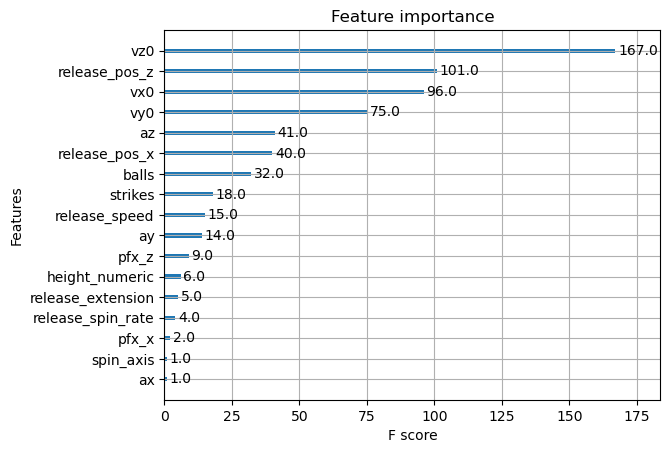

In [15]:
xgb.plot_importance(model)
plt.show()

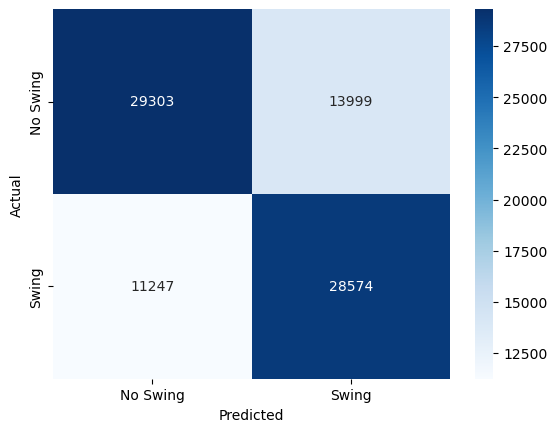

In [16]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Swing', 'Swing'], yticklabels=['No Swing', 'Swing'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [17]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'device' : 'gpu',
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [18]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-12 12:50:45,698] A new study created in memory with name: no-name-a9263fd0-4bf9-4794-92dc-720bd3b8b977


[0]	eval-logloss:0.67163
[1]	eval-logloss:0.65523
[2]	eval-logloss:0.63658
[3]	eval-logloss:0.62331
[4]	eval-logloss:0.61607
[5]	eval-logloss:0.60954
[6]	eval-logloss:0.60178
[7]	eval-logloss:0.59693
[8]	eval-logloss:0.59546
[9]	eval-logloss:0.59018
[10]	eval-logloss:0.58492
[11]	eval-logloss:0.57758
[12]	eval-logloss:0.57460
[13]	eval-logloss:0.57321
[14]	eval-logloss:0.56846
[15]	eval-logloss:0.56575
[16]	eval-logloss:0.56071
[17]	eval-logloss:0.55618
[18]	eval-logloss:0.55407
[19]	eval-logloss:0.54927
[20]	eval-logloss:0.54838
[21]	eval-logloss:0.54691
[22]	eval-logloss:0.54606
[23]	eval-logloss:0.54359
[24]	eval-logloss:0.54262
[25]	eval-logloss:0.53697
[26]	eval-logloss:0.53664
[27]	eval-logloss:0.53587
[28]	eval-logloss:0.53360
[29]	eval-logloss:0.53058
[30]	eval-logloss:0.52852
[31]	eval-logloss:0.52732
[32]	eval-logloss:0.52638
[33]	eval-logloss:0.52580
[34]	eval-logloss:0.52490
[35]	eval-logloss:0.52445
[36]	eval-logloss:0.52390
[37]	eval-logloss:0.52335
[38]	eval-logloss:0.52

[I 2023-11-12 12:50:48,011] Trial 0 finished with value: 0.48066644071083325 and parameters: {'max_depth': 5, 'eta': 0.2175909282818692, 'subsample': 0.789587450843847, 'colsample_bytree': 0.7177991964865773}. Best is trial 0 with value: 0.48066644071083325.


[0]	eval-logloss:0.67319
[1]	eval-logloss:0.65706
[2]	eval-logloss:0.64335
[3]	eval-logloss:0.63345
[4]	eval-logloss:0.62333
[5]	eval-logloss:0.61544
[6]	eval-logloss:0.60775
[7]	eval-logloss:0.60160
[8]	eval-logloss:0.59686
[9]	eval-logloss:0.59230
[10]	eval-logloss:0.58882
[11]	eval-logloss:0.58510
[12]	eval-logloss:0.58162
[13]	eval-logloss:0.57841
[14]	eval-logloss:0.57458
[15]	eval-logloss:0.57250
[16]	eval-logloss:0.56931
[17]	eval-logloss:0.56679
[18]	eval-logloss:0.56464
[19]	eval-logloss:0.56126
[20]	eval-logloss:0.55896
[21]	eval-logloss:0.55539
[22]	eval-logloss:0.55421
[23]	eval-logloss:0.55081
[24]	eval-logloss:0.54704
[25]	eval-logloss:0.54577
[26]	eval-logloss:0.54373
[27]	eval-logloss:0.54197
[28]	eval-logloss:0.54048
[29]	eval-logloss:0.53920
[30]	eval-logloss:0.53757
[31]	eval-logloss:0.53629
[32]	eval-logloss:0.53500
[33]	eval-logloss:0.53331
[34]	eval-logloss:0.53134
[35]	eval-logloss:0.52981
[36]	eval-logloss:0.52837
[37]	eval-logloss:0.52756
[38]	eval-logloss:0.52

[I 2023-11-12 12:50:49,630] Trial 1 finished with value: 0.47765315720831036 and parameters: {'max_depth': 6, 'eta': 0.12762076439519424, 'subsample': 0.8766658336855049, 'colsample_bytree': 0.9618699786197479}. Best is trial 1 with value: 0.47765315720831036.


[0]	eval-logloss:0.68990
[1]	eval-logloss:0.67718
[2]	eval-logloss:0.66101
[3]	eval-logloss:0.64861
[4]	eval-logloss:0.63940
[5]	eval-logloss:0.63329
[6]	eval-logloss:0.62467
[7]	eval-logloss:0.61773
[8]	eval-logloss:0.61588
[9]	eval-logloss:0.60905
[10]	eval-logloss:0.60251
[11]	eval-logloss:0.59704
[12]	eval-logloss:0.59354
[13]	eval-logloss:0.58992
[14]	eval-logloss:0.58417
[15]	eval-logloss:0.57952
[16]	eval-logloss:0.57486
[17]	eval-logloss:0.57143
[18]	eval-logloss:0.56818
[19]	eval-logloss:0.56366
[20]	eval-logloss:0.56114
[21]	eval-logloss:0.55978
[22]	eval-logloss:0.55839
[23]	eval-logloss:0.55663
[24]	eval-logloss:0.55450
[25]	eval-logloss:0.55297
[26]	eval-logloss:0.55259
[27]	eval-logloss:0.55135
[28]	eval-logloss:0.54869
[29]	eval-logloss:0.54854
[30]	eval-logloss:0.54822
[31]	eval-logloss:0.54320
[32]	eval-logloss:0.54069
[33]	eval-logloss:0.53972
[34]	eval-logloss:0.53953
[35]	eval-logloss:0.53784
[36]	eval-logloss:0.53473
[37]	eval-logloss:0.53464
[38]	eval-logloss:0.53

[I 2023-11-12 12:50:51,146] Trial 2 finished with value: 0.4875913683547298 and parameters: {'max_depth': 7, 'eta': 0.10856159636118227, 'subsample': 0.6497863711976323, 'colsample_bytree': 0.5595769594055725}. Best is trial 1 with value: 0.47765315720831036.


[0]	eval-logloss:0.68552
[1]	eval-logloss:0.67776
[2]	eval-logloss:0.66965
[3]	eval-logloss:0.66488
[4]	eval-logloss:0.65943
[5]	eval-logloss:0.65450
[6]	eval-logloss:0.64937
[7]	eval-logloss:0.64525
[8]	eval-logloss:0.64324
[9]	eval-logloss:0.63973
[10]	eval-logloss:0.63683
[11]	eval-logloss:0.63365
[12]	eval-logloss:0.63162
[13]	eval-logloss:0.62920
[14]	eval-logloss:0.62721
[15]	eval-logloss:0.62526
[16]	eval-logloss:0.62352
[17]	eval-logloss:0.62212
[18]	eval-logloss:0.61899
[19]	eval-logloss:0.61569
[20]	eval-logloss:0.61457
[21]	eval-logloss:0.61333
[22]	eval-logloss:0.61233
[23]	eval-logloss:0.60965
[24]	eval-logloss:0.60791
[25]	eval-logloss:0.60654
[26]	eval-logloss:0.60560
[27]	eval-logloss:0.60448
[28]	eval-logloss:0.60222
[29]	eval-logloss:0.60095
[30]	eval-logloss:0.60010
[31]	eval-logloss:0.59924
[32]	eval-logloss:0.59812
[33]	eval-logloss:0.59707
[34]	eval-logloss:0.59607
[35]	eval-logloss:0.59528
[36]	eval-logloss:0.59486
[37]	eval-logloss:0.59346
[38]	eval-logloss:0.59

[I 2023-11-12 12:50:52,346] Trial 3 finished with value: 0.5518330904475482 and parameters: {'max_depth': 3, 'eta': 0.10504289586397093, 'subsample': 0.7108031567655926, 'colsample_bytree': 0.7098872051113005}. Best is trial 1 with value: 0.47765315720831036.


[0]	eval-logloss:0.67567
[1]	eval-logloss:0.65683
[2]	eval-logloss:0.63077
[3]	eval-logloss:0.61421
[4]	eval-logloss:0.60379
[5]	eval-logloss:0.59722
[6]	eval-logloss:0.58823
[7]	eval-logloss:0.58256
[8]	eval-logloss:0.58138
[9]	eval-logloss:0.57315
[10]	eval-logloss:0.56702
[11]	eval-logloss:0.56129
[12]	eval-logloss:0.55885
[13]	eval-logloss:0.55719
[14]	eval-logloss:0.55351
[15]	eval-logloss:0.54835
[16]	eval-logloss:0.54600
[17]	eval-logloss:0.54132
[18]	eval-logloss:0.53811
[19]	eval-logloss:0.53250
[20]	eval-logloss:0.52905
[21]	eval-logloss:0.52769
[22]	eval-logloss:0.52640
[23]	eval-logloss:0.52312
[24]	eval-logloss:0.51967
[25]	eval-logloss:0.51871
[26]	eval-logloss:0.51848
[27]	eval-logloss:0.51759
[28]	eval-logloss:0.51488
[29]	eval-logloss:0.51167
[30]	eval-logloss:0.51109
[31]	eval-logloss:0.50840
[32]	eval-logloss:0.50756
[33]	eval-logloss:0.50710
[34]	eval-logloss:0.50597
[35]	eval-logloss:0.50542
[36]	eval-logloss:0.50234
[37]	eval-logloss:0.50219
[38]	eval-logloss:0.49

[I 2023-11-12 12:50:54,116] Trial 4 finished with value: 0.4661904196336681 and parameters: {'max_depth': 6, 'eta': 0.23124175412706377, 'subsample': 0.6291822474795882, 'colsample_bytree': 0.6566690161179571}. Best is trial 4 with value: 0.4661904196336681.


[0]	eval-logloss:0.67050
[1]	eval-logloss:0.65270
[2]	eval-logloss:0.63443
[3]	eval-logloss:0.62419
[4]	eval-logloss:0.61410
[5]	eval-logloss:0.60763
[6]	eval-logloss:0.60109
[7]	eval-logloss:0.59470
[8]	eval-logloss:0.59349
[9]	eval-logloss:0.58978
[10]	eval-logloss:0.58608
[11]	eval-logloss:0.58062
[12]	eval-logloss:0.57803
[13]	eval-logloss:0.57675
[14]	eval-logloss:0.57168
[15]	eval-logloss:0.56869
[16]	eval-logloss:0.56601
[17]	eval-logloss:0.56414
[18]	eval-logloss:0.56224
[19]	eval-logloss:0.55962
[20]	eval-logloss:0.55640
[21]	eval-logloss:0.55590
[22]	eval-logloss:0.55461
[23]	eval-logloss:0.55194
[24]	eval-logloss:0.54984
[25]	eval-logloss:0.54776
[26]	eval-logloss:0.54734
[27]	eval-logloss:0.54675
[28]	eval-logloss:0.54398
[29]	eval-logloss:0.54180
[30]	eval-logloss:0.54080
[31]	eval-logloss:0.53933
[32]	eval-logloss:0.53834
[33]	eval-logloss:0.53762
[34]	eval-logloss:0.53656
[35]	eval-logloss:0.53610
[36]	eval-logloss:0.53438
[37]	eval-logloss:0.53212
[38]	eval-logloss:0.52

[I 2023-11-12 12:50:55,181] Trial 5 finished with value: 0.48593265726848844 and parameters: {'max_depth': 4, 'eta': 0.2721096289987739, 'subsample': 0.7678123300980008, 'colsample_bytree': 0.7220370662883865}. Best is trial 4 with value: 0.4661904196336681.


[0]	eval-logloss:0.69171
[1]	eval-logloss:0.68591
[2]	eval-logloss:0.68120
[3]	eval-logloss:0.67397
[4]	eval-logloss:0.66823
[5]	eval-logloss:0.66419
[6]	eval-logloss:0.65789
[7]	eval-logloss:0.65290
[8]	eval-logloss:0.65280
[9]	eval-logloss:0.64951
[10]	eval-logloss:0.64753
[11]	eval-logloss:0.64170
[12]	eval-logloss:0.63778
[13]	eval-logloss:0.63321
[14]	eval-logloss:0.63261
[15]	eval-logloss:0.62804
[16]	eval-logloss:0.62349
[17]	eval-logloss:0.61894
[18]	eval-logloss:0.61471
[19]	eval-logloss:0.61066
[20]	eval-logloss:0.60743
[21]	eval-logloss:0.60560
[22]	eval-logloss:0.60461
[23]	eval-logloss:0.60198
[24]	eval-logloss:0.59858
[25]	eval-logloss:0.59640
[26]	eval-logloss:0.59562
[27]	eval-logloss:0.59389
[28]	eval-logloss:0.59102
[29]	eval-logloss:0.59093
[30]	eval-logloss:0.59067
[31]	eval-logloss:0.58740
[32]	eval-logloss:0.58458
[33]	eval-logloss:0.58278
[34]	eval-logloss:0.58238
[35]	eval-logloss:0.57981
[36]	eval-logloss:0.57652
[37]	eval-logloss:0.57633
[38]	eval-logloss:0.57

[I 2023-11-12 12:50:57,515] Trial 6 finished with value: 0.5199880759275459 and parameters: {'max_depth': 9, 'eta': 0.04459487736983612, 'subsample': 0.6430978472890109, 'colsample_bytree': 0.545133901465866}. Best is trial 4 with value: 0.4661904196336681.


[0]	eval-logloss:0.69120
[1]	eval-logloss:0.68573
[2]	eval-logloss:0.67936
[3]	eval-logloss:0.67445
[4]	eval-logloss:0.67079
[5]	eval-logloss:0.66694
[6]	eval-logloss:0.66244
[7]	eval-logloss:0.65843
[8]	eval-logloss:0.65662
[9]	eval-logloss:0.65310
[10]	eval-logloss:0.65017
[11]	eval-logloss:0.64735
[12]	eval-logloss:0.64516
[13]	eval-logloss:0.64290
[14]	eval-logloss:0.64090
[15]	eval-logloss:0.63848
[16]	eval-logloss:0.63649
[17]	eval-logloss:0.63478
[18]	eval-logloss:0.63205
[19]	eval-logloss:0.62991
[20]	eval-logloss:0.62852
[21]	eval-logloss:0.62730
[22]	eval-logloss:0.62606
[23]	eval-logloss:0.62414
[24]	eval-logloss:0.62220
[25]	eval-logloss:0.62046
[26]	eval-logloss:0.61959
[27]	eval-logloss:0.61845
[28]	eval-logloss:0.61632
[29]	eval-logloss:0.61619
[30]	eval-logloss:0.61556
[31]	eval-logloss:0.61428
[32]	eval-logloss:0.61300
[33]	eval-logloss:0.61166
[34]	eval-logloss:0.61134
[35]	eval-logloss:0.61042
[36]	eval-logloss:0.60870
[37]	eval-logloss:0.60847
[38]	eval-logloss:0.60

[I 2023-11-12 12:50:58,497] Trial 7 finished with value: 0.5719283404750529 and parameters: {'max_depth': 3, 'eta': 0.07187855898101038, 'subsample': 0.6395144190779289, 'colsample_bytree': 0.5747217620703771}. Best is trial 4 with value: 0.4661904196336681.


[0]	eval-logloss:0.66878
[1]	eval-logloss:0.64980
[2]	eval-logloss:0.63506
[3]	eval-logloss:0.62270
[4]	eval-logloss:0.61195
[5]	eval-logloss:0.60247
[6]	eval-logloss:0.59420
[7]	eval-logloss:0.58754
[8]	eval-logloss:0.58156
[9]	eval-logloss:0.57635
[10]	eval-logloss:0.57259
[11]	eval-logloss:0.56757
[12]	eval-logloss:0.56383
[13]	eval-logloss:0.55926
[14]	eval-logloss:0.55618
[15]	eval-logloss:0.55265
[16]	eval-logloss:0.54937
[17]	eval-logloss:0.54765
[18]	eval-logloss:0.54299
[19]	eval-logloss:0.54048
[20]	eval-logloss:0.53740
[21]	eval-logloss:0.53559
[22]	eval-logloss:0.53354
[23]	eval-logloss:0.53085
[24]	eval-logloss:0.52665
[25]	eval-logloss:0.52409
[26]	eval-logloss:0.52169
[27]	eval-logloss:0.52042
[28]	eval-logloss:0.51946
[29]	eval-logloss:0.51765
[30]	eval-logloss:0.51609
[31]	eval-logloss:0.51328
[32]	eval-logloss:0.51225
[33]	eval-logloss:0.51042
[34]	eval-logloss:0.50891
[35]	eval-logloss:0.50791
[36]	eval-logloss:0.50704
[37]	eval-logloss:0.50514
[38]	eval-logloss:0.50

[I 2023-11-12 12:50:59,995] Trial 8 finished with value: 0.46453237449577967 and parameters: {'max_depth': 7, 'eta': 0.14240941007812594, 'subsample': 0.6836004445751578, 'colsample_bytree': 0.8968885815241467}. Best is trial 8 with value: 0.46453237449577967.


[0]	eval-logloss:0.69139
[1]	eval-logloss:0.68506
[2]	eval-logloss:0.67946
[3]	eval-logloss:0.67126
[4]	eval-logloss:0.66455
[5]	eval-logloss:0.65992
[6]	eval-logloss:0.65277
[7]	eval-logloss:0.64714
[8]	eval-logloss:0.64702
[9]	eval-logloss:0.64337
[10]	eval-logloss:0.64118
[11]	eval-logloss:0.63478
[12]	eval-logloss:0.63051
[13]	eval-logloss:0.62582
[14]	eval-logloss:0.62525
[15]	eval-logloss:0.62036
[16]	eval-logloss:0.61580
[17]	eval-logloss:0.61135
[18]	eval-logloss:0.60697
[19]	eval-logloss:0.60294
[20]	eval-logloss:0.59967
[21]	eval-logloss:0.59777
[22]	eval-logloss:0.59682
[23]	eval-logloss:0.59429
[24]	eval-logloss:0.59067
[25]	eval-logloss:0.58862
[26]	eval-logloss:0.58793
[27]	eval-logloss:0.58625
[28]	eval-logloss:0.58329
[29]	eval-logloss:0.58317
[30]	eval-logloss:0.58293
[31]	eval-logloss:0.57978
[32]	eval-logloss:0.57720
[33]	eval-logloss:0.57545
[34]	eval-logloss:0.57510
[35]	eval-logloss:0.57270
[36]	eval-logloss:0.56916
[37]	eval-logloss:0.56905
[38]	eval-logloss:0.56

[I 2023-11-12 12:51:01,842] Trial 9 finished with value: 0.5160051050463651 and parameters: {'max_depth': 8, 'eta': 0.0563584142429984, 'subsample': 0.676851139905241, 'colsample_bytree': 0.5267836129582955}. Best is trial 8 with value: 0.46453237449577967.


[0]	eval-logloss:0.65978
[1]	eval-logloss:0.63474
[2]	eval-logloss:0.61491
[3]	eval-logloss:0.59910
[4]	eval-logloss:0.58627
[5]	eval-logloss:0.57621
[6]	eval-logloss:0.56753
[7]	eval-logloss:0.56071
[8]	eval-logloss:0.55459
[9]	eval-logloss:0.55014
[10]	eval-logloss:0.54558
[11]	eval-logloss:0.54174
[12]	eval-logloss:0.53863
[13]	eval-logloss:0.53519
[14]	eval-logloss:0.53026
[15]	eval-logloss:0.52367
[16]	eval-logloss:0.51953
[17]	eval-logloss:0.51634
[18]	eval-logloss:0.51308
[19]	eval-logloss:0.51057
[20]	eval-logloss:0.50846
[21]	eval-logloss:0.50650
[22]	eval-logloss:0.50286
[23]	eval-logloss:0.50109
[24]	eval-logloss:0.49737
[25]	eval-logloss:0.49511
[26]	eval-logloss:0.49160
[27]	eval-logloss:0.49086
[28]	eval-logloss:0.48984
[29]	eval-logloss:0.48850
[30]	eval-logloss:0.48713
[31]	eval-logloss:0.48520
[32]	eval-logloss:0.48416
[33]	eval-logloss:0.48376
[34]	eval-logloss:0.47975
[35]	eval-logloss:0.47905
[36]	eval-logloss:0.47777
[37]	eval-logloss:0.47737
[38]	eval-logloss:0.47

[I 2023-11-12 12:51:04,359] Trial 10 finished with value: 0.4540032918057913 and parameters: {'max_depth': 9, 'eta': 0.1727134615937671, 'subsample': 0.7223151147537301, 'colsample_bytree': 0.8740582653293416}. Best is trial 10 with value: 0.4540032918057913.


[0]	eval-logloss:0.65995
[1]	eval-logloss:0.63506
[2]	eval-logloss:0.61646
[3]	eval-logloss:0.60045
[4]	eval-logloss:0.58672
[5]	eval-logloss:0.57628
[6]	eval-logloss:0.56885
[7]	eval-logloss:0.56154
[8]	eval-logloss:0.55484
[9]	eval-logloss:0.55014
[10]	eval-logloss:0.54567
[11]	eval-logloss:0.54091
[12]	eval-logloss:0.53794
[13]	eval-logloss:0.53425
[14]	eval-logloss:0.52646
[15]	eval-logloss:0.52226
[16]	eval-logloss:0.51694
[17]	eval-logloss:0.51378
[18]	eval-logloss:0.51064
[19]	eval-logloss:0.50831
[20]	eval-logloss:0.50534
[21]	eval-logloss:0.50411
[22]	eval-logloss:0.50036
[23]	eval-logloss:0.49743
[24]	eval-logloss:0.49603
[25]	eval-logloss:0.49270
[26]	eval-logloss:0.49052
[27]	eval-logloss:0.49007
[28]	eval-logloss:0.48898
[29]	eval-logloss:0.48792
[30]	eval-logloss:0.48643
[31]	eval-logloss:0.48492
[32]	eval-logloss:0.48434
[33]	eval-logloss:0.48388
[34]	eval-logloss:0.48054
[35]	eval-logloss:0.47946
[36]	eval-logloss:0.47873
[37]	eval-logloss:0.47671
[38]	eval-logloss:0.47

[I 2023-11-12 12:51:06,785] Trial 11 finished with value: 0.4539811366575085 and parameters: {'max_depth': 9, 'eta': 0.1716684848772343, 'subsample': 0.7227662264810596, 'colsample_bytree': 0.8819063757463799}. Best is trial 11 with value: 0.4539811366575085.


[0]	eval-logloss:0.65695
[1]	eval-logloss:0.63081
[2]	eval-logloss:0.61153
[3]	eval-logloss:0.59630
[4]	eval-logloss:0.58112
[5]	eval-logloss:0.57178
[6]	eval-logloss:0.56386
[7]	eval-logloss:0.55697
[8]	eval-logloss:0.55044
[9]	eval-logloss:0.54610
[10]	eval-logloss:0.54130
[11]	eval-logloss:0.53636
[12]	eval-logloss:0.53393
[13]	eval-logloss:0.53020
[14]	eval-logloss:0.52315
[15]	eval-logloss:0.51769
[16]	eval-logloss:0.51270
[17]	eval-logloss:0.51012
[18]	eval-logloss:0.50521
[19]	eval-logloss:0.50346
[20]	eval-logloss:0.50168
[21]	eval-logloss:0.49988
[22]	eval-logloss:0.49619
[23]	eval-logloss:0.49390
[24]	eval-logloss:0.49044
[25]	eval-logloss:0.48943
[26]	eval-logloss:0.48817
[27]	eval-logloss:0.48767
[28]	eval-logloss:0.48662
[29]	eval-logloss:0.48470
[30]	eval-logloss:0.48322
[31]	eval-logloss:0.48132
[32]	eval-logloss:0.48063
[33]	eval-logloss:0.47958
[34]	eval-logloss:0.47862
[35]	eval-logloss:0.47813
[36]	eval-logloss:0.47672
[37]	eval-logloss:0.47482
[38]	eval-logloss:0.47

[I 2023-11-12 12:51:09,177] Trial 12 finished with value: 0.45370994880149645 and parameters: {'max_depth': 9, 'eta': 0.18762612944287038, 'subsample': 0.7269858117479383, 'colsample_bytree': 0.8567827152015236}. Best is trial 12 with value: 0.45370994880149645.


[0]	eval-logloss:0.66031
[1]	eval-logloss:0.63614
[2]	eval-logloss:0.61846
[3]	eval-logloss:0.60320
[4]	eval-logloss:0.59174
[5]	eval-logloss:0.58120
[6]	eval-logloss:0.57487
[7]	eval-logloss:0.56770
[8]	eval-logloss:0.56129
[9]	eval-logloss:0.55617
[10]	eval-logloss:0.55114
[11]	eval-logloss:0.54575
[12]	eval-logloss:0.54267
[13]	eval-logloss:0.53896
[14]	eval-logloss:0.53217
[15]	eval-logloss:0.52903
[16]	eval-logloss:0.52342
[17]	eval-logloss:0.52043
[18]	eval-logloss:0.51843
[19]	eval-logloss:0.51531
[20]	eval-logloss:0.51147
[21]	eval-logloss:0.50944
[22]	eval-logloss:0.50591
[23]	eval-logloss:0.50187
[24]	eval-logloss:0.49968
[25]	eval-logloss:0.49864
[26]	eval-logloss:0.49847
[27]	eval-logloss:0.49808
[28]	eval-logloss:0.49683
[29]	eval-logloss:0.49384
[30]	eval-logloss:0.49113
[31]	eval-logloss:0.48884
[32]	eval-logloss:0.48805
[33]	eval-logloss:0.48723
[34]	eval-logloss:0.48612
[35]	eval-logloss:0.48531
[36]	eval-logloss:0.48412
[37]	eval-logloss:0.48209
[38]	eval-logloss:0.47

[I 2023-11-12 12:51:11,037] Trial 13 finished with value: 0.4534926046284082 and parameters: {'max_depth': 8, 'eta': 0.18435545097393655, 'subsample': 0.7500430041003239, 'colsample_bytree': 0.8091434664254116}. Best is trial 13 with value: 0.4534926046284082.


[0]	eval-logloss:0.69062
[1]	eval-logloss:0.68816
[2]	eval-logloss:0.68571
[3]	eval-logloss:0.68371
[4]	eval-logloss:0.68140
[5]	eval-logloss:0.67926
[6]	eval-logloss:0.67718
[7]	eval-logloss:0.67517
[8]	eval-logloss:0.67327
[9]	eval-logloss:0.67130
[10]	eval-logloss:0.66923
[11]	eval-logloss:0.66723
[12]	eval-logloss:0.66543
[13]	eval-logloss:0.66373
[14]	eval-logloss:0.66204
[15]	eval-logloss:0.66015
[16]	eval-logloss:0.65858
[17]	eval-logloss:0.65677
[18]	eval-logloss:0.65499
[19]	eval-logloss:0.65319
[20]	eval-logloss:0.65167
[21]	eval-logloss:0.65005
[22]	eval-logloss:0.64862
[23]	eval-logloss:0.64704
[24]	eval-logloss:0.64555
[25]	eval-logloss:0.64406
[26]	eval-logloss:0.64349
[27]	eval-logloss:0.64229
[28]	eval-logloss:0.64090
[29]	eval-logloss:0.63962
[30]	eval-logloss:0.63820
[31]	eval-logloss:0.63714
[32]	eval-logloss:0.63581
[33]	eval-logloss:0.63449
[34]	eval-logloss:0.63313
[35]	eval-logloss:0.63180
[36]	eval-logloss:0.63032
[37]	eval-logloss:0.62915
[38]	eval-logloss:0.62

[I 2023-11-12 12:51:13,026] Trial 14 finished with value: 0.5763938562340237 and parameters: {'max_depth': 8, 'eta': 0.013008827420515151, 'subsample': 0.7935141658197375, 'colsample_bytree': 0.8110174125198506}. Best is trial 13 with value: 0.4534926046284082.


[0]	eval-logloss:0.65852
[1]	eval-logloss:0.63261
[2]	eval-logloss:0.61504
[3]	eval-logloss:0.59992
[4]	eval-logloss:0.58703
[5]	eval-logloss:0.57789
[6]	eval-logloss:0.57027
[7]	eval-logloss:0.56388
[8]	eval-logloss:0.55766
[9]	eval-logloss:0.55124
[10]	eval-logloss:0.54485
[11]	eval-logloss:0.54127
[12]	eval-logloss:0.53818
[13]	eval-logloss:0.53536
[14]	eval-logloss:0.53057
[15]	eval-logloss:0.52694
[16]	eval-logloss:0.52229
[17]	eval-logloss:0.51926
[18]	eval-logloss:0.51253
[19]	eval-logloss:0.50948
[20]	eval-logloss:0.50832
[21]	eval-logloss:0.50663
[22]	eval-logloss:0.50331
[23]	eval-logloss:0.50192
[24]	eval-logloss:0.49747
[25]	eval-logloss:0.49379
[26]	eval-logloss:0.49365
[27]	eval-logloss:0.49293
[28]	eval-logloss:0.49175
[29]	eval-logloss:0.48834
[30]	eval-logloss:0.48500
[31]	eval-logloss:0.48285
[32]	eval-logloss:0.48180
[33]	eval-logloss:0.48121
[34]	eval-logloss:0.47934
[35]	eval-logloss:0.47882
[36]	eval-logloss:0.47798
[37]	eval-logloss:0.47632
[38]	eval-logloss:0.47

[I 2023-11-12 12:51:14,832] Trial 15 finished with value: 0.4514636539621393 and parameters: {'max_depth': 8, 'eta': 0.19685990521702254, 'subsample': 0.7593928578028866, 'colsample_bytree': 0.8071571035079592}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.64726
[1]	eval-logloss:0.61837
[2]	eval-logloss:0.59870
[3]	eval-logloss:0.58503
[4]	eval-logloss:0.57531
[5]	eval-logloss:0.56926
[6]	eval-logloss:0.56360
[7]	eval-logloss:0.55849
[8]	eval-logloss:0.55267
[9]	eval-logloss:0.54658
[10]	eval-logloss:0.53972
[11]	eval-logloss:0.53331
[12]	eval-logloss:0.53025
[13]	eval-logloss:0.52758
[14]	eval-logloss:0.51679
[15]	eval-logloss:0.51302
[16]	eval-logloss:0.50967
[17]	eval-logloss:0.50656
[18]	eval-logloss:0.50220
[19]	eval-logloss:0.50032
[20]	eval-logloss:0.49802
[21]	eval-logloss:0.49637
[22]	eval-logloss:0.49369
[23]	eval-logloss:0.49227
[24]	eval-logloss:0.49091
[25]	eval-logloss:0.48932
[26]	eval-logloss:0.48921
[27]	eval-logloss:0.48888
[28]	eval-logloss:0.48860
[29]	eval-logloss:0.48672
[30]	eval-logloss:0.48280
[31]	eval-logloss:0.48039
[32]	eval-logloss:0.47971
[33]	eval-logloss:0.47908
[34]	eval-logloss:0.47736
[35]	eval-logloss:0.47686
[36]	eval-logloss:0.47539
[37]	eval-logloss:0.47508
[38]	eval-logloss:0.47

[I 2023-11-12 12:51:16,337] Trial 16 finished with value: 0.45507215905075615 and parameters: {'max_depth': 7, 'eta': 0.29595659469677194, 'subsample': 0.8097621215001153, 'colsample_bytree': 0.7917703429148}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.65643
[1]	eval-logloss:0.62929
[2]	eval-logloss:0.61102
[3]	eval-logloss:0.59610
[4]	eval-logloss:0.58271
[5]	eval-logloss:0.57320
[6]	eval-logloss:0.56675
[7]	eval-logloss:0.55947
[8]	eval-logloss:0.55348
[9]	eval-logloss:0.54878
[10]	eval-logloss:0.54201
[11]	eval-logloss:0.53851
[12]	eval-logloss:0.53560
[13]	eval-logloss:0.53305
[14]	eval-logloss:0.52882
[15]	eval-logloss:0.52361
[16]	eval-logloss:0.51855
[17]	eval-logloss:0.51508
[18]	eval-logloss:0.51112
[19]	eval-logloss:0.50805
[20]	eval-logloss:0.50538
[21]	eval-logloss:0.50331
[22]	eval-logloss:0.49974
[23]	eval-logloss:0.49806
[24]	eval-logloss:0.49395
[25]	eval-logloss:0.49234
[26]	eval-logloss:0.49221
[27]	eval-logloss:0.49165
[28]	eval-logloss:0.49047
[29]	eval-logloss:0.48779
[30]	eval-logloss:0.48387
[31]	eval-logloss:0.48345
[32]	eval-logloss:0.48251
[33]	eval-logloss:0.48130
[34]	eval-logloss:0.47891
[35]	eval-logloss:0.47846
[36]	eval-logloss:0.47686
[37]	eval-logloss:0.47478
[38]	eval-logloss:0.47

[I 2023-11-12 12:51:18,169] Trial 17 finished with value: 0.4525753004572859 and parameters: {'max_depth': 8, 'eta': 0.21029803965942098, 'subsample': 0.7577877825422624, 'colsample_bytree': 0.7800857970911201}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.66854
[1]	eval-logloss:0.64448
[2]	eval-logloss:0.62673
[3]	eval-logloss:0.61818
[4]	eval-logloss:0.60625
[5]	eval-logloss:0.59947
[6]	eval-logloss:0.59395
[7]	eval-logloss:0.58942
[8]	eval-logloss:0.58482
[9]	eval-logloss:0.57989
[10]	eval-logloss:0.57638
[11]	eval-logloss:0.57141
[12]	eval-logloss:0.56619
[13]	eval-logloss:0.56412
[14]	eval-logloss:0.56067
[15]	eval-logloss:0.55677
[16]	eval-logloss:0.55277
[17]	eval-logloss:0.55051
[18]	eval-logloss:0.54598
[19]	eval-logloss:0.54298
[20]	eval-logloss:0.53911
[21]	eval-logloss:0.53790
[22]	eval-logloss:0.53682
[23]	eval-logloss:0.53350
[24]	eval-logloss:0.53037
[25]	eval-logloss:0.52938
[26]	eval-logloss:0.52916
[27]	eval-logloss:0.52869
[28]	eval-logloss:0.52651
[29]	eval-logloss:0.52397
[30]	eval-logloss:0.52250
[31]	eval-logloss:0.52085
[32]	eval-logloss:0.51921
[33]	eval-logloss:0.51892
[34]	eval-logloss:0.51757
[35]	eval-logloss:0.51627
[36]	eval-logloss:0.51402
[37]	eval-logloss:0.51310
[38]	eval-logloss:0.51

[I 2023-11-12 12:51:19,398] Trial 18 finished with value: 0.4718562496938183 and parameters: {'max_depth': 5, 'eta': 0.23978658684984394, 'subsample': 0.6016735781867568, 'colsample_bytree': 0.7708327962752523}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.67259
[1]	eval-logloss:0.65069
[2]	eval-logloss:0.62297
[3]	eval-logloss:0.60468
[4]	eval-logloss:0.59204
[5]	eval-logloss:0.58457
[6]	eval-logloss:0.57493
[7]	eval-logloss:0.56559
[8]	eval-logloss:0.56430
[9]	eval-logloss:0.55669
[10]	eval-logloss:0.54968
[11]	eval-logloss:0.54496
[12]	eval-logloss:0.54230
[13]	eval-logloss:0.53975
[14]	eval-logloss:0.53501
[15]	eval-logloss:0.52816
[16]	eval-logloss:0.52462
[17]	eval-logloss:0.52036
[18]	eval-logloss:0.51793
[19]	eval-logloss:0.51470
[20]	eval-logloss:0.50939
[21]	eval-logloss:0.50832
[22]	eval-logloss:0.50749
[23]	eval-logloss:0.50514
[24]	eval-logloss:0.50050
[25]	eval-logloss:0.49963
[26]	eval-logloss:0.49952
[27]	eval-logloss:0.49871
[28]	eval-logloss:0.49701
[29]	eval-logloss:0.49432
[30]	eval-logloss:0.49339
[31]	eval-logloss:0.49159
[32]	eval-logloss:0.49062
[33]	eval-logloss:0.49030
[34]	eval-logloss:0.48982
[35]	eval-logloss:0.48900
[36]	eval-logloss:0.48597
[37]	eval-logloss:0.48595
[38]	eval-logloss:0.48

[I 2023-11-12 12:51:21,835] Trial 19 finished with value: 0.46006611547864307 and parameters: {'max_depth': 8, 'eta': 0.20257246006808882, 'subsample': 0.8211766365887263, 'colsample_bytree': 0.6656841316987367}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.66783
[1]	eval-logloss:0.64833
[2]	eval-logloss:0.63265
[3]	eval-logloss:0.62014
[4]	eval-logloss:0.60857
[5]	eval-logloss:0.59968
[6]	eval-logloss:0.59180
[7]	eval-logloss:0.58554
[8]	eval-logloss:0.58060
[9]	eval-logloss:0.57553
[10]	eval-logloss:0.57030
[11]	eval-logloss:0.56595
[12]	eval-logloss:0.56091
[13]	eval-logloss:0.55802
[14]	eval-logloss:0.55501
[15]	eval-logloss:0.55104
[16]	eval-logloss:0.54720
[17]	eval-logloss:0.54407
[18]	eval-logloss:0.54131
[19]	eval-logloss:0.53695
[20]	eval-logloss:0.53468
[21]	eval-logloss:0.53040
[22]	eval-logloss:0.52861
[23]	eval-logloss:0.52571
[24]	eval-logloss:0.52370
[25]	eval-logloss:0.52173
[26]	eval-logloss:0.51970
[27]	eval-logloss:0.51824
[28]	eval-logloss:0.51691
[29]	eval-logloss:0.51473
[30]	eval-logloss:0.51341
[31]	eval-logloss:0.51222
[32]	eval-logloss:0.50976
[33]	eval-logloss:0.50816
[34]	eval-logloss:0.50588
[35]	eval-logloss:0.50517
[36]	eval-logloss:0.50406
[37]	eval-logloss:0.50244
[38]	eval-logloss:0.49

[I 2023-11-12 12:51:23,641] Trial 20 finished with value: 0.46316948349131765 and parameters: {'max_depth': 7, 'eta': 0.1519256688883605, 'subsample': 0.764227415306752, 'colsample_bytree': 0.9844688978537484}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.65756
[1]	eval-logloss:0.63202
[2]	eval-logloss:0.61088
[3]	eval-logloss:0.59607
[4]	eval-logloss:0.58499
[5]	eval-logloss:0.57531
[6]	eval-logloss:0.56786
[7]	eval-logloss:0.56223
[8]	eval-logloss:0.55646
[9]	eval-logloss:0.55033
[10]	eval-logloss:0.54662
[11]	eval-logloss:0.54174
[12]	eval-logloss:0.53882
[13]	eval-logloss:0.53564
[14]	eval-logloss:0.52693
[15]	eval-logloss:0.52254
[16]	eval-logloss:0.51925
[17]	eval-logloss:0.51614
[18]	eval-logloss:0.51461
[19]	eval-logloss:0.51011
[20]	eval-logloss:0.50858
[21]	eval-logloss:0.50667
[22]	eval-logloss:0.50536
[23]	eval-logloss:0.50084
[24]	eval-logloss:0.49866
[25]	eval-logloss:0.49693
[26]	eval-logloss:0.49667
[27]	eval-logloss:0.49607
[28]	eval-logloss:0.49505
[29]	eval-logloss:0.49157
[30]	eval-logloss:0.48936
[31]	eval-logloss:0.48831
[32]	eval-logloss:0.48779
[33]	eval-logloss:0.48386
[34]	eval-logloss:0.48318
[35]	eval-logloss:0.48259
[36]	eval-logloss:0.48168
[37]	eval-logloss:0.47892
[38]	eval-logloss:0.47

[I 2023-11-12 12:51:25,950] Trial 21 finished with value: 0.45397661942176915 and parameters: {'max_depth': 8, 'eta': 0.2016156311186366, 'subsample': 0.7453656710334041, 'colsample_bytree': 0.8160427438333138}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.65882
[1]	eval-logloss:0.62636
[2]	eval-logloss:0.60639
[3]	eval-logloss:0.59071
[4]	eval-logloss:0.57760
[5]	eval-logloss:0.56774
[6]	eval-logloss:0.56168
[7]	eval-logloss:0.55582
[8]	eval-logloss:0.55048
[9]	eval-logloss:0.54503
[10]	eval-logloss:0.54151
[11]	eval-logloss:0.53401
[12]	eval-logloss:0.53093
[13]	eval-logloss:0.52759
[14]	eval-logloss:0.52278
[15]	eval-logloss:0.51642
[16]	eval-logloss:0.51200
[17]	eval-logloss:0.50783
[18]	eval-logloss:0.50090
[19]	eval-logloss:0.49659
[20]	eval-logloss:0.49372
[21]	eval-logloss:0.49300
[22]	eval-logloss:0.49245
[23]	eval-logloss:0.49071
[24]	eval-logloss:0.48912
[25]	eval-logloss:0.48681
[26]	eval-logloss:0.48667
[27]	eval-logloss:0.48599
[28]	eval-logloss:0.48470
[29]	eval-logloss:0.48165
[30]	eval-logloss:0.47995
[31]	eval-logloss:0.47896
[32]	eval-logloss:0.47805
[33]	eval-logloss:0.47786
[34]	eval-logloss:0.47475
[35]	eval-logloss:0.47408
[36]	eval-logloss:0.47363
[37]	eval-logloss:0.47154
[38]	eval-logloss:0.47

[I 2023-11-12 12:51:27,987] Trial 22 finished with value: 0.4533706716399366 and parameters: {'max_depth': 8, 'eta': 0.24598574963736036, 'subsample': 0.7536161202801195, 'colsample_bytree': 0.761953049838384}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.66261
[1]	eval-logloss:0.63285
[2]	eval-logloss:0.61377
[3]	eval-logloss:0.60077
[4]	eval-logloss:0.58626
[5]	eval-logloss:0.57799
[6]	eval-logloss:0.57209
[7]	eval-logloss:0.56605
[8]	eval-logloss:0.55986
[9]	eval-logloss:0.55607
[10]	eval-logloss:0.54886
[11]	eval-logloss:0.54455
[12]	eval-logloss:0.54118
[13]	eval-logloss:0.53695
[14]	eval-logloss:0.53346
[15]	eval-logloss:0.52905
[16]	eval-logloss:0.52222
[17]	eval-logloss:0.51930
[18]	eval-logloss:0.51769
[19]	eval-logloss:0.51603
[20]	eval-logloss:0.51142
[21]	eval-logloss:0.51010
[22]	eval-logloss:0.50947
[23]	eval-logloss:0.50702
[24]	eval-logloss:0.50571
[25]	eval-logloss:0.50472
[26]	eval-logloss:0.50450
[27]	eval-logloss:0.50389
[28]	eval-logloss:0.50219
[29]	eval-logloss:0.50038
[30]	eval-logloss:0.49792
[31]	eval-logloss:0.49455
[32]	eval-logloss:0.49329
[33]	eval-logloss:0.49283
[34]	eval-logloss:0.48910
[35]	eval-logloss:0.48865
[36]	eval-logloss:0.48714
[37]	eval-logloss:0.48691
[38]	eval-logloss:0.48

[I 2023-11-12 12:51:29,486] Trial 23 finished with value: 0.45578752358918523 and parameters: {'max_depth': 7, 'eta': 0.24197321888590054, 'subsample': 0.775412085310673, 'colsample_bytree': 0.7589392150380635}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.64815
[1]	eval-logloss:0.61773
[2]	eval-logloss:0.59909
[3]	eval-logloss:0.58459
[4]	eval-logloss:0.57108
[5]	eval-logloss:0.56389
[6]	eval-logloss:0.55652
[7]	eval-logloss:0.55040
[8]	eval-logloss:0.54431
[9]	eval-logloss:0.53945
[10]	eval-logloss:0.53402
[11]	eval-logloss:0.53026
[12]	eval-logloss:0.52757
[13]	eval-logloss:0.52410
[14]	eval-logloss:0.51940
[15]	eval-logloss:0.51611
[16]	eval-logloss:0.51226
[17]	eval-logloss:0.50741
[18]	eval-logloss:0.50288
[19]	eval-logloss:0.50100
[20]	eval-logloss:0.49854
[21]	eval-logloss:0.49716
[22]	eval-logloss:0.49419
[23]	eval-logloss:0.49165
[24]	eval-logloss:0.48699
[25]	eval-logloss:0.48497
[26]	eval-logloss:0.48301
[27]	eval-logloss:0.48240
[28]	eval-logloss:0.48157
[29]	eval-logloss:0.47880
[30]	eval-logloss:0.47721
[31]	eval-logloss:0.47521
[32]	eval-logloss:0.47493
[33]	eval-logloss:0.47325
[34]	eval-logloss:0.47241
[35]	eval-logloss:0.47074
[36]	eval-logloss:0.46973
[37]	eval-logloss:0.46949
[38]	eval-logloss:0.46

[I 2023-11-12 12:51:31,459] Trial 24 finished with value: 0.45453273398497823 and parameters: {'max_depth': 8, 'eta': 0.2674852703695082, 'subsample': 0.8284840663439735, 'colsample_bytree': 0.8385788758332451}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.66805
[1]	eval-logloss:0.64201
[2]	eval-logloss:0.62392
[3]	eval-logloss:0.61152
[4]	eval-logloss:0.60126
[5]	eval-logloss:0.59195
[6]	eval-logloss:0.58639
[7]	eval-logloss:0.58003
[8]	eval-logloss:0.57398
[9]	eval-logloss:0.57015
[10]	eval-logloss:0.56701
[11]	eval-logloss:0.56405
[12]	eval-logloss:0.56113
[13]	eval-logloss:0.55730
[14]	eval-logloss:0.55112
[15]	eval-logloss:0.54864
[16]	eval-logloss:0.54390
[17]	eval-logloss:0.54192
[18]	eval-logloss:0.53625
[19]	eval-logloss:0.53350
[20]	eval-logloss:0.53040
[21]	eval-logloss:0.52923
[22]	eval-logloss:0.52845
[23]	eval-logloss:0.52541
[24]	eval-logloss:0.51906
[25]	eval-logloss:0.51705
[26]	eval-logloss:0.51673
[27]	eval-logloss:0.51603
[28]	eval-logloss:0.51397
[29]	eval-logloss:0.51071
[30]	eval-logloss:0.50964
[31]	eval-logloss:0.50788
[32]	eval-logloss:0.50699
[33]	eval-logloss:0.50653
[34]	eval-logloss:0.50476
[35]	eval-logloss:0.50430
[36]	eval-logloss:0.50129
[37]	eval-logloss:0.49942
[38]	eval-logloss:0.49

[I 2023-11-12 12:51:32,966] Trial 25 finished with value: 0.46223342304034876 and parameters: {'max_depth': 6, 'eta': 0.21535155178519091, 'subsample': 0.7464657974804424, 'colsample_bytree': 0.7670265749329795}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.64601
[1]	eval-logloss:0.61457
[2]	eval-logloss:0.59393
[3]	eval-logloss:0.57720
[4]	eval-logloss:0.56351
[5]	eval-logloss:0.55435
[6]	eval-logloss:0.54555
[7]	eval-logloss:0.53910
[8]	eval-logloss:0.52732
[9]	eval-logloss:0.52417
[10]	eval-logloss:0.51643
[11]	eval-logloss:0.51226
[12]	eval-logloss:0.50892
[13]	eval-logloss:0.50301
[14]	eval-logloss:0.50018
[15]	eval-logloss:0.49407
[16]	eval-logloss:0.49157
[17]	eval-logloss:0.48978
[18]	eval-logloss:0.48462
[19]	eval-logloss:0.48234
[20]	eval-logloss:0.48046
[21]	eval-logloss:0.47963
[22]	eval-logloss:0.47823
[23]	eval-logloss:0.47501
[24]	eval-logloss:0.47464
[25]	eval-logloss:0.47336
[26]	eval-logloss:0.47277
[27]	eval-logloss:0.47260
[28]	eval-logloss:0.47228
[29]	eval-logloss:0.46941
[30]	eval-logloss:0.46897
[31]	eval-logloss:0.46839
[32]	eval-logloss:0.46821
[33]	eval-logloss:0.46694
[34]	eval-logloss:0.46552
[35]	eval-logloss:0.46520
[36]	eval-logloss:0.46503
[37]	eval-logloss:0.46433
[38]	eval-logloss:0.46

[I 2023-11-12 12:51:35,340] Trial 26 finished with value: 0.457040657742727 and parameters: {'max_depth': 9, 'eta': 0.2544574452356475, 'subsample': 0.6923697599399379, 'colsample_bytree': 0.9170396624212626}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.65481
[1]	eval-logloss:0.62820
[2]	eval-logloss:0.60652
[3]	eval-logloss:0.59161
[4]	eval-logloss:0.58110
[5]	eval-logloss:0.57104
[6]	eval-logloss:0.56391
[7]	eval-logloss:0.55627
[8]	eval-logloss:0.55159
[9]	eval-logloss:0.54778
[10]	eval-logloss:0.54225
[11]	eval-logloss:0.53722
[12]	eval-logloss:0.53510
[13]	eval-logloss:0.53186
[14]	eval-logloss:0.52593
[15]	eval-logloss:0.52162
[16]	eval-logloss:0.51741
[17]	eval-logloss:0.51381
[18]	eval-logloss:0.50906
[19]	eval-logloss:0.50704
[20]	eval-logloss:0.50588
[21]	eval-logloss:0.50369
[22]	eval-logloss:0.50111
[23]	eval-logloss:0.49951
[24]	eval-logloss:0.49495
[25]	eval-logloss:0.49068
[26]	eval-logloss:0.48858
[27]	eval-logloss:0.48810
[28]	eval-logloss:0.48719
[29]	eval-logloss:0.48548
[30]	eval-logloss:0.48381
[31]	eval-logloss:0.48266
[32]	eval-logloss:0.48232
[33]	eval-logloss:0.48189
[34]	eval-logloss:0.47913
[35]	eval-logloss:0.47804
[36]	eval-logloss:0.47702
[37]	eval-logloss:0.47639
[38]	eval-logloss:0.47

[I 2023-11-12 12:51:37,316] Trial 27 finished with value: 0.45176394368509065 and parameters: {'max_depth': 8, 'eta': 0.2194157191194587, 'subsample': 0.7442451398041742, 'colsample_bytree': 0.8445047655702844}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.66134
[1]	eval-logloss:0.63774
[2]	eval-logloss:0.62010
[3]	eval-logloss:0.60860
[4]	eval-logloss:0.59722
[5]	eval-logloss:0.59068
[6]	eval-logloss:0.58406
[7]	eval-logloss:0.57816
[8]	eval-logloss:0.57333
[9]	eval-logloss:0.57055
[10]	eval-logloss:0.56375
[11]	eval-logloss:0.55960
[12]	eval-logloss:0.55533
[13]	eval-logloss:0.55347
[14]	eval-logloss:0.54793
[15]	eval-logloss:0.54442
[16]	eval-logloss:0.54124
[17]	eval-logloss:0.53897
[18]	eval-logloss:0.53431
[19]	eval-logloss:0.53288
[20]	eval-logloss:0.52698
[21]	eval-logloss:0.52425
[22]	eval-logloss:0.51993
[23]	eval-logloss:0.51753
[24]	eval-logloss:0.51562
[25]	eval-logloss:0.51451
[26]	eval-logloss:0.51253
[27]	eval-logloss:0.51145
[28]	eval-logloss:0.50954
[29]	eval-logloss:0.50864
[30]	eval-logloss:0.50658
[31]	eval-logloss:0.50360
[32]	eval-logloss:0.50290
[33]	eval-logloss:0.50098
[34]	eval-logloss:0.49791
[35]	eval-logloss:0.49668
[36]	eval-logloss:0.49567
[37]	eval-logloss:0.49476
[38]	eval-logloss:0.49

[I 2023-11-12 12:51:38,900] Trial 28 finished with value: 0.4626896335342682 and parameters: {'max_depth': 6, 'eta': 0.21498781248509588, 'subsample': 0.7863868248312208, 'colsample_bytree': 0.8447916760929945}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.66403
[1]	eval-logloss:0.64380
[2]	eval-logloss:0.62803
[3]	eval-logloss:0.61833
[4]	eval-logloss:0.61025
[5]	eval-logloss:0.60378
[6]	eval-logloss:0.59606
[7]	eval-logloss:0.59188
[8]	eval-logloss:0.58517
[9]	eval-logloss:0.58128
[10]	eval-logloss:0.57782
[11]	eval-logloss:0.57321
[12]	eval-logloss:0.56824
[13]	eval-logloss:0.56363
[14]	eval-logloss:0.55878
[15]	eval-logloss:0.55712
[16]	eval-logloss:0.55608
[17]	eval-logloss:0.55187
[18]	eval-logloss:0.54779
[19]	eval-logloss:0.54381
[20]	eval-logloss:0.54185
[21]	eval-logloss:0.54078
[22]	eval-logloss:0.53959
[23]	eval-logloss:0.53700
[24]	eval-logloss:0.53433
[25]	eval-logloss:0.52951
[26]	eval-logloss:0.52860
[27]	eval-logloss:0.52734
[28]	eval-logloss:0.52676
[29]	eval-logloss:0.52490
[30]	eval-logloss:0.52386
[31]	eval-logloss:0.52119
[32]	eval-logloss:0.51987
[33]	eval-logloss:0.51876
[34]	eval-logloss:0.51749
[35]	eval-logloss:0.51648
[36]	eval-logloss:0.51499
[37]	eval-logloss:0.51408
[38]	eval-logloss:0.51

[I 2023-11-12 12:51:40,092] Trial 29 finished with value: 0.4728043527795211 and parameters: {'max_depth': 5, 'eta': 0.22148117146494728, 'subsample': 0.7993505542374643, 'colsample_bytree': 0.9265097961333828}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.66630
[1]	eval-logloss:0.64547
[2]	eval-logloss:0.62737
[3]	eval-logloss:0.61476
[4]	eval-logloss:0.60388
[5]	eval-logloss:0.59556
[6]	eval-logloss:0.58831
[7]	eval-logloss:0.58214
[8]	eval-logloss:0.57586
[9]	eval-logloss:0.57073
[10]	eval-logloss:0.56659
[11]	eval-logloss:0.56287
[12]	eval-logloss:0.55940
[13]	eval-logloss:0.55592
[14]	eval-logloss:0.55264
[15]	eval-logloss:0.54874
[16]	eval-logloss:0.54397
[17]	eval-logloss:0.54072
[18]	eval-logloss:0.53631
[19]	eval-logloss:0.53330
[20]	eval-logloss:0.53076
[21]	eval-logloss:0.52915
[22]	eval-logloss:0.52599
[23]	eval-logloss:0.52439
[24]	eval-logloss:0.52168
[25]	eval-logloss:0.51980
[26]	eval-logloss:0.51831
[27]	eval-logloss:0.51747
[28]	eval-logloss:0.51569
[29]	eval-logloss:0.51368
[30]	eval-logloss:0.51111
[31]	eval-logloss:0.50980
[32]	eval-logloss:0.50882
[33]	eval-logloss:0.50758
[34]	eval-logloss:0.50347
[35]	eval-logloss:0.50253
[36]	eval-logloss:0.50097
[37]	eval-logloss:0.50036
[38]	eval-logloss:0.49

[I 2023-11-12 12:51:41,822] Trial 30 finished with value: 0.4597893585559553 and parameters: {'max_depth': 7, 'eta': 0.16264182496520938, 'subsample': 0.7805081628154468, 'colsample_bytree': 0.8380238106382598}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.65812
[1]	eval-logloss:0.63277
[2]	eval-logloss:0.61253
[3]	eval-logloss:0.59790
[4]	eval-logloss:0.58669
[5]	eval-logloss:0.57781
[6]	eval-logloss:0.57002
[7]	eval-logloss:0.56483
[8]	eval-logloss:0.55840
[9]	eval-logloss:0.55338
[10]	eval-logloss:0.54909
[11]	eval-logloss:0.54319
[12]	eval-logloss:0.53982
[13]	eval-logloss:0.53695
[14]	eval-logloss:0.53474
[15]	eval-logloss:0.52961
[16]	eval-logloss:0.52378
[17]	eval-logloss:0.52018
[18]	eval-logloss:0.51778
[19]	eval-logloss:0.51361
[20]	eval-logloss:0.50766
[21]	eval-logloss:0.50568
[22]	eval-logloss:0.50362
[23]	eval-logloss:0.50092
[24]	eval-logloss:0.49875
[25]	eval-logloss:0.49619
[26]	eval-logloss:0.49604
[27]	eval-logloss:0.49551
[28]	eval-logloss:0.49467
[29]	eval-logloss:0.49174
[30]	eval-logloss:0.48772
[31]	eval-logloss:0.48495
[32]	eval-logloss:0.48417
[33]	eval-logloss:0.48290
[34]	eval-logloss:0.48234
[35]	eval-logloss:0.48197
[36]	eval-logloss:0.48128
[37]	eval-logloss:0.47906
[38]	eval-logloss:0.47

[I 2023-11-12 12:51:43,706] Trial 31 finished with value: 0.45522351163774794 and parameters: {'max_depth': 8, 'eta': 0.19798868147133405, 'subsample': 0.7469317739856953, 'colsample_bytree': 0.7883188826965964}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.66117
[1]	eval-logloss:0.63033
[2]	eval-logloss:0.61100
[3]	eval-logloss:0.59482
[4]	eval-logloss:0.58024
[5]	eval-logloss:0.57215
[6]	eval-logloss:0.56550
[7]	eval-logloss:0.56008
[8]	eval-logloss:0.55303
[9]	eval-logloss:0.54764
[10]	eval-logloss:0.54278
[11]	eval-logloss:0.53660
[12]	eval-logloss:0.53292
[13]	eval-logloss:0.53081
[14]	eval-logloss:0.52058
[15]	eval-logloss:0.51819
[16]	eval-logloss:0.51407
[17]	eval-logloss:0.51136
[18]	eval-logloss:0.50582
[19]	eval-logloss:0.50308
[20]	eval-logloss:0.49951
[21]	eval-logloss:0.49824
[22]	eval-logloss:0.49769
[23]	eval-logloss:0.49597
[24]	eval-logloss:0.49501
[25]	eval-logloss:0.49139
[26]	eval-logloss:0.49126
[27]	eval-logloss:0.49069
[28]	eval-logloss:0.49040
[29]	eval-logloss:0.48675
[30]	eval-logloss:0.48326
[31]	eval-logloss:0.48236
[32]	eval-logloss:0.48121
[33]	eval-logloss:0.48078
[34]	eval-logloss:0.47988
[35]	eval-logloss:0.47927
[36]	eval-logloss:0.47858
[37]	eval-logloss:0.47591
[38]	eval-logloss:0.47

[I 2023-11-12 12:51:45,559] Trial 32 finished with value: 0.45507076489529386 and parameters: {'max_depth': 8, 'eta': 0.22627329289161946, 'subsample': 0.7587131030531318, 'colsample_bytree': 0.7417962124322166}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.64854
[1]	eval-logloss:0.61843
[2]	eval-logloss:0.59744
[3]	eval-logloss:0.57980
[4]	eval-logloss:0.56656
[5]	eval-logloss:0.55717
[6]	eval-logloss:0.55025
[7]	eval-logloss:0.54352
[8]	eval-logloss:0.53795
[9]	eval-logloss:0.53270
[10]	eval-logloss:0.52808
[11]	eval-logloss:0.52441
[12]	eval-logloss:0.52231
[13]	eval-logloss:0.51925
[14]	eval-logloss:0.51314
[15]	eval-logloss:0.50754
[16]	eval-logloss:0.50565
[17]	eval-logloss:0.50241
[18]	eval-logloss:0.49714
[19]	eval-logloss:0.49481
[20]	eval-logloss:0.48961
[21]	eval-logloss:0.48812
[22]	eval-logloss:0.48428
[23]	eval-logloss:0.48251
[24]	eval-logloss:0.48122
[25]	eval-logloss:0.47977
[26]	eval-logloss:0.47974
[27]	eval-logloss:0.47948
[28]	eval-logloss:0.47877
[29]	eval-logloss:0.47708
[30]	eval-logloss:0.47316
[31]	eval-logloss:0.47251
[32]	eval-logloss:0.47172
[33]	eval-logloss:0.47091
[34]	eval-logloss:0.46999
[35]	eval-logloss:0.46952
[36]	eval-logloss:0.46853
[37]	eval-logloss:0.46837
[38]	eval-logloss:0.46

[I 2023-11-12 12:51:47,895] Trial 33 finished with value: 0.4539977065345929 and parameters: {'max_depth': 9, 'eta': 0.24161454856981068, 'subsample': 0.7334171582597376, 'colsample_bytree': 0.7932243397188433}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.66501
[1]	eval-logloss:0.63866
[2]	eval-logloss:0.62047
[3]	eval-logloss:0.60674
[4]	eval-logloss:0.59357
[5]	eval-logloss:0.58310
[6]	eval-logloss:0.57725
[7]	eval-logloss:0.57157
[8]	eval-logloss:0.56612
[9]	eval-logloss:0.56116
[10]	eval-logloss:0.55442
[11]	eval-logloss:0.55106
[12]	eval-logloss:0.54795
[13]	eval-logloss:0.54496
[14]	eval-logloss:0.54005
[15]	eval-logloss:0.53581
[16]	eval-logloss:0.53066
[17]	eval-logloss:0.52723
[18]	eval-logloss:0.52319
[19]	eval-logloss:0.51697
[20]	eval-logloss:0.51544
[21]	eval-logloss:0.51439
[22]	eval-logloss:0.51335
[23]	eval-logloss:0.51155
[24]	eval-logloss:0.50839
[25]	eval-logloss:0.50670
[26]	eval-logloss:0.50645
[27]	eval-logloss:0.50585
[28]	eval-logloss:0.50424
[29]	eval-logloss:0.50179
[30]	eval-logloss:0.50014
[31]	eval-logloss:0.49811
[32]	eval-logloss:0.49652
[33]	eval-logloss:0.49612
[34]	eval-logloss:0.49368
[35]	eval-logloss:0.49309
[36]	eval-logloss:0.49165
[37]	eval-logloss:0.49043
[38]	eval-logloss:0.48

[I 2023-11-12 12:51:49,403] Trial 34 finished with value: 0.45902216439292104 and parameters: {'max_depth': 7, 'eta': 0.21122401309018657, 'subsample': 0.7099814874680181, 'colsample_bytree': 0.7373590864998681}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.67041
[1]	eval-logloss:0.65244
[2]	eval-logloss:0.63271
[3]	eval-logloss:0.62038
[4]	eval-logloss:0.60980
[5]	eval-logloss:0.60290
[6]	eval-logloss:0.59497
[7]	eval-logloss:0.58883
[8]	eval-logloss:0.58738
[9]	eval-logloss:0.58134
[10]	eval-logloss:0.57574
[11]	eval-logloss:0.57210
[12]	eval-logloss:0.56899
[13]	eval-logloss:0.56716
[14]	eval-logloss:0.56060
[15]	eval-logloss:0.55605
[16]	eval-logloss:0.55236
[17]	eval-logloss:0.55006
[18]	eval-logloss:0.54530
[19]	eval-logloss:0.54313
[20]	eval-logloss:0.54189
[21]	eval-logloss:0.54087
[22]	eval-logloss:0.54004
[23]	eval-logloss:0.53811
[24]	eval-logloss:0.53559
[25]	eval-logloss:0.53280
[26]	eval-logloss:0.53244
[27]	eval-logloss:0.53164
[28]	eval-logloss:0.52895
[29]	eval-logloss:0.52672
[30]	eval-logloss:0.52499
[31]	eval-logloss:0.52306
[32]	eval-logloss:0.52168
[33]	eval-logloss:0.52098
[34]	eval-logloss:0.51996
[35]	eval-logloss:0.51802
[36]	eval-logloss:0.51554
[37]	eval-logloss:0.51441
[38]	eval-logloss:0.51

[I 2023-11-12 12:51:50,753] Trial 35 finished with value: 0.47361472480366157 and parameters: {'max_depth': 6, 'eta': 0.19548085614795505, 'subsample': 0.7704695782518396, 'colsample_bytree': 0.7067640235591142}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.66054
[1]	eval-logloss:0.63642
[2]	eval-logloss:0.61889
[3]	eval-logloss:0.60361
[4]	eval-logloss:0.59189
[5]	eval-logloss:0.58220
[6]	eval-logloss:0.57409
[7]	eval-logloss:0.56791
[8]	eval-logloss:0.56160
[9]	eval-logloss:0.55591
[10]	eval-logloss:0.54990
[11]	eval-logloss:0.54450
[12]	eval-logloss:0.54121
[13]	eval-logloss:0.53879
[14]	eval-logloss:0.53094
[15]	eval-logloss:0.52791
[16]	eval-logloss:0.52414
[17]	eval-logloss:0.52023
[18]	eval-logloss:0.51573
[19]	eval-logloss:0.51287
[20]	eval-logloss:0.51076
[21]	eval-logloss:0.50866
[22]	eval-logloss:0.50480
[23]	eval-logloss:0.50217
[24]	eval-logloss:0.49979
[25]	eval-logloss:0.49809
[26]	eval-logloss:0.49557
[27]	eval-logloss:0.49480
[28]	eval-logloss:0.49319
[29]	eval-logloss:0.49084
[30]	eval-logloss:0.48926
[31]	eval-logloss:0.48845
[32]	eval-logloss:0.48787
[33]	eval-logloss:0.48711
[34]	eval-logloss:0.48540
[35]	eval-logloss:0.48262
[36]	eval-logloss:0.48142
[37]	eval-logloss:0.47890
[38]	eval-logloss:0.47

[I 2023-11-12 12:51:52,640] Trial 36 finished with value: 0.45329882076516465 and parameters: {'max_depth': 8, 'eta': 0.18136510453290738, 'subsample': 0.7067082652479286, 'colsample_bytree': 0.8364301520064693}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.67214
[1]	eval-logloss:0.65705
[2]	eval-logloss:0.64503
[3]	eval-logloss:0.63700
[4]	eval-logloss:0.62932
[5]	eval-logloss:0.62271
[6]	eval-logloss:0.61812
[7]	eval-logloss:0.61298
[8]	eval-logloss:0.60910
[9]	eval-logloss:0.60575
[10]	eval-logloss:0.60074
[11]	eval-logloss:0.59854
[12]	eval-logloss:0.59680
[13]	eval-logloss:0.59406
[14]	eval-logloss:0.58891
[15]	eval-logloss:0.58381
[16]	eval-logloss:0.58207
[17]	eval-logloss:0.57946
[18]	eval-logloss:0.57681
[19]	eval-logloss:0.57498
[20]	eval-logloss:0.57424
[21]	eval-logloss:0.57298
[22]	eval-logloss:0.57034
[23]	eval-logloss:0.56897
[24]	eval-logloss:0.56489
[25]	eval-logloss:0.56160
[26]	eval-logloss:0.56032
[27]	eval-logloss:0.55950
[28]	eval-logloss:0.55805
[29]	eval-logloss:0.55516
[30]	eval-logloss:0.55425
[31]	eval-logloss:0.55364
[32]	eval-logloss:0.55219
[33]	eval-logloss:0.54885
[34]	eval-logloss:0.54830
[35]	eval-logloss:0.54531
[36]	eval-logloss:0.54428
[37]	eval-logloss:0.54399
[38]	eval-logloss:0.54

[I 2023-11-12 12:51:53,729] Trial 37 finished with value: 0.4985801716386463 and parameters: {'max_depth': 4, 'eta': 0.17813400422479347, 'subsample': 0.7036658878999521, 'colsample_bytree': 0.8713826692070737}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.66616
[1]	eval-logloss:0.64486
[2]	eval-logloss:0.62794
[3]	eval-logloss:0.61336
[4]	eval-logloss:0.60093
[5]	eval-logloss:0.59069
[6]	eval-logloss:0.58074
[7]	eval-logloss:0.57326
[8]	eval-logloss:0.56733
[9]	eval-logloss:0.56246
[10]	eval-logloss:0.55654
[11]	eval-logloss:0.55149
[12]	eval-logloss:0.54674
[13]	eval-logloss:0.54330
[14]	eval-logloss:0.53914
[15]	eval-logloss:0.53348
[16]	eval-logloss:0.53020
[17]	eval-logloss:0.52679
[18]	eval-logloss:0.52385
[19]	eval-logloss:0.52078
[20]	eval-logloss:0.51832
[21]	eval-logloss:0.51554
[22]	eval-logloss:0.51328
[23]	eval-logloss:0.50883
[24]	eval-logloss:0.50700
[25]	eval-logloss:0.50526
[26]	eval-logloss:0.50273
[27]	eval-logloss:0.50148
[28]	eval-logloss:0.50005
[29]	eval-logloss:0.49831
[30]	eval-logloss:0.49647
[31]	eval-logloss:0.49462
[32]	eval-logloss:0.49258
[33]	eval-logloss:0.48987
[34]	eval-logloss:0.48809
[35]	eval-logloss:0.48721
[36]	eval-logloss:0.48658
[37]	eval-logloss:0.48553
[38]	eval-logloss:0.48

[I 2023-11-12 12:51:56,260] Trial 38 finished with value: 0.4532167792177134 and parameters: {'max_depth': 9, 'eta': 0.1362253709536373, 'subsample': 0.7298184598257812, 'colsample_bytree': 0.9489810930493894}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.66713
[1]	eval-logloss:0.64639
[2]	eval-logloss:0.62970
[3]	eval-logloss:0.61531
[4]	eval-logloss:0.60270
[5]	eval-logloss:0.59298
[6]	eval-logloss:0.58327
[7]	eval-logloss:0.57544
[8]	eval-logloss:0.56923
[9]	eval-logloss:0.56473
[10]	eval-logloss:0.55950
[11]	eval-logloss:0.55290
[12]	eval-logloss:0.54871
[13]	eval-logloss:0.54496
[14]	eval-logloss:0.54091
[15]	eval-logloss:0.53528
[16]	eval-logloss:0.53206
[17]	eval-logloss:0.53003
[18]	eval-logloss:0.52606
[19]	eval-logloss:0.52370
[20]	eval-logloss:0.52104
[21]	eval-logloss:0.51847
[22]	eval-logloss:0.51570
[23]	eval-logloss:0.51264
[24]	eval-logloss:0.50822
[25]	eval-logloss:0.50598
[26]	eval-logloss:0.50378
[27]	eval-logloss:0.50278
[28]	eval-logloss:0.50182
[29]	eval-logloss:0.50035
[30]	eval-logloss:0.49660
[31]	eval-logloss:0.49472
[32]	eval-logloss:0.49303
[33]	eval-logloss:0.49201
[34]	eval-logloss:0.48950
[35]	eval-logloss:0.48754
[36]	eval-logloss:0.48647
[37]	eval-logloss:0.48589
[38]	eval-logloss:0.48

[I 2023-11-12 12:51:58,767] Trial 39 finished with value: 0.4542809113887755 and parameters: {'max_depth': 9, 'eta': 0.1320836026507331, 'subsample': 0.7355421447415275, 'colsample_bytree': 0.9624525086112704}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.67085
[1]	eval-logloss:0.65228
[2]	eval-logloss:0.63727
[3]	eval-logloss:0.62434
[4]	eval-logloss:0.61249
[5]	eval-logloss:0.60274
[6]	eval-logloss:0.59308
[7]	eval-logloss:0.58600
[8]	eval-logloss:0.57974
[9]	eval-logloss:0.57413
[10]	eval-logloss:0.56742
[11]	eval-logloss:0.56180
[12]	eval-logloss:0.55792
[13]	eval-logloss:0.55417
[14]	eval-logloss:0.54990
[15]	eval-logloss:0.54657
[16]	eval-logloss:0.54294
[17]	eval-logloss:0.54002
[18]	eval-logloss:0.53724
[19]	eval-logloss:0.53387
[20]	eval-logloss:0.53143
[21]	eval-logloss:0.52921
[22]	eval-logloss:0.52673
[23]	eval-logloss:0.52478
[24]	eval-logloss:0.52106
[25]	eval-logloss:0.51661
[26]	eval-logloss:0.51447
[27]	eval-logloss:0.51329
[28]	eval-logloss:0.51197
[29]	eval-logloss:0.50902
[30]	eval-logloss:0.50539
[31]	eval-logloss:0.50273
[32]	eval-logloss:0.50134
[33]	eval-logloss:0.50018
[34]	eval-logloss:0.49823
[35]	eval-logloss:0.49642
[36]	eval-logloss:0.49492
[37]	eval-logloss:0.49344
[38]	eval-logloss:0.49

[I 2023-11-12 12:52:01,216] Trial 40 finished with value: 0.45701388154364503 and parameters: {'max_depth': 9, 'eta': 0.11080877626807209, 'subsample': 0.660904843579717, 'colsample_bytree': 0.9310060487463324}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.66433
[1]	eval-logloss:0.64253
[2]	eval-logloss:0.62527
[3]	eval-logloss:0.61082
[4]	eval-logloss:0.59913
[5]	eval-logloss:0.58907
[6]	eval-logloss:0.58105
[7]	eval-logloss:0.57452
[8]	eval-logloss:0.56776
[9]	eval-logloss:0.56299
[10]	eval-logloss:0.55791
[11]	eval-logloss:0.55341
[12]	eval-logloss:0.54992
[13]	eval-logloss:0.54415
[14]	eval-logloss:0.54037
[15]	eval-logloss:0.53813
[16]	eval-logloss:0.53365
[17]	eval-logloss:0.53075
[18]	eval-logloss:0.52586
[19]	eval-logloss:0.52331
[20]	eval-logloss:0.51997
[21]	eval-logloss:0.51854
[22]	eval-logloss:0.51422
[23]	eval-logloss:0.51205
[24]	eval-logloss:0.50747
[25]	eval-logloss:0.50589
[26]	eval-logloss:0.50403
[27]	eval-logloss:0.50306
[28]	eval-logloss:0.50187
[29]	eval-logloss:0.50057
[30]	eval-logloss:0.49867
[31]	eval-logloss:0.49763
[32]	eval-logloss:0.49640
[33]	eval-logloss:0.49325
[34]	eval-logloss:0.49261
[35]	eval-logloss:0.49162
[36]	eval-logloss:0.49009
[37]	eval-logloss:0.48844
[38]	eval-logloss:0.48

[I 2023-11-12 12:52:03,183] Trial 41 finished with value: 0.4552680584947459 and parameters: {'max_depth': 8, 'eta': 0.158351940651219, 'subsample': 0.7094824853222939, 'colsample_bytree': 0.9058725486578677}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.65779
[1]	eval-logloss:0.63148
[2]	eval-logloss:0.61255
[3]	eval-logloss:0.59652
[4]	eval-logloss:0.58183
[5]	eval-logloss:0.57201
[6]	eval-logloss:0.56436
[7]	eval-logloss:0.55759
[8]	eval-logloss:0.55146
[9]	eval-logloss:0.54637
[10]	eval-logloss:0.54113
[11]	eval-logloss:0.53647
[12]	eval-logloss:0.53360
[13]	eval-logloss:0.53044
[14]	eval-logloss:0.52688
[15]	eval-logloss:0.52100
[16]	eval-logloss:0.51534
[17]	eval-logloss:0.51245
[18]	eval-logloss:0.50951
[19]	eval-logloss:0.50581
[20]	eval-logloss:0.50295
[21]	eval-logloss:0.50117
[22]	eval-logloss:0.49799
[23]	eval-logloss:0.49347
[24]	eval-logloss:0.49040
[25]	eval-logloss:0.48810
[26]	eval-logloss:0.48795
[27]	eval-logloss:0.48749
[28]	eval-logloss:0.48660
[29]	eval-logloss:0.48377
[30]	eval-logloss:0.48279
[31]	eval-logloss:0.48060
[32]	eval-logloss:0.47974
[33]	eval-logloss:0.47844
[34]	eval-logloss:0.47628
[35]	eval-logloss:0.47593
[36]	eval-logloss:0.47507
[37]	eval-logloss:0.47228
[38]	eval-logloss:0.47

[I 2023-11-12 12:52:05,546] Trial 42 finished with value: 0.4534416033437819 and parameters: {'max_depth': 9, 'eta': 0.18458561249937616, 'subsample': 0.6980526089553157, 'colsample_bytree': 0.8278162391037049}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.66441
[1]	eval-logloss:0.64305
[2]	eval-logloss:0.62580
[3]	eval-logloss:0.61366
[4]	eval-logloss:0.60266
[5]	eval-logloss:0.59338
[6]	eval-logloss:0.58665
[7]	eval-logloss:0.58136
[8]	eval-logloss:0.57549
[9]	eval-logloss:0.57060
[10]	eval-logloss:0.56716
[11]	eval-logloss:0.56172
[12]	eval-logloss:0.55843
[13]	eval-logloss:0.55487
[14]	eval-logloss:0.54870
[15]	eval-logloss:0.54505
[16]	eval-logloss:0.54038
[17]	eval-logloss:0.53743
[18]	eval-logloss:0.53507
[19]	eval-logloss:0.53201
[20]	eval-logloss:0.53016
[21]	eval-logloss:0.52788
[22]	eval-logloss:0.52508
[23]	eval-logloss:0.52219
[24]	eval-logloss:0.52046
[25]	eval-logloss:0.51513
[26]	eval-logloss:0.51321
[27]	eval-logloss:0.51251
[28]	eval-logloss:0.51156
[29]	eval-logloss:0.50866
[30]	eval-logloss:0.50742
[31]	eval-logloss:0.50575
[32]	eval-logloss:0.50419
[33]	eval-logloss:0.50276
[34]	eval-logloss:0.50131
[35]	eval-logloss:0.49935
[36]	eval-logloss:0.49694
[37]	eval-logloss:0.49588
[38]	eval-logloss:0.49

[I 2023-11-12 12:52:07,153] Trial 43 finished with value: 0.4595782256605317 and parameters: {'max_depth': 7, 'eta': 0.17028794438992614, 'subsample': 0.7229970442993494, 'colsample_bytree': 0.8589879828693436}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.66620
[1]	eval-logloss:0.64526
[2]	eval-logloss:0.62938
[3]	eval-logloss:0.61539
[4]	eval-logloss:0.60315
[5]	eval-logloss:0.59425
[6]	eval-logloss:0.58516
[7]	eval-logloss:0.57929
[8]	eval-logloss:0.57272
[9]	eval-logloss:0.56803
[10]	eval-logloss:0.56320
[11]	eval-logloss:0.55797
[12]	eval-logloss:0.55348
[13]	eval-logloss:0.54931
[14]	eval-logloss:0.54513
[15]	eval-logloss:0.54090
[16]	eval-logloss:0.53592
[17]	eval-logloss:0.53290
[18]	eval-logloss:0.52988
[19]	eval-logloss:0.52813
[20]	eval-logloss:0.52557
[21]	eval-logloss:0.52201
[22]	eval-logloss:0.51937
[23]	eval-logloss:0.51716
[24]	eval-logloss:0.51298
[25]	eval-logloss:0.51029
[26]	eval-logloss:0.50889
[27]	eval-logloss:0.50710
[28]	eval-logloss:0.50561
[29]	eval-logloss:0.50420
[30]	eval-logloss:0.50181
[31]	eval-logloss:0.50037
[32]	eval-logloss:0.49928
[33]	eval-logloss:0.49815
[34]	eval-logloss:0.49553
[35]	eval-logloss:0.49483
[36]	eval-logloss:0.49301
[37]	eval-logloss:0.49204
[38]	eval-logloss:0.48

[I 2023-11-12 12:52:09,078] Trial 44 finished with value: 0.45707363018778224 and parameters: {'max_depth': 8, 'eta': 0.14620881015776055, 'subsample': 0.6794253489932931, 'colsample_bytree': 0.952432522346783}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.65050
[1]	eval-logloss:0.62099
[2]	eval-logloss:0.60136
[3]	eval-logloss:0.58351
[4]	eval-logloss:0.56894
[5]	eval-logloss:0.55858
[6]	eval-logloss:0.55061
[7]	eval-logloss:0.54370
[8]	eval-logloss:0.53633
[9]	eval-logloss:0.53217
[10]	eval-logloss:0.52845
[11]	eval-logloss:0.52485
[12]	eval-logloss:0.51608
[13]	eval-logloss:0.51282
[14]	eval-logloss:0.50736
[15]	eval-logloss:0.50363
[16]	eval-logloss:0.49911
[17]	eval-logloss:0.49607
[18]	eval-logloss:0.49429
[19]	eval-logloss:0.49033
[20]	eval-logloss:0.48868
[21]	eval-logloss:0.48674
[22]	eval-logloss:0.48527
[23]	eval-logloss:0.48218
[24]	eval-logloss:0.48050
[25]	eval-logloss:0.47965
[26]	eval-logloss:0.47917
[27]	eval-logloss:0.47879
[28]	eval-logloss:0.47778
[29]	eval-logloss:0.47569
[30]	eval-logloss:0.47421
[31]	eval-logloss:0.47301
[32]	eval-logloss:0.47271
[33]	eval-logloss:0.47066
[34]	eval-logloss:0.47023
[35]	eval-logloss:0.46842
[36]	eval-logloss:0.46818
[37]	eval-logloss:0.46768
[38]	eval-logloss:0.46

[I 2023-11-12 12:52:11,420] Trial 45 finished with value: 0.45419360689032306 and parameters: {'max_depth': 9, 'eta': 0.229097521940904, 'subsample': 0.7366986849572229, 'colsample_bytree': 0.896373810637242}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.66333
[1]	eval-logloss:0.64100
[2]	eval-logloss:0.62438
[3]	eval-logloss:0.60973
[4]	eval-logloss:0.59737
[5]	eval-logloss:0.58700
[6]	eval-logloss:0.58025
[7]	eval-logloss:0.57319
[8]	eval-logloss:0.56681
[9]	eval-logloss:0.56184
[10]	eval-logloss:0.55710
[11]	eval-logloss:0.55188
[12]	eval-logloss:0.54828
[13]	eval-logloss:0.54576
[14]	eval-logloss:0.53831
[15]	eval-logloss:0.53433
[16]	eval-logloss:0.53006
[17]	eval-logloss:0.52699
[18]	eval-logloss:0.52358
[19]	eval-logloss:0.52170
[20]	eval-logloss:0.51811
[21]	eval-logloss:0.51641
[22]	eval-logloss:0.51367
[23]	eval-logloss:0.51126
[24]	eval-logloss:0.50850
[25]	eval-logloss:0.50464
[26]	eval-logloss:0.50166
[27]	eval-logloss:0.50098
[28]	eval-logloss:0.49980
[29]	eval-logloss:0.49800
[30]	eval-logloss:0.49654
[31]	eval-logloss:0.49453
[32]	eval-logloss:0.49390
[33]	eval-logloss:0.49267
[34]	eval-logloss:0.49033
[35]	eval-logloss:0.48850
[36]	eval-logloss:0.48708
[37]	eval-logloss:0.48665
[38]	eval-logloss:0.48

[I 2023-11-12 12:52:13,305] Trial 46 finished with value: 0.4561481349829534 and parameters: {'max_depth': 8, 'eta': 0.16397794310879216, 'subsample': 0.715549631334635, 'colsample_bytree': 0.8840369217274765}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.65745
[1]	eval-logloss:0.62952
[2]	eval-logloss:0.60988
[3]	eval-logloss:0.59421
[4]	eval-logloss:0.58090
[5]	eval-logloss:0.57167
[6]	eval-logloss:0.56199
[7]	eval-logloss:0.55518
[8]	eval-logloss:0.54881
[9]	eval-logloss:0.54385
[10]	eval-logloss:0.53854
[11]	eval-logloss:0.53455
[12]	eval-logloss:0.53193
[13]	eval-logloss:0.52898
[14]	eval-logloss:0.51926
[15]	eval-logloss:0.51473
[16]	eval-logloss:0.51121
[17]	eval-logloss:0.50832
[18]	eval-logloss:0.50612
[19]	eval-logloss:0.50327
[20]	eval-logloss:0.50150
[21]	eval-logloss:0.50053
[22]	eval-logloss:0.49693
[23]	eval-logloss:0.49347
[24]	eval-logloss:0.49158
[25]	eval-logloss:0.49049
[26]	eval-logloss:0.48744
[27]	eval-logloss:0.48702
[28]	eval-logloss:0.48612
[29]	eval-logloss:0.48393
[30]	eval-logloss:0.48137
[31]	eval-logloss:0.48055
[32]	eval-logloss:0.48014
[33]	eval-logloss:0.47952
[34]	eval-logloss:0.47767
[35]	eval-logloss:0.47596
[36]	eval-logloss:0.47399
[37]	eval-logloss:0.47292
[38]	eval-logloss:0.47

[I 2023-11-12 12:52:15,740] Trial 47 finished with value: 0.4542550179806301 and parameters: {'max_depth': 9, 'eta': 0.19059740126250177, 'subsample': 0.7633647564551312, 'colsample_bytree': 0.8622371648991592}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.66937
[1]	eval-logloss:0.65091
[2]	eval-logloss:0.63600
[3]	eval-logloss:0.62381
[4]	eval-logloss:0.61244
[5]	eval-logloss:0.60343
[6]	eval-logloss:0.59640
[7]	eval-logloss:0.59068
[8]	eval-logloss:0.58489
[9]	eval-logloss:0.57971
[10]	eval-logloss:0.57513
[11]	eval-logloss:0.57101
[12]	eval-logloss:0.56779
[13]	eval-logloss:0.56434
[14]	eval-logloss:0.56052
[15]	eval-logloss:0.55617
[16]	eval-logloss:0.55188
[17]	eval-logloss:0.54879
[18]	eval-logloss:0.54624
[19]	eval-logloss:0.54390
[20]	eval-logloss:0.54036
[21]	eval-logloss:0.53821
[22]	eval-logloss:0.53473
[23]	eval-logloss:0.53240
[24]	eval-logloss:0.52928
[25]	eval-logloss:0.52720
[26]	eval-logloss:0.52689
[27]	eval-logloss:0.52615
[28]	eval-logloss:0.52452
[29]	eval-logloss:0.52272
[30]	eval-logloss:0.51899
[31]	eval-logloss:0.51538
[32]	eval-logloss:0.51385
[33]	eval-logloss:0.51237
[34]	eval-logloss:0.50960
[35]	eval-logloss:0.50875
[36]	eval-logloss:0.50760
[37]	eval-logloss:0.50566
[38]	eval-logloss:0.50

[I 2023-11-12 12:52:17,317] Trial 48 finished with value: 0.4671523710014286 and parameters: {'max_depth': 7, 'eta': 0.13816608661992957, 'subsample': 0.7295977483843454, 'colsample_bytree': 0.8228684334339906}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.65614
[1]	eval-logloss:0.63002
[2]	eval-logloss:0.61212
[3]	eval-logloss:0.59816
[4]	eval-logloss:0.58476
[5]	eval-logloss:0.57512
[6]	eval-logloss:0.56723
[7]	eval-logloss:0.56109
[8]	eval-logloss:0.55491
[9]	eval-logloss:0.54916
[10]	eval-logloss:0.54347
[11]	eval-logloss:0.53914
[12]	eval-logloss:0.53630
[13]	eval-logloss:0.53334
[14]	eval-logloss:0.52519
[15]	eval-logloss:0.52072
[16]	eval-logloss:0.51752
[17]	eval-logloss:0.51493
[18]	eval-logloss:0.51291
[19]	eval-logloss:0.50982
[20]	eval-logloss:0.50668
[21]	eval-logloss:0.50396
[22]	eval-logloss:0.50214
[23]	eval-logloss:0.49988
[24]	eval-logloss:0.49473
[25]	eval-logloss:0.49290
[26]	eval-logloss:0.48969
[27]	eval-logloss:0.48899
[28]	eval-logloss:0.48812
[29]	eval-logloss:0.48608
[30]	eval-logloss:0.48368
[31]	eval-logloss:0.48269
[32]	eval-logloss:0.48213
[33]	eval-logloss:0.48149
[34]	eval-logloss:0.47989
[35]	eval-logloss:0.47858
[36]	eval-logloss:0.47803
[37]	eval-logloss:0.47527
[38]	eval-logloss:0.47

[I 2023-11-12 12:52:19,230] Trial 49 finished with value: 0.45189298890212953 and parameters: {'max_depth': 8, 'eta': 0.2085668530246559, 'subsample': 0.7170688921328955, 'colsample_bytree': 0.8864033959750797}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.65360
[1]	eval-logloss:0.62525
[2]	eval-logloss:0.60568
[3]	eval-logloss:0.58889
[4]	eval-logloss:0.57685
[5]	eval-logloss:0.56733
[6]	eval-logloss:0.55754
[7]	eval-logloss:0.55065
[8]	eval-logloss:0.54479
[9]	eval-logloss:0.54029
[10]	eval-logloss:0.53509
[11]	eval-logloss:0.53108
[12]	eval-logloss:0.52682
[13]	eval-logloss:0.52162
[14]	eval-logloss:0.51533
[15]	eval-logloss:0.51020
[16]	eval-logloss:0.50712
[17]	eval-logloss:0.50478
[18]	eval-logloss:0.50253
[19]	eval-logloss:0.49908
[20]	eval-logloss:0.49635
[21]	eval-logloss:0.49470
[22]	eval-logloss:0.49241
[23]	eval-logloss:0.48679
[24]	eval-logloss:0.48536
[25]	eval-logloss:0.48429
[26]	eval-logloss:0.48319
[27]	eval-logloss:0.48251
[28]	eval-logloss:0.48161
[29]	eval-logloss:0.47890
[30]	eval-logloss:0.47706
[31]	eval-logloss:0.47680
[32]	eval-logloss:0.47451
[33]	eval-logloss:0.47250
[34]	eval-logloss:0.47225
[35]	eval-logloss:0.47137
[36]	eval-logloss:0.47075
[37]	eval-logloss:0.46944
[38]	eval-logloss:0.46

[I 2023-11-12 12:52:21,721] Trial 50 finished with value: 0.4529532722340277 and parameters: {'max_depth': 9, 'eta': 0.20729568740940205, 'subsample': 0.689206434159286, 'colsample_bytree': 0.9993308716602834}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.65333
[1]	eval-logloss:0.62465
[2]	eval-logloss:0.60530
[3]	eval-logloss:0.58908
[4]	eval-logloss:0.57553
[5]	eval-logloss:0.56499
[6]	eval-logloss:0.55716
[7]	eval-logloss:0.55049
[8]	eval-logloss:0.54529
[9]	eval-logloss:0.54068
[10]	eval-logloss:0.53647
[11]	eval-logloss:0.52957
[12]	eval-logloss:0.52588
[13]	eval-logloss:0.51933
[14]	eval-logloss:0.51448
[15]	eval-logloss:0.50759
[16]	eval-logloss:0.50484
[17]	eval-logloss:0.50199
[18]	eval-logloss:0.49966
[19]	eval-logloss:0.49737
[20]	eval-logloss:0.49543
[21]	eval-logloss:0.49285
[22]	eval-logloss:0.49103
[23]	eval-logloss:0.48783
[24]	eval-logloss:0.48595
[25]	eval-logloss:0.48392
[26]	eval-logloss:0.48181
[27]	eval-logloss:0.48143
[28]	eval-logloss:0.48033
[29]	eval-logloss:0.47987
[30]	eval-logloss:0.47854
[31]	eval-logloss:0.47742
[32]	eval-logloss:0.47474
[33]	eval-logloss:0.47382
[34]	eval-logloss:0.47121
[35]	eval-logloss:0.47053
[36]	eval-logloss:0.46961
[37]	eval-logloss:0.46786
[38]	eval-logloss:0.46

[I 2023-11-12 12:52:24,153] Trial 51 finished with value: 0.4540656761403224 and parameters: {'max_depth': 9, 'eta': 0.20917540289000752, 'subsample': 0.7187342381244513, 'colsample_bytree': 0.9907546496352173}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.65048
[1]	eval-logloss:0.62082
[2]	eval-logloss:0.59990
[3]	eval-logloss:0.58270
[4]	eval-logloss:0.56937
[5]	eval-logloss:0.55957
[6]	eval-logloss:0.55083
[7]	eval-logloss:0.54347
[8]	eval-logloss:0.53647
[9]	eval-logloss:0.53313
[10]	eval-logloss:0.52856
[11]	eval-logloss:0.52255
[12]	eval-logloss:0.51939
[13]	eval-logloss:0.51394
[14]	eval-logloss:0.50847
[15]	eval-logloss:0.50492
[16]	eval-logloss:0.49967
[17]	eval-logloss:0.49673
[18]	eval-logloss:0.49276
[19]	eval-logloss:0.49047
[20]	eval-logloss:0.48926
[21]	eval-logloss:0.48795
[22]	eval-logloss:0.48698
[23]	eval-logloss:0.48472
[24]	eval-logloss:0.48043
[25]	eval-logloss:0.47926
[26]	eval-logloss:0.47743
[27]	eval-logloss:0.47699
[28]	eval-logloss:0.47646
[29]	eval-logloss:0.47524
[30]	eval-logloss:0.47238
[31]	eval-logloss:0.47072
[32]	eval-logloss:0.47052
[33]	eval-logloss:0.46941
[34]	eval-logloss:0.46797
[35]	eval-logloss:0.46710
[36]	eval-logloss:0.46556
[37]	eval-logloss:0.46494
[38]	eval-logloss:0.46

[I 2023-11-12 12:52:26,610] Trial 52 finished with value: 0.4534936375151154 and parameters: {'max_depth': 9, 'eta': 0.22887287755903685, 'subsample': 0.7419062441222111, 'colsample_bytree': 0.9343135616936672}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.65646
[1]	eval-logloss:0.63031
[2]	eval-logloss:0.61285
[3]	eval-logloss:0.59757
[4]	eval-logloss:0.58430
[5]	eval-logloss:0.57455
[6]	eval-logloss:0.56687
[7]	eval-logloss:0.56185
[8]	eval-logloss:0.55531
[9]	eval-logloss:0.55003
[10]	eval-logloss:0.54469
[11]	eval-logloss:0.53832
[12]	eval-logloss:0.53503
[13]	eval-logloss:0.52890
[14]	eval-logloss:0.52630
[15]	eval-logloss:0.52205
[16]	eval-logloss:0.51906
[17]	eval-logloss:0.51484
[18]	eval-logloss:0.51214
[19]	eval-logloss:0.50894
[20]	eval-logloss:0.50652
[21]	eval-logloss:0.50295
[22]	eval-logloss:0.50019
[23]	eval-logloss:0.49536
[24]	eval-logloss:0.49341
[25]	eval-logloss:0.49184
[26]	eval-logloss:0.49027
[27]	eval-logloss:0.48929
[28]	eval-logloss:0.48822
[29]	eval-logloss:0.48550
[30]	eval-logloss:0.48453
[31]	eval-logloss:0.48390
[32]	eval-logloss:0.48132
[33]	eval-logloss:0.48012
[34]	eval-logloss:0.47851
[35]	eval-logloss:0.47793
[36]	eval-logloss:0.47713
[37]	eval-logloss:0.47479
[38]	eval-logloss:0.47

[I 2023-11-12 12:52:28,491] Trial 53 finished with value: 0.4538819231045693 and parameters: {'max_depth': 8, 'eta': 0.20605916750173933, 'subsample': 0.6858526780765614, 'colsample_bytree': 0.9515158705673805}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.65658
[1]	eval-logloss:0.62956
[2]	eval-logloss:0.61042
[3]	eval-logloss:0.59425
[4]	eval-logloss:0.57933
[5]	eval-logloss:0.56974
[6]	eval-logloss:0.56087
[7]	eval-logloss:0.55413
[8]	eval-logloss:0.54867
[9]	eval-logloss:0.54431
[10]	eval-logloss:0.53944
[11]	eval-logloss:0.53254
[12]	eval-logloss:0.52822
[13]	eval-logloss:0.52005
[14]	eval-logloss:0.51566
[15]	eval-logloss:0.51100
[16]	eval-logloss:0.50825
[17]	eval-logloss:0.50554
[18]	eval-logloss:0.50244
[19]	eval-logloss:0.49803
[20]	eval-logloss:0.49690
[21]	eval-logloss:0.49496
[22]	eval-logloss:0.49302
[23]	eval-logloss:0.48824
[24]	eval-logloss:0.48614
[25]	eval-logloss:0.48456
[26]	eval-logloss:0.48210
[27]	eval-logloss:0.48122
[28]	eval-logloss:0.48055
[29]	eval-logloss:0.47867
[30]	eval-logloss:0.47699
[31]	eval-logloss:0.47596
[32]	eval-logloss:0.47520
[33]	eval-logloss:0.47493
[34]	eval-logloss:0.47269
[35]	eval-logloss:0.47210
[36]	eval-logloss:0.47075
[37]	eval-logloss:0.47029
[38]	eval-logloss:0.46

[I 2023-11-12 12:52:30,944] Trial 54 finished with value: 0.45308340979488876 and parameters: {'max_depth': 9, 'eta': 0.1918452859069384, 'subsample': 0.6945165320389034, 'colsample_bytree': 0.9988551551746113}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.65804
[1]	eval-logloss:0.63276
[2]	eval-logloss:0.61499
[3]	eval-logloss:0.59983
[4]	eval-logloss:0.58769
[5]	eval-logloss:0.57827
[6]	eval-logloss:0.57032
[7]	eval-logloss:0.56489
[8]	eval-logloss:0.55873
[9]	eval-logloss:0.55257
[10]	eval-logloss:0.54744
[11]	eval-logloss:0.54345
[12]	eval-logloss:0.53541
[13]	eval-logloss:0.53137
[14]	eval-logloss:0.52610
[15]	eval-logloss:0.52311
[16]	eval-logloss:0.51861
[17]	eval-logloss:0.51589
[18]	eval-logloss:0.51239
[19]	eval-logloss:0.51029
[20]	eval-logloss:0.50841
[21]	eval-logloss:0.50769
[22]	eval-logloss:0.50557
[23]	eval-logloss:0.49838
[24]	eval-logloss:0.49677
[25]	eval-logloss:0.49562
[26]	eval-logloss:0.49410
[27]	eval-logloss:0.49305
[28]	eval-logloss:0.49095
[29]	eval-logloss:0.48861
[30]	eval-logloss:0.48559
[31]	eval-logloss:0.48456
[32]	eval-logloss:0.48245
[33]	eval-logloss:0.48186
[34]	eval-logloss:0.47903
[35]	eval-logloss:0.47819
[36]	eval-logloss:0.47777
[37]	eval-logloss:0.47627
[38]	eval-logloss:0.47

[I 2023-11-12 12:52:32,876] Trial 55 finished with value: 0.45276447712620915 and parameters: {'max_depth': 8, 'eta': 0.19746800568062042, 'subsample': 0.6940684120061595, 'colsample_bytree': 0.9874251209848566}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.65445
[1]	eval-logloss:0.62677
[2]	eval-logloss:0.60909
[3]	eval-logloss:0.59346
[4]	eval-logloss:0.58062
[5]	eval-logloss:0.57063
[6]	eval-logloss:0.56347
[7]	eval-logloss:0.55571
[8]	eval-logloss:0.55194
[9]	eval-logloss:0.54616
[10]	eval-logloss:0.53929
[11]	eval-logloss:0.53488
[12]	eval-logloss:0.53057
[13]	eval-logloss:0.52509
[14]	eval-logloss:0.51929
[15]	eval-logloss:0.51720
[16]	eval-logloss:0.51306
[17]	eval-logloss:0.51100
[18]	eval-logloss:0.50839
[19]	eval-logloss:0.50508
[20]	eval-logloss:0.50329
[21]	eval-logloss:0.50187
[22]	eval-logloss:0.49753
[23]	eval-logloss:0.49505
[24]	eval-logloss:0.49113
[25]	eval-logloss:0.48877
[26]	eval-logloss:0.48742
[27]	eval-logloss:0.48676
[28]	eval-logloss:0.48574
[29]	eval-logloss:0.48285
[30]	eval-logloss:0.48176
[31]	eval-logloss:0.47980
[32]	eval-logloss:0.47741
[33]	eval-logloss:0.47683
[34]	eval-logloss:0.47646
[35]	eval-logloss:0.47584
[36]	eval-logloss:0.47504
[37]	eval-logloss:0.47435
[38]	eval-logloss:0.47

[I 2023-11-12 12:52:34,774] Trial 56 finished with value: 0.4552011834938764 and parameters: {'max_depth': 8, 'eta': 0.22074541420144927, 'subsample': 0.6664419705959356, 'colsample_bytree': 0.9686523921853862}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.66007
[1]	eval-logloss:0.63639
[2]	eval-logloss:0.61941
[3]	eval-logloss:0.60582
[4]	eval-logloss:0.59456
[5]	eval-logloss:0.58534
[6]	eval-logloss:0.57797
[7]	eval-logloss:0.57144
[8]	eval-logloss:0.56709
[9]	eval-logloss:0.56169
[10]	eval-logloss:0.55747
[11]	eval-logloss:0.55345
[12]	eval-logloss:0.54974
[13]	eval-logloss:0.54106
[14]	eval-logloss:0.53663
[15]	eval-logloss:0.53190
[16]	eval-logloss:0.52796
[17]	eval-logloss:0.52538
[18]	eval-logloss:0.52022
[19]	eval-logloss:0.51763
[20]	eval-logloss:0.51607
[21]	eval-logloss:0.51438
[22]	eval-logloss:0.51171
[23]	eval-logloss:0.50969
[24]	eval-logloss:0.50523
[25]	eval-logloss:0.50267
[26]	eval-logloss:0.49988
[27]	eval-logloss:0.49831
[28]	eval-logloss:0.49744
[29]	eval-logloss:0.49583
[30]	eval-logloss:0.49427
[31]	eval-logloss:0.49338
[32]	eval-logloss:0.49113
[33]	eval-logloss:0.49047
[34]	eval-logloss:0.48678
[35]	eval-logloss:0.48574
[36]	eval-logloss:0.48506
[37]	eval-logloss:0.48434
[38]	eval-logloss:0.48

[I 2023-11-12 12:52:36,325] Trial 57 finished with value: 0.4544486145469075 and parameters: {'max_depth': 7, 'eta': 0.19930905980812377, 'subsample': 0.6687119342366215, 'colsample_bytree': 0.9782614663426402}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.65665
[1]	eval-logloss:0.62948
[2]	eval-logloss:0.61131
[3]	eval-logloss:0.59684
[4]	eval-logloss:0.58405
[5]	eval-logloss:0.57488
[6]	eval-logloss:0.56794
[7]	eval-logloss:0.56049
[8]	eval-logloss:0.55439
[9]	eval-logloss:0.54905
[10]	eval-logloss:0.54377
[11]	eval-logloss:0.53734
[12]	eval-logloss:0.53356
[13]	eval-logloss:0.52665
[14]	eval-logloss:0.51818
[15]	eval-logloss:0.51550
[16]	eval-logloss:0.51216
[17]	eval-logloss:0.50941
[18]	eval-logloss:0.50630
[19]	eval-logloss:0.50413
[20]	eval-logloss:0.50172
[21]	eval-logloss:0.49998
[22]	eval-logloss:0.49719
[23]	eval-logloss:0.49414
[24]	eval-logloss:0.49038
[25]	eval-logloss:0.48798
[26]	eval-logloss:0.48630
[27]	eval-logloss:0.48589
[28]	eval-logloss:0.48545
[29]	eval-logloss:0.48369
[30]	eval-logloss:0.48051
[31]	eval-logloss:0.47958
[32]	eval-logloss:0.47891
[33]	eval-logloss:0.47788
[34]	eval-logloss:0.47706
[35]	eval-logloss:0.47614
[36]	eval-logloss:0.47536
[37]	eval-logloss:0.47427
[38]	eval-logloss:0.47

[I 2023-11-12 12:52:38,241] Trial 58 finished with value: 0.45349396301408995 and parameters: {'max_depth': 8, 'eta': 0.20963376424216773, 'subsample': 0.7561297515783967, 'colsample_bytree': 0.9967644145421631}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.65486
[1]	eval-logloss:0.62991
[2]	eval-logloss:0.61116
[3]	eval-logloss:0.59602
[4]	eval-logloss:0.58300
[5]	eval-logloss:0.57573
[6]	eval-logloss:0.56772
[7]	eval-logloss:0.56171
[8]	eval-logloss:0.55657
[9]	eval-logloss:0.55148
[10]	eval-logloss:0.54219
[11]	eval-logloss:0.53945
[12]	eval-logloss:0.53735
[13]	eval-logloss:0.53436
[14]	eval-logloss:0.53080
[15]	eval-logloss:0.52666
[16]	eval-logloss:0.52293
[17]	eval-logloss:0.51519
[18]	eval-logloss:0.51056
[19]	eval-logloss:0.50919
[20]	eval-logloss:0.50756
[21]	eval-logloss:0.50552
[22]	eval-logloss:0.50326
[23]	eval-logloss:0.50120
[24]	eval-logloss:0.49694
[25]	eval-logloss:0.49598
[26]	eval-logloss:0.49270
[27]	eval-logloss:0.49181
[28]	eval-logloss:0.49123
[29]	eval-logloss:0.48893
[30]	eval-logloss:0.48745
[31]	eval-logloss:0.48608
[32]	eval-logloss:0.48559
[33]	eval-logloss:0.48368
[34]	eval-logloss:0.48034
[35]	eval-logloss:0.47928
[36]	eval-logloss:0.47827
[37]	eval-logloss:0.47692
[38]	eval-logloss:0.47

[I 2023-11-12 12:52:39,787] Trial 59 finished with value: 0.4545584615533187 and parameters: {'max_depth': 7, 'eta': 0.23381161409046367, 'subsample': 0.690958473059325, 'colsample_bytree': 0.8871022657019755}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.66192
[1]	eval-logloss:0.63892
[2]	eval-logloss:0.62106
[3]	eval-logloss:0.60697
[4]	eval-logloss:0.59395
[5]	eval-logloss:0.58439
[6]	eval-logloss:0.57652
[7]	eval-logloss:0.57046
[8]	eval-logloss:0.56342
[9]	eval-logloss:0.55936
[10]	eval-logloss:0.55425
[11]	eval-logloss:0.54940
[12]	eval-logloss:0.54546
[13]	eval-logloss:0.53945
[14]	eval-logloss:0.53096
[15]	eval-logloss:0.52759
[16]	eval-logloss:0.52366
[17]	eval-logloss:0.52087
[18]	eval-logloss:0.51827
[19]	eval-logloss:0.51611
[20]	eval-logloss:0.51261
[21]	eval-logloss:0.51069
[22]	eval-logloss:0.50761
[23]	eval-logloss:0.50453
[24]	eval-logloss:0.50012
[25]	eval-logloss:0.49863
[26]	eval-logloss:0.49739
[27]	eval-logloss:0.49585
[28]	eval-logloss:0.49499
[29]	eval-logloss:0.49355
[30]	eval-logloss:0.49077
[31]	eval-logloss:0.48968
[32]	eval-logloss:0.48867
[33]	eval-logloss:0.48615
[34]	eval-logloss:0.48432
[35]	eval-logloss:0.48210
[36]	eval-logloss:0.48120
[37]	eval-logloss:0.48026
[38]	eval-logloss:0.47

[I 2023-11-12 12:52:41,691] Trial 60 finished with value: 0.4527921966329328 and parameters: {'max_depth': 8, 'eta': 0.17235314572787064, 'subsample': 0.7162535946570696, 'colsample_bytree': 0.9104018336652194}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.66133
[1]	eval-logloss:0.63799
[2]	eval-logloss:0.62075
[3]	eval-logloss:0.60573
[4]	eval-logloss:0.59321
[5]	eval-logloss:0.58277
[6]	eval-logloss:0.57502
[7]	eval-logloss:0.56918
[8]	eval-logloss:0.56294
[9]	eval-logloss:0.55745
[10]	eval-logloss:0.55285
[11]	eval-logloss:0.54746
[12]	eval-logloss:0.54318
[13]	eval-logloss:0.53829
[14]	eval-logloss:0.53345
[15]	eval-logloss:0.52843
[16]	eval-logloss:0.52561
[17]	eval-logloss:0.52269
[18]	eval-logloss:0.51995
[19]	eval-logloss:0.51722
[20]	eval-logloss:0.51405
[21]	eval-logloss:0.51222
[22]	eval-logloss:0.51051
[23]	eval-logloss:0.50800
[24]	eval-logloss:0.50346
[25]	eval-logloss:0.50237
[26]	eval-logloss:0.50143
[27]	eval-logloss:0.50048
[28]	eval-logloss:0.49930
[29]	eval-logloss:0.49560
[30]	eval-logloss:0.49320
[31]	eval-logloss:0.49151
[32]	eval-logloss:0.49108
[33]	eval-logloss:0.48884
[34]	eval-logloss:0.48608
[35]	eval-logloss:0.48522
[36]	eval-logloss:0.48408
[37]	eval-logloss:0.48340
[38]	eval-logloss:0.48

[I 2023-11-12 12:52:43,635] Trial 61 finished with value: 0.45396602808399744 and parameters: {'max_depth': 8, 'eta': 0.17612845833700772, 'subsample': 0.7178868221340192, 'colsample_bytree': 0.9091289116074354}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.65946
[1]	eval-logloss:0.63482
[2]	eval-logloss:0.61750
[3]	eval-logloss:0.60191
[4]	eval-logloss:0.59008
[5]	eval-logloss:0.58006
[6]	eval-logloss:0.57240
[7]	eval-logloss:0.56649
[8]	eval-logloss:0.56024
[9]	eval-logloss:0.55526
[10]	eval-logloss:0.55059
[11]	eval-logloss:0.54677
[12]	eval-logloss:0.54209
[13]	eval-logloss:0.53655
[14]	eval-logloss:0.53282
[15]	eval-logloss:0.52465
[16]	eval-logloss:0.51994
[17]	eval-logloss:0.51703
[18]	eval-logloss:0.51358
[19]	eval-logloss:0.51129
[20]	eval-logloss:0.50775
[21]	eval-logloss:0.50467
[22]	eval-logloss:0.50308
[23]	eval-logloss:0.50000
[24]	eval-logloss:0.49744
[25]	eval-logloss:0.49467
[26]	eval-logloss:0.49325
[27]	eval-logloss:0.49238
[28]	eval-logloss:0.49168
[29]	eval-logloss:0.49069
[30]	eval-logloss:0.48814
[31]	eval-logloss:0.48720
[32]	eval-logloss:0.48442
[33]	eval-logloss:0.48390
[34]	eval-logloss:0.48266
[35]	eval-logloss:0.48049
[36]	eval-logloss:0.47965
[37]	eval-logloss:0.47858
[38]	eval-logloss:0.47

[I 2023-11-12 12:52:45,560] Trial 62 finished with value: 0.45173789648431373 and parameters: {'max_depth': 8, 'eta': 0.18865439358783934, 'subsample': 0.7004294171039842, 'colsample_bytree': 0.9794499088757043}. Best is trial 15 with value: 0.4514636539621393.


[0]	eval-logloss:0.65968
[1]	eval-logloss:0.63515
[2]	eval-logloss:0.61784
[3]	eval-logloss:0.60239
[4]	eval-logloss:0.59061
[5]	eval-logloss:0.58080
[6]	eval-logloss:0.57311
[7]	eval-logloss:0.56711
[8]	eval-logloss:0.56029
[9]	eval-logloss:0.55475
[10]	eval-logloss:0.54967
[11]	eval-logloss:0.54496
[12]	eval-logloss:0.53923
[13]	eval-logloss:0.53465
[14]	eval-logloss:0.52646
[15]	eval-logloss:0.52262
[16]	eval-logloss:0.51926
[17]	eval-logloss:0.51664
[18]	eval-logloss:0.51314
[19]	eval-logloss:0.50973
[20]	eval-logloss:0.50671
[21]	eval-logloss:0.50412
[22]	eval-logloss:0.50215
[23]	eval-logloss:0.49899
[24]	eval-logloss:0.49610
[25]	eval-logloss:0.49429
[26]	eval-logloss:0.49217
[27]	eval-logloss:0.49099
[28]	eval-logloss:0.49003
[29]	eval-logloss:0.48929
[30]	eval-logloss:0.48799
[31]	eval-logloss:0.48702
[32]	eval-logloss:0.48574
[33]	eval-logloss:0.48376
[34]	eval-logloss:0.48286
[35]	eval-logloss:0.48236
[36]	eval-logloss:0.48186
[37]	eval-logloss:0.47962
[38]	eval-logloss:0.47

[I 2023-11-12 12:52:47,476] Trial 63 finished with value: 0.4514370660117067 and parameters: {'max_depth': 8, 'eta': 0.18701462166596788, 'subsample': 0.7043275951483783, 'colsample_bytree': 0.9719413765693328}. Best is trial 63 with value: 0.4514370660117067.


[0]	eval-logloss:0.65943
[1]	eval-logloss:0.63477
[2]	eval-logloss:0.61704
[3]	eval-logloss:0.60154
[4]	eval-logloss:0.58938
[5]	eval-logloss:0.57918
[6]	eval-logloss:0.57139
[7]	eval-logloss:0.56514
[8]	eval-logloss:0.56017
[9]	eval-logloss:0.55634
[10]	eval-logloss:0.55064
[11]	eval-logloss:0.54558
[12]	eval-logloss:0.54205
[13]	eval-logloss:0.53508
[14]	eval-logloss:0.53053
[15]	eval-logloss:0.52487
[16]	eval-logloss:0.51955
[17]	eval-logloss:0.51696
[18]	eval-logloss:0.51455
[19]	eval-logloss:0.50973
[20]	eval-logloss:0.50793
[21]	eval-logloss:0.50625
[22]	eval-logloss:0.50413
[23]	eval-logloss:0.50126
[24]	eval-logloss:0.49710
[25]	eval-logloss:0.49555
[26]	eval-logloss:0.49406
[27]	eval-logloss:0.49309
[28]	eval-logloss:0.49205
[29]	eval-logloss:0.48934
[30]	eval-logloss:0.48784
[31]	eval-logloss:0.48733
[32]	eval-logloss:0.48543
[33]	eval-logloss:0.48459
[34]	eval-logloss:0.48439
[35]	eval-logloss:0.48355
[36]	eval-logloss:0.48262
[37]	eval-logloss:0.48195
[38]	eval-logloss:0.48

[I 2023-11-12 12:52:49,413] Trial 64 finished with value: 0.45169070999612476 and parameters: {'max_depth': 8, 'eta': 0.18888100300429553, 'subsample': 0.7029694508641131, 'colsample_bytree': 0.9741450181494388}. Best is trial 63 with value: 0.4514370660117067.


[0]	eval-logloss:0.65498
[1]	eval-logloss:0.62816
[2]	eval-logloss:0.60630
[3]	eval-logloss:0.59158
[4]	eval-logloss:0.58112
[5]	eval-logloss:0.57142
[6]	eval-logloss:0.56366
[7]	eval-logloss:0.55691
[8]	eval-logloss:0.55136
[9]	eval-logloss:0.54574
[10]	eval-logloss:0.53973
[11]	eval-logloss:0.53589
[12]	eval-logloss:0.53247
[13]	eval-logloss:0.52728
[14]	eval-logloss:0.52351
[15]	eval-logloss:0.51766
[16]	eval-logloss:0.51496
[17]	eval-logloss:0.51025
[18]	eval-logloss:0.50740
[19]	eval-logloss:0.50578
[20]	eval-logloss:0.50384
[21]	eval-logloss:0.50239
[22]	eval-logloss:0.50095
[23]	eval-logloss:0.49626
[24]	eval-logloss:0.49560
[25]	eval-logloss:0.49202
[26]	eval-logloss:0.49087
[27]	eval-logloss:0.49004
[28]	eval-logloss:0.48875
[29]	eval-logloss:0.48700
[30]	eval-logloss:0.48284
[31]	eval-logloss:0.48189
[32]	eval-logloss:0.48146
[33]	eval-logloss:0.48074
[34]	eval-logloss:0.48034
[35]	eval-logloss:0.47930
[36]	eval-logloss:0.47859
[37]	eval-logloss:0.47706
[38]	eval-logloss:0.47

[I 2023-11-12 12:52:51,319] Trial 65 finished with value: 0.45457238883152173 and parameters: {'max_depth': 8, 'eta': 0.2184181971525777, 'subsample': 0.7406065281988149, 'colsample_bytree': 0.937143799705638}. Best is trial 63 with value: 0.4514370660117067.


[0]	eval-logloss:0.66207
[1]	eval-logloss:0.63934
[2]	eval-logloss:0.62015
[3]	eval-logloss:0.60737
[4]	eval-logloss:0.59742
[5]	eval-logloss:0.58832
[6]	eval-logloss:0.58130
[7]	eval-logloss:0.57570
[8]	eval-logloss:0.56897
[9]	eval-logloss:0.56437
[10]	eval-logloss:0.55999
[11]	eval-logloss:0.55428
[12]	eval-logloss:0.55116
[13]	eval-logloss:0.54818
[14]	eval-logloss:0.54181
[15]	eval-logloss:0.53921
[16]	eval-logloss:0.53427
[17]	eval-logloss:0.53191
[18]	eval-logloss:0.52856
[19]	eval-logloss:0.52660
[20]	eval-logloss:0.52246
[21]	eval-logloss:0.51963
[22]	eval-logloss:0.51654
[23]	eval-logloss:0.51438
[24]	eval-logloss:0.50982
[25]	eval-logloss:0.50754
[26]	eval-logloss:0.50577
[27]	eval-logloss:0.50502
[28]	eval-logloss:0.50404
[29]	eval-logloss:0.50155
[30]	eval-logloss:0.49889
[31]	eval-logloss:0.49769
[32]	eval-logloss:0.49668
[33]	eval-logloss:0.49554
[34]	eval-logloss:0.49366
[35]	eval-logloss:0.49202
[36]	eval-logloss:0.49105
[37]	eval-logloss:0.48776
[38]	eval-logloss:0.48

[I 2023-11-12 12:52:52,883] Trial 66 finished with value: 0.45803056579183604 and parameters: {'max_depth': 7, 'eta': 0.18727880245744144, 'subsample': 0.7513483229304242, 'colsample_bytree': 0.8508874010035506}. Best is trial 63 with value: 0.4514370660117067.


[0]	eval-logloss:0.65949
[1]	eval-logloss:0.63488
[2]	eval-logloss:0.61756
[3]	eval-logloss:0.60198
[4]	eval-logloss:0.59014
[5]	eval-logloss:0.57980
[6]	eval-logloss:0.57237
[7]	eval-logloss:0.56662
[8]	eval-logloss:0.56055
[9]	eval-logloss:0.55425
[10]	eval-logloss:0.55004
[11]	eval-logloss:0.54676
[12]	eval-logloss:0.54237
[13]	eval-logloss:0.53568
[14]	eval-logloss:0.52629
[15]	eval-logloss:0.52186
[16]	eval-logloss:0.51910
[17]	eval-logloss:0.51618
[18]	eval-logloss:0.51145
[19]	eval-logloss:0.50834
[20]	eval-logloss:0.50608
[21]	eval-logloss:0.50366
[22]	eval-logloss:0.50172
[23]	eval-logloss:0.49964
[24]	eval-logloss:0.49625
[25]	eval-logloss:0.49482
[26]	eval-logloss:0.49360
[27]	eval-logloss:0.49265
[28]	eval-logloss:0.49220
[29]	eval-logloss:0.48990
[30]	eval-logloss:0.48832
[31]	eval-logloss:0.48798
[32]	eval-logloss:0.48596
[33]	eval-logloss:0.48543
[34]	eval-logloss:0.48239
[35]	eval-logloss:0.48093
[36]	eval-logloss:0.47985
[37]	eval-logloss:0.47892
[38]	eval-logloss:0.47

[I 2023-11-12 12:52:54,796] Trial 67 finished with value: 0.4530688901562848 and parameters: {'max_depth': 8, 'eta': 0.18843087622129306, 'subsample': 0.700232500188158, 'colsample_bytree': 0.9745079380127106}. Best is trial 63 with value: 0.4514370660117067.


[0]	eval-logloss:0.67450
[1]	eval-logloss:0.66199
[2]	eval-logloss:0.65197
[3]	eval-logloss:0.64490
[4]	eval-logloss:0.63863
[5]	eval-logloss:0.63379
[6]	eval-logloss:0.62993
[7]	eval-logloss:0.62584
[8]	eval-logloss:0.62287
[9]	eval-logloss:0.61881
[10]	eval-logloss:0.61667
[11]	eval-logloss:0.61193
[12]	eval-logloss:0.60908
[13]	eval-logloss:0.60694
[14]	eval-logloss:0.60583
[15]	eval-logloss:0.60378
[16]	eval-logloss:0.59882
[17]	eval-logloss:0.59650
[18]	eval-logloss:0.59360
[19]	eval-logloss:0.59222
[20]	eval-logloss:0.59072
[21]	eval-logloss:0.58964
[22]	eval-logloss:0.58900
[23]	eval-logloss:0.58425
[24]	eval-logloss:0.58169
[25]	eval-logloss:0.57925
[26]	eval-logloss:0.57696
[27]	eval-logloss:0.57633
[28]	eval-logloss:0.57495
[29]	eval-logloss:0.57253
[30]	eval-logloss:0.57176
[31]	eval-logloss:0.56908
[32]	eval-logloss:0.56752
[33]	eval-logloss:0.56582
[34]	eval-logloss:0.56396
[35]	eval-logloss:0.56305
[36]	eval-logloss:0.56075
[37]	eval-logloss:0.56019
[38]	eval-logloss:0.55

[I 2023-11-12 12:52:55,778] Trial 68 finished with value: 0.5193618498791929 and parameters: {'max_depth': 3, 'eta': 0.20500450498406098, 'subsample': 0.7272391250411357, 'colsample_bytree': 0.9661083021299524}. Best is trial 63 with value: 0.4514370660117067.


[0]	eval-logloss:0.66839
[1]	eval-logloss:0.65086
[2]	eval-logloss:0.63817
[3]	eval-logloss:0.63001
[4]	eval-logloss:0.62159
[5]	eval-logloss:0.61492
[6]	eval-logloss:0.60972
[7]	eval-logloss:0.60577
[8]	eval-logloss:0.60240
[9]	eval-logloss:0.59783
[10]	eval-logloss:0.59238
[11]	eval-logloss:0.58930
[12]	eval-logloss:0.58807
[13]	eval-logloss:0.58439
[14]	eval-logloss:0.58150
[15]	eval-logloss:0.57919
[16]	eval-logloss:0.57728
[17]	eval-logloss:0.57273
[18]	eval-logloss:0.56896
[19]	eval-logloss:0.56703
[20]	eval-logloss:0.56496
[21]	eval-logloss:0.56147
[22]	eval-logloss:0.56014
[23]	eval-logloss:0.55883
[24]	eval-logloss:0.55536
[25]	eval-logloss:0.55359
[26]	eval-logloss:0.55317
[27]	eval-logloss:0.55216
[28]	eval-logloss:0.55109
[29]	eval-logloss:0.54790
[30]	eval-logloss:0.54367
[31]	eval-logloss:0.53930
[32]	eval-logloss:0.53636
[33]	eval-logloss:0.53565
[34]	eval-logloss:0.53382
[35]	eval-logloss:0.53258
[36]	eval-logloss:0.53199
[37]	eval-logloss:0.53117
[38]	eval-logloss:0.52

[I 2023-11-12 12:52:56,907] Trial 69 finished with value: 0.4900044449790155 and parameters: {'max_depth': 4, 'eta': 0.21803429511332606, 'subsample': 0.7727400168153501, 'colsample_bytree': 0.8079722385026038}. Best is trial 63 with value: 0.4514370660117067.


[0]	eval-logloss:0.66736
[1]	eval-logloss:0.64790
[2]	eval-logloss:0.63263
[3]	eval-logloss:0.61978
[4]	eval-logloss:0.60885
[5]	eval-logloss:0.59942
[6]	eval-logloss:0.59160
[7]	eval-logloss:0.58452
[8]	eval-logloss:0.57871
[9]	eval-logloss:0.57358
[10]	eval-logloss:0.56974
[11]	eval-logloss:0.56539
[12]	eval-logloss:0.56132
[13]	eval-logloss:0.55814
[14]	eval-logloss:0.55373
[15]	eval-logloss:0.55064
[16]	eval-logloss:0.54775
[17]	eval-logloss:0.54542
[18]	eval-logloss:0.54049
[19]	eval-logloss:0.53774
[20]	eval-logloss:0.53484
[21]	eval-logloss:0.53301
[22]	eval-logloss:0.53102
[23]	eval-logloss:0.52937
[24]	eval-logloss:0.52670
[25]	eval-logloss:0.52314
[26]	eval-logloss:0.52155
[27]	eval-logloss:0.51967
[28]	eval-logloss:0.51802
[29]	eval-logloss:0.51660
[30]	eval-logloss:0.51471
[31]	eval-logloss:0.51109
[32]	eval-logloss:0.50999
[33]	eval-logloss:0.50774
[34]	eval-logloss:0.50531
[35]	eval-logloss:0.50343
[36]	eval-logloss:0.50177
[37]	eval-logloss:0.49919
[38]	eval-logloss:0.49

[I 2023-11-12 12:52:58,497] Trial 70 finished with value: 0.461726332130992 and parameters: {'max_depth': 7, 'eta': 0.15076804614851025, 'subsample': 0.702926976867667, 'colsample_bytree': 0.9241823738766678}. Best is trial 63 with value: 0.4514370660117067.


[0]	eval-logloss:0.65798
[1]	eval-logloss:0.63261
[2]	eval-logloss:0.61501
[3]	eval-logloss:0.59990
[4]	eval-logloss:0.58671
[5]	eval-logloss:0.57695
[6]	eval-logloss:0.56956
[7]	eval-logloss:0.56333
[8]	eval-logloss:0.55703
[9]	eval-logloss:0.55156
[10]	eval-logloss:0.54741
[11]	eval-logloss:0.54205
[12]	eval-logloss:0.53409
[13]	eval-logloss:0.52848
[14]	eval-logloss:0.52450
[15]	eval-logloss:0.52213
[16]	eval-logloss:0.51800
[17]	eval-logloss:0.51498
[18]	eval-logloss:0.51116
[19]	eval-logloss:0.50921
[20]	eval-logloss:0.50731
[21]	eval-logloss:0.50507
[22]	eval-logloss:0.50085
[23]	eval-logloss:0.49851
[24]	eval-logloss:0.49435
[25]	eval-logloss:0.49316
[26]	eval-logloss:0.49131
[27]	eval-logloss:0.48972
[28]	eval-logloss:0.48875
[29]	eval-logloss:0.48681
[30]	eval-logloss:0.48550
[31]	eval-logloss:0.48472
[32]	eval-logloss:0.48217
[33]	eval-logloss:0.48031
[34]	eval-logloss:0.47947
[35]	eval-logloss:0.47909
[36]	eval-logloss:0.47828
[37]	eval-logloss:0.47712
[38]	eval-logloss:0.47

[I 2023-11-12 12:53:00,398] Trial 71 finished with value: 0.4518467784325046 and parameters: {'max_depth': 8, 'eta': 0.1962740074328761, 'subsample': 0.6793880278904332, 'colsample_bytree': 0.9802428315493552}. Best is trial 63 with value: 0.4514370660117067.


[0]	eval-logloss:0.66038
[1]	eval-logloss:0.63576
[2]	eval-logloss:0.61859
[3]	eval-logloss:0.60359
[4]	eval-logloss:0.59127
[5]	eval-logloss:0.58109
[6]	eval-logloss:0.57382
[7]	eval-logloss:0.56778
[8]	eval-logloss:0.56121
[9]	eval-logloss:0.55510
[10]	eval-logloss:0.55086
[11]	eval-logloss:0.54610
[12]	eval-logloss:0.54109
[13]	eval-logloss:0.53468
[14]	eval-logloss:0.53145
[15]	eval-logloss:0.52534
[16]	eval-logloss:0.52049
[17]	eval-logloss:0.51766
[18]	eval-logloss:0.51508
[19]	eval-logloss:0.51147
[20]	eval-logloss:0.51000
[21]	eval-logloss:0.50858
[22]	eval-logloss:0.50642
[23]	eval-logloss:0.50138
[24]	eval-logloss:0.49922
[25]	eval-logloss:0.49745
[26]	eval-logloss:0.49609
[27]	eval-logloss:0.49488
[28]	eval-logloss:0.49370
[29]	eval-logloss:0.49152
[30]	eval-logloss:0.49048
[31]	eval-logloss:0.48939
[32]	eval-logloss:0.48678
[33]	eval-logloss:0.48593
[34]	eval-logloss:0.48373
[35]	eval-logloss:0.48232
[36]	eval-logloss:0.48122
[37]	eval-logloss:0.48061
[38]	eval-logloss:0.47

[I 2023-11-12 12:53:02,320] Trial 72 finished with value: 0.4522067148176926 and parameters: {'max_depth': 8, 'eta': 0.18237018568715277, 'subsample': 0.6723599850885809, 'colsample_bytree': 0.9587568897889861}. Best is trial 63 with value: 0.4514370660117067.


[0]	eval-logloss:0.66112
[1]	eval-logloss:0.63681
[2]	eval-logloss:0.61972
[3]	eval-logloss:0.60495
[4]	eval-logloss:0.59336
[5]	eval-logloss:0.58369
[6]	eval-logloss:0.57591
[7]	eval-logloss:0.56972
[8]	eval-logloss:0.56340
[9]	eval-logloss:0.55741
[10]	eval-logloss:0.55182
[11]	eval-logloss:0.54694
[12]	eval-logloss:0.54250
[13]	eval-logloss:0.53914
[14]	eval-logloss:0.53621
[15]	eval-logloss:0.52949
[16]	eval-logloss:0.52500
[17]	eval-logloss:0.52257
[18]	eval-logloss:0.52031
[19]	eval-logloss:0.51635
[20]	eval-logloss:0.51416
[21]	eval-logloss:0.51193
[22]	eval-logloss:0.50834
[23]	eval-logloss:0.50345
[24]	eval-logloss:0.49921
[25]	eval-logloss:0.49773
[26]	eval-logloss:0.49648
[27]	eval-logloss:0.49521
[28]	eval-logloss:0.49427
[29]	eval-logloss:0.49162
[30]	eval-logloss:0.49026
[31]	eval-logloss:0.48887
[32]	eval-logloss:0.48600
[33]	eval-logloss:0.48383
[34]	eval-logloss:0.48331
[35]	eval-logloss:0.48288
[36]	eval-logloss:0.48184
[37]	eval-logloss:0.48130
[38]	eval-logloss:0.47

[I 2023-11-12 12:53:04,216] Trial 73 finished with value: 0.45223243133823515 and parameters: {'max_depth': 8, 'eta': 0.17877806324288123, 'subsample': 0.6737512124144994, 'colsample_bytree': 0.9770861928407886}. Best is trial 63 with value: 0.4514370660117067.


[0]	eval-logloss:0.65872
[1]	eval-logloss:0.63335
[2]	eval-logloss:0.61589
[3]	eval-logloss:0.60071
[4]	eval-logloss:0.58924
[5]	eval-logloss:0.57990
[6]	eval-logloss:0.57217
[7]	eval-logloss:0.56551
[8]	eval-logloss:0.55984
[9]	eval-logloss:0.55370
[10]	eval-logloss:0.54960
[11]	eval-logloss:0.54615
[12]	eval-logloss:0.54144
[13]	eval-logloss:0.53265
[14]	eval-logloss:0.52745
[15]	eval-logloss:0.52301
[16]	eval-logloss:0.51947
[17]	eval-logloss:0.51505
[18]	eval-logloss:0.51302
[19]	eval-logloss:0.50979
[20]	eval-logloss:0.50797
[21]	eval-logloss:0.50642
[22]	eval-logloss:0.50519
[23]	eval-logloss:0.49884
[24]	eval-logloss:0.49620
[25]	eval-logloss:0.49391
[26]	eval-logloss:0.49227
[27]	eval-logloss:0.49142
[28]	eval-logloss:0.49036
[29]	eval-logloss:0.48834
[30]	eval-logloss:0.48717
[31]	eval-logloss:0.48640
[32]	eval-logloss:0.48337
[33]	eval-logloss:0.48251
[34]	eval-logloss:0.47926
[35]	eval-logloss:0.47769
[36]	eval-logloss:0.47696
[37]	eval-logloss:0.47610
[38]	eval-logloss:0.47

[I 2023-11-12 12:53:06,156] Trial 74 finished with value: 0.45337304007845564 and parameters: {'max_depth': 8, 'eta': 0.19341649137306258, 'subsample': 0.6777222009628789, 'colsample_bytree': 0.9487707959649233}. Best is trial 63 with value: 0.4514370660117067.


[0]	eval-logloss:0.66253
[1]	eval-logloss:0.63885
[2]	eval-logloss:0.62212
[3]	eval-logloss:0.60751
[4]	eval-logloss:0.59577
[5]	eval-logloss:0.58619
[6]	eval-logloss:0.57818
[7]	eval-logloss:0.57250
[8]	eval-logloss:0.56540
[9]	eval-logloss:0.56088
[10]	eval-logloss:0.55678
[11]	eval-logloss:0.55183
[12]	eval-logloss:0.54716
[13]	eval-logloss:0.54280
[14]	eval-logloss:0.53538
[15]	eval-logloss:0.53015
[16]	eval-logloss:0.52691
[17]	eval-logloss:0.52389
[18]	eval-logloss:0.52176
[19]	eval-logloss:0.51880
[20]	eval-logloss:0.51756
[21]	eval-logloss:0.51468
[22]	eval-logloss:0.51297
[23]	eval-logloss:0.50984
[24]	eval-logloss:0.50712
[25]	eval-logloss:0.50552
[26]	eval-logloss:0.50444
[27]	eval-logloss:0.50314
[28]	eval-logloss:0.50209
[29]	eval-logloss:0.49941
[30]	eval-logloss:0.49666
[31]	eval-logloss:0.49508
[32]	eval-logloss:0.49150
[33]	eval-logloss:0.49047
[34]	eval-logloss:0.49008
[35]	eval-logloss:0.48881
[36]	eval-logloss:0.48777
[37]	eval-logloss:0.48621
[38]	eval-logloss:0.48

[I 2023-11-12 12:53:08,116] Trial 75 finished with value: 0.4552124748035889 and parameters: {'max_depth': 8, 'eta': 0.17007255107387298, 'subsample': 0.6596984764480007, 'colsample_bytree': 0.9625248316511399}. Best is trial 63 with value: 0.4514370660117067.


[0]	eval-logloss:0.66289
[1]	eval-logloss:0.64054
[2]	eval-logloss:0.62434
[3]	eval-logloss:0.61048
[4]	eval-logloss:0.59981
[5]	eval-logloss:0.59002
[6]	eval-logloss:0.58284
[7]	eval-logloss:0.57738
[8]	eval-logloss:0.57085
[9]	eval-logloss:0.56532
[10]	eval-logloss:0.56150
[11]	eval-logloss:0.55667
[12]	eval-logloss:0.55363
[13]	eval-logloss:0.54804
[14]	eval-logloss:0.54377
[15]	eval-logloss:0.53883
[16]	eval-logloss:0.53537
[17]	eval-logloss:0.53209
[18]	eval-logloss:0.52981
[19]	eval-logloss:0.52758
[20]	eval-logloss:0.52563
[21]	eval-logloss:0.52357
[22]	eval-logloss:0.52072
[23]	eval-logloss:0.51568
[24]	eval-logloss:0.51145
[25]	eval-logloss:0.50848
[26]	eval-logloss:0.50698
[27]	eval-logloss:0.50519
[28]	eval-logloss:0.50423
[29]	eval-logloss:0.50300
[30]	eval-logloss:0.50209
[31]	eval-logloss:0.49902
[32]	eval-logloss:0.49735
[33]	eval-logloss:0.49486
[34]	eval-logloss:0.49430
[35]	eval-logloss:0.49373
[36]	eval-logloss:0.49212
[37]	eval-logloss:0.49104
[38]	eval-logloss:0.48

[I 2023-11-12 12:53:09,727] Trial 76 finished with value: 0.4575428795662524 and parameters: {'max_depth': 7, 'eta': 0.18066751751115714, 'subsample': 0.6840419188592408, 'colsample_bytree': 0.9809341086420627}. Best is trial 63 with value: 0.4514370660117067.


[0]	eval-logloss:0.65798
[1]	eval-logloss:0.63212
[2]	eval-logloss:0.61355
[3]	eval-logloss:0.59875
[4]	eval-logloss:0.58594
[5]	eval-logloss:0.57590
[6]	eval-logloss:0.56805
[7]	eval-logloss:0.56226
[8]	eval-logloss:0.55624
[9]	eval-logloss:0.55080
[10]	eval-logloss:0.54347
[11]	eval-logloss:0.54014
[12]	eval-logloss:0.53575
[13]	eval-logloss:0.52948
[14]	eval-logloss:0.52625
[15]	eval-logloss:0.52161
[16]	eval-logloss:0.51800
[17]	eval-logloss:0.51505
[18]	eval-logloss:0.51190
[19]	eval-logloss:0.50934
[20]	eval-logloss:0.50689
[21]	eval-logloss:0.50545
[22]	eval-logloss:0.50372
[23]	eval-logloss:0.50122
[24]	eval-logloss:0.49771
[25]	eval-logloss:0.49486
[26]	eval-logloss:0.49415
[27]	eval-logloss:0.49333
[28]	eval-logloss:0.49211
[29]	eval-logloss:0.49038
[30]	eval-logloss:0.48894
[31]	eval-logloss:0.48799
[32]	eval-logloss:0.48729
[33]	eval-logloss:0.48535
[34]	eval-logloss:0.48245
[35]	eval-logloss:0.48143
[36]	eval-logloss:0.48010
[37]	eval-logloss:0.47751
[38]	eval-logloss:0.47

[I 2023-11-12 12:53:11,666] Trial 77 finished with value: 0.45298082134491163 and parameters: {'max_depth': 8, 'eta': 0.19884790486708726, 'subsample': 0.6500955529639915, 'colsample_bytree': 0.9430164018244815}. Best is trial 63 with value: 0.4514370660117067.


[0]	eval-logloss:0.66430
[1]	eval-logloss:0.64246
[2]	eval-logloss:0.62520
[3]	eval-logloss:0.61072
[4]	eval-logloss:0.59896
[5]	eval-logloss:0.58925
[6]	eval-logloss:0.58166
[7]	eval-logloss:0.57493
[8]	eval-logloss:0.56834
[9]	eval-logloss:0.56373
[10]	eval-logloss:0.55884
[11]	eval-logloss:0.55253
[12]	eval-logloss:0.54861
[13]	eval-logloss:0.54309
[14]	eval-logloss:0.53871
[15]	eval-logloss:0.53423
[16]	eval-logloss:0.53084
[17]	eval-logloss:0.52813
[18]	eval-logloss:0.52554
[19]	eval-logloss:0.52350
[20]	eval-logloss:0.52042
[21]	eval-logloss:0.51860
[22]	eval-logloss:0.51488
[23]	eval-logloss:0.51242
[24]	eval-logloss:0.51007
[25]	eval-logloss:0.50704
[26]	eval-logloss:0.50562
[27]	eval-logloss:0.50411
[28]	eval-logloss:0.50316
[29]	eval-logloss:0.50128
[30]	eval-logloss:0.49997
[31]	eval-logloss:0.49797
[32]	eval-logloss:0.49697
[33]	eval-logloss:0.49423
[34]	eval-logloss:0.49278
[35]	eval-logloss:0.49086
[36]	eval-logloss:0.48998
[37]	eval-logloss:0.48890
[38]	eval-logloss:0.48

[I 2023-11-12 12:53:13,594] Trial 78 finished with value: 0.45630187738171957 and parameters: {'max_depth': 8, 'eta': 0.1585830877702173, 'subsample': 0.7062285299444714, 'colsample_bytree': 0.9229544253481166}. Best is trial 63 with value: 0.4514370660117067.


[0]	eval-logloss:0.66196
[1]	eval-logloss:0.63913
[2]	eval-logloss:0.62288
[3]	eval-logloss:0.60847
[4]	eval-logloss:0.59576
[5]	eval-logloss:0.58742
[6]	eval-logloss:0.58010
[7]	eval-logloss:0.57437
[8]	eval-logloss:0.56809
[9]	eval-logloss:0.56354
[10]	eval-logloss:0.55917
[11]	eval-logloss:0.55446
[12]	eval-logloss:0.55184
[13]	eval-logloss:0.54774
[14]	eval-logloss:0.54431
[15]	eval-logloss:0.54160
[16]	eval-logloss:0.53700
[17]	eval-logloss:0.53447
[18]	eval-logloss:0.53017
[19]	eval-logloss:0.52756
[20]	eval-logloss:0.52541
[21]	eval-logloss:0.52406
[22]	eval-logloss:0.52053
[23]	eval-logloss:0.51897
[24]	eval-logloss:0.51667
[25]	eval-logloss:0.51023
[26]	eval-logloss:0.50828
[27]	eval-logloss:0.50729
[28]	eval-logloss:0.50656
[29]	eval-logloss:0.50394
[30]	eval-logloss:0.50143
[31]	eval-logloss:0.49835
[32]	eval-logloss:0.49495
[33]	eval-logloss:0.49376
[34]	eval-logloss:0.49207
[35]	eval-logloss:0.49153
[36]	eval-logloss:0.49096
[37]	eval-logloss:0.48955
[38]	eval-logloss:0.48

[I 2023-11-12 12:53:15,160] Trial 79 finished with value: 0.4577118655538211 and parameters: {'max_depth': 7, 'eta': 0.1869279958118379, 'subsample': 0.6822136362919016, 'colsample_bytree': 0.9669931258430132}. Best is trial 63 with value: 0.4514370660117067.


[0]	eval-logloss:0.66277
[1]	eval-logloss:0.63970
[2]	eval-logloss:0.62284
[3]	eval-logloss:0.60822
[4]	eval-logloss:0.59646
[5]	eval-logloss:0.58683
[6]	eval-logloss:0.57858
[7]	eval-logloss:0.57144
[8]	eval-logloss:0.56404
[9]	eval-logloss:0.55926
[10]	eval-logloss:0.55413
[11]	eval-logloss:0.54956
[12]	eval-logloss:0.54527
[13]	eval-logloss:0.54149
[14]	eval-logloss:0.53680
[15]	eval-logloss:0.53110
[16]	eval-logloss:0.52749
[17]	eval-logloss:0.52534
[18]	eval-logloss:0.51993
[19]	eval-logloss:0.51704
[20]	eval-logloss:0.51380
[21]	eval-logloss:0.51241
[22]	eval-logloss:0.51062
[23]	eval-logloss:0.50792
[24]	eval-logloss:0.50371
[25]	eval-logloss:0.50139
[26]	eval-logloss:0.49974
[27]	eval-logloss:0.49852
[28]	eval-logloss:0.49783
[29]	eval-logloss:0.49476
[30]	eval-logloss:0.49248
[31]	eval-logloss:0.49089
[32]	eval-logloss:0.49033
[33]	eval-logloss:0.48976
[34]	eval-logloss:0.48796
[35]	eval-logloss:0.48603
[36]	eval-logloss:0.48521
[37]	eval-logloss:0.48391
[38]	eval-logloss:0.48

[I 2023-11-12 12:53:17,151] Trial 80 finished with value: 0.4547227303632838 and parameters: {'max_depth': 8, 'eta': 0.16806310569115554, 'subsample': 0.6983646179185214, 'colsample_bytree': 0.9399217224717783}. Best is trial 63 with value: 0.4514370660117067.


[0]	eval-logloss:0.66081
[1]	eval-logloss:0.63663
[2]	eval-logloss:0.61867
[3]	eval-logloss:0.60467
[4]	eval-logloss:0.59303
[5]	eval-logloss:0.58368
[6]	eval-logloss:0.57576
[7]	eval-logloss:0.56912
[8]	eval-logloss:0.56388
[9]	eval-logloss:0.55997
[10]	eval-logloss:0.55399
[11]	eval-logloss:0.54815
[12]	eval-logloss:0.54456
[13]	eval-logloss:0.53976
[14]	eval-logloss:0.53367
[15]	eval-logloss:0.52944
[16]	eval-logloss:0.52551
[17]	eval-logloss:0.52259
[18]	eval-logloss:0.52016
[19]	eval-logloss:0.51710
[20]	eval-logloss:0.51413
[21]	eval-logloss:0.51206
[22]	eval-logloss:0.51040
[23]	eval-logloss:0.50676
[24]	eval-logloss:0.50247
[25]	eval-logloss:0.50041
[26]	eval-logloss:0.49901
[27]	eval-logloss:0.49806
[28]	eval-logloss:0.49692
[29]	eval-logloss:0.49538
[30]	eval-logloss:0.49334
[31]	eval-logloss:0.49300
[32]	eval-logloss:0.49085
[33]	eval-logloss:0.48989
[34]	eval-logloss:0.48746
[35]	eval-logloss:0.48626
[36]	eval-logloss:0.48510
[37]	eval-logloss:0.48337
[38]	eval-logloss:0.48

[I 2023-11-12 12:53:19,111] Trial 81 finished with value: 0.4526593914260202 and parameters: {'max_depth': 8, 'eta': 0.17963705980727593, 'subsample': 0.7149688242413865, 'colsample_bytree': 0.9875900333998718}. Best is trial 63 with value: 0.4514370660117067.


[0]	eval-logloss:0.65729
[1]	eval-logloss:0.63119
[2]	eval-logloss:0.61383
[3]	eval-logloss:0.59823
[4]	eval-logloss:0.58618
[5]	eval-logloss:0.57661
[6]	eval-logloss:0.56924
[7]	eval-logloss:0.56279
[8]	eval-logloss:0.55721
[9]	eval-logloss:0.55136
[10]	eval-logloss:0.54681
[11]	eval-logloss:0.54075
[12]	eval-logloss:0.53717
[13]	eval-logloss:0.52897
[14]	eval-logloss:0.52105
[15]	eval-logloss:0.51714
[16]	eval-logloss:0.51315
[17]	eval-logloss:0.51058
[18]	eval-logloss:0.50878
[19]	eval-logloss:0.50675
[20]	eval-logloss:0.50362
[21]	eval-logloss:0.50058
[22]	eval-logloss:0.49897
[23]	eval-logloss:0.49747
[24]	eval-logloss:0.49553
[25]	eval-logloss:0.49296
[26]	eval-logloss:0.49154
[27]	eval-logloss:0.49044
[28]	eval-logloss:0.48934
[29]	eval-logloss:0.48766
[30]	eval-logloss:0.48431
[31]	eval-logloss:0.48334
[32]	eval-logloss:0.47994
[33]	eval-logloss:0.47838
[34]	eval-logloss:0.47785
[35]	eval-logloss:0.47577
[36]	eval-logloss:0.47480
[37]	eval-logloss:0.47378
[38]	eval-logloss:0.47

[I 2023-11-12 12:53:21,035] Trial 82 finished with value: 0.45235185450462934 and parameters: {'max_depth': 8, 'eta': 0.2024057127674178, 'subsample': 0.6730312705236042, 'colsample_bytree': 0.9553278674200304}. Best is trial 63 with value: 0.4514370660117067.


[0]	eval-logloss:0.66067
[1]	eval-logloss:0.63616
[2]	eval-logloss:0.61896
[3]	eval-logloss:0.60386
[4]	eval-logloss:0.59236
[5]	eval-logloss:0.58248
[6]	eval-logloss:0.57460
[7]	eval-logloss:0.56849
[8]	eval-logloss:0.56209
[9]	eval-logloss:0.55617
[10]	eval-logloss:0.55222
[11]	eval-logloss:0.54661
[12]	eval-logloss:0.54153
[13]	eval-logloss:0.53751
[14]	eval-logloss:0.53100
[15]	eval-logloss:0.52459
[16]	eval-logloss:0.52022
[17]	eval-logloss:0.51710
[18]	eval-logloss:0.51488
[19]	eval-logloss:0.51229
[20]	eval-logloss:0.51124
[21]	eval-logloss:0.50890
[22]	eval-logloss:0.50649
[23]	eval-logloss:0.50326
[24]	eval-logloss:0.49950
[25]	eval-logloss:0.49671
[26]	eval-logloss:0.49545
[27]	eval-logloss:0.49443
[28]	eval-logloss:0.49371
[29]	eval-logloss:0.49119
[30]	eval-logloss:0.49024
[31]	eval-logloss:0.48862
[32]	eval-logloss:0.48608
[33]	eval-logloss:0.48524
[34]	eval-logloss:0.48496
[35]	eval-logloss:0.48313
[36]	eval-logloss:0.48215
[37]	eval-logloss:0.47894
[38]	eval-logloss:0.47

[I 2023-11-12 12:53:22,969] Trial 83 finished with value: 0.45378155893422845 and parameters: {'max_depth': 8, 'eta': 0.1814361814265247, 'subsample': 0.6752610506298005, 'colsample_bytree': 0.9647254388100907}. Best is trial 63 with value: 0.4514370660117067.


[0]	eval-logloss:0.65853
[1]	eval-logloss:0.63338
[2]	eval-logloss:0.61608
[3]	eval-logloss:0.60061
[4]	eval-logloss:0.58866
[5]	eval-logloss:0.57865
[6]	eval-logloss:0.57111
[7]	eval-logloss:0.56492
[8]	eval-logloss:0.55907
[9]	eval-logloss:0.55299
[10]	eval-logloss:0.54913
[11]	eval-logloss:0.54392
[12]	eval-logloss:0.53967
[13]	eval-logloss:0.53283
[14]	eval-logloss:0.52656
[15]	eval-logloss:0.52193
[16]	eval-logloss:0.51908
[17]	eval-logloss:0.51629
[18]	eval-logloss:0.51231
[19]	eval-logloss:0.50991
[20]	eval-logloss:0.50752
[21]	eval-logloss:0.50546
[22]	eval-logloss:0.50341
[23]	eval-logloss:0.49811
[24]	eval-logloss:0.49673
[25]	eval-logloss:0.49490
[26]	eval-logloss:0.49236
[27]	eval-logloss:0.49130
[28]	eval-logloss:0.48989
[29]	eval-logloss:0.48770
[30]	eval-logloss:0.48486
[31]	eval-logloss:0.48390
[32]	eval-logloss:0.48259
[33]	eval-logloss:0.48226
[34]	eval-logloss:0.48194
[35]	eval-logloss:0.48084
[36]	eval-logloss:0.48001
[37]	eval-logloss:0.47781
[38]	eval-logloss:0.47

[I 2023-11-12 12:53:24,928] Trial 84 finished with value: 0.4523412274006751 and parameters: {'max_depth': 8, 'eta': 0.19345819105810808, 'subsample': 0.7112555192771954, 'colsample_bytree': 0.9833301998177311}. Best is trial 63 with value: 0.4514370660117067.


[0]	eval-logloss:0.66151
[1]	eval-logloss:0.63762
[2]	eval-logloss:0.62074
[3]	eval-logloss:0.60598
[4]	eval-logloss:0.59410
[5]	eval-logloss:0.58468
[6]	eval-logloss:0.57694
[7]	eval-logloss:0.56941
[8]	eval-logloss:0.56343
[9]	eval-logloss:0.55694
[10]	eval-logloss:0.55258
[11]	eval-logloss:0.54650
[12]	eval-logloss:0.54259
[13]	eval-logloss:0.53977
[14]	eval-logloss:0.53348
[15]	eval-logloss:0.52876
[16]	eval-logloss:0.52476
[17]	eval-logloss:0.52195
[18]	eval-logloss:0.51818
[19]	eval-logloss:0.51577
[20]	eval-logloss:0.51356
[21]	eval-logloss:0.51197
[22]	eval-logloss:0.50937
[23]	eval-logloss:0.50594
[24]	eval-logloss:0.50315
[25]	eval-logloss:0.50143
[26]	eval-logloss:0.49793
[27]	eval-logloss:0.49712
[28]	eval-logloss:0.49610
[29]	eval-logloss:0.49326
[30]	eval-logloss:0.49164
[31]	eval-logloss:0.49038
[32]	eval-logloss:0.48776
[33]	eval-logloss:0.48703
[34]	eval-logloss:0.48549
[35]	eval-logloss:0.48427
[36]	eval-logloss:0.48320
[37]	eval-logloss:0.48284
[38]	eval-logloss:0.48

[I 2023-11-12 12:53:26,881] Trial 85 finished with value: 0.45310513698107735 and parameters: {'max_depth': 8, 'eta': 0.17478433368245755, 'subsample': 0.688457835709013, 'colsample_bytree': 0.974270287657098}. Best is trial 63 with value: 0.4514370660117067.


[0]	eval-logloss:0.65541
[1]	eval-logloss:0.62896
[2]	eval-logloss:0.61007
[3]	eval-logloss:0.59597
[4]	eval-logloss:0.58455
[5]	eval-logloss:0.57535
[6]	eval-logloss:0.56701
[7]	eval-logloss:0.56062
[8]	eval-logloss:0.55320
[9]	eval-logloss:0.54948
[10]	eval-logloss:0.54051
[11]	eval-logloss:0.53581
[12]	eval-logloss:0.53135
[13]	eval-logloss:0.52614
[14]	eval-logloss:0.52052
[15]	eval-logloss:0.51737
[16]	eval-logloss:0.51380
[17]	eval-logloss:0.51088
[18]	eval-logloss:0.50751
[19]	eval-logloss:0.50469
[20]	eval-logloss:0.50278
[21]	eval-logloss:0.50006
[22]	eval-logloss:0.49849
[23]	eval-logloss:0.49691
[24]	eval-logloss:0.49251
[25]	eval-logloss:0.49058
[26]	eval-logloss:0.48967
[27]	eval-logloss:0.48867
[28]	eval-logloss:0.48778
[29]	eval-logloss:0.48575
[30]	eval-logloss:0.48365
[31]	eval-logloss:0.48330
[32]	eval-logloss:0.48308
[33]	eval-logloss:0.48075
[34]	eval-logloss:0.47967
[35]	eval-logloss:0.47859
[36]	eval-logloss:0.47716
[37]	eval-logloss:0.47534
[38]	eval-logloss:0.47

[I 2023-11-12 12:53:28,755] Trial 86 finished with value: 0.45408075729897335 and parameters: {'max_depth': 8, 'eta': 0.21381345732219473, 'subsample': 0.7225785257584637, 'colsample_bytree': 0.9324380026299032}. Best is trial 63 with value: 0.4514370660117067.


[0]	eval-logloss:0.66522
[1]	eval-logloss:0.64418
[2]	eval-logloss:0.62736
[3]	eval-logloss:0.61524
[4]	eval-logloss:0.60405
[5]	eval-logloss:0.59482
[6]	eval-logloss:0.58759
[7]	eval-logloss:0.58152
[8]	eval-logloss:0.57642
[9]	eval-logloss:0.57100
[10]	eval-logloss:0.56661
[11]	eval-logloss:0.56282
[12]	eval-logloss:0.55883
[13]	eval-logloss:0.55549
[14]	eval-logloss:0.55127
[15]	eval-logloss:0.54748
[16]	eval-logloss:0.54448
[17]	eval-logloss:0.54250
[18]	eval-logloss:0.53480
[19]	eval-logloss:0.53207
[20]	eval-logloss:0.52915
[21]	eval-logloss:0.52701
[22]	eval-logloss:0.52464
[23]	eval-logloss:0.52224
[24]	eval-logloss:0.52059
[25]	eval-logloss:0.51618
[26]	eval-logloss:0.51198
[27]	eval-logloss:0.51064
[28]	eval-logloss:0.50926
[29]	eval-logloss:0.50725
[30]	eval-logloss:0.50614
[31]	eval-logloss:0.50485
[32]	eval-logloss:0.50243
[33]	eval-logloss:0.50128
[34]	eval-logloss:0.49978
[35]	eval-logloss:0.49841
[36]	eval-logloss:0.49533
[37]	eval-logloss:0.49398
[38]	eval-logloss:0.49

[I 2023-11-12 12:53:30,311] Trial 87 finished with value: 0.45854946009482583 and parameters: {'max_depth': 7, 'eta': 0.1648754495321572, 'subsample': 0.701474997092589, 'colsample_bytree': 0.9563203478841471}. Best is trial 63 with value: 0.4514370660117067.


[0]	eval-logloss:0.65377
[1]	eval-logloss:0.62713
[2]	eval-logloss:0.60864
[3]	eval-logloss:0.59264
[4]	eval-logloss:0.58030
[5]	eval-logloss:0.57079
[6]	eval-logloss:0.56324
[7]	eval-logloss:0.55631
[8]	eval-logloss:0.54873
[9]	eval-logloss:0.54392
[10]	eval-logloss:0.53965
[11]	eval-logloss:0.53556
[12]	eval-logloss:0.53161
[13]	eval-logloss:0.52269
[14]	eval-logloss:0.51792
[15]	eval-logloss:0.51320
[16]	eval-logloss:0.50945
[17]	eval-logloss:0.50697
[18]	eval-logloss:0.50478
[19]	eval-logloss:0.50138
[20]	eval-logloss:0.50016
[21]	eval-logloss:0.49889
[22]	eval-logloss:0.49811
[23]	eval-logloss:0.49273
[24]	eval-logloss:0.49092
[25]	eval-logloss:0.48900
[26]	eval-logloss:0.48754
[27]	eval-logloss:0.48708
[28]	eval-logloss:0.48625
[29]	eval-logloss:0.48429
[30]	eval-logloss:0.48247
[31]	eval-logloss:0.48189
[32]	eval-logloss:0.48017
[33]	eval-logloss:0.47805
[34]	eval-logloss:0.47732
[35]	eval-logloss:0.47656
[36]	eval-logloss:0.47552
[37]	eval-logloss:0.47485
[38]	eval-logloss:0.47

[I 2023-11-12 12:53:32,204] Trial 88 finished with value: 0.45137264061257765 and parameters: {'max_depth': 8, 'eta': 0.22478970664155687, 'subsample': 0.732521997664271, 'colsample_bytree': 0.9771285900788663}. Best is trial 88 with value: 0.45137264061257765.


[0]	eval-logloss:0.65091
[1]	eval-logloss:0.62153
[2]	eval-logloss:0.60199
[3]	eval-logloss:0.58442
[4]	eval-logloss:0.56962
[5]	eval-logloss:0.56079
[6]	eval-logloss:0.55190
[7]	eval-logloss:0.54502
[8]	eval-logloss:0.53779
[9]	eval-logloss:0.53376
[10]	eval-logloss:0.52986
[11]	eval-logloss:0.52425
[12]	eval-logloss:0.51901
[13]	eval-logloss:0.51344
[14]	eval-logloss:0.50528
[15]	eval-logloss:0.50109
[16]	eval-logloss:0.49861
[17]	eval-logloss:0.49538
[18]	eval-logloss:0.49384
[19]	eval-logloss:0.49172
[20]	eval-logloss:0.48962
[21]	eval-logloss:0.48817
[22]	eval-logloss:0.48663
[23]	eval-logloss:0.48438
[24]	eval-logloss:0.48094
[25]	eval-logloss:0.47952
[26]	eval-logloss:0.47841
[27]	eval-logloss:0.47809
[28]	eval-logloss:0.47759
[29]	eval-logloss:0.47500
[30]	eval-logloss:0.47424
[31]	eval-logloss:0.47379
[32]	eval-logloss:0.47342
[33]	eval-logloss:0.47180
[34]	eval-logloss:0.46997
[35]	eval-logloss:0.46916
[36]	eval-logloss:0.46860
[37]	eval-logloss:0.46686
[38]	eval-logloss:0.46

[I 2023-11-12 12:53:34,653] Trial 89 finished with value: 0.45466291430966776 and parameters: {'max_depth': 9, 'eta': 0.22624026384282014, 'subsample': 0.7349270007091907, 'colsample_bytree': 0.9165039994109199}. Best is trial 88 with value: 0.45137264061257765.


[0]	eval-logloss:0.65200
[1]	eval-logloss:0.62424
[2]	eval-logloss:0.60547
[3]	eval-logloss:0.58985
[4]	eval-logloss:0.57664
[5]	eval-logloss:0.56795
[6]	eval-logloss:0.56021
[7]	eval-logloss:0.55400
[8]	eval-logloss:0.54684
[9]	eval-logloss:0.54287
[10]	eval-logloss:0.53726
[11]	eval-logloss:0.53371
[12]	eval-logloss:0.52561
[13]	eval-logloss:0.52261
[14]	eval-logloss:0.51380
[15]	eval-logloss:0.51095
[16]	eval-logloss:0.50698
[17]	eval-logloss:0.50444
[18]	eval-logloss:0.49918
[19]	eval-logloss:0.49554
[20]	eval-logloss:0.49366
[21]	eval-logloss:0.49224
[22]	eval-logloss:0.48962
[23]	eval-logloss:0.48876
[24]	eval-logloss:0.48539
[25]	eval-logloss:0.48439
[26]	eval-logloss:0.48208
[27]	eval-logloss:0.48110
[28]	eval-logloss:0.48002
[29]	eval-logloss:0.47917
[30]	eval-logloss:0.47782
[31]	eval-logloss:0.47713
[32]	eval-logloss:0.47663
[33]	eval-logloss:0.47523
[34]	eval-logloss:0.47242
[35]	eval-logloss:0.47079
[36]	eval-logloss:0.47015
[37]	eval-logloss:0.46847
[38]	eval-logloss:0.46

[I 2023-11-12 12:53:36,554] Trial 90 finished with value: 0.45270440681559954 and parameters: {'max_depth': 8, 'eta': 0.236168799979067, 'subsample': 0.7257813696155815, 'colsample_bytree': 0.8988388408602027}. Best is trial 88 with value: 0.45137264061257765.


[0]	eval-logloss:0.65730
[1]	eval-logloss:0.63136
[2]	eval-logloss:0.61029
[3]	eval-logloss:0.59547
[4]	eval-logloss:0.58448
[5]	eval-logloss:0.57551
[6]	eval-logloss:0.56821
[7]	eval-logloss:0.56140
[8]	eval-logloss:0.55446
[9]	eval-logloss:0.55044
[10]	eval-logloss:0.54674
[11]	eval-logloss:0.54288
[12]	eval-logloss:0.53741
[13]	eval-logloss:0.52850
[14]	eval-logloss:0.52205
[15]	eval-logloss:0.51935
[16]	eval-logloss:0.51732
[17]	eval-logloss:0.51352
[18]	eval-logloss:0.50836
[19]	eval-logloss:0.50546
[20]	eval-logloss:0.50258
[21]	eval-logloss:0.49920
[22]	eval-logloss:0.49802
[23]	eval-logloss:0.49606
[24]	eval-logloss:0.49442
[25]	eval-logloss:0.49223
[26]	eval-logloss:0.49073
[27]	eval-logloss:0.48947
[28]	eval-logloss:0.48848
[29]	eval-logloss:0.48693
[30]	eval-logloss:0.48360
[31]	eval-logloss:0.48278
[32]	eval-logloss:0.48199
[33]	eval-logloss:0.48118
[34]	eval-logloss:0.47971
[35]	eval-logloss:0.47891
[36]	eval-logloss:0.47831
[37]	eval-logloss:0.47762
[38]	eval-logloss:0.47

[I 2023-11-12 12:53:38,472] Trial 91 finished with value: 0.4512147235737625 and parameters: {'max_depth': 8, 'eta': 0.20333634068252526, 'subsample': 0.7461355538792143, 'colsample_bytree': 0.9791258088087234}. Best is trial 91 with value: 0.4512147235737625.


[0]	eval-logloss:0.65591
[1]	eval-logloss:0.62939
[2]	eval-logloss:0.60788
[3]	eval-logloss:0.59318
[4]	eval-logloss:0.58207
[5]	eval-logloss:0.57365
[6]	eval-logloss:0.56656
[7]	eval-logloss:0.55997
[8]	eval-logloss:0.55419
[9]	eval-logloss:0.54935
[10]	eval-logloss:0.54430
[11]	eval-logloss:0.54119
[12]	eval-logloss:0.53387
[13]	eval-logloss:0.52870
[14]	eval-logloss:0.52437
[15]	eval-logloss:0.51918
[16]	eval-logloss:0.51592
[17]	eval-logloss:0.51323
[18]	eval-logloss:0.50884
[19]	eval-logloss:0.50615
[20]	eval-logloss:0.50371
[21]	eval-logloss:0.50117
[22]	eval-logloss:0.49965
[23]	eval-logloss:0.49765
[24]	eval-logloss:0.49194
[25]	eval-logloss:0.49030
[26]	eval-logloss:0.48950
[27]	eval-logloss:0.48843
[28]	eval-logloss:0.48765
[29]	eval-logloss:0.48682
[30]	eval-logloss:0.48314
[31]	eval-logloss:0.48288
[32]	eval-logloss:0.48138
[33]	eval-logloss:0.47985
[34]	eval-logloss:0.47692
[35]	eval-logloss:0.47597
[36]	eval-logloss:0.47552
[37]	eval-logloss:0.47417
[38]	eval-logloss:0.47

[I 2023-11-12 12:53:40,424] Trial 92 finished with value: 0.4516521950961295 and parameters: {'max_depth': 8, 'eta': 0.21248430260660817, 'subsample': 0.7476227614407696, 'colsample_bytree': 0.984492753757689}. Best is trial 91 with value: 0.4512147235737625.


[0]	eval-logloss:0.65606
[1]	eval-logloss:0.62993
[2]	eval-logloss:0.60817
[3]	eval-logloss:0.59346
[4]	eval-logloss:0.58241
[5]	eval-logloss:0.57198
[6]	eval-logloss:0.56365
[7]	eval-logloss:0.55813
[8]	eval-logloss:0.55171
[9]	eval-logloss:0.54690
[10]	eval-logloss:0.53916
[11]	eval-logloss:0.53433
[12]	eval-logloss:0.53120
[13]	eval-logloss:0.52693
[14]	eval-logloss:0.52261
[15]	eval-logloss:0.51753
[16]	eval-logloss:0.51476
[17]	eval-logloss:0.51102
[18]	eval-logloss:0.50434
[19]	eval-logloss:0.50179
[20]	eval-logloss:0.50018
[21]	eval-logloss:0.49768
[22]	eval-logloss:0.49621
[23]	eval-logloss:0.49263
[24]	eval-logloss:0.48952
[25]	eval-logloss:0.48814
[26]	eval-logloss:0.48619
[27]	eval-logloss:0.48518
[28]	eval-logloss:0.48458
[29]	eval-logloss:0.48326
[30]	eval-logloss:0.48208
[31]	eval-logloss:0.48101
[32]	eval-logloss:0.47866
[33]	eval-logloss:0.47782
[34]	eval-logloss:0.47702
[35]	eval-logloss:0.47571
[36]	eval-logloss:0.47472
[37]	eval-logloss:0.47390
[38]	eval-logloss:0.47

[I 2023-11-12 12:53:42,424] Trial 93 finished with value: 0.45337255575705726 and parameters: {'max_depth': 8, 'eta': 0.2114612091158277, 'subsample': 0.7423064814425238, 'colsample_bytree': 0.9896863434580893}. Best is trial 91 with value: 0.4512147235737625.


[0]	eval-logloss:0.65476
[1]	eval-logloss:0.62665
[2]	eval-logloss:0.60785
[3]	eval-logloss:0.59187
[4]	eval-logloss:0.58007
[5]	eval-logloss:0.57096
[6]	eval-logloss:0.56338
[7]	eval-logloss:0.55736
[8]	eval-logloss:0.55132
[9]	eval-logloss:0.54619
[10]	eval-logloss:0.54042
[11]	eval-logloss:0.53629
[12]	eval-logloss:0.53243
[13]	eval-logloss:0.52822
[14]	eval-logloss:0.51921
[15]	eval-logloss:0.51626
[16]	eval-logloss:0.51217
[17]	eval-logloss:0.50845
[18]	eval-logloss:0.50616
[19]	eval-logloss:0.50390
[20]	eval-logloss:0.50212
[21]	eval-logloss:0.50071
[22]	eval-logloss:0.49808
[23]	eval-logloss:0.49302
[24]	eval-logloss:0.49053
[25]	eval-logloss:0.48829
[26]	eval-logloss:0.48742
[27]	eval-logloss:0.48663
[28]	eval-logloss:0.48608
[29]	eval-logloss:0.48521
[30]	eval-logloss:0.48119
[31]	eval-logloss:0.48093
[32]	eval-logloss:0.48056
[33]	eval-logloss:0.47961
[34]	eval-logloss:0.47880
[35]	eval-logloss:0.47749
[36]	eval-logloss:0.47688
[37]	eval-logloss:0.47494
[38]	eval-logloss:0.47

[I 2023-11-12 12:53:44,382] Trial 94 finished with value: 0.4530429594701172 and parameters: {'max_depth': 8, 'eta': 0.22297593324320952, 'subsample': 0.7622753903363745, 'colsample_bytree': 0.9431742011842589}. Best is trial 91 with value: 0.4512147235737625.


[0]	eval-logloss:0.65727
[1]	eval-logloss:0.63143
[2]	eval-logloss:0.61030
[3]	eval-logloss:0.59584
[4]	eval-logloss:0.58496
[5]	eval-logloss:0.57493
[6]	eval-logloss:0.56791
[7]	eval-logloss:0.56185
[8]	eval-logloss:0.55528
[9]	eval-logloss:0.54944
[10]	eval-logloss:0.54516
[11]	eval-logloss:0.54124
[12]	eval-logloss:0.53644
[13]	eval-logloss:0.53316
[14]	eval-logloss:0.52975
[15]	eval-logloss:0.52316
[16]	eval-logloss:0.51667
[17]	eval-logloss:0.51379
[18]	eval-logloss:0.51095
[19]	eval-logloss:0.50919
[20]	eval-logloss:0.50627
[21]	eval-logloss:0.50424
[22]	eval-logloss:0.50280
[23]	eval-logloss:0.49729
[24]	eval-logloss:0.49380
[25]	eval-logloss:0.49246
[26]	eval-logloss:0.49094
[27]	eval-logloss:0.48997
[28]	eval-logloss:0.48960
[29]	eval-logloss:0.48731
[30]	eval-logloss:0.48424
[31]	eval-logloss:0.48231
[32]	eval-logloss:0.48121
[33]	eval-logloss:0.48089
[34]	eval-logloss:0.48007
[35]	eval-logloss:0.47904
[36]	eval-logloss:0.47836
[37]	eval-logloss:0.47704
[38]	eval-logloss:0.47

[I 2023-11-12 12:53:46,287] Trial 95 finished with value: 0.4528357341773221 and parameters: {'max_depth': 8, 'eta': 0.20400573183776347, 'subsample': 0.7486279398232569, 'colsample_bytree': 0.9921539582504191}. Best is trial 91 with value: 0.4512147235737625.


[0]	eval-logloss:0.65290
[1]	eval-logloss:0.62428
[2]	eval-logloss:0.60481
[3]	eval-logloss:0.58820
[4]	eval-logloss:0.57380
[5]	eval-logloss:0.56356
[6]	eval-logloss:0.55560
[7]	eval-logloss:0.54839
[8]	eval-logloss:0.54153
[9]	eval-logloss:0.53742
[10]	eval-logloss:0.53307
[11]	eval-logloss:0.52675
[12]	eval-logloss:0.52222
[13]	eval-logloss:0.51660
[14]	eval-logloss:0.51031
[15]	eval-logloss:0.50787
[16]	eval-logloss:0.50369
[17]	eval-logloss:0.50143
[18]	eval-logloss:0.49982
[19]	eval-logloss:0.49708
[20]	eval-logloss:0.49378
[21]	eval-logloss:0.49248
[22]	eval-logloss:0.49110
[23]	eval-logloss:0.48987
[24]	eval-logloss:0.48835
[25]	eval-logloss:0.48707
[26]	eval-logloss:0.48336
[27]	eval-logloss:0.48296
[28]	eval-logloss:0.48233
[29]	eval-logloss:0.48063
[30]	eval-logloss:0.47788
[31]	eval-logloss:0.47677
[32]	eval-logloss:0.47399
[33]	eval-logloss:0.47347
[34]	eval-logloss:0.47265
[35]	eval-logloss:0.47191
[36]	eval-logloss:0.47139
[37]	eval-logloss:0.46978
[38]	eval-logloss:0.46

[I 2023-11-12 12:53:48,745] Trial 96 finished with value: 0.45422027299030154 and parameters: {'max_depth': 9, 'eta': 0.2147184233131201, 'subsample': 0.7330162013858508, 'colsample_bytree': 0.9771386516841225}. Best is trial 91 with value: 0.4512147235737625.


[0]	eval-logloss:0.65696
[1]	eval-logloss:0.63080
[2]	eval-logloss:0.61240
[3]	eval-logloss:0.59877
[4]	eval-logloss:0.58621
[5]	eval-logloss:0.57814
[6]	eval-logloss:0.57151
[7]	eval-logloss:0.56605
[8]	eval-logloss:0.55939
[9]	eval-logloss:0.55408
[10]	eval-logloss:0.54680
[11]	eval-logloss:0.54097
[12]	eval-logloss:0.53697
[13]	eval-logloss:0.53071
[14]	eval-logloss:0.52885
[15]	eval-logloss:0.52524
[16]	eval-logloss:0.52247
[17]	eval-logloss:0.51972
[18]	eval-logloss:0.51466
[19]	eval-logloss:0.51126
[20]	eval-logloss:0.50897
[21]	eval-logloss:0.50695
[22]	eval-logloss:0.50606
[23]	eval-logloss:0.50504
[24]	eval-logloss:0.49990
[25]	eval-logloss:0.49875
[26]	eval-logloss:0.49751
[27]	eval-logloss:0.49666
[28]	eval-logloss:0.49590
[29]	eval-logloss:0.49427
[30]	eval-logloss:0.48992
[31]	eval-logloss:0.48914
[32]	eval-logloss:0.48827
[33]	eval-logloss:0.48766
[34]	eval-logloss:0.48704
[35]	eval-logloss:0.48552
[36]	eval-logloss:0.48408
[37]	eval-logloss:0.48194
[38]	eval-logloss:0.48

[I 2023-11-12 12:53:50,311] Trial 97 finished with value: 0.4529955370367683 and parameters: {'max_depth': 7, 'eta': 0.22386282691715717, 'subsample': 0.757546039264361, 'colsample_bytree': 0.996927801222083}. Best is trial 91 with value: 0.4512147235737625.


[0]	eval-logloss:0.65780
[1]	eval-logloss:0.63207
[2]	eval-logloss:0.61129
[3]	eval-logloss:0.59683
[4]	eval-logloss:0.58606
[5]	eval-logloss:0.57593
[6]	eval-logloss:0.56877
[7]	eval-logloss:0.56241
[8]	eval-logloss:0.55669
[9]	eval-logloss:0.55143
[10]	eval-logloss:0.54444
[11]	eval-logloss:0.53892
[12]	eval-logloss:0.53508
[13]	eval-logloss:0.53140
[14]	eval-logloss:0.52383
[15]	eval-logloss:0.51952
[16]	eval-logloss:0.51561
[17]	eval-logloss:0.51330
[18]	eval-logloss:0.51045
[19]	eval-logloss:0.50712
[20]	eval-logloss:0.50532
[21]	eval-logloss:0.50358
[22]	eval-logloss:0.49963
[23]	eval-logloss:0.49790
[24]	eval-logloss:0.49407
[25]	eval-logloss:0.49253
[26]	eval-logloss:0.49140
[27]	eval-logloss:0.49023
[28]	eval-logloss:0.48959
[29]	eval-logloss:0.48839
[30]	eval-logloss:0.48606
[31]	eval-logloss:0.48486
[32]	eval-logloss:0.48411
[33]	eval-logloss:0.48346
[34]	eval-logloss:0.48315
[35]	eval-logloss:0.48251
[36]	eval-logloss:0.48154
[37]	eval-logloss:0.47896
[38]	eval-logloss:0.47

[I 2023-11-12 12:53:52,216] Trial 98 finished with value: 0.45428441242725404 and parameters: {'max_depth': 8, 'eta': 0.200623096981958, 'subsample': 0.749267627590103, 'colsample_bytree': 0.9719194416096765}. Best is trial 91 with value: 0.4512147235737625.


[0]	eval-logloss:0.65891
[1]	eval-logloss:0.63366
[2]	eval-logloss:0.61480
[3]	eval-logloss:0.60006
[4]	eval-logloss:0.58800
[5]	eval-logloss:0.57840
[6]	eval-logloss:0.57108
[7]	eval-logloss:0.56553
[8]	eval-logloss:0.55976
[9]	eval-logloss:0.55480
[10]	eval-logloss:0.54917
[11]	eval-logloss:0.54505
[12]	eval-logloss:0.53619
[13]	eval-logloss:0.53142
[14]	eval-logloss:0.52731
[15]	eval-logloss:0.52190
[16]	eval-logloss:0.51924
[17]	eval-logloss:0.51667
[18]	eval-logloss:0.50989
[19]	eval-logloss:0.50777
[20]	eval-logloss:0.50526
[21]	eval-logloss:0.50374
[22]	eval-logloss:0.50283
[23]	eval-logloss:0.50066
[24]	eval-logloss:0.49919
[25]	eval-logloss:0.49478
[26]	eval-logloss:0.49291
[27]	eval-logloss:0.49225
[28]	eval-logloss:0.49100
[29]	eval-logloss:0.49056
[30]	eval-logloss:0.48629
[31]	eval-logloss:0.48526
[32]	eval-logloss:0.48267
[33]	eval-logloss:0.48237
[34]	eval-logloss:0.48128
[35]	eval-logloss:0.48015
[36]	eval-logloss:0.47804
[37]	eval-logloss:0.47704
[38]	eval-logloss:0.47

[I 2023-11-12 12:53:54,093] Trial 99 finished with value: 0.45220426541286496 and parameters: {'max_depth': 8, 'eta': 0.19304553996907375, 'subsample': 0.7393018423446324, 'colsample_bytree': 0.9492960158667682}. Best is trial 91 with value: 0.4512147235737625.


[0]	eval-logloss:0.65799
[1]	eval-logloss:0.63459
[2]	eval-logloss:0.61719
[3]	eval-logloss:0.60434
[4]	eval-logloss:0.59242
[5]	eval-logloss:0.58610
[6]	eval-logloss:0.57937
[7]	eval-logloss:0.57352
[8]	eval-logloss:0.56971
[9]	eval-logloss:0.56417
[10]	eval-logloss:0.55899
[11]	eval-logloss:0.55313
[12]	eval-logloss:0.55075
[13]	eval-logloss:0.54283
[14]	eval-logloss:0.53983
[15]	eval-logloss:0.53731
[16]	eval-logloss:0.53395
[17]	eval-logloss:0.53069
[18]	eval-logloss:0.52896
[19]	eval-logloss:0.52424
[20]	eval-logloss:0.52207
[21]	eval-logloss:0.51962
[22]	eval-logloss:0.51708
[23]	eval-logloss:0.51558
[24]	eval-logloss:0.51426
[25]	eval-logloss:0.51185
[26]	eval-logloss:0.51021
[27]	eval-logloss:0.50902
[28]	eval-logloss:0.50827
[29]	eval-logloss:0.50650
[30]	eval-logloss:0.50552
[31]	eval-logloss:0.50248
[32]	eval-logloss:0.49901
[33]	eval-logloss:0.49820
[34]	eval-logloss:0.49680
[35]	eval-logloss:0.49453
[36]	eval-logloss:0.49282
[37]	eval-logloss:0.49191
[38]	eval-logloss:0.49

[I 2023-11-12 12:53:55,451] Trial 100 finished with value: 0.45885857106055894 and parameters: {'max_depth': 6, 'eta': 0.2331028495515592, 'subsample': 0.7283666297687323, 'colsample_bytree': 0.9995580954204017}. Best is trial 91 with value: 0.4512147235737625.


[0]	eval-logloss:0.65856
[1]	eval-logloss:0.63330
[2]	eval-logloss:0.61544
[3]	eval-logloss:0.60048
[4]	eval-logloss:0.58890
[5]	eval-logloss:0.57851
[6]	eval-logloss:0.57106
[7]	eval-logloss:0.56368
[8]	eval-logloss:0.55782
[9]	eval-logloss:0.55282
[10]	eval-logloss:0.54809
[11]	eval-logloss:0.54371
[12]	eval-logloss:0.53891
[13]	eval-logloss:0.53221
[14]	eval-logloss:0.52431
[15]	eval-logloss:0.52167
[16]	eval-logloss:0.51849
[17]	eval-logloss:0.51572
[18]	eval-logloss:0.51154
[19]	eval-logloss:0.50893
[20]	eval-logloss:0.50765
[21]	eval-logloss:0.50554
[22]	eval-logloss:0.50397
[23]	eval-logloss:0.49815
[24]	eval-logloss:0.49725
[25]	eval-logloss:0.49505
[26]	eval-logloss:0.49392
[27]	eval-logloss:0.49291
[28]	eval-logloss:0.49177
[29]	eval-logloss:0.48997
[30]	eval-logloss:0.48749
[31]	eval-logloss:0.48529
[32]	eval-logloss:0.48252
[33]	eval-logloss:0.48182
[34]	eval-logloss:0.48130
[35]	eval-logloss:0.48005
[36]	eval-logloss:0.47918
[37]	eval-logloss:0.47678
[38]	eval-logloss:0.47

[I 2023-11-12 12:53:57,357] Trial 101 finished with value: 0.451103443418128 and parameters: {'max_depth': 8, 'eta': 0.19526001159764705, 'subsample': 0.7440033201688134, 'colsample_bytree': 0.9486402048610523}. Best is trial 101 with value: 0.451103443418128.


[0]	eval-logloss:0.65766
[1]	eval-logloss:0.63072
[2]	eval-logloss:0.61270
[3]	eval-logloss:0.59800
[4]	eval-logloss:0.58513
[5]	eval-logloss:0.57677
[6]	eval-logloss:0.56874
[7]	eval-logloss:0.56124
[8]	eval-logloss:0.55429
[9]	eval-logloss:0.54889
[10]	eval-logloss:0.54255
[11]	eval-logloss:0.53771
[12]	eval-logloss:0.53266
[13]	eval-logloss:0.52636
[14]	eval-logloss:0.52206
[15]	eval-logloss:0.51884
[16]	eval-logloss:0.51508
[17]	eval-logloss:0.51218
[18]	eval-logloss:0.50704
[19]	eval-logloss:0.50498
[20]	eval-logloss:0.50266
[21]	eval-logloss:0.50030
[22]	eval-logloss:0.49901
[23]	eval-logloss:0.49789
[24]	eval-logloss:0.49602
[25]	eval-logloss:0.49265
[26]	eval-logloss:0.49087
[27]	eval-logloss:0.48986
[28]	eval-logloss:0.48899
[29]	eval-logloss:0.48440
[30]	eval-logloss:0.48192
[31]	eval-logloss:0.48136
[32]	eval-logloss:0.48076
[33]	eval-logloss:0.47823
[34]	eval-logloss:0.47526
[35]	eval-logloss:0.47421
[36]	eval-logloss:0.47361
[37]	eval-logloss:0.47255
[38]	eval-logloss:0.47

[I 2023-11-12 12:53:59,301] Trial 102 finished with value: 0.45202398529192445 and parameters: {'max_depth': 8, 'eta': 0.20408864130997814, 'subsample': 0.7656407743544497, 'colsample_bytree': 0.9816369421226948}. Best is trial 101 with value: 0.451103443418128.


[0]	eval-logloss:0.65511
[1]	eval-logloss:0.62840
[2]	eval-logloss:0.60678
[3]	eval-logloss:0.59189
[4]	eval-logloss:0.58133
[5]	eval-logloss:0.57161
[6]	eval-logloss:0.56391
[7]	eval-logloss:0.55662
[8]	eval-logloss:0.55025
[9]	eval-logloss:0.54555
[10]	eval-logloss:0.54197
[11]	eval-logloss:0.53726
[12]	eval-logloss:0.53321
[13]	eval-logloss:0.52588
[14]	eval-logloss:0.52406
[15]	eval-logloss:0.51792
[16]	eval-logloss:0.51487
[17]	eval-logloss:0.51240
[18]	eval-logloss:0.50843
[19]	eval-logloss:0.50643
[20]	eval-logloss:0.50517
[21]	eval-logloss:0.50372
[22]	eval-logloss:0.49952
[23]	eval-logloss:0.49707
[24]	eval-logloss:0.49571
[25]	eval-logloss:0.49359
[26]	eval-logloss:0.49285
[27]	eval-logloss:0.49237
[28]	eval-logloss:0.49107
[29]	eval-logloss:0.48800
[30]	eval-logloss:0.48451
[31]	eval-logloss:0.48349
[32]	eval-logloss:0.48201
[33]	eval-logloss:0.48170
[34]	eval-logloss:0.47996
[35]	eval-logloss:0.47919
[36]	eval-logloss:0.47835
[37]	eval-logloss:0.47675
[38]	eval-logloss:0.47

[I 2023-11-12 12:54:01,207] Trial 103 finished with value: 0.45371184502803613 and parameters: {'max_depth': 8, 'eta': 0.2174291146233767, 'subsample': 0.7433191443611337, 'colsample_bytree': 0.9625739400426989}. Best is trial 101 with value: 0.451103443418128.


[0]	eval-logloss:0.65615
[1]	eval-logloss:0.63004
[2]	eval-logloss:0.60877
[3]	eval-logloss:0.59431
[4]	eval-logloss:0.58299
[5]	eval-logloss:0.57477
[6]	eval-logloss:0.56728
[7]	eval-logloss:0.56114
[8]	eval-logloss:0.55403
[9]	eval-logloss:0.54856
[10]	eval-logloss:0.54398
[11]	eval-logloss:0.53971
[12]	eval-logloss:0.53249
[13]	eval-logloss:0.52520
[14]	eval-logloss:0.52189
[15]	eval-logloss:0.51783
[16]	eval-logloss:0.51347
[17]	eval-logloss:0.51135
[18]	eval-logloss:0.50848
[19]	eval-logloss:0.50586
[20]	eval-logloss:0.50362
[21]	eval-logloss:0.50211
[22]	eval-logloss:0.50005
[23]	eval-logloss:0.49481
[24]	eval-logloss:0.49330
[25]	eval-logloss:0.49214
[26]	eval-logloss:0.49048
[27]	eval-logloss:0.48946
[28]	eval-logloss:0.48867
[29]	eval-logloss:0.48826
[30]	eval-logloss:0.48426
[31]	eval-logloss:0.48376
[32]	eval-logloss:0.48330
[33]	eval-logloss:0.48186
[34]	eval-logloss:0.48017
[35]	eval-logloss:0.47874
[36]	eval-logloss:0.47826
[37]	eval-logloss:0.47720
[38]	eval-logloss:0.47

[I 2023-11-12 12:54:03,179] Trial 104 finished with value: 0.45252429464777033 and parameters: {'max_depth': 8, 'eta': 0.21011130448476684, 'subsample': 0.7522692653949858, 'colsample_bytree': 0.9346321536268112}. Best is trial 101 with value: 0.451103443418128.


[0]	eval-logloss:0.65938
[1]	eval-logloss:0.63458
[2]	eval-logloss:0.61626
[3]	eval-logloss:0.60209
[4]	eval-logloss:0.59038
[5]	eval-logloss:0.58171
[6]	eval-logloss:0.57376
[7]	eval-logloss:0.56781
[8]	eval-logloss:0.56184
[9]	eval-logloss:0.55761
[10]	eval-logloss:0.55238
[11]	eval-logloss:0.54640
[12]	eval-logloss:0.54349
[13]	eval-logloss:0.54004
[14]	eval-logloss:0.53783
[15]	eval-logloss:0.52995
[16]	eval-logloss:0.52484
[17]	eval-logloss:0.52161
[18]	eval-logloss:0.51785
[19]	eval-logloss:0.51557
[20]	eval-logloss:0.51370
[21]	eval-logloss:0.51176
[22]	eval-logloss:0.50561
[23]	eval-logloss:0.50359
[24]	eval-logloss:0.50154
[25]	eval-logloss:0.49934
[26]	eval-logloss:0.49751
[27]	eval-logloss:0.49685
[28]	eval-logloss:0.49562
[29]	eval-logloss:0.49406
[30]	eval-logloss:0.49305
[31]	eval-logloss:0.49174
[32]	eval-logloss:0.49078
[33]	eval-logloss:0.48735
[34]	eval-logloss:0.48445
[35]	eval-logloss:0.48377
[36]	eval-logloss:0.48305
[37]	eval-logloss:0.48024
[38]	eval-logloss:0.47

[I 2023-11-12 12:54:05,100] Trial 105 finished with value: 0.45373372177492843 and parameters: {'max_depth': 8, 'eta': 0.18854200329228046, 'subsample': 0.7222428174835122, 'colsample_bytree': 0.8722792040502882}. Best is trial 101 with value: 0.451103443418128.


[0]	eval-logloss:0.65984
[1]	eval-logloss:0.63640
[2]	eval-logloss:0.61748
[3]	eval-logloss:0.60432
[4]	eval-logloss:0.59385
[5]	eval-logloss:0.58450
[6]	eval-logloss:0.57755
[7]	eval-logloss:0.56977
[8]	eval-logloss:0.56364
[9]	eval-logloss:0.55966
[10]	eval-logloss:0.55600
[11]	eval-logloss:0.55154
[12]	eval-logloss:0.54566
[13]	eval-logloss:0.54013
[14]	eval-logloss:0.53660
[15]	eval-logloss:0.53351
[16]	eval-logloss:0.52885
[17]	eval-logloss:0.52584
[18]	eval-logloss:0.52371
[19]	eval-logloss:0.52083
[20]	eval-logloss:0.51972
[21]	eval-logloss:0.51508
[22]	eval-logloss:0.51332
[23]	eval-logloss:0.50833
[24]	eval-logloss:0.50720
[25]	eval-logloss:0.50480
[26]	eval-logloss:0.50294
[27]	eval-logloss:0.50184
[28]	eval-logloss:0.50088
[29]	eval-logloss:0.49860
[30]	eval-logloss:0.49763
[31]	eval-logloss:0.49639
[32]	eval-logloss:0.49439
[33]	eval-logloss:0.49346
[34]	eval-logloss:0.49234
[35]	eval-logloss:0.49033
[36]	eval-logloss:0.48943
[37]	eval-logloss:0.48718
[38]	eval-logloss:0.48

[I 2023-11-12 12:54:06,655] Trial 106 finished with value: 0.454710623326681 and parameters: {'max_depth': 7, 'eta': 0.19973634768078688, 'subsample': 0.7105810139405725, 'colsample_bytree': 0.972232605064402}. Best is trial 101 with value: 0.451103443418128.


[0]	eval-logloss:0.65673
[1]	eval-logloss:0.62839
[2]	eval-logloss:0.60914
[3]	eval-logloss:0.59329
[4]	eval-logloss:0.57931
[5]	eval-logloss:0.56837
[6]	eval-logloss:0.56012
[7]	eval-logloss:0.55330
[8]	eval-logloss:0.54630
[9]	eval-logloss:0.54270
[10]	eval-logloss:0.53645
[11]	eval-logloss:0.52954
[12]	eval-logloss:0.52512
[13]	eval-logloss:0.51959
[14]	eval-logloss:0.51666
[15]	eval-logloss:0.51086
[16]	eval-logloss:0.50789
[17]	eval-logloss:0.50319
[18]	eval-logloss:0.50031
[19]	eval-logloss:0.49784
[20]	eval-logloss:0.49676
[21]	eval-logloss:0.49433
[22]	eval-logloss:0.49272
[23]	eval-logloss:0.48781
[24]	eval-logloss:0.48576
[25]	eval-logloss:0.48400
[26]	eval-logloss:0.48295
[27]	eval-logloss:0.48237
[28]	eval-logloss:0.48177
[29]	eval-logloss:0.48081
[30]	eval-logloss:0.47711
[31]	eval-logloss:0.47649
[32]	eval-logloss:0.47478
[33]	eval-logloss:0.47341
[34]	eval-logloss:0.47303
[35]	eval-logloss:0.47283
[36]	eval-logloss:0.47139
[37]	eval-logloss:0.47003
[38]	eval-logloss:0.46

[I 2023-11-12 12:54:09,124] Trial 107 finished with value: 0.45281930175296026 and parameters: {'max_depth': 9, 'eta': 0.19468307681553415, 'subsample': 0.7688396135058254, 'colsample_bytree': 0.9827059427749165}. Best is trial 101 with value: 0.451103443418128.


[0]	eval-logloss:0.65644
[1]	eval-logloss:0.63042
[2]	eval-logloss:0.61169
[3]	eval-logloss:0.59694
[4]	eval-logloss:0.58595
[5]	eval-logloss:0.57634
[6]	eval-logloss:0.56897
[7]	eval-logloss:0.56148
[8]	eval-logloss:0.55423
[9]	eval-logloss:0.54932
[10]	eval-logloss:0.54555
[11]	eval-logloss:0.54275
[12]	eval-logloss:0.53628
[13]	eval-logloss:0.52973
[14]	eval-logloss:0.52569
[15]	eval-logloss:0.51902
[16]	eval-logloss:0.51452
[17]	eval-logloss:0.51290
[18]	eval-logloss:0.50929
[19]	eval-logloss:0.50570
[20]	eval-logloss:0.50458
[21]	eval-logloss:0.50254
[22]	eval-logloss:0.50012
[23]	eval-logloss:0.49662
[24]	eval-logloss:0.49333
[25]	eval-logloss:0.49045
[26]	eval-logloss:0.48909
[27]	eval-logloss:0.48823
[28]	eval-logloss:0.48758
[29]	eval-logloss:0.48556
[30]	eval-logloss:0.48226
[31]	eval-logloss:0.48147
[32]	eval-logloss:0.48042
[33]	eval-logloss:0.47837
[34]	eval-logloss:0.47595
[35]	eval-logloss:0.47545
[36]	eval-logloss:0.47475
[37]	eval-logloss:0.47425
[38]	eval-logloss:0.47

[I 2023-11-12 12:54:11,088] Trial 108 finished with value: 0.45193279105705025 and parameters: {'max_depth': 8, 'eta': 0.20890622261041167, 'subsample': 0.7343702956000684, 'colsample_bytree': 0.9551348808360334}. Best is trial 101 with value: 0.451103443418128.


[0]	eval-logloss:0.65410
[1]	eval-logloss:0.62693
[2]	eval-logloss:0.60500
[3]	eval-logloss:0.59015
[4]	eval-logloss:0.57935
[5]	eval-logloss:0.57087
[6]	eval-logloss:0.56346
[7]	eval-logloss:0.55600
[8]	eval-logloss:0.54674
[9]	eval-logloss:0.54279
[10]	eval-logloss:0.53871
[11]	eval-logloss:0.53422
[12]	eval-logloss:0.53025
[13]	eval-logloss:0.52369
[14]	eval-logloss:0.51587
[15]	eval-logloss:0.51242
[16]	eval-logloss:0.51009
[17]	eval-logloss:0.50811
[18]	eval-logloss:0.50235
[19]	eval-logloss:0.50069
[20]	eval-logloss:0.49970
[21]	eval-logloss:0.49677
[22]	eval-logloss:0.49546
[23]	eval-logloss:0.49427
[24]	eval-logloss:0.49296
[25]	eval-logloss:0.49091
[26]	eval-logloss:0.48760
[27]	eval-logloss:0.48657
[28]	eval-logloss:0.48577
[29]	eval-logloss:0.48533
[30]	eval-logloss:0.48203
[31]	eval-logloss:0.48161
[32]	eval-logloss:0.47954
[33]	eval-logloss:0.47827
[34]	eval-logloss:0.47680
[35]	eval-logloss:0.47613
[36]	eval-logloss:0.47561
[37]	eval-logloss:0.47421
[38]	eval-logloss:0.47

[I 2023-11-12 12:54:13,025] Trial 109 finished with value: 0.45156123838361206 and parameters: {'max_depth': 8, 'eta': 0.2240513535808795, 'subsample': 0.7459858586795349, 'colsample_bytree': 0.9468274418139929}. Best is trial 101 with value: 0.451103443418128.


[0]	eval-logloss:0.65229
[1]	eval-logloss:0.62208
[2]	eval-logloss:0.60124
[3]	eval-logloss:0.58501
[4]	eval-logloss:0.57137
[5]	eval-logloss:0.56178
[6]	eval-logloss:0.55302
[7]	eval-logloss:0.54725
[8]	eval-logloss:0.54054
[9]	eval-logloss:0.53567
[10]	eval-logloss:0.53116
[11]	eval-logloss:0.52754
[12]	eval-logloss:0.52244
[13]	eval-logloss:0.51474
[14]	eval-logloss:0.51030
[15]	eval-logloss:0.50758
[16]	eval-logloss:0.50420
[17]	eval-logloss:0.50212
[18]	eval-logloss:0.49704
[19]	eval-logloss:0.49452
[20]	eval-logloss:0.49311
[21]	eval-logloss:0.49100
[22]	eval-logloss:0.49022
[23]	eval-logloss:0.48572
[24]	eval-logloss:0.48343
[25]	eval-logloss:0.48161
[26]	eval-logloss:0.47975
[27]	eval-logloss:0.47949
[28]	eval-logloss:0.47880
[29]	eval-logloss:0.47822
[30]	eval-logloss:0.47544
[31]	eval-logloss:0.47454
[32]	eval-logloss:0.47317
[33]	eval-logloss:0.47243
[34]	eval-logloss:0.47219
[35]	eval-logloss:0.47131
[36]	eval-logloss:0.47079
[37]	eval-logloss:0.46955
[38]	eval-logloss:0.46

[I 2023-11-12 12:54:15,430] Trial 110 finished with value: 0.4540006950072899 and parameters: {'max_depth': 9, 'eta': 0.2222751205547524, 'subsample': 0.7790706671680816, 'colsample_bytree': 0.9457926851523414}. Best is trial 101 with value: 0.451103443418128.


[0]	eval-logloss:0.65382
[1]	eval-logloss:0.62521
[2]	eval-logloss:0.60680
[3]	eval-logloss:0.59200
[4]	eval-logloss:0.58049
[5]	eval-logloss:0.57223
[6]	eval-logloss:0.56454
[7]	eval-logloss:0.55795
[8]	eval-logloss:0.55261
[9]	eval-logloss:0.54686
[10]	eval-logloss:0.54284
[11]	eval-logloss:0.53901
[12]	eval-logloss:0.53251
[13]	eval-logloss:0.52830
[14]	eval-logloss:0.51748
[15]	eval-logloss:0.51325
[16]	eval-logloss:0.50978
[17]	eval-logloss:0.50704
[18]	eval-logloss:0.50498
[19]	eval-logloss:0.50204
[20]	eval-logloss:0.50083
[21]	eval-logloss:0.49929
[22]	eval-logloss:0.49505
[23]	eval-logloss:0.49377
[24]	eval-logloss:0.49067
[25]	eval-logloss:0.48957
[26]	eval-logloss:0.48902
[27]	eval-logloss:0.48825
[28]	eval-logloss:0.48732
[29]	eval-logloss:0.48584
[30]	eval-logloss:0.48221
[31]	eval-logloss:0.48154
[32]	eval-logloss:0.48031
[33]	eval-logloss:0.47831
[34]	eval-logloss:0.47743
[35]	eval-logloss:0.47658
[36]	eval-logloss:0.47511
[37]	eval-logloss:0.47375
[38]	eval-logloss:0.47

[I 2023-11-12 12:54:17,297] Trial 111 finished with value: 0.45215000623190543 and parameters: {'max_depth': 8, 'eta': 0.2282882038701461, 'subsample': 0.7552843388792482, 'colsample_bytree': 0.9685391862739148}. Best is trial 101 with value: 0.451103443418128.


[0]	eval-logloss:0.65565
[1]	eval-logloss:0.62941
[2]	eval-logloss:0.60765
[3]	eval-logloss:0.59277
[4]	eval-logloss:0.58144
[5]	eval-logloss:0.57130
[6]	eval-logloss:0.56289
[7]	eval-logloss:0.55679
[8]	eval-logloss:0.54978
[9]	eval-logloss:0.54526
[10]	eval-logloss:0.54159
[11]	eval-logloss:0.53549
[12]	eval-logloss:0.53233
[13]	eval-logloss:0.52775
[14]	eval-logloss:0.52195
[15]	eval-logloss:0.51881
[16]	eval-logloss:0.51493
[17]	eval-logloss:0.51022
[18]	eval-logloss:0.50569
[19]	eval-logloss:0.50263
[20]	eval-logloss:0.49926
[21]	eval-logloss:0.49748
[22]	eval-logloss:0.49646
[23]	eval-logloss:0.49306
[24]	eval-logloss:0.48982
[25]	eval-logloss:0.48860
[26]	eval-logloss:0.48712
[27]	eval-logloss:0.48637
[28]	eval-logloss:0.48589
[29]	eval-logloss:0.48366
[30]	eval-logloss:0.48217
[31]	eval-logloss:0.48064
[32]	eval-logloss:0.48033
[33]	eval-logloss:0.47966
[34]	eval-logloss:0.47674
[35]	eval-logloss:0.47579
[36]	eval-logloss:0.47565
[37]	eval-logloss:0.47501
[38]	eval-logloss:0.47

[I 2023-11-12 12:54:19,241] Trial 112 finished with value: 0.4533703439627369 and parameters: {'max_depth': 8, 'eta': 0.21395661311423192, 'subsample': 0.7429535298774302, 'colsample_bytree': 0.9310515363156223}. Best is trial 101 with value: 0.451103443418128.


[0]	eval-logloss:0.65038
[1]	eval-logloss:0.62195
[2]	eval-logloss:0.60338
[3]	eval-logloss:0.58712
[4]	eval-logloss:0.57604
[5]	eval-logloss:0.56784
[6]	eval-logloss:0.56094
[7]	eval-logloss:0.55342
[8]	eval-logloss:0.54591
[9]	eval-logloss:0.54152
[10]	eval-logloss:0.53369
[11]	eval-logloss:0.52870
[12]	eval-logloss:0.52201
[13]	eval-logloss:0.51580
[14]	eval-logloss:0.50806
[15]	eval-logloss:0.50486
[16]	eval-logloss:0.50114
[17]	eval-logloss:0.49912
[18]	eval-logloss:0.49795
[19]	eval-logloss:0.49473
[20]	eval-logloss:0.49311
[21]	eval-logloss:0.49243
[22]	eval-logloss:0.49074
[23]	eval-logloss:0.48799
[24]	eval-logloss:0.48420
[25]	eval-logloss:0.48246
[26]	eval-logloss:0.48098
[27]	eval-logloss:0.48052
[28]	eval-logloss:0.48025
[29]	eval-logloss:0.47781
[30]	eval-logloss:0.47587
[31]	eval-logloss:0.47544
[32]	eval-logloss:0.47502
[33]	eval-logloss:0.47278
[34]	eval-logloss:0.47144
[35]	eval-logloss:0.46998
[36]	eval-logloss:0.46947
[37]	eval-logloss:0.46873
[38]	eval-logloss:0.46

[I 2023-11-12 12:54:21,196] Trial 113 finished with value: 0.45299915846606953 and parameters: {'max_depth': 8, 'eta': 0.24734498757122797, 'subsample': 0.7313835276426796, 'colsample_bytree': 0.9221200758666692}. Best is trial 101 with value: 0.451103443418128.


[0]	eval-logloss:0.66008
[1]	eval-logloss:0.63542
[2]	eval-logloss:0.61778
[3]	eval-logloss:0.60295
[4]	eval-logloss:0.59137
[5]	eval-logloss:0.58127
[6]	eval-logloss:0.57394
[7]	eval-logloss:0.56720
[8]	eval-logloss:0.56136
[9]	eval-logloss:0.55660
[10]	eval-logloss:0.55191
[11]	eval-logloss:0.54788
[12]	eval-logloss:0.54335
[13]	eval-logloss:0.53710
[14]	eval-logloss:0.53340
[15]	eval-logloss:0.52785
[16]	eval-logloss:0.52318
[17]	eval-logloss:0.51951
[18]	eval-logloss:0.51715
[19]	eval-logloss:0.51299
[20]	eval-logloss:0.51126
[21]	eval-logloss:0.50820
[22]	eval-logloss:0.50613
[23]	eval-logloss:0.50448
[24]	eval-logloss:0.49852
[25]	eval-logloss:0.49699
[26]	eval-logloss:0.49593
[27]	eval-logloss:0.49502
[28]	eval-logloss:0.49434
[29]	eval-logloss:0.49264
[30]	eval-logloss:0.48809
[31]	eval-logloss:0.48671
[32]	eval-logloss:0.48493
[33]	eval-logloss:0.48379
[34]	eval-logloss:0.48295
[35]	eval-logloss:0.48169
[36]	eval-logloss:0.48026
[37]	eval-logloss:0.47825
[38]	eval-logloss:0.47

[I 2023-11-12 12:54:23,115] Trial 114 finished with value: 0.45251222921787143 and parameters: {'max_depth': 8, 'eta': 0.18618960203006876, 'subsample': 0.7481885756433163, 'colsample_bytree': 0.95693543458652}. Best is trial 101 with value: 0.451103443418128.


[0]	eval-logloss:0.65773
[1]	eval-logloss:0.63217
[2]	eval-logloss:0.61366
[3]	eval-logloss:0.59937
[4]	eval-logloss:0.58786
[5]	eval-logloss:0.57906
[6]	eval-logloss:0.57145
[7]	eval-logloss:0.56605
[8]	eval-logloss:0.55916
[9]	eval-logloss:0.55522
[10]	eval-logloss:0.54964
[11]	eval-logloss:0.54374
[12]	eval-logloss:0.53641
[13]	eval-logloss:0.53265
[14]	eval-logloss:0.52725
[15]	eval-logloss:0.52220
[16]	eval-logloss:0.51917
[17]	eval-logloss:0.51654
[18]	eval-logloss:0.51426
[19]	eval-logloss:0.51213
[20]	eval-logloss:0.50945
[21]	eval-logloss:0.50694
[22]	eval-logloss:0.50360
[23]	eval-logloss:0.50094
[24]	eval-logloss:0.49673
[25]	eval-logloss:0.49425
[26]	eval-logloss:0.49232
[27]	eval-logloss:0.49114
[28]	eval-logloss:0.49015
[29]	eval-logloss:0.48855
[30]	eval-logloss:0.48743
[31]	eval-logloss:0.48602
[32]	eval-logloss:0.48454
[33]	eval-logloss:0.48249
[34]	eval-logloss:0.48042
[35]	eval-logloss:0.47969
[36]	eval-logloss:0.47899
[37]	eval-logloss:0.47761
[38]	eval-logloss:0.47

[I 2023-11-12 12:54:25,010] Trial 115 finished with value: 0.4522871916891643 and parameters: {'max_depth': 8, 'eta': 0.19830232216591562, 'subsample': 0.7201034006941851, 'colsample_bytree': 0.9847974348677975}. Best is trial 101 with value: 0.451103443418128.


[0]	eval-logloss:0.65705
[1]	eval-logloss:0.63004
[2]	eval-logloss:0.61189
[3]	eval-logloss:0.59720
[4]	eval-logloss:0.58439
[5]	eval-logloss:0.57535
[6]	eval-logloss:0.56790
[7]	eval-logloss:0.56095
[8]	eval-logloss:0.55499
[9]	eval-logloss:0.54967
[10]	eval-logloss:0.54524
[11]	eval-logloss:0.53727
[12]	eval-logloss:0.53373
[13]	eval-logloss:0.52893
[14]	eval-logloss:0.52058
[15]	eval-logloss:0.51757
[16]	eval-logloss:0.51262
[17]	eval-logloss:0.50981
[18]	eval-logloss:0.50812
[19]	eval-logloss:0.50549
[20]	eval-logloss:0.50307
[21]	eval-logloss:0.50049
[22]	eval-logloss:0.49820
[23]	eval-logloss:0.49483
[24]	eval-logloss:0.49062
[25]	eval-logloss:0.48885
[26]	eval-logloss:0.48758
[27]	eval-logloss:0.48672
[28]	eval-logloss:0.48605
[29]	eval-logloss:0.48472
[30]	eval-logloss:0.48279
[31]	eval-logloss:0.48169
[32]	eval-logloss:0.48084
[33]	eval-logloss:0.47965
[34]	eval-logloss:0.47839
[35]	eval-logloss:0.47786
[36]	eval-logloss:0.47664
[37]	eval-logloss:0.47602
[38]	eval-logloss:0.47

[I 2023-11-12 12:54:26,915] Trial 116 finished with value: 0.45238211572253934 and parameters: {'max_depth': 8, 'eta': 0.20662780364325778, 'subsample': 0.760492622319086, 'colsample_bytree': 0.9894977915906675}. Best is trial 101 with value: 0.451103443418128.


[0]	eval-logloss:0.65322
[1]	eval-logloss:0.62571
[2]	eval-logloss:0.60338
[3]	eval-logloss:0.58867
[4]	eval-logloss:0.57768
[5]	eval-logloss:0.56921
[6]	eval-logloss:0.56121
[7]	eval-logloss:0.55607
[8]	eval-logloss:0.55015
[9]	eval-logloss:0.54602
[10]	eval-logloss:0.53708
[11]	eval-logloss:0.53195
[12]	eval-logloss:0.52811
[13]	eval-logloss:0.52150
[14]	eval-logloss:0.51819
[15]	eval-logloss:0.51407
[16]	eval-logloss:0.51141
[17]	eval-logloss:0.50970
[18]	eval-logloss:0.50251
[19]	eval-logloss:0.50035
[20]	eval-logloss:0.49892
[21]	eval-logloss:0.49752
[22]	eval-logloss:0.49311
[23]	eval-logloss:0.49076
[24]	eval-logloss:0.48982
[25]	eval-logloss:0.48657
[26]	eval-logloss:0.48369
[27]	eval-logloss:0.48307
[28]	eval-logloss:0.48233
[29]	eval-logloss:0.48011
[30]	eval-logloss:0.47929
[31]	eval-logloss:0.47833
[32]	eval-logloss:0.47784
[33]	eval-logloss:0.47752
[34]	eval-logloss:0.47467
[35]	eval-logloss:0.47318
[36]	eval-logloss:0.47246
[37]	eval-logloss:0.47056
[38]	eval-logloss:0.46

[I 2023-11-12 12:54:28,891] Trial 117 finished with value: 0.45315447315343793 and parameters: {'max_depth': 8, 'eta': 0.23092668281013554, 'subsample': 0.7390375848908965, 'colsample_bytree': 0.9413520882998296}. Best is trial 101 with value: 0.451103443418128.


[0]	eval-logloss:0.65484
[1]	eval-logloss:0.62832
[2]	eval-logloss:0.60747
[3]	eval-logloss:0.59199
[4]	eval-logloss:0.58102
[5]	eval-logloss:0.57130
[6]	eval-logloss:0.56400
[7]	eval-logloss:0.55766
[8]	eval-logloss:0.55296
[9]	eval-logloss:0.54796
[10]	eval-logloss:0.54307
[11]	eval-logloss:0.53843
[12]	eval-logloss:0.53501
[13]	eval-logloss:0.52444
[14]	eval-logloss:0.51671
[15]	eval-logloss:0.51369
[16]	eval-logloss:0.51071
[17]	eval-logloss:0.50820
[18]	eval-logloss:0.50528
[19]	eval-logloss:0.50391
[20]	eval-logloss:0.50256
[21]	eval-logloss:0.50015
[22]	eval-logloss:0.49730
[23]	eval-logloss:0.49393
[24]	eval-logloss:0.49081
[25]	eval-logloss:0.48820
[26]	eval-logloss:0.48717
[27]	eval-logloss:0.48666
[28]	eval-logloss:0.48584
[29]	eval-logloss:0.48385
[30]	eval-logloss:0.48173
[31]	eval-logloss:0.48057
[32]	eval-logloss:0.47754
[33]	eval-logloss:0.47679
[34]	eval-logloss:0.47471
[35]	eval-logloss:0.47352
[36]	eval-logloss:0.47307
[37]	eval-logloss:0.47100
[38]	eval-logloss:0.46

[I 2023-11-12 12:54:30,796] Trial 118 finished with value: 0.4522688137132288 and parameters: {'max_depth': 8, 'eta': 0.21778595151790808, 'subsample': 0.6961624690195829, 'colsample_bytree': 0.9641745237620515}. Best is trial 101 with value: 0.451103443418128.


[0]	eval-logloss:0.66089
[1]	eval-logloss:0.63792
[2]	eval-logloss:0.61851
[3]	eval-logloss:0.60506
[4]	eval-logloss:0.59465
[5]	eval-logloss:0.58539
[6]	eval-logloss:0.57830
[7]	eval-logloss:0.57304
[8]	eval-logloss:0.56809
[9]	eval-logloss:0.56268
[10]	eval-logloss:0.55846
[11]	eval-logloss:0.55596
[12]	eval-logloss:0.54974
[13]	eval-logloss:0.54478
[14]	eval-logloss:0.53944
[15]	eval-logloss:0.53578
[16]	eval-logloss:0.53264
[17]	eval-logloss:0.52999
[18]	eval-logloss:0.52778
[19]	eval-logloss:0.52555
[20]	eval-logloss:0.52376
[21]	eval-logloss:0.52118
[22]	eval-logloss:0.51874
[23]	eval-logloss:0.51579
[24]	eval-logloss:0.51355
[25]	eval-logloss:0.51232
[26]	eval-logloss:0.51150
[27]	eval-logloss:0.50960
[28]	eval-logloss:0.50867
[29]	eval-logloss:0.50600
[30]	eval-logloss:0.50100
[31]	eval-logloss:0.49924
[32]	eval-logloss:0.49701
[33]	eval-logloss:0.49650
[34]	eval-logloss:0.49370
[35]	eval-logloss:0.49227
[36]	eval-logloss:0.49097
[37]	eval-logloss:0.48898
[38]	eval-logloss:0.48

[I 2023-11-12 12:54:32,376] Trial 119 finished with value: 0.4555522916937706 and parameters: {'max_depth': 7, 'eta': 0.19350074043653812, 'subsample': 0.7287127397458052, 'colsample_bytree': 0.9999790828222566}. Best is trial 101 with value: 0.451103443418128.


[0]	eval-logloss:0.66767
[1]	eval-logloss:0.65080
[2]	eval-logloss:0.63770
[3]	eval-logloss:0.62900
[4]	eval-logloss:0.62080
[5]	eval-logloss:0.61565
[6]	eval-logloss:0.60878
[7]	eval-logloss:0.60340
[8]	eval-logloss:0.60047
[9]	eval-logloss:0.59792
[10]	eval-logloss:0.59270
[11]	eval-logloss:0.58988
[12]	eval-logloss:0.58803
[13]	eval-logloss:0.58572
[14]	eval-logloss:0.58268
[15]	eval-logloss:0.57595
[16]	eval-logloss:0.57278
[17]	eval-logloss:0.57157
[18]	eval-logloss:0.56967
[19]	eval-logloss:0.56610
[20]	eval-logloss:0.56407
[21]	eval-logloss:0.56229
[22]	eval-logloss:0.55970
[23]	eval-logloss:0.55580
[24]	eval-logloss:0.55254
[25]	eval-logloss:0.55115
[26]	eval-logloss:0.54865
[27]	eval-logloss:0.54799
[28]	eval-logloss:0.54660
[29]	eval-logloss:0.54486
[30]	eval-logloss:0.54364
[31]	eval-logloss:0.54226
[32]	eval-logloss:0.54150
[33]	eval-logloss:0.53898
[34]	eval-logloss:0.53771
[35]	eval-logloss:0.53554
[36]	eval-logloss:0.53394
[37]	eval-logloss:0.53258
[38]	eval-logloss:0.53

[I 2023-11-12 12:54:33,454] Trial 120 finished with value: 0.48955117205152193 and parameters: {'max_depth': 4, 'eta': 0.2205966388582532, 'subsample': 0.7148414258940166, 'colsample_bytree': 0.8492538468257484}. Best is trial 101 with value: 0.451103443418128.


[0]	eval-logloss:0.65649
[1]	eval-logloss:0.63046
[2]	eval-logloss:0.61169
[3]	eval-logloss:0.59703
[4]	eval-logloss:0.58589
[5]	eval-logloss:0.57588
[6]	eval-logloss:0.56785
[7]	eval-logloss:0.56113
[8]	eval-logloss:0.55427
[9]	eval-logloss:0.54880
[10]	eval-logloss:0.54488
[11]	eval-logloss:0.54013
[12]	eval-logloss:0.53548
[13]	eval-logloss:0.52666
[14]	eval-logloss:0.51659
[15]	eval-logloss:0.51202
[16]	eval-logloss:0.50865
[17]	eval-logloss:0.50616
[18]	eval-logloss:0.50171
[19]	eval-logloss:0.49971
[20]	eval-logloss:0.49852
[21]	eval-logloss:0.49753
[22]	eval-logloss:0.49550
[23]	eval-logloss:0.49147
[24]	eval-logloss:0.48985
[25]	eval-logloss:0.48858
[26]	eval-logloss:0.48746
[27]	eval-logloss:0.48643
[28]	eval-logloss:0.48556
[29]	eval-logloss:0.48457
[30]	eval-logloss:0.48108
[31]	eval-logloss:0.47982
[32]	eval-logloss:0.47904
[33]	eval-logloss:0.47853
[34]	eval-logloss:0.47801
[35]	eval-logloss:0.47661
[36]	eval-logloss:0.47586
[37]	eval-logloss:0.47478
[38]	eval-logloss:0.47

[I 2023-11-12 12:54:35,333] Trial 121 finished with value: 0.4509395735021912 and parameters: {'max_depth': 8, 'eta': 0.20876217207362013, 'subsample': 0.7348513413750505, 'colsample_bytree': 0.9513635026098214}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65685
[1]	eval-logloss:0.63106
[2]	eval-logloss:0.61331
[3]	eval-logloss:0.59796
[4]	eval-logloss:0.58428
[5]	eval-logloss:0.57574
[6]	eval-logloss:0.56765
[7]	eval-logloss:0.56111
[8]	eval-logloss:0.55517
[9]	eval-logloss:0.54924
[10]	eval-logloss:0.54511
[11]	eval-logloss:0.54022
[12]	eval-logloss:0.53388
[13]	eval-logloss:0.52846
[14]	eval-logloss:0.52360
[15]	eval-logloss:0.51995
[16]	eval-logloss:0.51686
[17]	eval-logloss:0.51433
[18]	eval-logloss:0.51074
[19]	eval-logloss:0.50859
[20]	eval-logloss:0.50707
[21]	eval-logloss:0.50320
[22]	eval-logloss:0.50148
[23]	eval-logloss:0.49853
[24]	eval-logloss:0.49732
[25]	eval-logloss:0.49602
[26]	eval-logloss:0.49106
[27]	eval-logloss:0.48999
[28]	eval-logloss:0.48893
[29]	eval-logloss:0.48775
[30]	eval-logloss:0.48515
[31]	eval-logloss:0.48436
[32]	eval-logloss:0.48149
[33]	eval-logloss:0.48001
[34]	eval-logloss:0.47883
[35]	eval-logloss:0.47809
[36]	eval-logloss:0.47689
[37]	eval-logloss:0.47491
[38]	eval-logloss:0.47

[I 2023-11-12 12:54:37,221] Trial 122 finished with value: 0.4525992473781303 and parameters: {'max_depth': 8, 'eta': 0.20381242202053304, 'subsample': 0.7079902351048379, 'colsample_bytree': 0.9710077733555044}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65200
[1]	eval-logloss:0.62454
[2]	eval-logloss:0.60219
[3]	eval-logloss:0.58734
[4]	eval-logloss:0.57574
[5]	eval-logloss:0.56723
[6]	eval-logloss:0.55950
[7]	eval-logloss:0.55308
[8]	eval-logloss:0.54609
[9]	eval-logloss:0.54113
[10]	eval-logloss:0.53629
[11]	eval-logloss:0.53186
[12]	eval-logloss:0.52691
[13]	eval-logloss:0.51996
[14]	eval-logloss:0.51212
[15]	eval-logloss:0.50857
[16]	eval-logloss:0.50587
[17]	eval-logloss:0.50341
[18]	eval-logloss:0.50147
[19]	eval-logloss:0.50027
[20]	eval-logloss:0.49794
[21]	eval-logloss:0.49630
[22]	eval-logloss:0.49486
[23]	eval-logloss:0.49308
[24]	eval-logloss:0.48866
[25]	eval-logloss:0.48592
[26]	eval-logloss:0.48427
[27]	eval-logloss:0.48314
[28]	eval-logloss:0.48241
[29]	eval-logloss:0.47945
[30]	eval-logloss:0.47848
[31]	eval-logloss:0.47790
[32]	eval-logloss:0.47768
[33]	eval-logloss:0.47740
[34]	eval-logloss:0.47436
[35]	eval-logloss:0.47379
[36]	eval-logloss:0.47297
[37]	eval-logloss:0.47192
[38]	eval-logloss:0.47

[I 2023-11-12 12:54:39,214] Trial 123 finished with value: 0.45398321656435375 and parameters: {'max_depth': 8, 'eta': 0.23761463865654983, 'subsample': 0.7523023992980442, 'colsample_bytree': 0.9151530136753768}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65580
[1]	eval-logloss:0.62941
[2]	eval-logloss:0.60804
[3]	eval-logloss:0.59350
[4]	eval-logloss:0.58217
[5]	eval-logloss:0.57266
[6]	eval-logloss:0.56493
[7]	eval-logloss:0.55903
[8]	eval-logloss:0.55127
[9]	eval-logloss:0.54593
[10]	eval-logloss:0.54064
[11]	eval-logloss:0.53681
[12]	eval-logloss:0.53311
[13]	eval-logloss:0.52669
[14]	eval-logloss:0.52289
[15]	eval-logloss:0.51829
[16]	eval-logloss:0.51572
[17]	eval-logloss:0.51141
[18]	eval-logloss:0.50976
[19]	eval-logloss:0.50737
[20]	eval-logloss:0.50533
[21]	eval-logloss:0.50261
[22]	eval-logloss:0.50134
[23]	eval-logloss:0.49693
[24]	eval-logloss:0.49524
[25]	eval-logloss:0.49391
[26]	eval-logloss:0.49015
[27]	eval-logloss:0.48945
[28]	eval-logloss:0.48840
[29]	eval-logloss:0.48728
[30]	eval-logloss:0.48472
[31]	eval-logloss:0.48399
[32]	eval-logloss:0.48377
[33]	eval-logloss:0.48151
[34]	eval-logloss:0.47970
[35]	eval-logloss:0.47789
[36]	eval-logloss:0.47729
[37]	eval-logloss:0.47631
[38]	eval-logloss:0.47

[I 2023-11-12 12:54:41,162] Trial 124 finished with value: 0.4521469041320455 and parameters: {'max_depth': 8, 'eta': 0.2129162916276974, 'subsample': 0.7444568792745927, 'colsample_bytree': 0.901668401894206}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65914
[1]	eval-logloss:0.63418
[2]	eval-logloss:0.61655
[3]	eval-logloss:0.60114
[4]	eval-logloss:0.58939
[5]	eval-logloss:0.58015
[6]	eval-logloss:0.57216
[7]	eval-logloss:0.56518
[8]	eval-logloss:0.55972
[9]	eval-logloss:0.55395
[10]	eval-logloss:0.54924
[11]	eval-logloss:0.54273
[12]	eval-logloss:0.53899
[13]	eval-logloss:0.53520
[14]	eval-logloss:0.53201
[15]	eval-logloss:0.52927
[16]	eval-logloss:0.52305
[17]	eval-logloss:0.52012
[18]	eval-logloss:0.51536
[19]	eval-logloss:0.51386
[20]	eval-logloss:0.51201
[21]	eval-logloss:0.50881
[22]	eval-logloss:0.50424
[23]	eval-logloss:0.50036
[24]	eval-logloss:0.49774
[25]	eval-logloss:0.49527
[26]	eval-logloss:0.49326
[27]	eval-logloss:0.49214
[28]	eval-logloss:0.49123
[29]	eval-logloss:0.48969
[30]	eval-logloss:0.48885
[31]	eval-logloss:0.48594
[32]	eval-logloss:0.48444
[33]	eval-logloss:0.48247
[34]	eval-logloss:0.48096
[35]	eval-logloss:0.47997
[36]	eval-logloss:0.47915
[37]	eval-logloss:0.47826
[38]	eval-logloss:0.47

[I 2023-11-12 12:54:43,040] Trial 125 finished with value: 0.45238340648931846 and parameters: {'max_depth': 8, 'eta': 0.19005586631787005, 'subsample': 0.7386609991378541, 'colsample_bytree': 0.9507429514007587}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65791
[1]	eval-logloss:0.63236
[2]	eval-logloss:0.61526
[3]	eval-logloss:0.59962
[4]	eval-logloss:0.58813
[5]	eval-logloss:0.57981
[6]	eval-logloss:0.57138
[7]	eval-logloss:0.56515
[8]	eval-logloss:0.55971
[9]	eval-logloss:0.55405
[10]	eval-logloss:0.54999
[11]	eval-logloss:0.54288
[12]	eval-logloss:0.53438
[13]	eval-logloss:0.52969
[14]	eval-logloss:0.52396
[15]	eval-logloss:0.51936
[16]	eval-logloss:0.51444
[17]	eval-logloss:0.51264
[18]	eval-logloss:0.51048
[19]	eval-logloss:0.50642
[20]	eval-logloss:0.50411
[21]	eval-logloss:0.50188
[22]	eval-logloss:0.49923
[23]	eval-logloss:0.49786
[24]	eval-logloss:0.49595
[25]	eval-logloss:0.49398
[26]	eval-logloss:0.49300
[27]	eval-logloss:0.49233
[28]	eval-logloss:0.49082
[29]	eval-logloss:0.49027
[30]	eval-logloss:0.48742
[31]	eval-logloss:0.48613
[32]	eval-logloss:0.48286
[33]	eval-logloss:0.48196
[34]	eval-logloss:0.47935
[35]	eval-logloss:0.47829
[36]	eval-logloss:0.47762
[37]	eval-logloss:0.47673
[38]	eval-logloss:0.47

[I 2023-11-12 12:54:44,960] Trial 126 finished with value: 0.45264908758170036 and parameters: {'max_depth': 8, 'eta': 0.19798176567962278, 'subsample': 0.7277547619559286, 'colsample_bytree': 0.961080413643895}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.66063
[1]	eval-logloss:0.63566
[2]	eval-logloss:0.61816
[3]	eval-logloss:0.60326
[4]	eval-logloss:0.58984
[5]	eval-logloss:0.58013
[6]	eval-logloss:0.57241
[7]	eval-logloss:0.56680
[8]	eval-logloss:0.56008
[9]	eval-logloss:0.55596
[10]	eval-logloss:0.55163
[11]	eval-logloss:0.54739
[12]	eval-logloss:0.54417
[13]	eval-logloss:0.54109
[14]	eval-logloss:0.53467
[15]	eval-logloss:0.52965
[16]	eval-logloss:0.52571
[17]	eval-logloss:0.52222
[18]	eval-logloss:0.51969
[19]	eval-logloss:0.51555
[20]	eval-logloss:0.51236
[21]	eval-logloss:0.51025
[22]	eval-logloss:0.50685
[23]	eval-logloss:0.50431
[24]	eval-logloss:0.49909
[25]	eval-logloss:0.49779
[26]	eval-logloss:0.49583
[27]	eval-logloss:0.49527
[28]	eval-logloss:0.49364
[29]	eval-logloss:0.49200
[30]	eval-logloss:0.49084
[31]	eval-logloss:0.48963
[32]	eval-logloss:0.48874
[33]	eval-logloss:0.48726
[34]	eval-logloss:0.48638
[35]	eval-logloss:0.48457
[36]	eval-logloss:0.48251
[37]	eval-logloss:0.48072
[38]	eval-logloss:0.47

[I 2023-11-12 12:54:46,875] Trial 127 finished with value: 0.45418754515862725 and parameters: {'max_depth': 8, 'eta': 0.18338020214655557, 'subsample': 0.7603986089517134, 'colsample_bytree': 0.8655697760787392}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65656
[1]	eval-logloss:0.63076
[2]	eval-logloss:0.61245
[3]	eval-logloss:0.59753
[4]	eval-logloss:0.58369
[5]	eval-logloss:0.57375
[6]	eval-logloss:0.56645
[7]	eval-logloss:0.56072
[8]	eval-logloss:0.55470
[9]	eval-logloss:0.54986
[10]	eval-logloss:0.54523
[11]	eval-logloss:0.53880
[12]	eval-logloss:0.53579
[13]	eval-logloss:0.53307
[14]	eval-logloss:0.52870
[15]	eval-logloss:0.52357
[16]	eval-logloss:0.52051
[17]	eval-logloss:0.51699
[18]	eval-logloss:0.51339
[19]	eval-logloss:0.51108
[20]	eval-logloss:0.50875
[21]	eval-logloss:0.50700
[22]	eval-logloss:0.50260
[23]	eval-logloss:0.50089
[24]	eval-logloss:0.49569
[25]	eval-logloss:0.49405
[26]	eval-logloss:0.49091
[27]	eval-logloss:0.49031
[28]	eval-logloss:0.48891
[29]	eval-logloss:0.48629
[30]	eval-logloss:0.48518
[31]	eval-logloss:0.48401
[32]	eval-logloss:0.48356
[33]	eval-logloss:0.48185
[34]	eval-logloss:0.48059
[35]	eval-logloss:0.47846
[36]	eval-logloss:0.47739
[37]	eval-logloss:0.47509
[38]	eval-logloss:0.47

[I 2023-11-12 12:54:48,791] Trial 128 finished with value: 0.45452720164426147 and parameters: {'max_depth': 8, 'eta': 0.20670985423687252, 'subsample': 0.7042266449635901, 'colsample_bytree': 0.8835501085050386}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65377
[1]	eval-logloss:0.62660
[2]	eval-logloss:0.60480
[3]	eval-logloss:0.59111
[4]	eval-logloss:0.57889
[5]	eval-logloss:0.57052
[6]	eval-logloss:0.56202
[7]	eval-logloss:0.55610
[8]	eval-logloss:0.54894
[9]	eval-logloss:0.54379
[10]	eval-logloss:0.53865
[11]	eval-logloss:0.53475
[12]	eval-logloss:0.53054
[13]	eval-logloss:0.52437
[14]	eval-logloss:0.51595
[15]	eval-logloss:0.51137
[16]	eval-logloss:0.50715
[17]	eval-logloss:0.50377
[18]	eval-logloss:0.50203
[19]	eval-logloss:0.49898
[20]	eval-logloss:0.49608
[21]	eval-logloss:0.49451
[22]	eval-logloss:0.49287
[23]	eval-logloss:0.48966
[24]	eval-logloss:0.48643
[25]	eval-logloss:0.48521
[26]	eval-logloss:0.48439
[27]	eval-logloss:0.48342
[28]	eval-logloss:0.48227
[29]	eval-logloss:0.48152
[30]	eval-logloss:0.48052
[31]	eval-logloss:0.47993
[32]	eval-logloss:0.47969
[33]	eval-logloss:0.47725
[34]	eval-logloss:0.47457
[35]	eval-logloss:0.47373
[36]	eval-logloss:0.47295
[37]	eval-logloss:0.47162
[38]	eval-logloss:0.47

[I 2023-11-12 12:54:50,682] Trial 129 finished with value: 0.45325200799652726 and parameters: {'max_depth': 8, 'eta': 0.22639773618150932, 'subsample': 0.734222070745148, 'colsample_bytree': 0.928374538912318}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65193
[1]	eval-logloss:0.62265
[2]	eval-logloss:0.60323
[3]	eval-logloss:0.58699
[4]	eval-logloss:0.57343
[5]	eval-logloss:0.56310
[6]	eval-logloss:0.55540
[7]	eval-logloss:0.54906
[8]	eval-logloss:0.54131
[9]	eval-logloss:0.53664
[10]	eval-logloss:0.53215
[11]	eval-logloss:0.52909
[12]	eval-logloss:0.52390
[13]	eval-logloss:0.51838
[14]	eval-logloss:0.50826
[15]	eval-logloss:0.50421
[16]	eval-logloss:0.50160
[17]	eval-logloss:0.49942
[18]	eval-logloss:0.49660
[19]	eval-logloss:0.49478
[20]	eval-logloss:0.49128
[21]	eval-logloss:0.49022
[22]	eval-logloss:0.48934
[23]	eval-logloss:0.48536
[24]	eval-logloss:0.48391
[25]	eval-logloss:0.48286
[26]	eval-logloss:0.47940
[27]	eval-logloss:0.47866
[28]	eval-logloss:0.47783
[29]	eval-logloss:0.47685
[30]	eval-logloss:0.47490
[31]	eval-logloss:0.47418
[32]	eval-logloss:0.47394
[33]	eval-logloss:0.47293
[34]	eval-logloss:0.47131
[35]	eval-logloss:0.47028
[36]	eval-logloss:0.46965
[37]	eval-logloss:0.46857
[38]	eval-logloss:0.46

[I 2023-11-12 12:54:53,068] Trial 130 finished with value: 0.45394284687774794 and parameters: {'max_depth': 9, 'eta': 0.2173349632828496, 'subsample': 0.7190637717041701, 'colsample_bytree': 0.8925415822207281}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65657
[1]	eval-logloss:0.63057
[2]	eval-logloss:0.61180
[3]	eval-logloss:0.59699
[4]	eval-logloss:0.58539
[5]	eval-logloss:0.57618
[6]	eval-logloss:0.56783
[7]	eval-logloss:0.56182
[8]	eval-logloss:0.55491
[9]	eval-logloss:0.54927
[10]	eval-logloss:0.54438
[11]	eval-logloss:0.53835
[12]	eval-logloss:0.53391
[13]	eval-logloss:0.52851
[14]	eval-logloss:0.52183
[15]	eval-logloss:0.51819
[16]	eval-logloss:0.51562
[17]	eval-logloss:0.51305
[18]	eval-logloss:0.51166
[19]	eval-logloss:0.50934
[20]	eval-logloss:0.50756
[21]	eval-logloss:0.50457
[22]	eval-logloss:0.50321
[23]	eval-logloss:0.49899
[24]	eval-logloss:0.49658
[25]	eval-logloss:0.49340
[26]	eval-logloss:0.49227
[27]	eval-logloss:0.49138
[28]	eval-logloss:0.49033
[29]	eval-logloss:0.48842
[30]	eval-logloss:0.48663
[31]	eval-logloss:0.48642
[32]	eval-logloss:0.48287
[33]	eval-logloss:0.48180
[34]	eval-logloss:0.47820
[35]	eval-logloss:0.47710
[36]	eval-logloss:0.47641
[37]	eval-logloss:0.47434
[38]	eval-logloss:0.47

[I 2023-11-12 12:54:55,012] Trial 131 finished with value: 0.4532868037327226 and parameters: {'max_depth': 8, 'eta': 0.20809591774774472, 'subsample': 0.7351987084474124, 'colsample_bytree': 0.9549963478190213}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65591
[1]	eval-logloss:0.62967
[2]	eval-logloss:0.61175
[3]	eval-logloss:0.59567
[4]	eval-logloss:0.58413
[5]	eval-logloss:0.57433
[6]	eval-logloss:0.56685
[7]	eval-logloss:0.56106
[8]	eval-logloss:0.55344
[9]	eval-logloss:0.54765
[10]	eval-logloss:0.54226
[11]	eval-logloss:0.53724
[12]	eval-logloss:0.53259
[13]	eval-logloss:0.52567
[14]	eval-logloss:0.52208
[15]	eval-logloss:0.51719
[16]	eval-logloss:0.51269
[17]	eval-logloss:0.50972
[18]	eval-logloss:0.50764
[19]	eval-logloss:0.50557
[20]	eval-logloss:0.50401
[21]	eval-logloss:0.50289
[22]	eval-logloss:0.50084
[23]	eval-logloss:0.49620
[24]	eval-logloss:0.49452
[25]	eval-logloss:0.49286
[26]	eval-logloss:0.48907
[27]	eval-logloss:0.48824
[28]	eval-logloss:0.48744
[29]	eval-logloss:0.48677
[30]	eval-logloss:0.48382
[31]	eval-logloss:0.48290
[32]	eval-logloss:0.48222
[33]	eval-logloss:0.48059
[34]	eval-logloss:0.47929
[35]	eval-logloss:0.47828
[36]	eval-logloss:0.47763
[37]	eval-logloss:0.47620
[38]	eval-logloss:0.47

[I 2023-11-12 12:54:56,974] Trial 132 finished with value: 0.45253033811454474 and parameters: {'max_depth': 8, 'eta': 0.2105934706128696, 'subsample': 0.7238129560346606, 'colsample_bytree': 0.9783910675637182}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65869
[1]	eval-logloss:0.63241
[2]	eval-logloss:0.61511
[3]	eval-logloss:0.60054
[4]	eval-logloss:0.58967
[5]	eval-logloss:0.57964
[6]	eval-logloss:0.57117
[7]	eval-logloss:0.56538
[8]	eval-logloss:0.55933
[9]	eval-logloss:0.55338
[10]	eval-logloss:0.54702
[11]	eval-logloss:0.54164
[12]	eval-logloss:0.53753
[13]	eval-logloss:0.53092
[14]	eval-logloss:0.52240
[15]	eval-logloss:0.51971
[16]	eval-logloss:0.51668
[17]	eval-logloss:0.51382
[18]	eval-logloss:0.51187
[19]	eval-logloss:0.50950
[20]	eval-logloss:0.50767
[21]	eval-logloss:0.50630
[22]	eval-logloss:0.50489
[23]	eval-logloss:0.50075
[24]	eval-logloss:0.49974
[25]	eval-logloss:0.49684
[26]	eval-logloss:0.49395
[27]	eval-logloss:0.49268
[28]	eval-logloss:0.49190
[29]	eval-logloss:0.49070
[30]	eval-logloss:0.48858
[31]	eval-logloss:0.48729
[32]	eval-logloss:0.48679
[33]	eval-logloss:0.48463
[34]	eval-logloss:0.48170
[35]	eval-logloss:0.48063
[36]	eval-logloss:0.47829
[37]	eval-logloss:0.47779
[38]	eval-logloss:0.47

[I 2023-11-12 12:54:58,889] Trial 133 finished with value: 0.45275796466555435 and parameters: {'max_depth': 8, 'eta': 0.19584874689359888, 'subsample': 0.7537882811546106, 'colsample_bytree': 0.9418558308913008}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65747
[1]	eval-logloss:0.63171
[2]	eval-logloss:0.61086
[3]	eval-logloss:0.59560
[4]	eval-logloss:0.58471
[5]	eval-logloss:0.57488
[6]	eval-logloss:0.56778
[7]	eval-logloss:0.56157
[8]	eval-logloss:0.55491
[9]	eval-logloss:0.54902
[10]	eval-logloss:0.54469
[11]	eval-logloss:0.54075
[12]	eval-logloss:0.53609
[13]	eval-logloss:0.53164
[14]	eval-logloss:0.52792
[15]	eval-logloss:0.52063
[16]	eval-logloss:0.51505
[17]	eval-logloss:0.51231
[18]	eval-logloss:0.51010
[19]	eval-logloss:0.50764
[20]	eval-logloss:0.50436
[21]	eval-logloss:0.50106
[22]	eval-logloss:0.49929
[23]	eval-logloss:0.49654
[24]	eval-logloss:0.49536
[25]	eval-logloss:0.49345
[26]	eval-logloss:0.49182
[27]	eval-logloss:0.49071
[28]	eval-logloss:0.48966
[29]	eval-logloss:0.48852
[30]	eval-logloss:0.48456
[31]	eval-logloss:0.48366
[32]	eval-logloss:0.48094
[33]	eval-logloss:0.47962
[34]	eval-logloss:0.47870
[35]	eval-logloss:0.47795
[36]	eval-logloss:0.47745
[37]	eval-logloss:0.47595
[38]	eval-logloss:0.47

[I 2023-11-12 12:55:00,789] Trial 134 finished with value: 0.4518993483196478 and parameters: {'max_depth': 8, 'eta': 0.2021905633535163, 'subsample': 0.7435555666044374, 'colsample_bytree': 0.9553379102130006}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65768
[1]	eval-logloss:0.63199
[2]	eval-logloss:0.61169
[3]	eval-logloss:0.59628
[4]	eval-logloss:0.58532
[5]	eval-logloss:0.57559
[6]	eval-logloss:0.56841
[7]	eval-logloss:0.56299
[8]	eval-logloss:0.55650
[9]	eval-logloss:0.55068
[10]	eval-logloss:0.54239
[11]	eval-logloss:0.53804
[12]	eval-logloss:0.53384
[13]	eval-logloss:0.52984
[14]	eval-logloss:0.52334
[15]	eval-logloss:0.52033
[16]	eval-logloss:0.51656
[17]	eval-logloss:0.51437
[18]	eval-logloss:0.51138
[19]	eval-logloss:0.50859
[20]	eval-logloss:0.50460
[21]	eval-logloss:0.50222
[22]	eval-logloss:0.50030
[23]	eval-logloss:0.49840
[24]	eval-logloss:0.49482
[25]	eval-logloss:0.49308
[26]	eval-logloss:0.49129
[27]	eval-logloss:0.49054
[28]	eval-logloss:0.48981
[29]	eval-logloss:0.48674
[30]	eval-logloss:0.48549
[31]	eval-logloss:0.48402
[32]	eval-logloss:0.48143
[33]	eval-logloss:0.48011
[34]	eval-logloss:0.47907
[35]	eval-logloss:0.47810
[36]	eval-logloss:0.47715
[37]	eval-logloss:0.47584
[38]	eval-logloss:0.47

[I 2023-11-12 12:55:02,714] Trial 135 finished with value: 0.45173089501728086 and parameters: {'max_depth': 8, 'eta': 0.2008583119006047, 'subsample': 0.7432210951933373, 'colsample_bytree': 0.9737726162494215}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.66212
[1]	eval-logloss:0.63863
[2]	eval-logloss:0.61972
[3]	eval-logloss:0.60462
[4]	eval-logloss:0.59317
[5]	eval-logloss:0.58484
[6]	eval-logloss:0.57592
[7]	eval-logloss:0.56898
[8]	eval-logloss:0.56297
[9]	eval-logloss:0.55830
[10]	eval-logloss:0.55224
[11]	eval-logloss:0.54736
[12]	eval-logloss:0.54034
[13]	eval-logloss:0.53674
[14]	eval-logloss:0.53141
[15]	eval-logloss:0.52832
[16]	eval-logloss:0.52404
[17]	eval-logloss:0.52087
[18]	eval-logloss:0.51840
[19]	eval-logloss:0.51540
[20]	eval-logloss:0.51337
[21]	eval-logloss:0.51002
[22]	eval-logloss:0.50803
[23]	eval-logloss:0.50383
[24]	eval-logloss:0.50082
[25]	eval-logloss:0.49925
[26]	eval-logloss:0.49611
[27]	eval-logloss:0.49493
[28]	eval-logloss:0.49404
[29]	eval-logloss:0.49303
[30]	eval-logloss:0.48944
[31]	eval-logloss:0.48863
[32]	eval-logloss:0.48759
[33]	eval-logloss:0.48494
[34]	eval-logloss:0.48413
[35]	eval-logloss:0.48341
[36]	eval-logloss:0.48195
[37]	eval-logloss:0.48018
[38]	eval-logloss:0.47

[I 2023-11-12 12:55:04,648] Trial 136 finished with value: 0.4538004647973128 and parameters: {'max_depth': 8, 'eta': 0.17538781169216516, 'subsample': 0.7665292725096883, 'colsample_bytree': 0.9892462079115654}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.66010
[1]	eval-logloss:0.63545
[2]	eval-logloss:0.61775
[3]	eval-logloss:0.60298
[4]	eval-logloss:0.59114
[5]	eval-logloss:0.58171
[6]	eval-logloss:0.57394
[7]	eval-logloss:0.56793
[8]	eval-logloss:0.56188
[9]	eval-logloss:0.55581
[10]	eval-logloss:0.55118
[11]	eval-logloss:0.54615
[12]	eval-logloss:0.53862
[13]	eval-logloss:0.53401
[14]	eval-logloss:0.52963
[15]	eval-logloss:0.52547
[16]	eval-logloss:0.52123
[17]	eval-logloss:0.51890
[18]	eval-logloss:0.51571
[19]	eval-logloss:0.51097
[20]	eval-logloss:0.50811
[21]	eval-logloss:0.50643
[22]	eval-logloss:0.50193
[23]	eval-logloss:0.50070
[24]	eval-logloss:0.49629
[25]	eval-logloss:0.49466
[26]	eval-logloss:0.49293
[27]	eval-logloss:0.49232
[28]	eval-logloss:0.49176
[29]	eval-logloss:0.49081
[30]	eval-logloss:0.48727
[31]	eval-logloss:0.48548
[32]	eval-logloss:0.48427
[33]	eval-logloss:0.48341
[34]	eval-logloss:0.48099
[35]	eval-logloss:0.47999
[36]	eval-logloss:0.47914
[37]	eval-logloss:0.47790
[38]	eval-logloss:0.47

[I 2023-11-12 12:55:06,578] Trial 137 finished with value: 0.4526565831722357 and parameters: {'max_depth': 8, 'eta': 0.1860620730134928, 'subsample': 0.7481135498340983, 'colsample_bytree': 0.9772408117271502}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.66096
[1]	eval-logloss:0.63809
[2]	eval-logloss:0.62039
[3]	eval-logloss:0.60633
[4]	eval-logloss:0.59579
[5]	eval-logloss:0.58732
[6]	eval-logloss:0.58017
[7]	eval-logloss:0.57501
[8]	eval-logloss:0.57014
[9]	eval-logloss:0.56467
[10]	eval-logloss:0.55785
[11]	eval-logloss:0.55315
[12]	eval-logloss:0.54855
[13]	eval-logloss:0.54313
[14]	eval-logloss:0.54154
[15]	eval-logloss:0.53766
[16]	eval-logloss:0.53185
[17]	eval-logloss:0.52821
[18]	eval-logloss:0.52229
[19]	eval-logloss:0.51998
[20]	eval-logloss:0.51785
[21]	eval-logloss:0.51583
[22]	eval-logloss:0.51330
[23]	eval-logloss:0.51100
[24]	eval-logloss:0.50883
[25]	eval-logloss:0.50633
[26]	eval-logloss:0.50428
[27]	eval-logloss:0.50308
[28]	eval-logloss:0.50198
[29]	eval-logloss:0.49954
[30]	eval-logloss:0.49802
[31]	eval-logloss:0.49687
[32]	eval-logloss:0.49423
[33]	eval-logloss:0.49359
[34]	eval-logloss:0.49293
[35]	eval-logloss:0.49239
[36]	eval-logloss:0.49137
[37]	eval-logloss:0.49000
[38]	eval-logloss:0.48

[I 2023-11-12 12:55:08,160] Trial 138 finished with value: 0.4552877664847553 and parameters: {'max_depth': 7, 'eta': 0.19235357653040636, 'subsample': 0.691391059302978, 'colsample_bytree': 0.9682478108302074}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.66353
[1]	eval-logloss:0.64382
[2]	eval-logloss:0.62838
[3]	eval-logloss:0.61777
[4]	eval-logloss:0.61021
[5]	eval-logloss:0.60185
[6]	eval-logloss:0.59614
[7]	eval-logloss:0.59086
[8]	eval-logloss:0.58706
[9]	eval-logloss:0.58391
[10]	eval-logloss:0.57784
[11]	eval-logloss:0.57571
[12]	eval-logloss:0.57066
[13]	eval-logloss:0.56699
[14]	eval-logloss:0.55928
[15]	eval-logloss:0.55516
[16]	eval-logloss:0.55229
[17]	eval-logloss:0.55039
[18]	eval-logloss:0.54802
[19]	eval-logloss:0.54584
[20]	eval-logloss:0.54384
[21]	eval-logloss:0.54075
[22]	eval-logloss:0.53840
[23]	eval-logloss:0.53454
[24]	eval-logloss:0.53206
[25]	eval-logloss:0.52925
[26]	eval-logloss:0.52882
[27]	eval-logloss:0.52785
[28]	eval-logloss:0.52597
[29]	eval-logloss:0.52322
[30]	eval-logloss:0.52258
[31]	eval-logloss:0.52106
[32]	eval-logloss:0.52046
[33]	eval-logloss:0.51811
[34]	eval-logloss:0.51446
[35]	eval-logloss:0.51389
[36]	eval-logloss:0.51252
[37]	eval-logloss:0.51139
[38]	eval-logloss:0.51

[I 2023-11-12 12:55:09,372] Trial 139 finished with value: 0.47426220876393743 and parameters: {'max_depth': 5, 'eta': 0.22223838887564057, 'subsample': 0.7146137816817392, 'colsample_bytree': 0.8282778906483745}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65309
[1]	eval-logloss:0.62428
[2]	eval-logloss:0.60582
[3]	eval-logloss:0.58997
[4]	eval-logloss:0.57894
[5]	eval-logloss:0.57032
[6]	eval-logloss:0.56133
[7]	eval-logloss:0.55505
[8]	eval-logloss:0.54773
[9]	eval-logloss:0.54322
[10]	eval-logloss:0.53934
[11]	eval-logloss:0.53215
[12]	eval-logloss:0.52914
[13]	eval-logloss:0.52289
[14]	eval-logloss:0.51951
[15]	eval-logloss:0.51397
[16]	eval-logloss:0.50868
[17]	eval-logloss:0.50569
[18]	eval-logloss:0.50230
[19]	eval-logloss:0.49982
[20]	eval-logloss:0.49733
[21]	eval-logloss:0.49517
[22]	eval-logloss:0.49388
[23]	eval-logloss:0.49059
[24]	eval-logloss:0.48940
[25]	eval-logloss:0.48786
[26]	eval-logloss:0.48687
[27]	eval-logloss:0.48626
[28]	eval-logloss:0.48561
[29]	eval-logloss:0.48403
[30]	eval-logloss:0.48095
[31]	eval-logloss:0.48019
[32]	eval-logloss:0.47881
[33]	eval-logloss:0.47730
[34]	eval-logloss:0.47565
[35]	eval-logloss:0.47536
[36]	eval-logloss:0.47417
[37]	eval-logloss:0.47277
[38]	eval-logloss:0.47

[I 2023-11-12 12:55:11,280] Trial 140 finished with value: 0.4534602473037639 and parameters: {'max_depth': 8, 'eta': 0.23258242426036002, 'subsample': 0.7748601324914537, 'colsample_bytree': 0.9902428774863479}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65772
[1]	eval-logloss:0.63198
[2]	eval-logloss:0.61115
[3]	eval-logloss:0.59601
[4]	eval-logloss:0.58541
[5]	eval-logloss:0.57511
[6]	eval-logloss:0.56784
[7]	eval-logloss:0.56185
[8]	eval-logloss:0.55481
[9]	eval-logloss:0.54913
[10]	eval-logloss:0.54533
[11]	eval-logloss:0.54016
[12]	eval-logloss:0.53665
[13]	eval-logloss:0.53150
[14]	eval-logloss:0.52836
[15]	eval-logloss:0.52299
[16]	eval-logloss:0.51946
[17]	eval-logloss:0.51746
[18]	eval-logloss:0.51030
[19]	eval-logloss:0.50777
[20]	eval-logloss:0.50643
[21]	eval-logloss:0.50432
[22]	eval-logloss:0.50233
[23]	eval-logloss:0.49991
[24]	eval-logloss:0.49555
[25]	eval-logloss:0.49377
[26]	eval-logloss:0.49240
[27]	eval-logloss:0.49154
[28]	eval-logloss:0.49016
[29]	eval-logloss:0.48888
[30]	eval-logloss:0.48839
[31]	eval-logloss:0.48702
[32]	eval-logloss:0.48294
[33]	eval-logloss:0.48230
[34]	eval-logloss:0.48188
[35]	eval-logloss:0.48029
[36]	eval-logloss:0.47934
[37]	eval-logloss:0.47846
[38]	eval-logloss:0.47

[I 2023-11-12 12:55:13,209] Trial 141 finished with value: 0.4520953215350028 and parameters: {'max_depth': 8, 'eta': 0.20065027492642717, 'subsample': 0.7420171473512902, 'colsample_bytree': 0.9489955374116974}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65726
[1]	eval-logloss:0.63132
[2]	eval-logloss:0.61028
[3]	eval-logloss:0.59569
[4]	eval-logloss:0.58441
[5]	eval-logloss:0.57579
[6]	eval-logloss:0.56774
[7]	eval-logloss:0.56171
[8]	eval-logloss:0.55645
[9]	eval-logloss:0.55071
[10]	eval-logloss:0.54534
[11]	eval-logloss:0.53994
[12]	eval-logloss:0.53448
[13]	eval-logloss:0.53208
[14]	eval-logloss:0.52448
[15]	eval-logloss:0.51951
[16]	eval-logloss:0.51578
[17]	eval-logloss:0.51256
[18]	eval-logloss:0.50982
[19]	eval-logloss:0.50809
[20]	eval-logloss:0.50556
[21]	eval-logloss:0.50303
[22]	eval-logloss:0.50197
[23]	eval-logloss:0.50041
[24]	eval-logloss:0.49889
[25]	eval-logloss:0.49406
[26]	eval-logloss:0.49278
[27]	eval-logloss:0.49215
[28]	eval-logloss:0.49104
[29]	eval-logloss:0.48892
[30]	eval-logloss:0.48520
[31]	eval-logloss:0.48428
[32]	eval-logloss:0.48237
[33]	eval-logloss:0.47988
[34]	eval-logloss:0.47921
[35]	eval-logloss:0.47877
[36]	eval-logloss:0.47702
[37]	eval-logloss:0.47615
[38]	eval-logloss:0.47

[I 2023-11-12 12:55:15,158] Trial 142 finished with value: 0.45122560220134433 and parameters: {'max_depth': 8, 'eta': 0.203367681706761, 'subsample': 0.7467356486623948, 'colsample_bytree': 0.9598719055679552}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65619
[1]	eval-logloss:0.62878
[2]	eval-logloss:0.61053
[3]	eval-logloss:0.59572
[4]	eval-logloss:0.58424
[5]	eval-logloss:0.57661
[6]	eval-logloss:0.56740
[7]	eval-logloss:0.56117
[8]	eval-logloss:0.55493
[9]	eval-logloss:0.54952
[10]	eval-logloss:0.54451
[11]	eval-logloss:0.54004
[12]	eval-logloss:0.53163
[13]	eval-logloss:0.52586
[14]	eval-logloss:0.52382
[15]	eval-logloss:0.51797
[16]	eval-logloss:0.51554
[17]	eval-logloss:0.51292
[18]	eval-logloss:0.50954
[19]	eval-logloss:0.50518
[20]	eval-logloss:0.50280
[21]	eval-logloss:0.49951
[22]	eval-logloss:0.49674
[23]	eval-logloss:0.49349
[24]	eval-logloss:0.48950
[25]	eval-logloss:0.48757
[26]	eval-logloss:0.48607
[27]	eval-logloss:0.48494
[28]	eval-logloss:0.48397
[29]	eval-logloss:0.48299
[30]	eval-logloss:0.47927
[31]	eval-logloss:0.47816
[32]	eval-logloss:0.47670
[33]	eval-logloss:0.47606
[34]	eval-logloss:0.47491
[35]	eval-logloss:0.47412
[36]	eval-logloss:0.47346
[37]	eval-logloss:0.47257
[38]	eval-logloss:0.47

[I 2023-11-12 12:55:17,077] Trial 143 finished with value: 0.4522394041247368 and parameters: {'max_depth': 8, 'eta': 0.21205943333958122, 'subsample': 0.7529337406484969, 'colsample_bytree': 0.969764029981452}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65975
[1]	eval-logloss:0.63424
[2]	eval-logloss:0.61681
[3]	eval-logloss:0.60187
[4]	eval-logloss:0.58925
[5]	eval-logloss:0.57983
[6]	eval-logloss:0.57210
[7]	eval-logloss:0.56531
[8]	eval-logloss:0.55960
[9]	eval-logloss:0.55386
[10]	eval-logloss:0.54885
[11]	eval-logloss:0.54384
[12]	eval-logloss:0.53967
[13]	eval-logloss:0.53337
[14]	eval-logloss:0.52986
[15]	eval-logloss:0.52447
[16]	eval-logloss:0.52097
[17]	eval-logloss:0.51839
[18]	eval-logloss:0.51526
[19]	eval-logloss:0.51267
[20]	eval-logloss:0.51133
[21]	eval-logloss:0.50889
[22]	eval-logloss:0.50776
[23]	eval-logloss:0.50544
[24]	eval-logloss:0.50198
[25]	eval-logloss:0.49824
[26]	eval-logloss:0.49662
[27]	eval-logloss:0.49573
[28]	eval-logloss:0.49489
[29]	eval-logloss:0.49406
[30]	eval-logloss:0.48921
[31]	eval-logloss:0.48772
[32]	eval-logloss:0.48641
[33]	eval-logloss:0.48566
[34]	eval-logloss:0.48513
[35]	eval-logloss:0.48378
[36]	eval-logloss:0.48340
[37]	eval-logloss:0.48062
[38]	eval-logloss:0.47

[I 2023-11-12 12:55:19,045] Trial 144 finished with value: 0.45216897483535756 and parameters: {'max_depth': 8, 'eta': 0.18910010014171774, 'subsample': 0.7575161514782227, 'colsample_bytree': 0.9804715340429592}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65712
[1]	eval-logloss:0.63117
[2]	eval-logloss:0.61072
[3]	eval-logloss:0.59561
[4]	eval-logloss:0.58482
[5]	eval-logloss:0.57516
[6]	eval-logloss:0.56761
[7]	eval-logloss:0.56069
[8]	eval-logloss:0.55248
[9]	eval-logloss:0.54860
[10]	eval-logloss:0.54061
[11]	eval-logloss:0.53471
[12]	eval-logloss:0.53120
[13]	eval-logloss:0.52666
[14]	eval-logloss:0.51803
[15]	eval-logloss:0.51385
[16]	eval-logloss:0.51135
[17]	eval-logloss:0.50805
[18]	eval-logloss:0.50579
[19]	eval-logloss:0.50253
[20]	eval-logloss:0.49969
[21]	eval-logloss:0.49793
[22]	eval-logloss:0.49640
[23]	eval-logloss:0.49427
[24]	eval-logloss:0.49228
[25]	eval-logloss:0.49022
[26]	eval-logloss:0.48696
[27]	eval-logloss:0.48610
[28]	eval-logloss:0.48486
[29]	eval-logloss:0.48392
[30]	eval-logloss:0.48180
[31]	eval-logloss:0.48089
[32]	eval-logloss:0.48057
[33]	eval-logloss:0.47892
[34]	eval-logloss:0.47757
[35]	eval-logloss:0.47717
[36]	eval-logloss:0.47657
[37]	eval-logloss:0.47543
[38]	eval-logloss:0.47

[I 2023-11-12 12:55:20,914] Trial 145 finished with value: 0.4532941133448844 and parameters: {'max_depth': 8, 'eta': 0.2048520820879445, 'subsample': 0.7378138862338782, 'colsample_bytree': 0.9406831227334446}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65526
[1]	eval-logloss:0.62877
[2]	eval-logloss:0.60689
[3]	eval-logloss:0.59237
[4]	eval-logloss:0.58071
[5]	eval-logloss:0.57183
[6]	eval-logloss:0.56452
[7]	eval-logloss:0.55659
[8]	eval-logloss:0.55123
[9]	eval-logloss:0.54662
[10]	eval-logloss:0.54042
[11]	eval-logloss:0.53710
[12]	eval-logloss:0.53438
[13]	eval-logloss:0.53175
[14]	eval-logloss:0.52278
[15]	eval-logloss:0.51997
[16]	eval-logloss:0.51481
[17]	eval-logloss:0.51200
[18]	eval-logloss:0.51051
[19]	eval-logloss:0.50623
[20]	eval-logloss:0.50460
[21]	eval-logloss:0.50219
[22]	eval-logloss:0.49868
[23]	eval-logloss:0.49604
[24]	eval-logloss:0.49189
[25]	eval-logloss:0.49023
[26]	eval-logloss:0.48844
[27]	eval-logloss:0.48799
[28]	eval-logloss:0.48708
[29]	eval-logloss:0.48487
[30]	eval-logloss:0.48327
[31]	eval-logloss:0.48199
[32]	eval-logloss:0.48151
[33]	eval-logloss:0.48024
[34]	eval-logloss:0.47905
[35]	eval-logloss:0.47738
[36]	eval-logloss:0.47631
[37]	eval-logloss:0.47507
[38]	eval-logloss:0.47

[I 2023-11-12 12:55:22,847] Trial 146 finished with value: 0.45381991672267286 and parameters: {'max_depth': 8, 'eta': 0.21672150193711456, 'subsample': 0.7476514852525691, 'colsample_bytree': 0.8422282953687398}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65793
[1]	eval-logloss:0.63258
[2]	eval-logloss:0.61550
[3]	eval-logloss:0.59960
[4]	eval-logloss:0.58725
[5]	eval-logloss:0.57865
[6]	eval-logloss:0.57125
[7]	eval-logloss:0.56395
[8]	eval-logloss:0.55759
[9]	eval-logloss:0.55274
[10]	eval-logloss:0.54832
[11]	eval-logloss:0.54379
[12]	eval-logloss:0.54081
[13]	eval-logloss:0.53758
[14]	eval-logloss:0.52876
[15]	eval-logloss:0.52448
[16]	eval-logloss:0.51992
[17]	eval-logloss:0.51705
[18]	eval-logloss:0.51454
[19]	eval-logloss:0.51089
[20]	eval-logloss:0.50945
[21]	eval-logloss:0.50794
[22]	eval-logloss:0.50518
[23]	eval-logloss:0.50104
[24]	eval-logloss:0.49877
[25]	eval-logloss:0.49717
[26]	eval-logloss:0.49439
[27]	eval-logloss:0.49381
[28]	eval-logloss:0.49267
[29]	eval-logloss:0.49082
[30]	eval-logloss:0.48857
[31]	eval-logloss:0.48674
[32]	eval-logloss:0.48643
[33]	eval-logloss:0.48473
[34]	eval-logloss:0.48328
[35]	eval-logloss:0.48218
[36]	eval-logloss:0.48033
[37]	eval-logloss:0.47857
[38]	eval-logloss:0.47

[I 2023-11-12 12:55:24,742] Trial 147 finished with value: 0.4533431830724164 and parameters: {'max_depth': 8, 'eta': 0.1978014644478418, 'subsample': 0.7295140320051596, 'colsample_bytree': 0.874798515700618}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.66103
[1]	eval-logloss:0.63693
[2]	eval-logloss:0.61904
[3]	eval-logloss:0.60495
[4]	eval-logloss:0.59275
[5]	eval-logloss:0.58314
[6]	eval-logloss:0.57486
[7]	eval-logloss:0.56843
[8]	eval-logloss:0.56301
[9]	eval-logloss:0.55924
[10]	eval-logloss:0.55301
[11]	eval-logloss:0.54864
[12]	eval-logloss:0.54452
[13]	eval-logloss:0.53683
[14]	eval-logloss:0.53310
[15]	eval-logloss:0.52802
[16]	eval-logloss:0.52282
[17]	eval-logloss:0.52038
[18]	eval-logloss:0.51637
[19]	eval-logloss:0.51290
[20]	eval-logloss:0.51035
[21]	eval-logloss:0.50875
[22]	eval-logloss:0.50706
[23]	eval-logloss:0.50427
[24]	eval-logloss:0.50064
[25]	eval-logloss:0.49917
[26]	eval-logloss:0.49822
[27]	eval-logloss:0.49718
[28]	eval-logloss:0.49632
[29]	eval-logloss:0.49188
[30]	eval-logloss:0.48862
[31]	eval-logloss:0.48751
[32]	eval-logloss:0.48692
[33]	eval-logloss:0.48405
[34]	eval-logloss:0.48249
[35]	eval-logloss:0.48101
[36]	eval-logloss:0.48021
[37]	eval-logloss:0.47895
[38]	eval-logloss:0.47

[I 2023-11-12 12:55:26,659] Trial 148 finished with value: 0.4530670781010295 and parameters: {'max_depth': 8, 'eta': 0.17832041139275245, 'subsample': 0.7227707598826646, 'colsample_bytree': 0.9088479210191368}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65355
[1]	eval-logloss:0.62663
[2]	eval-logloss:0.60461
[3]	eval-logloss:0.58956
[4]	eval-logloss:0.57724
[5]	eval-logloss:0.56843
[6]	eval-logloss:0.56090
[7]	eval-logloss:0.55579
[8]	eval-logloss:0.55012
[9]	eval-logloss:0.54457
[10]	eval-logloss:0.53899
[11]	eval-logloss:0.53552
[12]	eval-logloss:0.53288
[13]	eval-logloss:0.52970
[14]	eval-logloss:0.51980
[15]	eval-logloss:0.51599
[16]	eval-logloss:0.51287
[17]	eval-logloss:0.51131
[18]	eval-logloss:0.50901
[19]	eval-logloss:0.50584
[20]	eval-logloss:0.50358
[21]	eval-logloss:0.50266
[22]	eval-logloss:0.49977
[23]	eval-logloss:0.49613
[24]	eval-logloss:0.49464
[25]	eval-logloss:0.49172
[26]	eval-logloss:0.49165
[27]	eval-logloss:0.49111
[28]	eval-logloss:0.49001
[29]	eval-logloss:0.48759
[30]	eval-logloss:0.48619
[31]	eval-logloss:0.48555
[32]	eval-logloss:0.48483
[33]	eval-logloss:0.48255
[34]	eval-logloss:0.47801
[35]	eval-logloss:0.47764
[36]	eval-logloss:0.47666
[37]	eval-logloss:0.47470
[38]	eval-logloss:0.47

[I 2023-11-12 12:55:28,577] Trial 149 finished with value: 0.4541187039947812 and parameters: {'max_depth': 8, 'eta': 0.22609330772968084, 'subsample': 0.6979139629383656, 'colsample_bytree': 0.8056961122757305}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65900
[1]	eval-logloss:0.63309
[2]	eval-logloss:0.61520
[3]	eval-logloss:0.60008
[4]	eval-logloss:0.58831
[5]	eval-logloss:0.57874
[6]	eval-logloss:0.57020
[7]	eval-logloss:0.56280
[8]	eval-logloss:0.55775
[9]	eval-logloss:0.55319
[10]	eval-logloss:0.54734
[11]	eval-logloss:0.54236
[12]	eval-logloss:0.53719
[13]	eval-logloss:0.53374
[14]	eval-logloss:0.53029
[15]	eval-logloss:0.52357
[16]	eval-logloss:0.52017
[17]	eval-logloss:0.51692
[18]	eval-logloss:0.51382
[19]	eval-logloss:0.50931
[20]	eval-logloss:0.50631
[21]	eval-logloss:0.50420
[22]	eval-logloss:0.50177
[23]	eval-logloss:0.49966
[24]	eval-logloss:0.49496
[25]	eval-logloss:0.49324
[26]	eval-logloss:0.49183
[27]	eval-logloss:0.49093
[28]	eval-logloss:0.48994
[29]	eval-logloss:0.48893
[30]	eval-logloss:0.48549
[31]	eval-logloss:0.48480
[32]	eval-logloss:0.48363
[33]	eval-logloss:0.48316
[34]	eval-logloss:0.48239
[35]	eval-logloss:0.48095
[36]	eval-logloss:0.47998
[37]	eval-logloss:0.47778
[38]	eval-logloss:0.47

[I 2023-11-12 12:55:30,506] Trial 150 finished with value: 0.4528348765313122 and parameters: {'max_depth': 8, 'eta': 0.19541218181984527, 'subsample': 0.762583535272665, 'colsample_bytree': 0.9625004038633037}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65746
[1]	eval-logloss:0.63181
[2]	eval-logloss:0.61403
[3]	eval-logloss:0.59853
[4]	eval-logloss:0.58538
[5]	eval-logloss:0.57656
[6]	eval-logloss:0.56854
[7]	eval-logloss:0.56207
[8]	eval-logloss:0.55698
[9]	eval-logloss:0.55164
[10]	eval-logloss:0.54467
[11]	eval-logloss:0.54090
[12]	eval-logloss:0.53513
[13]	eval-logloss:0.53146
[14]	eval-logloss:0.52349
[15]	eval-logloss:0.51899
[16]	eval-logloss:0.51549
[17]	eval-logloss:0.51240
[18]	eval-logloss:0.51027
[19]	eval-logloss:0.50806
[20]	eval-logloss:0.50538
[21]	eval-logloss:0.50359
[22]	eval-logloss:0.50207
[23]	eval-logloss:0.49857
[24]	eval-logloss:0.49677
[25]	eval-logloss:0.49374
[26]	eval-logloss:0.49214
[27]	eval-logloss:0.49100
[28]	eval-logloss:0.48990
[29]	eval-logloss:0.48722
[30]	eval-logloss:0.48519
[31]	eval-logloss:0.48403
[32]	eval-logloss:0.48149
[33]	eval-logloss:0.48056
[34]	eval-logloss:0.48025
[35]	eval-logloss:0.47913
[36]	eval-logloss:0.47843
[37]	eval-logloss:0.47616
[38]	eval-logloss:0.47

[I 2023-11-12 12:55:32,414] Trial 151 finished with value: 0.4523354683836614 and parameters: {'max_depth': 8, 'eta': 0.20180366583811382, 'subsample': 0.7474445656825505, 'colsample_bytree': 0.9558147559401545}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.66024
[1]	eval-logloss:0.63569
[2]	eval-logloss:0.61747
[3]	eval-logloss:0.60288
[4]	eval-logloss:0.59108
[5]	eval-logloss:0.58059
[6]	eval-logloss:0.57304
[7]	eval-logloss:0.56634
[8]	eval-logloss:0.56027
[9]	eval-logloss:0.55639
[10]	eval-logloss:0.55152
[11]	eval-logloss:0.54698
[12]	eval-logloss:0.54333
[13]	eval-logloss:0.53433
[14]	eval-logloss:0.52751
[15]	eval-logloss:0.52228
[16]	eval-logloss:0.51907
[17]	eval-logloss:0.51614
[18]	eval-logloss:0.51318
[19]	eval-logloss:0.51102
[20]	eval-logloss:0.51008
[21]	eval-logloss:0.50866
[22]	eval-logloss:0.50585
[23]	eval-logloss:0.50209
[24]	eval-logloss:0.49803
[25]	eval-logloss:0.49600
[26]	eval-logloss:0.49417
[27]	eval-logloss:0.49285
[28]	eval-logloss:0.49205
[29]	eval-logloss:0.49039
[30]	eval-logloss:0.48911
[31]	eval-logloss:0.48790
[32]	eval-logloss:0.48732
[33]	eval-logloss:0.48672
[34]	eval-logloss:0.48386
[35]	eval-logloss:0.48273
[36]	eval-logloss:0.48190
[37]	eval-logloss:0.48041
[38]	eval-logloss:0.47

[I 2023-11-12 12:55:34,330] Trial 152 finished with value: 0.45256458570604147 and parameters: {'max_depth': 8, 'eta': 0.18469494960292998, 'subsample': 0.745017518081705, 'colsample_bytree': 0.9312308898707609}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65728
[1]	eval-logloss:0.63139
[2]	eval-logloss:0.61096
[3]	eval-logloss:0.59590
[4]	eval-logloss:0.58507
[5]	eval-logloss:0.57540
[6]	eval-logloss:0.56772
[7]	eval-logloss:0.56011
[8]	eval-logloss:0.55416
[9]	eval-logloss:0.54846
[10]	eval-logloss:0.54369
[11]	eval-logloss:0.53916
[12]	eval-logloss:0.53546
[13]	eval-logloss:0.53031
[14]	eval-logloss:0.52597
[15]	eval-logloss:0.52102
[16]	eval-logloss:0.51604
[17]	eval-logloss:0.51404
[18]	eval-logloss:0.51111
[19]	eval-logloss:0.50855
[20]	eval-logloss:0.50516
[21]	eval-logloss:0.50360
[22]	eval-logloss:0.50194
[23]	eval-logloss:0.49649
[24]	eval-logloss:0.49447
[25]	eval-logloss:0.49233
[26]	eval-logloss:0.49055
[27]	eval-logloss:0.48979
[28]	eval-logloss:0.48882
[29]	eval-logloss:0.48771
[30]	eval-logloss:0.48410
[31]	eval-logloss:0.48306
[32]	eval-logloss:0.47979
[33]	eval-logloss:0.47901
[34]	eval-logloss:0.47796
[35]	eval-logloss:0.47698
[36]	eval-logloss:0.47591
[37]	eval-logloss:0.47480
[38]	eval-logloss:0.47

[I 2023-11-12 12:55:36,347] Trial 153 finished with value: 0.4523398593689815 and parameters: {'max_depth': 8, 'eta': 0.20383722040388358, 'subsample': 0.7378833158440967, 'colsample_bytree': 0.9745040622631259}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65611
[1]	eval-logloss:0.62869
[2]	eval-logloss:0.61052
[3]	eval-logloss:0.59555
[4]	eval-logloss:0.58288
[5]	eval-logloss:0.57383
[6]	eval-logloss:0.56661
[7]	eval-logloss:0.55891
[8]	eval-logloss:0.55221
[9]	eval-logloss:0.54725
[10]	eval-logloss:0.54196
[11]	eval-logloss:0.53794
[12]	eval-logloss:0.52999
[13]	eval-logloss:0.52575
[14]	eval-logloss:0.52027
[15]	eval-logloss:0.51635
[16]	eval-logloss:0.51329
[17]	eval-logloss:0.51006
[18]	eval-logloss:0.50535
[19]	eval-logloss:0.50322
[20]	eval-logloss:0.50121
[21]	eval-logloss:0.49919
[22]	eval-logloss:0.49805
[23]	eval-logloss:0.49359
[24]	eval-logloss:0.49201
[25]	eval-logloss:0.49096
[26]	eval-logloss:0.48984
[27]	eval-logloss:0.48891
[28]	eval-logloss:0.48826
[29]	eval-logloss:0.48728
[30]	eval-logloss:0.48401
[31]	eval-logloss:0.48307
[32]	eval-logloss:0.48235
[33]	eval-logloss:0.48179
[34]	eval-logloss:0.47947
[35]	eval-logloss:0.47912
[36]	eval-logloss:0.47786
[37]	eval-logloss:0.47737
[38]	eval-logloss:0.47

[I 2023-11-12 12:55:38,323] Trial 154 finished with value: 0.45278461024503186 and parameters: {'max_depth': 8, 'eta': 0.21252087367569528, 'subsample': 0.7572874025244463, 'colsample_bytree': 0.9883608860619308}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65639
[1]	eval-logloss:0.63062
[2]	eval-logloss:0.61256
[3]	eval-logloss:0.59685
[4]	eval-logloss:0.58486
[5]	eval-logloss:0.57562
[6]	eval-logloss:0.56855
[7]	eval-logloss:0.56291
[8]	eval-logloss:0.55664
[9]	eval-logloss:0.55139
[10]	eval-logloss:0.54471
[11]	eval-logloss:0.53728
[12]	eval-logloss:0.53278
[13]	eval-logloss:0.52954
[14]	eval-logloss:0.52248
[15]	eval-logloss:0.51881
[16]	eval-logloss:0.51372
[17]	eval-logloss:0.51062
[18]	eval-logloss:0.50498
[19]	eval-logloss:0.50259
[20]	eval-logloss:0.50110
[21]	eval-logloss:0.49951
[22]	eval-logloss:0.49610
[23]	eval-logloss:0.49454
[24]	eval-logloss:0.49125
[25]	eval-logloss:0.48980
[26]	eval-logloss:0.48705
[27]	eval-logloss:0.48642
[28]	eval-logloss:0.48577
[29]	eval-logloss:0.48458
[30]	eval-logloss:0.48295
[31]	eval-logloss:0.48224
[32]	eval-logloss:0.48138
[33]	eval-logloss:0.47971
[34]	eval-logloss:0.47670
[35]	eval-logloss:0.47565
[36]	eval-logloss:0.47483
[37]	eval-logloss:0.47310
[38]	eval-logloss:0.47

[I 2023-11-12 12:55:40,266] Trial 155 finished with value: 0.45242910267653214 and parameters: {'max_depth': 8, 'eta': 0.20703243411269961, 'subsample': 0.7100566644590057, 'colsample_bytree': 0.8574906398521539}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65887
[1]	eval-logloss:0.63382
[2]	eval-logloss:0.61697
[3]	eval-logloss:0.60131
[4]	eval-logloss:0.58922
[5]	eval-logloss:0.58145
[6]	eval-logloss:0.57263
[7]	eval-logloss:0.56601
[8]	eval-logloss:0.55996
[9]	eval-logloss:0.55361
[10]	eval-logloss:0.54848
[11]	eval-logloss:0.54482
[12]	eval-logloss:0.53891
[13]	eval-logloss:0.53260
[14]	eval-logloss:0.52758
[15]	eval-logloss:0.52225
[16]	eval-logloss:0.51797
[17]	eval-logloss:0.51528
[18]	eval-logloss:0.51292
[19]	eval-logloss:0.50968
[20]	eval-logloss:0.50814
[21]	eval-logloss:0.50528
[22]	eval-logloss:0.50190
[23]	eval-logloss:0.50043
[24]	eval-logloss:0.49564
[25]	eval-logloss:0.49273
[26]	eval-logloss:0.49149
[27]	eval-logloss:0.49067
[28]	eval-logloss:0.48972
[29]	eval-logloss:0.48823
[30]	eval-logloss:0.48523
[31]	eval-logloss:0.48409
[32]	eval-logloss:0.48294
[33]	eval-logloss:0.48174
[34]	eval-logloss:0.48011
[35]	eval-logloss:0.47945
[36]	eval-logloss:0.47865
[37]	eval-logloss:0.47781
[38]	eval-logloss:0.47

[I 2023-11-12 12:55:42,221] Trial 156 finished with value: 0.45227051779409944 and parameters: {'max_depth': 8, 'eta': 0.19196187548066287, 'subsample': 0.7302968009920442, 'colsample_bytree': 0.9613915482113563}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65487
[1]	eval-logloss:0.62829
[2]	eval-logloss:0.60638
[3]	eval-logloss:0.59154
[4]	eval-logloss:0.57989
[5]	eval-logloss:0.57011
[6]	eval-logloss:0.56218
[7]	eval-logloss:0.55675
[8]	eval-logloss:0.55014
[9]	eval-logloss:0.54598
[10]	eval-logloss:0.53742
[11]	eval-logloss:0.53352
[12]	eval-logloss:0.53012
[13]	eval-logloss:0.52513
[14]	eval-logloss:0.51793
[15]	eval-logloss:0.51441
[16]	eval-logloss:0.51093
[17]	eval-logloss:0.50835
[18]	eval-logloss:0.50668
[19]	eval-logloss:0.50209
[20]	eval-logloss:0.50042
[21]	eval-logloss:0.49956
[22]	eval-logloss:0.49649
[23]	eval-logloss:0.49472
[24]	eval-logloss:0.49050
[25]	eval-logloss:0.48867
[26]	eval-logloss:0.48709
[27]	eval-logloss:0.48647
[28]	eval-logloss:0.48591
[29]	eval-logloss:0.48406
[30]	eval-logloss:0.48101
[31]	eval-logloss:0.47918
[32]	eval-logloss:0.47815
[33]	eval-logloss:0.47791
[34]	eval-logloss:0.47617
[35]	eval-logloss:0.47478
[36]	eval-logloss:0.47399
[37]	eval-logloss:0.47320
[38]	eval-logloss:0.47

[I 2023-11-12 12:55:44,194] Trial 157 finished with value: 0.4515985865595138 and parameters: {'max_depth': 8, 'eta': 0.2190410141415518, 'subsample': 0.7420383798031861, 'colsample_bytree': 0.951812703089991}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65482
[1]	eval-logloss:0.62733
[2]	eval-logloss:0.60973
[3]	eval-logloss:0.59422
[4]	eval-logloss:0.58119
[5]	eval-logloss:0.57127
[6]	eval-logloss:0.56338
[7]	eval-logloss:0.55817
[8]	eval-logloss:0.55220
[9]	eval-logloss:0.54686
[10]	eval-logloss:0.54108
[11]	eval-logloss:0.53578
[12]	eval-logloss:0.53226
[13]	eval-logloss:0.52457
[14]	eval-logloss:0.51818
[15]	eval-logloss:0.51469
[16]	eval-logloss:0.51066
[17]	eval-logloss:0.50830
[18]	eval-logloss:0.50562
[19]	eval-logloss:0.50323
[20]	eval-logloss:0.50154
[21]	eval-logloss:0.50031
[22]	eval-logloss:0.49912
[23]	eval-logloss:0.49847
[24]	eval-logloss:0.49421
[25]	eval-logloss:0.49112
[26]	eval-logloss:0.48874
[27]	eval-logloss:0.48769
[28]	eval-logloss:0.48670
[29]	eval-logloss:0.48470
[30]	eval-logloss:0.48354
[31]	eval-logloss:0.48260
[32]	eval-logloss:0.47949
[33]	eval-logloss:0.47909
[34]	eval-logloss:0.47810
[35]	eval-logloss:0.47675
[36]	eval-logloss:0.47596
[37]	eval-logloss:0.47313
[38]	eval-logloss:0.47

[I 2023-11-12 12:55:46,133] Trial 158 finished with value: 0.45356591531557566 and parameters: {'max_depth': 8, 'eta': 0.218311222314578, 'subsample': 0.6823761682936232, 'colsample_bytree': 0.9460105230004716}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65499
[1]	eval-logloss:0.62690
[2]	eval-logloss:0.60822
[3]	eval-logloss:0.59228
[4]	eval-logloss:0.58070
[5]	eval-logloss:0.57211
[6]	eval-logloss:0.56263
[7]	eval-logloss:0.55735
[8]	eval-logloss:0.55181
[9]	eval-logloss:0.54682
[10]	eval-logloss:0.54127
[11]	eval-logloss:0.53543
[12]	eval-logloss:0.53084
[13]	eval-logloss:0.52639
[14]	eval-logloss:0.52387
[15]	eval-logloss:0.51989
[16]	eval-logloss:0.51747
[17]	eval-logloss:0.51299
[18]	eval-logloss:0.50864
[19]	eval-logloss:0.50432
[20]	eval-logloss:0.50256
[21]	eval-logloss:0.50047
[22]	eval-logloss:0.49938
[23]	eval-logloss:0.49736
[24]	eval-logloss:0.49540
[25]	eval-logloss:0.49289
[26]	eval-logloss:0.49142
[27]	eval-logloss:0.49090
[28]	eval-logloss:0.48990
[29]	eval-logloss:0.48845
[30]	eval-logloss:0.48383
[31]	eval-logloss:0.48297
[32]	eval-logloss:0.48252
[33]	eval-logloss:0.48064
[34]	eval-logloss:0.47964
[35]	eval-logloss:0.47882
[36]	eval-logloss:0.47793
[37]	eval-logloss:0.47486
[38]	eval-logloss:0.47

[I 2023-11-12 12:55:48,046] Trial 159 finished with value: 0.45196257546950774 and parameters: {'max_depth': 8, 'eta': 0.2221646980918307, 'subsample': 0.770447152473577, 'colsample_bytree': 0.9193340230518183}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65032
[1]	eval-logloss:0.62073
[2]	eval-logloss:0.60018
[3]	eval-logloss:0.58281
[4]	eval-logloss:0.56894
[5]	eval-logloss:0.55968
[6]	eval-logloss:0.55123
[7]	eval-logloss:0.54364
[8]	eval-logloss:0.53816
[9]	eval-logloss:0.53482
[10]	eval-logloss:0.52848
[11]	eval-logloss:0.52319
[12]	eval-logloss:0.51887
[13]	eval-logloss:0.51117
[14]	eval-logloss:0.50765
[15]	eval-logloss:0.50333
[16]	eval-logloss:0.49912
[17]	eval-logloss:0.49675
[18]	eval-logloss:0.49450
[19]	eval-logloss:0.49209
[20]	eval-logloss:0.49033
[21]	eval-logloss:0.48796
[22]	eval-logloss:0.48570
[23]	eval-logloss:0.48422
[24]	eval-logloss:0.48350
[25]	eval-logloss:0.48103
[26]	eval-logloss:0.48047
[27]	eval-logloss:0.48027
[28]	eval-logloss:0.47961
[29]	eval-logloss:0.47713
[30]	eval-logloss:0.47650
[31]	eval-logloss:0.47525
[32]	eval-logloss:0.47346
[33]	eval-logloss:0.47260
[34]	eval-logloss:0.47242
[35]	eval-logloss:0.47139
[36]	eval-logloss:0.46992
[37]	eval-logloss:0.46823
[38]	eval-logloss:0.46

[I 2023-11-12 12:55:50,508] Trial 160 finished with value: 0.4543723845063238 and parameters: {'max_depth': 9, 'eta': 0.22987731532757388, 'subsample': 0.7522385912512983, 'colsample_bytree': 0.9821883069194759}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65774
[1]	eval-logloss:0.63201
[2]	eval-logloss:0.61115
[3]	eval-logloss:0.59598
[4]	eval-logloss:0.58534
[5]	eval-logloss:0.57562
[6]	eval-logloss:0.56817
[7]	eval-logloss:0.56195
[8]	eval-logloss:0.55547
[9]	eval-logloss:0.54987
[10]	eval-logloss:0.54181
[11]	eval-logloss:0.53725
[12]	eval-logloss:0.53241
[13]	eval-logloss:0.52732
[14]	eval-logloss:0.51951
[15]	eval-logloss:0.51705
[16]	eval-logloss:0.51378
[17]	eval-logloss:0.51136
[18]	eval-logloss:0.50752
[19]	eval-logloss:0.50556
[20]	eval-logloss:0.50204
[21]	eval-logloss:0.50029
[22]	eval-logloss:0.49699
[23]	eval-logloss:0.49531
[24]	eval-logloss:0.49295
[25]	eval-logloss:0.49091
[26]	eval-logloss:0.48939
[27]	eval-logloss:0.48868
[28]	eval-logloss:0.48808
[29]	eval-logloss:0.48615
[30]	eval-logloss:0.48272
[31]	eval-logloss:0.48153
[32]	eval-logloss:0.48044
[33]	eval-logloss:0.47988
[34]	eval-logloss:0.47867
[35]	eval-logloss:0.47784
[36]	eval-logloss:0.47729
[37]	eval-logloss:0.47641
[38]	eval-logloss:0.47

[I 2023-11-12 12:55:52,480] Trial 161 finished with value: 0.45158756005003314 and parameters: {'max_depth': 8, 'eta': 0.20062078567753613, 'subsample': 0.7415695544304259, 'colsample_bytree': 0.9654080287534585}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65589
[1]	eval-logloss:0.62942
[2]	eval-logloss:0.60766
[3]	eval-logloss:0.59298
[4]	eval-logloss:0.58109
[5]	eval-logloss:0.57263
[6]	eval-logloss:0.56469
[7]	eval-logloss:0.55835
[8]	eval-logloss:0.55288
[9]	eval-logloss:0.54721
[10]	eval-logloss:0.54282
[11]	eval-logloss:0.53906
[12]	eval-logloss:0.53538
[13]	eval-logloss:0.52703
[14]	eval-logloss:0.52201
[15]	eval-logloss:0.51857
[16]	eval-logloss:0.51431
[17]	eval-logloss:0.51239
[18]	eval-logloss:0.50731
[19]	eval-logloss:0.50362
[20]	eval-logloss:0.50165
[21]	eval-logloss:0.49892
[22]	eval-logloss:0.49739
[23]	eval-logloss:0.49473
[24]	eval-logloss:0.49202
[25]	eval-logloss:0.49095
[26]	eval-logloss:0.48998
[27]	eval-logloss:0.48889
[28]	eval-logloss:0.48817
[29]	eval-logloss:0.48631
[30]	eval-logloss:0.48246
[31]	eval-logloss:0.48147
[32]	eval-logloss:0.47952
[33]	eval-logloss:0.47825
[34]	eval-logloss:0.47623
[35]	eval-logloss:0.47541
[36]	eval-logloss:0.47484
[37]	eval-logloss:0.47410
[38]	eval-logloss:0.47

[I 2023-11-12 12:55:54,410] Trial 162 finished with value: 0.45220338900339346 and parameters: {'max_depth': 8, 'eta': 0.21244967794386546, 'subsample': 0.7417395801268065, 'colsample_bytree': 0.9728451743767061}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65847
[1]	eval-logloss:0.63312
[2]	eval-logloss:0.61514
[3]	eval-logloss:0.59977
[4]	eval-logloss:0.58810
[5]	eval-logloss:0.57865
[6]	eval-logloss:0.57021
[7]	eval-logloss:0.56274
[8]	eval-logloss:0.55703
[9]	eval-logloss:0.55227
[10]	eval-logloss:0.54760
[11]	eval-logloss:0.54304
[12]	eval-logloss:0.54018
[13]	eval-logloss:0.53247
[14]	eval-logloss:0.52588
[15]	eval-logloss:0.52271
[16]	eval-logloss:0.51944
[17]	eval-logloss:0.51615
[18]	eval-logloss:0.50947
[19]	eval-logloss:0.50781
[20]	eval-logloss:0.50610
[21]	eval-logloss:0.50411
[22]	eval-logloss:0.50166
[23]	eval-logloss:0.49717
[24]	eval-logloss:0.49540
[25]	eval-logloss:0.49381
[26]	eval-logloss:0.49129
[27]	eval-logloss:0.49037
[28]	eval-logloss:0.48923
[29]	eval-logloss:0.48773
[30]	eval-logloss:0.48680
[31]	eval-logloss:0.48610
[32]	eval-logloss:0.48333
[33]	eval-logloss:0.48262
[34]	eval-logloss:0.48106
[35]	eval-logloss:0.48069
[36]	eval-logloss:0.48024
[37]	eval-logloss:0.47850
[38]	eval-logloss:0.47

[I 2023-11-12 12:55:56,357] Trial 163 finished with value: 0.45258687835837397 and parameters: {'max_depth': 8, 'eta': 0.1960320871190017, 'subsample': 0.7330509541760405, 'colsample_bytree': 0.9989304621269167}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65691
[1]	eval-logloss:0.63086
[2]	eval-logloss:0.61039
[3]	eval-logloss:0.59524
[4]	eval-logloss:0.58453
[5]	eval-logloss:0.57471
[6]	eval-logloss:0.56730
[7]	eval-logloss:0.55973
[8]	eval-logloss:0.55371
[9]	eval-logloss:0.55045
[10]	eval-logloss:0.54219
[11]	eval-logloss:0.53710
[12]	eval-logloss:0.53291
[13]	eval-logloss:0.52817
[14]	eval-logloss:0.52342
[15]	eval-logloss:0.51968
[16]	eval-logloss:0.51634
[17]	eval-logloss:0.51282
[18]	eval-logloss:0.50890
[19]	eval-logloss:0.50604
[20]	eval-logloss:0.50476
[21]	eval-logloss:0.50047
[22]	eval-logloss:0.49917
[23]	eval-logloss:0.49644
[24]	eval-logloss:0.49433
[25]	eval-logloss:0.49249
[26]	eval-logloss:0.49170
[27]	eval-logloss:0.49070
[28]	eval-logloss:0.48956
[29]	eval-logloss:0.48719
[30]	eval-logloss:0.48335
[31]	eval-logloss:0.48290
[32]	eval-logloss:0.48125
[33]	eval-logloss:0.47974
[34]	eval-logloss:0.47814
[35]	eval-logloss:0.47762
[36]	eval-logloss:0.47663
[37]	eval-logloss:0.47517
[38]	eval-logloss:0.47

[I 2023-11-12 12:55:58,271] Trial 164 finished with value: 0.4522708341369193 and parameters: {'max_depth': 8, 'eta': 0.2061964081556738, 'subsample': 0.7375360112228956, 'colsample_bytree': 0.9667189208684152}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65957
[1]	eval-logloss:0.63486
[2]	eval-logloss:0.61659
[3]	eval-logloss:0.60166
[4]	eval-logloss:0.59009
[5]	eval-logloss:0.58018
[6]	eval-logloss:0.57262
[7]	eval-logloss:0.56713
[8]	eval-logloss:0.56004
[9]	eval-logloss:0.55412
[10]	eval-logloss:0.54933
[11]	eval-logloss:0.54530
[12]	eval-logloss:0.54040
[13]	eval-logloss:0.53293
[14]	eval-logloss:0.52853
[15]	eval-logloss:0.52508
[16]	eval-logloss:0.51972
[17]	eval-logloss:0.51609
[18]	eval-logloss:0.51028
[19]	eval-logloss:0.50781
[20]	eval-logloss:0.50575
[21]	eval-logloss:0.50405
[22]	eval-logloss:0.50200
[23]	eval-logloss:0.49915
[24]	eval-logloss:0.49679
[25]	eval-logloss:0.49552
[26]	eval-logloss:0.49348
[27]	eval-logloss:0.49289
[28]	eval-logloss:0.49191
[29]	eval-logloss:0.49020
[30]	eval-logloss:0.48906
[31]	eval-logloss:0.48859
[32]	eval-logloss:0.48753
[33]	eval-logloss:0.48724
[34]	eval-logloss:0.48570
[35]	eval-logloss:0.48427
[36]	eval-logloss:0.48325
[37]	eval-logloss:0.48245
[38]	eval-logloss:0.48

[I 2023-11-12 12:56:00,173] Trial 165 finished with value: 0.45298092679120505 and parameters: {'max_depth': 8, 'eta': 0.18793289360748955, 'subsample': 0.7256193629837409, 'colsample_bytree': 0.9404357694584677}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65139
[1]	eval-logloss:0.62366
[2]	eval-logloss:0.60134
[3]	eval-logloss:0.58613
[4]	eval-logloss:0.57445
[5]	eval-logloss:0.56520
[6]	eval-logloss:0.55703
[7]	eval-logloss:0.55106
[8]	eval-logloss:0.54235
[9]	eval-logloss:0.53727
[10]	eval-logloss:0.53077
[11]	eval-logloss:0.52675
[12]	eval-logloss:0.52035
[13]	eval-logloss:0.51460
[14]	eval-logloss:0.51064
[15]	eval-logloss:0.50688
[16]	eval-logloss:0.50420
[17]	eval-logloss:0.49930
[18]	eval-logloss:0.49787
[19]	eval-logloss:0.49584
[20]	eval-logloss:0.49328
[21]	eval-logloss:0.49169
[22]	eval-logloss:0.48961
[23]	eval-logloss:0.48569
[24]	eval-logloss:0.48330
[25]	eval-logloss:0.48241
[26]	eval-logloss:0.48118
[27]	eval-logloss:0.48008
[28]	eval-logloss:0.47959
[29]	eval-logloss:0.47759
[30]	eval-logloss:0.47523
[31]	eval-logloss:0.47454
[32]	eval-logloss:0.47409
[33]	eval-logloss:0.47342
[34]	eval-logloss:0.47156
[35]	eval-logloss:0.47008
[36]	eval-logloss:0.46913
[37]	eval-logloss:0.46765
[38]	eval-logloss:0.46

[I 2023-11-12 12:56:02,142] Trial 166 finished with value: 0.4531951028543966 and parameters: {'max_depth': 8, 'eta': 0.24021211671785836, 'subsample': 0.7052487259874538, 'colsample_bytree': 0.9813199044506158}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65544
[1]	eval-logloss:0.62879
[2]	eval-logloss:0.60719
[3]	eval-logloss:0.59266
[4]	eval-logloss:0.58218
[5]	eval-logloss:0.57349
[6]	eval-logloss:0.56543
[7]	eval-logloss:0.55807
[8]	eval-logloss:0.55133
[9]	eval-logloss:0.54637
[10]	eval-logloss:0.54267
[11]	eval-logloss:0.53848
[12]	eval-logloss:0.53498
[13]	eval-logloss:0.52643
[14]	eval-logloss:0.51787
[15]	eval-logloss:0.51453
[16]	eval-logloss:0.51184
[17]	eval-logloss:0.50972
[18]	eval-logloss:0.50838
[19]	eval-logloss:0.50693
[20]	eval-logloss:0.50460
[21]	eval-logloss:0.50106
[22]	eval-logloss:0.49660
[23]	eval-logloss:0.49507
[24]	eval-logloss:0.49016
[25]	eval-logloss:0.48842
[26]	eval-logloss:0.48710
[27]	eval-logloss:0.48597
[28]	eval-logloss:0.48493
[29]	eval-logloss:0.48319
[30]	eval-logloss:0.47977
[31]	eval-logloss:0.47872
[32]	eval-logloss:0.47830
[33]	eval-logloss:0.47803
[34]	eval-logloss:0.47769
[35]	eval-logloss:0.47493
[36]	eval-logloss:0.47406
[37]	eval-logloss:0.47282
[38]	eval-logloss:0.47

[I 2023-11-12 12:56:04,091] Trial 167 finished with value: 0.45206803262265566 and parameters: {'max_depth': 8, 'eta': 0.2159350407195789, 'subsample': 0.7488695954522524, 'colsample_bytree': 0.9497700707597119}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65818
[1]	eval-logloss:0.63199
[2]	eval-logloss:0.61449
[3]	eval-logloss:0.59897
[4]	eval-logloss:0.58542
[5]	eval-logloss:0.57767
[6]	eval-logloss:0.56919
[7]	eval-logloss:0.56303
[8]	eval-logloss:0.55612
[9]	eval-logloss:0.55144
[10]	eval-logloss:0.54484
[11]	eval-logloss:0.54107
[12]	eval-logloss:0.53539
[13]	eval-logloss:0.53260
[14]	eval-logloss:0.52632
[15]	eval-logloss:0.52266
[16]	eval-logloss:0.51767
[17]	eval-logloss:0.51526
[18]	eval-logloss:0.51288
[19]	eval-logloss:0.50751
[20]	eval-logloss:0.50643
[21]	eval-logloss:0.50339
[22]	eval-logloss:0.50093
[23]	eval-logloss:0.49917
[24]	eval-logloss:0.49489
[25]	eval-logloss:0.49358
[26]	eval-logloss:0.49075
[27]	eval-logloss:0.48927
[28]	eval-logloss:0.48854
[29]	eval-logloss:0.48748
[30]	eval-logloss:0.48460
[31]	eval-logloss:0.48376
[32]	eval-logloss:0.48187
[33]	eval-logloss:0.48083
[34]	eval-logloss:0.47985
[35]	eval-logloss:0.47889
[36]	eval-logloss:0.47821
[37]	eval-logloss:0.47782
[38]	eval-logloss:0.47

[I 2023-11-12 12:56:06,048] Trial 168 finished with value: 0.4533690522973534 and parameters: {'max_depth': 8, 'eta': 0.19966179026778066, 'subsample': 0.7560439680357451, 'colsample_bytree': 0.9619660969016361}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65386
[1]	eval-logloss:0.62688
[2]	eval-logloss:0.60883
[3]	eval-logloss:0.59275
[4]	eval-logloss:0.57976
[5]	eval-logloss:0.56974
[6]	eval-logloss:0.56145
[7]	eval-logloss:0.55531
[8]	eval-logloss:0.54881
[9]	eval-logloss:0.54373
[10]	eval-logloss:0.54017
[11]	eval-logloss:0.53655
[12]	eval-logloss:0.53147
[13]	eval-logloss:0.52266
[14]	eval-logloss:0.51906
[15]	eval-logloss:0.51430
[16]	eval-logloss:0.51110
[17]	eval-logloss:0.50533
[18]	eval-logloss:0.50368
[19]	eval-logloss:0.50140
[20]	eval-logloss:0.49914
[21]	eval-logloss:0.49784
[22]	eval-logloss:0.49657
[23]	eval-logloss:0.49207
[24]	eval-logloss:0.49080
[25]	eval-logloss:0.48970
[26]	eval-logloss:0.48689
[27]	eval-logloss:0.48600
[28]	eval-logloss:0.48512
[29]	eval-logloss:0.48317
[30]	eval-logloss:0.48033
[31]	eval-logloss:0.47946
[32]	eval-logloss:0.47912
[33]	eval-logloss:0.47875
[34]	eval-logloss:0.47736
[35]	eval-logloss:0.47635
[36]	eval-logloss:0.47420
[37]	eval-logloss:0.47223
[38]	eval-logloss:0.47

[I 2023-11-12 12:56:07,945] Trial 169 finished with value: 0.4523915809706207 and parameters: {'max_depth': 8, 'eta': 0.22317028515213694, 'subsample': 0.7212884692913765, 'colsample_bytree': 0.9311336582094439}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65863
[1]	eval-logloss:0.63444
[2]	eval-logloss:0.61689
[3]	eval-logloss:0.60299
[4]	eval-logloss:0.59177
[5]	eval-logloss:0.58380
[6]	eval-logloss:0.57669
[7]	eval-logloss:0.57175
[8]	eval-logloss:0.56473
[9]	eval-logloss:0.56032
[10]	eval-logloss:0.55673
[11]	eval-logloss:0.55192
[12]	eval-logloss:0.54559
[13]	eval-logloss:0.53805
[14]	eval-logloss:0.53179
[15]	eval-logloss:0.52847
[16]	eval-logloss:0.52468
[17]	eval-logloss:0.52208
[18]	eval-logloss:0.51981
[19]	eval-logloss:0.51590
[20]	eval-logloss:0.51478
[21]	eval-logloss:0.51254
[22]	eval-logloss:0.50798
[23]	eval-logloss:0.50600
[24]	eval-logloss:0.50359
[25]	eval-logloss:0.50147
[26]	eval-logloss:0.49943
[27]	eval-logloss:0.49828
[28]	eval-logloss:0.49733
[29]	eval-logloss:0.49588
[30]	eval-logloss:0.49439
[31]	eval-logloss:0.49373
[32]	eval-logloss:0.49275
[33]	eval-logloss:0.49156
[34]	eval-logloss:0.48767
[35]	eval-logloss:0.48665
[36]	eval-logloss:0.48511
[37]	eval-logloss:0.48418
[38]	eval-logloss:0.48

[I 2023-11-12 12:56:09,488] Trial 170 finished with value: 0.45431747640989206 and parameters: {'max_depth': 7, 'eta': 0.2078371410413873, 'subsample': 0.6887084781581572, 'colsample_bytree': 0.9912654513091789}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65774
[1]	eval-logloss:0.63212
[2]	eval-logloss:0.61133
[3]	eval-logloss:0.59631
[4]	eval-logloss:0.58558
[5]	eval-logloss:0.57575
[6]	eval-logloss:0.56829
[7]	eval-logloss:0.56193
[8]	eval-logloss:0.55399
[9]	eval-logloss:0.54773
[10]	eval-logloss:0.54413
[11]	eval-logloss:0.53738
[12]	eval-logloss:0.53248
[13]	eval-logloss:0.52912
[14]	eval-logloss:0.52448
[15]	eval-logloss:0.51857
[16]	eval-logloss:0.51519
[17]	eval-logloss:0.51260
[18]	eval-logloss:0.50667
[19]	eval-logloss:0.50463
[20]	eval-logloss:0.50313
[21]	eval-logloss:0.50028
[22]	eval-logloss:0.49742
[23]	eval-logloss:0.49453
[24]	eval-logloss:0.49218
[25]	eval-logloss:0.49026
[26]	eval-logloss:0.48950
[27]	eval-logloss:0.48872
[28]	eval-logloss:0.48829
[29]	eval-logloss:0.48633
[30]	eval-logloss:0.48273
[31]	eval-logloss:0.48101
[32]	eval-logloss:0.48000
[33]	eval-logloss:0.47950
[34]	eval-logloss:0.47846
[35]	eval-logloss:0.47712
[36]	eval-logloss:0.47646
[37]	eval-logloss:0.47537
[38]	eval-logloss:0.47

[I 2023-11-12 12:56:11,456] Trial 171 finished with value: 0.4518954236367305 and parameters: {'max_depth': 8, 'eta': 0.20050521677602776, 'subsample': 0.7439140142254216, 'colsample_bytree': 0.9585003220635031}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.66074
[1]	eval-logloss:0.63642
[2]	eval-logloss:0.61896
[3]	eval-logloss:0.60411
[4]	eval-logloss:0.59239
[5]	eval-logloss:0.58222
[6]	eval-logloss:0.57481
[7]	eval-logloss:0.56857
[8]	eval-logloss:0.56280
[9]	eval-logloss:0.55880
[10]	eval-logloss:0.55275
[11]	eval-logloss:0.54739
[12]	eval-logloss:0.54293
[13]	eval-logloss:0.53734
[14]	eval-logloss:0.53258
[15]	eval-logloss:0.52738
[16]	eval-logloss:0.52453
[17]	eval-logloss:0.52161
[18]	eval-logloss:0.51928
[19]	eval-logloss:0.51704
[20]	eval-logloss:0.51431
[21]	eval-logloss:0.51294
[22]	eval-logloss:0.50965
[23]	eval-logloss:0.50332
[24]	eval-logloss:0.50178
[25]	eval-logloss:0.50016
[26]	eval-logloss:0.49910
[27]	eval-logloss:0.49819
[28]	eval-logloss:0.49665
[29]	eval-logloss:0.49501
[30]	eval-logloss:0.49061
[31]	eval-logloss:0.48969
[32]	eval-logloss:0.48830
[33]	eval-logloss:0.48791
[34]	eval-logloss:0.48605
[35]	eval-logloss:0.48521
[36]	eval-logloss:0.48394
[37]	eval-logloss:0.48319
[38]	eval-logloss:0.48

[I 2023-11-12 12:56:13,428] Trial 172 finished with value: 0.4530301315889452 and parameters: {'max_depth': 8, 'eta': 0.18160600517155565, 'subsample': 0.7448448246667532, 'colsample_bytree': 0.9763596515800342}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65920
[1]	eval-logloss:0.63426
[2]	eval-logloss:0.61554
[3]	eval-logloss:0.60105
[4]	eval-logloss:0.58933
[5]	eval-logloss:0.58120
[6]	eval-logloss:0.57275
[7]	eval-logloss:0.56605
[8]	eval-logloss:0.56065
[9]	eval-logloss:0.55581
[10]	eval-logloss:0.55044
[11]	eval-logloss:0.54604
[12]	eval-logloss:0.53779
[13]	eval-logloss:0.53223
[14]	eval-logloss:0.52860
[15]	eval-logloss:0.52357
[16]	eval-logloss:0.52058
[17]	eval-logloss:0.51832
[18]	eval-logloss:0.51490
[19]	eval-logloss:0.51303
[20]	eval-logloss:0.51149
[21]	eval-logloss:0.50949
[22]	eval-logloss:0.50730
[23]	eval-logloss:0.50152
[24]	eval-logloss:0.49825
[25]	eval-logloss:0.49619
[26]	eval-logloss:0.49492
[27]	eval-logloss:0.49436
[28]	eval-logloss:0.49337
[29]	eval-logloss:0.48982
[30]	eval-logloss:0.48779
[31]	eval-logloss:0.48655
[32]	eval-logloss:0.48303
[33]	eval-logloss:0.48203
[34]	eval-logloss:0.47990
[35]	eval-logloss:0.47932
[36]	eval-logloss:0.47887
[37]	eval-logloss:0.47713
[38]	eval-logloss:0.47

[I 2023-11-12 12:56:15,399] Trial 173 finished with value: 0.45197329160884325 and parameters: {'max_depth': 8, 'eta': 0.19132799942578263, 'subsample': 0.7337705260298518, 'colsample_bytree': 0.955764362509642}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65802
[1]	eval-logloss:0.63244
[2]	eval-logloss:0.61410
[3]	eval-logloss:0.59905
[4]	eval-logloss:0.58632
[5]	eval-logloss:0.57708
[6]	eval-logloss:0.56897
[7]	eval-logloss:0.56165
[8]	eval-logloss:0.55730
[9]	eval-logloss:0.55135
[10]	eval-logloss:0.54680
[11]	eval-logloss:0.54142
[12]	eval-logloss:0.53795
[13]	eval-logloss:0.53236
[14]	eval-logloss:0.52340
[15]	eval-logloss:0.52115
[16]	eval-logloss:0.51713
[17]	eval-logloss:0.51369
[18]	eval-logloss:0.50964
[19]	eval-logloss:0.50752
[20]	eval-logloss:0.50544
[21]	eval-logloss:0.50333
[22]	eval-logloss:0.50173
[23]	eval-logloss:0.49890
[24]	eval-logloss:0.49531
[25]	eval-logloss:0.49287
[26]	eval-logloss:0.49097
[27]	eval-logloss:0.49011
[28]	eval-logloss:0.48909
[29]	eval-logloss:0.48693
[30]	eval-logloss:0.48401
[31]	eval-logloss:0.48283
[32]	eval-logloss:0.48153
[33]	eval-logloss:0.48087
[34]	eval-logloss:0.48025
[35]	eval-logloss:0.47942
[36]	eval-logloss:0.47726
[37]	eval-logloss:0.47606
[38]	eval-logloss:0.47

[I 2023-11-12 12:56:17,362] Trial 174 finished with value: 0.45216689840239654 and parameters: {'max_depth': 8, 'eta': 0.1989180470808351, 'subsample': 0.7404655236893679, 'colsample_bytree': 0.9686681089459475}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.66266
[1]	eval-logloss:0.63964
[2]	eval-logloss:0.62231
[3]	eval-logloss:0.60721
[4]	eval-logloss:0.59448
[5]	eval-logloss:0.58415
[6]	eval-logloss:0.57753
[7]	eval-logloss:0.57086
[8]	eval-logloss:0.56426
[9]	eval-logloss:0.55942
[10]	eval-logloss:0.55476
[11]	eval-logloss:0.55026
[12]	eval-logloss:0.54654
[13]	eval-logloss:0.54348
[14]	eval-logloss:0.53559
[15]	eval-logloss:0.53218
[16]	eval-logloss:0.52902
[17]	eval-logloss:0.52571
[18]	eval-logloss:0.52215
[19]	eval-logloss:0.51912
[20]	eval-logloss:0.51715
[21]	eval-logloss:0.51498
[22]	eval-logloss:0.51316
[23]	eval-logloss:0.51088
[24]	eval-logloss:0.50802
[25]	eval-logloss:0.50591
[26]	eval-logloss:0.50234
[27]	eval-logloss:0.50161
[28]	eval-logloss:0.50068
[29]	eval-logloss:0.49842
[30]	eval-logloss:0.49659
[31]	eval-logloss:0.49501
[32]	eval-logloss:0.49429
[33]	eval-logloss:0.49261
[34]	eval-logloss:0.49086
[35]	eval-logloss:0.49004
[36]	eval-logloss:0.48749
[37]	eval-logloss:0.48613
[38]	eval-logloss:0.48

[I 2023-11-12 12:56:19,291] Trial 175 finished with value: 0.45455318776364484 and parameters: {'max_depth': 8, 'eta': 0.17180184211271124, 'subsample': 0.7618904953449801, 'colsample_bytree': 0.8354682538334133}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65588
[1]	eval-logloss:0.62965
[2]	eval-logloss:0.60832
[3]	eval-logloss:0.59381
[4]	eval-logloss:0.58264
[5]	eval-logloss:0.57438
[6]	eval-logloss:0.56701
[7]	eval-logloss:0.56069
[8]	eval-logloss:0.55304
[9]	eval-logloss:0.54785
[10]	eval-logloss:0.54175
[11]	eval-logloss:0.53734
[12]	eval-logloss:0.53207
[13]	eval-logloss:0.52458
[14]	eval-logloss:0.51631
[15]	eval-logloss:0.51211
[16]	eval-logloss:0.50806
[17]	eval-logloss:0.50598
[18]	eval-logloss:0.50360
[19]	eval-logloss:0.50184
[20]	eval-logloss:0.50036
[21]	eval-logloss:0.49770
[22]	eval-logloss:0.49554
[23]	eval-logloss:0.49420
[24]	eval-logloss:0.49307
[25]	eval-logloss:0.49102
[26]	eval-logloss:0.48828
[27]	eval-logloss:0.48801
[28]	eval-logloss:0.48702
[29]	eval-logloss:0.48557
[30]	eval-logloss:0.48433
[31]	eval-logloss:0.48379
[32]	eval-logloss:0.48330
[33]	eval-logloss:0.48166
[34]	eval-logloss:0.48034
[35]	eval-logloss:0.47879
[36]	eval-logloss:0.47759
[37]	eval-logloss:0.47457
[38]	eval-logloss:0.47

[I 2023-11-12 12:56:21,255] Trial 176 finished with value: 0.45098990671065564 and parameters: {'max_depth': 8, 'eta': 0.21192859487639737, 'subsample': 0.752069867250467, 'colsample_bytree': 0.935776502304668}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65594
[1]	eval-logloss:0.62969
[2]	eval-logloss:0.60835
[3]	eval-logloss:0.59380
[4]	eval-logloss:0.58328
[5]	eval-logloss:0.57375
[6]	eval-logloss:0.56608
[7]	eval-logloss:0.56026
[8]	eval-logloss:0.55252
[9]	eval-logloss:0.54743
[10]	eval-logloss:0.54259
[11]	eval-logloss:0.53844
[12]	eval-logloss:0.53368
[13]	eval-logloss:0.52685
[14]	eval-logloss:0.52328
[15]	eval-logloss:0.52084
[16]	eval-logloss:0.51768
[17]	eval-logloss:0.51302
[18]	eval-logloss:0.50647
[19]	eval-logloss:0.50473
[20]	eval-logloss:0.50346
[21]	eval-logloss:0.50104
[22]	eval-logloss:0.49806
[23]	eval-logloss:0.49381
[24]	eval-logloss:0.49031
[25]	eval-logloss:0.48904
[26]	eval-logloss:0.48559
[27]	eval-logloss:0.48458
[28]	eval-logloss:0.48395
[29]	eval-logloss:0.48223
[30]	eval-logloss:0.48010
[31]	eval-logloss:0.47858
[32]	eval-logloss:0.47800
[33]	eval-logloss:0.47692
[34]	eval-logloss:0.47446
[35]	eval-logloss:0.47365
[36]	eval-logloss:0.47284
[37]	eval-logloss:0.47172
[38]	eval-logloss:0.46

[I 2023-11-12 12:56:23,201] Trial 177 finished with value: 0.4524541874780778 and parameters: {'max_depth': 8, 'eta': 0.21231150636886126, 'subsample': 0.7511777485987434, 'colsample_bytree': 0.9417542738943004}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65545
[1]	eval-logloss:0.62752
[2]	eval-logloss:0.60922
[3]	eval-logloss:0.59442
[4]	eval-logloss:0.58328
[5]	eval-logloss:0.57392
[6]	eval-logloss:0.56546
[7]	eval-logloss:0.55891
[8]	eval-logloss:0.55227
[9]	eval-logloss:0.54771
[10]	eval-logloss:0.53985
[11]	eval-logloss:0.53416
[12]	eval-logloss:0.52855
[13]	eval-logloss:0.52550
[14]	eval-logloss:0.51925
[15]	eval-logloss:0.51603
[16]	eval-logloss:0.51265
[17]	eval-logloss:0.50951
[18]	eval-logloss:0.50813
[19]	eval-logloss:0.50419
[20]	eval-logloss:0.50027
[21]	eval-logloss:0.49830
[22]	eval-logloss:0.49758
[23]	eval-logloss:0.49569
[24]	eval-logloss:0.49283
[25]	eval-logloss:0.49128
[26]	eval-logloss:0.49012
[27]	eval-logloss:0.48960
[28]	eval-logloss:0.48825
[29]	eval-logloss:0.48645
[30]	eval-logloss:0.48321
[31]	eval-logloss:0.48198
[32]	eval-logloss:0.48151
[33]	eval-logloss:0.47999
[34]	eval-logloss:0.47901
[35]	eval-logloss:0.47850
[36]	eval-logloss:0.47773
[37]	eval-logloss:0.47684
[38]	eval-logloss:0.47

[I 2023-11-12 12:56:25,111] Trial 178 finished with value: 0.453425195287954 and parameters: {'max_depth': 8, 'eta': 0.21846677579045795, 'subsample': 0.765646418493374, 'colsample_bytree': 0.892206296036637}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65300
[1]	eval-logloss:0.62574
[2]	eval-logloss:0.60707
[3]	eval-logloss:0.59108
[4]	eval-logloss:0.57855
[5]	eval-logloss:0.56942
[6]	eval-logloss:0.56175
[7]	eval-logloss:0.55546
[8]	eval-logloss:0.54750
[9]	eval-logloss:0.54307
[10]	eval-logloss:0.53547
[11]	eval-logloss:0.52871
[12]	eval-logloss:0.52431
[13]	eval-logloss:0.51756
[14]	eval-logloss:0.51492
[15]	eval-logloss:0.51126
[16]	eval-logloss:0.50902
[17]	eval-logloss:0.50441
[18]	eval-logloss:0.50167
[19]	eval-logloss:0.49895
[20]	eval-logloss:0.49693
[21]	eval-logloss:0.49570
[22]	eval-logloss:0.49276
[23]	eval-logloss:0.49005
[24]	eval-logloss:0.48594
[25]	eval-logloss:0.48495
[26]	eval-logloss:0.48348
[27]	eval-logloss:0.48245
[28]	eval-logloss:0.48180
[29]	eval-logloss:0.47919
[30]	eval-logloss:0.47701
[31]	eval-logloss:0.47627
[32]	eval-logloss:0.47586
[33]	eval-logloss:0.47562
[34]	eval-logloss:0.47299
[35]	eval-logloss:0.47190
[36]	eval-logloss:0.47125
[37]	eval-logloss:0.47087
[38]	eval-logloss:0.46

[I 2023-11-12 12:56:27,066] Trial 179 finished with value: 0.4535759156877285 and parameters: {'max_depth': 8, 'eta': 0.22909591440528654, 'subsample': 0.7143878122932937, 'colsample_bytree': 0.9211889122296352}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65667
[1]	eval-logloss:0.62943
[2]	eval-logloss:0.61148
[3]	eval-logloss:0.59716
[4]	eval-logloss:0.58567
[5]	eval-logloss:0.57663
[6]	eval-logloss:0.56781
[7]	eval-logloss:0.56191
[8]	eval-logloss:0.55646
[9]	eval-logloss:0.55072
[10]	eval-logloss:0.54442
[11]	eval-logloss:0.53965
[12]	eval-logloss:0.53518
[13]	eval-logloss:0.52769
[14]	eval-logloss:0.52344
[15]	eval-logloss:0.51988
[16]	eval-logloss:0.51494
[17]	eval-logloss:0.51299
[18]	eval-logloss:0.51048
[19]	eval-logloss:0.50790
[20]	eval-logloss:0.50643
[21]	eval-logloss:0.50459
[22]	eval-logloss:0.50235
[23]	eval-logloss:0.49620
[24]	eval-logloss:0.49244
[25]	eval-logloss:0.49019
[26]	eval-logloss:0.48955
[27]	eval-logloss:0.48858
[28]	eval-logloss:0.48736
[29]	eval-logloss:0.48600
[30]	eval-logloss:0.48430
[31]	eval-logloss:0.48385
[32]	eval-logloss:0.48319
[33]	eval-logloss:0.48028
[34]	eval-logloss:0.47833
[35]	eval-logloss:0.47758
[36]	eval-logloss:0.47651
[37]	eval-logloss:0.47535
[38]	eval-logloss:0.47

[I 2023-11-12 12:56:29,017] Trial 180 finished with value: 0.45412968760504024 and parameters: {'max_depth': 8, 'eta': 0.2091913047996994, 'subsample': 0.7542921813831437, 'colsample_bytree': 0.9066444499195427}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65741
[1]	eval-logloss:0.63160
[2]	eval-logloss:0.61043
[3]	eval-logloss:0.59582
[4]	eval-logloss:0.58483
[5]	eval-logloss:0.57547
[6]	eval-logloss:0.56740
[7]	eval-logloss:0.56135
[8]	eval-logloss:0.55438
[9]	eval-logloss:0.54887
[10]	eval-logloss:0.54565
[11]	eval-logloss:0.54020
[12]	eval-logloss:0.53544
[13]	eval-logloss:0.52976
[14]	eval-logloss:0.51988
[15]	eval-logloss:0.51625
[16]	eval-logloss:0.51266
[17]	eval-logloss:0.51010
[18]	eval-logloss:0.50610
[19]	eval-logloss:0.50303
[20]	eval-logloss:0.50094
[21]	eval-logloss:0.49788
[22]	eval-logloss:0.49679
[23]	eval-logloss:0.49345
[24]	eval-logloss:0.49237
[25]	eval-logloss:0.48972
[26]	eval-logloss:0.48865
[27]	eval-logloss:0.48786
[28]	eval-logloss:0.48672
[29]	eval-logloss:0.48496
[30]	eval-logloss:0.48191
[31]	eval-logloss:0.48102
[32]	eval-logloss:0.48004
[33]	eval-logloss:0.47907
[34]	eval-logloss:0.47852
[35]	eval-logloss:0.47788
[36]	eval-logloss:0.47727
[37]	eval-logloss:0.47663
[38]	eval-logloss:0.47

[I 2023-11-12 12:56:30,966] Trial 181 finished with value: 0.4511418918753915 and parameters: {'max_depth': 8, 'eta': 0.20263489071925925, 'subsample': 0.7450710446098577, 'colsample_bytree': 0.9530171392052675}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65718
[1]	eval-logloss:0.63139
[2]	eval-logloss:0.61093
[3]	eval-logloss:0.59622
[4]	eval-logloss:0.58526
[5]	eval-logloss:0.57647
[6]	eval-logloss:0.56762
[7]	eval-logloss:0.56217
[8]	eval-logloss:0.55596
[9]	eval-logloss:0.55176
[10]	eval-logloss:0.54739
[11]	eval-logloss:0.54183
[12]	eval-logloss:0.53861
[13]	eval-logloss:0.53581
[14]	eval-logloss:0.52492
[15]	eval-logloss:0.52233
[16]	eval-logloss:0.51957
[17]	eval-logloss:0.51662
[18]	eval-logloss:0.51293
[19]	eval-logloss:0.51039
[20]	eval-logloss:0.50645
[21]	eval-logloss:0.50470
[22]	eval-logloss:0.50229
[23]	eval-logloss:0.50057
[24]	eval-logloss:0.49776
[25]	eval-logloss:0.49483
[26]	eval-logloss:0.49477
[27]	eval-logloss:0.49409
[28]	eval-logloss:0.49339
[29]	eval-logloss:0.49099
[30]	eval-logloss:0.48738
[31]	eval-logloss:0.48449
[32]	eval-logloss:0.48386
[33]	eval-logloss:0.48266
[34]	eval-logloss:0.48146
[35]	eval-logloss:0.48063
[36]	eval-logloss:0.47971
[37]	eval-logloss:0.47737
[38]	eval-logloss:0.47

[I 2023-11-12 12:56:32,835] Trial 182 finished with value: 0.4537577002115558 and parameters: {'max_depth': 8, 'eta': 0.20443895766314857, 'subsample': 0.737187026088459, 'colsample_bytree': 0.7811798063361404}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65940
[1]	eval-logloss:0.63439
[2]	eval-logloss:0.61663
[3]	eval-logloss:0.60170
[4]	eval-logloss:0.58885
[5]	eval-logloss:0.57893
[6]	eval-logloss:0.57109
[7]	eval-logloss:0.56472
[8]	eval-logloss:0.55910
[9]	eval-logloss:0.55402
[10]	eval-logloss:0.54869
[11]	eval-logloss:0.54411
[12]	eval-logloss:0.54013
[13]	eval-logloss:0.53203
[14]	eval-logloss:0.52767
[15]	eval-logloss:0.52373
[16]	eval-logloss:0.52012
[17]	eval-logloss:0.51794
[18]	eval-logloss:0.51350
[19]	eval-logloss:0.50882
[20]	eval-logloss:0.50659
[21]	eval-logloss:0.50426
[22]	eval-logloss:0.50153
[23]	eval-logloss:0.49946
[24]	eval-logloss:0.49489
[25]	eval-logloss:0.49338
[26]	eval-logloss:0.49064
[27]	eval-logloss:0.48966
[28]	eval-logloss:0.48933
[29]	eval-logloss:0.48750
[30]	eval-logloss:0.48463
[31]	eval-logloss:0.48349
[32]	eval-logloss:0.48128
[33]	eval-logloss:0.48077
[34]	eval-logloss:0.47945
[35]	eval-logloss:0.47875
[36]	eval-logloss:0.47717
[37]	eval-logloss:0.47566
[38]	eval-logloss:0.47

[I 2023-11-12 12:56:34,766] Trial 183 finished with value: 0.45160503735270674 and parameters: {'max_depth': 8, 'eta': 0.19042284089398656, 'subsample': 0.7481957150174735, 'colsample_bytree': 0.9491005359717265}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65915
[1]	eval-logloss:0.63345
[2]	eval-logloss:0.61610
[3]	eval-logloss:0.60079
[4]	eval-logloss:0.58796
[5]	eval-logloss:0.57803
[6]	eval-logloss:0.57072
[7]	eval-logloss:0.56499
[8]	eval-logloss:0.55891
[9]	eval-logloss:0.55336
[10]	eval-logloss:0.54665
[11]	eval-logloss:0.53961
[12]	eval-logloss:0.53566
[13]	eval-logloss:0.53019
[14]	eval-logloss:0.52544
[15]	eval-logloss:0.52113
[16]	eval-logloss:0.51878
[17]	eval-logloss:0.51558
[18]	eval-logloss:0.51140
[19]	eval-logloss:0.50792
[20]	eval-logloss:0.50597
[21]	eval-logloss:0.50372
[22]	eval-logloss:0.50224
[23]	eval-logloss:0.50102
[24]	eval-logloss:0.49599
[25]	eval-logloss:0.49314
[26]	eval-logloss:0.49160
[27]	eval-logloss:0.49085
[28]	eval-logloss:0.48999
[29]	eval-logloss:0.48860
[30]	eval-logloss:0.48636
[31]	eval-logloss:0.48500
[32]	eval-logloss:0.48345
[33]	eval-logloss:0.48305
[34]	eval-logloss:0.48113
[35]	eval-logloss:0.47965
[36]	eval-logloss:0.47881
[37]	eval-logloss:0.47776
[38]	eval-logloss:0.47

[I 2023-11-12 12:56:36,774] Trial 184 finished with value: 0.45165070636359655 and parameters: {'max_depth': 8, 'eta': 0.19310145668072248, 'subsample': 0.7591161422859759, 'colsample_bytree': 0.9483591012073715}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.66043
[1]	eval-logloss:0.63530
[2]	eval-logloss:0.61789
[3]	eval-logloss:0.60334
[4]	eval-logloss:0.59023
[5]	eval-logloss:0.58141
[6]	eval-logloss:0.57295
[7]	eval-logloss:0.56598
[8]	eval-logloss:0.56020
[9]	eval-logloss:0.55486
[10]	eval-logloss:0.55051
[11]	eval-logloss:0.54380
[12]	eval-logloss:0.53993
[13]	eval-logloss:0.53593
[14]	eval-logloss:0.52994
[15]	eval-logloss:0.52451
[16]	eval-logloss:0.52162
[17]	eval-logloss:0.51957
[18]	eval-logloss:0.51268
[19]	eval-logloss:0.51026
[20]	eval-logloss:0.50740
[21]	eval-logloss:0.50626
[22]	eval-logloss:0.50440
[23]	eval-logloss:0.50233
[24]	eval-logloss:0.49941
[25]	eval-logloss:0.49840
[26]	eval-logloss:0.49566
[27]	eval-logloss:0.49433
[28]	eval-logloss:0.49335
[29]	eval-logloss:0.49228
[30]	eval-logloss:0.49002
[31]	eval-logloss:0.48731
[32]	eval-logloss:0.48655
[33]	eval-logloss:0.48594
[34]	eval-logloss:0.48429
[35]	eval-logloss:0.48287
[36]	eval-logloss:0.48201
[37]	eval-logloss:0.48116
[38]	eval-logloss:0.47

[I 2023-11-12 12:56:38,738] Trial 185 finished with value: 0.4534802851147459 and parameters: {'max_depth': 8, 'eta': 0.18488139959076522, 'subsample': 0.7609082907119085, 'colsample_bytree': 0.9321664128209542}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65916
[1]	eval-logloss:0.63410
[2]	eval-logloss:0.61634
[3]	eval-logloss:0.60103
[4]	eval-logloss:0.58822
[5]	eval-logloss:0.57874
[6]	eval-logloss:0.57085
[7]	eval-logloss:0.56344
[8]	eval-logloss:0.55723
[9]	eval-logloss:0.55200
[10]	eval-logloss:0.54595
[11]	eval-logloss:0.54220
[12]	eval-logloss:0.53775
[13]	eval-logloss:0.53534
[14]	eval-logloss:0.52480
[15]	eval-logloss:0.52106
[16]	eval-logloss:0.51680
[17]	eval-logloss:0.51171
[18]	eval-logloss:0.50873
[19]	eval-logloss:0.50709
[20]	eval-logloss:0.50497
[21]	eval-logloss:0.50211
[22]	eval-logloss:0.50014
[23]	eval-logloss:0.49701
[24]	eval-logloss:0.49409
[25]	eval-logloss:0.49246
[26]	eval-logloss:0.49082
[27]	eval-logloss:0.48947
[28]	eval-logloss:0.48896
[29]	eval-logloss:0.48798
[30]	eval-logloss:0.48655
[31]	eval-logloss:0.48557
[32]	eval-logloss:0.48441
[33]	eval-logloss:0.48349
[34]	eval-logloss:0.48223
[35]	eval-logloss:0.48079
[36]	eval-logloss:0.48005
[37]	eval-logloss:0.47908
[38]	eval-logloss:0.47

[I 2023-11-12 12:56:40,621] Trial 186 finished with value: 0.4518671601989263 and parameters: {'max_depth': 8, 'eta': 0.19196266906306347, 'subsample': 0.7491867654909261, 'colsample_bytree': 0.9470419076103194}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.66156
[1]	eval-logloss:0.63814
[2]	eval-logloss:0.61951
[3]	eval-logloss:0.60459
[4]	eval-logloss:0.59197
[5]	eval-logloss:0.58260
[6]	eval-logloss:0.57561
[7]	eval-logloss:0.56972
[8]	eval-logloss:0.56298
[9]	eval-logloss:0.55847
[10]	eval-logloss:0.55370
[11]	eval-logloss:0.54898
[12]	eval-logloss:0.54516
[13]	eval-logloss:0.54231
[14]	eval-logloss:0.53414
[15]	eval-logloss:0.53047
[16]	eval-logloss:0.52751
[17]	eval-logloss:0.52429
[18]	eval-logloss:0.52041
[19]	eval-logloss:0.51844
[20]	eval-logloss:0.51485
[21]	eval-logloss:0.51228
[22]	eval-logloss:0.51022
[23]	eval-logloss:0.50778
[24]	eval-logloss:0.50602
[25]	eval-logloss:0.50307
[26]	eval-logloss:0.50300
[27]	eval-logloss:0.50245
[28]	eval-logloss:0.50143
[29]	eval-logloss:0.49866
[30]	eval-logloss:0.49400
[31]	eval-logloss:0.49149
[32]	eval-logloss:0.49081
[33]	eval-logloss:0.48971
[34]	eval-logloss:0.48613
[35]	eval-logloss:0.48546
[36]	eval-logloss:0.48264
[37]	eval-logloss:0.48036
[38]	eval-logloss:0.47

[I 2023-11-12 12:56:42,496] Trial 187 finished with value: 0.45407179659280555 and parameters: {'max_depth': 8, 'eta': 0.17751292193872267, 'subsample': 0.7584606775612294, 'colsample_bytree': 0.7996241795871067}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.66353
[1]	eval-logloss:0.64201
[2]	eval-logloss:0.62490
[3]	eval-logloss:0.61424
[4]	eval-logloss:0.60211
[5]	eval-logloss:0.59536
[6]	eval-logloss:0.58854
[7]	eval-logloss:0.58165
[8]	eval-logloss:0.57584
[9]	eval-logloss:0.57187
[10]	eval-logloss:0.56613
[11]	eval-logloss:0.56168
[12]	eval-logloss:0.55903
[13]	eval-logloss:0.55599
[14]	eval-logloss:0.55127
[15]	eval-logloss:0.54843
[16]	eval-logloss:0.54542
[17]	eval-logloss:0.54373
[18]	eval-logloss:0.54013
[19]	eval-logloss:0.53875
[20]	eval-logloss:0.53506
[21]	eval-logloss:0.53267
[22]	eval-logloss:0.53096
[23]	eval-logloss:0.52817
[24]	eval-logloss:0.52398
[25]	eval-logloss:0.52110
[26]	eval-logloss:0.51988
[27]	eval-logloss:0.51890
[28]	eval-logloss:0.51813
[29]	eval-logloss:0.51573
[30]	eval-logloss:0.51525
[31]	eval-logloss:0.51369
[32]	eval-logloss:0.51258
[33]	eval-logloss:0.51001
[34]	eval-logloss:0.50802
[35]	eval-logloss:0.50716
[36]	eval-logloss:0.50581
[37]	eval-logloss:0.50446
[38]	eval-logloss:0.50

[I 2023-11-12 12:56:43,842] Trial 188 finished with value: 0.4619179727967898 and parameters: {'max_depth': 6, 'eta': 0.1936845313881336, 'subsample': 0.7478226917871911, 'colsample_bytree': 0.9504180034240746}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.66873
[1]	eval-logloss:0.64422
[2]	eval-logloss:0.62656
[3]	eval-logloss:0.61180
[4]	eval-logloss:0.59858
[5]	eval-logloss:0.58856
[6]	eval-logloss:0.58096
[7]	eval-logloss:0.57396
[8]	eval-logloss:0.56771
[9]	eval-logloss:0.56295
[10]	eval-logloss:0.55831
[11]	eval-logloss:0.55219
[12]	eval-logloss:0.54801
[13]	eval-logloss:0.54586
[14]	eval-logloss:0.53803
[15]	eval-logloss:0.53346
[16]	eval-logloss:0.52958
[17]	eval-logloss:0.52647
[18]	eval-logloss:0.52458
[19]	eval-logloss:0.52116
[20]	eval-logloss:0.51817
[21]	eval-logloss:0.51694
[22]	eval-logloss:0.51598
[23]	eval-logloss:0.51343
[24]	eval-logloss:0.51136
[25]	eval-logloss:0.50636
[26]	eval-logloss:0.50616
[27]	eval-logloss:0.50545
[28]	eval-logloss:0.50465
[29]	eval-logloss:0.50198
[30]	eval-logloss:0.49820
[31]	eval-logloss:0.49615
[32]	eval-logloss:0.49536
[33]	eval-logloss:0.49471
[34]	eval-logloss:0.49182
[35]	eval-logloss:0.49067
[36]	eval-logloss:0.48969
[37]	eval-logloss:0.48762
[38]	eval-logloss:0.48

[I 2023-11-12 12:56:45,724] Trial 189 finished with value: 0.4571154221291958 and parameters: {'max_depth': 8, 'eta': 0.16703988084481514, 'subsample': 0.7665890798524222, 'colsample_bytree': 0.7713406803403706}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.66004
[1]	eval-logloss:0.63468
[2]	eval-logloss:0.61721
[3]	eval-logloss:0.60244
[4]	eval-logloss:0.58989
[5]	eval-logloss:0.58045
[6]	eval-logloss:0.57301
[7]	eval-logloss:0.56658
[8]	eval-logloss:0.56021
[9]	eval-logloss:0.55642
[10]	eval-logloss:0.55104
[11]	eval-logloss:0.54699
[12]	eval-logloss:0.53715
[13]	eval-logloss:0.53357
[14]	eval-logloss:0.52969
[15]	eval-logloss:0.52486
[16]	eval-logloss:0.52140
[17]	eval-logloss:0.51764
[18]	eval-logloss:0.51392
[19]	eval-logloss:0.51135
[20]	eval-logloss:0.50910
[21]	eval-logloss:0.50746
[22]	eval-logloss:0.50593
[23]	eval-logloss:0.50199
[24]	eval-logloss:0.49924
[25]	eval-logloss:0.49725
[26]	eval-logloss:0.49503
[27]	eval-logloss:0.49418
[28]	eval-logloss:0.49360
[29]	eval-logloss:0.49091
[30]	eval-logloss:0.48976
[31]	eval-logloss:0.48840
[32]	eval-logloss:0.48800
[33]	eval-logloss:0.48415
[34]	eval-logloss:0.48213
[35]	eval-logloss:0.48133
[36]	eval-logloss:0.48007
[37]	eval-logloss:0.47850
[38]	eval-logloss:0.47

[I 2023-11-12 12:56:47,692] Trial 190 finished with value: 0.4522751877042073 and parameters: {'max_depth': 8, 'eta': 0.1877200316836438, 'subsample': 0.7549165801191844, 'colsample_bytree': 0.9375398960206839}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65822
[1]	eval-logloss:0.63268
[2]	eval-logloss:0.61435
[3]	eval-logloss:0.59932
[4]	eval-logloss:0.58659
[5]	eval-logloss:0.57665
[6]	eval-logloss:0.56890
[7]	eval-logloss:0.56328
[8]	eval-logloss:0.55667
[9]	eval-logloss:0.55129
[10]	eval-logloss:0.54619
[11]	eval-logloss:0.54049
[12]	eval-logloss:0.53583
[13]	eval-logloss:0.53057
[14]	eval-logloss:0.52466
[15]	eval-logloss:0.52085
[16]	eval-logloss:0.51833
[17]	eval-logloss:0.51449
[18]	eval-logloss:0.50802
[19]	eval-logloss:0.50587
[20]	eval-logloss:0.50484
[21]	eval-logloss:0.50301
[22]	eval-logloss:0.49995
[23]	eval-logloss:0.49675
[24]	eval-logloss:0.49311
[25]	eval-logloss:0.49152
[26]	eval-logloss:0.48978
[27]	eval-logloss:0.48894
[28]	eval-logloss:0.48833
[29]	eval-logloss:0.48653
[30]	eval-logloss:0.48328
[31]	eval-logloss:0.48232
[32]	eval-logloss:0.48102
[33]	eval-logloss:0.48053
[34]	eval-logloss:0.47886
[35]	eval-logloss:0.47790
[36]	eval-logloss:0.47700
[37]	eval-logloss:0.47438
[38]	eval-logloss:0.47

[I 2023-11-12 12:56:49,604] Trial 191 finished with value: 0.45213863224730005 and parameters: {'max_depth': 8, 'eta': 0.19749845220108186, 'subsample': 0.741739133738581, 'colsample_bytree': 0.9732410112490535}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65735
[1]	eval-logloss:0.63170
[2]	eval-logloss:0.61087
[3]	eval-logloss:0.59641
[4]	eval-logloss:0.58539
[5]	eval-logloss:0.57541
[6]	eval-logloss:0.56866
[7]	eval-logloss:0.56244
[8]	eval-logloss:0.55608
[9]	eval-logloss:0.55057
[10]	eval-logloss:0.54260
[11]	eval-logloss:0.53720
[12]	eval-logloss:0.53317
[13]	eval-logloss:0.52683
[14]	eval-logloss:0.52326
[15]	eval-logloss:0.51965
[16]	eval-logloss:0.51732
[17]	eval-logloss:0.51583
[18]	eval-logloss:0.51033
[19]	eval-logloss:0.50842
[20]	eval-logloss:0.50738
[21]	eval-logloss:0.50475
[22]	eval-logloss:0.50145
[23]	eval-logloss:0.49940
[24]	eval-logloss:0.49479
[25]	eval-logloss:0.49320
[26]	eval-logloss:0.49161
[27]	eval-logloss:0.49042
[28]	eval-logloss:0.48990
[29]	eval-logloss:0.48832
[30]	eval-logloss:0.48450
[31]	eval-logloss:0.48383
[32]	eval-logloss:0.48278
[33]	eval-logloss:0.48030
[34]	eval-logloss:0.47918
[35]	eval-logloss:0.47847
[36]	eval-logloss:0.47776
[37]	eval-logloss:0.47603
[38]	eval-logloss:0.47

[I 2023-11-12 12:56:51,548] Trial 192 finished with value: 0.45298016193064167 and parameters: {'max_depth': 8, 'eta': 0.20309408973051832, 'subsample': 0.7501467150481873, 'colsample_bytree': 0.9609454827263006}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65541
[1]	eval-logloss:0.62896
[2]	eval-logloss:0.60741
[3]	eval-logloss:0.59365
[4]	eval-logloss:0.58104
[5]	eval-logloss:0.57285
[6]	eval-logloss:0.56457
[7]	eval-logloss:0.55813
[8]	eval-logloss:0.55244
[9]	eval-logloss:0.54750
[10]	eval-logloss:0.54196
[11]	eval-logloss:0.53804
[12]	eval-logloss:0.53287
[13]	eval-logloss:0.52817
[14]	eval-logloss:0.52088
[15]	eval-logloss:0.51819
[16]	eval-logloss:0.51428
[17]	eval-logloss:0.51013
[18]	eval-logloss:0.50578
[19]	eval-logloss:0.50266
[20]	eval-logloss:0.50139
[21]	eval-logloss:0.49946
[22]	eval-logloss:0.49760
[23]	eval-logloss:0.49502
[24]	eval-logloss:0.49345
[25]	eval-logloss:0.49106
[26]	eval-logloss:0.48988
[27]	eval-logloss:0.48938
[28]	eval-logloss:0.48841
[29]	eval-logloss:0.48766
[30]	eval-logloss:0.48367
[31]	eval-logloss:0.48262
[32]	eval-logloss:0.48006
[33]	eval-logloss:0.47969
[34]	eval-logloss:0.47730
[35]	eval-logloss:0.47548
[36]	eval-logloss:0.47447
[37]	eval-logloss:0.47400
[38]	eval-logloss:0.47

[I 2023-11-12 12:56:53,506] Trial 193 finished with value: 0.4511526006431802 and parameters: {'max_depth': 8, 'eta': 0.21540537895136688, 'subsample': 0.7338409424869462, 'colsample_bytree': 0.9844507439913959}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65523
[1]	eval-logloss:0.62851
[2]	eval-logloss:0.61092
[3]	eval-logloss:0.59595
[4]	eval-logloss:0.58275
[5]	eval-logloss:0.57332
[6]	eval-logloss:0.56583
[7]	eval-logloss:0.56003
[8]	eval-logloss:0.55483
[9]	eval-logloss:0.54897
[10]	eval-logloss:0.54353
[11]	eval-logloss:0.54031
[12]	eval-logloss:0.53670
[13]	eval-logloss:0.52568
[14]	eval-logloss:0.52148
[15]	eval-logloss:0.51828
[16]	eval-logloss:0.51416
[17]	eval-logloss:0.51102
[18]	eval-logloss:0.50687
[19]	eval-logloss:0.50461
[20]	eval-logloss:0.50220
[21]	eval-logloss:0.50043
[22]	eval-logloss:0.49849
[23]	eval-logloss:0.49463
[24]	eval-logloss:0.49364
[25]	eval-logloss:0.49156
[26]	eval-logloss:0.49055
[27]	eval-logloss:0.48962
[28]	eval-logloss:0.48905
[29]	eval-logloss:0.48741
[30]	eval-logloss:0.48584
[31]	eval-logloss:0.48479
[32]	eval-logloss:0.48093
[33]	eval-logloss:0.48022
[34]	eval-logloss:0.47982
[35]	eval-logloss:0.47877
[36]	eval-logloss:0.47769
[37]	eval-logloss:0.47570
[38]	eval-logloss:0.47

[I 2023-11-12 12:56:55,446] Trial 194 finished with value: 0.45250525557400717 and parameters: {'max_depth': 8, 'eta': 0.21521168401248605, 'subsample': 0.7307139718719962, 'colsample_bytree': 0.9658541856665617}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65468
[1]	eval-logloss:0.62776
[2]	eval-logloss:0.60577
[3]	eval-logloss:0.59112
[4]	eval-logloss:0.57975
[5]	eval-logloss:0.57058
[6]	eval-logloss:0.56195
[7]	eval-logloss:0.55650
[8]	eval-logloss:0.55032
[9]	eval-logloss:0.54435
[10]	eval-logloss:0.54064
[11]	eval-logloss:0.53687
[12]	eval-logloss:0.53273
[13]	eval-logloss:0.52808
[14]	eval-logloss:0.51941
[15]	eval-logloss:0.51448
[16]	eval-logloss:0.51195
[17]	eval-logloss:0.50749
[18]	eval-logloss:0.50354
[19]	eval-logloss:0.50063
[20]	eval-logloss:0.49890
[21]	eval-logloss:0.49717
[22]	eval-logloss:0.49335
[23]	eval-logloss:0.49144
[24]	eval-logloss:0.48828
[25]	eval-logloss:0.48730
[26]	eval-logloss:0.48295
[27]	eval-logloss:0.48168
[28]	eval-logloss:0.48080
[29]	eval-logloss:0.47974
[30]	eval-logloss:0.47867
[31]	eval-logloss:0.47839
[32]	eval-logloss:0.47605
[33]	eval-logloss:0.47546
[34]	eval-logloss:0.47432
[35]	eval-logloss:0.47344
[36]	eval-logloss:0.47257
[37]	eval-logloss:0.47058
[38]	eval-logloss:0.46

[I 2023-11-12 12:56:57,338] Trial 195 finished with value: 0.45138100068275266 and parameters: {'max_depth': 8, 'eta': 0.22072843026851957, 'subsample': 0.7383794497919104, 'colsample_bytree': 0.9858171694431195}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65430
[1]	eval-logloss:0.62723
[2]	eval-logloss:0.60538
[3]	eval-logloss:0.59082
[4]	eval-logloss:0.57914
[5]	eval-logloss:0.57055
[6]	eval-logloss:0.56234
[7]	eval-logloss:0.55648
[8]	eval-logloss:0.54931
[9]	eval-logloss:0.54436
[10]	eval-logloss:0.53824
[11]	eval-logloss:0.53492
[12]	eval-logloss:0.52979
[13]	eval-logloss:0.52045
[14]	eval-logloss:0.51566
[15]	eval-logloss:0.51055
[16]	eval-logloss:0.50791
[17]	eval-logloss:0.50550
[18]	eval-logloss:0.50238
[19]	eval-logloss:0.50084
[20]	eval-logloss:0.49931
[21]	eval-logloss:0.49686
[22]	eval-logloss:0.49503
[23]	eval-logloss:0.49312
[24]	eval-logloss:0.48895
[25]	eval-logloss:0.48682
[26]	eval-logloss:0.48369
[27]	eval-logloss:0.48303
[28]	eval-logloss:0.48213
[29]	eval-logloss:0.48109
[30]	eval-logloss:0.47841
[31]	eval-logloss:0.47781
[32]	eval-logloss:0.47525
[33]	eval-logloss:0.47320
[34]	eval-logloss:0.47257
[35]	eval-logloss:0.47187
[36]	eval-logloss:0.47128
[37]	eval-logloss:0.46995
[38]	eval-logloss:0.46

[I 2023-11-12 12:56:59,293] Trial 196 finished with value: 0.45189773629188407 and parameters: {'max_depth': 8, 'eta': 0.2231926913943426, 'subsample': 0.7373140062682675, 'colsample_bytree': 0.9860876567897638}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65227
[1]	eval-logloss:0.62474
[2]	eval-logloss:0.60238
[3]	eval-logloss:0.58745
[4]	eval-logloss:0.57673
[5]	eval-logloss:0.56782
[6]	eval-logloss:0.55996
[7]	eval-logloss:0.55352
[8]	eval-logloss:0.54709
[9]	eval-logloss:0.54169
[10]	eval-logloss:0.53338
[11]	eval-logloss:0.52975
[12]	eval-logloss:0.52751
[13]	eval-logloss:0.52167
[14]	eval-logloss:0.51900
[15]	eval-logloss:0.51412
[16]	eval-logloss:0.50802
[17]	eval-logloss:0.50591
[18]	eval-logloss:0.50356
[19]	eval-logloss:0.49838
[20]	eval-logloss:0.49765
[21]	eval-logloss:0.49589
[22]	eval-logloss:0.49432
[23]	eval-logloss:0.48916
[24]	eval-logloss:0.48731
[25]	eval-logloss:0.48553
[26]	eval-logloss:0.48510
[27]	eval-logloss:0.48446
[28]	eval-logloss:0.48328
[29]	eval-logloss:0.48267
[30]	eval-logloss:0.47929
[31]	eval-logloss:0.47842
[32]	eval-logloss:0.47686
[33]	eval-logloss:0.47505
[34]	eval-logloss:0.47427
[35]	eval-logloss:0.47307
[36]	eval-logloss:0.47262
[37]	eval-logloss:0.47185
[38]	eval-logloss:0.47

[I 2023-11-12 12:57:01,223] Trial 197 finished with value: 0.45305745835234035 and parameters: {'max_depth': 8, 'eta': 0.23624439432578812, 'subsample': 0.7425122654290479, 'colsample_bytree': 0.9996649751441495}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65580
[1]	eval-logloss:0.62930
[2]	eval-logloss:0.61198
[3]	eval-logloss:0.59601
[4]	eval-logloss:0.58438
[5]	eval-logloss:0.57677
[6]	eval-logloss:0.56817
[7]	eval-logloss:0.56170
[8]	eval-logloss:0.55595
[9]	eval-logloss:0.55143
[10]	eval-logloss:0.54721
[11]	eval-logloss:0.54159
[12]	eval-logloss:0.53715
[13]	eval-logloss:0.53094
[14]	eval-logloss:0.52178
[15]	eval-logloss:0.51909
[16]	eval-logloss:0.51456
[17]	eval-logloss:0.51192
[18]	eval-logloss:0.50985
[19]	eval-logloss:0.50532
[20]	eval-logloss:0.50306
[21]	eval-logloss:0.50047
[22]	eval-logloss:0.49859
[23]	eval-logloss:0.49604
[24]	eval-logloss:0.49454
[25]	eval-logloss:0.49183
[26]	eval-logloss:0.49075
[27]	eval-logloss:0.49005
[28]	eval-logloss:0.48862
[29]	eval-logloss:0.48793
[30]	eval-logloss:0.48417
[31]	eval-logloss:0.48270
[32]	eval-logloss:0.48023
[33]	eval-logloss:0.47858
[34]	eval-logloss:0.47807
[35]	eval-logloss:0.47751
[36]	eval-logloss:0.47664
[37]	eval-logloss:0.47563
[38]	eval-logloss:0.47

[I 2023-11-12 12:57:03,158] Trial 198 finished with value: 0.4513350923290956 and parameters: {'max_depth': 8, 'eta': 0.21160466627651325, 'subsample': 0.7309831707911983, 'colsample_bytree': 0.9780604760465236}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.66216
[1]	eval-logloss:0.63862
[2]	eval-logloss:0.61616
[3]	eval-logloss:0.60110
[4]	eval-logloss:0.58925
[5]	eval-logloss:0.58127
[6]	eval-logloss:0.57222
[7]	eval-logloss:0.56463
[8]	eval-logloss:0.56326
[9]	eval-logloss:0.55678
[10]	eval-logloss:0.55020
[11]	eval-logloss:0.54359
[12]	eval-logloss:0.54130
[13]	eval-logloss:0.53925
[14]	eval-logloss:0.53446
[15]	eval-logloss:0.52729
[16]	eval-logloss:0.52327
[17]	eval-logloss:0.52089
[18]	eval-logloss:0.51491
[19]	eval-logloss:0.51268
[20]	eval-logloss:0.50914
[21]	eval-logloss:0.50829
[22]	eval-logloss:0.50756
[23]	eval-logloss:0.50436
[24]	eval-logloss:0.50251
[25]	eval-logloss:0.49980
[26]	eval-logloss:0.49962
[27]	eval-logloss:0.49899
[28]	eval-logloss:0.49655
[29]	eval-logloss:0.49342
[30]	eval-logloss:0.49286
[31]	eval-logloss:0.49011
[32]	eval-logloss:0.48868
[33]	eval-logloss:0.48823
[34]	eval-logloss:0.48601
[35]	eval-logloss:0.48503
[36]	eval-logloss:0.48401
[37]	eval-logloss:0.48172
[38]	eval-logloss:0.47

[I 2023-11-12 12:57:05,103] Trial 199 finished with value: 0.45683109517414505 and parameters: {'max_depth': 8, 'eta': 0.21001585821115676, 'subsample': 0.7318232722928277, 'colsample_bytree': 0.7181995436853669}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65558
[1]	eval-logloss:0.62905
[2]	eval-logloss:0.61175
[3]	eval-logloss:0.59537
[4]	eval-logloss:0.58355
[5]	eval-logloss:0.57516
[6]	eval-logloss:0.56620
[7]	eval-logloss:0.55929
[8]	eval-logloss:0.55407
[9]	eval-logloss:0.54833
[10]	eval-logloss:0.54464
[11]	eval-logloss:0.53933
[12]	eval-logloss:0.53235
[13]	eval-logloss:0.52864
[14]	eval-logloss:0.52053
[15]	eval-logloss:0.51687
[16]	eval-logloss:0.51266
[17]	eval-logloss:0.51002
[18]	eval-logloss:0.50545
[19]	eval-logloss:0.50228
[20]	eval-logloss:0.50003
[21]	eval-logloss:0.49736
[22]	eval-logloss:0.49586
[23]	eval-logloss:0.49387
[24]	eval-logloss:0.49055
[25]	eval-logloss:0.48900
[26]	eval-logloss:0.48666
[27]	eval-logloss:0.48579
[28]	eval-logloss:0.48524
[29]	eval-logloss:0.48311
[30]	eval-logloss:0.48115
[31]	eval-logloss:0.48007
[32]	eval-logloss:0.47895
[33]	eval-logloss:0.47709
[34]	eval-logloss:0.47639
[35]	eval-logloss:0.47574
[36]	eval-logloss:0.47514
[37]	eval-logloss:0.47378
[38]	eval-logloss:0.47

[I 2023-11-12 12:57:07,024] Trial 200 finished with value: 0.4529878358176861 and parameters: {'max_depth': 8, 'eta': 0.2128828895632015, 'subsample': 0.7291748434529571, 'colsample_bytree': 0.9724128154387482}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65468
[1]	eval-logloss:0.62781
[2]	eval-logloss:0.60933
[3]	eval-logloss:0.59409
[4]	eval-logloss:0.57987
[5]	eval-logloss:0.57213
[6]	eval-logloss:0.56429
[7]	eval-logloss:0.55733
[8]	eval-logloss:0.55301
[9]	eval-logloss:0.54752
[10]	eval-logloss:0.53894
[11]	eval-logloss:0.53471
[12]	eval-logloss:0.52906
[13]	eval-logloss:0.52267
[14]	eval-logloss:0.51770
[15]	eval-logloss:0.51292
[16]	eval-logloss:0.50850
[17]	eval-logloss:0.50626
[18]	eval-logloss:0.50372
[19]	eval-logloss:0.50087
[20]	eval-logloss:0.49919
[21]	eval-logloss:0.49676
[22]	eval-logloss:0.49529
[23]	eval-logloss:0.49389
[24]	eval-logloss:0.49121
[25]	eval-logloss:0.48956
[26]	eval-logloss:0.48619
[27]	eval-logloss:0.48557
[28]	eval-logloss:0.48466
[29]	eval-logloss:0.48440
[30]	eval-logloss:0.48079
[31]	eval-logloss:0.48000
[32]	eval-logloss:0.47792
[33]	eval-logloss:0.47544
[34]	eval-logloss:0.47448
[35]	eval-logloss:0.47366
[36]	eval-logloss:0.47335
[37]	eval-logloss:0.47210
[38]	eval-logloss:0.47

[I 2023-11-12 12:57:08,960] Trial 201 finished with value: 0.4512660576822121 and parameters: {'max_depth': 8, 'eta': 0.21863318072101584, 'subsample': 0.7384813157108611, 'colsample_bytree': 0.9865875605554064}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65518
[1]	eval-logloss:0.62843
[2]	eval-logloss:0.60676
[3]	eval-logloss:0.59309
[4]	eval-logloss:0.58056
[5]	eval-logloss:0.57258
[6]	eval-logloss:0.56421
[7]	eval-logloss:0.55822
[8]	eval-logloss:0.55209
[9]	eval-logloss:0.54610
[10]	eval-logloss:0.54202
[11]	eval-logloss:0.53800
[12]	eval-logloss:0.52985
[13]	eval-logloss:0.52628
[14]	eval-logloss:0.51878
[15]	eval-logloss:0.51554
[16]	eval-logloss:0.51136
[17]	eval-logloss:0.50887
[18]	eval-logloss:0.50350
[19]	eval-logloss:0.50155
[20]	eval-logloss:0.49967
[21]	eval-logloss:0.49880
[22]	eval-logloss:0.49765
[23]	eval-logloss:0.49665
[24]	eval-logloss:0.49531
[25]	eval-logloss:0.49411
[26]	eval-logloss:0.49313
[27]	eval-logloss:0.49248
[28]	eval-logloss:0.49141
[29]	eval-logloss:0.48943
[30]	eval-logloss:0.48522
[31]	eval-logloss:0.48395
[32]	eval-logloss:0.48292
[33]	eval-logloss:0.48113
[34]	eval-logloss:0.47894
[35]	eval-logloss:0.47788
[36]	eval-logloss:0.47737
[37]	eval-logloss:0.47671
[38]	eval-logloss:0.47

[I 2023-11-12 12:57:10,831] Trial 202 finished with value: 0.45280172683454734 and parameters: {'max_depth': 8, 'eta': 0.21739318416501682, 'subsample': 0.7369667200498276, 'colsample_bytree': 0.9865443511737819}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65436
[1]	eval-logloss:0.62737
[2]	eval-logloss:0.60535
[3]	eval-logloss:0.59062
[4]	eval-logloss:0.57895
[5]	eval-logloss:0.57027
[6]	eval-logloss:0.56239
[7]	eval-logloss:0.55636
[8]	eval-logloss:0.55061
[9]	eval-logloss:0.54468
[10]	eval-logloss:0.54139
[11]	eval-logloss:0.53612
[12]	eval-logloss:0.53101
[13]	eval-logloss:0.52335
[14]	eval-logloss:0.51674
[15]	eval-logloss:0.51234
[16]	eval-logloss:0.50883
[17]	eval-logloss:0.50513
[18]	eval-logloss:0.50064
[19]	eval-logloss:0.49801
[20]	eval-logloss:0.49603
[21]	eval-logloss:0.49404
[22]	eval-logloss:0.49210
[23]	eval-logloss:0.49039
[24]	eval-logloss:0.48938
[25]	eval-logloss:0.48839
[26]	eval-logloss:0.48712
[27]	eval-logloss:0.48651
[28]	eval-logloss:0.48557
[29]	eval-logloss:0.48484
[30]	eval-logloss:0.48071
[31]	eval-logloss:0.48000
[32]	eval-logloss:0.47833
[33]	eval-logloss:0.47691
[34]	eval-logloss:0.47315
[35]	eval-logloss:0.47278
[36]	eval-logloss:0.47228
[37]	eval-logloss:0.47046
[38]	eval-logloss:0.46

[I 2023-11-12 12:57:12,736] Trial 203 finished with value: 0.451671421599405 and parameters: {'max_depth': 8, 'eta': 0.22237588321618942, 'subsample': 0.7437087166497572, 'colsample_bytree': 0.9812394248361842}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65468
[1]	eval-logloss:0.62769
[2]	eval-logloss:0.60573
[3]	eval-logloss:0.59112
[4]	eval-logloss:0.57947
[5]	eval-logloss:0.57067
[6]	eval-logloss:0.56297
[7]	eval-logloss:0.55580
[8]	eval-logloss:0.55107
[9]	eval-logloss:0.54631
[10]	eval-logloss:0.53766
[11]	eval-logloss:0.53355
[12]	eval-logloss:0.52943
[13]	eval-logloss:0.52333
[14]	eval-logloss:0.51984
[15]	eval-logloss:0.51526
[16]	eval-logloss:0.51148
[17]	eval-logloss:0.50783
[18]	eval-logloss:0.50464
[19]	eval-logloss:0.50234
[20]	eval-logloss:0.50033
[21]	eval-logloss:0.49878
[22]	eval-logloss:0.49743
[23]	eval-logloss:0.49577
[24]	eval-logloss:0.49281
[25]	eval-logloss:0.49211
[26]	eval-logloss:0.48939
[27]	eval-logloss:0.48860
[28]	eval-logloss:0.48783
[29]	eval-logloss:0.48725
[30]	eval-logloss:0.48326
[31]	eval-logloss:0.48187
[32]	eval-logloss:0.48061
[33]	eval-logloss:0.47892
[34]	eval-logloss:0.47761
[35]	eval-logloss:0.47518
[36]	eval-logloss:0.47426
[37]	eval-logloss:0.47262
[38]	eval-logloss:0.47

[I 2023-11-12 12:57:14,663] Trial 204 finished with value: 0.45186454216862815 and parameters: {'max_depth': 8, 'eta': 0.22090853271999059, 'subsample': 0.7483157744904737, 'colsample_bytree': 0.9907713694796708}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65232
[1]	eval-logloss:0.62470
[2]	eval-logloss:0.60402
[3]	eval-logloss:0.59049
[4]	eval-logloss:0.57773
[5]	eval-logloss:0.56925
[6]	eval-logloss:0.56095
[7]	eval-logloss:0.55459
[8]	eval-logloss:0.54850
[9]	eval-logloss:0.54285
[10]	eval-logloss:0.53502
[11]	eval-logloss:0.53233
[12]	eval-logloss:0.52900
[13]	eval-logloss:0.52327
[14]	eval-logloss:0.51361
[15]	eval-logloss:0.50959
[16]	eval-logloss:0.50638
[17]	eval-logloss:0.50436
[18]	eval-logloss:0.50135
[19]	eval-logloss:0.49930
[20]	eval-logloss:0.49724
[21]	eval-logloss:0.49636
[22]	eval-logloss:0.49152
[23]	eval-logloss:0.49034
[24]	eval-logloss:0.48865
[25]	eval-logloss:0.48735
[26]	eval-logloss:0.48488
[27]	eval-logloss:0.48426
[28]	eval-logloss:0.48360
[29]	eval-logloss:0.48333
[30]	eval-logloss:0.47959
[31]	eval-logloss:0.47839
[32]	eval-logloss:0.47581
[33]	eval-logloss:0.47465
[34]	eval-logloss:0.47353
[35]	eval-logloss:0.47297
[36]	eval-logloss:0.47232
[37]	eval-logloss:0.47095
[38]	eval-logloss:0.46

[I 2023-11-12 12:57:16,610] Trial 205 finished with value: 0.4521192842902999 and parameters: {'max_depth': 8, 'eta': 0.23415453311542983, 'subsample': 0.7247363175333279, 'colsample_bytree': 0.9568506725967033}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65446
[1]	eval-logloss:0.62627
[2]	eval-logloss:0.60810
[3]	eval-logloss:0.59393
[4]	eval-logloss:0.58128
[5]	eval-logloss:0.57158
[6]	eval-logloss:0.56440
[7]	eval-logloss:0.55783
[8]	eval-logloss:0.55112
[9]	eval-logloss:0.54596
[10]	eval-logloss:0.53805
[11]	eval-logloss:0.53376
[12]	eval-logloss:0.52871
[13]	eval-logloss:0.52541
[14]	eval-logloss:0.52057
[15]	eval-logloss:0.51784
[16]	eval-logloss:0.51255
[17]	eval-logloss:0.51009
[18]	eval-logloss:0.50793
[19]	eval-logloss:0.50435
[20]	eval-logloss:0.50193
[21]	eval-logloss:0.49932
[22]	eval-logloss:0.49409
[23]	eval-logloss:0.49263
[24]	eval-logloss:0.48904
[25]	eval-logloss:0.48770
[26]	eval-logloss:0.48663
[27]	eval-logloss:0.48602
[28]	eval-logloss:0.48509
[29]	eval-logloss:0.48376
[30]	eval-logloss:0.48160
[31]	eval-logloss:0.47915
[32]	eval-logloss:0.47864
[33]	eval-logloss:0.47646
[34]	eval-logloss:0.47528
[35]	eval-logloss:0.47492
[36]	eval-logloss:0.47333
[37]	eval-logloss:0.47187
[38]	eval-logloss:0.47

[I 2023-11-12 12:57:18,588] Trial 206 finished with value: 0.4518875581215299 and parameters: {'max_depth': 8, 'eta': 0.2238874393431734, 'subsample': 0.754564258702661, 'colsample_bytree': 0.9821070982548673}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.66028
[1]	eval-logloss:0.63043
[2]	eval-logloss:0.61035
[3]	eval-logloss:0.59509
[4]	eval-logloss:0.58328
[5]	eval-logloss:0.57307
[6]	eval-logloss:0.56665
[7]	eval-logloss:0.56070
[8]	eval-logloss:0.55504
[9]	eval-logloss:0.55016
[10]	eval-logloss:0.54549
[11]	eval-logloss:0.54110
[12]	eval-logloss:0.53791
[13]	eval-logloss:0.53583
[14]	eval-logloss:0.52536
[15]	eval-logloss:0.52018
[16]	eval-logloss:0.51606
[17]	eval-logloss:0.51329
[18]	eval-logloss:0.51037
[19]	eval-logloss:0.50544
[20]	eval-logloss:0.50350
[21]	eval-logloss:0.50270
[22]	eval-logloss:0.50229
[23]	eval-logloss:0.50027
[24]	eval-logloss:0.49767
[25]	eval-logloss:0.49416
[26]	eval-logloss:0.49401
[27]	eval-logloss:0.49331
[28]	eval-logloss:0.49215
[29]	eval-logloss:0.48950
[30]	eval-logloss:0.48504
[31]	eval-logloss:0.48362
[32]	eval-logloss:0.48284
[33]	eval-logloss:0.48249
[34]	eval-logloss:0.48156
[35]	eval-logloss:0.48077
[36]	eval-logloss:0.47981
[37]	eval-logloss:0.47797
[38]	eval-logloss:0.47

[I 2023-11-12 12:57:20,533] Trial 207 finished with value: 0.4544410662561058 and parameters: {'max_depth': 8, 'eta': 0.2249871577558148, 'subsample': 0.7363590752188637, 'colsample_bytree': 0.7456400529362556}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65526
[1]	eval-logloss:0.62853
[2]	eval-logloss:0.60689
[3]	eval-logloss:0.59217
[4]	eval-logloss:0.58093
[5]	eval-logloss:0.57176
[6]	eval-logloss:0.56403
[7]	eval-logloss:0.55787
[8]	eval-logloss:0.55210
[9]	eval-logloss:0.54661
[10]	eval-logloss:0.54050
[11]	eval-logloss:0.53562
[12]	eval-logloss:0.53033
[13]	eval-logloss:0.52727
[14]	eval-logloss:0.51874
[15]	eval-logloss:0.51354
[16]	eval-logloss:0.51019
[17]	eval-logloss:0.50736
[18]	eval-logloss:0.50538
[19]	eval-logloss:0.50384
[20]	eval-logloss:0.50278
[21]	eval-logloss:0.50091
[22]	eval-logloss:0.49828
[23]	eval-logloss:0.49530
[24]	eval-logloss:0.49309
[25]	eval-logloss:0.48970
[26]	eval-logloss:0.48889
[27]	eval-logloss:0.48819
[28]	eval-logloss:0.48718
[29]	eval-logloss:0.48520
[30]	eval-logloss:0.48148
[31]	eval-logloss:0.48080
[32]	eval-logloss:0.47969
[33]	eval-logloss:0.47852
[34]	eval-logloss:0.47720
[35]	eval-logloss:0.47666
[36]	eval-logloss:0.47630
[37]	eval-logloss:0.47472
[38]	eval-logloss:0.47

[I 2023-11-12 12:57:22,458] Trial 208 finished with value: 0.4523427653707893 and parameters: {'max_depth': 8, 'eta': 0.21627545943962437, 'subsample': 0.7466515984286183, 'colsample_bytree': 0.9655801227654232}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65307
[1]	eval-logloss:0.62555
[2]	eval-logloss:0.60333
[3]	eval-logloss:0.58847
[4]	eval-logloss:0.57713
[5]	eval-logloss:0.56820
[6]	eval-logloss:0.56007
[7]	eval-logloss:0.55394
[8]	eval-logloss:0.54832
[9]	eval-logloss:0.54434
[10]	eval-logloss:0.53926
[11]	eval-logloss:0.53415
[12]	eval-logloss:0.52783
[13]	eval-logloss:0.52311
[14]	eval-logloss:0.51999
[15]	eval-logloss:0.51528
[16]	eval-logloss:0.51182
[17]	eval-logloss:0.50863
[18]	eval-logloss:0.50229
[19]	eval-logloss:0.50005
[20]	eval-logloss:0.49904
[21]	eval-logloss:0.49820
[22]	eval-logloss:0.49479
[23]	eval-logloss:0.49143
[24]	eval-logloss:0.48982
[25]	eval-logloss:0.48794
[26]	eval-logloss:0.48698
[27]	eval-logloss:0.48664
[28]	eval-logloss:0.48567
[29]	eval-logloss:0.48286
[30]	eval-logloss:0.47962
[31]	eval-logloss:0.47872
[32]	eval-logloss:0.47743
[33]	eval-logloss:0.47617
[34]	eval-logloss:0.47570
[35]	eval-logloss:0.47477
[36]	eval-logloss:0.47369
[37]	eval-logloss:0.47176
[38]	eval-logloss:0.47

[I 2023-11-12 12:57:24,428] Trial 209 finished with value: 0.4525126136193897 and parameters: {'max_depth': 8, 'eta': 0.23094009731329598, 'subsample': 0.7407991279633198, 'colsample_bytree': 0.9482224944604437}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.67414
[1]	eval-logloss:0.66117
[2]	eval-logloss:0.65111
[3]	eval-logloss:0.64385
[4]	eval-logloss:0.63793
[5]	eval-logloss:0.63172
[6]	eval-logloss:0.62789
[7]	eval-logloss:0.62391
[8]	eval-logloss:0.61793
[9]	eval-logloss:0.61529
[10]	eval-logloss:0.61077
[11]	eval-logloss:0.60836
[12]	eval-logloss:0.60666
[13]	eval-logloss:0.60166
[14]	eval-logloss:0.59760
[15]	eval-logloss:0.59611
[16]	eval-logloss:0.59074
[17]	eval-logloss:0.58964
[18]	eval-logloss:0.58706
[19]	eval-logloss:0.58548
[20]	eval-logloss:0.58403
[21]	eval-logloss:0.58254
[22]	eval-logloss:0.57939
[23]	eval-logloss:0.57811
[24]	eval-logloss:0.57743
[25]	eval-logloss:0.57452
[26]	eval-logloss:0.57311
[27]	eval-logloss:0.57233
[28]	eval-logloss:0.57011
[29]	eval-logloss:0.56954
[30]	eval-logloss:0.56810
[31]	eval-logloss:0.56741
[32]	eval-logloss:0.56648
[33]	eval-logloss:0.56589
[34]	eval-logloss:0.56259
[35]	eval-logloss:0.56056
[36]	eval-logloss:0.55966
[37]	eval-logloss:0.55869
[38]	eval-logloss:0.55

[I 2023-11-12 12:57:25,450] Trial 210 finished with value: 0.5179302250525973 and parameters: {'max_depth': 3, 'eta': 0.21060888025838626, 'subsample': 0.7580188237361694, 'colsample_bytree': 0.9797982639344496}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.66345
[1]	eval-logloss:0.63977
[2]	eval-logloss:0.61761
[3]	eval-logloss:0.60272
[4]	eval-logloss:0.59090
[5]	eval-logloss:0.58306
[6]	eval-logloss:0.57408
[7]	eval-logloss:0.56658
[8]	eval-logloss:0.56519
[9]	eval-logloss:0.55900
[10]	eval-logloss:0.55241
[11]	eval-logloss:0.54647
[12]	eval-logloss:0.54430
[13]	eval-logloss:0.54228
[14]	eval-logloss:0.53267
[15]	eval-logloss:0.52756
[16]	eval-logloss:0.52353
[17]	eval-logloss:0.51974
[18]	eval-logloss:0.51671
[19]	eval-logloss:0.51330
[20]	eval-logloss:0.50935
[21]	eval-logloss:0.50861
[22]	eval-logloss:0.50789
[23]	eval-logloss:0.50482
[24]	eval-logloss:0.50136
[25]	eval-logloss:0.49998
[26]	eval-logloss:0.49984
[27]	eval-logloss:0.49915
[28]	eval-logloss:0.49698
[29]	eval-logloss:0.49434
[30]	eval-logloss:0.49331
[31]	eval-logloss:0.49074
[32]	eval-logloss:0.48923
[33]	eval-logloss:0.48871
[34]	eval-logloss:0.48806
[35]	eval-logloss:0.48741
[36]	eval-logloss:0.48505
[37]	eval-logloss:0.48253
[38]	eval-logloss:0.48

[I 2023-11-12 12:57:27,312] Trial 211 finished with value: 0.45489601013458636 and parameters: {'max_depth': 8, 'eta': 0.20435441896977674, 'subsample': 0.7433950293310567, 'colsample_bytree': 0.7016969119924821}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65664
[1]	eval-logloss:0.63063
[2]	eval-logloss:0.61179
[3]	eval-logloss:0.59683
[4]	eval-logloss:0.58537
[5]	eval-logloss:0.57589
[6]	eval-logloss:0.56725
[7]	eval-logloss:0.56073
[8]	eval-logloss:0.55448
[9]	eval-logloss:0.54839
[10]	eval-logloss:0.54224
[11]	eval-logloss:0.53687
[12]	eval-logloss:0.53192
[13]	eval-logloss:0.52352
[14]	eval-logloss:0.52014
[15]	eval-logloss:0.51572
[16]	eval-logloss:0.51104
[17]	eval-logloss:0.50765
[18]	eval-logloss:0.50511
[19]	eval-logloss:0.50187
[20]	eval-logloss:0.50012
[21]	eval-logloss:0.49881
[22]	eval-logloss:0.49681
[23]	eval-logloss:0.49472
[24]	eval-logloss:0.49004
[25]	eval-logloss:0.48780
[26]	eval-logloss:0.48630
[27]	eval-logloss:0.48599
[28]	eval-logloss:0.48521
[29]	eval-logloss:0.48465
[30]	eval-logloss:0.48123
[31]	eval-logloss:0.48035
[32]	eval-logloss:0.47942
[33]	eval-logloss:0.47731
[34]	eval-logloss:0.47602
[35]	eval-logloss:0.47456
[36]	eval-logloss:0.47361
[37]	eval-logloss:0.47312
[38]	eval-logloss:0.47

[I 2023-11-12 12:57:29,260] Trial 212 finished with value: 0.45186736869970395 and parameters: {'max_depth': 8, 'eta': 0.20783004838499167, 'subsample': 0.7351076590203643, 'colsample_bytree': 0.9726675137248719}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65783
[1]	eval-logloss:0.63243
[2]	eval-logloss:0.61445
[3]	eval-logloss:0.59897
[4]	eval-logloss:0.58589
[5]	eval-logloss:0.57572
[6]	eval-logloss:0.56795
[7]	eval-logloss:0.56161
[8]	eval-logloss:0.55550
[9]	eval-logloss:0.55138
[10]	eval-logloss:0.54664
[11]	eval-logloss:0.54249
[12]	eval-logloss:0.53828
[13]	eval-logloss:0.53267
[14]	eval-logloss:0.52772
[15]	eval-logloss:0.52225
[16]	eval-logloss:0.51939
[17]	eval-logloss:0.51381
[18]	eval-logloss:0.50895
[19]	eval-logloss:0.50747
[20]	eval-logloss:0.50435
[21]	eval-logloss:0.50342
[22]	eval-logloss:0.50187
[23]	eval-logloss:0.49675
[24]	eval-logloss:0.49378
[25]	eval-logloss:0.49240
[26]	eval-logloss:0.49162
[27]	eval-logloss:0.49092
[28]	eval-logloss:0.49028
[29]	eval-logloss:0.48863
[30]	eval-logloss:0.48567
[31]	eval-logloss:0.48483
[32]	eval-logloss:0.48215
[33]	eval-logloss:0.48103
[34]	eval-logloss:0.48025
[35]	eval-logloss:0.47936
[36]	eval-logloss:0.47887
[37]	eval-logloss:0.47765
[38]	eval-logloss:0.47

[I 2023-11-12 12:57:31,133] Trial 213 finished with value: 0.4522860676946261 and parameters: {'max_depth': 8, 'eta': 0.19943492696409584, 'subsample': 0.7519253569573539, 'colsample_bytree': 0.9904030556909621}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65471
[1]	eval-logloss:0.62783
[2]	eval-logloss:0.60594
[3]	eval-logloss:0.59091
[4]	eval-logloss:0.58010
[5]	eval-logloss:0.57164
[6]	eval-logloss:0.56364
[7]	eval-logloss:0.55779
[8]	eval-logloss:0.55017
[9]	eval-logloss:0.54457
[10]	eval-logloss:0.53951
[11]	eval-logloss:0.53584
[12]	eval-logloss:0.53131
[13]	eval-logloss:0.52408
[14]	eval-logloss:0.51554
[15]	eval-logloss:0.51297
[16]	eval-logloss:0.50962
[17]	eval-logloss:0.50610
[18]	eval-logloss:0.50321
[19]	eval-logloss:0.50185
[20]	eval-logloss:0.50006
[21]	eval-logloss:0.49861
[22]	eval-logloss:0.49602
[23]	eval-logloss:0.49122
[24]	eval-logloss:0.49008
[25]	eval-logloss:0.48874
[26]	eval-logloss:0.48784
[27]	eval-logloss:0.48720
[28]	eval-logloss:0.48635
[29]	eval-logloss:0.48472
[30]	eval-logloss:0.48265
[31]	eval-logloss:0.48123
[32]	eval-logloss:0.47949
[33]	eval-logloss:0.47763
[34]	eval-logloss:0.47655
[35]	eval-logloss:0.47534
[36]	eval-logloss:0.47331
[37]	eval-logloss:0.47231
[38]	eval-logloss:0.47

[I 2023-11-12 12:57:33,152] Trial 214 finished with value: 0.45138261327705187 and parameters: {'max_depth': 8, 'eta': 0.22005344183866782, 'subsample': 0.7456934679660642, 'colsample_bytree': 0.963884140741138}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65461
[1]	eval-logloss:0.62764
[2]	eval-logloss:0.61001
[3]	eval-logloss:0.59499
[4]	eval-logloss:0.58169
[5]	eval-logloss:0.57232
[6]	eval-logloss:0.56426
[7]	eval-logloss:0.55900
[8]	eval-logloss:0.54937
[9]	eval-logloss:0.54368
[10]	eval-logloss:0.53594
[11]	eval-logloss:0.53249
[12]	eval-logloss:0.52858
[13]	eval-logloss:0.52402
[14]	eval-logloss:0.52029
[15]	eval-logloss:0.51455
[16]	eval-logloss:0.51017
[17]	eval-logloss:0.50745
[18]	eval-logloss:0.50316
[19]	eval-logloss:0.50103
[20]	eval-logloss:0.49894
[21]	eval-logloss:0.49769
[22]	eval-logloss:0.49630
[23]	eval-logloss:0.49174
[24]	eval-logloss:0.49050
[25]	eval-logloss:0.48860
[26]	eval-logloss:0.48711
[27]	eval-logloss:0.48640
[28]	eval-logloss:0.48540
[29]	eval-logloss:0.48323
[30]	eval-logloss:0.48031
[31]	eval-logloss:0.47925
[32]	eval-logloss:0.47750
[33]	eval-logloss:0.47613
[34]	eval-logloss:0.47554
[35]	eval-logloss:0.47461
[36]	eval-logloss:0.47303
[37]	eval-logloss:0.47196
[38]	eval-logloss:0.47

[I 2023-11-12 12:57:35,101] Trial 215 finished with value: 0.4531001076694814 and parameters: {'max_depth': 8, 'eta': 0.219272997054737, 'subsample': 0.730761246666203, 'colsample_bytree': 0.9615679645414953}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.66282
[1]	eval-logloss:0.64218
[2]	eval-logloss:0.62652
[3]	eval-logloss:0.61728
[4]	eval-logloss:0.60888
[5]	eval-logloss:0.60244
[6]	eval-logloss:0.59693
[7]	eval-logloss:0.59000
[8]	eval-logloss:0.58414
[9]	eval-logloss:0.58011
[10]	eval-logloss:0.57562
[11]	eval-logloss:0.57391
[12]	eval-logloss:0.57017
[13]	eval-logloss:0.56209
[14]	eval-logloss:0.55900
[15]	eval-logloss:0.55655
[16]	eval-logloss:0.55347
[17]	eval-logloss:0.55146
[18]	eval-logloss:0.54774
[19]	eval-logloss:0.54459
[20]	eval-logloss:0.54325
[21]	eval-logloss:0.54071
[22]	eval-logloss:0.53984
[23]	eval-logloss:0.53677
[24]	eval-logloss:0.53302
[25]	eval-logloss:0.53133
[26]	eval-logloss:0.52849
[27]	eval-logloss:0.52531
[28]	eval-logloss:0.52297
[29]	eval-logloss:0.52100
[30]	eval-logloss:0.52030
[31]	eval-logloss:0.51815
[32]	eval-logloss:0.51528
[33]	eval-logloss:0.51149
[34]	eval-logloss:0.51001
[35]	eval-logloss:0.50956
[36]	eval-logloss:0.50733
[37]	eval-logloss:0.50677
[38]	eval-logloss:0.50

[I 2023-11-12 12:57:36,357] Trial 216 finished with value: 0.4717524709374543 and parameters: {'max_depth': 5, 'eta': 0.22997734736098824, 'subsample': 0.7476886675169857, 'colsample_bytree': 0.9529142011015355}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65528
[1]	eval-logloss:0.62863
[2]	eval-logloss:0.61045
[3]	eval-logloss:0.59531
[4]	eval-logloss:0.58186
[5]	eval-logloss:0.57368
[6]	eval-logloss:0.56679
[7]	eval-logloss:0.55906
[8]	eval-logloss:0.55175
[9]	eval-logloss:0.54647
[10]	eval-logloss:0.54220
[11]	eval-logloss:0.53792
[12]	eval-logloss:0.53324
[13]	eval-logloss:0.52754
[14]	eval-logloss:0.52367
[15]	eval-logloss:0.51985
[16]	eval-logloss:0.51486
[17]	eval-logloss:0.51189
[18]	eval-logloss:0.50478
[19]	eval-logloss:0.50239
[20]	eval-logloss:0.49995
[21]	eval-logloss:0.49825
[22]	eval-logloss:0.49769
[23]	eval-logloss:0.49479
[24]	eval-logloss:0.49025
[25]	eval-logloss:0.48786
[26]	eval-logloss:0.48664
[27]	eval-logloss:0.48519
[28]	eval-logloss:0.48439
[29]	eval-logloss:0.48308
[30]	eval-logloss:0.48241
[31]	eval-logloss:0.48196
[32]	eval-logloss:0.48173
[33]	eval-logloss:0.47897
[34]	eval-logloss:0.47542
[35]	eval-logloss:0.47445
[36]	eval-logloss:0.47371
[37]	eval-logloss:0.47280
[38]	eval-logloss:0.47

[I 2023-11-12 12:57:38,330] Trial 217 finished with value: 0.4524120887742177 and parameters: {'max_depth': 8, 'eta': 0.21476305690852368, 'subsample': 0.7389110177548561, 'colsample_bytree': 0.9373177312409322}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65436
[1]	eval-logloss:0.62558
[2]	eval-logloss:0.60720
[3]	eval-logloss:0.59107
[4]	eval-logloss:0.57956
[5]	eval-logloss:0.57141
[6]	eval-logloss:0.56333
[7]	eval-logloss:0.55692
[8]	eval-logloss:0.55172
[9]	eval-logloss:0.54743
[10]	eval-logloss:0.54223
[11]	eval-logloss:0.53846
[12]	eval-logloss:0.53486
[13]	eval-logloss:0.52692
[14]	eval-logloss:0.51803
[15]	eval-logloss:0.51558
[16]	eval-logloss:0.51124
[17]	eval-logloss:0.50943
[18]	eval-logloss:0.50582
[19]	eval-logloss:0.50224
[20]	eval-logloss:0.50060
[21]	eval-logloss:0.49920
[22]	eval-logloss:0.49729
[23]	eval-logloss:0.49465
[24]	eval-logloss:0.49197
[25]	eval-logloss:0.48851
[26]	eval-logloss:0.48770
[27]	eval-logloss:0.48652
[28]	eval-logloss:0.48577
[29]	eval-logloss:0.48360
[30]	eval-logloss:0.48039
[31]	eval-logloss:0.47919
[32]	eval-logloss:0.47848
[33]	eval-logloss:0.47680
[34]	eval-logloss:0.47634
[35]	eval-logloss:0.47516
[36]	eval-logloss:0.47436
[37]	eval-logloss:0.47265
[38]	eval-logloss:0.47

[I 2023-11-12 12:57:40,235] Trial 218 finished with value: 0.45283685325649237 and parameters: {'max_depth': 8, 'eta': 0.2264311024331103, 'subsample': 0.7712543831021261, 'colsample_bytree': 0.9240319742722257}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65449
[1]	eval-logloss:0.62757
[2]	eval-logloss:0.60939
[3]	eval-logloss:0.59334
[4]	eval-logloss:0.58228
[5]	eval-logloss:0.57295
[6]	eval-logloss:0.56427
[7]	eval-logloss:0.55806
[8]	eval-logloss:0.55263
[9]	eval-logloss:0.54663
[10]	eval-logloss:0.54196
[11]	eval-logloss:0.53830
[12]	eval-logloss:0.53328
[13]	eval-logloss:0.52841
[14]	eval-logloss:0.52313
[15]	eval-logloss:0.51618
[16]	eval-logloss:0.51257
[17]	eval-logloss:0.51071
[18]	eval-logloss:0.50726
[19]	eval-logloss:0.50499
[20]	eval-logloss:0.50250
[21]	eval-logloss:0.50117
[22]	eval-logloss:0.49944
[23]	eval-logloss:0.49568
[24]	eval-logloss:0.49107
[25]	eval-logloss:0.48871
[26]	eval-logloss:0.48742
[27]	eval-logloss:0.48677
[28]	eval-logloss:0.48613
[29]	eval-logloss:0.48460
[30]	eval-logloss:0.48344
[31]	eval-logloss:0.48113
[32]	eval-logloss:0.47878
[33]	eval-logloss:0.47771
[34]	eval-logloss:0.47744
[35]	eval-logloss:0.47679
[36]	eval-logloss:0.47451
[37]	eval-logloss:0.47327
[38]	eval-logloss:0.47

[I 2023-11-12 12:57:42,152] Trial 219 finished with value: 0.452996230543426 and parameters: {'max_depth': 8, 'eta': 0.21994038184203188, 'subsample': 0.7266095143944336, 'colsample_bytree': 0.9672134630579345}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65114
[1]	eval-logloss:0.62161
[2]	eval-logloss:0.60271
[3]	eval-logloss:0.58607
[4]	eval-logloss:0.57591
[5]	eval-logloss:0.56620
[6]	eval-logloss:0.55946
[7]	eval-logloss:0.55380
[8]	eval-logloss:0.54479
[9]	eval-logloss:0.53989
[10]	eval-logloss:0.53349
[11]	eval-logloss:0.52994
[12]	eval-logloss:0.52471
[13]	eval-logloss:0.51829
[14]	eval-logloss:0.51501
[15]	eval-logloss:0.51028
[16]	eval-logloss:0.50854
[17]	eval-logloss:0.50601
[18]	eval-logloss:0.50097
[19]	eval-logloss:0.49852
[20]	eval-logloss:0.49755
[21]	eval-logloss:0.49527
[22]	eval-logloss:0.49179
[23]	eval-logloss:0.48848
[24]	eval-logloss:0.48809
[25]	eval-logloss:0.48614
[26]	eval-logloss:0.48344
[27]	eval-logloss:0.48254
[28]	eval-logloss:0.48183
[29]	eval-logloss:0.48090
[30]	eval-logloss:0.47878
[31]	eval-logloss:0.47727
[32]	eval-logloss:0.47579
[33]	eval-logloss:0.47376
[34]	eval-logloss:0.47301
[35]	eval-logloss:0.47259
[36]	eval-logloss:0.47206
[37]	eval-logloss:0.47146
[38]	eval-logloss:0.46

[I 2023-11-12 12:57:44,046] Trial 220 finished with value: 0.4534252288848218 and parameters: {'max_depth': 8, 'eta': 0.24563742400886204, 'subsample': 0.7534184748331607, 'colsample_bytree': 0.9805195936500353}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65702
[1]	eval-logloss:0.63104
[2]	eval-logloss:0.60998
[3]	eval-logloss:0.59538
[4]	eval-logloss:0.58431
[5]	eval-logloss:0.57461
[6]	eval-logloss:0.56709
[7]	eval-logloss:0.56125
[8]	eval-logloss:0.55444
[9]	eval-logloss:0.54969
[10]	eval-logloss:0.54515
[11]	eval-logloss:0.54106
[12]	eval-logloss:0.53594
[13]	eval-logloss:0.53114
[14]	eval-logloss:0.52631
[15]	eval-logloss:0.52205
[16]	eval-logloss:0.51957
[17]	eval-logloss:0.51709
[18]	eval-logloss:0.51055
[19]	eval-logloss:0.50883
[20]	eval-logloss:0.50744
[21]	eval-logloss:0.50587
[22]	eval-logloss:0.50342
[23]	eval-logloss:0.49960
[24]	eval-logloss:0.49607
[25]	eval-logloss:0.49415
[26]	eval-logloss:0.49060
[27]	eval-logloss:0.48967
[28]	eval-logloss:0.48853
[29]	eval-logloss:0.48724
[30]	eval-logloss:0.48566
[31]	eval-logloss:0.48426
[32]	eval-logloss:0.48335
[33]	eval-logloss:0.48073
[34]	eval-logloss:0.48005
[35]	eval-logloss:0.47883
[36]	eval-logloss:0.47772
[37]	eval-logloss:0.47626
[38]	eval-logloss:0.47

[I 2023-11-12 12:57:45,948] Trial 221 finished with value: 0.45232589879206875 and parameters: {'max_depth': 8, 'eta': 0.20513704311198216, 'subsample': 0.7426205760490366, 'colsample_bytree': 0.9733456470235139}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65579
[1]	eval-logloss:0.62941
[2]	eval-logloss:0.60767
[3]	eval-logloss:0.59292
[4]	eval-logloss:0.58250
[5]	eval-logloss:0.57247
[6]	eval-logloss:0.56522
[7]	eval-logloss:0.55840
[8]	eval-logloss:0.55160
[9]	eval-logloss:0.54660
[10]	eval-logloss:0.54053
[11]	eval-logloss:0.53447
[12]	eval-logloss:0.52922
[13]	eval-logloss:0.52398
[14]	eval-logloss:0.52000
[15]	eval-logloss:0.51633
[16]	eval-logloss:0.51219
[17]	eval-logloss:0.50998
[18]	eval-logloss:0.50600
[19]	eval-logloss:0.50366
[20]	eval-logloss:0.50267
[21]	eval-logloss:0.50100
[22]	eval-logloss:0.49891
[23]	eval-logloss:0.49722
[24]	eval-logloss:0.49522
[25]	eval-logloss:0.49232
[26]	eval-logloss:0.49122
[27]	eval-logloss:0.49067
[28]	eval-logloss:0.49001
[29]	eval-logloss:0.48771
[30]	eval-logloss:0.48369
[31]	eval-logloss:0.48247
[32]	eval-logloss:0.47964
[33]	eval-logloss:0.47826
[34]	eval-logloss:0.47708
[35]	eval-logloss:0.47533
[36]	eval-logloss:0.47379
[37]	eval-logloss:0.47303
[38]	eval-logloss:0.47

[I 2023-11-12 12:57:47,891] Trial 222 finished with value: 0.4523288348102349 and parameters: {'max_depth': 8, 'eta': 0.21297948747048664, 'subsample': 0.7447832601576567, 'colsample_bytree': 0.991894078359949}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65869
[1]	eval-logloss:0.63359
[2]	eval-logloss:0.61579
[3]	eval-logloss:0.60040
[4]	eval-logloss:0.58860
[5]	eval-logloss:0.57907
[6]	eval-logloss:0.57054
[7]	eval-logloss:0.56434
[8]	eval-logloss:0.55904
[9]	eval-logloss:0.55347
[10]	eval-logloss:0.54817
[11]	eval-logloss:0.54434
[12]	eval-logloss:0.53670
[13]	eval-logloss:0.53235
[14]	eval-logloss:0.52883
[15]	eval-logloss:0.52495
[16]	eval-logloss:0.51993
[17]	eval-logloss:0.51660
[18]	eval-logloss:0.50975
[19]	eval-logloss:0.50697
[20]	eval-logloss:0.50516
[21]	eval-logloss:0.50342
[22]	eval-logloss:0.50096
[23]	eval-logloss:0.49816
[24]	eval-logloss:0.49705
[25]	eval-logloss:0.49310
[26]	eval-logloss:0.49237
[27]	eval-logloss:0.49159
[28]	eval-logloss:0.49045
[29]	eval-logloss:0.48823
[30]	eval-logloss:0.48488
[31]	eval-logloss:0.48390
[32]	eval-logloss:0.48313
[33]	eval-logloss:0.48062
[34]	eval-logloss:0.47900
[35]	eval-logloss:0.47802
[36]	eval-logloss:0.47715
[37]	eval-logloss:0.47665
[38]	eval-logloss:0.47

[I 2023-11-12 12:57:49,846] Trial 223 finished with value: 0.4514017468365645 and parameters: {'max_depth': 8, 'eta': 0.19454225618365886, 'subsample': 0.7346325366363561, 'colsample_bytree': 0.9497891313056415}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65849
[1]	eval-logloss:0.63328
[2]	eval-logloss:0.61493
[3]	eval-logloss:0.60037
[4]	eval-logloss:0.58908
[5]	eval-logloss:0.57975
[6]	eval-logloss:0.57219
[7]	eval-logloss:0.56649
[8]	eval-logloss:0.55970
[9]	eval-logloss:0.55440
[10]	eval-logloss:0.54943
[11]	eval-logloss:0.54355
[12]	eval-logloss:0.54018
[13]	eval-logloss:0.53762
[14]	eval-logloss:0.53086
[15]	eval-logloss:0.52621
[16]	eval-logloss:0.52206
[17]	eval-logloss:0.51894
[18]	eval-logloss:0.51298
[19]	eval-logloss:0.51019
[20]	eval-logloss:0.50853
[21]	eval-logloss:0.50652
[22]	eval-logloss:0.50381
[23]	eval-logloss:0.50136
[24]	eval-logloss:0.49870
[25]	eval-logloss:0.49685
[26]	eval-logloss:0.49674
[27]	eval-logloss:0.49627
[28]	eval-logloss:0.49529
[29]	eval-logloss:0.49362
[30]	eval-logloss:0.48940
[31]	eval-logloss:0.48762
[32]	eval-logloss:0.48667
[33]	eval-logloss:0.48631
[34]	eval-logloss:0.48445
[35]	eval-logloss:0.48390
[36]	eval-logloss:0.48275
[37]	eval-logloss:0.48127
[38]	eval-logloss:0.47

[I 2023-11-12 12:57:51,708] Trial 224 finished with value: 0.45422955610664645 and parameters: {'max_depth': 8, 'eta': 0.19436238032187378, 'subsample': 0.7320917750160342, 'colsample_bytree': 0.8147175073784806}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.66684
[1]	eval-logloss:0.64627
[2]	eval-logloss:0.62966
[3]	eval-logloss:0.61601
[4]	eval-logloss:0.60364
[5]	eval-logloss:0.59379
[6]	eval-logloss:0.58588
[7]	eval-logloss:0.57947
[8]	eval-logloss:0.57357
[9]	eval-logloss:0.56891
[10]	eval-logloss:0.56391
[11]	eval-logloss:0.55991
[12]	eval-logloss:0.55574
[13]	eval-logloss:0.55163
[14]	eval-logloss:0.54779
[15]	eval-logloss:0.54223
[16]	eval-logloss:0.53799
[17]	eval-logloss:0.53373
[18]	eval-logloss:0.53051
[19]	eval-logloss:0.52863
[20]	eval-logloss:0.52551
[21]	eval-logloss:0.52274
[22]	eval-logloss:0.52020
[23]	eval-logloss:0.51707
[24]	eval-logloss:0.51314
[25]	eval-logloss:0.51056
[26]	eval-logloss:0.50876
[27]	eval-logloss:0.50737
[28]	eval-logloss:0.50668
[29]	eval-logloss:0.50548
[30]	eval-logloss:0.50281
[31]	eval-logloss:0.50165
[32]	eval-logloss:0.49863
[33]	eval-logloss:0.49694
[34]	eval-logloss:0.49569
[35]	eval-logloss:0.49447
[36]	eval-logloss:0.49280
[37]	eval-logloss:0.49079
[38]	eval-logloss:0.48

[I 2023-11-12 12:57:53,651] Trial 225 finished with value: 0.4557589961654283 and parameters: {'max_depth': 8, 'eta': 0.1445994536415037, 'subsample': 0.738137662789852, 'colsample_bytree': 0.9452545768748023}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.66547
[1]	eval-logloss:0.64367
[2]	eval-logloss:0.62719
[3]	eval-logloss:0.61312
[4]	eval-logloss:0.60146
[5]	eval-logloss:0.59248
[6]	eval-logloss:0.58450
[7]	eval-logloss:0.57690
[8]	eval-logloss:0.56996
[9]	eval-logloss:0.56499
[10]	eval-logloss:0.55987
[11]	eval-logloss:0.55586
[12]	eval-logloss:0.55128
[13]	eval-logloss:0.54827
[14]	eval-logloss:0.54096
[15]	eval-logloss:0.53625
[16]	eval-logloss:0.53359
[17]	eval-logloss:0.53115
[18]	eval-logloss:0.52651
[19]	eval-logloss:0.52393
[20]	eval-logloss:0.52110
[21]	eval-logloss:0.51935
[22]	eval-logloss:0.51569
[23]	eval-logloss:0.51282
[24]	eval-logloss:0.51034
[25]	eval-logloss:0.50663
[26]	eval-logloss:0.50397
[27]	eval-logloss:0.50235
[28]	eval-logloss:0.50154
[29]	eval-logloss:0.50001
[30]	eval-logloss:0.49809
[31]	eval-logloss:0.49656
[32]	eval-logloss:0.49509
[33]	eval-logloss:0.49383
[34]	eval-logloss:0.49282
[35]	eval-logloss:0.49220
[36]	eval-logloss:0.49026
[37]	eval-logloss:0.48865
[38]	eval-logloss:0.48

[I 2023-11-12 12:57:55,645] Trial 226 finished with value: 0.45555355325438895 and parameters: {'max_depth': 8, 'eta': 0.15385623486523586, 'subsample': 0.7624912771615953, 'colsample_bytree': 0.9584413173516644}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65611
[1]	eval-logloss:0.63007
[2]	eval-logloss:0.61222
[3]	eval-logloss:0.59642
[4]	eval-logloss:0.58372
[5]	eval-logloss:0.57373
[6]	eval-logloss:0.56593
[7]	eval-logloss:0.56080
[8]	eval-logloss:0.55589
[9]	eval-logloss:0.54987
[10]	eval-logloss:0.54460
[11]	eval-logloss:0.54117
[12]	eval-logloss:0.53325
[13]	eval-logloss:0.52743
[14]	eval-logloss:0.52342
[15]	eval-logloss:0.51775
[16]	eval-logloss:0.51498
[17]	eval-logloss:0.51218
[18]	eval-logloss:0.50588
[19]	eval-logloss:0.50421
[20]	eval-logloss:0.50246
[21]	eval-logloss:0.50133
[22]	eval-logloss:0.49965
[23]	eval-logloss:0.49550
[24]	eval-logloss:0.49424
[25]	eval-logloss:0.49205
[26]	eval-logloss:0.49082
[27]	eval-logloss:0.49043
[28]	eval-logloss:0.48931
[29]	eval-logloss:0.48851
[30]	eval-logloss:0.48437
[31]	eval-logloss:0.48290
[32]	eval-logloss:0.48032
[33]	eval-logloss:0.47933
[34]	eval-logloss:0.47840
[35]	eval-logloss:0.47788
[36]	eval-logloss:0.47629
[37]	eval-logloss:0.47497
[38]	eval-logloss:0.47

[I 2023-11-12 12:57:57,597] Trial 227 finished with value: 0.4520893884024566 and parameters: {'max_depth': 8, 'eta': 0.20857814121961848, 'subsample': 0.7199418518046611, 'colsample_bytree': 0.9512418968781049}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.68042
[1]	eval-logloss:0.66671
[2]	eval-logloss:0.65509
[3]	eval-logloss:0.64543
[4]	eval-logloss:0.63601
[5]	eval-logloss:0.62753
[6]	eval-logloss:0.62101
[7]	eval-logloss:0.61426
[8]	eval-logloss:0.60839
[9]	eval-logloss:0.60278
[10]	eval-logloss:0.59757
[11]	eval-logloss:0.59184
[12]	eval-logloss:0.58757
[13]	eval-logloss:0.58410
[14]	eval-logloss:0.57963
[15]	eval-logloss:0.57583
[16]	eval-logloss:0.57184
[17]	eval-logloss:0.56907
[18]	eval-logloss:0.56576
[19]	eval-logloss:0.56205
[20]	eval-logloss:0.55965
[21]	eval-logloss:0.55802
[22]	eval-logloss:0.55657
[23]	eval-logloss:0.55397
[24]	eval-logloss:0.55170
[25]	eval-logloss:0.54944
[26]	eval-logloss:0.54894
[27]	eval-logloss:0.54776
[28]	eval-logloss:0.54617
[29]	eval-logloss:0.54250
[30]	eval-logloss:0.53949
[31]	eval-logloss:0.53638
[32]	eval-logloss:0.53459
[33]	eval-logloss:0.53329
[34]	eval-logloss:0.53179
[35]	eval-logloss:0.53012
[36]	eval-logloss:0.52867
[37]	eval-logloss:0.52689
[38]	eval-logloss:0.52

[I 2023-11-12 12:57:59,574] Trial 228 finished with value: 0.47645969475652866 and parameters: {'max_depth': 8, 'eta': 0.08152118089825225, 'subsample': 0.7510327788722332, 'colsample_bytree': 0.7601029279812752}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65384
[1]	eval-logloss:0.62677
[2]	eval-logloss:0.60481
[3]	eval-logloss:0.59011
[4]	eval-logloss:0.57852
[5]	eval-logloss:0.56989
[6]	eval-logloss:0.56250
[7]	eval-logloss:0.55697
[8]	eval-logloss:0.54815
[9]	eval-logloss:0.54230
[10]	eval-logloss:0.53784
[11]	eval-logloss:0.53246
[12]	eval-logloss:0.52600
[13]	eval-logloss:0.51893
[14]	eval-logloss:0.51337
[15]	eval-logloss:0.50949
[16]	eval-logloss:0.50573
[17]	eval-logloss:0.50372
[18]	eval-logloss:0.49942
[19]	eval-logloss:0.49665
[20]	eval-logloss:0.49515
[21]	eval-logloss:0.49398
[22]	eval-logloss:0.49222
[23]	eval-logloss:0.48973
[24]	eval-logloss:0.48777
[25]	eval-logloss:0.48665
[26]	eval-logloss:0.48582
[27]	eval-logloss:0.48521
[28]	eval-logloss:0.48436
[29]	eval-logloss:0.48222
[30]	eval-logloss:0.47921
[31]	eval-logloss:0.47688
[32]	eval-logloss:0.47629
[33]	eval-logloss:0.47590
[34]	eval-logloss:0.47422
[35]	eval-logloss:0.47346
[36]	eval-logloss:0.47252
[37]	eval-logloss:0.47135
[38]	eval-logloss:0.47

[I 2023-11-12 12:58:01,513] Trial 229 finished with value: 0.4516618326576395 and parameters: {'max_depth': 8, 'eta': 0.2259311329517899, 'subsample': 0.7347225115277043, 'colsample_bytree': 0.9368165224925173}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65374
[1]	eval-logloss:0.62652
[2]	eval-logloss:0.60468
[3]	eval-logloss:0.59094
[4]	eval-logloss:0.57874
[5]	eval-logloss:0.57041
[6]	eval-logloss:0.56204
[7]	eval-logloss:0.55586
[8]	eval-logloss:0.54872
[9]	eval-logloss:0.54342
[10]	eval-logloss:0.53988
[11]	eval-logloss:0.53600
[12]	eval-logloss:0.53084
[13]	eval-logloss:0.52464
[14]	eval-logloss:0.51998
[15]	eval-logloss:0.51582
[16]	eval-logloss:0.51262
[17]	eval-logloss:0.50826
[18]	eval-logloss:0.50442
[19]	eval-logloss:0.50216
[20]	eval-logloss:0.50126
[21]	eval-logloss:0.49943
[22]	eval-logloss:0.49820
[23]	eval-logloss:0.49258
[24]	eval-logloss:0.49042
[25]	eval-logloss:0.48886
[26]	eval-logloss:0.48612
[27]	eval-logloss:0.48520
[28]	eval-logloss:0.48459
[29]	eval-logloss:0.48338
[30]	eval-logloss:0.48185
[31]	eval-logloss:0.48145
[32]	eval-logloss:0.48127
[33]	eval-logloss:0.47956
[34]	eval-logloss:0.47690
[35]	eval-logloss:0.47554
[36]	eval-logloss:0.47515
[37]	eval-logloss:0.47323
[38]	eval-logloss:0.47

[I 2023-11-12 12:58:03,433] Trial 230 finished with value: 0.45337644077354444 and parameters: {'max_depth': 8, 'eta': 0.22643733857266782, 'subsample': 0.7340361930993168, 'colsample_bytree': 0.9337734630122924}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65410
[1]	eval-logloss:0.62707
[2]	eval-logloss:0.60919
[3]	eval-logloss:0.59324
[4]	eval-logloss:0.57994
[5]	eval-logloss:0.57091
[6]	eval-logloss:0.56238
[7]	eval-logloss:0.55614
[8]	eval-logloss:0.54882
[9]	eval-logloss:0.54383
[10]	eval-logloss:0.53990
[11]	eval-logloss:0.53476
[12]	eval-logloss:0.52732
[13]	eval-logloss:0.52259
[14]	eval-logloss:0.51909
[15]	eval-logloss:0.51447
[16]	eval-logloss:0.50881
[17]	eval-logloss:0.50588
[18]	eval-logloss:0.50232
[19]	eval-logloss:0.50021
[20]	eval-logloss:0.49825
[21]	eval-logloss:0.49613
[22]	eval-logloss:0.49499
[23]	eval-logloss:0.48883
[24]	eval-logloss:0.48765
[25]	eval-logloss:0.48679
[26]	eval-logloss:0.48638
[27]	eval-logloss:0.48572
[28]	eval-logloss:0.48501
[29]	eval-logloss:0.48262
[30]	eval-logloss:0.47970
[31]	eval-logloss:0.47894
[32]	eval-logloss:0.47619
[33]	eval-logloss:0.47575
[34]	eval-logloss:0.47471
[35]	eval-logloss:0.47340
[36]	eval-logloss:0.47232
[37]	eval-logloss:0.47122
[38]	eval-logloss:0.46

[I 2023-11-12 12:58:05,504] Trial 231 finished with value: 0.45163258060921485 and parameters: {'max_depth': 8, 'eta': 0.22233873101446192, 'subsample': 0.7258569769382274, 'colsample_bytree': 0.944556982644851}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65466
[1]	eval-logloss:0.62787
[2]	eval-logloss:0.60749
[3]	eval-logloss:0.59265
[4]	eval-logloss:0.58138
[5]	eval-logloss:0.57218
[6]	eval-logloss:0.56442
[7]	eval-logloss:0.55876
[8]	eval-logloss:0.55162
[9]	eval-logloss:0.54832
[10]	eval-logloss:0.54274
[11]	eval-logloss:0.53530
[12]	eval-logloss:0.53106
[13]	eval-logloss:0.52441
[14]	eval-logloss:0.52022
[15]	eval-logloss:0.51515
[16]	eval-logloss:0.51264
[17]	eval-logloss:0.50720
[18]	eval-logloss:0.50487
[19]	eval-logloss:0.50262
[20]	eval-logloss:0.50033
[21]	eval-logloss:0.49878
[22]	eval-logloss:0.49657
[23]	eval-logloss:0.49408
[24]	eval-logloss:0.48974
[25]	eval-logloss:0.48710
[26]	eval-logloss:0.48606
[27]	eval-logloss:0.48559
[28]	eval-logloss:0.48491
[29]	eval-logloss:0.48294
[30]	eval-logloss:0.48224
[31]	eval-logloss:0.48160
[32]	eval-logloss:0.48107
[33]	eval-logloss:0.47904
[34]	eval-logloss:0.47719
[35]	eval-logloss:0.47613
[36]	eval-logloss:0.47561
[37]	eval-logloss:0.47427
[38]	eval-logloss:0.47

[I 2023-11-12 12:58:07,467] Trial 232 finished with value: 0.45272269896409606 and parameters: {'max_depth': 8, 'eta': 0.21890705316007497, 'subsample': 0.7248885294162128, 'colsample_bytree': 0.9434497371433529}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65280
[1]	eval-logloss:0.62519
[2]	eval-logloss:0.60295
[3]	eval-logloss:0.58797
[4]	eval-logloss:0.57759
[5]	eval-logloss:0.56869
[6]	eval-logloss:0.56018
[7]	eval-logloss:0.55438
[8]	eval-logloss:0.54780
[9]	eval-logloss:0.54264
[10]	eval-logloss:0.53721
[11]	eval-logloss:0.53132
[12]	eval-logloss:0.52780
[13]	eval-logloss:0.52527
[14]	eval-logloss:0.51486
[15]	eval-logloss:0.51045
[16]	eval-logloss:0.50655
[17]	eval-logloss:0.50415
[18]	eval-logloss:0.50172
[19]	eval-logloss:0.49938
[20]	eval-logloss:0.49682
[21]	eval-logloss:0.49574
[22]	eval-logloss:0.49485
[23]	eval-logloss:0.48985
[24]	eval-logloss:0.48892
[25]	eval-logloss:0.48777
[26]	eval-logloss:0.48684
[27]	eval-logloss:0.48622
[28]	eval-logloss:0.48550
[29]	eval-logloss:0.48269
[30]	eval-logloss:0.47918
[31]	eval-logloss:0.47837
[32]	eval-logloss:0.47804
[33]	eval-logloss:0.47707
[34]	eval-logloss:0.47611
[35]	eval-logloss:0.47526
[36]	eval-logloss:0.47434
[37]	eval-logloss:0.47258
[38]	eval-logloss:0.47

[I 2023-11-12 12:58:09,398] Trial 233 finished with value: 0.453838412023224 and parameters: {'max_depth': 8, 'eta': 0.23272424083309645, 'subsample': 0.7395708326223256, 'colsample_bytree': 0.9249614144704925}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65390
[1]	eval-logloss:0.62672
[2]	eval-logloss:0.60873
[3]	eval-logloss:0.59277
[4]	eval-logloss:0.57960
[5]	eval-logloss:0.57135
[6]	eval-logloss:0.56395
[7]	eval-logloss:0.55800
[8]	eval-logloss:0.54843
[9]	eval-logloss:0.54317
[10]	eval-logloss:0.53849
[11]	eval-logloss:0.53484
[12]	eval-logloss:0.52992
[13]	eval-logloss:0.52543
[14]	eval-logloss:0.51641
[15]	eval-logloss:0.51147
[16]	eval-logloss:0.50897
[17]	eval-logloss:0.50519
[18]	eval-logloss:0.50339
[19]	eval-logloss:0.49903
[20]	eval-logloss:0.49727
[21]	eval-logloss:0.49552
[22]	eval-logloss:0.49294
[23]	eval-logloss:0.49127
[24]	eval-logloss:0.48779
[25]	eval-logloss:0.48662
[26]	eval-logloss:0.48580
[27]	eval-logloss:0.48488
[28]	eval-logloss:0.48435
[29]	eval-logloss:0.48343
[30]	eval-logloss:0.48254
[31]	eval-logloss:0.48195
[32]	eval-logloss:0.48145
[33]	eval-logloss:0.47922
[34]	eval-logloss:0.47725
[35]	eval-logloss:0.47624
[36]	eval-logloss:0.47598
[37]	eval-logloss:0.47444
[38]	eval-logloss:0.47

[I 2023-11-12 12:58:11,339] Trial 234 finished with value: 0.4520108712828047 and parameters: {'max_depth': 8, 'eta': 0.22391765204144023, 'subsample': 0.7280992607856281, 'colsample_bytree': 0.9389894977051525}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65582
[1]	eval-logloss:0.62928
[2]	eval-logloss:0.60760
[3]	eval-logloss:0.59288
[4]	eval-logloss:0.58154
[5]	eval-logloss:0.57299
[6]	eval-logloss:0.56539
[7]	eval-logloss:0.55963
[8]	eval-logloss:0.55345
[9]	eval-logloss:0.54855
[10]	eval-logloss:0.54424
[11]	eval-logloss:0.53863
[12]	eval-logloss:0.53514
[13]	eval-logloss:0.53222
[14]	eval-logloss:0.52179
[15]	eval-logloss:0.51741
[16]	eval-logloss:0.51361
[17]	eval-logloss:0.51019
[18]	eval-logloss:0.50837
[19]	eval-logloss:0.50366
[20]	eval-logloss:0.50180
[21]	eval-logloss:0.49932
[22]	eval-logloss:0.49733
[23]	eval-logloss:0.49456
[24]	eval-logloss:0.49315
[25]	eval-logloss:0.49029
[26]	eval-logloss:0.48848
[27]	eval-logloss:0.48783
[28]	eval-logloss:0.48714
[29]	eval-logloss:0.48562
[30]	eval-logloss:0.48195
[31]	eval-logloss:0.48075
[32]	eval-logloss:0.47916
[33]	eval-logloss:0.47804
[34]	eval-logloss:0.47730
[35]	eval-logloss:0.47624
[36]	eval-logloss:0.47512
[37]	eval-logloss:0.47447
[38]	eval-logloss:0.47

[I 2023-11-12 12:58:13,257] Trial 235 finished with value: 0.45201700447594295 and parameters: {'max_depth': 8, 'eta': 0.21307915868758498, 'subsample': 0.7463212635164058, 'colsample_bytree': 0.9540544060107174}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65488
[1]	eval-logloss:0.62807
[2]	eval-logloss:0.60640
[3]	eval-logloss:0.59276
[4]	eval-logloss:0.57998
[5]	eval-logloss:0.57218
[6]	eval-logloss:0.56373
[7]	eval-logloss:0.55758
[8]	eval-logloss:0.55082
[9]	eval-logloss:0.54457
[10]	eval-logloss:0.54051
[11]	eval-logloss:0.53591
[12]	eval-logloss:0.52789
[13]	eval-logloss:0.52485
[14]	eval-logloss:0.51610
[15]	eval-logloss:0.51281
[16]	eval-logloss:0.50819
[17]	eval-logloss:0.50519
[18]	eval-logloss:0.50301
[19]	eval-logloss:0.50125
[20]	eval-logloss:0.50010
[21]	eval-logloss:0.49775
[22]	eval-logloss:0.49618
[23]	eval-logloss:0.49350
[24]	eval-logloss:0.48896
[25]	eval-logloss:0.48745
[26]	eval-logloss:0.48443
[27]	eval-logloss:0.48328
[28]	eval-logloss:0.48257
[29]	eval-logloss:0.48198
[30]	eval-logloss:0.47906
[31]	eval-logloss:0.47753
[32]	eval-logloss:0.47511
[33]	eval-logloss:0.47390
[34]	eval-logloss:0.47350
[35]	eval-logloss:0.47288
[36]	eval-logloss:0.47214
[37]	eval-logloss:0.47147
[38]	eval-logloss:0.46

[I 2023-11-12 12:58:15,207] Trial 236 finished with value: 0.4514679852149353 and parameters: {'max_depth': 8, 'eta': 0.2189331383827892, 'subsample': 0.734091185441579, 'colsample_bytree': 0.965923086619661}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65181
[1]	eval-logloss:0.62381
[2]	eval-logloss:0.60188
[3]	eval-logloss:0.58666
[4]	eval-logloss:0.57565
[5]	eval-logloss:0.56690
[6]	eval-logloss:0.55878
[7]	eval-logloss:0.55221
[8]	eval-logloss:0.54533
[9]	eval-logloss:0.53989
[10]	eval-logloss:0.53113
[11]	eval-logloss:0.52825
[12]	eval-logloss:0.52294
[13]	eval-logloss:0.51708
[14]	eval-logloss:0.51400
[15]	eval-logloss:0.51019
[16]	eval-logloss:0.50811
[17]	eval-logloss:0.50325
[18]	eval-logloss:0.50115
[19]	eval-logloss:0.49874
[20]	eval-logloss:0.49665
[21]	eval-logloss:0.49484
[22]	eval-logloss:0.49299
[23]	eval-logloss:0.49185
[24]	eval-logloss:0.49059
[25]	eval-logloss:0.48788
[26]	eval-logloss:0.48567
[27]	eval-logloss:0.48536
[28]	eval-logloss:0.48398
[29]	eval-logloss:0.48329
[30]	eval-logloss:0.47941
[31]	eval-logloss:0.47852
[32]	eval-logloss:0.47814
[33]	eval-logloss:0.47613
[34]	eval-logloss:0.47533
[35]	eval-logloss:0.47458
[36]	eval-logloss:0.47413
[37]	eval-logloss:0.47253
[38]	eval-logloss:0.47

[I 2023-11-12 12:58:17,125] Trial 237 finished with value: 0.4523934664445154 and parameters: {'max_depth': 8, 'eta': 0.23951809199347945, 'subsample': 0.7334941952555909, 'colsample_bytree': 0.9647505261016207}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.67036
[1]	eval-logloss:0.64774
[2]	eval-logloss:0.61832
[3]	eval-logloss:0.60124
[4]	eval-logloss:0.58864
[5]	eval-logloss:0.58145
[6]	eval-logloss:0.57168
[7]	eval-logloss:0.56332
[8]	eval-logloss:0.56214
[9]	eval-logloss:0.55472
[10]	eval-logloss:0.54730
[11]	eval-logloss:0.54253
[12]	eval-logloss:0.54006
[13]	eval-logloss:0.53772
[14]	eval-logloss:0.53152
[15]	eval-logloss:0.52718
[16]	eval-logloss:0.52305
[17]	eval-logloss:0.52027
[18]	eval-logloss:0.51629
[19]	eval-logloss:0.51322
[20]	eval-logloss:0.50997
[21]	eval-logloss:0.50907
[22]	eval-logloss:0.50852
[23]	eval-logloss:0.50632
[24]	eval-logloss:0.50191
[25]	eval-logloss:0.50133
[26]	eval-logloss:0.50111
[27]	eval-logloss:0.50061
[28]	eval-logloss:0.49896
[29]	eval-logloss:0.49487
[30]	eval-logloss:0.49428
[31]	eval-logloss:0.49140
[32]	eval-logloss:0.49013
[33]	eval-logloss:0.48965
[34]	eval-logloss:0.48896
[35]	eval-logloss:0.48800
[36]	eval-logloss:0.48515
[37]	eval-logloss:0.48513
[38]	eval-logloss:0.48

[I 2023-11-12 12:58:18,986] Trial 238 finished with value: 0.4584581544081213 and parameters: {'max_depth': 8, 'eta': 0.2158460019019134, 'subsample': 0.7279475136816697, 'colsample_bytree': 0.6229665870914389}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65721
[1]	eval-logloss:0.63138
[2]	eval-logloss:0.61241
[3]	eval-logloss:0.59759
[4]	eval-logloss:0.58575
[5]	eval-logloss:0.57717
[6]	eval-logloss:0.56928
[7]	eval-logloss:0.56243
[8]	eval-logloss:0.55655
[9]	eval-logloss:0.55261
[10]	eval-logloss:0.54785
[11]	eval-logloss:0.54155
[12]	eval-logloss:0.53409
[13]	eval-logloss:0.53136
[14]	eval-logloss:0.52143
[15]	eval-logloss:0.51623
[16]	eval-logloss:0.51275
[17]	eval-logloss:0.51031
[18]	eval-logloss:0.50705
[19]	eval-logloss:0.50481
[20]	eval-logloss:0.50329
[21]	eval-logloss:0.50125
[22]	eval-logloss:0.49944
[23]	eval-logloss:0.49563
[24]	eval-logloss:0.49182
[25]	eval-logloss:0.49054
[26]	eval-logloss:0.48783
[27]	eval-logloss:0.48664
[28]	eval-logloss:0.48584
[29]	eval-logloss:0.48449
[30]	eval-logloss:0.48363
[31]	eval-logloss:0.48251
[32]	eval-logloss:0.48219
[33]	eval-logloss:0.47980
[34]	eval-logloss:0.47794
[35]	eval-logloss:0.47655
[36]	eval-logloss:0.47563
[37]	eval-logloss:0.47408
[38]	eval-logloss:0.47

[I 2023-11-12 12:58:20,898] Trial 239 finished with value: 0.45146272521407704 and parameters: {'max_depth': 8, 'eta': 0.20414516042832384, 'subsample': 0.736197272613043, 'colsample_bytree': 0.929836751551244}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65683
[1]	eval-logloss:0.63069
[2]	eval-logloss:0.60950
[3]	eval-logloss:0.59488
[4]	eval-logloss:0.58377
[5]	eval-logloss:0.57359
[6]	eval-logloss:0.56623
[7]	eval-logloss:0.56024
[8]	eval-logloss:0.55332
[9]	eval-logloss:0.54726
[10]	eval-logloss:0.54323
[11]	eval-logloss:0.54048
[12]	eval-logloss:0.53608
[13]	eval-logloss:0.53098
[14]	eval-logloss:0.52460
[15]	eval-logloss:0.52067
[16]	eval-logloss:0.51676
[17]	eval-logloss:0.51447
[18]	eval-logloss:0.50944
[19]	eval-logloss:0.50633
[20]	eval-logloss:0.50314
[21]	eval-logloss:0.50128
[22]	eval-logloss:0.49984
[23]	eval-logloss:0.49658
[24]	eval-logloss:0.49366
[25]	eval-logloss:0.49209
[26]	eval-logloss:0.48938
[27]	eval-logloss:0.48893
[28]	eval-logloss:0.48783
[29]	eval-logloss:0.48610
[30]	eval-logloss:0.48482
[31]	eval-logloss:0.48366
[32]	eval-logloss:0.48233
[33]	eval-logloss:0.47990
[34]	eval-logloss:0.47944
[35]	eval-logloss:0.47906
[36]	eval-logloss:0.47844
[37]	eval-logloss:0.47702
[38]	eval-logloss:0.47

[I 2023-11-12 12:58:22,837] Trial 240 finished with value: 0.4528481627536795 and parameters: {'max_depth': 8, 'eta': 0.2063553001765836, 'subsample': 0.7392445195134115, 'colsample_bytree': 0.9480054476997365}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65807
[1]	eval-logloss:0.63265
[2]	eval-logloss:0.61468
[3]	eval-logloss:0.59912
[4]	eval-logloss:0.58748
[5]	eval-logloss:0.57828
[6]	eval-logloss:0.56928
[7]	eval-logloss:0.56301
[8]	eval-logloss:0.55611
[9]	eval-logloss:0.55059
[10]	eval-logloss:0.54585
[11]	eval-logloss:0.53959
[12]	eval-logloss:0.53416
[13]	eval-logloss:0.52915
[14]	eval-logloss:0.52295
[15]	eval-logloss:0.51883
[16]	eval-logloss:0.51572
[17]	eval-logloss:0.51337
[18]	eval-logloss:0.50911
[19]	eval-logloss:0.50585
[20]	eval-logloss:0.50412
[21]	eval-logloss:0.50294
[22]	eval-logloss:0.50034
[23]	eval-logloss:0.49696
[24]	eval-logloss:0.49378
[25]	eval-logloss:0.49232
[26]	eval-logloss:0.49058
[27]	eval-logloss:0.48975
[28]	eval-logloss:0.48881
[29]	eval-logloss:0.48761
[30]	eval-logloss:0.48419
[31]	eval-logloss:0.48261
[32]	eval-logloss:0.48219
[33]	eval-logloss:0.48102
[34]	eval-logloss:0.47957
[35]	eval-logloss:0.47799
[36]	eval-logloss:0.47659
[37]	eval-logloss:0.47518
[38]	eval-logloss:0.47

[I 2023-11-12 12:58:24,749] Trial 241 finished with value: 0.4526585227678276 and parameters: {'max_depth': 8, 'eta': 0.19858939765811132, 'subsample': 0.733635213163925, 'colsample_bytree': 0.9306537375841168}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65697
[1]	eval-logloss:0.63106
[2]	eval-logloss:0.61245
[3]	eval-logloss:0.59772
[4]	eval-logloss:0.58632
[5]	eval-logloss:0.57723
[6]	eval-logloss:0.56856
[7]	eval-logloss:0.56147
[8]	eval-logloss:0.55506
[9]	eval-logloss:0.55034
[10]	eval-logloss:0.54337
[11]	eval-logloss:0.53917
[12]	eval-logloss:0.53470
[13]	eval-logloss:0.52960
[14]	eval-logloss:0.52612
[15]	eval-logloss:0.51970
[16]	eval-logloss:0.51472
[17]	eval-logloss:0.51232
[18]	eval-logloss:0.50957
[19]	eval-logloss:0.50721
[20]	eval-logloss:0.50517
[21]	eval-logloss:0.50366
[22]	eval-logloss:0.50176
[23]	eval-logloss:0.49987
[24]	eval-logloss:0.49809
[25]	eval-logloss:0.49623
[26]	eval-logloss:0.49387
[27]	eval-logloss:0.49266
[28]	eval-logloss:0.49203
[29]	eval-logloss:0.48965
[30]	eval-logloss:0.48711
[31]	eval-logloss:0.48614
[32]	eval-logloss:0.48582
[33]	eval-logloss:0.48434
[34]	eval-logloss:0.48162
[35]	eval-logloss:0.48011
[36]	eval-logloss:0.47821
[37]	eval-logloss:0.47559
[38]	eval-logloss:0.47

[I 2023-11-12 12:58:26,716] Trial 242 finished with value: 0.4535509858554001 and parameters: {'max_depth': 8, 'eta': 0.20340023117511954, 'subsample': 0.7202792100677646, 'colsample_bytree': 0.9191862871317366}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.64327
[1]	eval-logloss:0.61165
[2]	eval-logloss:0.59286
[3]	eval-logloss:0.57661
[4]	eval-logloss:0.56566
[5]	eval-logloss:0.55846
[6]	eval-logloss:0.54994
[7]	eval-logloss:0.54159
[8]	eval-logloss:0.53211
[9]	eval-logloss:0.52949
[10]	eval-logloss:0.52497
[11]	eval-logloss:0.51889
[12]	eval-logloss:0.50696
[13]	eval-logloss:0.50479
[14]	eval-logloss:0.50080
[15]	eval-logloss:0.49526
[16]	eval-logloss:0.49264
[17]	eval-logloss:0.49020
[18]	eval-logloss:0.48707
[19]	eval-logloss:0.48488
[20]	eval-logloss:0.48059
[21]	eval-logloss:0.47969
[22]	eval-logloss:0.47728
[23]	eval-logloss:0.47515
[24]	eval-logloss:0.47396
[25]	eval-logloss:0.47322
[26]	eval-logloss:0.47263
[27]	eval-logloss:0.47229
[28]	eval-logloss:0.47180
[29]	eval-logloss:0.46982
[30]	eval-logloss:0.46701
[31]	eval-logloss:0.46663
[32]	eval-logloss:0.46669
[33]	eval-logloss:0.46655
[34]	eval-logloss:0.46515
[35]	eval-logloss:0.46375
[36]	eval-logloss:0.46342
[37]	eval-logloss:0.46249
[38]	eval-logloss:0.46

[I 2023-11-12 12:58:28,599] Trial 243 finished with value: 0.45377669231343026 and parameters: {'max_depth': 8, 'eta': 0.2996170916726316, 'subsample': 0.7373983697395831, 'colsample_bytree': 0.9391673013271559}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65602
[1]	eval-logloss:0.62981
[2]	eval-logloss:0.61158
[3]	eval-logloss:0.59684
[4]	eval-logloss:0.58335
[5]	eval-logloss:0.57523
[6]	eval-logloss:0.56846
[7]	eval-logloss:0.56175
[8]	eval-logloss:0.55617
[9]	eval-logloss:0.55107
[10]	eval-logloss:0.54313
[11]	eval-logloss:0.53857
[12]	eval-logloss:0.53581
[13]	eval-logloss:0.53300
[14]	eval-logloss:0.53062
[15]	eval-logloss:0.52465
[16]	eval-logloss:0.51861
[17]	eval-logloss:0.51606
[18]	eval-logloss:0.51407
[19]	eval-logloss:0.50875
[20]	eval-logloss:0.50552
[21]	eval-logloss:0.50367
[22]	eval-logloss:0.49891
[23]	eval-logloss:0.49723
[24]	eval-logloss:0.49321
[25]	eval-logloss:0.49069
[26]	eval-logloss:0.48853
[27]	eval-logloss:0.48779
[28]	eval-logloss:0.48713
[29]	eval-logloss:0.48589
[30]	eval-logloss:0.48348
[31]	eval-logloss:0.48244
[32]	eval-logloss:0.48188
[33]	eval-logloss:0.48080
[34]	eval-logloss:0.47908
[35]	eval-logloss:0.47740
[36]	eval-logloss:0.47632
[37]	eval-logloss:0.47507
[38]	eval-logloss:0.47

[I 2023-11-12 12:58:30,536] Trial 244 finished with value: 0.45345178719365137 and parameters: {'max_depth': 8, 'eta': 0.21109097485586922, 'subsample': 0.7475430152879304, 'colsample_bytree': 0.8538948435331586}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65460
[1]	eval-logloss:0.62779
[2]	eval-logloss:0.60990
[3]	eval-logloss:0.59399
[4]	eval-logloss:0.58222
[5]	eval-logloss:0.57307
[6]	eval-logloss:0.56524
[7]	eval-logloss:0.55858
[8]	eval-logloss:0.55131
[9]	eval-logloss:0.54740
[10]	eval-logloss:0.54153
[11]	eval-logloss:0.53794
[12]	eval-logloss:0.53001
[13]	eval-logloss:0.52407
[14]	eval-logloss:0.51880
[15]	eval-logloss:0.51591
[16]	eval-logloss:0.51198
[17]	eval-logloss:0.50805
[18]	eval-logloss:0.50581
[19]	eval-logloss:0.50225
[20]	eval-logloss:0.50050
[21]	eval-logloss:0.49816
[22]	eval-logloss:0.49488
[23]	eval-logloss:0.49406
[24]	eval-logloss:0.49139
[25]	eval-logloss:0.48880
[26]	eval-logloss:0.48635
[27]	eval-logloss:0.48512
[28]	eval-logloss:0.48399
[29]	eval-logloss:0.48210
[30]	eval-logloss:0.48096
[31]	eval-logloss:0.47917
[32]	eval-logloss:0.47874
[33]	eval-logloss:0.47575
[34]	eval-logloss:0.47398
[35]	eval-logloss:0.47341
[36]	eval-logloss:0.47217
[37]	eval-logloss:0.47118
[38]	eval-logloss:0.46

[I 2023-11-12 12:58:32,471] Trial 245 finished with value: 0.4517312669586234 and parameters: {'max_depth': 8, 'eta': 0.21909708238544595, 'subsample': 0.7258883412035335, 'colsample_bytree': 0.9124966635613219}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65405
[1]	eval-logloss:0.62551
[2]	eval-logloss:0.60706
[3]	eval-logloss:0.59345
[4]	eval-logloss:0.57873
[5]	eval-logloss:0.57087
[6]	eval-logloss:0.56363
[7]	eval-logloss:0.55704
[8]	eval-logloss:0.55113
[9]	eval-logloss:0.54640
[10]	eval-logloss:0.53902
[11]	eval-logloss:0.53424
[12]	eval-logloss:0.52869
[13]	eval-logloss:0.52421
[14]	eval-logloss:0.51620
[15]	eval-logloss:0.51337
[16]	eval-logloss:0.50852
[17]	eval-logloss:0.50563
[18]	eval-logloss:0.50255
[19]	eval-logloss:0.50036
[20]	eval-logloss:0.49651
[21]	eval-logloss:0.49365
[22]	eval-logloss:0.49185
[23]	eval-logloss:0.49020
[24]	eval-logloss:0.48755
[25]	eval-logloss:0.48612
[26]	eval-logloss:0.48221
[27]	eval-logloss:0.48092
[28]	eval-logloss:0.48049
[29]	eval-logloss:0.47883
[30]	eval-logloss:0.47724
[31]	eval-logloss:0.47690
[32]	eval-logloss:0.47563
[33]	eval-logloss:0.47376
[34]	eval-logloss:0.47288
[35]	eval-logloss:0.47205
[36]	eval-logloss:0.47165
[37]	eval-logloss:0.47111
[38]	eval-logloss:0.46

[I 2023-11-12 12:58:34,372] Trial 246 finished with value: 0.4527042915068445 and parameters: {'max_depth': 8, 'eta': 0.22681532096120438, 'subsample': 0.8448965833865971, 'colsample_bytree': 0.9552983828977875}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65824
[1]	eval-logloss:0.63280
[2]	eval-logloss:0.61584
[3]	eval-logloss:0.60008
[4]	eval-logloss:0.58766
[5]	eval-logloss:0.57808
[6]	eval-logloss:0.57084
[7]	eval-logloss:0.56397
[8]	eval-logloss:0.55873
[9]	eval-logloss:0.55331
[10]	eval-logloss:0.54866
[11]	eval-logloss:0.54465
[12]	eval-logloss:0.53530
[13]	eval-logloss:0.52795
[14]	eval-logloss:0.52293
[15]	eval-logloss:0.51790
[16]	eval-logloss:0.51434
[17]	eval-logloss:0.51216
[18]	eval-logloss:0.50846
[19]	eval-logloss:0.50486
[20]	eval-logloss:0.50246
[21]	eval-logloss:0.50018
[22]	eval-logloss:0.49846
[23]	eval-logloss:0.49660
[24]	eval-logloss:0.49325
[25]	eval-logloss:0.49198
[26]	eval-logloss:0.49080
[27]	eval-logloss:0.48967
[28]	eval-logloss:0.48878
[29]	eval-logloss:0.48650
[30]	eval-logloss:0.48367
[31]	eval-logloss:0.48253
[32]	eval-logloss:0.48088
[33]	eval-logloss:0.47851
[34]	eval-logloss:0.47793
[35]	eval-logloss:0.47723
[36]	eval-logloss:0.47648
[37]	eval-logloss:0.47505
[38]	eval-logloss:0.47

[I 2023-11-12 12:58:36,316] Trial 247 finished with value: 0.4517674876487111 and parameters: {'max_depth': 8, 'eta': 0.19591422031659514, 'subsample': 0.7327628881455877, 'colsample_bytree': 0.9651520653577703}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65678
[1]	eval-logloss:0.63067
[2]	eval-logloss:0.60946
[3]	eval-logloss:0.59474
[4]	eval-logloss:0.58398
[5]	eval-logloss:0.57405
[6]	eval-logloss:0.56634
[7]	eval-logloss:0.55954
[8]	eval-logloss:0.55295
[9]	eval-logloss:0.54784
[10]	eval-logloss:0.54304
[11]	eval-logloss:0.53766
[12]	eval-logloss:0.53523
[13]	eval-logloss:0.52656
[14]	eval-logloss:0.52214
[15]	eval-logloss:0.51619
[16]	eval-logloss:0.51244
[17]	eval-logloss:0.51036
[18]	eval-logloss:0.50515
[19]	eval-logloss:0.50267
[20]	eval-logloss:0.50044
[21]	eval-logloss:0.49824
[22]	eval-logloss:0.49592
[23]	eval-logloss:0.49233
[24]	eval-logloss:0.48867
[25]	eval-logloss:0.48736
[26]	eval-logloss:0.48618
[27]	eval-logloss:0.48524
[28]	eval-logloss:0.48466
[29]	eval-logloss:0.48325
[30]	eval-logloss:0.48040
[31]	eval-logloss:0.47957
[32]	eval-logloss:0.47842
[33]	eval-logloss:0.47731
[34]	eval-logloss:0.47688
[35]	eval-logloss:0.47602
[36]	eval-logloss:0.47529
[37]	eval-logloss:0.47393
[38]	eval-logloss:0.47

[I 2023-11-12 12:58:38,237] Trial 248 finished with value: 0.45203067151745424 and parameters: {'max_depth': 8, 'eta': 0.20670960101798502, 'subsample': 0.7406139367421288, 'colsample_bytree': 0.9460638569650343}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65550
[1]	eval-logloss:0.62782
[2]	eval-logloss:0.60972
[3]	eval-logloss:0.59579
[4]	eval-logloss:0.58361
[5]	eval-logloss:0.57485
[6]	eval-logloss:0.56724
[7]	eval-logloss:0.56206
[8]	eval-logloss:0.55538
[9]	eval-logloss:0.55048
[10]	eval-logloss:0.54424
[11]	eval-logloss:0.53979
[12]	eval-logloss:0.53658
[13]	eval-logloss:0.53391
[14]	eval-logloss:0.52537
[15]	eval-logloss:0.52158
[16]	eval-logloss:0.51794
[17]	eval-logloss:0.51501
[18]	eval-logloss:0.51134
[19]	eval-logloss:0.50514
[20]	eval-logloss:0.50275
[21]	eval-logloss:0.50128
[22]	eval-logloss:0.49874
[23]	eval-logloss:0.49540
[24]	eval-logloss:0.49281
[25]	eval-logloss:0.49051
[26]	eval-logloss:0.49030
[27]	eval-logloss:0.48976
[28]	eval-logloss:0.48862
[29]	eval-logloss:0.48716
[30]	eval-logloss:0.48427
[31]	eval-logloss:0.48195
[32]	eval-logloss:0.48109
[33]	eval-logloss:0.48009
[34]	eval-logloss:0.47921
[35]	eval-logloss:0.47829
[36]	eval-logloss:0.47631
[37]	eval-logloss:0.47571
[38]	eval-logloss:0.47

[I 2023-11-12 12:58:40,141] Trial 249 finished with value: 0.45344040861685686 and parameters: {'max_depth': 8, 'eta': 0.2170764498943908, 'subsample': 0.7542402305051312, 'colsample_bytree': 0.7895524106142318}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65582
[1]	eval-logloss:0.62912
[2]	eval-logloss:0.61018
[3]	eval-logloss:0.59489
[4]	eval-logloss:0.58332
[5]	eval-logloss:0.57425
[6]	eval-logloss:0.56638
[7]	eval-logloss:0.56141
[8]	eval-logloss:0.55546
[9]	eval-logloss:0.55191
[10]	eval-logloss:0.54681
[11]	eval-logloss:0.54151
[12]	eval-logloss:0.53761
[13]	eval-logloss:0.53075
[14]	eval-logloss:0.52403
[15]	eval-logloss:0.51943
[16]	eval-logloss:0.51580
[17]	eval-logloss:0.51349
[18]	eval-logloss:0.50965
[19]	eval-logloss:0.50605
[20]	eval-logloss:0.50381
[21]	eval-logloss:0.50245
[22]	eval-logloss:0.50085
[23]	eval-logloss:0.49537
[24]	eval-logloss:0.49085
[25]	eval-logloss:0.48814
[26]	eval-logloss:0.48671
[27]	eval-logloss:0.48615
[28]	eval-logloss:0.48557
[29]	eval-logloss:0.48342
[30]	eval-logloss:0.48119
[31]	eval-logloss:0.48007
[32]	eval-logloss:0.47929
[33]	eval-logloss:0.47817
[34]	eval-logloss:0.47713
[35]	eval-logloss:0.47666
[36]	eval-logloss:0.47586
[37]	eval-logloss:0.47507
[38]	eval-logloss:0.47

[I 2023-11-12 12:58:42,124] Trial 250 finished with value: 0.45249791905243564 and parameters: {'max_depth': 8, 'eta': 0.21090953514699112, 'subsample': 0.6081844394462932, 'colsample_bytree': 0.9309596309285485}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65311
[1]	eval-logloss:0.62618
[2]	eval-logloss:0.60429
[3]	eval-logloss:0.58906
[4]	eval-logloss:0.57871
[5]	eval-logloss:0.57044
[6]	eval-logloss:0.56224
[7]	eval-logloss:0.55688
[8]	eval-logloss:0.55023
[9]	eval-logloss:0.54605
[10]	eval-logloss:0.54049
[11]	eval-logloss:0.53607
[12]	eval-logloss:0.53305
[13]	eval-logloss:0.53026
[14]	eval-logloss:0.52557
[15]	eval-logloss:0.51947
[16]	eval-logloss:0.51409
[17]	eval-logloss:0.51085
[18]	eval-logloss:0.50668
[19]	eval-logloss:0.50359
[20]	eval-logloss:0.50165
[21]	eval-logloss:0.50043
[22]	eval-logloss:0.49800
[23]	eval-logloss:0.49546
[24]	eval-logloss:0.49034
[25]	eval-logloss:0.48858
[26]	eval-logloss:0.48843
[27]	eval-logloss:0.48789
[28]	eval-logloss:0.48712
[29]	eval-logloss:0.48480
[30]	eval-logloss:0.48237
[31]	eval-logloss:0.47996
[32]	eval-logloss:0.47886
[33]	eval-logloss:0.47712
[34]	eval-logloss:0.47452
[35]	eval-logloss:0.47409
[36]	eval-logloss:0.47311
[37]	eval-logloss:0.47036
[38]	eval-logloss:0.46

[I 2023-11-12 12:58:43,991] Trial 251 finished with value: 0.45469444187780184 and parameters: {'max_depth': 8, 'eta': 0.23048607140872887, 'subsample': 0.744185193703663, 'colsample_bytree': 0.8251277699582436}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65793
[1]	eval-logloss:0.63242
[2]	eval-logloss:0.61162
[3]	eval-logloss:0.59726
[4]	eval-logloss:0.58624
[5]	eval-logloss:0.57621
[6]	eval-logloss:0.56829
[7]	eval-logloss:0.56212
[8]	eval-logloss:0.55531
[9]	eval-logloss:0.54943
[10]	eval-logloss:0.54588
[11]	eval-logloss:0.54031
[12]	eval-logloss:0.53641
[13]	eval-logloss:0.53091
[14]	eval-logloss:0.52710
[15]	eval-logloss:0.52207
[16]	eval-logloss:0.51949
[17]	eval-logloss:0.51643
[18]	eval-logloss:0.50946
[19]	eval-logloss:0.50704
[20]	eval-logloss:0.50574
[21]	eval-logloss:0.50393
[22]	eval-logloss:0.50298
[23]	eval-logloss:0.50136
[24]	eval-logloss:0.49689
[25]	eval-logloss:0.49439
[26]	eval-logloss:0.49284
[27]	eval-logloss:0.49203
[28]	eval-logloss:0.49115
[29]	eval-logloss:0.48855
[30]	eval-logloss:0.48527
[31]	eval-logloss:0.48460
[32]	eval-logloss:0.48402
[33]	eval-logloss:0.48226
[34]	eval-logloss:0.48126
[35]	eval-logloss:0.47997
[36]	eval-logloss:0.47836
[37]	eval-logloss:0.47740
[38]	eval-logloss:0.47

[I 2023-11-12 12:58:45,975] Trial 252 finished with value: 0.45345255247718025 and parameters: {'max_depth': 8, 'eta': 0.19964521432045648, 'subsample': 0.7495875832799977, 'colsample_bytree': 0.9592139829919223}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.64471
[1]	eval-logloss:0.61306
[2]	eval-logloss:0.59341
[3]	eval-logloss:0.57728
[4]	eval-logloss:0.56453
[5]	eval-logloss:0.55680
[6]	eval-logloss:0.55042
[7]	eval-logloss:0.54262
[8]	eval-logloss:0.53511
[9]	eval-logloss:0.52986
[10]	eval-logloss:0.52325
[11]	eval-logloss:0.51555
[12]	eval-logloss:0.51346
[13]	eval-logloss:0.50942
[14]	eval-logloss:0.50158
[15]	eval-logloss:0.49878
[16]	eval-logloss:0.49718
[17]	eval-logloss:0.49517
[18]	eval-logloss:0.49187
[19]	eval-logloss:0.49059
[20]	eval-logloss:0.48907
[21]	eval-logloss:0.48713
[22]	eval-logloss:0.48506
[23]	eval-logloss:0.48019
[24]	eval-logloss:0.47870
[25]	eval-logloss:0.47642
[26]	eval-logloss:0.47504
[27]	eval-logloss:0.47436
[28]	eval-logloss:0.47364
[29]	eval-logloss:0.47295
[30]	eval-logloss:0.47004
[31]	eval-logloss:0.46976
[32]	eval-logloss:0.46893
[33]	eval-logloss:0.46886
[34]	eval-logloss:0.46848
[35]	eval-logloss:0.46726
[36]	eval-logloss:0.46708
[37]	eval-logloss:0.46610
[38]	eval-logloss:0.46

[I 2023-11-12 12:58:47,902] Trial 253 finished with value: 0.4556418512987763 and parameters: {'max_depth': 8, 'eta': 0.29117037515253413, 'subsample': 0.7591893312092948, 'colsample_bytree': 0.9703010204998314}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.66751
[1]	eval-logloss:0.65063
[2]	eval-logloss:0.63745
[3]	eval-logloss:0.62870
[4]	eval-logloss:0.62049
[5]	eval-logloss:0.61390
[6]	eval-logloss:0.60963
[7]	eval-logloss:0.60575
[8]	eval-logloss:0.60251
[9]	eval-logloss:0.59858
[10]	eval-logloss:0.59548
[11]	eval-logloss:0.59035
[12]	eval-logloss:0.58861
[13]	eval-logloss:0.58517
[14]	eval-logloss:0.58295
[15]	eval-logloss:0.58030
[16]	eval-logloss:0.57530
[17]	eval-logloss:0.57076
[18]	eval-logloss:0.56504
[19]	eval-logloss:0.56174
[20]	eval-logloss:0.56010
[21]	eval-logloss:0.55769
[22]	eval-logloss:0.55584
[23]	eval-logloss:0.55481
[24]	eval-logloss:0.55136
[25]	eval-logloss:0.55043
[26]	eval-logloss:0.54822
[27]	eval-logloss:0.54724
[28]	eval-logloss:0.54582
[29]	eval-logloss:0.54403
[30]	eval-logloss:0.54332
[31]	eval-logloss:0.54262
[32]	eval-logloss:0.54190
[33]	eval-logloss:0.53841
[34]	eval-logloss:0.53650
[35]	eval-logloss:0.53419
[36]	eval-logloss:0.53192
[37]	eval-logloss:0.53140
[38]	eval-logloss:0.53

[I 2023-11-12 12:58:49,033] Trial 254 finished with value: 0.4903045054556058 and parameters: {'max_depth': 4, 'eta': 0.22363186036528016, 'subsample': 0.7349101816044974, 'colsample_bytree': 0.8792233645719587}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.68954
[1]	eval-logloss:0.68612
[2]	eval-logloss:0.68271
[3]	eval-logloss:0.67994
[4]	eval-logloss:0.67684
[5]	eval-logloss:0.67393
[6]	eval-logloss:0.67094
[7]	eval-logloss:0.66806
[8]	eval-logloss:0.66523
[9]	eval-logloss:0.66260
[10]	eval-logloss:0.65984
[11]	eval-logloss:0.65721
[12]	eval-logloss:0.65463
[13]	eval-logloss:0.65229
[14]	eval-logloss:0.65010
[15]	eval-logloss:0.64759
[16]	eval-logloss:0.64525
[17]	eval-logloss:0.64309
[18]	eval-logloss:0.64091
[19]	eval-logloss:0.63878
[20]	eval-logloss:0.63677
[21]	eval-logloss:0.63492
[22]	eval-logloss:0.63297
[23]	eval-logloss:0.63112
[24]	eval-logloss:0.62944
[25]	eval-logloss:0.62753
[26]	eval-logloss:0.62560
[27]	eval-logloss:0.62403
[28]	eval-logloss:0.62245
[29]	eval-logloss:0.62085
[30]	eval-logloss:0.61921
[31]	eval-logloss:0.61777
[32]	eval-logloss:0.61635
[33]	eval-logloss:0.61489
[34]	eval-logloss:0.61331
[35]	eval-logloss:0.61167
[36]	eval-logloss:0.61018
[37]	eval-logloss:0.60889
[38]	eval-logloss:0.60

[I 2023-11-12 12:58:51,178] Trial 255 finished with value: 0.5545051267354447 and parameters: {'max_depth': 8, 'eta': 0.01838701386710767, 'subsample': 0.7301851192901403, 'colsample_bytree': 0.9039271430688665}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65937
[1]	eval-logloss:0.63437
[2]	eval-logloss:0.61657
[3]	eval-logloss:0.60169
[4]	eval-logloss:0.58878
[5]	eval-logloss:0.57836
[6]	eval-logloss:0.57070
[7]	eval-logloss:0.56452
[8]	eval-logloss:0.55742
[9]	eval-logloss:0.55403
[10]	eval-logloss:0.54576
[11]	eval-logloss:0.54123
[12]	eval-logloss:0.53703
[13]	eval-logloss:0.53244
[14]	eval-logloss:0.52911
[15]	eval-logloss:0.52443
[16]	eval-logloss:0.52091
[17]	eval-logloss:0.51723
[18]	eval-logloss:0.51402
[19]	eval-logloss:0.51108
[20]	eval-logloss:0.50945
[21]	eval-logloss:0.50798
[22]	eval-logloss:0.50464
[23]	eval-logloss:0.50071
[24]	eval-logloss:0.49728
[25]	eval-logloss:0.49566
[26]	eval-logloss:0.49477
[27]	eval-logloss:0.49360
[28]	eval-logloss:0.49289
[29]	eval-logloss:0.49119
[30]	eval-logloss:0.48765
[31]	eval-logloss:0.48653
[32]	eval-logloss:0.48594
[33]	eval-logloss:0.48415
[34]	eval-logloss:0.48318
[35]	eval-logloss:0.48261
[36]	eval-logloss:0.48136
[37]	eval-logloss:0.48023
[38]	eval-logloss:0.47

[I 2023-11-12 12:58:53,061] Trial 256 finished with value: 0.4529389584684736 and parameters: {'max_depth': 8, 'eta': 0.19034849982302576, 'subsample': 0.7403677576864308, 'colsample_bytree': 0.9414579298103064}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65537
[1]	eval-logloss:0.62888
[2]	eval-logloss:0.60976
[3]	eval-logloss:0.59567
[4]	eval-logloss:0.58425
[5]	eval-logloss:0.57556
[6]	eval-logloss:0.56727
[7]	eval-logloss:0.56113
[8]	eval-logloss:0.55364
[9]	eval-logloss:0.54784
[10]	eval-logloss:0.54332
[11]	eval-logloss:0.53717
[12]	eval-logloss:0.53269
[13]	eval-logloss:0.52634
[14]	eval-logloss:0.52245
[15]	eval-logloss:0.51773
[16]	eval-logloss:0.51318
[17]	eval-logloss:0.51065
[18]	eval-logloss:0.50870
[19]	eval-logloss:0.50507
[20]	eval-logloss:0.50190
[21]	eval-logloss:0.49853
[22]	eval-logloss:0.49583
[23]	eval-logloss:0.49351
[24]	eval-logloss:0.48937
[25]	eval-logloss:0.48750
[26]	eval-logloss:0.48678
[27]	eval-logloss:0.48599
[28]	eval-logloss:0.48551
[29]	eval-logloss:0.48358
[30]	eval-logloss:0.48221
[31]	eval-logloss:0.48078
[32]	eval-logloss:0.47804
[33]	eval-logloss:0.47678
[34]	eval-logloss:0.47519
[35]	eval-logloss:0.47324
[36]	eval-logloss:0.47241
[37]	eval-logloss:0.47073
[38]	eval-logloss:0.47

[I 2023-11-12 12:58:54,982] Trial 257 finished with value: 0.4512947168315447 and parameters: {'max_depth': 8, 'eta': 0.2140404585710656, 'subsample': 0.7228362707136219, 'colsample_bytree': 0.9552848251287455}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65720
[1]	eval-logloss:0.63143
[2]	eval-logloss:0.61411
[3]	eval-logloss:0.59961
[4]	eval-logloss:0.58627
[5]	eval-logloss:0.57599
[6]	eval-logloss:0.56787
[7]	eval-logloss:0.56084
[8]	eval-logloss:0.55482
[9]	eval-logloss:0.54941
[10]	eval-logloss:0.54412
[11]	eval-logloss:0.53935
[12]	eval-logloss:0.53587
[13]	eval-logloss:0.52951
[14]	eval-logloss:0.52328
[15]	eval-logloss:0.52054
[16]	eval-logloss:0.51696
[17]	eval-logloss:0.51401
[18]	eval-logloss:0.50986
[19]	eval-logloss:0.50789
[20]	eval-logloss:0.50608
[21]	eval-logloss:0.50362
[22]	eval-logloss:0.50140
[23]	eval-logloss:0.49498
[24]	eval-logloss:0.49109
[25]	eval-logloss:0.49001
[26]	eval-logloss:0.48864
[27]	eval-logloss:0.48745
[28]	eval-logloss:0.48674
[29]	eval-logloss:0.48546
[30]	eval-logloss:0.48468
[31]	eval-logloss:0.48333
[32]	eval-logloss:0.48118
[33]	eval-logloss:0.47941
[34]	eval-logloss:0.47823
[35]	eval-logloss:0.47739
[36]	eval-logloss:0.47655
[37]	eval-logloss:0.47553
[38]	eval-logloss:0.47

[I 2023-11-12 12:58:56,937] Trial 258 finished with value: 0.45310496578728915 and parameters: {'max_depth': 8, 'eta': 0.2018195482111497, 'subsample': 0.7169897041620639, 'colsample_bytree': 0.9532163276044008}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65553
[1]	eval-logloss:0.62907
[2]	eval-logloss:0.61132
[3]	eval-logloss:0.59566
[4]	eval-logloss:0.58294
[5]	eval-logloss:0.57376
[6]	eval-logloss:0.56633
[7]	eval-logloss:0.56004
[8]	eval-logloss:0.55436
[9]	eval-logloss:0.54974
[10]	eval-logloss:0.54395
[11]	eval-logloss:0.53939
[12]	eval-logloss:0.53570
[13]	eval-logloss:0.52688
[14]	eval-logloss:0.52236
[15]	eval-logloss:0.51689
[16]	eval-logloss:0.51461
[17]	eval-logloss:0.51131
[18]	eval-logloss:0.50798
[19]	eval-logloss:0.50608
[20]	eval-logloss:0.50391
[21]	eval-logloss:0.50151
[22]	eval-logloss:0.49888
[23]	eval-logloss:0.49391
[24]	eval-logloss:0.49108
[25]	eval-logloss:0.48995
[26]	eval-logloss:0.48827
[27]	eval-logloss:0.48703
[28]	eval-logloss:0.48655
[29]	eval-logloss:0.48439
[30]	eval-logloss:0.48043
[31]	eval-logloss:0.47931
[32]	eval-logloss:0.47795
[33]	eval-logloss:0.47716
[34]	eval-logloss:0.47633
[35]	eval-logloss:0.47455
[36]	eval-logloss:0.47368
[37]	eval-logloss:0.47287
[38]	eval-logloss:0.47

[I 2023-11-12 12:58:58,882] Trial 259 finished with value: 0.4520647473890101 and parameters: {'max_depth': 8, 'eta': 0.2130764405827555, 'subsample': 0.7257178940492082, 'colsample_bytree': 0.9639095546081609}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65651
[1]	eval-logloss:0.63052
[2]	eval-logloss:0.61274
[3]	eval-logloss:0.59665
[4]	eval-logloss:0.58503
[5]	eval-logloss:0.57567
[6]	eval-logloss:0.56842
[7]	eval-logloss:0.56277
[8]	eval-logloss:0.55465
[9]	eval-logloss:0.54826
[10]	eval-logloss:0.54039
[11]	eval-logloss:0.53654
[12]	eval-logloss:0.53290
[13]	eval-logloss:0.52779
[14]	eval-logloss:0.52426
[15]	eval-logloss:0.51949
[16]	eval-logloss:0.51622
[17]	eval-logloss:0.51360
[18]	eval-logloss:0.50862
[19]	eval-logloss:0.50478
[20]	eval-logloss:0.50345
[21]	eval-logloss:0.50182
[22]	eval-logloss:0.49907
[23]	eval-logloss:0.49513
[24]	eval-logloss:0.49124
[25]	eval-logloss:0.49004
[26]	eval-logloss:0.48948
[27]	eval-logloss:0.48805
[28]	eval-logloss:0.48745
[29]	eval-logloss:0.48520
[30]	eval-logloss:0.48282
[31]	eval-logloss:0.48169
[32]	eval-logloss:0.47947
[33]	eval-logloss:0.47811
[34]	eval-logloss:0.47633
[35]	eval-logloss:0.47565
[36]	eval-logloss:0.47446
[37]	eval-logloss:0.47278
[38]	eval-logloss:0.47

[I 2023-11-12 12:59:00,802] Trial 260 finished with value: 0.4529177012285555 and parameters: {'max_depth': 8, 'eta': 0.20676543403516282, 'subsample': 0.7233924300347062, 'colsample_bytree': 0.9999554093446295}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65505
[1]	eval-logloss:0.62845
[2]	eval-logloss:0.60680
[3]	eval-logloss:0.59218
[4]	eval-logloss:0.58087
[5]	eval-logloss:0.57134
[6]	eval-logloss:0.56455
[7]	eval-logloss:0.55848
[8]	eval-logloss:0.55276
[9]	eval-logloss:0.54925
[10]	eval-logloss:0.54278
[11]	eval-logloss:0.53884
[12]	eval-logloss:0.53640
[13]	eval-logloss:0.53328
[14]	eval-logloss:0.52611
[15]	eval-logloss:0.52306
[16]	eval-logloss:0.52002
[17]	eval-logloss:0.51701
[18]	eval-logloss:0.51214
[19]	eval-logloss:0.50959
[20]	eval-logloss:0.50717
[21]	eval-logloss:0.50568
[22]	eval-logloss:0.50122
[23]	eval-logloss:0.49965
[24]	eval-logloss:0.49580
[25]	eval-logloss:0.49306
[26]	eval-logloss:0.49037
[27]	eval-logloss:0.48993
[28]	eval-logloss:0.48884
[29]	eval-logloss:0.48737
[30]	eval-logloss:0.48642
[31]	eval-logloss:0.48431
[32]	eval-logloss:0.48371
[33]	eval-logloss:0.48116
[34]	eval-logloss:0.48006
[35]	eval-logloss:0.47836
[36]	eval-logloss:0.47686
[37]	eval-logloss:0.47635
[38]	eval-logloss:0.47

[I 2023-11-12 12:59:02,742] Trial 261 finished with value: 0.4532566665016312 and parameters: {'max_depth': 8, 'eta': 0.2177016861733941, 'subsample': 0.7470906424723223, 'colsample_bytree': 0.8632816491193152}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.66464
[1]	eval-logloss:0.63741
[2]	eval-logloss:0.61797
[3]	eval-logloss:0.60352
[4]	eval-logloss:0.59134
[5]	eval-logloss:0.58101
[6]	eval-logloss:0.57439
[7]	eval-logloss:0.56778
[8]	eval-logloss:0.56179
[9]	eval-logloss:0.55707
[10]	eval-logloss:0.55239
[11]	eval-logloss:0.54582
[12]	eval-logloss:0.54251
[13]	eval-logloss:0.54041
[14]	eval-logloss:0.52984
[15]	eval-logloss:0.52441
[16]	eval-logloss:0.52043
[17]	eval-logloss:0.51580
[18]	eval-logloss:0.51447
[19]	eval-logloss:0.51064
[20]	eval-logloss:0.50750
[21]	eval-logloss:0.50625
[22]	eval-logloss:0.50561
[23]	eval-logloss:0.50304
[24]	eval-logloss:0.50052
[25]	eval-logloss:0.49669
[26]	eval-logloss:0.49664
[27]	eval-logloss:0.49615
[28]	eval-logloss:0.49470
[29]	eval-logloss:0.49194
[30]	eval-logloss:0.48874
[31]	eval-logloss:0.48586
[32]	eval-logloss:0.48515
[33]	eval-logloss:0.48490
[34]	eval-logloss:0.48246
[35]	eval-logloss:0.48194
[36]	eval-logloss:0.48089
[37]	eval-logloss:0.47866
[38]	eval-logloss:0.47

[I 2023-11-12 12:59:04,678] Trial 262 finished with value: 0.45367582677815255 and parameters: {'max_depth': 8, 'eta': 0.19496137092403465, 'subsample': 0.7522147400533166, 'colsample_bytree': 0.7377309565015877}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.67030
[1]	eval-logloss:0.65177
[2]	eval-logloss:0.63619
[3]	eval-logloss:0.62344
[4]	eval-logloss:0.61156
[5]	eval-logloss:0.60301
[6]	eval-logloss:0.59480
[7]	eval-logloss:0.58853
[8]	eval-logloss:0.58188
[9]	eval-logloss:0.57640
[10]	eval-logloss:0.57090
[11]	eval-logloss:0.56634
[12]	eval-logloss:0.56216
[13]	eval-logloss:0.55878
[14]	eval-logloss:0.55431
[15]	eval-logloss:0.54913
[16]	eval-logloss:0.54634
[17]	eval-logloss:0.54397
[18]	eval-logloss:0.54136
[19]	eval-logloss:0.53789
[20]	eval-logloss:0.53591
[21]	eval-logloss:0.53326
[22]	eval-logloss:0.53115
[23]	eval-logloss:0.52590
[24]	eval-logloss:0.52396
[25]	eval-logloss:0.52050
[26]	eval-logloss:0.51864
[27]	eval-logloss:0.51715
[28]	eval-logloss:0.51567
[29]	eval-logloss:0.51380
[30]	eval-logloss:0.50992
[31]	eval-logloss:0.50885
[32]	eval-logloss:0.50620
[33]	eval-logloss:0.50445
[34]	eval-logloss:0.50289
[35]	eval-logloss:0.50178
[36]	eval-logloss:0.49939
[37]	eval-logloss:0.49806
[38]	eval-logloss:0.49

[I 2023-11-12 12:59:06,681] Trial 263 finished with value: 0.459267374186985 and parameters: {'max_depth': 8, 'eta': 0.12475100962247798, 'subsample': 0.7567368099554881, 'colsample_bytree': 0.9788116528493159}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.66072
[1]	eval-logloss:0.63630
[2]	eval-logloss:0.61808
[3]	eval-logloss:0.60365
[4]	eval-logloss:0.59199
[5]	eval-logloss:0.58289
[6]	eval-logloss:0.57494
[7]	eval-logloss:0.56878
[8]	eval-logloss:0.56256
[9]	eval-logloss:0.55702
[10]	eval-logloss:0.55181
[11]	eval-logloss:0.54723
[12]	eval-logloss:0.54309
[13]	eval-logloss:0.53494
[14]	eval-logloss:0.53084
[15]	eval-logloss:0.52539
[16]	eval-logloss:0.52214
[17]	eval-logloss:0.51918
[18]	eval-logloss:0.51670
[19]	eval-logloss:0.51326
[20]	eval-logloss:0.51166
[21]	eval-logloss:0.50928
[22]	eval-logloss:0.50683
[23]	eval-logloss:0.50303
[24]	eval-logloss:0.49939
[25]	eval-logloss:0.49713
[26]	eval-logloss:0.49453
[27]	eval-logloss:0.49328
[28]	eval-logloss:0.49235
[29]	eval-logloss:0.49091
[30]	eval-logloss:0.48827
[31]	eval-logloss:0.48739
[32]	eval-logloss:0.48570
[33]	eval-logloss:0.48500
[34]	eval-logloss:0.48336
[35]	eval-logloss:0.48259
[36]	eval-logloss:0.48186
[37]	eval-logloss:0.47966
[38]	eval-logloss:0.47

[I 2023-11-12 12:59:08,684] Trial 264 finished with value: 0.4525671568637253 and parameters: {'max_depth': 8, 'eta': 0.18171802891419522, 'subsample': 0.7403053441116572, 'colsample_bytree': 0.9717504724616145}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65600
[1]	eval-logloss:0.62981
[2]	eval-logloss:0.61211
[3]	eval-logloss:0.59685
[4]	eval-logloss:0.58394
[5]	eval-logloss:0.57393
[6]	eval-logloss:0.56610
[7]	eval-logloss:0.56021
[8]	eval-logloss:0.55300
[9]	eval-logloss:0.54697
[10]	eval-logloss:0.53869
[11]	eval-logloss:0.53442
[12]	eval-logloss:0.53081
[13]	eval-logloss:0.52641
[14]	eval-logloss:0.52327
[15]	eval-logloss:0.51932
[16]	eval-logloss:0.51468
[17]	eval-logloss:0.51125
[18]	eval-logloss:0.50549
[19]	eval-logloss:0.50305
[20]	eval-logloss:0.50170
[21]	eval-logloss:0.49930
[22]	eval-logloss:0.49657
[23]	eval-logloss:0.49265
[24]	eval-logloss:0.49120
[25]	eval-logloss:0.48911
[26]	eval-logloss:0.48784
[27]	eval-logloss:0.48715
[28]	eval-logloss:0.48662
[29]	eval-logloss:0.48498
[30]	eval-logloss:0.48228
[31]	eval-logloss:0.48188
[32]	eval-logloss:0.48063
[33]	eval-logloss:0.47940
[34]	eval-logloss:0.47846
[35]	eval-logloss:0.47790
[36]	eval-logloss:0.47682
[37]	eval-logloss:0.47585
[38]	eval-logloss:0.47

[I 2023-11-12 12:59:10,592] Trial 265 finished with value: 0.4519090848124594 and parameters: {'max_depth': 8, 'eta': 0.20953210873086478, 'subsample': 0.7139005891351445, 'colsample_bytree': 0.9514683244717105}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65719
[1]	eval-logloss:0.63131
[2]	eval-logloss:0.61417
[3]	eval-logloss:0.59828
[4]	eval-logloss:0.58675
[5]	eval-logloss:0.57882
[6]	eval-logloss:0.57038
[7]	eval-logloss:0.56473
[8]	eval-logloss:0.55913
[9]	eval-logloss:0.55461
[10]	eval-logloss:0.54835
[11]	eval-logloss:0.54411
[12]	eval-logloss:0.53884
[13]	eval-logloss:0.53155
[14]	eval-logloss:0.52690
[15]	eval-logloss:0.52313
[16]	eval-logloss:0.52065
[17]	eval-logloss:0.51785
[18]	eval-logloss:0.51322
[19]	eval-logloss:0.51015
[20]	eval-logloss:0.50778
[21]	eval-logloss:0.50545
[22]	eval-logloss:0.50300
[23]	eval-logloss:0.50103
[24]	eval-logloss:0.49920
[25]	eval-logloss:0.49621
[26]	eval-logloss:0.49331
[27]	eval-logloss:0.49245
[28]	eval-logloss:0.49131
[29]	eval-logloss:0.48965
[30]	eval-logloss:0.48769
[31]	eval-logloss:0.48677
[32]	eval-logloss:0.48301
[33]	eval-logloss:0.48197
[34]	eval-logloss:0.48050
[35]	eval-logloss:0.47933
[36]	eval-logloss:0.47828
[37]	eval-logloss:0.47746
[38]	eval-logloss:0.47

[I 2023-11-12 12:59:12,491] Trial 266 finished with value: 0.45178269186691866 and parameters: {'max_depth': 8, 'eta': 0.20262035209260998, 'subsample': 0.7302059587868516, 'colsample_bytree': 0.9861901110569464}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.66389
[1]	eval-logloss:0.64215
[2]	eval-logloss:0.62424
[3]	eval-logloss:0.60960
[4]	eval-logloss:0.59794
[5]	eval-logloss:0.58943
[6]	eval-logloss:0.58229
[7]	eval-logloss:0.57471
[8]	eval-logloss:0.56836
[9]	eval-logloss:0.56320
[10]	eval-logloss:0.55884
[11]	eval-logloss:0.55426
[12]	eval-logloss:0.55070
[13]	eval-logloss:0.54758
[14]	eval-logloss:0.54244
[15]	eval-logloss:0.53758
[16]	eval-logloss:0.53327
[17]	eval-logloss:0.53036
[18]	eval-logloss:0.52585
[19]	eval-logloss:0.52284
[20]	eval-logloss:0.52040
[21]	eval-logloss:0.51867
[22]	eval-logloss:0.51555
[23]	eval-logloss:0.51303
[24]	eval-logloss:0.51144
[25]	eval-logloss:0.50805
[26]	eval-logloss:0.50782
[27]	eval-logloss:0.50696
[28]	eval-logloss:0.50515
[29]	eval-logloss:0.50028
[30]	eval-logloss:0.49844
[31]	eval-logloss:0.49640
[32]	eval-logloss:0.49536
[33]	eval-logloss:0.49403
[34]	eval-logloss:0.49047
[35]	eval-logloss:0.48973
[36]	eval-logloss:0.48815
[37]	eval-logloss:0.48622
[38]	eval-logloss:0.48

[I 2023-11-12 12:59:14,420] Trial 267 finished with value: 0.45635270778079906 and parameters: {'max_depth': 8, 'eta': 0.1607653330012149, 'subsample': 0.8953776275010591, 'colsample_bytree': 0.7949643215240658}. Best is trial 121 with value: 0.4509395735021912.


[0]	eval-logloss:0.65541
[1]	eval-logloss:0.62881
[2]	eval-logloss:0.60704
[3]	eval-logloss:0.59222
[4]	eval-logloss:0.58075
[5]	eval-logloss:0.57190
[6]	eval-logloss:0.56411
[7]	eval-logloss:0.55842
[8]	eval-logloss:0.55294
[9]	eval-logloss:0.54773
[10]	eval-logloss:0.54155
[11]	eval-logloss:0.53627
[12]	eval-logloss:0.53180
[13]	eval-logloss:0.52633
[14]	eval-logloss:0.52074
[15]	eval-logloss:0.51714
[16]	eval-logloss:0.51402
[17]	eval-logloss:0.51168
[18]	eval-logloss:0.50448
[19]	eval-logloss:0.50224
[20]	eval-logloss:0.49943
[21]	eval-logloss:0.49694
[22]	eval-logloss:0.49346
[23]	eval-logloss:0.49222
[24]	eval-logloss:0.49117
[25]	eval-logloss:0.48916
[26]	eval-logloss:0.48728
[27]	eval-logloss:0.48676
[28]	eval-logloss:0.48628
[29]	eval-logloss:0.48439
[30]	eval-logloss:0.48195
[31]	eval-logloss:0.48138
[32]	eval-logloss:0.47940
[33]	eval-logloss:0.47883
[34]	eval-logloss:0.47719
[35]	eval-logloss:0.47621
[36]	eval-logloss:0.47504
[37]	eval-logloss:0.47465
[38]	eval-logloss:0.47

[I 2023-11-12 12:59:16,384] Trial 268 finished with value: 0.45081738578932834 and parameters: {'max_depth': 8, 'eta': 0.2155411501612065, 'subsample': 0.7455079106575884, 'colsample_bytree': 0.9612732869386423}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65532
[1]	eval-logloss:0.62722
[2]	eval-logloss:0.60854
[3]	eval-logloss:0.59314
[4]	eval-logloss:0.58168
[5]	eval-logloss:0.57311
[6]	eval-logloss:0.56379
[7]	eval-logloss:0.55674
[8]	eval-logloss:0.55083
[9]	eval-logloss:0.54615
[10]	eval-logloss:0.53594
[11]	eval-logloss:0.53099
[12]	eval-logloss:0.52735
[13]	eval-logloss:0.52166
[14]	eval-logloss:0.51417
[15]	eval-logloss:0.51078
[16]	eval-logloss:0.50767
[17]	eval-logloss:0.50415
[18]	eval-logloss:0.50223
[19]	eval-logloss:0.50053
[20]	eval-logloss:0.49629
[21]	eval-logloss:0.49443
[22]	eval-logloss:0.49268
[23]	eval-logloss:0.49034
[24]	eval-logloss:0.48826
[25]	eval-logloss:0.48691
[26]	eval-logloss:0.48448
[27]	eval-logloss:0.48315
[28]	eval-logloss:0.48250
[29]	eval-logloss:0.48079
[30]	eval-logloss:0.47809
[31]	eval-logloss:0.47750
[32]	eval-logloss:0.47696
[33]	eval-logloss:0.47636
[34]	eval-logloss:0.47576
[35]	eval-logloss:0.47499
[36]	eval-logloss:0.47430
[37]	eval-logloss:0.47379
[38]	eval-logloss:0.47

[I 2023-11-12 12:59:18,347] Trial 269 finished with value: 0.45128123487938837 and parameters: {'max_depth': 8, 'eta': 0.22001646091118762, 'subsample': 0.7819432127821726, 'colsample_bytree': 0.9594516453837055}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65563
[1]	eval-logloss:0.62789
[2]	eval-logloss:0.60942
[3]	eval-logloss:0.59398
[4]	eval-logloss:0.58122
[5]	eval-logloss:0.57269
[6]	eval-logloss:0.56452
[7]	eval-logloss:0.55800
[8]	eval-logloss:0.55262
[9]	eval-logloss:0.54708
[10]	eval-logloss:0.54000
[11]	eval-logloss:0.53433
[12]	eval-logloss:0.52764
[13]	eval-logloss:0.52304
[14]	eval-logloss:0.51965
[15]	eval-logloss:0.51354
[16]	eval-logloss:0.51172
[17]	eval-logloss:0.50919
[18]	eval-logloss:0.50774
[19]	eval-logloss:0.50547
[20]	eval-logloss:0.50117
[21]	eval-logloss:0.49857
[22]	eval-logloss:0.49712
[23]	eval-logloss:0.49456
[24]	eval-logloss:0.49253
[25]	eval-logloss:0.49084
[26]	eval-logloss:0.48983
[27]	eval-logloss:0.48902
[28]	eval-logloss:0.48843
[29]	eval-logloss:0.48611
[30]	eval-logloss:0.48252
[31]	eval-logloss:0.48160
[32]	eval-logloss:0.47943
[33]	eval-logloss:0.47757
[34]	eval-logloss:0.47710
[35]	eval-logloss:0.47652
[36]	eval-logloss:0.47575
[37]	eval-logloss:0.47454
[38]	eval-logloss:0.47

[I 2023-11-12 12:59:20,271] Trial 270 finished with value: 0.4530745243398071 and parameters: {'max_depth': 8, 'eta': 0.21589937446595336, 'subsample': 0.7798852058845792, 'colsample_bytree': 0.9622661817211351}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65509
[1]	eval-logloss:0.62687
[2]	eval-logloss:0.60871
[3]	eval-logloss:0.59252
[4]	eval-logloss:0.57999
[5]	eval-logloss:0.57229
[6]	eval-logloss:0.56447
[7]	eval-logloss:0.55669
[8]	eval-logloss:0.55057
[9]	eval-logloss:0.54532
[10]	eval-logloss:0.53951
[11]	eval-logloss:0.53452
[12]	eval-logloss:0.53164
[13]	eval-logloss:0.52971
[14]	eval-logloss:0.52179
[15]	eval-logloss:0.51738
[16]	eval-logloss:0.51269
[17]	eval-logloss:0.51027
[18]	eval-logloss:0.50856
[19]	eval-logloss:0.50410
[20]	eval-logloss:0.50156
[21]	eval-logloss:0.49961
[22]	eval-logloss:0.49720
[23]	eval-logloss:0.49566
[24]	eval-logloss:0.49382
[25]	eval-logloss:0.49103
[26]	eval-logloss:0.49020
[27]	eval-logloss:0.48967
[28]	eval-logloss:0.48794
[29]	eval-logloss:0.48567
[30]	eval-logloss:0.48392
[31]	eval-logloss:0.48289
[32]	eval-logloss:0.48202
[33]	eval-logloss:0.47958
[34]	eval-logloss:0.47604
[35]	eval-logloss:0.47571
[36]	eval-logloss:0.47446
[37]	eval-logloss:0.47429
[38]	eval-logloss:0.47

[I 2023-11-12 12:59:22,145] Trial 271 finished with value: 0.45287573642315615 and parameters: {'max_depth': 8, 'eta': 0.22126772122079344, 'subsample': 0.7711774554442411, 'colsample_bytree': 0.8427790674800824}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65434
[1]	eval-logloss:0.62757
[2]	eval-logloss:0.60596
[3]	eval-logloss:0.59145
[4]	eval-logloss:0.57984
[5]	eval-logloss:0.57043
[6]	eval-logloss:0.56363
[7]	eval-logloss:0.55866
[8]	eval-logloss:0.55240
[9]	eval-logloss:0.54797
[10]	eval-logloss:0.54467
[11]	eval-logloss:0.54095
[12]	eval-logloss:0.53821
[13]	eval-logloss:0.53474
[14]	eval-logloss:0.52952
[15]	eval-logloss:0.52390
[16]	eval-logloss:0.52009
[17]	eval-logloss:0.51541
[18]	eval-logloss:0.51001
[19]	eval-logloss:0.50638
[20]	eval-logloss:0.50478
[21]	eval-logloss:0.50239
[22]	eval-logloss:0.49817
[23]	eval-logloss:0.49628
[24]	eval-logloss:0.49497
[25]	eval-logloss:0.49409
[26]	eval-logloss:0.49409
[27]	eval-logloss:0.49352
[28]	eval-logloss:0.49288
[29]	eval-logloss:0.49099
[30]	eval-logloss:0.48798
[31]	eval-logloss:0.48502
[32]	eval-logloss:0.48436
[33]	eval-logloss:0.48317
[34]	eval-logloss:0.48110
[35]	eval-logloss:0.48041
[36]	eval-logloss:0.47946
[37]	eval-logloss:0.47793
[38]	eval-logloss:0.47

[I 2023-11-12 12:59:24,038] Trial 272 finished with value: 0.4533688574886831 and parameters: {'max_depth': 8, 'eta': 0.22070040897786034, 'subsample': 0.7219512717191173, 'colsample_bytree': 0.8182142021634776}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65307
[1]	eval-logloss:0.62410
[2]	eval-logloss:0.60525
[3]	eval-logloss:0.58862
[4]	eval-logloss:0.57725
[5]	eval-logloss:0.56834
[6]	eval-logloss:0.55974
[7]	eval-logloss:0.55327
[8]	eval-logloss:0.54760
[9]	eval-logloss:0.54185
[10]	eval-logloss:0.53412
[11]	eval-logloss:0.53032
[12]	eval-logloss:0.52576
[13]	eval-logloss:0.52010
[14]	eval-logloss:0.51735
[15]	eval-logloss:0.51356
[16]	eval-logloss:0.51130
[17]	eval-logloss:0.50907
[18]	eval-logloss:0.50161
[19]	eval-logloss:0.49904
[20]	eval-logloss:0.49784
[21]	eval-logloss:0.49539
[22]	eval-logloss:0.49458
[23]	eval-logloss:0.49103
[24]	eval-logloss:0.48674
[25]	eval-logloss:0.48566
[26]	eval-logloss:0.48448
[27]	eval-logloss:0.48410
[28]	eval-logloss:0.48322
[29]	eval-logloss:0.48259
[30]	eval-logloss:0.47991
[31]	eval-logloss:0.47894
[32]	eval-logloss:0.47836
[33]	eval-logloss:0.47624
[34]	eval-logloss:0.47587
[35]	eval-logloss:0.47359
[36]	eval-logloss:0.47330
[37]	eval-logloss:0.47177
[38]	eval-logloss:0.46

[I 2023-11-12 12:59:25,969] Trial 273 finished with value: 0.45335483877422383 and parameters: {'max_depth': 8, 'eta': 0.23528958183793713, 'subsample': 0.783174448825765, 'colsample_bytree': 0.9590705775846357}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65569
[1]	eval-logloss:0.62926
[2]	eval-logloss:0.60839
[3]	eval-logloss:0.59461
[4]	eval-logloss:0.58187
[5]	eval-logloss:0.57336
[6]	eval-logloss:0.56576
[7]	eval-logloss:0.55875
[8]	eval-logloss:0.55240
[9]	eval-logloss:0.54590
[10]	eval-logloss:0.54171
[11]	eval-logloss:0.53773
[12]	eval-logloss:0.53039
[13]	eval-logloss:0.52534
[14]	eval-logloss:0.52170
[15]	eval-logloss:0.51923
[16]	eval-logloss:0.51648
[17]	eval-logloss:0.51332
[18]	eval-logloss:0.51046
[19]	eval-logloss:0.50448
[20]	eval-logloss:0.50169
[21]	eval-logloss:0.49965
[22]	eval-logloss:0.49871
[23]	eval-logloss:0.49467
[24]	eval-logloss:0.49279
[25]	eval-logloss:0.49006
[26]	eval-logloss:0.48937
[27]	eval-logloss:0.48871
[28]	eval-logloss:0.48769
[29]	eval-logloss:0.48690
[30]	eval-logloss:0.48303
[31]	eval-logloss:0.48145
[32]	eval-logloss:0.47926
[33]	eval-logloss:0.47788
[34]	eval-logloss:0.47713
[35]	eval-logloss:0.47612
[36]	eval-logloss:0.47529
[37]	eval-logloss:0.47362
[38]	eval-logloss:0.47

[I 2023-11-12 12:59:27,946] Trial 274 finished with value: 0.45145729120413586 and parameters: {'max_depth': 8, 'eta': 0.21400976851128473, 'subsample': 0.7360074426706792, 'colsample_bytree': 0.972763949493622}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65657
[1]	eval-logloss:0.63023
[2]	eval-logloss:0.61196
[3]	eval-logloss:0.59599
[4]	eval-logloss:0.58272
[5]	eval-logloss:0.57503
[6]	eval-logloss:0.56740
[7]	eval-logloss:0.56035
[8]	eval-logloss:0.55367
[9]	eval-logloss:0.54931
[10]	eval-logloss:0.54215
[11]	eval-logloss:0.53715
[12]	eval-logloss:0.53300
[13]	eval-logloss:0.52659
[14]	eval-logloss:0.52019
[15]	eval-logloss:0.51697
[16]	eval-logloss:0.51237
[17]	eval-logloss:0.50920
[18]	eval-logloss:0.50526
[19]	eval-logloss:0.50265
[20]	eval-logloss:0.50077
[21]	eval-logloss:0.49748
[22]	eval-logloss:0.49683
[23]	eval-logloss:0.49433
[24]	eval-logloss:0.49216
[25]	eval-logloss:0.48993
[26]	eval-logloss:0.48873
[27]	eval-logloss:0.48828
[28]	eval-logloss:0.48656
[29]	eval-logloss:0.48522
[30]	eval-logloss:0.48199
[31]	eval-logloss:0.48158
[32]	eval-logloss:0.48107
[33]	eval-logloss:0.47971
[34]	eval-logloss:0.47848
[35]	eval-logloss:0.47660
[36]	eval-logloss:0.47571
[37]	eval-logloss:0.47444
[38]	eval-logloss:0.47

[I 2023-11-12 12:59:29,862] Trial 275 finished with value: 0.45320021093203516 and parameters: {'max_depth': 8, 'eta': 0.2090915815734477, 'subsample': 0.7945245265493034, 'colsample_bytree': 0.9722258008130436}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65583
[1]	eval-logloss:0.62936
[2]	eval-logloss:0.60763
[3]	eval-logloss:0.59317
[4]	eval-logloss:0.58124
[5]	eval-logloss:0.57245
[6]	eval-logloss:0.56515
[7]	eval-logloss:0.55885
[8]	eval-logloss:0.55164
[9]	eval-logloss:0.54729
[10]	eval-logloss:0.54341
[11]	eval-logloss:0.54021
[12]	eval-logloss:0.53450
[13]	eval-logloss:0.52977
[14]	eval-logloss:0.52174
[15]	eval-logloss:0.51845
[16]	eval-logloss:0.51432
[17]	eval-logloss:0.51175
[18]	eval-logloss:0.50629
[19]	eval-logloss:0.50427
[20]	eval-logloss:0.50154
[21]	eval-logloss:0.49915
[22]	eval-logloss:0.49731
[23]	eval-logloss:0.49500
[24]	eval-logloss:0.49206
[25]	eval-logloss:0.49111
[26]	eval-logloss:0.48965
[27]	eval-logloss:0.48851
[28]	eval-logloss:0.48775
[29]	eval-logloss:0.48731
[30]	eval-logloss:0.48407
[31]	eval-logloss:0.48300
[32]	eval-logloss:0.48061
[33]	eval-logloss:0.47765
[34]	eval-logloss:0.47732
[35]	eval-logloss:0.47664
[36]	eval-logloss:0.47555
[37]	eval-logloss:0.47413
[38]	eval-logloss:0.47

[I 2023-11-12 12:59:31,815] Trial 276 finished with value: 0.4508859105538271 and parameters: {'max_depth': 8, 'eta': 0.2131752460805285, 'subsample': 0.7380692606754313, 'colsample_bytree': 0.976672262261054}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65612
[1]	eval-logloss:0.62829
[2]	eval-logloss:0.61058
[3]	eval-logloss:0.59471
[4]	eval-logloss:0.58195
[5]	eval-logloss:0.57273
[6]	eval-logloss:0.56463
[7]	eval-logloss:0.55818
[8]	eval-logloss:0.55226
[9]	eval-logloss:0.54816
[10]	eval-logloss:0.54252
[11]	eval-logloss:0.53719
[12]	eval-logloss:0.53199
[13]	eval-logloss:0.52466
[14]	eval-logloss:0.51837
[15]	eval-logloss:0.51565
[16]	eval-logloss:0.51359
[17]	eval-logloss:0.51007
[18]	eval-logloss:0.50692
[19]	eval-logloss:0.50417
[20]	eval-logloss:0.50218
[21]	eval-logloss:0.49988
[22]	eval-logloss:0.49754
[23]	eval-logloss:0.49456
[24]	eval-logloss:0.49332
[25]	eval-logloss:0.49056
[26]	eval-logloss:0.48976
[27]	eval-logloss:0.48921
[28]	eval-logloss:0.48835
[29]	eval-logloss:0.48754
[30]	eval-logloss:0.48324
[31]	eval-logloss:0.48223
[32]	eval-logloss:0.48046
[33]	eval-logloss:0.47977
[34]	eval-logloss:0.47946
[35]	eval-logloss:0.47858
[36]	eval-logloss:0.47758
[37]	eval-logloss:0.47566
[38]	eval-logloss:0.47

[I 2023-11-12 12:59:33,773] Trial 277 finished with value: 0.4526265104911629 and parameters: {'max_depth': 8, 'eta': 0.21453910296454157, 'subsample': 0.7850779592601846, 'colsample_bytree': 0.9743243410555205}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65561
[1]	eval-logloss:0.62900
[2]	eval-logloss:0.60810
[3]	eval-logloss:0.59308
[4]	eval-logloss:0.58195
[5]	eval-logloss:0.57354
[6]	eval-logloss:0.56611
[7]	eval-logloss:0.55976
[8]	eval-logloss:0.55373
[9]	eval-logloss:0.54882
[10]	eval-logloss:0.53953
[11]	eval-logloss:0.53558
[12]	eval-logloss:0.52924
[13]	eval-logloss:0.52585
[14]	eval-logloss:0.52100
[15]	eval-logloss:0.51598
[16]	eval-logloss:0.51318
[17]	eval-logloss:0.51033
[18]	eval-logloss:0.50380
[19]	eval-logloss:0.50246
[20]	eval-logloss:0.50048
[21]	eval-logloss:0.49828
[22]	eval-logloss:0.49651
[23]	eval-logloss:0.49126
[24]	eval-logloss:0.48983
[25]	eval-logloss:0.48884
[26]	eval-logloss:0.48552
[27]	eval-logloss:0.48474
[28]	eval-logloss:0.48387
[29]	eval-logloss:0.48225
[30]	eval-logloss:0.47908
[31]	eval-logloss:0.47818
[32]	eval-logloss:0.47750
[33]	eval-logloss:0.47596
[34]	eval-logloss:0.47534
[35]	eval-logloss:0.47462
[36]	eval-logloss:0.47415
[37]	eval-logloss:0.47313
[38]	eval-logloss:0.47

[I 2023-11-12 12:59:35,783] Trial 278 finished with value: 0.45184487554370356 and parameters: {'max_depth': 8, 'eta': 0.21454087231802874, 'subsample': 0.7368392233942728, 'colsample_bytree': 0.9881435481977572}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65690
[1]	eval-logloss:0.63083
[2]	eval-logloss:0.60952
[3]	eval-logloss:0.59478
[4]	eval-logloss:0.58405
[5]	eval-logloss:0.57436
[6]	eval-logloss:0.56660
[7]	eval-logloss:0.56050
[8]	eval-logloss:0.55341
[9]	eval-logloss:0.54785
[10]	eval-logloss:0.53923
[11]	eval-logloss:0.53431
[12]	eval-logloss:0.53119
[13]	eval-logloss:0.52736
[14]	eval-logloss:0.52009
[15]	eval-logloss:0.51630
[16]	eval-logloss:0.51245
[17]	eval-logloss:0.51088
[18]	eval-logloss:0.50837
[19]	eval-logloss:0.50505
[20]	eval-logloss:0.50411
[21]	eval-logloss:0.50140
[22]	eval-logloss:0.49840
[23]	eval-logloss:0.49619
[24]	eval-logloss:0.49211
[25]	eval-logloss:0.48992
[26]	eval-logloss:0.48904
[27]	eval-logloss:0.48829
[28]	eval-logloss:0.48741
[29]	eval-logloss:0.48702
[30]	eval-logloss:0.48361
[31]	eval-logloss:0.48314
[32]	eval-logloss:0.48239
[33]	eval-logloss:0.48023
[34]	eval-logloss:0.47805
[35]	eval-logloss:0.47722
[36]	eval-logloss:0.47650
[37]	eval-logloss:0.47597
[38]	eval-logloss:0.47

[I 2023-11-12 12:59:37,728] Trial 279 finished with value: 0.4513824376311676 and parameters: {'max_depth': 8, 'eta': 0.2058987238229403, 'subsample': 0.7417837085259598, 'colsample_bytree': 0.9673242502884888}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65763
[1]	eval-logloss:0.63095
[2]	eval-logloss:0.61270
[3]	eval-logloss:0.59771
[4]	eval-logloss:0.58486
[5]	eval-logloss:0.57527
[6]	eval-logloss:0.56696
[7]	eval-logloss:0.56048
[8]	eval-logloss:0.55536
[9]	eval-logloss:0.55067
[10]	eval-logloss:0.54406
[11]	eval-logloss:0.53937
[12]	eval-logloss:0.53686
[13]	eval-logloss:0.53060
[14]	eval-logloss:0.52697
[15]	eval-logloss:0.52053
[16]	eval-logloss:0.51596
[17]	eval-logloss:0.51420
[18]	eval-logloss:0.51286
[19]	eval-logloss:0.50820
[20]	eval-logloss:0.50464
[21]	eval-logloss:0.50267
[22]	eval-logloss:0.50137
[23]	eval-logloss:0.49811
[24]	eval-logloss:0.49579
[25]	eval-logloss:0.49374
[26]	eval-logloss:0.49217
[27]	eval-logloss:0.49105
[28]	eval-logloss:0.49011
[29]	eval-logloss:0.48840
[30]	eval-logloss:0.48443
[31]	eval-logloss:0.48408
[32]	eval-logloss:0.48321
[33]	eval-logloss:0.48170
[34]	eval-logloss:0.47971
[35]	eval-logloss:0.47924
[36]	eval-logloss:0.47858
[37]	eval-logloss:0.47830
[38]	eval-logloss:0.47

[I 2023-11-12 12:59:39,657] Trial 280 finished with value: 0.4520486893998859 and parameters: {'max_depth': 8, 'eta': 0.20380437565111342, 'subsample': 0.776911652081003, 'colsample_bytree': 0.9821682465110634}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65653
[1]	eval-logloss:0.63040
[2]	eval-logloss:0.60969
[3]	eval-logloss:0.59507
[4]	eval-logloss:0.58420
[5]	eval-logloss:0.57533
[6]	eval-logloss:0.56796
[7]	eval-logloss:0.56097
[8]	eval-logloss:0.55516
[9]	eval-logloss:0.54966
[10]	eval-logloss:0.54454
[11]	eval-logloss:0.54091
[12]	eval-logloss:0.53358
[13]	eval-logloss:0.52782
[14]	eval-logloss:0.52350
[15]	eval-logloss:0.52048
[16]	eval-logloss:0.51539
[17]	eval-logloss:0.51227
[18]	eval-logloss:0.50997
[19]	eval-logloss:0.50603
[20]	eval-logloss:0.50306
[21]	eval-logloss:0.50156
[22]	eval-logloss:0.49962
[23]	eval-logloss:0.49428
[24]	eval-logloss:0.49305
[25]	eval-logloss:0.49015
[26]	eval-logloss:0.48931
[27]	eval-logloss:0.48868
[28]	eval-logloss:0.48758
[29]	eval-logloss:0.48679
[30]	eval-logloss:0.48303
[31]	eval-logloss:0.48132
[32]	eval-logloss:0.47966
[33]	eval-logloss:0.47891
[34]	eval-logloss:0.47814
[35]	eval-logloss:0.47747
[36]	eval-logloss:0.47693
[37]	eval-logloss:0.47566
[38]	eval-logloss:0.47

[I 2023-11-12 12:59:41,549] Trial 281 finished with value: 0.4513401051323276 and parameters: {'max_depth': 8, 'eta': 0.20856586849733438, 'subsample': 0.7361671171737098, 'colsample_bytree': 0.9671096989831164}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65634
[1]	eval-logloss:0.63003
[2]	eval-logloss:0.61112
[3]	eval-logloss:0.59614
[4]	eval-logloss:0.58476
[5]	eval-logloss:0.57614
[6]	eval-logloss:0.56778
[7]	eval-logloss:0.56015
[8]	eval-logloss:0.55490
[9]	eval-logloss:0.55013
[10]	eval-logloss:0.54616
[11]	eval-logloss:0.54255
[12]	eval-logloss:0.53317
[13]	eval-logloss:0.52742
[14]	eval-logloss:0.52400
[15]	eval-logloss:0.51907
[16]	eval-logloss:0.51524
[17]	eval-logloss:0.51332
[18]	eval-logloss:0.50913
[19]	eval-logloss:0.50760
[20]	eval-logloss:0.50393
[21]	eval-logloss:0.50146
[22]	eval-logloss:0.50006
[23]	eval-logloss:0.49502
[24]	eval-logloss:0.49325
[25]	eval-logloss:0.49182
[26]	eval-logloss:0.49065
[27]	eval-logloss:0.48992
[28]	eval-logloss:0.48889
[29]	eval-logloss:0.48755
[30]	eval-logloss:0.48405
[31]	eval-logloss:0.48337
[32]	eval-logloss:0.48203
[33]	eval-logloss:0.48125
[34]	eval-logloss:0.47981
[35]	eval-logloss:0.47769
[36]	eval-logloss:0.47702
[37]	eval-logloss:0.47634
[38]	eval-logloss:0.47

[I 2023-11-12 12:59:43,443] Trial 282 finished with value: 0.4530217192849443 and parameters: {'max_depth': 8, 'eta': 0.20966664054459508, 'subsample': 0.7331409919048837, 'colsample_bytree': 0.9765723490911093}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65618
[1]	eval-logloss:0.63007
[2]	eval-logloss:0.61147
[3]	eval-logloss:0.59638
[4]	eval-logloss:0.58518
[5]	eval-logloss:0.57539
[6]	eval-logloss:0.56765
[7]	eval-logloss:0.56217
[8]	eval-logloss:0.55600
[9]	eval-logloss:0.55214
[10]	eval-logloss:0.54728
[11]	eval-logloss:0.54160
[12]	eval-logloss:0.53858
[13]	eval-logloss:0.53517
[14]	eval-logloss:0.53163
[15]	eval-logloss:0.52493
[16]	eval-logloss:0.51871
[17]	eval-logloss:0.51566
[18]	eval-logloss:0.51163
[19]	eval-logloss:0.50900
[20]	eval-logloss:0.50708
[21]	eval-logloss:0.50558
[22]	eval-logloss:0.50294
[23]	eval-logloss:0.50113
[24]	eval-logloss:0.49759
[25]	eval-logloss:0.49433
[26]	eval-logloss:0.49421
[27]	eval-logloss:0.49367
[28]	eval-logloss:0.49192
[29]	eval-logloss:0.48810
[30]	eval-logloss:0.48667
[31]	eval-logloss:0.48418
[32]	eval-logloss:0.48373
[33]	eval-logloss:0.48341
[34]	eval-logloss:0.48032
[35]	eval-logloss:0.47986
[36]	eval-logloss:0.47890
[37]	eval-logloss:0.47694
[38]	eval-logloss:0.47

[I 2023-11-12 12:59:45,411] Trial 283 finished with value: 0.4540937547770978 and parameters: {'max_depth': 8, 'eta': 0.208944129887919, 'subsample': 0.7301042772101977, 'colsample_bytree': 0.8016921266102703}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.68702
[1]	eval-logloss:0.66549
[2]	eval-logloss:0.64930
[3]	eval-logloss:0.62474
[4]	eval-logloss:0.60778
[5]	eval-logloss:0.59834
[6]	eval-logloss:0.58549
[7]	eval-logloss:0.57687
[8]	eval-logloss:0.57664
[9]	eval-logloss:0.57192
[10]	eval-logloss:0.56991
[11]	eval-logloss:0.56171
[12]	eval-logloss:0.55789
[13]	eval-logloss:0.55410
[14]	eval-logloss:0.55383
[15]	eval-logloss:0.54851
[16]	eval-logloss:0.53925
[17]	eval-logloss:0.53353
[18]	eval-logloss:0.53060
[19]	eval-logloss:0.52577
[20]	eval-logloss:0.52328
[21]	eval-logloss:0.52197
[22]	eval-logloss:0.52151
[23]	eval-logloss:0.52033
[24]	eval-logloss:0.51341
[25]	eval-logloss:0.51272
[26]	eval-logloss:0.51247
[27]	eval-logloss:0.51176
[28]	eval-logloss:0.50897
[29]	eval-logloss:0.50889
[30]	eval-logloss:0.50886
[31]	eval-logloss:0.50501
[32]	eval-logloss:0.50343
[33]	eval-logloss:0.50303
[34]	eval-logloss:0.50304
[35]	eval-logloss:0.50227
[36]	eval-logloss:0.49694
[37]	eval-logloss:0.49696
[38]	eval-logloss:0.49

[I 2023-11-12 12:59:47,295] Trial 284 finished with value: 0.4673075399580906 and parameters: {'max_depth': 8, 'eta': 0.21500780860378038, 'subsample': 0.7374081959574483, 'colsample_bytree': 0.5092733103871849}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65708
[1]	eval-logloss:0.63109
[2]	eval-logloss:0.61003
[3]	eval-logloss:0.59540
[4]	eval-logloss:0.58437
[5]	eval-logloss:0.57435
[6]	eval-logloss:0.56691
[7]	eval-logloss:0.56106
[8]	eval-logloss:0.55419
[9]	eval-logloss:0.54843
[10]	eval-logloss:0.54312
[11]	eval-logloss:0.53868
[12]	eval-logloss:0.53465
[13]	eval-logloss:0.53112
[14]	eval-logloss:0.52538
[15]	eval-logloss:0.52054
[16]	eval-logloss:0.51672
[17]	eval-logloss:0.51435
[18]	eval-logloss:0.51125
[19]	eval-logloss:0.50861
[20]	eval-logloss:0.50762
[21]	eval-logloss:0.50390
[22]	eval-logloss:0.50099
[23]	eval-logloss:0.49938
[24]	eval-logloss:0.49593
[25]	eval-logloss:0.49299
[26]	eval-logloss:0.49107
[27]	eval-logloss:0.49060
[28]	eval-logloss:0.48891
[29]	eval-logloss:0.48664
[30]	eval-logloss:0.48524
[31]	eval-logloss:0.48397
[32]	eval-logloss:0.48210
[33]	eval-logloss:0.48164
[34]	eval-logloss:0.48017
[35]	eval-logloss:0.47916
[36]	eval-logloss:0.47818
[37]	eval-logloss:0.47677
[38]	eval-logloss:0.47

[I 2023-11-12 12:59:49,227] Trial 285 finished with value: 0.4523825925245977 and parameters: {'max_depth': 8, 'eta': 0.20474610985872177, 'subsample': 0.7425086707243737, 'colsample_bytree': 0.9916911541002992}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65407
[1]	eval-logloss:0.62521
[2]	eval-logloss:0.60700
[3]	eval-logloss:0.59165
[4]	eval-logloss:0.57981
[5]	eval-logloss:0.57074
[6]	eval-logloss:0.56244
[7]	eval-logloss:0.55537
[8]	eval-logloss:0.54679
[9]	eval-logloss:0.54255
[10]	eval-logloss:0.53472
[11]	eval-logloss:0.53024
[12]	eval-logloss:0.52581
[13]	eval-logloss:0.52051
[14]	eval-logloss:0.51736
[15]	eval-logloss:0.51367
[16]	eval-logloss:0.50945
[17]	eval-logloss:0.50650
[18]	eval-logloss:0.50378
[19]	eval-logloss:0.50121
[20]	eval-logloss:0.49752
[21]	eval-logloss:0.49567
[22]	eval-logloss:0.49411
[23]	eval-logloss:0.49002
[24]	eval-logloss:0.48792
[25]	eval-logloss:0.48697
[26]	eval-logloss:0.48614
[27]	eval-logloss:0.48553
[28]	eval-logloss:0.48503
[29]	eval-logloss:0.48430
[30]	eval-logloss:0.48063
[31]	eval-logloss:0.47953
[32]	eval-logloss:0.47849
[33]	eval-logloss:0.47656
[34]	eval-logloss:0.47598
[35]	eval-logloss:0.47503
[36]	eval-logloss:0.47450
[37]	eval-logloss:0.47436
[38]	eval-logloss:0.47

[I 2023-11-12 12:59:51,176] Trial 286 finished with value: 0.45168225526303274 and parameters: {'max_depth': 8, 'eta': 0.22792989276250356, 'subsample': 0.7906711241072929, 'colsample_bytree': 0.9672113447848513}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65589
[1]	eval-logloss:0.62961
[2]	eval-logloss:0.60890
[3]	eval-logloss:0.59439
[4]	eval-logloss:0.58314
[5]	eval-logloss:0.57430
[6]	eval-logloss:0.56577
[7]	eval-logloss:0.55997
[8]	eval-logloss:0.55491
[9]	eval-logloss:0.54942
[10]	eval-logloss:0.54546
[11]	eval-logloss:0.53897
[12]	eval-logloss:0.53367
[13]	eval-logloss:0.52823
[14]	eval-logloss:0.52184
[15]	eval-logloss:0.51587
[16]	eval-logloss:0.51219
[17]	eval-logloss:0.50858
[18]	eval-logloss:0.50702
[19]	eval-logloss:0.50325
[20]	eval-logloss:0.49862
[21]	eval-logloss:0.49700
[22]	eval-logloss:0.49525
[23]	eval-logloss:0.49318
[24]	eval-logloss:0.48951
[25]	eval-logloss:0.48848
[26]	eval-logloss:0.48669
[27]	eval-logloss:0.48624
[28]	eval-logloss:0.48506
[29]	eval-logloss:0.48240
[30]	eval-logloss:0.48052
[31]	eval-logloss:0.47924
[32]	eval-logloss:0.47811
[33]	eval-logloss:0.47781
[34]	eval-logloss:0.47730
[35]	eval-logloss:0.47627
[36]	eval-logloss:0.47521
[37]	eval-logloss:0.47377
[38]	eval-logloss:0.47

[I 2023-11-12 12:59:53,109] Trial 287 finished with value: 0.4525438065902185 and parameters: {'max_depth': 8, 'eta': 0.21270107147080708, 'subsample': 0.7349808826411954, 'colsample_bytree': 0.978970984188943}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65439
[1]	eval-logloss:0.62745
[2]	eval-logloss:0.60919
[3]	eval-logloss:0.59430
[4]	eval-logloss:0.58093
[5]	eval-logloss:0.57171
[6]	eval-logloss:0.56407
[7]	eval-logloss:0.55768
[8]	eval-logloss:0.55135
[9]	eval-logloss:0.54609
[10]	eval-logloss:0.54239
[11]	eval-logloss:0.53848
[12]	eval-logloss:0.53347
[13]	eval-logloss:0.53103
[14]	eval-logloss:0.52266
[15]	eval-logloss:0.51755
[16]	eval-logloss:0.51523
[17]	eval-logloss:0.51200
[18]	eval-logloss:0.50547
[19]	eval-logloss:0.50269
[20]	eval-logloss:0.50154
[21]	eval-logloss:0.50009
[22]	eval-logloss:0.49831
[23]	eval-logloss:0.49409
[24]	eval-logloss:0.49311
[25]	eval-logloss:0.49016
[26]	eval-logloss:0.48801
[27]	eval-logloss:0.48725
[28]	eval-logloss:0.48657
[29]	eval-logloss:0.48458
[30]	eval-logloss:0.48273
[31]	eval-logloss:0.48230
[32]	eval-logloss:0.47996
[33]	eval-logloss:0.47934
[34]	eval-logloss:0.47899
[35]	eval-logloss:0.47733
[36]	eval-logloss:0.47659
[37]	eval-logloss:0.47428
[38]	eval-logloss:0.47

[I 2023-11-12 12:59:55,035] Trial 288 finished with value: 0.4513640805817585 and parameters: {'max_depth': 8, 'eta': 0.21993627146293737, 'subsample': 0.7177981819724071, 'colsample_bytree': 0.9617547184279123}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65679
[1]	eval-logloss:0.63102
[2]	eval-logloss:0.61201
[3]	eval-logloss:0.59711
[4]	eval-logloss:0.58535
[5]	eval-logloss:0.57584
[6]	eval-logloss:0.56898
[7]	eval-logloss:0.56309
[8]	eval-logloss:0.55779
[9]	eval-logloss:0.55215
[10]	eval-logloss:0.54797
[11]	eval-logloss:0.54264
[12]	eval-logloss:0.53990
[13]	eval-logloss:0.53597
[14]	eval-logloss:0.52572
[15]	eval-logloss:0.52132
[16]	eval-logloss:0.51714
[17]	eval-logloss:0.51307
[18]	eval-logloss:0.50996
[19]	eval-logloss:0.50651
[20]	eval-logloss:0.50444
[21]	eval-logloss:0.50265
[22]	eval-logloss:0.49923
[23]	eval-logloss:0.49685
[24]	eval-logloss:0.49269
[25]	eval-logloss:0.49099
[26]	eval-logloss:0.48887
[27]	eval-logloss:0.48837
[28]	eval-logloss:0.48704
[29]	eval-logloss:0.48561
[30]	eval-logloss:0.48440
[31]	eval-logloss:0.48350
[32]	eval-logloss:0.48287
[33]	eval-logloss:0.48044
[34]	eval-logloss:0.47891
[35]	eval-logloss:0.47781
[36]	eval-logloss:0.47641
[37]	eval-logloss:0.47613
[38]	eval-logloss:0.47

[I 2023-11-12 12:59:56,935] Trial 289 finished with value: 0.45380425966662363 and parameters: {'max_depth': 8, 'eta': 0.20504511564160702, 'subsample': 0.7216463100789366, 'colsample_bytree': 0.8880488929502046}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65470
[1]	eval-logloss:0.62802
[2]	eval-logloss:0.60639
[3]	eval-logloss:0.59191
[4]	eval-logloss:0.58056
[5]	eval-logloss:0.57205
[6]	eval-logloss:0.56408
[7]	eval-logloss:0.55734
[8]	eval-logloss:0.55193
[9]	eval-logloss:0.54613
[10]	eval-logloss:0.54120
[11]	eval-logloss:0.53792
[12]	eval-logloss:0.53071
[13]	eval-logloss:0.52582
[14]	eval-logloss:0.52048
[15]	eval-logloss:0.51542
[16]	eval-logloss:0.51212
[17]	eval-logloss:0.50940
[18]	eval-logloss:0.50634
[19]	eval-logloss:0.50436
[20]	eval-logloss:0.50222
[21]	eval-logloss:0.49919
[22]	eval-logloss:0.49726
[23]	eval-logloss:0.49201
[24]	eval-logloss:0.48942
[25]	eval-logloss:0.48750
[26]	eval-logloss:0.48548
[27]	eval-logloss:0.48482
[28]	eval-logloss:0.48431
[29]	eval-logloss:0.48288
[30]	eval-logloss:0.48131
[31]	eval-logloss:0.48025
[32]	eval-logloss:0.47939
[33]	eval-logloss:0.47732
[34]	eval-logloss:0.47469
[35]	eval-logloss:0.47377
[36]	eval-logloss:0.47337
[37]	eval-logloss:0.47211
[38]	eval-logloss:0.47

[I 2023-11-12 12:59:58,866] Trial 290 finished with value: 0.45265191925542886 and parameters: {'max_depth': 8, 'eta': 0.21861877936728522, 'subsample': 0.7094183569439919, 'colsample_bytree': 0.9664840147524141}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.66342
[1]	eval-logloss:0.63555
[2]	eval-logloss:0.61687
[3]	eval-logloss:0.60165
[4]	eval-logloss:0.58811
[5]	eval-logloss:0.57696
[6]	eval-logloss:0.57032
[7]	eval-logloss:0.56485
[8]	eval-logloss:0.55946
[9]	eval-logloss:0.55452
[10]	eval-logloss:0.54978
[11]	eval-logloss:0.54425
[12]	eval-logloss:0.54068
[13]	eval-logloss:0.53786
[14]	eval-logloss:0.53246
[15]	eval-logloss:0.52407
[16]	eval-logloss:0.52035
[17]	eval-logloss:0.51756
[18]	eval-logloss:0.51346
[19]	eval-logloss:0.51029
[20]	eval-logloss:0.50645
[21]	eval-logloss:0.50508
[22]	eval-logloss:0.50445
[23]	eval-logloss:0.50289
[24]	eval-logloss:0.50026
[25]	eval-logloss:0.49835
[26]	eval-logloss:0.49825
[27]	eval-logloss:0.49773
[28]	eval-logloss:0.49656
[29]	eval-logloss:0.49163
[30]	eval-logloss:0.48802
[31]	eval-logloss:0.48587
[32]	eval-logloss:0.48544
[33]	eval-logloss:0.48484
[34]	eval-logloss:0.48353
[35]	eval-logloss:0.48317
[36]	eval-logloss:0.48135
[37]	eval-logloss:0.48002
[38]	eval-logloss:0.47

[I 2023-11-12 13:00:00,789] Trial 291 finished with value: 0.45497882043041094 and parameters: {'max_depth': 8, 'eta': 0.19989391232090375, 'subsample': 0.7163039233191054, 'colsample_bytree': 0.7499623632304466}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.66216
[1]	eval-logloss:0.63309
[2]	eval-logloss:0.61397
[3]	eval-logloss:0.59895
[4]	eval-logloss:0.58633
[5]	eval-logloss:0.57568
[6]	eval-logloss:0.56927
[7]	eval-logloss:0.56230
[8]	eval-logloss:0.55637
[9]	eval-logloss:0.55197
[10]	eval-logloss:0.54740
[11]	eval-logloss:0.54309
[12]	eval-logloss:0.53906
[13]	eval-logloss:0.53716
[14]	eval-logloss:0.52796
[15]	eval-logloss:0.52344
[16]	eval-logloss:0.51675
[17]	eval-logloss:0.51383
[18]	eval-logloss:0.50883
[19]	eval-logloss:0.50570
[20]	eval-logloss:0.50333
[21]	eval-logloss:0.50235
[22]	eval-logloss:0.50165
[23]	eval-logloss:0.49973
[24]	eval-logloss:0.49704
[25]	eval-logloss:0.49545
[26]	eval-logloss:0.49535
[27]	eval-logloss:0.49480
[28]	eval-logloss:0.49355
[29]	eval-logloss:0.49208
[30]	eval-logloss:0.49109
[31]	eval-logloss:0.48874
[32]	eval-logloss:0.48775
[33]	eval-logloss:0.48742
[34]	eval-logloss:0.48462
[35]	eval-logloss:0.48409
[36]	eval-logloss:0.48275
[37]	eval-logloss:0.48148
[38]	eval-logloss:0.48

[I 2023-11-12 13:00:02,821] Trial 292 finished with value: 0.4542918834139625 and parameters: {'max_depth': 8, 'eta': 0.20939988276883165, 'subsample': 0.7242280027613235, 'colsample_bytree': 0.7705448065133144}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65469
[1]	eval-logloss:0.62775
[2]	eval-logloss:0.61013
[3]	eval-logloss:0.59520
[4]	eval-logloss:0.58190
[5]	eval-logloss:0.57254
[6]	eval-logloss:0.56503
[7]	eval-logloss:0.55890
[8]	eval-logloss:0.55344
[9]	eval-logloss:0.54807
[10]	eval-logloss:0.54376
[11]	eval-logloss:0.53628
[12]	eval-logloss:0.53365
[13]	eval-logloss:0.52626
[14]	eval-logloss:0.52278
[15]	eval-logloss:0.51922
[16]	eval-logloss:0.51490
[17]	eval-logloss:0.51092
[18]	eval-logloss:0.50943
[19]	eval-logloss:0.50621
[20]	eval-logloss:0.50388
[21]	eval-logloss:0.50203
[22]	eval-logloss:0.49913
[23]	eval-logloss:0.49704
[24]	eval-logloss:0.49430
[25]	eval-logloss:0.49311
[26]	eval-logloss:0.49041
[27]	eval-logloss:0.48948
[28]	eval-logloss:0.48841
[29]	eval-logloss:0.48669
[30]	eval-logloss:0.48209
[31]	eval-logloss:0.48096
[32]	eval-logloss:0.47986
[33]	eval-logloss:0.47934
[34]	eval-logloss:0.47906
[35]	eval-logloss:0.47815
[36]	eval-logloss:0.47782
[37]	eval-logloss:0.47620
[38]	eval-logloss:0.47

[I 2023-11-12 13:00:04,743] Trial 293 finished with value: 0.4521244611864008 and parameters: {'max_depth': 8, 'eta': 0.21874204599048866, 'subsample': 0.7305814505364271, 'colsample_bytree': 0.957919149921112}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65263
[1]	eval-logloss:0.62452
[2]	eval-logloss:0.60511
[3]	eval-logloss:0.58853
[4]	eval-logloss:0.57312
[5]	eval-logloss:0.56290
[6]	eval-logloss:0.55456
[7]	eval-logloss:0.54683
[8]	eval-logloss:0.54101
[9]	eval-logloss:0.53579
[10]	eval-logloss:0.53072
[11]	eval-logloss:0.52610
[12]	eval-logloss:0.52259
[13]	eval-logloss:0.51681
[14]	eval-logloss:0.51264
[15]	eval-logloss:0.50823
[16]	eval-logloss:0.50525
[17]	eval-logloss:0.50184
[18]	eval-logloss:0.49998
[19]	eval-logloss:0.49738
[20]	eval-logloss:0.49542
[21]	eval-logloss:0.49124
[22]	eval-logloss:0.48918
[23]	eval-logloss:0.48581
[24]	eval-logloss:0.48243
[25]	eval-logloss:0.48146
[26]	eval-logloss:0.48036
[27]	eval-logloss:0.47965
[28]	eval-logloss:0.47908
[29]	eval-logloss:0.47788
[30]	eval-logloss:0.47692
[31]	eval-logloss:0.47639
[32]	eval-logloss:0.47463
[33]	eval-logloss:0.47308
[34]	eval-logloss:0.47249
[35]	eval-logloss:0.47082
[36]	eval-logloss:0.47015
[37]	eval-logloss:0.46947
[38]	eval-logloss:0.46

[I 2023-11-12 13:00:07,186] Trial 294 finished with value: 0.4542206181087822 and parameters: {'max_depth': 9, 'eta': 0.2128478259475895, 'subsample': 0.7112023749224762, 'colsample_bytree': 0.9941278538801188}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65416
[1]	eval-logloss:0.62556
[2]	eval-logloss:0.60728
[3]	eval-logloss:0.59196
[4]	eval-logloss:0.58055
[5]	eval-logloss:0.57229
[6]	eval-logloss:0.56402
[7]	eval-logloss:0.55682
[8]	eval-logloss:0.54862
[9]	eval-logloss:0.54392
[10]	eval-logloss:0.53825
[11]	eval-logloss:0.53371
[12]	eval-logloss:0.53113
[13]	eval-logloss:0.52718
[14]	eval-logloss:0.52386
[15]	eval-logloss:0.51888
[16]	eval-logloss:0.51368
[17]	eval-logloss:0.51125
[18]	eval-logloss:0.50697
[19]	eval-logloss:0.50488
[20]	eval-logloss:0.50278
[21]	eval-logloss:0.50143
[22]	eval-logloss:0.49988
[23]	eval-logloss:0.49762
[24]	eval-logloss:0.49221
[25]	eval-logloss:0.49029
[26]	eval-logloss:0.48945
[27]	eval-logloss:0.48885
[28]	eval-logloss:0.48787
[29]	eval-logloss:0.48578
[30]	eval-logloss:0.48255
[31]	eval-logloss:0.48061
[32]	eval-logloss:0.47959
[33]	eval-logloss:0.47887
[34]	eval-logloss:0.47854
[35]	eval-logloss:0.47727
[36]	eval-logloss:0.47619
[37]	eval-logloss:0.47419
[38]	eval-logloss:0.47

[I 2023-11-12 13:00:09,117] Trial 295 finished with value: 0.4521351878436022 and parameters: {'max_depth': 8, 'eta': 0.22723717919789957, 'subsample': 0.7892724202111884, 'colsample_bytree': 0.9749750082308031}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.66924
[1]	eval-logloss:0.65114
[2]	eval-logloss:0.63621
[3]	eval-logloss:0.62635
[4]	eval-logloss:0.61559
[5]	eval-logloss:0.60728
[6]	eval-logloss:0.60047
[7]	eval-logloss:0.59457
[8]	eval-logloss:0.58942
[9]	eval-logloss:0.58485
[10]	eval-logloss:0.58107
[11]	eval-logloss:0.57783
[12]	eval-logloss:0.57426
[13]	eval-logloss:0.57178
[14]	eval-logloss:0.56644
[15]	eval-logloss:0.56372
[16]	eval-logloss:0.56153
[17]	eval-logloss:0.55966
[18]	eval-logloss:0.55577
[19]	eval-logloss:0.55198
[20]	eval-logloss:0.54924
[21]	eval-logloss:0.54710
[22]	eval-logloss:0.54400
[23]	eval-logloss:0.54137
[24]	eval-logloss:0.53906
[25]	eval-logloss:0.53733
[26]	eval-logloss:0.53470
[27]	eval-logloss:0.53374
[28]	eval-logloss:0.53209
[29]	eval-logloss:0.52831
[30]	eval-logloss:0.52776
[31]	eval-logloss:0.52551
[32]	eval-logloss:0.52441
[33]	eval-logloss:0.52236
[34]	eval-logloss:0.51812
[35]	eval-logloss:0.51684
[36]	eval-logloss:0.51591
[37]	eval-logloss:0.51349
[38]	eval-logloss:0.51

[I 2023-11-12 13:00:10,469] Trial 296 finished with value: 0.4711611114266539 and parameters: {'max_depth': 6, 'eta': 0.15140478433360835, 'subsample': 0.7269006605770106, 'colsample_bytree': 0.864575879552698}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.66413
[1]	eval-logloss:0.64143
[2]	eval-logloss:0.61958
[3]	eval-logloss:0.60492
[4]	eval-logloss:0.59349
[5]	eval-logloss:0.58544
[6]	eval-logloss:0.57651
[7]	eval-logloss:0.56805
[8]	eval-logloss:0.56666
[9]	eval-logloss:0.56026
[10]	eval-logloss:0.55375
[11]	eval-logloss:0.54668
[12]	eval-logloss:0.54418
[13]	eval-logloss:0.54209
[14]	eval-logloss:0.53663
[15]	eval-logloss:0.53073
[16]	eval-logloss:0.52683
[17]	eval-logloss:0.52280
[18]	eval-logloss:0.51969
[19]	eval-logloss:0.51517
[20]	eval-logloss:0.51202
[21]	eval-logloss:0.51094
[22]	eval-logloss:0.51033
[23]	eval-logloss:0.50753
[24]	eval-logloss:0.50398
[25]	eval-logloss:0.50012
[26]	eval-logloss:0.49991
[27]	eval-logloss:0.49919
[28]	eval-logloss:0.49765
[29]	eval-logloss:0.49475
[30]	eval-logloss:0.49403
[31]	eval-logloss:0.49222
[32]	eval-logloss:0.49067
[33]	eval-logloss:0.49010
[34]	eval-logloss:0.48822
[35]	eval-logloss:0.48771
[36]	eval-logloss:0.48557
[37]	eval-logloss:0.48354
[38]	eval-logloss:0.48

[I 2023-11-12 13:00:12,376] Trial 297 finished with value: 0.4574776809510776 and parameters: {'max_depth': 8, 'eta': 0.19925070734066858, 'subsample': 0.7398612134958775, 'colsample_bytree': 0.7004630848049332}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65949
[1]	eval-logloss:0.63577
[2]	eval-logloss:0.61766
[3]	eval-logloss:0.60487
[4]	eval-logloss:0.59269
[5]	eval-logloss:0.58451
[6]	eval-logloss:0.57709
[7]	eval-logloss:0.57216
[8]	eval-logloss:0.56659
[9]	eval-logloss:0.56141
[10]	eval-logloss:0.55603
[11]	eval-logloss:0.55202
[12]	eval-logloss:0.54926
[13]	eval-logloss:0.54512
[14]	eval-logloss:0.53900
[15]	eval-logloss:0.53653
[16]	eval-logloss:0.53145
[17]	eval-logloss:0.52952
[18]	eval-logloss:0.52590
[19]	eval-logloss:0.52207
[20]	eval-logloss:0.51990
[21]	eval-logloss:0.51864
[22]	eval-logloss:0.51742
[23]	eval-logloss:0.51516
[24]	eval-logloss:0.51274
[25]	eval-logloss:0.51038
[26]	eval-logloss:0.51014
[27]	eval-logloss:0.50952
[28]	eval-logloss:0.50864
[29]	eval-logloss:0.50649
[30]	eval-logloss:0.50265
[31]	eval-logloss:0.49865
[32]	eval-logloss:0.49823
[33]	eval-logloss:0.49463
[34]	eval-logloss:0.49115
[35]	eval-logloss:0.49033
[36]	eval-logloss:0.48912
[37]	eval-logloss:0.48697
[38]	eval-logloss:0.48

[I 2023-11-12 13:00:13,926] Trial 298 finished with value: 0.45719024607231523 and parameters: {'max_depth': 7, 'eta': 0.2051853720320127, 'subsample': 0.7990838411868281, 'colsample_bytree': 0.8301621275852378}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65404
[1]	eval-logloss:0.62696
[2]	eval-logloss:0.60925
[3]	eval-logloss:0.59420
[4]	eval-logloss:0.58031
[5]	eval-logloss:0.57322
[6]	eval-logloss:0.56515
[7]	eval-logloss:0.55867
[8]	eval-logloss:0.55057
[9]	eval-logloss:0.54561
[10]	eval-logloss:0.54058
[11]	eval-logloss:0.53667
[12]	eval-logloss:0.53287
[13]	eval-logloss:0.52507
[14]	eval-logloss:0.51722
[15]	eval-logloss:0.51276
[16]	eval-logloss:0.51037
[17]	eval-logloss:0.50637
[18]	eval-logloss:0.50285
[19]	eval-logloss:0.50054
[20]	eval-logloss:0.49788
[21]	eval-logloss:0.49631
[22]	eval-logloss:0.49425
[23]	eval-logloss:0.49178
[24]	eval-logloss:0.48887
[25]	eval-logloss:0.48714
[26]	eval-logloss:0.48582
[27]	eval-logloss:0.48477
[28]	eval-logloss:0.48388
[29]	eval-logloss:0.48133
[30]	eval-logloss:0.47928
[31]	eval-logloss:0.47810
[32]	eval-logloss:0.47793
[33]	eval-logloss:0.47558
[34]	eval-logloss:0.47369
[35]	eval-logloss:0.47246
[36]	eval-logloss:0.47130
[37]	eval-logloss:0.47068
[38]	eval-logloss:0.46

[I 2023-11-12 13:00:15,900] Trial 299 finished with value: 0.4531451514915619 and parameters: {'max_depth': 8, 'eta': 0.22222519608762606, 'subsample': 0.717759136134032, 'colsample_bytree': 0.8967412743645464}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65642
[1]	eval-logloss:0.63020
[2]	eval-logloss:0.60879
[3]	eval-logloss:0.59401
[4]	eval-logloss:0.58306
[5]	eval-logloss:0.57384
[6]	eval-logloss:0.56555
[7]	eval-logloss:0.55859
[8]	eval-logloss:0.55157
[9]	eval-logloss:0.54594
[10]	eval-logloss:0.54140
[11]	eval-logloss:0.53697
[12]	eval-logloss:0.53389
[13]	eval-logloss:0.53151
[14]	eval-logloss:0.52463
[15]	eval-logloss:0.52120
[16]	eval-logloss:0.51706
[17]	eval-logloss:0.51416
[18]	eval-logloss:0.50773
[19]	eval-logloss:0.50485
[20]	eval-logloss:0.50304
[21]	eval-logloss:0.50042
[22]	eval-logloss:0.49797
[23]	eval-logloss:0.49655
[24]	eval-logloss:0.49176
[25]	eval-logloss:0.49054
[26]	eval-logloss:0.48862
[27]	eval-logloss:0.48762
[28]	eval-logloss:0.48668
[29]	eval-logloss:0.48537
[30]	eval-logloss:0.48331
[31]	eval-logloss:0.48184
[32]	eval-logloss:0.47988
[33]	eval-logloss:0.47948
[34]	eval-logloss:0.47910
[35]	eval-logloss:0.47831
[36]	eval-logloss:0.47702
[37]	eval-logloss:0.47564
[38]	eval-logloss:0.47

[I 2023-11-12 13:00:17,839] Trial 300 finished with value: 0.4527616409522591 and parameters: {'max_depth': 8, 'eta': 0.20898459807828393, 'subsample': 0.7452220500164826, 'colsample_bytree': 0.9855120370670527}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65535
[1]	eval-logloss:0.62874
[2]	eval-logloss:0.60780
[3]	eval-logloss:0.59290
[4]	eval-logloss:0.58180
[5]	eval-logloss:0.57275
[6]	eval-logloss:0.56481
[7]	eval-logloss:0.55788
[8]	eval-logloss:0.55021
[9]	eval-logloss:0.54715
[10]	eval-logloss:0.54311
[11]	eval-logloss:0.53655
[12]	eval-logloss:0.53230
[13]	eval-logloss:0.52932
[14]	eval-logloss:0.52293
[15]	eval-logloss:0.51812
[16]	eval-logloss:0.51398
[17]	eval-logloss:0.51035
[18]	eval-logloss:0.50631
[19]	eval-logloss:0.50448
[20]	eval-logloss:0.50318
[21]	eval-logloss:0.50059
[22]	eval-logloss:0.49814
[23]	eval-logloss:0.49577
[24]	eval-logloss:0.49160
[25]	eval-logloss:0.48855
[26]	eval-logloss:0.48718
[27]	eval-logloss:0.48624
[28]	eval-logloss:0.48515
[29]	eval-logloss:0.48273
[30]	eval-logloss:0.48121
[31]	eval-logloss:0.48061
[32]	eval-logloss:0.47863
[33]	eval-logloss:0.47677
[34]	eval-logloss:0.47479
[35]	eval-logloss:0.47375
[36]	eval-logloss:0.47295
[37]	eval-logloss:0.47213
[38]	eval-logloss:0.47

[I 2023-11-12 13:00:19,798] Trial 301 finished with value: 0.45135713117294995 and parameters: {'max_depth': 8, 'eta': 0.21582130695156299, 'subsample': 0.7339502812108493, 'colsample_bytree': 0.9625560869594583}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65824
[1]	eval-logloss:0.63289
[2]	eval-logloss:0.61592
[3]	eval-logloss:0.59992
[4]	eval-logloss:0.58777
[5]	eval-logloss:0.57984
[6]	eval-logloss:0.57151
[7]	eval-logloss:0.56362
[8]	eval-logloss:0.55839
[9]	eval-logloss:0.55275
[10]	eval-logloss:0.54810
[11]	eval-logloss:0.54253
[12]	eval-logloss:0.53512
[13]	eval-logloss:0.53177
[14]	eval-logloss:0.52575
[15]	eval-logloss:0.52029
[16]	eval-logloss:0.51643
[17]	eval-logloss:0.51373
[18]	eval-logloss:0.51021
[19]	eval-logloss:0.50842
[20]	eval-logloss:0.50582
[21]	eval-logloss:0.50462
[22]	eval-logloss:0.50288
[23]	eval-logloss:0.50129
[24]	eval-logloss:0.49715
[25]	eval-logloss:0.49378
[26]	eval-logloss:0.49159
[27]	eval-logloss:0.49035
[28]	eval-logloss:0.48929
[29]	eval-logloss:0.48825
[30]	eval-logloss:0.48551
[31]	eval-logloss:0.48423
[32]	eval-logloss:0.48279
[33]	eval-logloss:0.48145
[34]	eval-logloss:0.48095
[35]	eval-logloss:0.48002
[36]	eval-logloss:0.47908
[37]	eval-logloss:0.47731
[38]	eval-logloss:0.47

[I 2023-11-12 13:00:21,782] Trial 302 finished with value: 0.4514489391659663 and parameters: {'max_depth': 8, 'eta': 0.19598772525724784, 'subsample': 0.7301974862027384, 'colsample_bytree': 0.955791573699567}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65813
[1]	eval-logloss:0.63292
[2]	eval-logloss:0.61499
[3]	eval-logloss:0.59933
[4]	eval-logloss:0.58644
[5]	eval-logloss:0.57587
[6]	eval-logloss:0.56796
[7]	eval-logloss:0.56216
[8]	eval-logloss:0.55528
[9]	eval-logloss:0.54929
[10]	eval-logloss:0.54464
[11]	eval-logloss:0.54037
[12]	eval-logloss:0.53849
[13]	eval-logloss:0.53008
[14]	eval-logloss:0.52587
[15]	eval-logloss:0.52014
[16]	eval-logloss:0.51508
[17]	eval-logloss:0.51217
[18]	eval-logloss:0.51008
[19]	eval-logloss:0.50738
[20]	eval-logloss:0.50579
[21]	eval-logloss:0.50349
[22]	eval-logloss:0.50070
[23]	eval-logloss:0.49647
[24]	eval-logloss:0.49358
[25]	eval-logloss:0.49189
[26]	eval-logloss:0.49043
[27]	eval-logloss:0.48950
[28]	eval-logloss:0.48872
[29]	eval-logloss:0.48614
[30]	eval-logloss:0.48485
[31]	eval-logloss:0.48403
[32]	eval-logloss:0.48142
[33]	eval-logloss:0.48020
[34]	eval-logloss:0.47869
[35]	eval-logloss:0.47797
[36]	eval-logloss:0.47761
[37]	eval-logloss:0.47638
[38]	eval-logloss:0.47

[I 2023-11-12 13:00:23,713] Trial 303 finished with value: 0.45103780138523686 and parameters: {'max_depth': 8, 'eta': 0.1969772779449848, 'subsample': 0.70185543715359, 'colsample_bytree': 0.958528310955097}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65826
[1]	eval-logloss:0.63294
[2]	eval-logloss:0.61522
[3]	eval-logloss:0.60135
[4]	eval-logloss:0.58780
[5]	eval-logloss:0.57781
[6]	eval-logloss:0.56940
[7]	eval-logloss:0.56277
[8]	eval-logloss:0.55709
[9]	eval-logloss:0.55157
[10]	eval-logloss:0.54728
[11]	eval-logloss:0.54406
[12]	eval-logloss:0.53678
[13]	eval-logloss:0.53375
[14]	eval-logloss:0.52473
[15]	eval-logloss:0.52139
[16]	eval-logloss:0.51719
[17]	eval-logloss:0.51494
[18]	eval-logloss:0.50992
[19]	eval-logloss:0.50766
[20]	eval-logloss:0.50611
[21]	eval-logloss:0.50353
[22]	eval-logloss:0.50119
[23]	eval-logloss:0.49888
[24]	eval-logloss:0.49476
[25]	eval-logloss:0.49296
[26]	eval-logloss:0.48986
[27]	eval-logloss:0.48897
[28]	eval-logloss:0.48830
[29]	eval-logloss:0.48756
[30]	eval-logloss:0.48609
[31]	eval-logloss:0.48500
[32]	eval-logloss:0.48393
[33]	eval-logloss:0.48351
[34]	eval-logloss:0.48257
[35]	eval-logloss:0.48143
[36]	eval-logloss:0.48085
[37]	eval-logloss:0.47882
[38]	eval-logloss:0.47

[I 2023-11-12 13:00:25,706] Trial 304 finished with value: 0.45215983460581194 and parameters: {'max_depth': 8, 'eta': 0.1952303063745494, 'subsample': 0.7172530127662332, 'colsample_bytree': 0.9582041425901084}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65945
[1]	eval-logloss:0.63480
[2]	eval-logloss:0.61747
[3]	eval-logloss:0.60188
[4]	eval-logloss:0.59005
[5]	eval-logloss:0.57970
[6]	eval-logloss:0.57228
[7]	eval-logloss:0.56653
[8]	eval-logloss:0.56063
[9]	eval-logloss:0.55451
[10]	eval-logloss:0.55045
[11]	eval-logloss:0.54676
[12]	eval-logloss:0.53962
[13]	eval-logloss:0.53587
[14]	eval-logloss:0.52788
[15]	eval-logloss:0.52310
[16]	eval-logloss:0.51857
[17]	eval-logloss:0.51572
[18]	eval-logloss:0.51220
[19]	eval-logloss:0.50990
[20]	eval-logloss:0.50790
[21]	eval-logloss:0.50502
[22]	eval-logloss:0.50313
[23]	eval-logloss:0.49848
[24]	eval-logloss:0.49666
[25]	eval-logloss:0.49452
[26]	eval-logloss:0.49264
[27]	eval-logloss:0.49126
[28]	eval-logloss:0.49034
[29]	eval-logloss:0.48824
[30]	eval-logloss:0.48646
[31]	eval-logloss:0.48555
[32]	eval-logloss:0.48351
[33]	eval-logloss:0.48283
[34]	eval-logloss:0.48134
[35]	eval-logloss:0.47919
[36]	eval-logloss:0.47850
[37]	eval-logloss:0.47731
[38]	eval-logloss:0.47

[I 2023-11-12 13:00:27,613] Trial 305 finished with value: 0.45352340925778034 and parameters: {'max_depth': 8, 'eta': 0.18871331791252874, 'subsample': 0.7002809325126982, 'colsample_bytree': 0.9738191285411509}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65526
[1]	eval-logloss:0.62868
[2]	eval-logloss:0.61097
[3]	eval-logloss:0.59510
[4]	eval-logloss:0.58190
[5]	eval-logloss:0.57200
[6]	eval-logloss:0.56391
[7]	eval-logloss:0.55801
[8]	eval-logloss:0.55029
[9]	eval-logloss:0.54471
[10]	eval-logloss:0.53842
[11]	eval-logloss:0.53479
[12]	eval-logloss:0.53156
[13]	eval-logloss:0.52396
[14]	eval-logloss:0.52102
[15]	eval-logloss:0.51826
[16]	eval-logloss:0.51450
[17]	eval-logloss:0.51255
[18]	eval-logloss:0.50769
[19]	eval-logloss:0.50451
[20]	eval-logloss:0.50250
[21]	eval-logloss:0.49847
[22]	eval-logloss:0.49613
[23]	eval-logloss:0.49472
[24]	eval-logloss:0.49253
[25]	eval-logloss:0.49035
[26]	eval-logloss:0.48691
[27]	eval-logloss:0.48617
[28]	eval-logloss:0.48471
[29]	eval-logloss:0.48252
[30]	eval-logloss:0.48083
[31]	eval-logloss:0.47969
[32]	eval-logloss:0.47872
[33]	eval-logloss:0.47840
[34]	eval-logloss:0.47675
[35]	eval-logloss:0.47644
[36]	eval-logloss:0.47412
[37]	eval-logloss:0.47333
[38]	eval-logloss:0.47

[I 2023-11-12 13:00:29,533] Trial 306 finished with value: 0.4529022420945907 and parameters: {'max_depth': 8, 'eta': 0.21425047984160187, 'subsample': 0.6917924338571964, 'colsample_bytree': 0.9605004748743895}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.66171
[1]	eval-logloss:0.63806
[2]	eval-logloss:0.62113
[3]	eval-logloss:0.60603
[4]	eval-logloss:0.59425
[5]	eval-logloss:0.58428
[6]	eval-logloss:0.57613
[7]	eval-logloss:0.56954
[8]	eval-logloss:0.56440
[9]	eval-logloss:0.55904
[10]	eval-logloss:0.55413
[11]	eval-logloss:0.54844
[12]	eval-logloss:0.54475
[13]	eval-logloss:0.53950
[14]	eval-logloss:0.53129
[15]	eval-logloss:0.52689
[16]	eval-logloss:0.52329
[17]	eval-logloss:0.51906
[18]	eval-logloss:0.51550
[19]	eval-logloss:0.51309
[20]	eval-logloss:0.51056
[21]	eval-logloss:0.50804
[22]	eval-logloss:0.50565
[23]	eval-logloss:0.50348
[24]	eval-logloss:0.50002
[25]	eval-logloss:0.49778
[26]	eval-logloss:0.49672
[27]	eval-logloss:0.49555
[28]	eval-logloss:0.49457
[29]	eval-logloss:0.49249
[30]	eval-logloss:0.49152
[31]	eval-logloss:0.49090
[32]	eval-logloss:0.48761
[33]	eval-logloss:0.48629
[34]	eval-logloss:0.48534
[35]	eval-logloss:0.48461
[36]	eval-logloss:0.48344
[37]	eval-logloss:0.48086
[38]	eval-logloss:0.47

[I 2023-11-12 13:00:31,478] Trial 307 finished with value: 0.45211184486357425 and parameters: {'max_depth': 8, 'eta': 0.17434072545654034, 'subsample': 0.7063528333773824, 'colsample_bytree': 0.9684174692409825}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.64997
[1]	eval-logloss:0.62148
[2]	eval-logloss:0.60253
[3]	eval-logloss:0.58619
[4]	eval-logloss:0.57517
[5]	eval-logloss:0.56638
[6]	eval-logloss:0.55855
[7]	eval-logloss:0.55283
[8]	eval-logloss:0.54522
[9]	eval-logloss:0.54090
[10]	eval-logloss:0.53644
[11]	eval-logloss:0.53175
[12]	eval-logloss:0.52660
[13]	eval-logloss:0.52328
[14]	eval-logloss:0.51527
[15]	eval-logloss:0.51113
[16]	eval-logloss:0.50757
[17]	eval-logloss:0.50616
[18]	eval-logloss:0.50433
[19]	eval-logloss:0.49955
[20]	eval-logloss:0.49689
[21]	eval-logloss:0.49408
[22]	eval-logloss:0.49245
[23]	eval-logloss:0.48827
[24]	eval-logloss:0.48651
[25]	eval-logloss:0.48511
[26]	eval-logloss:0.48344
[27]	eval-logloss:0.48271
[28]	eval-logloss:0.48241
[29]	eval-logloss:0.48050
[30]	eval-logloss:0.47939
[31]	eval-logloss:0.47849
[32]	eval-logloss:0.47417
[33]	eval-logloss:0.47344
[34]	eval-logloss:0.47222
[35]	eval-logloss:0.47140
[36]	eval-logloss:0.47100
[37]	eval-logloss:0.46990
[38]	eval-logloss:0.46

[I 2023-11-12 13:00:33,388] Trial 308 finished with value: 0.4537682404901873 and parameters: {'max_depth': 8, 'eta': 0.25005991143578044, 'subsample': 0.7282221430036974, 'colsample_bytree': 0.9818318449967581}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65793
[1]	eval-logloss:0.63266
[2]	eval-logloss:0.61473
[3]	eval-logloss:0.59966
[4]	eval-logloss:0.58650
[5]	eval-logloss:0.57628
[6]	eval-logloss:0.56804
[7]	eval-logloss:0.56178
[8]	eval-logloss:0.55689
[9]	eval-logloss:0.55318
[10]	eval-logloss:0.54782
[11]	eval-logloss:0.54200
[12]	eval-logloss:0.53396
[13]	eval-logloss:0.52980
[14]	eval-logloss:0.52625
[15]	eval-logloss:0.52015
[16]	eval-logloss:0.51483
[17]	eval-logloss:0.51181
[18]	eval-logloss:0.50964
[19]	eval-logloss:0.50495
[20]	eval-logloss:0.50335
[21]	eval-logloss:0.50220
[22]	eval-logloss:0.50017
[23]	eval-logloss:0.49556
[24]	eval-logloss:0.49348
[25]	eval-logloss:0.49154
[26]	eval-logloss:0.49001
[27]	eval-logloss:0.48947
[28]	eval-logloss:0.48883
[29]	eval-logloss:0.48719
[30]	eval-logloss:0.48622
[31]	eval-logloss:0.48588
[32]	eval-logloss:0.48306
[33]	eval-logloss:0.48255
[34]	eval-logloss:0.48014
[35]	eval-logloss:0.47916
[36]	eval-logloss:0.47812
[37]	eval-logloss:0.47641
[38]	eval-logloss:0.47

[I 2023-11-12 13:00:35,345] Trial 309 finished with value: 0.45188022712195647 and parameters: {'max_depth': 8, 'eta': 0.19780990866390444, 'subsample': 0.7021947383878422, 'colsample_bytree': 0.9558563874525295}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.66780
[1]	eval-logloss:0.64778
[2]	eval-logloss:0.63173
[3]	eval-logloss:0.61827
[4]	eval-logloss:0.60618
[5]	eval-logloss:0.59651
[6]	eval-logloss:0.58805
[7]	eval-logloss:0.58127
[8]	eval-logloss:0.57596
[9]	eval-logloss:0.57134
[10]	eval-logloss:0.56565
[11]	eval-logloss:0.56088
[12]	eval-logloss:0.55662
[13]	eval-logloss:0.55242
[14]	eval-logloss:0.54730
[15]	eval-logloss:0.54389
[16]	eval-logloss:0.53946
[17]	eval-logloss:0.53629
[18]	eval-logloss:0.53335
[19]	eval-logloss:0.53142
[20]	eval-logloss:0.52945
[21]	eval-logloss:0.52707
[22]	eval-logloss:0.52501
[23]	eval-logloss:0.52024
[24]	eval-logloss:0.51575
[25]	eval-logloss:0.51460
[26]	eval-logloss:0.51300
[27]	eval-logloss:0.51201
[28]	eval-logloss:0.51080
[29]	eval-logloss:0.50844
[30]	eval-logloss:0.50592
[31]	eval-logloss:0.50460
[32]	eval-logloss:0.50161
[33]	eval-logloss:0.50028
[34]	eval-logloss:0.49690
[35]	eval-logloss:0.49532
[36]	eval-logloss:0.49428
[37]	eval-logloss:0.49335
[38]	eval-logloss:0.49

[I 2023-11-12 13:00:37,295] Trial 310 finished with value: 0.45635593206322145 and parameters: {'max_depth': 8, 'eta': 0.13777984911112334, 'subsample': 0.7091285900380766, 'colsample_bytree': 0.9942312990681291}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.66249
[1]	eval-logloss:0.63976
[2]	eval-logloss:0.62312
[3]	eval-logloss:0.60836
[4]	eval-logloss:0.59578
[5]	eval-logloss:0.58601
[6]	eval-logloss:0.57809
[7]	eval-logloss:0.57192
[8]	eval-logloss:0.56572
[9]	eval-logloss:0.56182
[10]	eval-logloss:0.55648
[11]	eval-logloss:0.55123
[12]	eval-logloss:0.54663
[13]	eval-logloss:0.54275
[14]	eval-logloss:0.53903
[15]	eval-logloss:0.53279
[16]	eval-logloss:0.52776
[17]	eval-logloss:0.52506
[18]	eval-logloss:0.52025
[19]	eval-logloss:0.51796
[20]	eval-logloss:0.51531
[21]	eval-logloss:0.51178
[22]	eval-logloss:0.51023
[23]	eval-logloss:0.50647
[24]	eval-logloss:0.50214
[25]	eval-logloss:0.49998
[26]	eval-logloss:0.49860
[27]	eval-logloss:0.49777
[28]	eval-logloss:0.49688
[29]	eval-logloss:0.49569
[30]	eval-logloss:0.49195
[31]	eval-logloss:0.49086
[32]	eval-logloss:0.48840
[33]	eval-logloss:0.48626
[34]	eval-logloss:0.48546
[35]	eval-logloss:0.48396
[36]	eval-logloss:0.48266
[37]	eval-logloss:0.48208
[38]	eval-logloss:0.48

[I 2023-11-12 13:00:39,216] Trial 311 finished with value: 0.45271097306125074 and parameters: {'max_depth': 8, 'eta': 0.168920896047215, 'subsample': 0.7195381465742439, 'colsample_bytree': 0.9687508136794774}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65248
[1]	eval-logloss:0.62492
[2]	eval-logloss:0.60421
[3]	eval-logloss:0.58953
[4]	eval-logloss:0.57850
[5]	eval-logloss:0.56904
[6]	eval-logloss:0.56121
[7]	eval-logloss:0.55506
[8]	eval-logloss:0.54738
[9]	eval-logloss:0.54289
[10]	eval-logloss:0.53718
[11]	eval-logloss:0.53233
[12]	eval-logloss:0.52743
[13]	eval-logloss:0.52275
[14]	eval-logloss:0.52029
[15]	eval-logloss:0.51643
[16]	eval-logloss:0.51396
[17]	eval-logloss:0.51067
[18]	eval-logloss:0.50695
[19]	eval-logloss:0.50429
[20]	eval-logloss:0.50276
[21]	eval-logloss:0.50007
[22]	eval-logloss:0.49823
[23]	eval-logloss:0.49083
[24]	eval-logloss:0.48660
[25]	eval-logloss:0.48516
[26]	eval-logloss:0.48370
[27]	eval-logloss:0.48258
[28]	eval-logloss:0.48130
[29]	eval-logloss:0.47988
[30]	eval-logloss:0.47806
[31]	eval-logloss:0.47696
[32]	eval-logloss:0.47353
[33]	eval-logloss:0.47276
[34]	eval-logloss:0.47252
[35]	eval-logloss:0.47183
[36]	eval-logloss:0.47114
[37]	eval-logloss:0.46997
[38]	eval-logloss:0.46

[I 2023-11-12 13:00:41,200] Trial 312 finished with value: 0.45277787063112945 and parameters: {'max_depth': 8, 'eta': 0.2330617851296762, 'subsample': 0.7243172743120537, 'colsample_bytree': 0.981043064407741}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65354
[1]	eval-logloss:0.62619
[2]	eval-logloss:0.60765
[3]	eval-logloss:0.59151
[4]	eval-logloss:0.57992
[5]	eval-logloss:0.57117
[6]	eval-logloss:0.56441
[7]	eval-logloss:0.55739
[8]	eval-logloss:0.55038
[9]	eval-logloss:0.54590
[10]	eval-logloss:0.53935
[11]	eval-logloss:0.53379
[12]	eval-logloss:0.52823
[13]	eval-logloss:0.52333
[14]	eval-logloss:0.51913
[15]	eval-logloss:0.51433
[16]	eval-logloss:0.51115
[17]	eval-logloss:0.50869
[18]	eval-logloss:0.50687
[19]	eval-logloss:0.50191
[20]	eval-logloss:0.49957
[21]	eval-logloss:0.49808
[22]	eval-logloss:0.49646
[23]	eval-logloss:0.49135
[24]	eval-logloss:0.48930
[25]	eval-logloss:0.48766
[26]	eval-logloss:0.48438
[27]	eval-logloss:0.48378
[28]	eval-logloss:0.48275
[29]	eval-logloss:0.48154
[30]	eval-logloss:0.47885
[31]	eval-logloss:0.47793
[32]	eval-logloss:0.47643
[33]	eval-logloss:0.47594
[34]	eval-logloss:0.47509
[35]	eval-logloss:0.47431
[36]	eval-logloss:0.47392
[37]	eval-logloss:0.47228
[38]	eval-logloss:0.47

[I 2023-11-12 13:00:43,124] Trial 313 finished with value: 0.45179502545464345 and parameters: {'max_depth': 8, 'eta': 0.22639520104638441, 'subsample': 0.731054912398658, 'colsample_bytree': 0.9568975240459562}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65622
[1]	eval-logloss:0.63017
[2]	eval-logloss:0.61185
[3]	eval-logloss:0.59681
[4]	eval-logloss:0.58361
[5]	eval-logloss:0.57363
[6]	eval-logloss:0.56569
[7]	eval-logloss:0.56015
[8]	eval-logloss:0.55458
[9]	eval-logloss:0.54948
[10]	eval-logloss:0.54362
[11]	eval-logloss:0.53949
[12]	eval-logloss:0.53190
[13]	eval-logloss:0.52773
[14]	eval-logloss:0.52342
[15]	eval-logloss:0.51836
[16]	eval-logloss:0.51472
[17]	eval-logloss:0.51130
[18]	eval-logloss:0.50833
[19]	eval-logloss:0.50523
[20]	eval-logloss:0.50362
[21]	eval-logloss:0.50188
[22]	eval-logloss:0.50013
[23]	eval-logloss:0.49566
[24]	eval-logloss:0.49157
[25]	eval-logloss:0.49039
[26]	eval-logloss:0.48924
[27]	eval-logloss:0.48854
[28]	eval-logloss:0.48762
[29]	eval-logloss:0.48621
[30]	eval-logloss:0.48337
[31]	eval-logloss:0.48243
[32]	eval-logloss:0.48183
[33]	eval-logloss:0.48160
[34]	eval-logloss:0.48104
[35]	eval-logloss:0.47896
[36]	eval-logloss:0.47809
[37]	eval-logloss:0.47690
[38]	eval-logloss:0.47

[I 2023-11-12 13:00:45,046] Trial 314 finished with value: 0.4542065366729916 and parameters: {'max_depth': 8, 'eta': 0.2092316579767063, 'subsample': 0.6967995331431688, 'colsample_bytree': 0.9706596795991417}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65183
[1]	eval-logloss:0.62244
[2]	eval-logloss:0.60407
[3]	eval-logloss:0.58968
[4]	eval-logloss:0.57555
[5]	eval-logloss:0.56717
[6]	eval-logloss:0.55919
[7]	eval-logloss:0.55289
[8]	eval-logloss:0.54272
[9]	eval-logloss:0.53804
[10]	eval-logloss:0.53169
[11]	eval-logloss:0.52626
[12]	eval-logloss:0.52029
[13]	eval-logloss:0.51721
[14]	eval-logloss:0.50975
[15]	eval-logloss:0.50723
[16]	eval-logloss:0.50388
[17]	eval-logloss:0.49994
[18]	eval-logloss:0.49774
[19]	eval-logloss:0.49512
[20]	eval-logloss:0.49141
[21]	eval-logloss:0.48955
[22]	eval-logloss:0.48784
[23]	eval-logloss:0.48638
[24]	eval-logloss:0.48300
[25]	eval-logloss:0.48113
[26]	eval-logloss:0.48027
[27]	eval-logloss:0.47943
[28]	eval-logloss:0.47898
[29]	eval-logloss:0.47791
[30]	eval-logloss:0.47496
[31]	eval-logloss:0.47352
[32]	eval-logloss:0.47138
[33]	eval-logloss:0.46930
[34]	eval-logloss:0.46899
[35]	eval-logloss:0.46846
[36]	eval-logloss:0.46770
[37]	eval-logloss:0.46640
[38]	eval-logloss:0.46

[I 2023-11-12 13:00:46,974] Trial 315 finished with value: 0.45297149237712986 and parameters: {'max_depth': 8, 'eta': 0.24142919753026856, 'subsample': 0.8364133033802531, 'colsample_bytree': 0.9463785953867465}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.66003
[1]	eval-logloss:0.63542
[2]	eval-logloss:0.61870
[3]	eval-logloss:0.60336
[4]	eval-logloss:0.59167
[5]	eval-logloss:0.58228
[6]	eval-logloss:0.57418
[7]	eval-logloss:0.56786
[8]	eval-logloss:0.56192
[9]	eval-logloss:0.55623
[10]	eval-logloss:0.55149
[11]	eval-logloss:0.54557
[12]	eval-logloss:0.54162
[13]	eval-logloss:0.53833
[14]	eval-logloss:0.53489
[15]	eval-logloss:0.52955
[16]	eval-logloss:0.52683
[17]	eval-logloss:0.52446
[18]	eval-logloss:0.51747
[19]	eval-logloss:0.51479
[20]	eval-logloss:0.51347
[21]	eval-logloss:0.51026
[22]	eval-logloss:0.50792
[23]	eval-logloss:0.50541
[24]	eval-logloss:0.50135
[25]	eval-logloss:0.49910
[26]	eval-logloss:0.49751
[27]	eval-logloss:0.49620
[28]	eval-logloss:0.49522
[29]	eval-logloss:0.49350
[30]	eval-logloss:0.49123
[31]	eval-logloss:0.49037
[32]	eval-logloss:0.48891
[33]	eval-logloss:0.48768
[34]	eval-logloss:0.48496
[35]	eval-logloss:0.48349
[36]	eval-logloss:0.48275
[37]	eval-logloss:0.48222
[38]	eval-logloss:0.48

[I 2023-11-12 13:00:48,923] Trial 316 finished with value: 0.45428194363770796 and parameters: {'max_depth': 8, 'eta': 0.184626511532667, 'subsample': 0.7384407706205751, 'colsample_bytree': 0.9858825189441166}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65753
[1]	eval-logloss:0.63179
[2]	eval-logloss:0.61095
[3]	eval-logloss:0.59587
[4]	eval-logloss:0.58519
[5]	eval-logloss:0.57539
[6]	eval-logloss:0.56804
[7]	eval-logloss:0.56224
[8]	eval-logloss:0.55437
[9]	eval-logloss:0.54916
[10]	eval-logloss:0.54538
[11]	eval-logloss:0.54162
[12]	eval-logloss:0.53399
[13]	eval-logloss:0.52630
[14]	eval-logloss:0.52208
[15]	eval-logloss:0.51716
[16]	eval-logloss:0.51361
[17]	eval-logloss:0.51153
[18]	eval-logloss:0.50808
[19]	eval-logloss:0.50440
[20]	eval-logloss:0.50237
[21]	eval-logloss:0.50043
[22]	eval-logloss:0.49813
[23]	eval-logloss:0.49659
[24]	eval-logloss:0.49233
[25]	eval-logloss:0.48980
[26]	eval-logloss:0.48842
[27]	eval-logloss:0.48731
[28]	eval-logloss:0.48646
[29]	eval-logloss:0.48448
[30]	eval-logloss:0.48107
[31]	eval-logloss:0.48009
[32]	eval-logloss:0.47898
[33]	eval-logloss:0.47852
[34]	eval-logloss:0.47748
[35]	eval-logloss:0.47677
[36]	eval-logloss:0.47614
[37]	eval-logloss:0.47581
[38]	eval-logloss:0.47

[I 2023-11-12 13:00:50,909] Trial 317 finished with value: 0.4525179613693753 and parameters: {'max_depth': 8, 'eta': 0.20180350751798987, 'subsample': 0.7436818136535466, 'colsample_bytree': 0.9616913756334908}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65817
[1]	eval-logloss:0.63266
[2]	eval-logloss:0.61223
[3]	eval-logloss:0.59914
[4]	eval-logloss:0.58916
[5]	eval-logloss:0.58009
[6]	eval-logloss:0.57302
[7]	eval-logloss:0.56684
[8]	eval-logloss:0.56122
[9]	eval-logloss:0.55707
[10]	eval-logloss:0.55356
[11]	eval-logloss:0.54971
[12]	eval-logloss:0.54585
[13]	eval-logloss:0.53969
[14]	eval-logloss:0.53820
[15]	eval-logloss:0.53219
[16]	eval-logloss:0.52888
[17]	eval-logloss:0.52540
[18]	eval-logloss:0.52306
[19]	eval-logloss:0.52004
[20]	eval-logloss:0.51899
[21]	eval-logloss:0.51637
[22]	eval-logloss:0.51523
[23]	eval-logloss:0.50766
[24]	eval-logloss:0.50623
[25]	eval-logloss:0.50366
[26]	eval-logloss:0.50139
[27]	eval-logloss:0.49986
[28]	eval-logloss:0.49841
[29]	eval-logloss:0.49686
[30]	eval-logloss:0.49254
[31]	eval-logloss:0.49201
[32]	eval-logloss:0.49070
[33]	eval-logloss:0.49032
[34]	eval-logloss:0.48906
[35]	eval-logloss:0.48848
[36]	eval-logloss:0.48769
[37]	eval-logloss:0.48509
[38]	eval-logloss:0.48

[I 2023-11-12 13:00:52,470] Trial 318 finished with value: 0.45438639425544486 and parameters: {'max_depth': 7, 'eta': 0.21749351674846992, 'subsample': 0.766373931569246, 'colsample_bytree': 0.9995748380596298}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65631
[1]	eval-logloss:0.62875
[2]	eval-logloss:0.61054
[3]	eval-logloss:0.59435
[4]	eval-logloss:0.58294
[5]	eval-logloss:0.57477
[6]	eval-logloss:0.56615
[7]	eval-logloss:0.55939
[8]	eval-logloss:0.55334
[9]	eval-logloss:0.54882
[10]	eval-logloss:0.54127
[11]	eval-logloss:0.53712
[12]	eval-logloss:0.53134
[13]	eval-logloss:0.52579
[14]	eval-logloss:0.52261
[15]	eval-logloss:0.51882
[16]	eval-logloss:0.51540
[17]	eval-logloss:0.51349
[18]	eval-logloss:0.50659
[19]	eval-logloss:0.50353
[20]	eval-logloss:0.50195
[21]	eval-logloss:0.49984
[22]	eval-logloss:0.49585
[23]	eval-logloss:0.49444
[24]	eval-logloss:0.49126
[25]	eval-logloss:0.48990
[26]	eval-logloss:0.48906
[27]	eval-logloss:0.48771
[28]	eval-logloss:0.48637
[29]	eval-logloss:0.48568
[30]	eval-logloss:0.48365
[31]	eval-logloss:0.48322
[32]	eval-logloss:0.48009
[33]	eval-logloss:0.47977
[34]	eval-logloss:0.47954
[35]	eval-logloss:0.47823
[36]	eval-logloss:0.47756
[37]	eval-logloss:0.47578
[38]	eval-logloss:0.47

[I 2023-11-12 13:00:54,428] Trial 319 finished with value: 0.4523202143954475 and parameters: {'max_depth': 8, 'eta': 0.2124268543472037, 'subsample': 0.8144057979705379, 'colsample_bytree': 0.9765670399339987}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65599
[1]	eval-logloss:0.62797
[2]	eval-logloss:0.60869
[3]	eval-logloss:0.59174
[4]	eval-logloss:0.57786
[5]	eval-logloss:0.56863
[6]	eval-logloss:0.55971
[7]	eval-logloss:0.55317
[8]	eval-logloss:0.54662
[9]	eval-logloss:0.54186
[10]	eval-logloss:0.53700
[11]	eval-logloss:0.53149
[12]	eval-logloss:0.52759
[13]	eval-logloss:0.52046
[14]	eval-logloss:0.51569
[15]	eval-logloss:0.51297
[16]	eval-logloss:0.50834
[17]	eval-logloss:0.50595
[18]	eval-logloss:0.50304
[19]	eval-logloss:0.49965
[20]	eval-logloss:0.49770
[21]	eval-logloss:0.49449
[22]	eval-logloss:0.49277
[23]	eval-logloss:0.49128
[24]	eval-logloss:0.48721
[25]	eval-logloss:0.48565
[26]	eval-logloss:0.48479
[27]	eval-logloss:0.48411
[28]	eval-logloss:0.48372
[29]	eval-logloss:0.48161
[30]	eval-logloss:0.47786
[31]	eval-logloss:0.47685
[32]	eval-logloss:0.47642
[33]	eval-logloss:0.47408
[34]	eval-logloss:0.47351
[35]	eval-logloss:0.47281
[36]	eval-logloss:0.47193
[37]	eval-logloss:0.47010
[38]	eval-logloss:0.46

[I 2023-11-12 13:00:56,885] Trial 320 finished with value: 0.45237234821739175 and parameters: {'max_depth': 9, 'eta': 0.19649748489108876, 'subsample': 0.8057239968571642, 'colsample_bytree': 0.9507642831485735}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65412
[1]	eval-logloss:0.62705
[2]	eval-logloss:0.60878
[3]	eval-logloss:0.59277
[4]	eval-logloss:0.58173
[5]	eval-logloss:0.57272
[6]	eval-logloss:0.56481
[7]	eval-logloss:0.55721
[8]	eval-logloss:0.55168
[9]	eval-logloss:0.54602
[10]	eval-logloss:0.54141
[11]	eval-logloss:0.53741
[12]	eval-logloss:0.53200
[13]	eval-logloss:0.52473
[14]	eval-logloss:0.51939
[15]	eval-logloss:0.51667
[16]	eval-logloss:0.51029
[17]	eval-logloss:0.50678
[18]	eval-logloss:0.50314
[19]	eval-logloss:0.50101
[20]	eval-logloss:0.49898
[21]	eval-logloss:0.49717
[22]	eval-logloss:0.49532
[23]	eval-logloss:0.49148
[24]	eval-logloss:0.48858
[25]	eval-logloss:0.48763
[26]	eval-logloss:0.48670
[27]	eval-logloss:0.48573
[28]	eval-logloss:0.48455
[29]	eval-logloss:0.48388
[30]	eval-logloss:0.48318
[31]	eval-logloss:0.48234
[32]	eval-logloss:0.47822
[33]	eval-logloss:0.47735
[34]	eval-logloss:0.47561
[35]	eval-logloss:0.47483
[36]	eval-logloss:0.47446
[37]	eval-logloss:0.47247
[38]	eval-logloss:0.47

[I 2023-11-12 13:00:58,832] Trial 321 finished with value: 0.4533490577123924 and parameters: {'max_depth': 8, 'eta': 0.22234346549220746, 'subsample': 0.7294564060870582, 'colsample_bytree': 0.9641598641770864}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65684
[1]	eval-logloss:0.63110
[2]	eval-logloss:0.60992
[3]	eval-logloss:0.59541
[4]	eval-logloss:0.58452
[5]	eval-logloss:0.57426
[6]	eval-logloss:0.56709
[7]	eval-logloss:0.56057
[8]	eval-logloss:0.55500
[9]	eval-logloss:0.55014
[10]	eval-logloss:0.54560
[11]	eval-logloss:0.54206
[12]	eval-logloss:0.53918
[13]	eval-logloss:0.53593
[14]	eval-logloss:0.53012
[15]	eval-logloss:0.52502
[16]	eval-logloss:0.52132
[17]	eval-logloss:0.51870
[18]	eval-logloss:0.51367
[19]	eval-logloss:0.51120
[20]	eval-logloss:0.50906
[21]	eval-logloss:0.50627
[22]	eval-logloss:0.50273
[23]	eval-logloss:0.50127
[24]	eval-logloss:0.49548
[25]	eval-logloss:0.49334
[26]	eval-logloss:0.49088
[27]	eval-logloss:0.49030
[28]	eval-logloss:0.48882
[29]	eval-logloss:0.48719
[30]	eval-logloss:0.48527
[31]	eval-logloss:0.48446
[32]	eval-logloss:0.48342
[33]	eval-logloss:0.48234
[34]	eval-logloss:0.48158
[35]	eval-logloss:0.48037
[36]	eval-logloss:0.47977
[37]	eval-logloss:0.47837
[38]	eval-logloss:0.47

[I 2023-11-12 13:01:00,745] Trial 322 finished with value: 0.45379813725914486 and parameters: {'max_depth': 8, 'eta': 0.2057688714862251, 'subsample': 0.7522759057320316, 'colsample_bytree': 0.8729090765295419}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.68751
[1]	eval-logloss:0.66343
[2]	eval-logloss:0.63565
[3]	eval-logloss:0.61661
[4]	eval-logloss:0.60410
[5]	eval-logloss:0.59647
[6]	eval-logloss:0.58647
[7]	eval-logloss:0.57955
[8]	eval-logloss:0.57818
[9]	eval-logloss:0.57138
[10]	eval-logloss:0.56473
[11]	eval-logloss:0.56011
[12]	eval-logloss:0.55736
[13]	eval-logloss:0.55467
[14]	eval-logloss:0.54447
[15]	eval-logloss:0.53835
[16]	eval-logloss:0.53443
[17]	eval-logloss:0.53129
[18]	eval-logloss:0.52889
[19]	eval-logloss:0.52338
[20]	eval-logloss:0.51974
[21]	eval-logloss:0.51820
[22]	eval-logloss:0.51728
[23]	eval-logloss:0.51611
[24]	eval-logloss:0.51082
[25]	eval-logloss:0.50998
[26]	eval-logloss:0.50977
[27]	eval-logloss:0.50890
[28]	eval-logloss:0.50677
[29]	eval-logloss:0.50667
[30]	eval-logloss:0.50651
[31]	eval-logloss:0.50260
[32]	eval-logloss:0.50113
[33]	eval-logloss:0.50034
[34]	eval-logloss:0.50030
[35]	eval-logloss:0.49958
[36]	eval-logloss:0.49642
[37]	eval-logloss:0.49638
[38]	eval-logloss:0.49

[I 2023-11-12 13:01:02,623] Trial 323 finished with value: 0.46264793690739997 and parameters: {'max_depth': 8, 'eta': 0.19326833429169818, 'subsample': 0.7139098431814198, 'colsample_bytree': 0.5987892479845166}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65326
[1]	eval-logloss:0.62595
[2]	eval-logloss:0.60404
[3]	eval-logloss:0.59000
[4]	eval-logloss:0.57783
[5]	eval-logloss:0.56989
[6]	eval-logloss:0.56172
[7]	eval-logloss:0.55527
[8]	eval-logloss:0.54714
[9]	eval-logloss:0.54120
[10]	eval-logloss:0.53441
[11]	eval-logloss:0.52991
[12]	eval-logloss:0.52586
[13]	eval-logloss:0.52135
[14]	eval-logloss:0.51356
[15]	eval-logloss:0.50994
[16]	eval-logloss:0.50715
[17]	eval-logloss:0.50448
[18]	eval-logloss:0.50259
[19]	eval-logloss:0.50000
[20]	eval-logloss:0.49692
[21]	eval-logloss:0.49502
[22]	eval-logloss:0.49344
[23]	eval-logloss:0.49103
[24]	eval-logloss:0.48803
[25]	eval-logloss:0.48625
[26]	eval-logloss:0.48472
[27]	eval-logloss:0.48352
[28]	eval-logloss:0.48297
[29]	eval-logloss:0.48198
[30]	eval-logloss:0.47887
[31]	eval-logloss:0.47715
[32]	eval-logloss:0.47699
[33]	eval-logloss:0.47515
[34]	eval-logloss:0.47445
[35]	eval-logloss:0.47353
[36]	eval-logloss:0.47284
[37]	eval-logloss:0.47206
[38]	eval-logloss:0.47

[I 2023-11-12 13:01:04,555] Trial 324 finished with value: 0.45136573818470077 and parameters: {'max_depth': 8, 'eta': 0.22988448658934463, 'subsample': 0.7352880556289357, 'colsample_bytree': 0.9420363739787796}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65182
[1]	eval-logloss:0.62407
[2]	eval-logloss:0.60198
[3]	eval-logloss:0.58735
[4]	eval-logloss:0.57560
[5]	eval-logloss:0.56688
[6]	eval-logloss:0.55929
[7]	eval-logloss:0.55256
[8]	eval-logloss:0.54631
[9]	eval-logloss:0.54261
[10]	eval-logloss:0.53305
[11]	eval-logloss:0.52919
[12]	eval-logloss:0.52488
[13]	eval-logloss:0.52060
[14]	eval-logloss:0.51510
[15]	eval-logloss:0.51107
[16]	eval-logloss:0.50719
[17]	eval-logloss:0.50384
[18]	eval-logloss:0.50203
[19]	eval-logloss:0.49864
[20]	eval-logloss:0.49754
[21]	eval-logloss:0.49586
[22]	eval-logloss:0.49484
[23]	eval-logloss:0.48900
[24]	eval-logloss:0.48800
[25]	eval-logloss:0.48681
[26]	eval-logloss:0.48513
[27]	eval-logloss:0.48472
[28]	eval-logloss:0.48356
[29]	eval-logloss:0.48110
[30]	eval-logloss:0.48053
[31]	eval-logloss:0.47993
[32]	eval-logloss:0.47961
[33]	eval-logloss:0.47812
[34]	eval-logloss:0.47491
[35]	eval-logloss:0.47365
[36]	eval-logloss:0.47337
[37]	eval-logloss:0.47208
[38]	eval-logloss:0.47

[I 2023-11-12 13:01:06,485] Trial 325 finished with value: 0.45343930557189266 and parameters: {'max_depth': 8, 'eta': 0.23749812779670829, 'subsample': 0.7216904669657312, 'colsample_bytree': 0.9381640024097155}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65355
[1]	eval-logloss:0.62504
[2]	eval-logloss:0.60634
[3]	eval-logloss:0.59129
[4]	eval-logloss:0.57823
[5]	eval-logloss:0.56992
[6]	eval-logloss:0.56182
[7]	eval-logloss:0.55377
[8]	eval-logloss:0.54958
[9]	eval-logloss:0.54545
[10]	eval-logloss:0.53553
[11]	eval-logloss:0.53153
[12]	eval-logloss:0.52388
[13]	eval-logloss:0.52146
[14]	eval-logloss:0.51625
[15]	eval-logloss:0.51348
[16]	eval-logloss:0.51082
[17]	eval-logloss:0.50833
[18]	eval-logloss:0.50531
[19]	eval-logloss:0.50256
[20]	eval-logloss:0.49978
[21]	eval-logloss:0.49827
[22]	eval-logloss:0.49594
[23]	eval-logloss:0.49131
[24]	eval-logloss:0.48941
[25]	eval-logloss:0.48826
[26]	eval-logloss:0.48733
[27]	eval-logloss:0.48662
[28]	eval-logloss:0.48578
[29]	eval-logloss:0.48508
[30]	eval-logloss:0.48083
[31]	eval-logloss:0.47979
[32]	eval-logloss:0.47951
[33]	eval-logloss:0.47811
[34]	eval-logloss:0.47796
[35]	eval-logloss:0.47704
[36]	eval-logloss:0.47588
[37]	eval-logloss:0.47439
[38]	eval-logloss:0.47

[I 2023-11-12 13:01:08,462] Trial 326 finished with value: 0.45369969215135775 and parameters: {'max_depth': 8, 'eta': 0.22963000248749502, 'subsample': 0.779682975178176, 'colsample_bytree': 0.9433895002490899}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65256
[1]	eval-logloss:0.62481
[2]	eval-logloss:0.60283
[3]	eval-logloss:0.58782
[4]	eval-logloss:0.57711
[5]	eval-logloss:0.56756
[6]	eval-logloss:0.55968
[7]	eval-logloss:0.55454
[8]	eval-logloss:0.55032
[9]	eval-logloss:0.54426
[10]	eval-logloss:0.53560
[11]	eval-logloss:0.53073
[12]	eval-logloss:0.52687
[13]	eval-logloss:0.52135
[14]	eval-logloss:0.51858
[15]	eval-logloss:0.51365
[16]	eval-logloss:0.50824
[17]	eval-logloss:0.50534
[18]	eval-logloss:0.50305
[19]	eval-logloss:0.49709
[20]	eval-logloss:0.49584
[21]	eval-logloss:0.49376
[22]	eval-logloss:0.49200
[23]	eval-logloss:0.49082
[24]	eval-logloss:0.48662
[25]	eval-logloss:0.48575
[26]	eval-logloss:0.48487
[27]	eval-logloss:0.48397
[28]	eval-logloss:0.48335
[29]	eval-logloss:0.48204
[30]	eval-logloss:0.47876
[31]	eval-logloss:0.47676
[32]	eval-logloss:0.47595
[33]	eval-logloss:0.47428
[34]	eval-logloss:0.47331
[35]	eval-logloss:0.47260
[36]	eval-logloss:0.47190
[37]	eval-logloss:0.47110
[38]	eval-logloss:0.46

[I 2023-11-12 13:01:10,409] Trial 327 finished with value: 0.452135948765665 and parameters: {'max_depth': 8, 'eta': 0.23456211109809608, 'subsample': 0.746334306095066, 'colsample_bytree': 0.9514993563762119}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65387
[1]	eval-logloss:0.62690
[2]	eval-logloss:0.60586
[3]	eval-logloss:0.59067
[4]	eval-logloss:0.57943
[5]	eval-logloss:0.57101
[6]	eval-logloss:0.56291
[7]	eval-logloss:0.55718
[8]	eval-logloss:0.54851
[9]	eval-logloss:0.54402
[10]	eval-logloss:0.53998
[11]	eval-logloss:0.53477
[12]	eval-logloss:0.52976
[13]	eval-logloss:0.52406
[14]	eval-logloss:0.52066
[15]	eval-logloss:0.51540
[16]	eval-logloss:0.51356
[17]	eval-logloss:0.50950
[18]	eval-logloss:0.50574
[19]	eval-logloss:0.50258
[20]	eval-logloss:0.50028
[21]	eval-logloss:0.49827
[22]	eval-logloss:0.49478
[23]	eval-logloss:0.49332
[24]	eval-logloss:0.49087
[25]	eval-logloss:0.48836
[26]	eval-logloss:0.48749
[27]	eval-logloss:0.48677
[28]	eval-logloss:0.48560
[29]	eval-logloss:0.48368
[30]	eval-logloss:0.48201
[31]	eval-logloss:0.48070
[32]	eval-logloss:0.47993
[33]	eval-logloss:0.47885
[34]	eval-logloss:0.47681
[35]	eval-logloss:0.47568
[36]	eval-logloss:0.47524
[37]	eval-logloss:0.47380
[38]	eval-logloss:0.47

[I 2023-11-12 13:01:12,313] Trial 328 finished with value: 0.4533323384879135 and parameters: {'max_depth': 8, 'eta': 0.22400938157101768, 'subsample': 0.7046785383078508, 'colsample_bytree': 0.9172623241691077}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65069
[1]	eval-logloss:0.62237
[2]	eval-logloss:0.60381
[3]	eval-logloss:0.58767
[4]	eval-logloss:0.57634
[5]	eval-logloss:0.56767
[6]	eval-logloss:0.55972
[7]	eval-logloss:0.55257
[8]	eval-logloss:0.54197
[9]	eval-logloss:0.53796
[10]	eval-logloss:0.53375
[11]	eval-logloss:0.52969
[12]	eval-logloss:0.52444
[13]	eval-logloss:0.51991
[14]	eval-logloss:0.51234
[15]	eval-logloss:0.50970
[16]	eval-logloss:0.50729
[17]	eval-logloss:0.50476
[18]	eval-logloss:0.50118
[19]	eval-logloss:0.49843
[20]	eval-logloss:0.49535
[21]	eval-logloss:0.49384
[22]	eval-logloss:0.49190
[23]	eval-logloss:0.48903
[24]	eval-logloss:0.48581
[25]	eval-logloss:0.48473
[26]	eval-logloss:0.48104
[27]	eval-logloss:0.48001
[28]	eval-logloss:0.47914
[29]	eval-logloss:0.47872
[30]	eval-logloss:0.47794
[31]	eval-logloss:0.47727
[32]	eval-logloss:0.47706
[33]	eval-logloss:0.47678
[34]	eval-logloss:0.47369
[35]	eval-logloss:0.47270
[36]	eval-logloss:0.47183
[37]	eval-logloss:0.47030
[38]	eval-logloss:0.46

[I 2023-11-12 13:01:14,288] Trial 329 finished with value: 0.45285246398905116 and parameters: {'max_depth': 8, 'eta': 0.24520548683208712, 'subsample': 0.7325912926626503, 'colsample_bytree': 0.9287994608845312}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65340
[1]	eval-logloss:0.62570
[2]	eval-logloss:0.60814
[3]	eval-logloss:0.59145
[4]	eval-logloss:0.57903
[5]	eval-logloss:0.56900
[6]	eval-logloss:0.56182
[7]	eval-logloss:0.55475
[8]	eval-logloss:0.54754
[9]	eval-logloss:0.54347
[10]	eval-logloss:0.53522
[11]	eval-logloss:0.53072
[12]	eval-logloss:0.52830
[13]	eval-logloss:0.52212
[14]	eval-logloss:0.51877
[15]	eval-logloss:0.51529
[16]	eval-logloss:0.50769
[17]	eval-logloss:0.50497
[18]	eval-logloss:0.50130
[19]	eval-logloss:0.49848
[20]	eval-logloss:0.49730
[21]	eval-logloss:0.49507
[22]	eval-logloss:0.49310
[23]	eval-logloss:0.49086
[24]	eval-logloss:0.48720
[25]	eval-logloss:0.48371
[26]	eval-logloss:0.48203
[27]	eval-logloss:0.48127
[28]	eval-logloss:0.48038
[29]	eval-logloss:0.47899
[30]	eval-logloss:0.47830
[31]	eval-logloss:0.47739
[32]	eval-logloss:0.47394
[33]	eval-logloss:0.47318
[34]	eval-logloss:0.47211
[35]	eval-logloss:0.47071
[36]	eval-logloss:0.46969
[37]	eval-logloss:0.46887
[38]	eval-logloss:0.46

[I 2023-11-12 13:01:16,226] Trial 330 finished with value: 0.45214599958442797 and parameters: {'max_depth': 8, 'eta': 0.22872077655382095, 'subsample': 0.6373868140331451, 'colsample_bytree': 0.9570718312920689}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.66375
[1]	eval-logloss:0.64104
[2]	eval-logloss:0.62175
[3]	eval-logloss:0.60792
[4]	eval-logloss:0.59716
[5]	eval-logloss:0.58707
[6]	eval-logloss:0.57931
[7]	eval-logloss:0.57292
[8]	eval-logloss:0.56663
[9]	eval-logloss:0.56240
[10]	eval-logloss:0.55724
[11]	eval-logloss:0.55301
[12]	eval-logloss:0.54886
[13]	eval-logloss:0.54461
[14]	eval-logloss:0.54024
[15]	eval-logloss:0.53458
[16]	eval-logloss:0.53135
[17]	eval-logloss:0.52807
[18]	eval-logloss:0.52202
[19]	eval-logloss:0.51971
[20]	eval-logloss:0.51710
[21]	eval-logloss:0.51536
[22]	eval-logloss:0.51318
[23]	eval-logloss:0.50985
[24]	eval-logloss:0.50555
[25]	eval-logloss:0.50415
[26]	eval-logloss:0.50263
[27]	eval-logloss:0.50148
[28]	eval-logloss:0.50020
[29]	eval-logloss:0.49733
[30]	eval-logloss:0.49568
[31]	eval-logloss:0.49465
[32]	eval-logloss:0.49408
[33]	eval-logloss:0.49253
[34]	eval-logloss:0.49095
[35]	eval-logloss:0.48992
[36]	eval-logloss:0.48868
[37]	eval-logloss:0.48748
[38]	eval-logloss:0.48

[I 2023-11-12 13:01:18,191] Trial 331 finished with value: 0.4546446091055818 and parameters: {'max_depth': 8, 'eta': 0.163158456360923, 'subsample': 0.7424424038259265, 'colsample_bytree': 0.9385512385132699}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.68729
[1]	eval-logloss:0.66285
[2]	eval-logloss:0.63418
[3]	eval-logloss:0.61467
[4]	eval-logloss:0.60201
[5]	eval-logloss:0.59432
[6]	eval-logloss:0.58410
[7]	eval-logloss:0.57746
[8]	eval-logloss:0.57610
[9]	eval-logloss:0.56970
[10]	eval-logloss:0.56349
[11]	eval-logloss:0.55862
[12]	eval-logloss:0.55619
[13]	eval-logloss:0.55343
[14]	eval-logloss:0.54233
[15]	eval-logloss:0.53758
[16]	eval-logloss:0.53370
[17]	eval-logloss:0.53005
[18]	eval-logloss:0.52728
[19]	eval-logloss:0.52266
[20]	eval-logloss:0.52004
[21]	eval-logloss:0.51889
[22]	eval-logloss:0.51809
[23]	eval-logloss:0.51696
[24]	eval-logloss:0.51062
[25]	eval-logloss:0.50996
[26]	eval-logloss:0.50980
[27]	eval-logloss:0.50902
[28]	eval-logloss:0.50655
[29]	eval-logloss:0.50637
[30]	eval-logloss:0.50630
[31]	eval-logloss:0.50239
[32]	eval-logloss:0.50075
[33]	eval-logloss:0.49998
[34]	eval-logloss:0.49984
[35]	eval-logloss:0.49937
[36]	eval-logloss:0.49615
[37]	eval-logloss:0.49613
[38]	eval-logloss:0.49

[I 2023-11-12 13:01:20,124] Trial 332 finished with value: 0.4631904997687932 and parameters: {'max_depth': 8, 'eta': 0.20121415744280546, 'subsample': 0.7261377487201413, 'colsample_bytree': 0.5695235559128033}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.66483
[1]	eval-logloss:0.64247
[2]	eval-logloss:0.62540
[3]	eval-logloss:0.61062
[4]	eval-logloss:0.59783
[5]	eval-logloss:0.58824
[6]	eval-logloss:0.57862
[7]	eval-logloss:0.57081
[8]	eval-logloss:0.56413
[9]	eval-logloss:0.55971
[10]	eval-logloss:0.55342
[11]	eval-logloss:0.54822
[12]	eval-logloss:0.54387
[13]	eval-logloss:0.53983
[14]	eval-logloss:0.53579
[15]	eval-logloss:0.53082
[16]	eval-logloss:0.52782
[17]	eval-logloss:0.52549
[18]	eval-logloss:0.52227
[19]	eval-logloss:0.51985
[20]	eval-logloss:0.51697
[21]	eval-logloss:0.51362
[22]	eval-logloss:0.51171
[23]	eval-logloss:0.50643
[24]	eval-logloss:0.50244
[25]	eval-logloss:0.50009
[26]	eval-logloss:0.49863
[27]	eval-logloss:0.49740
[28]	eval-logloss:0.49620
[29]	eval-logloss:0.49477
[30]	eval-logloss:0.49284
[31]	eval-logloss:0.49118
[32]	eval-logloss:0.48839
[33]	eval-logloss:0.48650
[34]	eval-logloss:0.48563
[35]	eval-logloss:0.48496
[36]	eval-logloss:0.48389
[37]	eval-logloss:0.48281
[38]	eval-logloss:0.48

[I 2023-11-12 13:01:22,553] Trial 333 finished with value: 0.4526476872409507 and parameters: {'max_depth': 9, 'eta': 0.14329438478499446, 'subsample': 0.6875109018594913, 'colsample_bytree': 0.9873376016363287}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65527
[1]	eval-logloss:0.62712
[2]	eval-logloss:0.60905
[3]	eval-logloss:0.59386
[4]	eval-logloss:0.58160
[5]	eval-logloss:0.57284
[6]	eval-logloss:0.56499
[7]	eval-logloss:0.55901
[8]	eval-logloss:0.55187
[9]	eval-logloss:0.54630
[10]	eval-logloss:0.54233
[11]	eval-logloss:0.53835
[12]	eval-logloss:0.53231
[13]	eval-logloss:0.52738
[14]	eval-logloss:0.51843
[15]	eval-logloss:0.51422
[16]	eval-logloss:0.51048
[17]	eval-logloss:0.50844
[18]	eval-logloss:0.50648
[19]	eval-logloss:0.50287
[20]	eval-logloss:0.50143
[21]	eval-logloss:0.49878
[22]	eval-logloss:0.49702
[23]	eval-logloss:0.49408
[24]	eval-logloss:0.49085
[25]	eval-logloss:0.48824
[26]	eval-logloss:0.48727
[27]	eval-logloss:0.48654
[28]	eval-logloss:0.48526
[29]	eval-logloss:0.48384
[30]	eval-logloss:0.48000
[31]	eval-logloss:0.47904
[32]	eval-logloss:0.47839
[33]	eval-logloss:0.47749
[34]	eval-logloss:0.47702
[35]	eval-logloss:0.47615
[36]	eval-logloss:0.47536
[37]	eval-logloss:0.47442
[38]	eval-logloss:0.47

[I 2023-11-12 13:01:24,483] Trial 334 finished with value: 0.45221831917407973 and parameters: {'max_depth': 8, 'eta': 0.21857657462714944, 'subsample': 0.7507187909155372, 'colsample_bytree': 0.9639368442123964}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.67875
[1]	eval-logloss:0.66600
[2]	eval-logloss:0.65480
[3]	eval-logloss:0.64565
[4]	eval-logloss:0.63645
[5]	eval-logloss:0.62854
[6]	eval-logloss:0.62179
[7]	eval-logloss:0.61518
[8]	eval-logloss:0.60954
[9]	eval-logloss:0.60438
[10]	eval-logloss:0.59851
[11]	eval-logloss:0.59330
[12]	eval-logloss:0.58947
[13]	eval-logloss:0.58609
[14]	eval-logloss:0.58154
[15]	eval-logloss:0.57845
[16]	eval-logloss:0.57450
[17]	eval-logloss:0.57168
[18]	eval-logloss:0.56816
[19]	eval-logloss:0.56528
[20]	eval-logloss:0.56300
[21]	eval-logloss:0.56077
[22]	eval-logloss:0.55753
[23]	eval-logloss:0.55459
[24]	eval-logloss:0.55239
[25]	eval-logloss:0.55074
[26]	eval-logloss:0.54850
[27]	eval-logloss:0.54723
[28]	eval-logloss:0.54522
[29]	eval-logloss:0.54173
[30]	eval-logloss:0.53944
[31]	eval-logloss:0.53769
[32]	eval-logloss:0.53584
[33]	eval-logloss:0.53382
[34]	eval-logloss:0.53257
[35]	eval-logloss:0.53101
[36]	eval-logloss:0.53009
[37]	eval-logloss:0.52802
[38]	eval-logloss:0.52

[I 2023-11-12 13:01:26,464] Trial 335 finished with value: 0.47557898854397024 and parameters: {'max_depth': 8, 'eta': 0.07627678589148447, 'subsample': 0.7379916219264495, 'colsample_bytree': 0.8513044665162901}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.68204
[1]	eval-logloss:0.67216
[2]	eval-logloss:0.66291
[3]	eval-logloss:0.65536
[4]	eval-logloss:0.64790
[5]	eval-logloss:0.64123
[6]	eval-logloss:0.63502
[7]	eval-logloss:0.62861
[8]	eval-logloss:0.62330
[9]	eval-logloss:0.61842
[10]	eval-logloss:0.61339
[11]	eval-logloss:0.60913
[12]	eval-logloss:0.60480
[13]	eval-logloss:0.60085
[14]	eval-logloss:0.59674
[15]	eval-logloss:0.59323
[16]	eval-logloss:0.58994
[17]	eval-logloss:0.58698
[18]	eval-logloss:0.58347
[19]	eval-logloss:0.58034
[20]	eval-logloss:0.57810
[21]	eval-logloss:0.57545
[22]	eval-logloss:0.57298
[23]	eval-logloss:0.57066
[24]	eval-logloss:0.56818
[25]	eval-logloss:0.56604
[26]	eval-logloss:0.56379
[27]	eval-logloss:0.56214
[28]	eval-logloss:0.56029
[29]	eval-logloss:0.55878
[30]	eval-logloss:0.55696
[31]	eval-logloss:0.55418
[32]	eval-logloss:0.55263
[33]	eval-logloss:0.55075
[34]	eval-logloss:0.54860
[35]	eval-logloss:0.54714
[36]	eval-logloss:0.54582
[37]	eval-logloss:0.54434
[38]	eval-logloss:0.54

[I 2023-11-12 13:01:28,504] Trial 336 finished with value: 0.48753764159084423 and parameters: {'max_depth': 8, 'eta': 0.05783369834961993, 'subsample': 0.7325138360390019, 'colsample_bytree': 0.9786302370888134}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.67253
[1]	eval-logloss:0.65497
[2]	eval-logloss:0.64086
[3]	eval-logloss:0.62846
[4]	eval-logloss:0.61706
[5]	eval-logloss:0.60852
[6]	eval-logloss:0.59915
[7]	eval-logloss:0.59273
[8]	eval-logloss:0.58643
[9]	eval-logloss:0.58114
[10]	eval-logloss:0.57480
[11]	eval-logloss:0.57064
[12]	eval-logloss:0.56651
[13]	eval-logloss:0.56252
[14]	eval-logloss:0.55850
[15]	eval-logloss:0.55480
[16]	eval-logloss:0.55134
[17]	eval-logloss:0.54869
[18]	eval-logloss:0.54435
[19]	eval-logloss:0.54165
[20]	eval-logloss:0.53966
[21]	eval-logloss:0.53739
[22]	eval-logloss:0.53549
[23]	eval-logloss:0.53338
[24]	eval-logloss:0.53133
[25]	eval-logloss:0.52671
[26]	eval-logloss:0.52494
[27]	eval-logloss:0.52391
[28]	eval-logloss:0.52237
[29]	eval-logloss:0.51948
[30]	eval-logloss:0.51674
[31]	eval-logloss:0.51420
[32]	eval-logloss:0.51240
[33]	eval-logloss:0.51121
[34]	eval-logloss:0.51012
[35]	eval-logloss:0.50804
[36]	eval-logloss:0.50604
[37]	eval-logloss:0.50473
[38]	eval-logloss:0.50

[I 2023-11-12 13:01:30,564] Trial 337 finished with value: 0.46094652106932305 and parameters: {'max_depth': 8, 'eta': 0.1125434219896573, 'subsample': 0.7872350312948214, 'colsample_bytree': 0.9511021379692928}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.66011
[1]	eval-logloss:0.63568
[2]	eval-logloss:0.61853
[3]	eval-logloss:0.60330
[4]	eval-logloss:0.59122
[5]	eval-logloss:0.58142
[6]	eval-logloss:0.57345
[7]	eval-logloss:0.56702
[8]	eval-logloss:0.56088
[9]	eval-logloss:0.55495
[10]	eval-logloss:0.55034
[11]	eval-logloss:0.54524
[12]	eval-logloss:0.54113
[13]	eval-logloss:0.53781
[14]	eval-logloss:0.53393
[15]	eval-logloss:0.52744
[16]	eval-logloss:0.52270
[17]	eval-logloss:0.51995
[18]	eval-logloss:0.51479
[19]	eval-logloss:0.51180
[20]	eval-logloss:0.50900
[21]	eval-logloss:0.50677
[22]	eval-logloss:0.50416
[23]	eval-logloss:0.49973
[24]	eval-logloss:0.49594
[25]	eval-logloss:0.49429
[26]	eval-logloss:0.49151
[27]	eval-logloss:0.49057
[28]	eval-logloss:0.48960
[29]	eval-logloss:0.48841
[30]	eval-logloss:0.48545
[31]	eval-logloss:0.48448
[32]	eval-logloss:0.48370
[33]	eval-logloss:0.48328
[34]	eval-logloss:0.48200
[35]	eval-logloss:0.48043
[36]	eval-logloss:0.47972
[37]	eval-logloss:0.47754
[38]	eval-logloss:0.47

[I 2023-11-12 13:01:32,467] Trial 338 finished with value: 0.4536271982534217 and parameters: {'max_depth': 8, 'eta': 0.18366121078122924, 'subsample': 0.7137873973569195, 'colsample_bytree': 0.9684852448866845}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65632
[1]	eval-logloss:0.63015
[2]	eval-logloss:0.61253
[3]	eval-logloss:0.59718
[4]	eval-logloss:0.58506
[5]	eval-logloss:0.57547
[6]	eval-logloss:0.56795
[7]	eval-logloss:0.56228
[8]	eval-logloss:0.55737
[9]	eval-logloss:0.55145
[10]	eval-logloss:0.54540
[11]	eval-logloss:0.53942
[12]	eval-logloss:0.53630
[13]	eval-logloss:0.52869
[14]	eval-logloss:0.52458
[15]	eval-logloss:0.52058
[16]	eval-logloss:0.51331
[17]	eval-logloss:0.51068
[18]	eval-logloss:0.50808
[19]	eval-logloss:0.50562
[20]	eval-logloss:0.50374
[21]	eval-logloss:0.50128
[22]	eval-logloss:0.49925
[23]	eval-logloss:0.49337
[24]	eval-logloss:0.49073
[25]	eval-logloss:0.48941
[26]	eval-logloss:0.48804
[27]	eval-logloss:0.48706
[28]	eval-logloss:0.48619
[29]	eval-logloss:0.48386
[30]	eval-logloss:0.48170
[31]	eval-logloss:0.48101
[32]	eval-logloss:0.47848
[33]	eval-logloss:0.47697
[34]	eval-logloss:0.47591
[35]	eval-logloss:0.47468
[36]	eval-logloss:0.47384
[37]	eval-logloss:0.47320
[38]	eval-logloss:0.47

[I 2023-11-12 13:01:34,375] Trial 339 finished with value: 0.4515285559431304 and parameters: {'max_depth': 8, 'eta': 0.20809487325595635, 'subsample': 0.6933477153824771, 'colsample_bytree': 0.9900978511258742}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65905
[1]	eval-logloss:0.63390
[2]	eval-logloss:0.61609
[3]	eval-logloss:0.60118
[4]	eval-logloss:0.58827
[5]	eval-logloss:0.57784
[6]	eval-logloss:0.57032
[7]	eval-logloss:0.56299
[8]	eval-logloss:0.55683
[9]	eval-logloss:0.55176
[10]	eval-logloss:0.54767
[11]	eval-logloss:0.54397
[12]	eval-logloss:0.53711
[13]	eval-logloss:0.53105
[14]	eval-logloss:0.52594
[15]	eval-logloss:0.52135
[16]	eval-logloss:0.51858
[17]	eval-logloss:0.51661
[18]	eval-logloss:0.51493
[19]	eval-logloss:0.50900
[20]	eval-logloss:0.50679
[21]	eval-logloss:0.50532
[22]	eval-logloss:0.50341
[23]	eval-logloss:0.50129
[24]	eval-logloss:0.49694
[25]	eval-logloss:0.49563
[26]	eval-logloss:0.49405
[27]	eval-logloss:0.49278
[28]	eval-logloss:0.49219
[29]	eval-logloss:0.49124
[30]	eval-logloss:0.48748
[31]	eval-logloss:0.48634
[32]	eval-logloss:0.48584
[33]	eval-logloss:0.48379
[34]	eval-logloss:0.48287
[35]	eval-logloss:0.48123
[36]	eval-logloss:0.48018
[37]	eval-logloss:0.47844
[38]	eval-logloss:0.47

[I 2023-11-12 13:01:36,300] Trial 340 finished with value: 0.45160063774107667 and parameters: {'max_depth': 8, 'eta': 0.19234589687214937, 'subsample': 0.7404434941321296, 'colsample_bytree': 0.942955143700803}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65403
[1]	eval-logloss:0.62712
[2]	eval-logloss:0.60907
[3]	eval-logloss:0.59305
[4]	eval-logloss:0.58008
[5]	eval-logloss:0.57066
[6]	eval-logloss:0.56258
[7]	eval-logloss:0.55663
[8]	eval-logloss:0.54963
[9]	eval-logloss:0.54430
[10]	eval-logloss:0.53615
[11]	eval-logloss:0.53160
[12]	eval-logloss:0.52490
[13]	eval-logloss:0.52119
[14]	eval-logloss:0.51337
[15]	eval-logloss:0.51003
[16]	eval-logloss:0.50659
[17]	eval-logloss:0.50404
[18]	eval-logloss:0.50231
[19]	eval-logloss:0.50006
[20]	eval-logloss:0.49804
[21]	eval-logloss:0.49698
[22]	eval-logloss:0.49290
[23]	eval-logloss:0.48883
[24]	eval-logloss:0.48733
[25]	eval-logloss:0.48634
[26]	eval-logloss:0.48536
[27]	eval-logloss:0.48485
[28]	eval-logloss:0.48407
[29]	eval-logloss:0.48309
[30]	eval-logloss:0.47998
[31]	eval-logloss:0.47926
[32]	eval-logloss:0.47647
[33]	eval-logloss:0.47617
[34]	eval-logloss:0.47602
[35]	eval-logloss:0.47493
[36]	eval-logloss:0.47386
[37]	eval-logloss:0.47269
[38]	eval-logloss:0.47

[I 2023-11-12 13:01:38,248] Trial 341 finished with value: 0.45246497911092415 and parameters: {'max_depth': 8, 'eta': 0.22205296425495896, 'subsample': 0.7211452605274519, 'colsample_bytree': 0.957206258786866}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65881
[1]	eval-logloss:0.63325
[2]	eval-logloss:0.61479
[3]	eval-logloss:0.60128
[4]	eval-logloss:0.58930
[5]	eval-logloss:0.58040
[6]	eval-logloss:0.57203
[7]	eval-logloss:0.56722
[8]	eval-logloss:0.56068
[9]	eval-logloss:0.55597
[10]	eval-logloss:0.55225
[11]	eval-logloss:0.54563
[12]	eval-logloss:0.54188
[13]	eval-logloss:0.53573
[14]	eval-logloss:0.52874
[15]	eval-logloss:0.52585
[16]	eval-logloss:0.52273
[17]	eval-logloss:0.52098
[18]	eval-logloss:0.51509
[19]	eval-logloss:0.51159
[20]	eval-logloss:0.50816
[21]	eval-logloss:0.50591
[22]	eval-logloss:0.50368
[23]	eval-logloss:0.50194
[24]	eval-logloss:0.49806
[25]	eval-logloss:0.49605
[26]	eval-logloss:0.49521
[27]	eval-logloss:0.49458
[28]	eval-logloss:0.49392
[29]	eval-logloss:0.49147
[30]	eval-logloss:0.48849
[31]	eval-logloss:0.48734
[32]	eval-logloss:0.48596
[33]	eval-logloss:0.48455
[34]	eval-logloss:0.48359
[35]	eval-logloss:0.48220
[36]	eval-logloss:0.48145
[37]	eval-logloss:0.48012
[38]	eval-logloss:0.47

[I 2023-11-12 13:01:39,873] Trial 342 finished with value: 0.45359166908974485 and parameters: {'max_depth': 7, 'eta': 0.21339461965833847, 'subsample': 0.763490941690062, 'colsample_bytree': 0.9764523329364376}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.66121
[1]	eval-logloss:0.63734
[2]	eval-logloss:0.62002
[3]	eval-logloss:0.60524
[4]	eval-logloss:0.59262
[5]	eval-logloss:0.58231
[6]	eval-logloss:0.57484
[7]	eval-logloss:0.56829
[8]	eval-logloss:0.56287
[9]	eval-logloss:0.55751
[10]	eval-logloss:0.55176
[11]	eval-logloss:0.54801
[12]	eval-logloss:0.54367
[13]	eval-logloss:0.53919
[14]	eval-logloss:0.53465
[15]	eval-logloss:0.53026
[16]	eval-logloss:0.52741
[17]	eval-logloss:0.52456
[18]	eval-logloss:0.51698
[19]	eval-logloss:0.51301
[20]	eval-logloss:0.51113
[21]	eval-logloss:0.50908
[22]	eval-logloss:0.50685
[23]	eval-logloss:0.50481
[24]	eval-logloss:0.50013
[25]	eval-logloss:0.49913
[26]	eval-logloss:0.49820
[27]	eval-logloss:0.49708
[28]	eval-logloss:0.49615
[29]	eval-logloss:0.49482
[30]	eval-logloss:0.49091
[31]	eval-logloss:0.48974
[32]	eval-logloss:0.48794
[33]	eval-logloss:0.48677
[34]	eval-logloss:0.48618
[35]	eval-logloss:0.48534
[36]	eval-logloss:0.48309
[37]	eval-logloss:0.48115
[38]	eval-logloss:0.47

[I 2023-11-12 13:01:41,800] Trial 343 finished with value: 0.4524067339496281 and parameters: {'max_depth': 8, 'eta': 0.1782210325718903, 'subsample': 0.7475776696768949, 'colsample_bytree': 0.9993929010293146}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65762
[1]	eval-logloss:0.63169
[2]	eval-logloss:0.61375
[3]	eval-logloss:0.59759
[4]	eval-logloss:0.58396
[5]	eval-logloss:0.57555
[6]	eval-logloss:0.56704
[7]	eval-logloss:0.56108
[8]	eval-logloss:0.55532
[9]	eval-logloss:0.55137
[10]	eval-logloss:0.54704
[11]	eval-logloss:0.54175
[12]	eval-logloss:0.53613
[13]	eval-logloss:0.53099
[14]	eval-logloss:0.52736
[15]	eval-logloss:0.52208
[16]	eval-logloss:0.51629
[17]	eval-logloss:0.51267
[18]	eval-logloss:0.51083
[19]	eval-logloss:0.50827
[20]	eval-logloss:0.50592
[21]	eval-logloss:0.50336
[22]	eval-logloss:0.50221
[23]	eval-logloss:0.49639
[24]	eval-logloss:0.49449
[25]	eval-logloss:0.49264
[26]	eval-logloss:0.49129
[27]	eval-logloss:0.49029
[28]	eval-logloss:0.48902
[29]	eval-logloss:0.48803
[30]	eval-logloss:0.48690
[31]	eval-logloss:0.48518
[32]	eval-logloss:0.48466
[33]	eval-logloss:0.48262
[34]	eval-logloss:0.48099
[35]	eval-logloss:0.47937
[36]	eval-logloss:0.47732
[37]	eval-logloss:0.47657
[38]	eval-logloss:0.47

[I 2023-11-12 13:01:43,728] Trial 344 finished with value: 0.45256277913498877 and parameters: {'max_depth': 8, 'eta': 0.20246269999592367, 'subsample': 0.7964423347200685, 'colsample_bytree': 0.9268676660357055}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65557
[1]	eval-logloss:0.62789
[2]	eval-logloss:0.60960
[3]	eval-logloss:0.59449
[4]	eval-logloss:0.58186
[5]	eval-logloss:0.57368
[6]	eval-logloss:0.56626
[7]	eval-logloss:0.55936
[8]	eval-logloss:0.55236
[9]	eval-logloss:0.54673
[10]	eval-logloss:0.54114
[11]	eval-logloss:0.53722
[12]	eval-logloss:0.53220
[13]	eval-logloss:0.52604
[14]	eval-logloss:0.51639
[15]	eval-logloss:0.51410
[16]	eval-logloss:0.51174
[17]	eval-logloss:0.50836
[18]	eval-logloss:0.50553
[19]	eval-logloss:0.50275
[20]	eval-logloss:0.50135
[21]	eval-logloss:0.49874
[22]	eval-logloss:0.49569
[23]	eval-logloss:0.49331
[24]	eval-logloss:0.49283
[25]	eval-logloss:0.49012
[26]	eval-logloss:0.48943
[27]	eval-logloss:0.48842
[28]	eval-logloss:0.48655
[29]	eval-logloss:0.48555
[30]	eval-logloss:0.48250
[31]	eval-logloss:0.48133
[32]	eval-logloss:0.47912
[33]	eval-logloss:0.47782
[34]	eval-logloss:0.47729
[35]	eval-logloss:0.47690
[36]	eval-logloss:0.47445
[37]	eval-logloss:0.47317
[38]	eval-logloss:0.47

[I 2023-11-12 13:01:45,713] Trial 345 finished with value: 0.45198514327602485 and parameters: {'max_depth': 8, 'eta': 0.21673052145314134, 'subsample': 0.7561540555327422, 'colsample_bytree': 0.9636835471223041}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.66042
[1]	eval-logloss:0.63384
[2]	eval-logloss:0.60980
[3]	eval-logloss:0.59391
[4]	eval-logloss:0.58064
[5]	eval-logloss:0.57258
[6]	eval-logloss:0.56398
[7]	eval-logloss:0.55580
[8]	eval-logloss:0.55460
[9]	eval-logloss:0.54742
[10]	eval-logloss:0.54287
[11]	eval-logloss:0.53696
[12]	eval-logloss:0.53488
[13]	eval-logloss:0.53219
[14]	eval-logloss:0.52779
[15]	eval-logloss:0.52052
[16]	eval-logloss:0.51561
[17]	eval-logloss:0.51255
[18]	eval-logloss:0.50732
[19]	eval-logloss:0.50430
[20]	eval-logloss:0.49780
[21]	eval-logloss:0.49724
[22]	eval-logloss:0.49674
[23]	eval-logloss:0.49483
[24]	eval-logloss:0.49336
[25]	eval-logloss:0.49159
[26]	eval-logloss:0.49148
[27]	eval-logloss:0.49090
[28]	eval-logloss:0.48935
[29]	eval-logloss:0.48699
[30]	eval-logloss:0.48637
[31]	eval-logloss:0.48353
[32]	eval-logloss:0.48279
[33]	eval-logloss:0.48234
[34]	eval-logloss:0.48044
[35]	eval-logloss:0.47935
[36]	eval-logloss:0.47814
[37]	eval-logloss:0.47661
[38]	eval-logloss:0.47

[I 2023-11-12 13:01:47,586] Trial 346 finished with value: 0.4543695570361375 and parameters: {'max_depth': 8, 'eta': 0.232624588698417, 'subsample': 0.7763639981887512, 'colsample_bytree': 0.6710349315913293}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65998
[1]	eval-logloss:0.63452
[2]	eval-logloss:0.61704
[3]	eval-logloss:0.60178
[4]	eval-logloss:0.58851
[5]	eval-logloss:0.58097
[6]	eval-logloss:0.57276
[7]	eval-logloss:0.56653
[8]	eval-logloss:0.56084
[9]	eval-logloss:0.55659
[10]	eval-logloss:0.55088
[11]	eval-logloss:0.54426
[12]	eval-logloss:0.53896
[13]	eval-logloss:0.53624
[14]	eval-logloss:0.52923
[15]	eval-logloss:0.52693
[16]	eval-logloss:0.52317
[17]	eval-logloss:0.52117
[18]	eval-logloss:0.51514
[19]	eval-logloss:0.51192
[20]	eval-logloss:0.50803
[21]	eval-logloss:0.50519
[22]	eval-logloss:0.50371
[23]	eval-logloss:0.50054
[24]	eval-logloss:0.49662
[25]	eval-logloss:0.49435
[26]	eval-logloss:0.49354
[27]	eval-logloss:0.49254
[28]	eval-logloss:0.49176
[29]	eval-logloss:0.49025
[30]	eval-logloss:0.48741
[31]	eval-logloss:0.48571
[32]	eval-logloss:0.48463
[33]	eval-logloss:0.48283
[34]	eval-logloss:0.48166
[35]	eval-logloss:0.47984
[36]	eval-logloss:0.47943
[37]	eval-logloss:0.47829
[38]	eval-logloss:0.47

[I 2023-11-12 13:01:49,532] Trial 347 finished with value: 0.45344994878161676 and parameters: {'max_depth': 8, 'eta': 0.18776060735734804, 'subsample': 0.8015402654126933, 'colsample_bytree': 0.9500496374822814}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.66452
[1]	eval-logloss:0.64281
[2]	eval-logloss:0.62634
[3]	eval-logloss:0.61206
[4]	eval-logloss:0.59963
[5]	eval-logloss:0.58958
[6]	eval-logloss:0.58223
[7]	eval-logloss:0.57550
[8]	eval-logloss:0.56945
[9]	eval-logloss:0.56502
[10]	eval-logloss:0.56039
[11]	eval-logloss:0.55667
[12]	eval-logloss:0.55333
[13]	eval-logloss:0.54967
[14]	eval-logloss:0.54441
[15]	eval-logloss:0.53971
[16]	eval-logloss:0.53699
[17]	eval-logloss:0.53340
[18]	eval-logloss:0.53035
[19]	eval-logloss:0.52801
[20]	eval-logloss:0.52465
[21]	eval-logloss:0.52271
[22]	eval-logloss:0.52025
[23]	eval-logloss:0.51803
[24]	eval-logloss:0.51290
[25]	eval-logloss:0.51064
[26]	eval-logloss:0.51046
[27]	eval-logloss:0.50992
[28]	eval-logloss:0.50861
[29]	eval-logloss:0.50670
[30]	eval-logloss:0.50360
[31]	eval-logloss:0.50003
[32]	eval-logloss:0.49927
[33]	eval-logloss:0.49797
[34]	eval-logloss:0.49561
[35]	eval-logloss:0.49462
[36]	eval-logloss:0.49327
[37]	eval-logloss:0.49201
[38]	eval-logloss:0.48

[I 2023-11-12 13:01:51,484] Trial 348 finished with value: 0.4559805822812752 and parameters: {'max_depth': 8, 'eta': 0.15710590631880342, 'subsample': 0.7290532592452015, 'colsample_bytree': 0.8160153521703241}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65640
[1]	eval-logloss:0.62998
[2]	eval-logloss:0.61251
[3]	eval-logloss:0.59651
[4]	eval-logloss:0.58473
[5]	eval-logloss:0.57492
[6]	eval-logloss:0.56711
[7]	eval-logloss:0.56016
[8]	eval-logloss:0.55551
[9]	eval-logloss:0.55089
[10]	eval-logloss:0.54594
[11]	eval-logloss:0.54146
[12]	eval-logloss:0.53593
[13]	eval-logloss:0.52927
[14]	eval-logloss:0.52141
[15]	eval-logloss:0.51659
[16]	eval-logloss:0.51393
[17]	eval-logloss:0.51171
[18]	eval-logloss:0.50739
[19]	eval-logloss:0.50424
[20]	eval-logloss:0.50304
[21]	eval-logloss:0.49903
[22]	eval-logloss:0.49742
[23]	eval-logloss:0.49298
[24]	eval-logloss:0.49073
[25]	eval-logloss:0.48909
[26]	eval-logloss:0.48756
[27]	eval-logloss:0.48635
[28]	eval-logloss:0.48523
[29]	eval-logloss:0.48313
[30]	eval-logloss:0.48168
[31]	eval-logloss:0.48064
[32]	eval-logloss:0.47748
[33]	eval-logloss:0.47656
[34]	eval-logloss:0.47478
[35]	eval-logloss:0.47340
[36]	eval-logloss:0.47253
[37]	eval-logloss:0.47198
[38]	eval-logloss:0.47

[I 2023-11-12 13:01:53,416] Trial 349 finished with value: 0.45267817652703657 and parameters: {'max_depth': 8, 'eta': 0.2078508502619066, 'subsample': 0.6689439804896286, 'colsample_bytree': 0.9835278330010637}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.66391
[1]	eval-logloss:0.63602
[2]	eval-logloss:0.61753
[3]	eval-logloss:0.60223
[4]	eval-logloss:0.59008
[5]	eval-logloss:0.57949
[6]	eval-logloss:0.57320
[7]	eval-logloss:0.56695
[8]	eval-logloss:0.56050
[9]	eval-logloss:0.55611
[10]	eval-logloss:0.55054
[11]	eval-logloss:0.54558
[12]	eval-logloss:0.54268
[13]	eval-logloss:0.54044
[14]	eval-logloss:0.53595
[15]	eval-logloss:0.53043
[16]	eval-logloss:0.52637
[17]	eval-logloss:0.52311
[18]	eval-logloss:0.51906
[19]	eval-logloss:0.51244
[20]	eval-logloss:0.50959
[21]	eval-logloss:0.50835
[22]	eval-logloss:0.50780
[23]	eval-logloss:0.50511
[24]	eval-logloss:0.50292
[25]	eval-logloss:0.49854
[26]	eval-logloss:0.49823
[27]	eval-logloss:0.49755
[28]	eval-logloss:0.49655
[29]	eval-logloss:0.49217
[30]	eval-logloss:0.48990
[31]	eval-logloss:0.48655
[32]	eval-logloss:0.48584
[33]	eval-logloss:0.48528
[34]	eval-logloss:0.48231
[35]	eval-logloss:0.48175
[36]	eval-logloss:0.48102
[37]	eval-logloss:0.47890
[38]	eval-logloss:0.47

[I 2023-11-12 13:01:55,338] Trial 350 finished with value: 0.453621149419959 and parameters: {'max_depth': 8, 'eta': 0.19688382353992173, 'subsample': 0.7352564699111184, 'colsample_bytree': 0.7563288407545182}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.66080
[1]	eval-logloss:0.63537
[2]	eval-logloss:0.61208
[3]	eval-logloss:0.59679
[4]	eval-logloss:0.58387
[5]	eval-logloss:0.57570
[6]	eval-logloss:0.56697
[7]	eval-logloss:0.56026
[8]	eval-logloss:0.55907
[9]	eval-logloss:0.55396
[10]	eval-logloss:0.54747
[11]	eval-logloss:0.54186
[12]	eval-logloss:0.53984
[13]	eval-logloss:0.53649
[14]	eval-logloss:0.53168
[15]	eval-logloss:0.52752
[16]	eval-logloss:0.52254
[17]	eval-logloss:0.52049
[18]	eval-logloss:0.51662
[19]	eval-logloss:0.51322
[20]	eval-logloss:0.50644
[21]	eval-logloss:0.50532
[22]	eval-logloss:0.50479
[23]	eval-logloss:0.50286
[24]	eval-logloss:0.50013
[25]	eval-logloss:0.49902
[26]	eval-logloss:0.49891
[27]	eval-logloss:0.49834
[28]	eval-logloss:0.49661
[29]	eval-logloss:0.49479
[30]	eval-logloss:0.49373
[31]	eval-logloss:0.49155
[32]	eval-logloss:0.49081
[33]	eval-logloss:0.48991
[34]	eval-logloss:0.48462
[35]	eval-logloss:0.48372
[36]	eval-logloss:0.48183
[37]	eval-logloss:0.47849
[38]	eval-logloss:0.47

[I 2023-11-12 13:01:57,221] Trial 351 finished with value: 0.4552610069492953 and parameters: {'max_depth': 8, 'eta': 0.22525076108386988, 'subsample': 0.7439566821545117, 'colsample_bytree': 0.7205143828307377}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65640
[1]	eval-logloss:0.62890
[2]	eval-logloss:0.61068
[3]	eval-logloss:0.59587
[4]	eval-logloss:0.58436
[5]	eval-logloss:0.57552
[6]	eval-logloss:0.56600
[7]	eval-logloss:0.55841
[8]	eval-logloss:0.55437
[9]	eval-logloss:0.54983
[10]	eval-logloss:0.54167
[11]	eval-logloss:0.53688
[12]	eval-logloss:0.53248
[13]	eval-logloss:0.52856
[14]	eval-logloss:0.52261
[15]	eval-logloss:0.51763
[16]	eval-logloss:0.51206
[17]	eval-logloss:0.50931
[18]	eval-logloss:0.50438
[19]	eval-logloss:0.50194
[20]	eval-logloss:0.50074
[21]	eval-logloss:0.49793
[22]	eval-logloss:0.49699
[23]	eval-logloss:0.49505
[24]	eval-logloss:0.49151
[25]	eval-logloss:0.48808
[26]	eval-logloss:0.48536
[27]	eval-logloss:0.48422
[28]	eval-logloss:0.48330
[29]	eval-logloss:0.48190
[30]	eval-logloss:0.48104
[31]	eval-logloss:0.47897
[32]	eval-logloss:0.47804
[33]	eval-logloss:0.47672
[34]	eval-logloss:0.47619
[35]	eval-logloss:0.47529
[36]	eval-logloss:0.47383
[37]	eval-logloss:0.47256
[38]	eval-logloss:0.47

[I 2023-11-12 13:01:59,142] Trial 352 finished with value: 0.451527736795094 and parameters: {'max_depth': 8, 'eta': 0.2117243506270042, 'subsample': 0.814027740923284, 'colsample_bytree': 0.9679850921900687}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65144
[1]	eval-logloss:0.62340
[2]	eval-logloss:0.60463
[3]	eval-logloss:0.58844
[4]	eval-logloss:0.57753
[5]	eval-logloss:0.56887
[6]	eval-logloss:0.56136
[7]	eval-logloss:0.55585
[8]	eval-logloss:0.54721
[9]	eval-logloss:0.54281
[10]	eval-logloss:0.53749
[11]	eval-logloss:0.52819
[12]	eval-logloss:0.52461
[13]	eval-logloss:0.52050
[14]	eval-logloss:0.51661
[15]	eval-logloss:0.51009
[16]	eval-logloss:0.50571
[17]	eval-logloss:0.50320
[18]	eval-logloss:0.50096
[19]	eval-logloss:0.49775
[20]	eval-logloss:0.49668
[21]	eval-logloss:0.49600
[22]	eval-logloss:0.49350
[23]	eval-logloss:0.49199
[24]	eval-logloss:0.49014
[25]	eval-logloss:0.48786
[26]	eval-logloss:0.48511
[27]	eval-logloss:0.48422
[28]	eval-logloss:0.48327
[29]	eval-logloss:0.48272
[30]	eval-logloss:0.48167
[31]	eval-logloss:0.48014
[32]	eval-logloss:0.47938
[33]	eval-logloss:0.47911
[34]	eval-logloss:0.47725
[35]	eval-logloss:0.47577
[36]	eval-logloss:0.47524
[37]	eval-logloss:0.47348
[38]	eval-logloss:0.47

[I 2023-11-12 13:02:01,096] Trial 353 finished with value: 0.45313821787703296 and parameters: {'max_depth': 8, 'eta': 0.24005608524033406, 'subsample': 0.726413178357883, 'colsample_bytree': 0.9389775650889111}. Best is trial 268 with value: 0.45081738578932834.


[0]	eval-logloss:0.65714
[1]	eval-logloss:0.63142
[2]	eval-logloss:0.61348
[3]	eval-logloss:0.59774
[4]	eval-logloss:0.58609
[5]	eval-logloss:0.57700
[6]	eval-logloss:0.56975
[7]	eval-logloss:0.56309
[8]	eval-logloss:0.55563
[9]	eval-logloss:0.54988
[10]	eval-logloss:0.54170
[11]	eval-logloss:0.53735
[12]	eval-logloss:0.53480
[13]	eval-logloss:0.52764
[14]	eval-logloss:0.52353
[15]	eval-logloss:0.51784
[16]	eval-logloss:0.51273
[17]	eval-logloss:0.51020
[18]	eval-logloss:0.50797
[19]	eval-logloss:0.50530
[20]	eval-logloss:0.50312
[21]	eval-logloss:0.50082
[22]	eval-logloss:0.49904
[23]	eval-logloss:0.49373
[24]	eval-logloss:0.49240
[25]	eval-logloss:0.49105
[26]	eval-logloss:0.48980
[27]	eval-logloss:0.48867
[28]	eval-logloss:0.48774
[29]	eval-logloss:0.48585
[30]	eval-logloss:0.48333
[31]	eval-logloss:0.48229
[32]	eval-logloss:0.48172
[33]	eval-logloss:0.48065
[34]	eval-logloss:0.47965
[35]	eval-logloss:0.47816
[36]	eval-logloss:0.47727
[37]	eval-logloss:0.47479
[38]	eval-logloss:0.47

[I 2023-11-12 13:02:03,044] Trial 354 finished with value: 0.4506446633448045 and parameters: {'max_depth': 8, 'eta': 0.20288861810623993, 'subsample': 0.709003238094551, 'colsample_bytree': 0.9570765552598781}. Best is trial 354 with value: 0.4506446633448045.


[0]	eval-logloss:0.66395
[1]	eval-logloss:0.64431
[2]	eval-logloss:0.62893
[3]	eval-logloss:0.61834
[4]	eval-logloss:0.61076
[5]	eval-logloss:0.60240
[6]	eval-logloss:0.59661
[7]	eval-logloss:0.59118
[8]	eval-logloss:0.58728
[9]	eval-logloss:0.58267
[10]	eval-logloss:0.58057
[11]	eval-logloss:0.57311
[12]	eval-logloss:0.56963
[13]	eval-logloss:0.56101
[14]	eval-logloss:0.55719
[15]	eval-logloss:0.55504
[16]	eval-logloss:0.55296
[17]	eval-logloss:0.55033
[18]	eval-logloss:0.54603
[19]	eval-logloss:0.54335
[20]	eval-logloss:0.54203
[21]	eval-logloss:0.53857
[22]	eval-logloss:0.53681
[23]	eval-logloss:0.53452
[24]	eval-logloss:0.53305
[25]	eval-logloss:0.53087
[26]	eval-logloss:0.52766
[27]	eval-logloss:0.52684
[28]	eval-logloss:0.52413
[29]	eval-logloss:0.51850
[30]	eval-logloss:0.51764
[31]	eval-logloss:0.51693
[32]	eval-logloss:0.51638
[33]	eval-logloss:0.51477
[34]	eval-logloss:0.51246
[35]	eval-logloss:0.51149
[36]	eval-logloss:0.50929
[37]	eval-logloss:0.50835
[38]	eval-logloss:0.50

[I 2023-11-12 13:02:04,301] Trial 355 finished with value: 0.47001117958580346 and parameters: {'max_depth': 5, 'eta': 0.21900591582322332, 'subsample': 0.7059427981718444, 'colsample_bytree': 0.9749714446099161}. Best is trial 354 with value: 0.4506446633448045.


[0]	eval-logloss:0.67506
[1]	eval-logloss:0.65971
[2]	eval-logloss:0.64683
[3]	eval-logloss:0.63573
[4]	eval-logloss:0.62553
[5]	eval-logloss:0.61698
[6]	eval-logloss:0.60927
[7]	eval-logloss:0.60263
[8]	eval-logloss:0.59671
[9]	eval-logloss:0.59091
[10]	eval-logloss:0.58596
[11]	eval-logloss:0.58084
[12]	eval-logloss:0.57694
[13]	eval-logloss:0.57413
[14]	eval-logloss:0.56934
[15]	eval-logloss:0.56597
[16]	eval-logloss:0.56155
[17]	eval-logloss:0.55866
[18]	eval-logloss:0.55583
[19]	eval-logloss:0.55273
[20]	eval-logloss:0.54991
[21]	eval-logloss:0.54719
[22]	eval-logloss:0.54409
[23]	eval-logloss:0.54193
[24]	eval-logloss:0.53812
[25]	eval-logloss:0.53651
[26]	eval-logloss:0.53614
[27]	eval-logloss:0.53504
[28]	eval-logloss:0.53310
[29]	eval-logloss:0.52939
[30]	eval-logloss:0.52740
[31]	eval-logloss:0.52470
[32]	eval-logloss:0.52292
[33]	eval-logloss:0.52113
[34]	eval-logloss:0.51882
[35]	eval-logloss:0.51725
[36]	eval-logloss:0.51500
[37]	eval-logloss:0.51283
[38]	eval-logloss:0.51

[I 2023-11-12 13:02:06,253] Trial 356 finished with value: 0.4680019101285912 and parameters: {'max_depth': 8, 'eta': 0.09594064095513818, 'subsample': 0.7033531998132478, 'colsample_bytree': 0.7843305391180058}. Best is trial 354 with value: 0.4506446633448045.


[0]	eval-logloss:0.66908
[1]	eval-logloss:0.65015
[2]	eval-logloss:0.63466
[3]	eval-logloss:0.62149
[4]	eval-logloss:0.61003
[5]	eval-logloss:0.60092
[6]	eval-logloss:0.59262
[7]	eval-logloss:0.58503
[8]	eval-logloss:0.57899
[9]	eval-logloss:0.57404
[10]	eval-logloss:0.56851
[11]	eval-logloss:0.56249
[12]	eval-logloss:0.55865
[13]	eval-logloss:0.55474
[14]	eval-logloss:0.55065
[15]	eval-logloss:0.54688
[16]	eval-logloss:0.54348
[17]	eval-logloss:0.54021
[18]	eval-logloss:0.53714
[19]	eval-logloss:0.53428
[20]	eval-logloss:0.53274
[21]	eval-logloss:0.52964
[22]	eval-logloss:0.52687
[23]	eval-logloss:0.52426
[24]	eval-logloss:0.51951
[25]	eval-logloss:0.51766
[26]	eval-logloss:0.51592
[27]	eval-logloss:0.51442
[28]	eval-logloss:0.51302
[29]	eval-logloss:0.51210
[30]	eval-logloss:0.50912
[31]	eval-logloss:0.50601
[32]	eval-logloss:0.50482
[33]	eval-logloss:0.50266
[34]	eval-logloss:0.50202
[35]	eval-logloss:0.49980
[36]	eval-logloss:0.49912
[37]	eval-logloss:0.49592
[38]	eval-logloss:0.49

[I 2023-11-12 13:02:08,221] Trial 357 finished with value: 0.457063168976438 and parameters: {'max_depth': 8, 'eta': 0.1303715433840959, 'subsample': 0.6990505425455111, 'colsample_bytree': 0.9894062926793822}. Best is trial 354 with value: 0.4506446633448045.


[0]	eval-logloss:0.68728
[1]	eval-logloss:0.66672
[2]	eval-logloss:0.65122
[3]	eval-logloss:0.62744
[4]	eval-logloss:0.61094
[5]	eval-logloss:0.60158
[6]	eval-logloss:0.58861
[7]	eval-logloss:0.58008
[8]	eval-logloss:0.57994
[9]	eval-logloss:0.57504
[10]	eval-logloss:0.57308
[11]	eval-logloss:0.56466
[12]	eval-logloss:0.56055
[13]	eval-logloss:0.55682
[14]	eval-logloss:0.55659
[15]	eval-logloss:0.55203
[16]	eval-logloss:0.54249
[17]	eval-logloss:0.53600
[18]	eval-logloss:0.53268
[19]	eval-logloss:0.52732
[20]	eval-logloss:0.52350
[21]	eval-logloss:0.52225
[22]	eval-logloss:0.52177
[23]	eval-logloss:0.52053
[24]	eval-logloss:0.51471
[25]	eval-logloss:0.51385
[26]	eval-logloss:0.51363
[27]	eval-logloss:0.51298
[28]	eval-logloss:0.51094
[29]	eval-logloss:0.51083
[30]	eval-logloss:0.51078
[31]	eval-logloss:0.50649
[32]	eval-logloss:0.50470
[33]	eval-logloss:0.50412
[34]	eval-logloss:0.50406
[35]	eval-logloss:0.50253
[36]	eval-logloss:0.50029
[37]	eval-logloss:0.50026
[38]	eval-logloss:0.49

[I 2023-11-12 13:02:10,147] Trial 358 finished with value: 0.46761458331455275 and parameters: {'max_depth': 8, 'eta': 0.20475661391836256, 'subsample': 0.7692266361407761, 'colsample_bytree': 0.5377044830161464}. Best is trial 354 with value: 0.4506446633448045.


[0]	eval-logloss:0.65007
[1]	eval-logloss:0.62004
[2]	eval-logloss:0.60114
[3]	eval-logloss:0.58535
[4]	eval-logloss:0.57437
[5]	eval-logloss:0.56601
[6]	eval-logloss:0.55868
[7]	eval-logloss:0.55266
[8]	eval-logloss:0.54359
[9]	eval-logloss:0.53880
[10]	eval-logloss:0.53299
[11]	eval-logloss:0.52787
[12]	eval-logloss:0.52320
[13]	eval-logloss:0.52090
[14]	eval-logloss:0.51768
[15]	eval-logloss:0.51010
[16]	eval-logloss:0.50590
[17]	eval-logloss:0.50322
[18]	eval-logloss:0.49691
[19]	eval-logloss:0.49446
[20]	eval-logloss:0.49312
[21]	eval-logloss:0.49076
[22]	eval-logloss:0.48860
[23]	eval-logloss:0.48528
[24]	eval-logloss:0.48302
[25]	eval-logloss:0.47978
[26]	eval-logloss:0.47725
[27]	eval-logloss:0.47647
[28]	eval-logloss:0.47581
[29]	eval-logloss:0.47498
[30]	eval-logloss:0.47330
[31]	eval-logloss:0.47293
[32]	eval-logloss:0.47170
[33]	eval-logloss:0.47143
[34]	eval-logloss:0.47077
[35]	eval-logloss:0.47025
[36]	eval-logloss:0.46894
[37]	eval-logloss:0.46846
[38]	eval-logloss:0.46

[I 2023-11-12 13:02:12,080] Trial 359 finished with value: 0.45229239069359256 and parameters: {'max_depth': 8, 'eta': 0.2530449584105836, 'subsample': 0.7532815957773643, 'colsample_bytree': 0.9652596152587903}. Best is trial 354 with value: 0.4506446633448045.


[0]	eval-logloss:0.66590
[1]	eval-logloss:0.64493
[2]	eval-logloss:0.62885
[3]	eval-logloss:0.61475
[4]	eval-logloss:0.60249
[5]	eval-logloss:0.59260
[6]	eval-logloss:0.58469
[7]	eval-logloss:0.57791
[8]	eval-logloss:0.57172
[9]	eval-logloss:0.56713
[10]	eval-logloss:0.56231
[11]	eval-logloss:0.55762
[12]	eval-logloss:0.55382
[13]	eval-logloss:0.54774
[14]	eval-logloss:0.54317
[15]	eval-logloss:0.53961
[16]	eval-logloss:0.53543
[17]	eval-logloss:0.53169
[18]	eval-logloss:0.52842
[19]	eval-logloss:0.52615
[20]	eval-logloss:0.52470
[21]	eval-logloss:0.52298
[22]	eval-logloss:0.51995
[23]	eval-logloss:0.51572
[24]	eval-logloss:0.51317
[25]	eval-logloss:0.50975
[26]	eval-logloss:0.50817
[27]	eval-logloss:0.50698
[28]	eval-logloss:0.50557
[29]	eval-logloss:0.50257
[30]	eval-logloss:0.50157
[31]	eval-logloss:0.50050
[32]	eval-logloss:0.49933
[33]	eval-logloss:0.49845
[34]	eval-logloss:0.49642
[35]	eval-logloss:0.49532
[36]	eval-logloss:0.49420
[37]	eval-logloss:0.49149
[38]	eval-logloss:0.48

[I 2023-11-12 13:02:14,048] Trial 360 finished with value: 0.4560544499440989 and parameters: {'max_depth': 8, 'eta': 0.14887321442595022, 'subsample': 0.709719331899579, 'colsample_bytree': 0.910808369162702}. Best is trial 354 with value: 0.4506446633448045.


[0]	eval-logloss:0.65542
[1]	eval-logloss:0.62891
[2]	eval-logloss:0.61118
[3]	eval-logloss:0.59600
[4]	eval-logloss:0.58218
[5]	eval-logloss:0.57294
[6]	eval-logloss:0.56501
[7]	eval-logloss:0.55882
[8]	eval-logloss:0.55226
[9]	eval-logloss:0.54631
[10]	eval-logloss:0.53870
[11]	eval-logloss:0.53476
[12]	eval-logloss:0.53011
[13]	eval-logloss:0.52466
[14]	eval-logloss:0.51767
[15]	eval-logloss:0.51350
[16]	eval-logloss:0.51080
[17]	eval-logloss:0.50727
[18]	eval-logloss:0.50317
[19]	eval-logloss:0.50219
[20]	eval-logloss:0.50074
[21]	eval-logloss:0.49732
[22]	eval-logloss:0.49463
[23]	eval-logloss:0.49231
[24]	eval-logloss:0.49122
[25]	eval-logloss:0.48877
[26]	eval-logloss:0.48792
[27]	eval-logloss:0.48705
[28]	eval-logloss:0.48590
[29]	eval-logloss:0.48509
[30]	eval-logloss:0.48163
[31]	eval-logloss:0.48078
[32]	eval-logloss:0.47826
[33]	eval-logloss:0.47704
[34]	eval-logloss:0.47633
[35]	eval-logloss:0.47569
[36]	eval-logloss:0.47507
[37]	eval-logloss:0.47417
[38]	eval-logloss:0.47

[I 2023-11-12 13:02:16,009] Trial 361 finished with value: 0.4520117626592546 and parameters: {'max_depth': 8, 'eta': 0.21343008771007244, 'subsample': 0.718859143915546, 'colsample_bytree': 0.9479358165059741}. Best is trial 354 with value: 0.4506446633448045.


[0]	eval-logloss:0.65629
[1]	eval-logloss:0.63017
[2]	eval-logloss:0.61251
[3]	eval-logloss:0.59687
[4]	eval-logloss:0.58403
[5]	eval-logloss:0.57386
[6]	eval-logloss:0.56612
[7]	eval-logloss:0.55961
[8]	eval-logloss:0.55324
[9]	eval-logloss:0.54724
[10]	eval-logloss:0.54218
[11]	eval-logloss:0.53743
[12]	eval-logloss:0.53456
[13]	eval-logloss:0.53038
[14]	eval-logloss:0.52470
[15]	eval-logloss:0.52022
[16]	eval-logloss:0.51577
[17]	eval-logloss:0.51276
[18]	eval-logloss:0.50852
[19]	eval-logloss:0.50622
[20]	eval-logloss:0.50375
[21]	eval-logloss:0.50131
[22]	eval-logloss:0.49681
[23]	eval-logloss:0.49526
[24]	eval-logloss:0.49135
[25]	eval-logloss:0.48983
[26]	eval-logloss:0.48639
[27]	eval-logloss:0.48544
[28]	eval-logloss:0.48417
[29]	eval-logloss:0.48308
[30]	eval-logloss:0.48199
[31]	eval-logloss:0.48089
[32]	eval-logloss:0.47975
[33]	eval-logloss:0.47936
[34]	eval-logloss:0.47772
[35]	eval-logloss:0.47698
[36]	eval-logloss:0.47648
[37]	eval-logloss:0.47471
[38]	eval-logloss:0.47

[I 2023-11-12 13:02:17,917] Trial 362 finished with value: 0.4529584214107557 and parameters: {'max_depth': 8, 'eta': 0.2077297524358423, 'subsample': 0.7119853911590076, 'colsample_bytree': 0.9778508175242993}. Best is trial 354 with value: 0.4506446633448045.


[0]	eval-logloss:0.65609
[1]	eval-logloss:0.63067
[2]	eval-logloss:0.61045
[3]	eval-logloss:0.59658
[4]	eval-logloss:0.58502
[5]	eval-logloss:0.57795
[6]	eval-logloss:0.57003
[7]	eval-logloss:0.56353
[8]	eval-logloss:0.55676
[9]	eval-logloss:0.55235
[10]	eval-logloss:0.54797
[11]	eval-logloss:0.54393
[12]	eval-logloss:0.54033
[13]	eval-logloss:0.53376
[14]	eval-logloss:0.52856
[15]	eval-logloss:0.52557
[16]	eval-logloss:0.52294
[17]	eval-logloss:0.52036
[18]	eval-logloss:0.51628
[19]	eval-logloss:0.51382
[20]	eval-logloss:0.51122
[21]	eval-logloss:0.50946
[22]	eval-logloss:0.50787
[23]	eval-logloss:0.50512
[24]	eval-logloss:0.50055
[25]	eval-logloss:0.49778
[26]	eval-logloss:0.49557
[27]	eval-logloss:0.49458
[28]	eval-logloss:0.49337
[29]	eval-logloss:0.49158
[30]	eval-logloss:0.48899
[31]	eval-logloss:0.48802
[32]	eval-logloss:0.48766
[33]	eval-logloss:0.48527
[34]	eval-logloss:0.48359
[35]	eval-logloss:0.48281
[36]	eval-logloss:0.48226
[37]	eval-logloss:0.48074
[38]	eval-logloss:0.48

[I 2023-11-12 13:02:19,469] Trial 363 finished with value: 0.4550861617467854 and parameters: {'max_depth': 7, 'eta': 0.2279248854153745, 'subsample': 0.739604773676559, 'colsample_bytree': 0.9350392850151147}. Best is trial 354 with value: 0.4506446633448045.


[0]	eval-logloss:0.64830
[1]	eval-logloss:0.61718
[2]	eval-logloss:0.59849
[3]	eval-logloss:0.58189
[4]	eval-logloss:0.56939
[5]	eval-logloss:0.56183
[6]	eval-logloss:0.55516
[7]	eval-logloss:0.54853
[8]	eval-logloss:0.53936
[9]	eval-logloss:0.53393
[10]	eval-logloss:0.52572
[11]	eval-logloss:0.52196
[12]	eval-logloss:0.51280
[13]	eval-logloss:0.50976
[14]	eval-logloss:0.50705
[15]	eval-logloss:0.50244
[16]	eval-logloss:0.49905
[17]	eval-logloss:0.49605
[18]	eval-logloss:0.49247
[19]	eval-logloss:0.49059
[20]	eval-logloss:0.48962
[21]	eval-logloss:0.48760
[22]	eval-logloss:0.48671
[23]	eval-logloss:0.48158
[24]	eval-logloss:0.48015
[25]	eval-logloss:0.47840
[26]	eval-logloss:0.47786
[27]	eval-logloss:0.47761
[28]	eval-logloss:0.47649
[29]	eval-logloss:0.47587
[30]	eval-logloss:0.47331
[31]	eval-logloss:0.47288
[32]	eval-logloss:0.47268
[33]	eval-logloss:0.47047
[34]	eval-logloss:0.46910
[35]	eval-logloss:0.46837
[36]	eval-logloss:0.46752
[37]	eval-logloss:0.46683
[38]	eval-logloss:0.46

[I 2023-11-12 13:02:21,408] Trial 364 finished with value: 0.4539918675560871 and parameters: {'max_depth': 8, 'eta': 0.2660365437586941, 'subsample': 0.7504620800797922, 'colsample_bytree': 0.9572744240589877}. Best is trial 354 with value: 0.4506446633448045.


[0]	eval-logloss:0.65756
[1]	eval-logloss:0.63174
[2]	eval-logloss:0.61057
[3]	eval-logloss:0.59596
[4]	eval-logloss:0.58487
[5]	eval-logloss:0.57545
[6]	eval-logloss:0.56784
[7]	eval-logloss:0.56060
[8]	eval-logloss:0.55326
[9]	eval-logloss:0.54828
[10]	eval-logloss:0.54277
[11]	eval-logloss:0.53866
[12]	eval-logloss:0.53399
[13]	eval-logloss:0.52679
[14]	eval-logloss:0.52248
[15]	eval-logloss:0.51662
[16]	eval-logloss:0.51342
[17]	eval-logloss:0.51060
[18]	eval-logloss:0.50726
[19]	eval-logloss:0.50497
[20]	eval-logloss:0.50359
[21]	eval-logloss:0.50213
[22]	eval-logloss:0.49971
[23]	eval-logloss:0.49586
[24]	eval-logloss:0.49434
[25]	eval-logloss:0.49289
[26]	eval-logloss:0.49228
[27]	eval-logloss:0.49116
[28]	eval-logloss:0.49008
[29]	eval-logloss:0.48758
[30]	eval-logloss:0.48379
[31]	eval-logloss:0.48246
[32]	eval-logloss:0.48098
[33]	eval-logloss:0.48014
[34]	eval-logloss:0.47918
[35]	eval-logloss:0.47857
[36]	eval-logloss:0.47791
[37]	eval-logloss:0.47762
[38]	eval-logloss:0.47

[I 2023-11-12 13:02:23,349] Trial 365 finished with value: 0.45159738009969425 and parameters: {'max_depth': 8, 'eta': 0.20165028022441273, 'subsample': 0.7457414744498614, 'colsample_bytree': 0.9707150169636323}. Best is trial 354 with value: 0.4506446633448045.


[0]	eval-logloss:0.66146
[1]	eval-logloss:0.63132
[2]	eval-logloss:0.61196
[3]	eval-logloss:0.59626
[4]	eval-logloss:0.58280
[5]	eval-logloss:0.57367
[6]	eval-logloss:0.56711
[7]	eval-logloss:0.56104
[8]	eval-logloss:0.55496
[9]	eval-logloss:0.54990
[10]	eval-logloss:0.54570
[11]	eval-logloss:0.54056
[12]	eval-logloss:0.53676
[13]	eval-logloss:0.53458
[14]	eval-logloss:0.52545
[15]	eval-logloss:0.52097
[16]	eval-logloss:0.51768
[17]	eval-logloss:0.51446
[18]	eval-logloss:0.51117
[19]	eval-logloss:0.50815
[20]	eval-logloss:0.50436
[21]	eval-logloss:0.50292
[22]	eval-logloss:0.50235
[23]	eval-logloss:0.50007
[24]	eval-logloss:0.49513
[25]	eval-logloss:0.49157
[26]	eval-logloss:0.49143
[27]	eval-logloss:0.49073
[28]	eval-logloss:0.48902
[29]	eval-logloss:0.48612
[30]	eval-logloss:0.48320
[31]	eval-logloss:0.48175
[32]	eval-logloss:0.48101
[33]	eval-logloss:0.48069
[34]	eval-logloss:0.48030
[35]	eval-logloss:0.47938
[36]	eval-logloss:0.47848
[37]	eval-logloss:0.47691
[38]	eval-logloss:0.47

[I 2023-11-12 13:02:25,278] Trial 366 finished with value: 0.45270373044984336 and parameters: {'max_depth': 8, 'eta': 0.22096764968412821, 'subsample': 0.8215598950128398, 'colsample_bytree': 0.7342963845988282}. Best is trial 354 with value: 0.4506446633448045.


[0]	eval-logloss:0.65613
[1]	eval-logloss:0.62858
[2]	eval-logloss:0.61035
[3]	eval-logloss:0.59554
[4]	eval-logloss:0.58354
[5]	eval-logloss:0.57384
[6]	eval-logloss:0.56561
[7]	eval-logloss:0.55958
[8]	eval-logloss:0.55234
[9]	eval-logloss:0.54802
[10]	eval-logloss:0.54222
[11]	eval-logloss:0.53812
[12]	eval-logloss:0.53396
[13]	eval-logloss:0.53024
[14]	eval-logloss:0.52631
[15]	eval-logloss:0.52106
[16]	eval-logloss:0.51638
[17]	eval-logloss:0.51326
[18]	eval-logloss:0.50845
[19]	eval-logloss:0.50598
[20]	eval-logloss:0.50233
[21]	eval-logloss:0.50028
[22]	eval-logloss:0.49903
[23]	eval-logloss:0.49740
[24]	eval-logloss:0.49180
[25]	eval-logloss:0.48962
[26]	eval-logloss:0.48863
[27]	eval-logloss:0.48764
[28]	eval-logloss:0.48674
[29]	eval-logloss:0.48559
[30]	eval-logloss:0.48365
[31]	eval-logloss:0.48278
[32]	eval-logloss:0.48049
[33]	eval-logloss:0.47992
[34]	eval-logloss:0.47936
[35]	eval-logloss:0.47879
[36]	eval-logloss:0.47752
[37]	eval-logloss:0.47647
[38]	eval-logloss:0.47

[I 2023-11-12 13:02:27,226] Trial 367 finished with value: 0.45286052684717304 and parameters: {'max_depth': 8, 'eta': 0.21384462891732392, 'subsample': 0.7619136533251729, 'colsample_bytree': 0.9879592691854868}. Best is trial 354 with value: 0.4506446633448045.


[0]	eval-logloss:0.65363
[1]	eval-logloss:0.62495
[2]	eval-logloss:0.60407
[3]	eval-logloss:0.58783
[4]	eval-logloss:0.57366
[5]	eval-logloss:0.56441
[6]	eval-logloss:0.55678
[7]	eval-logloss:0.55072
[8]	eval-logloss:0.54488
[9]	eval-logloss:0.53989
[10]	eval-logloss:0.53240
[11]	eval-logloss:0.52718
[12]	eval-logloss:0.52430
[13]	eval-logloss:0.52144
[14]	eval-logloss:0.51620
[15]	eval-logloss:0.51162
[16]	eval-logloss:0.50705
[17]	eval-logloss:0.50343
[18]	eval-logloss:0.50103
[19]	eval-logloss:0.49804
[20]	eval-logloss:0.49536
[21]	eval-logloss:0.49361
[22]	eval-logloss:0.48944
[23]	eval-logloss:0.48725
[24]	eval-logloss:0.48574
[25]	eval-logloss:0.48405
[26]	eval-logloss:0.48176
[27]	eval-logloss:0.48139
[28]	eval-logloss:0.48067
[29]	eval-logloss:0.47907
[30]	eval-logloss:0.47837
[31]	eval-logloss:0.47730
[32]	eval-logloss:0.47683
[33]	eval-logloss:0.47653
[34]	eval-logloss:0.47252
[35]	eval-logloss:0.47199
[36]	eval-logloss:0.47125
[37]	eval-logloss:0.46990
[38]	eval-logloss:0.46

[I 2023-11-12 13:02:29,619] Trial 368 finished with value: 0.45386701652841377 and parameters: {'max_depth': 9, 'eta': 0.20832937124171286, 'subsample': 0.6546306105832271, 'colsample_bytree': 0.8395324652493497}. Best is trial 354 with value: 0.4506446633448045.


[0]	eval-logloss:0.65520
[1]	eval-logloss:0.62852
[2]	eval-logloss:0.61010
[3]	eval-logloss:0.59454
[4]	eval-logloss:0.58095
[5]	eval-logloss:0.57182
[6]	eval-logloss:0.56490
[7]	eval-logloss:0.55873
[8]	eval-logloss:0.55271
[9]	eval-logloss:0.54742
[10]	eval-logloss:0.54265
[11]	eval-logloss:0.53657
[12]	eval-logloss:0.53386
[13]	eval-logloss:0.53066
[14]	eval-logloss:0.52826
[15]	eval-logloss:0.52218
[16]	eval-logloss:0.51811
[17]	eval-logloss:0.51497
[18]	eval-logloss:0.51302
[19]	eval-logloss:0.51057
[20]	eval-logloss:0.50861
[21]	eval-logloss:0.50660
[22]	eval-logloss:0.50176
[23]	eval-logloss:0.49970
[24]	eval-logloss:0.49675
[25]	eval-logloss:0.49522
[26]	eval-logloss:0.49440
[27]	eval-logloss:0.49384
[28]	eval-logloss:0.49295
[29]	eval-logloss:0.49044
[30]	eval-logloss:0.48702
[31]	eval-logloss:0.48566
[32]	eval-logloss:0.48480
[33]	eval-logloss:0.48230
[34]	eval-logloss:0.47933
[35]	eval-logloss:0.47847
[36]	eval-logloss:0.47785
[37]	eval-logloss:0.47670
[38]	eval-logloss:0.47

[I 2023-11-12 13:02:31,556] Trial 369 finished with value: 0.45389742795667837 and parameters: {'max_depth': 8, 'eta': 0.218461584414388, 'subsample': 0.7920980257375485, 'colsample_bytree': 0.8713516403965484}. Best is trial 354 with value: 0.4506446633448045.


[0]	eval-logloss:0.65795
[1]	eval-logloss:0.63248
[2]	eval-logloss:0.61368
[3]	eval-logloss:0.59937
[4]	eval-logloss:0.58789
[5]	eval-logloss:0.57862
[6]	eval-logloss:0.57121
[7]	eval-logloss:0.56466
[8]	eval-logloss:0.55834
[9]	eval-logloss:0.55311
[10]	eval-logloss:0.54884
[11]	eval-logloss:0.54466
[12]	eval-logloss:0.54189
[13]	eval-logloss:0.53928
[14]	eval-logloss:0.53643
[15]	eval-logloss:0.52920
[16]	eval-logloss:0.52443
[17]	eval-logloss:0.52123
[18]	eval-logloss:0.51769
[19]	eval-logloss:0.51416
[20]	eval-logloss:0.51186
[21]	eval-logloss:0.50994
[22]	eval-logloss:0.50542
[23]	eval-logloss:0.50221
[24]	eval-logloss:0.49990
[25]	eval-logloss:0.49805
[26]	eval-logloss:0.49783
[27]	eval-logloss:0.49712
[28]	eval-logloss:0.49549
[29]	eval-logloss:0.49398
[30]	eval-logloss:0.49117
[31]	eval-logloss:0.48881
[32]	eval-logloss:0.48800
[33]	eval-logloss:0.48658
[34]	eval-logloss:0.48425
[35]	eval-logloss:0.48336
[36]	eval-logloss:0.48238
[37]	eval-logloss:0.47992
[38]	eval-logloss:0.47

[I 2023-11-12 13:02:33,472] Trial 370 finished with value: 0.4542776637124063 and parameters: {'max_depth': 8, 'eta': 0.19951788082730024, 'subsample': 0.7380642010406017, 'colsample_bytree': 0.8011232700766642}. Best is trial 354 with value: 0.4506446633448045.


[0]	eval-logloss:0.65313
[1]	eval-logloss:0.62514
[2]	eval-logloss:0.60706
[3]	eval-logloss:0.59190
[4]	eval-logloss:0.58103
[5]	eval-logloss:0.57094
[6]	eval-logloss:0.56433
[7]	eval-logloss:0.55871
[8]	eval-logloss:0.55310
[9]	eval-logloss:0.54939
[10]	eval-logloss:0.53955
[11]	eval-logloss:0.53278
[12]	eval-logloss:0.52967
[13]	eval-logloss:0.52664
[14]	eval-logloss:0.52032
[15]	eval-logloss:0.51677
[16]	eval-logloss:0.51355
[17]	eval-logloss:0.51038
[18]	eval-logloss:0.50905
[19]	eval-logloss:0.50537
[20]	eval-logloss:0.50381
[21]	eval-logloss:0.50239
[22]	eval-logloss:0.49922
[23]	eval-logloss:0.49607
[24]	eval-logloss:0.49294
[25]	eval-logloss:0.49034
[26]	eval-logloss:0.48779
[27]	eval-logloss:0.48726
[28]	eval-logloss:0.48638
[29]	eval-logloss:0.48371
[30]	eval-logloss:0.48267
[31]	eval-logloss:0.48167
[32]	eval-logloss:0.48099
[33]	eval-logloss:0.47848
[34]	eval-logloss:0.47716
[35]	eval-logloss:0.47624
[36]	eval-logloss:0.47553
[37]	eval-logloss:0.47337
[38]	eval-logloss:0.47

[I 2023-11-12 13:02:35,380] Trial 371 finished with value: 0.45379626358634767 and parameters: {'max_depth': 8, 'eta': 0.22938539662635818, 'subsample': 0.6820546042346026, 'colsample_bytree': 0.8831284050431176}. Best is trial 354 with value: 0.4506446633448045.


[0]	eval-logloss:0.66463
[1]	eval-logloss:0.63769
[2]	eval-logloss:0.61895
[3]	eval-logloss:0.60559
[4]	eval-logloss:0.59181
[5]	eval-logloss:0.58053
[6]	eval-logloss:0.57399
[7]	eval-logloss:0.56801
[8]	eval-logloss:0.56204
[9]	eval-logloss:0.55742
[10]	eval-logloss:0.55257
[11]	eval-logloss:0.54902
[12]	eval-logloss:0.54540
[13]	eval-logloss:0.54226
[14]	eval-logloss:0.53539
[15]	eval-logloss:0.52993
[16]	eval-logloss:0.52701
[17]	eval-logloss:0.52286
[18]	eval-logloss:0.51992
[19]	eval-logloss:0.51565
[20]	eval-logloss:0.51080
[21]	eval-logloss:0.50945
[22]	eval-logloss:0.50836
[23]	eval-logloss:0.50575
[24]	eval-logloss:0.50424
[25]	eval-logloss:0.50189
[26]	eval-logloss:0.50163
[27]	eval-logloss:0.50108
[28]	eval-logloss:0.50016
[29]	eval-logloss:0.49861
[30]	eval-logloss:0.49397
[31]	eval-logloss:0.49122
[32]	eval-logloss:0.49066
[33]	eval-logloss:0.49021
[34]	eval-logloss:0.48733
[35]	eval-logloss:0.48678
[36]	eval-logloss:0.48497
[37]	eval-logloss:0.48168
[38]	eval-logloss:0.48

[I 2023-11-12 13:02:37,304] Trial 372 finished with value: 0.45508360445310797 and parameters: {'max_depth': 8, 'eta': 0.19024654481947056, 'subsample': 0.7189335952566963, 'colsample_bytree': 0.7643460475875496}. Best is trial 354 with value: 0.4506446633448045.


[0]	eval-logloss:0.66753
[1]	eval-logloss:0.65061
[2]	eval-logloss:0.63749
[3]	eval-logloss:0.62869
[4]	eval-logloss:0.62044
[5]	eval-logloss:0.61507
[6]	eval-logloss:0.61016
[7]	eval-logloss:0.60628
[8]	eval-logloss:0.59861
[9]	eval-logloss:0.59493
[10]	eval-logloss:0.59218
[11]	eval-logloss:0.58874
[12]	eval-logloss:0.58557
[13]	eval-logloss:0.58239
[14]	eval-logloss:0.57761
[15]	eval-logloss:0.57495
[16]	eval-logloss:0.57154
[17]	eval-logloss:0.56873
[18]	eval-logloss:0.56715
[19]	eval-logloss:0.56360
[20]	eval-logloss:0.56216
[21]	eval-logloss:0.55792
[22]	eval-logloss:0.55674
[23]	eval-logloss:0.55589
[24]	eval-logloss:0.55328
[25]	eval-logloss:0.54978
[26]	eval-logloss:0.54831
[27]	eval-logloss:0.54770
[28]	eval-logloss:0.54686
[29]	eval-logloss:0.54584
[30]	eval-logloss:0.54523
[31]	eval-logloss:0.54452
[32]	eval-logloss:0.54246
[33]	eval-logloss:0.53928
[34]	eval-logloss:0.53537
[35]	eval-logloss:0.53449
[36]	eval-logloss:0.53394
[37]	eval-logloss:0.53281
[38]	eval-logloss:0.53

[I 2023-11-12 13:02:38,398] Trial 373 finished with value: 0.48539213501088085 and parameters: {'max_depth': 4, 'eta': 0.22269409128454648, 'subsample': 0.6959632787295302, 'colsample_bytree': 0.959596452968479}. Best is trial 354 with value: 0.4506446633448045.


[0]	eval-logloss:0.65718
[1]	eval-logloss:0.63036
[2]	eval-logloss:0.61212
[3]	eval-logloss:0.59734
[4]	eval-logloss:0.58436
[5]	eval-logloss:0.57571
[6]	eval-logloss:0.56794
[7]	eval-logloss:0.56142
[8]	eval-logloss:0.55456
[9]	eval-logloss:0.55014
[10]	eval-logloss:0.54515
[11]	eval-logloss:0.54078
[12]	eval-logloss:0.53680
[13]	eval-logloss:0.52775
[14]	eval-logloss:0.52349
[15]	eval-logloss:0.51918
[16]	eval-logloss:0.51561
[17]	eval-logloss:0.51316
[18]	eval-logloss:0.51126
[19]	eval-logloss:0.50482
[20]	eval-logloss:0.50351
[21]	eval-logloss:0.50182
[22]	eval-logloss:0.50045
[23]	eval-logloss:0.49566
[24]	eval-logloss:0.49410
[25]	eval-logloss:0.49188
[26]	eval-logloss:0.48900
[27]	eval-logloss:0.48810
[28]	eval-logloss:0.48739
[29]	eval-logloss:0.48679
[30]	eval-logloss:0.48342
[31]	eval-logloss:0.48208
[32]	eval-logloss:0.48170
[33]	eval-logloss:0.48030
[34]	eval-logloss:0.47923
[35]	eval-logloss:0.47762
[36]	eval-logloss:0.47590
[37]	eval-logloss:0.47467
[38]	eval-logloss:0.47

[I 2023-11-12 13:02:40,325] Trial 374 finished with value: 0.4533650103523669 and parameters: {'max_depth': 8, 'eta': 0.20569404940410255, 'subsample': 0.7739640810065479, 'colsample_bytree': 0.8945866505530808}. Best is trial 354 with value: 0.4506446633448045.


[0]	eval-logloss:0.65548
[1]	eval-logloss:0.62901
[2]	eval-logloss:0.60812
[3]	eval-logloss:0.59430
[4]	eval-logloss:0.58179
[5]	eval-logloss:0.57261
[6]	eval-logloss:0.56400
[7]	eval-logloss:0.55808
[8]	eval-logloss:0.55278
[9]	eval-logloss:0.54846
[10]	eval-logloss:0.54275
[11]	eval-logloss:0.53850
[12]	eval-logloss:0.53017
[13]	eval-logloss:0.52228
[14]	eval-logloss:0.51903
[15]	eval-logloss:0.51616
[16]	eval-logloss:0.51371
[17]	eval-logloss:0.51136
[18]	eval-logloss:0.50602
[19]	eval-logloss:0.50412
[20]	eval-logloss:0.50084
[21]	eval-logloss:0.49863
[22]	eval-logloss:0.49451
[23]	eval-logloss:0.49308
[24]	eval-logloss:0.48977
[25]	eval-logloss:0.48870
[26]	eval-logloss:0.48757
[27]	eval-logloss:0.48682
[28]	eval-logloss:0.48648
[29]	eval-logloss:0.48383
[30]	eval-logloss:0.48102
[31]	eval-logloss:0.47992
[32]	eval-logloss:0.47885
[33]	eval-logloss:0.47782
[34]	eval-logloss:0.47594
[35]	eval-logloss:0.47434
[36]	eval-logloss:0.47376
[37]	eval-logloss:0.47241
[38]	eval-logloss:0.47

[I 2023-11-12 13:02:42,242] Trial 375 finished with value: 0.4510631298836735 and parameters: {'max_depth': 8, 'eta': 0.21528455637623786, 'subsample': 0.7353306500789089, 'colsample_bytree': 0.9468863054915843}. Best is trial 354 with value: 0.4506446633448045.


[0]	eval-logloss:0.65232
[1]	eval-logloss:0.62448
[2]	eval-logloss:0.60251
[3]	eval-logloss:0.58736
[4]	eval-logloss:0.57626
[5]	eval-logloss:0.56825
[6]	eval-logloss:0.56027
[7]	eval-logloss:0.55392
[8]	eval-logloss:0.54694
[9]	eval-logloss:0.54372
[10]	eval-logloss:0.53953
[11]	eval-logloss:0.53328
[12]	eval-logloss:0.52498
[13]	eval-logloss:0.51983
[14]	eval-logloss:0.51417
[15]	eval-logloss:0.51116
[16]	eval-logloss:0.50816
[17]	eval-logloss:0.50525
[18]	eval-logloss:0.50069
[19]	eval-logloss:0.49770
[20]	eval-logloss:0.49617
[21]	eval-logloss:0.49552
[22]	eval-logloss:0.49017
[23]	eval-logloss:0.48844
[24]	eval-logloss:0.48393
[25]	eval-logloss:0.48235
[26]	eval-logloss:0.48163
[27]	eval-logloss:0.48050
[28]	eval-logloss:0.47987
[29]	eval-logloss:0.47902
[30]	eval-logloss:0.47548
[31]	eval-logloss:0.47412
[32]	eval-logloss:0.47378
[33]	eval-logloss:0.47307
[34]	eval-logloss:0.47212
[35]	eval-logloss:0.47141
[36]	eval-logloss:0.47104
[37]	eval-logloss:0.46966
[38]	eval-logloss:0.46

[I 2023-11-12 13:02:44,162] Trial 376 finished with value: 0.45238660503267614 and parameters: {'max_depth': 8, 'eta': 0.23625503600709646, 'subsample': 0.7363519394699717, 'colsample_bytree': 0.9263419661343815}. Best is trial 354 with value: 0.4506446633448045.


[0]	eval-logloss:0.65538
[1]	eval-logloss:0.62884
[2]	eval-logloss:0.60743
[3]	eval-logloss:0.59276
[4]	eval-logloss:0.58216
[5]	eval-logloss:0.57244
[6]	eval-logloss:0.56484
[7]	eval-logloss:0.55809
[8]	eval-logloss:0.54983
[9]	eval-logloss:0.54557
[10]	eval-logloss:0.54099
[11]	eval-logloss:0.53705
[12]	eval-logloss:0.53409
[13]	eval-logloss:0.52818
[14]	eval-logloss:0.51928
[15]	eval-logloss:0.51430
[16]	eval-logloss:0.51122
[17]	eval-logloss:0.50912
[18]	eval-logloss:0.50501
[19]	eval-logloss:0.50285
[20]	eval-logloss:0.50181
[21]	eval-logloss:0.50098
[22]	eval-logloss:0.49935
[23]	eval-logloss:0.49529
[24]	eval-logloss:0.49025
[25]	eval-logloss:0.48942
[26]	eval-logloss:0.48854
[27]	eval-logloss:0.48725
[28]	eval-logloss:0.48633
[29]	eval-logloss:0.48329
[30]	eval-logloss:0.48040
[31]	eval-logloss:0.47932
[32]	eval-logloss:0.47897
[33]	eval-logloss:0.47836
[34]	eval-logloss:0.47590
[35]	eval-logloss:0.47522
[36]	eval-logloss:0.47429
[37]	eval-logloss:0.47359
[38]	eval-logloss:0.47

[I 2023-11-12 13:02:46,083] Trial 377 finished with value: 0.45263579876728327 and parameters: {'max_depth': 8, 'eta': 0.2157297947435349, 'subsample': 0.7441093615614117, 'colsample_bytree': 0.9421361421784865}. Best is trial 354 with value: 0.4506446633448045.


[0]	eval-logloss:0.65372
[1]	eval-logloss:0.62708
[2]	eval-logloss:0.60858
[3]	eval-logloss:0.59258
[4]	eval-logloss:0.58021
[5]	eval-logloss:0.57066
[6]	eval-logloss:0.56322
[7]	eval-logloss:0.55602
[8]	eval-logloss:0.54945
[9]	eval-logloss:0.54415
[10]	eval-logloss:0.53826
[11]	eval-logloss:0.53526
[12]	eval-logloss:0.53090
[13]	eval-logloss:0.52215
[14]	eval-logloss:0.51388
[15]	eval-logloss:0.51065
[16]	eval-logloss:0.50632
[17]	eval-logloss:0.50384
[18]	eval-logloss:0.49961
[19]	eval-logloss:0.49687
[20]	eval-logloss:0.49514
[21]	eval-logloss:0.49342
[22]	eval-logloss:0.49180
[23]	eval-logloss:0.48996
[24]	eval-logloss:0.48706
[25]	eval-logloss:0.48555
[26]	eval-logloss:0.48376
[27]	eval-logloss:0.48329
[28]	eval-logloss:0.48205
[29]	eval-logloss:0.48134
[30]	eval-logloss:0.47733
[31]	eval-logloss:0.47665
[32]	eval-logloss:0.47502
[33]	eval-logloss:0.47422
[34]	eval-logloss:0.47198
[35]	eval-logloss:0.47128
[36]	eval-logloss:0.46962
[37]	eval-logloss:0.46827
[38]	eval-logloss:0.46

[I 2023-11-12 13:02:48,054] Trial 378 finished with value: 0.450342027868739 and parameters: {'max_depth': 8, 'eta': 0.2251250676105977, 'subsample': 0.7325419045995213, 'colsample_bytree': 0.9469227791127315}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65365
[1]	eval-logloss:0.62646
[2]	eval-logloss:0.60596
[3]	eval-logloss:0.59101
[4]	eval-logloss:0.58002
[5]	eval-logloss:0.57083
[6]	eval-logloss:0.56239
[7]	eval-logloss:0.55619
[8]	eval-logloss:0.55048
[9]	eval-logloss:0.54630
[10]	eval-logloss:0.54244
[11]	eval-logloss:0.53712
[12]	eval-logloss:0.52855
[13]	eval-logloss:0.52249
[14]	eval-logloss:0.51872
[15]	eval-logloss:0.51366
[16]	eval-logloss:0.51026
[17]	eval-logloss:0.50661
[18]	eval-logloss:0.50494
[19]	eval-logloss:0.50134
[20]	eval-logloss:0.49943
[21]	eval-logloss:0.49865
[22]	eval-logloss:0.49744
[23]	eval-logloss:0.49261
[24]	eval-logloss:0.49016
[25]	eval-logloss:0.48711
[26]	eval-logloss:0.48421
[27]	eval-logloss:0.48374
[28]	eval-logloss:0.48321
[29]	eval-logloss:0.48195
[30]	eval-logloss:0.48086
[31]	eval-logloss:0.47964
[32]	eval-logloss:0.47891
[33]	eval-logloss:0.47704
[34]	eval-logloss:0.47506
[35]	eval-logloss:0.47355
[36]	eval-logloss:0.47296
[37]	eval-logloss:0.47252
[38]	eval-logloss:0.47

[I 2023-11-12 13:02:49,959] Trial 379 finished with value: 0.45262414199910317 and parameters: {'max_depth': 8, 'eta': 0.22578939053670652, 'subsample': 0.7253863848404527, 'colsample_bytree': 0.91674161427009}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65274
[1]	eval-logloss:0.62510
[2]	eval-logloss:0.60642
[3]	eval-logloss:0.59017
[4]	eval-logloss:0.57711
[5]	eval-logloss:0.56977
[6]	eval-logloss:0.56147
[7]	eval-logloss:0.55433
[8]	eval-logloss:0.54723
[9]	eval-logloss:0.54405
[10]	eval-logloss:0.53811
[11]	eval-logloss:0.53102
[12]	eval-logloss:0.52633
[13]	eval-logloss:0.51780
[14]	eval-logloss:0.51414
[15]	eval-logloss:0.50890
[16]	eval-logloss:0.50605
[17]	eval-logloss:0.50331
[18]	eval-logloss:0.50072
[19]	eval-logloss:0.49751
[20]	eval-logloss:0.49519
[21]	eval-logloss:0.49418
[22]	eval-logloss:0.49330
[23]	eval-logloss:0.48845
[24]	eval-logloss:0.48669
[25]	eval-logloss:0.48459
[26]	eval-logloss:0.48357
[27]	eval-logloss:0.48324
[28]	eval-logloss:0.48233
[29]	eval-logloss:0.48093
[30]	eval-logloss:0.48004
[31]	eval-logloss:0.47977
[32]	eval-logloss:0.47926
[33]	eval-logloss:0.47722
[34]	eval-logloss:0.47616
[35]	eval-logloss:0.47548
[36]	eval-logloss:0.47491
[37]	eval-logloss:0.47347
[38]	eval-logloss:0.47

[I 2023-11-12 13:02:51,882] Trial 380 finished with value: 0.45203373602192 and parameters: {'max_depth': 8, 'eta': 0.23144197425175272, 'subsample': 0.7327510389253765, 'colsample_bytree': 0.936486791536532}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67310
[1]	eval-logloss:0.66018
[2]	eval-logloss:0.64993
[3]	eval-logloss:0.64263
[4]	eval-logloss:0.63561
[5]	eval-logloss:0.63061
[6]	eval-logloss:0.62696
[7]	eval-logloss:0.62268
[8]	eval-logloss:0.61693
[9]	eval-logloss:0.61386
[10]	eval-logloss:0.61203
[11]	eval-logloss:0.60734
[12]	eval-logloss:0.60455
[13]	eval-logloss:0.60060
[14]	eval-logloss:0.59945
[15]	eval-logloss:0.59753
[16]	eval-logloss:0.59254
[17]	eval-logloss:0.59141
[18]	eval-logloss:0.58972
[19]	eval-logloss:0.58635
[20]	eval-logloss:0.58507
[21]	eval-logloss:0.58383
[22]	eval-logloss:0.58307
[23]	eval-logloss:0.58107
[24]	eval-logloss:0.57869
[25]	eval-logloss:0.57604
[26]	eval-logloss:0.57497
[27]	eval-logloss:0.57406
[28]	eval-logloss:0.57331
[29]	eval-logloss:0.57044
[30]	eval-logloss:0.56884
[31]	eval-logloss:0.56699
[32]	eval-logloss:0.56585
[33]	eval-logloss:0.56549
[34]	eval-logloss:0.56455
[35]	eval-logloss:0.56311
[36]	eval-logloss:0.56213
[37]	eval-logloss:0.55971
[38]	eval-logloss:0.55

[I 2023-11-12 13:02:52,911] Trial 381 finished with value: 0.5121893996148322 and parameters: {'max_depth': 3, 'eta': 0.22259235156962495, 'subsample': 0.7413057370020629, 'colsample_bytree': 0.9516065477000488}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65543
[1]	eval-logloss:0.62767
[2]	eval-logloss:0.60936
[3]	eval-logloss:0.59429
[4]	eval-logloss:0.58091
[5]	eval-logloss:0.57216
[6]	eval-logloss:0.56452
[7]	eval-logloss:0.55840
[8]	eval-logloss:0.55314
[9]	eval-logloss:0.54717
[10]	eval-logloss:0.54108
[11]	eval-logloss:0.53644
[12]	eval-logloss:0.52995
[13]	eval-logloss:0.52383
[14]	eval-logloss:0.51879
[15]	eval-logloss:0.51458
[16]	eval-logloss:0.51053
[17]	eval-logloss:0.50743
[18]	eval-logloss:0.50543
[19]	eval-logloss:0.50343
[20]	eval-logloss:0.50061
[21]	eval-logloss:0.49883
[22]	eval-logloss:0.49513
[23]	eval-logloss:0.49370
[24]	eval-logloss:0.49102
[25]	eval-logloss:0.48914
[26]	eval-logloss:0.48803
[27]	eval-logloss:0.48729
[28]	eval-logloss:0.48635
[29]	eval-logloss:0.48551
[30]	eval-logloss:0.48444
[31]	eval-logloss:0.48306
[32]	eval-logloss:0.48228
[33]	eval-logloss:0.48094
[34]	eval-logloss:0.47964
[35]	eval-logloss:0.47914
[36]	eval-logloss:0.47643
[37]	eval-logloss:0.47462
[38]	eval-logloss:0.47

[I 2023-11-12 13:02:54,865] Trial 382 finished with value: 0.4520629151775078 and parameters: {'max_depth': 8, 'eta': 0.21684315910609378, 'subsample': 0.7567241184475926, 'colsample_bytree': 0.9612137213780072}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65314
[1]	eval-logloss:0.62413
[2]	eval-logloss:0.60586
[3]	eval-logloss:0.59162
[4]	eval-logloss:0.57727
[5]	eval-logloss:0.56904
[6]	eval-logloss:0.56062
[7]	eval-logloss:0.55457
[8]	eval-logloss:0.54778
[9]	eval-logloss:0.54255
[10]	eval-logloss:0.53729
[11]	eval-logloss:0.53233
[12]	eval-logloss:0.52874
[13]	eval-logloss:0.52145
[14]	eval-logloss:0.51651
[15]	eval-logloss:0.51302
[16]	eval-logloss:0.50833
[17]	eval-logloss:0.50617
[18]	eval-logloss:0.50358
[19]	eval-logloss:0.49888
[20]	eval-logloss:0.49664
[21]	eval-logloss:0.49402
[22]	eval-logloss:0.49233
[23]	eval-logloss:0.49086
[24]	eval-logloss:0.48722
[25]	eval-logloss:0.48577
[26]	eval-logloss:0.48373
[27]	eval-logloss:0.48330
[28]	eval-logloss:0.48231
[29]	eval-logloss:0.48081
[30]	eval-logloss:0.47751
[31]	eval-logloss:0.47670
[32]	eval-logloss:0.47615
[33]	eval-logloss:0.47508
[34]	eval-logloss:0.47473
[35]	eval-logloss:0.47417
[36]	eval-logloss:0.47276
[37]	eval-logloss:0.47244
[38]	eval-logloss:0.47

[I 2023-11-12 13:02:56,815] Trial 383 finished with value: 0.45219925950845596 and parameters: {'max_depth': 8, 'eta': 0.23341447971587911, 'subsample': 0.8569738765231111, 'colsample_bytree': 0.9447254010063268}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65117
[1]	eval-logloss:0.62326
[2]	eval-logloss:0.60072
[3]	eval-logloss:0.58589
[4]	eval-logloss:0.57495
[5]	eval-logloss:0.56627
[6]	eval-logloss:0.55923
[7]	eval-logloss:0.55363
[8]	eval-logloss:0.54798
[9]	eval-logloss:0.54240
[10]	eval-logloss:0.53703
[11]	eval-logloss:0.53138
[12]	eval-logloss:0.52773
[13]	eval-logloss:0.52466
[14]	eval-logloss:0.51981
[15]	eval-logloss:0.51612
[16]	eval-logloss:0.51174
[17]	eval-logloss:0.50901
[18]	eval-logloss:0.50339
[19]	eval-logloss:0.50037
[20]	eval-logloss:0.49887
[21]	eval-logloss:0.49699
[22]	eval-logloss:0.49457
[23]	eval-logloss:0.49392
[24]	eval-logloss:0.49326
[25]	eval-logloss:0.48956
[26]	eval-logloss:0.48945
[27]	eval-logloss:0.48903
[28]	eval-logloss:0.48782
[29]	eval-logloss:0.48499
[30]	eval-logloss:0.48074
[31]	eval-logloss:0.47798
[32]	eval-logloss:0.47723
[33]	eval-logloss:0.47678
[34]	eval-logloss:0.47426
[35]	eval-logloss:0.47378
[36]	eval-logloss:0.47213
[37]	eval-logloss:0.47201
[38]	eval-logloss:0.47

[I 2023-11-12 13:02:58,719] Trial 384 finished with value: 0.45414622662748433 and parameters: {'max_depth': 8, 'eta': 0.24433143052962938, 'subsample': 0.7486098075053088, 'colsample_bytree': 0.7877652486400442}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65614
[1]	eval-logloss:0.62952
[2]	eval-logloss:0.61227
[3]	eval-logloss:0.59646
[4]	eval-logloss:0.58330
[5]	eval-logloss:0.57271
[6]	eval-logloss:0.56541
[7]	eval-logloss:0.56002
[8]	eval-logloss:0.55197
[9]	eval-logloss:0.54680
[10]	eval-logloss:0.54260
[11]	eval-logloss:0.53822
[12]	eval-logloss:0.53355
[13]	eval-logloss:0.52699
[14]	eval-logloss:0.52395
[15]	eval-logloss:0.51779
[16]	eval-logloss:0.51363
[17]	eval-logloss:0.51114
[18]	eval-logloss:0.50823
[19]	eval-logloss:0.50392
[20]	eval-logloss:0.50163
[21]	eval-logloss:0.49788
[22]	eval-logloss:0.49555
[23]	eval-logloss:0.49376
[24]	eval-logloss:0.49026
[25]	eval-logloss:0.48890
[26]	eval-logloss:0.48775
[27]	eval-logloss:0.48660
[28]	eval-logloss:0.48561
[29]	eval-logloss:0.48249
[30]	eval-logloss:0.48081
[31]	eval-logloss:0.47985
[32]	eval-logloss:0.47711
[33]	eval-logloss:0.47613
[34]	eval-logloss:0.47537
[35]	eval-logloss:0.47427
[36]	eval-logloss:0.47339
[37]	eval-logloss:0.47195
[38]	eval-logloss:0.47

[I 2023-11-12 13:03:00,709] Trial 385 finished with value: 0.45296398112924163 and parameters: {'max_depth': 8, 'eta': 0.21063745091654465, 'subsample': 0.663034345430832, 'colsample_bytree': 0.9787372230820446}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65416
[1]	eval-logloss:0.62710
[2]	eval-logloss:0.60855
[3]	eval-logloss:0.59228
[4]	eval-logloss:0.58097
[5]	eval-logloss:0.57251
[6]	eval-logloss:0.56405
[7]	eval-logloss:0.55710
[8]	eval-logloss:0.55055
[9]	eval-logloss:0.54499
[10]	eval-logloss:0.53782
[11]	eval-logloss:0.53288
[12]	eval-logloss:0.52880
[13]	eval-logloss:0.52381
[14]	eval-logloss:0.51702
[15]	eval-logloss:0.51345
[16]	eval-logloss:0.50982
[17]	eval-logloss:0.50697
[18]	eval-logloss:0.50365
[19]	eval-logloss:0.50101
[20]	eval-logloss:0.49952
[21]	eval-logloss:0.49760
[22]	eval-logloss:0.49516
[23]	eval-logloss:0.49250
[24]	eval-logloss:0.48821
[25]	eval-logloss:0.48712
[26]	eval-logloss:0.48583
[27]	eval-logloss:0.48515
[28]	eval-logloss:0.48420
[29]	eval-logloss:0.48262
[30]	eval-logloss:0.48025
[31]	eval-logloss:0.47848
[32]	eval-logloss:0.47835
[33]	eval-logloss:0.47793
[34]	eval-logloss:0.47705
[35]	eval-logloss:0.47487
[36]	eval-logloss:0.47361
[37]	eval-logloss:0.47311
[38]	eval-logloss:0.47

[I 2023-11-12 13:03:02,675] Trial 386 finished with value: 0.45302160553139376 and parameters: {'max_depth': 8, 'eta': 0.2221744935876167, 'subsample': 0.7290590893862994, 'colsample_bytree': 0.9237663306592356}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65542
[1]	eval-logloss:0.62875
[2]	eval-logloss:0.60713
[3]	eval-logloss:0.59348
[4]	eval-logloss:0.58105
[5]	eval-logloss:0.57341
[6]	eval-logloss:0.56523
[7]	eval-logloss:0.55835
[8]	eval-logloss:0.55042
[9]	eval-logloss:0.54433
[10]	eval-logloss:0.53887
[11]	eval-logloss:0.53464
[12]	eval-logloss:0.53089
[13]	eval-logloss:0.52303
[14]	eval-logloss:0.52020
[15]	eval-logloss:0.51553
[16]	eval-logloss:0.51212
[17]	eval-logloss:0.50940
[18]	eval-logloss:0.50656
[19]	eval-logloss:0.50474
[20]	eval-logloss:0.50068
[21]	eval-logloss:0.49897
[22]	eval-logloss:0.49379
[23]	eval-logloss:0.49197
[24]	eval-logloss:0.48830
[25]	eval-logloss:0.48707
[26]	eval-logloss:0.48562
[27]	eval-logloss:0.48528
[28]	eval-logloss:0.48477
[29]	eval-logloss:0.48376
[30]	eval-logloss:0.48130
[31]	eval-logloss:0.48089
[32]	eval-logloss:0.47780
[33]	eval-logloss:0.47694
[34]	eval-logloss:0.47578
[35]	eval-logloss:0.47480
[36]	eval-logloss:0.47432
[37]	eval-logloss:0.47271
[38]	eval-logloss:0.47

[I 2023-11-12 13:03:04,602] Trial 387 finished with value: 0.4518923562893205 and parameters: {'max_depth': 8, 'eta': 0.2158498797411867, 'subsample': 0.7376274811418191, 'colsample_bytree': 0.9689564190564435}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66089
[1]	eval-logloss:0.63441
[2]	eval-logloss:0.61032
[3]	eval-logloss:0.59515
[4]	eval-logloss:0.58265
[5]	eval-logloss:0.57487
[6]	eval-logloss:0.56604
[7]	eval-logloss:0.55846
[8]	eval-logloss:0.55735
[9]	eval-logloss:0.55156
[10]	eval-logloss:0.54482
[11]	eval-logloss:0.53908
[12]	eval-logloss:0.53689
[13]	eval-logloss:0.53504
[14]	eval-logloss:0.53153
[15]	eval-logloss:0.52527
[16]	eval-logloss:0.51926
[17]	eval-logloss:0.51650
[18]	eval-logloss:0.50954
[19]	eval-logloss:0.50570
[20]	eval-logloss:0.50286
[21]	eval-logloss:0.50224
[22]	eval-logloss:0.50163
[23]	eval-logloss:0.49974
[24]	eval-logloss:0.49512
[25]	eval-logloss:0.49286
[26]	eval-logloss:0.49275
[27]	eval-logloss:0.49217
[28]	eval-logloss:0.49097
[29]	eval-logloss:0.48904
[30]	eval-logloss:0.48786
[31]	eval-logloss:0.48586
[32]	eval-logloss:0.48431
[33]	eval-logloss:0.48375
[34]	eval-logloss:0.48243
[35]	eval-logloss:0.48172
[36]	eval-logloss:0.48089
[37]	eval-logloss:0.47870
[38]	eval-logloss:0.47

[I 2023-11-12 13:03:06,507] Trial 388 finished with value: 0.45548440783389543 and parameters: {'max_depth': 8, 'eta': 0.23028617274045077, 'subsample': 0.7847886173724118, 'colsample_bytree': 0.6785398272832384}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.64911
[1]	eval-logloss:0.62066
[2]	eval-logloss:0.59836
[3]	eval-logloss:0.58425
[4]	eval-logloss:0.57123
[5]	eval-logloss:0.56226
[6]	eval-logloss:0.55454
[7]	eval-logloss:0.54952
[8]	eval-logloss:0.54387
[9]	eval-logloss:0.53865
[10]	eval-logloss:0.53496
[11]	eval-logloss:0.52791
[12]	eval-logloss:0.52443
[13]	eval-logloss:0.52131
[14]	eval-logloss:0.51679
[15]	eval-logloss:0.51118
[16]	eval-logloss:0.50706
[17]	eval-logloss:0.50481
[18]	eval-logloss:0.50312
[19]	eval-logloss:0.49937
[20]	eval-logloss:0.49578
[21]	eval-logloss:0.49442
[22]	eval-logloss:0.49084
[23]	eval-logloss:0.48884
[24]	eval-logloss:0.48802
[25]	eval-logloss:0.48698
[26]	eval-logloss:0.48689
[27]	eval-logloss:0.48679
[28]	eval-logloss:0.48615
[29]	eval-logloss:0.48326
[30]	eval-logloss:0.48127
[31]	eval-logloss:0.47809
[32]	eval-logloss:0.47794
[33]	eval-logloss:0.47549
[34]	eval-logloss:0.47441
[35]	eval-logloss:0.47412
[36]	eval-logloss:0.47245
[37]	eval-logloss:0.47174
[38]	eval-logloss:0.47

[I 2023-11-12 13:03:08,399] Trial 389 finished with value: 0.45570836034001866 and parameters: {'max_depth': 8, 'eta': 0.25548901427290094, 'subsample': 0.7233934473262504, 'colsample_bytree': 0.7796484775885827}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65629
[1]	eval-logloss:0.63019
[2]	eval-logloss:0.60894
[3]	eval-logloss:0.59440
[4]	eval-logloss:0.58383
[5]	eval-logloss:0.57519
[6]	eval-logloss:0.56720
[7]	eval-logloss:0.56102
[8]	eval-logloss:0.55434
[9]	eval-logloss:0.54870
[10]	eval-logloss:0.54246
[11]	eval-logloss:0.53834
[12]	eval-logloss:0.53552
[13]	eval-logloss:0.52657
[14]	eval-logloss:0.52244
[15]	eval-logloss:0.51881
[16]	eval-logloss:0.51404
[17]	eval-logloss:0.51106
[18]	eval-logloss:0.50906
[19]	eval-logloss:0.50724
[20]	eval-logloss:0.50478
[21]	eval-logloss:0.50308
[22]	eval-logloss:0.50095
[23]	eval-logloss:0.49719
[24]	eval-logloss:0.49179
[25]	eval-logloss:0.49082
[26]	eval-logloss:0.49000
[27]	eval-logloss:0.48947
[28]	eval-logloss:0.48886
[29]	eval-logloss:0.48736
[30]	eval-logloss:0.48498
[31]	eval-logloss:0.48472
[32]	eval-logloss:0.48426
[33]	eval-logloss:0.48128
[34]	eval-logloss:0.48049
[35]	eval-logloss:0.47984
[36]	eval-logloss:0.47930
[37]	eval-logloss:0.47803
[38]	eval-logloss:0.47

[I 2023-11-12 13:03:10,429] Trial 390 finished with value: 0.4521091319392877 and parameters: {'max_depth': 8, 'eta': 0.20999632818434022, 'subsample': 0.7510960312939944, 'colsample_bytree': 0.933320527507147}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65408
[1]	eval-logloss:0.62737
[2]	eval-logloss:0.60568
[3]	eval-logloss:0.59061
[4]	eval-logloss:0.58024
[5]	eval-logloss:0.57037
[6]	eval-logloss:0.56249
[7]	eval-logloss:0.55583
[8]	eval-logloss:0.54974
[9]	eval-logloss:0.54444
[10]	eval-logloss:0.53647
[11]	eval-logloss:0.53277
[12]	eval-logloss:0.52415
[13]	eval-logloss:0.52166
[14]	eval-logloss:0.51346
[15]	eval-logloss:0.50938
[16]	eval-logloss:0.50560
[17]	eval-logloss:0.50422
[18]	eval-logloss:0.50232
[19]	eval-logloss:0.49967
[20]	eval-logloss:0.49790
[21]	eval-logloss:0.49551
[22]	eval-logloss:0.49354
[23]	eval-logloss:0.48970
[24]	eval-logloss:0.48760
[25]	eval-logloss:0.48586
[26]	eval-logloss:0.48500
[27]	eval-logloss:0.48417
[28]	eval-logloss:0.48300
[29]	eval-logloss:0.48255
[30]	eval-logloss:0.47970
[31]	eval-logloss:0.47845
[32]	eval-logloss:0.47730
[33]	eval-logloss:0.47626
[34]	eval-logloss:0.47485
[35]	eval-logloss:0.47403
[36]	eval-logloss:0.47301
[37]	eval-logloss:0.47222
[38]	eval-logloss:0.46

[I 2023-11-12 13:03:12,373] Trial 391 finished with value: 0.4516481209270677 and parameters: {'max_depth': 8, 'eta': 0.22415893440358386, 'subsample': 0.7441580428731854, 'colsample_bytree': 0.9525426756181103}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65516
[1]	eval-logloss:0.62864
[2]	eval-logloss:0.60780
[3]	eval-logloss:0.59424
[4]	eval-logloss:0.58122
[5]	eval-logloss:0.57330
[6]	eval-logloss:0.56517
[7]	eval-logloss:0.55878
[8]	eval-logloss:0.55293
[9]	eval-logloss:0.54775
[10]	eval-logloss:0.54217
[11]	eval-logloss:0.53800
[12]	eval-logloss:0.53358
[13]	eval-logloss:0.52885
[14]	eval-logloss:0.52052
[15]	eval-logloss:0.51783
[16]	eval-logloss:0.51333
[17]	eval-logloss:0.51061
[18]	eval-logloss:0.50742
[19]	eval-logloss:0.50277
[20]	eval-logloss:0.50098
[21]	eval-logloss:0.49943
[22]	eval-logloss:0.49728
[23]	eval-logloss:0.49464
[24]	eval-logloss:0.49149
[25]	eval-logloss:0.49051
[26]	eval-logloss:0.48972
[27]	eval-logloss:0.48920
[28]	eval-logloss:0.48817
[29]	eval-logloss:0.48650
[30]	eval-logloss:0.48285
[31]	eval-logloss:0.48158
[32]	eval-logloss:0.48124
[33]	eval-logloss:0.47874
[34]	eval-logloss:0.47714
[35]	eval-logloss:0.47595
[36]	eval-logloss:0.47400
[37]	eval-logloss:0.47321
[38]	eval-logloss:0.47

[I 2023-11-12 13:03:14,298] Trial 392 finished with value: 0.45244994533751837 and parameters: {'max_depth': 8, 'eta': 0.21726467392036425, 'subsample': 0.734362451900148, 'colsample_bytree': 0.904524771170646}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.64451
[1]	eval-logloss:0.61441
[2]	eval-logloss:0.59599
[3]	eval-logloss:0.57820
[4]	eval-logloss:0.56722
[5]	eval-logloss:0.55960
[6]	eval-logloss:0.55104
[7]	eval-logloss:0.54410
[8]	eval-logloss:0.53883
[9]	eval-logloss:0.53384
[10]	eval-logloss:0.52999
[11]	eval-logloss:0.52177
[12]	eval-logloss:0.51808
[13]	eval-logloss:0.51102
[14]	eval-logloss:0.50358
[15]	eval-logloss:0.50019
[16]	eval-logloss:0.49723
[17]	eval-logloss:0.49591
[18]	eval-logloss:0.49095
[19]	eval-logloss:0.48947
[20]	eval-logloss:0.48762
[21]	eval-logloss:0.48637
[22]	eval-logloss:0.48547
[23]	eval-logloss:0.48064
[24]	eval-logloss:0.47911
[25]	eval-logloss:0.47690
[26]	eval-logloss:0.47621
[27]	eval-logloss:0.47545
[28]	eval-logloss:0.47474
[29]	eval-logloss:0.47441
[30]	eval-logloss:0.47204
[31]	eval-logloss:0.47137
[32]	eval-logloss:0.47121
[33]	eval-logloss:0.47070
[34]	eval-logloss:0.47026
[35]	eval-logloss:0.46930
[36]	eval-logloss:0.46836
[37]	eval-logloss:0.46716
[38]	eval-logloss:0.46

[I 2023-11-12 13:03:16,189] Trial 393 finished with value: 0.4547637695335675 and parameters: {'max_depth': 8, 'eta': 0.2880309712544308, 'subsample': 0.7303039435130293, 'colsample_bytree': 0.9976601532867068}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66380
[1]	eval-logloss:0.64112
[2]	eval-logloss:0.62179
[3]	eval-logloss:0.60810
[4]	eval-logloss:0.59720
[5]	eval-logloss:0.58732
[6]	eval-logloss:0.57956
[7]	eval-logloss:0.57291
[8]	eval-logloss:0.56705
[9]	eval-logloss:0.56196
[10]	eval-logloss:0.55816
[11]	eval-logloss:0.55290
[12]	eval-logloss:0.54895
[13]	eval-logloss:0.54586
[14]	eval-logloss:0.54085
[15]	eval-logloss:0.53468
[16]	eval-logloss:0.53093
[17]	eval-logloss:0.52858
[18]	eval-logloss:0.52562
[19]	eval-logloss:0.52072
[20]	eval-logloss:0.51897
[21]	eval-logloss:0.51709
[22]	eval-logloss:0.51416
[23]	eval-logloss:0.51064
[24]	eval-logloss:0.50854
[25]	eval-logloss:0.50644
[26]	eval-logloss:0.50486
[27]	eval-logloss:0.50377
[28]	eval-logloss:0.50312
[29]	eval-logloss:0.50019
[30]	eval-logloss:0.49739
[31]	eval-logloss:0.49579
[32]	eval-logloss:0.49382
[33]	eval-logloss:0.49152
[34]	eval-logloss:0.48976
[35]	eval-logloss:0.48800
[36]	eval-logloss:0.48695
[37]	eval-logloss:0.48604
[38]	eval-logloss:0.48

[I 2023-11-12 13:03:18,161] Trial 394 finished with value: 0.45450695084093384 and parameters: {'max_depth': 8, 'eta': 0.16274648318783527, 'subsample': 0.7406383344978598, 'colsample_bytree': 0.9832954498010709}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65879
[1]	eval-logloss:0.63356
[2]	eval-logloss:0.61691
[3]	eval-logloss:0.60335
[4]	eval-logloss:0.59094
[5]	eval-logloss:0.58337
[6]	eval-logloss:0.57561
[7]	eval-logloss:0.56981
[8]	eval-logloss:0.56284
[9]	eval-logloss:0.55780
[10]	eval-logloss:0.54995
[11]	eval-logloss:0.54623
[12]	eval-logloss:0.54235
[13]	eval-logloss:0.54006
[14]	eval-logloss:0.53141
[15]	eval-logloss:0.52832
[16]	eval-logloss:0.52555
[17]	eval-logloss:0.52179
[18]	eval-logloss:0.51753
[19]	eval-logloss:0.51492
[20]	eval-logloss:0.51319
[21]	eval-logloss:0.51010
[22]	eval-logloss:0.50570
[23]	eval-logloss:0.50443
[24]	eval-logloss:0.50308
[25]	eval-logloss:0.50218
[26]	eval-logloss:0.49957
[27]	eval-logloss:0.49782
[28]	eval-logloss:0.49736
[29]	eval-logloss:0.49490
[30]	eval-logloss:0.49353
[31]	eval-logloss:0.49205
[32]	eval-logloss:0.48973
[33]	eval-logloss:0.48806
[34]	eval-logloss:0.48668
[35]	eval-logloss:0.48569
[36]	eval-logloss:0.48477
[37]	eval-logloss:0.48296
[38]	eval-logloss:0.48

[I 2023-11-12 13:03:19,843] Trial 395 finished with value: 0.45493416570703005 and parameters: {'max_depth': 7, 'eta': 0.21118250439582806, 'subsample': 0.7587111756044579, 'colsample_bytree': 0.9633603382135127}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65138
[1]	eval-logloss:0.62354
[2]	eval-logloss:0.60538
[3]	eval-logloss:0.58879
[4]	eval-logloss:0.57654
[5]	eval-logloss:0.56731
[6]	eval-logloss:0.55895
[7]	eval-logloss:0.55323
[8]	eval-logloss:0.54590
[9]	eval-logloss:0.54262
[10]	eval-logloss:0.53493
[11]	eval-logloss:0.52892
[12]	eval-logloss:0.52538
[13]	eval-logloss:0.51686
[14]	eval-logloss:0.51289
[15]	eval-logloss:0.50914
[16]	eval-logloss:0.50407
[17]	eval-logloss:0.50189
[18]	eval-logloss:0.49982
[19]	eval-logloss:0.49830
[20]	eval-logloss:0.49714
[21]	eval-logloss:0.49532
[22]	eval-logloss:0.49264
[23]	eval-logloss:0.49054
[24]	eval-logloss:0.48917
[25]	eval-logloss:0.48724
[26]	eval-logloss:0.48571
[27]	eval-logloss:0.48546
[28]	eval-logloss:0.48472
[29]	eval-logloss:0.48343
[30]	eval-logloss:0.48162
[31]	eval-logloss:0.48056
[32]	eval-logloss:0.47999
[33]	eval-logloss:0.47971
[34]	eval-logloss:0.47781
[35]	eval-logloss:0.47658
[36]	eval-logloss:0.47600
[37]	eval-logloss:0.47272
[38]	eval-logloss:0.47

[I 2023-11-12 13:03:21,782] Trial 396 finished with value: 0.45398328561636925 and parameters: {'max_depth': 8, 'eta': 0.23960364550476798, 'subsample': 0.7170638133560431, 'colsample_bytree': 0.9417899785675515}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68648
[1]	eval-logloss:0.65685
[2]	eval-logloss:0.62420
[3]	eval-logloss:0.60161
[4]	eval-logloss:0.58735
[5]	eval-logloss:0.57974
[6]	eval-logloss:0.56945
[7]	eval-logloss:0.56281
[8]	eval-logloss:0.56164
[9]	eval-logloss:0.55364
[10]	eval-logloss:0.54725
[11]	eval-logloss:0.54301
[12]	eval-logloss:0.54092
[13]	eval-logloss:0.53850
[14]	eval-logloss:0.52618
[15]	eval-logloss:0.52013
[16]	eval-logloss:0.51430
[17]	eval-logloss:0.50901
[18]	eval-logloss:0.50697
[19]	eval-logloss:0.50289
[20]	eval-logloss:0.49971
[21]	eval-logloss:0.49849
[22]	eval-logloss:0.49785
[23]	eval-logloss:0.49700
[24]	eval-logloss:0.49239
[25]	eval-logloss:0.49201
[26]	eval-logloss:0.49195
[27]	eval-logloss:0.49148
[28]	eval-logloss:0.48949
[29]	eval-logloss:0.48959
[30]	eval-logloss:0.48957
[31]	eval-logloss:0.48526
[32]	eval-logloss:0.48419
[33]	eval-logloss:0.48356
[34]	eval-logloss:0.48361
[35]	eval-logloss:0.48254
[36]	eval-logloss:0.47976
[37]	eval-logloss:0.47984
[38]	eval-logloss:0.47

[I 2023-11-12 13:03:24,108] Trial 397 finished with value: 0.4610769953229626 and parameters: {'max_depth': 9, 'eta': 0.22596483025024638, 'subsample': 0.7524942721390805, 'colsample_bytree': 0.5922613183274357}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65721
[1]	eval-logloss:0.63052
[2]	eval-logloss:0.61275
[3]	eval-logloss:0.59710
[4]	eval-logloss:0.58440
[5]	eval-logloss:0.57620
[6]	eval-logloss:0.56753
[7]	eval-logloss:0.56158
[8]	eval-logloss:0.55492
[9]	eval-logloss:0.55096
[10]	eval-logloss:0.54331
[11]	eval-logloss:0.53849
[12]	eval-logloss:0.53508
[13]	eval-logloss:0.53024
[14]	eval-logloss:0.52440
[15]	eval-logloss:0.52006
[16]	eval-logloss:0.51577
[17]	eval-logloss:0.51258
[18]	eval-logloss:0.50927
[19]	eval-logloss:0.50642
[20]	eval-logloss:0.50434
[21]	eval-logloss:0.50148
[22]	eval-logloss:0.49818
[23]	eval-logloss:0.49607
[24]	eval-logloss:0.49248
[25]	eval-logloss:0.49034
[26]	eval-logloss:0.48879
[27]	eval-logloss:0.48756
[28]	eval-logloss:0.48700
[29]	eval-logloss:0.48497
[30]	eval-logloss:0.48277
[31]	eval-logloss:0.48171
[32]	eval-logloss:0.47995
[33]	eval-logloss:0.47880
[34]	eval-logloss:0.47794
[35]	eval-logloss:0.47689
[36]	eval-logloss:0.47637
[37]	eval-logloss:0.47586
[38]	eval-logloss:0.47

[I 2023-11-12 13:03:26,016] Trial 398 finished with value: 0.45249940878237294 and parameters: {'max_depth': 8, 'eta': 0.20527668469898183, 'subsample': 0.8078860011267704, 'colsample_bytree': 0.9737619472773079}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67061
[1]	eval-logloss:0.65228
[2]	eval-logloss:0.63718
[3]	eval-logloss:0.62453
[4]	eval-logloss:0.61310
[5]	eval-logloss:0.60455
[6]	eval-logloss:0.59673
[7]	eval-logloss:0.58973
[8]	eval-logloss:0.58337
[9]	eval-logloss:0.57838
[10]	eval-logloss:0.57321
[11]	eval-logloss:0.56814
[12]	eval-logloss:0.56431
[13]	eval-logloss:0.56132
[14]	eval-logloss:0.55656
[15]	eval-logloss:0.55216
[16]	eval-logloss:0.54789
[17]	eval-logloss:0.54425
[18]	eval-logloss:0.54165
[19]	eval-logloss:0.53848
[20]	eval-logloss:0.53673
[21]	eval-logloss:0.53481
[22]	eval-logloss:0.53210
[23]	eval-logloss:0.52884
[24]	eval-logloss:0.52386
[25]	eval-logloss:0.52061
[26]	eval-logloss:0.51901
[27]	eval-logloss:0.51804
[28]	eval-logloss:0.51651
[29]	eval-logloss:0.51383
[30]	eval-logloss:0.51154
[31]	eval-logloss:0.50973
[32]	eval-logloss:0.50847
[33]	eval-logloss:0.50648
[34]	eval-logloss:0.50365
[35]	eval-logloss:0.50163
[36]	eval-logloss:0.50042
[37]	eval-logloss:0.50003
[38]	eval-logloss:0.49

[I 2023-11-12 13:03:27,987] Trial 399 finished with value: 0.4609676322934853 and parameters: {'max_depth': 8, 'eta': 0.1224621129110358, 'subsample': 0.7481840411733818, 'colsample_bytree': 0.8451249773376646}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65468
[1]	eval-logloss:0.62791
[2]	eval-logloss:0.60631
[3]	eval-logloss:0.59271
[4]	eval-logloss:0.58039
[5]	eval-logloss:0.57265
[6]	eval-logloss:0.56433
[7]	eval-logloss:0.55807
[8]	eval-logloss:0.55014
[9]	eval-logloss:0.54705
[10]	eval-logloss:0.54102
[11]	eval-logloss:0.53589
[12]	eval-logloss:0.53211
[13]	eval-logloss:0.52450
[14]	eval-logloss:0.52054
[15]	eval-logloss:0.51434
[16]	eval-logloss:0.51198
[17]	eval-logloss:0.50959
[18]	eval-logloss:0.50626
[19]	eval-logloss:0.50373
[20]	eval-logloss:0.50205
[21]	eval-logloss:0.49928
[22]	eval-logloss:0.49703
[23]	eval-logloss:0.49349
[24]	eval-logloss:0.48926
[25]	eval-logloss:0.48788
[26]	eval-logloss:0.48737
[27]	eval-logloss:0.48663
[28]	eval-logloss:0.48571
[29]	eval-logloss:0.48490
[30]	eval-logloss:0.48173
[31]	eval-logloss:0.48050
[32]	eval-logloss:0.47759
[33]	eval-logloss:0.47568
[34]	eval-logloss:0.47489
[35]	eval-logloss:0.47385
[36]	eval-logloss:0.47339
[37]	eval-logloss:0.47248
[38]	eval-logloss:0.47

[I 2023-11-12 13:03:29,949] Trial 400 finished with value: 0.4523810626872045 and parameters: {'max_depth': 8, 'eta': 0.2188434076085441, 'subsample': 0.7239205061932268, 'colsample_bytree': 0.955992913138924}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67171
[1]	eval-logloss:0.65057
[2]	eval-logloss:0.63380
[3]	eval-logloss:0.62051
[4]	eval-logloss:0.60852
[5]	eval-logloss:0.59823
[6]	eval-logloss:0.59078
[7]	eval-logloss:0.58332
[8]	eval-logloss:0.57692
[9]	eval-logloss:0.57180
[10]	eval-logloss:0.56723
[11]	eval-logloss:0.56150
[12]	eval-logloss:0.55739
[13]	eval-logloss:0.55480
[14]	eval-logloss:0.55107
[15]	eval-logloss:0.54613
[16]	eval-logloss:0.54096
[17]	eval-logloss:0.53801
[18]	eval-logloss:0.53519
[19]	eval-logloss:0.53178
[20]	eval-logloss:0.52854
[21]	eval-logloss:0.52679
[22]	eval-logloss:0.52584
[23]	eval-logloss:0.52390
[24]	eval-logloss:0.52144
[25]	eval-logloss:0.51709
[26]	eval-logloss:0.51679
[27]	eval-logloss:0.51591
[28]	eval-logloss:0.51470
[29]	eval-logloss:0.51185
[30]	eval-logloss:0.50990
[31]	eval-logloss:0.50602
[32]	eval-logloss:0.50517
[33]	eval-logloss:0.50436
[34]	eval-logloss:0.50319
[35]	eval-logloss:0.50222
[36]	eval-logloss:0.49999
[37]	eval-logloss:0.49685
[38]	eval-logloss:0.49

[I 2023-11-12 13:03:31,881] Trial 401 finished with value: 0.45888641238739797 and parameters: {'max_depth': 8, 'eta': 0.13981796612158653, 'subsample': 0.7339414288251267, 'colsample_bytree': 0.7302144727664498}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65569
[1]	eval-logloss:0.62901
[2]	eval-logloss:0.60999
[3]	eval-logloss:0.59460
[4]	eval-logloss:0.58291
[5]	eval-logloss:0.57298
[6]	eval-logloss:0.56556
[7]	eval-logloss:0.55950
[8]	eval-logloss:0.55227
[9]	eval-logloss:0.54771
[10]	eval-logloss:0.54148
[11]	eval-logloss:0.53737
[12]	eval-logloss:0.53251
[13]	eval-logloss:0.52467
[14]	eval-logloss:0.52204
[15]	eval-logloss:0.51779
[16]	eval-logloss:0.51553
[17]	eval-logloss:0.51334
[18]	eval-logloss:0.50927
[19]	eval-logloss:0.50701
[20]	eval-logloss:0.50510
[21]	eval-logloss:0.50373
[22]	eval-logloss:0.50162
[23]	eval-logloss:0.49529
[24]	eval-logloss:0.49448
[25]	eval-logloss:0.49259
[26]	eval-logloss:0.49155
[27]	eval-logloss:0.49064
[28]	eval-logloss:0.48961
[29]	eval-logloss:0.48806
[30]	eval-logloss:0.48668
[31]	eval-logloss:0.48568
[32]	eval-logloss:0.48214
[33]	eval-logloss:0.48124
[34]	eval-logloss:0.47936
[35]	eval-logloss:0.47774
[36]	eval-logloss:0.47644
[37]	eval-logloss:0.47592
[38]	eval-logloss:0.47

[I 2023-11-12 13:03:33,821] Trial 402 finished with value: 0.4545064903648445 and parameters: {'max_depth': 8, 'eta': 0.2120325393898687, 'subsample': 0.6131213872195469, 'colsample_bytree': 0.9906611436698686}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65517
[1]	eval-logloss:0.62708
[2]	eval-logloss:0.60870
[3]	eval-logloss:0.59385
[4]	eval-logloss:0.58181
[5]	eval-logloss:0.57242
[6]	eval-logloss:0.56425
[7]	eval-logloss:0.55690
[8]	eval-logloss:0.55020
[9]	eval-logloss:0.54618
[10]	eval-logloss:0.53959
[11]	eval-logloss:0.53486
[12]	eval-logloss:0.52970
[13]	eval-logloss:0.52440
[14]	eval-logloss:0.52095
[15]	eval-logloss:0.51713
[16]	eval-logloss:0.51491
[17]	eval-logloss:0.51133
[18]	eval-logloss:0.50736
[19]	eval-logloss:0.50486
[20]	eval-logloss:0.50183
[21]	eval-logloss:0.49958
[22]	eval-logloss:0.49675
[23]	eval-logloss:0.49179
[24]	eval-logloss:0.49090
[25]	eval-logloss:0.48892
[26]	eval-logloss:0.48813
[27]	eval-logloss:0.48773
[28]	eval-logloss:0.48684
[29]	eval-logloss:0.48463
[30]	eval-logloss:0.48067
[31]	eval-logloss:0.47958
[32]	eval-logloss:0.47734
[33]	eval-logloss:0.47610
[34]	eval-logloss:0.47550
[35]	eval-logloss:0.47463
[36]	eval-logloss:0.47360
[37]	eval-logloss:0.47294
[38]	eval-logloss:0.47

[I 2023-11-12 13:03:35,776] Trial 403 finished with value: 0.45280292999088506 and parameters: {'max_depth': 8, 'eta': 0.22075123056260804, 'subsample': 0.7648599782111625, 'colsample_bytree': 0.9657413289922054}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65734
[1]	eval-logloss:0.63180
[2]	eval-logloss:0.61088
[3]	eval-logloss:0.59637
[4]	eval-logloss:0.58525
[5]	eval-logloss:0.57513
[6]	eval-logloss:0.56747
[7]	eval-logloss:0.56140
[8]	eval-logloss:0.55490
[9]	eval-logloss:0.54910
[10]	eval-logloss:0.54084
[11]	eval-logloss:0.53662
[12]	eval-logloss:0.53378
[13]	eval-logloss:0.52906
[14]	eval-logloss:0.52464
[15]	eval-logloss:0.51831
[16]	eval-logloss:0.51459
[17]	eval-logloss:0.51207
[18]	eval-logloss:0.51018
[19]	eval-logloss:0.50673
[20]	eval-logloss:0.50538
[21]	eval-logloss:0.50206
[22]	eval-logloss:0.49995
[23]	eval-logloss:0.49810
[24]	eval-logloss:0.49707
[25]	eval-logloss:0.49487
[26]	eval-logloss:0.49280
[27]	eval-logloss:0.49199
[28]	eval-logloss:0.49102
[29]	eval-logloss:0.48929
[30]	eval-logloss:0.48468
[31]	eval-logloss:0.48344
[32]	eval-logloss:0.48194
[33]	eval-logloss:0.48144
[34]	eval-logloss:0.47970
[35]	eval-logloss:0.47827
[36]	eval-logloss:0.47758
[37]	eval-logloss:0.47640
[38]	eval-logloss:0.47

[I 2023-11-12 13:03:37,724] Trial 404 finished with value: 0.4519372867161834 and parameters: {'max_depth': 8, 'eta': 0.20304243549658216, 'subsample': 0.7420663008189925, 'colsample_bytree': 0.9504329212216468}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67055
[1]	eval-logloss:0.64839
[2]	eval-logloss:0.61918
[3]	eval-logloss:0.60074
[4]	eval-logloss:0.58870
[5]	eval-logloss:0.58118
[6]	eval-logloss:0.57140
[7]	eval-logloss:0.56393
[8]	eval-logloss:0.56270
[9]	eval-logloss:0.55601
[10]	eval-logloss:0.54967
[11]	eval-logloss:0.54241
[12]	eval-logloss:0.53976
[13]	eval-logloss:0.53739
[14]	eval-logloss:0.53168
[15]	eval-logloss:0.52574
[16]	eval-logloss:0.52142
[17]	eval-logloss:0.51729
[18]	eval-logloss:0.51421
[19]	eval-logloss:0.51137
[20]	eval-logloss:0.51005
[21]	eval-logloss:0.50865
[22]	eval-logloss:0.50820
[23]	eval-logloss:0.50639
[24]	eval-logloss:0.50118
[25]	eval-logloss:0.50054
[26]	eval-logloss:0.50044
[27]	eval-logloss:0.49989
[28]	eval-logloss:0.49829
[29]	eval-logloss:0.49576
[30]	eval-logloss:0.49480
[31]	eval-logloss:0.49162
[32]	eval-logloss:0.49101
[33]	eval-logloss:0.49074
[34]	eval-logloss:0.49021
[35]	eval-logloss:0.48964
[36]	eval-logloss:0.48743
[37]	eval-logloss:0.48738
[38]	eval-logloss:0.48

[I 2023-11-12 13:03:39,622] Trial 405 finished with value: 0.4585362009539267 and parameters: {'max_depth': 8, 'eta': 0.21364909382507669, 'subsample': 0.7275343220638176, 'colsample_bytree': 0.6268602570492451}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65388
[1]	eval-logloss:0.62664
[2]	eval-logloss:0.60463
[3]	eval-logloss:0.59010
[4]	eval-logloss:0.57897
[5]	eval-logloss:0.57078
[6]	eval-logloss:0.56369
[7]	eval-logloss:0.55738
[8]	eval-logloss:0.55171
[9]	eval-logloss:0.54675
[10]	eval-logloss:0.54234
[11]	eval-logloss:0.53486
[12]	eval-logloss:0.52860
[13]	eval-logloss:0.52280
[14]	eval-logloss:0.51988
[15]	eval-logloss:0.51426
[16]	eval-logloss:0.50984
[17]	eval-logloss:0.50818
[18]	eval-logloss:0.50488
[19]	eval-logloss:0.50326
[20]	eval-logloss:0.50144
[21]	eval-logloss:0.49952
[22]	eval-logloss:0.49672
[23]	eval-logloss:0.49513
[24]	eval-logloss:0.49058
[25]	eval-logloss:0.48934
[26]	eval-logloss:0.48844
[27]	eval-logloss:0.48786
[28]	eval-logloss:0.48666
[29]	eval-logloss:0.48365
[30]	eval-logloss:0.48134
[31]	eval-logloss:0.48022
[32]	eval-logloss:0.47813
[33]	eval-logloss:0.47695
[34]	eval-logloss:0.47616
[35]	eval-logloss:0.47509
[36]	eval-logloss:0.47435
[37]	eval-logloss:0.47324
[38]	eval-logloss:0.47

[I 2023-11-12 13:03:41,535] Trial 406 finished with value: 0.45330286165510847 and parameters: {'max_depth': 8, 'eta': 0.2259732826670915, 'subsample': 0.7373959053822668, 'colsample_bytree': 0.9813585365969217}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66165
[1]	eval-logloss:0.63856
[2]	eval-logloss:0.62086
[3]	eval-logloss:0.60591
[4]	eval-logloss:0.59419
[5]	eval-logloss:0.58353
[6]	eval-logloss:0.57675
[7]	eval-logloss:0.57143
[8]	eval-logloss:0.56563
[9]	eval-logloss:0.56115
[10]	eval-logloss:0.55656
[11]	eval-logloss:0.55207
[12]	eval-logloss:0.54884
[13]	eval-logloss:0.54521
[14]	eval-logloss:0.53888
[15]	eval-logloss:0.53404
[16]	eval-logloss:0.52953
[17]	eval-logloss:0.52597
[18]	eval-logloss:0.52215
[19]	eval-logloss:0.51907
[20]	eval-logloss:0.51627
[21]	eval-logloss:0.51438
[22]	eval-logloss:0.51089
[23]	eval-logloss:0.50776
[24]	eval-logloss:0.50548
[25]	eval-logloss:0.50392
[26]	eval-logloss:0.50374
[27]	eval-logloss:0.50328
[28]	eval-logloss:0.50199
[29]	eval-logloss:0.50032
[30]	eval-logloss:0.49603
[31]	eval-logloss:0.49297
[32]	eval-logloss:0.49213
[33]	eval-logloss:0.49002
[34]	eval-logloss:0.48833
[35]	eval-logloss:0.48760
[36]	eval-logloss:0.48614
[37]	eval-logloss:0.48517
[38]	eval-logloss:0.48

[I 2023-11-12 13:03:43,487] Trial 407 finished with value: 0.4558325011435024 and parameters: {'max_depth': 8, 'eta': 0.17408863058000706, 'subsample': 0.7128576851421858, 'colsample_bytree': 0.8137037333597852}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68892
[1]	eval-logloss:0.68370
[2]	eval-logloss:0.67876
[3]	eval-logloss:0.67502
[4]	eval-logloss:0.67049
[5]	eval-logloss:0.66646
[6]	eval-logloss:0.66272
[7]	eval-logloss:0.65897
[8]	eval-logloss:0.65553
[9]	eval-logloss:0.65207
[10]	eval-logloss:0.64866
[11]	eval-logloss:0.64543
[12]	eval-logloss:0.64258
[13]	eval-logloss:0.63988
[14]	eval-logloss:0.63735
[15]	eval-logloss:0.63439
[16]	eval-logloss:0.63227
[17]	eval-logloss:0.62991
[18]	eval-logloss:0.62741
[19]	eval-logloss:0.62523
[20]	eval-logloss:0.62327
[21]	eval-logloss:0.62188
[22]	eval-logloss:0.62049
[23]	eval-logloss:0.61833
[24]	eval-logloss:0.61645
[25]	eval-logloss:0.61444
[26]	eval-logloss:0.61367
[27]	eval-logloss:0.61221
[28]	eval-logloss:0.61041
[29]	eval-logloss:0.60885
[30]	eval-logloss:0.60746
[31]	eval-logloss:0.60586
[32]	eval-logloss:0.60411
[33]	eval-logloss:0.60275
[34]	eval-logloss:0.60112
[35]	eval-logloss:0.59972
[36]	eval-logloss:0.59830
[37]	eval-logloss:0.59699
[38]	eval-logloss:0.59

[I 2023-11-12 13:03:44,913] Trial 408 finished with value: 0.5490840532318395 and parameters: {'max_depth': 6, 'eta': 0.03325978776590979, 'subsample': 0.792773736515251, 'colsample_bytree': 0.7432040183393684}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65256
[1]	eval-logloss:0.62496
[2]	eval-logloss:0.60604
[3]	eval-logloss:0.58996
[4]	eval-logloss:0.57748
[5]	eval-logloss:0.56907
[6]	eval-logloss:0.56163
[7]	eval-logloss:0.55433
[8]	eval-logloss:0.54622
[9]	eval-logloss:0.54206
[10]	eval-logloss:0.53894
[11]	eval-logloss:0.53330
[12]	eval-logloss:0.52755
[13]	eval-logloss:0.52176
[14]	eval-logloss:0.51515
[15]	eval-logloss:0.51214
[16]	eval-logloss:0.50834
[17]	eval-logloss:0.50520
[18]	eval-logloss:0.50037
[19]	eval-logloss:0.49916
[20]	eval-logloss:0.49795
[21]	eval-logloss:0.49565
[22]	eval-logloss:0.49446
[23]	eval-logloss:0.49038
[24]	eval-logloss:0.48887
[25]	eval-logloss:0.48684
[26]	eval-logloss:0.48577
[27]	eval-logloss:0.48504
[28]	eval-logloss:0.48403
[29]	eval-logloss:0.48145
[30]	eval-logloss:0.48064
[31]	eval-logloss:0.47927
[32]	eval-logloss:0.47828
[33]	eval-logloss:0.47673
[34]	eval-logloss:0.47324
[35]	eval-logloss:0.47287
[36]	eval-logloss:0.47209
[37]	eval-logloss:0.47072
[38]	eval-logloss:0.46

[I 2023-11-12 13:03:46,869] Trial 409 finished with value: 0.45349688065600235 and parameters: {'max_depth': 8, 'eta': 0.23378645162234346, 'subsample': 0.7475401989048797, 'colsample_bytree': 0.935071122651759}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65493
[1]	eval-logloss:0.62812
[2]	eval-logloss:0.60987
[3]	eval-logloss:0.59570
[4]	eval-logloss:0.58421
[5]	eval-logloss:0.57535
[6]	eval-logloss:0.56710
[7]	eval-logloss:0.56074
[8]	eval-logloss:0.55354
[9]	eval-logloss:0.55029
[10]	eval-logloss:0.54591
[11]	eval-logloss:0.54173
[12]	eval-logloss:0.53773
[13]	eval-logloss:0.53399
[14]	eval-logloss:0.52640
[15]	eval-logloss:0.52174
[16]	eval-logloss:0.51734
[17]	eval-logloss:0.51340
[18]	eval-logloss:0.51092
[19]	eval-logloss:0.50929
[20]	eval-logloss:0.50446
[21]	eval-logloss:0.50187
[22]	eval-logloss:0.50046
[23]	eval-logloss:0.49554
[24]	eval-logloss:0.49373
[25]	eval-logloss:0.49264
[26]	eval-logloss:0.49089
[27]	eval-logloss:0.49009
[28]	eval-logloss:0.48952
[29]	eval-logloss:0.48881
[30]	eval-logloss:0.48419
[31]	eval-logloss:0.48312
[32]	eval-logloss:0.48137
[33]	eval-logloss:0.47928
[34]	eval-logloss:0.47777
[35]	eval-logloss:0.47720
[36]	eval-logloss:0.47630
[37]	eval-logloss:0.47502
[38]	eval-logloss:0.47

[I 2023-11-12 13:03:48,805] Trial 410 finished with value: 0.4525689856496614 and parameters: {'max_depth': 8, 'eta': 0.21707399263452268, 'subsample': 0.7326597118626176, 'colsample_bytree': 0.9714769306627836}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67633
[1]	eval-logloss:0.66170
[2]	eval-logloss:0.64921
[3]	eval-logloss:0.63903
[4]	eval-logloss:0.62910
[5]	eval-logloss:0.62141
[6]	eval-logloss:0.61330
[7]	eval-logloss:0.60580
[8]	eval-logloss:0.59919
[9]	eval-logloss:0.59405
[10]	eval-logloss:0.58939
[11]	eval-logloss:0.58411
[12]	eval-logloss:0.57988
[13]	eval-logloss:0.57549
[14]	eval-logloss:0.57084
[15]	eval-logloss:0.56774
[16]	eval-logloss:0.56528
[17]	eval-logloss:0.56255
[18]	eval-logloss:0.55960
[19]	eval-logloss:0.55654
[20]	eval-logloss:0.55396
[21]	eval-logloss:0.55163
[22]	eval-logloss:0.54940
[23]	eval-logloss:0.54715
[24]	eval-logloss:0.54347
[25]	eval-logloss:0.54094
[26]	eval-logloss:0.53770
[27]	eval-logloss:0.53584
[28]	eval-logloss:0.53412
[29]	eval-logloss:0.53264
[30]	eval-logloss:0.52981
[31]	eval-logloss:0.52722
[32]	eval-logloss:0.52475
[33]	eval-logloss:0.52356
[34]	eval-logloss:0.52157
[35]	eval-logloss:0.51999
[36]	eval-logloss:0.51826
[37]	eval-logloss:0.51699
[38]	eval-logloss:0.51

[I 2023-11-12 13:03:50,818] Trial 411 finished with value: 0.4687300458673321 and parameters: {'max_depth': 8, 'eta': 0.09070076744308057, 'subsample': 0.8823005207204412, 'colsample_bytree': 0.9603848044070746}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65619
[1]	eval-logloss:0.63003
[2]	eval-logloss:0.61122
[3]	eval-logloss:0.59713
[4]	eval-logloss:0.58565
[5]	eval-logloss:0.57648
[6]	eval-logloss:0.56826
[7]	eval-logloss:0.56176
[8]	eval-logloss:0.55414
[9]	eval-logloss:0.54836
[10]	eval-logloss:0.54399
[11]	eval-logloss:0.54018
[12]	eval-logloss:0.53451
[13]	eval-logloss:0.53029
[14]	eval-logloss:0.52586
[15]	eval-logloss:0.52155
[16]	eval-logloss:0.51411
[17]	eval-logloss:0.51047
[18]	eval-logloss:0.50781
[19]	eval-logloss:0.50381
[20]	eval-logloss:0.50170
[21]	eval-logloss:0.50001
[22]	eval-logloss:0.49837
[23]	eval-logloss:0.49264
[24]	eval-logloss:0.49150
[25]	eval-logloss:0.48875
[26]	eval-logloss:0.48741
[27]	eval-logloss:0.48664
[28]	eval-logloss:0.48583
[29]	eval-logloss:0.48461
[30]	eval-logloss:0.48042
[31]	eval-logloss:0.47981
[32]	eval-logloss:0.47805
[33]	eval-logloss:0.47759
[34]	eval-logloss:0.47634
[35]	eval-logloss:0.47541
[36]	eval-logloss:0.47418
[37]	eval-logloss:0.47285
[38]	eval-logloss:0.47

[I 2023-11-12 13:03:52,742] Trial 412 finished with value: 0.4521645270989482 and parameters: {'max_depth': 8, 'eta': 0.2087632989790083, 'subsample': 0.7225005446299984, 'colsample_bytree': 0.9453499794367318}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68723
[1]	eval-logloss:0.66686
[2]	eval-logloss:0.65161
[3]	eval-logloss:0.62803
[4]	eval-logloss:0.61222
[5]	eval-logloss:0.60272
[6]	eval-logloss:0.58969
[7]	eval-logloss:0.58110
[8]	eval-logloss:0.58085
[9]	eval-logloss:0.57612
[10]	eval-logloss:0.57419
[11]	eval-logloss:0.56571
[12]	eval-logloss:0.56172
[13]	eval-logloss:0.55793
[14]	eval-logloss:0.55773
[15]	eval-logloss:0.55189
[16]	eval-logloss:0.54220
[17]	eval-logloss:0.53514
[18]	eval-logloss:0.53208
[19]	eval-logloss:0.52700
[20]	eval-logloss:0.52391
[21]	eval-logloss:0.52274
[22]	eval-logloss:0.52228
[23]	eval-logloss:0.52089
[24]	eval-logloss:0.51481
[25]	eval-logloss:0.51408
[26]	eval-logloss:0.51384
[27]	eval-logloss:0.51295
[28]	eval-logloss:0.51040
[29]	eval-logloss:0.51036
[30]	eval-logloss:0.51025
[31]	eval-logloss:0.50548
[32]	eval-logloss:0.50326
[33]	eval-logloss:0.50274
[34]	eval-logloss:0.50273
[35]	eval-logloss:0.50178
[36]	eval-logloss:0.49839
[37]	eval-logloss:0.49835
[38]	eval-logloss:0.49

[I 2023-11-12 13:03:54,623] Trial 413 finished with value: 0.4663558757021926 and parameters: {'max_depth': 8, 'eta': 0.20123493788284974, 'subsample': 0.7421131650820498, 'colsample_bytree': 0.5155370395874783}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68720
[1]	eval-logloss:0.66658
[2]	eval-logloss:0.65083
[3]	eval-logloss:0.62725
[4]	eval-logloss:0.61040
[5]	eval-logloss:0.60111
[6]	eval-logloss:0.58793
[7]	eval-logloss:0.57940
[8]	eval-logloss:0.57921
[9]	eval-logloss:0.57502
[10]	eval-logloss:0.57299
[11]	eval-logloss:0.56486
[12]	eval-logloss:0.56072
[13]	eval-logloss:0.55723
[14]	eval-logloss:0.55693
[15]	eval-logloss:0.55182
[16]	eval-logloss:0.54226
[17]	eval-logloss:0.53631
[18]	eval-logloss:0.53218
[19]	eval-logloss:0.52643
[20]	eval-logloss:0.52380
[21]	eval-logloss:0.52221
[22]	eval-logloss:0.52175
[23]	eval-logloss:0.52056
[24]	eval-logloss:0.51553
[25]	eval-logloss:0.51480
[26]	eval-logloss:0.51461
[27]	eval-logloss:0.51375
[28]	eval-logloss:0.51137
[29]	eval-logloss:0.51126
[30]	eval-logloss:0.51128
[31]	eval-logloss:0.50677
[32]	eval-logloss:0.50504
[33]	eval-logloss:0.50454
[34]	eval-logloss:0.50452
[35]	eval-logloss:0.50325
[36]	eval-logloss:0.49963
[37]	eval-logloss:0.49956
[38]	eval-logloss:0.49

[I 2023-11-12 13:03:56,552] Trial 414 finished with value: 0.4681453761176668 and parameters: {'max_depth': 8, 'eta': 0.2080186499407915, 'subsample': 0.7551895492907756, 'colsample_bytree': 0.5505366175198347}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65344
[1]	eval-logloss:0.62570
[2]	eval-logloss:0.60790
[3]	eval-logloss:0.59165
[4]	eval-logloss:0.57929
[5]	eval-logloss:0.56880
[6]	eval-logloss:0.56135
[7]	eval-logloss:0.55598
[8]	eval-logloss:0.54819
[9]	eval-logloss:0.54361
[10]	eval-logloss:0.53941
[11]	eval-logloss:0.53530
[12]	eval-logloss:0.53200
[13]	eval-logloss:0.52100
[14]	eval-logloss:0.51670
[15]	eval-logloss:0.51246
[16]	eval-logloss:0.50840
[17]	eval-logloss:0.50484
[18]	eval-logloss:0.50249
[19]	eval-logloss:0.49949
[20]	eval-logloss:0.49828
[21]	eval-logloss:0.49693
[22]	eval-logloss:0.49557
[23]	eval-logloss:0.49118
[24]	eval-logloss:0.48844
[25]	eval-logloss:0.48688
[26]	eval-logloss:0.48410
[27]	eval-logloss:0.48313
[28]	eval-logloss:0.48177
[29]	eval-logloss:0.48094
[30]	eval-logloss:0.47911
[31]	eval-logloss:0.47827
[32]	eval-logloss:0.47773
[33]	eval-logloss:0.47745
[34]	eval-logloss:0.47539
[35]	eval-logloss:0.47392
[36]	eval-logloss:0.47268
[37]	eval-logloss:0.47163
[38]	eval-logloss:0.47

[I 2023-11-12 13:03:58,522] Trial 415 finished with value: 0.4540810687461315 and parameters: {'max_depth': 8, 'eta': 0.22882470818258685, 'subsample': 0.6444391761099715, 'colsample_bytree': 0.9224889701745038}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65492
[1]	eval-logloss:0.62684
[2]	eval-logloss:0.60813
[3]	eval-logloss:0.59260
[4]	eval-logloss:0.58120
[5]	eval-logloss:0.57281
[6]	eval-logloss:0.56409
[7]	eval-logloss:0.55804
[8]	eval-logloss:0.55239
[9]	eval-logloss:0.54638
[10]	eval-logloss:0.54236
[11]	eval-logloss:0.53763
[12]	eval-logloss:0.53175
[13]	eval-logloss:0.52356
[14]	eval-logloss:0.51923
[15]	eval-logloss:0.51470
[16]	eval-logloss:0.50996
[17]	eval-logloss:0.50764
[18]	eval-logloss:0.50516
[19]	eval-logloss:0.50246
[20]	eval-logloss:0.50091
[21]	eval-logloss:0.49990
[22]	eval-logloss:0.49859
[23]	eval-logloss:0.49649
[24]	eval-logloss:0.49348
[25]	eval-logloss:0.49205
[26]	eval-logloss:0.48892
[27]	eval-logloss:0.48815
[28]	eval-logloss:0.48711
[29]	eval-logloss:0.48381
[30]	eval-logloss:0.48105
[31]	eval-logloss:0.48026
[32]	eval-logloss:0.47931
[33]	eval-logloss:0.47859
[34]	eval-logloss:0.47631
[35]	eval-logloss:0.47599
[36]	eval-logloss:0.47442
[37]	eval-logloss:0.47287
[38]	eval-logloss:0.47

[I 2023-11-12 13:04:00,442] Trial 416 finished with value: 0.4534231213675956 and parameters: {'max_depth': 8, 'eta': 0.22201299401649988, 'subsample': 0.7701393251697951, 'colsample_bytree': 0.985236002361167}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65584
[1]	eval-logloss:0.62815
[2]	eval-logloss:0.60987
[3]	eval-logloss:0.59395
[4]	eval-logloss:0.58113
[5]	eval-logloss:0.57221
[6]	eval-logloss:0.56503
[7]	eval-logloss:0.55926
[8]	eval-logloss:0.55292
[9]	eval-logloss:0.54835
[10]	eval-logloss:0.54329
[11]	eval-logloss:0.53768
[12]	eval-logloss:0.53279
[13]	eval-logloss:0.52766
[14]	eval-logloss:0.52232
[15]	eval-logloss:0.51851
[16]	eval-logloss:0.51507
[17]	eval-logloss:0.51234
[18]	eval-logloss:0.51087
[19]	eval-logloss:0.50832
[20]	eval-logloss:0.50618
[21]	eval-logloss:0.50444
[22]	eval-logloss:0.50252
[23]	eval-logloss:0.49807
[24]	eval-logloss:0.49601
[25]	eval-logloss:0.49444
[26]	eval-logloss:0.49350
[27]	eval-logloss:0.49293
[28]	eval-logloss:0.49195
[29]	eval-logloss:0.49116
[30]	eval-logloss:0.48653
[31]	eval-logloss:0.48546
[32]	eval-logloss:0.48346
[33]	eval-logloss:0.48238
[34]	eval-logloss:0.48080
[35]	eval-logloss:0.47945
[36]	eval-logloss:0.47887
[37]	eval-logloss:0.47868
[38]	eval-logloss:0.47

[I 2023-11-12 13:04:02,378] Trial 417 finished with value: 0.4531512867538143 and parameters: {'max_depth': 8, 'eta': 0.21436781272187358, 'subsample': 0.803346608048303, 'colsample_bytree': 0.9581092303810854}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68776
[1]	eval-logloss:0.68139
[2]	eval-logloss:0.67284
[3]	eval-logloss:0.66611
[4]	eval-logloss:0.66055
[5]	eval-logloss:0.65652
[6]	eval-logloss:0.65071
[7]	eval-logloss:0.64497
[8]	eval-logloss:0.64332
[9]	eval-logloss:0.63805
[10]	eval-logloss:0.63259
[11]	eval-logloss:0.62758
[12]	eval-logloss:0.62416
[13]	eval-logloss:0.62067
[14]	eval-logloss:0.61666
[15]	eval-logloss:0.61234
[16]	eval-logloss:0.60901
[17]	eval-logloss:0.60612
[18]	eval-logloss:0.60246
[19]	eval-logloss:0.59927
[20]	eval-logloss:0.59658
[21]	eval-logloss:0.59505
[22]	eval-logloss:0.59347
[23]	eval-logloss:0.59089
[24]	eval-logloss:0.58813
[25]	eval-logloss:0.58619
[26]	eval-logloss:0.58550
[27]	eval-logloss:0.58385
[28]	eval-logloss:0.58159
[29]	eval-logloss:0.57837
[30]	eval-logloss:0.57733
[31]	eval-logloss:0.57532
[32]	eval-logloss:0.57310
[33]	eval-logloss:0.57164
[34]	eval-logloss:0.56962
[35]	eval-logloss:0.56770
[36]	eval-logloss:0.56601
[37]	eval-logloss:0.56584
[38]	eval-logloss:0.56

[I 2023-11-12 13:04:04,031] Trial 418 finished with value: 0.5163952951273287 and parameters: {'max_depth': 7, 'eta': 0.05284585716735743, 'subsample': 0.7356185854797026, 'colsample_bytree': 0.6500726685483013}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65181
[1]	eval-logloss:0.62387
[2]	eval-logloss:0.60536
[3]	eval-logloss:0.58900
[4]	eval-logloss:0.57747
[5]	eval-logloss:0.56924
[6]	eval-logloss:0.56049
[7]	eval-logloss:0.55424
[8]	eval-logloss:0.54547
[9]	eval-logloss:0.54261
[10]	eval-logloss:0.53780
[11]	eval-logloss:0.53264
[12]	eval-logloss:0.52662
[13]	eval-logloss:0.52015
[14]	eval-logloss:0.51239
[15]	eval-logloss:0.50960
[16]	eval-logloss:0.50505
[17]	eval-logloss:0.50220
[18]	eval-logloss:0.50048
[19]	eval-logloss:0.49859
[20]	eval-logloss:0.49701
[21]	eval-logloss:0.49489
[22]	eval-logloss:0.49203
[23]	eval-logloss:0.48754
[24]	eval-logloss:0.48567
[25]	eval-logloss:0.48454
[26]	eval-logloss:0.48219
[27]	eval-logloss:0.48130
[28]	eval-logloss:0.48087
[29]	eval-logloss:0.47957
[30]	eval-logloss:0.47841
[31]	eval-logloss:0.47778
[32]	eval-logloss:0.47570
[33]	eval-logloss:0.47435
[34]	eval-logloss:0.47320
[35]	eval-logloss:0.47287
[36]	eval-logloss:0.47044
[37]	eval-logloss:0.46943
[38]	eval-logloss:0.46

[I 2023-11-12 13:04:06,029] Trial 419 finished with value: 0.4512675341450181 and parameters: {'max_depth': 8, 'eta': 0.2377241285564927, 'subsample': 0.728340197185557, 'colsample_bytree': 0.9756522787114007}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65196
[1]	eval-logloss:0.62428
[2]	eval-logloss:0.60612
[3]	eval-logloss:0.58967
[4]	eval-logloss:0.57825
[5]	eval-logloss:0.56845
[6]	eval-logloss:0.55995
[7]	eval-logloss:0.55418
[8]	eval-logloss:0.54672
[9]	eval-logloss:0.54326
[10]	eval-logloss:0.53853
[11]	eval-logloss:0.53374
[12]	eval-logloss:0.52968
[13]	eval-logloss:0.52284
[14]	eval-logloss:0.52013
[15]	eval-logloss:0.51536
[16]	eval-logloss:0.51334
[17]	eval-logloss:0.51069
[18]	eval-logloss:0.50534
[19]	eval-logloss:0.50252
[20]	eval-logloss:0.49893
[21]	eval-logloss:0.49654
[22]	eval-logloss:0.49468
[23]	eval-logloss:0.49146
[24]	eval-logloss:0.48740
[25]	eval-logloss:0.48626
[26]	eval-logloss:0.48520
[27]	eval-logloss:0.48435
[28]	eval-logloss:0.48379
[29]	eval-logloss:0.48117
[30]	eval-logloss:0.48028
[31]	eval-logloss:0.47908
[32]	eval-logloss:0.47743
[33]	eval-logloss:0.47641
[34]	eval-logloss:0.47497
[35]	eval-logloss:0.47379
[36]	eval-logloss:0.47147
[37]	eval-logloss:0.46980
[38]	eval-logloss:0.46

[I 2023-11-12 13:04:07,997] Trial 420 finished with value: 0.45313974233515236 and parameters: {'max_depth': 8, 'eta': 0.23593347114026664, 'subsample': 0.7171209015013179, 'colsample_bytree': 0.9975535041970387}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65131
[1]	eval-logloss:0.62328
[2]	eval-logloss:0.60474
[3]	eval-logloss:0.58823
[4]	eval-logloss:0.57718
[5]	eval-logloss:0.56860
[6]	eval-logloss:0.56104
[7]	eval-logloss:0.55582
[8]	eval-logloss:0.54923
[9]	eval-logloss:0.54384
[10]	eval-logloss:0.53725
[11]	eval-logloss:0.53102
[12]	eval-logloss:0.52802
[13]	eval-logloss:0.52530
[14]	eval-logloss:0.52243
[15]	eval-logloss:0.51813
[16]	eval-logloss:0.51162
[17]	eval-logloss:0.50904
[18]	eval-logloss:0.50756
[19]	eval-logloss:0.50333
[20]	eval-logloss:0.50132
[21]	eval-logloss:0.49878
[22]	eval-logloss:0.49412
[23]	eval-logloss:0.49169
[24]	eval-logloss:0.49000
[25]	eval-logloss:0.48786
[26]	eval-logloss:0.48779
[27]	eval-logloss:0.48749
[28]	eval-logloss:0.48699
[29]	eval-logloss:0.48527
[30]	eval-logloss:0.48297
[31]	eval-logloss:0.48080
[32]	eval-logloss:0.48032
[33]	eval-logloss:0.47941
[34]	eval-logloss:0.47746
[35]	eval-logloss:0.47674
[36]	eval-logloss:0.47597
[37]	eval-logloss:0.47325
[38]	eval-logloss:0.47

[I 2023-11-12 13:04:09,891] Trial 421 finished with value: 0.45413560042803947 and parameters: {'max_depth': 8, 'eta': 0.24072250598003372, 'subsample': 0.7272304007580543, 'colsample_bytree': 0.8094360331986804}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65293
[1]	eval-logloss:0.62552
[2]	eval-logloss:0.60358
[3]	eval-logloss:0.58981
[4]	eval-logloss:0.57784
[5]	eval-logloss:0.56946
[6]	eval-logloss:0.56142
[7]	eval-logloss:0.55499
[8]	eval-logloss:0.54735
[9]	eval-logloss:0.54364
[10]	eval-logloss:0.53872
[11]	eval-logloss:0.53506
[12]	eval-logloss:0.52747
[13]	eval-logloss:0.52076
[14]	eval-logloss:0.51409
[15]	eval-logloss:0.51047
[16]	eval-logloss:0.50780
[17]	eval-logloss:0.50517
[18]	eval-logloss:0.50364
[19]	eval-logloss:0.49914
[20]	eval-logloss:0.49654
[21]	eval-logloss:0.49475
[22]	eval-logloss:0.49292
[23]	eval-logloss:0.49064
[24]	eval-logloss:0.48693
[25]	eval-logloss:0.48445
[26]	eval-logloss:0.48298
[27]	eval-logloss:0.48159
[28]	eval-logloss:0.48067
[29]	eval-logloss:0.47907
[30]	eval-logloss:0.47695
[31]	eval-logloss:0.47649
[32]	eval-logloss:0.47431
[33]	eval-logloss:0.47415
[34]	eval-logloss:0.47365
[35]	eval-logloss:0.47275
[36]	eval-logloss:0.47239
[37]	eval-logloss:0.47117
[38]	eval-logloss:0.46

[I 2023-11-12 13:04:11,822] Trial 422 finished with value: 0.4524253496263959 and parameters: {'max_depth': 8, 'eta': 0.23022888132360061, 'subsample': 0.7232089730017833, 'colsample_bytree': 0.9730918537697005}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65107
[1]	eval-logloss:0.62232
[2]	eval-logloss:0.60426
[3]	eval-logloss:0.58768
[4]	eval-logloss:0.57504
[5]	eval-logloss:0.56626
[6]	eval-logloss:0.55865
[7]	eval-logloss:0.55209
[8]	eval-logloss:0.54104
[9]	eval-logloss:0.53594
[10]	eval-logloss:0.52953
[11]	eval-logloss:0.52556
[12]	eval-logloss:0.52187
[13]	eval-logloss:0.51550
[14]	eval-logloss:0.51180
[15]	eval-logloss:0.50797
[16]	eval-logloss:0.50523
[17]	eval-logloss:0.50275
[18]	eval-logloss:0.50130
[19]	eval-logloss:0.49952
[20]	eval-logloss:0.49535
[21]	eval-logloss:0.49302
[22]	eval-logloss:0.49103
[23]	eval-logloss:0.48729
[24]	eval-logloss:0.48595
[25]	eval-logloss:0.48472
[26]	eval-logloss:0.48342
[27]	eval-logloss:0.48271
[28]	eval-logloss:0.48158
[29]	eval-logloss:0.48041
[30]	eval-logloss:0.47988
[31]	eval-logloss:0.47918
[32]	eval-logloss:0.47593
[33]	eval-logloss:0.47510
[34]	eval-logloss:0.47434
[35]	eval-logloss:0.47422
[36]	eval-logloss:0.47368
[37]	eval-logloss:0.47291
[38]	eval-logloss:0.47

[I 2023-11-12 13:04:13,779] Trial 423 finished with value: 0.45410220507036564 and parameters: {'max_depth': 8, 'eta': 0.24424513995615652, 'subsample': 0.6298042941685195, 'colsample_bytree': 0.9807291370039032}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66268
[1]	eval-logloss:0.63952
[2]	eval-logloss:0.62265
[3]	eval-logloss:0.60783
[4]	eval-logloss:0.59627
[5]	eval-logloss:0.58654
[6]	eval-logloss:0.57764
[7]	eval-logloss:0.57034
[8]	eval-logloss:0.56519
[9]	eval-logloss:0.55956
[10]	eval-logloss:0.55424
[11]	eval-logloss:0.55009
[12]	eval-logloss:0.54649
[13]	eval-logloss:0.54210
[14]	eval-logloss:0.53714
[15]	eval-logloss:0.53221
[16]	eval-logloss:0.52956
[17]	eval-logloss:0.52659
[18]	eval-logloss:0.51954
[19]	eval-logloss:0.51694
[20]	eval-logloss:0.51425
[21]	eval-logloss:0.51192
[22]	eval-logloss:0.51005
[23]	eval-logloss:0.50658
[24]	eval-logloss:0.50447
[25]	eval-logloss:0.50254
[26]	eval-logloss:0.49977
[27]	eval-logloss:0.49876
[28]	eval-logloss:0.49738
[29]	eval-logloss:0.49600
[30]	eval-logloss:0.49495
[31]	eval-logloss:0.49348
[32]	eval-logloss:0.48997
[33]	eval-logloss:0.48881
[34]	eval-logloss:0.48820
[35]	eval-logloss:0.48696
[36]	eval-logloss:0.48547
[37]	eval-logloss:0.48356
[38]	eval-logloss:0.48

[I 2023-11-12 13:04:15,824] Trial 424 finished with value: 0.45353086652820396 and parameters: {'max_depth': 8, 'eta': 0.168314113896856, 'subsample': 0.7085011751279051, 'colsample_bytree': 0.9469810942026168}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.64930
[1]	eval-logloss:0.62054
[2]	eval-logloss:0.60190
[3]	eval-logloss:0.58555
[4]	eval-logloss:0.57461
[5]	eval-logloss:0.56655
[6]	eval-logloss:0.55968
[7]	eval-logloss:0.55235
[8]	eval-logloss:0.54465
[9]	eval-logloss:0.54051
[10]	eval-logloss:0.53667
[11]	eval-logloss:0.53101
[12]	eval-logloss:0.52223
[13]	eval-logloss:0.51611
[14]	eval-logloss:0.51239
[15]	eval-logloss:0.50605
[16]	eval-logloss:0.50153
[17]	eval-logloss:0.49961
[18]	eval-logloss:0.49722
[19]	eval-logloss:0.49448
[20]	eval-logloss:0.49304
[21]	eval-logloss:0.49179
[22]	eval-logloss:0.48974
[23]	eval-logloss:0.48751
[24]	eval-logloss:0.48618
[25]	eval-logloss:0.48442
[26]	eval-logloss:0.48094
[27]	eval-logloss:0.48004
[28]	eval-logloss:0.47932
[29]	eval-logloss:0.47890
[30]	eval-logloss:0.47576
[31]	eval-logloss:0.47489
[32]	eval-logloss:0.47396
[33]	eval-logloss:0.47319
[34]	eval-logloss:0.47125
[35]	eval-logloss:0.47039
[36]	eval-logloss:0.47020
[37]	eval-logloss:0.46856
[38]	eval-logloss:0.46

[I 2023-11-12 13:04:17,759] Trial 425 finished with value: 0.4524785884765492 and parameters: {'max_depth': 8, 'eta': 0.25468493552904176, 'subsample': 0.7314102895296675, 'colsample_bytree': 0.9741898764782512}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65465
[1]	eval-logloss:0.62743
[2]	eval-logloss:0.60779
[3]	eval-logloss:0.59174
[4]	eval-logloss:0.57633
[5]	eval-logloss:0.56611
[6]	eval-logloss:0.55889
[7]	eval-logloss:0.55123
[8]	eval-logloss:0.54522
[9]	eval-logloss:0.54058
[10]	eval-logloss:0.53603
[11]	eval-logloss:0.53180
[12]	eval-logloss:0.52967
[13]	eval-logloss:0.52650
[14]	eval-logloss:0.51606
[15]	eval-logloss:0.51283
[16]	eval-logloss:0.50705
[17]	eval-logloss:0.50403
[18]	eval-logloss:0.50162
[19]	eval-logloss:0.49906
[20]	eval-logloss:0.49615
[21]	eval-logloss:0.49413
[22]	eval-logloss:0.49037
[23]	eval-logloss:0.48746
[24]	eval-logloss:0.48434
[25]	eval-logloss:0.48191
[26]	eval-logloss:0.47877
[27]	eval-logloss:0.47828
[28]	eval-logloss:0.47778
[29]	eval-logloss:0.47531
[30]	eval-logloss:0.47385
[31]	eval-logloss:0.47305
[32]	eval-logloss:0.47250
[33]	eval-logloss:0.47182
[34]	eval-logloss:0.46991
[35]	eval-logloss:0.46866
[36]	eval-logloss:0.46799
[37]	eval-logloss:0.46661
[38]	eval-logloss:0.46

[I 2023-11-12 13:04:20,186] Trial 426 finished with value: 0.45196680460749566 and parameters: {'max_depth': 9, 'eta': 0.2015518123287154, 'subsample': 0.7290307852419136, 'colsample_bytree': 0.8557375009378273}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65350
[1]	eval-logloss:0.62383
[2]	eval-logloss:0.59919
[3]	eval-logloss:0.58337
[4]	eval-logloss:0.57275
[5]	eval-logloss:0.56455
[6]	eval-logloss:0.55644
[7]	eval-logloss:0.55084
[8]	eval-logloss:0.54990
[9]	eval-logloss:0.54441
[10]	eval-logloss:0.53814
[11]	eval-logloss:0.53355
[12]	eval-logloss:0.53188
[13]	eval-logloss:0.52817
[14]	eval-logloss:0.52459
[15]	eval-logloss:0.51967
[16]	eval-logloss:0.51081
[17]	eval-logloss:0.50724
[18]	eval-logloss:0.50488
[19]	eval-logloss:0.50336
[20]	eval-logloss:0.50098
[21]	eval-logloss:0.50026
[22]	eval-logloss:0.49964
[23]	eval-logloss:0.49788
[24]	eval-logloss:0.49178
[25]	eval-logloss:0.48913
[26]	eval-logloss:0.48913
[27]	eval-logloss:0.48892
[28]	eval-logloss:0.48777
[29]	eval-logloss:0.48395
[30]	eval-logloss:0.48363
[31]	eval-logloss:0.48303
[32]	eval-logloss:0.48278
[33]	eval-logloss:0.48254
[34]	eval-logloss:0.48083
[35]	eval-logloss:0.48038
[36]	eval-logloss:0.47767
[37]	eval-logloss:0.47580
[38]	eval-logloss:0.47

[I 2023-11-12 13:04:22,095] Trial 427 finished with value: 0.45809001285672774 and parameters: {'max_depth': 8, 'eta': 0.2790404992443359, 'subsample': 0.7184939089687538, 'colsample_bytree': 0.6916230470200433}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65819
[1]	eval-logloss:0.63267
[2]	eval-logloss:0.61444
[3]	eval-logloss:0.59886
[4]	eval-logloss:0.58607
[5]	eval-logloss:0.57687
[6]	eval-logloss:0.56917
[7]	eval-logloss:0.56168
[8]	eval-logloss:0.55563
[9]	eval-logloss:0.55054
[10]	eval-logloss:0.54221
[11]	eval-logloss:0.53862
[12]	eval-logloss:0.53466
[13]	eval-logloss:0.53215
[14]	eval-logloss:0.52275
[15]	eval-logloss:0.51963
[16]	eval-logloss:0.51578
[17]	eval-logloss:0.51351
[18]	eval-logloss:0.51003
[19]	eval-logloss:0.50641
[20]	eval-logloss:0.50378
[21]	eval-logloss:0.50196
[22]	eval-logloss:0.49978
[23]	eval-logloss:0.49773
[24]	eval-logloss:0.49472
[25]	eval-logloss:0.49271
[26]	eval-logloss:0.49018
[27]	eval-logloss:0.48945
[28]	eval-logloss:0.48881
[29]	eval-logloss:0.48781
[30]	eval-logloss:0.48484
[31]	eval-logloss:0.48386
[32]	eval-logloss:0.48169
[33]	eval-logloss:0.48111
[34]	eval-logloss:0.48008
[35]	eval-logloss:0.47833
[36]	eval-logloss:0.47713
[37]	eval-logloss:0.47596
[38]	eval-logloss:0.47

[I 2023-11-12 13:04:24,030] Trial 428 finished with value: 0.45240627619134666 and parameters: {'max_depth': 8, 'eta': 0.1976729326618417, 'subsample': 0.7404984347378024, 'colsample_bytree': 0.9996699852910078}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67357
[1]	eval-logloss:0.65692
[2]	eval-logloss:0.63914
[3]	eval-logloss:0.62593
[4]	eval-logloss:0.61516
[5]	eval-logloss:0.60810
[6]	eval-logloss:0.59956
[7]	eval-logloss:0.59134
[8]	eval-logloss:0.58951
[9]	eval-logloss:0.58317
[10]	eval-logloss:0.57700
[11]	eval-logloss:0.56984
[12]	eval-logloss:0.56657
[13]	eval-logloss:0.56329
[14]	eval-logloss:0.55780
[15]	eval-logloss:0.55426
[16]	eval-logloss:0.54913
[17]	eval-logloss:0.54650
[18]	eval-logloss:0.54358
[19]	eval-logloss:0.53972
[20]	eval-logloss:0.53654
[21]	eval-logloss:0.53505
[22]	eval-logloss:0.53353
[23]	eval-logloss:0.53109
[24]	eval-logloss:0.52688
[25]	eval-logloss:0.52489
[26]	eval-logloss:0.52461
[27]	eval-logloss:0.52365
[28]	eval-logloss:0.52144
[29]	eval-logloss:0.51896
[30]	eval-logloss:0.51803
[31]	eval-logloss:0.51532
[32]	eval-logloss:0.51362
[33]	eval-logloss:0.51295
[34]	eval-logloss:0.51169
[35]	eval-logloss:0.51030
[36]	eval-logloss:0.50854
[37]	eval-logloss:0.50463
[38]	eval-logloss:0.50

[I 2023-11-12 13:04:26,016] Trial 429 finished with value: 0.46471317635581466 and parameters: {'max_depth': 8, 'eta': 0.13176057894973664, 'subsample': 0.8241624597667517, 'colsample_bytree': 0.7189484430999971}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65675
[1]	eval-logloss:0.62972
[2]	eval-logloss:0.61189
[3]	eval-logloss:0.59614
[4]	eval-logloss:0.58344
[5]	eval-logloss:0.57539
[6]	eval-logloss:0.56651
[7]	eval-logloss:0.55974
[8]	eval-logloss:0.55431
[9]	eval-logloss:0.55037
[10]	eval-logloss:0.54592
[11]	eval-logloss:0.53996
[12]	eval-logloss:0.53278
[13]	eval-logloss:0.52700
[14]	eval-logloss:0.52412
[15]	eval-logloss:0.52019
[16]	eval-logloss:0.51722
[17]	eval-logloss:0.51269
[18]	eval-logloss:0.51053
[19]	eval-logloss:0.50673
[20]	eval-logloss:0.50478
[21]	eval-logloss:0.50269
[22]	eval-logloss:0.50002
[23]	eval-logloss:0.49853
[24]	eval-logloss:0.49753
[25]	eval-logloss:0.49527
[26]	eval-logloss:0.49405
[27]	eval-logloss:0.49308
[28]	eval-logloss:0.49167
[29]	eval-logloss:0.48940
[30]	eval-logloss:0.48592
[31]	eval-logloss:0.48430
[32]	eval-logloss:0.48350
[33]	eval-logloss:0.48268
[34]	eval-logloss:0.48135
[35]	eval-logloss:0.47927
[36]	eval-logloss:0.47821
[37]	eval-logloss:0.47701
[38]	eval-logloss:0.47

[I 2023-11-12 13:04:27,928] Trial 430 finished with value: 0.4532509108214942 and parameters: {'max_depth': 8, 'eta': 0.2092040766353947, 'subsample': 0.8114006810075264, 'colsample_bytree': 0.8976529333879676}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65742
[1]	eval-logloss:0.62547
[2]	eval-logloss:0.60519
[3]	eval-logloss:0.58927
[4]	eval-logloss:0.57634
[5]	eval-logloss:0.56665
[6]	eval-logloss:0.56052
[7]	eval-logloss:0.55515
[8]	eval-logloss:0.54978
[9]	eval-logloss:0.54554
[10]	eval-logloss:0.54150
[11]	eval-logloss:0.53411
[12]	eval-logloss:0.53096
[13]	eval-logloss:0.52794
[14]	eval-logloss:0.51756
[15]	eval-logloss:0.51254
[16]	eval-logloss:0.50861
[17]	eval-logloss:0.50393
[18]	eval-logloss:0.50167
[19]	eval-logloss:0.49871
[20]	eval-logloss:0.49506
[21]	eval-logloss:0.49410
[22]	eval-logloss:0.49369
[23]	eval-logloss:0.49135
[24]	eval-logloss:0.48974
[25]	eval-logloss:0.48700
[26]	eval-logloss:0.48691
[27]	eval-logloss:0.48649
[28]	eval-logloss:0.48587
[29]	eval-logloss:0.48400
[30]	eval-logloss:0.48105
[31]	eval-logloss:0.47809
[32]	eval-logloss:0.47788
[33]	eval-logloss:0.47748
[34]	eval-logloss:0.47647
[35]	eval-logloss:0.47586
[36]	eval-logloss:0.47522
[37]	eval-logloss:0.47206
[38]	eval-logloss:0.47

[I 2023-11-12 13:04:29,749] Trial 431 finished with value: 0.45363448821348873 and parameters: {'max_depth': 8, 'eta': 0.2475147156841534, 'subsample': 0.7372684119070466, 'colsample_bytree': 0.7715532867556028}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65693
[1]	eval-logloss:0.63104
[2]	eval-logloss:0.61243
[3]	eval-logloss:0.59742
[4]	eval-logloss:0.58557
[5]	eval-logloss:0.57556
[6]	eval-logloss:0.56837
[7]	eval-logloss:0.56180
[8]	eval-logloss:0.55512
[9]	eval-logloss:0.55140
[10]	eval-logloss:0.54590
[11]	eval-logloss:0.54095
[12]	eval-logloss:0.53688
[13]	eval-logloss:0.52990
[14]	eval-logloss:0.52655
[15]	eval-logloss:0.52179
[16]	eval-logloss:0.51777
[17]	eval-logloss:0.51448
[18]	eval-logloss:0.51121
[19]	eval-logloss:0.50628
[20]	eval-logloss:0.50493
[21]	eval-logloss:0.50304
[22]	eval-logloss:0.50174
[23]	eval-logloss:0.49802
[24]	eval-logloss:0.49642
[25]	eval-logloss:0.49492
[26]	eval-logloss:0.49247
[27]	eval-logloss:0.49142
[28]	eval-logloss:0.49079
[29]	eval-logloss:0.48868
[30]	eval-logloss:0.48630
[31]	eval-logloss:0.48483
[32]	eval-logloss:0.48322
[33]	eval-logloss:0.48296
[34]	eval-logloss:0.48223
[35]	eval-logloss:0.48038
[36]	eval-logloss:0.47952
[37]	eval-logloss:0.47801
[38]	eval-logloss:0.47

[I 2023-11-12 13:04:31,771] Trial 432 finished with value: 0.4533506786321761 and parameters: {'max_depth': 8, 'eta': 0.20419846591972607, 'subsample': 0.7242293989054791, 'colsample_bytree': 0.9906868236373181}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67430
[1]	eval-logloss:0.65826
[2]	eval-logloss:0.64449
[3]	eval-logloss:0.63321
[4]	eval-logloss:0.62269
[5]	eval-logloss:0.61451
[6]	eval-logloss:0.60680
[7]	eval-logloss:0.59902
[8]	eval-logloss:0.59289
[9]	eval-logloss:0.58765
[10]	eval-logloss:0.58256
[11]	eval-logloss:0.57704
[12]	eval-logloss:0.57312
[13]	eval-logloss:0.56994
[14]	eval-logloss:0.56578
[15]	eval-logloss:0.56236
[16]	eval-logloss:0.55728
[17]	eval-logloss:0.55393
[18]	eval-logloss:0.55114
[19]	eval-logloss:0.54817
[20]	eval-logloss:0.54541
[21]	eval-logloss:0.54295
[22]	eval-logloss:0.54037
[23]	eval-logloss:0.53783
[24]	eval-logloss:0.53583
[25]	eval-logloss:0.53411
[26]	eval-logloss:0.53153
[27]	eval-logloss:0.53048
[28]	eval-logloss:0.52896
[29]	eval-logloss:0.52571
[30]	eval-logloss:0.52377
[31]	eval-logloss:0.52186
[32]	eval-logloss:0.52063
[33]	eval-logloss:0.51851
[34]	eval-logloss:0.51734
[35]	eval-logloss:0.51488
[36]	eval-logloss:0.51379
[37]	eval-logloss:0.51157
[38]	eval-logloss:0.50

[I 2023-11-12 13:04:33,816] Trial 433 finished with value: 0.4673481929363774 and parameters: {'max_depth': 8, 'eta': 0.10218527413506108, 'subsample': 0.8603809310921158, 'colsample_bytree': 0.8653030108094212}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65256
[1]	eval-logloss:0.62343
[2]	eval-logloss:0.60504
[3]	eval-logloss:0.58926
[4]	eval-logloss:0.57827
[5]	eval-logloss:0.56965
[6]	eval-logloss:0.56145
[7]	eval-logloss:0.55551
[8]	eval-logloss:0.54883
[9]	eval-logloss:0.54403
[10]	eval-logloss:0.53984
[11]	eval-logloss:0.53214
[12]	eval-logloss:0.52876
[13]	eval-logloss:0.52354
[14]	eval-logloss:0.51744
[15]	eval-logloss:0.51530
[16]	eval-logloss:0.50857
[17]	eval-logloss:0.50592
[18]	eval-logloss:0.50073
[19]	eval-logloss:0.49819
[20]	eval-logloss:0.49565
[21]	eval-logloss:0.49432
[22]	eval-logloss:0.48955
[23]	eval-logloss:0.48828
[24]	eval-logloss:0.48467
[25]	eval-logloss:0.48389
[26]	eval-logloss:0.48309
[27]	eval-logloss:0.48244
[28]	eval-logloss:0.48196
[29]	eval-logloss:0.48098
[30]	eval-logloss:0.47885
[31]	eval-logloss:0.47652
[32]	eval-logloss:0.47609
[33]	eval-logloss:0.47372
[34]	eval-logloss:0.47305
[35]	eval-logloss:0.47134
[36]	eval-logloss:0.47100
[37]	eval-logloss:0.46938
[38]	eval-logloss:0.46

[I 2023-11-12 13:04:35,737] Trial 434 finished with value: 0.45241442287698364 and parameters: {'max_depth': 8, 'eta': 0.2373487561121757, 'subsample': 0.8160375576868207, 'colsample_bytree': 0.9322022321818009}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65401
[1]	eval-logloss:0.62553
[2]	eval-logloss:0.60737
[3]	eval-logloss:0.59125
[4]	eval-logloss:0.57998
[5]	eval-logloss:0.57103
[6]	eval-logloss:0.56255
[7]	eval-logloss:0.55598
[8]	eval-logloss:0.55119
[9]	eval-logloss:0.54552
[10]	eval-logloss:0.54099
[11]	eval-logloss:0.53737
[12]	eval-logloss:0.53254
[13]	eval-logloss:0.52618
[14]	eval-logloss:0.52135
[15]	eval-logloss:0.51792
[16]	eval-logloss:0.51338
[17]	eval-logloss:0.50993
[18]	eval-logloss:0.50765
[19]	eval-logloss:0.50495
[20]	eval-logloss:0.50317
[21]	eval-logloss:0.49822
[22]	eval-logloss:0.49735
[23]	eval-logloss:0.49216
[24]	eval-logloss:0.49036
[25]	eval-logloss:0.48790
[26]	eval-logloss:0.48654
[27]	eval-logloss:0.48538
[28]	eval-logloss:0.48465
[29]	eval-logloss:0.48325
[30]	eval-logloss:0.47966
[31]	eval-logloss:0.47866
[32]	eval-logloss:0.47799
[33]	eval-logloss:0.47675
[34]	eval-logloss:0.47439
[35]	eval-logloss:0.47381
[36]	eval-logloss:0.47319
[37]	eval-logloss:0.47157
[38]	eval-logloss:0.47

[I 2023-11-12 13:04:37,677] Trial 435 finished with value: 0.4524187822537768 and parameters: {'max_depth': 8, 'eta': 0.22678920838228372, 'subsample': 0.8065427321106777, 'colsample_bytree': 0.9626817550510359}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65515
[1]	eval-logloss:0.62850
[2]	eval-logloss:0.61079
[3]	eval-logloss:0.59526
[4]	eval-logloss:0.58197
[5]	eval-logloss:0.57223
[6]	eval-logloss:0.56459
[7]	eval-logloss:0.55967
[8]	eval-logloss:0.54961
[9]	eval-logloss:0.54556
[10]	eval-logloss:0.54091
[11]	eval-logloss:0.53607
[12]	eval-logloss:0.52931
[13]	eval-logloss:0.52421
[14]	eval-logloss:0.51889
[15]	eval-logloss:0.51448
[16]	eval-logloss:0.51189
[17]	eval-logloss:0.50976
[18]	eval-logloss:0.50793
[19]	eval-logloss:0.50540
[20]	eval-logloss:0.50372
[21]	eval-logloss:0.50194
[22]	eval-logloss:0.50086
[23]	eval-logloss:0.49680
[24]	eval-logloss:0.49358
[25]	eval-logloss:0.49107
[26]	eval-logloss:0.48768
[27]	eval-logloss:0.48675
[28]	eval-logloss:0.48612
[29]	eval-logloss:0.48452
[30]	eval-logloss:0.48235
[31]	eval-logloss:0.48119
[32]	eval-logloss:0.48074
[33]	eval-logloss:0.47827
[34]	eval-logloss:0.47541
[35]	eval-logloss:0.47356
[36]	eval-logloss:0.47258
[37]	eval-logloss:0.47145
[38]	eval-logloss:0.47

[I 2023-11-12 13:04:39,607] Trial 436 finished with value: 0.45277930967612867 and parameters: {'max_depth': 8, 'eta': 0.21461915277101418, 'subsample': 0.6868913383282964, 'colsample_bytree': 0.9088960164848785}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65471
[1]	eval-logloss:0.62777
[2]	eval-logloss:0.60602
[3]	eval-logloss:0.59103
[4]	eval-logloss:0.58010
[5]	eval-logloss:0.57098
[6]	eval-logloss:0.56255
[7]	eval-logloss:0.55642
[8]	eval-logloss:0.55185
[9]	eval-logloss:0.54681
[10]	eval-logloss:0.54126
[11]	eval-logloss:0.53569
[12]	eval-logloss:0.53193
[13]	eval-logloss:0.52516
[14]	eval-logloss:0.51917
[15]	eval-logloss:0.51287
[16]	eval-logloss:0.50823
[17]	eval-logloss:0.50577
[18]	eval-logloss:0.50225
[19]	eval-logloss:0.49973
[20]	eval-logloss:0.49841
[21]	eval-logloss:0.49638
[22]	eval-logloss:0.49453
[23]	eval-logloss:0.49256
[24]	eval-logloss:0.48801
[25]	eval-logloss:0.48610
[26]	eval-logloss:0.48463
[27]	eval-logloss:0.48425
[28]	eval-logloss:0.48353
[29]	eval-logloss:0.48256
[30]	eval-logloss:0.48164
[31]	eval-logloss:0.48035
[32]	eval-logloss:0.47656
[33]	eval-logloss:0.47594
[34]	eval-logloss:0.47477
[35]	eval-logloss:0.47385
[36]	eval-logloss:0.47287
[37]	eval-logloss:0.47171
[38]	eval-logloss:0.47

[I 2023-11-12 13:04:41,527] Trial 437 finished with value: 0.4521606917625497 and parameters: {'max_depth': 8, 'eta': 0.2203178593631951, 'subsample': 0.7336414948578925, 'colsample_bytree': 0.9541284071350364}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65715
[1]	eval-logloss:0.63054
[2]	eval-logloss:0.61257
[3]	eval-logloss:0.59671
[4]	eval-logloss:0.58441
[5]	eval-logloss:0.57686
[6]	eval-logloss:0.56829
[7]	eval-logloss:0.56199
[8]	eval-logloss:0.55643
[9]	eval-logloss:0.55256
[10]	eval-logloss:0.54705
[11]	eval-logloss:0.53945
[12]	eval-logloss:0.53519
[13]	eval-logloss:0.52747
[14]	eval-logloss:0.52276
[15]	eval-logloss:0.51850
[16]	eval-logloss:0.51606
[17]	eval-logloss:0.51299
[18]	eval-logloss:0.50922
[19]	eval-logloss:0.50633
[20]	eval-logloss:0.50341
[21]	eval-logloss:0.50161
[22]	eval-logloss:0.50060
[23]	eval-logloss:0.49577
[24]	eval-logloss:0.49319
[25]	eval-logloss:0.49165
[26]	eval-logloss:0.49025
[27]	eval-logloss:0.48958
[28]	eval-logloss:0.48889
[29]	eval-logloss:0.48741
[30]	eval-logloss:0.48370
[31]	eval-logloss:0.48277
[32]	eval-logloss:0.48165
[33]	eval-logloss:0.47970
[34]	eval-logloss:0.47887
[35]	eval-logloss:0.47747
[36]	eval-logloss:0.47611
[37]	eval-logloss:0.47548
[38]	eval-logloss:0.47

[I 2023-11-12 13:04:43,438] Trial 438 finished with value: 0.45186957775366865 and parameters: {'max_depth': 8, 'eta': 0.20596368547036353, 'subsample': 0.7786183957370858, 'colsample_bytree': 0.9798796193648384}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65851
[1]	eval-logloss:0.63293
[2]	eval-logloss:0.61442
[3]	eval-logloss:0.59971
[4]	eval-logloss:0.58832
[5]	eval-logloss:0.57855
[6]	eval-logloss:0.57068
[7]	eval-logloss:0.56511
[8]	eval-logloss:0.56004
[9]	eval-logloss:0.55494
[10]	eval-logloss:0.54912
[11]	eval-logloss:0.54414
[12]	eval-logloss:0.53673
[13]	eval-logloss:0.53091
[14]	eval-logloss:0.52588
[15]	eval-logloss:0.52205
[16]	eval-logloss:0.51831
[17]	eval-logloss:0.51568
[18]	eval-logloss:0.51374
[19]	eval-logloss:0.51093
[20]	eval-logloss:0.50828
[21]	eval-logloss:0.50573
[22]	eval-logloss:0.50038
[23]	eval-logloss:0.49895
[24]	eval-logloss:0.49794
[25]	eval-logloss:0.49345
[26]	eval-logloss:0.49136
[27]	eval-logloss:0.49072
[28]	eval-logloss:0.48977
[29]	eval-logloss:0.48694
[30]	eval-logloss:0.48590
[31]	eval-logloss:0.48456
[32]	eval-logloss:0.48268
[33]	eval-logloss:0.48230
[34]	eval-logloss:0.48054
[35]	eval-logloss:0.47910
[36]	eval-logloss:0.47829
[37]	eval-logloss:0.47509
[38]	eval-logloss:0.47

[I 2023-11-12 13:04:45,380] Trial 439 finished with value: 0.4521401037792777 and parameters: {'max_depth': 8, 'eta': 0.19541544022731738, 'subsample': 0.6539646037738729, 'colsample_bytree': 0.968697430839459}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66175
[1]	eval-logloss:0.63278
[2]	eval-logloss:0.61368
[3]	eval-logloss:0.59818
[4]	eval-logloss:0.58393
[5]	eval-logloss:0.57516
[6]	eval-logloss:0.56865
[7]	eval-logloss:0.56205
[8]	eval-logloss:0.55596
[9]	eval-logloss:0.55097
[10]	eval-logloss:0.54425
[11]	eval-logloss:0.53858
[12]	eval-logloss:0.53497
[13]	eval-logloss:0.53217
[14]	eval-logloss:0.52919
[15]	eval-logloss:0.52352
[16]	eval-logloss:0.51923
[17]	eval-logloss:0.51244
[18]	eval-logloss:0.50990
[19]	eval-logloss:0.50432
[20]	eval-logloss:0.50232
[21]	eval-logloss:0.50124
[22]	eval-logloss:0.50062
[23]	eval-logloss:0.49823
[24]	eval-logloss:0.49560
[25]	eval-logloss:0.49303
[26]	eval-logloss:0.49285
[27]	eval-logloss:0.49237
[28]	eval-logloss:0.49110
[29]	eval-logloss:0.48854
[30]	eval-logloss:0.48697
[31]	eval-logloss:0.48408
[32]	eval-logloss:0.48336
[33]	eval-logloss:0.48303
[34]	eval-logloss:0.48193
[35]	eval-logloss:0.48121
[36]	eval-logloss:0.47859
[37]	eval-logloss:0.47606
[38]	eval-logloss:0.47

[I 2023-11-12 13:04:47,280] Trial 440 finished with value: 0.4560205933675629 and parameters: {'max_depth': 8, 'eta': 0.2120327211215544, 'subsample': 0.7140607623515767, 'colsample_bytree': 0.752084610459094}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65278
[1]	eval-logloss:0.62516
[2]	eval-logloss:0.60336
[3]	eval-logloss:0.58922
[4]	eval-logloss:0.57706
[5]	eval-logloss:0.56874
[6]	eval-logloss:0.56097
[7]	eval-logloss:0.55418
[8]	eval-logloss:0.54391
[9]	eval-logloss:0.53967
[10]	eval-logloss:0.53300
[11]	eval-logloss:0.52887
[12]	eval-logloss:0.52444
[13]	eval-logloss:0.51729
[14]	eval-logloss:0.51392
[15]	eval-logloss:0.51068
[16]	eval-logloss:0.50799
[17]	eval-logloss:0.50553
[18]	eval-logloss:0.49978
[19]	eval-logloss:0.49791
[20]	eval-logloss:0.49506
[21]	eval-logloss:0.49374
[22]	eval-logloss:0.49287
[23]	eval-logloss:0.49008
[24]	eval-logloss:0.48816
[25]	eval-logloss:0.48736
[26]	eval-logloss:0.48662
[27]	eval-logloss:0.48635
[28]	eval-logloss:0.48508
[29]	eval-logloss:0.48259
[30]	eval-logloss:0.47790
[31]	eval-logloss:0.47687
[32]	eval-logloss:0.47660
[33]	eval-logloss:0.47578
[34]	eval-logloss:0.47328
[35]	eval-logloss:0.47213
[36]	eval-logloss:0.47147
[37]	eval-logloss:0.47022
[38]	eval-logloss:0.46

[I 2023-11-12 13:04:49,240] Trial 441 finished with value: 0.45271416253813856 and parameters: {'max_depth': 8, 'eta': 0.2327463206754263, 'subsample': 0.7468816667162083, 'colsample_bytree': 0.9420622204401877}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65427
[1]	eval-logloss:0.62601
[2]	eval-logloss:0.60745
[3]	eval-logloss:0.59243
[4]	eval-logloss:0.57992
[5]	eval-logloss:0.57136
[6]	eval-logloss:0.56352
[7]	eval-logloss:0.55632
[8]	eval-logloss:0.54766
[9]	eval-logloss:0.54279
[10]	eval-logloss:0.53580
[11]	eval-logloss:0.53145
[12]	eval-logloss:0.52752
[13]	eval-logloss:0.52412
[14]	eval-logloss:0.52073
[15]	eval-logloss:0.51707
[16]	eval-logloss:0.51420
[17]	eval-logloss:0.50957
[18]	eval-logloss:0.50666
[19]	eval-logloss:0.50280
[20]	eval-logloss:0.49795
[21]	eval-logloss:0.49575
[22]	eval-logloss:0.49387
[23]	eval-logloss:0.49168
[24]	eval-logloss:0.48989
[25]	eval-logloss:0.48848
[26]	eval-logloss:0.48783
[27]	eval-logloss:0.48720
[28]	eval-logloss:0.48571
[29]	eval-logloss:0.48517
[30]	eval-logloss:0.48042
[31]	eval-logloss:0.47951
[32]	eval-logloss:0.47673
[33]	eval-logloss:0.47608
[34]	eval-logloss:0.47437
[35]	eval-logloss:0.47273
[36]	eval-logloss:0.47164
[37]	eval-logloss:0.47111
[38]	eval-logloss:0.46

[I 2023-11-12 13:04:51,219] Trial 442 finished with value: 0.4526772819574911 and parameters: {'max_depth': 8, 'eta': 0.224678674004075, 'subsample': 0.7606490102635023, 'colsample_bytree': 0.9525846834281735}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65817
[1]	eval-logloss:0.63285
[2]	eval-logloss:0.61229
[3]	eval-logloss:0.59907
[4]	eval-logloss:0.58845
[5]	eval-logloss:0.57983
[6]	eval-logloss:0.57256
[7]	eval-logloss:0.56610
[8]	eval-logloss:0.55940
[9]	eval-logloss:0.55404
[10]	eval-logloss:0.54571
[11]	eval-logloss:0.54261
[12]	eval-logloss:0.53719
[13]	eval-logloss:0.53516
[14]	eval-logloss:0.53275
[15]	eval-logloss:0.52962
[16]	eval-logloss:0.52318
[17]	eval-logloss:0.51973
[18]	eval-logloss:0.51750
[19]	eval-logloss:0.51555
[20]	eval-logloss:0.51418
[21]	eval-logloss:0.51145
[22]	eval-logloss:0.51013
[23]	eval-logloss:0.50797
[24]	eval-logloss:0.50239
[25]	eval-logloss:0.50058
[26]	eval-logloss:0.49974
[27]	eval-logloss:0.49929
[28]	eval-logloss:0.49739
[29]	eval-logloss:0.49620
[30]	eval-logloss:0.49478
[31]	eval-logloss:0.49272
[32]	eval-logloss:0.49083
[33]	eval-logloss:0.48991
[34]	eval-logloss:0.48962
[35]	eval-logloss:0.48830
[36]	eval-logloss:0.48748
[37]	eval-logloss:0.48500
[38]	eval-logloss:0.48

[I 2023-11-12 13:04:52,812] Trial 443 finished with value: 0.4541083082358836 and parameters: {'max_depth': 7, 'eta': 0.21852140132991693, 'subsample': 0.7849896806707263, 'colsample_bytree': 0.9882523020625802}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65722
[1]	eval-logloss:0.63168
[2]	eval-logloss:0.61391
[3]	eval-logloss:0.59830
[4]	eval-logloss:0.58494
[5]	eval-logloss:0.57652
[6]	eval-logloss:0.56838
[7]	eval-logloss:0.56093
[8]	eval-logloss:0.55423
[9]	eval-logloss:0.55042
[10]	eval-logloss:0.54306
[11]	eval-logloss:0.53843
[12]	eval-logloss:0.53376
[13]	eval-logloss:0.53068
[14]	eval-logloss:0.52674
[15]	eval-logloss:0.52022
[16]	eval-logloss:0.51692
[17]	eval-logloss:0.51508
[18]	eval-logloss:0.51143
[19]	eval-logloss:0.50899
[20]	eval-logloss:0.50560
[21]	eval-logloss:0.50369
[22]	eval-logloss:0.50058
[23]	eval-logloss:0.49842
[24]	eval-logloss:0.49686
[25]	eval-logloss:0.49539
[26]	eval-logloss:0.49464
[27]	eval-logloss:0.49400
[28]	eval-logloss:0.49313
[29]	eval-logloss:0.49253
[30]	eval-logloss:0.48769
[31]	eval-logloss:0.48655
[32]	eval-logloss:0.48552
[33]	eval-logloss:0.48377
[34]	eval-logloss:0.48299
[35]	eval-logloss:0.48185
[36]	eval-logloss:0.48117
[37]	eval-logloss:0.48051
[38]	eval-logloss:0.47

[I 2023-11-12 13:04:54,760] Trial 444 finished with value: 0.4523058602020771 and parameters: {'max_depth': 8, 'eta': 0.20036274430765877, 'subsample': 0.7997304922776332, 'colsample_bytree': 0.9676862782071863}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.64851
[1]	eval-logloss:0.61950
[2]	eval-logloss:0.60047
[3]	eval-logloss:0.58411
[4]	eval-logloss:0.57262
[5]	eval-logloss:0.56614
[6]	eval-logloss:0.55703
[7]	eval-logloss:0.55006
[8]	eval-logloss:0.54200
[9]	eval-logloss:0.53733
[10]	eval-logloss:0.53333
[11]	eval-logloss:0.52902
[12]	eval-logloss:0.52490
[13]	eval-logloss:0.52200
[14]	eval-logloss:0.51269
[15]	eval-logloss:0.51056
[16]	eval-logloss:0.50571
[17]	eval-logloss:0.50330
[18]	eval-logloss:0.50115
[19]	eval-logloss:0.49813
[20]	eval-logloss:0.49623
[21]	eval-logloss:0.49437
[22]	eval-logloss:0.49210
[23]	eval-logloss:0.49108
[24]	eval-logloss:0.48845
[25]	eval-logloss:0.48608
[26]	eval-logloss:0.48390
[27]	eval-logloss:0.48286
[28]	eval-logloss:0.48211
[29]	eval-logloss:0.48124
[30]	eval-logloss:0.47771
[31]	eval-logloss:0.47723
[32]	eval-logloss:0.47395
[33]	eval-logloss:0.47345
[34]	eval-logloss:0.47210
[35]	eval-logloss:0.47155
[36]	eval-logloss:0.47076
[37]	eval-logloss:0.46943
[38]	eval-logloss:0.46

[I 2023-11-12 13:04:56,661] Trial 445 finished with value: 0.4534058754872636 and parameters: {'max_depth': 8, 'eta': 0.26002236640666465, 'subsample': 0.7299786035926201, 'colsample_bytree': 0.9782565164047632}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66626
[1]	eval-logloss:0.64049
[2]	eval-logloss:0.62207
[3]	eval-logloss:0.60803
[4]	eval-logloss:0.59377
[5]	eval-logloss:0.58371
[6]	eval-logloss:0.57676
[7]	eval-logloss:0.56931
[8]	eval-logloss:0.56315
[9]	eval-logloss:0.55803
[10]	eval-logloss:0.55382
[11]	eval-logloss:0.54908
[12]	eval-logloss:0.54498
[13]	eval-logloss:0.54252
[14]	eval-logloss:0.53584
[15]	eval-logloss:0.52965
[16]	eval-logloss:0.52503
[17]	eval-logloss:0.52214
[18]	eval-logloss:0.51941
[19]	eval-logloss:0.51610
[20]	eval-logloss:0.51274
[21]	eval-logloss:0.51149
[22]	eval-logloss:0.51073
[23]	eval-logloss:0.50816
[24]	eval-logloss:0.50668
[25]	eval-logloss:0.50353
[26]	eval-logloss:0.50326
[27]	eval-logloss:0.50258
[28]	eval-logloss:0.50213
[29]	eval-logloss:0.49923
[30]	eval-logloss:0.49432
[31]	eval-logloss:0.49262
[32]	eval-logloss:0.49190
[33]	eval-logloss:0.49128
[34]	eval-logloss:0.48846
[35]	eval-logloss:0.48764
[36]	eval-logloss:0.48650
[37]	eval-logloss:0.48459
[38]	eval-logloss:0.48

[I 2023-11-12 13:04:58,612] Trial 446 finished with value: 0.45586528885185 and parameters: {'max_depth': 8, 'eta': 0.18279820673935984, 'subsample': 0.7399434300431784, 'colsample_bytree': 0.7284486302206308}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.64599
[1]	eval-logloss:0.61646
[2]	eval-logloss:0.59763
[3]	eval-logloss:0.58113
[4]	eval-logloss:0.56956
[5]	eval-logloss:0.56141
[6]	eval-logloss:0.55418
[7]	eval-logloss:0.54863
[8]	eval-logloss:0.53763
[9]	eval-logloss:0.53241
[10]	eval-logloss:0.52563
[11]	eval-logloss:0.52142
[12]	eval-logloss:0.51689
[13]	eval-logloss:0.51119
[14]	eval-logloss:0.50957
[15]	eval-logloss:0.50273
[16]	eval-logloss:0.49941
[17]	eval-logloss:0.49701
[18]	eval-logloss:0.49486
[19]	eval-logloss:0.49170
[20]	eval-logloss:0.48947
[21]	eval-logloss:0.48746
[22]	eval-logloss:0.48670
[23]	eval-logloss:0.48158
[24]	eval-logloss:0.48053
[25]	eval-logloss:0.47869
[26]	eval-logloss:0.47808
[27]	eval-logloss:0.47796
[28]	eval-logloss:0.47690
[29]	eval-logloss:0.47637
[30]	eval-logloss:0.47385
[31]	eval-logloss:0.47300
[32]	eval-logloss:0.47277
[33]	eval-logloss:0.47247
[34]	eval-logloss:0.47196
[35]	eval-logloss:0.46926
[36]	eval-logloss:0.46810
[37]	eval-logloss:0.46782
[38]	eval-logloss:0.46

[I 2023-11-12 13:05:00,542] Trial 447 finished with value: 0.45609428609569597 and parameters: {'max_depth': 8, 'eta': 0.2762454069475936, 'subsample': 0.7201357437770615, 'colsample_bytree': 0.9162426619114928}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65299
[1]	eval-logloss:0.62253
[2]	eval-logloss:0.59715
[3]	eval-logloss:0.57934
[4]	eval-logloss:0.56718
[5]	eval-logloss:0.55940
[6]	eval-logloss:0.55075
[7]	eval-logloss:0.54369
[8]	eval-logloss:0.54280
[9]	eval-logloss:0.53581
[10]	eval-logloss:0.52971
[11]	eval-logloss:0.52418
[12]	eval-logloss:0.52255
[13]	eval-logloss:0.52029
[14]	eval-logloss:0.51635
[15]	eval-logloss:0.51126
[16]	eval-logloss:0.50752
[17]	eval-logloss:0.50458
[18]	eval-logloss:0.50252
[19]	eval-logloss:0.49774
[20]	eval-logloss:0.49320
[21]	eval-logloss:0.49281
[22]	eval-logloss:0.49249
[23]	eval-logloss:0.49059
[24]	eval-logloss:0.48766
[25]	eval-logloss:0.48481
[26]	eval-logloss:0.48475
[27]	eval-logloss:0.48460
[28]	eval-logloss:0.48328
[29]	eval-logloss:0.47950
[30]	eval-logloss:0.47913
[31]	eval-logloss:0.47780
[32]	eval-logloss:0.47676
[33]	eval-logloss:0.47654
[34]	eval-logloss:0.47306
[35]	eval-logloss:0.47280
[36]	eval-logloss:0.47020
[37]	eval-logloss:0.46977
[38]	eval-logloss:0.46

[I 2023-11-12 13:05:02,934] Trial 448 finished with value: 0.45800852458160657 and parameters: {'max_depth': 9, 'eta': 0.250912978245219, 'subsample': 0.7027503328718158, 'colsample_bytree': 0.7077009247474374}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65654
[1]	eval-logloss:0.62939
[2]	eval-logloss:0.61153
[3]	eval-logloss:0.59674
[4]	eval-logloss:0.58464
[5]	eval-logloss:0.57518
[6]	eval-logloss:0.56685
[7]	eval-logloss:0.56076
[8]	eval-logloss:0.55443
[9]	eval-logloss:0.54932
[10]	eval-logloss:0.54544
[11]	eval-logloss:0.53929
[12]	eval-logloss:0.53640
[13]	eval-logloss:0.53358
[14]	eval-logloss:0.52372
[15]	eval-logloss:0.51857
[16]	eval-logloss:0.51596
[17]	eval-logloss:0.51330
[18]	eval-logloss:0.50959
[19]	eval-logloss:0.50752
[20]	eval-logloss:0.50497
[21]	eval-logloss:0.50356
[22]	eval-logloss:0.50096
[23]	eval-logloss:0.49914
[24]	eval-logloss:0.49663
[25]	eval-logloss:0.49405
[26]	eval-logloss:0.49395
[27]	eval-logloss:0.49362
[28]	eval-logloss:0.49245
[29]	eval-logloss:0.48893
[30]	eval-logloss:0.48565
[31]	eval-logloss:0.48478
[32]	eval-logloss:0.48411
[33]	eval-logloss:0.48302
[34]	eval-logloss:0.48027
[35]	eval-logloss:0.47953
[36]	eval-logloss:0.47831
[37]	eval-logloss:0.47712
[38]	eval-logloss:0.47

[I 2023-11-12 13:05:04,824] Trial 449 finished with value: 0.4526283428706745 and parameters: {'max_depth': 8, 'eta': 0.2091587185173102, 'subsample': 0.7524201641527372, 'colsample_bytree': 0.7946318669600884}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65203
[1]	eval-logloss:0.62447
[2]	eval-logloss:0.60209
[3]	eval-logloss:0.58712
[4]	eval-logloss:0.57630
[5]	eval-logloss:0.56750
[6]	eval-logloss:0.55956
[7]	eval-logloss:0.55374
[8]	eval-logloss:0.54682
[9]	eval-logloss:0.54089
[10]	eval-logloss:0.53270
[11]	eval-logloss:0.52981
[12]	eval-logloss:0.52631
[13]	eval-logloss:0.52047
[14]	eval-logloss:0.51684
[15]	eval-logloss:0.51185
[16]	eval-logloss:0.50468
[17]	eval-logloss:0.50230
[18]	eval-logloss:0.49836
[19]	eval-logloss:0.49720
[20]	eval-logloss:0.49511
[21]	eval-logloss:0.49384
[22]	eval-logloss:0.49198
[23]	eval-logloss:0.48966
[24]	eval-logloss:0.48817
[25]	eval-logloss:0.48602
[26]	eval-logloss:0.48480
[27]	eval-logloss:0.48447
[28]	eval-logloss:0.48374
[29]	eval-logloss:0.48159
[30]	eval-logloss:0.47787
[31]	eval-logloss:0.47667
[32]	eval-logloss:0.47634
[33]	eval-logloss:0.47499
[34]	eval-logloss:0.47466
[35]	eval-logloss:0.47378
[36]	eval-logloss:0.47341
[37]	eval-logloss:0.47175
[38]	eval-logloss:0.47

[I 2023-11-12 13:05:06,792] Trial 450 finished with value: 0.4534906428037869 and parameters: {'max_depth': 8, 'eta': 0.23785512247188823, 'subsample': 0.7428820318388768, 'colsample_bytree': 0.929549693336097}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66429
[1]	eval-logloss:0.64160
[2]	eval-logloss:0.62520
[3]	eval-logloss:0.61067
[4]	eval-logloss:0.60016
[5]	eval-logloss:0.59087
[6]	eval-logloss:0.58254
[7]	eval-logloss:0.57526
[8]	eval-logloss:0.56928
[9]	eval-logloss:0.56416
[10]	eval-logloss:0.55994
[11]	eval-logloss:0.55445
[12]	eval-logloss:0.55048
[13]	eval-logloss:0.54697
[14]	eval-logloss:0.54247
[15]	eval-logloss:0.53859
[16]	eval-logloss:0.53333
[17]	eval-logloss:0.52848
[18]	eval-logloss:0.52536
[19]	eval-logloss:0.52204
[20]	eval-logloss:0.51841
[21]	eval-logloss:0.51536
[22]	eval-logloss:0.51338
[23]	eval-logloss:0.51080
[24]	eval-logloss:0.50689
[25]	eval-logloss:0.50438
[26]	eval-logloss:0.50303
[27]	eval-logloss:0.50172
[28]	eval-logloss:0.49998
[29]	eval-logloss:0.49788
[30]	eval-logloss:0.49527
[31]	eval-logloss:0.49362
[32]	eval-logloss:0.49092
[33]	eval-logloss:0.48982
[34]	eval-logloss:0.48837
[35]	eval-logloss:0.48698
[36]	eval-logloss:0.48574
[37]	eval-logloss:0.48478
[38]	eval-logloss:0.48

[I 2023-11-12 13:05:08,786] Trial 451 finished with value: 0.45476737719242105 and parameters: {'max_depth': 8, 'eta': 0.15887068764183737, 'subsample': 0.6669673603233788, 'colsample_bytree': 0.9617773138752359}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65577
[1]	eval-logloss:0.62807
[2]	eval-logloss:0.60931
[3]	eval-logloss:0.59470
[4]	eval-logloss:0.58245
[5]	eval-logloss:0.57346
[6]	eval-logloss:0.56518
[7]	eval-logloss:0.55862
[8]	eval-logloss:0.55111
[9]	eval-logloss:0.54626
[10]	eval-logloss:0.53929
[11]	eval-logloss:0.53550
[12]	eval-logloss:0.53189
[13]	eval-logloss:0.52520
[14]	eval-logloss:0.51998
[15]	eval-logloss:0.51623
[16]	eval-logloss:0.51304
[17]	eval-logloss:0.51033
[18]	eval-logloss:0.50721
[19]	eval-logloss:0.50438
[20]	eval-logloss:0.50228
[21]	eval-logloss:0.50023
[22]	eval-logloss:0.49890
[23]	eval-logloss:0.49695
[24]	eval-logloss:0.49189
[25]	eval-logloss:0.48990
[26]	eval-logloss:0.48916
[27]	eval-logloss:0.48793
[28]	eval-logloss:0.48693
[29]	eval-logloss:0.48443
[30]	eval-logloss:0.48262
[31]	eval-logloss:0.48165
[32]	eval-logloss:0.48124
[33]	eval-logloss:0.48031
[34]	eval-logloss:0.48002
[35]	eval-logloss:0.47943
[36]	eval-logloss:0.47743
[37]	eval-logloss:0.47521
[38]	eval-logloss:0.47

[I 2023-11-12 13:05:10,735] Trial 452 finished with value: 0.45383877629820446 and parameters: {'max_depth': 8, 'eta': 0.2148473267690983, 'subsample': 0.773541206939001, 'colsample_bytree': 0.9413711756180594}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66944
[1]	eval-logloss:0.65086
[2]	eval-logloss:0.63150
[3]	eval-logloss:0.61815
[4]	eval-logloss:0.60695
[5]	eval-logloss:0.59955
[6]	eval-logloss:0.59050
[7]	eval-logloss:0.58194
[8]	eval-logloss:0.58028
[9]	eval-logloss:0.57299
[10]	eval-logloss:0.56540
[11]	eval-logloss:0.55946
[12]	eval-logloss:0.55660
[13]	eval-logloss:0.55387
[14]	eval-logloss:0.54822
[15]	eval-logloss:0.54465
[16]	eval-logloss:0.54216
[17]	eval-logloss:0.53920
[18]	eval-logloss:0.53604
[19]	eval-logloss:0.53281
[20]	eval-logloss:0.52771
[21]	eval-logloss:0.52643
[22]	eval-logloss:0.52548
[23]	eval-logloss:0.52275
[24]	eval-logloss:0.52039
[25]	eval-logloss:0.51648
[26]	eval-logloss:0.51621
[27]	eval-logloss:0.51525
[28]	eval-logloss:0.51346
[29]	eval-logloss:0.50887
[30]	eval-logloss:0.50796
[31]	eval-logloss:0.50439
[32]	eval-logloss:0.50304
[33]	eval-logloss:0.50234
[34]	eval-logloss:0.50099
[35]	eval-logloss:0.50008
[36]	eval-logloss:0.49856
[37]	eval-logloss:0.49643
[38]	eval-logloss:0.49

[I 2023-11-12 13:05:12,697] Trial 453 finished with value: 0.4602540003640218 and parameters: {'max_depth': 8, 'eta': 0.15552048346875877, 'subsample': 0.7275721105206738, 'colsample_bytree': 0.6913511452374056}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65108
[1]	eval-logloss:0.62322
[2]	eval-logloss:0.60094
[3]	eval-logloss:0.58578
[4]	eval-logloss:0.57473
[5]	eval-logloss:0.56622
[6]	eval-logloss:0.55862
[7]	eval-logloss:0.55261
[8]	eval-logloss:0.54555
[9]	eval-logloss:0.54112
[10]	eval-logloss:0.53464
[11]	eval-logloss:0.53099
[12]	eval-logloss:0.52372
[13]	eval-logloss:0.51913
[14]	eval-logloss:0.51329
[15]	eval-logloss:0.50947
[16]	eval-logloss:0.50641
[17]	eval-logloss:0.50385
[18]	eval-logloss:0.49850
[19]	eval-logloss:0.49610
[20]	eval-logloss:0.49478
[21]	eval-logloss:0.49242
[22]	eval-logloss:0.49058
[23]	eval-logloss:0.48893
[24]	eval-logloss:0.48554
[25]	eval-logloss:0.48486
[26]	eval-logloss:0.48422
[27]	eval-logloss:0.48370
[28]	eval-logloss:0.48259
[29]	eval-logloss:0.48234
[30]	eval-logloss:0.48202
[31]	eval-logloss:0.48132
[32]	eval-logloss:0.47736
[33]	eval-logloss:0.47695
[34]	eval-logloss:0.47469
[35]	eval-logloss:0.47417
[36]	eval-logloss:0.47365
[37]	eval-logloss:0.47207
[38]	eval-logloss:0.47

[I 2023-11-12 13:05:14,652] Trial 454 finished with value: 0.45291648505406457 and parameters: {'max_depth': 8, 'eta': 0.24425379353896984, 'subsample': 0.7352405720093101, 'colsample_bytree': 0.9539876415434227}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65359
[1]	eval-logloss:0.62657
[2]	eval-logloss:0.60465
[3]	eval-logloss:0.58976
[4]	eval-logloss:0.57877
[5]	eval-logloss:0.56991
[6]	eval-logloss:0.56351
[7]	eval-logloss:0.55607
[8]	eval-logloss:0.55065
[9]	eval-logloss:0.54537
[10]	eval-logloss:0.53932
[11]	eval-logloss:0.53533
[12]	eval-logloss:0.53253
[13]	eval-logloss:0.52900
[14]	eval-logloss:0.51975
[15]	eval-logloss:0.51510
[16]	eval-logloss:0.51132
[17]	eval-logloss:0.50887
[18]	eval-logloss:0.50695
[19]	eval-logloss:0.50354
[20]	eval-logloss:0.50224
[21]	eval-logloss:0.50113
[22]	eval-logloss:0.49812
[23]	eval-logloss:0.49212
[24]	eval-logloss:0.49056
[25]	eval-logloss:0.48863
[26]	eval-logloss:0.48660
[27]	eval-logloss:0.48606
[28]	eval-logloss:0.48519
[29]	eval-logloss:0.48347
[30]	eval-logloss:0.48164
[31]	eval-logloss:0.48062
[32]	eval-logloss:0.48008
[33]	eval-logloss:0.47815
[34]	eval-logloss:0.47711
[35]	eval-logloss:0.47575
[36]	eval-logloss:0.47451
[37]	eval-logloss:0.47318
[38]	eval-logloss:0.47

[I 2023-11-12 13:05:16,594] Trial 455 finished with value: 0.4530321755423661 and parameters: {'max_depth': 8, 'eta': 0.22563992574794212, 'subsample': 0.7096447290714832, 'colsample_bytree': 0.8779242526392361}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65941
[1]	eval-logloss:0.63360
[2]	eval-logloss:0.61601
[3]	eval-logloss:0.60070
[4]	eval-logloss:0.58781
[5]	eval-logloss:0.57979
[6]	eval-logloss:0.57112
[7]	eval-logloss:0.56488
[8]	eval-logloss:0.55935
[9]	eval-logloss:0.55465
[10]	eval-logloss:0.54968
[11]	eval-logloss:0.54438
[12]	eval-logloss:0.54038
[13]	eval-logloss:0.53639
[14]	eval-logloss:0.52947
[15]	eval-logloss:0.52688
[16]	eval-logloss:0.52129
[17]	eval-logloss:0.51872
[18]	eval-logloss:0.51215
[19]	eval-logloss:0.50969
[20]	eval-logloss:0.50778
[21]	eval-logloss:0.50534
[22]	eval-logloss:0.50180
[23]	eval-logloss:0.50051
[24]	eval-logloss:0.49661
[25]	eval-logloss:0.49486
[26]	eval-logloss:0.49351
[27]	eval-logloss:0.49241
[28]	eval-logloss:0.49185
[29]	eval-logloss:0.49081
[30]	eval-logloss:0.48893
[31]	eval-logloss:0.48705
[32]	eval-logloss:0.48687
[33]	eval-logloss:0.48593
[34]	eval-logloss:0.48482
[35]	eval-logloss:0.48430
[36]	eval-logloss:0.48183
[37]	eval-logloss:0.47856
[38]	eval-logloss:0.47

[I 2023-11-12 13:05:18,543] Trial 456 finished with value: 0.45261174790700187 and parameters: {'max_depth': 8, 'eta': 0.19191169024943638, 'subsample': 0.8345412688492948, 'colsample_bytree': 0.8910960236357434}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65473
[1]	eval-logloss:0.62803
[2]	eval-logloss:0.60636
[3]	eval-logloss:0.59155
[4]	eval-logloss:0.58058
[5]	eval-logloss:0.57074
[6]	eval-logloss:0.56313
[7]	eval-logloss:0.55766
[8]	eval-logloss:0.55220
[9]	eval-logloss:0.54739
[10]	eval-logloss:0.54322
[11]	eval-logloss:0.53908
[12]	eval-logloss:0.53619
[13]	eval-logloss:0.53316
[14]	eval-logloss:0.53034
[15]	eval-logloss:0.52243
[16]	eval-logloss:0.51826
[17]	eval-logloss:0.51484
[18]	eval-logloss:0.51004
[19]	eval-logloss:0.50688
[20]	eval-logloss:0.50337
[21]	eval-logloss:0.50159
[22]	eval-logloss:0.49956
[23]	eval-logloss:0.49693
[24]	eval-logloss:0.49269
[25]	eval-logloss:0.49045
[26]	eval-logloss:0.49036
[27]	eval-logloss:0.48979
[28]	eval-logloss:0.48872
[29]	eval-logloss:0.48587
[30]	eval-logloss:0.48393
[31]	eval-logloss:0.48089
[32]	eval-logloss:0.48026
[33]	eval-logloss:0.47848
[34]	eval-logloss:0.47732
[35]	eval-logloss:0.47666
[36]	eval-logloss:0.47534
[37]	eval-logloss:0.47393
[38]	eval-logloss:0.47

[I 2023-11-12 13:05:20,484] Trial 457 finished with value: 0.4541959641254111 and parameters: {'max_depth': 8, 'eta': 0.21990644992240724, 'subsample': 0.7461103284368094, 'colsample_bytree': 0.8222574764551726}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67185
[1]	eval-logloss:0.65417
[2]	eval-logloss:0.63989
[3]	eval-logloss:0.62791
[4]	eval-logloss:0.61743
[5]	eval-logloss:0.60863
[6]	eval-logloss:0.60051
[7]	eval-logloss:0.59293
[8]	eval-logloss:0.58714
[9]	eval-logloss:0.58181
[10]	eval-logloss:0.57577
[11]	eval-logloss:0.57140
[12]	eval-logloss:0.56714
[13]	eval-logloss:0.56268
[14]	eval-logloss:0.55878
[15]	eval-logloss:0.55483
[16]	eval-logloss:0.55239
[17]	eval-logloss:0.54968
[18]	eval-logloss:0.54556
[19]	eval-logloss:0.54231
[20]	eval-logloss:0.53921
[21]	eval-logloss:0.53624
[22]	eval-logloss:0.53396
[23]	eval-logloss:0.53188
[24]	eval-logloss:0.53001
[25]	eval-logloss:0.52688
[26]	eval-logloss:0.52458
[27]	eval-logloss:0.52336
[28]	eval-logloss:0.52172
[29]	eval-logloss:0.52022
[30]	eval-logloss:0.51740
[31]	eval-logloss:0.51528
[32]	eval-logloss:0.51364
[33]	eval-logloss:0.51156
[34]	eval-logloss:0.50882
[35]	eval-logloss:0.50791
[36]	eval-logloss:0.50597
[37]	eval-logloss:0.50454
[38]	eval-logloss:0.50

[I 2023-11-12 13:05:22,521] Trial 458 finished with value: 0.4609515439008751 and parameters: {'max_depth': 8, 'eta': 0.11630547405727584, 'subsample': 0.8992632462449676, 'colsample_bytree': 0.9731697806120579}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65738
[1]	eval-logloss:0.63132
[2]	eval-logloss:0.61335
[3]	eval-logloss:0.59725
[4]	eval-logloss:0.58366
[5]	eval-logloss:0.57508
[6]	eval-logloss:0.56667
[7]	eval-logloss:0.56035
[8]	eval-logloss:0.55493
[9]	eval-logloss:0.55014
[10]	eval-logloss:0.54500
[11]	eval-logloss:0.53755
[12]	eval-logloss:0.53312
[13]	eval-logloss:0.53010
[14]	eval-logloss:0.52380
[15]	eval-logloss:0.51949
[16]	eval-logloss:0.51614
[17]	eval-logloss:0.51455
[18]	eval-logloss:0.51087
[19]	eval-logloss:0.50791
[20]	eval-logloss:0.50572
[21]	eval-logloss:0.50384
[22]	eval-logloss:0.49978
[23]	eval-logloss:0.49728
[24]	eval-logloss:0.49499
[25]	eval-logloss:0.49334
[26]	eval-logloss:0.49232
[27]	eval-logloss:0.49136
[28]	eval-logloss:0.49044
[29]	eval-logloss:0.48849
[30]	eval-logloss:0.48426
[31]	eval-logloss:0.48330
[32]	eval-logloss:0.48105
[33]	eval-logloss:0.47980
[34]	eval-logloss:0.47948
[35]	eval-logloss:0.47884
[36]	eval-logloss:0.47691
[37]	eval-logloss:0.47511
[38]	eval-logloss:0.47

[I 2023-11-12 13:05:24,459] Trial 459 finished with value: 0.45180353734242173 and parameters: {'max_depth': 8, 'eta': 0.20410740153200158, 'subsample': 0.7962340511226413, 'colsample_bytree': 0.9923739971839519}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65315
[1]	eval-logloss:0.62567
[2]	eval-logloss:0.60345
[3]	eval-logloss:0.58861
[4]	eval-logloss:0.57793
[5]	eval-logloss:0.56884
[6]	eval-logloss:0.56115
[7]	eval-logloss:0.55536
[8]	eval-logloss:0.54802
[9]	eval-logloss:0.54300
[10]	eval-logloss:0.53686
[11]	eval-logloss:0.53338
[12]	eval-logloss:0.52897
[13]	eval-logloss:0.52303
[14]	eval-logloss:0.51888
[15]	eval-logloss:0.51501
[16]	eval-logloss:0.51071
[17]	eval-logloss:0.50796
[18]	eval-logloss:0.50348
[19]	eval-logloss:0.50116
[20]	eval-logloss:0.49890
[21]	eval-logloss:0.49736
[22]	eval-logloss:0.49550
[23]	eval-logloss:0.49304
[24]	eval-logloss:0.48945
[25]	eval-logloss:0.48846
[26]	eval-logloss:0.48566
[27]	eval-logloss:0.48472
[28]	eval-logloss:0.48391
[29]	eval-logloss:0.48248
[30]	eval-logloss:0.47919
[31]	eval-logloss:0.47850
[32]	eval-logloss:0.47655
[33]	eval-logloss:0.47580
[34]	eval-logloss:0.47524
[35]	eval-logloss:0.47443
[36]	eval-logloss:0.47380
[37]	eval-logloss:0.47276
[38]	eval-logloss:0.47

[I 2023-11-12 13:05:26,379] Trial 460 finished with value: 0.4520967930394593 and parameters: {'max_depth': 8, 'eta': 0.23084287548763494, 'subsample': 0.7383754332107568, 'colsample_bytree': 0.9825154064326818}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67082
[1]	eval-logloss:0.65265
[2]	eval-logloss:0.63802
[3]	eval-logloss:0.62539
[4]	eval-logloss:0.61450
[5]	eval-logloss:0.60547
[6]	eval-logloss:0.59697
[7]	eval-logloss:0.58925
[8]	eval-logloss:0.58288
[9]	eval-logloss:0.57805
[10]	eval-logloss:0.57232
[11]	eval-logloss:0.56815
[12]	eval-logloss:0.56398
[13]	eval-logloss:0.56067
[14]	eval-logloss:0.55590
[15]	eval-logloss:0.55168
[16]	eval-logloss:0.54748
[17]	eval-logloss:0.54451
[18]	eval-logloss:0.54193
[19]	eval-logloss:0.53949
[20]	eval-logloss:0.53646
[21]	eval-logloss:0.53398
[22]	eval-logloss:0.53195
[23]	eval-logloss:0.52931
[24]	eval-logloss:0.52380
[25]	eval-logloss:0.52154
[26]	eval-logloss:0.51983
[27]	eval-logloss:0.51860
[28]	eval-logloss:0.51764
[29]	eval-logloss:0.51597
[30]	eval-logloss:0.51334
[31]	eval-logloss:0.51179
[32]	eval-logloss:0.50910
[33]	eval-logloss:0.50777
[34]	eval-logloss:0.50598
[35]	eval-logloss:0.50485
[36]	eval-logloss:0.50234
[37]	eval-logloss:0.50108
[38]	eval-logloss:0.49

[I 2023-11-12 13:05:28,392] Trial 461 finished with value: 0.4589256602123521 and parameters: {'max_depth': 8, 'eta': 0.12016065385951177, 'subsample': 0.729842950225833, 'colsample_bytree': 0.9455777971117533}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65580
[1]	eval-logloss:0.62918
[2]	eval-logloss:0.61161
[3]	eval-logloss:0.59568
[4]	eval-logloss:0.58251
[5]	eval-logloss:0.57266
[6]	eval-logloss:0.56595
[7]	eval-logloss:0.56072
[8]	eval-logloss:0.55476
[9]	eval-logloss:0.54844
[10]	eval-logloss:0.54343
[11]	eval-logloss:0.53850
[12]	eval-logloss:0.53065
[13]	eval-logloss:0.52725
[14]	eval-logloss:0.52131
[15]	eval-logloss:0.51914
[16]	eval-logloss:0.51558
[17]	eval-logloss:0.51291
[18]	eval-logloss:0.51039
[19]	eval-logloss:0.50769
[20]	eval-logloss:0.50584
[21]	eval-logloss:0.50318
[22]	eval-logloss:0.50123
[23]	eval-logloss:0.49683
[24]	eval-logloss:0.49293
[25]	eval-logloss:0.49087
[26]	eval-logloss:0.48960
[27]	eval-logloss:0.48839
[28]	eval-logloss:0.48771
[29]	eval-logloss:0.48506
[30]	eval-logloss:0.48411
[31]	eval-logloss:0.48298
[32]	eval-logloss:0.48018
[33]	eval-logloss:0.47902
[34]	eval-logloss:0.47784
[35]	eval-logloss:0.47722
[36]	eval-logloss:0.47644
[37]	eval-logloss:0.47540
[38]	eval-logloss:0.47

[I 2023-11-12 13:05:30,315] Trial 462 finished with value: 0.45440380641847383 and parameters: {'max_depth': 8, 'eta': 0.2119270010963831, 'subsample': 0.6774307725694817, 'colsample_bytree': 0.9628388224746515}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68714
[1]	eval-logloss:0.66657
[2]	eval-logloss:0.65102
[3]	eval-logloss:0.62710
[4]	eval-logloss:0.61146
[5]	eval-logloss:0.60169
[6]	eval-logloss:0.58875
[7]	eval-logloss:0.57995
[8]	eval-logloss:0.57979
[9]	eval-logloss:0.57538
[10]	eval-logloss:0.57343
[11]	eval-logloss:0.56562
[12]	eval-logloss:0.56152
[13]	eval-logloss:0.55771
[14]	eval-logloss:0.55746
[15]	eval-logloss:0.55196
[16]	eval-logloss:0.54284
[17]	eval-logloss:0.53757
[18]	eval-logloss:0.53306
[19]	eval-logloss:0.52870
[20]	eval-logloss:0.52629
[21]	eval-logloss:0.52474
[22]	eval-logloss:0.52431
[23]	eval-logloss:0.52306
[24]	eval-logloss:0.51693
[25]	eval-logloss:0.51620
[26]	eval-logloss:0.51597
[27]	eval-logloss:0.51508
[28]	eval-logloss:0.51313
[29]	eval-logloss:0.51305
[30]	eval-logloss:0.51294
[31]	eval-logloss:0.50852
[32]	eval-logloss:0.50681
[33]	eval-logloss:0.50634
[34]	eval-logloss:0.50633
[35]	eval-logloss:0.50533
[36]	eval-logloss:0.50171
[37]	eval-logloss:0.50167
[38]	eval-logloss:0.50

[I 2023-11-12 13:05:32,241] Trial 463 finished with value: 0.46609320470502724 and parameters: {'max_depth': 8, 'eta': 0.2060760008153163, 'subsample': 0.7230594155667, 'colsample_bytree': 0.5044712874101058}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.69039
[1]	eval-logloss:0.68773
[2]	eval-logloss:0.68508
[3]	eval-logloss:0.68306
[4]	eval-logloss:0.68065
[5]	eval-logloss:0.67833
[6]	eval-logloss:0.67597
[7]	eval-logloss:0.67372
[8]	eval-logloss:0.67159
[9]	eval-logloss:0.66944
[10]	eval-logloss:0.66728
[11]	eval-logloss:0.66520
[12]	eval-logloss:0.66318
[13]	eval-logloss:0.66122
[14]	eval-logloss:0.65961
[15]	eval-logloss:0.65766
[16]	eval-logloss:0.65578
[17]	eval-logloss:0.65407
[18]	eval-logloss:0.65235
[19]	eval-logloss:0.65058
[20]	eval-logloss:0.64900
[21]	eval-logloss:0.64745
[22]	eval-logloss:0.64570
[23]	eval-logloss:0.64417
[24]	eval-logloss:0.64288
[25]	eval-logloss:0.64135
[26]	eval-logloss:0.63980
[27]	eval-logloss:0.63845
[28]	eval-logloss:0.63709
[29]	eval-logloss:0.63595
[30]	eval-logloss:0.63456
[31]	eval-logloss:0.63347
[32]	eval-logloss:0.63226
[33]	eval-logloss:0.63092
[34]	eval-logloss:0.62979
[35]	eval-logloss:0.62848
[36]	eval-logloss:0.62729
[37]	eval-logloss:0.62619
[38]	eval-logloss:0.62

[I 2023-11-12 13:05:33,671] Trial 464 finished with value: 0.5811801134087758 and parameters: {'max_depth': 6, 'eta': 0.016533711630764863, 'subsample': 0.7551358900215652, 'colsample_bytree': 0.9339372934021859}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67016
[1]	eval-logloss:0.65208
[2]	eval-logloss:0.63724
[3]	eval-logloss:0.62600
[4]	eval-logloss:0.61424
[5]	eval-logloss:0.60583
[6]	eval-logloss:0.59702
[7]	eval-logloss:0.58973
[8]	eval-logloss:0.58484
[9]	eval-logloss:0.58024
[10]	eval-logloss:0.57562
[11]	eval-logloss:0.57166
[12]	eval-logloss:0.56785
[13]	eval-logloss:0.56464
[14]	eval-logloss:0.55884
[15]	eval-logloss:0.55413
[16]	eval-logloss:0.55110
[17]	eval-logloss:0.54805
[18]	eval-logloss:0.54465
[19]	eval-logloss:0.54208
[20]	eval-logloss:0.53983
[21]	eval-logloss:0.53642
[22]	eval-logloss:0.53435
[23]	eval-logloss:0.53207
[24]	eval-logloss:0.52712
[25]	eval-logloss:0.52445
[26]	eval-logloss:0.52267
[27]	eval-logloss:0.52078
[28]	eval-logloss:0.51935
[29]	eval-logloss:0.51830
[30]	eval-logloss:0.51572
[31]	eval-logloss:0.51475
[32]	eval-logloss:0.51208
[33]	eval-logloss:0.51010
[34]	eval-logloss:0.50814
[35]	eval-logloss:0.50682
[36]	eval-logloss:0.50512
[37]	eval-logloss:0.50360
[38]	eval-logloss:0.50

[I 2023-11-12 13:05:35,276] Trial 465 finished with value: 0.463573933145152 and parameters: {'max_depth': 7, 'eta': 0.13553550377297804, 'subsample': 0.8189131339364868, 'colsample_bytree': 0.9701143375289825}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65846
[1]	eval-logloss:0.63215
[2]	eval-logloss:0.61469
[3]	eval-logloss:0.59905
[4]	eval-logloss:0.58599
[5]	eval-logloss:0.57706
[6]	eval-logloss:0.56803
[7]	eval-logloss:0.56136
[8]	eval-logloss:0.55562
[9]	eval-logloss:0.54977
[10]	eval-logloss:0.54525
[11]	eval-logloss:0.54053
[12]	eval-logloss:0.53451
[13]	eval-logloss:0.53106
[14]	eval-logloss:0.52138
[15]	eval-logloss:0.51762
[16]	eval-logloss:0.51466
[17]	eval-logloss:0.51214
[18]	eval-logloss:0.50829
[19]	eval-logloss:0.50391
[20]	eval-logloss:0.50087
[21]	eval-logloss:0.49948
[22]	eval-logloss:0.49803
[23]	eval-logloss:0.49608
[24]	eval-logloss:0.49243
[25]	eval-logloss:0.48985
[26]	eval-logloss:0.48770
[27]	eval-logloss:0.48685
[28]	eval-logloss:0.48598
[29]	eval-logloss:0.48360
[30]	eval-logloss:0.48194
[31]	eval-logloss:0.48141
[32]	eval-logloss:0.47990
[33]	eval-logloss:0.47898
[34]	eval-logloss:0.47773
[35]	eval-logloss:0.47741
[36]	eval-logloss:0.47707
[37]	eval-logloss:0.47660
[38]	eval-logloss:0.47

[I 2023-11-12 13:05:37,276] Trial 466 finished with value: 0.4520304000677216 and parameters: {'max_depth': 8, 'eta': 0.1991565699937007, 'subsample': 0.7648909598135931, 'colsample_bytree': 0.9548685315562161}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67774
[1]	eval-logloss:0.66421
[2]	eval-logloss:0.65263
[3]	eval-logloss:0.64276
[4]	eval-logloss:0.63319
[5]	eval-logloss:0.62526
[6]	eval-logloss:0.61767
[7]	eval-logloss:0.61158
[8]	eval-logloss:0.60485
[9]	eval-logloss:0.59956
[10]	eval-logloss:0.59443
[11]	eval-logloss:0.58918
[12]	eval-logloss:0.58495
[13]	eval-logloss:0.58131
[14]	eval-logloss:0.57728
[15]	eval-logloss:0.57361
[16]	eval-logloss:0.57065
[17]	eval-logloss:0.56780
[18]	eval-logloss:0.56505
[19]	eval-logloss:0.56138
[20]	eval-logloss:0.55924
[21]	eval-logloss:0.55653
[22]	eval-logloss:0.55358
[23]	eval-logloss:0.55131
[24]	eval-logloss:0.54760
[25]	eval-logloss:0.54549
[26]	eval-logloss:0.54372
[27]	eval-logloss:0.54195
[28]	eval-logloss:0.54029
[29]	eval-logloss:0.53873
[30]	eval-logloss:0.53608
[31]	eval-logloss:0.53440
[32]	eval-logloss:0.53210
[33]	eval-logloss:0.53039
[34]	eval-logloss:0.52774
[35]	eval-logloss:0.52603
[36]	eval-logloss:0.52496
[37]	eval-logloss:0.52339
[38]	eval-logloss:0.52

[I 2023-11-12 13:05:39,271] Trial 467 finished with value: 0.46992103654731265 and parameters: {'max_depth': 8, 'eta': 0.0812128054111934, 'subsample': 0.6952000641590358, 'colsample_bytree': 0.9853094839240837}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65533
[1]	eval-logloss:0.62889
[2]	eval-logloss:0.60724
[3]	eval-logloss:0.59239
[4]	eval-logloss:0.58148
[5]	eval-logloss:0.57168
[6]	eval-logloss:0.56420
[7]	eval-logloss:0.55829
[8]	eval-logloss:0.55274
[9]	eval-logloss:0.54860
[10]	eval-logloss:0.54232
[11]	eval-logloss:0.53801
[12]	eval-logloss:0.53496
[13]	eval-logloss:0.53129
[14]	eval-logloss:0.52455
[15]	eval-logloss:0.52259
[16]	eval-logloss:0.51868
[17]	eval-logloss:0.51551
[18]	eval-logloss:0.51253
[19]	eval-logloss:0.50879
[20]	eval-logloss:0.50556
[21]	eval-logloss:0.50480
[22]	eval-logloss:0.50099
[23]	eval-logloss:0.49857
[24]	eval-logloss:0.49411
[25]	eval-logloss:0.49262
[26]	eval-logloss:0.48956
[27]	eval-logloss:0.48915
[28]	eval-logloss:0.48806
[29]	eval-logloss:0.48526
[30]	eval-logloss:0.48226
[31]	eval-logloss:0.48174
[32]	eval-logloss:0.48136
[33]	eval-logloss:0.47973
[34]	eval-logloss:0.47854
[35]	eval-logloss:0.47782
[36]	eval-logloss:0.47688
[37]	eval-logloss:0.47399
[38]	eval-logloss:0.47

[I 2023-11-12 13:05:41,290] Trial 468 finished with value: 0.45392691832867327 and parameters: {'max_depth': 8, 'eta': 0.21611000393178434, 'subsample': 0.7450450820919344, 'colsample_bytree': 0.8456074183407641}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68679
[1]	eval-logloss:0.68087
[2]	eval-logloss:0.67514
[3]	eval-logloss:0.67053
[4]	eval-logloss:0.66551
[5]	eval-logloss:0.66082
[6]	eval-logloss:0.65621
[7]	eval-logloss:0.65172
[8]	eval-logloss:0.64760
[9]	eval-logloss:0.64375
[10]	eval-logloss:0.63963
[11]	eval-logloss:0.63593
[12]	eval-logloss:0.63246
[13]	eval-logloss:0.62898
[14]	eval-logloss:0.62591
[15]	eval-logloss:0.62254
[16]	eval-logloss:0.61940
[17]	eval-logloss:0.61672
[18]	eval-logloss:0.61404
[19]	eval-logloss:0.61107
[20]	eval-logloss:0.60872
[21]	eval-logloss:0.60619
[22]	eval-logloss:0.60367
[23]	eval-logloss:0.60142
[24]	eval-logloss:0.59929
[25]	eval-logloss:0.59710
[26]	eval-logloss:0.59481
[27]	eval-logloss:0.59285
[28]	eval-logloss:0.59101
[29]	eval-logloss:0.58919
[30]	eval-logloss:0.58727
[31]	eval-logloss:0.58576
[32]	eval-logloss:0.58391
[33]	eval-logloss:0.58209
[34]	eval-logloss:0.58081
[35]	eval-logloss:0.57905
[36]	eval-logloss:0.57759
[37]	eval-logloss:0.57612
[38]	eval-logloss:0.57

[I 2023-11-12 13:05:43,352] Trial 469 finished with value: 0.5199803215338583 and parameters: {'max_depth': 8, 'eta': 0.03291981479518556, 'subsample': 0.7331531656148407, 'colsample_bytree': 0.9474016233864213}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65441
[1]	eval-logloss:0.62589
[2]	eval-logloss:0.60775
[3]	eval-logloss:0.59344
[4]	eval-logloss:0.58089
[5]	eval-logloss:0.57188
[6]	eval-logloss:0.56471
[7]	eval-logloss:0.55821
[8]	eval-logloss:0.55187
[9]	eval-logloss:0.54642
[10]	eval-logloss:0.53808
[11]	eval-logloss:0.53479
[12]	eval-logloss:0.53102
[13]	eval-logloss:0.52522
[14]	eval-logloss:0.52132
[15]	eval-logloss:0.51548
[16]	eval-logloss:0.51215
[17]	eval-logloss:0.50758
[18]	eval-logloss:0.50487
[19]	eval-logloss:0.50215
[20]	eval-logloss:0.49885
[21]	eval-logloss:0.49762
[22]	eval-logloss:0.49558
[23]	eval-logloss:0.49041
[24]	eval-logloss:0.48685
[25]	eval-logloss:0.48606
[26]	eval-logloss:0.48487
[27]	eval-logloss:0.48395
[28]	eval-logloss:0.48292
[29]	eval-logloss:0.48013
[30]	eval-logloss:0.47864
[31]	eval-logloss:0.47793
[32]	eval-logloss:0.47723
[33]	eval-logloss:0.47659
[34]	eval-logloss:0.47457
[35]	eval-logloss:0.47417
[36]	eval-logloss:0.47342
[37]	eval-logloss:0.47227
[38]	eval-logloss:0.47

[I 2023-11-12 13:05:45,278] Trial 470 finished with value: 0.4517979166108803 and parameters: {'max_depth': 8, 'eta': 0.22419873360903717, 'subsample': 0.7506457949745272, 'colsample_bytree': 0.92459027054593}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67834
[1]	eval-logloss:0.66621
[2]	eval-logloss:0.65587
[3]	eval-logloss:0.64852
[4]	eval-logloss:0.64049
[5]	eval-logloss:0.63351
[6]	eval-logloss:0.62698
[7]	eval-logloss:0.62173
[8]	eval-logloss:0.61694
[9]	eval-logloss:0.61275
[10]	eval-logloss:0.60936
[11]	eval-logloss:0.60543
[12]	eval-logloss:0.60231
[13]	eval-logloss:0.59985
[14]	eval-logloss:0.59692
[15]	eval-logloss:0.59377
[16]	eval-logloss:0.59104
[17]	eval-logloss:0.58889
[18]	eval-logloss:0.58625
[19]	eval-logloss:0.58451
[20]	eval-logloss:0.58196
[21]	eval-logloss:0.58025
[22]	eval-logloss:0.57853
[23]	eval-logloss:0.57596
[24]	eval-logloss:0.57436
[25]	eval-logloss:0.57284
[26]	eval-logloss:0.57106
[27]	eval-logloss:0.57007
[28]	eval-logloss:0.56940
[29]	eval-logloss:0.56662
[30]	eval-logloss:0.56439
[31]	eval-logloss:0.56376
[32]	eval-logloss:0.56082
[33]	eval-logloss:0.55834
[34]	eval-logloss:0.55736
[35]	eval-logloss:0.55666
[36]	eval-logloss:0.55581
[37]	eval-logloss:0.55478
[38]	eval-logloss:0.55

[I 2023-11-12 13:05:46,537] Trial 471 finished with value: 0.502369516724703 and parameters: {'max_depth': 5, 'eta': 0.10410035755183691, 'subsample': 0.717752222105623, 'colsample_bytree': 0.9753836304370953}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65944
[1]	eval-logloss:0.63455
[2]	eval-logloss:0.61630
[3]	eval-logloss:0.60189
[4]	eval-logloss:0.59014
[5]	eval-logloss:0.58090
[6]	eval-logloss:0.57291
[7]	eval-logloss:0.56702
[8]	eval-logloss:0.56145
[9]	eval-logloss:0.55727
[10]	eval-logloss:0.54914
[11]	eval-logloss:0.54433
[12]	eval-logloss:0.54013
[13]	eval-logloss:0.53345
[14]	eval-logloss:0.52914
[15]	eval-logloss:0.52495
[16]	eval-logloss:0.52050
[17]	eval-logloss:0.51695
[18]	eval-logloss:0.51039
[19]	eval-logloss:0.50852
[20]	eval-logloss:0.50673
[21]	eval-logloss:0.50504
[22]	eval-logloss:0.50134
[23]	eval-logloss:0.49888
[24]	eval-logloss:0.49516
[25]	eval-logloss:0.49250
[26]	eval-logloss:0.49129
[27]	eval-logloss:0.49048
[28]	eval-logloss:0.48930
[29]	eval-logloss:0.48723
[30]	eval-logloss:0.48635
[31]	eval-logloss:0.48503
[32]	eval-logloss:0.48245
[33]	eval-logloss:0.48150
[34]	eval-logloss:0.47877
[35]	eval-logloss:0.47764
[36]	eval-logloss:0.47689
[37]	eval-logloss:0.47632
[38]	eval-logloss:0.47

[I 2023-11-12 13:05:48,510] Trial 472 finished with value: 0.451868559172415 and parameters: {'max_depth': 8, 'eta': 0.18833404900504697, 'subsample': 0.7387019395329243, 'colsample_bytree': 0.960442762282212}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67001
[1]	eval-logloss:0.65131
[2]	eval-logloss:0.63598
[3]	eval-logloss:0.62336
[4]	eval-logloss:0.61221
[5]	eval-logloss:0.60338
[6]	eval-logloss:0.59494
[7]	eval-logloss:0.58718
[8]	eval-logloss:0.58112
[9]	eval-logloss:0.57649
[10]	eval-logloss:0.57046
[11]	eval-logloss:0.56592
[12]	eval-logloss:0.56202
[13]	eval-logloss:0.55876
[14]	eval-logloss:0.55382
[15]	eval-logloss:0.54830
[16]	eval-logloss:0.54558
[17]	eval-logloss:0.54254
[18]	eval-logloss:0.53930
[19]	eval-logloss:0.53637
[20]	eval-logloss:0.53360
[21]	eval-logloss:0.53122
[22]	eval-logloss:0.52923
[23]	eval-logloss:0.52499
[24]	eval-logloss:0.52062
[25]	eval-logloss:0.51878
[26]	eval-logloss:0.51663
[27]	eval-logloss:0.51537
[28]	eval-logloss:0.51384
[29]	eval-logloss:0.51129
[30]	eval-logloss:0.50833
[31]	eval-logloss:0.50733
[32]	eval-logloss:0.50632
[33]	eval-logloss:0.50495
[34]	eval-logloss:0.50124
[35]	eval-logloss:0.49956
[36]	eval-logloss:0.49864
[37]	eval-logloss:0.49771
[38]	eval-logloss:0.49

[I 2023-11-12 13:05:50,521] Trial 473 finished with value: 0.4591651182722662 and parameters: {'max_depth': 8, 'eta': 0.12496239504621354, 'subsample': 0.7252380894796456, 'colsample_bytree': 0.9673399461917455}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66261
[1]	eval-logloss:0.63982
[2]	eval-logloss:0.62196
[3]	eval-logloss:0.60705
[4]	eval-logloss:0.59551
[5]	eval-logloss:0.58584
[6]	eval-logloss:0.57797
[7]	eval-logloss:0.57094
[8]	eval-logloss:0.56522
[9]	eval-logloss:0.56109
[10]	eval-logloss:0.55546
[11]	eval-logloss:0.55001
[12]	eval-logloss:0.54621
[13]	eval-logloss:0.54163
[14]	eval-logloss:0.53570
[15]	eval-logloss:0.53059
[16]	eval-logloss:0.52700
[17]	eval-logloss:0.52475
[18]	eval-logloss:0.52149
[19]	eval-logloss:0.51890
[20]	eval-logloss:0.51579
[21]	eval-logloss:0.51400
[22]	eval-logloss:0.51184
[23]	eval-logloss:0.50822
[24]	eval-logloss:0.50483
[25]	eval-logloss:0.50320
[26]	eval-logloss:0.50144
[27]	eval-logloss:0.50069
[28]	eval-logloss:0.49986
[29]	eval-logloss:0.49871
[30]	eval-logloss:0.49438
[31]	eval-logloss:0.49333
[32]	eval-logloss:0.49081
[33]	eval-logloss:0.48988
[34]	eval-logloss:0.48902
[35]	eval-logloss:0.48743
[36]	eval-logloss:0.48646
[37]	eval-logloss:0.48474
[38]	eval-logloss:0.48

[I 2023-11-12 13:05:52,487] Trial 474 finished with value: 0.4533693733510674 and parameters: {'max_depth': 8, 'eta': 0.16995336319207788, 'subsample': 0.7340456625867161, 'colsample_bytree': 0.9996212795006991}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65356
[1]	eval-logloss:0.62534
[2]	eval-logloss:0.60439
[3]	eval-logloss:0.58776
[4]	eval-logloss:0.57580
[5]	eval-logloss:0.56574
[6]	eval-logloss:0.55718
[7]	eval-logloss:0.55121
[8]	eval-logloss:0.54521
[9]	eval-logloss:0.54031
[10]	eval-logloss:0.53577
[11]	eval-logloss:0.53184
[12]	eval-logloss:0.52923
[13]	eval-logloss:0.52672
[14]	eval-logloss:0.51723
[15]	eval-logloss:0.51218
[16]	eval-logloss:0.50863
[17]	eval-logloss:0.50559
[18]	eval-logloss:0.50390
[19]	eval-logloss:0.50109
[20]	eval-logloss:0.49582
[21]	eval-logloss:0.49364
[22]	eval-logloss:0.48860
[23]	eval-logloss:0.48721
[24]	eval-logloss:0.48583
[25]	eval-logloss:0.48462
[26]	eval-logloss:0.48449
[27]	eval-logloss:0.48424
[28]	eval-logloss:0.48355
[29]	eval-logloss:0.47959
[30]	eval-logloss:0.47703
[31]	eval-logloss:0.47406
[32]	eval-logloss:0.47347
[33]	eval-logloss:0.47306
[34]	eval-logloss:0.47167
[35]	eval-logloss:0.47133
[36]	eval-logloss:0.46976
[37]	eval-logloss:0.46902
[38]	eval-logloss:0.46

[I 2023-11-12 13:05:54,893] Trial 475 finished with value: 0.4539504669025616 and parameters: {'max_depth': 9, 'eta': 0.2096794541112826, 'subsample': 0.7428008491697424, 'colsample_bytree': 0.8091788126422131}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67011
[1]	eval-logloss:0.64741
[2]	eval-logloss:0.61757
[3]	eval-logloss:0.59939
[4]	eval-logloss:0.58687
[5]	eval-logloss:0.57945
[6]	eval-logloss:0.56980
[7]	eval-logloss:0.56255
[8]	eval-logloss:0.56140
[9]	eval-logloss:0.55482
[10]	eval-logloss:0.54856
[11]	eval-logloss:0.54238
[12]	eval-logloss:0.54003
[13]	eval-logloss:0.53761
[14]	eval-logloss:0.53199
[15]	eval-logloss:0.52552
[16]	eval-logloss:0.52190
[17]	eval-logloss:0.51661
[18]	eval-logloss:0.51440
[19]	eval-logloss:0.51066
[20]	eval-logloss:0.50472
[21]	eval-logloss:0.50369
[22]	eval-logloss:0.50259
[23]	eval-logloss:0.50028
[24]	eval-logloss:0.49571
[25]	eval-logloss:0.49506
[26]	eval-logloss:0.49491
[27]	eval-logloss:0.49452
[28]	eval-logloss:0.49335
[29]	eval-logloss:0.49044
[30]	eval-logloss:0.49004
[31]	eval-logloss:0.48747
[32]	eval-logloss:0.48619
[33]	eval-logloss:0.48587
[34]	eval-logloss:0.48534
[35]	eval-logloss:0.48404
[36]	eval-logloss:0.48246
[37]	eval-logloss:0.48235
[38]	eval-logloss:0.47

[I 2023-11-12 13:05:56,793] Trial 476 finished with value: 0.45812823901898286 and parameters: {'max_depth': 8, 'eta': 0.21986386845180592, 'subsample': 0.7122069258506007, 'colsample_bytree': 0.6439695511829424}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66015
[1]	eval-logloss:0.62862
[2]	eval-logloss:0.60892
[3]	eval-logloss:0.59370
[4]	eval-logloss:0.58068
[5]	eval-logloss:0.57158
[6]	eval-logloss:0.56556
[7]	eval-logloss:0.55948
[8]	eval-logloss:0.55312
[9]	eval-logloss:0.54816
[10]	eval-logloss:0.54038
[11]	eval-logloss:0.53658
[12]	eval-logloss:0.53332
[13]	eval-logloss:0.53131
[14]	eval-logloss:0.52259
[15]	eval-logloss:0.51861
[16]	eval-logloss:0.51631
[17]	eval-logloss:0.51389
[18]	eval-logloss:0.50786
[19]	eval-logloss:0.50496
[20]	eval-logloss:0.50101
[21]	eval-logloss:0.50003
[22]	eval-logloss:0.49957
[23]	eval-logloss:0.49739
[24]	eval-logloss:0.49527
[25]	eval-logloss:0.49208
[26]	eval-logloss:0.49191
[27]	eval-logloss:0.49137
[28]	eval-logloss:0.49025
[29]	eval-logloss:0.48759
[30]	eval-logloss:0.48557
[31]	eval-logloss:0.48285
[32]	eval-logloss:0.48212
[33]	eval-logloss:0.48164
[34]	eval-logloss:0.48094
[35]	eval-logloss:0.47993
[36]	eval-logloss:0.47896
[37]	eval-logloss:0.47641
[38]	eval-logloss:0.47

[I 2023-11-12 13:05:58,696] Trial 477 finished with value: 0.4545849838337028 and parameters: {'max_depth': 8, 'eta': 0.2347929109055584, 'subsample': 0.7574607230504131, 'colsample_bytree': 0.7551794284583364}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66654
[1]	eval-logloss:0.64588
[2]	eval-logloss:0.62933
[3]	eval-logloss:0.61575
[4]	eval-logloss:0.60399
[5]	eval-logloss:0.59421
[6]	eval-logloss:0.58609
[7]	eval-logloss:0.57917
[8]	eval-logloss:0.57354
[9]	eval-logloss:0.56860
[10]	eval-logloss:0.56416
[11]	eval-logloss:0.55919
[12]	eval-logloss:0.55500
[13]	eval-logloss:0.55110
[14]	eval-logloss:0.54621
[15]	eval-logloss:0.54288
[16]	eval-logloss:0.53995
[17]	eval-logloss:0.53660
[18]	eval-logloss:0.53133
[19]	eval-logloss:0.52879
[20]	eval-logloss:0.52536
[21]	eval-logloss:0.52236
[22]	eval-logloss:0.51968
[23]	eval-logloss:0.51804
[24]	eval-logloss:0.51391
[25]	eval-logloss:0.51161
[26]	eval-logloss:0.50728
[27]	eval-logloss:0.50601
[28]	eval-logloss:0.50512
[29]	eval-logloss:0.50335
[30]	eval-logloss:0.50102
[31]	eval-logloss:0.49965
[32]	eval-logloss:0.49837
[33]	eval-logloss:0.49635
[34]	eval-logloss:0.49275
[35]	eval-logloss:0.49163
[36]	eval-logloss:0.49064
[37]	eval-logloss:0.49006
[38]	eval-logloss:0.48

[I 2023-11-12 13:06:00,656] Trial 478 finished with value: 0.4564842948336789 and parameters: {'max_depth': 8, 'eta': 0.1460733436096696, 'subsample': 0.7471056571522318, 'colsample_bytree': 0.9804692123398834}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66495
[1]	eval-logloss:0.63760
[2]	eval-logloss:0.61795
[3]	eval-logloss:0.60325
[4]	eval-logloss:0.59069
[5]	eval-logloss:0.58072
[6]	eval-logloss:0.57423
[7]	eval-logloss:0.56766
[8]	eval-logloss:0.56154
[9]	eval-logloss:0.55668
[10]	eval-logloss:0.55197
[11]	eval-logloss:0.54706
[12]	eval-logloss:0.54311
[13]	eval-logloss:0.53986
[14]	eval-logloss:0.53102
[15]	eval-logloss:0.52704
[16]	eval-logloss:0.52293
[17]	eval-logloss:0.52021
[18]	eval-logloss:0.51807
[19]	eval-logloss:0.51469
[20]	eval-logloss:0.50965
[21]	eval-logloss:0.50854
[22]	eval-logloss:0.50783
[23]	eval-logloss:0.50540
[24]	eval-logloss:0.50382
[25]	eval-logloss:0.50161
[26]	eval-logloss:0.50145
[27]	eval-logloss:0.50081
[28]	eval-logloss:0.49980
[29]	eval-logloss:0.49672
[30]	eval-logloss:0.49292
[31]	eval-logloss:0.49010
[32]	eval-logloss:0.48943
[33]	eval-logloss:0.48901
[34]	eval-logloss:0.48785
[35]	eval-logloss:0.48736
[36]	eval-logloss:0.48508
[37]	eval-logloss:0.48250
[38]	eval-logloss:0.48

[I 2023-11-12 13:06:02,556] Trial 479 finished with value: 0.4546231298253074 and parameters: {'max_depth': 8, 'eta': 0.19602967840787572, 'subsample': 0.7780220587472808, 'colsample_bytree': 0.7750618089734188}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68856
[1]	eval-logloss:0.67285
[2]	eval-logloss:0.66050
[3]	eval-logloss:0.64232
[4]	eval-logloss:0.62832
[5]	eval-logloss:0.62003
[6]	eval-logloss:0.60791
[7]	eval-logloss:0.59954
[8]	eval-logloss:0.59931
[9]	eval-logloss:0.59426
[10]	eval-logloss:0.59191
[11]	eval-logloss:0.58379
[12]	eval-logloss:0.57903
[13]	eval-logloss:0.57414
[14]	eval-logloss:0.57376
[15]	eval-logloss:0.56860
[16]	eval-logloss:0.56052
[17]	eval-logloss:0.55646
[18]	eval-logloss:0.55278
[19]	eval-logloss:0.54763
[20]	eval-logloss:0.54405
[21]	eval-logloss:0.54272
[22]	eval-logloss:0.54215
[23]	eval-logloss:0.54068
[24]	eval-logloss:0.53502
[25]	eval-logloss:0.53387
[26]	eval-logloss:0.53354
[27]	eval-logloss:0.53254
[28]	eval-logloss:0.52987
[29]	eval-logloss:0.52967
[30]	eval-logloss:0.52964
[31]	eval-logloss:0.52449
[32]	eval-logloss:0.52233
[33]	eval-logloss:0.52161
[34]	eval-logloss:0.52149
[35]	eval-logloss:0.52031
[36]	eval-logloss:0.51602
[37]	eval-logloss:0.51598
[38]	eval-logloss:0.51

[I 2023-11-12 13:06:04,451] Trial 480 finished with value: 0.47221621771857203 and parameters: {'max_depth': 8, 'eta': 0.14772748066692784, 'subsample': 0.8248680185025403, 'colsample_bytree': 0.541609430449389}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65766
[1]	eval-logloss:0.63089
[2]	eval-logloss:0.61327
[3]	eval-logloss:0.59743
[4]	eval-logloss:0.58399
[5]	eval-logloss:0.57565
[6]	eval-logloss:0.56804
[7]	eval-logloss:0.56128
[8]	eval-logloss:0.55364
[9]	eval-logloss:0.54742
[10]	eval-logloss:0.54281
[11]	eval-logloss:0.53837
[12]	eval-logloss:0.52938
[13]	eval-logloss:0.52563
[14]	eval-logloss:0.52131
[15]	eval-logloss:0.51626
[16]	eval-logloss:0.51232
[17]	eval-logloss:0.50975
[18]	eval-logloss:0.50684
[19]	eval-logloss:0.50532
[20]	eval-logloss:0.50372
[21]	eval-logloss:0.50155
[22]	eval-logloss:0.49820
[23]	eval-logloss:0.49566
[24]	eval-logloss:0.49377
[25]	eval-logloss:0.49210
[26]	eval-logloss:0.48935
[27]	eval-logloss:0.48872
[28]	eval-logloss:0.48784
[29]	eval-logloss:0.48646
[30]	eval-logloss:0.48541
[31]	eval-logloss:0.48358
[32]	eval-logloss:0.48313
[33]	eval-logloss:0.48136
[34]	eval-logloss:0.47884
[35]	eval-logloss:0.47764
[36]	eval-logloss:0.47670
[37]	eval-logloss:0.47482
[38]	eval-logloss:0.47

[I 2023-11-12 13:06:06,431] Trial 481 finished with value: 0.45230397281039836 and parameters: {'max_depth': 8, 'eta': 0.20437659446881556, 'subsample': 0.7851045432138135, 'colsample_bytree': 0.9365263281343029}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65130
[1]	eval-logloss:0.62341
[2]	eval-logloss:0.60482
[3]	eval-logloss:0.58896
[4]	eval-logloss:0.57788
[5]	eval-logloss:0.56976
[6]	eval-logloss:0.56273
[7]	eval-logloss:0.55688
[8]	eval-logloss:0.55003
[9]	eval-logloss:0.54406
[10]	eval-logloss:0.53849
[11]	eval-logloss:0.53205
[12]	eval-logloss:0.52929
[13]	eval-logloss:0.52617
[14]	eval-logloss:0.52273
[15]	eval-logloss:0.51537
[16]	eval-logloss:0.50789
[17]	eval-logloss:0.50399
[18]	eval-logloss:0.50094
[19]	eval-logloss:0.49755
[20]	eval-logloss:0.49538
[21]	eval-logloss:0.49363
[22]	eval-logloss:0.49080
[23]	eval-logloss:0.48829
[24]	eval-logloss:0.48460
[25]	eval-logloss:0.48364
[26]	eval-logloss:0.48356
[27]	eval-logloss:0.48315
[28]	eval-logloss:0.48199
[29]	eval-logloss:0.48006
[30]	eval-logloss:0.47872
[31]	eval-logloss:0.47700
[32]	eval-logloss:0.47661
[33]	eval-logloss:0.47569
[34]	eval-logloss:0.47474
[35]	eval-logloss:0.47384
[36]	eval-logloss:0.47338
[37]	eval-logloss:0.47186
[38]	eval-logloss:0.47

[I 2023-11-12 13:06:08,339] Trial 482 finished with value: 0.4551715656542175 and parameters: {'max_depth': 8, 'eta': 0.24084275309077177, 'subsample': 0.7293345298889992, 'colsample_bytree': 0.8330346556868528}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65310
[1]	eval-logloss:0.62491
[2]	eval-logloss:0.60526
[3]	eval-logloss:0.59010
[4]	eval-logloss:0.57913
[5]	eval-logloss:0.57026
[6]	eval-logloss:0.56203
[7]	eval-logloss:0.55669
[8]	eval-logloss:0.54889
[9]	eval-logloss:0.54448
[10]	eval-logloss:0.53604
[11]	eval-logloss:0.53211
[12]	eval-logloss:0.52800
[13]	eval-logloss:0.51939
[14]	eval-logloss:0.51550
[15]	eval-logloss:0.50995
[16]	eval-logloss:0.50593
[17]	eval-logloss:0.50277
[18]	eval-logloss:0.50107
[19]	eval-logloss:0.49894
[20]	eval-logloss:0.49756
[21]	eval-logloss:0.49511
[22]	eval-logloss:0.49394
[23]	eval-logloss:0.49247
[24]	eval-logloss:0.48779
[25]	eval-logloss:0.48416
[26]	eval-logloss:0.48055
[27]	eval-logloss:0.48017
[28]	eval-logloss:0.47910
[29]	eval-logloss:0.47858
[30]	eval-logloss:0.47724
[31]	eval-logloss:0.47652
[32]	eval-logloss:0.47393
[33]	eval-logloss:0.47275
[34]	eval-logloss:0.47187
[35]	eval-logloss:0.47138
[36]	eval-logloss:0.47015
[37]	eval-logloss:0.46835
[38]	eval-logloss:0.46

[I 2023-11-12 13:06:10,255] Trial 483 finished with value: 0.45155377769926963 and parameters: {'max_depth': 8, 'eta': 0.2288559782830122, 'subsample': 0.6719272358746371, 'colsample_bytree': 0.9533328985924379}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68791
[1]	eval-logloss:0.66518
[2]	eval-logloss:0.63884
[3]	eval-logloss:0.62043
[4]	eval-logloss:0.60832
[5]	eval-logloss:0.60069
[6]	eval-logloss:0.59057
[7]	eval-logloss:0.58343
[8]	eval-logloss:0.58197
[9]	eval-logloss:0.57494
[10]	eval-logloss:0.56819
[11]	eval-logloss:0.56276
[12]	eval-logloss:0.55991
[13]	eval-logloss:0.55701
[14]	eval-logloss:0.54627
[15]	eval-logloss:0.54086
[16]	eval-logloss:0.53710
[17]	eval-logloss:0.53383
[18]	eval-logloss:0.52961
[19]	eval-logloss:0.52583
[20]	eval-logloss:0.51941
[21]	eval-logloss:0.51844
[22]	eval-logloss:0.51742
[23]	eval-logloss:0.51620
[24]	eval-logloss:0.51328
[25]	eval-logloss:0.51238
[26]	eval-logloss:0.51214
[27]	eval-logloss:0.51132
[28]	eval-logloss:0.50923
[29]	eval-logloss:0.50916
[30]	eval-logloss:0.50904
[31]	eval-logloss:0.50382
[32]	eval-logloss:0.50220
[33]	eval-logloss:0.50149
[34]	eval-logloss:0.50139
[35]	eval-logloss:0.50040
[36]	eval-logloss:0.49705
[37]	eval-logloss:0.49697
[38]	eval-logloss:0.49

[I 2023-11-12 13:06:12,101] Trial 484 finished with value: 0.4640103111953296 and parameters: {'max_depth': 8, 'eta': 0.18021091012318155, 'subsample': 0.7375809166655434, 'colsample_bytree': 0.5561380351627154}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65523
[1]	eval-logloss:0.62879
[2]	eval-logloss:0.61080
[3]	eval-logloss:0.59532
[4]	eval-logloss:0.58373
[5]	eval-logloss:0.57397
[6]	eval-logloss:0.56680
[7]	eval-logloss:0.55996
[8]	eval-logloss:0.55296
[9]	eval-logloss:0.54632
[10]	eval-logloss:0.54063
[11]	eval-logloss:0.53589
[12]	eval-logloss:0.53117
[13]	eval-logloss:0.52662
[14]	eval-logloss:0.52384
[15]	eval-logloss:0.51789
[16]	eval-logloss:0.51198
[17]	eval-logloss:0.50933
[18]	eval-logloss:0.50729
[19]	eval-logloss:0.50515
[20]	eval-logloss:0.50404
[21]	eval-logloss:0.50212
[22]	eval-logloss:0.49817
[23]	eval-logloss:0.49463
[24]	eval-logloss:0.49316
[25]	eval-logloss:0.49074
[26]	eval-logloss:0.48894
[27]	eval-logloss:0.48797
[28]	eval-logloss:0.48712
[29]	eval-logloss:0.48577
[30]	eval-logloss:0.48440
[31]	eval-logloss:0.48310
[32]	eval-logloss:0.48202
[33]	eval-logloss:0.48039
[34]	eval-logloss:0.47902
[35]	eval-logloss:0.47762
[36]	eval-logloss:0.47614
[37]	eval-logloss:0.47461
[38]	eval-logloss:0.47

[I 2023-11-12 13:06:14,087] Trial 485 finished with value: 0.4529853952271618 and parameters: {'max_depth': 8, 'eta': 0.21426290267146678, 'subsample': 0.7211391039242063, 'colsample_bytree': 0.9667462025327648}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68307
[1]	eval-logloss:0.67200
[2]	eval-logloss:0.66227
[3]	eval-logloss:0.65445
[4]	eval-logloss:0.64623
[5]	eval-logloss:0.63890
[6]	eval-logloss:0.63290
[7]	eval-logloss:0.62645
[8]	eval-logloss:0.62100
[9]	eval-logloss:0.61554
[10]	eval-logloss:0.61089
[11]	eval-logloss:0.60556
[12]	eval-logloss:0.60149
[13]	eval-logloss:0.59820
[14]	eval-logloss:0.59367
[15]	eval-logloss:0.58981
[16]	eval-logloss:0.58598
[17]	eval-logloss:0.58253
[18]	eval-logloss:0.57952
[19]	eval-logloss:0.57592
[20]	eval-logloss:0.57343
[21]	eval-logloss:0.57158
[22]	eval-logloss:0.56996
[23]	eval-logloss:0.56752
[24]	eval-logloss:0.56459
[25]	eval-logloss:0.56261
[26]	eval-logloss:0.56199
[27]	eval-logloss:0.56059
[28]	eval-logloss:0.55868
[29]	eval-logloss:0.55520
[30]	eval-logloss:0.55265
[31]	eval-logloss:0.54965
[32]	eval-logloss:0.54777
[33]	eval-logloss:0.54658
[34]	eval-logloss:0.54478
[35]	eval-logloss:0.54317
[36]	eval-logloss:0.54178
[37]	eval-logloss:0.53954
[38]	eval-logloss:0.53

[I 2023-11-12 13:06:16,081] Trial 486 finished with value: 0.4865956789738863 and parameters: {'max_depth': 8, 'eta': 0.06404776237247899, 'subsample': 0.7507831725921654, 'colsample_bytree': 0.7452788553516713}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65619
[1]	eval-logloss:0.63018
[2]	eval-logloss:0.61193
[3]	eval-logloss:0.59632
[4]	eval-logloss:0.58321
[5]	eval-logloss:0.57357
[6]	eval-logloss:0.56543
[7]	eval-logloss:0.55983
[8]	eval-logloss:0.55328
[9]	eval-logloss:0.54778
[10]	eval-logloss:0.54365
[11]	eval-logloss:0.53898
[12]	eval-logloss:0.53518
[13]	eval-logloss:0.52899
[14]	eval-logloss:0.52353
[15]	eval-logloss:0.51752
[16]	eval-logloss:0.51155
[17]	eval-logloss:0.50742
[18]	eval-logloss:0.50392
[19]	eval-logloss:0.50116
[20]	eval-logloss:0.49960
[21]	eval-logloss:0.49722
[22]	eval-logloss:0.49493
[23]	eval-logloss:0.49304
[24]	eval-logloss:0.48945
[25]	eval-logloss:0.48797
[26]	eval-logloss:0.48652
[27]	eval-logloss:0.48567
[28]	eval-logloss:0.48474
[29]	eval-logloss:0.48251
[30]	eval-logloss:0.48062
[31]	eval-logloss:0.47950
[32]	eval-logloss:0.47841
[33]	eval-logloss:0.47814
[34]	eval-logloss:0.47728
[35]	eval-logloss:0.47678
[36]	eval-logloss:0.47585
[37]	eval-logloss:0.47418
[38]	eval-logloss:0.47

[I 2023-11-12 13:06:18,015] Trial 487 finished with value: 0.4523346779291317 and parameters: {'max_depth': 8, 'eta': 0.20933381060183798, 'subsample': 0.7008395493565263, 'colsample_bytree': 0.9886556697902584}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68682
[1]	eval-logloss:0.66042
[2]	eval-logloss:0.62991
[3]	eval-logloss:0.60945
[4]	eval-logloss:0.59658
[5]	eval-logloss:0.58894
[6]	eval-logloss:0.57911
[7]	eval-logloss:0.57244
[8]	eval-logloss:0.57129
[9]	eval-logloss:0.56475
[10]	eval-logloss:0.55838
[11]	eval-logloss:0.55393
[12]	eval-logloss:0.55187
[13]	eval-logloss:0.54966
[14]	eval-logloss:0.53892
[15]	eval-logloss:0.53163
[16]	eval-logloss:0.52756
[17]	eval-logloss:0.52474
[18]	eval-logloss:0.52182
[19]	eval-logloss:0.51754
[20]	eval-logloss:0.51136
[21]	eval-logloss:0.51039
[22]	eval-logloss:0.50957
[23]	eval-logloss:0.50824
[24]	eval-logloss:0.50314
[25]	eval-logloss:0.50229
[26]	eval-logloss:0.50211
[27]	eval-logloss:0.50140
[28]	eval-logloss:0.49958
[29]	eval-logloss:0.49963
[30]	eval-logloss:0.49962
[31]	eval-logloss:0.49605
[32]	eval-logloss:0.49387
[33]	eval-logloss:0.49343
[34]	eval-logloss:0.49345
[35]	eval-logloss:0.49251
[36]	eval-logloss:0.48968
[37]	eval-logloss:0.48964
[38]	eval-logloss:0.48

[I 2023-11-12 13:06:19,942] Trial 488 finished with value: 0.4599128479794761 and parameters: {'max_depth': 8, 'eta': 0.2211414900295571, 'subsample': 0.7067370797626177, 'colsample_bytree': 0.57712910040285}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66413
[1]	eval-logloss:0.63599
[2]	eval-logloss:0.61757
[3]	eval-logloss:0.60211
[4]	eval-logloss:0.58918
[5]	eval-logloss:0.57887
[6]	eval-logloss:0.57259
[7]	eval-logloss:0.56629
[8]	eval-logloss:0.56046
[9]	eval-logloss:0.55599
[10]	eval-logloss:0.55178
[11]	eval-logloss:0.54627
[12]	eval-logloss:0.54313
[13]	eval-logloss:0.54008
[14]	eval-logloss:0.53335
[15]	eval-logloss:0.52634
[16]	eval-logloss:0.52192
[17]	eval-logloss:0.51892
[18]	eval-logloss:0.51709
[19]	eval-logloss:0.51357
[20]	eval-logloss:0.50849
[21]	eval-logloss:0.50750
[22]	eval-logloss:0.50677
[23]	eval-logloss:0.50486
[24]	eval-logloss:0.50328
[25]	eval-logloss:0.49982
[26]	eval-logloss:0.49967
[27]	eval-logloss:0.49905
[28]	eval-logloss:0.49801
[29]	eval-logloss:0.49471
[30]	eval-logloss:0.49035
[31]	eval-logloss:0.48769
[32]	eval-logloss:0.48700
[33]	eval-logloss:0.48636
[34]	eval-logloss:0.48481
[35]	eval-logloss:0.48435
[36]	eval-logloss:0.48369
[37]	eval-logloss:0.48166
[38]	eval-logloss:0.47

[I 2023-11-12 13:06:21,866] Trial 489 finished with value: 0.45624384404999013 and parameters: {'max_depth': 8, 'eta': 0.19903165839178122, 'subsample': 0.741089208135243, 'colsample_bytree': 0.7592880974360999}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65527
[1]	eval-logloss:0.62860
[2]	eval-logloss:0.61102
[3]	eval-logloss:0.59512
[4]	eval-logloss:0.58363
[5]	eval-logloss:0.57618
[6]	eval-logloss:0.56820
[7]	eval-logloss:0.56138
[8]	eval-logloss:0.55485
[9]	eval-logloss:0.55119
[10]	eval-logloss:0.54579
[11]	eval-logloss:0.53883
[12]	eval-logloss:0.53203
[13]	eval-logloss:0.52624
[14]	eval-logloss:0.52251
[15]	eval-logloss:0.51756
[16]	eval-logloss:0.51433
[17]	eval-logloss:0.51130
[18]	eval-logloss:0.50456
[19]	eval-logloss:0.50243
[20]	eval-logloss:0.50105
[21]	eval-logloss:0.49921
[22]	eval-logloss:0.49741
[23]	eval-logloss:0.49339
[24]	eval-logloss:0.49164
[25]	eval-logloss:0.48930
[26]	eval-logloss:0.48676
[27]	eval-logloss:0.48572
[28]	eval-logloss:0.48534
[29]	eval-logloss:0.48342
[30]	eval-logloss:0.48002
[31]	eval-logloss:0.47909
[32]	eval-logloss:0.47685
[33]	eval-logloss:0.47635
[34]	eval-logloss:0.47597
[35]	eval-logloss:0.47493
[36]	eval-logloss:0.47294
[37]	eval-logloss:0.47110
[38]	eval-logloss:0.46

[I 2023-11-12 13:06:23,817] Trial 490 finished with value: 0.4519685499232276 and parameters: {'max_depth': 8, 'eta': 0.2150489012358281, 'subsample': 0.7318884170060403, 'colsample_bytree': 0.9464922992666005}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66494
[1]	eval-logloss:0.64294
[2]	eval-logloss:0.62654
[3]	eval-logloss:0.61205
[4]	eval-logloss:0.60013
[5]	eval-logloss:0.59029
[6]	eval-logloss:0.58268
[7]	eval-logloss:0.57558
[8]	eval-logloss:0.56978
[9]	eval-logloss:0.56537
[10]	eval-logloss:0.55854
[11]	eval-logloss:0.55387
[12]	eval-logloss:0.55005
[13]	eval-logloss:0.54718
[14]	eval-logloss:0.54068
[15]	eval-logloss:0.53554
[16]	eval-logloss:0.53257
[17]	eval-logloss:0.53065
[18]	eval-logloss:0.52787
[19]	eval-logloss:0.52250
[20]	eval-logloss:0.52000
[21]	eval-logloss:0.51734
[22]	eval-logloss:0.51502
[23]	eval-logloss:0.51252
[24]	eval-logloss:0.50851
[25]	eval-logloss:0.50530
[26]	eval-logloss:0.50359
[27]	eval-logloss:0.50256
[28]	eval-logloss:0.50153
[29]	eval-logloss:0.50062
[30]	eval-logloss:0.49920
[31]	eval-logloss:0.49829
[32]	eval-logloss:0.49478
[33]	eval-logloss:0.49347
[34]	eval-logloss:0.49036
[35]	eval-logloss:0.48959
[36]	eval-logloss:0.48820
[37]	eval-logloss:0.48746
[38]	eval-logloss:0.48

[I 2023-11-12 13:06:25,794] Trial 491 finished with value: 0.4546559103030861 and parameters: {'max_depth': 8, 'eta': 0.15490930676841405, 'subsample': 0.7254896405084876, 'colsample_bytree': 0.9593211055797346}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65489
[1]	eval-logloss:0.62549
[2]	eval-logloss:0.60555
[3]	eval-logloss:0.58983
[4]	eval-logloss:0.57684
[5]	eval-logloss:0.56673
[6]	eval-logloss:0.55805
[7]	eval-logloss:0.55097
[8]	eval-logloss:0.54287
[9]	eval-logloss:0.53928
[10]	eval-logloss:0.53114
[11]	eval-logloss:0.52571
[12]	eval-logloss:0.52150
[13]	eval-logloss:0.51484
[14]	eval-logloss:0.51071
[15]	eval-logloss:0.50571
[16]	eval-logloss:0.50288
[17]	eval-logloss:0.50051
[18]	eval-logloss:0.49769
[19]	eval-logloss:0.49574
[20]	eval-logloss:0.49380
[21]	eval-logloss:0.49323
[22]	eval-logloss:0.49200
[23]	eval-logloss:0.48974
[24]	eval-logloss:0.48764
[25]	eval-logloss:0.48646
[26]	eval-logloss:0.48594
[27]	eval-logloss:0.48517
[28]	eval-logloss:0.48357
[29]	eval-logloss:0.48222
[30]	eval-logloss:0.47801
[31]	eval-logloss:0.47748
[32]	eval-logloss:0.47738
[33]	eval-logloss:0.47576
[34]	eval-logloss:0.47327
[35]	eval-logloss:0.47206
[36]	eval-logloss:0.47123
[37]	eval-logloss:0.47028
[38]	eval-logloss:0.46

[I 2023-11-12 13:06:28,235] Trial 492 finished with value: 0.4543434957588132 and parameters: {'max_depth': 9, 'eta': 0.20592375082857342, 'subsample': 0.7652576310434931, 'colsample_bytree': 0.9023777312461333}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67633
[1]	eval-logloss:0.65803
[2]	eval-logloss:0.64372
[3]	eval-logloss:0.63208
[4]	eval-logloss:0.61997
[5]	eval-logloss:0.61059
[6]	eval-logloss:0.60357
[7]	eval-logloss:0.59594
[8]	eval-logloss:0.58969
[9]	eval-logloss:0.58419
[10]	eval-logloss:0.57881
[11]	eval-logloss:0.57331
[12]	eval-logloss:0.56918
[13]	eval-logloss:0.56639
[14]	eval-logloss:0.56199
[15]	eval-logloss:0.55858
[16]	eval-logloss:0.55310
[17]	eval-logloss:0.55041
[18]	eval-logloss:0.54618
[19]	eval-logloss:0.54244
[20]	eval-logloss:0.53948
[21]	eval-logloss:0.53797
[22]	eval-logloss:0.53672
[23]	eval-logloss:0.53460
[24]	eval-logloss:0.53193
[25]	eval-logloss:0.52956
[26]	eval-logloss:0.52922
[27]	eval-logloss:0.52842
[28]	eval-logloss:0.52652
[29]	eval-logloss:0.52437
[30]	eval-logloss:0.52093
[31]	eval-logloss:0.51746
[32]	eval-logloss:0.51593
[33]	eval-logloss:0.51474
[34]	eval-logloss:0.51153
[35]	eval-logloss:0.51064
[36]	eval-logloss:0.50906
[37]	eval-logloss:0.50724
[38]	eval-logloss:0.50

[I 2023-11-12 13:06:30,241] Trial 493 finished with value: 0.46444728735484686 and parameters: {'max_depth': 8, 'eta': 0.1121075100820835, 'subsample': 0.7896248590830091, 'colsample_bytree': 0.7286821831541526}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65564
[1]	eval-logloss:0.62762
[2]	eval-logloss:0.60321
[3]	eval-logloss:0.58590
[4]	eval-logloss:0.57461
[5]	eval-logloss:0.56682
[6]	eval-logloss:0.55851
[7]	eval-logloss:0.55269
[8]	eval-logloss:0.55173
[9]	eval-logloss:0.54568
[10]	eval-logloss:0.53902
[11]	eval-logloss:0.53421
[12]	eval-logloss:0.53282
[13]	eval-logloss:0.52947
[14]	eval-logloss:0.52072
[15]	eval-logloss:0.51548
[16]	eval-logloss:0.51249
[17]	eval-logloss:0.51047
[18]	eval-logloss:0.50837
[19]	eval-logloss:0.50419
[20]	eval-logloss:0.50266
[21]	eval-logloss:0.50187
[22]	eval-logloss:0.50164
[23]	eval-logloss:0.49913
[24]	eval-logloss:0.49580
[25]	eval-logloss:0.49408
[26]	eval-logloss:0.49411
[27]	eval-logloss:0.49392
[28]	eval-logloss:0.49258
[29]	eval-logloss:0.48863
[30]	eval-logloss:0.48788
[31]	eval-logloss:0.48599
[32]	eval-logloss:0.48488
[33]	eval-logloss:0.48459
[34]	eval-logloss:0.48370
[35]	eval-logloss:0.48320
[36]	eval-logloss:0.48105
[37]	eval-logloss:0.47720
[38]	eval-logloss:0.47

[I 2023-11-12 13:06:32,105] Trial 494 finished with value: 0.4571305816353367 and parameters: {'max_depth': 8, 'eta': 0.26095321546979944, 'subsample': 0.7141427519882654, 'colsample_bytree': 0.6709230561407395}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.64519
[1]	eval-logloss:0.61335
[2]	eval-logloss:0.59285
[3]	eval-logloss:0.57764
[4]	eval-logloss:0.56678
[5]	eval-logloss:0.55824
[6]	eval-logloss:0.55217
[7]	eval-logloss:0.54022
[8]	eval-logloss:0.53472
[9]	eval-logloss:0.52925
[10]	eval-logloss:0.52590
[11]	eval-logloss:0.51802
[12]	eval-logloss:0.51011
[13]	eval-logloss:0.50760
[14]	eval-logloss:0.50035
[15]	eval-logloss:0.49708
[16]	eval-logloss:0.49410
[17]	eval-logloss:0.49178
[18]	eval-logloss:0.49050
[19]	eval-logloss:0.48809
[20]	eval-logloss:0.48697
[21]	eval-logloss:0.48602
[22]	eval-logloss:0.48401
[23]	eval-logloss:0.48055
[24]	eval-logloss:0.47973
[25]	eval-logloss:0.47781
[26]	eval-logloss:0.47726
[27]	eval-logloss:0.47659
[28]	eval-logloss:0.47629
[29]	eval-logloss:0.47277
[30]	eval-logloss:0.47214
[31]	eval-logloss:0.47135
[32]	eval-logloss:0.47102
[33]	eval-logloss:0.47083
[34]	eval-logloss:0.46945
[35]	eval-logloss:0.46785
[36]	eval-logloss:0.46639
[37]	eval-logloss:0.46628
[38]	eval-logloss:0.46

[I 2023-11-12 13:06:34,054] Trial 495 finished with value: 0.45608144552535507 and parameters: {'max_depth': 8, 'eta': 0.28268199247259784, 'subsample': 0.6130521015386706, 'colsample_bytree': 0.9163597547063118}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65343
[1]	eval-logloss:0.62600
[2]	eval-logloss:0.60384
[3]	eval-logloss:0.58923
[4]	eval-logloss:0.57819
[5]	eval-logloss:0.56868
[6]	eval-logloss:0.56047
[7]	eval-logloss:0.55470
[8]	eval-logloss:0.54921
[9]	eval-logloss:0.54446
[10]	eval-logloss:0.53696
[11]	eval-logloss:0.53091
[12]	eval-logloss:0.52725
[13]	eval-logloss:0.52082
[14]	eval-logloss:0.51740
[15]	eval-logloss:0.51245
[16]	eval-logloss:0.51013
[17]	eval-logloss:0.50610
[18]	eval-logloss:0.50406
[19]	eval-logloss:0.50152
[20]	eval-logloss:0.49996
[21]	eval-logloss:0.49743
[22]	eval-logloss:0.49609
[23]	eval-logloss:0.49205
[24]	eval-logloss:0.48793
[25]	eval-logloss:0.48677
[26]	eval-logloss:0.48607
[27]	eval-logloss:0.48542
[28]	eval-logloss:0.48475
[29]	eval-logloss:0.48198
[30]	eval-logloss:0.48119
[31]	eval-logloss:0.47984
[32]	eval-logloss:0.47681
[33]	eval-logloss:0.47579
[34]	eval-logloss:0.47524
[35]	eval-logloss:0.47413
[36]	eval-logloss:0.47318
[37]	eval-logloss:0.47274
[38]	eval-logloss:0.47

[I 2023-11-12 13:06:35,976] Trial 496 finished with value: 0.45242545448259447 and parameters: {'max_depth': 8, 'eta': 0.22886969085078576, 'subsample': 0.7366762081254696, 'colsample_bytree': 0.9745525079438259}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65760
[1]	eval-logloss:0.63193
[2]	eval-logloss:0.61520
[3]	eval-logloss:0.60185
[4]	eval-logloss:0.58789
[5]	eval-logloss:0.57974
[6]	eval-logloss:0.57295
[7]	eval-logloss:0.56640
[8]	eval-logloss:0.55875
[9]	eval-logloss:0.55460
[10]	eval-logloss:0.54947
[11]	eval-logloss:0.54643
[12]	eval-logloss:0.54022
[13]	eval-logloss:0.53763
[14]	eval-logloss:0.53364
[15]	eval-logloss:0.53060
[16]	eval-logloss:0.52838
[17]	eval-logloss:0.52477
[18]	eval-logloss:0.52161
[19]	eval-logloss:0.51864
[20]	eval-logloss:0.51441
[21]	eval-logloss:0.51337
[22]	eval-logloss:0.51257
[23]	eval-logloss:0.51074
[24]	eval-logloss:0.50946
[25]	eval-logloss:0.50813
[26]	eval-logloss:0.50730
[27]	eval-logloss:0.50635
[28]	eval-logloss:0.50456
[29]	eval-logloss:0.50270
[30]	eval-logloss:0.50148
[31]	eval-logloss:0.50002
[32]	eval-logloss:0.49969
[33]	eval-logloss:0.49586
[34]	eval-logloss:0.49432
[35]	eval-logloss:0.49221
[36]	eval-logloss:0.49074
[37]	eval-logloss:0.49027
[38]	eval-logloss:0.48

[I 2023-11-12 13:06:37,527] Trial 497 finished with value: 0.45533935848957846 and parameters: {'max_depth': 7, 'eta': 0.2193638112517706, 'subsample': 0.8024837799418473, 'colsample_bytree': 0.9376067471235677}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65852
[1]	eval-logloss:0.63334
[2]	eval-logloss:0.61627
[3]	eval-logloss:0.60058
[4]	eval-logloss:0.58776
[5]	eval-logloss:0.57854
[6]	eval-logloss:0.57151
[7]	eval-logloss:0.56648
[8]	eval-logloss:0.56006
[9]	eval-logloss:0.55429
[10]	eval-logloss:0.54961
[11]	eval-logloss:0.54442
[12]	eval-logloss:0.54066
[13]	eval-logloss:0.53757
[14]	eval-logloss:0.52851
[15]	eval-logloss:0.52516
[16]	eval-logloss:0.52209
[17]	eval-logloss:0.51728
[18]	eval-logloss:0.51414
[19]	eval-logloss:0.51130
[20]	eval-logloss:0.50950
[21]	eval-logloss:0.50774
[22]	eval-logloss:0.50343
[23]	eval-logloss:0.50147
[24]	eval-logloss:0.49813
[25]	eval-logloss:0.49667
[26]	eval-logloss:0.49649
[27]	eval-logloss:0.49583
[28]	eval-logloss:0.49449
[29]	eval-logloss:0.49072
[30]	eval-logloss:0.48854
[31]	eval-logloss:0.48645
[32]	eval-logloss:0.48540
[33]	eval-logloss:0.48479
[34]	eval-logloss:0.48103
[35]	eval-logloss:0.48031
[36]	eval-logloss:0.47902
[37]	eval-logloss:0.47618
[38]	eval-logloss:0.47

[I 2023-11-12 13:06:39,454] Trial 498 finished with value: 0.45358312786789406 and parameters: {'max_depth': 8, 'eta': 0.19320685259943626, 'subsample': 0.6919145330612967, 'colsample_bytree': 0.8333300553550328}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65587
[1]	eval-logloss:0.62955
[2]	eval-logloss:0.60786
[3]	eval-logloss:0.59308
[4]	eval-logloss:0.58125
[5]	eval-logloss:0.57226
[6]	eval-logloss:0.56438
[7]	eval-logloss:0.55854
[8]	eval-logloss:0.55251
[9]	eval-logloss:0.54680
[10]	eval-logloss:0.54315
[11]	eval-logloss:0.53814
[12]	eval-logloss:0.53404
[13]	eval-logloss:0.52922
[14]	eval-logloss:0.52048
[15]	eval-logloss:0.51617
[16]	eval-logloss:0.51190
[17]	eval-logloss:0.50906
[18]	eval-logloss:0.50625
[19]	eval-logloss:0.50440
[20]	eval-logloss:0.50006
[21]	eval-logloss:0.49703
[22]	eval-logloss:0.49535
[23]	eval-logloss:0.49318
[24]	eval-logloss:0.49187
[25]	eval-logloss:0.49068
[26]	eval-logloss:0.48888
[27]	eval-logloss:0.48832
[28]	eval-logloss:0.48697
[29]	eval-logloss:0.48550
[30]	eval-logloss:0.48189
[31]	eval-logloss:0.48096
[32]	eval-logloss:0.47924
[33]	eval-logloss:0.47872
[34]	eval-logloss:0.47804
[35]	eval-logloss:0.47669
[36]	eval-logloss:0.47623
[37]	eval-logloss:0.47588
[38]	eval-logloss:0.47

[I 2023-11-12 13:06:41,389] Trial 499 finished with value: 0.45274121922153115 and parameters: {'max_depth': 8, 'eta': 0.21245166424033193, 'subsample': 0.7442747322600082, 'colsample_bytree': 0.9873593470872196}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66766
[1]	eval-logloss:0.64723
[2]	eval-logloss:0.63131
[3]	eval-logloss:0.61778
[4]	eval-logloss:0.60621
[5]	eval-logloss:0.59685
[6]	eval-logloss:0.58848
[7]	eval-logloss:0.58111
[8]	eval-logloss:0.57520
[9]	eval-logloss:0.57083
[10]	eval-logloss:0.56549
[11]	eval-logloss:0.55956
[12]	eval-logloss:0.55513
[13]	eval-logloss:0.55178
[14]	eval-logloss:0.54719
[15]	eval-logloss:0.54168
[16]	eval-logloss:0.53804
[17]	eval-logloss:0.53502
[18]	eval-logloss:0.53162
[19]	eval-logloss:0.52923
[20]	eval-logloss:0.52742
[21]	eval-logloss:0.52405
[22]	eval-logloss:0.52110
[23]	eval-logloss:0.51849
[24]	eval-logloss:0.51426
[25]	eval-logloss:0.51230
[26]	eval-logloss:0.51081
[27]	eval-logloss:0.50983
[28]	eval-logloss:0.50861
[29]	eval-logloss:0.50706
[30]	eval-logloss:0.50525
[31]	eval-logloss:0.50151
[32]	eval-logloss:0.49987
[33]	eval-logloss:0.49847
[34]	eval-logloss:0.49567
[35]	eval-logloss:0.49461
[36]	eval-logloss:0.49345
[37]	eval-logloss:0.49267
[38]	eval-logloss:0.49

[I 2023-11-12 13:06:43,363] Trial 500 finished with value: 0.4560407565570554 and parameters: {'max_depth': 8, 'eta': 0.14054025745409912, 'subsample': 0.7577848050591095, 'colsample_bytree': 0.955506171339523}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65383
[1]	eval-logloss:0.62661
[2]	eval-logloss:0.60862
[3]	eval-logloss:0.59262
[4]	eval-logloss:0.57937
[5]	eval-logloss:0.57040
[6]	eval-logloss:0.56312
[7]	eval-logloss:0.55723
[8]	eval-logloss:0.54810
[9]	eval-logloss:0.54300
[10]	eval-logloss:0.53873
[11]	eval-logloss:0.53261
[12]	eval-logloss:0.52860
[13]	eval-logloss:0.52472
[14]	eval-logloss:0.51816
[15]	eval-logloss:0.51485
[16]	eval-logloss:0.51080
[17]	eval-logloss:0.50772
[18]	eval-logloss:0.50482
[19]	eval-logloss:0.50253
[20]	eval-logloss:0.50087
[21]	eval-logloss:0.49803
[22]	eval-logloss:0.49554
[23]	eval-logloss:0.49163
[24]	eval-logloss:0.48875
[25]	eval-logloss:0.48615
[26]	eval-logloss:0.48533
[27]	eval-logloss:0.48435
[28]	eval-logloss:0.48370
[29]	eval-logloss:0.48105
[30]	eval-logloss:0.47997
[31]	eval-logloss:0.47853
[32]	eval-logloss:0.47544
[33]	eval-logloss:0.47441
[34]	eval-logloss:0.47404
[35]	eval-logloss:0.47313
[36]	eval-logloss:0.47287
[37]	eval-logloss:0.47140
[38]	eval-logloss:0.47

[I 2023-11-12 13:06:45,335] Trial 501 finished with value: 0.45251504344321863 and parameters: {'max_depth': 8, 'eta': 0.22432088934512856, 'subsample': 0.7283133638377819, 'colsample_bytree': 0.973603057892167}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65761
[1]	eval-logloss:0.63223
[2]	eval-logloss:0.61127
[3]	eval-logloss:0.59655
[4]	eval-logloss:0.58603
[5]	eval-logloss:0.57567
[6]	eval-logloss:0.56846
[7]	eval-logloss:0.56210
[8]	eval-logloss:0.55598
[9]	eval-logloss:0.54978
[10]	eval-logloss:0.54469
[11]	eval-logloss:0.54136
[12]	eval-logloss:0.53857
[13]	eval-logloss:0.53509
[14]	eval-logloss:0.52912
[15]	eval-logloss:0.52412
[16]	eval-logloss:0.52027
[17]	eval-logloss:0.51764
[18]	eval-logloss:0.51269
[19]	eval-logloss:0.51012
[20]	eval-logloss:0.50816
[21]	eval-logloss:0.50577
[22]	eval-logloss:0.50161
[23]	eval-logloss:0.49984
[24]	eval-logloss:0.49574
[25]	eval-logloss:0.49396
[26]	eval-logloss:0.49206
[27]	eval-logloss:0.49149
[28]	eval-logloss:0.49073
[29]	eval-logloss:0.48930
[30]	eval-logloss:0.48760
[31]	eval-logloss:0.48529
[32]	eval-logloss:0.48406
[33]	eval-logloss:0.48272
[34]	eval-logloss:0.48184
[35]	eval-logloss:0.48058
[36]	eval-logloss:0.47869
[37]	eval-logloss:0.47820
[38]	eval-logloss:0.47

[I 2023-11-12 13:06:47,247] Trial 502 finished with value: 0.4528635546949557 and parameters: {'max_depth': 8, 'eta': 0.20158308883096798, 'subsample': 0.7513304845018647, 'colsample_bytree': 0.8558713004421287}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68041
[1]	eval-logloss:0.66893
[2]	eval-logloss:0.65870
[3]	eval-logloss:0.65050
[4]	eval-logloss:0.64244
[5]	eval-logloss:0.63519
[6]	eval-logloss:0.62869
[7]	eval-logloss:0.62229
[8]	eval-logloss:0.61692
[9]	eval-logloss:0.61157
[10]	eval-logloss:0.60597
[11]	eval-logloss:0.60161
[12]	eval-logloss:0.59770
[13]	eval-logloss:0.59400
[14]	eval-logloss:0.58953
[15]	eval-logloss:0.58593
[16]	eval-logloss:0.58215
[17]	eval-logloss:0.57872
[18]	eval-logloss:0.57571
[19]	eval-logloss:0.57189
[20]	eval-logloss:0.56956
[21]	eval-logloss:0.56727
[22]	eval-logloss:0.56447
[23]	eval-logloss:0.56172
[24]	eval-logloss:0.55943
[25]	eval-logloss:0.55784
[26]	eval-logloss:0.55571
[27]	eval-logloss:0.55434
[28]	eval-logloss:0.55276
[29]	eval-logloss:0.54946
[30]	eval-logloss:0.54770
[31]	eval-logloss:0.54616
[32]	eval-logloss:0.54423
[33]	eval-logloss:0.54262
[34]	eval-logloss:0.54040
[35]	eval-logloss:0.53910
[36]	eval-logloss:0.53742
[37]	eval-logloss:0.53511
[38]	eval-logloss:0.53

[I 2023-11-12 13:06:49,280] Trial 503 finished with value: 0.48068217157146426 and parameters: {'max_depth': 8, 'eta': 0.06711801736084513, 'subsample': 0.7350736440867527, 'colsample_bytree': 0.8735410020042192}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.64409
[1]	eval-logloss:0.61406
[2]	eval-logloss:0.59535
[3]	eval-logloss:0.57881
[4]	eval-logloss:0.56600
[5]	eval-logloss:0.55794
[6]	eval-logloss:0.55119
[7]	eval-logloss:0.54375
[8]	eval-logloss:0.53407
[9]	eval-logloss:0.52947
[10]	eval-logloss:0.52372
[11]	eval-logloss:0.51750
[12]	eval-logloss:0.51522
[13]	eval-logloss:0.50915
[14]	eval-logloss:0.50457
[15]	eval-logloss:0.49942
[16]	eval-logloss:0.49544
[17]	eval-logloss:0.49206
[18]	eval-logloss:0.48957
[19]	eval-logloss:0.48592
[20]	eval-logloss:0.48510
[21]	eval-logloss:0.48419
[22]	eval-logloss:0.48208
[23]	eval-logloss:0.47995
[24]	eval-logloss:0.47716
[25]	eval-logloss:0.47531
[26]	eval-logloss:0.47485
[27]	eval-logloss:0.47370
[28]	eval-logloss:0.47317
[29]	eval-logloss:0.47266
[30]	eval-logloss:0.47026
[31]	eval-logloss:0.46944
[32]	eval-logloss:0.46877
[33]	eval-logloss:0.46693
[34]	eval-logloss:0.46635
[35]	eval-logloss:0.46523
[36]	eval-logloss:0.46484
[37]	eval-logloss:0.46425
[38]	eval-logloss:0.46

[I 2023-11-12 13:06:51,204] Trial 504 finished with value: 0.4541841969880381 and parameters: {'max_depth': 8, 'eta': 0.2899180256291397, 'subsample': 0.7214645113509222, 'colsample_bytree': 0.9645284728092581}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65620
[1]	eval-logloss:0.62972
[2]	eval-logloss:0.61081
[3]	eval-logloss:0.59558
[4]	eval-logloss:0.58252
[5]	eval-logloss:0.57362
[6]	eval-logloss:0.56603
[7]	eval-logloss:0.56061
[8]	eval-logloss:0.55509
[9]	eval-logloss:0.54962
[10]	eval-logloss:0.54465
[11]	eval-logloss:0.53908
[12]	eval-logloss:0.53431
[13]	eval-logloss:0.52808
[14]	eval-logloss:0.52527
[15]	eval-logloss:0.52176
[16]	eval-logloss:0.51931
[17]	eval-logloss:0.51536
[18]	eval-logloss:0.51105
[19]	eval-logloss:0.50764
[20]	eval-logloss:0.50461
[21]	eval-logloss:0.50200
[22]	eval-logloss:0.50049
[23]	eval-logloss:0.49845
[24]	eval-logloss:0.49763
[25]	eval-logloss:0.49570
[26]	eval-logloss:0.49416
[27]	eval-logloss:0.49352
[28]	eval-logloss:0.49178
[29]	eval-logloss:0.48941
[30]	eval-logloss:0.48701
[31]	eval-logloss:0.48349
[32]	eval-logloss:0.48057
[33]	eval-logloss:0.47991
[34]	eval-logloss:0.47942
[35]	eval-logloss:0.47915
[36]	eval-logloss:0.47773
[37]	eval-logloss:0.47662
[38]	eval-logloss:0.47

[I 2023-11-12 13:06:53,163] Trial 505 finished with value: 0.4539097397436414 and parameters: {'max_depth': 8, 'eta': 0.20916703299309283, 'subsample': 0.6266365959097501, 'colsample_bytree': 0.9481482195249469}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66143
[1]	eval-logloss:0.63732
[2]	eval-logloss:0.61925
[3]	eval-logloss:0.60516
[4]	eval-logloss:0.59425
[5]	eval-logloss:0.58381
[6]	eval-logloss:0.57613
[7]	eval-logloss:0.56936
[8]	eval-logloss:0.56258
[9]	eval-logloss:0.55891
[10]	eval-logloss:0.55498
[11]	eval-logloss:0.54952
[12]	eval-logloss:0.54528
[13]	eval-logloss:0.54086
[14]	eval-logloss:0.53441
[15]	eval-logloss:0.52981
[16]	eval-logloss:0.52650
[17]	eval-logloss:0.52423
[18]	eval-logloss:0.51945
[19]	eval-logloss:0.51648
[20]	eval-logloss:0.51421
[21]	eval-logloss:0.51252
[22]	eval-logloss:0.50955
[23]	eval-logloss:0.50527
[24]	eval-logloss:0.50092
[25]	eval-logloss:0.49835
[26]	eval-logloss:0.49701
[27]	eval-logloss:0.49591
[28]	eval-logloss:0.49508
[29]	eval-logloss:0.49360
[30]	eval-logloss:0.49272
[31]	eval-logloss:0.49060
[32]	eval-logloss:0.48940
[33]	eval-logloss:0.48839
[34]	eval-logloss:0.48527
[35]	eval-logloss:0.48274
[36]	eval-logloss:0.48225
[37]	eval-logloss:0.48144
[38]	eval-logloss:0.47

[I 2023-11-12 13:06:55,137] Trial 506 finished with value: 0.4540163661280651 and parameters: {'max_depth': 8, 'eta': 0.17654197684294146, 'subsample': 0.6778405553604181, 'colsample_bytree': 0.8900793318284075}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65523
[1]	eval-logloss:0.62851
[2]	eval-logloss:0.60665
[3]	eval-logloss:0.59194
[4]	eval-logloss:0.58056
[5]	eval-logloss:0.57167
[6]	eval-logloss:0.56313
[7]	eval-logloss:0.55705
[8]	eval-logloss:0.55040
[9]	eval-logloss:0.54604
[10]	eval-logloss:0.54110
[11]	eval-logloss:0.53749
[12]	eval-logloss:0.52826
[13]	eval-logloss:0.52101
[14]	eval-logloss:0.51650
[15]	eval-logloss:0.51409
[16]	eval-logloss:0.50985
[17]	eval-logloss:0.50713
[18]	eval-logloss:0.50354
[19]	eval-logloss:0.50163
[20]	eval-logloss:0.49992
[21]	eval-logloss:0.49677
[22]	eval-logloss:0.49494
[23]	eval-logloss:0.49328
[24]	eval-logloss:0.49057
[25]	eval-logloss:0.48891
[26]	eval-logloss:0.48813
[27]	eval-logloss:0.48760
[28]	eval-logloss:0.48683
[29]	eval-logloss:0.48609
[30]	eval-logloss:0.48245
[31]	eval-logloss:0.48194
[32]	eval-logloss:0.48100
[33]	eval-logloss:0.48045
[34]	eval-logloss:0.47894
[35]	eval-logloss:0.47813
[36]	eval-logloss:0.47625
[37]	eval-logloss:0.47581
[38]	eval-logloss:0.47

[I 2023-11-12 13:06:57,101] Trial 507 finished with value: 0.451578775267604 and parameters: {'max_depth': 8, 'eta': 0.2167586171109747, 'subsample': 0.7412705414050824, 'colsample_bytree': 0.9789549629552883}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66845
[1]	eval-logloss:0.64887
[2]	eval-logloss:0.63346
[3]	eval-logloss:0.62019
[4]	eval-logloss:0.60870
[5]	eval-logloss:0.59957
[6]	eval-logloss:0.59112
[7]	eval-logloss:0.58353
[8]	eval-logloss:0.57692
[9]	eval-logloss:0.57216
[10]	eval-logloss:0.56743
[11]	eval-logloss:0.56185
[12]	eval-logloss:0.55766
[13]	eval-logloss:0.55433
[14]	eval-logloss:0.54936
[15]	eval-logloss:0.54524
[16]	eval-logloss:0.54099
[17]	eval-logloss:0.53867
[18]	eval-logloss:0.53548
[19]	eval-logloss:0.53261
[20]	eval-logloss:0.53037
[21]	eval-logloss:0.52871
[22]	eval-logloss:0.52632
[23]	eval-logloss:0.52182
[24]	eval-logloss:0.51730
[25]	eval-logloss:0.51408
[26]	eval-logloss:0.51181
[27]	eval-logloss:0.51089
[28]	eval-logloss:0.50994
[29]	eval-logloss:0.50905
[30]	eval-logloss:0.50671
[31]	eval-logloss:0.50460
[32]	eval-logloss:0.50336
[33]	eval-logloss:0.50187
[34]	eval-logloss:0.50032
[35]	eval-logloss:0.49832
[36]	eval-logloss:0.49753
[37]	eval-logloss:0.49518
[38]	eval-logloss:0.49

[I 2023-11-12 13:06:59,085] Trial 508 finished with value: 0.4569253003765092 and parameters: {'max_depth': 8, 'eta': 0.13392729776811868, 'subsample': 0.7313267712497346, 'colsample_bytree': 0.9298819858618151}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65094
[1]	eval-logloss:0.62270
[2]	eval-logloss:0.60009
[3]	eval-logloss:0.58535
[4]	eval-logloss:0.57382
[5]	eval-logloss:0.56612
[6]	eval-logloss:0.55823
[7]	eval-logloss:0.55286
[8]	eval-logloss:0.54387
[9]	eval-logloss:0.53900
[10]	eval-logloss:0.53334
[11]	eval-logloss:0.52849
[12]	eval-logloss:0.52180
[13]	eval-logloss:0.51766
[14]	eval-logloss:0.51212
[15]	eval-logloss:0.50910
[16]	eval-logloss:0.50485
[17]	eval-logloss:0.50262
[18]	eval-logloss:0.49884
[19]	eval-logloss:0.49644
[20]	eval-logloss:0.49506
[21]	eval-logloss:0.49376
[22]	eval-logloss:0.49240
[23]	eval-logloss:0.48880
[24]	eval-logloss:0.48722
[25]	eval-logloss:0.48541
[26]	eval-logloss:0.48458
[27]	eval-logloss:0.48383
[28]	eval-logloss:0.48235
[29]	eval-logloss:0.48121
[30]	eval-logloss:0.47779
[31]	eval-logloss:0.47642
[32]	eval-logloss:0.47440
[33]	eval-logloss:0.47395
[34]	eval-logloss:0.47367
[35]	eval-logloss:0.47262
[36]	eval-logloss:0.47204
[37]	eval-logloss:0.47070
[38]	eval-logloss:0.46

[I 2023-11-12 13:07:01,034] Trial 509 finished with value: 0.4527513872201768 and parameters: {'max_depth': 8, 'eta': 0.2457328957652423, 'subsample': 0.738093597756434, 'colsample_bytree': 0.9592740170066236}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66855
[1]	eval-logloss:0.64487
[2]	eval-logloss:0.61311
[3]	eval-logloss:0.59480
[4]	eval-logloss:0.58287
[5]	eval-logloss:0.57531
[6]	eval-logloss:0.56567
[7]	eval-logloss:0.55801
[8]	eval-logloss:0.55697
[9]	eval-logloss:0.55072
[10]	eval-logloss:0.54279
[11]	eval-logloss:0.53771
[12]	eval-logloss:0.53568
[13]	eval-logloss:0.53379
[14]	eval-logloss:0.52987
[15]	eval-logloss:0.52311
[16]	eval-logloss:0.51895
[17]	eval-logloss:0.51680
[18]	eval-logloss:0.51392
[19]	eval-logloss:0.50771
[20]	eval-logloss:0.50559
[21]	eval-logloss:0.50464
[22]	eval-logloss:0.50397
[23]	eval-logloss:0.50171
[24]	eval-logloss:0.49867
[25]	eval-logloss:0.49805
[26]	eval-logloss:0.49786
[27]	eval-logloss:0.49747
[28]	eval-logloss:0.49589
[29]	eval-logloss:0.49286
[30]	eval-logloss:0.49192
[31]	eval-logloss:0.48561
[32]	eval-logloss:0.48467
[33]	eval-logloss:0.48418
[34]	eval-logloss:0.48344
[35]	eval-logloss:0.48321
[36]	eval-logloss:0.48073
[37]	eval-logloss:0.48070
[38]	eval-logloss:0.47

[I 2023-11-12 13:07:02,919] Trial 510 finished with value: 0.457448778946744 and parameters: {'max_depth': 8, 'eta': 0.2371464588040832, 'subsample': 0.7470927819460011, 'colsample_bytree': 0.6565550825729904}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65928
[1]	eval-logloss:0.63450
[2]	eval-logloss:0.61714
[3]	eval-logloss:0.60172
[4]	eval-logloss:0.58833
[5]	eval-logloss:0.58023
[6]	eval-logloss:0.57239
[7]	eval-logloss:0.56538
[8]	eval-logloss:0.55988
[9]	eval-logloss:0.55453
[10]	eval-logloss:0.54937
[11]	eval-logloss:0.54379
[12]	eval-logloss:0.53829
[13]	eval-logloss:0.53401
[14]	eval-logloss:0.52844
[15]	eval-logloss:0.52562
[16]	eval-logloss:0.52038
[17]	eval-logloss:0.51747
[18]	eval-logloss:0.51408
[19]	eval-logloss:0.51154
[20]	eval-logloss:0.50954
[21]	eval-logloss:0.50663
[22]	eval-logloss:0.50262
[23]	eval-logloss:0.50096
[24]	eval-logloss:0.49971
[25]	eval-logloss:0.49801
[26]	eval-logloss:0.49632
[27]	eval-logloss:0.49556
[28]	eval-logloss:0.49416
[29]	eval-logloss:0.49147
[30]	eval-logloss:0.48897
[31]	eval-logloss:0.48787
[32]	eval-logloss:0.48649
[33]	eval-logloss:0.48477
[34]	eval-logloss:0.48358
[35]	eval-logloss:0.48232
[36]	eval-logloss:0.48108
[37]	eval-logloss:0.48031
[38]	eval-logloss:0.47

[I 2023-11-12 13:07:04,889] Trial 511 finished with value: 0.45270442136402905 and parameters: {'max_depth': 8, 'eta': 0.1886899837364799, 'subsample': 0.7967416450427379, 'colsample_bytree': 0.9903963809482582}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65747
[1]	eval-logloss:0.63072
[2]	eval-logloss:0.61200
[3]	eval-logloss:0.59764
[4]	eval-logloss:0.58555
[5]	eval-logloss:0.57695
[6]	eval-logloss:0.56942
[7]	eval-logloss:0.56365
[8]	eval-logloss:0.55730
[9]	eval-logloss:0.55211
[10]	eval-logloss:0.54698
[11]	eval-logloss:0.53988
[12]	eval-logloss:0.53621
[13]	eval-logloss:0.52849
[14]	eval-logloss:0.52551
[15]	eval-logloss:0.51822
[16]	eval-logloss:0.51542
[17]	eval-logloss:0.51340
[18]	eval-logloss:0.51126
[19]	eval-logloss:0.50811
[20]	eval-logloss:0.50283
[21]	eval-logloss:0.50099
[22]	eval-logloss:0.49851
[23]	eval-logloss:0.49679
[24]	eval-logloss:0.49265
[25]	eval-logloss:0.49099
[26]	eval-logloss:0.49013
[27]	eval-logloss:0.48910
[28]	eval-logloss:0.48818
[29]	eval-logloss:0.48604
[30]	eval-logloss:0.48254
[31]	eval-logloss:0.48155
[32]	eval-logloss:0.48126
[33]	eval-logloss:0.47952
[34]	eval-logloss:0.47877
[35]	eval-logloss:0.47848
[36]	eval-logloss:0.47566
[37]	eval-logloss:0.47508
[38]	eval-logloss:0.47

[I 2023-11-12 13:07:06,837] Trial 512 finished with value: 0.4528092872871042 and parameters: {'max_depth': 8, 'eta': 0.20438747514304695, 'subsample': 0.8458475614552758, 'colsample_bytree': 0.9430402107743419}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65404
[1]	eval-logloss:0.62726
[2]	eval-logloss:0.60902
[3]	eval-logloss:0.59475
[4]	eval-logloss:0.58088
[5]	eval-logloss:0.57258
[6]	eval-logloss:0.56584
[7]	eval-logloss:0.55907
[8]	eval-logloss:0.55260
[9]	eval-logloss:0.54731
[10]	eval-logloss:0.54048
[11]	eval-logloss:0.53532
[12]	eval-logloss:0.53216
[13]	eval-logloss:0.52940
[14]	eval-logloss:0.52031
[15]	eval-logloss:0.51794
[16]	eval-logloss:0.51370
[17]	eval-logloss:0.51022
[18]	eval-logloss:0.50771
[19]	eval-logloss:0.50462
[20]	eval-logloss:0.50268
[21]	eval-logloss:0.50090
[22]	eval-logloss:0.49917
[23]	eval-logloss:0.49573
[24]	eval-logloss:0.49396
[25]	eval-logloss:0.49190
[26]	eval-logloss:0.48869
[27]	eval-logloss:0.48822
[28]	eval-logloss:0.48716
[29]	eval-logloss:0.48443
[30]	eval-logloss:0.48333
[31]	eval-logloss:0.48276
[32]	eval-logloss:0.48244
[33]	eval-logloss:0.48064
[34]	eval-logloss:0.47925
[35]	eval-logloss:0.47795
[36]	eval-logloss:0.47723
[37]	eval-logloss:0.47611
[38]	eval-logloss:0.47

[I 2023-11-12 13:07:08,769] Trial 513 finished with value: 0.45468025568529447 and parameters: {'max_depth': 8, 'eta': 0.2220136629025384, 'subsample': 0.7165258237763934, 'colsample_bytree': 0.880089804768915}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65410
[1]	eval-logloss:0.62521
[2]	eval-logloss:0.60674
[3]	eval-logloss:0.59156
[4]	eval-logloss:0.57887
[5]	eval-logloss:0.56980
[6]	eval-logloss:0.56192
[7]	eval-logloss:0.55549
[8]	eval-logloss:0.55009
[9]	eval-logloss:0.54589
[10]	eval-logloss:0.53992
[11]	eval-logloss:0.53655
[12]	eval-logloss:0.52934
[13]	eval-logloss:0.52508
[14]	eval-logloss:0.51955
[15]	eval-logloss:0.51430
[16]	eval-logloss:0.51201
[17]	eval-logloss:0.50899
[18]	eval-logloss:0.50702
[19]	eval-logloss:0.50542
[20]	eval-logloss:0.50224
[21]	eval-logloss:0.49792
[22]	eval-logloss:0.49629
[23]	eval-logloss:0.49334
[24]	eval-logloss:0.49077
[25]	eval-logloss:0.48871
[26]	eval-logloss:0.48790
[27]	eval-logloss:0.48736
[28]	eval-logloss:0.48569
[29]	eval-logloss:0.48479
[30]	eval-logloss:0.48216
[31]	eval-logloss:0.47813
[32]	eval-logloss:0.47594
[33]	eval-logloss:0.47543
[34]	eval-logloss:0.47396
[35]	eval-logloss:0.47238
[36]	eval-logloss:0.47180
[37]	eval-logloss:0.47065
[38]	eval-logloss:0.46

[I 2023-11-12 13:07:10,736] Trial 514 finished with value: 0.45151899977339743 and parameters: {'max_depth': 8, 'eta': 0.22827772074198144, 'subsample': 0.7722035198805263, 'colsample_bytree': 0.9694285976730822}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66304
[1]	eval-logloss:0.64059
[2]	eval-logloss:0.62401
[3]	eval-logloss:0.60927
[4]	eval-logloss:0.59686
[5]	eval-logloss:0.58716
[6]	eval-logloss:0.57940
[7]	eval-logloss:0.57290
[8]	eval-logloss:0.56701
[9]	eval-logloss:0.56176
[10]	eval-logloss:0.55644
[11]	eval-logloss:0.54998
[12]	eval-logloss:0.54613
[13]	eval-logloss:0.54272
[14]	eval-logloss:0.53867
[15]	eval-logloss:0.53445
[16]	eval-logloss:0.53152
[17]	eval-logloss:0.52914
[18]	eval-logloss:0.52356
[19]	eval-logloss:0.52083
[20]	eval-logloss:0.51772
[21]	eval-logloss:0.51538
[22]	eval-logloss:0.51350
[23]	eval-logloss:0.50879
[24]	eval-logloss:0.50428
[25]	eval-logloss:0.50245
[26]	eval-logloss:0.50123
[27]	eval-logloss:0.49986
[28]	eval-logloss:0.49885
[29]	eval-logloss:0.49813
[30]	eval-logloss:0.49545
[31]	eval-logloss:0.49352
[32]	eval-logloss:0.49212
[33]	eval-logloss:0.49039
[34]	eval-logloss:0.48815
[35]	eval-logloss:0.48718
[36]	eval-logloss:0.48616
[37]	eval-logloss:0.48504
[38]	eval-logloss:0.48

[I 2023-11-12 13:07:12,749] Trial 515 finished with value: 0.4546166066355325 and parameters: {'max_depth': 8, 'eta': 0.16616412646938603, 'subsample': 0.7274160601098469, 'colsample_bytree': 0.9826216837804361}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66038
[1]	eval-logloss:0.63693
[2]	eval-logloss:0.62035
[3]	eval-logloss:0.60628
[4]	eval-logloss:0.59456
[5]	eval-logloss:0.58566
[6]	eval-logloss:0.57972
[7]	eval-logloss:0.57494
[8]	eval-logloss:0.56957
[9]	eval-logloss:0.56436
[10]	eval-logloss:0.55782
[11]	eval-logloss:0.55391
[12]	eval-logloss:0.55102
[13]	eval-logloss:0.54849
[14]	eval-logloss:0.54310
[15]	eval-logloss:0.53847
[16]	eval-logloss:0.53460
[17]	eval-logloss:0.53083
[18]	eval-logloss:0.52591
[19]	eval-logloss:0.52303
[20]	eval-logloss:0.52123
[21]	eval-logloss:0.51931
[22]	eval-logloss:0.51632
[23]	eval-logloss:0.51423
[24]	eval-logloss:0.51083
[25]	eval-logloss:0.50908
[26]	eval-logloss:0.50889
[27]	eval-logloss:0.50796
[28]	eval-logloss:0.50642
[29]	eval-logloss:0.50358
[30]	eval-logloss:0.50238
[31]	eval-logloss:0.49812
[32]	eval-logloss:0.49652
[33]	eval-logloss:0.49561
[34]	eval-logloss:0.49199
[35]	eval-logloss:0.49151
[36]	eval-logloss:0.48988
[37]	eval-logloss:0.48862
[38]	eval-logloss:0.48

[I 2023-11-12 13:07:14,323] Trial 516 finished with value: 0.45725611325113436 and parameters: {'max_depth': 7, 'eta': 0.19751805860505314, 'subsample': 0.6634441537646121, 'colsample_bytree': 0.8298346816359204}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65681
[1]	eval-logloss:0.62931
[2]	eval-logloss:0.61119
[3]	eval-logloss:0.59631
[4]	eval-logloss:0.58336
[5]	eval-logloss:0.57511
[6]	eval-logloss:0.56710
[7]	eval-logloss:0.56119
[8]	eval-logloss:0.55549
[9]	eval-logloss:0.54929
[10]	eval-logloss:0.54019
[11]	eval-logloss:0.53487
[12]	eval-logloss:0.52988
[13]	eval-logloss:0.52695
[14]	eval-logloss:0.51939
[15]	eval-logloss:0.51469
[16]	eval-logloss:0.51195
[17]	eval-logloss:0.50944
[18]	eval-logloss:0.50391
[19]	eval-logloss:0.50140
[20]	eval-logloss:0.50039
[21]	eval-logloss:0.49833
[22]	eval-logloss:0.49596
[23]	eval-logloss:0.49471
[24]	eval-logloss:0.48996
[25]	eval-logloss:0.48807
[26]	eval-logloss:0.48652
[27]	eval-logloss:0.48538
[28]	eval-logloss:0.48468
[29]	eval-logloss:0.48238
[30]	eval-logloss:0.47936
[31]	eval-logloss:0.47866
[32]	eval-logloss:0.47760
[33]	eval-logloss:0.47669
[34]	eval-logloss:0.47522
[35]	eval-logloss:0.47461
[36]	eval-logloss:0.47360
[37]	eval-logloss:0.47305
[38]	eval-logloss:0.47

[I 2023-11-12 13:07:16,280] Trial 517 finished with value: 0.45350730282934504 and parameters: {'max_depth': 8, 'eta': 0.21179487723075374, 'subsample': 0.7615948630344535, 'colsample_bytree': 0.949176162110667}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65255
[1]	eval-logloss:0.62517
[2]	eval-logloss:0.60389
[3]	eval-logloss:0.58852
[4]	eval-logloss:0.57797
[5]	eval-logloss:0.56870
[6]	eval-logloss:0.56040
[7]	eval-logloss:0.55484
[8]	eval-logloss:0.54864
[9]	eval-logloss:0.54351
[10]	eval-logloss:0.53898
[11]	eval-logloss:0.53604
[12]	eval-logloss:0.52926
[13]	eval-logloss:0.52467
[14]	eval-logloss:0.52052
[15]	eval-logloss:0.51625
[16]	eval-logloss:0.51078
[17]	eval-logloss:0.50918
[18]	eval-logloss:0.50629
[19]	eval-logloss:0.50296
[20]	eval-logloss:0.49995
[21]	eval-logloss:0.49807
[22]	eval-logloss:0.49562
[23]	eval-logloss:0.49348
[24]	eval-logloss:0.49083
[25]	eval-logloss:0.48843
[26]	eval-logloss:0.48728
[27]	eval-logloss:0.48660
[28]	eval-logloss:0.48550
[29]	eval-logloss:0.48515
[30]	eval-logloss:0.48390
[31]	eval-logloss:0.48322
[32]	eval-logloss:0.48277
[33]	eval-logloss:0.48106
[34]	eval-logloss:0.47903
[35]	eval-logloss:0.47563
[36]	eval-logloss:0.47516
[37]	eval-logloss:0.47265
[38]	eval-logloss:0.47

[I 2023-11-12 13:07:18,217] Trial 518 finished with value: 0.4520426609366302 and parameters: {'max_depth': 8, 'eta': 0.2327988690948252, 'subsample': 0.7061535578692127, 'colsample_bytree': 0.9240243681327902}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65552
[1]	eval-logloss:0.62784
[2]	eval-logloss:0.60948
[3]	eval-logloss:0.59319
[4]	eval-logloss:0.58004
[5]	eval-logloss:0.57172
[6]	eval-logloss:0.56507
[7]	eval-logloss:0.55855
[8]	eval-logloss:0.55213
[9]	eval-logloss:0.54676
[10]	eval-logloss:0.54300
[11]	eval-logloss:0.53612
[12]	eval-logloss:0.53286
[13]	eval-logloss:0.53025
[14]	eval-logloss:0.52522
[15]	eval-logloss:0.52155
[16]	eval-logloss:0.51711
[17]	eval-logloss:0.51090
[18]	eval-logloss:0.50674
[19]	eval-logloss:0.50372
[20]	eval-logloss:0.50115
[21]	eval-logloss:0.49939
[22]	eval-logloss:0.49484
[23]	eval-logloss:0.49330
[24]	eval-logloss:0.49153
[25]	eval-logloss:0.49027
[26]	eval-logloss:0.49012
[27]	eval-logloss:0.48963
[28]	eval-logloss:0.48844
[29]	eval-logloss:0.48489
[30]	eval-logloss:0.48287
[31]	eval-logloss:0.48046
[32]	eval-logloss:0.47948
[33]	eval-logloss:0.47822
[34]	eval-logloss:0.47685
[35]	eval-logloss:0.47608
[36]	eval-logloss:0.47543
[37]	eval-logloss:0.47470
[38]	eval-logloss:0.47

[I 2023-11-12 13:07:20,136] Trial 519 finished with value: 0.45205309668995175 and parameters: {'max_depth': 8, 'eta': 0.21632078447141564, 'subsample': 0.808614509614116, 'colsample_bytree': 0.7796183860100612}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66991
[1]	eval-logloss:0.65112
[2]	eval-logloss:0.63560
[3]	eval-logloss:0.62285
[4]	eval-logloss:0.61163
[5]	eval-logloss:0.60329
[6]	eval-logloss:0.59447
[7]	eval-logloss:0.58650
[8]	eval-logloss:0.58093
[9]	eval-logloss:0.57548
[10]	eval-logloss:0.57041
[11]	eval-logloss:0.56633
[12]	eval-logloss:0.56197
[13]	eval-logloss:0.55796
[14]	eval-logloss:0.55344
[15]	eval-logloss:0.54941
[16]	eval-logloss:0.54479
[17]	eval-logloss:0.54247
[18]	eval-logloss:0.53686
[19]	eval-logloss:0.53417
[20]	eval-logloss:0.53191
[21]	eval-logloss:0.52918
[22]	eval-logloss:0.52715
[23]	eval-logloss:0.52287
[24]	eval-logloss:0.51839
[25]	eval-logloss:0.51680
[26]	eval-logloss:0.51471
[27]	eval-logloss:0.51329
[28]	eval-logloss:0.51224
[29]	eval-logloss:0.51030
[30]	eval-logloss:0.50892
[31]	eval-logloss:0.50722
[32]	eval-logloss:0.50363
[33]	eval-logloss:0.50235
[34]	eval-logloss:0.50152
[35]	eval-logloss:0.50078
[36]	eval-logloss:0.49978
[37]	eval-logloss:0.49866
[38]	eval-logloss:0.49

[I 2023-11-12 13:07:22,205] Trial 520 finished with value: 0.45966323483235594 and parameters: {'max_depth': 8, 'eta': 0.12625901112779778, 'subsample': 0.742837212869255, 'colsample_bytree': 0.9596372048711305}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65106
[1]	eval-logloss:0.62139
[2]	eval-logloss:0.60256
[3]	eval-logloss:0.58587
[4]	eval-logloss:0.57473
[5]	eval-logloss:0.56636
[6]	eval-logloss:0.55902
[7]	eval-logloss:0.55103
[8]	eval-logloss:0.54386
[9]	eval-logloss:0.54001
[10]	eval-logloss:0.53111
[11]	eval-logloss:0.52716
[12]	eval-logloss:0.52303
[13]	eval-logloss:0.51674
[14]	eval-logloss:0.51231
[15]	eval-logloss:0.50654
[16]	eval-logloss:0.50345
[17]	eval-logloss:0.50089
[18]	eval-logloss:0.49758
[19]	eval-logloss:0.49554
[20]	eval-logloss:0.49361
[21]	eval-logloss:0.48955
[22]	eval-logloss:0.48846
[23]	eval-logloss:0.48639
[24]	eval-logloss:0.48228
[25]	eval-logloss:0.48114
[26]	eval-logloss:0.48056
[27]	eval-logloss:0.48029
[28]	eval-logloss:0.47999
[29]	eval-logloss:0.47811
[30]	eval-logloss:0.47536
[31]	eval-logloss:0.47426
[32]	eval-logloss:0.47347
[33]	eval-logloss:0.47275
[34]	eval-logloss:0.47179
[35]	eval-logloss:0.47111
[36]	eval-logloss:0.46938
[37]	eval-logloss:0.46816
[38]	eval-logloss:0.46

[I 2023-11-12 13:07:24,144] Trial 521 finished with value: 0.4517397947304272 and parameters: {'max_depth': 8, 'eta': 0.2486316789389742, 'subsample': 0.7800093362780807, 'colsample_bytree': 0.9993064491048447}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66368
[1]	eval-logloss:0.63482
[2]	eval-logloss:0.61564
[3]	eval-logloss:0.59998
[4]	eval-logloss:0.58673
[5]	eval-logloss:0.57731
[6]	eval-logloss:0.57089
[7]	eval-logloss:0.56338
[8]	eval-logloss:0.55693
[9]	eval-logloss:0.55183
[10]	eval-logloss:0.54631
[11]	eval-logloss:0.54236
[12]	eval-logloss:0.53912
[13]	eval-logloss:0.53510
[14]	eval-logloss:0.52566
[15]	eval-logloss:0.52173
[16]	eval-logloss:0.51871
[17]	eval-logloss:0.51581
[18]	eval-logloss:0.51377
[19]	eval-logloss:0.51046
[20]	eval-logloss:0.50543
[21]	eval-logloss:0.50437
[22]	eval-logloss:0.50378
[23]	eval-logloss:0.50137
[24]	eval-logloss:0.49931
[25]	eval-logloss:0.49689
[26]	eval-logloss:0.49680
[27]	eval-logloss:0.49611
[28]	eval-logloss:0.49522
[29]	eval-logloss:0.49264
[30]	eval-logloss:0.48900
[31]	eval-logloss:0.48579
[32]	eval-logloss:0.48468
[33]	eval-logloss:0.48442
[34]	eval-logloss:0.48270
[35]	eval-logloss:0.48201
[36]	eval-logloss:0.48033
[37]	eval-logloss:0.47907
[38]	eval-logloss:0.47

[I 2023-11-12 13:07:26,100] Trial 522 finished with value: 0.45480866069514214 and parameters: {'max_depth': 8, 'eta': 0.2064341222880844, 'subsample': 0.7531538613518212, 'colsample_bytree': 0.7357457589548634}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65385
[1]	eval-logloss:0.62661
[2]	eval-logloss:0.60472
[3]	eval-logloss:0.58988
[4]	eval-logloss:0.57856
[5]	eval-logloss:0.56971
[6]	eval-logloss:0.56147
[7]	eval-logloss:0.55602
[8]	eval-logloss:0.55023
[9]	eval-logloss:0.54425
[10]	eval-logloss:0.53948
[11]	eval-logloss:0.53469
[12]	eval-logloss:0.52904
[13]	eval-logloss:0.52356
[14]	eval-logloss:0.51968
[15]	eval-logloss:0.51371
[16]	eval-logloss:0.50995
[17]	eval-logloss:0.50630
[18]	eval-logloss:0.50397
[19]	eval-logloss:0.50190
[20]	eval-logloss:0.50017
[21]	eval-logloss:0.49863
[22]	eval-logloss:0.49615
[23]	eval-logloss:0.49442
[24]	eval-logloss:0.49010
[25]	eval-logloss:0.48828
[26]	eval-logloss:0.48566
[27]	eval-logloss:0.48520
[28]	eval-logloss:0.48433
[29]	eval-logloss:0.48220
[30]	eval-logloss:0.48043
[31]	eval-logloss:0.47946
[32]	eval-logloss:0.47708
[33]	eval-logloss:0.47627
[34]	eval-logloss:0.47513
[35]	eval-logloss:0.47435
[36]	eval-logloss:0.47393
[37]	eval-logloss:0.47231
[38]	eval-logloss:0.47

[I 2023-11-12 13:07:28,011] Trial 523 finished with value: 0.45363842005590294 and parameters: {'max_depth': 8, 'eta': 0.22587582163423958, 'subsample': 0.7337947206991772, 'colsample_bytree': 0.9710496564380191}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66315
[1]	eval-logloss:0.63515
[2]	eval-logloss:0.61644
[3]	eval-logloss:0.60141
[4]	eval-logloss:0.58876
[5]	eval-logloss:0.57805
[6]	eval-logloss:0.57119
[7]	eval-logloss:0.56356
[8]	eval-logloss:0.55750
[9]	eval-logloss:0.55249
[10]	eval-logloss:0.54725
[11]	eval-logloss:0.54054
[12]	eval-logloss:0.53685
[13]	eval-logloss:0.53475
[14]	eval-logloss:0.53188
[15]	eval-logloss:0.52566
[16]	eval-logloss:0.52172
[17]	eval-logloss:0.51714
[18]	eval-logloss:0.51444
[19]	eval-logloss:0.51295
[20]	eval-logloss:0.51088
[21]	eval-logloss:0.50956
[22]	eval-logloss:0.50890
[23]	eval-logloss:0.50490
[24]	eval-logloss:0.50334
[25]	eval-logloss:0.50036
[26]	eval-logloss:0.50016
[27]	eval-logloss:0.49949
[28]	eval-logloss:0.49772
[29]	eval-logloss:0.49516
[30]	eval-logloss:0.49346
[31]	eval-logloss:0.49149
[32]	eval-logloss:0.49061
[33]	eval-logloss:0.49018
[34]	eval-logloss:0.48820
[35]	eval-logloss:0.48699
[36]	eval-logloss:0.48362
[37]	eval-logloss:0.48127
[38]	eval-logloss:0.47

[I 2023-11-12 13:07:29,894] Trial 524 finished with value: 0.45602069705227516 and parameters: {'max_depth': 8, 'eta': 0.2014930418877381, 'subsample': 0.7198159202413162, 'colsample_bytree': 0.77103290388805}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67208
[1]	eval-logloss:0.65452
[2]	eval-logloss:0.63939
[3]	eval-logloss:0.62675
[4]	eval-logloss:0.61492
[5]	eval-logloss:0.60600
[6]	eval-logloss:0.59626
[7]	eval-logloss:0.58909
[8]	eval-logloss:0.58235
[9]	eval-logloss:0.57684
[10]	eval-logloss:0.57047
[11]	eval-logloss:0.56474
[12]	eval-logloss:0.56063
[13]	eval-logloss:0.55697
[14]	eval-logloss:0.55245
[15]	eval-logloss:0.54874
[16]	eval-logloss:0.54581
[17]	eval-logloss:0.54263
[18]	eval-logloss:0.53977
[19]	eval-logloss:0.53693
[20]	eval-logloss:0.53357
[21]	eval-logloss:0.53135
[22]	eval-logloss:0.52875
[23]	eval-logloss:0.52632
[24]	eval-logloss:0.52384
[25]	eval-logloss:0.52112
[26]	eval-logloss:0.51916
[27]	eval-logloss:0.51785
[28]	eval-logloss:0.51602
[29]	eval-logloss:0.51325
[30]	eval-logloss:0.51053
[31]	eval-logloss:0.50861
[32]	eval-logloss:0.50752
[33]	eval-logloss:0.50605
[34]	eval-logloss:0.50251
[35]	eval-logloss:0.50157
[36]	eval-logloss:0.50048
[37]	eval-logloss:0.49835
[38]	eval-logloss:0.49

[I 2023-11-12 13:07:32,469] Trial 525 finished with value: 0.4594055097825654 and parameters: {'max_depth': 9, 'eta': 0.1051622118601534, 'subsample': 0.7472121241917914, 'colsample_bytree': 0.9391274823358523}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65645
[1]	eval-logloss:0.62943
[2]	eval-logloss:0.61152
[3]	eval-logloss:0.59539
[4]	eval-logloss:0.58375
[5]	eval-logloss:0.57555
[6]	eval-logloss:0.56705
[7]	eval-logloss:0.56124
[8]	eval-logloss:0.55500
[9]	eval-logloss:0.54987
[10]	eval-logloss:0.54487
[11]	eval-logloss:0.53768
[12]	eval-logloss:0.53472
[13]	eval-logloss:0.53262
[14]	eval-logloss:0.52296
[15]	eval-logloss:0.51858
[16]	eval-logloss:0.51358
[17]	eval-logloss:0.51088
[18]	eval-logloss:0.50606
[19]	eval-logloss:0.50295
[20]	eval-logloss:0.50026
[21]	eval-logloss:0.49815
[22]	eval-logloss:0.49617
[23]	eval-logloss:0.49401
[24]	eval-logloss:0.49168
[25]	eval-logloss:0.49077
[26]	eval-logloss:0.49067
[27]	eval-logloss:0.48985
[28]	eval-logloss:0.48828
[29]	eval-logloss:0.48666
[30]	eval-logloss:0.48476
[31]	eval-logloss:0.48293
[32]	eval-logloss:0.48168
[33]	eval-logloss:0.48064
[34]	eval-logloss:0.47881
[35]	eval-logloss:0.47816
[36]	eval-logloss:0.47596
[37]	eval-logloss:0.47455
[38]	eval-logloss:0.47

[I 2023-11-12 13:07:34,381] Trial 526 finished with value: 0.4533977777770129 and parameters: {'max_depth': 8, 'eta': 0.21145170740030225, 'subsample': 0.8152451086388985, 'colsample_bytree': 0.8231821405417862}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65448
[1]	eval-logloss:0.62755
[2]	eval-logloss:0.60969
[3]	eval-logloss:0.59318
[4]	eval-logloss:0.58206
[5]	eval-logloss:0.57288
[6]	eval-logloss:0.56435
[7]	eval-logloss:0.55799
[8]	eval-logloss:0.55120
[9]	eval-logloss:0.54462
[10]	eval-logloss:0.54018
[11]	eval-logloss:0.53649
[12]	eval-logloss:0.53200
[13]	eval-logloss:0.52535
[14]	eval-logloss:0.52106
[15]	eval-logloss:0.51693
[16]	eval-logloss:0.51301
[17]	eval-logloss:0.50858
[18]	eval-logloss:0.50616
[19]	eval-logloss:0.50311
[20]	eval-logloss:0.50197
[21]	eval-logloss:0.49924
[22]	eval-logloss:0.49674
[23]	eval-logloss:0.49300
[24]	eval-logloss:0.49097
[25]	eval-logloss:0.48832
[26]	eval-logloss:0.48746
[27]	eval-logloss:0.48706
[28]	eval-logloss:0.48633
[29]	eval-logloss:0.48394
[30]	eval-logloss:0.48107
[31]	eval-logloss:0.47965
[32]	eval-logloss:0.47690
[33]	eval-logloss:0.47631
[34]	eval-logloss:0.47463
[35]	eval-logloss:0.47402
[36]	eval-logloss:0.47343
[37]	eval-logloss:0.47267
[38]	eval-logloss:0.47

[I 2023-11-12 13:07:36,292] Trial 527 finished with value: 0.4527758541626951 and parameters: {'max_depth': 8, 'eta': 0.21994330971438594, 'subsample': 0.7270677758721182, 'colsample_bytree': 0.9536461371260552}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65546
[1]	eval-logloss:0.62880
[2]	eval-logloss:0.60719
[3]	eval-logloss:0.59327
[4]	eval-logloss:0.58100
[5]	eval-logloss:0.57320
[6]	eval-logloss:0.56502
[7]	eval-logloss:0.55836
[8]	eval-logloss:0.55246
[9]	eval-logloss:0.54712
[10]	eval-logloss:0.54323
[11]	eval-logloss:0.53864
[12]	eval-logloss:0.53610
[13]	eval-logloss:0.52886
[14]	eval-logloss:0.52144
[15]	eval-logloss:0.51668
[16]	eval-logloss:0.51265
[17]	eval-logloss:0.51011
[18]	eval-logloss:0.50771
[19]	eval-logloss:0.50492
[20]	eval-logloss:0.50287
[21]	eval-logloss:0.50105
[22]	eval-logloss:0.50009
[23]	eval-logloss:0.49639
[24]	eval-logloss:0.49175
[25]	eval-logloss:0.49040
[26]	eval-logloss:0.48899
[27]	eval-logloss:0.48827
[28]	eval-logloss:0.48775
[29]	eval-logloss:0.48692
[30]	eval-logloss:0.48245
[31]	eval-logloss:0.48208
[32]	eval-logloss:0.48180
[33]	eval-logloss:0.48027
[34]	eval-logloss:0.47674
[35]	eval-logloss:0.47565
[36]	eval-logloss:0.47523
[37]	eval-logloss:0.47331
[38]	eval-logloss:0.47

[I 2023-11-12 13:07:38,243] Trial 528 finished with value: 0.45254636934653864 and parameters: {'max_depth': 8, 'eta': 0.21550546170149348, 'subsample': 0.7367352869984259, 'colsample_bytree': 0.9811221983440339}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65835
[1]	eval-logloss:0.63288
[2]	eval-logloss:0.61493
[3]	eval-logloss:0.59980
[4]	eval-logloss:0.58684
[5]	eval-logloss:0.57684
[6]	eval-logloss:0.56913
[7]	eval-logloss:0.56324
[8]	eval-logloss:0.55749
[9]	eval-logloss:0.55180
[10]	eval-logloss:0.54798
[11]	eval-logloss:0.54256
[12]	eval-logloss:0.53809
[13]	eval-logloss:0.53340
[14]	eval-logloss:0.52522
[15]	eval-logloss:0.51940
[16]	eval-logloss:0.51662
[17]	eval-logloss:0.51383
[18]	eval-logloss:0.50950
[19]	eval-logloss:0.50747
[20]	eval-logloss:0.50585
[21]	eval-logloss:0.50463
[22]	eval-logloss:0.50240
[23]	eval-logloss:0.49983
[24]	eval-logloss:0.49701
[25]	eval-logloss:0.49583
[26]	eval-logloss:0.49478
[27]	eval-logloss:0.49379
[28]	eval-logloss:0.49297
[29]	eval-logloss:0.49083
[30]	eval-logloss:0.48685
[31]	eval-logloss:0.48589
[32]	eval-logloss:0.48535
[33]	eval-logloss:0.48336
[34]	eval-logloss:0.48157
[35]	eval-logloss:0.48098
[36]	eval-logloss:0.48030
[37]	eval-logloss:0.47965
[38]	eval-logloss:0.47

[I 2023-11-12 13:07:40,246] Trial 529 finished with value: 0.45308419864359684 and parameters: {'max_depth': 8, 'eta': 0.1966247880544038, 'subsample': 0.742005889386272, 'colsample_bytree': 0.966424419148071}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.64612
[1]	eval-logloss:0.61661
[2]	eval-logloss:0.59651
[3]	eval-logloss:0.58000
[4]	eval-logloss:0.56918
[5]	eval-logloss:0.56011
[6]	eval-logloss:0.55119
[7]	eval-logloss:0.54449
[8]	eval-logloss:0.53965
[9]	eval-logloss:0.53512
[10]	eval-logloss:0.53164
[11]	eval-logloss:0.52546
[12]	eval-logloss:0.52371
[13]	eval-logloss:0.52059
[14]	eval-logloss:0.51668
[15]	eval-logloss:0.50950
[16]	eval-logloss:0.50549
[17]	eval-logloss:0.50123
[18]	eval-logloss:0.49893
[19]	eval-logloss:0.49732
[20]	eval-logloss:0.49531
[21]	eval-logloss:0.49387
[22]	eval-logloss:0.48736
[23]	eval-logloss:0.48619
[24]	eval-logloss:0.48430
[25]	eval-logloss:0.48208
[26]	eval-logloss:0.48221
[27]	eval-logloss:0.48206
[28]	eval-logloss:0.48157
[29]	eval-logloss:0.47857
[30]	eval-logloss:0.47806
[31]	eval-logloss:0.47565
[32]	eval-logloss:0.47507
[33]	eval-logloss:0.47286
[34]	eval-logloss:0.47157
[35]	eval-logloss:0.47126
[36]	eval-logloss:0.47078
[37]	eval-logloss:0.46965
[38]	eval-logloss:0.46

[I 2023-11-12 13:07:42,153] Trial 530 finished with value: 0.45601961069308405 and parameters: {'max_depth': 8, 'eta': 0.2765035836589085, 'subsample': 0.7325040733497814, 'colsample_bytree': 0.789490596314778}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65968
[1]	eval-logloss:0.63516
[2]	eval-logloss:0.61786
[3]	eval-logloss:0.60237
[4]	eval-logloss:0.59053
[5]	eval-logloss:0.58119
[6]	eval-logloss:0.57324
[7]	eval-logloss:0.56745
[8]	eval-logloss:0.56115
[9]	eval-logloss:0.55563
[10]	eval-logloss:0.55129
[11]	eval-logloss:0.54725
[12]	eval-logloss:0.54275
[13]	eval-logloss:0.53707
[14]	eval-logloss:0.52903
[15]	eval-logloss:0.52511
[16]	eval-logloss:0.52190
[17]	eval-logloss:0.51965
[18]	eval-logloss:0.51323
[19]	eval-logloss:0.51089
[20]	eval-logloss:0.50668
[21]	eval-logloss:0.50399
[22]	eval-logloss:0.50209
[23]	eval-logloss:0.49878
[24]	eval-logloss:0.49539
[25]	eval-logloss:0.49400
[26]	eval-logloss:0.49279
[27]	eval-logloss:0.49181
[28]	eval-logloss:0.49081
[29]	eval-logloss:0.48778
[30]	eval-logloss:0.48632
[31]	eval-logloss:0.48528
[32]	eval-logloss:0.48377
[33]	eval-logloss:0.48246
[34]	eval-logloss:0.48220
[35]	eval-logloss:0.48006
[36]	eval-logloss:0.47899
[37]	eval-logloss:0.47786
[38]	eval-logloss:0.47

[I 2023-11-12 13:07:44,116] Trial 531 finished with value: 0.452525928580559 and parameters: {'max_depth': 8, 'eta': 0.18718526638685515, 'subsample': 0.7006372272175234, 'colsample_bytree': 0.988556357508093}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65645
[1]	eval-logloss:0.63041
[2]	eval-logloss:0.61274
[3]	eval-logloss:0.59728
[4]	eval-logloss:0.58433
[5]	eval-logloss:0.57470
[6]	eval-logloss:0.56658
[7]	eval-logloss:0.56063
[8]	eval-logloss:0.55510
[9]	eval-logloss:0.54971
[10]	eval-logloss:0.54592
[11]	eval-logloss:0.53925
[12]	eval-logloss:0.53093
[13]	eval-logloss:0.52640
[14]	eval-logloss:0.52183
[15]	eval-logloss:0.51767
[16]	eval-logloss:0.51465
[17]	eval-logloss:0.50991
[18]	eval-logloss:0.50559
[19]	eval-logloss:0.50332
[20]	eval-logloss:0.50128
[21]	eval-logloss:0.49917
[22]	eval-logloss:0.49758
[23]	eval-logloss:0.49248
[24]	eval-logloss:0.48915
[25]	eval-logloss:0.48783
[26]	eval-logloss:0.48676
[27]	eval-logloss:0.48605
[28]	eval-logloss:0.48565
[29]	eval-logloss:0.48451
[30]	eval-logloss:0.48054
[31]	eval-logloss:0.47907
[32]	eval-logloss:0.47838
[33]	eval-logloss:0.47658
[34]	eval-logloss:0.47560
[35]	eval-logloss:0.47424
[36]	eval-logloss:0.47362
[37]	eval-logloss:0.47266
[38]	eval-logloss:0.47

[I 2023-11-12 13:07:46,050] Trial 532 finished with value: 0.45149023185016396 and parameters: {'max_depth': 8, 'eta': 0.20665969605917422, 'subsample': 0.713753075272232, 'colsample_bytree': 0.960346976064473}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68415
[1]	eval-logloss:0.67582
[2]	eval-logloss:0.66818
[3]	eval-logloss:0.66204
[4]	eval-logloss:0.65560
[5]	eval-logloss:0.64962
[6]	eval-logloss:0.64433
[7]	eval-logloss:0.63853
[8]	eval-logloss:0.63385
[9]	eval-logloss:0.62936
[10]	eval-logloss:0.62480
[11]	eval-logloss:0.62070
[12]	eval-logloss:0.61711
[13]	eval-logloss:0.61352
[14]	eval-logloss:0.60959
[15]	eval-logloss:0.60571
[16]	eval-logloss:0.60211
[17]	eval-logloss:0.59921
[18]	eval-logloss:0.59627
[19]	eval-logloss:0.59285
[20]	eval-logloss:0.58980
[21]	eval-logloss:0.58754
[22]	eval-logloss:0.58507
[23]	eval-logloss:0.58226
[24]	eval-logloss:0.57992
[25]	eval-logloss:0.57765
[26]	eval-logloss:0.57554
[27]	eval-logloss:0.57410
[28]	eval-logloss:0.57216
[29]	eval-logloss:0.56943
[30]	eval-logloss:0.56781
[31]	eval-logloss:0.56639
[32]	eval-logloss:0.56466
[33]	eval-logloss:0.56304
[34]	eval-logloss:0.56125
[35]	eval-logloss:0.55935
[36]	eval-logloss:0.55789
[37]	eval-logloss:0.55610
[38]	eval-logloss:0.55

[I 2023-11-12 13:07:48,091] Trial 533 finished with value: 0.49867772110048914 and parameters: {'max_depth': 8, 'eta': 0.04649935839915788, 'subsample': 0.7232768049509328, 'colsample_bytree': 0.8509029014332415}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67809
[1]	eval-logloss:0.66707
[2]	eval-logloss:0.65832
[3]	eval-logloss:0.65206
[4]	eval-logloss:0.64569
[5]	eval-logloss:0.64043
[6]	eval-logloss:0.63552
[7]	eval-logloss:0.63211
[8]	eval-logloss:0.62898
[9]	eval-logloss:0.62546
[10]	eval-logloss:0.62225
[11]	eval-logloss:0.61925
[12]	eval-logloss:0.61734
[13]	eval-logloss:0.61365
[14]	eval-logloss:0.60929
[15]	eval-logloss:0.60749
[16]	eval-logloss:0.60502
[17]	eval-logloss:0.60289
[18]	eval-logloss:0.60123
[19]	eval-logloss:0.59986
[20]	eval-logloss:0.59846
[21]	eval-logloss:0.59763
[22]	eval-logloss:0.59492
[23]	eval-logloss:0.59302
[24]	eval-logloss:0.59148
[25]	eval-logloss:0.58990
[26]	eval-logloss:0.58552
[27]	eval-logloss:0.58443
[28]	eval-logloss:0.58341
[29]	eval-logloss:0.58274
[30]	eval-logloss:0.58215
[31]	eval-logloss:0.58161
[32]	eval-logloss:0.57994
[33]	eval-logloss:0.57763
[34]	eval-logloss:0.57602
[35]	eval-logloss:0.57448
[36]	eval-logloss:0.57340
[37]	eval-logloss:0.57189
[38]	eval-logloss:0.57

[I 2023-11-12 13:07:49,155] Trial 534 finished with value: 0.5304512238854404 and parameters: {'max_depth': 3, 'eta': 0.1619951547209921, 'subsample': 0.6054222113158378, 'colsample_bytree': 0.9734983196355553}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68680
[1]	eval-logloss:0.65927
[2]	eval-logloss:0.62845
[3]	eval-logloss:0.60818
[4]	eval-logloss:0.59549
[5]	eval-logloss:0.58762
[6]	eval-logloss:0.57764
[7]	eval-logloss:0.57102
[8]	eval-logloss:0.56991
[9]	eval-logloss:0.56351
[10]	eval-logloss:0.55668
[11]	eval-logloss:0.55193
[12]	eval-logloss:0.54991
[13]	eval-logloss:0.54789
[14]	eval-logloss:0.53737
[15]	eval-logloss:0.53086
[16]	eval-logloss:0.52753
[17]	eval-logloss:0.52364
[18]	eval-logloss:0.51966
[19]	eval-logloss:0.51462
[20]	eval-logloss:0.51097
[21]	eval-logloss:0.50987
[22]	eval-logloss:0.50915
[23]	eval-logloss:0.50802
[24]	eval-logloss:0.50327
[25]	eval-logloss:0.50270
[26]	eval-logloss:0.50265
[27]	eval-logloss:0.50211
[28]	eval-logloss:0.49980
[29]	eval-logloss:0.49981
[30]	eval-logloss:0.49973
[31]	eval-logloss:0.49500
[32]	eval-logloss:0.49423
[33]	eval-logloss:0.49386
[34]	eval-logloss:0.49377
[35]	eval-logloss:0.49265
[36]	eval-logloss:0.48999
[37]	eval-logloss:0.49000
[38]	eval-logloss:0.48

[I 2023-11-12 13:07:51,057] Trial 535 finished with value: 0.46111739615107544 and parameters: {'max_depth': 8, 'eta': 0.22366585162612987, 'subsample': 0.6821317760209294, 'colsample_bytree': 0.5975342246614448}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66914
[1]	eval-logloss:0.64500
[2]	eval-logloss:0.61305
[3]	eval-logloss:0.59327
[4]	eval-logloss:0.58088
[5]	eval-logloss:0.57382
[6]	eval-logloss:0.56452
[7]	eval-logloss:0.55622
[8]	eval-logloss:0.55523
[9]	eval-logloss:0.54840
[10]	eval-logloss:0.54201
[11]	eval-logloss:0.53688
[12]	eval-logloss:0.53459
[13]	eval-logloss:0.53220
[14]	eval-logloss:0.52518
[15]	eval-logloss:0.52014
[16]	eval-logloss:0.51606
[17]	eval-logloss:0.51290
[18]	eval-logloss:0.51085
[19]	eval-logloss:0.50753
[20]	eval-logloss:0.50380
[21]	eval-logloss:0.50276
[22]	eval-logloss:0.50180
[23]	eval-logloss:0.49979
[24]	eval-logloss:0.49391
[25]	eval-logloss:0.49352
[26]	eval-logloss:0.49334
[27]	eval-logloss:0.49280
[28]	eval-logloss:0.49165
[29]	eval-logloss:0.48945
[30]	eval-logloss:0.48892
[31]	eval-logloss:0.48495
[32]	eval-logloss:0.48379
[33]	eval-logloss:0.48336
[34]	eval-logloss:0.48307
[35]	eval-logloss:0.48272
[36]	eval-logloss:0.47974
[37]	eval-logloss:0.47973
[38]	eval-logloss:0.47

[I 2023-11-12 13:07:52,996] Trial 536 finished with value: 0.4571368950367001 and parameters: {'max_depth': 8, 'eta': 0.2396025027688301, 'subsample': 0.8759022786767036, 'colsample_bytree': 0.6403651232452144}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65933
[1]	eval-logloss:0.63350
[2]	eval-logloss:0.61595
[3]	eval-logloss:0.60065
[4]	eval-logloss:0.58709
[5]	eval-logloss:0.57843
[6]	eval-logloss:0.57021
[7]	eval-logloss:0.56344
[8]	eval-logloss:0.55673
[9]	eval-logloss:0.55327
[10]	eval-logloss:0.54845
[11]	eval-logloss:0.54238
[12]	eval-logloss:0.53817
[13]	eval-logloss:0.53564
[14]	eval-logloss:0.53096
[15]	eval-logloss:0.52231
[16]	eval-logloss:0.51921
[17]	eval-logloss:0.51516
[18]	eval-logloss:0.51092
[19]	eval-logloss:0.50807
[20]	eval-logloss:0.50623
[21]	eval-logloss:0.50518
[22]	eval-logloss:0.50281
[23]	eval-logloss:0.50109
[24]	eval-logloss:0.49788
[25]	eval-logloss:0.49433
[26]	eval-logloss:0.49237
[27]	eval-logloss:0.49146
[28]	eval-logloss:0.49082
[29]	eval-logloss:0.48954
[30]	eval-logloss:0.48664
[31]	eval-logloss:0.48482
[32]	eval-logloss:0.48446
[33]	eval-logloss:0.48358
[34]	eval-logloss:0.48302
[35]	eval-logloss:0.48156
[36]	eval-logloss:0.47992
[37]	eval-logloss:0.47782
[38]	eval-logloss:0.47

[I 2023-11-12 13:07:54,959] Trial 537 finished with value: 0.4530985857818226 and parameters: {'max_depth': 8, 'eta': 0.19222085353514182, 'subsample': 0.8315765547045759, 'colsample_bytree': 0.9405568104148085}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66681
[1]	eval-logloss:0.64902
[2]	eval-logloss:0.63594
[3]	eval-logloss:0.62727
[4]	eval-logloss:0.61887
[5]	eval-logloss:0.61349
[6]	eval-logloss:0.60608
[7]	eval-logloss:0.60163
[8]	eval-logloss:0.59819
[9]	eval-logloss:0.59117
[10]	eval-logloss:0.58914
[11]	eval-logloss:0.58509
[12]	eval-logloss:0.57654
[13]	eval-logloss:0.57466
[14]	eval-logloss:0.57256
[15]	eval-logloss:0.56943
[16]	eval-logloss:0.56650
[17]	eval-logloss:0.56479
[18]	eval-logloss:0.56047
[19]	eval-logloss:0.55895
[20]	eval-logloss:0.55707
[21]	eval-logloss:0.55507
[22]	eval-logloss:0.55385
[23]	eval-logloss:0.55161
[24]	eval-logloss:0.55018
[25]	eval-logloss:0.54828
[26]	eval-logloss:0.54714
[27]	eval-logloss:0.54646
[28]	eval-logloss:0.54455
[29]	eval-logloss:0.54365
[30]	eval-logloss:0.54315
[31]	eval-logloss:0.54253
[32]	eval-logloss:0.53916
[33]	eval-logloss:0.53777
[34]	eval-logloss:0.53605
[35]	eval-logloss:0.53374
[36]	eval-logloss:0.53254
[37]	eval-logloss:0.52736
[38]	eval-logloss:0.52

[I 2023-11-12 13:07:56,115] Trial 538 finished with value: 0.4880388625740644 and parameters: {'max_depth': 4, 'eta': 0.23204985027181846, 'subsample': 0.7503140882623215, 'colsample_bytree': 0.9498950887315997}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65544
[1]	eval-logloss:0.62767
[2]	eval-logloss:0.60936
[3]	eval-logloss:0.59422
[4]	eval-logloss:0.58079
[5]	eval-logloss:0.57203
[6]	eval-logloss:0.56431
[7]	eval-logloss:0.55839
[8]	eval-logloss:0.55282
[9]	eval-logloss:0.54667
[10]	eval-logloss:0.54242
[11]	eval-logloss:0.53776
[12]	eval-logloss:0.53077
[13]	eval-logloss:0.52475
[14]	eval-logloss:0.51655
[15]	eval-logloss:0.51288
[16]	eval-logloss:0.51046
[17]	eval-logloss:0.50818
[18]	eval-logloss:0.50408
[19]	eval-logloss:0.50017
[20]	eval-logloss:0.49858
[21]	eval-logloss:0.49707
[22]	eval-logloss:0.49516
[23]	eval-logloss:0.49273
[24]	eval-logloss:0.49081
[25]	eval-logloss:0.48859
[26]	eval-logloss:0.48530
[27]	eval-logloss:0.48428
[28]	eval-logloss:0.48355
[29]	eval-logloss:0.48190
[30]	eval-logloss:0.47866
[31]	eval-logloss:0.47812
[32]	eval-logloss:0.47678
[33]	eval-logloss:0.47658
[34]	eval-logloss:0.47583
[35]	eval-logloss:0.47491
[36]	eval-logloss:0.47421
[37]	eval-logloss:0.47392
[38]	eval-logloss:0.47

[I 2023-11-12 13:07:58,059] Trial 539 finished with value: 0.4518674191926131 and parameters: {'max_depth': 8, 'eta': 0.21697415771653394, 'subsample': 0.7568109085658135, 'colsample_bytree': 0.9797036503710025}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65617
[1]	eval-logloss:0.62980
[2]	eval-logloss:0.60898
[3]	eval-logloss:0.59390
[4]	eval-logloss:0.58312
[5]	eval-logloss:0.57470
[6]	eval-logloss:0.56633
[7]	eval-logloss:0.56021
[8]	eval-logloss:0.55495
[9]	eval-logloss:0.54913
[10]	eval-logloss:0.54189
[11]	eval-logloss:0.53779
[12]	eval-logloss:0.53488
[13]	eval-logloss:0.53012
[14]	eval-logloss:0.52082
[15]	eval-logloss:0.51600
[16]	eval-logloss:0.51315
[17]	eval-logloss:0.51078
[18]	eval-logloss:0.50753
[19]	eval-logloss:0.50505
[20]	eval-logloss:0.50359
[21]	eval-logloss:0.50271
[22]	eval-logloss:0.50016
[23]	eval-logloss:0.49621
[24]	eval-logloss:0.49187
[25]	eval-logloss:0.49045
[26]	eval-logloss:0.48782
[27]	eval-logloss:0.48747
[28]	eval-logloss:0.48677
[29]	eval-logloss:0.48451
[30]	eval-logloss:0.48283
[31]	eval-logloss:0.48153
[32]	eval-logloss:0.48107
[33]	eval-logloss:0.47975
[34]	eval-logloss:0.47679
[35]	eval-logloss:0.47638
[36]	eval-logloss:0.47558
[37]	eval-logloss:0.47446
[38]	eval-logloss:0.47

[I 2023-11-12 13:08:00,016] Trial 540 finished with value: 0.451056109273771 and parameters: {'max_depth': 8, 'eta': 0.21092850730333637, 'subsample': 0.7369970263430399, 'colsample_bytree': 0.9182945515712938}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65661
[1]	eval-logloss:0.62939
[2]	eval-logloss:0.61092
[3]	eval-logloss:0.59642
[4]	eval-logloss:0.58487
[5]	eval-logloss:0.57606
[6]	eval-logloss:0.56689
[7]	eval-logloss:0.56113
[8]	eval-logloss:0.55341
[9]	eval-logloss:0.54874
[10]	eval-logloss:0.54458
[11]	eval-logloss:0.53886
[12]	eval-logloss:0.53445
[13]	eval-logloss:0.52593
[14]	eval-logloss:0.51807
[15]	eval-logloss:0.51501
[16]	eval-logloss:0.51151
[17]	eval-logloss:0.50904
[18]	eval-logloss:0.50690
[19]	eval-logloss:0.50264
[20]	eval-logloss:0.50113
[21]	eval-logloss:0.49932
[22]	eval-logloss:0.49743
[23]	eval-logloss:0.49537
[24]	eval-logloss:0.49380
[25]	eval-logloss:0.49091
[26]	eval-logloss:0.48990
[27]	eval-logloss:0.48924
[28]	eval-logloss:0.48853
[29]	eval-logloss:0.48789
[30]	eval-logloss:0.48401
[31]	eval-logloss:0.48134
[32]	eval-logloss:0.48110
[33]	eval-logloss:0.47874
[34]	eval-logloss:0.47778
[35]	eval-logloss:0.47602
[36]	eval-logloss:0.47543
[37]	eval-logloss:0.47527
[38]	eval-logloss:0.47

[I 2023-11-12 13:08:01,980] Trial 541 finished with value: 0.4513199114672387 and parameters: {'max_depth': 8, 'eta': 0.21105771493670245, 'subsample': 0.7901067399350096, 'colsample_bytree': 0.9127212241571383}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67526
[1]	eval-logloss:0.65985
[2]	eval-logloss:0.64713
[3]	eval-logloss:0.63639
[4]	eval-logloss:0.62627
[5]	eval-logloss:0.61793
[6]	eval-logloss:0.61011
[7]	eval-logloss:0.60258
[8]	eval-logloss:0.59523
[9]	eval-logloss:0.59016
[10]	eval-logloss:0.58510
[11]	eval-logloss:0.57959
[12]	eval-logloss:0.57574
[13]	eval-logloss:0.57210
[14]	eval-logloss:0.56753
[15]	eval-logloss:0.56425
[16]	eval-logloss:0.56084
[17]	eval-logloss:0.55812
[18]	eval-logloss:0.55398
[19]	eval-logloss:0.55102
[20]	eval-logloss:0.54846
[21]	eval-logloss:0.54608
[22]	eval-logloss:0.54364
[23]	eval-logloss:0.54200
[24]	eval-logloss:0.53992
[25]	eval-logloss:0.53698
[26]	eval-logloss:0.53494
[27]	eval-logloss:0.53362
[28]	eval-logloss:0.53206
[29]	eval-logloss:0.53057
[30]	eval-logloss:0.52748
[31]	eval-logloss:0.52542
[32]	eval-logloss:0.52409
[33]	eval-logloss:0.52208
[34]	eval-logloss:0.52079
[35]	eval-logloss:0.51934
[36]	eval-logloss:0.51811
[37]	eval-logloss:0.51582
[38]	eval-logloss:0.51

[I 2023-11-12 13:08:03,967] Trial 542 finished with value: 0.4663646559379069 and parameters: {'max_depth': 8, 'eta': 0.0960627804405951, 'subsample': 0.7948435385693386, 'colsample_bytree': 0.9164478679639432}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65641
[1]	eval-logloss:0.62913
[2]	eval-logloss:0.61060
[3]	eval-logloss:0.59558
[4]	eval-logloss:0.58275
[5]	eval-logloss:0.57396
[6]	eval-logloss:0.56631
[7]	eval-logloss:0.56043
[8]	eval-logloss:0.55442
[9]	eval-logloss:0.54900
[10]	eval-logloss:0.54445
[11]	eval-logloss:0.53981
[12]	eval-logloss:0.53629
[13]	eval-logloss:0.53360
[14]	eval-logloss:0.52354
[15]	eval-logloss:0.52076
[16]	eval-logloss:0.51637
[17]	eval-logloss:0.51429
[18]	eval-logloss:0.51113
[19]	eval-logloss:0.50839
[20]	eval-logloss:0.50250
[21]	eval-logloss:0.50093
[22]	eval-logloss:0.49707
[23]	eval-logloss:0.49536
[24]	eval-logloss:0.49356
[25]	eval-logloss:0.49097
[26]	eval-logloss:0.49080
[27]	eval-logloss:0.49051
[28]	eval-logloss:0.49006
[29]	eval-logloss:0.48753
[30]	eval-logloss:0.48383
[31]	eval-logloss:0.48235
[32]	eval-logloss:0.48147
[33]	eval-logloss:0.48098
[34]	eval-logloss:0.47863
[35]	eval-logloss:0.47817
[36]	eval-logloss:0.47613
[37]	eval-logloss:0.47381
[38]	eval-logloss:0.47

[I 2023-11-12 13:08:05,867] Trial 543 finished with value: 0.4536933710583803 and parameters: {'max_depth': 8, 'eta': 0.21252544936565673, 'subsample': 0.770591743754111, 'colsample_bytree': 0.8008649061052568}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.64838
[1]	eval-logloss:0.61736
[2]	eval-logloss:0.59818
[3]	eval-logloss:0.58198
[4]	eval-logloss:0.57010
[5]	eval-logloss:0.56149
[6]	eval-logloss:0.55283
[7]	eval-logloss:0.54543
[8]	eval-logloss:0.54067
[9]	eval-logloss:0.53582
[10]	eval-logloss:0.53046
[11]	eval-logloss:0.52750
[12]	eval-logloss:0.52460
[13]	eval-logloss:0.51452
[14]	eval-logloss:0.51076
[15]	eval-logloss:0.50776
[16]	eval-logloss:0.50136
[17]	eval-logloss:0.49945
[18]	eval-logloss:0.49656
[19]	eval-logloss:0.49403
[20]	eval-logloss:0.49113
[21]	eval-logloss:0.49039
[22]	eval-logloss:0.48692
[23]	eval-logloss:0.48502
[24]	eval-logloss:0.48347
[25]	eval-logloss:0.48130
[26]	eval-logloss:0.48079
[27]	eval-logloss:0.48054
[28]	eval-logloss:0.47950
[29]	eval-logloss:0.47780
[30]	eval-logloss:0.47613
[31]	eval-logloss:0.47517
[32]	eval-logloss:0.47479
[33]	eval-logloss:0.47374
[34]	eval-logloss:0.47329
[35]	eval-logloss:0.47181
[36]	eval-logloss:0.47082
[37]	eval-logloss:0.47023
[38]	eval-logloss:0.46

[I 2023-11-12 13:08:07,773] Trial 544 finished with value: 0.454145532186951 and parameters: {'max_depth': 8, 'eta': 0.2671179050007712, 'subsample': 0.7907138945488195, 'colsample_bytree': 0.9087925183306635}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65816
[1]	eval-logloss:0.63162
[2]	eval-logloss:0.61408
[3]	eval-logloss:0.59825
[4]	eval-logloss:0.58559
[5]	eval-logloss:0.57676
[6]	eval-logloss:0.56926
[7]	eval-logloss:0.56341
[8]	eval-logloss:0.55678
[9]	eval-logloss:0.55281
[10]	eval-logloss:0.54801
[11]	eval-logloss:0.54344
[12]	eval-logloss:0.53902
[13]	eval-logloss:0.53150
[14]	eval-logloss:0.52811
[15]	eval-logloss:0.52400
[16]	eval-logloss:0.52049
[17]	eval-logloss:0.51767
[18]	eval-logloss:0.51415
[19]	eval-logloss:0.50966
[20]	eval-logloss:0.50742
[21]	eval-logloss:0.50541
[22]	eval-logloss:0.50353
[23]	eval-logloss:0.50153
[24]	eval-logloss:0.49620
[25]	eval-logloss:0.49413
[26]	eval-logloss:0.49302
[27]	eval-logloss:0.49201
[28]	eval-logloss:0.49117
[29]	eval-logloss:0.48981
[30]	eval-logloss:0.48717
[31]	eval-logloss:0.48624
[32]	eval-logloss:0.48566
[33]	eval-logloss:0.48326
[34]	eval-logloss:0.48228
[35]	eval-logloss:0.48108
[36]	eval-logloss:0.47950
[37]	eval-logloss:0.47639
[38]	eval-logloss:0.47

[I 2023-11-12 13:08:09,747] Trial 545 finished with value: 0.45316340101065233 and parameters: {'max_depth': 8, 'eta': 0.20112190398785385, 'subsample': 0.7851461306790228, 'colsample_bytree': 0.9200033678562345}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.64697
[1]	eval-logloss:0.61730
[2]	eval-logloss:0.59746
[3]	eval-logloss:0.58079
[4]	eval-logloss:0.56885
[5]	eval-logloss:0.55999
[6]	eval-logloss:0.55387
[7]	eval-logloss:0.54705
[8]	eval-logloss:0.53711
[9]	eval-logloss:0.53192
[10]	eval-logloss:0.52763
[11]	eval-logloss:0.52310
[12]	eval-logloss:0.51920
[13]	eval-logloss:0.51177
[14]	eval-logloss:0.50366
[15]	eval-logloss:0.50015
[16]	eval-logloss:0.49763
[17]	eval-logloss:0.49615
[18]	eval-logloss:0.49350
[19]	eval-logloss:0.49088
[20]	eval-logloss:0.48878
[21]	eval-logloss:0.48659
[22]	eval-logloss:0.48466
[23]	eval-logloss:0.48289
[24]	eval-logloss:0.48191
[25]	eval-logloss:0.47936
[26]	eval-logloss:0.47815
[27]	eval-logloss:0.47780
[28]	eval-logloss:0.47748
[29]	eval-logloss:0.47563
[30]	eval-logloss:0.47485
[31]	eval-logloss:0.47398
[32]	eval-logloss:0.47047
[33]	eval-logloss:0.47006
[34]	eval-logloss:0.46841
[35]	eval-logloss:0.46762
[36]	eval-logloss:0.46689
[37]	eval-logloss:0.46586
[38]	eval-logloss:0.46

[I 2023-11-12 13:08:11,660] Trial 546 finished with value: 0.45547682110449794 and parameters: {'max_depth': 8, 'eta': 0.2705713447243927, 'subsample': 0.7094774590797172, 'colsample_bytree': 0.945461996349186}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65378
[1]	eval-logloss:0.62544
[2]	eval-logloss:0.60587
[3]	eval-logloss:0.58749
[4]	eval-logloss:0.57369
[5]	eval-logloss:0.56446
[6]	eval-logloss:0.55519
[7]	eval-logloss:0.54821
[8]	eval-logloss:0.54205
[9]	eval-logloss:0.53714
[10]	eval-logloss:0.53278
[11]	eval-logloss:0.52612
[12]	eval-logloss:0.52156
[13]	eval-logloss:0.51744
[14]	eval-logloss:0.51483
[15]	eval-logloss:0.51243
[16]	eval-logloss:0.50590
[17]	eval-logloss:0.50136
[18]	eval-logloss:0.49876
[19]	eval-logloss:0.49710
[20]	eval-logloss:0.49508
[21]	eval-logloss:0.49399
[22]	eval-logloss:0.49253
[23]	eval-logloss:0.49011
[24]	eval-logloss:0.48827
[25]	eval-logloss:0.48560
[26]	eval-logloss:0.48284
[27]	eval-logloss:0.48247
[28]	eval-logloss:0.48209
[29]	eval-logloss:0.47990
[30]	eval-logloss:0.47773
[31]	eval-logloss:0.47702
[32]	eval-logloss:0.47665
[33]	eval-logloss:0.47469
[34]	eval-logloss:0.47263
[35]	eval-logloss:0.47200
[36]	eval-logloss:0.47137
[37]	eval-logloss:0.47060
[38]	eval-logloss:0.47

[I 2023-11-12 13:08:14,144] Trial 547 finished with value: 0.4535663764887417 and parameters: {'max_depth': 9, 'eta': 0.21001558350561672, 'subsample': 0.7988019769450635, 'colsample_bytree': 0.9308790367853611}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.64910
[1]	eval-logloss:0.61880
[2]	eval-logloss:0.60031
[3]	eval-logloss:0.58627
[4]	eval-logloss:0.57317
[5]	eval-logloss:0.56514
[6]	eval-logloss:0.55715
[7]	eval-logloss:0.55006
[8]	eval-logloss:0.54065
[9]	eval-logloss:0.53685
[10]	eval-logloss:0.53228
[11]	eval-logloss:0.52690
[12]	eval-logloss:0.51934
[13]	eval-logloss:0.51477
[14]	eval-logloss:0.50864
[15]	eval-logloss:0.50510
[16]	eval-logloss:0.50320
[17]	eval-logloss:0.49964
[18]	eval-logloss:0.49618
[19]	eval-logloss:0.49370
[20]	eval-logloss:0.49179
[21]	eval-logloss:0.48988
[22]	eval-logloss:0.48648
[23]	eval-logloss:0.48234
[24]	eval-logloss:0.48112
[25]	eval-logloss:0.48032
[26]	eval-logloss:0.47994
[27]	eval-logloss:0.47945
[28]	eval-logloss:0.47912
[29]	eval-logloss:0.47703
[30]	eval-logloss:0.47393
[31]	eval-logloss:0.47328
[32]	eval-logloss:0.47294
[33]	eval-logloss:0.47165
[34]	eval-logloss:0.47098
[35]	eval-logloss:0.47074
[36]	eval-logloss:0.46977
[37]	eval-logloss:0.46837
[38]	eval-logloss:0.46

[I 2023-11-12 13:08:16,065] Trial 548 finished with value: 0.45193274811486983 and parameters: {'max_depth': 8, 'eta': 0.26001112063924886, 'subsample': 0.8048579035494788, 'colsample_bytree': 0.9087994124305894}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67105
[1]	eval-logloss:0.65294
[2]	eval-logloss:0.63824
[3]	eval-logloss:0.62571
[4]	eval-logloss:0.61408
[5]	eval-logloss:0.60494
[6]	eval-logloss:0.59662
[7]	eval-logloss:0.58939
[8]	eval-logloss:0.58305
[9]	eval-logloss:0.57818
[10]	eval-logloss:0.57273
[11]	eval-logloss:0.56804
[12]	eval-logloss:0.56374
[13]	eval-logloss:0.56032
[14]	eval-logloss:0.55531
[15]	eval-logloss:0.55128
[16]	eval-logloss:0.54816
[17]	eval-logloss:0.54466
[18]	eval-logloss:0.54115
[19]	eval-logloss:0.53779
[20]	eval-logloss:0.53579
[21]	eval-logloss:0.53353
[22]	eval-logloss:0.53099
[23]	eval-logloss:0.52671
[24]	eval-logloss:0.52237
[25]	eval-logloss:0.51999
[26]	eval-logloss:0.51820
[27]	eval-logloss:0.51706
[28]	eval-logloss:0.51574
[29]	eval-logloss:0.51398
[30]	eval-logloss:0.51219
[31]	eval-logloss:0.51027
[32]	eval-logloss:0.50916
[33]	eval-logloss:0.50779
[34]	eval-logloss:0.50687
[35]	eval-logloss:0.50563
[36]	eval-logloss:0.50320
[37]	eval-logloss:0.50217
[38]	eval-logloss:0.49

[I 2023-11-12 13:08:18,034] Trial 549 finished with value: 0.46028979351827376 and parameters: {'max_depth': 8, 'eta': 0.1189937464087771, 'subsample': 0.6971319525594241, 'colsample_bytree': 0.9296994792912135}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65439
[1]	eval-logloss:0.62361
[2]	eval-logloss:0.59806
[3]	eval-logloss:0.58202
[4]	eval-logloss:0.56974
[5]	eval-logloss:0.56199
[6]	eval-logloss:0.55398
[7]	eval-logloss:0.54692
[8]	eval-logloss:0.54609
[9]	eval-logloss:0.54052
[10]	eval-logloss:0.53500
[11]	eval-logloss:0.53049
[12]	eval-logloss:0.52894
[13]	eval-logloss:0.52694
[14]	eval-logloss:0.52155
[15]	eval-logloss:0.51383
[16]	eval-logloss:0.50600
[17]	eval-logloss:0.50282
[18]	eval-logloss:0.50049
[19]	eval-logloss:0.49747
[20]	eval-logloss:0.49275
[21]	eval-logloss:0.49167
[22]	eval-logloss:0.49115
[23]	eval-logloss:0.49032
[24]	eval-logloss:0.48570
[25]	eval-logloss:0.48507
[26]	eval-logloss:0.48493
[27]	eval-logloss:0.48477
[28]	eval-logloss:0.48318
[29]	eval-logloss:0.48050
[30]	eval-logloss:0.48012
[31]	eval-logloss:0.47738
[32]	eval-logloss:0.47658
[33]	eval-logloss:0.47640
[34]	eval-logloss:0.47382
[35]	eval-logloss:0.47300
[36]	eval-logloss:0.47072
[37]	eval-logloss:0.46919
[38]	eval-logloss:0.46

[I 2023-11-12 13:08:19,946] Trial 550 finished with value: 0.45634455356578174 and parameters: {'max_depth': 8, 'eta': 0.2832953427803977, 'subsample': 0.7753910997415703, 'colsample_bytree': 0.7199358753156763}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.69051
[1]	eval-logloss:0.68083
[2]	eval-logloss:0.67271
[3]	eval-logloss:0.66103
[4]	eval-logloss:0.65180
[5]	eval-logloss:0.64555
[6]	eval-logloss:0.63611
[7]	eval-logloss:0.62893
[8]	eval-logloss:0.62877
[9]	eval-logloss:0.62432
[10]	eval-logloss:0.62190
[11]	eval-logloss:0.61421
[12]	eval-logloss:0.60942
[13]	eval-logloss:0.60414
[14]	eval-logloss:0.60360
[15]	eval-logloss:0.59807
[16]	eval-logloss:0.59199
[17]	eval-logloss:0.58781
[18]	eval-logloss:0.58346
[19]	eval-logloss:0.57745
[20]	eval-logloss:0.57410
[21]	eval-logloss:0.57246
[22]	eval-logloss:0.57168
[23]	eval-logloss:0.56924
[24]	eval-logloss:0.56525
[25]	eval-logloss:0.56336
[26]	eval-logloss:0.56283
[27]	eval-logloss:0.56122
[28]	eval-logloss:0.55815
[29]	eval-logloss:0.55801
[30]	eval-logloss:0.55787
[31]	eval-logloss:0.55489
[32]	eval-logloss:0.55214
[33]	eval-logloss:0.55081
[34]	eval-logloss:0.55063
[35]	eval-logloss:0.54872
[36]	eval-logloss:0.54581
[37]	eval-logloss:0.54575
[38]	eval-logloss:0.54

[I 2023-11-12 13:08:21,919] Trial 551 finished with value: 0.4974502232132369 and parameters: {'max_depth': 8, 'eta': 0.0858923995853888, 'subsample': 0.7841219796152888, 'colsample_bytree': 0.5355883192036123}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65907
[1]	eval-logloss:0.63510
[2]	eval-logloss:0.61521
[3]	eval-logloss:0.60188
[4]	eval-logloss:0.59197
[5]	eval-logloss:0.58292
[6]	eval-logloss:0.57729
[7]	eval-logloss:0.57163
[8]	eval-logloss:0.56583
[9]	eval-logloss:0.56060
[10]	eval-logloss:0.55575
[11]	eval-logloss:0.54865
[12]	eval-logloss:0.54606
[13]	eval-logloss:0.54318
[14]	eval-logloss:0.54172
[15]	eval-logloss:0.53898
[16]	eval-logloss:0.53098
[17]	eval-logloss:0.52795
[18]	eval-logloss:0.52506
[19]	eval-logloss:0.52283
[20]	eval-logloss:0.52172
[21]	eval-logloss:0.51906
[22]	eval-logloss:0.51242
[23]	eval-logloss:0.50923
[24]	eval-logloss:0.50569
[25]	eval-logloss:0.50238
[26]	eval-logloss:0.50045
[27]	eval-logloss:0.49961
[28]	eval-logloss:0.49859
[29]	eval-logloss:0.49636
[30]	eval-logloss:0.49493
[31]	eval-logloss:0.49337
[32]	eval-logloss:0.49183
[33]	eval-logloss:0.49148
[34]	eval-logloss:0.48833
[35]	eval-logloss:0.48594
[36]	eval-logloss:0.48502
[37]	eval-logloss:0.48361
[38]	eval-logloss:0.48

[I 2023-11-12 13:08:23,514] Trial 552 finished with value: 0.45544775985374836 and parameters: {'max_depth': 7, 'eta': 0.20626968080660063, 'subsample': 0.6588535612565825, 'colsample_bytree': 0.8659937099897281}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65615
[1]	eval-logloss:0.62873
[2]	eval-logloss:0.61002
[3]	eval-logloss:0.59465
[4]	eval-logloss:0.58325
[5]	eval-logloss:0.57448
[6]	eval-logloss:0.56579
[7]	eval-logloss:0.56027
[8]	eval-logloss:0.55130
[9]	eval-logloss:0.54661
[10]	eval-logloss:0.54121
[11]	eval-logloss:0.53608
[12]	eval-logloss:0.53197
[13]	eval-logloss:0.52579
[14]	eval-logloss:0.52264
[15]	eval-logloss:0.51693
[16]	eval-logloss:0.51348
[17]	eval-logloss:0.51080
[18]	eval-logloss:0.50864
[19]	eval-logloss:0.50658
[20]	eval-logloss:0.50429
[21]	eval-logloss:0.50107
[22]	eval-logloss:0.49907
[23]	eval-logloss:0.49694
[24]	eval-logloss:0.49509
[25]	eval-logloss:0.49342
[26]	eval-logloss:0.49113
[27]	eval-logloss:0.49038
[28]	eval-logloss:0.48965
[29]	eval-logloss:0.48870
[30]	eval-logloss:0.48699
[31]	eval-logloss:0.48524
[32]	eval-logloss:0.48477
[33]	eval-logloss:0.48372
[34]	eval-logloss:0.48154
[35]	eval-logloss:0.48021
[36]	eval-logloss:0.47982
[37]	eval-logloss:0.47725
[38]	eval-logloss:0.47

[I 2023-11-12 13:08:25,444] Trial 553 finished with value: 0.45154207945266317 and parameters: {'max_depth': 8, 'eta': 0.21417188838696358, 'subsample': 0.7905973816060194, 'colsample_bytree': 0.9336842325361296}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65746
[1]	eval-logloss:0.63177
[2]	eval-logloss:0.61467
[3]	eval-logloss:0.59866
[4]	eval-logloss:0.58704
[5]	eval-logloss:0.57811
[6]	eval-logloss:0.56939
[7]	eval-logloss:0.56292
[8]	eval-logloss:0.55758
[9]	eval-logloss:0.55173
[10]	eval-logloss:0.54723
[11]	eval-logloss:0.54365
[12]	eval-logloss:0.53989
[13]	eval-logloss:0.53145
[14]	eval-logloss:0.52565
[15]	eval-logloss:0.52020
[16]	eval-logloss:0.51657
[17]	eval-logloss:0.51219
[18]	eval-logloss:0.50959
[19]	eval-logloss:0.50650
[20]	eval-logloss:0.50528
[21]	eval-logloss:0.50234
[22]	eval-logloss:0.49964
[23]	eval-logloss:0.49639
[24]	eval-logloss:0.49396
[25]	eval-logloss:0.49261
[26]	eval-logloss:0.49018
[27]	eval-logloss:0.48888
[28]	eval-logloss:0.48813
[29]	eval-logloss:0.48765
[30]	eval-logloss:0.48594
[31]	eval-logloss:0.48523
[32]	eval-logloss:0.48495
[33]	eval-logloss:0.48268
[34]	eval-logloss:0.48052
[35]	eval-logloss:0.47895
[36]	eval-logloss:0.47812
[37]	eval-logloss:0.47597
[38]	eval-logloss:0.47

[I 2023-11-12 13:08:27,395] Trial 554 finished with value: 0.45340107701063354 and parameters: {'max_depth': 8, 'eta': 0.20095950976908733, 'subsample': 0.7284301490906436, 'colsample_bytree': 0.9254569978312631}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.64313
[1]	eval-logloss:0.61060
[2]	eval-logloss:0.59009
[3]	eval-logloss:0.57470
[4]	eval-logloss:0.56309
[5]	eval-logloss:0.55498
[6]	eval-logloss:0.54799
[7]	eval-logloss:0.54095
[8]	eval-logloss:0.52915
[9]	eval-logloss:0.52557
[10]	eval-logloss:0.52131
[11]	eval-logloss:0.51771
[12]	eval-logloss:0.51459
[13]	eval-logloss:0.50470
[14]	eval-logloss:0.49984
[15]	eval-logloss:0.49774
[16]	eval-logloss:0.49234
[17]	eval-logloss:0.49045
[18]	eval-logloss:0.48908
[19]	eval-logloss:0.48586
[20]	eval-logloss:0.48511
[21]	eval-logloss:0.48469
[22]	eval-logloss:0.48247
[23]	eval-logloss:0.48009
[24]	eval-logloss:0.47918
[25]	eval-logloss:0.47750
[26]	eval-logloss:0.47491
[27]	eval-logloss:0.47458
[28]	eval-logloss:0.47399
[29]	eval-logloss:0.47293
[30]	eval-logloss:0.47228
[31]	eval-logloss:0.47165
[32]	eval-logloss:0.47157
[33]	eval-logloss:0.46939
[34]	eval-logloss:0.46652
[35]	eval-logloss:0.46586
[36]	eval-logloss:0.46544
[37]	eval-logloss:0.46464
[38]	eval-logloss:0.46

[I 2023-11-12 13:08:29,372] Trial 555 finished with value: 0.4565042345812403 and parameters: {'max_depth': 8, 'eta': 0.2997254048485403, 'subsample': 0.6513260104949576, 'colsample_bytree': 0.8964397047397463}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65418
[1]	eval-logloss:0.62728
[2]	eval-logloss:0.60925
[3]	eval-logloss:0.59324
[4]	eval-logloss:0.58034
[5]	eval-logloss:0.57078
[6]	eval-logloss:0.56273
[7]	eval-logloss:0.55722
[8]	eval-logloss:0.54756
[9]	eval-logloss:0.54274
[10]	eval-logloss:0.53938
[11]	eval-logloss:0.53603
[12]	eval-logloss:0.53194
[13]	eval-logloss:0.52324
[14]	eval-logloss:0.51970
[15]	eval-logloss:0.51425
[16]	eval-logloss:0.51089
[17]	eval-logloss:0.50814
[18]	eval-logloss:0.50606
[19]	eval-logloss:0.50256
[20]	eval-logloss:0.50034
[21]	eval-logloss:0.49874
[22]	eval-logloss:0.49696
[23]	eval-logloss:0.49179
[24]	eval-logloss:0.48989
[25]	eval-logloss:0.48696
[26]	eval-logloss:0.48607
[27]	eval-logloss:0.48550
[28]	eval-logloss:0.48483
[29]	eval-logloss:0.48395
[30]	eval-logloss:0.48196
[31]	eval-logloss:0.48143
[32]	eval-logloss:0.48075
[33]	eval-logloss:0.47968
[34]	eval-logloss:0.47741
[35]	eval-logloss:0.47637
[36]	eval-logloss:0.47367
[37]	eval-logloss:0.47250
[38]	eval-logloss:0.47

[I 2023-11-12 13:08:31,347] Trial 556 finished with value: 0.4520445172863682 and parameters: {'max_depth': 8, 'eta': 0.22129266590531865, 'subsample': 0.7214467461194504, 'colsample_bytree': 0.9152492530483911}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66514
[1]	eval-logloss:0.64358
[2]	eval-logloss:0.62741
[3]	eval-logloss:0.61313
[4]	eval-logloss:0.60105
[5]	eval-logloss:0.59110
[6]	eval-logloss:0.58351
[7]	eval-logloss:0.57690
[8]	eval-logloss:0.56928
[9]	eval-logloss:0.56470
[10]	eval-logloss:0.55922
[11]	eval-logloss:0.55409
[12]	eval-logloss:0.55017
[13]	eval-logloss:0.54683
[14]	eval-logloss:0.54282
[15]	eval-logloss:0.53743
[16]	eval-logloss:0.53490
[17]	eval-logloss:0.52930
[18]	eval-logloss:0.52516
[19]	eval-logloss:0.52227
[20]	eval-logloss:0.51882
[21]	eval-logloss:0.51662
[22]	eval-logloss:0.51450
[23]	eval-logloss:0.51174
[24]	eval-logloss:0.50740
[25]	eval-logloss:0.50622
[26]	eval-logloss:0.50497
[27]	eval-logloss:0.50387
[28]	eval-logloss:0.50297
[29]	eval-logloss:0.50173
[30]	eval-logloss:0.50029
[31]	eval-logloss:0.49792
[32]	eval-logloss:0.49697
[33]	eval-logloss:0.49559
[34]	eval-logloss:0.49323
[35]	eval-logloss:0.49219
[36]	eval-logloss:0.49079
[37]	eval-logloss:0.48971
[38]	eval-logloss:0.48

[I 2023-11-12 13:08:33,349] Trial 557 finished with value: 0.456305459207191 and parameters: {'max_depth': 8, 'eta': 0.15320738349811394, 'subsample': 0.6882269719552508, 'colsample_bytree': 0.9376835173683506}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65674
[1]	eval-logloss:0.62963
[2]	eval-logloss:0.61135
[3]	eval-logloss:0.59643
[4]	eval-logloss:0.58355
[5]	eval-logloss:0.57482
[6]	eval-logloss:0.56817
[7]	eval-logloss:0.56186
[8]	eval-logloss:0.55549
[9]	eval-logloss:0.55000
[10]	eval-logloss:0.54512
[11]	eval-logloss:0.53983
[12]	eval-logloss:0.53655
[13]	eval-logloss:0.53383
[14]	eval-logloss:0.52797
[15]	eval-logloss:0.52296
[16]	eval-logloss:0.51695
[17]	eval-logloss:0.51415
[18]	eval-logloss:0.51147
[19]	eval-logloss:0.50780
[20]	eval-logloss:0.50569
[21]	eval-logloss:0.50434
[22]	eval-logloss:0.50125
[23]	eval-logloss:0.49992
[24]	eval-logloss:0.49494
[25]	eval-logloss:0.49372
[26]	eval-logloss:0.49364
[27]	eval-logloss:0.49315
[28]	eval-logloss:0.49150
[29]	eval-logloss:0.48951
[30]	eval-logloss:0.48859
[31]	eval-logloss:0.48607
[32]	eval-logloss:0.48498
[33]	eval-logloss:0.48415
[34]	eval-logloss:0.48121
[35]	eval-logloss:0.48083
[36]	eval-logloss:0.48020
[37]	eval-logloss:0.47743
[38]	eval-logloss:0.47

[I 2023-11-12 13:08:35,311] Trial 558 finished with value: 0.45420052806277156 and parameters: {'max_depth': 8, 'eta': 0.2098063302121303, 'subsample': 0.7654700215946828, 'colsample_bytree': 0.817978663724056}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66035
[1]	eval-logloss:0.63601
[2]	eval-logloss:0.61795
[3]	eval-logloss:0.60370
[4]	eval-logloss:0.59188
[5]	eval-logloss:0.58252
[6]	eval-logloss:0.57560
[7]	eval-logloss:0.56813
[8]	eval-logloss:0.56158
[9]	eval-logloss:0.55664
[10]	eval-logloss:0.55110
[11]	eval-logloss:0.54682
[12]	eval-logloss:0.54388
[13]	eval-logloss:0.54108
[14]	eval-logloss:0.53361
[15]	eval-logloss:0.52930
[16]	eval-logloss:0.52523
[17]	eval-logloss:0.52124
[18]	eval-logloss:0.51721
[19]	eval-logloss:0.51491
[20]	eval-logloss:0.51365
[21]	eval-logloss:0.51165
[22]	eval-logloss:0.50655
[23]	eval-logloss:0.50376
[24]	eval-logloss:0.50203
[25]	eval-logloss:0.50068
[26]	eval-logloss:0.49852
[27]	eval-logloss:0.49774
[28]	eval-logloss:0.49658
[29]	eval-logloss:0.49497
[30]	eval-logloss:0.49098
[31]	eval-logloss:0.48984
[32]	eval-logloss:0.48914
[33]	eval-logloss:0.48839
[34]	eval-logloss:0.48689
[35]	eval-logloss:0.48495
[36]	eval-logloss:0.48410
[37]	eval-logloss:0.48232
[38]	eval-logloss:0.48

[I 2023-11-12 13:08:37,243] Trial 559 finished with value: 0.455199945880154 and parameters: {'max_depth': 8, 'eta': 0.1828116599919432, 'subsample': 0.7310583789271528, 'colsample_bytree': 0.8418104455701433}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66934
[1]	eval-logloss:0.64618
[2]	eval-logloss:0.61528
[3]	eval-logloss:0.59702
[4]	eval-logloss:0.58353
[5]	eval-logloss:0.57602
[6]	eval-logloss:0.56664
[7]	eval-logloss:0.55767
[8]	eval-logloss:0.55655
[9]	eval-logloss:0.55072
[10]	eval-logloss:0.54318
[11]	eval-logloss:0.53850
[12]	eval-logloss:0.53621
[13]	eval-logloss:0.53369
[14]	eval-logloss:0.52960
[15]	eval-logloss:0.52497
[16]	eval-logloss:0.52061
[17]	eval-logloss:0.51739
[18]	eval-logloss:0.51266
[19]	eval-logloss:0.50782
[20]	eval-logloss:0.50467
[21]	eval-logloss:0.50349
[22]	eval-logloss:0.50283
[23]	eval-logloss:0.50078
[24]	eval-logloss:0.49605
[25]	eval-logloss:0.49560
[26]	eval-logloss:0.49539
[27]	eval-logloss:0.49497
[28]	eval-logloss:0.49416
[29]	eval-logloss:0.48978
[30]	eval-logloss:0.48898
[31]	eval-logloss:0.48559
[32]	eval-logloss:0.48450
[33]	eval-logloss:0.48414
[34]	eval-logloss:0.48383
[35]	eval-logloss:0.48292
[36]	eval-logloss:0.48045
[37]	eval-logloss:0.48052
[38]	eval-logloss:0.47

[I 2023-11-12 13:08:39,166] Trial 560 finished with value: 0.45801273631358647 and parameters: {'max_depth': 8, 'eta': 0.2280182392883359, 'subsample': 0.7357465138192588, 'colsample_bytree': 0.6589889839413263}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65905
[1]	eval-logloss:0.63312
[2]	eval-logloss:0.61510
[3]	eval-logloss:0.59990
[4]	eval-logloss:0.58804
[5]	eval-logloss:0.57886
[6]	eval-logloss:0.57117
[7]	eval-logloss:0.56465
[8]	eval-logloss:0.55699
[9]	eval-logloss:0.55277
[10]	eval-logloss:0.54808
[11]	eval-logloss:0.54300
[12]	eval-logloss:0.53844
[13]	eval-logloss:0.53407
[14]	eval-logloss:0.52760
[15]	eval-logloss:0.52294
[16]	eval-logloss:0.51934
[17]	eval-logloss:0.51597
[18]	eval-logloss:0.51322
[19]	eval-logloss:0.51031
[20]	eval-logloss:0.50756
[21]	eval-logloss:0.50446
[22]	eval-logloss:0.50189
[23]	eval-logloss:0.50043
[24]	eval-logloss:0.49567
[25]	eval-logloss:0.49394
[26]	eval-logloss:0.49302
[27]	eval-logloss:0.49227
[28]	eval-logloss:0.49134
[29]	eval-logloss:0.48945
[30]	eval-logloss:0.48516
[31]	eval-logloss:0.48485
[32]	eval-logloss:0.48425
[33]	eval-logloss:0.48268
[34]	eval-logloss:0.48189
[35]	eval-logloss:0.48076
[36]	eval-logloss:0.47977
[37]	eval-logloss:0.47928
[38]	eval-logloss:0.47

[I 2023-11-12 13:08:41,166] Trial 561 finished with value: 0.45181197485087304 and parameters: {'max_depth': 8, 'eta': 0.1951846373874293, 'subsample': 0.7788208720946577, 'colsample_bytree': 0.9520349430966145}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65445
[1]	eval-logloss:0.62771
[2]	eval-logloss:0.60947
[3]	eval-logloss:0.59401
[4]	eval-logloss:0.58109
[5]	eval-logloss:0.57090
[6]	eval-logloss:0.56300
[7]	eval-logloss:0.55666
[8]	eval-logloss:0.54995
[9]	eval-logloss:0.54504
[10]	eval-logloss:0.53930
[11]	eval-logloss:0.53664
[12]	eval-logloss:0.52942
[13]	eval-logloss:0.52435
[14]	eval-logloss:0.52119
[15]	eval-logloss:0.51745
[16]	eval-logloss:0.51336
[17]	eval-logloss:0.51043
[18]	eval-logloss:0.50742
[19]	eval-logloss:0.50525
[20]	eval-logloss:0.50190
[21]	eval-logloss:0.50037
[22]	eval-logloss:0.49878
[23]	eval-logloss:0.49376
[24]	eval-logloss:0.48987
[25]	eval-logloss:0.48855
[26]	eval-logloss:0.48656
[27]	eval-logloss:0.48569
[28]	eval-logloss:0.48505
[29]	eval-logloss:0.48441
[30]	eval-logloss:0.48204
[31]	eval-logloss:0.48110
[32]	eval-logloss:0.48074
[33]	eval-logloss:0.47877
[34]	eval-logloss:0.47810
[35]	eval-logloss:0.47731
[36]	eval-logloss:0.47673
[37]	eval-logloss:0.47369
[38]	eval-logloss:0.47

[I 2023-11-12 13:08:43,134] Trial 562 finished with value: 0.4521920669142521 and parameters: {'max_depth': 8, 'eta': 0.2199427203973189, 'subsample': 0.7185323093268388, 'colsample_bytree': 0.8894339188001565}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66211
[1]	eval-logloss:0.63850
[2]	eval-logloss:0.62001
[3]	eval-logloss:0.60542
[4]	eval-logloss:0.59362
[5]	eval-logloss:0.58526
[6]	eval-logloss:0.57714
[7]	eval-logloss:0.57132
[8]	eval-logloss:0.56485
[9]	eval-logloss:0.56019
[10]	eval-logloss:0.55490
[11]	eval-logloss:0.54982
[12]	eval-logloss:0.54546
[13]	eval-logloss:0.53935
[14]	eval-logloss:0.53211
[15]	eval-logloss:0.52789
[16]	eval-logloss:0.52437
[17]	eval-logloss:0.52124
[18]	eval-logloss:0.51749
[19]	eval-logloss:0.51455
[20]	eval-logloss:0.51198
[21]	eval-logloss:0.51017
[22]	eval-logloss:0.50663
[23]	eval-logloss:0.50501
[24]	eval-logloss:0.50312
[25]	eval-logloss:0.50099
[26]	eval-logloss:0.50009
[27]	eval-logloss:0.49884
[28]	eval-logloss:0.49748
[29]	eval-logloss:0.49602
[30]	eval-logloss:0.49440
[31]	eval-logloss:0.49207
[32]	eval-logloss:0.49159
[33]	eval-logloss:0.49001
[34]	eval-logloss:0.48911
[35]	eval-logloss:0.48825
[36]	eval-logloss:0.48772
[37]	eval-logloss:0.48626
[38]	eval-logloss:0.48

[I 2023-11-12 13:08:45,090] Trial 563 finished with value: 0.4537644232640651 and parameters: {'max_depth': 8, 'eta': 0.17519245376341747, 'subsample': 0.8177445427719271, 'colsample_bytree': 0.899751483749374}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67158
[1]	eval-logloss:0.65023
[2]	eval-logloss:0.62229
[3]	eval-logloss:0.60481
[4]	eval-logloss:0.59339
[5]	eval-logloss:0.58608
[6]	eval-logloss:0.57607
[7]	eval-logloss:0.56735
[8]	eval-logloss:0.56608
[9]	eval-logloss:0.55926
[10]	eval-logloss:0.55211
[11]	eval-logloss:0.54646
[12]	eval-logloss:0.54387
[13]	eval-logloss:0.54145
[14]	eval-logloss:0.53529
[15]	eval-logloss:0.52905
[16]	eval-logloss:0.52592
[17]	eval-logloss:0.52304
[18]	eval-logloss:0.51993
[19]	eval-logloss:0.51689
[20]	eval-logloss:0.51339
[21]	eval-logloss:0.51203
[22]	eval-logloss:0.51134
[23]	eval-logloss:0.50938
[24]	eval-logloss:0.50621
[25]	eval-logloss:0.50569
[26]	eval-logloss:0.50550
[27]	eval-logloss:0.50501
[28]	eval-logloss:0.50360
[29]	eval-logloss:0.50043
[30]	eval-logloss:0.49947
[31]	eval-logloss:0.49503
[32]	eval-logloss:0.49457
[33]	eval-logloss:0.49358
[34]	eval-logloss:0.49254
[35]	eval-logloss:0.49183
[36]	eval-logloss:0.48869
[37]	eval-logloss:0.48866
[38]	eval-logloss:0.48

[I 2023-11-12 13:08:46,956] Trial 564 finished with value: 0.4596357967841871 and parameters: {'max_depth': 8, 'eta': 0.20345798759502762, 'subsample': 0.7465285120453571, 'colsample_bytree': 0.6198868405228205}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66602
[1]	eval-logloss:0.64500
[2]	eval-logloss:0.62835
[3]	eval-logloss:0.61459
[4]	eval-logloss:0.60296
[5]	eval-logloss:0.59290
[6]	eval-logloss:0.58482
[7]	eval-logloss:0.57743
[8]	eval-logloss:0.57133
[9]	eval-logloss:0.56634
[10]	eval-logloss:0.56164
[11]	eval-logloss:0.55517
[12]	eval-logloss:0.55113
[13]	eval-logloss:0.54655
[14]	eval-logloss:0.54331
[15]	eval-logloss:0.53978
[16]	eval-logloss:0.53647
[17]	eval-logloss:0.53467
[18]	eval-logloss:0.52956
[19]	eval-logloss:0.52546
[20]	eval-logloss:0.52257
[21]	eval-logloss:0.52022
[22]	eval-logloss:0.51824
[23]	eval-logloss:0.51597
[24]	eval-logloss:0.51116
[25]	eval-logloss:0.50917
[26]	eval-logloss:0.50738
[27]	eval-logloss:0.50612
[28]	eval-logloss:0.50508
[29]	eval-logloss:0.50346
[30]	eval-logloss:0.49942
[31]	eval-logloss:0.49699
[32]	eval-logloss:0.49629
[33]	eval-logloss:0.49522
[34]	eval-logloss:0.49168
[35]	eval-logloss:0.49015
[36]	eval-logloss:0.48887
[37]	eval-logloss:0.48779
[38]	eval-logloss:0.48

[I 2023-11-12 13:08:48,937] Trial 565 finished with value: 0.45560598592514584 and parameters: {'max_depth': 8, 'eta': 0.14953485328160052, 'subsample': 0.7383675306241605, 'colsample_bytree': 0.9416357867454939}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67984
[1]	eval-logloss:0.66785
[2]	eval-logloss:0.65729
[3]	eval-logloss:0.64852
[4]	eval-logloss:0.64015
[5]	eval-logloss:0.63287
[6]	eval-logloss:0.62585
[7]	eval-logloss:0.61903
[8]	eval-logloss:0.61323
[9]	eval-logloss:0.60796
[10]	eval-logloss:0.60265
[11]	eval-logloss:0.59728
[12]	eval-logloss:0.59308
[13]	eval-logloss:0.58932
[14]	eval-logloss:0.58519
[15]	eval-logloss:0.58185
[16]	eval-logloss:0.57885
[17]	eval-logloss:0.57608
[18]	eval-logloss:0.57285
[19]	eval-logloss:0.56980
[20]	eval-logloss:0.56780
[21]	eval-logloss:0.56569
[22]	eval-logloss:0.56324
[23]	eval-logloss:0.56086
[24]	eval-logloss:0.55852
[25]	eval-logloss:0.55627
[26]	eval-logloss:0.55424
[27]	eval-logloss:0.55232
[28]	eval-logloss:0.55040
[29]	eval-logloss:0.54834
[30]	eval-logloss:0.54478
[31]	eval-logloss:0.54177
[32]	eval-logloss:0.54027
[33]	eval-logloss:0.53936
[34]	eval-logloss:0.53658
[35]	eval-logloss:0.53513
[36]	eval-logloss:0.53280
[37]	eval-logloss:0.53111
[38]	eval-logloss:0.52

[I 2023-11-12 13:08:51,008] Trial 566 finished with value: 0.4788501869506327 and parameters: {'max_depth': 8, 'eta': 0.07089513527413718, 'subsample': 0.8124307631371234, 'colsample_bytree': 0.9221581753044419}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68697
[1]	eval-logloss:0.66131
[2]	eval-logloss:0.63141
[3]	eval-logloss:0.61139
[4]	eval-logloss:0.59851
[5]	eval-logloss:0.59083
[6]	eval-logloss:0.58083
[7]	eval-logloss:0.57411
[8]	eval-logloss:0.57286
[9]	eval-logloss:0.56524
[10]	eval-logloss:0.55952
[11]	eval-logloss:0.55508
[12]	eval-logloss:0.55278
[13]	eval-logloss:0.54991
[14]	eval-logloss:0.54012
[15]	eval-logloss:0.53385
[16]	eval-logloss:0.52868
[17]	eval-logloss:0.52307
[18]	eval-logloss:0.51949
[19]	eval-logloss:0.51584
[20]	eval-logloss:0.51273
[21]	eval-logloss:0.51149
[22]	eval-logloss:0.51083
[23]	eval-logloss:0.50983
[24]	eval-logloss:0.50640
[25]	eval-logloss:0.50591
[26]	eval-logloss:0.50584
[27]	eval-logloss:0.50527
[28]	eval-logloss:0.50416
[29]	eval-logloss:0.50410
[30]	eval-logloss:0.50405
[31]	eval-logloss:0.49892
[32]	eval-logloss:0.49753
[33]	eval-logloss:0.49648
[34]	eval-logloss:0.49655
[35]	eval-logloss:0.49612
[36]	eval-logloss:0.49320
[37]	eval-logloss:0.49319
[38]	eval-logloss:0.48

[I 2023-11-12 13:08:52,906] Trial 567 finished with value: 0.4606390164333626 and parameters: {'max_depth': 8, 'eta': 0.2137516044539938, 'subsample': 0.7263132745671756, 'colsample_bytree': 0.5647842325917869}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65477
[1]	eval-logloss:0.62976
[2]	eval-logloss:0.60936
[3]	eval-logloss:0.59550
[4]	eval-logloss:0.58490
[5]	eval-logloss:0.57618
[6]	eval-logloss:0.56961
[7]	eval-logloss:0.56323
[8]	eval-logloss:0.55501
[9]	eval-logloss:0.55011
[10]	eval-logloss:0.54414
[11]	eval-logloss:0.53957
[12]	eval-logloss:0.53540
[13]	eval-logloss:0.52909
[14]	eval-logloss:0.52796
[15]	eval-logloss:0.52536
[16]	eval-logloss:0.52258
[17]	eval-logloss:0.51930
[18]	eval-logloss:0.51177
[19]	eval-logloss:0.50920
[20]	eval-logloss:0.50744
[21]	eval-logloss:0.50557
[22]	eval-logloss:0.50236
[23]	eval-logloss:0.49981
[24]	eval-logloss:0.49797
[25]	eval-logloss:0.49610
[26]	eval-logloss:0.49481
[27]	eval-logloss:0.49427
[28]	eval-logloss:0.49377
[29]	eval-logloss:0.49138
[30]	eval-logloss:0.49036
[31]	eval-logloss:0.48897
[32]	eval-logloss:0.48482
[33]	eval-logloss:0.48373
[34]	eval-logloss:0.48216
[35]	eval-logloss:0.48097
[36]	eval-logloss:0.48018
[37]	eval-logloss:0.47908
[38]	eval-logloss:0.47

[I 2023-11-12 13:08:54,538] Trial 568 finished with value: 0.4516910878268889 and parameters: {'max_depth': 7, 'eta': 0.234715100257658, 'subsample': 0.7104933082144128, 'colsample_bytree': 0.9575432964195247}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66202
[1]	eval-logloss:0.63898
[2]	eval-logloss:0.61650
[3]	eval-logloss:0.60102
[4]	eval-logloss:0.58895
[5]	eval-logloss:0.58104
[6]	eval-logloss:0.57216
[7]	eval-logloss:0.56441
[8]	eval-logloss:0.56315
[9]	eval-logloss:0.55573
[10]	eval-logloss:0.54895
[11]	eval-logloss:0.54277
[12]	eval-logloss:0.54027
[13]	eval-logloss:0.53761
[14]	eval-logloss:0.53372
[15]	eval-logloss:0.52896
[16]	eval-logloss:0.52508
[17]	eval-logloss:0.52216
[18]	eval-logloss:0.51997
[19]	eval-logloss:0.51621
[20]	eval-logloss:0.51341
[21]	eval-logloss:0.51184
[22]	eval-logloss:0.51117
[23]	eval-logloss:0.50961
[24]	eval-logloss:0.50611
[25]	eval-logloss:0.50286
[26]	eval-logloss:0.50269
[27]	eval-logloss:0.50221
[28]	eval-logloss:0.50097
[29]	eval-logloss:0.49637
[30]	eval-logloss:0.49578
[31]	eval-logloss:0.49474
[32]	eval-logloss:0.49355
[33]	eval-logloss:0.49317
[34]	eval-logloss:0.49261
[35]	eval-logloss:0.49176
[36]	eval-logloss:0.48926
[37]	eval-logloss:0.48669
[38]	eval-logloss:0.48

[I 2023-11-12 13:08:56,452] Trial 569 finished with value: 0.45825232141209876 and parameters: {'max_depth': 8, 'eta': 0.20843922462573444, 'subsample': 0.6455543166776699, 'colsample_bytree': 0.7085918062446067}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67940
[1]	eval-logloss:0.66791
[2]	eval-logloss:0.65395
[3]	eval-logloss:0.64401
[4]	eval-logloss:0.63621
[5]	eval-logloss:0.63039
[6]	eval-logloss:0.62230
[7]	eval-logloss:0.61524
[8]	eval-logloss:0.61333
[9]	eval-logloss:0.60732
[10]	eval-logloss:0.60082
[11]	eval-logloss:0.59515
[12]	eval-logloss:0.59195
[13]	eval-logloss:0.58893
[14]	eval-logloss:0.58430
[15]	eval-logloss:0.58149
[16]	eval-logloss:0.57916
[17]	eval-logloss:0.57632
[18]	eval-logloss:0.57315
[19]	eval-logloss:0.57014
[20]	eval-logloss:0.56780
[21]	eval-logloss:0.56627
[22]	eval-logloss:0.56490
[23]	eval-logloss:0.56141
[24]	eval-logloss:0.55894
[25]	eval-logloss:0.55691
[26]	eval-logloss:0.55643
[27]	eval-logloss:0.55490
[28]	eval-logloss:0.55271
[29]	eval-logloss:0.54835
[30]	eval-logloss:0.54738
[31]	eval-logloss:0.54504
[32]	eval-logloss:0.54259
[33]	eval-logloss:0.54140
[34]	eval-logloss:0.54044
[35]	eval-logloss:0.53991
[36]	eval-logloss:0.53821
[37]	eval-logloss:0.53706
[38]	eval-logloss:0.53

[I 2023-11-12 13:08:57,849] Trial 570 finished with value: 0.4930543391528244 and parameters: {'max_depth': 6, 'eta': 0.11279571901824428, 'subsample': 0.760966806784289, 'colsample_bytree': 0.7153042381205972}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65456
[1]	eval-logloss:0.62612
[2]	eval-logloss:0.60786
[3]	eval-logloss:0.59257
[4]	eval-logloss:0.58118
[5]	eval-logloss:0.57288
[6]	eval-logloss:0.56493
[7]	eval-logloss:0.55746
[8]	eval-logloss:0.54901
[9]	eval-logloss:0.54508
[10]	eval-logloss:0.53920
[11]	eval-logloss:0.53439
[12]	eval-logloss:0.53079
[13]	eval-logloss:0.52495
[14]	eval-logloss:0.52055
[15]	eval-logloss:0.51554
[16]	eval-logloss:0.51166
[17]	eval-logloss:0.50934
[18]	eval-logloss:0.50273
[19]	eval-logloss:0.50095
[20]	eval-logloss:0.49911
[21]	eval-logloss:0.49802
[22]	eval-logloss:0.49362
[23]	eval-logloss:0.49209
[24]	eval-logloss:0.49069
[25]	eval-logloss:0.48762
[26]	eval-logloss:0.48649
[27]	eval-logloss:0.48551
[28]	eval-logloss:0.48517
[29]	eval-logloss:0.48341
[30]	eval-logloss:0.48154
[31]	eval-logloss:0.48053
[32]	eval-logloss:0.47954
[33]	eval-logloss:0.47736
[34]	eval-logloss:0.47697
[35]	eval-logloss:0.47568
[36]	eval-logloss:0.47400
[37]	eval-logloss:0.47312
[38]	eval-logloss:0.47

[I 2023-11-12 13:08:59,825] Trial 571 finished with value: 0.4525024660317478 and parameters: {'max_depth': 8, 'eta': 0.22456897495041833, 'subsample': 0.7889375422999074, 'colsample_bytree': 0.9495489129927648}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68949
[1]	eval-logloss:0.68632
[2]	eval-logloss:0.68186
[3]	eval-logloss:0.67857
[4]	eval-logloss:0.67561
[5]	eval-logloss:0.67313
[6]	eval-logloss:0.66955
[7]	eval-logloss:0.66620
[8]	eval-logloss:0.66493
[9]	eval-logloss:0.66162
[10]	eval-logloss:0.65828
[11]	eval-logloss:0.65520
[12]	eval-logloss:0.65274
[13]	eval-logloss:0.65027
[14]	eval-logloss:0.64776
[15]	eval-logloss:0.64511
[16]	eval-logloss:0.64347
[17]	eval-logloss:0.64136
[18]	eval-logloss:0.63907
[19]	eval-logloss:0.63725
[20]	eval-logloss:0.63523
[21]	eval-logloss:0.63403
[22]	eval-logloss:0.63271
[23]	eval-logloss:0.63069
[24]	eval-logloss:0.62909
[25]	eval-logloss:0.62717
[26]	eval-logloss:0.62636
[27]	eval-logloss:0.62477
[28]	eval-logloss:0.62306
[29]	eval-logloss:0.62142
[30]	eval-logloss:0.62042
[31]	eval-logloss:0.61920
[32]	eval-logloss:0.61770
[33]	eval-logloss:0.61625
[34]	eval-logloss:0.61490
[35]	eval-logloss:0.61343
[36]	eval-logloss:0.61242
[37]	eval-logloss:0.61135
[38]	eval-logloss:0.61

[I 2023-11-12 13:09:01,123] Trial 572 finished with value: 0.5673652318430273 and parameters: {'max_depth': 5, 'eta': 0.03262081263222885, 'subsample': 0.7419359116004287, 'colsample_bytree': 0.6717003961461835}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.64988
[1]	eval-logloss:0.62009
[2]	eval-logloss:0.60148
[3]	eval-logloss:0.58539
[4]	eval-logloss:0.57347
[5]	eval-logloss:0.56530
[6]	eval-logloss:0.55803
[7]	eval-logloss:0.55044
[8]	eval-logloss:0.54251
[9]	eval-logloss:0.53839
[10]	eval-logloss:0.53431
[11]	eval-logloss:0.53056
[12]	eval-logloss:0.52279
[13]	eval-logloss:0.51780
[14]	eval-logloss:0.51252
[15]	eval-logloss:0.50926
[16]	eval-logloss:0.50483
[17]	eval-logloss:0.50196
[18]	eval-logloss:0.49670
[19]	eval-logloss:0.49337
[20]	eval-logloss:0.49141
[21]	eval-logloss:0.49029
[22]	eval-logloss:0.48903
[23]	eval-logloss:0.48708
[24]	eval-logloss:0.48505
[25]	eval-logloss:0.48386
[26]	eval-logloss:0.48245
[27]	eval-logloss:0.48174
[28]	eval-logloss:0.48134
[29]	eval-logloss:0.47939
[30]	eval-logloss:0.47533
[31]	eval-logloss:0.47437
[32]	eval-logloss:0.47412
[33]	eval-logloss:0.47274
[34]	eval-logloss:0.47169
[35]	eval-logloss:0.47036
[36]	eval-logloss:0.46970
[37]	eval-logloss:0.46823
[38]	eval-logloss:0.46

[I 2023-11-12 13:09:03,077] Trial 573 finished with value: 0.4538789187317298 and parameters: {'max_depth': 8, 'eta': 0.25234318546335616, 'subsample': 0.734101756652067, 'colsample_bytree': 0.9377852807558223}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66960
[1]	eval-logloss:0.65056
[2]	eval-logloss:0.63420
[3]	eval-logloss:0.62136
[4]	eval-logloss:0.60951
[5]	eval-logloss:0.60151
[6]	eval-logloss:0.59277
[7]	eval-logloss:0.58539
[8]	eval-logloss:0.57943
[9]	eval-logloss:0.57473
[10]	eval-logloss:0.56930
[11]	eval-logloss:0.56352
[12]	eval-logloss:0.55966
[13]	eval-logloss:0.55627
[14]	eval-logloss:0.55167
[15]	eval-logloss:0.54816
[16]	eval-logloss:0.54329
[17]	eval-logloss:0.54049
[18]	eval-logloss:0.53711
[19]	eval-logloss:0.53367
[20]	eval-logloss:0.52939
[21]	eval-logloss:0.52737
[22]	eval-logloss:0.52508
[23]	eval-logloss:0.52342
[24]	eval-logloss:0.51768
[25]	eval-logloss:0.51566
[26]	eval-logloss:0.51380
[27]	eval-logloss:0.51215
[28]	eval-logloss:0.51080
[29]	eval-logloss:0.50974
[30]	eval-logloss:0.50806
[31]	eval-logloss:0.50555
[32]	eval-logloss:0.50399
[33]	eval-logloss:0.50263
[34]	eval-logloss:0.50094
[35]	eval-logloss:0.50011
[36]	eval-logloss:0.49857
[37]	eval-logloss:0.49683
[38]	eval-logloss:0.49

[I 2023-11-12 13:09:05,105] Trial 574 finished with value: 0.4581931775795084 and parameters: {'max_depth': 8, 'eta': 0.12912328792856634, 'subsample': 0.824864927497595, 'colsample_bytree': 0.9653307387949859}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66173
[1]	eval-logloss:0.63748
[2]	eval-logloss:0.61473
[3]	eval-logloss:0.59934
[4]	eval-logloss:0.58742
[5]	eval-logloss:0.57956
[6]	eval-logloss:0.57080
[7]	eval-logloss:0.56240
[8]	eval-logloss:0.56120
[9]	eval-logloss:0.55515
[10]	eval-logloss:0.54891
[11]	eval-logloss:0.54355
[12]	eval-logloss:0.54082
[13]	eval-logloss:0.53745
[14]	eval-logloss:0.53334
[15]	eval-logloss:0.52829
[16]	eval-logloss:0.52316
[17]	eval-logloss:0.52009
[18]	eval-logloss:0.51319
[19]	eval-logloss:0.50989
[20]	eval-logloss:0.50728
[21]	eval-logloss:0.50622
[22]	eval-logloss:0.50562
[23]	eval-logloss:0.50360
[24]	eval-logloss:0.50061
[25]	eval-logloss:0.49697
[26]	eval-logloss:0.49685
[27]	eval-logloss:0.49618
[28]	eval-logloss:0.49447
[29]	eval-logloss:0.49123
[30]	eval-logloss:0.49039
[31]	eval-logloss:0.48598
[32]	eval-logloss:0.48507
[33]	eval-logloss:0.48477
[34]	eval-logloss:0.48428
[35]	eval-logloss:0.48324
[36]	eval-logloss:0.48267
[37]	eval-logloss:0.47998
[38]	eval-logloss:0.47

[I 2023-11-12 13:09:07,027] Trial 575 finished with value: 0.45667910208838514 and parameters: {'max_depth': 8, 'eta': 0.21805846778925855, 'subsample': 0.7494143243904291, 'colsample_bytree': 0.6899710368456946}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65801
[1]	eval-logloss:0.63259
[2]	eval-logloss:0.61499
[3]	eval-logloss:0.59916
[4]	eval-logloss:0.58729
[5]	eval-logloss:0.57701
[6]	eval-logloss:0.56957
[7]	eval-logloss:0.56323
[8]	eval-logloss:0.55698
[9]	eval-logloss:0.55126
[10]	eval-logloss:0.54642
[11]	eval-logloss:0.54228
[12]	eval-logloss:0.53777
[13]	eval-logloss:0.53032
[14]	eval-logloss:0.52444
[15]	eval-logloss:0.52138
[16]	eval-logloss:0.51754
[17]	eval-logloss:0.51427
[18]	eval-logloss:0.51264
[19]	eval-logloss:0.51014
[20]	eval-logloss:0.50662
[21]	eval-logloss:0.50428
[22]	eval-logloss:0.50276
[23]	eval-logloss:0.49885
[24]	eval-logloss:0.49661
[25]	eval-logloss:0.49384
[26]	eval-logloss:0.49190
[27]	eval-logloss:0.49113
[28]	eval-logloss:0.49049
[29]	eval-logloss:0.48879
[30]	eval-logloss:0.48502
[31]	eval-logloss:0.48410
[32]	eval-logloss:0.48341
[33]	eval-logloss:0.48105
[34]	eval-logloss:0.47972
[35]	eval-logloss:0.47861
[36]	eval-logloss:0.47801
[37]	eval-logloss:0.47699
[38]	eval-logloss:0.47

[I 2023-11-12 13:09:08,969] Trial 576 finished with value: 0.45276171020307 and parameters: {'max_depth': 8, 'eta': 0.19760029103815288, 'subsample': 0.7253259652791764, 'colsample_bytree': 0.9069584348084065}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65951
[1]	eval-logloss:0.63004
[2]	eval-logloss:0.60961
[3]	eval-logloss:0.59453
[4]	eval-logloss:0.57932
[5]	eval-logloss:0.56953
[6]	eval-logloss:0.56270
[7]	eval-logloss:0.55552
[8]	eval-logloss:0.54961
[9]	eval-logloss:0.54521
[10]	eval-logloss:0.54096
[11]	eval-logloss:0.53680
[12]	eval-logloss:0.53375
[13]	eval-logloss:0.53123
[14]	eval-logloss:0.51946
[15]	eval-logloss:0.51401
[16]	eval-logloss:0.51020
[17]	eval-logloss:0.50727
[18]	eval-logloss:0.50515
[19]	eval-logloss:0.50371
[20]	eval-logloss:0.50039
[21]	eval-logloss:0.49942
[22]	eval-logloss:0.49866
[23]	eval-logloss:0.49620
[24]	eval-logloss:0.49348
[25]	eval-logloss:0.49131
[26]	eval-logloss:0.49125
[27]	eval-logloss:0.49084
[28]	eval-logloss:0.49000
[29]	eval-logloss:0.48828
[30]	eval-logloss:0.48499
[31]	eval-logloss:0.48228
[32]	eval-logloss:0.48150
[33]	eval-logloss:0.48103
[34]	eval-logloss:0.47862
[35]	eval-logloss:0.47827
[36]	eval-logloss:0.47751
[37]	eval-logloss:0.47452
[38]	eval-logloss:0.47

[I 2023-11-12 13:09:11,377] Trial 577 finished with value: 0.4546415776960047 and parameters: {'max_depth': 9, 'eta': 0.20486950446578883, 'subsample': 0.7318142389552565, 'colsample_bytree': 0.7521588165259235}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66774
[1]	eval-logloss:0.64773
[2]	eval-logloss:0.63212
[3]	eval-logloss:0.61829
[4]	eval-logloss:0.60606
[5]	eval-logloss:0.59651
[6]	eval-logloss:0.58811
[7]	eval-logloss:0.58162
[8]	eval-logloss:0.57517
[9]	eval-logloss:0.57011
[10]	eval-logloss:0.56503
[11]	eval-logloss:0.56009
[12]	eval-logloss:0.55601
[13]	eval-logloss:0.55274
[14]	eval-logloss:0.54867
[15]	eval-logloss:0.54352
[16]	eval-logloss:0.53931
[17]	eval-logloss:0.53636
[18]	eval-logloss:0.53334
[19]	eval-logloss:0.53139
[20]	eval-logloss:0.52792
[21]	eval-logloss:0.52538
[22]	eval-logloss:0.52273
[23]	eval-logloss:0.51882
[24]	eval-logloss:0.51566
[25]	eval-logloss:0.51301
[26]	eval-logloss:0.51139
[27]	eval-logloss:0.51015
[28]	eval-logloss:0.50916
[29]	eval-logloss:0.50668
[30]	eval-logloss:0.50479
[31]	eval-logloss:0.50315
[32]	eval-logloss:0.50111
[33]	eval-logloss:0.49996
[34]	eval-logloss:0.49653
[35]	eval-logloss:0.49581
[36]	eval-logloss:0.49466
[37]	eval-logloss:0.49393
[38]	eval-logloss:0.49

[I 2023-11-12 13:09:13,442] Trial 578 finished with value: 0.4561697295984262 and parameters: {'max_depth': 8, 'eta': 0.13774283468972465, 'subsample': 0.7152515262680293, 'colsample_bytree': 0.9587033490764955}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65560
[1]	eval-logloss:0.62942
[2]	eval-logloss:0.60856
[3]	eval-logloss:0.59397
[4]	eval-logloss:0.58242
[5]	eval-logloss:0.57275
[6]	eval-logloss:0.56556
[7]	eval-logloss:0.55933
[8]	eval-logloss:0.55282
[9]	eval-logloss:0.54684
[10]	eval-logloss:0.54125
[11]	eval-logloss:0.53646
[12]	eval-logloss:0.53354
[13]	eval-logloss:0.53082
[14]	eval-logloss:0.52386
[15]	eval-logloss:0.51995
[16]	eval-logloss:0.51672
[17]	eval-logloss:0.51446
[18]	eval-logloss:0.50830
[19]	eval-logloss:0.50601
[20]	eval-logloss:0.50345
[21]	eval-logloss:0.50170
[22]	eval-logloss:0.49845
[23]	eval-logloss:0.49604
[24]	eval-logloss:0.49267
[25]	eval-logloss:0.49184
[26]	eval-logloss:0.48954
[27]	eval-logloss:0.48899
[28]	eval-logloss:0.48824
[29]	eval-logloss:0.48564
[30]	eval-logloss:0.48498
[31]	eval-logloss:0.48420
[32]	eval-logloss:0.48343
[33]	eval-logloss:0.48266
[34]	eval-logloss:0.48068
[35]	eval-logloss:0.48010
[36]	eval-logloss:0.47930
[37]	eval-logloss:0.47673
[38]	eval-logloss:0.47

[I 2023-11-12 13:09:15,405] Trial 579 finished with value: 0.45347951238672246 and parameters: {'max_depth': 8, 'eta': 0.21283130778312975, 'subsample': 0.7042026230436661, 'colsample_bytree': 0.8587720106026062}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65268
[1]	eval-logloss:0.62540
[2]	eval-logloss:0.60765
[3]	eval-logloss:0.59149
[4]	eval-logloss:0.57814
[5]	eval-logloss:0.57020
[6]	eval-logloss:0.56210
[7]	eval-logloss:0.55627
[8]	eval-logloss:0.54963
[9]	eval-logloss:0.54487
[10]	eval-logloss:0.53698
[11]	eval-logloss:0.53349
[12]	eval-logloss:0.52842
[13]	eval-logloss:0.52561
[14]	eval-logloss:0.52015
[15]	eval-logloss:0.51428
[16]	eval-logloss:0.51144
[17]	eval-logloss:0.50942
[18]	eval-logloss:0.50535
[19]	eval-logloss:0.50237
[20]	eval-logloss:0.49858
[21]	eval-logloss:0.49611
[22]	eval-logloss:0.49456
[23]	eval-logloss:0.49306
[24]	eval-logloss:0.48948
[25]	eval-logloss:0.48765
[26]	eval-logloss:0.48598
[27]	eval-logloss:0.48528
[28]	eval-logloss:0.48464
[29]	eval-logloss:0.48258
[30]	eval-logloss:0.47969
[31]	eval-logloss:0.47752
[32]	eval-logloss:0.47672
[33]	eval-logloss:0.47532
[34]	eval-logloss:0.47498
[35]	eval-logloss:0.47471
[36]	eval-logloss:0.47442
[37]	eval-logloss:0.47308
[38]	eval-logloss:0.47

[I 2023-11-12 13:09:17,418] Trial 580 finished with value: 0.4531442498566971 and parameters: {'max_depth': 8, 'eta': 0.22965040966228975, 'subsample': 0.8006979003185349, 'colsample_bytree': 0.930276121129496}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65525
[1]	eval-logloss:0.62725
[2]	eval-logloss:0.60915
[3]	eval-logloss:0.59532
[4]	eval-logloss:0.58096
[5]	eval-logloss:0.57212
[6]	eval-logloss:0.56442
[7]	eval-logloss:0.55695
[8]	eval-logloss:0.55101
[9]	eval-logloss:0.54710
[10]	eval-logloss:0.54254
[11]	eval-logloss:0.53799
[12]	eval-logloss:0.53385
[13]	eval-logloss:0.52725
[14]	eval-logloss:0.52393
[15]	eval-logloss:0.51579
[16]	eval-logloss:0.51312
[17]	eval-logloss:0.51075
[18]	eval-logloss:0.50772
[19]	eval-logloss:0.50612
[20]	eval-logloss:0.50200
[21]	eval-logloss:0.49920
[22]	eval-logloss:0.49720
[23]	eval-logloss:0.49532
[24]	eval-logloss:0.49299
[25]	eval-logloss:0.49071
[26]	eval-logloss:0.48946
[27]	eval-logloss:0.48898
[28]	eval-logloss:0.48820
[29]	eval-logloss:0.48388
[30]	eval-logloss:0.48028
[31]	eval-logloss:0.47916
[32]	eval-logloss:0.47865
[33]	eval-logloss:0.47699
[34]	eval-logloss:0.47636
[35]	eval-logloss:0.47548
[36]	eval-logloss:0.47417
[37]	eval-logloss:0.47151
[38]	eval-logloss:0.47

[I 2023-11-12 13:09:19,359] Trial 581 finished with value: 0.4529116601845135 and parameters: {'max_depth': 8, 'eta': 0.21843308380777993, 'subsample': 0.8368239680129357, 'colsample_bytree': 0.9488103021606975}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65882
[1]	eval-logloss:0.63356
[2]	eval-logloss:0.61572
[3]	eval-logloss:0.60059
[4]	eval-logloss:0.58756
[5]	eval-logloss:0.57707
[6]	eval-logloss:0.56947
[7]	eval-logloss:0.56357
[8]	eval-logloss:0.55736
[9]	eval-logloss:0.55392
[10]	eval-logloss:0.54525
[11]	eval-logloss:0.54082
[12]	eval-logloss:0.53613
[13]	eval-logloss:0.53188
[14]	eval-logloss:0.52761
[15]	eval-logloss:0.52208
[16]	eval-logloss:0.51906
[17]	eval-logloss:0.51598
[18]	eval-logloss:0.51016
[19]	eval-logloss:0.50792
[20]	eval-logloss:0.50702
[21]	eval-logloss:0.50508
[22]	eval-logloss:0.50279
[23]	eval-logloss:0.49783
[24]	eval-logloss:0.49479
[25]	eval-logloss:0.49209
[26]	eval-logloss:0.49003
[27]	eval-logloss:0.48890
[28]	eval-logloss:0.48803
[29]	eval-logloss:0.48666
[30]	eval-logloss:0.48319
[31]	eval-logloss:0.48233
[32]	eval-logloss:0.48182
[33]	eval-logloss:0.47966
[34]	eval-logloss:0.47724
[35]	eval-logloss:0.47625
[36]	eval-logloss:0.47562
[37]	eval-logloss:0.47519
[38]	eval-logloss:0.47

[I 2023-11-12 13:09:21,319] Trial 582 finished with value: 0.4511887508172285 and parameters: {'max_depth': 8, 'eta': 0.19365188549484064, 'subsample': 0.7425388683095122, 'colsample_bytree': 0.9684329628178912}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65902
[1]	eval-logloss:0.63323
[2]	eval-logloss:0.61576
[3]	eval-logloss:0.60040
[4]	eval-logloss:0.58736
[5]	eval-logloss:0.57754
[6]	eval-logloss:0.56995
[7]	eval-logloss:0.56385
[8]	eval-logloss:0.55839
[9]	eval-logloss:0.55267
[10]	eval-logloss:0.54633
[11]	eval-logloss:0.54048
[12]	eval-logloss:0.53629
[13]	eval-logloss:0.53037
[14]	eval-logloss:0.52699
[15]	eval-logloss:0.52388
[16]	eval-logloss:0.52007
[17]	eval-logloss:0.51662
[18]	eval-logloss:0.51460
[19]	eval-logloss:0.51129
[20]	eval-logloss:0.50631
[21]	eval-logloss:0.50400
[22]	eval-logloss:0.50290
[23]	eval-logloss:0.49880
[24]	eval-logloss:0.49700
[25]	eval-logloss:0.49504
[26]	eval-logloss:0.49403
[27]	eval-logloss:0.49314
[28]	eval-logloss:0.49202
[29]	eval-logloss:0.49098
[30]	eval-logloss:0.48766
[31]	eval-logloss:0.48655
[32]	eval-logloss:0.48391
[33]	eval-logloss:0.48305
[34]	eval-logloss:0.48235
[35]	eval-logloss:0.48075
[36]	eval-logloss:0.47991
[37]	eval-logloss:0.47816
[38]	eval-logloss:0.47

[I 2023-11-12 13:09:23,258] Trial 583 finished with value: 0.4518899879603486 and parameters: {'max_depth': 8, 'eta': 0.19373991122010478, 'subsample': 0.7579412596053278, 'colsample_bytree': 0.9659472536394369}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65904
[1]	eval-logloss:0.63392
[2]	eval-logloss:0.61544
[3]	eval-logloss:0.59996
[4]	eval-logloss:0.58844
[5]	eval-logloss:0.57783
[6]	eval-logloss:0.56974
[7]	eval-logloss:0.56437
[8]	eval-logloss:0.55749
[9]	eval-logloss:0.55222
[10]	eval-logloss:0.54534
[11]	eval-logloss:0.54072
[12]	eval-logloss:0.53680
[13]	eval-logloss:0.53085
[14]	eval-logloss:0.52296
[15]	eval-logloss:0.51925
[16]	eval-logloss:0.51643
[17]	eval-logloss:0.51357
[18]	eval-logloss:0.51132
[19]	eval-logloss:0.50915
[20]	eval-logloss:0.50743
[21]	eval-logloss:0.50530
[22]	eval-logloss:0.50307
[23]	eval-logloss:0.49872
[24]	eval-logloss:0.49656
[25]	eval-logloss:0.49449
[26]	eval-logloss:0.49273
[27]	eval-logloss:0.49178
[28]	eval-logloss:0.49095
[29]	eval-logloss:0.48877
[30]	eval-logloss:0.48547
[31]	eval-logloss:0.48433
[32]	eval-logloss:0.48377
[33]	eval-logloss:0.48178
[34]	eval-logloss:0.48078
[35]	eval-logloss:0.47928
[36]	eval-logloss:0.47838
[37]	eval-logloss:0.47794
[38]	eval-logloss:0.47

[I 2023-11-12 13:09:25,212] Trial 584 finished with value: 0.45240133996444004 and parameters: {'max_depth': 8, 'eta': 0.1922650140580944, 'subsample': 0.7456453510110699, 'colsample_bytree': 0.9429463598657059}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66058
[1]	eval-logloss:0.63554
[2]	eval-logloss:0.61814
[3]	eval-logloss:0.60317
[4]	eval-logloss:0.59070
[5]	eval-logloss:0.58073
[6]	eval-logloss:0.57315
[7]	eval-logloss:0.56645
[8]	eval-logloss:0.56089
[9]	eval-logloss:0.55668
[10]	eval-logloss:0.54976
[11]	eval-logloss:0.54517
[12]	eval-logloss:0.54184
[13]	eval-logloss:0.53652
[14]	eval-logloss:0.53224
[15]	eval-logloss:0.52575
[16]	eval-logloss:0.52018
[17]	eval-logloss:0.51775
[18]	eval-logloss:0.51184
[19]	eval-logloss:0.50835
[20]	eval-logloss:0.50736
[21]	eval-logloss:0.50575
[22]	eval-logloss:0.50258
[23]	eval-logloss:0.49999
[24]	eval-logloss:0.49481
[25]	eval-logloss:0.49166
[26]	eval-logloss:0.49043
[27]	eval-logloss:0.48936
[28]	eval-logloss:0.48814
[29]	eval-logloss:0.48703
[30]	eval-logloss:0.48406
[31]	eval-logloss:0.48287
[32]	eval-logloss:0.48116
[33]	eval-logloss:0.48062
[34]	eval-logloss:0.47953
[35]	eval-logloss:0.47908
[36]	eval-logloss:0.47756
[37]	eval-logloss:0.47701
[38]	eval-logloss:0.47

[I 2023-11-12 13:09:27,195] Trial 585 finished with value: 0.45296412137549374 and parameters: {'max_depth': 8, 'eta': 0.1839569905039698, 'subsample': 0.7529278627785029, 'colsample_bytree': 0.9554571649528953}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66407
[1]	eval-logloss:0.63586
[2]	eval-logloss:0.61733
[3]	eval-logloss:0.60187
[4]	eval-logloss:0.58970
[5]	eval-logloss:0.57908
[6]	eval-logloss:0.57270
[7]	eval-logloss:0.56586
[8]	eval-logloss:0.56007
[9]	eval-logloss:0.55565
[10]	eval-logloss:0.55139
[11]	eval-logloss:0.54591
[12]	eval-logloss:0.54303
[13]	eval-logloss:0.54071
[14]	eval-logloss:0.53732
[15]	eval-logloss:0.53104
[16]	eval-logloss:0.52595
[17]	eval-logloss:0.52070
[18]	eval-logloss:0.51836
[19]	eval-logloss:0.51279
[20]	eval-logloss:0.50808
[21]	eval-logloss:0.50705
[22]	eval-logloss:0.50631
[23]	eval-logloss:0.50343
[24]	eval-logloss:0.50042
[25]	eval-logloss:0.49942
[26]	eval-logloss:0.49914
[27]	eval-logloss:0.49862
[28]	eval-logloss:0.49758
[29]	eval-logloss:0.49485
[30]	eval-logloss:0.49019
[31]	eval-logloss:0.48795
[32]	eval-logloss:0.48694
[33]	eval-logloss:0.48635
[34]	eval-logloss:0.48503
[35]	eval-logloss:0.48415
[36]	eval-logloss:0.48303
[37]	eval-logloss:0.48067
[38]	eval-logloss:0.47

[I 2023-11-12 13:09:29,153] Trial 586 finished with value: 0.45474620276987826 and parameters: {'max_depth': 8, 'eta': 0.19962565877954586, 'subsample': 0.7405461816191286, 'colsample_bytree': 0.7643837843110772}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66796
[1]	eval-logloss:0.64286
[2]	eval-logloss:0.62514
[3]	eval-logloss:0.61054
[4]	eval-logloss:0.59702
[5]	eval-logloss:0.58703
[6]	eval-logloss:0.58037
[7]	eval-logloss:0.57349
[8]	eval-logloss:0.56713
[9]	eval-logloss:0.56234
[10]	eval-logloss:0.55766
[11]	eval-logloss:0.55130
[12]	eval-logloss:0.54690
[13]	eval-logloss:0.54416
[14]	eval-logloss:0.53792
[15]	eval-logloss:0.53315
[16]	eval-logloss:0.52990
[17]	eval-logloss:0.52670
[18]	eval-logloss:0.52396
[19]	eval-logloss:0.52034
[20]	eval-logloss:0.51656
[21]	eval-logloss:0.51516
[22]	eval-logloss:0.51443
[23]	eval-logloss:0.51267
[24]	eval-logloss:0.51030
[25]	eval-logloss:0.50830
[26]	eval-logloss:0.50811
[27]	eval-logloss:0.50759
[28]	eval-logloss:0.50632
[29]	eval-logloss:0.50324
[30]	eval-logloss:0.49821
[31]	eval-logloss:0.49411
[32]	eval-logloss:0.49288
[33]	eval-logloss:0.49209
[34]	eval-logloss:0.48978
[35]	eval-logloss:0.48911
[36]	eval-logloss:0.48695
[37]	eval-logloss:0.48419
[38]	eval-logloss:0.48

[I 2023-11-12 13:09:31,060] Trial 587 finished with value: 0.4562604757510998 and parameters: {'max_depth': 8, 'eta': 0.17313844967851819, 'subsample': 0.7531480338255842, 'colsample_bytree': 0.744414544802715}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65781
[1]	eval-logloss:0.63107
[2]	eval-logloss:0.61274
[3]	eval-logloss:0.59782
[4]	eval-logloss:0.58500
[5]	eval-logloss:0.57625
[6]	eval-logloss:0.56772
[7]	eval-logloss:0.56181
[8]	eval-logloss:0.55498
[9]	eval-logloss:0.54909
[10]	eval-logloss:0.54376
[11]	eval-logloss:0.53859
[12]	eval-logloss:0.53499
[13]	eval-logloss:0.52841
[14]	eval-logloss:0.52182
[15]	eval-logloss:0.51864
[16]	eval-logloss:0.51363
[17]	eval-logloss:0.51146
[18]	eval-logloss:0.50963
[19]	eval-logloss:0.50649
[20]	eval-logloss:0.50468
[21]	eval-logloss:0.50155
[22]	eval-logloss:0.49898
[23]	eval-logloss:0.49675
[24]	eval-logloss:0.49581
[25]	eval-logloss:0.49345
[26]	eval-logloss:0.49277
[27]	eval-logloss:0.49196
[28]	eval-logloss:0.49050
[29]	eval-logloss:0.48881
[30]	eval-logloss:0.48502
[31]	eval-logloss:0.48383
[32]	eval-logloss:0.48328
[33]	eval-logloss:0.48135
[34]	eval-logloss:0.47974
[35]	eval-logloss:0.47841
[36]	eval-logloss:0.47640
[37]	eval-logloss:0.47511
[38]	eval-logloss:0.47

[I 2023-11-12 13:09:33,015] Trial 588 finished with value: 0.4543911962954736 and parameters: {'max_depth': 8, 'eta': 0.20300528315356522, 'subsample': 0.7694799627033132, 'colsample_bytree': 0.9734892097404565}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66537
[1]	eval-logloss:0.64351
[2]	eval-logloss:0.62210
[3]	eval-logloss:0.60712
[4]	eval-logloss:0.59533
[5]	eval-logloss:0.58776
[6]	eval-logloss:0.57889
[7]	eval-logloss:0.57121
[8]	eval-logloss:0.56976
[9]	eval-logloss:0.56400
[10]	eval-logloss:0.55788
[11]	eval-logloss:0.55111
[12]	eval-logloss:0.54856
[13]	eval-logloss:0.54596
[14]	eval-logloss:0.53963
[15]	eval-logloss:0.53436
[16]	eval-logloss:0.52953
[17]	eval-logloss:0.52743
[18]	eval-logloss:0.52480
[19]	eval-logloss:0.51914
[20]	eval-logloss:0.51562
[21]	eval-logloss:0.51465
[22]	eval-logloss:0.51385
[23]	eval-logloss:0.51093
[24]	eval-logloss:0.50639
[25]	eval-logloss:0.50448
[26]	eval-logloss:0.50430
[27]	eval-logloss:0.50366
[28]	eval-logloss:0.50159
[29]	eval-logloss:0.49860
[30]	eval-logloss:0.49787
[31]	eval-logloss:0.49561
[32]	eval-logloss:0.49369
[33]	eval-logloss:0.49313
[34]	eval-logloss:0.49201
[35]	eval-logloss:0.49112
[36]	eval-logloss:0.48826
[37]	eval-logloss:0.48631
[38]	eval-logloss:0.48

[I 2023-11-12 13:09:34,912] Trial 589 finished with value: 0.4576373612249834 and parameters: {'max_depth': 8, 'eta': 0.18934582288004637, 'subsample': 0.7461358890731319, 'colsample_bytree': 0.688786151048562}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65610
[1]	eval-logloss:0.62981
[2]	eval-logloss:0.61168
[3]	eval-logloss:0.59694
[4]	eval-logloss:0.58369
[5]	eval-logloss:0.57386
[6]	eval-logloss:0.56723
[7]	eval-logloss:0.56126
[8]	eval-logloss:0.55521
[9]	eval-logloss:0.54943
[10]	eval-logloss:0.54409
[11]	eval-logloss:0.53713
[12]	eval-logloss:0.53233
[13]	eval-logloss:0.52739
[14]	eval-logloss:0.52160
[15]	eval-logloss:0.51766
[16]	eval-logloss:0.51529
[17]	eval-logloss:0.51258
[18]	eval-logloss:0.51025
[19]	eval-logloss:0.50526
[20]	eval-logloss:0.50369
[21]	eval-logloss:0.50252
[22]	eval-logloss:0.49878
[23]	eval-logloss:0.49705
[24]	eval-logloss:0.49349
[25]	eval-logloss:0.49201
[26]	eval-logloss:0.49024
[27]	eval-logloss:0.48900
[28]	eval-logloss:0.48774
[29]	eval-logloss:0.48513
[30]	eval-logloss:0.48438
[31]	eval-logloss:0.48366
[32]	eval-logloss:0.48304
[33]	eval-logloss:0.48264
[34]	eval-logloss:0.48057
[35]	eval-logloss:0.47901
[36]	eval-logloss:0.47834
[37]	eval-logloss:0.47607
[38]	eval-logloss:0.47

[I 2023-11-12 13:09:36,882] Trial 590 finished with value: 0.45160464116194854 and parameters: {'max_depth': 8, 'eta': 0.20891897709233978, 'subsample': 0.692511748745578, 'colsample_bytree': 0.922889957815162}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66467
[1]	eval-logloss:0.64137
[2]	eval-logloss:0.61882
[3]	eval-logloss:0.60391
[4]	eval-logloss:0.59218
[5]	eval-logloss:0.58410
[6]	eval-logloss:0.57523
[7]	eval-logloss:0.56701
[8]	eval-logloss:0.56569
[9]	eval-logloss:0.55854
[10]	eval-logloss:0.55183
[11]	eval-logloss:0.54583
[12]	eval-logloss:0.54347
[13]	eval-logloss:0.54096
[14]	eval-logloss:0.53495
[15]	eval-logloss:0.52930
[16]	eval-logloss:0.52586
[17]	eval-logloss:0.52242
[18]	eval-logloss:0.52058
[19]	eval-logloss:0.51691
[20]	eval-logloss:0.51444
[21]	eval-logloss:0.51330
[22]	eval-logloss:0.51264
[23]	eval-logloss:0.51053
[24]	eval-logloss:0.50547
[25]	eval-logloss:0.50254
[26]	eval-logloss:0.50236
[27]	eval-logloss:0.50184
[28]	eval-logloss:0.50029
[29]	eval-logloss:0.49851
[30]	eval-logloss:0.49734
[31]	eval-logloss:0.49271
[32]	eval-logloss:0.49162
[33]	eval-logloss:0.49105
[34]	eval-logloss:0.48751
[35]	eval-logloss:0.48693
[36]	eval-logloss:0.48555
[37]	eval-logloss:0.48309
[38]	eval-logloss:0.48

[I 2023-11-12 13:09:38,785] Trial 591 finished with value: 0.4558266278373936 and parameters: {'max_depth': 8, 'eta': 0.19928891670340448, 'subsample': 0.7816407852298095, 'colsample_bytree': 0.6991917232947819}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65997
[1]	eval-logloss:0.63538
[2]	eval-logloss:0.61705
[3]	eval-logloss:0.60183
[4]	eval-logloss:0.59021
[5]	eval-logloss:0.57977
[6]	eval-logloss:0.57230
[7]	eval-logloss:0.56645
[8]	eval-logloss:0.56064
[9]	eval-logloss:0.55687
[10]	eval-logloss:0.55149
[11]	eval-logloss:0.54662
[12]	eval-logloss:0.54016
[13]	eval-logloss:0.53450
[14]	eval-logloss:0.52914
[15]	eval-logloss:0.52358
[16]	eval-logloss:0.52013
[17]	eval-logloss:0.51737
[18]	eval-logloss:0.51450
[19]	eval-logloss:0.51148
[20]	eval-logloss:0.50904
[21]	eval-logloss:0.50712
[22]	eval-logloss:0.50546
[23]	eval-logloss:0.50165
[24]	eval-logloss:0.49658
[25]	eval-logloss:0.49414
[26]	eval-logloss:0.49264
[27]	eval-logloss:0.49182
[28]	eval-logloss:0.49079
[29]	eval-logloss:0.49007
[30]	eval-logloss:0.48675
[31]	eval-logloss:0.48495
[32]	eval-logloss:0.48328
[33]	eval-logloss:0.48123
[34]	eval-logloss:0.48041
[35]	eval-logloss:0.47931
[36]	eval-logloss:0.47866
[37]	eval-logloss:0.47765
[38]	eval-logloss:0.47

[I 2023-11-12 13:09:40,745] Trial 592 finished with value: 0.45207658178596527 and parameters: {'max_depth': 8, 'eta': 0.18666351809189763, 'subsample': 0.7380297836202699, 'colsample_bytree': 0.9619352045679058}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65695
[1]	eval-logloss:0.63056
[2]	eval-logloss:0.61319
[3]	eval-logloss:0.59720
[4]	eval-logloss:0.58391
[5]	eval-logloss:0.57443
[6]	eval-logloss:0.56699
[7]	eval-logloss:0.56090
[8]	eval-logloss:0.55414
[9]	eval-logloss:0.55016
[10]	eval-logloss:0.54537
[11]	eval-logloss:0.54170
[12]	eval-logloss:0.53556
[13]	eval-logloss:0.52779
[14]	eval-logloss:0.52482
[15]	eval-logloss:0.52217
[16]	eval-logloss:0.51700
[17]	eval-logloss:0.51464
[18]	eval-logloss:0.51125
[19]	eval-logloss:0.50865
[20]	eval-logloss:0.50590
[21]	eval-logloss:0.50329
[22]	eval-logloss:0.50058
[23]	eval-logloss:0.49879
[24]	eval-logloss:0.49726
[25]	eval-logloss:0.49224
[26]	eval-logloss:0.49100
[27]	eval-logloss:0.49000
[28]	eval-logloss:0.48863
[29]	eval-logloss:0.48757
[30]	eval-logloss:0.48567
[31]	eval-logloss:0.48451
[32]	eval-logloss:0.48150
[33]	eval-logloss:0.48103
[34]	eval-logloss:0.48019
[35]	eval-logloss:0.47965
[36]	eval-logloss:0.47856
[37]	eval-logloss:0.47711
[38]	eval-logloss:0.47

[I 2023-11-12 13:09:42,728] Trial 593 finished with value: 0.4538446296375004 and parameters: {'max_depth': 8, 'eta': 0.205721481540943, 'subsample': 0.6398531522235998, 'colsample_bytree': 0.945800253304501}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67893
[1]	eval-logloss:0.66658
[2]	eval-logloss:0.65568
[3]	eval-logloss:0.64678
[4]	eval-logloss:0.63843
[5]	eval-logloss:0.63113
[6]	eval-logloss:0.62409
[7]	eval-logloss:0.61720
[8]	eval-logloss:0.61194
[9]	eval-logloss:0.60707
[10]	eval-logloss:0.60177
[11]	eval-logloss:0.59689
[12]	eval-logloss:0.59284
[13]	eval-logloss:0.58886
[14]	eval-logloss:0.58504
[15]	eval-logloss:0.58207
[16]	eval-logloss:0.57954
[17]	eval-logloss:0.57698
[18]	eval-logloss:0.57397
[19]	eval-logloss:0.57111
[20]	eval-logloss:0.56845
[21]	eval-logloss:0.56661
[22]	eval-logloss:0.56395
[23]	eval-logloss:0.56207
[24]	eval-logloss:0.56016
[25]	eval-logloss:0.55806
[26]	eval-logloss:0.55575
[27]	eval-logloss:0.55428
[28]	eval-logloss:0.55326
[29]	eval-logloss:0.55152
[30]	eval-logloss:0.54900
[31]	eval-logloss:0.54629
[32]	eval-logloss:0.54492
[33]	eval-logloss:0.54266
[34]	eval-logloss:0.54143
[35]	eval-logloss:0.54022
[36]	eval-logloss:0.53873
[37]	eval-logloss:0.53690
[38]	eval-logloss:0.53

[I 2023-11-12 13:09:44,350] Trial 594 finished with value: 0.48229085596854737 and parameters: {'max_depth': 7, 'eta': 0.08141222468871402, 'subsample': 0.8071921608318967, 'colsample_bytree': 0.9362736866651633}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65870
[1]	eval-logloss:0.63344
[2]	eval-logloss:0.61299
[3]	eval-logloss:0.59787
[4]	eval-logloss:0.58618
[5]	eval-logloss:0.57729
[6]	eval-logloss:0.56966
[7]	eval-logloss:0.56333
[8]	eval-logloss:0.55723
[9]	eval-logloss:0.55245
[10]	eval-logloss:0.54690
[11]	eval-logloss:0.54124
[12]	eval-logloss:0.53817
[13]	eval-logloss:0.53568
[14]	eval-logloss:0.52727
[15]	eval-logloss:0.52394
[16]	eval-logloss:0.51901
[17]	eval-logloss:0.51646
[18]	eval-logloss:0.51339
[19]	eval-logloss:0.51121
[20]	eval-logloss:0.50975
[21]	eval-logloss:0.50683
[22]	eval-logloss:0.50419
[23]	eval-logloss:0.50223
[24]	eval-logloss:0.49974
[25]	eval-logloss:0.49736
[26]	eval-logloss:0.49456
[27]	eval-logloss:0.49395
[28]	eval-logloss:0.49321
[29]	eval-logloss:0.49185
[30]	eval-logloss:0.48774
[31]	eval-logloss:0.48563
[32]	eval-logloss:0.48517
[33]	eval-logloss:0.48273
[34]	eval-logloss:0.48172
[35]	eval-logloss:0.48055
[36]	eval-logloss:0.47977
[37]	eval-logloss:0.47930
[38]	eval-logloss:0.47

[I 2023-11-12 13:09:46,339] Trial 595 finished with value: 0.45179614406483765 and parameters: {'max_depth': 8, 'eta': 0.19542230725983548, 'subsample': 0.7936954344224589, 'colsample_bytree': 0.8842282830532421}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.69273
[1]	eval-logloss:0.69095
[2]	eval-logloss:0.68867
[3]	eval-logloss:0.68678
[4]	eval-logloss:0.68505
[5]	eval-logloss:0.68380
[6]	eval-logloss:0.68193
[7]	eval-logloss:0.68024
[8]	eval-logloss:0.67964
[9]	eval-logloss:0.67764
[10]	eval-logloss:0.67579
[11]	eval-logloss:0.67389
[12]	eval-logloss:0.67245
[13]	eval-logloss:0.67072
[14]	eval-logloss:0.66947
[15]	eval-logloss:0.66763
[16]	eval-logloss:0.66612
[17]	eval-logloss:0.66440
[18]	eval-logloss:0.66269
[19]	eval-logloss:0.66116
[20]	eval-logloss:0.65960
[21]	eval-logloss:0.65869
[22]	eval-logloss:0.65768
[23]	eval-logloss:0.65635
[24]	eval-logloss:0.65509
[25]	eval-logloss:0.65386
[26]	eval-logloss:0.65329
[27]	eval-logloss:0.65233
[28]	eval-logloss:0.65086
[29]	eval-logloss:0.65081
[30]	eval-logloss:0.65024
[31]	eval-logloss:0.64913
[32]	eval-logloss:0.64771
[33]	eval-logloss:0.64637
[34]	eval-logloss:0.64597
[35]	eval-logloss:0.64461
[36]	eval-logloss:0.64332
[37]	eval-logloss:0.64311
[38]	eval-logloss:0.64

[I 2023-11-12 13:09:48,338] Trial 596 finished with value: 0.5963001741011483 and parameters: {'max_depth': 8, 'eta': 0.01221745216114914, 'subsample': 0.8874824590331652, 'colsample_bytree': 0.5751180124248028}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65596
[1]	eval-logloss:0.62954
[2]	eval-logloss:0.60788
[3]	eval-logloss:0.59420
[4]	eval-logloss:0.58177
[5]	eval-logloss:0.57332
[6]	eval-logloss:0.56563
[7]	eval-logloss:0.55916
[8]	eval-logloss:0.55194
[9]	eval-logloss:0.54780
[10]	eval-logloss:0.54343
[11]	eval-logloss:0.53847
[12]	eval-logloss:0.53509
[13]	eval-logloss:0.52568
[14]	eval-logloss:0.51955
[15]	eval-logloss:0.51744
[16]	eval-logloss:0.51399
[17]	eval-logloss:0.51211
[18]	eval-logloss:0.51047
[19]	eval-logloss:0.50734
[20]	eval-logloss:0.50506
[21]	eval-logloss:0.50244
[22]	eval-logloss:0.50017
[23]	eval-logloss:0.49758
[24]	eval-logloss:0.49477
[25]	eval-logloss:0.49317
[26]	eval-logloss:0.49206
[27]	eval-logloss:0.49152
[28]	eval-logloss:0.49036
[29]	eval-logloss:0.48930
[30]	eval-logloss:0.48521
[31]	eval-logloss:0.48440
[32]	eval-logloss:0.48223
[33]	eval-logloss:0.48064
[34]	eval-logloss:0.47920
[35]	eval-logloss:0.47846
[36]	eval-logloss:0.47783
[37]	eval-logloss:0.47742
[38]	eval-logloss:0.47

[I 2023-11-12 13:09:50,331] Trial 597 finished with value: 0.4526029287467439 and parameters: {'max_depth': 8, 'eta': 0.2120099845046109, 'subsample': 0.7402235622304135, 'colsample_bytree': 0.9552272571528952}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65718
[1]	eval-logloss:0.63146
[2]	eval-logloss:0.61311
[3]	eval-logloss:0.59836
[4]	eval-logloss:0.58698
[5]	eval-logloss:0.57786
[6]	eval-logloss:0.57035
[7]	eval-logloss:0.56521
[8]	eval-logloss:0.55882
[9]	eval-logloss:0.55461
[10]	eval-logloss:0.54944
[11]	eval-logloss:0.54027
[12]	eval-logloss:0.53745
[13]	eval-logloss:0.53435
[14]	eval-logloss:0.53024
[15]	eval-logloss:0.52299
[16]	eval-logloss:0.51839
[17]	eval-logloss:0.51527
[18]	eval-logloss:0.51249
[19]	eval-logloss:0.50749
[20]	eval-logloss:0.50576
[21]	eval-logloss:0.50288
[22]	eval-logloss:0.50086
[23]	eval-logloss:0.49914
[24]	eval-logloss:0.49560
[25]	eval-logloss:0.49192
[26]	eval-logloss:0.49173
[27]	eval-logloss:0.49105
[28]	eval-logloss:0.48980
[29]	eval-logloss:0.48823
[30]	eval-logloss:0.48558
[31]	eval-logloss:0.48348
[32]	eval-logloss:0.48291
[33]	eval-logloss:0.48195
[34]	eval-logloss:0.48103
[35]	eval-logloss:0.48025
[36]	eval-logloss:0.47913
[37]	eval-logloss:0.47693
[38]	eval-logloss:0.47

[I 2023-11-12 13:09:52,273] Trial 598 finished with value: 0.45295393418202673 and parameters: {'max_depth': 8, 'eta': 0.20262409608157272, 'subsample': 0.7311252885837153, 'colsample_bytree': 0.8061299924656609}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67035
[1]	eval-logloss:0.64815
[2]	eval-logloss:0.61864
[3]	eval-logloss:0.60126
[4]	eval-logloss:0.58894
[5]	eval-logloss:0.58148
[6]	eval-logloss:0.57200
[7]	eval-logloss:0.56291
[8]	eval-logloss:0.56177
[9]	eval-logloss:0.55543
[10]	eval-logloss:0.54887
[11]	eval-logloss:0.54361
[12]	eval-logloss:0.54120
[13]	eval-logloss:0.53899
[14]	eval-logloss:0.53248
[15]	eval-logloss:0.52758
[16]	eval-logloss:0.52331
[17]	eval-logloss:0.52110
[18]	eval-logloss:0.51721
[19]	eval-logloss:0.51376
[20]	eval-logloss:0.50882
[21]	eval-logloss:0.50798
[22]	eval-logloss:0.50697
[23]	eval-logloss:0.50442
[24]	eval-logloss:0.50141
[25]	eval-logloss:0.50085
[26]	eval-logloss:0.50072
[27]	eval-logloss:0.50026
[28]	eval-logloss:0.49884
[29]	eval-logloss:0.49644
[30]	eval-logloss:0.49554
[31]	eval-logloss:0.49032
[32]	eval-logloss:0.48895
[33]	eval-logloss:0.48850
[34]	eval-logloss:0.48789
[35]	eval-logloss:0.48765
[36]	eval-logloss:0.48469
[37]	eval-logloss:0.48461
[38]	eval-logloss:0.48

[I 2023-11-12 13:09:54,170] Trial 599 finished with value: 0.45707955316587046 and parameters: {'max_depth': 8, 'eta': 0.2156524040655456, 'subsample': 0.7217213250503143, 'colsample_bytree': 0.611325249356699}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68055
[1]	eval-logloss:0.66915
[2]	eval-logloss:0.65888
[3]	eval-logloss:0.65031
[4]	eval-logloss:0.64218
[5]	eval-logloss:0.63478
[6]	eval-logloss:0.62744
[7]	eval-logloss:0.62112
[8]	eval-logloss:0.61433
[9]	eval-logloss:0.60905
[10]	eval-logloss:0.60350
[11]	eval-logloss:0.59858
[12]	eval-logloss:0.59431
[13]	eval-logloss:0.58965
[14]	eval-logloss:0.58526
[15]	eval-logloss:0.58114
[16]	eval-logloss:0.57687
[17]	eval-logloss:0.57356
[18]	eval-logloss:0.57069
[19]	eval-logloss:0.56697
[20]	eval-logloss:0.56406
[21]	eval-logloss:0.56155
[22]	eval-logloss:0.55899
[23]	eval-logloss:0.55674
[24]	eval-logloss:0.55401
[25]	eval-logloss:0.55186
[26]	eval-logloss:0.54976
[27]	eval-logloss:0.54788
[28]	eval-logloss:0.54644
[29]	eval-logloss:0.54493
[30]	eval-logloss:0.54248
[31]	eval-logloss:0.54056
[32]	eval-logloss:0.53862
[33]	eval-logloss:0.53684
[34]	eval-logloss:0.53436
[35]	eval-logloss:0.53312
[36]	eval-logloss:0.53162
[37]	eval-logloss:0.52983
[38]	eval-logloss:0.52

[I 2023-11-12 13:09:56,866] Trial 600 finished with value: 0.474375463161283 and parameters: {'max_depth': 9, 'eta': 0.06136594662390027, 'subsample': 0.7471143428841415, 'colsample_bytree': 0.9744136026012239}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.64658
[1]	eval-logloss:0.61533
[2]	eval-logloss:0.59631
[3]	eval-logloss:0.58094
[4]	eval-logloss:0.57010
[5]	eval-logloss:0.56189
[6]	eval-logloss:0.55501
[7]	eval-logloss:0.54939
[8]	eval-logloss:0.54196
[9]	eval-logloss:0.53604
[10]	eval-logloss:0.53157
[11]	eval-logloss:0.52434
[12]	eval-logloss:0.52060
[13]	eval-logloss:0.51374
[14]	eval-logloss:0.51043
[15]	eval-logloss:0.50341
[16]	eval-logloss:0.50046
[17]	eval-logloss:0.49586
[18]	eval-logloss:0.49222
[19]	eval-logloss:0.48962
[20]	eval-logloss:0.48852
[21]	eval-logloss:0.48662
[22]	eval-logloss:0.48468
[23]	eval-logloss:0.48150
[24]	eval-logloss:0.48056
[25]	eval-logloss:0.47836
[26]	eval-logloss:0.47751
[27]	eval-logloss:0.47728
[28]	eval-logloss:0.47633
[29]	eval-logloss:0.47411
[30]	eval-logloss:0.47164
[31]	eval-logloss:0.47060
[32]	eval-logloss:0.46925
[33]	eval-logloss:0.46868
[34]	eval-logloss:0.46827
[35]	eval-logloss:0.46742
[36]	eval-logloss:0.46695
[37]	eval-logloss:0.46555
[38]	eval-logloss:0.46

[I 2023-11-12 13:09:58,827] Trial 601 finished with value: 0.4544572486190991 and parameters: {'max_depth': 8, 'eta': 0.2741455634171228, 'subsample': 0.6845892675779656, 'colsample_bytree': 0.9912055362275929}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68025
[1]	eval-logloss:0.66863
[2]	eval-logloss:0.65834
[3]	eval-logloss:0.65008
[4]	eval-logloss:0.64190
[5]	eval-logloss:0.63461
[6]	eval-logloss:0.62752
[7]	eval-logloss:0.62108
[8]	eval-logloss:0.61556
[9]	eval-logloss:0.61038
[10]	eval-logloss:0.60531
[11]	eval-logloss:0.60008
[12]	eval-logloss:0.59619
[13]	eval-logloss:0.59254
[14]	eval-logloss:0.58822
[15]	eval-logloss:0.58476
[16]	eval-logloss:0.58150
[17]	eval-logloss:0.57821
[18]	eval-logloss:0.57493
[19]	eval-logloss:0.57180
[20]	eval-logloss:0.56931
[21]	eval-logloss:0.56630
[22]	eval-logloss:0.56386
[23]	eval-logloss:0.56156
[24]	eval-logloss:0.55893
[25]	eval-logloss:0.55685
[26]	eval-logloss:0.55460
[27]	eval-logloss:0.55302
[28]	eval-logloss:0.55118
[29]	eval-logloss:0.54978
[30]	eval-logloss:0.54675
[31]	eval-logloss:0.54468
[32]	eval-logloss:0.54279
[33]	eval-logloss:0.54112
[34]	eval-logloss:0.53896
[35]	eval-logloss:0.53769
[36]	eval-logloss:0.53647
[37]	eval-logloss:0.53474
[38]	eval-logloss:0.53

[I 2023-11-12 13:10:00,899] Trial 602 finished with value: 0.48073187955823604 and parameters: {'max_depth': 8, 'eta': 0.0680194690906515, 'subsample': 0.7379422302038415, 'colsample_bytree': 0.9678442642066319}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68716
[1]	eval-logloss:0.66171
[2]	eval-logloss:0.63226
[3]	eval-logloss:0.61245
[4]	eval-logloss:0.59983
[5]	eval-logloss:0.59214
[6]	eval-logloss:0.58219
[7]	eval-logloss:0.57534
[8]	eval-logloss:0.57404
[9]	eval-logloss:0.56629
[10]	eval-logloss:0.56001
[11]	eval-logloss:0.55542
[12]	eval-logloss:0.55323
[13]	eval-logloss:0.55049
[14]	eval-logloss:0.53827
[15]	eval-logloss:0.53299
[16]	eval-logloss:0.52869
[17]	eval-logloss:0.52454
[18]	eval-logloss:0.52015
[19]	eval-logloss:0.51681
[20]	eval-logloss:0.51427
[21]	eval-logloss:0.51334
[22]	eval-logloss:0.51263
[23]	eval-logloss:0.51165
[24]	eval-logloss:0.50763
[25]	eval-logloss:0.50688
[26]	eval-logloss:0.50678
[27]	eval-logloss:0.50633
[28]	eval-logloss:0.50447
[29]	eval-logloss:0.50445
[30]	eval-logloss:0.50444
[31]	eval-logloss:0.50088
[32]	eval-logloss:0.49942
[33]	eval-logloss:0.49868
[34]	eval-logloss:0.49862
[35]	eval-logloss:0.49801
[36]	eval-logloss:0.49364
[37]	eval-logloss:0.49362
[38]	eval-logloss:0.48

[I 2023-11-12 13:10:02,831] Trial 603 finished with value: 0.4601676770631882 and parameters: {'max_depth': 8, 'eta': 0.2087555439615478, 'subsample': 0.6993393231334633, 'colsample_bytree': 0.5785905482347109}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66439
[1]	eval-logloss:0.64191
[2]	eval-logloss:0.62257
[3]	eval-logloss:0.60883
[4]	eval-logloss:0.59796
[5]	eval-logloss:0.58811
[6]	eval-logloss:0.58053
[7]	eval-logloss:0.57343
[8]	eval-logloss:0.56693
[9]	eval-logloss:0.56179
[10]	eval-logloss:0.55657
[11]	eval-logloss:0.55165
[12]	eval-logloss:0.54774
[13]	eval-logloss:0.54417
[14]	eval-logloss:0.54125
[15]	eval-logloss:0.53395
[16]	eval-logloss:0.52845
[17]	eval-logloss:0.52612
[18]	eval-logloss:0.52361
[19]	eval-logloss:0.52122
[20]	eval-logloss:0.51919
[21]	eval-logloss:0.51722
[22]	eval-logloss:0.51488
[23]	eval-logloss:0.51207
[24]	eval-logloss:0.50827
[25]	eval-logloss:0.50585
[26]	eval-logloss:0.50455
[27]	eval-logloss:0.50312
[28]	eval-logloss:0.50221
[29]	eval-logloss:0.50101
[30]	eval-logloss:0.49690
[31]	eval-logloss:0.49565
[32]	eval-logloss:0.49474
[33]	eval-logloss:0.49346
[34]	eval-logloss:0.49049
[35]	eval-logloss:0.48903
[36]	eval-logloss:0.48733
[37]	eval-logloss:0.48538
[38]	eval-logloss:0.48

[I 2023-11-12 13:10:04,832] Trial 604 finished with value: 0.4534828830439002 and parameters: {'max_depth': 8, 'eta': 0.16057944186334797, 'subsample': 0.7563014045086408, 'colsample_bytree': 0.9157545214296323}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68187
[1]	eval-logloss:0.67176
[2]	eval-logloss:0.66242
[3]	eval-logloss:0.65494
[4]	eval-logloss:0.64742
[5]	eval-logloss:0.64068
[6]	eval-logloss:0.63440
[7]	eval-logloss:0.62801
[8]	eval-logloss:0.62252
[9]	eval-logloss:0.61751
[10]	eval-logloss:0.61276
[11]	eval-logloss:0.60750
[12]	eval-logloss:0.60335
[13]	eval-logloss:0.59961
[14]	eval-logloss:0.59566
[15]	eval-logloss:0.59204
[16]	eval-logloss:0.58867
[17]	eval-logloss:0.58552
[18]	eval-logloss:0.58245
[19]	eval-logloss:0.57924
[20]	eval-logloss:0.57669
[21]	eval-logloss:0.57444
[22]	eval-logloss:0.57216
[23]	eval-logloss:0.56994
[24]	eval-logloss:0.56741
[25]	eval-logloss:0.56515
[26]	eval-logloss:0.56297
[27]	eval-logloss:0.56132
[28]	eval-logloss:0.55940
[29]	eval-logloss:0.55737
[30]	eval-logloss:0.55468
[31]	eval-logloss:0.55260
[32]	eval-logloss:0.55093
[33]	eval-logloss:0.54913
[34]	eval-logloss:0.54778
[35]	eval-logloss:0.54629
[36]	eval-logloss:0.54429
[37]	eval-logloss:0.54247
[38]	eval-logloss:0.54

[I 2023-11-12 13:10:06,902] Trial 605 finished with value: 0.48875850971893314 and parameters: {'max_depth': 8, 'eta': 0.05867238281321242, 'subsample': 0.7275142265548904, 'colsample_bytree': 0.9325100888938647}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65913
[1]	eval-logloss:0.63418
[2]	eval-logloss:0.61654
[3]	eval-logloss:0.60190
[4]	eval-logloss:0.58871
[5]	eval-logloss:0.57823
[6]	eval-logloss:0.57123
[7]	eval-logloss:0.56444
[8]	eval-logloss:0.55849
[9]	eval-logloss:0.55317
[10]	eval-logloss:0.54875
[11]	eval-logloss:0.54386
[12]	eval-logloss:0.53937
[13]	eval-logloss:0.53234
[14]	eval-logloss:0.52471
[15]	eval-logloss:0.52050
[16]	eval-logloss:0.51765
[17]	eval-logloss:0.51513
[18]	eval-logloss:0.51318
[19]	eval-logloss:0.51039
[20]	eval-logloss:0.50854
[21]	eval-logloss:0.50566
[22]	eval-logloss:0.50387
[23]	eval-logloss:0.50187
[24]	eval-logloss:0.49776
[25]	eval-logloss:0.49636
[26]	eval-logloss:0.49372
[27]	eval-logloss:0.49262
[28]	eval-logloss:0.49181
[29]	eval-logloss:0.49069
[30]	eval-logloss:0.48758
[31]	eval-logloss:0.48666
[32]	eval-logloss:0.48534
[33]	eval-logloss:0.48470
[34]	eval-logloss:0.48293
[35]	eval-logloss:0.48188
[36]	eval-logloss:0.48118
[37]	eval-logloss:0.47968
[38]	eval-logloss:0.47

[I 2023-11-12 13:10:08,858] Trial 606 finished with value: 0.4525383369955079 and parameters: {'max_depth': 8, 'eta': 0.1900023347082101, 'subsample': 0.7148715358930829, 'colsample_bytree': 0.9492727209655104}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65232
[1]	eval-logloss:0.62311
[2]	eval-logloss:0.60411
[3]	eval-logloss:0.58767
[4]	eval-logloss:0.57669
[5]	eval-logloss:0.56761
[6]	eval-logloss:0.56031
[7]	eval-logloss:0.55212
[8]	eval-logloss:0.54675
[9]	eval-logloss:0.54274
[10]	eval-logloss:0.53640
[11]	eval-logloss:0.53114
[12]	eval-logloss:0.52823
[13]	eval-logloss:0.52461
[14]	eval-logloss:0.51521
[15]	eval-logloss:0.51087
[16]	eval-logloss:0.50635
[17]	eval-logloss:0.50378
[18]	eval-logloss:0.50182
[19]	eval-logloss:0.49990
[20]	eval-logloss:0.49779
[21]	eval-logloss:0.49645
[22]	eval-logloss:0.49298
[23]	eval-logloss:0.49123
[24]	eval-logloss:0.48934
[25]	eval-logloss:0.48571
[26]	eval-logloss:0.48328
[27]	eval-logloss:0.48284
[28]	eval-logloss:0.48224
[29]	eval-logloss:0.47967
[30]	eval-logloss:0.47788
[31]	eval-logloss:0.47712
[32]	eval-logloss:0.47641
[33]	eval-logloss:0.47471
[34]	eval-logloss:0.47311
[35]	eval-logloss:0.47219
[36]	eval-logloss:0.47036
[37]	eval-logloss:0.46957
[38]	eval-logloss:0.46

[I 2023-11-12 13:10:10,793] Trial 607 finished with value: 0.45333289805878885 and parameters: {'max_depth': 8, 'eta': 0.24175863421636476, 'subsample': 0.7622043328959843, 'colsample_bytree': 0.8682229603301947}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66168
[1]	eval-logloss:0.63774
[2]	eval-logloss:0.61870
[3]	eval-logloss:0.60374
[4]	eval-logloss:0.59212
[5]	eval-logloss:0.58361
[6]	eval-logloss:0.57515
[7]	eval-logloss:0.56808
[8]	eval-logloss:0.56188
[9]	eval-logloss:0.55718
[10]	eval-logloss:0.55258
[11]	eval-logloss:0.54779
[12]	eval-logloss:0.54226
[13]	eval-logloss:0.53847
[14]	eval-logloss:0.53526
[15]	eval-logloss:0.52949
[16]	eval-logloss:0.52484
[17]	eval-logloss:0.52203
[18]	eval-logloss:0.51841
[19]	eval-logloss:0.51555
[20]	eval-logloss:0.51097
[21]	eval-logloss:0.50731
[22]	eval-logloss:0.50440
[23]	eval-logloss:0.50232
[24]	eval-logloss:0.49973
[25]	eval-logloss:0.49621
[26]	eval-logloss:0.49422
[27]	eval-logloss:0.49315
[28]	eval-logloss:0.49222
[29]	eval-logloss:0.49011
[30]	eval-logloss:0.48641
[31]	eval-logloss:0.48554
[32]	eval-logloss:0.48457
[33]	eval-logloss:0.48265
[34]	eval-logloss:0.48182
[35]	eval-logloss:0.48124
[36]	eval-logloss:0.47971
[37]	eval-logloss:0.47895
[38]	eval-logloss:0.47

[I 2023-11-12 13:10:12,813] Trial 608 finished with value: 0.45208734248078225 and parameters: {'max_depth': 8, 'eta': 0.17788718559321198, 'subsample': 0.8557504112884555, 'colsample_bytree': 0.9801418012301537}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65425
[1]	eval-logloss:0.62749
[2]	eval-logloss:0.60544
[3]	eval-logloss:0.59058
[4]	eval-logloss:0.57932
[5]	eval-logloss:0.56970
[6]	eval-logloss:0.56228
[7]	eval-logloss:0.55674
[8]	eval-logloss:0.55067
[9]	eval-logloss:0.54532
[10]	eval-logloss:0.53934
[11]	eval-logloss:0.53661
[12]	eval-logloss:0.53389
[13]	eval-logloss:0.52820
[14]	eval-logloss:0.52340
[15]	eval-logloss:0.51696
[16]	eval-logloss:0.51365
[17]	eval-logloss:0.51013
[18]	eval-logloss:0.50863
[19]	eval-logloss:0.50565
[20]	eval-logloss:0.50437
[21]	eval-logloss:0.50165
[22]	eval-logloss:0.49983
[23]	eval-logloss:0.49838
[24]	eval-logloss:0.49307
[25]	eval-logloss:0.49132
[26]	eval-logloss:0.49056
[27]	eval-logloss:0.49031
[28]	eval-logloss:0.48978
[29]	eval-logloss:0.48756
[30]	eval-logloss:0.48374
[31]	eval-logloss:0.48274
[32]	eval-logloss:0.48027
[33]	eval-logloss:0.47886
[34]	eval-logloss:0.47731
[35]	eval-logloss:0.47558
[36]	eval-logloss:0.47490
[37]	eval-logloss:0.47433
[38]	eval-logloss:0.47

[I 2023-11-12 13:10:14,797] Trial 609 finished with value: 0.452333928167305 and parameters: {'max_depth': 8, 'eta': 0.22311880941800996, 'subsample': 0.7426648747102373, 'colsample_bytree': 0.959644942785882}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65603
[1]	eval-logloss:0.62969
[2]	eval-logloss:0.61094
[3]	eval-logloss:0.59556
[4]	eval-logloss:0.58323
[5]	eval-logloss:0.57354
[6]	eval-logloss:0.56722
[7]	eval-logloss:0.56038
[8]	eval-logloss:0.55416
[9]	eval-logloss:0.54906
[10]	eval-logloss:0.54383
[11]	eval-logloss:0.53923
[12]	eval-logloss:0.53609
[13]	eval-logloss:0.53348
[14]	eval-logloss:0.52890
[15]	eval-logloss:0.52226
[16]	eval-logloss:0.51833
[17]	eval-logloss:0.51506
[18]	eval-logloss:0.51252
[19]	eval-logloss:0.50958
[20]	eval-logloss:0.50563
[21]	eval-logloss:0.50429
[22]	eval-logloss:0.50137
[23]	eval-logloss:0.49948
[24]	eval-logloss:0.49701
[25]	eval-logloss:0.49411
[26]	eval-logloss:0.49400
[27]	eval-logloss:0.49362
[28]	eval-logloss:0.49311
[29]	eval-logloss:0.49067
[30]	eval-logloss:0.48819
[31]	eval-logloss:0.48642
[32]	eval-logloss:0.48518
[33]	eval-logloss:0.48373
[34]	eval-logloss:0.48151
[35]	eval-logloss:0.48091
[36]	eval-logloss:0.47981
[37]	eval-logloss:0.47876
[38]	eval-logloss:0.47

[I 2023-11-12 13:10:16,745] Trial 610 finished with value: 0.45437322790861695 and parameters: {'max_depth': 8, 'eta': 0.20973587203475538, 'subsample': 0.6194138030410403, 'colsample_bytree': 0.8020324929084583}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68721
[1]	eval-logloss:0.66709
[2]	eval-logloss:0.65197
[3]	eval-logloss:0.62881
[4]	eval-logloss:0.61264
[5]	eval-logloss:0.60325
[6]	eval-logloss:0.59048
[7]	eval-logloss:0.58208
[8]	eval-logloss:0.58182
[9]	eval-logloss:0.57699
[10]	eval-logloss:0.57492
[11]	eval-logloss:0.56662
[12]	eval-logloss:0.56240
[13]	eval-logloss:0.55843
[14]	eval-logloss:0.55822
[15]	eval-logloss:0.55209
[16]	eval-logloss:0.54372
[17]	eval-logloss:0.53970
[18]	eval-logloss:0.53532
[19]	eval-logloss:0.52872
[20]	eval-logloss:0.52543
[21]	eval-logloss:0.52409
[22]	eval-logloss:0.52363
[23]	eval-logloss:0.52246
[24]	eval-logloss:0.51986
[25]	eval-logloss:0.51906
[26]	eval-logloss:0.51887
[27]	eval-logloss:0.51800
[28]	eval-logloss:0.51598
[29]	eval-logloss:0.51590
[30]	eval-logloss:0.51586
[31]	eval-logloss:0.51084
[32]	eval-logloss:0.50886
[33]	eval-logloss:0.50836
[34]	eval-logloss:0.50833
[35]	eval-logloss:0.50694
[36]	eval-logloss:0.50313
[37]	eval-logloss:0.50308
[38]	eval-logloss:0.50

[I 2023-11-12 13:10:18,648] Trial 611 finished with value: 0.464071196196393 and parameters: {'max_depth': 8, 'eta': 0.19811213111199866, 'subsample': 0.8270740033483481, 'colsample_bytree': 0.5481007692780273}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68692
[1]	eval-logloss:0.66059
[2]	eval-logloss:0.63043
[3]	eval-logloss:0.61040
[4]	eval-logloss:0.59780
[5]	eval-logloss:0.58983
[6]	eval-logloss:0.57989
[7]	eval-logloss:0.57320
[8]	eval-logloss:0.57186
[9]	eval-logloss:0.56447
[10]	eval-logloss:0.55799
[11]	eval-logloss:0.55375
[12]	eval-logloss:0.55146
[13]	eval-logloss:0.54903
[14]	eval-logloss:0.53886
[15]	eval-logloss:0.53388
[16]	eval-logloss:0.52936
[17]	eval-logloss:0.52666
[18]	eval-logloss:0.52308
[19]	eval-logloss:0.51927
[20]	eval-logloss:0.51329
[21]	eval-logloss:0.51218
[22]	eval-logloss:0.51157
[23]	eval-logloss:0.51069
[24]	eval-logloss:0.50622
[25]	eval-logloss:0.50570
[26]	eval-logloss:0.50560
[27]	eval-logloss:0.50494
[28]	eval-logloss:0.50323
[29]	eval-logloss:0.50319
[30]	eval-logloss:0.50313
[31]	eval-logloss:0.49835
[32]	eval-logloss:0.49716
[33]	eval-logloss:0.49663
[34]	eval-logloss:0.49664
[35]	eval-logloss:0.49626
[36]	eval-logloss:0.49286
[37]	eval-logloss:0.49279
[38]	eval-logloss:0.48

[I 2023-11-12 13:10:20,525] Trial 612 finished with value: 0.46098844426660485 and parameters: {'max_depth': 8, 'eta': 0.21656626674493157, 'subsample': 0.7353585395041362, 'colsample_bytree': 0.6073492679279204}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65662
[1]	eval-logloss:0.63093
[2]	eval-logloss:0.61307
[3]	eval-logloss:0.59748
[4]	eval-logloss:0.58577
[5]	eval-logloss:0.57637
[6]	eval-logloss:0.56857
[7]	eval-logloss:0.56257
[8]	eval-logloss:0.55639
[9]	eval-logloss:0.55114
[10]	eval-logloss:0.54629
[11]	eval-logloss:0.54089
[12]	eval-logloss:0.53773
[13]	eval-logloss:0.53390
[14]	eval-logloss:0.52494
[15]	eval-logloss:0.52113
[16]	eval-logloss:0.51798
[17]	eval-logloss:0.51491
[18]	eval-logloss:0.51300
[19]	eval-logloss:0.51070
[20]	eval-logloss:0.50747
[21]	eval-logloss:0.50609
[22]	eval-logloss:0.50232
[23]	eval-logloss:0.50020
[24]	eval-logloss:0.49611
[25]	eval-logloss:0.49324
[26]	eval-logloss:0.49068
[27]	eval-logloss:0.48982
[28]	eval-logloss:0.48884
[29]	eval-logloss:0.48634
[30]	eval-logloss:0.48551
[31]	eval-logloss:0.48463
[32]	eval-logloss:0.48382
[33]	eval-logloss:0.48285
[34]	eval-logloss:0.48206
[35]	eval-logloss:0.48023
[36]	eval-logloss:0.47927
[37]	eval-logloss:0.47748
[38]	eval-logloss:0.47

[I 2023-11-12 13:10:22,454] Trial 613 finished with value: 0.453269682522585 and parameters: {'max_depth': 8, 'eta': 0.20522237341532878, 'subsample': 0.7073782459763183, 'colsample_bytree': 0.837199285488432}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68837
[1]	eval-logloss:0.68379
[2]	eval-logloss:0.67933
[3]	eval-logloss:0.67577
[4]	eval-logloss:0.67177
[5]	eval-logloss:0.66802
[6]	eval-logloss:0.66428
[7]	eval-logloss:0.66071
[8]	eval-logloss:0.65726
[9]	eval-logloss:0.65402
[10]	eval-logloss:0.65054
[11]	eval-logloss:0.64735
[12]	eval-logloss:0.64447
[13]	eval-logloss:0.64158
[14]	eval-logloss:0.63883
[15]	eval-logloss:0.63590
[16]	eval-logloss:0.63317
[17]	eval-logloss:0.63074
[18]	eval-logloss:0.62816
[19]	eval-logloss:0.62561
[20]	eval-logloss:0.62350
[21]	eval-logloss:0.62138
[22]	eval-logloss:0.61916
[23]	eval-logloss:0.61719
[24]	eval-logloss:0.61511
[25]	eval-logloss:0.61303
[26]	eval-logloss:0.61091
[27]	eval-logloss:0.60918
[28]	eval-logloss:0.60736
[29]	eval-logloss:0.60548
[30]	eval-logloss:0.60381
[31]	eval-logloss:0.60230
[32]	eval-logloss:0.60074
[33]	eval-logloss:0.59912
[34]	eval-logloss:0.59745
[35]	eval-logloss:0.59572
[36]	eval-logloss:0.59416
[37]	eval-logloss:0.59286
[38]	eval-logloss:0.59

[I 2023-11-12 13:10:24,577] Trial 614 finished with value: 0.5381654125798573 and parameters: {'max_depth': 8, 'eta': 0.024630786381050346, 'subsample': 0.7492728072353514, 'colsample_bytree': 0.9425842218295959}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.64880
[1]	eval-logloss:0.62020
[2]	eval-logloss:0.59778
[3]	eval-logloss:0.58376
[4]	eval-logloss:0.57105
[5]	eval-logloss:0.56204
[6]	eval-logloss:0.55552
[7]	eval-logloss:0.55110
[8]	eval-logloss:0.54523
[9]	eval-logloss:0.53999
[10]	eval-logloss:0.53061
[11]	eval-logloss:0.52737
[12]	eval-logloss:0.52498
[13]	eval-logloss:0.52296
[14]	eval-logloss:0.51531
[15]	eval-logloss:0.51025
[16]	eval-logloss:0.50581
[17]	eval-logloss:0.50278
[18]	eval-logloss:0.49960
[19]	eval-logloss:0.49766
[20]	eval-logloss:0.49516
[21]	eval-logloss:0.49335
[22]	eval-logloss:0.49025
[23]	eval-logloss:0.48701
[24]	eval-logloss:0.48610
[25]	eval-logloss:0.48467
[26]	eval-logloss:0.48453
[27]	eval-logloss:0.48423
[28]	eval-logloss:0.48376
[29]	eval-logloss:0.48057
[30]	eval-logloss:0.47852
[31]	eval-logloss:0.47719
[32]	eval-logloss:0.47676
[33]	eval-logloss:0.47422
[34]	eval-logloss:0.47211
[35]	eval-logloss:0.47154
[36]	eval-logloss:0.47098
[37]	eval-logloss:0.46983
[38]	eval-logloss:0.46

[I 2023-11-12 13:10:26,552] Trial 615 finished with value: 0.45464845305804646 and parameters: {'max_depth': 8, 'eta': 0.25767721240438346, 'subsample': 0.7244719647240943, 'colsample_bytree': 0.7861863471823813}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67662
[1]	eval-logloss:0.66267
[2]	eval-logloss:0.65081
[3]	eval-logloss:0.64109
[4]	eval-logloss:0.63203
[5]	eval-logloss:0.62441
[6]	eval-logloss:0.61655
[7]	eval-logloss:0.61057
[8]	eval-logloss:0.60537
[9]	eval-logloss:0.60057
[10]	eval-logloss:0.59520
[11]	eval-logloss:0.59023
[12]	eval-logloss:0.58641
[13]	eval-logloss:0.58281
[14]	eval-logloss:0.57863
[15]	eval-logloss:0.57556
[16]	eval-logloss:0.57263
[17]	eval-logloss:0.57018
[18]	eval-logloss:0.56762
[19]	eval-logloss:0.56423
[20]	eval-logloss:0.56182
[21]	eval-logloss:0.55986
[22]	eval-logloss:0.55710
[23]	eval-logloss:0.55526
[24]	eval-logloss:0.55194
[25]	eval-logloss:0.55017
[26]	eval-logloss:0.54838
[27]	eval-logloss:0.54698
[28]	eval-logloss:0.54526
[29]	eval-logloss:0.54275
[30]	eval-logloss:0.54027
[31]	eval-logloss:0.53751
[32]	eval-logloss:0.53592
[33]	eval-logloss:0.53365
[34]	eval-logloss:0.53268
[35]	eval-logloss:0.53145
[36]	eval-logloss:0.52982
[37]	eval-logloss:0.52862
[38]	eval-logloss:0.52

[I 2023-11-12 13:10:28,151] Trial 616 finished with value: 0.477766717309505 and parameters: {'max_depth': 7, 'eta': 0.0938421029493913, 'subsample': 0.7327624127469821, 'colsample_bytree': 0.9669086819198192}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66721
[1]	eval-logloss:0.64657
[2]	eval-logloss:0.62987
[3]	eval-logloss:0.61609
[4]	eval-logloss:0.60464
[5]	eval-logloss:0.59542
[6]	eval-logloss:0.58795
[7]	eval-logloss:0.58066
[8]	eval-logloss:0.57424
[9]	eval-logloss:0.56962
[10]	eval-logloss:0.56529
[11]	eval-logloss:0.56063
[12]	eval-logloss:0.55693
[13]	eval-logloss:0.55391
[14]	eval-logloss:0.54943
[15]	eval-logloss:0.54329
[16]	eval-logloss:0.54008
[17]	eval-logloss:0.53698
[18]	eval-logloss:0.53511
[19]	eval-logloss:0.53199
[20]	eval-logloss:0.52989
[21]	eval-logloss:0.52764
[22]	eval-logloss:0.52413
[23]	eval-logloss:0.52112
[24]	eval-logloss:0.51966
[25]	eval-logloss:0.51632
[26]	eval-logloss:0.51611
[27]	eval-logloss:0.51540
[28]	eval-logloss:0.51436
[29]	eval-logloss:0.51188
[30]	eval-logloss:0.50918
[31]	eval-logloss:0.50593
[32]	eval-logloss:0.50483
[33]	eval-logloss:0.50270
[34]	eval-logloss:0.50195
[35]	eval-logloss:0.50138
[36]	eval-logloss:0.49954
[37]	eval-logloss:0.49563
[38]	eval-logloss:0.49

[I 2023-11-12 13:10:30,127] Trial 617 finished with value: 0.45866232778981414 and parameters: {'max_depth': 8, 'eta': 0.14400817700426513, 'subsample': 0.7702661293472732, 'colsample_bytree': 0.8275015386460155}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66841
[1]	eval-logloss:0.64775
[2]	eval-logloss:0.62688
[3]	eval-logloss:0.61263
[4]	eval-logloss:0.60047
[5]	eval-logloss:0.59305
[6]	eval-logloss:0.58388
[7]	eval-logloss:0.57612
[8]	eval-logloss:0.57452
[9]	eval-logloss:0.56752
[10]	eval-logloss:0.56107
[11]	eval-logloss:0.55482
[12]	eval-logloss:0.55203
[13]	eval-logloss:0.54935
[14]	eval-logloss:0.54344
[15]	eval-logloss:0.53904
[16]	eval-logloss:0.53429
[17]	eval-logloss:0.53206
[18]	eval-logloss:0.52887
[19]	eval-logloss:0.52502
[20]	eval-logloss:0.52113
[21]	eval-logloss:0.51983
[22]	eval-logloss:0.51889
[23]	eval-logloss:0.51674
[24]	eval-logloss:0.51405
[25]	eval-logloss:0.50931
[26]	eval-logloss:0.50915
[27]	eval-logloss:0.50843
[28]	eval-logloss:0.50641
[29]	eval-logloss:0.50190
[30]	eval-logloss:0.50108
[31]	eval-logloss:0.49936
[32]	eval-logloss:0.49812
[33]	eval-logloss:0.49759
[34]	eval-logloss:0.49624
[35]	eval-logloss:0.49563
[36]	eval-logloss:0.49369
[37]	eval-logloss:0.48995
[38]	eval-logloss:0.48

[I 2023-11-12 13:10:32,060] Trial 618 finished with value: 0.45761528423810927 and parameters: {'max_depth': 8, 'eta': 0.17042443741797464, 'subsample': 0.8636591079294079, 'colsample_bytree': 0.6838289157351393}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66144
[1]	eval-logloss:0.63790
[2]	eval-logloss:0.61545
[3]	eval-logloss:0.60034
[4]	eval-logloss:0.58864
[5]	eval-logloss:0.58091
[6]	eval-logloss:0.57194
[7]	eval-logloss:0.56183
[8]	eval-logloss:0.56055
[9]	eval-logloss:0.55427
[10]	eval-logloss:0.54728
[11]	eval-logloss:0.54218
[12]	eval-logloss:0.54009
[13]	eval-logloss:0.53687
[14]	eval-logloss:0.53130
[15]	eval-logloss:0.52627
[16]	eval-logloss:0.52213
[17]	eval-logloss:0.52041
[18]	eval-logloss:0.51747
[19]	eval-logloss:0.51153
[20]	eval-logloss:0.50659
[21]	eval-logloss:0.50588
[22]	eval-logloss:0.50527
[23]	eval-logloss:0.50314
[24]	eval-logloss:0.50079
[25]	eval-logloss:0.49854
[26]	eval-logloss:0.49835
[27]	eval-logloss:0.49797
[28]	eval-logloss:0.49599
[29]	eval-logloss:0.49140
[30]	eval-logloss:0.49093
[31]	eval-logloss:0.48862
[32]	eval-logloss:0.48736
[33]	eval-logloss:0.48700
[34]	eval-logloss:0.48486
[35]	eval-logloss:0.48448
[36]	eval-logloss:0.48250
[37]	eval-logloss:0.47958
[38]	eval-logloss:0.47

[I 2023-11-12 13:10:33,955] Trial 619 finished with value: 0.4569979501355494 and parameters: {'max_depth': 8, 'eta': 0.21314444238691416, 'subsample': 0.660442306106018, 'colsample_bytree': 0.6988685560958788}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65074
[1]	eval-logloss:0.62106
[2]	eval-logloss:0.60211
[3]	eval-logloss:0.58648
[4]	eval-logloss:0.57496
[5]	eval-logloss:0.56650
[6]	eval-logloss:0.55873
[7]	eval-logloss:0.55103
[8]	eval-logloss:0.54266
[9]	eval-logloss:0.53754
[10]	eval-logloss:0.53042
[11]	eval-logloss:0.52582
[12]	eval-logloss:0.52079
[13]	eval-logloss:0.51431
[14]	eval-logloss:0.51057
[15]	eval-logloss:0.50769
[16]	eval-logloss:0.50461
[17]	eval-logloss:0.50200
[18]	eval-logloss:0.50021
[19]	eval-logloss:0.49789
[20]	eval-logloss:0.49608
[21]	eval-logloss:0.49343
[22]	eval-logloss:0.49215
[23]	eval-logloss:0.49029
[24]	eval-logloss:0.48581
[25]	eval-logloss:0.48408
[26]	eval-logloss:0.48169
[27]	eval-logloss:0.48101
[28]	eval-logloss:0.48067
[29]	eval-logloss:0.47817
[30]	eval-logloss:0.47510
[31]	eval-logloss:0.47453
[32]	eval-logloss:0.47355
[33]	eval-logloss:0.47279
[34]	eval-logloss:0.47239
[35]	eval-logloss:0.47134
[36]	eval-logloss:0.47074
[37]	eval-logloss:0.46993
[38]	eval-logloss:0.46

[I 2023-11-12 13:10:35,892] Trial 620 finished with value: 0.45378537651850376 and parameters: {'max_depth': 8, 'eta': 0.25063703699066187, 'subsample': 0.7764264836877081, 'colsample_bytree': 0.9553352631365987}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66028
[1]	eval-logloss:0.63555
[2]	eval-logloss:0.61834
[3]	eval-logloss:0.60365
[4]	eval-logloss:0.59037
[5]	eval-logloss:0.58006
[6]	eval-logloss:0.57274
[7]	eval-logloss:0.56551
[8]	eval-logloss:0.55841
[9]	eval-logloss:0.55273
[10]	eval-logloss:0.54752
[11]	eval-logloss:0.54285
[12]	eval-logloss:0.53944
[13]	eval-logloss:0.53225
[14]	eval-logloss:0.52848
[15]	eval-logloss:0.52474
[16]	eval-logloss:0.52182
[17]	eval-logloss:0.51925
[18]	eval-logloss:0.51513
[19]	eval-logloss:0.51330
[20]	eval-logloss:0.51066
[21]	eval-logloss:0.50911
[22]	eval-logloss:0.50730
[23]	eval-logloss:0.50277
[24]	eval-logloss:0.49800
[25]	eval-logloss:0.49713
[26]	eval-logloss:0.49621
[27]	eval-logloss:0.49546
[28]	eval-logloss:0.49470
[29]	eval-logloss:0.49313
[30]	eval-logloss:0.49193
[31]	eval-logloss:0.48959
[32]	eval-logloss:0.48875
[33]	eval-logloss:0.48582
[34]	eval-logloss:0.48214
[35]	eval-logloss:0.48175
[36]	eval-logloss:0.48134
[37]	eval-logloss:0.48007
[38]	eval-logloss:0.47

[I 2023-11-12 13:10:37,843] Trial 621 finished with value: 0.4527455476672364 and parameters: {'max_depth': 8, 'eta': 0.18347178643508189, 'subsample': 0.6674245432440707, 'colsample_bytree': 0.9248163850732432}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67688
[1]	eval-logloss:0.66271
[2]	eval-logloss:0.65058
[3]	eval-logloss:0.64041
[4]	eval-logloss:0.63125
[5]	eval-logloss:0.62317
[6]	eval-logloss:0.61530
[7]	eval-logloss:0.60832
[8]	eval-logloss:0.60258
[9]	eval-logloss:0.59717
[10]	eval-logloss:0.59184
[11]	eval-logloss:0.58659
[12]	eval-logloss:0.58198
[13]	eval-logloss:0.57839
[14]	eval-logloss:0.57390
[15]	eval-logloss:0.57041
[16]	eval-logloss:0.56685
[17]	eval-logloss:0.56414
[18]	eval-logloss:0.56145
[19]	eval-logloss:0.55862
[20]	eval-logloss:0.55636
[21]	eval-logloss:0.55347
[22]	eval-logloss:0.55063
[23]	eval-logloss:0.54866
[24]	eval-logloss:0.54665
[25]	eval-logloss:0.54411
[26]	eval-logloss:0.54228
[27]	eval-logloss:0.54065
[28]	eval-logloss:0.53907
[29]	eval-logloss:0.53545
[30]	eval-logloss:0.53290
[31]	eval-logloss:0.53161
[32]	eval-logloss:0.52924
[33]	eval-logloss:0.52781
[34]	eval-logloss:0.52444
[35]	eval-logloss:0.52318
[36]	eval-logloss:0.52074
[37]	eval-logloss:0.51926
[38]	eval-logloss:0.51

[I 2023-11-12 13:10:39,851] Trial 622 finished with value: 0.47019328547086636 and parameters: {'max_depth': 8, 'eta': 0.08650513289980959, 'subsample': 0.7432463046188441, 'colsample_bytree': 0.9992933077643779}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68860
[1]	eval-logloss:0.68290
[2]	eval-logloss:0.67570
[3]	eval-logloss:0.66978
[4]	eval-logloss:0.66471
[5]	eval-logloss:0.66125
[6]	eval-logloss:0.65616
[7]	eval-logloss:0.65095
[8]	eval-logloss:0.64950
[9]	eval-logloss:0.64446
[10]	eval-logloss:0.63950
[11]	eval-logloss:0.63479
[12]	eval-logloss:0.63165
[13]	eval-logloss:0.62815
[14]	eval-logloss:0.62426
[15]	eval-logloss:0.62009
[16]	eval-logloss:0.61684
[17]	eval-logloss:0.61349
[18]	eval-logloss:0.61005
[19]	eval-logloss:0.60702
[20]	eval-logloss:0.60412
[21]	eval-logloss:0.60249
[22]	eval-logloss:0.60083
[23]	eval-logloss:0.59807
[24]	eval-logloss:0.59539
[25]	eval-logloss:0.59350
[26]	eval-logloss:0.59273
[27]	eval-logloss:0.59092
[28]	eval-logloss:0.58850
[29]	eval-logloss:0.58590
[30]	eval-logloss:0.58469
[31]	eval-logloss:0.58254
[32]	eval-logloss:0.58023
[33]	eval-logloss:0.57853
[34]	eval-logloss:0.57655
[35]	eval-logloss:0.57469
[36]	eval-logloss:0.57261
[37]	eval-logloss:0.57241
[38]	eval-logloss:0.57

[I 2023-11-12 13:10:41,849] Trial 623 finished with value: 0.5189000396670135 and parameters: {'max_depth': 8, 'eta': 0.040484473081356914, 'subsample': 0.6403553769573931, 'colsample_bytree': 0.6469048626725895}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68285
[1]	eval-logloss:0.67348
[2]	eval-logloss:0.66461
[3]	eval-logloss:0.65739
[4]	eval-logloss:0.65021
[5]	eval-logloss:0.64376
[6]	eval-logloss:0.63733
[7]	eval-logloss:0.63160
[8]	eval-logloss:0.62645
[9]	eval-logloss:0.62159
[10]	eval-logloss:0.61692
[11]	eval-logloss:0.61263
[12]	eval-logloss:0.60852
[13]	eval-logloss:0.60447
[14]	eval-logloss:0.60039
[15]	eval-logloss:0.59666
[16]	eval-logloss:0.59345
[17]	eval-logloss:0.59017
[18]	eval-logloss:0.58732
[19]	eval-logloss:0.58395
[20]	eval-logloss:0.58145
[21]	eval-logloss:0.57915
[22]	eval-logloss:0.57689
[23]	eval-logloss:0.57421
[24]	eval-logloss:0.57188
[25]	eval-logloss:0.56990
[26]	eval-logloss:0.56777
[27]	eval-logloss:0.56601
[28]	eval-logloss:0.56459
[29]	eval-logloss:0.56296
[30]	eval-logloss:0.56089
[31]	eval-logloss:0.55903
[32]	eval-logloss:0.55734
[33]	eval-logloss:0.55593
[34]	eval-logloss:0.55373
[35]	eval-logloss:0.55235
[36]	eval-logloss:0.55041
[37]	eval-logloss:0.54887
[38]	eval-logloss:0.54

[I 2023-11-12 13:10:43,898] Trial 624 finished with value: 0.49130754587550185 and parameters: {'max_depth': 8, 'eta': 0.05431577439856232, 'subsample': 0.7541148924378785, 'colsample_bytree': 0.9815838636123562}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65687
[1]	eval-logloss:0.63023
[2]	eval-logloss:0.60585
[3]	eval-logloss:0.58851
[4]	eval-logloss:0.57695
[5]	eval-logloss:0.56903
[6]	eval-logloss:0.56003
[7]	eval-logloss:0.55203
[8]	eval-logloss:0.55091
[9]	eval-logloss:0.54433
[10]	eval-logloss:0.53961
[11]	eval-logloss:0.53402
[12]	eval-logloss:0.53212
[13]	eval-logloss:0.52903
[14]	eval-logloss:0.52265
[15]	eval-logloss:0.51830
[16]	eval-logloss:0.51394
[17]	eval-logloss:0.51012
[18]	eval-logloss:0.50485
[19]	eval-logloss:0.50188
[20]	eval-logloss:0.49826
[21]	eval-logloss:0.49739
[22]	eval-logloss:0.49699
[23]	eval-logloss:0.49502
[24]	eval-logloss:0.49267
[25]	eval-logloss:0.49169
[26]	eval-logloss:0.49159
[27]	eval-logloss:0.49139
[28]	eval-logloss:0.49006
[29]	eval-logloss:0.48884
[30]	eval-logloss:0.48809
[31]	eval-logloss:0.48342
[32]	eval-logloss:0.48272
[33]	eval-logloss:0.48252
[34]	eval-logloss:0.48106
[35]	eval-logloss:0.48020
[36]	eval-logloss:0.47867
[37]	eval-logloss:0.47615
[38]	eval-logloss:0.47

[I 2023-11-12 13:10:46,411] Trial 625 finished with value: 0.456070207784754 and parameters: {'max_depth': 9, 'eta': 0.22185132910290128, 'subsample': 0.7190433582203597, 'colsample_bytree': 0.6690418173903612}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.64471
[1]	eval-logloss:0.61238
[2]	eval-logloss:0.59340
[3]	eval-logloss:0.57706
[4]	eval-logloss:0.56429
[5]	eval-logloss:0.55673
[6]	eval-logloss:0.54852
[7]	eval-logloss:0.54281
[8]	eval-logloss:0.53693
[9]	eval-logloss:0.53221
[10]	eval-logloss:0.52782
[11]	eval-logloss:0.52153
[12]	eval-logloss:0.51233
[13]	eval-logloss:0.50525
[14]	eval-logloss:0.50230
[15]	eval-logloss:0.49803
[16]	eval-logloss:0.49535
[17]	eval-logloss:0.49377
[18]	eval-logloss:0.49223
[19]	eval-logloss:0.49082
[20]	eval-logloss:0.48698
[21]	eval-logloss:0.48526
[22]	eval-logloss:0.48483
[23]	eval-logloss:0.48018
[24]	eval-logloss:0.47884
[25]	eval-logloss:0.47651
[26]	eval-logloss:0.47477
[27]	eval-logloss:0.47466
[28]	eval-logloss:0.47365
[29]	eval-logloss:0.47308
[30]	eval-logloss:0.47285
[31]	eval-logloss:0.47114
[32]	eval-logloss:0.46938
[33]	eval-logloss:0.46861
[34]	eval-logloss:0.46814
[35]	eval-logloss:0.46740
[36]	eval-logloss:0.46726
[37]	eval-logloss:0.46687
[38]	eval-logloss:0.46

[I 2023-11-12 13:10:48,325] Trial 626 finished with value: 0.45505142925462 and parameters: {'max_depth': 8, 'eta': 0.29365528696213095, 'subsample': 0.7880544506101693, 'colsample_bytree': 0.9689969027244157}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66569
[1]	eval-logloss:0.63954
[2]	eval-logloss:0.60524
[3]	eval-logloss:0.58703
[4]	eval-logloss:0.57450
[5]	eval-logloss:0.56693
[6]	eval-logloss:0.55744
[7]	eval-logloss:0.54978
[8]	eval-logloss:0.54885
[9]	eval-logloss:0.54215
[10]	eval-logloss:0.53479
[11]	eval-logloss:0.53002
[12]	eval-logloss:0.52857
[13]	eval-logloss:0.52694
[14]	eval-logloss:0.52297
[15]	eval-logloss:0.51485
[16]	eval-logloss:0.51120
[17]	eval-logloss:0.50894
[18]	eval-logloss:0.50087
[19]	eval-logloss:0.49670
[20]	eval-logloss:0.49469
[21]	eval-logloss:0.49389
[22]	eval-logloss:0.49346
[23]	eval-logloss:0.49222
[24]	eval-logloss:0.48822
[25]	eval-logloss:0.48763
[26]	eval-logloss:0.48774
[27]	eval-logloss:0.48728
[28]	eval-logloss:0.48569
[29]	eval-logloss:0.48187
[30]	eval-logloss:0.48124
[31]	eval-logloss:0.48021
[32]	eval-logloss:0.47906
[33]	eval-logloss:0.47882
[34]	eval-logloss:0.47838
[35]	eval-logloss:0.47741
[36]	eval-logloss:0.47583
[37]	eval-logloss:0.47580
[38]	eval-logloss:0.47

[I 2023-11-12 13:10:50,188] Trial 627 finished with value: 0.4598955868239295 and parameters: {'max_depth': 8, 'eta': 0.2689334514514686, 'subsample': 0.7323546679695476, 'colsample_bytree': 0.6599636370641826}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67019
[1]	eval-logloss:0.64658
[2]	eval-logloss:0.62927
[3]	eval-logloss:0.61714
[4]	eval-logloss:0.60491
[5]	eval-logloss:0.59657
[6]	eval-logloss:0.59085
[7]	eval-logloss:0.58585
[8]	eval-logloss:0.58082
[9]	eval-logloss:0.57692
[10]	eval-logloss:0.57122
[11]	eval-logloss:0.56674
[12]	eval-logloss:0.56291
[13]	eval-logloss:0.56137
[14]	eval-logloss:0.55443
[15]	eval-logloss:0.55193
[16]	eval-logloss:0.54836
[17]	eval-logloss:0.54405
[18]	eval-logloss:0.53971
[19]	eval-logloss:0.53609
[20]	eval-logloss:0.53496
[21]	eval-logloss:0.53339
[22]	eval-logloss:0.53265
[23]	eval-logloss:0.53055
[24]	eval-logloss:0.52800
[25]	eval-logloss:0.52485
[26]	eval-logloss:0.52460
[27]	eval-logloss:0.52356
[28]	eval-logloss:0.52261
[29]	eval-logloss:0.52143
[30]	eval-logloss:0.51662
[31]	eval-logloss:0.51295
[32]	eval-logloss:0.51163
[33]	eval-logloss:0.51091
[34]	eval-logloss:0.51030
[35]	eval-logloss:0.50964
[36]	eval-logloss:0.50767
[37]	eval-logloss:0.50656
[38]	eval-logloss:0.50

[I 2023-11-12 13:10:51,528] Trial 628 finished with value: 0.4668327823287703 and parameters: {'max_depth': 6, 'eta': 0.19329011432399426, 'subsample': 0.8002533330703696, 'colsample_bytree': 0.7692946654854813}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65727
[1]	eval-logloss:0.63142
[2]	eval-logloss:0.61346
[3]	eval-logloss:0.59938
[4]	eval-logloss:0.58608
[5]	eval-logloss:0.57705
[6]	eval-logloss:0.56866
[7]	eval-logloss:0.56111
[8]	eval-logloss:0.55409
[9]	eval-logloss:0.54873
[10]	eval-logloss:0.54394
[11]	eval-logloss:0.53953
[12]	eval-logloss:0.53609
[13]	eval-logloss:0.53004
[14]	eval-logloss:0.52661
[15]	eval-logloss:0.52170
[16]	eval-logloss:0.51890
[17]	eval-logloss:0.51416
[18]	eval-logloss:0.51132
[19]	eval-logloss:0.50880
[20]	eval-logloss:0.50603
[21]	eval-logloss:0.50415
[22]	eval-logloss:0.50212
[23]	eval-logloss:0.49829
[24]	eval-logloss:0.49317
[25]	eval-logloss:0.49169
[26]	eval-logloss:0.49066
[27]	eval-logloss:0.49009
[28]	eval-logloss:0.48906
[29]	eval-logloss:0.48695
[30]	eval-logloss:0.48483
[31]	eval-logloss:0.48285
[32]	eval-logloss:0.48188
[33]	eval-logloss:0.48092
[34]	eval-logloss:0.47997
[35]	eval-logloss:0.47917
[36]	eval-logloss:0.47816
[37]	eval-logloss:0.47550
[38]	eval-logloss:0.47

[I 2023-11-12 13:10:53,478] Trial 629 finished with value: 0.45246293121107084 and parameters: {'max_depth': 8, 'eta': 0.20200337449819564, 'subsample': 0.7388295689111182, 'colsample_bytree': 0.9381421122671075}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66315
[1]	eval-logloss:0.64069
[2]	eval-logloss:0.62416
[3]	eval-logloss:0.60936
[4]	eval-logloss:0.59684
[5]	eval-logloss:0.58822
[6]	eval-logloss:0.58014
[7]	eval-logloss:0.57239
[8]	eval-logloss:0.56642
[9]	eval-logloss:0.56089
[10]	eval-logloss:0.55597
[11]	eval-logloss:0.55096
[12]	eval-logloss:0.54574
[13]	eval-logloss:0.54112
[14]	eval-logloss:0.53694
[15]	eval-logloss:0.53158
[16]	eval-logloss:0.52791
[17]	eval-logloss:0.52566
[18]	eval-logloss:0.52116
[19]	eval-logloss:0.51877
[20]	eval-logloss:0.51634
[21]	eval-logloss:0.51425
[22]	eval-logloss:0.51147
[23]	eval-logloss:0.50811
[24]	eval-logloss:0.50586
[25]	eval-logloss:0.50427
[26]	eval-logloss:0.50285
[27]	eval-logloss:0.50190
[28]	eval-logloss:0.50080
[29]	eval-logloss:0.49745
[30]	eval-logloss:0.49387
[31]	eval-logloss:0.49252
[32]	eval-logloss:0.49159
[33]	eval-logloss:0.49095
[34]	eval-logloss:0.48890
[35]	eval-logloss:0.48798
[36]	eval-logloss:0.48673
[37]	eval-logloss:0.48533
[38]	eval-logloss:0.48

[I 2023-11-12 13:10:55,471] Trial 630 finished with value: 0.4531228461793279 and parameters: {'max_depth': 8, 'eta': 0.16546588622484515, 'subsample': 0.7263504737138174, 'colsample_bytree': 0.9513714138570816}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66894
[1]	eval-logloss:0.64955
[2]	eval-logloss:0.63375
[3]	eval-logloss:0.62093
[4]	eval-logloss:0.60946
[5]	eval-logloss:0.59990
[6]	eval-logloss:0.59117
[7]	eval-logloss:0.58419
[8]	eval-logloss:0.57786
[9]	eval-logloss:0.57310
[10]	eval-logloss:0.56785
[11]	eval-logloss:0.56226
[12]	eval-logloss:0.55791
[13]	eval-logloss:0.55406
[14]	eval-logloss:0.54956
[15]	eval-logloss:0.54625
[16]	eval-logloss:0.54306
[17]	eval-logloss:0.53943
[18]	eval-logloss:0.53452
[19]	eval-logloss:0.53100
[20]	eval-logloss:0.52858
[21]	eval-logloss:0.52671
[22]	eval-logloss:0.52489
[23]	eval-logloss:0.52201
[24]	eval-logloss:0.51770
[25]	eval-logloss:0.51502
[26]	eval-logloss:0.51341
[27]	eval-logloss:0.51184
[28]	eval-logloss:0.51065
[29]	eval-logloss:0.50917
[30]	eval-logloss:0.50588
[31]	eval-logloss:0.50436
[32]	eval-logloss:0.50306
[33]	eval-logloss:0.50073
[34]	eval-logloss:0.49908
[35]	eval-logloss:0.49841
[36]	eval-logloss:0.49644
[37]	eval-logloss:0.49417
[38]	eval-logloss:0.49

[I 2023-11-12 13:10:57,448] Trial 631 finished with value: 0.45673109628504677 and parameters: {'max_depth': 8, 'eta': 0.13212092020131289, 'subsample': 0.7495913300736123, 'colsample_bytree': 0.9006903174597031}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68162
[1]	eval-logloss:0.66907
[2]	eval-logloss:0.65825
[3]	eval-logloss:0.64952
[4]	eval-logloss:0.64056
[5]	eval-logloss:0.63278
[6]	eval-logloss:0.62616
[7]	eval-logloss:0.61953
[8]	eval-logloss:0.61385
[9]	eval-logloss:0.60836
[10]	eval-logloss:0.60310
[11]	eval-logloss:0.59825
[12]	eval-logloss:0.59393
[13]	eval-logloss:0.59075
[14]	eval-logloss:0.58617
[15]	eval-logloss:0.58201
[16]	eval-logloss:0.57793
[17]	eval-logloss:0.57459
[18]	eval-logloss:0.57134
[19]	eval-logloss:0.56706
[20]	eval-logloss:0.56438
[21]	eval-logloss:0.56266
[22]	eval-logloss:0.56120
[23]	eval-logloss:0.55879
[24]	eval-logloss:0.55637
[25]	eval-logloss:0.55470
[26]	eval-logloss:0.55416
[27]	eval-logloss:0.55285
[28]	eval-logloss:0.55103
[29]	eval-logloss:0.54758
[30]	eval-logloss:0.54441
[31]	eval-logloss:0.54130
[32]	eval-logloss:0.53957
[33]	eval-logloss:0.53837
[34]	eval-logloss:0.53678
[35]	eval-logloss:0.53514
[36]	eval-logloss:0.53361
[37]	eval-logloss:0.53172
[38]	eval-logloss:0.53

[I 2023-11-12 13:10:59,471] Trial 632 finished with value: 0.4808750427659989 and parameters: {'max_depth': 8, 'eta': 0.07384590411329868, 'subsample': 0.7445729589374577, 'colsample_bytree': 0.7342491472994281}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66115
[1]	eval-logloss:0.63479
[2]	eval-logloss:0.61089
[3]	eval-logloss:0.59569
[4]	eval-logloss:0.58273
[5]	eval-logloss:0.57489
[6]	eval-logloss:0.56622
[7]	eval-logloss:0.55898
[8]	eval-logloss:0.55779
[9]	eval-logloss:0.55218
[10]	eval-logloss:0.54539
[11]	eval-logloss:0.54040
[12]	eval-logloss:0.53830
[13]	eval-logloss:0.53615
[14]	eval-logloss:0.52808
[15]	eval-logloss:0.52243
[16]	eval-logloss:0.51737
[17]	eval-logloss:0.51521
[18]	eval-logloss:0.51040
[19]	eval-logloss:0.50605
[20]	eval-logloss:0.50320
[21]	eval-logloss:0.50205
[22]	eval-logloss:0.50133
[23]	eval-logloss:0.49926
[24]	eval-logloss:0.49651
[25]	eval-logloss:0.49386
[26]	eval-logloss:0.49372
[27]	eval-logloss:0.49335
[28]	eval-logloss:0.49107
[29]	eval-logloss:0.48889
[30]	eval-logloss:0.48797
[31]	eval-logloss:0.48774
[32]	eval-logloss:0.48635
[33]	eval-logloss:0.48600
[34]	eval-logloss:0.48366
[35]	eval-logloss:0.48309
[36]	eval-logloss:0.48079
[37]	eval-logloss:0.48048
[38]	eval-logloss:0.47

[I 2023-11-12 13:11:01,416] Trial 633 finished with value: 0.4568257787967542 and parameters: {'max_depth': 8, 'eta': 0.22728766668372166, 'subsample': 0.7824079653840735, 'colsample_bytree': 0.7078764480382361}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65565
[1]	eval-logloss:0.62851
[2]	eval-logloss:0.61026
[3]	eval-logloss:0.59459
[4]	eval-logloss:0.58229
[5]	eval-logloss:0.57392
[6]	eval-logloss:0.56562
[7]	eval-logloss:0.55934
[8]	eval-logloss:0.55293
[9]	eval-logloss:0.54841
[10]	eval-logloss:0.54431
[11]	eval-logloss:0.53740
[12]	eval-logloss:0.53312
[13]	eval-logloss:0.52918
[14]	eval-logloss:0.52460
[15]	eval-logloss:0.52142
[16]	eval-logloss:0.51490
[17]	eval-logloss:0.51164
[18]	eval-logloss:0.50897
[19]	eval-logloss:0.50638
[20]	eval-logloss:0.50490
[21]	eval-logloss:0.50223
[22]	eval-logloss:0.49725
[23]	eval-logloss:0.49432
[24]	eval-logloss:0.49319
[25]	eval-logloss:0.49098
[26]	eval-logloss:0.48781
[27]	eval-logloss:0.48688
[28]	eval-logloss:0.48591
[29]	eval-logloss:0.48463
[30]	eval-logloss:0.48290
[31]	eval-logloss:0.48244
[32]	eval-logloss:0.48178
[33]	eval-logloss:0.48135
[34]	eval-logloss:0.48101
[35]	eval-logloss:0.47941
[36]	eval-logloss:0.47793
[37]	eval-logloss:0.47623
[38]	eval-logloss:0.47

[I 2023-11-12 13:11:03,367] Trial 634 finished with value: 0.4531009797055913 and parameters: {'max_depth': 8, 'eta': 0.21658261328382405, 'subsample': 0.8666591455500763, 'colsample_bytree': 0.9748988343539781}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65645
[1]	eval-logloss:0.63034
[2]	eval-logloss:0.60960
[3]	eval-logloss:0.59461
[4]	eval-logloss:0.58387
[5]	eval-logloss:0.57523
[6]	eval-logloss:0.56693
[7]	eval-logloss:0.56142
[8]	eval-logloss:0.55478
[9]	eval-logloss:0.55025
[10]	eval-logloss:0.54293
[11]	eval-logloss:0.53690
[12]	eval-logloss:0.53370
[13]	eval-logloss:0.52944
[14]	eval-logloss:0.52098
[15]	eval-logloss:0.51795
[16]	eval-logloss:0.51487
[17]	eval-logloss:0.51271
[18]	eval-logloss:0.50978
[19]	eval-logloss:0.50745
[20]	eval-logloss:0.50238
[21]	eval-logloss:0.50128
[22]	eval-logloss:0.49878
[23]	eval-logloss:0.49662
[24]	eval-logloss:0.49449
[25]	eval-logloss:0.49355
[26]	eval-logloss:0.49172
[27]	eval-logloss:0.49120
[28]	eval-logloss:0.48983
[29]	eval-logloss:0.48836
[30]	eval-logloss:0.48668
[31]	eval-logloss:0.48615
[32]	eval-logloss:0.48514
[33]	eval-logloss:0.48378
[34]	eval-logloss:0.47987
[35]	eval-logloss:0.47881
[36]	eval-logloss:0.47818
[37]	eval-logloss:0.47705
[38]	eval-logloss:0.47

[I 2023-11-12 13:11:05,311] Trial 635 finished with value: 0.45396427580765497 and parameters: {'max_depth': 8, 'eta': 0.20918644181760052, 'subsample': 0.7369967296712859, 'colsample_bytree': 0.8536335253576659}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65852
[1]	eval-logloss:0.63188
[2]	eval-logloss:0.61420
[3]	eval-logloss:0.59980
[4]	eval-logloss:0.58822
[5]	eval-logloss:0.57889
[6]	eval-logloss:0.57155
[7]	eval-logloss:0.56481
[8]	eval-logloss:0.55944
[9]	eval-logloss:0.55584
[10]	eval-logloss:0.54937
[11]	eval-logloss:0.54437
[12]	eval-logloss:0.53850
[13]	eval-logloss:0.53305
[14]	eval-logloss:0.53045
[15]	eval-logloss:0.52637
[16]	eval-logloss:0.52081
[17]	eval-logloss:0.51630
[18]	eval-logloss:0.51385
[19]	eval-logloss:0.51027
[20]	eval-logloss:0.50748
[21]	eval-logloss:0.50487
[22]	eval-logloss:0.49907
[23]	eval-logloss:0.49768
[24]	eval-logloss:0.49388
[25]	eval-logloss:0.49229
[26]	eval-logloss:0.49105
[27]	eval-logloss:0.49018
[28]	eval-logloss:0.48883
[29]	eval-logloss:0.48768
[30]	eval-logloss:0.48654
[31]	eval-logloss:0.48610
[32]	eval-logloss:0.48322
[33]	eval-logloss:0.48182
[34]	eval-logloss:0.48144
[35]	eval-logloss:0.48108
[36]	eval-logloss:0.48025
[37]	eval-logloss:0.47923
[38]	eval-logloss:0.47

[I 2023-11-12 13:11:07,261] Trial 636 finished with value: 0.45268460547941847 and parameters: {'max_depth': 8, 'eta': 0.19814119327745236, 'subsample': 0.878729674659144, 'colsample_bytree': 0.9610098766941187}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65683
[1]	eval-logloss:0.63097
[2]	eval-logloss:0.61318
[3]	eval-logloss:0.59768
[4]	eval-logloss:0.58475
[5]	eval-logloss:0.57519
[6]	eval-logloss:0.56694
[7]	eval-logloss:0.56034
[8]	eval-logloss:0.55233
[9]	eval-logloss:0.54716
[10]	eval-logloss:0.54341
[11]	eval-logloss:0.53800
[12]	eval-logloss:0.53364
[13]	eval-logloss:0.52742
[14]	eval-logloss:0.52457
[15]	eval-logloss:0.51978
[16]	eval-logloss:0.51563
[17]	eval-logloss:0.51263
[18]	eval-logloss:0.50875
[19]	eval-logloss:0.50684
[20]	eval-logloss:0.50399
[21]	eval-logloss:0.50165
[22]	eval-logloss:0.49974
[23]	eval-logloss:0.49759
[24]	eval-logloss:0.49353
[25]	eval-logloss:0.49187
[26]	eval-logloss:0.49116
[27]	eval-logloss:0.49029
[28]	eval-logloss:0.48900
[29]	eval-logloss:0.48768
[30]	eval-logloss:0.48675
[31]	eval-logloss:0.48486
[32]	eval-logloss:0.48243
[33]	eval-logloss:0.48135
[34]	eval-logloss:0.47966
[35]	eval-logloss:0.47820
[36]	eval-logloss:0.47740
[37]	eval-logloss:0.47572
[38]	eval-logloss:0.47

[I 2023-11-12 13:11:09,224] Trial 637 finished with value: 0.4521936053770522 and parameters: {'max_depth': 8, 'eta': 0.20478721495096613, 'subsample': 0.7098142481095598, 'colsample_bytree': 0.9891233765247969}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66638
[1]	eval-logloss:0.64888
[2]	eval-logloss:0.63563
[3]	eval-logloss:0.62713
[4]	eval-logloss:0.61864
[5]	eval-logloss:0.61364
[6]	eval-logloss:0.60720
[7]	eval-logloss:0.60353
[8]	eval-logloss:0.60010
[9]	eval-logloss:0.59512
[10]	eval-logloss:0.59203
[11]	eval-logloss:0.58730
[12]	eval-logloss:0.58477
[13]	eval-logloss:0.58183
[14]	eval-logloss:0.57543
[15]	eval-logloss:0.57241
[16]	eval-logloss:0.56883
[17]	eval-logloss:0.56622
[18]	eval-logloss:0.56333
[19]	eval-logloss:0.56034
[20]	eval-logloss:0.55860
[21]	eval-logloss:0.55736
[22]	eval-logloss:0.55480
[23]	eval-logloss:0.55282
[24]	eval-logloss:0.55172
[25]	eval-logloss:0.54894
[26]	eval-logloss:0.54608
[27]	eval-logloss:0.54506
[28]	eval-logloss:0.54409
[29]	eval-logloss:0.54241
[30]	eval-logloss:0.54166
[31]	eval-logloss:0.54102
[32]	eval-logloss:0.54027
[33]	eval-logloss:0.53902
[34]	eval-logloss:0.53655
[35]	eval-logloss:0.53572
[36]	eval-logloss:0.53363
[37]	eval-logloss:0.53287
[38]	eval-logloss:0.53

[I 2023-11-12 13:11:10,376] Trial 638 finished with value: 0.48631405105749137 and parameters: {'max_depth': 4, 'eta': 0.2331576372457101, 'subsample': 0.6757988027972393, 'colsample_bytree': 0.8822326964894485}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68697
[1]	eval-logloss:0.66552
[2]	eval-logloss:0.64920
[3]	eval-logloss:0.62456
[4]	eval-logloss:0.60731
[5]	eval-logloss:0.59736
[6]	eval-logloss:0.58443
[7]	eval-logloss:0.57610
[8]	eval-logloss:0.57593
[9]	eval-logloss:0.57119
[10]	eval-logloss:0.56923
[11]	eval-logloss:0.56136
[12]	eval-logloss:0.55774
[13]	eval-logloss:0.55432
[14]	eval-logloss:0.55393
[15]	eval-logloss:0.54822
[16]	eval-logloss:0.53759
[17]	eval-logloss:0.53330
[18]	eval-logloss:0.52982
[19]	eval-logloss:0.52337
[20]	eval-logloss:0.52081
[21]	eval-logloss:0.51992
[22]	eval-logloss:0.51951
[23]	eval-logloss:0.51848
[24]	eval-logloss:0.51143
[25]	eval-logloss:0.51072
[26]	eval-logloss:0.51056
[27]	eval-logloss:0.50974
[28]	eval-logloss:0.50781
[29]	eval-logloss:0.50772
[30]	eval-logloss:0.50768
[31]	eval-logloss:0.50349
[32]	eval-logloss:0.50154
[33]	eval-logloss:0.50121
[34]	eval-logloss:0.50123
[35]	eval-logloss:0.50050
[36]	eval-logloss:0.49722
[37]	eval-logloss:0.49719
[38]	eval-logloss:0.49

[I 2023-11-12 13:11:12,261] Trial 639 finished with value: 0.4656075697572101 and parameters: {'max_depth': 8, 'eta': 0.22158002759895318, 'subsample': 0.7292830537196842, 'colsample_bytree': 0.5097614808292736}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68607
[1]	eval-logloss:0.67799
[2]	eval-logloss:0.67060
[3]	eval-logloss:0.66438
[4]	eval-logloss:0.65787
[5]	eval-logloss:0.65207
[6]	eval-logloss:0.64699
[7]	eval-logloss:0.64189
[8]	eval-logloss:0.63735
[9]	eval-logloss:0.63258
[10]	eval-logloss:0.62791
[11]	eval-logloss:0.62357
[12]	eval-logloss:0.61993
[13]	eval-logloss:0.61660
[14]	eval-logloss:0.61267
[15]	eval-logloss:0.60865
[16]	eval-logloss:0.60499
[17]	eval-logloss:0.60187
[18]	eval-logloss:0.59875
[19]	eval-logloss:0.59541
[20]	eval-logloss:0.59284
[21]	eval-logloss:0.59111
[22]	eval-logloss:0.58947
[23]	eval-logloss:0.58659
[24]	eval-logloss:0.58400
[25]	eval-logloss:0.58139
[26]	eval-logloss:0.58066
[27]	eval-logloss:0.57904
[28]	eval-logloss:0.57683
[29]	eval-logloss:0.57414
[30]	eval-logloss:0.57205
[31]	eval-logloss:0.56970
[32]	eval-logloss:0.56773
[33]	eval-logloss:0.56630
[34]	eval-logloss:0.56434
[35]	eval-logloss:0.56257
[36]	eval-logloss:0.56093
[37]	eval-logloss:0.55897
[38]	eval-logloss:0.55

[I 2023-11-12 13:11:14,413] Trial 640 finished with value: 0.5042566065319204 and parameters: {'max_depth': 8, 'eta': 0.04530411146630903, 'subsample': 0.7664925787049957, 'colsample_bytree': 0.7265875762809402}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65856
[1]	eval-logloss:0.63323
[2]	eval-logloss:0.61658
[3]	eval-logloss:0.60340
[4]	eval-logloss:0.58986
[5]	eval-logloss:0.58252
[6]	eval-logloss:0.57647
[7]	eval-logloss:0.56940
[8]	eval-logloss:0.56512
[9]	eval-logloss:0.56079
[10]	eval-logloss:0.55588
[11]	eval-logloss:0.55344
[12]	eval-logloss:0.54804
[13]	eval-logloss:0.54378
[14]	eval-logloss:0.53355
[15]	eval-logloss:0.52977
[16]	eval-logloss:0.52676
[17]	eval-logloss:0.52240
[18]	eval-logloss:0.51887
[19]	eval-logloss:0.51423
[20]	eval-logloss:0.51264
[21]	eval-logloss:0.50991
[22]	eval-logloss:0.50833
[23]	eval-logloss:0.50588
[24]	eval-logloss:0.50256
[25]	eval-logloss:0.50067
[26]	eval-logloss:0.49771
[27]	eval-logloss:0.49692
[28]	eval-logloss:0.49617
[29]	eval-logloss:0.49453
[30]	eval-logloss:0.49043
[31]	eval-logloss:0.48889
[32]	eval-logloss:0.48824
[33]	eval-logloss:0.48690
[34]	eval-logloss:0.48479
[35]	eval-logloss:0.48338
[36]	eval-logloss:0.48249
[37]	eval-logloss:0.48197
[38]	eval-logloss:0.48

[I 2023-11-12 13:11:16,012] Trial 641 finished with value: 0.4543416630229835 and parameters: {'max_depth': 7, 'eta': 0.21283942635598757, 'subsample': 0.8314131952380551, 'colsample_bytree': 0.9334930160643701}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65107
[1]	eval-logloss:0.62145
[2]	eval-logloss:0.60306
[3]	eval-logloss:0.58812
[4]	eval-logloss:0.57543
[5]	eval-logloss:0.56735
[6]	eval-logloss:0.55981
[7]	eval-logloss:0.55345
[8]	eval-logloss:0.54564
[9]	eval-logloss:0.54205
[10]	eval-logloss:0.53893
[11]	eval-logloss:0.53343
[12]	eval-logloss:0.52528
[13]	eval-logloss:0.52087
[14]	eval-logloss:0.51788
[15]	eval-logloss:0.51303
[16]	eval-logloss:0.50728
[17]	eval-logloss:0.50418
[18]	eval-logloss:0.50163
[19]	eval-logloss:0.49803
[20]	eval-logloss:0.49589
[21]	eval-logloss:0.48993
[22]	eval-logloss:0.48791
[23]	eval-logloss:0.48634
[24]	eval-logloss:0.48565
[25]	eval-logloss:0.48439
[26]	eval-logloss:0.48197
[27]	eval-logloss:0.48129
[28]	eval-logloss:0.48082
[29]	eval-logloss:0.48021
[30]	eval-logloss:0.47569
[31]	eval-logloss:0.47496
[32]	eval-logloss:0.47421
[33]	eval-logloss:0.47295
[34]	eval-logloss:0.47270
[35]	eval-logloss:0.47163
[36]	eval-logloss:0.47005
[37]	eval-logloss:0.46922
[38]	eval-logloss:0.46

[I 2023-11-12 13:11:17,987] Trial 642 finished with value: 0.45286237548869185 and parameters: {'max_depth': 8, 'eta': 0.24642426499151454, 'subsample': 0.8514995212774894, 'colsample_bytree': 0.9453045199408394}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67843
[1]	eval-logloss:0.66557
[2]	eval-logloss:0.65429
[3]	eval-logloss:0.64535
[4]	eval-logloss:0.63605
[5]	eval-logloss:0.62826
[6]	eval-logloss:0.62122
[7]	eval-logloss:0.61562
[8]	eval-logloss:0.60995
[9]	eval-logloss:0.60457
[10]	eval-logloss:0.59955
[11]	eval-logloss:0.59403
[12]	eval-logloss:0.59002
[13]	eval-logloss:0.58684
[14]	eval-logloss:0.58219
[15]	eval-logloss:0.57839
[16]	eval-logloss:0.57448
[17]	eval-logloss:0.57123
[18]	eval-logloss:0.56781
[19]	eval-logloss:0.56485
[20]	eval-logloss:0.56197
[21]	eval-logloss:0.55974
[22]	eval-logloss:0.55682
[23]	eval-logloss:0.55427
[24]	eval-logloss:0.55175
[25]	eval-logloss:0.54979
[26]	eval-logloss:0.54933
[27]	eval-logloss:0.54809
[28]	eval-logloss:0.54606
[29]	eval-logloss:0.54297
[30]	eval-logloss:0.54108
[31]	eval-logloss:0.53866
[32]	eval-logloss:0.53685
[33]	eval-logloss:0.53551
[34]	eval-logloss:0.53373
[35]	eval-logloss:0.53200
[36]	eval-logloss:0.53068
[37]	eval-logloss:0.52833
[38]	eval-logloss:0.52

[I 2023-11-12 13:11:19,944] Trial 643 finished with value: 0.477524843850651 and parameters: {'max_depth': 8, 'eta': 0.07715287821969825, 'subsample': 0.7194527012431398, 'colsample_bytree': 0.8136430178106754}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65505
[1]	eval-logloss:0.62854
[2]	eval-logloss:0.60769
[3]	eval-logloss:0.59271
[4]	eval-logloss:0.58023
[5]	eval-logloss:0.57069
[6]	eval-logloss:0.56233
[7]	eval-logloss:0.55695
[8]	eval-logloss:0.55001
[9]	eval-logloss:0.54495
[10]	eval-logloss:0.53873
[11]	eval-logloss:0.53238
[12]	eval-logloss:0.52859
[13]	eval-logloss:0.52317
[14]	eval-logloss:0.51916
[15]	eval-logloss:0.51444
[16]	eval-logloss:0.51065
[17]	eval-logloss:0.50858
[18]	eval-logloss:0.50648
[19]	eval-logloss:0.50380
[20]	eval-logloss:0.50045
[21]	eval-logloss:0.49834
[22]	eval-logloss:0.49693
[23]	eval-logloss:0.49091
[24]	eval-logloss:0.48968
[25]	eval-logloss:0.48711
[26]	eval-logloss:0.48615
[27]	eval-logloss:0.48578
[28]	eval-logloss:0.48473
[29]	eval-logloss:0.48261
[30]	eval-logloss:0.48137
[31]	eval-logloss:0.48065
[32]	eval-logloss:0.48005
[33]	eval-logloss:0.47973
[34]	eval-logloss:0.47853
[35]	eval-logloss:0.47728
[36]	eval-logloss:0.47694
[37]	eval-logloss:0.47438
[38]	eval-logloss:0.47

[I 2023-11-12 13:11:21,874] Trial 644 finished with value: 0.45278687026461595 and parameters: {'max_depth': 8, 'eta': 0.21657814386396468, 'subsample': 0.6945626359138637, 'colsample_bytree': 0.9625343185369108}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65186
[1]	eval-logloss:0.62400
[2]	eval-logloss:0.60160
[3]	eval-logloss:0.58686
[4]	eval-logloss:0.57614
[5]	eval-logloss:0.56713
[6]	eval-logloss:0.55937
[7]	eval-logloss:0.55370
[8]	eval-logloss:0.54806
[9]	eval-logloss:0.54395
[10]	eval-logloss:0.53537
[11]	eval-logloss:0.53164
[12]	eval-logloss:0.52777
[13]	eval-logloss:0.52116
[14]	eval-logloss:0.51780
[15]	eval-logloss:0.51269
[16]	eval-logloss:0.50960
[17]	eval-logloss:0.50720
[18]	eval-logloss:0.50075
[19]	eval-logloss:0.49898
[20]	eval-logloss:0.49683
[21]	eval-logloss:0.49556
[22]	eval-logloss:0.49293
[23]	eval-logloss:0.49131
[24]	eval-logloss:0.49050
[25]	eval-logloss:0.48934
[26]	eval-logloss:0.48797
[27]	eval-logloss:0.48755
[28]	eval-logloss:0.48692
[29]	eval-logloss:0.48550
[30]	eval-logloss:0.47994
[31]	eval-logloss:0.47908
[32]	eval-logloss:0.47883
[33]	eval-logloss:0.47723
[34]	eval-logloss:0.47688
[35]	eval-logloss:0.47512
[36]	eval-logloss:0.47386
[37]	eval-logloss:0.47229
[38]	eval-logloss:0.47

[I 2023-11-12 13:11:23,855] Trial 645 finished with value: 0.4518590501351948 and parameters: {'max_depth': 8, 'eta': 0.23837456470860308, 'subsample': 0.751936797699638, 'colsample_bytree': 0.9141654294875036}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67393
[1]	eval-logloss:0.65769
[2]	eval-logloss:0.64425
[3]	eval-logloss:0.63269
[4]	eval-logloss:0.62161
[5]	eval-logloss:0.61281
[6]	eval-logloss:0.60452
[7]	eval-logloss:0.59770
[8]	eval-logloss:0.59103
[9]	eval-logloss:0.58578
[10]	eval-logloss:0.58059
[11]	eval-logloss:0.57523
[12]	eval-logloss:0.57138
[13]	eval-logloss:0.56739
[14]	eval-logloss:0.56275
[15]	eval-logloss:0.55920
[16]	eval-logloss:0.55577
[17]	eval-logloss:0.55223
[18]	eval-logloss:0.54959
[19]	eval-logloss:0.54575
[20]	eval-logloss:0.54319
[21]	eval-logloss:0.54080
[22]	eval-logloss:0.53824
[23]	eval-logloss:0.53589
[24]	eval-logloss:0.53219
[25]	eval-logloss:0.53011
[26]	eval-logloss:0.52836
[27]	eval-logloss:0.52682
[28]	eval-logloss:0.52511
[29]	eval-logloss:0.52272
[30]	eval-logloss:0.51908
[31]	eval-logloss:0.51696
[32]	eval-logloss:0.51537
[33]	eval-logloss:0.51398
[34]	eval-logloss:0.51229
[35]	eval-logloss:0.51004
[36]	eval-logloss:0.50878
[37]	eval-logloss:0.50753
[38]	eval-logloss:0.50

[I 2023-11-12 13:11:25,844] Trial 646 finished with value: 0.46191070080126095 and parameters: {'max_depth': 8, 'eta': 0.1030886916739825, 'subsample': 0.6331799557687663, 'colsample_bytree': 0.9777116269607089}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65666
[1]	eval-logloss:0.63062
[2]	eval-logloss:0.60961
[3]	eval-logloss:0.59452
[4]	eval-logloss:0.58388
[5]	eval-logloss:0.57416
[6]	eval-logloss:0.56675
[7]	eval-logloss:0.56089
[8]	eval-logloss:0.55364
[9]	eval-logloss:0.54816
[10]	eval-logloss:0.54451
[11]	eval-logloss:0.54002
[12]	eval-logloss:0.53519
[13]	eval-logloss:0.52954
[14]	eval-logloss:0.52108
[15]	eval-logloss:0.51616
[16]	eval-logloss:0.51307
[17]	eval-logloss:0.51121
[18]	eval-logloss:0.50909
[19]	eval-logloss:0.50708
[20]	eval-logloss:0.50536
[21]	eval-logloss:0.50264
[22]	eval-logloss:0.49952
[23]	eval-logloss:0.49775
[24]	eval-logloss:0.49612
[25]	eval-logloss:0.49361
[26]	eval-logloss:0.49293
[27]	eval-logloss:0.49185
[28]	eval-logloss:0.49068
[29]	eval-logloss:0.48991
[30]	eval-logloss:0.48608
[31]	eval-logloss:0.48531
[32]	eval-logloss:0.48464
[33]	eval-logloss:0.48320
[34]	eval-logloss:0.48277
[35]	eval-logloss:0.48176
[36]	eval-logloss:0.48086
[37]	eval-logloss:0.47840
[38]	eval-logloss:0.47

[I 2023-11-12 13:11:27,817] Trial 647 finished with value: 0.4526044170781675 and parameters: {'max_depth': 8, 'eta': 0.20737677209780203, 'subsample': 0.7441226929079078, 'colsample_bytree': 0.952770723021062}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65773
[1]	eval-logloss:0.63195
[2]	eval-logloss:0.61091
[3]	eval-logloss:0.59638
[4]	eval-logloss:0.58581
[5]	eval-logloss:0.57587
[6]	eval-logloss:0.56805
[7]	eval-logloss:0.56250
[8]	eval-logloss:0.55766
[9]	eval-logloss:0.55245
[10]	eval-logloss:0.54738
[11]	eval-logloss:0.54263
[12]	eval-logloss:0.53821
[13]	eval-logloss:0.52957
[14]	eval-logloss:0.52673
[15]	eval-logloss:0.52083
[16]	eval-logloss:0.51638
[17]	eval-logloss:0.51395
[18]	eval-logloss:0.51133
[19]	eval-logloss:0.50881
[20]	eval-logloss:0.50692
[21]	eval-logloss:0.50371
[22]	eval-logloss:0.50113
[23]	eval-logloss:0.49812
[24]	eval-logloss:0.49676
[25]	eval-logloss:0.49410
[26]	eval-logloss:0.49182
[27]	eval-logloss:0.49122
[28]	eval-logloss:0.49027
[29]	eval-logloss:0.48848
[30]	eval-logloss:0.48663
[31]	eval-logloss:0.48507
[32]	eval-logloss:0.48191
[33]	eval-logloss:0.48013
[34]	eval-logloss:0.47732
[35]	eval-logloss:0.47680
[36]	eval-logloss:0.47578
[37]	eval-logloss:0.47524
[38]	eval-logloss:0.47

[I 2023-11-12 13:11:29,764] Trial 648 finished with value: 0.45350916178012846 and parameters: {'max_depth': 8, 'eta': 0.19907883066053492, 'subsample': 0.6016077303642081, 'colsample_bytree': 0.969547612003951}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66578
[1]	eval-logloss:0.64402
[2]	eval-logloss:0.62660
[3]	eval-logloss:0.61272
[4]	eval-logloss:0.60110
[5]	eval-logloss:0.59239
[6]	eval-logloss:0.58435
[7]	eval-logloss:0.57614
[8]	eval-logloss:0.56999
[9]	eval-logloss:0.56557
[10]	eval-logloss:0.56056
[11]	eval-logloss:0.55573
[12]	eval-logloss:0.55189
[13]	eval-logloss:0.54899
[14]	eval-logloss:0.54294
[15]	eval-logloss:0.53767
[16]	eval-logloss:0.53449
[17]	eval-logloss:0.53151
[18]	eval-logloss:0.52792
[19]	eval-logloss:0.52434
[20]	eval-logloss:0.52172
[21]	eval-logloss:0.51811
[22]	eval-logloss:0.51629
[23]	eval-logloss:0.51365
[24]	eval-logloss:0.50882
[25]	eval-logloss:0.50743
[26]	eval-logloss:0.50582
[27]	eval-logloss:0.50444
[28]	eval-logloss:0.50350
[29]	eval-logloss:0.50192
[30]	eval-logloss:0.49814
[31]	eval-logloss:0.49638
[32]	eval-logloss:0.49496
[33]	eval-logloss:0.49401
[34]	eval-logloss:0.49344
[35]	eval-logloss:0.49265
[36]	eval-logloss:0.49113
[37]	eval-logloss:0.48957
[38]	eval-logloss:0.48

[I 2023-11-12 13:11:31,731] Trial 649 finished with value: 0.45323175272910915 and parameters: {'max_depth': 8, 'eta': 0.1524142240548415, 'subsample': 0.8204112016411287, 'colsample_bytree': 0.9880571014214177}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65339
[1]	eval-logloss:0.62612
[2]	eval-logloss:0.60425
[3]	eval-logloss:0.58931
[4]	eval-logloss:0.57809
[5]	eval-logloss:0.57022
[6]	eval-logloss:0.56257
[7]	eval-logloss:0.55632
[8]	eval-logloss:0.55037
[9]	eval-logloss:0.54503
[10]	eval-logloss:0.53844
[11]	eval-logloss:0.53429
[12]	eval-logloss:0.53156
[13]	eval-logloss:0.52888
[14]	eval-logloss:0.52010
[15]	eval-logloss:0.51743
[16]	eval-logloss:0.51536
[17]	eval-logloss:0.51283
[18]	eval-logloss:0.50514
[19]	eval-logloss:0.50204
[20]	eval-logloss:0.50089
[21]	eval-logloss:0.49993
[22]	eval-logloss:0.49588
[23]	eval-logloss:0.49401
[24]	eval-logloss:0.48952
[25]	eval-logloss:0.48778
[26]	eval-logloss:0.48637
[27]	eval-logloss:0.48582
[28]	eval-logloss:0.48467
[29]	eval-logloss:0.48193
[30]	eval-logloss:0.48046
[31]	eval-logloss:0.48001
[32]	eval-logloss:0.47928
[33]	eval-logloss:0.47776
[34]	eval-logloss:0.47713
[35]	eval-logloss:0.47566
[36]	eval-logloss:0.47473
[37]	eval-logloss:0.47353
[38]	eval-logloss:0.47

[I 2023-11-12 13:11:33,732] Trial 650 finished with value: 0.45289569755690545 and parameters: {'max_depth': 8, 'eta': 0.22894668303056603, 'subsample': 0.7337900387675297, 'colsample_bytree': 0.8745712162640744}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68756
[1]	eval-logloss:0.66798
[2]	eval-logloss:0.65301
[3]	eval-logloss:0.63064
[4]	eval-logloss:0.61469
[5]	eval-logloss:0.60555
[6]	eval-logloss:0.59264
[7]	eval-logloss:0.58409
[8]	eval-logloss:0.58385
[9]	eval-logloss:0.57894
[10]	eval-logloss:0.57694
[11]	eval-logloss:0.56886
[12]	eval-logloss:0.56485
[13]	eval-logloss:0.56059
[14]	eval-logloss:0.56028
[15]	eval-logloss:0.55556
[16]	eval-logloss:0.54834
[17]	eval-logloss:0.54270
[18]	eval-logloss:0.53878
[19]	eval-logloss:0.53374
[20]	eval-logloss:0.53087
[21]	eval-logloss:0.52942
[22]	eval-logloss:0.52895
[23]	eval-logloss:0.52772
[24]	eval-logloss:0.52151
[25]	eval-logloss:0.52057
[26]	eval-logloss:0.52035
[27]	eval-logloss:0.51932
[28]	eval-logloss:0.51723
[29]	eval-logloss:0.51690
[30]	eval-logloss:0.51684
[31]	eval-logloss:0.51219
[32]	eval-logloss:0.51073
[33]	eval-logloss:0.51025
[34]	eval-logloss:0.51016
[35]	eval-logloss:0.50923
[36]	eval-logloss:0.50581
[37]	eval-logloss:0.50580
[38]	eval-logloss:0.50

[I 2023-11-12 13:11:35,634] Trial 651 finished with value: 0.4671777069653939 and parameters: {'max_depth': 8, 'eta': 0.19095855235217066, 'subsample': 0.760043299310856, 'colsample_bytree': 0.5000347780645538}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65476
[1]	eval-logloss:0.62611
[2]	eval-logloss:0.60794
[3]	eval-logloss:0.59271
[4]	eval-logloss:0.58188
[5]	eval-logloss:0.57234
[6]	eval-logloss:0.56564
[7]	eval-logloss:0.56019
[8]	eval-logloss:0.55247
[9]	eval-logloss:0.54760
[10]	eval-logloss:0.54255
[11]	eval-logloss:0.53609
[12]	eval-logloss:0.53140
[13]	eval-logloss:0.52718
[14]	eval-logloss:0.51807
[15]	eval-logloss:0.51547
[16]	eval-logloss:0.51012
[17]	eval-logloss:0.50691
[18]	eval-logloss:0.50469
[19]	eval-logloss:0.50297
[20]	eval-logloss:0.50050
[21]	eval-logloss:0.49884
[22]	eval-logloss:0.49821
[23]	eval-logloss:0.49383
[24]	eval-logloss:0.49235
[25]	eval-logloss:0.49048
[26]	eval-logloss:0.48800
[27]	eval-logloss:0.48731
[28]	eval-logloss:0.48649
[29]	eval-logloss:0.48391
[30]	eval-logloss:0.48112
[31]	eval-logloss:0.48047
[32]	eval-logloss:0.48008
[33]	eval-logloss:0.47903
[34]	eval-logloss:0.47846
[35]	eval-logloss:0.47753
[36]	eval-logloss:0.47615
[37]	eval-logloss:0.47478
[38]	eval-logloss:0.47

[I 2023-11-12 13:11:37,619] Trial 652 finished with value: 0.452530413872165 and parameters: {'max_depth': 8, 'eta': 0.2238383061508223, 'subsample': 0.7929061845969572, 'colsample_bytree': 0.9440072291547097}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65590
[1]	eval-logloss:0.62972
[2]	eval-logloss:0.61141
[3]	eval-logloss:0.59610
[4]	eval-logloss:0.58230
[5]	eval-logloss:0.57217
[6]	eval-logloss:0.56447
[7]	eval-logloss:0.55901
[8]	eval-logloss:0.55239
[9]	eval-logloss:0.54780
[10]	eval-logloss:0.54148
[11]	eval-logloss:0.53596
[12]	eval-logloss:0.53225
[13]	eval-logloss:0.52657
[14]	eval-logloss:0.52047
[15]	eval-logloss:0.51751
[16]	eval-logloss:0.51445
[17]	eval-logloss:0.51109
[18]	eval-logloss:0.50903
[19]	eval-logloss:0.50480
[20]	eval-logloss:0.50327
[21]	eval-logloss:0.50151
[22]	eval-logloss:0.49936
[23]	eval-logloss:0.49419
[24]	eval-logloss:0.49311
[25]	eval-logloss:0.49169
[26]	eval-logloss:0.48995
[27]	eval-logloss:0.48937
[28]	eval-logloss:0.48844
[29]	eval-logloss:0.48727
[30]	eval-logloss:0.48528
[31]	eval-logloss:0.48421
[32]	eval-logloss:0.48343
[33]	eval-logloss:0.48070
[34]	eval-logloss:0.47798
[35]	eval-logloss:0.47566
[36]	eval-logloss:0.47534
[37]	eval-logloss:0.47414
[38]	eval-logloss:0.47

[I 2023-11-12 13:11:39,500] Trial 653 finished with value: 0.45425404633822103 and parameters: {'max_depth': 8, 'eta': 0.21097222003535554, 'subsample': 0.7039648986046508, 'colsample_bytree': 0.9244253573374815}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65464
[1]	eval-logloss:0.62787
[2]	eval-logloss:0.60625
[3]	eval-logloss:0.59180
[4]	eval-logloss:0.58110
[5]	eval-logloss:0.57112
[6]	eval-logloss:0.56335
[7]	eval-logloss:0.55708
[8]	eval-logloss:0.55037
[9]	eval-logloss:0.54662
[10]	eval-logloss:0.54169
[11]	eval-logloss:0.53825
[12]	eval-logloss:0.53280
[13]	eval-logloss:0.52680
[14]	eval-logloss:0.52366
[15]	eval-logloss:0.51849
[16]	eval-logloss:0.51613
[17]	eval-logloss:0.51217
[18]	eval-logloss:0.51077
[19]	eval-logloss:0.50718
[20]	eval-logloss:0.50419
[21]	eval-logloss:0.50186
[22]	eval-logloss:0.49938
[23]	eval-logloss:0.49518
[24]	eval-logloss:0.49040
[25]	eval-logloss:0.48725
[26]	eval-logloss:0.48580
[27]	eval-logloss:0.48504
[28]	eval-logloss:0.48452
[29]	eval-logloss:0.48203
[30]	eval-logloss:0.47973
[31]	eval-logloss:0.47852
[32]	eval-logloss:0.47763
[33]	eval-logloss:0.47660
[34]	eval-logloss:0.47439
[35]	eval-logloss:0.47408
[36]	eval-logloss:0.47316
[37]	eval-logloss:0.47167
[38]	eval-logloss:0.46

[I 2023-11-12 13:11:41,458] Trial 654 finished with value: 0.4508393729688017 and parameters: {'max_depth': 8, 'eta': 0.21901099939527904, 'subsample': 0.7230306679292934, 'colsample_bytree': 0.9592797753797742}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65453
[1]	eval-logloss:0.62792
[2]	eval-logloss:0.60978
[3]	eval-logloss:0.59416
[4]	eval-logloss:0.58062
[5]	eval-logloss:0.57126
[6]	eval-logloss:0.56312
[7]	eval-logloss:0.55701
[8]	eval-logloss:0.54985
[9]	eval-logloss:0.54522
[10]	eval-logloss:0.53728
[11]	eval-logloss:0.53367
[12]	eval-logloss:0.52959
[13]	eval-logloss:0.52507
[14]	eval-logloss:0.52010
[15]	eval-logloss:0.51658
[16]	eval-logloss:0.51348
[17]	eval-logloss:0.51078
[18]	eval-logloss:0.50471
[19]	eval-logloss:0.50228
[20]	eval-logloss:0.50124
[21]	eval-logloss:0.49795
[22]	eval-logloss:0.49494
[23]	eval-logloss:0.49144
[24]	eval-logloss:0.49004
[25]	eval-logloss:0.48800
[26]	eval-logloss:0.48709
[27]	eval-logloss:0.48656
[28]	eval-logloss:0.48474
[29]	eval-logloss:0.48338
[30]	eval-logloss:0.48249
[31]	eval-logloss:0.48161
[32]	eval-logloss:0.47871
[33]	eval-logloss:0.47782
[34]	eval-logloss:0.47749
[35]	eval-logloss:0.47718
[36]	eval-logloss:0.47615
[37]	eval-logloss:0.47395
[38]	eval-logloss:0.47

[I 2023-11-12 13:11:43,392] Trial 655 finished with value: 0.45234424303300763 and parameters: {'max_depth': 8, 'eta': 0.21910613984287972, 'subsample': 0.7156623127904492, 'colsample_bytree': 0.9616843863411642}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65717
[1]	eval-logloss:0.63146
[2]	eval-logloss:0.61373
[3]	eval-logloss:0.59825
[4]	eval-logloss:0.58674
[5]	eval-logloss:0.57733
[6]	eval-logloss:0.56928
[7]	eval-logloss:0.56287
[8]	eval-logloss:0.55562
[9]	eval-logloss:0.55073
[10]	eval-logloss:0.54458
[11]	eval-logloss:0.53834
[12]	eval-logloss:0.53492
[13]	eval-logloss:0.53089
[14]	eval-logloss:0.52286
[15]	eval-logloss:0.51851
[16]	eval-logloss:0.51554
[17]	eval-logloss:0.51214
[18]	eval-logloss:0.50901
[19]	eval-logloss:0.50739
[20]	eval-logloss:0.50586
[21]	eval-logloss:0.50376
[22]	eval-logloss:0.50210
[23]	eval-logloss:0.49986
[24]	eval-logloss:0.49636
[25]	eval-logloss:0.49498
[26]	eval-logloss:0.49090
[27]	eval-logloss:0.48995
[28]	eval-logloss:0.48896
[29]	eval-logloss:0.48728
[30]	eval-logloss:0.48601
[31]	eval-logloss:0.48509
[32]	eval-logloss:0.48192
[33]	eval-logloss:0.48104
[34]	eval-logloss:0.48038
[35]	eval-logloss:0.47978
[36]	eval-logloss:0.47900
[37]	eval-logloss:0.47741
[38]	eval-logloss:0.47

[I 2023-11-12 13:11:45,356] Trial 656 finished with value: 0.4530463285793382 and parameters: {'max_depth': 8, 'eta': 0.20246783401097965, 'subsample': 0.7220914649216927, 'colsample_bytree': 0.9791913103883707}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68317
[1]	eval-logloss:0.67411
[2]	eval-logloss:0.66574
[3]	eval-logloss:0.65896
[4]	eval-logloss:0.65205
[5]	eval-logloss:0.64560
[6]	eval-logloss:0.63958
[7]	eval-logloss:0.63406
[8]	eval-logloss:0.62904
[9]	eval-logloss:0.62415
[10]	eval-logloss:0.61964
[11]	eval-logloss:0.61458
[12]	eval-logloss:0.61031
[13]	eval-logloss:0.60679
[14]	eval-logloss:0.60281
[15]	eval-logloss:0.59917
[16]	eval-logloss:0.59600
[17]	eval-logloss:0.59273
[18]	eval-logloss:0.58988
[19]	eval-logloss:0.58672
[20]	eval-logloss:0.58424
[21]	eval-logloss:0.58175
[22]	eval-logloss:0.57944
[23]	eval-logloss:0.57663
[24]	eval-logloss:0.57439
[25]	eval-logloss:0.57211
[26]	eval-logloss:0.56984
[27]	eval-logloss:0.56812
[28]	eval-logloss:0.56641
[29]	eval-logloss:0.56483
[30]	eval-logloss:0.56335
[31]	eval-logloss:0.56158
[32]	eval-logloss:0.55991
[33]	eval-logloss:0.55861
[34]	eval-logloss:0.55681
[35]	eval-logloss:0.55544
[36]	eval-logloss:0.55380
[37]	eval-logloss:0.55195
[38]	eval-logloss:0.54

[I 2023-11-12 13:11:47,402] Trial 657 finished with value: 0.4905086741794206 and parameters: {'max_depth': 8, 'eta': 0.05158248400289561, 'subsample': 0.7121510089127585, 'colsample_bytree': 0.9702878532678084}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.64464
[1]	eval-logloss:0.61297
[2]	eval-logloss:0.59166
[3]	eval-logloss:0.57385
[4]	eval-logloss:0.56197
[5]	eval-logloss:0.55255
[6]	eval-logloss:0.54414
[7]	eval-logloss:0.53753
[8]	eval-logloss:0.52868
[9]	eval-logloss:0.52423
[10]	eval-logloss:0.51724
[11]	eval-logloss:0.51312
[12]	eval-logloss:0.51059
[13]	eval-logloss:0.50088
[14]	eval-logloss:0.49699
[15]	eval-logloss:0.49422
[16]	eval-logloss:0.48952
[17]	eval-logloss:0.48732
[18]	eval-logloss:0.48380
[19]	eval-logloss:0.48277
[20]	eval-logloss:0.48214
[21]	eval-logloss:0.48114
[22]	eval-logloss:0.47869
[23]	eval-logloss:0.47752
[24]	eval-logloss:0.47704
[25]	eval-logloss:0.47493
[26]	eval-logloss:0.47352
[27]	eval-logloss:0.47312
[28]	eval-logloss:0.47242
[29]	eval-logloss:0.47083
[30]	eval-logloss:0.46927
[31]	eval-logloss:0.46838
[32]	eval-logloss:0.46594
[33]	eval-logloss:0.46484
[34]	eval-logloss:0.46445
[35]	eval-logloss:0.46402
[36]	eval-logloss:0.46349
[37]	eval-logloss:0.46312
[38]	eval-logloss:0.46

[I 2023-11-12 13:11:49,853] Trial 658 finished with value: 0.4573049554451148 and parameters: {'max_depth': 9, 'eta': 0.265467379888721, 'subsample': 0.7235451963941213, 'colsample_bytree': 0.9565010313158543}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66164
[1]	eval-logloss:0.63210
[2]	eval-logloss:0.61331
[3]	eval-logloss:0.59778
[4]	eval-logloss:0.58621
[5]	eval-logloss:0.57559
[6]	eval-logloss:0.56951
[7]	eval-logloss:0.56363
[8]	eval-logloss:0.55800
[9]	eval-logloss:0.55373
[10]	eval-logloss:0.54925
[11]	eval-logloss:0.54227
[12]	eval-logloss:0.53817
[13]	eval-logloss:0.53579
[14]	eval-logloss:0.53052
[15]	eval-logloss:0.52303
[16]	eval-logloss:0.52006
[17]	eval-logloss:0.51581
[18]	eval-logloss:0.50893
[19]	eval-logloss:0.50633
[20]	eval-logloss:0.50211
[21]	eval-logloss:0.50109
[22]	eval-logloss:0.50048
[23]	eval-logloss:0.49860
[24]	eval-logloss:0.49647
[25]	eval-logloss:0.49532
[26]	eval-logloss:0.49509
[27]	eval-logloss:0.49455
[28]	eval-logloss:0.49353
[29]	eval-logloss:0.48880
[30]	eval-logloss:0.48695
[31]	eval-logloss:0.48389
[32]	eval-logloss:0.48329
[33]	eval-logloss:0.48285
[34]	eval-logloss:0.48034
[35]	eval-logloss:0.47965
[36]	eval-logloss:0.47904
[37]	eval-logloss:0.47688
[38]	eval-logloss:0.47

[I 2023-11-12 13:11:51,750] Trial 659 finished with value: 0.45479890836252806 and parameters: {'max_depth': 8, 'eta': 0.2133773645517115, 'subsample': 0.7277339570714778, 'colsample_bytree': 0.7552604256344784}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65651
[1]	eval-logloss:0.63010
[2]	eval-logloss:0.61104
[3]	eval-logloss:0.59585
[4]	eval-logloss:0.58388
[5]	eval-logloss:0.57424
[6]	eval-logloss:0.56678
[7]	eval-logloss:0.56140
[8]	eval-logloss:0.55348
[9]	eval-logloss:0.54857
[10]	eval-logloss:0.54336
[11]	eval-logloss:0.53920
[12]	eval-logloss:0.53375
[13]	eval-logloss:0.52481
[14]	eval-logloss:0.52297
[15]	eval-logloss:0.51899
[16]	eval-logloss:0.51446
[17]	eval-logloss:0.51148
[18]	eval-logloss:0.50888
[19]	eval-logloss:0.50590
[20]	eval-logloss:0.50299
[21]	eval-logloss:0.50162
[22]	eval-logloss:0.49941
[23]	eval-logloss:0.49404
[24]	eval-logloss:0.49229
[25]	eval-logloss:0.48953
[26]	eval-logloss:0.48678
[27]	eval-logloss:0.48585
[28]	eval-logloss:0.48442
[29]	eval-logloss:0.48299
[30]	eval-logloss:0.48204
[31]	eval-logloss:0.48125
[32]	eval-logloss:0.48043
[33]	eval-logloss:0.47991
[34]	eval-logloss:0.47895
[35]	eval-logloss:0.47720
[36]	eval-logloss:0.47633
[37]	eval-logloss:0.47564
[38]	eval-logloss:0.47

[I 2023-11-12 13:11:53,737] Trial 660 finished with value: 0.45261331994990245 and parameters: {'max_depth': 8, 'eta': 0.20680764473327934, 'subsample': 0.6111398665832208, 'colsample_bytree': 0.9871047231263183}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66118
[1]	eval-logloss:0.63625
[2]	eval-logloss:0.61901
[3]	eval-logloss:0.60436
[4]	eval-logloss:0.59114
[5]	eval-logloss:0.58229
[6]	eval-logloss:0.57406
[7]	eval-logloss:0.56717
[8]	eval-logloss:0.56167
[9]	eval-logloss:0.55717
[10]	eval-logloss:0.55195
[11]	eval-logloss:0.54588
[12]	eval-logloss:0.54063
[13]	eval-logloss:0.53718
[14]	eval-logloss:0.53024
[15]	eval-logloss:0.52574
[16]	eval-logloss:0.52155
[17]	eval-logloss:0.51877
[18]	eval-logloss:0.51475
[19]	eval-logloss:0.51146
[20]	eval-logloss:0.50880
[21]	eval-logloss:0.50600
[22]	eval-logloss:0.50447
[23]	eval-logloss:0.50288
[24]	eval-logloss:0.49851
[25]	eval-logloss:0.49677
[26]	eval-logloss:0.49557
[27]	eval-logloss:0.49467
[28]	eval-logloss:0.49411
[29]	eval-logloss:0.49123
[30]	eval-logloss:0.48799
[31]	eval-logloss:0.48656
[32]	eval-logloss:0.48521
[33]	eval-logloss:0.48373
[34]	eval-logloss:0.48318
[35]	eval-logloss:0.48253
[36]	eval-logloss:0.48132
[37]	eval-logloss:0.48056
[38]	eval-logloss:0.47

[I 2023-11-12 13:11:55,736] Trial 661 finished with value: 0.45306533204054433 and parameters: {'max_depth': 8, 'eta': 0.18107233632859915, 'subsample': 0.8132753034139253, 'colsample_bytree': 0.9725931958161338}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65528
[1]	eval-logloss:0.62744
[2]	eval-logloss:0.60916
[3]	eval-logloss:0.59302
[4]	eval-logloss:0.58142
[5]	eval-logloss:0.57334
[6]	eval-logloss:0.56511
[7]	eval-logloss:0.55940
[8]	eval-logloss:0.55419
[9]	eval-logloss:0.54995
[10]	eval-logloss:0.54436
[11]	eval-logloss:0.53868
[12]	eval-logloss:0.53500
[13]	eval-logloss:0.52895
[14]	eval-logloss:0.51939
[15]	eval-logloss:0.51651
[16]	eval-logloss:0.51155
[17]	eval-logloss:0.50796
[18]	eval-logloss:0.50472
[19]	eval-logloss:0.50234
[20]	eval-logloss:0.49948
[21]	eval-logloss:0.49795
[22]	eval-logloss:0.49407
[23]	eval-logloss:0.49117
[24]	eval-logloss:0.48911
[25]	eval-logloss:0.48705
[26]	eval-logloss:0.48627
[27]	eval-logloss:0.48557
[28]	eval-logloss:0.48439
[29]	eval-logloss:0.48333
[30]	eval-logloss:0.47987
[31]	eval-logloss:0.47880
[32]	eval-logloss:0.47758
[33]	eval-logloss:0.47663
[34]	eval-logloss:0.47605
[35]	eval-logloss:0.47522
[36]	eval-logloss:0.47480
[37]	eval-logloss:0.47401
[38]	eval-logloss:0.47

[I 2023-11-12 13:11:57,716] Trial 662 finished with value: 0.45216133927210406 and parameters: {'max_depth': 8, 'eta': 0.21767367782242755, 'subsample': 0.809134292018218, 'colsample_bytree': 0.9551947082472145}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66694
[1]	eval-logloss:0.64647
[2]	eval-logloss:0.63063
[3]	eval-logloss:0.61694
[4]	eval-logloss:0.60509
[5]	eval-logloss:0.59560
[6]	eval-logloss:0.58753
[7]	eval-logloss:0.58036
[8]	eval-logloss:0.57320
[9]	eval-logloss:0.56841
[10]	eval-logloss:0.56344
[11]	eval-logloss:0.55861
[12]	eval-logloss:0.55496
[13]	eval-logloss:0.55083
[14]	eval-logloss:0.54668
[15]	eval-logloss:0.54288
[16]	eval-logloss:0.54043
[17]	eval-logloss:0.53752
[18]	eval-logloss:0.53397
[19]	eval-logloss:0.53139
[20]	eval-logloss:0.52708
[21]	eval-logloss:0.52545
[22]	eval-logloss:0.52353
[23]	eval-logloss:0.51909
[24]	eval-logloss:0.51463
[25]	eval-logloss:0.51261
[26]	eval-logloss:0.51024
[27]	eval-logloss:0.50937
[28]	eval-logloss:0.50778
[29]	eval-logloss:0.50549
[30]	eval-logloss:0.50303
[31]	eval-logloss:0.50207
[32]	eval-logloss:0.50075
[33]	eval-logloss:0.49989
[34]	eval-logloss:0.49651
[35]	eval-logloss:0.49577
[36]	eval-logloss:0.49441
[37]	eval-logloss:0.49310
[38]	eval-logloss:0.49

[I 2023-11-12 13:11:59,697] Trial 663 finished with value: 0.4571916557603097 and parameters: {'max_depth': 8, 'eta': 0.14227007992401058, 'subsample': 0.7169184915545527, 'colsample_bytree': 0.9066625535256704}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65836
[1]	eval-logloss:0.63309
[2]	eval-logloss:0.61407
[3]	eval-logloss:0.59941
[4]	eval-logloss:0.58733
[5]	eval-logloss:0.57759
[6]	eval-logloss:0.57074
[7]	eval-logloss:0.56459
[8]	eval-logloss:0.55853
[9]	eval-logloss:0.55389
[10]	eval-logloss:0.54736
[11]	eval-logloss:0.54275
[12]	eval-logloss:0.53938
[13]	eval-logloss:0.53604
[14]	eval-logloss:0.52957
[15]	eval-logloss:0.52639
[16]	eval-logloss:0.52058
[17]	eval-logloss:0.51786
[18]	eval-logloss:0.51558
[19]	eval-logloss:0.51242
[20]	eval-logloss:0.50977
[21]	eval-logloss:0.50917
[22]	eval-logloss:0.50547
[23]	eval-logloss:0.50269
[24]	eval-logloss:0.49882
[25]	eval-logloss:0.49719
[26]	eval-logloss:0.49465
[27]	eval-logloss:0.49387
[28]	eval-logloss:0.49330
[29]	eval-logloss:0.49161
[30]	eval-logloss:0.48930
[31]	eval-logloss:0.48825
[32]	eval-logloss:0.48763
[33]	eval-logloss:0.48730
[34]	eval-logloss:0.48437
[35]	eval-logloss:0.48243
[36]	eval-logloss:0.48099
[37]	eval-logloss:0.47813
[38]	eval-logloss:0.47

[I 2023-11-12 13:12:01,637] Trial 664 finished with value: 0.45280216781850885 and parameters: {'max_depth': 8, 'eta': 0.19655041319037, 'subsample': 0.7394028024672169, 'colsample_bytree': 0.8646467918078524}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67115
[1]	eval-logloss:0.65365
[2]	eval-logloss:0.63928
[3]	eval-logloss:0.62756
[4]	eval-logloss:0.61675
[5]	eval-logloss:0.60743
[6]	eval-logloss:0.60045
[7]	eval-logloss:0.59486
[8]	eval-logloss:0.58919
[9]	eval-logloss:0.58439
[10]	eval-logloss:0.58037
[11]	eval-logloss:0.57567
[12]	eval-logloss:0.57231
[13]	eval-logloss:0.56993
[14]	eval-logloss:0.56580
[15]	eval-logloss:0.56017
[16]	eval-logloss:0.55676
[17]	eval-logloss:0.55381
[18]	eval-logloss:0.55125
[19]	eval-logloss:0.54869
[20]	eval-logloss:0.54526
[21]	eval-logloss:0.54295
[22]	eval-logloss:0.53930
[23]	eval-logloss:0.53622
[24]	eval-logloss:0.53378
[25]	eval-logloss:0.52970
[26]	eval-logloss:0.52936
[27]	eval-logloss:0.52831
[28]	eval-logloss:0.52640
[29]	eval-logloss:0.52413
[30]	eval-logloss:0.52212
[31]	eval-logloss:0.52017
[32]	eval-logloss:0.51853
[33]	eval-logloss:0.51725
[34]	eval-logloss:0.51373
[35]	eval-logloss:0.51271
[36]	eval-logloss:0.51091
[37]	eval-logloss:0.50825
[38]	eval-logloss:0.50

[I 2023-11-12 13:12:03,230] Trial 665 finished with value: 0.4682153897635743 and parameters: {'max_depth': 7, 'eta': 0.1277079840708543, 'subsample': 0.6000216183326492, 'colsample_bytree': 0.7979779952484299}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65565
[1]	eval-logloss:0.62928
[2]	eval-logloss:0.61059
[3]	eval-logloss:0.59545
[4]	eval-logloss:0.58425
[5]	eval-logloss:0.57446
[6]	eval-logloss:0.56670
[7]	eval-logloss:0.55918
[8]	eval-logloss:0.55301
[9]	eval-logloss:0.54933
[10]	eval-logloss:0.54069
[11]	eval-logloss:0.53682
[12]	eval-logloss:0.53361
[13]	eval-logloss:0.53095
[14]	eval-logloss:0.52813
[15]	eval-logloss:0.52148
[16]	eval-logloss:0.51792
[17]	eval-logloss:0.51528
[18]	eval-logloss:0.51173
[19]	eval-logloss:0.50948
[20]	eval-logloss:0.50659
[21]	eval-logloss:0.50448
[22]	eval-logloss:0.50031
[23]	eval-logloss:0.49834
[24]	eval-logloss:0.49680
[25]	eval-logloss:0.49410
[26]	eval-logloss:0.49395
[27]	eval-logloss:0.49355
[28]	eval-logloss:0.49228
[29]	eval-logloss:0.48992
[30]	eval-logloss:0.48587
[31]	eval-logloss:0.48273
[32]	eval-logloss:0.48234
[33]	eval-logloss:0.48161
[34]	eval-logloss:0.47898
[35]	eval-logloss:0.47817
[36]	eval-logloss:0.47747
[37]	eval-logloss:0.47694
[38]	eval-logloss:0.47

[I 2023-11-12 13:12:05,173] Trial 666 finished with value: 0.4542032155094879 and parameters: {'max_depth': 8, 'eta': 0.21240411585746977, 'subsample': 0.7299636737834597, 'colsample_bytree': 0.8221059594759086}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68988
[1]	eval-logloss:0.68668
[2]	eval-logloss:0.68356
[3]	eval-logloss:0.68102
[4]	eval-logloss:0.67815
[5]	eval-logloss:0.67541
[6]	eval-logloss:0.67262
[7]	eval-logloss:0.66999
[8]	eval-logloss:0.66743
[9]	eval-logloss:0.66497
[10]	eval-logloss:0.66243
[11]	eval-logloss:0.65995
[12]	eval-logloss:0.65761
[13]	eval-logloss:0.65537
[14]	eval-logloss:0.65341
[15]	eval-logloss:0.65106
[16]	eval-logloss:0.64879
[17]	eval-logloss:0.64671
[18]	eval-logloss:0.64459
[19]	eval-logloss:0.64257
[20]	eval-logloss:0.64072
[21]	eval-logloss:0.63884
[22]	eval-logloss:0.63702
[23]	eval-logloss:0.63509
[24]	eval-logloss:0.63353
[25]	eval-logloss:0.63169
[26]	eval-logloss:0.62992
[27]	eval-logloss:0.62839
[28]	eval-logloss:0.62690
[29]	eval-logloss:0.62531
[30]	eval-logloss:0.62375
[31]	eval-logloss:0.62210
[32]	eval-logloss:0.62049
[33]	eval-logloss:0.61890
[34]	eval-logloss:0.61762
[35]	eval-logloss:0.61606
[36]	eval-logloss:0.61464
[37]	eval-logloss:0.61333
[38]	eval-logloss:0.61

[I 2023-11-12 13:12:07,307] Trial 667 finished with value: 0.5599406256909978 and parameters: {'max_depth': 8, 'eta': 0.01671346985015254, 'subsample': 0.6481862864265528, 'colsample_bytree': 0.9644341662380036}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65675
[1]	eval-logloss:0.63093
[2]	eval-logloss:0.61294
[3]	eval-logloss:0.59742
[4]	eval-logloss:0.58359
[5]	eval-logloss:0.57421
[6]	eval-logloss:0.56671
[7]	eval-logloss:0.56042
[8]	eval-logloss:0.55214
[9]	eval-logloss:0.54756
[10]	eval-logloss:0.54319
[11]	eval-logloss:0.53753
[12]	eval-logloss:0.53365
[13]	eval-logloss:0.52878
[14]	eval-logloss:0.52612
[15]	eval-logloss:0.51938
[16]	eval-logloss:0.51652
[17]	eval-logloss:0.51265
[18]	eval-logloss:0.51003
[19]	eval-logloss:0.50669
[20]	eval-logloss:0.50381
[21]	eval-logloss:0.50242
[22]	eval-logloss:0.50089
[23]	eval-logloss:0.49571
[24]	eval-logloss:0.49366
[25]	eval-logloss:0.49212
[26]	eval-logloss:0.49086
[27]	eval-logloss:0.49000
[28]	eval-logloss:0.48898
[29]	eval-logloss:0.48638
[30]	eval-logloss:0.48560
[31]	eval-logloss:0.48465
[32]	eval-logloss:0.48162
[33]	eval-logloss:0.48121
[34]	eval-logloss:0.48073
[35]	eval-logloss:0.47894
[36]	eval-logloss:0.47820
[37]	eval-logloss:0.47524
[38]	eval-logloss:0.47

[I 2023-11-12 13:12:09,222] Trial 668 finished with value: 0.45141790556700323 and parameters: {'max_depth': 8, 'eta': 0.2054540801397107, 'subsample': 0.7044531976003808, 'colsample_bytree': 0.9808775855043301}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65520
[1]	eval-logloss:0.62725
[2]	eval-logloss:0.60893
[3]	eval-logloss:0.59369
[4]	eval-logloss:0.58112
[5]	eval-logloss:0.57257
[6]	eval-logloss:0.56512
[7]	eval-logloss:0.55674
[8]	eval-logloss:0.55014
[9]	eval-logloss:0.54575
[10]	eval-logloss:0.54088
[11]	eval-logloss:0.53613
[12]	eval-logloss:0.53019
[13]	eval-logloss:0.52526
[14]	eval-logloss:0.52124
[15]	eval-logloss:0.51554
[16]	eval-logloss:0.51233
[17]	eval-logloss:0.51021
[18]	eval-logloss:0.50634
[19]	eval-logloss:0.50312
[20]	eval-logloss:0.50149
[21]	eval-logloss:0.49975
[22]	eval-logloss:0.49858
[23]	eval-logloss:0.49651
[24]	eval-logloss:0.49559
[25]	eval-logloss:0.49362
[26]	eval-logloss:0.49272
[27]	eval-logloss:0.49154
[28]	eval-logloss:0.49079
[29]	eval-logloss:0.48702
[30]	eval-logloss:0.48261
[31]	eval-logloss:0.48207
[32]	eval-logloss:0.48101
[33]	eval-logloss:0.47962
[34]	eval-logloss:0.47848
[35]	eval-logloss:0.47700
[36]	eval-logloss:0.47535
[37]	eval-logloss:0.47373
[38]	eval-logloss:0.47

[I 2023-11-12 13:12:11,189] Trial 669 finished with value: 0.4525663145320896 and parameters: {'max_depth': 8, 'eta': 0.21911261650517835, 'subsample': 0.7557951450240433, 'colsample_bytree': 0.9919171833729374}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.64543
[1]	eval-logloss:0.61435
[2]	eval-logloss:0.59529
[3]	eval-logloss:0.57924
[4]	eval-logloss:0.56782
[5]	eval-logloss:0.55949
[6]	eval-logloss:0.55164
[7]	eval-logloss:0.54683
[8]	eval-logloss:0.53522
[9]	eval-logloss:0.53034
[10]	eval-logloss:0.52419
[11]	eval-logloss:0.52028
[12]	eval-logloss:0.51668
[13]	eval-logloss:0.50918
[14]	eval-logloss:0.50632
[15]	eval-logloss:0.50109
[16]	eval-logloss:0.49597
[17]	eval-logloss:0.49377
[18]	eval-logloss:0.49115
[19]	eval-logloss:0.48726
[20]	eval-logloss:0.48588
[21]	eval-logloss:0.48395
[22]	eval-logloss:0.48210
[23]	eval-logloss:0.48067
[24]	eval-logloss:0.47768
[25]	eval-logloss:0.47602
[26]	eval-logloss:0.47432
[27]	eval-logloss:0.47365
[28]	eval-logloss:0.47298
[29]	eval-logloss:0.47143
[30]	eval-logloss:0.47035
[31]	eval-logloss:0.46982
[32]	eval-logloss:0.46749
[33]	eval-logloss:0.46572
[34]	eval-logloss:0.46547
[35]	eval-logloss:0.46494
[36]	eval-logloss:0.46453
[37]	eval-logloss:0.46345
[38]	eval-logloss:0.46

[I 2023-11-12 13:12:13,132] Trial 670 finished with value: 0.4538082005345727 and parameters: {'max_depth': 8, 'eta': 0.2835199815736517, 'subsample': 0.7461469833534455, 'colsample_bytree': 0.9482581329105869}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67277
[1]	eval-logloss:0.65585
[2]	eval-logloss:0.64199
[3]	eval-logloss:0.63047
[4]	eval-logloss:0.61977
[5]	eval-logloss:0.61093
[6]	eval-logloss:0.60260
[7]	eval-logloss:0.59587
[8]	eval-logloss:0.58972
[9]	eval-logloss:0.58468
[10]	eval-logloss:0.57898
[11]	eval-logloss:0.57339
[12]	eval-logloss:0.56882
[13]	eval-logloss:0.56523
[14]	eval-logloss:0.56075
[15]	eval-logloss:0.55650
[16]	eval-logloss:0.55260
[17]	eval-logloss:0.54958
[18]	eval-logloss:0.54692
[19]	eval-logloss:0.54364
[20]	eval-logloss:0.54182
[21]	eval-logloss:0.53935
[22]	eval-logloss:0.53724
[23]	eval-logloss:0.53501
[24]	eval-logloss:0.53120
[25]	eval-logloss:0.52865
[26]	eval-logloss:0.52696
[27]	eval-logloss:0.52572
[28]	eval-logloss:0.52407
[29]	eval-logloss:0.52253
[30]	eval-logloss:0.51959
[31]	eval-logloss:0.51830
[32]	eval-logloss:0.51672
[33]	eval-logloss:0.51527
[34]	eval-logloss:0.51263
[35]	eval-logloss:0.51074
[36]	eval-logloss:0.50962
[37]	eval-logloss:0.50822
[38]	eval-logloss:0.50

[I 2023-11-12 13:12:15,110] Trial 671 finished with value: 0.46383735226317613 and parameters: {'max_depth': 8, 'eta': 0.10889127727156757, 'subsample': 0.7259753848245795, 'colsample_bytree': 0.9644049303624425}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65997
[1]	eval-logloss:0.63461
[2]	eval-logloss:0.61647
[3]	eval-logloss:0.60173
[4]	eval-logloss:0.58876
[5]	eval-logloss:0.57923
[6]	eval-logloss:0.57056
[7]	eval-logloss:0.56392
[8]	eval-logloss:0.55804
[9]	eval-logloss:0.55295
[10]	eval-logloss:0.54852
[11]	eval-logloss:0.54457
[12]	eval-logloss:0.53925
[13]	eval-logloss:0.53464
[14]	eval-logloss:0.52829
[15]	eval-logloss:0.52361
[16]	eval-logloss:0.51991
[17]	eval-logloss:0.51690
[18]	eval-logloss:0.51432
[19]	eval-logloss:0.51193
[20]	eval-logloss:0.50971
[21]	eval-logloss:0.50677
[22]	eval-logloss:0.50472
[23]	eval-logloss:0.50227
[24]	eval-logloss:0.49918
[25]	eval-logloss:0.49759
[26]	eval-logloss:0.49673
[27]	eval-logloss:0.49587
[28]	eval-logloss:0.49449
[29]	eval-logloss:0.49334
[30]	eval-logloss:0.49082
[31]	eval-logloss:0.49012
[32]	eval-logloss:0.48837
[33]	eval-logloss:0.48631
[34]	eval-logloss:0.48508
[35]	eval-logloss:0.48448
[36]	eval-logloss:0.48386
[37]	eval-logloss:0.48187
[38]	eval-logloss:0.48

[I 2023-11-12 13:12:17,105] Trial 672 finished with value: 0.45377563760933737 and parameters: {'max_depth': 8, 'eta': 0.1878768587539303, 'subsample': 0.7738993924820751, 'colsample_bytree': 0.9991715500226545}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66237
[1]	eval-logloss:0.63900
[2]	eval-logloss:0.61660
[3]	eval-logloss:0.60154
[4]	eval-logloss:0.59035
[5]	eval-logloss:0.58232
[6]	eval-logloss:0.57329
[7]	eval-logloss:0.56454
[8]	eval-logloss:0.56335
[9]	eval-logloss:0.55705
[10]	eval-logloss:0.55020
[11]	eval-logloss:0.54351
[12]	eval-logloss:0.54110
[13]	eval-logloss:0.53862
[14]	eval-logloss:0.53355
[15]	eval-logloss:0.52896
[16]	eval-logloss:0.52518
[17]	eval-logloss:0.52244
[18]	eval-logloss:0.51915
[19]	eval-logloss:0.51653
[20]	eval-logloss:0.51314
[21]	eval-logloss:0.51239
[22]	eval-logloss:0.51171
[23]	eval-logloss:0.50959
[24]	eval-logloss:0.50662
[25]	eval-logloss:0.50406
[26]	eval-logloss:0.50387
[27]	eval-logloss:0.50325
[28]	eval-logloss:0.50121
[29]	eval-logloss:0.49823
[30]	eval-logloss:0.49764
[31]	eval-logloss:0.49523
[32]	eval-logloss:0.49470
[33]	eval-logloss:0.49411
[34]	eval-logloss:0.49059
[35]	eval-logloss:0.48969
[36]	eval-logloss:0.48697
[37]	eval-logloss:0.48404
[38]	eval-logloss:0.48

[I 2023-11-12 13:12:19,022] Trial 673 finished with value: 0.4582123622723221 and parameters: {'max_depth': 8, 'eta': 0.20885433852633933, 'subsample': 0.7355863753346715, 'colsample_bytree': 0.7164498183460954}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65461
[1]	eval-logloss:0.62636
[2]	eval-logloss:0.60799
[3]	eval-logloss:0.59408
[4]	eval-logloss:0.57939
[5]	eval-logloss:0.57131
[6]	eval-logloss:0.56404
[7]	eval-logloss:0.55740
[8]	eval-logloss:0.54940
[9]	eval-logloss:0.54539
[10]	eval-logloss:0.53597
[11]	eval-logloss:0.53318
[12]	eval-logloss:0.52772
[13]	eval-logloss:0.52134
[14]	eval-logloss:0.51590
[15]	eval-logloss:0.51156
[16]	eval-logloss:0.50935
[17]	eval-logloss:0.50659
[18]	eval-logloss:0.50468
[19]	eval-logloss:0.50229
[20]	eval-logloss:0.49988
[21]	eval-logloss:0.49784
[22]	eval-logloss:0.49677
[23]	eval-logloss:0.49569
[24]	eval-logloss:0.49004
[25]	eval-logloss:0.48843
[26]	eval-logloss:0.48677
[27]	eval-logloss:0.48561
[28]	eval-logloss:0.48448
[29]	eval-logloss:0.48276
[30]	eval-logloss:0.48162
[31]	eval-logloss:0.48049
[32]	eval-logloss:0.48002
[33]	eval-logloss:0.47874
[34]	eval-logloss:0.47699
[35]	eval-logloss:0.47501
[36]	eval-logloss:0.47347
[37]	eval-logloss:0.47186
[38]	eval-logloss:0.47

[I 2023-11-12 13:12:21,022] Trial 674 finished with value: 0.4510186779052337 and parameters: {'max_depth': 8, 'eta': 0.22261167775867832, 'subsample': 0.8370133769832522, 'colsample_bytree': 0.933947667450896}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68848
[1]	eval-logloss:0.68394
[2]	eval-logloss:0.67960
[3]	eval-logloss:0.67606
[4]	eval-logloss:0.67209
[5]	eval-logloss:0.66846
[6]	eval-logloss:0.66476
[7]	eval-logloss:0.66126
[8]	eval-logloss:0.65786
[9]	eval-logloss:0.65471
[10]	eval-logloss:0.65142
[11]	eval-logloss:0.64828
[12]	eval-logloss:0.64527
[13]	eval-logloss:0.64251
[14]	eval-logloss:0.63988
[15]	eval-logloss:0.63693
[16]	eval-logloss:0.63415
[17]	eval-logloss:0.63173
[18]	eval-logloss:0.62931
[19]	eval-logloss:0.62671
[20]	eval-logloss:0.62438
[21]	eval-logloss:0.62229
[22]	eval-logloss:0.62014
[23]	eval-logloss:0.61813
[24]	eval-logloss:0.61603
[25]	eval-logloss:0.61397
[26]	eval-logloss:0.61188
[27]	eval-logloss:0.61014
[28]	eval-logloss:0.60838
[29]	eval-logloss:0.60652
[30]	eval-logloss:0.60491
[31]	eval-logloss:0.60325
[32]	eval-logloss:0.60172
[33]	eval-logloss:0.60005
[34]	eval-logloss:0.59837
[35]	eval-logloss:0.59667
[36]	eval-logloss:0.59502
[37]	eval-logloss:0.59372
[38]	eval-logloss:0.59

[I 2023-11-12 13:12:23,138] Trial 675 finished with value: 0.5395933126306691 and parameters: {'max_depth': 8, 'eta': 0.024275784968954384, 'subsample': 0.8132835209011285, 'colsample_bytree': 0.9287496950736628}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67098
[1]	eval-logloss:0.65246
[2]	eval-logloss:0.63776
[3]	eval-logloss:0.62500
[4]	eval-logloss:0.61361
[5]	eval-logloss:0.60479
[6]	eval-logloss:0.59653
[7]	eval-logloss:0.58881
[8]	eval-logloss:0.58234
[9]	eval-logloss:0.57729
[10]	eval-logloss:0.57196
[11]	eval-logloss:0.56726
[12]	eval-logloss:0.56334
[13]	eval-logloss:0.55971
[14]	eval-logloss:0.55487
[15]	eval-logloss:0.55088
[16]	eval-logloss:0.54833
[17]	eval-logloss:0.54619
[18]	eval-logloss:0.54287
[19]	eval-logloss:0.53988
[20]	eval-logloss:0.53616
[21]	eval-logloss:0.53406
[22]	eval-logloss:0.53174
[23]	eval-logloss:0.53000
[24]	eval-logloss:0.52442
[25]	eval-logloss:0.52165
[26]	eval-logloss:0.52023
[27]	eval-logloss:0.51909
[28]	eval-logloss:0.51793
[29]	eval-logloss:0.51608
[30]	eval-logloss:0.51332
[31]	eval-logloss:0.51115
[32]	eval-logloss:0.50977
[33]	eval-logloss:0.50673
[34]	eval-logloss:0.50519
[35]	eval-logloss:0.50324
[36]	eval-logloss:0.50142
[37]	eval-logloss:0.49991
[38]	eval-logloss:0.49

[I 2023-11-12 13:12:25,150] Trial 676 finished with value: 0.46007336892513295 and parameters: {'max_depth': 8, 'eta': 0.1215716870695594, 'subsample': 0.7665597947898046, 'colsample_bytree': 0.935480535905894}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65423
[1]	eval-logloss:0.62613
[2]	eval-logloss:0.60769
[3]	eval-logloss:0.59212
[4]	eval-logloss:0.57927
[5]	eval-logloss:0.57088
[6]	eval-logloss:0.56354
[7]	eval-logloss:0.55780
[8]	eval-logloss:0.55191
[9]	eval-logloss:0.54614
[10]	eval-logloss:0.54091
[11]	eval-logloss:0.53662
[12]	eval-logloss:0.53378
[13]	eval-logloss:0.53164
[14]	eval-logloss:0.52269
[15]	eval-logloss:0.51738
[16]	eval-logloss:0.51398
[17]	eval-logloss:0.51129
[18]	eval-logloss:0.50836
[19]	eval-logloss:0.50673
[20]	eval-logloss:0.50313
[21]	eval-logloss:0.50060
[22]	eval-logloss:0.49796
[23]	eval-logloss:0.49677
[24]	eval-logloss:0.49535
[25]	eval-logloss:0.49248
[26]	eval-logloss:0.49239
[27]	eval-logloss:0.49199
[28]	eval-logloss:0.49107
[29]	eval-logloss:0.48784
[30]	eval-logloss:0.48245
[31]	eval-logloss:0.48036
[32]	eval-logloss:0.47988
[33]	eval-logloss:0.47904
[34]	eval-logloss:0.47659
[35]	eval-logloss:0.47591
[36]	eval-logloss:0.47403
[37]	eval-logloss:0.47266
[38]	eval-logloss:0.47

[I 2023-11-12 13:12:27,137] Trial 677 finished with value: 0.45363161818815434 and parameters: {'max_depth': 8, 'eta': 0.22468486796771003, 'subsample': 0.7585406825339976, 'colsample_bytree': 0.7826453672839853}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68710
[1]	eval-logloss:0.66689
[2]	eval-logloss:0.65164
[3]	eval-logloss:0.62833
[4]	eval-logloss:0.61187
[5]	eval-logloss:0.60243
[6]	eval-logloss:0.58939
[7]	eval-logloss:0.58109
[8]	eval-logloss:0.58077
[9]	eval-logloss:0.57587
[10]	eval-logloss:0.57376
[11]	eval-logloss:0.56567
[12]	eval-logloss:0.56130
[13]	eval-logloss:0.55733
[14]	eval-logloss:0.55707
[15]	eval-logloss:0.55164
[16]	eval-logloss:0.54341
[17]	eval-logloss:0.53781
[18]	eval-logloss:0.53377
[19]	eval-logloss:0.52797
[20]	eval-logloss:0.52563
[21]	eval-logloss:0.52449
[22]	eval-logloss:0.52407
[23]	eval-logloss:0.52268
[24]	eval-logloss:0.51954
[25]	eval-logloss:0.51864
[26]	eval-logloss:0.51854
[27]	eval-logloss:0.51770
[28]	eval-logloss:0.51537
[29]	eval-logloss:0.51518
[30]	eval-logloss:0.51514
[31]	eval-logloss:0.51093
[32]	eval-logloss:0.50939
[33]	eval-logloss:0.50891
[34]	eval-logloss:0.50886
[35]	eval-logloss:0.50662
[36]	eval-logloss:0.50031
[37]	eval-logloss:0.50028
[38]	eval-logloss:0.49

[I 2023-11-12 13:12:29,027] Trial 678 finished with value: 0.46546995084687875 and parameters: {'max_depth': 8, 'eta': 0.20016660796293942, 'subsample': 0.849586375354446, 'colsample_bytree': 0.5250678025408377}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68527
[1]	eval-logloss:0.67565
[2]	eval-logloss:0.66349
[3]	eval-logloss:0.65399
[4]	eval-logloss:0.64644
[5]	eval-logloss:0.64133
[6]	eval-logloss:0.63398
[7]	eval-logloss:0.62656
[8]	eval-logloss:0.62474
[9]	eval-logloss:0.61844
[10]	eval-logloss:0.61181
[11]	eval-logloss:0.60527
[12]	eval-logloss:0.60148
[13]	eval-logloss:0.59731
[14]	eval-logloss:0.59269
[15]	eval-logloss:0.58772
[16]	eval-logloss:0.58418
[17]	eval-logloss:0.58113
[18]	eval-logloss:0.57779
[19]	eval-logloss:0.57393
[20]	eval-logloss:0.57061
[21]	eval-logloss:0.56899
[22]	eval-logloss:0.56749
[23]	eval-logloss:0.56426
[24]	eval-logloss:0.56101
[25]	eval-logloss:0.55926
[26]	eval-logloss:0.55870
[27]	eval-logloss:0.55707
[28]	eval-logloss:0.55429
[29]	eval-logloss:0.55143
[30]	eval-logloss:0.55039
[31]	eval-logloss:0.54760
[32]	eval-logloss:0.54530
[33]	eval-logloss:0.54397
[34]	eval-logloss:0.54168
[35]	eval-logloss:0.54026
[36]	eval-logloss:0.53842
[37]	eval-logloss:0.53831
[38]	eval-logloss:0.53

[I 2023-11-12 13:12:31,039] Trial 679 finished with value: 0.4901334860390866 and parameters: {'max_depth': 8, 'eta': 0.07223096916522487, 'subsample': 0.8221033442123135, 'colsample_bytree': 0.6425244348880736}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67478
[1]	eval-logloss:0.65938
[2]	eval-logloss:0.64631
[3]	eval-logloss:0.63511
[4]	eval-logloss:0.62442
[5]	eval-logloss:0.61636
[6]	eval-logloss:0.60838
[7]	eval-logloss:0.60195
[8]	eval-logloss:0.59522
[9]	eval-logloss:0.59054
[10]	eval-logloss:0.58503
[11]	eval-logloss:0.58015
[12]	eval-logloss:0.57580
[13]	eval-logloss:0.57172
[14]	eval-logloss:0.56725
[15]	eval-logloss:0.56433
[16]	eval-logloss:0.56159
[17]	eval-logloss:0.55864
[18]	eval-logloss:0.55524
[19]	eval-logloss:0.55204
[20]	eval-logloss:0.54812
[21]	eval-logloss:0.54584
[22]	eval-logloss:0.54332
[23]	eval-logloss:0.54115
[24]	eval-logloss:0.53912
[25]	eval-logloss:0.53627
[26]	eval-logloss:0.53249
[27]	eval-logloss:0.53094
[28]	eval-logloss:0.52959
[29]	eval-logloss:0.52811
[30]	eval-logloss:0.52446
[31]	eval-logloss:0.52246
[32]	eval-logloss:0.52109
[33]	eval-logloss:0.51889
[34]	eval-logloss:0.51700
[35]	eval-logloss:0.51567
[36]	eval-logloss:0.51404
[37]	eval-logloss:0.51273
[38]	eval-logloss:0.51

[I 2023-11-12 13:12:33,062] Trial 680 finished with value: 0.46541374918388145 and parameters: {'max_depth': 8, 'eta': 0.09869990418440339, 'subsample': 0.8889350843581874, 'colsample_bytree': 0.9168711637488447}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68006
[1]	eval-logloss:0.66817
[2]	eval-logloss:0.65764
[3]	eval-logloss:0.64888
[4]	eval-logloss:0.64025
[5]	eval-logloss:0.63290
[6]	eval-logloss:0.62458
[7]	eval-logloss:0.61761
[8]	eval-logloss:0.61075
[9]	eval-logloss:0.60545
[10]	eval-logloss:0.59982
[11]	eval-logloss:0.59463
[12]	eval-logloss:0.59032
[13]	eval-logloss:0.58550
[14]	eval-logloss:0.58116
[15]	eval-logloss:0.57762
[16]	eval-logloss:0.57355
[17]	eval-logloss:0.57006
[18]	eval-logloss:0.56712
[19]	eval-logloss:0.56400
[20]	eval-logloss:0.56132
[21]	eval-logloss:0.55906
[22]	eval-logloss:0.55681
[23]	eval-logloss:0.55442
[24]	eval-logloss:0.55193
[25]	eval-logloss:0.54980
[26]	eval-logloss:0.54771
[27]	eval-logloss:0.54612
[28]	eval-logloss:0.54429
[29]	eval-logloss:0.54244
[30]	eval-logloss:0.53975
[31]	eval-logloss:0.53775
[32]	eval-logloss:0.53639
[33]	eval-logloss:0.53437
[34]	eval-logloss:0.53142
[35]	eval-logloss:0.53007
[36]	eval-logloss:0.52825
[37]	eval-logloss:0.52644
[38]	eval-logloss:0.52

[I 2023-11-12 13:12:35,740] Trial 681 finished with value: 0.4737625205550053 and parameters: {'max_depth': 9, 'eta': 0.06471964095129637, 'subsample': 0.8512013991980582, 'colsample_bytree': 0.9419329043678093}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65588
[1]	eval-logloss:0.62817
[2]	eval-logloss:0.60964
[3]	eval-logloss:0.59492
[4]	eval-logloss:0.58411
[5]	eval-logloss:0.57539
[6]	eval-logloss:0.56786
[7]	eval-logloss:0.56191
[8]	eval-logloss:0.55679
[9]	eval-logloss:0.55134
[10]	eval-logloss:0.54568
[11]	eval-logloss:0.54118
[12]	eval-logloss:0.53519
[13]	eval-logloss:0.52907
[14]	eval-logloss:0.52367
[15]	eval-logloss:0.51995
[16]	eval-logloss:0.51576
[17]	eval-logloss:0.51282
[18]	eval-logloss:0.50810
[19]	eval-logloss:0.50573
[20]	eval-logloss:0.50381
[21]	eval-logloss:0.50324
[22]	eval-logloss:0.49920
[23]	eval-logloss:0.49804
[24]	eval-logloss:0.49293
[25]	eval-logloss:0.49033
[26]	eval-logloss:0.48843
[27]	eval-logloss:0.48778
[28]	eval-logloss:0.48640
[29]	eval-logloss:0.48470
[30]	eval-logloss:0.48295
[31]	eval-logloss:0.48024
[32]	eval-logloss:0.47985
[33]	eval-logloss:0.47816
[34]	eval-logloss:0.47580
[35]	eval-logloss:0.47442
[36]	eval-logloss:0.47300
[37]	eval-logloss:0.47261
[38]	eval-logloss:0.47

[I 2023-11-12 13:12:37,708] Trial 682 finished with value: 0.45251071127160203 and parameters: {'max_depth': 8, 'eta': 0.2147976781683279, 'subsample': 0.8298465904017758, 'colsample_bytree': 0.9250335199998256}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67174
[1]	eval-logloss:0.65400
[2]	eval-logloss:0.63957
[3]	eval-logloss:0.62751
[4]	eval-logloss:0.61585
[5]	eval-logloss:0.60730
[6]	eval-logloss:0.59858
[7]	eval-logloss:0.59071
[8]	eval-logloss:0.58379
[9]	eval-logloss:0.57879
[10]	eval-logloss:0.57380
[11]	eval-logloss:0.56842
[12]	eval-logloss:0.56465
[13]	eval-logloss:0.56052
[14]	eval-logloss:0.55587
[15]	eval-logloss:0.55240
[16]	eval-logloss:0.54943
[17]	eval-logloss:0.54623
[18]	eval-logloss:0.54222
[19]	eval-logloss:0.53841
[20]	eval-logloss:0.53676
[21]	eval-logloss:0.53433
[22]	eval-logloss:0.53223
[23]	eval-logloss:0.53011
[24]	eval-logloss:0.52537
[25]	eval-logloss:0.52314
[26]	eval-logloss:0.52081
[27]	eval-logloss:0.51924
[28]	eval-logloss:0.51817
[29]	eval-logloss:0.51565
[30]	eval-logloss:0.51336
[31]	eval-logloss:0.51103
[32]	eval-logloss:0.51025
[33]	eval-logloss:0.50809
[34]	eval-logloss:0.50650
[35]	eval-logloss:0.50556
[36]	eval-logloss:0.50377
[37]	eval-logloss:0.50277
[38]	eval-logloss:0.50

[I 2023-11-12 13:12:39,713] Trial 683 finished with value: 0.46225237118854334 and parameters: {'max_depth': 8, 'eta': 0.11661269024030484, 'subsample': 0.8240642256324149, 'colsample_bytree': 0.8958433565215213}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.64990
[1]	eval-logloss:0.61989
[2]	eval-logloss:0.60140
[3]	eval-logloss:0.58726
[4]	eval-logloss:0.57394
[5]	eval-logloss:0.56592
[6]	eval-logloss:0.55746
[7]	eval-logloss:0.55150
[8]	eval-logloss:0.54515
[9]	eval-logloss:0.54122
[10]	eval-logloss:0.53277
[11]	eval-logloss:0.52646
[12]	eval-logloss:0.52270
[13]	eval-logloss:0.51889
[14]	eval-logloss:0.51544
[15]	eval-logloss:0.51116
[16]	eval-logloss:0.50477
[17]	eval-logloss:0.50106
[18]	eval-logloss:0.49676
[19]	eval-logloss:0.49389
[20]	eval-logloss:0.49198
[21]	eval-logloss:0.48995
[22]	eval-logloss:0.48878
[23]	eval-logloss:0.48493
[24]	eval-logloss:0.48381
[25]	eval-logloss:0.48197
[26]	eval-logloss:0.48069
[27]	eval-logloss:0.48044
[28]	eval-logloss:0.47993
[29]	eval-logloss:0.47755
[30]	eval-logloss:0.47599
[31]	eval-logloss:0.47567
[32]	eval-logloss:0.47521
[33]	eval-logloss:0.47455
[34]	eval-logloss:0.47422
[35]	eval-logloss:0.47243
[36]	eval-logloss:0.47127
[37]	eval-logloss:0.47088
[38]	eval-logloss:0.46

[I 2023-11-12 13:12:41,627] Trial 684 finished with value: 0.45274389994791675 and parameters: {'max_depth': 8, 'eta': 0.2553739387607115, 'subsample': 0.820601809244341, 'colsample_bytree': 0.9082982429137666}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.64377
[1]	eval-logloss:0.61136
[2]	eval-logloss:0.59280
[3]	eval-logloss:0.57804
[4]	eval-logloss:0.56694
[5]	eval-logloss:0.55937
[6]	eval-logloss:0.55022
[7]	eval-logloss:0.54344
[8]	eval-logloss:0.53453
[9]	eval-logloss:0.52919
[10]	eval-logloss:0.52484
[11]	eval-logloss:0.51853
[12]	eval-logloss:0.51417
[13]	eval-logloss:0.50803
[14]	eval-logloss:0.50548
[15]	eval-logloss:0.50095
[16]	eval-logloss:0.49878
[17]	eval-logloss:0.49636
[18]	eval-logloss:0.49509
[19]	eval-logloss:0.49161
[20]	eval-logloss:0.48679
[21]	eval-logloss:0.48412
[22]	eval-logloss:0.48171
[23]	eval-logloss:0.48078
[24]	eval-logloss:0.47953
[25]	eval-logloss:0.47800
[26]	eval-logloss:0.47451
[27]	eval-logloss:0.47392
[28]	eval-logloss:0.47305
[29]	eval-logloss:0.47232
[30]	eval-logloss:0.47202
[31]	eval-logloss:0.47163
[32]	eval-logloss:0.46965
[33]	eval-logloss:0.46790
[34]	eval-logloss:0.46707
[35]	eval-logloss:0.46658
[36]	eval-logloss:0.46571
[37]	eval-logloss:0.46453
[38]	eval-logloss:0.46

[I 2023-11-12 13:12:43,539] Trial 685 finished with value: 0.45510161611906186 and parameters: {'max_depth': 8, 'eta': 0.2991659009551143, 'subsample': 0.867222124058119, 'colsample_bytree': 0.9510340909955163}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67312
[1]	eval-logloss:0.65183
[2]	eval-logloss:0.62467
[3]	eval-logloss:0.60687
[4]	eval-logloss:0.59493
[5]	eval-logloss:0.58766
[6]	eval-logloss:0.57813
[7]	eval-logloss:0.56900
[8]	eval-logloss:0.56766
[9]	eval-logloss:0.55987
[10]	eval-logloss:0.55346
[11]	eval-logloss:0.54670
[12]	eval-logloss:0.54382
[13]	eval-logloss:0.54119
[14]	eval-logloss:0.53589
[15]	eval-logloss:0.53130
[16]	eval-logloss:0.52598
[17]	eval-logloss:0.52252
[18]	eval-logloss:0.51980
[19]	eval-logloss:0.51616
[20]	eval-logloss:0.51079
[21]	eval-logloss:0.50960
[22]	eval-logloss:0.50884
[23]	eval-logloss:0.50670
[24]	eval-logloss:0.50413
[25]	eval-logloss:0.50320
[26]	eval-logloss:0.50302
[27]	eval-logloss:0.50232
[28]	eval-logloss:0.50082
[29]	eval-logloss:0.49617
[30]	eval-logloss:0.49548
[31]	eval-logloss:0.49267
[32]	eval-logloss:0.49185
[33]	eval-logloss:0.49133
[34]	eval-logloss:0.49045
[35]	eval-logloss:0.48961
[36]	eval-logloss:0.48789
[37]	eval-logloss:0.48782
[38]	eval-logloss:0.48

[I 2023-11-12 13:12:45,519] Trial 686 finished with value: 0.45771496988695487 and parameters: {'max_depth': 8, 'eta': 0.19547928079632562, 'subsample': 0.8734758463862919, 'colsample_bytree': 0.6349973902626773}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68711
[1]	eval-logloss:0.66231
[2]	eval-logloss:0.63365
[3]	eval-logloss:0.61403
[4]	eval-logloss:0.60160
[5]	eval-logloss:0.59418
[6]	eval-logloss:0.58404
[7]	eval-logloss:0.57694
[8]	eval-logloss:0.57560
[9]	eval-logloss:0.56806
[10]	eval-logloss:0.56111
[11]	eval-logloss:0.55624
[12]	eval-logloss:0.55377
[13]	eval-logloss:0.55135
[14]	eval-logloss:0.53919
[15]	eval-logloss:0.53404
[16]	eval-logloss:0.53026
[17]	eval-logloss:0.52728
[18]	eval-logloss:0.52321
[19]	eval-logloss:0.51929
[20]	eval-logloss:0.51597
[21]	eval-logloss:0.51455
[22]	eval-logloss:0.51381
[23]	eval-logloss:0.51272
[24]	eval-logloss:0.50746
[25]	eval-logloss:0.50699
[26]	eval-logloss:0.50672
[27]	eval-logloss:0.50607
[28]	eval-logloss:0.50451
[29]	eval-logloss:0.50442
[30]	eval-logloss:0.50433
[31]	eval-logloss:0.50013
[32]	eval-logloss:0.49897
[33]	eval-logloss:0.49820
[34]	eval-logloss:0.49813
[35]	eval-logloss:0.49756
[36]	eval-logloss:0.49486
[37]	eval-logloss:0.49486
[38]	eval-logloss:0.49

[I 2023-11-12 13:12:47,438] Trial 687 finished with value: 0.4615823904993191 and parameters: {'max_depth': 8, 'eta': 0.20391546751711156, 'subsample': 0.7963127041138275, 'colsample_bytree': 0.6028032108365821}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65445
[1]	eval-logloss:0.62623
[2]	eval-logloss:0.60818
[3]	eval-logloss:0.59191
[4]	eval-logloss:0.58040
[5]	eval-logloss:0.57167
[6]	eval-logloss:0.56346
[7]	eval-logloss:0.55713
[8]	eval-logloss:0.55094
[9]	eval-logloss:0.54639
[10]	eval-logloss:0.54037
[11]	eval-logloss:0.53524
[12]	eval-logloss:0.53031
[13]	eval-logloss:0.52522
[14]	eval-logloss:0.51770
[15]	eval-logloss:0.51411
[16]	eval-logloss:0.50948
[17]	eval-logloss:0.50681
[18]	eval-logloss:0.50421
[19]	eval-logloss:0.50166
[20]	eval-logloss:0.49805
[21]	eval-logloss:0.49646
[22]	eval-logloss:0.49492
[23]	eval-logloss:0.49318
[24]	eval-logloss:0.48930
[25]	eval-logloss:0.48754
[26]	eval-logloss:0.48655
[27]	eval-logloss:0.48590
[28]	eval-logloss:0.48487
[29]	eval-logloss:0.48368
[30]	eval-logloss:0.48073
[31]	eval-logloss:0.47978
[32]	eval-logloss:0.47944
[33]	eval-logloss:0.47776
[34]	eval-logloss:0.47737
[35]	eval-logloss:0.47671
[36]	eval-logloss:0.47615
[37]	eval-logloss:0.47531
[38]	eval-logloss:0.47

[I 2023-11-12 13:12:49,465] Trial 688 finished with value: 0.4526033929343226 and parameters: {'max_depth': 8, 'eta': 0.22362409809839595, 'subsample': 0.8039250954421975, 'colsample_bytree': 0.9337792309689475}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65659
[1]	eval-logloss:0.62940
[2]	eval-logloss:0.61110
[3]	eval-logloss:0.59575
[4]	eval-logloss:0.58403
[5]	eval-logloss:0.57616
[6]	eval-logloss:0.56834
[7]	eval-logloss:0.56191
[8]	eval-logloss:0.55586
[9]	eval-logloss:0.55114
[10]	eval-logloss:0.54694
[11]	eval-logloss:0.54001
[12]	eval-logloss:0.53545
[13]	eval-logloss:0.53089
[14]	eval-logloss:0.52723
[15]	eval-logloss:0.51934
[16]	eval-logloss:0.51537
[17]	eval-logloss:0.51240
[18]	eval-logloss:0.50700
[19]	eval-logloss:0.50388
[20]	eval-logloss:0.50273
[21]	eval-logloss:0.50116
[22]	eval-logloss:0.49868
[23]	eval-logloss:0.49655
[24]	eval-logloss:0.49576
[25]	eval-logloss:0.49159
[26]	eval-logloss:0.48986
[27]	eval-logloss:0.48916
[28]	eval-logloss:0.48766
[29]	eval-logloss:0.48645
[30]	eval-logloss:0.48208
[31]	eval-logloss:0.48155
[32]	eval-logloss:0.47970
[33]	eval-logloss:0.47944
[34]	eval-logloss:0.47913
[35]	eval-logloss:0.47822
[36]	eval-logloss:0.47747
[37]	eval-logloss:0.47509
[38]	eval-logloss:0.47

[I 2023-11-12 13:12:51,427] Trial 689 finished with value: 0.45195825170095993 and parameters: {'max_depth': 8, 'eta': 0.2105167479579217, 'subsample': 0.8624520560353164, 'colsample_bytree': 0.9757630250562674}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65169
[1]	eval-logloss:0.62227
[2]	eval-logloss:0.60357
[3]	eval-logloss:0.58848
[4]	eval-logloss:0.57799
[5]	eval-logloss:0.56961
[6]	eval-logloss:0.56245
[7]	eval-logloss:0.55627
[8]	eval-logloss:0.54980
[9]	eval-logloss:0.54520
[10]	eval-logloss:0.54084
[11]	eval-logloss:0.53615
[12]	eval-logloss:0.52991
[13]	eval-logloss:0.52492
[14]	eval-logloss:0.52050
[15]	eval-logloss:0.51452
[16]	eval-logloss:0.51088
[17]	eval-logloss:0.50873
[18]	eval-logloss:0.50487
[19]	eval-logloss:0.50287
[20]	eval-logloss:0.50114
[21]	eval-logloss:0.49436
[22]	eval-logloss:0.49280
[23]	eval-logloss:0.49099
[24]	eval-logloss:0.48751
[25]	eval-logloss:0.48555
[26]	eval-logloss:0.48429
[27]	eval-logloss:0.48354
[28]	eval-logloss:0.48332
[29]	eval-logloss:0.48071
[30]	eval-logloss:0.47895
[31]	eval-logloss:0.47730
[32]	eval-logloss:0.47420
[33]	eval-logloss:0.47349
[34]	eval-logloss:0.47318
[35]	eval-logloss:0.47270
[36]	eval-logloss:0.47064
[37]	eval-logloss:0.46913
[38]	eval-logloss:0.46

[I 2023-11-12 13:12:53,417] Trial 690 finished with value: 0.45284270850509023 and parameters: {'max_depth': 8, 'eta': 0.2424588356391308, 'subsample': 0.8326816974865814, 'colsample_bytree': 0.94594929650245}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66010
[1]	eval-logloss:0.63289
[2]	eval-logloss:0.60857
[3]	eval-logloss:0.59340
[4]	eval-logloss:0.58073
[5]	eval-logloss:0.57269
[6]	eval-logloss:0.56414
[7]	eval-logloss:0.55732
[8]	eval-logloss:0.55608
[9]	eval-logloss:0.55083
[10]	eval-logloss:0.54478
[11]	eval-logloss:0.53921
[12]	eval-logloss:0.53694
[13]	eval-logloss:0.53466
[14]	eval-logloss:0.52948
[15]	eval-logloss:0.52372
[16]	eval-logloss:0.51989
[17]	eval-logloss:0.51601
[18]	eval-logloss:0.51287
[19]	eval-logloss:0.50640
[20]	eval-logloss:0.50249
[21]	eval-logloss:0.50143
[22]	eval-logloss:0.50098
[23]	eval-logloss:0.49781
[24]	eval-logloss:0.49458
[25]	eval-logloss:0.49337
[26]	eval-logloss:0.49332
[27]	eval-logloss:0.49281
[28]	eval-logloss:0.49086
[29]	eval-logloss:0.48812
[30]	eval-logloss:0.48752
[31]	eval-logloss:0.48543
[32]	eval-logloss:0.48404
[33]	eval-logloss:0.48364
[34]	eval-logloss:0.48217
[35]	eval-logloss:0.48125
[36]	eval-logloss:0.47973
[37]	eval-logloss:0.47769
[38]	eval-logloss:0.47

[I 2023-11-12 13:12:55,325] Trial 691 finished with value: 0.4551019612207116 and parameters: {'max_depth': 8, 'eta': 0.23332448923097276, 'subsample': 0.8787810367794847, 'colsample_bytree': 0.6811597678644715}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67669
[1]	eval-logloss:0.65856
[2]	eval-logloss:0.63567
[3]	eval-logloss:0.61986
[4]	eval-logloss:0.60933
[5]	eval-logloss:0.60194
[6]	eval-logloss:0.59280
[7]	eval-logloss:0.58443
[8]	eval-logloss:0.58291
[9]	eval-logloss:0.57543
[10]	eval-logloss:0.56859
[11]	eval-logloss:0.56354
[12]	eval-logloss:0.56031
[13]	eval-logloss:0.55771
[14]	eval-logloss:0.55114
[15]	eval-logloss:0.54764
[16]	eval-logloss:0.54555
[17]	eval-logloss:0.54254
[18]	eval-logloss:0.53914
[19]	eval-logloss:0.53500
[20]	eval-logloss:0.53173
[21]	eval-logloss:0.53043
[22]	eval-logloss:0.52947
[23]	eval-logloss:0.52681
[24]	eval-logloss:0.52429
[25]	eval-logloss:0.52310
[26]	eval-logloss:0.52284
[27]	eval-logloss:0.52196
[28]	eval-logloss:0.52005
[29]	eval-logloss:0.51546
[30]	eval-logloss:0.51452
[31]	eval-logloss:0.51228
[32]	eval-logloss:0.51126
[33]	eval-logloss:0.51042
[34]	eval-logloss:0.50944
[35]	eval-logloss:0.50905
[36]	eval-logloss:0.50504
[37]	eval-logloss:0.50497
[38]	eval-logloss:0.50

[I 2023-11-12 13:12:56,930] Trial 692 finished with value: 0.46795279732759426 and parameters: {'max_depth': 7, 'eta': 0.1771985935610343, 'subsample': 0.8894833389392871, 'colsample_bytree': 0.6124813720568594}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65551
[1]	eval-logloss:0.62764
[2]	eval-logloss:0.60960
[3]	eval-logloss:0.59461
[4]	eval-logloss:0.58308
[5]	eval-logloss:0.57454
[6]	eval-logloss:0.56513
[7]	eval-logloss:0.55913
[8]	eval-logloss:0.55267
[9]	eval-logloss:0.54746
[10]	eval-logloss:0.54301
[11]	eval-logloss:0.53820
[12]	eval-logloss:0.53027
[13]	eval-logloss:0.52458
[14]	eval-logloss:0.52117
[15]	eval-logloss:0.51809
[16]	eval-logloss:0.51425
[17]	eval-logloss:0.51028
[18]	eval-logloss:0.50462
[19]	eval-logloss:0.50259
[20]	eval-logloss:0.50098
[21]	eval-logloss:0.49766
[22]	eval-logloss:0.49267
[23]	eval-logloss:0.49105
[24]	eval-logloss:0.48725
[25]	eval-logloss:0.48517
[26]	eval-logloss:0.48309
[27]	eval-logloss:0.48265
[28]	eval-logloss:0.48215
[29]	eval-logloss:0.47994
[30]	eval-logloss:0.47893
[31]	eval-logloss:0.47875
[32]	eval-logloss:0.47726
[33]	eval-logloss:0.47567
[34]	eval-logloss:0.47540
[35]	eval-logloss:0.47435
[36]	eval-logloss:0.47362
[37]	eval-logloss:0.47262
[38]	eval-logloss:0.47

[I 2023-11-12 13:12:58,887] Trial 693 finished with value: 0.45089283353963744 and parameters: {'max_depth': 8, 'eta': 0.2166713490676248, 'subsample': 0.8250215786545038, 'colsample_bytree': 0.9583566774916774}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65929
[1]	eval-logloss:0.63345
[2]	eval-logloss:0.61589
[3]	eval-logloss:0.59990
[4]	eval-logloss:0.58763
[5]	eval-logloss:0.57988
[6]	eval-logloss:0.57153
[7]	eval-logloss:0.56498
[8]	eval-logloss:0.55881
[9]	eval-logloss:0.55432
[10]	eval-logloss:0.54903
[11]	eval-logloss:0.54447
[12]	eval-logloss:0.53671
[13]	eval-logloss:0.53040
[14]	eval-logloss:0.52577
[15]	eval-logloss:0.52183
[16]	eval-logloss:0.51707
[17]	eval-logloss:0.51477
[18]	eval-logloss:0.51087
[19]	eval-logloss:0.50844
[20]	eval-logloss:0.50631
[21]	eval-logloss:0.50517
[22]	eval-logloss:0.50280
[23]	eval-logloss:0.50063
[24]	eval-logloss:0.49752
[25]	eval-logloss:0.49512
[26]	eval-logloss:0.49346
[27]	eval-logloss:0.49254
[28]	eval-logloss:0.49109
[29]	eval-logloss:0.48960
[30]	eval-logloss:0.48869
[31]	eval-logloss:0.48635
[32]	eval-logloss:0.48549
[33]	eval-logloss:0.48435
[34]	eval-logloss:0.48358
[35]	eval-logloss:0.48298
[36]	eval-logloss:0.48049
[37]	eval-logloss:0.47808
[38]	eval-logloss:0.47

[I 2023-11-12 13:13:00,855] Trial 694 finished with value: 0.45232361323726294 and parameters: {'max_depth': 8, 'eta': 0.19236029944770133, 'subsample': 0.8372971904865024, 'colsample_bytree': 0.8889597660470752}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65523
[1]	eval-logloss:0.62719
[2]	eval-logloss:0.60851
[3]	eval-logloss:0.59340
[4]	eval-logloss:0.58099
[5]	eval-logloss:0.57239
[6]	eval-logloss:0.56477
[7]	eval-logloss:0.55701
[8]	eval-logloss:0.54970
[9]	eval-logloss:0.54522
[10]	eval-logloss:0.54184
[11]	eval-logloss:0.53623
[12]	eval-logloss:0.53339
[13]	eval-logloss:0.52621
[14]	eval-logloss:0.52350
[15]	eval-logloss:0.51933
[16]	eval-logloss:0.51657
[17]	eval-logloss:0.51414
[18]	eval-logloss:0.50982
[19]	eval-logloss:0.50613
[20]	eval-logloss:0.50413
[21]	eval-logloss:0.50097
[22]	eval-logloss:0.49911
[23]	eval-logloss:0.49670
[24]	eval-logloss:0.49469
[25]	eval-logloss:0.49198
[26]	eval-logloss:0.48761
[27]	eval-logloss:0.48624
[28]	eval-logloss:0.48563
[29]	eval-logloss:0.48487
[30]	eval-logloss:0.48116
[31]	eval-logloss:0.47996
[32]	eval-logloss:0.47868
[33]	eval-logloss:0.47816
[34]	eval-logloss:0.47789
[35]	eval-logloss:0.47674
[36]	eval-logloss:0.47516
[37]	eval-logloss:0.47406
[38]	eval-logloss:0.47

[I 2023-11-12 13:13:02,866] Trial 695 finished with value: 0.4519079654139303 and parameters: {'max_depth': 8, 'eta': 0.2188878887784204, 'subsample': 0.8466018799931241, 'colsample_bytree': 0.9549887011596871}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66348
[1]	eval-logloss:0.64322
[2]	eval-logloss:0.62724
[3]	eval-logloss:0.61782
[4]	eval-logloss:0.60978
[5]	eval-logloss:0.60376
[6]	eval-logloss:0.59517
[7]	eval-logloss:0.58946
[8]	eval-logloss:0.58529
[9]	eval-logloss:0.58029
[10]	eval-logloss:0.57683
[11]	eval-logloss:0.57527
[12]	eval-logloss:0.57064
[13]	eval-logloss:0.56703
[14]	eval-logloss:0.55908
[15]	eval-logloss:0.55667
[16]	eval-logloss:0.55472
[17]	eval-logloss:0.55066
[18]	eval-logloss:0.54459
[19]	eval-logloss:0.54163
[20]	eval-logloss:0.53931
[21]	eval-logloss:0.53770
[22]	eval-logloss:0.53483
[23]	eval-logloss:0.53403
[24]	eval-logloss:0.53198
[25]	eval-logloss:0.52801
[26]	eval-logloss:0.52560
[27]	eval-logloss:0.52433
[28]	eval-logloss:0.52362
[29]	eval-logloss:0.52292
[30]	eval-logloss:0.52126
[31]	eval-logloss:0.51801
[32]	eval-logloss:0.51709
[33]	eval-logloss:0.51629
[34]	eval-logloss:0.51494
[35]	eval-logloss:0.51362
[36]	eval-logloss:0.51187
[37]	eval-logloss:0.51109
[38]	eval-logloss:0.51

[I 2023-11-12 13:13:04,084] Trial 696 finished with value: 0.47365314379588164 and parameters: {'max_depth': 5, 'eta': 0.22639481612495857, 'subsample': 0.8371914447967066, 'colsample_bytree': 0.851992359624822}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67653
[1]	eval-logloss:0.65808
[2]	eval-logloss:0.63501
[3]	eval-logloss:0.61900
[4]	eval-logloss:0.60732
[5]	eval-logloss:0.60017
[6]	eval-logloss:0.59051
[7]	eval-logloss:0.58143
[8]	eval-logloss:0.57983
[9]	eval-logloss:0.57251
[10]	eval-logloss:0.56549
[11]	eval-logloss:0.55816
[12]	eval-logloss:0.55490
[13]	eval-logloss:0.55200
[14]	eval-logloss:0.54616
[15]	eval-logloss:0.54223
[16]	eval-logloss:0.53695
[17]	eval-logloss:0.53500
[18]	eval-logloss:0.53186
[19]	eval-logloss:0.52842
[20]	eval-logloss:0.52698
[21]	eval-logloss:0.52544
[22]	eval-logloss:0.52437
[23]	eval-logloss:0.52218
[24]	eval-logloss:0.51932
[25]	eval-logloss:0.51838
[26]	eval-logloss:0.51816
[27]	eval-logloss:0.51754
[28]	eval-logloss:0.51582
[29]	eval-logloss:0.51009
[30]	eval-logloss:0.50909
[31]	eval-logloss:0.50590
[32]	eval-logloss:0.50478
[33]	eval-logloss:0.50415
[34]	eval-logloss:0.50327
[35]	eval-logloss:0.50270
[36]	eval-logloss:0.49977
[37]	eval-logloss:0.49970
[38]	eval-logloss:0.49

[I 2023-11-12 13:13:05,995] Trial 697 finished with value: 0.465884534176014 and parameters: {'max_depth': 8, 'eta': 0.15923797113270913, 'subsample': 0.8381959017672355, 'colsample_bytree': 0.6516272023741498}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65328
[1]	eval-logloss:0.61651
[2]	eval-logloss:0.59654
[3]	eval-logloss:0.58332
[4]	eval-logloss:0.56836
[5]	eval-logloss:0.56022
[6]	eval-logloss:0.55520
[7]	eval-logloss:0.54380
[8]	eval-logloss:0.53806
[9]	eval-logloss:0.53501
[10]	eval-logloss:0.52960
[11]	eval-logloss:0.52095
[12]	eval-logloss:0.51791
[13]	eval-logloss:0.51591
[14]	eval-logloss:0.50847
[15]	eval-logloss:0.50607
[16]	eval-logloss:0.49984
[17]	eval-logloss:0.49668
[18]	eval-logloss:0.49267
[19]	eval-logloss:0.49068
[20]	eval-logloss:0.48937
[21]	eval-logloss:0.48817
[22]	eval-logloss:0.48787
[23]	eval-logloss:0.48626
[24]	eval-logloss:0.48415
[25]	eval-logloss:0.48147
[26]	eval-logloss:0.48142
[27]	eval-logloss:0.48111
[28]	eval-logloss:0.48060
[29]	eval-logloss:0.47826
[30]	eval-logloss:0.47386
[31]	eval-logloss:0.47389
[32]	eval-logloss:0.47358
[33]	eval-logloss:0.47333
[34]	eval-logloss:0.47299
[35]	eval-logloss:0.47197
[36]	eval-logloss:0.47083
[37]	eval-logloss:0.47034
[38]	eval-logloss:0.46

[I 2023-11-12 13:13:07,901] Trial 698 finished with value: 0.4555502019367576 and parameters: {'max_depth': 8, 'eta': 0.2941030303305978, 'subsample': 0.8191709335948959, 'colsample_bytree': 0.7663345831153375}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.64864
[1]	eval-logloss:0.61810
[2]	eval-logloss:0.59937
[3]	eval-logloss:0.58303
[4]	eval-logloss:0.57124
[5]	eval-logloss:0.56357
[6]	eval-logloss:0.55442
[7]	eval-logloss:0.54855
[8]	eval-logloss:0.53935
[9]	eval-logloss:0.53490
[10]	eval-logloss:0.53077
[11]	eval-logloss:0.52644
[12]	eval-logloss:0.51852
[13]	eval-logloss:0.51318
[14]	eval-logloss:0.50984
[15]	eval-logloss:0.50461
[16]	eval-logloss:0.50113
[17]	eval-logloss:0.49955
[18]	eval-logloss:0.49814
[19]	eval-logloss:0.48988
[20]	eval-logloss:0.48770
[21]	eval-logloss:0.48649
[22]	eval-logloss:0.48452
[23]	eval-logloss:0.48165
[24]	eval-logloss:0.47856
[25]	eval-logloss:0.47712
[26]	eval-logloss:0.47572
[27]	eval-logloss:0.47541
[28]	eval-logloss:0.47490
[29]	eval-logloss:0.47290
[30]	eval-logloss:0.47082
[31]	eval-logloss:0.46985
[32]	eval-logloss:0.46955
[33]	eval-logloss:0.46772
[34]	eval-logloss:0.46757
[35]	eval-logloss:0.46661
[36]	eval-logloss:0.46631
[37]	eval-logloss:0.46560
[38]	eval-logloss:0.46

[I 2023-11-12 13:13:09,874] Trial 699 finished with value: 0.4537306133335854 and parameters: {'max_depth': 8, 'eta': 0.26339214171645653, 'subsample': 0.8269025346383747, 'colsample_bytree': 0.9392382143479654}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68707
[1]	eval-logloss:0.66625
[2]	eval-logloss:0.65064
[3]	eval-logloss:0.62668
[4]	eval-logloss:0.61004
[5]	eval-logloss:0.60046
[6]	eval-logloss:0.58738
[7]	eval-logloss:0.57913
[8]	eval-logloss:0.57882
[9]	eval-logloss:0.57399
[10]	eval-logloss:0.57194
[11]	eval-logloss:0.56382
[12]	eval-logloss:0.55957
[13]	eval-logloss:0.55549
[14]	eval-logloss:0.55518
[15]	eval-logloss:0.54907
[16]	eval-logloss:0.54189
[17]	eval-logloss:0.53872
[18]	eval-logloss:0.53445
[19]	eval-logloss:0.53031
[20]	eval-logloss:0.52768
[21]	eval-logloss:0.52646
[22]	eval-logloss:0.52610
[23]	eval-logloss:0.52509
[24]	eval-logloss:0.51747
[25]	eval-logloss:0.51673
[26]	eval-logloss:0.51655
[27]	eval-logloss:0.51594
[28]	eval-logloss:0.51376
[29]	eval-logloss:0.51361
[30]	eval-logloss:0.51357
[31]	eval-logloss:0.50898
[32]	eval-logloss:0.50774
[33]	eval-logloss:0.50724
[34]	eval-logloss:0.50714
[35]	eval-logloss:0.50574
[36]	eval-logloss:0.50112
[37]	eval-logloss:0.50114
[38]	eval-logloss:0.50

[I 2023-11-12 13:13:11,737] Trial 700 finished with value: 0.467739803549218 and parameters: {'max_depth': 8, 'eta': 0.20775702940768423, 'subsample': 0.8531529337696853, 'colsample_bytree': 0.5133620945904659}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65589
[1]	eval-logloss:0.62729
[2]	eval-logloss:0.60663
[3]	eval-logloss:0.58986
[4]	eval-logloss:0.57682
[5]	eval-logloss:0.56675
[6]	eval-logloss:0.55906
[7]	eval-logloss:0.55245
[8]	eval-logloss:0.54611
[9]	eval-logloss:0.54102
[10]	eval-logloss:0.53573
[11]	eval-logloss:0.53192
[12]	eval-logloss:0.52910
[13]	eval-logloss:0.52631
[14]	eval-logloss:0.51788
[15]	eval-logloss:0.51308
[16]	eval-logloss:0.50869
[17]	eval-logloss:0.50513
[18]	eval-logloss:0.50221
[19]	eval-logloss:0.49950
[20]	eval-logloss:0.49631
[21]	eval-logloss:0.49429
[22]	eval-logloss:0.49224
[23]	eval-logloss:0.49048
[24]	eval-logloss:0.48900
[25]	eval-logloss:0.48753
[26]	eval-logloss:0.48738
[27]	eval-logloss:0.48688
[28]	eval-logloss:0.48643
[29]	eval-logloss:0.48413
[30]	eval-logloss:0.48024
[31]	eval-logloss:0.47767
[32]	eval-logloss:0.47703
[33]	eval-logloss:0.47512
[34]	eval-logloss:0.47376
[35]	eval-logloss:0.47347
[36]	eval-logloss:0.47276
[37]	eval-logloss:0.47229
[38]	eval-logloss:0.47

[I 2023-11-12 13:13:14,130] Trial 701 finished with value: 0.4527982699144419 and parameters: {'max_depth': 9, 'eta': 0.20042729761217037, 'subsample': 0.7815449132571515, 'colsample_bytree': 0.7937931689713263}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67335
[1]	eval-logloss:0.65662
[2]	eval-logloss:0.64203
[3]	eval-logloss:0.63057
[4]	eval-logloss:0.62081
[5]	eval-logloss:0.61161
[6]	eval-logloss:0.60351
[7]	eval-logloss:0.59672
[8]	eval-logloss:0.58996
[9]	eval-logloss:0.58460
[10]	eval-logloss:0.57778
[11]	eval-logloss:0.57377
[12]	eval-logloss:0.56967
[13]	eval-logloss:0.56631
[14]	eval-logloss:0.56182
[15]	eval-logloss:0.55897
[16]	eval-logloss:0.55523
[17]	eval-logloss:0.55197
[18]	eval-logloss:0.54785
[19]	eval-logloss:0.54499
[20]	eval-logloss:0.54197
[21]	eval-logloss:0.53996
[22]	eval-logloss:0.53762
[23]	eval-logloss:0.53539
[24]	eval-logloss:0.53392
[25]	eval-logloss:0.53085
[26]	eval-logloss:0.52759
[27]	eval-logloss:0.52622
[28]	eval-logloss:0.52515
[29]	eval-logloss:0.52154
[30]	eval-logloss:0.51959
[31]	eval-logloss:0.51711
[32]	eval-logloss:0.51633
[33]	eval-logloss:0.51379
[34]	eval-logloss:0.51238
[35]	eval-logloss:0.50987
[36]	eval-logloss:0.50766
[37]	eval-logloss:0.50575
[38]	eval-logloss:0.50

[I 2023-11-12 13:13:16,164] Trial 702 finished with value: 0.4637734186974848 and parameters: {'max_depth': 8, 'eta': 0.1076135728883287, 'subsample': 0.8684488403901653, 'colsample_bytree': 0.9207898323026188}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65599
[1]	eval-logloss:0.62814
[2]	eval-logloss:0.60997
[3]	eval-logloss:0.59489
[4]	eval-logloss:0.58064
[5]	eval-logloss:0.57200
[6]	eval-logloss:0.56376
[7]	eval-logloss:0.55640
[8]	eval-logloss:0.55017
[9]	eval-logloss:0.54662
[10]	eval-logloss:0.54219
[11]	eval-logloss:0.53538
[12]	eval-logloss:0.53040
[13]	eval-logloss:0.52506
[14]	eval-logloss:0.51964
[15]	eval-logloss:0.51471
[16]	eval-logloss:0.51211
[17]	eval-logloss:0.50728
[18]	eval-logloss:0.50470
[19]	eval-logloss:0.50105
[20]	eval-logloss:0.49840
[21]	eval-logloss:0.49643
[22]	eval-logloss:0.49319
[23]	eval-logloss:0.49201
[24]	eval-logloss:0.49002
[25]	eval-logloss:0.48811
[26]	eval-logloss:0.48670
[27]	eval-logloss:0.48606
[28]	eval-logloss:0.48539
[29]	eval-logloss:0.48374
[30]	eval-logloss:0.48262
[31]	eval-logloss:0.48209
[32]	eval-logloss:0.48010
[33]	eval-logloss:0.47904
[34]	eval-logloss:0.47866
[35]	eval-logloss:0.47778
[36]	eval-logloss:0.47624
[37]	eval-logloss:0.47553
[38]	eval-logloss:0.47

[I 2023-11-12 13:13:18,144] Trial 703 finished with value: 0.4519708322372247 and parameters: {'max_depth': 8, 'eta': 0.21447135447300394, 'subsample': 0.8566631547974167, 'colsample_bytree': 0.9832952251641537}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66052
[1]	eval-logloss:0.63525
[2]	eval-logloss:0.61790
[3]	eval-logloss:0.60302
[4]	eval-logloss:0.59050
[5]	eval-logloss:0.58287
[6]	eval-logloss:0.57408
[7]	eval-logloss:0.56545
[8]	eval-logloss:0.56002
[9]	eval-logloss:0.55606
[10]	eval-logloss:0.55053
[11]	eval-logloss:0.54437
[12]	eval-logloss:0.53969
[13]	eval-logloss:0.53526
[14]	eval-logloss:0.52873
[15]	eval-logloss:0.52628
[16]	eval-logloss:0.52058
[17]	eval-logloss:0.51761
[18]	eval-logloss:0.51607
[19]	eval-logloss:0.50999
[20]	eval-logloss:0.50838
[21]	eval-logloss:0.50614
[22]	eval-logloss:0.50491
[23]	eval-logloss:0.50314
[24]	eval-logloss:0.49973
[25]	eval-logloss:0.49612
[26]	eval-logloss:0.49413
[27]	eval-logloss:0.49324
[28]	eval-logloss:0.49168
[29]	eval-logloss:0.49056
[30]	eval-logloss:0.48831
[31]	eval-logloss:0.48704
[32]	eval-logloss:0.48602
[33]	eval-logloss:0.48419
[34]	eval-logloss:0.48368
[35]	eval-logloss:0.48304
[36]	eval-logloss:0.48057
[37]	eval-logloss:0.47919
[38]	eval-logloss:0.47

[I 2023-11-12 13:13:20,130] Trial 704 finished with value: 0.45151673325935693 and parameters: {'max_depth': 8, 'eta': 0.18473882382255175, 'subsample': 0.8302553973184034, 'colsample_bytree': 0.9697182556134449}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68856
[1]	eval-logloss:0.66970
[2]	eval-logloss:0.64740
[3]	eval-logloss:0.63179
[4]	eval-logloss:0.62028
[5]	eval-logloss:0.61294
[6]	eval-logloss:0.60302
[7]	eval-logloss:0.59553
[8]	eval-logloss:0.59377
[9]	eval-logloss:0.58642
[10]	eval-logloss:0.57994
[11]	eval-logloss:0.57456
[12]	eval-logloss:0.57130
[13]	eval-logloss:0.56790
[14]	eval-logloss:0.55859
[15]	eval-logloss:0.55352
[16]	eval-logloss:0.54817
[17]	eval-logloss:0.54452
[18]	eval-logloss:0.54036
[19]	eval-logloss:0.53649
[20]	eval-logloss:0.53383
[21]	eval-logloss:0.53240
[22]	eval-logloss:0.53130
[23]	eval-logloss:0.53004
[24]	eval-logloss:0.52483
[25]	eval-logloss:0.52375
[26]	eval-logloss:0.52337
[27]	eval-logloss:0.52256
[28]	eval-logloss:0.52004
[29]	eval-logloss:0.51982
[30]	eval-logloss:0.51963
[31]	eval-logloss:0.51600
[32]	eval-logloss:0.51432
[33]	eval-logloss:0.51351
[34]	eval-logloss:0.51340
[35]	eval-logloss:0.51242
[36]	eval-logloss:0.50864
[37]	eval-logloss:0.50857
[38]	eval-logloss:0.50

[I 2023-11-12 13:13:22,094] Trial 705 finished with value: 0.4673466595223763 and parameters: {'max_depth': 8, 'eta': 0.14794732231170815, 'subsample': 0.8443034712046664, 'colsample_bytree': 0.5597012591144424}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65676
[1]	eval-logloss:0.62971
[2]	eval-logloss:0.61184
[3]	eval-logloss:0.59635
[4]	eval-logloss:0.58317
[5]	eval-logloss:0.57467
[6]	eval-logloss:0.56693
[7]	eval-logloss:0.56108
[8]	eval-logloss:0.55397
[9]	eval-logloss:0.54925
[10]	eval-logloss:0.54464
[11]	eval-logloss:0.53883
[12]	eval-logloss:0.53394
[13]	eval-logloss:0.52772
[14]	eval-logloss:0.52282
[15]	eval-logloss:0.51789
[16]	eval-logloss:0.51559
[17]	eval-logloss:0.51345
[18]	eval-logloss:0.51072
[19]	eval-logloss:0.50733
[20]	eval-logloss:0.50365
[21]	eval-logloss:0.50191
[22]	eval-logloss:0.49680
[23]	eval-logloss:0.49494
[24]	eval-logloss:0.49402
[25]	eval-logloss:0.48977
[26]	eval-logloss:0.48669
[27]	eval-logloss:0.48540
[28]	eval-logloss:0.48418
[29]	eval-logloss:0.48331
[30]	eval-logloss:0.48257
[31]	eval-logloss:0.48169
[32]	eval-logloss:0.48144
[33]	eval-logloss:0.48042
[34]	eval-logloss:0.47948
[35]	eval-logloss:0.47841
[36]	eval-logloss:0.47623
[37]	eval-logloss:0.47408
[38]	eval-logloss:0.47

[I 2023-11-12 13:13:24,062] Trial 706 finished with value: 0.45295035371760983 and parameters: {'max_depth': 8, 'eta': 0.2088386152316578, 'subsample': 0.8437481153111261, 'colsample_bytree': 0.9304614642800128}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66269
[1]	eval-logloss:0.63939
[2]	eval-logloss:0.62042
[3]	eval-logloss:0.60557
[4]	eval-logloss:0.59390
[5]	eval-logloss:0.58518
[6]	eval-logloss:0.57670
[7]	eval-logloss:0.57000
[8]	eval-logloss:0.56425
[9]	eval-logloss:0.55891
[10]	eval-logloss:0.55469
[11]	eval-logloss:0.54978
[12]	eval-logloss:0.54555
[13]	eval-logloss:0.53842
[14]	eval-logloss:0.53430
[15]	eval-logloss:0.52989
[16]	eval-logloss:0.52656
[17]	eval-logloss:0.52306
[18]	eval-logloss:0.51996
[19]	eval-logloss:0.51657
[20]	eval-logloss:0.51512
[21]	eval-logloss:0.51285
[22]	eval-logloss:0.50994
[23]	eval-logloss:0.50839
[24]	eval-logloss:0.50383
[25]	eval-logloss:0.50143
[26]	eval-logloss:0.49921
[27]	eval-logloss:0.49856
[28]	eval-logloss:0.49761
[29]	eval-logloss:0.49528
[30]	eval-logloss:0.49386
[31]	eval-logloss:0.49289
[32]	eval-logloss:0.49022
[33]	eval-logloss:0.48909
[34]	eval-logloss:0.48840
[35]	eval-logloss:0.48729
[36]	eval-logloss:0.48656
[37]	eval-logloss:0.48481
[38]	eval-logloss:0.48

[I 2023-11-12 13:13:26,092] Trial 707 finished with value: 0.45341469946954943 and parameters: {'max_depth': 8, 'eta': 0.1711293353299635, 'subsample': 0.8436196303051557, 'colsample_bytree': 0.9549938471612676}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66205
[1]	eval-logloss:0.63708
[2]	eval-logloss:0.61355
[3]	eval-logloss:0.59855
[4]	eval-logloss:0.58700
[5]	eval-logloss:0.57900
[6]	eval-logloss:0.57015
[7]	eval-logloss:0.56131
[8]	eval-logloss:0.56013
[9]	eval-logloss:0.55469
[10]	eval-logloss:0.54791
[11]	eval-logloss:0.54190
[12]	eval-logloss:0.53941
[13]	eval-logloss:0.53677
[14]	eval-logloss:0.53143
[15]	eval-logloss:0.52403
[16]	eval-logloss:0.51980
[17]	eval-logloss:0.51729
[18]	eval-logloss:0.51427
[19]	eval-logloss:0.51079
[20]	eval-logloss:0.50719
[21]	eval-logloss:0.50647
[22]	eval-logloss:0.50576
[23]	eval-logloss:0.50399
[24]	eval-logloss:0.49865
[25]	eval-logloss:0.49738
[26]	eval-logloss:0.49739
[27]	eval-logloss:0.49666
[28]	eval-logloss:0.49561
[29]	eval-logloss:0.49306
[30]	eval-logloss:0.49190
[31]	eval-logloss:0.48875
[32]	eval-logloss:0.48767
[33]	eval-logloss:0.48733
[34]	eval-logloss:0.48621
[35]	eval-logloss:0.48531
[36]	eval-logloss:0.48169
[37]	eval-logloss:0.48009
[38]	eval-logloss:0.47

[I 2023-11-12 13:13:28,049] Trial 708 finished with value: 0.45557775923961896 and parameters: {'max_depth': 8, 'eta': 0.22054132295798706, 'subsample': 0.8421571173658849, 'colsample_bytree': 0.6738189083647979}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66741
[1]	eval-logloss:0.64280
[2]	eval-logloss:0.60993
[3]	eval-logloss:0.59165
[4]	eval-logloss:0.57858
[5]	eval-logloss:0.57083
[6]	eval-logloss:0.56189
[7]	eval-logloss:0.55493
[8]	eval-logloss:0.55395
[9]	eval-logloss:0.54803
[10]	eval-logloss:0.54160
[11]	eval-logloss:0.53604
[12]	eval-logloss:0.53414
[13]	eval-logloss:0.53165
[14]	eval-logloss:0.52639
[15]	eval-logloss:0.51989
[16]	eval-logloss:0.51571
[17]	eval-logloss:0.51326
[18]	eval-logloss:0.51023
[19]	eval-logloss:0.50837
[20]	eval-logloss:0.50443
[21]	eval-logloss:0.50369
[22]	eval-logloss:0.50312
[23]	eval-logloss:0.50072
[24]	eval-logloss:0.49703
[25]	eval-logloss:0.49649
[26]	eval-logloss:0.49651
[27]	eval-logloss:0.49623
[28]	eval-logloss:0.49456
[29]	eval-logloss:0.49008
[30]	eval-logloss:0.48949
[31]	eval-logloss:0.48782
[32]	eval-logloss:0.48729
[33]	eval-logloss:0.48690
[34]	eval-logloss:0.48659
[35]	eval-logloss:0.48603
[36]	eval-logloss:0.48368
[37]	eval-logloss:0.48370
[38]	eval-logloss:0.48

[I 2023-11-12 13:13:29,977] Trial 709 finished with value: 0.46000128421358516 and parameters: {'max_depth': 8, 'eta': 0.25027356957852065, 'subsample': 0.7517970014605424, 'colsample_bytree': 0.6341526806377}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65767
[1]	eval-logloss:0.63103
[2]	eval-logloss:0.61326
[3]	eval-logloss:0.59753
[4]	eval-logloss:0.58499
[5]	eval-logloss:0.57674
[6]	eval-logloss:0.56833
[7]	eval-logloss:0.56173
[8]	eval-logloss:0.55694
[9]	eval-logloss:0.55156
[10]	eval-logloss:0.54691
[11]	eval-logloss:0.54220
[12]	eval-logloss:0.53474
[13]	eval-logloss:0.53067
[14]	eval-logloss:0.52480
[15]	eval-logloss:0.52258
[16]	eval-logloss:0.51916
[17]	eval-logloss:0.51506
[18]	eval-logloss:0.50990
[19]	eval-logloss:0.50795
[20]	eval-logloss:0.50510
[21]	eval-logloss:0.50196
[22]	eval-logloss:0.49733
[23]	eval-logloss:0.49582
[24]	eval-logloss:0.49449
[25]	eval-logloss:0.49179
[26]	eval-logloss:0.48796
[27]	eval-logloss:0.48681
[28]	eval-logloss:0.48587
[29]	eval-logloss:0.48500
[30]	eval-logloss:0.48404
[31]	eval-logloss:0.48357
[32]	eval-logloss:0.48080
[33]	eval-logloss:0.48004
[34]	eval-logloss:0.47973
[35]	eval-logloss:0.47881
[36]	eval-logloss:0.47702
[37]	eval-logloss:0.47540
[38]	eval-logloss:0.47

[I 2023-11-12 13:13:31,923] Trial 710 finished with value: 0.4518126936617013 and parameters: {'max_depth': 8, 'eta': 0.20299047497398914, 'subsample': 0.8302535982995074, 'colsample_bytree': 0.99134833251319}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66116
[1]	eval-logloss:0.63506
[2]	eval-logloss:0.61121
[3]	eval-logloss:0.59623
[4]	eval-logloss:0.58513
[5]	eval-logloss:0.57702
[6]	eval-logloss:0.56829
[7]	eval-logloss:0.55994
[8]	eval-logloss:0.55884
[9]	eval-logloss:0.55254
[10]	eval-logloss:0.54654
[11]	eval-logloss:0.54173
[12]	eval-logloss:0.53957
[13]	eval-logloss:0.53763
[14]	eval-logloss:0.53157
[15]	eval-logloss:0.52450
[16]	eval-logloss:0.52161
[17]	eval-logloss:0.51833
[18]	eval-logloss:0.51261
[19]	eval-logloss:0.50830
[20]	eval-logloss:0.50379
[21]	eval-logloss:0.50268
[22]	eval-logloss:0.50210
[23]	eval-logloss:0.49997
[24]	eval-logloss:0.49755
[25]	eval-logloss:0.49403
[26]	eval-logloss:0.49393
[27]	eval-logloss:0.49346
[28]	eval-logloss:0.49194
[29]	eval-logloss:0.49087
[30]	eval-logloss:0.48994
[31]	eval-logloss:0.48704
[32]	eval-logloss:0.48623
[33]	eval-logloss:0.48582
[34]	eval-logloss:0.48547
[35]	eval-logloss:0.48441
[36]	eval-logloss:0.48094
[37]	eval-logloss:0.47974
[38]	eval-logloss:0.47

[I 2023-11-12 13:13:33,835] Trial 711 finished with value: 0.455265308513453 and parameters: {'max_depth': 8, 'eta': 0.22651185219432904, 'subsample': 0.8486625547710851, 'colsample_bytree': 0.6995506442152986}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65606
[1]	eval-logloss:0.62821
[2]	eval-logloss:0.61007
[3]	eval-logloss:0.59497
[4]	eval-logloss:0.58073
[5]	eval-logloss:0.57269
[6]	eval-logloss:0.56497
[7]	eval-logloss:0.55755
[8]	eval-logloss:0.54847
[9]	eval-logloss:0.54386
[10]	eval-logloss:0.53854
[11]	eval-logloss:0.53193
[12]	eval-logloss:0.52758
[13]	eval-logloss:0.52231
[14]	eval-logloss:0.51646
[15]	eval-logloss:0.51320
[16]	eval-logloss:0.50803
[17]	eval-logloss:0.50468
[18]	eval-logloss:0.50256
[19]	eval-logloss:0.50020
[20]	eval-logloss:0.49921
[21]	eval-logloss:0.49577
[22]	eval-logloss:0.49384
[23]	eval-logloss:0.49219
[24]	eval-logloss:0.48854
[25]	eval-logloss:0.48681
[26]	eval-logloss:0.48616
[27]	eval-logloss:0.48543
[28]	eval-logloss:0.48409
[29]	eval-logloss:0.48219
[30]	eval-logloss:0.47849
[31]	eval-logloss:0.47801
[32]	eval-logloss:0.47694
[33]	eval-logloss:0.47609
[34]	eval-logloss:0.47580
[35]	eval-logloss:0.47511
[36]	eval-logloss:0.47309
[37]	eval-logloss:0.47227
[38]	eval-logloss:0.47

[I 2023-11-12 13:13:35,775] Trial 712 finished with value: 0.4521178958429276 and parameters: {'max_depth': 8, 'eta': 0.21399710800383617, 'subsample': 0.8575489127117948, 'colsample_bytree': 0.9448329555908959}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65901
[1]	eval-logloss:0.63303
[2]	eval-logloss:0.61579
[3]	eval-logloss:0.60084
[4]	eval-logloss:0.58830
[5]	eval-logloss:0.58028
[6]	eval-logloss:0.57173
[7]	eval-logloss:0.56588
[8]	eval-logloss:0.55889
[9]	eval-logloss:0.55471
[10]	eval-logloss:0.54917
[11]	eval-logloss:0.54446
[12]	eval-logloss:0.53903
[13]	eval-logloss:0.53461
[14]	eval-logloss:0.52854
[15]	eval-logloss:0.52315
[16]	eval-logloss:0.51927
[17]	eval-logloss:0.51615
[18]	eval-logloss:0.51142
[19]	eval-logloss:0.50792
[20]	eval-logloss:0.50600
[21]	eval-logloss:0.50389
[22]	eval-logloss:0.50176
[23]	eval-logloss:0.50000
[24]	eval-logloss:0.49708
[25]	eval-logloss:0.49488
[26]	eval-logloss:0.49391
[27]	eval-logloss:0.49249
[28]	eval-logloss:0.49153
[29]	eval-logloss:0.48946
[30]	eval-logloss:0.48562
[31]	eval-logloss:0.48390
[32]	eval-logloss:0.48203
[33]	eval-logloss:0.48056
[34]	eval-logloss:0.47978
[35]	eval-logloss:0.47893
[36]	eval-logloss:0.47817
[37]	eval-logloss:0.47766
[38]	eval-logloss:0.47

[I 2023-11-12 13:13:37,766] Trial 713 finished with value: 0.4522105952505307 and parameters: {'max_depth': 8, 'eta': 0.1947390106322705, 'subsample': 0.8170685364712317, 'colsample_bytree': 0.9739191960889708}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65489
[1]	eval-logloss:0.62675
[2]	eval-logloss:0.60840
[3]	eval-logloss:0.59494
[4]	eval-logloss:0.58091
[5]	eval-logloss:0.57210
[6]	eval-logloss:0.56352
[7]	eval-logloss:0.55832
[8]	eval-logloss:0.55202
[9]	eval-logloss:0.54825
[10]	eval-logloss:0.54092
[11]	eval-logloss:0.53696
[12]	eval-logloss:0.53314
[13]	eval-logloss:0.52653
[14]	eval-logloss:0.52078
[15]	eval-logloss:0.51820
[16]	eval-logloss:0.51349
[17]	eval-logloss:0.50992
[18]	eval-logloss:0.50808
[19]	eval-logloss:0.50342
[20]	eval-logloss:0.50119
[21]	eval-logloss:0.49728
[22]	eval-logloss:0.49625
[23]	eval-logloss:0.49372
[24]	eval-logloss:0.49010
[25]	eval-logloss:0.48718
[26]	eval-logloss:0.48548
[27]	eval-logloss:0.48497
[28]	eval-logloss:0.48372
[29]	eval-logloss:0.48187
[30]	eval-logloss:0.47915
[31]	eval-logloss:0.47762
[32]	eval-logloss:0.47658
[33]	eval-logloss:0.47486
[34]	eval-logloss:0.47444
[35]	eval-logloss:0.47348
[36]	eval-logloss:0.47199
[37]	eval-logloss:0.47131
[38]	eval-logloss:0.47

[I 2023-11-12 13:13:39,728] Trial 714 finished with value: 0.45308960769469714 and parameters: {'max_depth': 8, 'eta': 0.22113215309561357, 'subsample': 0.841753032496477, 'colsample_bytree': 0.9602582303418237}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66956
[1]	eval-logloss:0.64609
[2]	eval-logloss:0.61431
[3]	eval-logloss:0.59551
[4]	eval-logloss:0.58334
[5]	eval-logloss:0.57589
[6]	eval-logloss:0.56634
[7]	eval-logloss:0.55805
[8]	eval-logloss:0.55705
[9]	eval-logloss:0.55013
[10]	eval-logloss:0.54295
[11]	eval-logloss:0.53771
[12]	eval-logloss:0.53505
[13]	eval-logloss:0.53275
[14]	eval-logloss:0.52930
[15]	eval-logloss:0.52358
[16]	eval-logloss:0.51776
[17]	eval-logloss:0.51584
[18]	eval-logloss:0.51421
[19]	eval-logloss:0.51046
[20]	eval-logloss:0.50765
[21]	eval-logloss:0.50652
[22]	eval-logloss:0.50581
[23]	eval-logloss:0.50357
[24]	eval-logloss:0.50057
[25]	eval-logloss:0.50006
[26]	eval-logloss:0.49998
[27]	eval-logloss:0.49959
[28]	eval-logloss:0.49843
[29]	eval-logloss:0.49525
[30]	eval-logloss:0.49408
[31]	eval-logloss:0.48870
[32]	eval-logloss:0.48768
[33]	eval-logloss:0.48707
[34]	eval-logloss:0.48668
[35]	eval-logloss:0.48598
[36]	eval-logloss:0.48401
[37]	eval-logloss:0.48392
[38]	eval-logloss:0.48

[I 2023-11-12 13:13:41,641] Trial 715 finished with value: 0.46025965202854324 and parameters: {'max_depth': 8, 'eta': 0.23645021415705153, 'subsample': 0.8382925166786281, 'colsample_bytree': 0.628742368637663}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66870
[1]	eval-logloss:0.64912
[2]	eval-logloss:0.63235
[3]	eval-logloss:0.61937
[4]	eval-logloss:0.60739
[5]	eval-logloss:0.59832
[6]	eval-logloss:0.59026
[7]	eval-logloss:0.58403
[8]	eval-logloss:0.57765
[9]	eval-logloss:0.57337
[10]	eval-logloss:0.56819
[11]	eval-logloss:0.56346
[12]	eval-logloss:0.55940
[13]	eval-logloss:0.55458
[14]	eval-logloss:0.54973
[15]	eval-logloss:0.54607
[16]	eval-logloss:0.54352
[17]	eval-logloss:0.54062
[18]	eval-logloss:0.53712
[19]	eval-logloss:0.53399
[20]	eval-logloss:0.53161
[21]	eval-logloss:0.52913
[22]	eval-logloss:0.52618
[23]	eval-logloss:0.52424
[24]	eval-logloss:0.51943
[25]	eval-logloss:0.51688
[26]	eval-logloss:0.51410
[27]	eval-logloss:0.51282
[28]	eval-logloss:0.51155
[29]	eval-logloss:0.50994
[30]	eval-logloss:0.50825
[31]	eval-logloss:0.50710
[32]	eval-logloss:0.50610
[33]	eval-logloss:0.50503
[34]	eval-logloss:0.50354
[35]	eval-logloss:0.50138
[36]	eval-logloss:0.49990
[37]	eval-logloss:0.49605
[38]	eval-logloss:0.49

[I 2023-11-12 13:13:43,717] Trial 716 finished with value: 0.45882464460058564 and parameters: {'max_depth': 8, 'eta': 0.1345295467461787, 'subsample': 0.834929038772239, 'colsample_bytree': 0.9388164459508209}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65685
[1]	eval-logloss:0.62961
[2]	eval-logloss:0.61132
[3]	eval-logloss:0.59638
[4]	eval-logloss:0.58369
[5]	eval-logloss:0.57487
[6]	eval-logloss:0.56711
[7]	eval-logloss:0.55987
[8]	eval-logloss:0.55244
[9]	eval-logloss:0.54740
[10]	eval-logloss:0.54315
[11]	eval-logloss:0.53952
[12]	eval-logloss:0.53197
[13]	eval-logloss:0.52913
[14]	eval-logloss:0.52088
[15]	eval-logloss:0.51679
[16]	eval-logloss:0.51374
[17]	eval-logloss:0.50965
[18]	eval-logloss:0.50650
[19]	eval-logloss:0.50386
[20]	eval-logloss:0.50060
[21]	eval-logloss:0.49857
[22]	eval-logloss:0.49665
[23]	eval-logloss:0.49322
[24]	eval-logloss:0.49202
[25]	eval-logloss:0.49045
[26]	eval-logloss:0.48803
[27]	eval-logloss:0.48697
[28]	eval-logloss:0.48623
[29]	eval-logloss:0.48464
[30]	eval-logloss:0.48205
[31]	eval-logloss:0.48113
[32]	eval-logloss:0.48078
[33]	eval-logloss:0.47894
[34]	eval-logloss:0.47612
[35]	eval-logloss:0.47489
[36]	eval-logloss:0.47388
[37]	eval-logloss:0.47307
[38]	eval-logloss:0.47

[I 2023-11-12 13:13:45,681] Trial 717 finished with value: 0.451870632159267 and parameters: {'max_depth': 8, 'eta': 0.2091214505920548, 'subsample': 0.7681950038636689, 'colsample_bytree': 0.9043051661389406}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65810
[1]	eval-logloss:0.63170
[2]	eval-logloss:0.61405
[3]	eval-logloss:0.59837
[4]	eval-logloss:0.58504
[5]	eval-logloss:0.57743
[6]	eval-logloss:0.56899
[7]	eval-logloss:0.56197
[8]	eval-logloss:0.55742
[9]	eval-logloss:0.55363
[10]	eval-logloss:0.54906
[11]	eval-logloss:0.54469
[12]	eval-logloss:0.54013
[13]	eval-logloss:0.53455
[14]	eval-logloss:0.52661
[15]	eval-logloss:0.52255
[16]	eval-logloss:0.51764
[17]	eval-logloss:0.51362
[18]	eval-logloss:0.51162
[19]	eval-logloss:0.50868
[20]	eval-logloss:0.50627
[21]	eval-logloss:0.50162
[22]	eval-logloss:0.50010
[23]	eval-logloss:0.49792
[24]	eval-logloss:0.49686
[25]	eval-logloss:0.49454
[26]	eval-logloss:0.49353
[27]	eval-logloss:0.49309
[28]	eval-logloss:0.49219
[29]	eval-logloss:0.49087
[30]	eval-logloss:0.48629
[31]	eval-logloss:0.48449
[32]	eval-logloss:0.48341
[33]	eval-logloss:0.48122
[34]	eval-logloss:0.47987
[35]	eval-logloss:0.47873
[36]	eval-logloss:0.47824
[37]	eval-logloss:0.47680
[38]	eval-logloss:0.47

[I 2023-11-12 13:13:47,716] Trial 718 finished with value: 0.4526671598213363 and parameters: {'max_depth': 8, 'eta': 0.20058094575388796, 'subsample': 0.813484593768146, 'colsample_bytree': 0.9666970498089945}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65354
[1]	eval-logloss:0.62491
[2]	eval-logloss:0.60642
[3]	eval-logloss:0.59105
[4]	eval-logloss:0.58009
[5]	eval-logloss:0.57172
[6]	eval-logloss:0.56340
[7]	eval-logloss:0.55522
[8]	eval-logloss:0.54867
[9]	eval-logloss:0.54550
[10]	eval-logloss:0.53926
[11]	eval-logloss:0.53262
[12]	eval-logloss:0.52853
[13]	eval-logloss:0.52332
[14]	eval-logloss:0.51894
[15]	eval-logloss:0.51351
[16]	eval-logloss:0.51144
[17]	eval-logloss:0.50908
[18]	eval-logloss:0.50598
[19]	eval-logloss:0.50165
[20]	eval-logloss:0.49987
[21]	eval-logloss:0.49707
[22]	eval-logloss:0.49496
[23]	eval-logloss:0.49313
[24]	eval-logloss:0.48868
[25]	eval-logloss:0.48678
[26]	eval-logloss:0.48532
[27]	eval-logloss:0.48423
[28]	eval-logloss:0.48321
[29]	eval-logloss:0.48072
[30]	eval-logloss:0.47691
[31]	eval-logloss:0.47586
[32]	eval-logloss:0.47494
[33]	eval-logloss:0.47368
[34]	eval-logloss:0.47312
[35]	eval-logloss:0.47258
[36]	eval-logloss:0.47227
[37]	eval-logloss:0.47122
[38]	eval-logloss:0.47

[I 2023-11-12 13:13:49,681] Trial 719 finished with value: 0.4530319044681686 and parameters: {'max_depth': 8, 'eta': 0.22953120987916736, 'subsample': 0.7753915619722855, 'colsample_bytree': 0.9816561353186789}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67960
[1]	eval-logloss:0.66746
[2]	eval-logloss:0.65415
[3]	eval-logloss:0.64384
[4]	eval-logloss:0.63502
[5]	eval-logloss:0.62911
[6]	eval-logloss:0.62118
[7]	eval-logloss:0.61350
[8]	eval-logloss:0.61159
[9]	eval-logloss:0.60496
[10]	eval-logloss:0.59837
[11]	eval-logloss:0.59166
[12]	eval-logloss:0.58803
[13]	eval-logloss:0.58416
[14]	eval-logloss:0.57892
[15]	eval-logloss:0.57459
[16]	eval-logloss:0.57047
[17]	eval-logloss:0.56726
[18]	eval-logloss:0.56372
[19]	eval-logloss:0.55966
[20]	eval-logloss:0.55662
[21]	eval-logloss:0.55517
[22]	eval-logloss:0.55376
[23]	eval-logloss:0.55086
[24]	eval-logloss:0.54809
[25]	eval-logloss:0.54564
[26]	eval-logloss:0.54518
[27]	eval-logloss:0.54388
[28]	eval-logloss:0.54141
[29]	eval-logloss:0.53894
[30]	eval-logloss:0.53799
[31]	eval-logloss:0.53543
[32]	eval-logloss:0.53312
[33]	eval-logloss:0.53184
[34]	eval-logloss:0.52970
[35]	eval-logloss:0.52859
[36]	eval-logloss:0.52660
[37]	eval-logloss:0.52477
[38]	eval-logloss:0.52

[I 2023-11-12 13:13:51,632] Trial 720 finished with value: 0.4780746099794821 and parameters: {'max_depth': 8, 'eta': 0.08904485292356545, 'subsample': 0.7900969382249832, 'colsample_bytree': 0.6828245449577455}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67381
[1]	eval-logloss:0.65308
[2]	eval-logloss:0.62611
[3]	eval-logloss:0.60934
[4]	eval-logloss:0.59730
[5]	eval-logloss:0.58974
[6]	eval-logloss:0.58014
[7]	eval-logloss:0.57277
[8]	eval-logloss:0.57149
[9]	eval-logloss:0.56504
[10]	eval-logloss:0.55871
[11]	eval-logloss:0.55464
[12]	eval-logloss:0.55179
[13]	eval-logloss:0.54935
[14]	eval-logloss:0.54201
[15]	eval-logloss:0.53753
[16]	eval-logloss:0.53337
[17]	eval-logloss:0.53035
[18]	eval-logloss:0.52727
[19]	eval-logloss:0.52407
[20]	eval-logloss:0.51972
[21]	eval-logloss:0.51858
[22]	eval-logloss:0.51774
[23]	eval-logloss:0.51388
[24]	eval-logloss:0.51229
[25]	eval-logloss:0.51123
[26]	eval-logloss:0.51096
[27]	eval-logloss:0.51006
[28]	eval-logloss:0.50900
[29]	eval-logloss:0.50604
[30]	eval-logloss:0.50507
[31]	eval-logloss:0.50023
[32]	eval-logloss:0.49830
[33]	eval-logloss:0.49786
[34]	eval-logloss:0.49678
[35]	eval-logloss:0.49624
[36]	eval-logloss:0.49307
[37]	eval-logloss:0.49301
[38]	eval-logloss:0.49

[I 2023-11-12 13:13:53,259] Trial 721 finished with value: 0.46141904205892226 and parameters: {'max_depth': 7, 'eta': 0.21488714571499556, 'subsample': 0.7975794053869985, 'colsample_bytree': 0.6148117973778497}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65712
[1]	eval-logloss:0.63031
[2]	eval-logloss:0.61266
[3]	eval-logloss:0.59677
[4]	eval-logloss:0.58437
[5]	eval-logloss:0.57590
[6]	eval-logloss:0.56716
[7]	eval-logloss:0.56116
[8]	eval-logloss:0.55521
[9]	eval-logloss:0.54989
[10]	eval-logloss:0.54248
[11]	eval-logloss:0.53833
[12]	eval-logloss:0.53460
[13]	eval-logloss:0.53040
[14]	eval-logloss:0.52065
[15]	eval-logloss:0.51688
[16]	eval-logloss:0.51457
[17]	eval-logloss:0.51082
[18]	eval-logloss:0.50720
[19]	eval-logloss:0.50481
[20]	eval-logloss:0.50273
[21]	eval-logloss:0.49924
[22]	eval-logloss:0.49800
[23]	eval-logloss:0.49475
[24]	eval-logloss:0.49075
[25]	eval-logloss:0.48785
[26]	eval-logloss:0.48618
[27]	eval-logloss:0.48534
[28]	eval-logloss:0.48459
[29]	eval-logloss:0.48372
[30]	eval-logloss:0.48159
[31]	eval-logloss:0.48055
[32]	eval-logloss:0.47849
[33]	eval-logloss:0.47699
[34]	eval-logloss:0.47603
[35]	eval-logloss:0.47486
[36]	eval-logloss:0.47286
[37]	eval-logloss:0.47232
[38]	eval-logloss:0.47

[I 2023-11-12 13:13:55,200] Trial 722 finished with value: 0.45254565375213296 and parameters: {'max_depth': 8, 'eta': 0.20635990004895402, 'subsample': 0.8272011702622167, 'colsample_bytree': 0.9502862027588065}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66348
[1]	eval-logloss:0.64078
[2]	eval-logloss:0.62364
[3]	eval-logloss:0.60869
[4]	eval-logloss:0.59603
[5]	eval-logloss:0.58576
[6]	eval-logloss:0.57901
[7]	eval-logloss:0.57241
[8]	eval-logloss:0.56569
[9]	eval-logloss:0.56058
[10]	eval-logloss:0.55548
[11]	eval-logloss:0.55113
[12]	eval-logloss:0.54799
[13]	eval-logloss:0.54503
[14]	eval-logloss:0.53681
[15]	eval-logloss:0.53346
[16]	eval-logloss:0.52768
[17]	eval-logloss:0.52530
[18]	eval-logloss:0.52158
[19]	eval-logloss:0.51839
[20]	eval-logloss:0.51593
[21]	eval-logloss:0.51378
[22]	eval-logloss:0.51038
[23]	eval-logloss:0.50854
[24]	eval-logloss:0.50374
[25]	eval-logloss:0.50232
[26]	eval-logloss:0.50065
[27]	eval-logloss:0.49989
[28]	eval-logloss:0.49857
[29]	eval-logloss:0.49617
[30]	eval-logloss:0.49477
[31]	eval-logloss:0.49338
[32]	eval-logloss:0.49240
[33]	eval-logloss:0.49168
[34]	eval-logloss:0.48964
[35]	eval-logloss:0.48788
[36]	eval-logloss:0.48597
[37]	eval-logloss:0.48334
[38]	eval-logloss:0.48

[I 2023-11-12 13:13:57,157] Trial 723 finished with value: 0.4547690682106455 and parameters: {'max_depth': 8, 'eta': 0.16685872595193438, 'subsample': 0.7625567826272791, 'colsample_bytree': 0.8356595425406453}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68733
[1]	eval-logloss:0.66793
[2]	eval-logloss:0.65309
[3]	eval-logloss:0.63112
[4]	eval-logloss:0.61513
[5]	eval-logloss:0.60601
[6]	eval-logloss:0.59300
[7]	eval-logloss:0.58471
[8]	eval-logloss:0.58441
[9]	eval-logloss:0.58002
[10]	eval-logloss:0.57793
[11]	eval-logloss:0.56944
[12]	eval-logloss:0.56503
[13]	eval-logloss:0.56091
[14]	eval-logloss:0.56056
[15]	eval-logloss:0.55594
[16]	eval-logloss:0.55018
[17]	eval-logloss:0.54563
[18]	eval-logloss:0.54116
[19]	eval-logloss:0.53432
[20]	eval-logloss:0.53091
[21]	eval-logloss:0.52956
[22]	eval-logloss:0.52918
[23]	eval-logloss:0.52796
[24]	eval-logloss:0.52415
[25]	eval-logloss:0.52340
[26]	eval-logloss:0.52317
[27]	eval-logloss:0.52238
[28]	eval-logloss:0.51961
[29]	eval-logloss:0.51942
[30]	eval-logloss:0.51938
[31]	eval-logloss:0.51306
[32]	eval-logloss:0.51093
[33]	eval-logloss:0.51036
[34]	eval-logloss:0.51030
[35]	eval-logloss:0.50923
[36]	eval-logloss:0.50341
[37]	eval-logloss:0.50332
[38]	eval-logloss:0.50

[I 2023-11-12 13:13:59,151] Trial 724 finished with value: 0.46813499888590077 and parameters: {'max_depth': 8, 'eta': 0.19082951481676325, 'subsample': 0.898181601068318, 'colsample_bytree': 0.5504612790417374}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68653
[1]	eval-logloss:0.66212
[2]	eval-logloss:0.64537
[3]	eval-logloss:0.61889
[4]	eval-logloss:0.60128
[5]	eval-logloss:0.59147
[6]	eval-logloss:0.57784
[7]	eval-logloss:0.56941
[8]	eval-logloss:0.56927
[9]	eval-logloss:0.56467
[10]	eval-logloss:0.56278
[11]	eval-logloss:0.55398
[12]	eval-logloss:0.55025
[13]	eval-logloss:0.54619
[14]	eval-logloss:0.54597
[15]	eval-logloss:0.54104
[16]	eval-logloss:0.53153
[17]	eval-logloss:0.52757
[18]	eval-logloss:0.52410
[19]	eval-logloss:0.51735
[20]	eval-logloss:0.51477
[21]	eval-logloss:0.51370
[22]	eval-logloss:0.51330
[23]	eval-logloss:0.51243
[24]	eval-logloss:0.50803
[25]	eval-logloss:0.50754
[26]	eval-logloss:0.50742
[27]	eval-logloss:0.50676
[28]	eval-logloss:0.50483
[29]	eval-logloss:0.50488
[30]	eval-logloss:0.50488
[31]	eval-logloss:0.49864
[32]	eval-logloss:0.49695
[33]	eval-logloss:0.49663
[34]	eval-logloss:0.49654
[35]	eval-logloss:0.49566
[36]	eval-logloss:0.49138
[37]	eval-logloss:0.49145
[38]	eval-logloss:0.49

[I 2023-11-12 13:14:01,554] Trial 725 finished with value: 0.4636012154920867 and parameters: {'max_depth': 9, 'eta': 0.21849321767716223, 'subsample': 0.8232143503972204, 'colsample_bytree': 0.5268804178113184}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67550
[1]	eval-logloss:0.66035
[2]	eval-logloss:0.64767
[3]	eval-logloss:0.63715
[4]	eval-logloss:0.62682
[5]	eval-logloss:0.61829
[6]	eval-logloss:0.61024
[7]	eval-logloss:0.60343
[8]	eval-logloss:0.59730
[9]	eval-logloss:0.59203
[10]	eval-logloss:0.58576
[11]	eval-logloss:0.58059
[12]	eval-logloss:0.57647
[13]	eval-logloss:0.57309
[14]	eval-logloss:0.56876
[15]	eval-logloss:0.56538
[16]	eval-logloss:0.56168
[17]	eval-logloss:0.55913
[18]	eval-logloss:0.55672
[19]	eval-logloss:0.55396
[20]	eval-logloss:0.55088
[21]	eval-logloss:0.54834
[22]	eval-logloss:0.54571
[23]	eval-logloss:0.54346
[24]	eval-logloss:0.53914
[25]	eval-logloss:0.53696
[26]	eval-logloss:0.53508
[27]	eval-logloss:0.53380
[28]	eval-logloss:0.53216
[29]	eval-logloss:0.52948
[30]	eval-logloss:0.52687
[31]	eval-logloss:0.52388
[32]	eval-logloss:0.52213
[33]	eval-logloss:0.52020
[34]	eval-logloss:0.51885
[35]	eval-logloss:0.51668
[36]	eval-logloss:0.51450
[37]	eval-logloss:0.51288
[38]	eval-logloss:0.51

[I 2023-11-12 13:14:03,550] Trial 726 finished with value: 0.468765056101838 and parameters: {'max_depth': 8, 'eta': 0.09344274132119881, 'subsample': 0.6874300191092398, 'colsample_bytree': 0.915097442053396}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.64944
[1]	eval-logloss:0.62071
[2]	eval-logloss:0.59791
[3]	eval-logloss:0.58319
[4]	eval-logloss:0.57319
[5]	eval-logloss:0.56450
[6]	eval-logloss:0.55694
[7]	eval-logloss:0.54919
[8]	eval-logloss:0.53894
[9]	eval-logloss:0.53459
[10]	eval-logloss:0.52827
[11]	eval-logloss:0.52341
[12]	eval-logloss:0.51996
[13]	eval-logloss:0.51495
[14]	eval-logloss:0.51054
[15]	eval-logloss:0.50838
[16]	eval-logloss:0.50445
[17]	eval-logloss:0.50212
[18]	eval-logloss:0.49557
[19]	eval-logloss:0.49225
[20]	eval-logloss:0.49107
[21]	eval-logloss:0.49039
[22]	eval-logloss:0.48874
[23]	eval-logloss:0.48765
[24]	eval-logloss:0.48605
[25]	eval-logloss:0.48343
[26]	eval-logloss:0.48051
[27]	eval-logloss:0.48010
[28]	eval-logloss:0.47973
[29]	eval-logloss:0.47700
[30]	eval-logloss:0.47613
[31]	eval-logloss:0.47482
[32]	eval-logloss:0.47441
[33]	eval-logloss:0.47266
[34]	eval-logloss:0.46972
[35]	eval-logloss:0.46903
[36]	eval-logloss:0.46854
[37]	eval-logloss:0.46726
[38]	eval-logloss:0.46

[I 2023-11-12 13:14:05,473] Trial 727 finished with value: 0.4529845545706278 and parameters: {'max_depth': 8, 'eta': 0.25609903666506306, 'subsample': 0.748488096451403, 'colsample_bytree': 0.930127881365777}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65655
[1]	eval-logloss:0.62889
[2]	eval-logloss:0.61051
[3]	eval-logloss:0.59519
[4]	eval-logloss:0.58242
[5]	eval-logloss:0.57388
[6]	eval-logloss:0.56647
[7]	eval-logloss:0.55894
[8]	eval-logloss:0.55326
[9]	eval-logloss:0.54727
[10]	eval-logloss:0.54313
[11]	eval-logloss:0.53970
[12]	eval-logloss:0.53122
[13]	eval-logloss:0.52801
[14]	eval-logloss:0.52236
[15]	eval-logloss:0.51652
[16]	eval-logloss:0.51295
[17]	eval-logloss:0.51090
[18]	eval-logloss:0.50765
[19]	eval-logloss:0.50537
[20]	eval-logloss:0.50193
[21]	eval-logloss:0.50005
[22]	eval-logloss:0.49824
[23]	eval-logloss:0.49327
[24]	eval-logloss:0.49214
[25]	eval-logloss:0.49042
[26]	eval-logloss:0.48946
[27]	eval-logloss:0.48904
[28]	eval-logloss:0.48831
[29]	eval-logloss:0.48581
[30]	eval-logloss:0.48245
[31]	eval-logloss:0.48164
[32]	eval-logloss:0.48061
[33]	eval-logloss:0.47939
[34]	eval-logloss:0.47900
[35]	eval-logloss:0.47786
[36]	eval-logloss:0.47735
[37]	eval-logloss:0.47641
[38]	eval-logloss:0.47

[I 2023-11-12 13:14:07,423] Trial 728 finished with value: 0.4528066831743616 and parameters: {'max_depth': 8, 'eta': 0.21192375537241026, 'subsample': 0.7837048628101166, 'colsample_bytree': 0.9590551979538131}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65445
[1]	eval-logloss:0.62609
[2]	eval-logloss:0.60780
[3]	eval-logloss:0.59428
[4]	eval-logloss:0.58020
[5]	eval-logloss:0.57207
[6]	eval-logloss:0.56364
[7]	eval-logloss:0.55742
[8]	eval-logloss:0.55105
[9]	eval-logloss:0.54697
[10]	eval-logloss:0.54123
[11]	eval-logloss:0.53616
[12]	eval-logloss:0.53036
[13]	eval-logloss:0.52108
[14]	eval-logloss:0.51835
[15]	eval-logloss:0.51320
[16]	eval-logloss:0.51045
[17]	eval-logloss:0.50417
[18]	eval-logloss:0.50255
[19]	eval-logloss:0.50008
[20]	eval-logloss:0.49858
[21]	eval-logloss:0.49666
[22]	eval-logloss:0.49341
[23]	eval-logloss:0.49187
[24]	eval-logloss:0.48869
[25]	eval-logloss:0.48680
[26]	eval-logloss:0.48392
[27]	eval-logloss:0.48318
[28]	eval-logloss:0.48231
[29]	eval-logloss:0.48068
[30]	eval-logloss:0.48007
[31]	eval-logloss:0.47916
[32]	eval-logloss:0.47760
[33]	eval-logloss:0.47647
[34]	eval-logloss:0.47571
[35]	eval-logloss:0.47453
[36]	eval-logloss:0.47336
[37]	eval-logloss:0.47244
[38]	eval-logloss:0.47

[I 2023-11-12 13:14:09,444] Trial 729 finished with value: 0.4522131076950188 and parameters: {'max_depth': 8, 'eta': 0.22403232353451272, 'subsample': 0.8405337820326796, 'colsample_bytree': 0.9717765767590454}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65763
[1]	eval-logloss:0.63102
[2]	eval-logloss:0.61327
[3]	eval-logloss:0.59757
[4]	eval-logloss:0.58516
[5]	eval-logloss:0.57690
[6]	eval-logloss:0.56856
[7]	eval-logloss:0.56264
[8]	eval-logloss:0.55683
[9]	eval-logloss:0.55332
[10]	eval-logloss:0.54701
[11]	eval-logloss:0.54090
[12]	eval-logloss:0.53655
[13]	eval-logloss:0.53232
[14]	eval-logloss:0.52774
[15]	eval-logloss:0.52250
[16]	eval-logloss:0.51954
[17]	eval-logloss:0.51717
[18]	eval-logloss:0.51390
[19]	eval-logloss:0.51207
[20]	eval-logloss:0.51000
[21]	eval-logloss:0.50688
[22]	eval-logloss:0.50134
[23]	eval-logloss:0.49900
[24]	eval-logloss:0.49422
[25]	eval-logloss:0.49196
[26]	eval-logloss:0.48957
[27]	eval-logloss:0.48853
[28]	eval-logloss:0.48800
[29]	eval-logloss:0.48387
[30]	eval-logloss:0.48244
[31]	eval-logloss:0.48108
[32]	eval-logloss:0.48006
[33]	eval-logloss:0.47881
[34]	eval-logloss:0.47831
[35]	eval-logloss:0.47719
[36]	eval-logloss:0.47513
[37]	eval-logloss:0.47438
[38]	eval-logloss:0.47

[I 2023-11-12 13:14:11,424] Trial 730 finished with value: 0.452271255719172 and parameters: {'max_depth': 8, 'eta': 0.2031810972677115, 'subsample': 0.8335531430646761, 'colsample_bytree': 0.9946360536799564}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65817
[1]	eval-logloss:0.63236
[2]	eval-logloss:0.61478
[3]	eval-logloss:0.59934
[4]	eval-logloss:0.58655
[5]	eval-logloss:0.57872
[6]	eval-logloss:0.57070
[7]	eval-logloss:0.56482
[8]	eval-logloss:0.55909
[9]	eval-logloss:0.55469
[10]	eval-logloss:0.54797
[11]	eval-logloss:0.54302
[12]	eval-logloss:0.53856
[13]	eval-logloss:0.53534
[14]	eval-logloss:0.53069
[15]	eval-logloss:0.52664
[16]	eval-logloss:0.51949
[17]	eval-logloss:0.51766
[18]	eval-logloss:0.51530
[19]	eval-logloss:0.51307
[20]	eval-logloss:0.51010
[21]	eval-logloss:0.50469
[22]	eval-logloss:0.50249
[23]	eval-logloss:0.50080
[24]	eval-logloss:0.49618
[25]	eval-logloss:0.49405
[26]	eval-logloss:0.49164
[27]	eval-logloss:0.49083
[28]	eval-logloss:0.48963
[29]	eval-logloss:0.48821
[30]	eval-logloss:0.48502
[31]	eval-logloss:0.48348
[32]	eval-logloss:0.48235
[33]	eval-logloss:0.48147
[34]	eval-logloss:0.48121
[35]	eval-logloss:0.48046
[36]	eval-logloss:0.47799
[37]	eval-logloss:0.47703
[38]	eval-logloss:0.47

[I 2023-11-12 13:14:13,419] Trial 731 finished with value: 0.4523600808787148 and parameters: {'max_depth': 8, 'eta': 0.19925074382406868, 'subsample': 0.8707449820817521, 'colsample_bytree': 0.9477929109492825}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65335
[1]	eval-logloss:0.62463
[2]	eval-logloss:0.60640
[3]	eval-logloss:0.59023
[4]	eval-logloss:0.57900
[5]	eval-logloss:0.56999
[6]	eval-logloss:0.56299
[7]	eval-logloss:0.55661
[8]	eval-logloss:0.54998
[9]	eval-logloss:0.54548
[10]	eval-logloss:0.53815
[11]	eval-logloss:0.53075
[12]	eval-logloss:0.52705
[13]	eval-logloss:0.52203
[14]	eval-logloss:0.51809
[15]	eval-logloss:0.51382
[16]	eval-logloss:0.51003
[17]	eval-logloss:0.50629
[18]	eval-logloss:0.50098
[19]	eval-logloss:0.49864
[20]	eval-logloss:0.49702
[21]	eval-logloss:0.49364
[22]	eval-logloss:0.49002
[23]	eval-logloss:0.48851
[24]	eval-logloss:0.48654
[25]	eval-logloss:0.48588
[26]	eval-logloss:0.48452
[27]	eval-logloss:0.48395
[28]	eval-logloss:0.48365
[29]	eval-logloss:0.48115
[30]	eval-logloss:0.47922
[31]	eval-logloss:0.47858
[32]	eval-logloss:0.47666
[33]	eval-logloss:0.47590
[34]	eval-logloss:0.47555
[35]	eval-logloss:0.47442
[36]	eval-logloss:0.47338
[37]	eval-logloss:0.47219
[38]	eval-logloss:0.47

[I 2023-11-12 13:14:15,409] Trial 732 finished with value: 0.4522237485503611 and parameters: {'max_depth': 8, 'eta': 0.23081371502346307, 'subsample': 0.8055285612622827, 'colsample_bytree': 0.9849195424888177}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68562
[1]	eval-logloss:0.67842
[2]	eval-logloss:0.67181
[3]	eval-logloss:0.66651
[4]	eval-logloss:0.66077
[5]	eval-logloss:0.65557
[6]	eval-logloss:0.65030
[7]	eval-logloss:0.64539
[8]	eval-logloss:0.64097
[9]	eval-logloss:0.63687
[10]	eval-logloss:0.63263
[11]	eval-logloss:0.62832
[12]	eval-logloss:0.62461
[13]	eval-logloss:0.62071
[14]	eval-logloss:0.61729
[15]	eval-logloss:0.61371
[16]	eval-logloss:0.61049
[17]	eval-logloss:0.60770
[18]	eval-logloss:0.60495
[19]	eval-logloss:0.60178
[20]	eval-logloss:0.59936
[21]	eval-logloss:0.59669
[22]	eval-logloss:0.59432
[23]	eval-logloss:0.59216
[24]	eval-logloss:0.59002
[25]	eval-logloss:0.58758
[26]	eval-logloss:0.58531
[27]	eval-logloss:0.58353
[28]	eval-logloss:0.58173
[29]	eval-logloss:0.57991
[30]	eval-logloss:0.57838
[31]	eval-logloss:0.57658
[32]	eval-logloss:0.57503
[33]	eval-logloss:0.57346
[34]	eval-logloss:0.57196
[35]	eval-logloss:0.57018
[36]	eval-logloss:0.56865
[37]	eval-logloss:0.56737
[38]	eval-logloss:0.56

[I 2023-11-12 13:14:17,529] Trial 733 finished with value: 0.5088623206777448 and parameters: {'max_depth': 8, 'eta': 0.039319331700048546, 'subsample': 0.8039548848442888, 'colsample_bytree': 0.9581476406665458}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66687
[1]	eval-logloss:0.64028
[2]	eval-logloss:0.62222
[3]	eval-logloss:0.60777
[4]	eval-logloss:0.59413
[5]	eval-logloss:0.58414
[6]	eval-logloss:0.57739
[7]	eval-logloss:0.56928
[8]	eval-logloss:0.56250
[9]	eval-logloss:0.55753
[10]	eval-logloss:0.55257
[11]	eval-logloss:0.54886
[12]	eval-logloss:0.54507
[13]	eval-logloss:0.54173
[14]	eval-logloss:0.53305
[15]	eval-logloss:0.53054
[16]	eval-logloss:0.52576
[17]	eval-logloss:0.52320
[18]	eval-logloss:0.52120
[19]	eval-logloss:0.51459
[20]	eval-logloss:0.51056
[21]	eval-logloss:0.50965
[22]	eval-logloss:0.50878
[23]	eval-logloss:0.50648
[24]	eval-logloss:0.50428
[25]	eval-logloss:0.50196
[26]	eval-logloss:0.50169
[27]	eval-logloss:0.50114
[28]	eval-logloss:0.49984
[29]	eval-logloss:0.49626
[30]	eval-logloss:0.49410
[31]	eval-logloss:0.49186
[32]	eval-logloss:0.49107
[33]	eval-logloss:0.49044
[34]	eval-logloss:0.48889
[35]	eval-logloss:0.48858
[36]	eval-logloss:0.48603
[37]	eval-logloss:0.48395
[38]	eval-logloss:0.48

[I 2023-11-12 13:14:19,462] Trial 734 finished with value: 0.45400819198660175 and parameters: {'max_depth': 8, 'eta': 0.18177822019207157, 'subsample': 0.812372003754309, 'colsample_bytree': 0.7370801861585884}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68175
[1]	eval-logloss:0.67133
[2]	eval-logloss:0.66208
[3]	eval-logloss:0.65463
[4]	eval-logloss:0.64657
[5]	eval-logloss:0.64001
[6]	eval-logloss:0.63381
[7]	eval-logloss:0.62780
[8]	eval-logloss:0.62267
[9]	eval-logloss:0.61749
[10]	eval-logloss:0.61264
[11]	eval-logloss:0.60781
[12]	eval-logloss:0.60388
[13]	eval-logloss:0.60069
[14]	eval-logloss:0.59678
[15]	eval-logloss:0.59316
[16]	eval-logloss:0.58948
[17]	eval-logloss:0.58618
[18]	eval-logloss:0.58264
[19]	eval-logloss:0.57902
[20]	eval-logloss:0.57649
[21]	eval-logloss:0.57415
[22]	eval-logloss:0.57141
[23]	eval-logloss:0.56885
[24]	eval-logloss:0.56670
[25]	eval-logloss:0.56457
[26]	eval-logloss:0.56400
[27]	eval-logloss:0.56260
[28]	eval-logloss:0.56055
[29]	eval-logloss:0.55734
[30]	eval-logloss:0.55538
[31]	eval-logloss:0.55241
[32]	eval-logloss:0.55086
[33]	eval-logloss:0.54964
[34]	eval-logloss:0.54761
[35]	eval-logloss:0.54639
[36]	eval-logloss:0.54476
[37]	eval-logloss:0.54195
[38]	eval-logloss:0.54

[I 2023-11-12 13:14:21,539] Trial 735 finished with value: 0.4893909440485936 and parameters: {'max_depth': 8, 'eta': 0.06023564228956875, 'subsample': 0.8534247040786332, 'colsample_bytree': 0.8269540568763154}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65538
[1]	eval-logloss:0.62895
[2]	eval-logloss:0.60707
[3]	eval-logloss:0.59235
[4]	eval-logloss:0.58103
[5]	eval-logloss:0.57073
[6]	eval-logloss:0.56239
[7]	eval-logloss:0.55669
[8]	eval-logloss:0.55071
[9]	eval-logloss:0.54552
[10]	eval-logloss:0.54242
[11]	eval-logloss:0.53785
[12]	eval-logloss:0.53037
[13]	eval-logloss:0.52430
[14]	eval-logloss:0.51993
[15]	eval-logloss:0.51701
[16]	eval-logloss:0.51315
[17]	eval-logloss:0.50800
[18]	eval-logloss:0.50532
[19]	eval-logloss:0.50325
[20]	eval-logloss:0.50228
[21]	eval-logloss:0.50086
[22]	eval-logloss:0.49810
[23]	eval-logloss:0.49621
[24]	eval-logloss:0.49288
[25]	eval-logloss:0.49123
[26]	eval-logloss:0.48876
[27]	eval-logloss:0.48792
[28]	eval-logloss:0.48718
[29]	eval-logloss:0.48584
[30]	eval-logloss:0.48227
[31]	eval-logloss:0.48139
[32]	eval-logloss:0.48102
[33]	eval-logloss:0.47919
[34]	eval-logloss:0.47734
[35]	eval-logloss:0.47619
[36]	eval-logloss:0.47468
[37]	eval-logloss:0.47314
[38]	eval-logloss:0.47

[I 2023-11-12 13:14:23,490] Trial 736 finished with value: 0.4520686670414735 and parameters: {'max_depth': 8, 'eta': 0.21596025763158952, 'subsample': 0.7424719880879538, 'colsample_bytree': 0.9378410468539011}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65669
[1]	eval-logloss:0.62943
[2]	eval-logloss:0.61144
[3]	eval-logloss:0.59553
[4]	eval-logloss:0.58334
[5]	eval-logloss:0.57425
[6]	eval-logloss:0.56644
[7]	eval-logloss:0.55968
[8]	eval-logloss:0.55216
[9]	eval-logloss:0.54729
[10]	eval-logloss:0.54232
[11]	eval-logloss:0.53697
[12]	eval-logloss:0.53189
[13]	eval-logloss:0.52625
[14]	eval-logloss:0.52313
[15]	eval-logloss:0.51847
[16]	eval-logloss:0.51411
[17]	eval-logloss:0.51130
[18]	eval-logloss:0.50684
[19]	eval-logloss:0.50364
[20]	eval-logloss:0.50027
[21]	eval-logloss:0.49656
[22]	eval-logloss:0.49448
[23]	eval-logloss:0.49276
[24]	eval-logloss:0.48940
[25]	eval-logloss:0.48790
[26]	eval-logloss:0.48704
[27]	eval-logloss:0.48626
[28]	eval-logloss:0.48562
[29]	eval-logloss:0.48328
[30]	eval-logloss:0.48021
[31]	eval-logloss:0.47867
[32]	eval-logloss:0.47727
[33]	eval-logloss:0.47669
[34]	eval-logloss:0.47621
[35]	eval-logloss:0.47530
[36]	eval-logloss:0.47393
[37]	eval-logloss:0.47245
[38]	eval-logloss:0.47

[I 2023-11-12 13:14:25,463] Trial 737 finished with value: 0.4525826722321764 and parameters: {'max_depth': 8, 'eta': 0.20907453909673118, 'subsample': 0.7732293101954246, 'colsample_bytree': 0.9741151125782939}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66929
[1]	eval-logloss:0.64643
[2]	eval-logloss:0.62917
[3]	eval-logloss:0.61583
[4]	eval-logloss:0.60269
[5]	eval-logloss:0.59213
[6]	eval-logloss:0.58492
[7]	eval-logloss:0.57874
[8]	eval-logloss:0.57246
[9]	eval-logloss:0.56746
[10]	eval-logloss:0.56210
[11]	eval-logloss:0.55530
[12]	eval-logloss:0.55105
[13]	eval-logloss:0.54823
[14]	eval-logloss:0.54458
[15]	eval-logloss:0.54009
[16]	eval-logloss:0.53544
[17]	eval-logloss:0.53143
[18]	eval-logloss:0.52936
[19]	eval-logloss:0.52531
[20]	eval-logloss:0.52226
[21]	eval-logloss:0.52093
[22]	eval-logloss:0.52003
[23]	eval-logloss:0.51744
[24]	eval-logloss:0.51487
[25]	eval-logloss:0.50987
[26]	eval-logloss:0.50969
[27]	eval-logloss:0.50897
[28]	eval-logloss:0.50787
[29]	eval-logloss:0.50457
[30]	eval-logloss:0.50320
[31]	eval-logloss:0.50075
[32]	eval-logloss:0.49911
[33]	eval-logloss:0.49847
[34]	eval-logloss:0.49437
[35]	eval-logloss:0.49358
[36]	eval-logloss:0.49222
[37]	eval-logloss:0.48948
[38]	eval-logloss:0.48

[I 2023-11-12 13:14:27,399] Trial 738 finished with value: 0.4571103489098456 and parameters: {'max_depth': 8, 'eta': 0.15594176266801651, 'subsample': 0.698715862751623, 'colsample_bytree': 0.7605904470474631}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65135
[1]	eval-logloss:0.62177
[2]	eval-logloss:0.60260
[3]	eval-logloss:0.58696
[4]	eval-logloss:0.57568
[5]	eval-logloss:0.56770
[6]	eval-logloss:0.56059
[7]	eval-logloss:0.55521
[8]	eval-logloss:0.54929
[9]	eval-logloss:0.54434
[10]	eval-logloss:0.53727
[11]	eval-logloss:0.53129
[12]	eval-logloss:0.52712
[13]	eval-logloss:0.52460
[14]	eval-logloss:0.51934
[15]	eval-logloss:0.51418
[16]	eval-logloss:0.51058
[17]	eval-logloss:0.50649
[18]	eval-logloss:0.50402
[19]	eval-logloss:0.50073
[20]	eval-logloss:0.49791
[21]	eval-logloss:0.49600
[22]	eval-logloss:0.49391
[23]	eval-logloss:0.49233
[24]	eval-logloss:0.49058
[25]	eval-logloss:0.48565
[26]	eval-logloss:0.48558
[27]	eval-logloss:0.48528
[28]	eval-logloss:0.48439
[29]	eval-logloss:0.48092
[30]	eval-logloss:0.47955
[31]	eval-logloss:0.47648
[32]	eval-logloss:0.47562
[33]	eval-logloss:0.47522
[34]	eval-logloss:0.47239
[35]	eval-logloss:0.47203
[36]	eval-logloss:0.47044
[37]	eval-logloss:0.46817
[38]	eval-logloss:0.46

[I 2023-11-12 13:14:29,356] Trial 739 finished with value: 0.4545351788404248 and parameters: {'max_depth': 8, 'eta': 0.24114577850891386, 'subsample': 0.6233345133661254, 'colsample_bytree': 0.8172879773059137}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.64554
[1]	eval-logloss:0.61416
[2]	eval-logloss:0.59513
[3]	eval-logloss:0.57796
[4]	eval-logloss:0.56535
[5]	eval-logloss:0.55553
[6]	eval-logloss:0.54588
[7]	eval-logloss:0.53653
[8]	eval-logloss:0.53013
[9]	eval-logloss:0.52745
[10]	eval-logloss:0.51998
[11]	eval-logloss:0.51501
[12]	eval-logloss:0.51207
[13]	eval-logloss:0.50881
[14]	eval-logloss:0.50500
[15]	eval-logloss:0.49967
[16]	eval-logloss:0.49536
[17]	eval-logloss:0.49335
[18]	eval-logloss:0.49033
[19]	eval-logloss:0.48732
[20]	eval-logloss:0.48564
[21]	eval-logloss:0.48297
[22]	eval-logloss:0.47979
[23]	eval-logloss:0.47881
[24]	eval-logloss:0.47809
[25]	eval-logloss:0.47675
[26]	eval-logloss:0.47593
[27]	eval-logloss:0.47590
[28]	eval-logloss:0.47527
[29]	eval-logloss:0.47349
[30]	eval-logloss:0.47215
[31]	eval-logloss:0.47120
[32]	eval-logloss:0.47071
[33]	eval-logloss:0.46990
[34]	eval-logloss:0.46971
[35]	eval-logloss:0.46882
[36]	eval-logloss:0.46734
[37]	eval-logloss:0.46705
[38]	eval-logloss:0.46

[I 2023-11-12 13:14:31,347] Trial 740 finished with value: 0.4534659429572738 and parameters: {'max_depth': 8, 'eta': 0.2835236917094633, 'subsample': 0.8755892721176796, 'colsample_bytree': 0.9625620286443586}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.64791
[1]	eval-logloss:0.61669
[2]	eval-logloss:0.59791
[3]	eval-logloss:0.58141
[4]	eval-logloss:0.56869
[5]	eval-logloss:0.56051
[6]	eval-logloss:0.55498
[7]	eval-logloss:0.55005
[8]	eval-logloss:0.54136
[9]	eval-logloss:0.53576
[10]	eval-logloss:0.52885
[11]	eval-logloss:0.52469
[12]	eval-logloss:0.52027
[13]	eval-logloss:0.51119
[14]	eval-logloss:0.50717
[15]	eval-logloss:0.50321
[16]	eval-logloss:0.49853
[17]	eval-logloss:0.49643
[18]	eval-logloss:0.49373
[19]	eval-logloss:0.48979
[20]	eval-logloss:0.48901
[21]	eval-logloss:0.48721
[22]	eval-logloss:0.48551
[23]	eval-logloss:0.48336
[24]	eval-logloss:0.48166
[25]	eval-logloss:0.48020
[26]	eval-logloss:0.47915
[27]	eval-logloss:0.47863
[28]	eval-logloss:0.47807
[29]	eval-logloss:0.47724
[30]	eval-logloss:0.47366
[31]	eval-logloss:0.47261
[32]	eval-logloss:0.47121
[33]	eval-logloss:0.46958
[34]	eval-logloss:0.46943
[35]	eval-logloss:0.46896
[36]	eval-logloss:0.46832
[37]	eval-logloss:0.46739
[38]	eval-logloss:0.46

[I 2023-11-12 13:14:33,367] Trial 741 finished with value: 0.4533366357557211 and parameters: {'max_depth': 8, 'eta': 0.26882696247329363, 'subsample': 0.7541966519846192, 'colsample_bytree': 0.9520589164998341}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68866
[1]	eval-logloss:0.68445
[2]	eval-logloss:0.68032
[3]	eval-logloss:0.67684
[4]	eval-logloss:0.67304
[5]	eval-logloss:0.66951
[6]	eval-logloss:0.66586
[7]	eval-logloss:0.66247
[8]	eval-logloss:0.65924
[9]	eval-logloss:0.65620
[10]	eval-logloss:0.65319
[11]	eval-logloss:0.65008
[12]	eval-logloss:0.64724
[13]	eval-logloss:0.64448
[14]	eval-logloss:0.64183
[15]	eval-logloss:0.63898
[16]	eval-logloss:0.63637
[17]	eval-logloss:0.63400
[18]	eval-logloss:0.63141
[19]	eval-logloss:0.62887
[20]	eval-logloss:0.62665
[21]	eval-logloss:0.62462
[22]	eval-logloss:0.62238
[23]	eval-logloss:0.62042
[24]	eval-logloss:0.61838
[25]	eval-logloss:0.61647
[26]	eval-logloss:0.61437
[27]	eval-logloss:0.61264
[28]	eval-logloss:0.61099
[29]	eval-logloss:0.60931
[30]	eval-logloss:0.60747
[31]	eval-logloss:0.60585
[32]	eval-logloss:0.60416
[33]	eval-logloss:0.60255
[34]	eval-logloss:0.60113
[35]	eval-logloss:0.59968
[36]	eval-logloss:0.59812
[37]	eval-logloss:0.59671
[38]	eval-logloss:0.59

[I 2023-11-12 13:14:35,533] Trial 742 finished with value: 0.5431801613941833 and parameters: {'max_depth': 8, 'eta': 0.022938829557123508, 'subsample': 0.88355630068824, 'colsample_bytree': 0.9805411887799411}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66639
[1]	eval-logloss:0.64015
[2]	eval-logloss:0.60539
[3]	eval-logloss:0.58537
[4]	eval-logloss:0.57234
[5]	eval-logloss:0.56461
[6]	eval-logloss:0.55532
[7]	eval-logloss:0.54770
[8]	eval-logloss:0.54666
[9]	eval-logloss:0.53919
[10]	eval-logloss:0.53475
[11]	eval-logloss:0.52988
[12]	eval-logloss:0.52818
[13]	eval-logloss:0.52450
[14]	eval-logloss:0.51857
[15]	eval-logloss:0.51260
[16]	eval-logloss:0.50722
[17]	eval-logloss:0.50516
[18]	eval-logloss:0.50326
[19]	eval-logloss:0.49856
[20]	eval-logloss:0.49613
[21]	eval-logloss:0.49499
[22]	eval-logloss:0.49440
[23]	eval-logloss:0.49300
[24]	eval-logloss:0.48954
[25]	eval-logloss:0.48926
[26]	eval-logloss:0.48923
[27]	eval-logloss:0.48884
[28]	eval-logloss:0.48712
[29]	eval-logloss:0.48208
[30]	eval-logloss:0.48145
[31]	eval-logloss:0.47860
[32]	eval-logloss:0.47822
[33]	eval-logloss:0.47789
[34]	eval-logloss:0.47753
[35]	eval-logloss:0.47650
[36]	eval-logloss:0.47478
[37]	eval-logloss:0.47482
[38]	eval-logloss:0.47

[I 2023-11-12 13:14:37,461] Trial 743 finished with value: 0.45798361978469865 and parameters: {'max_depth': 8, 'eta': 0.27301462466461524, 'subsample': 0.8648565260339757, 'colsample_bytree': 0.656840378314069}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65398
[1]	eval-logloss:0.62719
[2]	eval-logloss:0.60901
[3]	eval-logloss:0.59279
[4]	eval-logloss:0.57990
[5]	eval-logloss:0.57146
[6]	eval-logloss:0.56497
[7]	eval-logloss:0.55724
[8]	eval-logloss:0.55195
[9]	eval-logloss:0.54659
[10]	eval-logloss:0.53805
[11]	eval-logloss:0.53198
[12]	eval-logloss:0.52946
[13]	eval-logloss:0.52587
[14]	eval-logloss:0.51843
[15]	eval-logloss:0.51541
[16]	eval-logloss:0.51083
[17]	eval-logloss:0.50832
[18]	eval-logloss:0.50388
[19]	eval-logloss:0.50178
[20]	eval-logloss:0.49966
[21]	eval-logloss:0.49890
[22]	eval-logloss:0.49563
[23]	eval-logloss:0.49370
[24]	eval-logloss:0.49168
[25]	eval-logloss:0.48903
[26]	eval-logloss:0.48639
[27]	eval-logloss:0.48579
[28]	eval-logloss:0.48546
[29]	eval-logloss:0.48367
[30]	eval-logloss:0.48227
[31]	eval-logloss:0.48002
[32]	eval-logloss:0.47938
[33]	eval-logloss:0.47783
[34]	eval-logloss:0.47736
[35]	eval-logloss:0.47547
[36]	eval-logloss:0.47473
[37]	eval-logloss:0.47412
[38]	eval-logloss:0.47

[I 2023-11-12 13:14:39,373] Trial 744 finished with value: 0.45305139734155125 and parameters: {'max_depth': 8, 'eta': 0.22235633101685204, 'subsample': 0.7981290928311572, 'colsample_bytree': 0.8860364096603355}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65980
[1]	eval-logloss:0.63492
[2]	eval-logloss:0.61791
[3]	eval-logloss:0.60247
[4]	eval-logloss:0.59150
[5]	eval-logloss:0.58169
[6]	eval-logloss:0.57447
[7]	eval-logloss:0.56687
[8]	eval-logloss:0.56029
[9]	eval-logloss:0.55490
[10]	eval-logloss:0.54983
[11]	eval-logloss:0.54513
[12]	eval-logloss:0.54170
[13]	eval-logloss:0.53885
[14]	eval-logloss:0.53307
[15]	eval-logloss:0.52826
[16]	eval-logloss:0.52391
[17]	eval-logloss:0.52074
[18]	eval-logloss:0.51728
[19]	eval-logloss:0.51460
[20]	eval-logloss:0.51251
[21]	eval-logloss:0.51089
[22]	eval-logloss:0.50611
[23]	eval-logloss:0.50301
[24]	eval-logloss:0.49918
[25]	eval-logloss:0.49738
[26]	eval-logloss:0.49727
[27]	eval-logloss:0.49675
[28]	eval-logloss:0.49568
[29]	eval-logloss:0.49280
[30]	eval-logloss:0.49133
[31]	eval-logloss:0.48933
[32]	eval-logloss:0.48820
[33]	eval-logloss:0.48787
[34]	eval-logloss:0.48409
[35]	eval-logloss:0.48359
[36]	eval-logloss:0.48241
[37]	eval-logloss:0.48018
[38]	eval-logloss:0.47

[I 2023-11-12 13:14:41,311] Trial 745 finished with value: 0.45525204352698306 and parameters: {'max_depth': 8, 'eta': 0.18702064372898813, 'subsample': 0.6480195348867839, 'colsample_bytree': 0.8055034981643003}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65736
[1]	eval-logloss:0.63077
[2]	eval-logloss:0.61301
[3]	eval-logloss:0.59725
[4]	eval-logloss:0.58455
[5]	eval-logloss:0.57720
[6]	eval-logloss:0.56827
[7]	eval-logloss:0.56164
[8]	eval-logloss:0.55332
[9]	eval-logloss:0.54979
[10]	eval-logloss:0.54491
[11]	eval-logloss:0.53981
[12]	eval-logloss:0.53585
[13]	eval-logloss:0.53078
[14]	eval-logloss:0.52692
[15]	eval-logloss:0.52220
[16]	eval-logloss:0.51825
[17]	eval-logloss:0.51439
[18]	eval-logloss:0.51197
[19]	eval-logloss:0.50816
[20]	eval-logloss:0.50644
[21]	eval-logloss:0.50389
[22]	eval-logloss:0.50209
[23]	eval-logloss:0.49986
[24]	eval-logloss:0.49744
[25]	eval-logloss:0.49513
[26]	eval-logloss:0.49440
[27]	eval-logloss:0.49397
[28]	eval-logloss:0.49360
[29]	eval-logloss:0.49278
[30]	eval-logloss:0.48729
[31]	eval-logloss:0.48590
[32]	eval-logloss:0.48555
[33]	eval-logloss:0.48394
[34]	eval-logloss:0.48308
[35]	eval-logloss:0.48207
[36]	eval-logloss:0.48113
[37]	eval-logloss:0.47907
[38]	eval-logloss:0.47

[I 2023-11-12 13:14:43,319] Trial 746 finished with value: 0.4526399849239791 and parameters: {'max_depth': 8, 'eta': 0.20436184509473662, 'subsample': 0.8097596176901893, 'colsample_bytree': 0.9297407168334567}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.69088
[1]	eval-logloss:0.68867
[2]	eval-logloss:0.68647
[3]	eval-logloss:0.68479
[4]	eval-logloss:0.68276
[5]	eval-logloss:0.68080
[6]	eval-logloss:0.67880
[7]	eval-logloss:0.67694
[8]	eval-logloss:0.67501
[9]	eval-logloss:0.67317
[10]	eval-logloss:0.67136
[11]	eval-logloss:0.66954
[12]	eval-logloss:0.66776
[13]	eval-logloss:0.66609
[14]	eval-logloss:0.66472
[15]	eval-logloss:0.66308
[16]	eval-logloss:0.66142
[17]	eval-logloss:0.65989
[18]	eval-logloss:0.65835
[19]	eval-logloss:0.65684
[20]	eval-logloss:0.65543
[21]	eval-logloss:0.65396
[22]	eval-logloss:0.65250
[23]	eval-logloss:0.65120
[24]	eval-logloss:0.65003
[25]	eval-logloss:0.64864
[26]	eval-logloss:0.64724
[27]	eval-logloss:0.64600
[28]	eval-logloss:0.64472
[29]	eval-logloss:0.64349
[30]	eval-logloss:0.64223
[31]	eval-logloss:0.64107
[32]	eval-logloss:0.63986
[33]	eval-logloss:0.63860
[34]	eval-logloss:0.63752
[35]	eval-logloss:0.63641
[36]	eval-logloss:0.63528
[37]	eval-logloss:0.63426
[38]	eval-logloss:0.63

[I 2023-11-12 13:14:44,752] Trial 747 finished with value: 0.5902059816915979 and parameters: {'max_depth': 6, 'eta': 0.013582943729517738, 'subsample': 0.7605467003194893, 'colsample_bytree': 0.9704620212086827}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65580
[1]	eval-logloss:0.62952
[2]	eval-logloss:0.60782
[3]	eval-logloss:0.59285
[4]	eval-logloss:0.58190
[5]	eval-logloss:0.57279
[6]	eval-logloss:0.56549
[7]	eval-logloss:0.55890
[8]	eval-logloss:0.55292
[9]	eval-logloss:0.54900
[10]	eval-logloss:0.54251
[11]	eval-logloss:0.53755
[12]	eval-logloss:0.53378
[13]	eval-logloss:0.53084
[14]	eval-logloss:0.52684
[15]	eval-logloss:0.52013
[16]	eval-logloss:0.51599
[17]	eval-logloss:0.51188
[18]	eval-logloss:0.50765
[19]	eval-logloss:0.50479
[20]	eval-logloss:0.50307
[21]	eval-logloss:0.50110
[22]	eval-logloss:0.49844
[23]	eval-logloss:0.49698
[24]	eval-logloss:0.49245
[25]	eval-logloss:0.49051
[26]	eval-logloss:0.49038
[27]	eval-logloss:0.48976
[28]	eval-logloss:0.48842
[29]	eval-logloss:0.48563
[30]	eval-logloss:0.48250
[31]	eval-logloss:0.47980
[32]	eval-logloss:0.47900
[33]	eval-logloss:0.47837
[34]	eval-logloss:0.47777
[35]	eval-logloss:0.47728
[36]	eval-logloss:0.47678
[37]	eval-logloss:0.47469
[38]	eval-logloss:0.47

[I 2023-11-12 13:14:46,731] Trial 748 finished with value: 0.452917874958686 and parameters: {'max_depth': 8, 'eta': 0.21306383053060693, 'subsample': 0.7409843883220745, 'colsample_bytree': 0.7785258582707542}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67508
[1]	eval-logloss:0.65619
[2]	eval-logloss:0.63021
[3]	eval-logloss:0.61384
[4]	eval-logloss:0.60221
[5]	eval-logloss:0.59453
[6]	eval-logloss:0.58543
[7]	eval-logloss:0.57721
[8]	eval-logloss:0.57576
[9]	eval-logloss:0.56923
[10]	eval-logloss:0.56308
[11]	eval-logloss:0.55749
[12]	eval-logloss:0.55456
[13]	eval-logloss:0.55239
[14]	eval-logloss:0.54724
[15]	eval-logloss:0.54190
[16]	eval-logloss:0.53677
[17]	eval-logloss:0.53453
[18]	eval-logloss:0.53170
[19]	eval-logloss:0.52752
[20]	eval-logloss:0.52464
[21]	eval-logloss:0.52327
[22]	eval-logloss:0.52243
[23]	eval-logloss:0.52040
[24]	eval-logloss:0.51725
[25]	eval-logloss:0.51622
[26]	eval-logloss:0.51601
[27]	eval-logloss:0.51529
[28]	eval-logloss:0.51342
[29]	eval-logloss:0.51066
[30]	eval-logloss:0.50981
[31]	eval-logloss:0.50439
[32]	eval-logloss:0.50377
[33]	eval-logloss:0.50315
[34]	eval-logloss:0.50248
[35]	eval-logloss:0.50169
[36]	eval-logloss:0.49691
[37]	eval-logloss:0.49685
[38]	eval-logloss:0.49

[I 2023-11-12 13:14:48,333] Trial 749 finished with value: 0.4642967970134613 and parameters: {'max_depth': 7, 'eta': 0.19680748978033558, 'subsample': 0.8959190345371117, 'colsample_bytree': 0.6635099019156137}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67199
[1]	eval-logloss:0.65450
[2]	eval-logloss:0.64002
[3]	eval-logloss:0.62766
[4]	eval-logloss:0.61653
[5]	eval-logloss:0.60821
[6]	eval-logloss:0.59885
[7]	eval-logloss:0.59141
[8]	eval-logloss:0.58532
[9]	eval-logloss:0.58030
[10]	eval-logloss:0.57466
[11]	eval-logloss:0.57001
[12]	eval-logloss:0.56582
[13]	eval-logloss:0.56231
[14]	eval-logloss:0.55768
[15]	eval-logloss:0.55337
[16]	eval-logloss:0.54965
[17]	eval-logloss:0.54667
[18]	eval-logloss:0.54332
[19]	eval-logloss:0.54114
[20]	eval-logloss:0.53905
[21]	eval-logloss:0.53648
[22]	eval-logloss:0.53411
[23]	eval-logloss:0.53175
[24]	eval-logloss:0.52807
[25]	eval-logloss:0.52464
[26]	eval-logloss:0.52278
[27]	eval-logloss:0.52143
[28]	eval-logloss:0.51967
[29]	eval-logloss:0.51823
[30]	eval-logloss:0.51541
[31]	eval-logloss:0.51229
[32]	eval-logloss:0.51078
[33]	eval-logloss:0.50941
[34]	eval-logloss:0.50796
[35]	eval-logloss:0.50658
[36]	eval-logloss:0.50451
[37]	eval-logloss:0.50262
[38]	eval-logloss:0.50

[I 2023-11-12 13:14:50,352] Trial 750 finished with value: 0.461204740854291 and parameters: {'max_depth': 8, 'eta': 0.11414443866690245, 'subsample': 0.7470058706942773, 'colsample_bytree': 0.940591401847065}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68673
[1]	eval-logloss:0.66064
[2]	eval-logloss:0.63059
[3]	eval-logloss:0.61106
[4]	eval-logloss:0.59795
[5]	eval-logloss:0.58977
[6]	eval-logloss:0.57970
[7]	eval-logloss:0.57281
[8]	eval-logloss:0.57159
[9]	eval-logloss:0.56506
[10]	eval-logloss:0.55853
[11]	eval-logloss:0.55338
[12]	eval-logloss:0.55068
[13]	eval-logloss:0.54844
[14]	eval-logloss:0.54352
[15]	eval-logloss:0.53591
[16]	eval-logloss:0.52972
[17]	eval-logloss:0.52336
[18]	eval-logloss:0.52058
[19]	eval-logloss:0.51633
[20]	eval-logloss:0.51240
[21]	eval-logloss:0.51113
[22]	eval-logloss:0.51020
[23]	eval-logloss:0.50912
[24]	eval-logloss:0.50330
[25]	eval-logloss:0.50255
[26]	eval-logloss:0.50242
[27]	eval-logloss:0.50194
[28]	eval-logloss:0.50017
[29]	eval-logloss:0.50000
[30]	eval-logloss:0.49997
[31]	eval-logloss:0.49604
[32]	eval-logloss:0.49511
[33]	eval-logloss:0.49407
[34]	eval-logloss:0.49410
[35]	eval-logloss:0.49347
[36]	eval-logloss:0.49157
[37]	eval-logloss:0.49158
[38]	eval-logloss:0.48

[I 2023-11-12 13:14:52,297] Trial 751 finished with value: 0.46136945693648573 and parameters: {'max_depth': 8, 'eta': 0.2173248639513016, 'subsample': 0.8495507317746819, 'colsample_bytree': 0.5743819536987056}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65274
[1]	eval-logloss:0.62431
[2]	eval-logloss:0.60284
[3]	eval-logloss:0.58775
[4]	eval-logloss:0.57665
[5]	eval-logloss:0.56701
[6]	eval-logloss:0.55969
[7]	eval-logloss:0.55432
[8]	eval-logloss:0.54781
[9]	eval-logloss:0.54287
[10]	eval-logloss:0.53580
[11]	eval-logloss:0.53089
[12]	eval-logloss:0.52731
[13]	eval-logloss:0.52043
[14]	eval-logloss:0.51676
[15]	eval-logloss:0.51080
[16]	eval-logloss:0.50642
[17]	eval-logloss:0.50342
[18]	eval-logloss:0.50082
[19]	eval-logloss:0.49816
[20]	eval-logloss:0.49633
[21]	eval-logloss:0.49452
[22]	eval-logloss:0.49129
[23]	eval-logloss:0.48998
[24]	eval-logloss:0.48909
[25]	eval-logloss:0.48396
[26]	eval-logloss:0.48323
[27]	eval-logloss:0.48259
[28]	eval-logloss:0.48187
[29]	eval-logloss:0.48068
[30]	eval-logloss:0.47858
[31]	eval-logloss:0.47808
[32]	eval-logloss:0.47772
[33]	eval-logloss:0.47651
[34]	eval-logloss:0.47317
[35]	eval-logloss:0.47276
[36]	eval-logloss:0.47147
[37]	eval-logloss:0.47064
[38]	eval-logloss:0.47

[I 2023-11-12 13:14:54,277] Trial 752 finished with value: 0.4541717036589273 and parameters: {'max_depth': 8, 'eta': 0.23262637342741296, 'subsample': 0.6279529686876661, 'colsample_bytree': 0.919145475597147}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65864
[1]	eval-logloss:0.63329
[2]	eval-logloss:0.61587
[3]	eval-logloss:0.60043
[4]	eval-logloss:0.58994
[5]	eval-logloss:0.58010
[6]	eval-logloss:0.57297
[7]	eval-logloss:0.56760
[8]	eval-logloss:0.56102
[9]	eval-logloss:0.55558
[10]	eval-logloss:0.55127
[11]	eval-logloss:0.54630
[12]	eval-logloss:0.54294
[13]	eval-logloss:0.53985
[14]	eval-logloss:0.53523
[15]	eval-logloss:0.52933
[16]	eval-logloss:0.52530
[17]	eval-logloss:0.52160
[18]	eval-logloss:0.51933
[19]	eval-logloss:0.51557
[20]	eval-logloss:0.51257
[21]	eval-logloss:0.51074
[22]	eval-logloss:0.50763
[23]	eval-logloss:0.50365
[24]	eval-logloss:0.50213
[25]	eval-logloss:0.49917
[26]	eval-logloss:0.49792
[27]	eval-logloss:0.49710
[28]	eval-logloss:0.49549
[29]	eval-logloss:0.49355
[30]	eval-logloss:0.49205
[31]	eval-logloss:0.49114
[32]	eval-logloss:0.49064
[33]	eval-logloss:0.48808
[34]	eval-logloss:0.48380
[35]	eval-logloss:0.48281
[36]	eval-logloss:0.48168
[37]	eval-logloss:0.48016
[38]	eval-logloss:0.47

[I 2023-11-12 13:14:56,217] Trial 753 finished with value: 0.4542223023108629 and parameters: {'max_depth': 8, 'eta': 0.193288035697361, 'subsample': 0.6707988750773617, 'colsample_bytree': 0.8681435518051617}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65396
[1]	eval-logloss:0.62676
[2]	eval-logloss:0.60465
[3]	eval-logloss:0.58986
[4]	eval-logloss:0.57936
[5]	eval-logloss:0.57061
[6]	eval-logloss:0.56298
[7]	eval-logloss:0.55732
[8]	eval-logloss:0.55072
[9]	eval-logloss:0.54542
[10]	eval-logloss:0.54114
[11]	eval-logloss:0.53747
[12]	eval-logloss:0.53343
[13]	eval-logloss:0.52540
[14]	eval-logloss:0.51675
[15]	eval-logloss:0.51280
[16]	eval-logloss:0.50872
[17]	eval-logloss:0.50602
[18]	eval-logloss:0.50293
[19]	eval-logloss:0.50015
[20]	eval-logloss:0.49790
[21]	eval-logloss:0.49529
[22]	eval-logloss:0.49395
[23]	eval-logloss:0.49076
[24]	eval-logloss:0.48913
[25]	eval-logloss:0.48784
[26]	eval-logloss:0.48670
[27]	eval-logloss:0.48635
[28]	eval-logloss:0.48526
[29]	eval-logloss:0.48462
[30]	eval-logloss:0.48130
[31]	eval-logloss:0.48084
[32]	eval-logloss:0.47961
[33]	eval-logloss:0.47850
[34]	eval-logloss:0.47761
[35]	eval-logloss:0.47671
[36]	eval-logloss:0.47612
[37]	eval-logloss:0.47512
[38]	eval-logloss:0.47

[I 2023-11-12 13:14:58,204] Trial 754 finished with value: 0.4529860218729809 and parameters: {'max_depth': 8, 'eta': 0.22548801936037832, 'subsample': 0.7378932259910367, 'colsample_bytree': 0.9923293442462356}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65646
[1]	eval-logloss:0.63022
[2]	eval-logloss:0.61305
[3]	eval-logloss:0.59718
[4]	eval-logloss:0.58544
[5]	eval-logloss:0.57779
[6]	eval-logloss:0.56882
[7]	eval-logloss:0.56213
[8]	eval-logloss:0.55556
[9]	eval-logloss:0.54960
[10]	eval-logloss:0.54319
[11]	eval-logloss:0.53970
[12]	eval-logloss:0.53360
[13]	eval-logloss:0.52658
[14]	eval-logloss:0.52289
[15]	eval-logloss:0.52057
[16]	eval-logloss:0.51651
[17]	eval-logloss:0.51401
[18]	eval-logloss:0.50964
[19]	eval-logloss:0.50770
[20]	eval-logloss:0.50560
[21]	eval-logloss:0.50379
[22]	eval-logloss:0.50223
[23]	eval-logloss:0.49923
[24]	eval-logloss:0.49759
[25]	eval-logloss:0.49445
[26]	eval-logloss:0.49202
[27]	eval-logloss:0.49078
[28]	eval-logloss:0.49002
[29]	eval-logloss:0.48892
[30]	eval-logloss:0.48486
[31]	eval-logloss:0.48354
[32]	eval-logloss:0.48310
[33]	eval-logloss:0.48236
[34]	eval-logloss:0.48036
[35]	eval-logloss:0.47905
[36]	eval-logloss:0.47850
[37]	eval-logloss:0.47696
[38]	eval-logloss:0.47

[I 2023-11-12 13:15:00,155] Trial 755 finished with value: 0.45300417995430803 and parameters: {'max_depth': 8, 'eta': 0.20729643595794106, 'subsample': 0.7308636219361102, 'colsample_bytree': 0.8989597588760038}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67200
[1]	eval-logloss:0.65388
[2]	eval-logloss:0.63880
[3]	eval-logloss:0.62581
[4]	eval-logloss:0.61399
[5]	eval-logloss:0.60509
[6]	eval-logloss:0.59651
[7]	eval-logloss:0.58874
[8]	eval-logloss:0.58242
[9]	eval-logloss:0.57670
[10]	eval-logloss:0.57121
[11]	eval-logloss:0.56478
[12]	eval-logloss:0.56098
[13]	eval-logloss:0.55737
[14]	eval-logloss:0.55250
[15]	eval-logloss:0.54834
[16]	eval-logloss:0.54352
[17]	eval-logloss:0.54096
[18]	eval-logloss:0.53816
[19]	eval-logloss:0.53574
[20]	eval-logloss:0.53255
[21]	eval-logloss:0.53070
[22]	eval-logloss:0.52757
[23]	eval-logloss:0.52525
[24]	eval-logloss:0.52226
[25]	eval-logloss:0.51936
[26]	eval-logloss:0.51684
[27]	eval-logloss:0.51594
[28]	eval-logloss:0.51399
[29]	eval-logloss:0.51144
[30]	eval-logloss:0.50949
[31]	eval-logloss:0.50765
[32]	eval-logloss:0.50630
[33]	eval-logloss:0.50547
[34]	eval-logloss:0.50262
[35]	eval-logloss:0.50134
[36]	eval-logloss:0.49974
[37]	eval-logloss:0.49828
[38]	eval-logloss:0.49

[I 2023-11-12 13:15:02,776] Trial 756 finished with value: 0.4603098444533614 and parameters: {'max_depth': 9, 'eta': 0.10793981991036386, 'subsample': 0.78684357183607, 'colsample_bytree': 0.8429455336878141}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65636
[1]	eval-logloss:0.62920
[2]	eval-logloss:0.61126
[3]	eval-logloss:0.59631
[4]	eval-logloss:0.58224
[5]	eval-logloss:0.57425
[6]	eval-logloss:0.56686
[7]	eval-logloss:0.56004
[8]	eval-logloss:0.55382
[9]	eval-logloss:0.54935
[10]	eval-logloss:0.54353
[11]	eval-logloss:0.53898
[12]	eval-logloss:0.53133
[13]	eval-logloss:0.52772
[14]	eval-logloss:0.51904
[15]	eval-logloss:0.51419
[16]	eval-logloss:0.51157
[17]	eval-logloss:0.50961
[18]	eval-logloss:0.50666
[19]	eval-logloss:0.50129
[20]	eval-logloss:0.49895
[21]	eval-logloss:0.49680
[22]	eval-logloss:0.49511
[23]	eval-logloss:0.49222
[24]	eval-logloss:0.48844
[25]	eval-logloss:0.48665
[26]	eval-logloss:0.48538
[27]	eval-logloss:0.48454
[28]	eval-logloss:0.48349
[29]	eval-logloss:0.48115
[30]	eval-logloss:0.47973
[31]	eval-logloss:0.47880
[32]	eval-logloss:0.47830
[33]	eval-logloss:0.47718
[34]	eval-logloss:0.47690
[35]	eval-logloss:0.47551
[36]	eval-logloss:0.47475
[37]	eval-logloss:0.47397
[38]	eval-logloss:0.47

[I 2023-11-12 13:15:04,751] Trial 757 finished with value: 0.45125981893651573 and parameters: {'max_depth': 8, 'eta': 0.21199750169280154, 'subsample': 0.8185605561671025, 'colsample_bytree': 0.9493959114835366}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67723
[1]	eval-logloss:0.66321
[2]	eval-logloss:0.65122
[3]	eval-logloss:0.64111
[4]	eval-logloss:0.63213
[5]	eval-logloss:0.62406
[6]	eval-logloss:0.61552
[7]	eval-logloss:0.60847
[8]	eval-logloss:0.60257
[9]	eval-logloss:0.59727
[10]	eval-logloss:0.59187
[11]	eval-logloss:0.58681
[12]	eval-logloss:0.58298
[13]	eval-logloss:0.57889
[14]	eval-logloss:0.57466
[15]	eval-logloss:0.57181
[16]	eval-logloss:0.56881
[17]	eval-logloss:0.56559
[18]	eval-logloss:0.56234
[19]	eval-logloss:0.55980
[20]	eval-logloss:0.55717
[21]	eval-logloss:0.55454
[22]	eval-logloss:0.55198
[23]	eval-logloss:0.54919
[24]	eval-logloss:0.54702
[25]	eval-logloss:0.54491
[26]	eval-logloss:0.54306
[27]	eval-logloss:0.54147
[28]	eval-logloss:0.53968
[29]	eval-logloss:0.53794
[30]	eval-logloss:0.53511
[31]	eval-logloss:0.53330
[32]	eval-logloss:0.53197
[33]	eval-logloss:0.53062
[34]	eval-logloss:0.52803
[35]	eval-logloss:0.52625
[36]	eval-logloss:0.52346
[37]	eval-logloss:0.52180
[38]	eval-logloss:0.52

[I 2023-11-12 13:15:06,779] Trial 758 finished with value: 0.4721673873624894 and parameters: {'max_depth': 8, 'eta': 0.08548303428894215, 'subsample': 0.8211515984157607, 'colsample_bytree': 0.9476570707983983}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.69060
[1]	eval-logloss:0.67999
[2]	eval-logloss:0.66677
[3]	eval-logloss:0.65682
[4]	eval-logloss:0.64845
[5]	eval-logloss:0.64301
[6]	eval-logloss:0.63526
[7]	eval-logloss:0.62885
[8]	eval-logloss:0.62701
[9]	eval-logloss:0.62010
[10]	eval-logloss:0.61401
[11]	eval-logloss:0.60837
[12]	eval-logloss:0.60465
[13]	eval-logloss:0.60046
[14]	eval-logloss:0.59443
[15]	eval-logloss:0.58895
[16]	eval-logloss:0.58438
[17]	eval-logloss:0.58076
[18]	eval-logloss:0.57713
[19]	eval-logloss:0.57275
[20]	eval-logloss:0.56975
[21]	eval-logloss:0.56805
[22]	eval-logloss:0.56655
[23]	eval-logloss:0.56452
[24]	eval-logloss:0.56108
[25]	eval-logloss:0.55939
[26]	eval-logloss:0.55886
[27]	eval-logloss:0.55745
[28]	eval-logloss:0.55449
[29]	eval-logloss:0.55434
[30]	eval-logloss:0.55395
[31]	eval-logloss:0.55045
[32]	eval-logloss:0.54839
[33]	eval-logloss:0.54696
[34]	eval-logloss:0.54676
[35]	eval-logloss:0.54506
[36]	eval-logloss:0.54243
[37]	eval-logloss:0.54237
[38]	eval-logloss:0.54

[I 2023-11-12 13:15:08,800] Trial 759 finished with value: 0.49271824413467846 and parameters: {'max_depth': 8, 'eta': 0.07853176217291345, 'subsample': 0.8297102735667584, 'colsample_bytree': 0.5673879659865263}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65503
[1]	eval-logloss:0.62692
[2]	eval-logloss:0.60882
[3]	eval-logloss:0.59396
[4]	eval-logloss:0.58262
[5]	eval-logloss:0.57372
[6]	eval-logloss:0.56517
[7]	eval-logloss:0.55869
[8]	eval-logloss:0.55326
[9]	eval-logloss:0.54771
[10]	eval-logloss:0.54247
[11]	eval-logloss:0.53592
[12]	eval-logloss:0.53080
[13]	eval-logloss:0.52748
[14]	eval-logloss:0.52138
[15]	eval-logloss:0.51803
[16]	eval-logloss:0.51557
[17]	eval-logloss:0.51271
[18]	eval-logloss:0.50802
[19]	eval-logloss:0.50463
[20]	eval-logloss:0.50231
[21]	eval-logloss:0.50010
[22]	eval-logloss:0.49747
[23]	eval-logloss:0.49334
[24]	eval-logloss:0.49172
[25]	eval-logloss:0.49032
[26]	eval-logloss:0.48707
[27]	eval-logloss:0.48642
[28]	eval-logloss:0.48588
[29]	eval-logloss:0.48523
[30]	eval-logloss:0.48315
[31]	eval-logloss:0.48126
[32]	eval-logloss:0.48085
[33]	eval-logloss:0.47998
[34]	eval-logloss:0.47980
[35]	eval-logloss:0.47866
[36]	eval-logloss:0.47823
[37]	eval-logloss:0.47546
[38]	eval-logloss:0.47

[I 2023-11-12 13:15:10,739] Trial 760 finished with value: 0.45306284259071533 and parameters: {'max_depth': 8, 'eta': 0.22018437184192852, 'subsample': 0.8351009536542362, 'colsample_bytree': 0.9319954080181024}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65691
[1]	eval-logloss:0.62800
[2]	eval-logloss:0.60292
[3]	eval-logloss:0.58720
[4]	eval-logloss:0.57439
[5]	eval-logloss:0.56654
[6]	eval-logloss:0.55874
[7]	eval-logloss:0.55031
[8]	eval-logloss:0.54945
[9]	eval-logloss:0.54230
[10]	eval-logloss:0.53726
[11]	eval-logloss:0.53225
[12]	eval-logloss:0.52985
[13]	eval-logloss:0.52745
[14]	eval-logloss:0.51908
[15]	eval-logloss:0.51547
[16]	eval-logloss:0.51064
[17]	eval-logloss:0.50909
[18]	eval-logloss:0.50548
[19]	eval-logloss:0.50317
[20]	eval-logloss:0.49708
[21]	eval-logloss:0.49607
[22]	eval-logloss:0.49566
[23]	eval-logloss:0.49313
[24]	eval-logloss:0.48976
[25]	eval-logloss:0.48683
[26]	eval-logloss:0.48670
[27]	eval-logloss:0.48605
[28]	eval-logloss:0.48366
[29]	eval-logloss:0.48123
[30]	eval-logloss:0.48034
[31]	eval-logloss:0.47982
[32]	eval-logloss:0.47843
[33]	eval-logloss:0.47800
[34]	eval-logloss:0.47759
[35]	eval-logloss:0.47721
[36]	eval-logloss:0.47569
[37]	eval-logloss:0.47380
[38]	eval-logloss:0.47

[I 2023-11-12 13:15:12,631] Trial 761 finished with value: 0.4561543627427534 and parameters: {'max_depth': 8, 'eta': 0.26252715161330775, 'subsample': 0.8262456091378749, 'colsample_bytree': 0.7119714161869575}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65611
[1]	eval-logloss:0.62869
[2]	eval-logloss:0.61054
[3]	eval-logloss:0.59559
[4]	eval-logloss:0.58259
[5]	eval-logloss:0.57412
[6]	eval-logloss:0.56669
[7]	eval-logloss:0.55851
[8]	eval-logloss:0.55323
[9]	eval-logloss:0.54793
[10]	eval-logloss:0.54276
[11]	eval-logloss:0.53526
[12]	eval-logloss:0.53267
[13]	eval-logloss:0.53059
[14]	eval-logloss:0.52176
[15]	eval-logloss:0.51930
[16]	eval-logloss:0.51502
[17]	eval-logloss:0.51227
[18]	eval-logloss:0.51010
[19]	eval-logloss:0.50612
[20]	eval-logloss:0.50136
[21]	eval-logloss:0.49982
[22]	eval-logloss:0.49796
[23]	eval-logloss:0.49576
[24]	eval-logloss:0.49361
[25]	eval-logloss:0.49143
[26]	eval-logloss:0.48882
[27]	eval-logloss:0.48846
[28]	eval-logloss:0.48763
[29]	eval-logloss:0.48494
[30]	eval-logloss:0.48347
[31]	eval-logloss:0.48262
[32]	eval-logloss:0.48166
[33]	eval-logloss:0.48100
[34]	eval-logloss:0.47977
[35]	eval-logloss:0.47866
[36]	eval-logloss:0.47790
[37]	eval-logloss:0.47733
[38]	eval-logloss:0.47

[I 2023-11-12 13:15:14,659] Trial 762 finished with value: 0.45326967189904094 and parameters: {'max_depth': 8, 'eta': 0.21314158460276159, 'subsample': 0.8220783343660857, 'colsample_bytree': 0.8807996097054208}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65372
[1]	eval-logloss:0.62793
[2]	eval-logloss:0.60680
[3]	eval-logloss:0.59328
[4]	eval-logloss:0.58170
[5]	eval-logloss:0.57327
[6]	eval-logloss:0.56708
[7]	eval-logloss:0.56272
[8]	eval-logloss:0.55400
[9]	eval-logloss:0.54928
[10]	eval-logloss:0.54049
[11]	eval-logloss:0.53486
[12]	eval-logloss:0.53138
[13]	eval-logloss:0.52638
[14]	eval-logloss:0.52375
[15]	eval-logloss:0.52034
[16]	eval-logloss:0.51768
[17]	eval-logloss:0.51524
[18]	eval-logloss:0.51084
[19]	eval-logloss:0.50724
[20]	eval-logloss:0.50521
[21]	eval-logloss:0.50287
[22]	eval-logloss:0.50125
[23]	eval-logloss:0.49810
[24]	eval-logloss:0.49686
[25]	eval-logloss:0.49517
[26]	eval-logloss:0.49344
[27]	eval-logloss:0.49197
[28]	eval-logloss:0.49106
[29]	eval-logloss:0.48712
[30]	eval-logloss:0.48656
[31]	eval-logloss:0.48578
[32]	eval-logloss:0.48418
[33]	eval-logloss:0.48307
[34]	eval-logloss:0.48259
[35]	eval-logloss:0.48138
[36]	eval-logloss:0.48045
[37]	eval-logloss:0.47799
[38]	eval-logloss:0.47

[I 2023-11-12 13:15:16,252] Trial 763 finished with value: 0.45285716043857854 and parameters: {'max_depth': 7, 'eta': 0.24478987289821605, 'subsample': 0.6325771199290027, 'colsample_bytree': 0.9455299908506763}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68583
[1]	eval-logloss:0.67759
[2]	eval-logloss:0.67024
[3]	eval-logloss:0.66414
[4]	eval-logloss:0.65752
[5]	eval-logloss:0.65176
[6]	eval-logloss:0.64667
[7]	eval-logloss:0.64112
[8]	eval-logloss:0.63657
[9]	eval-logloss:0.63192
[10]	eval-logloss:0.62716
[11]	eval-logloss:0.62276
[12]	eval-logloss:0.61903
[13]	eval-logloss:0.61587
[14]	eval-logloss:0.61201
[15]	eval-logloss:0.60804
[16]	eval-logloss:0.60463
[17]	eval-logloss:0.60149
[18]	eval-logloss:0.59846
[19]	eval-logloss:0.59494
[20]	eval-logloss:0.59223
[21]	eval-logloss:0.59051
[22]	eval-logloss:0.58884
[23]	eval-logloss:0.58629
[24]	eval-logloss:0.58385
[25]	eval-logloss:0.58131
[26]	eval-logloss:0.58058
[27]	eval-logloss:0.57895
[28]	eval-logloss:0.57673
[29]	eval-logloss:0.57403
[30]	eval-logloss:0.57185
[31]	eval-logloss:0.56911
[32]	eval-logloss:0.56715
[33]	eval-logloss:0.56568
[34]	eval-logloss:0.56381
[35]	eval-logloss:0.56216
[36]	eval-logloss:0.56052
[37]	eval-logloss:0.55810
[38]	eval-logloss:0.55

[I 2023-11-12 13:15:18,302] Trial 764 finished with value: 0.5047170950131513 and parameters: {'max_depth': 8, 'eta': 0.045969788772847714, 'subsample': 0.8157209315463114, 'colsample_bytree': 0.722390243273184}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65221
[1]	eval-logloss:0.62403
[2]	eval-logloss:0.60645
[3]	eval-logloss:0.59001
[4]	eval-logloss:0.57747
[5]	eval-logloss:0.56798
[6]	eval-logloss:0.56077
[7]	eval-logloss:0.55405
[8]	eval-logloss:0.54373
[9]	eval-logloss:0.53862
[10]	eval-logloss:0.53389
[11]	eval-logloss:0.52884
[12]	eval-logloss:0.52260
[13]	eval-logloss:0.51937
[14]	eval-logloss:0.51533
[15]	eval-logloss:0.51258
[16]	eval-logloss:0.50853
[17]	eval-logloss:0.50522
[18]	eval-logloss:0.50280
[19]	eval-logloss:0.50019
[20]	eval-logloss:0.49891
[21]	eval-logloss:0.49682
[22]	eval-logloss:0.49425
[23]	eval-logloss:0.49175
[24]	eval-logloss:0.48973
[25]	eval-logloss:0.48754
[26]	eval-logloss:0.48578
[27]	eval-logloss:0.48513
[28]	eval-logloss:0.48455
[29]	eval-logloss:0.48094
[30]	eval-logloss:0.47998
[31]	eval-logloss:0.47875
[32]	eval-logloss:0.47814
[33]	eval-logloss:0.47778
[34]	eval-logloss:0.47427
[35]	eval-logloss:0.47259
[36]	eval-logloss:0.47175
[37]	eval-logloss:0.47096
[38]	eval-logloss:0.47

[I 2023-11-12 13:15:20,227] Trial 765 finished with value: 0.45421910995777615 and parameters: {'max_depth': 8, 'eta': 0.23659237382408757, 'subsample': 0.63919377605081, 'colsample_bytree': 0.912166476101396}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68672
[1]	eval-logloss:0.65953
[2]	eval-logloss:0.62927
[3]	eval-logloss:0.60914
[4]	eval-logloss:0.59654
[5]	eval-logloss:0.58893
[6]	eval-logloss:0.57896
[7]	eval-logloss:0.57218
[8]	eval-logloss:0.57101
[9]	eval-logloss:0.56361
[10]	eval-logloss:0.55707
[11]	eval-logloss:0.55281
[12]	eval-logloss:0.55039
[13]	eval-logloss:0.54804
[14]	eval-logloss:0.53772
[15]	eval-logloss:0.53263
[16]	eval-logloss:0.52764
[17]	eval-logloss:0.52294
[18]	eval-logloss:0.51934
[19]	eval-logloss:0.51623
[20]	eval-logloss:0.51167
[21]	eval-logloss:0.51052
[22]	eval-logloss:0.50983
[23]	eval-logloss:0.50887
[24]	eval-logloss:0.50492
[25]	eval-logloss:0.50430
[26]	eval-logloss:0.50410
[27]	eval-logloss:0.50366
[28]	eval-logloss:0.50115
[29]	eval-logloss:0.50099
[30]	eval-logloss:0.50089
[31]	eval-logloss:0.49804
[32]	eval-logloss:0.49715
[33]	eval-logloss:0.49636
[34]	eval-logloss:0.49639
[35]	eval-logloss:0.49571
[36]	eval-logloss:0.49292
[37]	eval-logloss:0.49295
[38]	eval-logloss:0.48

[I 2023-11-12 13:15:22,096] Trial 766 finished with value: 0.46052833150791345 and parameters: {'max_depth': 8, 'eta': 0.21902304005762607, 'subsample': 0.6594173040103388, 'colsample_bytree': 0.5950715717066608}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65447
[1]	eval-logloss:0.62589
[2]	eval-logloss:0.60732
[3]	eval-logloss:0.59189
[4]	eval-logloss:0.58065
[5]	eval-logloss:0.57264
[6]	eval-logloss:0.56476
[7]	eval-logloss:0.55905
[8]	eval-logloss:0.55087
[9]	eval-logloss:0.54559
[10]	eval-logloss:0.53995
[11]	eval-logloss:0.53527
[12]	eval-logloss:0.52622
[13]	eval-logloss:0.52222
[14]	eval-logloss:0.51602
[15]	eval-logloss:0.51217
[16]	eval-logloss:0.50964
[17]	eval-logloss:0.50718
[18]	eval-logloss:0.50148
[19]	eval-logloss:0.49980
[20]	eval-logloss:0.49811
[21]	eval-logloss:0.49523
[22]	eval-logloss:0.49198
[23]	eval-logloss:0.48941
[24]	eval-logloss:0.48800
[25]	eval-logloss:0.48665
[26]	eval-logloss:0.48556
[27]	eval-logloss:0.48461
[28]	eval-logloss:0.48384
[29]	eval-logloss:0.48277
[30]	eval-logloss:0.48137
[31]	eval-logloss:0.48069
[32]	eval-logloss:0.47908
[33]	eval-logloss:0.47792
[34]	eval-logloss:0.47771
[35]	eval-logloss:0.47698
[36]	eval-logloss:0.47678
[37]	eval-logloss:0.47524
[38]	eval-logloss:0.47

[I 2023-11-12 13:15:24,114] Trial 767 finished with value: 0.45255201529750844 and parameters: {'max_depth': 8, 'eta': 0.22575079251068894, 'subsample': 0.7804303087452762, 'colsample_bytree': 0.954479076703951}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66979
[1]	eval-logloss:0.65111
[2]	eval-logloss:0.63614
[3]	eval-logloss:0.62306
[4]	eval-logloss:0.61127
[5]	eval-logloss:0.60182
[6]	eval-logloss:0.59448
[7]	eval-logloss:0.58778
[8]	eval-logloss:0.58150
[9]	eval-logloss:0.57617
[10]	eval-logloss:0.57161
[11]	eval-logloss:0.56660
[12]	eval-logloss:0.56243
[13]	eval-logloss:0.55944
[14]	eval-logloss:0.55469
[15]	eval-logloss:0.54960
[16]	eval-logloss:0.54382
[17]	eval-logloss:0.54095
[18]	eval-logloss:0.53838
[19]	eval-logloss:0.53387
[20]	eval-logloss:0.53155
[21]	eval-logloss:0.53000
[22]	eval-logloss:0.52602
[23]	eval-logloss:0.52344
[24]	eval-logloss:0.52146
[25]	eval-logloss:0.51829
[26]	eval-logloss:0.51495
[27]	eval-logloss:0.51426
[28]	eval-logloss:0.51298
[29]	eval-logloss:0.51132
[30]	eval-logloss:0.50907
[31]	eval-logloss:0.50721
[32]	eval-logloss:0.50563
[33]	eval-logloss:0.50406
[34]	eval-logloss:0.50046
[35]	eval-logloss:0.49922
[36]	eval-logloss:0.49772
[37]	eval-logloss:0.49590
[38]	eval-logloss:0.49

[I 2023-11-12 13:15:26,089] Trial 768 finished with value: 0.45845353482409623 and parameters: {'max_depth': 8, 'eta': 0.12593309236181552, 'subsample': 0.6062479936309527, 'colsample_bytree': 0.855148668796928}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65746
[1]	eval-logloss:0.63078
[2]	eval-logloss:0.61289
[3]	eval-logloss:0.59712
[4]	eval-logloss:0.58408
[5]	eval-logloss:0.57558
[6]	eval-logloss:0.56833
[7]	eval-logloss:0.56148
[8]	eval-logloss:0.55530
[9]	eval-logloss:0.55073
[10]	eval-logloss:0.54088
[11]	eval-logloss:0.53564
[12]	eval-logloss:0.53201
[13]	eval-logloss:0.52850
[14]	eval-logloss:0.52567
[15]	eval-logloss:0.52095
[16]	eval-logloss:0.51706
[17]	eval-logloss:0.51292
[18]	eval-logloss:0.51129
[19]	eval-logloss:0.50659
[20]	eval-logloss:0.50385
[21]	eval-logloss:0.50207
[22]	eval-logloss:0.50090
[23]	eval-logloss:0.49840
[24]	eval-logloss:0.49543
[25]	eval-logloss:0.49376
[26]	eval-logloss:0.49260
[27]	eval-logloss:0.49178
[28]	eval-logloss:0.49015
[29]	eval-logloss:0.48820
[30]	eval-logloss:0.48689
[31]	eval-logloss:0.48571
[32]	eval-logloss:0.48509
[33]	eval-logloss:0.48441
[34]	eval-logloss:0.48080
[35]	eval-logloss:0.47964
[36]	eval-logloss:0.47885
[37]	eval-logloss:0.47671
[38]	eval-logloss:0.47

[I 2023-11-12 13:15:28,065] Trial 769 finished with value: 0.4527667213665157 and parameters: {'max_depth': 8, 'eta': 0.20455582313894344, 'subsample': 0.8103553617632855, 'colsample_bytree': 0.9217135492289763}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67190
[1]	eval-logloss:0.64944
[2]	eval-logloss:0.62098
[3]	eval-logloss:0.60232
[4]	eval-logloss:0.59002
[5]	eval-logloss:0.58246
[6]	eval-logloss:0.57291
[7]	eval-logloss:0.56408
[8]	eval-logloss:0.56295
[9]	eval-logloss:0.55615
[10]	eval-logloss:0.54916
[11]	eval-logloss:0.54368
[12]	eval-logloss:0.54105
[13]	eval-logloss:0.53878
[14]	eval-logloss:0.53265
[15]	eval-logloss:0.52763
[16]	eval-logloss:0.52380
[17]	eval-logloss:0.51919
[18]	eval-logloss:0.51704
[19]	eval-logloss:0.51324
[20]	eval-logloss:0.50907
[21]	eval-logloss:0.50811
[22]	eval-logloss:0.50750
[23]	eval-logloss:0.50517
[24]	eval-logloss:0.50226
[25]	eval-logloss:0.50159
[26]	eval-logloss:0.50134
[27]	eval-logloss:0.50073
[28]	eval-logloss:0.49892
[29]	eval-logloss:0.49374
[30]	eval-logloss:0.49318
[31]	eval-logloss:0.48986
[32]	eval-logloss:0.48908
[33]	eval-logloss:0.48859
[34]	eval-logloss:0.48807
[35]	eval-logloss:0.48721
[36]	eval-logloss:0.48598
[37]	eval-logloss:0.48592
[38]	eval-logloss:0.48

[I 2023-11-12 13:15:29,958] Trial 770 finished with value: 0.46052558694500445 and parameters: {'max_depth': 8, 'eta': 0.21048131397459874, 'subsample': 0.8180915456566628, 'colsample_bytree': 0.6169318647819958}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66442
[1]	eval-logloss:0.63612
[2]	eval-logloss:0.61741
[3]	eval-logloss:0.60263
[4]	eval-logloss:0.58813
[5]	eval-logloss:0.57851
[6]	eval-logloss:0.57216
[7]	eval-logloss:0.56427
[8]	eval-logloss:0.55831
[9]	eval-logloss:0.55461
[10]	eval-logloss:0.55065
[11]	eval-logloss:0.54571
[12]	eval-logloss:0.54212
[13]	eval-logloss:0.53973
[14]	eval-logloss:0.52904
[15]	eval-logloss:0.52404
[16]	eval-logloss:0.52086
[17]	eval-logloss:0.51744
[18]	eval-logloss:0.51497
[19]	eval-logloss:0.51167
[20]	eval-logloss:0.50764
[21]	eval-logloss:0.50655
[22]	eval-logloss:0.50562
[23]	eval-logloss:0.50278
[24]	eval-logloss:0.50126
[25]	eval-logloss:0.49752
[26]	eval-logloss:0.49733
[27]	eval-logloss:0.49709
[28]	eval-logloss:0.49607
[29]	eval-logloss:0.49390
[30]	eval-logloss:0.48936
[31]	eval-logloss:0.48678
[32]	eval-logloss:0.48617
[33]	eval-logloss:0.48563
[34]	eval-logloss:0.48460
[35]	eval-logloss:0.48436
[36]	eval-logloss:0.48228
[37]	eval-logloss:0.48181
[38]	eval-logloss:0.48

[I 2023-11-12 13:15:31,895] Trial 771 finished with value: 0.4536801035291007 and parameters: {'max_depth': 8, 'eta': 0.20019218754602838, 'subsample': 0.8020421336678122, 'colsample_bytree': 0.7534032105729774}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67109
[1]	eval-logloss:0.65294
[2]	eval-logloss:0.63825
[3]	eval-logloss:0.62562
[4]	eval-logloss:0.61381
[5]	eval-logloss:0.60566
[6]	eval-logloss:0.59668
[7]	eval-logloss:0.59018
[8]	eval-logloss:0.58329
[9]	eval-logloss:0.57786
[10]	eval-logloss:0.57207
[11]	eval-logloss:0.56758
[12]	eval-logloss:0.56362
[13]	eval-logloss:0.55948
[14]	eval-logloss:0.55533
[15]	eval-logloss:0.55082
[16]	eval-logloss:0.54797
[17]	eval-logloss:0.54496
[18]	eval-logloss:0.54139
[19]	eval-logloss:0.53782
[20]	eval-logloss:0.53508
[21]	eval-logloss:0.53346
[22]	eval-logloss:0.53102
[23]	eval-logloss:0.52844
[24]	eval-logloss:0.52285
[25]	eval-logloss:0.51975
[26]	eval-logloss:0.51763
[27]	eval-logloss:0.51631
[28]	eval-logloss:0.51478
[29]	eval-logloss:0.51320
[30]	eval-logloss:0.51059
[31]	eval-logloss:0.50862
[32]	eval-logloss:0.50779
[33]	eval-logloss:0.50587
[34]	eval-logloss:0.50482
[35]	eval-logloss:0.50344
[36]	eval-logloss:0.50173
[37]	eval-logloss:0.50034
[38]	eval-logloss:0.49

[I 2023-11-12 13:15:33,904] Trial 772 finished with value: 0.45905126108528227 and parameters: {'max_depth': 8, 'eta': 0.12046156681751292, 'subsample': 0.8310296578567219, 'colsample_bytree': 0.9997409867189115}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65517
[1]	eval-logloss:0.62826
[2]	eval-logloss:0.60679
[3]	eval-logloss:0.59236
[4]	eval-logloss:0.57985
[5]	eval-logloss:0.57120
[6]	eval-logloss:0.56381
[7]	eval-logloss:0.55900
[8]	eval-logloss:0.55289
[9]	eval-logloss:0.54735
[10]	eval-logloss:0.54301
[11]	eval-logloss:0.53818
[12]	eval-logloss:0.53020
[13]	eval-logloss:0.52666
[14]	eval-logloss:0.52376
[15]	eval-logloss:0.51793
[16]	eval-logloss:0.51395
[17]	eval-logloss:0.51146
[18]	eval-logloss:0.50816
[19]	eval-logloss:0.50546
[20]	eval-logloss:0.50406
[21]	eval-logloss:0.50143
[22]	eval-logloss:0.49894
[23]	eval-logloss:0.49329
[24]	eval-logloss:0.49195
[25]	eval-logloss:0.49050
[26]	eval-logloss:0.48862
[27]	eval-logloss:0.48796
[28]	eval-logloss:0.48654
[29]	eval-logloss:0.48529
[30]	eval-logloss:0.48449
[31]	eval-logloss:0.48403
[32]	eval-logloss:0.48165
[33]	eval-logloss:0.47877
[34]	eval-logloss:0.47769
[35]	eval-logloss:0.47656
[36]	eval-logloss:0.47544
[37]	eval-logloss:0.47478
[38]	eval-logloss:0.47

[I 2023-11-12 13:15:35,859] Trial 773 finished with value: 0.4533157954905031 and parameters: {'max_depth': 8, 'eta': 0.2155800778400567, 'subsample': 0.616535002182655, 'colsample_bytree': 0.9587755833036341}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65317
[1]	eval-logloss:0.62601
[2]	eval-logloss:0.60394
[3]	eval-logloss:0.58882
[4]	eval-logloss:0.57758
[5]	eval-logloss:0.56843
[6]	eval-logloss:0.56138
[7]	eval-logloss:0.55500
[8]	eval-logloss:0.54766
[9]	eval-logloss:0.54243
[10]	eval-logloss:0.53670
[11]	eval-logloss:0.53189
[12]	eval-logloss:0.52752
[13]	eval-logloss:0.52246
[14]	eval-logloss:0.51431
[15]	eval-logloss:0.51001
[16]	eval-logloss:0.50693
[17]	eval-logloss:0.50443
[18]	eval-logloss:0.50249
[19]	eval-logloss:0.49821
[20]	eval-logloss:0.49665
[21]	eval-logloss:0.49520
[22]	eval-logloss:0.49355
[23]	eval-logloss:0.49024
[24]	eval-logloss:0.48962
[25]	eval-logloss:0.48893
[26]	eval-logloss:0.48603
[27]	eval-logloss:0.48509
[28]	eval-logloss:0.48436
[29]	eval-logloss:0.48369
[30]	eval-logloss:0.48169
[31]	eval-logloss:0.47907
[32]	eval-logloss:0.47877
[33]	eval-logloss:0.47718
[34]	eval-logloss:0.47640
[35]	eval-logloss:0.47418
[36]	eval-logloss:0.47369
[37]	eval-logloss:0.47191
[38]	eval-logloss:0.47

[I 2023-11-12 13:15:37,810] Trial 774 finished with value: 0.45345566164565027 and parameters: {'max_depth': 8, 'eta': 0.22888506142529974, 'subsample': 0.6981467287131303, 'colsample_bytree': 0.9405200672386609}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67662
[1]	eval-logloss:0.66248
[2]	eval-logloss:0.64715
[3]	eval-logloss:0.63776
[4]	eval-logloss:0.63144
[5]	eval-logloss:0.62503
[6]	eval-logloss:0.61805
[7]	eval-logloss:0.61314
[8]	eval-logloss:0.61150
[9]	eval-logloss:0.60788
[10]	eval-logloss:0.60436
[11]	eval-logloss:0.60052
[12]	eval-logloss:0.59824
[13]	eval-logloss:0.59544
[14]	eval-logloss:0.59037
[15]	eval-logloss:0.58703
[16]	eval-logloss:0.58360
[17]	eval-logloss:0.58188
[18]	eval-logloss:0.58017
[19]	eval-logloss:0.57635
[20]	eval-logloss:0.57263
[21]	eval-logloss:0.57164
[22]	eval-logloss:0.57087
[23]	eval-logloss:0.56752
[24]	eval-logloss:0.56374
[25]	eval-logloss:0.56170
[26]	eval-logloss:0.56120
[27]	eval-logloss:0.56043
[28]	eval-logloss:0.55862
[29]	eval-logloss:0.55705
[30]	eval-logloss:0.55576
[31]	eval-logloss:0.55227
[32]	eval-logloss:0.55148
[33]	eval-logloss:0.55070
[34]	eval-logloss:0.54896
[35]	eval-logloss:0.54839
[36]	eval-logloss:0.54612
[37]	eval-logloss:0.54536
[38]	eval-logloss:0.54

[I 2023-11-12 13:15:38,949] Trial 775 finished with value: 0.5009138327143344 and parameters: {'max_depth': 4, 'eta': 0.1894112889947016, 'subsample': 0.8404872429498618, 'colsample_bytree': 0.6984902728218122}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66747
[1]	eval-logloss:0.64186
[2]	eval-logloss:0.62375
[3]	eval-logloss:0.60883
[4]	eval-logloss:0.59653
[5]	eval-logloss:0.58601
[6]	eval-logloss:0.57906
[7]	eval-logloss:0.57163
[8]	eval-logloss:0.56542
[9]	eval-logloss:0.56113
[10]	eval-logloss:0.55564
[11]	eval-logloss:0.55156
[12]	eval-logloss:0.54737
[13]	eval-logloss:0.54454
[14]	eval-logloss:0.53778
[15]	eval-logloss:0.53235
[16]	eval-logloss:0.52817
[17]	eval-logloss:0.52496
[18]	eval-logloss:0.52275
[19]	eval-logloss:0.51861
[20]	eval-logloss:0.51581
[21]	eval-logloss:0.51438
[22]	eval-logloss:0.51353
[23]	eval-logloss:0.51133
[24]	eval-logloss:0.50948
[25]	eval-logloss:0.50726
[26]	eval-logloss:0.50705
[27]	eval-logloss:0.50630
[28]	eval-logloss:0.50519
[29]	eval-logloss:0.50131
[30]	eval-logloss:0.49795
[31]	eval-logloss:0.49544
[32]	eval-logloss:0.49439
[33]	eval-logloss:0.49385
[34]	eval-logloss:0.49263
[35]	eval-logloss:0.49201
[36]	eval-logloss:0.48904
[37]	eval-logloss:0.48658
[38]	eval-logloss:0.48

[I 2023-11-12 13:15:40,896] Trial 776 finished with value: 0.4545256893547019 and parameters: {'max_depth': 8, 'eta': 0.1770566666054441, 'subsample': 0.8074160263760076, 'colsample_bytree': 0.7471692455900247}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65887
[1]	eval-logloss:0.63281
[2]	eval-logloss:0.61469
[3]	eval-logloss:0.59982
[4]	eval-logloss:0.58726
[5]	eval-logloss:0.57815
[6]	eval-logloss:0.56995
[7]	eval-logloss:0.56228
[8]	eval-logloss:0.55646
[9]	eval-logloss:0.55152
[10]	eval-logloss:0.54598
[11]	eval-logloss:0.54236
[12]	eval-logloss:0.53432
[13]	eval-logloss:0.53108
[14]	eval-logloss:0.52152
[15]	eval-logloss:0.51870
[16]	eval-logloss:0.51568
[17]	eval-logloss:0.51301
[18]	eval-logloss:0.50678
[19]	eval-logloss:0.50467
[20]	eval-logloss:0.50243
[21]	eval-logloss:0.49944
[22]	eval-logloss:0.49780
[23]	eval-logloss:0.49479
[24]	eval-logloss:0.49276
[25]	eval-logloss:0.49077
[26]	eval-logloss:0.48992
[27]	eval-logloss:0.48932
[28]	eval-logloss:0.48863
[29]	eval-logloss:0.48730
[30]	eval-logloss:0.48354
[31]	eval-logloss:0.48174
[32]	eval-logloss:0.48136
[33]	eval-logloss:0.48007
[34]	eval-logloss:0.47977
[35]	eval-logloss:0.47838
[36]	eval-logloss:0.47665
[37]	eval-logloss:0.47508
[38]	eval-logloss:0.47

[I 2023-11-12 13:15:42,853] Trial 777 finished with value: 0.45161409437467565 and parameters: {'max_depth': 8, 'eta': 0.1960715642725521, 'subsample': 0.7653624441309634, 'colsample_bytree': 0.9645130824455124}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.64345
[1]	eval-logloss:0.61362
[2]	eval-logloss:0.59444
[3]	eval-logloss:0.57728
[4]	eval-logloss:0.56558
[5]	eval-logloss:0.55923
[6]	eval-logloss:0.55107
[7]	eval-logloss:0.54531
[8]	eval-logloss:0.53932
[9]	eval-logloss:0.53321
[10]	eval-logloss:0.52672
[11]	eval-logloss:0.52153
[12]	eval-logloss:0.51922
[13]	eval-logloss:0.51711
[14]	eval-logloss:0.51459
[15]	eval-logloss:0.50508
[16]	eval-logloss:0.50019
[17]	eval-logloss:0.49660
[18]	eval-logloss:0.49302
[19]	eval-logloss:0.49101
[20]	eval-logloss:0.48859
[21]	eval-logloss:0.48744
[22]	eval-logloss:0.48465
[23]	eval-logloss:0.48365
[24]	eval-logloss:0.48151
[25]	eval-logloss:0.47976
[26]	eval-logloss:0.47966
[27]	eval-logloss:0.47953
[28]	eval-logloss:0.47871
[29]	eval-logloss:0.47559
[30]	eval-logloss:0.47443
[31]	eval-logloss:0.47403
[32]	eval-logloss:0.47352
[33]	eval-logloss:0.47170
[34]	eval-logloss:0.46900
[35]	eval-logloss:0.46856
[36]	eval-logloss:0.46820
[37]	eval-logloss:0.46657
[38]	eval-logloss:0.46

[I 2023-11-12 13:15:44,792] Trial 778 finished with value: 0.4576726508118828 and parameters: {'max_depth': 8, 'eta': 0.29395941623326943, 'subsample': 0.6911135658885122, 'colsample_bytree': 0.7880206602679307}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66203
[1]	eval-logloss:0.63732
[2]	eval-logloss:0.61932
[3]	eval-logloss:0.60519
[4]	eval-logloss:0.59106
[5]	eval-logloss:0.58046
[6]	eval-logloss:0.57171
[7]	eval-logloss:0.56419
[8]	eval-logloss:0.55725
[9]	eval-logloss:0.55220
[10]	eval-logloss:0.54720
[11]	eval-logloss:0.54221
[12]	eval-logloss:0.53806
[13]	eval-logloss:0.53208
[14]	eval-logloss:0.52792
[15]	eval-logloss:0.52325
[16]	eval-logloss:0.51917
[17]	eval-logloss:0.51641
[18]	eval-logloss:0.51434
[19]	eval-logloss:0.51111
[20]	eval-logloss:0.50901
[21]	eval-logloss:0.50725
[22]	eval-logloss:0.50557
[23]	eval-logloss:0.50087
[24]	eval-logloss:0.49961
[25]	eval-logloss:0.49727
[26]	eval-logloss:0.49324
[27]	eval-logloss:0.49239
[28]	eval-logloss:0.49117
[29]	eval-logloss:0.49034
[30]	eval-logloss:0.48805
[31]	eval-logloss:0.48744
[32]	eval-logloss:0.48660
[33]	eval-logloss:0.48564
[34]	eval-logloss:0.48201
[35]	eval-logloss:0.48101
[36]	eval-logloss:0.47965
[37]	eval-logloss:0.47755
[38]	eval-logloss:0.47

[I 2023-11-12 13:15:47,285] Trial 779 finished with value: 0.452880068016518 and parameters: {'max_depth': 9, 'eta': 0.15998954025832546, 'subsample': 0.6527094133770972, 'colsample_bytree': 0.9367407113092181}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67333
[1]	eval-logloss:0.66009
[2]	eval-logloss:0.64985
[3]	eval-logloss:0.64250
[4]	eval-logloss:0.63611
[5]	eval-logloss:0.63107
[6]	eval-logloss:0.62749
[7]	eval-logloss:0.62291
[8]	eval-logloss:0.61711
[9]	eval-logloss:0.61386
[10]	eval-logloss:0.60771
[11]	eval-logloss:0.60337
[12]	eval-logloss:0.60138
[13]	eval-logloss:0.59931
[14]	eval-logloss:0.59627
[15]	eval-logloss:0.59445
[16]	eval-logloss:0.59291
[17]	eval-logloss:0.59011
[18]	eval-logloss:0.58846
[19]	eval-logloss:0.58742
[20]	eval-logloss:0.58547
[21]	eval-logloss:0.58402
[22]	eval-logloss:0.58325
[23]	eval-logloss:0.57782
[24]	eval-logloss:0.57565
[25]	eval-logloss:0.57483
[26]	eval-logloss:0.57273
[27]	eval-logloss:0.57170
[28]	eval-logloss:0.57034
[29]	eval-logloss:0.56812
[30]	eval-logloss:0.56372
[31]	eval-logloss:0.56248
[32]	eval-logloss:0.56118
[33]	eval-logloss:0.56053
[34]	eval-logloss:0.55972
[35]	eval-logloss:0.55799
[36]	eval-logloss:0.55626
[37]	eval-logloss:0.55571
[38]	eval-logloss:0.55

[I 2023-11-12 13:15:48,363] Trial 780 finished with value: 0.5126330477129272 and parameters: {'max_depth': 3, 'eta': 0.22070357918655842, 'subsample': 0.7532823864504026, 'colsample_bytree': 0.980104751154711}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65625
[1]	eval-logloss:0.63010
[2]	eval-logloss:0.60873
[3]	eval-logloss:0.59422
[4]	eval-logloss:0.58292
[5]	eval-logloss:0.57469
[6]	eval-logloss:0.56724
[7]	eval-logloss:0.56121
[8]	eval-logloss:0.55538
[9]	eval-logloss:0.54992
[10]	eval-logloss:0.54216
[11]	eval-logloss:0.53749
[12]	eval-logloss:0.53493
[13]	eval-logloss:0.53021
[14]	eval-logloss:0.52127
[15]	eval-logloss:0.51852
[16]	eval-logloss:0.51625
[17]	eval-logloss:0.51266
[18]	eval-logloss:0.50741
[19]	eval-logloss:0.50534
[20]	eval-logloss:0.50412
[21]	eval-logloss:0.50302
[22]	eval-logloss:0.49974
[23]	eval-logloss:0.49701
[24]	eval-logloss:0.49247
[25]	eval-logloss:0.49061
[26]	eval-logloss:0.48806
[27]	eval-logloss:0.48745
[28]	eval-logloss:0.48664
[29]	eval-logloss:0.48460
[30]	eval-logloss:0.48322
[31]	eval-logloss:0.48187
[32]	eval-logloss:0.48149
[33]	eval-logloss:0.47961
[34]	eval-logloss:0.47611
[35]	eval-logloss:0.47459
[36]	eval-logloss:0.47398
[37]	eval-logloss:0.47219
[38]	eval-logloss:0.47

[I 2023-11-12 13:15:50,341] Trial 781 finished with value: 0.45217180657328826 and parameters: {'max_depth': 8, 'eta': 0.21078564641635855, 'subsample': 0.748030586229946, 'colsample_bytree': 0.8456814617145217}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68710
[1]	eval-logloss:0.68145
[2]	eval-logloss:0.67596
[3]	eval-logloss:0.67139
[4]	eval-logloss:0.66647
[5]	eval-logloss:0.66194
[6]	eval-logloss:0.65749
[7]	eval-logloss:0.65327
[8]	eval-logloss:0.64928
[9]	eval-logloss:0.64550
[10]	eval-logloss:0.64169
[11]	eval-logloss:0.63810
[12]	eval-logloss:0.63455
[13]	eval-logloss:0.63138
[14]	eval-logloss:0.62835
[15]	eval-logloss:0.62539
[16]	eval-logloss:0.62218
[17]	eval-logloss:0.61962
[18]	eval-logloss:0.61685
[19]	eval-logloss:0.61403
[20]	eval-logloss:0.61174
[21]	eval-logloss:0.60918
[22]	eval-logloss:0.60687
[23]	eval-logloss:0.60477
[24]	eval-logloss:0.60262
[25]	eval-logloss:0.60061
[26]	eval-logloss:0.59859
[27]	eval-logloss:0.59671
[28]	eval-logloss:0.59476
[29]	eval-logloss:0.59280
[30]	eval-logloss:0.59116
[31]	eval-logloss:0.58957
[32]	eval-logloss:0.58770
[33]	eval-logloss:0.58602
[34]	eval-logloss:0.58451
[35]	eval-logloss:0.58289
[36]	eval-logloss:0.58121
[37]	eval-logloss:0.57982
[38]	eval-logloss:0.57

[I 2023-11-12 13:15:52,428] Trial 782 finished with value: 0.5233550034210513 and parameters: {'max_depth': 8, 'eta': 0.031417808553153126, 'subsample': 0.7754639426580803, 'colsample_bytree': 0.9532484285634273}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67383
[1]	eval-logloss:0.65757
[2]	eval-logloss:0.64409
[3]	eval-logloss:0.63263
[4]	eval-logloss:0.62229
[5]	eval-logloss:0.61385
[6]	eval-logloss:0.60514
[7]	eval-logloss:0.59775
[8]	eval-logloss:0.59177
[9]	eval-logloss:0.58641
[10]	eval-logloss:0.58013
[11]	eval-logloss:0.57473
[12]	eval-logloss:0.57062
[13]	eval-logloss:0.56723
[14]	eval-logloss:0.56264
[15]	eval-logloss:0.55885
[16]	eval-logloss:0.55534
[17]	eval-logloss:0.55288
[18]	eval-logloss:0.54983
[19]	eval-logloss:0.54755
[20]	eval-logloss:0.54519
[21]	eval-logloss:0.54340
[22]	eval-logloss:0.54107
[23]	eval-logloss:0.53853
[24]	eval-logloss:0.53434
[25]	eval-logloss:0.53217
[26]	eval-logloss:0.53028
[27]	eval-logloss:0.52903
[28]	eval-logloss:0.52740
[29]	eval-logloss:0.52481
[30]	eval-logloss:0.52189
[31]	eval-logloss:0.52091
[32]	eval-logloss:0.51958
[33]	eval-logloss:0.51748
[34]	eval-logloss:0.51471
[35]	eval-logloss:0.51242
[36]	eval-logloss:0.51106
[37]	eval-logloss:0.50979
[38]	eval-logloss:0.50

[I 2023-11-12 13:15:54,518] Trial 783 finished with value: 0.4649010143059321 and parameters: {'max_depth': 8, 'eta': 0.10300067240189816, 'subsample': 0.709498975338437, 'colsample_bytree': 0.9282551823226919}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65726
[1]	eval-logloss:0.63140
[2]	eval-logloss:0.61023
[3]	eval-logloss:0.59533
[4]	eval-logloss:0.58446
[5]	eval-logloss:0.57534
[6]	eval-logloss:0.56746
[7]	eval-logloss:0.56134
[8]	eval-logloss:0.55462
[9]	eval-logloss:0.54883
[10]	eval-logloss:0.54443
[11]	eval-logloss:0.53908
[12]	eval-logloss:0.53403
[13]	eval-logloss:0.52878
[14]	eval-logloss:0.52542
[15]	eval-logloss:0.52144
[16]	eval-logloss:0.51630
[17]	eval-logloss:0.51231
[18]	eval-logloss:0.50950
[19]	eval-logloss:0.50674
[20]	eval-logloss:0.50528
[21]	eval-logloss:0.50348
[22]	eval-logloss:0.50057
[23]	eval-logloss:0.49750
[24]	eval-logloss:0.49382
[25]	eval-logloss:0.49244
[26]	eval-logloss:0.49161
[27]	eval-logloss:0.49056
[28]	eval-logloss:0.48976
[29]	eval-logloss:0.48747
[30]	eval-logloss:0.48381
[31]	eval-logloss:0.48220
[32]	eval-logloss:0.48030
[33]	eval-logloss:0.47944
[34]	eval-logloss:0.47823
[35]	eval-logloss:0.47687
[36]	eval-logloss:0.47612
[37]	eval-logloss:0.47538
[38]	eval-logloss:0.47

[I 2023-11-12 13:15:56,491] Trial 784 finished with value: 0.45159427281373976 and parameters: {'max_depth': 8, 'eta': 0.20354195774648687, 'subsample': 0.7429987597191183, 'colsample_bytree': 0.9641301154401472}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65557
[1]	eval-logloss:0.62880
[2]	eval-logloss:0.61076
[3]	eval-logloss:0.59449
[4]	eval-logloss:0.58097
[5]	eval-logloss:0.57228
[6]	eval-logloss:0.56469
[7]	eval-logloss:0.55821
[8]	eval-logloss:0.55361
[9]	eval-logloss:0.54793
[10]	eval-logloss:0.54163
[11]	eval-logloss:0.53810
[12]	eval-logloss:0.53230
[13]	eval-logloss:0.52732
[14]	eval-logloss:0.52241
[15]	eval-logloss:0.51621
[16]	eval-logloss:0.51324
[17]	eval-logloss:0.51062
[18]	eval-logloss:0.50642
[19]	eval-logloss:0.50291
[20]	eval-logloss:0.50087
[21]	eval-logloss:0.49913
[22]	eval-logloss:0.49738
[23]	eval-logloss:0.49207
[24]	eval-logloss:0.49086
[25]	eval-logloss:0.48892
[26]	eval-logloss:0.48751
[27]	eval-logloss:0.48643
[28]	eval-logloss:0.48544
[29]	eval-logloss:0.48397
[30]	eval-logloss:0.48181
[31]	eval-logloss:0.48099
[32]	eval-logloss:0.48042
[33]	eval-logloss:0.47822
[34]	eval-logloss:0.47601
[35]	eval-logloss:0.47510
[36]	eval-logloss:0.47448
[37]	eval-logloss:0.47398
[38]	eval-logloss:0.47

[I 2023-11-12 13:15:58,409] Trial 785 finished with value: 0.4527470431677499 and parameters: {'max_depth': 8, 'eta': 0.2155955006260005, 'subsample': 0.7946343320424945, 'colsample_bytree': 0.9437171276304313}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66613
[1]	eval-logloss:0.64532
[2]	eval-logloss:0.62926
[3]	eval-logloss:0.61528
[4]	eval-logloss:0.60343
[5]	eval-logloss:0.59373
[6]	eval-logloss:0.58519
[7]	eval-logloss:0.57818
[8]	eval-logloss:0.57135
[9]	eval-logloss:0.56674
[10]	eval-logloss:0.56274
[11]	eval-logloss:0.55724
[12]	eval-logloss:0.55280
[13]	eval-logloss:0.54879
[14]	eval-logloss:0.54392
[15]	eval-logloss:0.53946
[16]	eval-logloss:0.53670
[17]	eval-logloss:0.53341
[18]	eval-logloss:0.52850
[19]	eval-logloss:0.52554
[20]	eval-logloss:0.52381
[21]	eval-logloss:0.52156
[22]	eval-logloss:0.51928
[23]	eval-logloss:0.51498
[24]	eval-logloss:0.51055
[25]	eval-logloss:0.50880
[26]	eval-logloss:0.50696
[27]	eval-logloss:0.50599
[28]	eval-logloss:0.50488
[29]	eval-logloss:0.50317
[30]	eval-logloss:0.49951
[31]	eval-logloss:0.49824
[32]	eval-logloss:0.49611
[33]	eval-logloss:0.49463
[34]	eval-logloss:0.49181
[35]	eval-logloss:0.49088
[36]	eval-logloss:0.49053
[37]	eval-logloss:0.48876
[38]	eval-logloss:0.48

[I 2023-11-12 13:16:00,458] Trial 786 finished with value: 0.4546358283746652 and parameters: {'max_depth': 8, 'eta': 0.1471206076281359, 'subsample': 0.7214691565046252, 'colsample_bytree': 0.9760345860371948}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66155
[1]	eval-logloss:0.63100
[2]	eval-logloss:0.61147
[3]	eval-logloss:0.59564
[4]	eval-logloss:0.58223
[5]	eval-logloss:0.57392
[6]	eval-logloss:0.56736
[7]	eval-logloss:0.56077
[8]	eval-logloss:0.55386
[9]	eval-logloss:0.54940
[10]	eval-logloss:0.53981
[11]	eval-logloss:0.53487
[12]	eval-logloss:0.53112
[13]	eval-logloss:0.52891
[14]	eval-logloss:0.52029
[15]	eval-logloss:0.51643
[16]	eval-logloss:0.51317
[17]	eval-logloss:0.50946
[18]	eval-logloss:0.50564
[19]	eval-logloss:0.50302
[20]	eval-logloss:0.49931
[21]	eval-logloss:0.49838
[22]	eval-logloss:0.49774
[23]	eval-logloss:0.49625
[24]	eval-logloss:0.49365
[25]	eval-logloss:0.49149
[26]	eval-logloss:0.49132
[27]	eval-logloss:0.49086
[28]	eval-logloss:0.49071
[29]	eval-logloss:0.48786
[30]	eval-logloss:0.48416
[31]	eval-logloss:0.48269
[32]	eval-logloss:0.48174
[33]	eval-logloss:0.48144
[34]	eval-logloss:0.47929
[35]	eval-logloss:0.47878
[36]	eval-logloss:0.47771
[37]	eval-logloss:0.47512
[38]	eval-logloss:0.47

[I 2023-11-12 13:16:02,427] Trial 787 finished with value: 0.45347855892749067 and parameters: {'max_depth': 8, 'eta': 0.22314886839135736, 'subsample': 0.7589724364039524, 'colsample_bytree': 0.7681994244670095}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65656
[1]	eval-logloss:0.63020
[2]	eval-logloss:0.61279
[3]	eval-logloss:0.59721
[4]	eval-logloss:0.58387
[5]	eval-logloss:0.57383
[6]	eval-logloss:0.56683
[7]	eval-logloss:0.56152
[8]	eval-logloss:0.55640
[9]	eval-logloss:0.55017
[10]	eval-logloss:0.54600
[11]	eval-logloss:0.54143
[12]	eval-logloss:0.53225
[13]	eval-logloss:0.52617
[14]	eval-logloss:0.52067
[15]	eval-logloss:0.51652
[16]	eval-logloss:0.51224
[17]	eval-logloss:0.50963
[18]	eval-logloss:0.50664
[19]	eval-logloss:0.50451
[20]	eval-logloss:0.50191
[21]	eval-logloss:0.50005
[22]	eval-logloss:0.49704
[23]	eval-logloss:0.49393
[24]	eval-logloss:0.49051
[25]	eval-logloss:0.48869
[26]	eval-logloss:0.48736
[27]	eval-logloss:0.48704
[28]	eval-logloss:0.48571
[29]	eval-logloss:0.48437
[30]	eval-logloss:0.48351
[31]	eval-logloss:0.48165
[32]	eval-logloss:0.47884
[33]	eval-logloss:0.47720
[34]	eval-logloss:0.47656
[35]	eval-logloss:0.47598
[36]	eval-logloss:0.47519
[37]	eval-logloss:0.47371
[38]	eval-logloss:0.47

[I 2023-11-12 13:16:04,446] Trial 788 finished with value: 0.4517247524793302 and parameters: {'max_depth': 8, 'eta': 0.20702646581847475, 'subsample': 0.6839249617239405, 'colsample_bytree': 0.954023577234277}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.69189
[1]	eval-logloss:0.68643
[2]	eval-logloss:0.67952
[3]	eval-logloss:0.67399
[4]	eval-logloss:0.66923
[5]	eval-logloss:0.66584
[6]	eval-logloss:0.66080
[7]	eval-logloss:0.65647
[8]	eval-logloss:0.65506
[9]	eval-logloss:0.65028
[10]	eval-logloss:0.64588
[11]	eval-logloss:0.64150
[12]	eval-logloss:0.63842
[13]	eval-logloss:0.63498
[14]	eval-logloss:0.63139
[15]	eval-logloss:0.62690
[16]	eval-logloss:0.62338
[17]	eval-logloss:0.62005
[18]	eval-logloss:0.61666
[19]	eval-logloss:0.61315
[20]	eval-logloss:0.61007
[21]	eval-logloss:0.60846
[22]	eval-logloss:0.60670
[23]	eval-logloss:0.60453
[24]	eval-logloss:0.60196
[25]	eval-logloss:0.60003
[26]	eval-logloss:0.59929
[27]	eval-logloss:0.59768
[28]	eval-logloss:0.59517
[29]	eval-logloss:0.59504
[30]	eval-logloss:0.59437
[31]	eval-logloss:0.59188
[32]	eval-logloss:0.58960
[33]	eval-logloss:0.58772
[34]	eval-logloss:0.58736
[35]	eval-logloss:0.58524
[36]	eval-logloss:0.58312
[37]	eval-logloss:0.58291
[38]	eval-logloss:0.58

[I 2023-11-12 13:16:06,486] Trial 789 finished with value: 0.5290508131003958 and parameters: {'max_depth': 8, 'eta': 0.03864023086453758, 'subsample': 0.7891167117686653, 'colsample_bytree': 0.5793443764808011}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68663
[1]	eval-logloss:0.65841
[2]	eval-logloss:0.62668
[3]	eval-logloss:0.60600
[4]	eval-logloss:0.59320
[5]	eval-logloss:0.58526
[6]	eval-logloss:0.57521
[7]	eval-logloss:0.56860
[8]	eval-logloss:0.56749
[9]	eval-logloss:0.56111
[10]	eval-logloss:0.55508
[11]	eval-logloss:0.54980
[12]	eval-logloss:0.54783
[13]	eval-logloss:0.54556
[14]	eval-logloss:0.53452
[15]	eval-logloss:0.52695
[16]	eval-logloss:0.52101
[17]	eval-logloss:0.51686
[18]	eval-logloss:0.51371
[19]	eval-logloss:0.51065
[20]	eval-logloss:0.50634
[21]	eval-logloss:0.50525
[22]	eval-logloss:0.50424
[23]	eval-logloss:0.50361
[24]	eval-logloss:0.49791
[25]	eval-logloss:0.49723
[26]	eval-logloss:0.49711
[27]	eval-logloss:0.49643
[28]	eval-logloss:0.49507
[29]	eval-logloss:0.49507
[30]	eval-logloss:0.49505
[31]	eval-logloss:0.49171
[32]	eval-logloss:0.49062
[33]	eval-logloss:0.49029
[34]	eval-logloss:0.49035
[35]	eval-logloss:0.48991
[36]	eval-logloss:0.48638
[37]	eval-logloss:0.48644
[38]	eval-logloss:0.48

[I 2023-11-12 13:16:08,375] Trial 790 finished with value: 0.460526345294444 and parameters: {'max_depth': 8, 'eta': 0.2326745984706054, 'subsample': 0.7317197518495863, 'colsample_bytree': 0.6010147885410464}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65807
[1]	eval-logloss:0.63253
[2]	eval-logloss:0.61421
[3]	eval-logloss:0.59928
[4]	eval-logloss:0.58653
[5]	eval-logloss:0.57760
[6]	eval-logloss:0.56907
[7]	eval-logloss:0.56332
[8]	eval-logloss:0.55748
[9]	eval-logloss:0.55143
[10]	eval-logloss:0.54757
[11]	eval-logloss:0.54063
[12]	eval-logloss:0.53506
[13]	eval-logloss:0.53040
[14]	eval-logloss:0.52251
[15]	eval-logloss:0.51955
[16]	eval-logloss:0.51579
[17]	eval-logloss:0.51239
[18]	eval-logloss:0.50895
[19]	eval-logloss:0.50563
[20]	eval-logloss:0.50363
[21]	eval-logloss:0.50186
[22]	eval-logloss:0.49949
[23]	eval-logloss:0.49760
[24]	eval-logloss:0.49511
[25]	eval-logloss:0.49310
[26]	eval-logloss:0.49055
[27]	eval-logloss:0.48932
[28]	eval-logloss:0.48845
[29]	eval-logloss:0.48720
[30]	eval-logloss:0.48367
[31]	eval-logloss:0.48232
[32]	eval-logloss:0.48155
[33]	eval-logloss:0.48102
[34]	eval-logloss:0.47901
[35]	eval-logloss:0.47778
[36]	eval-logloss:0.47697
[37]	eval-logloss:0.47661
[38]	eval-logloss:0.47

[I 2023-11-12 13:16:10,354] Trial 791 finished with value: 0.45251925199179427 and parameters: {'max_depth': 8, 'eta': 0.19839982009632207, 'subsample': 0.7402744780811034, 'colsample_bytree': 0.9864902720557907}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66228
[1]	eval-logloss:0.63319
[2]	eval-logloss:0.61406
[3]	eval-logloss:0.59888
[4]	eval-logloss:0.58543
[5]	eval-logloss:0.57489
[6]	eval-logloss:0.56873
[7]	eval-logloss:0.56198
[8]	eval-logloss:0.55628
[9]	eval-logloss:0.55137
[10]	eval-logloss:0.54758
[11]	eval-logloss:0.54280
[12]	eval-logloss:0.53940
[13]	eval-logloss:0.53713
[14]	eval-logloss:0.53399
[15]	eval-logloss:0.52869
[16]	eval-logloss:0.52070
[17]	eval-logloss:0.51741
[18]	eval-logloss:0.51149
[19]	eval-logloss:0.50867
[20]	eval-logloss:0.50661
[21]	eval-logloss:0.50538
[22]	eval-logloss:0.50471
[23]	eval-logloss:0.50245
[24]	eval-logloss:0.50106
[25]	eval-logloss:0.49591
[26]	eval-logloss:0.49566
[27]	eval-logloss:0.49501
[28]	eval-logloss:0.49380
[29]	eval-logloss:0.49107
[30]	eval-logloss:0.48683
[31]	eval-logloss:0.48517
[32]	eval-logloss:0.48450
[33]	eval-logloss:0.48419
[34]	eval-logloss:0.48236
[35]	eval-logloss:0.48130
[36]	eval-logloss:0.47969
[37]	eval-logloss:0.47645
[38]	eval-logloss:0.47

[I 2023-11-12 13:16:12,312] Trial 792 finished with value: 0.454182747436905 and parameters: {'max_depth': 8, 'eta': 0.21228300489086396, 'subsample': 0.7506117131111416, 'colsample_bytree': 0.737590892352822}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66227
[1]	eval-logloss:0.63710
[2]	eval-logloss:0.61342
[3]	eval-logloss:0.59785
[4]	eval-logloss:0.58547
[5]	eval-logloss:0.57773
[6]	eval-logloss:0.56863
[7]	eval-logloss:0.56106
[8]	eval-logloss:0.55977
[9]	eval-logloss:0.55268
[10]	eval-logloss:0.54665
[11]	eval-logloss:0.54087
[12]	eval-logloss:0.53868
[13]	eval-logloss:0.53689
[14]	eval-logloss:0.52904
[15]	eval-logloss:0.52459
[16]	eval-logloss:0.51895
[17]	eval-logloss:0.51574
[18]	eval-logloss:0.51335
[19]	eval-logloss:0.50913
[20]	eval-logloss:0.50502
[21]	eval-logloss:0.50386
[22]	eval-logloss:0.50331
[23]	eval-logloss:0.50082
[24]	eval-logloss:0.49817
[25]	eval-logloss:0.49441
[26]	eval-logloss:0.49436
[27]	eval-logloss:0.49390
[28]	eval-logloss:0.49217
[29]	eval-logloss:0.48923
[30]	eval-logloss:0.48827
[31]	eval-logloss:0.48666
[32]	eval-logloss:0.48574
[33]	eval-logloss:0.48537
[34]	eval-logloss:0.48480
[35]	eval-logloss:0.48455
[36]	eval-logloss:0.48241
[37]	eval-logloss:0.47928
[38]	eval-logloss:0.47

[I 2023-11-12 13:16:14,279] Trial 793 finished with value: 0.4559225531821308 and parameters: {'max_depth': 8, 'eta': 0.2185637896617067, 'subsample': 0.8584706982012134, 'colsample_bytree': 0.6792727654226236}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66573
[1]	eval-logloss:0.64440
[2]	eval-logloss:0.62877
[3]	eval-logloss:0.61601
[4]	eval-logloss:0.60403
[5]	eval-logloss:0.59502
[6]	eval-logloss:0.58674
[7]	eval-logloss:0.58056
[8]	eval-logloss:0.57459
[9]	eval-logloss:0.57045
[10]	eval-logloss:0.56540
[11]	eval-logloss:0.56120
[12]	eval-logloss:0.55650
[13]	eval-logloss:0.55219
[14]	eval-logloss:0.54963
[15]	eval-logloss:0.54592
[16]	eval-logloss:0.54088
[17]	eval-logloss:0.53723
[18]	eval-logloss:0.53490
[19]	eval-logloss:0.53082
[20]	eval-logloss:0.52916
[21]	eval-logloss:0.52654
[22]	eval-logloss:0.52366
[23]	eval-logloss:0.52054
[24]	eval-logloss:0.51721
[25]	eval-logloss:0.51559
[26]	eval-logloss:0.51356
[27]	eval-logloss:0.51243
[28]	eval-logloss:0.51135
[29]	eval-logloss:0.51014
[30]	eval-logloss:0.50912
[31]	eval-logloss:0.50747
[32]	eval-logloss:0.50590
[33]	eval-logloss:0.50367
[34]	eval-logloss:0.49999
[35]	eval-logloss:0.49843
[36]	eval-logloss:0.49726
[37]	eval-logloss:0.49593
[38]	eval-logloss:0.49

[I 2023-11-12 13:16:15,880] Trial 794 finished with value: 0.45900130518864535 and parameters: {'max_depth': 7, 'eta': 0.16598682402079484, 'subsample': 0.7720394228929801, 'colsample_bytree': 0.965659975448756}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66031
[1]	eval-logloss:0.63929
[2]	eval-logloss:0.62302
[3]	eval-logloss:0.61320
[4]	eval-logloss:0.60539
[5]	eval-logloss:0.59877
[6]	eval-logloss:0.59148
[7]	eval-logloss:0.58748
[8]	eval-logloss:0.58430
[9]	eval-logloss:0.57765
[10]	eval-logloss:0.57501
[11]	eval-logloss:0.57002
[12]	eval-logloss:0.56527
[13]	eval-logloss:0.56150
[14]	eval-logloss:0.56002
[15]	eval-logloss:0.55635
[16]	eval-logloss:0.55172
[17]	eval-logloss:0.54989
[18]	eval-logloss:0.54570
[19]	eval-logloss:0.54226
[20]	eval-logloss:0.54101
[21]	eval-logloss:0.53894
[22]	eval-logloss:0.53748
[23]	eval-logloss:0.53047
[24]	eval-logloss:0.52553
[25]	eval-logloss:0.52354
[26]	eval-logloss:0.52111
[27]	eval-logloss:0.51945
[28]	eval-logloss:0.51863
[29]	eval-logloss:0.51809
[30]	eval-logloss:0.51656
[31]	eval-logloss:0.51551
[32]	eval-logloss:0.51450
[33]	eval-logloss:0.51330
[34]	eval-logloss:0.51286
[35]	eval-logloss:0.51074
[36]	eval-logloss:0.50921
[37]	eval-logloss:0.50703
[38]	eval-logloss:0.50

[I 2023-11-12 13:16:17,135] Trial 795 finished with value: 0.46808847350598554 and parameters: {'max_depth': 5, 'eta': 0.25002581966044074, 'subsample': 0.6754747906903762, 'colsample_bytree': 0.8950872914445505}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66527
[1]	eval-logloss:0.63945
[2]	eval-logloss:0.60334
[3]	eval-logloss:0.58305
[4]	eval-logloss:0.57074
[5]	eval-logloss:0.56354
[6]	eval-logloss:0.55461
[7]	eval-logloss:0.54692
[8]	eval-logloss:0.54602
[9]	eval-logloss:0.53762
[10]	eval-logloss:0.53223
[11]	eval-logloss:0.52504
[12]	eval-logloss:0.52343
[13]	eval-logloss:0.51966
[14]	eval-logloss:0.51501
[15]	eval-logloss:0.51197
[16]	eval-logloss:0.50904
[17]	eval-logloss:0.50354
[18]	eval-logloss:0.50218
[19]	eval-logloss:0.49931
[20]	eval-logloss:0.49630
[21]	eval-logloss:0.49537
[22]	eval-logloss:0.49501
[23]	eval-logloss:0.49362
[24]	eval-logloss:0.48708
[25]	eval-logloss:0.48675
[26]	eval-logloss:0.48689
[27]	eval-logloss:0.48662
[28]	eval-logloss:0.48583
[29]	eval-logloss:0.48254
[30]	eval-logloss:0.48196
[31]	eval-logloss:0.47971
[32]	eval-logloss:0.47916
[33]	eval-logloss:0.47896
[34]	eval-logloss:0.47860
[35]	eval-logloss:0.47726
[36]	eval-logloss:0.47449
[37]	eval-logloss:0.47455
[38]	eval-logloss:0.47

[I 2023-11-12 13:16:19,041] Trial 796 finished with value: 0.45770409339356855 and parameters: {'max_depth': 8, 'eta': 0.28797706886388563, 'subsample': 0.8269543470859072, 'colsample_bytree': 0.6408433465376817}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65966
[1]	eval-logloss:0.62875
[2]	eval-logloss:0.60950
[3]	eval-logloss:0.59417
[4]	eval-logloss:0.58141
[5]	eval-logloss:0.57127
[6]	eval-logloss:0.56510
[7]	eval-logloss:0.55847
[8]	eval-logloss:0.55312
[9]	eval-logloss:0.54756
[10]	eval-logloss:0.54404
[11]	eval-logloss:0.53960
[12]	eval-logloss:0.53622
[13]	eval-logloss:0.53333
[14]	eval-logloss:0.52852
[15]	eval-logloss:0.52113
[16]	eval-logloss:0.51550
[17]	eval-logloss:0.51346
[18]	eval-logloss:0.51184
[19]	eval-logloss:0.50894
[20]	eval-logloss:0.50441
[21]	eval-logloss:0.50320
[22]	eval-logloss:0.50275
[23]	eval-logloss:0.49908
[24]	eval-logloss:0.49549
[25]	eval-logloss:0.49282
[26]	eval-logloss:0.49276
[27]	eval-logloss:0.49213
[28]	eval-logloss:0.49103
[29]	eval-logloss:0.48886
[30]	eval-logloss:0.48771
[31]	eval-logloss:0.48400
[32]	eval-logloss:0.48270
[33]	eval-logloss:0.48236
[34]	eval-logloss:0.47981
[35]	eval-logloss:0.47899
[36]	eval-logloss:0.47805
[37]	eval-logloss:0.47579
[38]	eval-logloss:0.47

[I 2023-11-12 13:16:20,971] Trial 797 finished with value: 0.4548443589136841 and parameters: {'max_depth': 8, 'eta': 0.22824449317947784, 'subsample': 0.7147997865377409, 'colsample_bytree': 0.7259662877814659}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65173
[1]	eval-logloss:0.62401
[2]	eval-logloss:0.60219
[3]	eval-logloss:0.58834
[4]	eval-logloss:0.57590
[5]	eval-logloss:0.56706
[6]	eval-logloss:0.55986
[7]	eval-logloss:0.55358
[8]	eval-logloss:0.54754
[9]	eval-logloss:0.54140
[10]	eval-logloss:0.53368
[11]	eval-logloss:0.52689
[12]	eval-logloss:0.52343
[13]	eval-logloss:0.52052
[14]	eval-logloss:0.51783
[15]	eval-logloss:0.51272
[16]	eval-logloss:0.50712
[17]	eval-logloss:0.50524
[18]	eval-logloss:0.50093
[19]	eval-logloss:0.49915
[20]	eval-logloss:0.49750
[21]	eval-logloss:0.49529
[22]	eval-logloss:0.49351
[23]	eval-logloss:0.48998
[24]	eval-logloss:0.48886
[25]	eval-logloss:0.48741
[26]	eval-logloss:0.48391
[27]	eval-logloss:0.48350
[28]	eval-logloss:0.48260
[29]	eval-logloss:0.48115
[30]	eval-logloss:0.48059
[31]	eval-logloss:0.48006
[32]	eval-logloss:0.47874
[33]	eval-logloss:0.47651
[34]	eval-logloss:0.47564
[35]	eval-logloss:0.47445
[36]	eval-logloss:0.47336
[37]	eval-logloss:0.47120
[38]	eval-logloss:0.47

[I 2023-11-12 13:16:22,881] Trial 798 finished with value: 0.4546068895228927 and parameters: {'max_depth': 8, 'eta': 0.23807022182651705, 'subsample': 0.7251288376403322, 'colsample_bytree': 0.8380386845259559}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66601
[1]	eval-logloss:0.63979
[2]	eval-logloss:0.62171
[3]	eval-logloss:0.60749
[4]	eval-logloss:0.59344
[5]	eval-logloss:0.58401
[6]	eval-logloss:0.57678
[7]	eval-logloss:0.56920
[8]	eval-logloss:0.56290
[9]	eval-logloss:0.55858
[10]	eval-logloss:0.55344
[11]	eval-logloss:0.54997
[12]	eval-logloss:0.54583
[13]	eval-logloss:0.54318
[14]	eval-logloss:0.53575
[15]	eval-logloss:0.52970
[16]	eval-logloss:0.52543
[17]	eval-logloss:0.52260
[18]	eval-logloss:0.52061
[19]	eval-logloss:0.51636
[20]	eval-logloss:0.51297
[21]	eval-logloss:0.51184
[22]	eval-logloss:0.51122
[23]	eval-logloss:0.50875
[24]	eval-logloss:0.50667
[25]	eval-logloss:0.50198
[26]	eval-logloss:0.50177
[27]	eval-logloss:0.50103
[28]	eval-logloss:0.50003
[29]	eval-logloss:0.49733
[30]	eval-logloss:0.49303
[31]	eval-logloss:0.49046
[32]	eval-logloss:0.48947
[33]	eval-logloss:0.48907
[34]	eval-logloss:0.48686
[35]	eval-logloss:0.48596
[36]	eval-logloss:0.48421
[37]	eval-logloss:0.48311
[38]	eval-logloss:0.48

[I 2023-11-12 13:16:24,921] Trial 799 finished with value: 0.45444637356567885 and parameters: {'max_depth': 8, 'eta': 0.18325521173335324, 'subsample': 0.800076399287091, 'colsample_bytree': 0.7759973611719747}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65704
[1]	eval-logloss:0.63134
[2]	eval-logloss:0.61339
[3]	eval-logloss:0.59764
[4]	eval-logloss:0.58471
[5]	eval-logloss:0.57454
[6]	eval-logloss:0.56656
[7]	eval-logloss:0.56050
[8]	eval-logloss:0.55350
[9]	eval-logloss:0.54779
[10]	eval-logloss:0.54387
[11]	eval-logloss:0.53918
[12]	eval-logloss:0.53572
[13]	eval-logloss:0.52707
[14]	eval-logloss:0.52417
[15]	eval-logloss:0.51861
[16]	eval-logloss:0.51571
[17]	eval-logloss:0.51355
[18]	eval-logloss:0.50742
[19]	eval-logloss:0.50507
[20]	eval-logloss:0.50134
[21]	eval-logloss:0.49906
[22]	eval-logloss:0.49659
[23]	eval-logloss:0.49533
[24]	eval-logloss:0.49110
[25]	eval-logloss:0.48921
[26]	eval-logloss:0.48737
[27]	eval-logloss:0.48683
[28]	eval-logloss:0.48570
[29]	eval-logloss:0.48451
[30]	eval-logloss:0.48338
[31]	eval-logloss:0.48250
[32]	eval-logloss:0.48000
[33]	eval-logloss:0.47958
[34]	eval-logloss:0.47865
[35]	eval-logloss:0.47733
[36]	eval-logloss:0.47659
[37]	eval-logloss:0.47519
[38]	eval-logloss:0.47

[I 2023-11-12 13:16:26,934] Trial 800 finished with value: 0.450754877087896 and parameters: {'max_depth': 8, 'eta': 0.20376994289796949, 'subsample': 0.7037633130212523, 'colsample_bytree': 0.9485812284993915}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67890
[1]	eval-logloss:0.66624
[2]	eval-logloss:0.65528
[3]	eval-logloss:0.64594
[4]	eval-logloss:0.63669
[5]	eval-logloss:0.62901
[6]	eval-logloss:0.62175
[7]	eval-logloss:0.61564
[8]	eval-logloss:0.60883
[9]	eval-logloss:0.60360
[10]	eval-logloss:0.59849
[11]	eval-logloss:0.59308
[12]	eval-logloss:0.58901
[13]	eval-logloss:0.58438
[14]	eval-logloss:0.58027
[15]	eval-logloss:0.57709
[16]	eval-logloss:0.57401
[17]	eval-logloss:0.57109
[18]	eval-logloss:0.56819
[19]	eval-logloss:0.56497
[20]	eval-logloss:0.56272
[21]	eval-logloss:0.56015
[22]	eval-logloss:0.55783
[23]	eval-logloss:0.55501
[24]	eval-logloss:0.55303
[25]	eval-logloss:0.55068
[26]	eval-logloss:0.54863
[27]	eval-logloss:0.54681
[28]	eval-logloss:0.54513
[29]	eval-logloss:0.54345
[30]	eval-logloss:0.54120
[31]	eval-logloss:0.53808
[32]	eval-logloss:0.53661
[33]	eval-logloss:0.53511
[34]	eval-logloss:0.53159
[35]	eval-logloss:0.53022
[36]	eval-logloss:0.52764
[37]	eval-logloss:0.52599
[38]	eval-logloss:0.52

[I 2023-11-12 13:16:28,992] Trial 801 finished with value: 0.4765339796867494 and parameters: {'max_depth': 8, 'eta': 0.07491564659547173, 'subsample': 0.694477577010948, 'colsample_bytree': 0.9360161877904546}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68064
[1]	eval-logloss:0.66955
[2]	eval-logloss:0.65952
[3]	eval-logloss:0.65150
[4]	eval-logloss:0.64344
[5]	eval-logloss:0.63605
[6]	eval-logloss:0.62881
[7]	eval-logloss:0.62265
[8]	eval-logloss:0.61618
[9]	eval-logloss:0.61123
[10]	eval-logloss:0.60642
[11]	eval-logloss:0.60181
[12]	eval-logloss:0.59749
[13]	eval-logloss:0.59348
[14]	eval-logloss:0.58924
[15]	eval-logloss:0.58571
[16]	eval-logloss:0.58270
[17]	eval-logloss:0.57943
[18]	eval-logloss:0.57643
[19]	eval-logloss:0.57339
[20]	eval-logloss:0.57096
[21]	eval-logloss:0.56852
[22]	eval-logloss:0.56622
[23]	eval-logloss:0.56365
[24]	eval-logloss:0.56159
[25]	eval-logloss:0.55952
[26]	eval-logloss:0.55765
[27]	eval-logloss:0.55577
[28]	eval-logloss:0.55409
[29]	eval-logloss:0.55217
[30]	eval-logloss:0.54974
[31]	eval-logloss:0.54768
[32]	eval-logloss:0.54609
[33]	eval-logloss:0.54364
[34]	eval-logloss:0.54082
[35]	eval-logloss:0.53940
[36]	eval-logloss:0.53811
[37]	eval-logloss:0.53663
[38]	eval-logloss:0.53

[I 2023-11-12 13:16:31,044] Trial 802 finished with value: 0.4825625580595306 and parameters: {'max_depth': 8, 'eta': 0.06531181086857396, 'subsample': 0.7024137805136328, 'colsample_bytree': 0.9241089179211228}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65878
[1]	eval-logloss:0.63379
[2]	eval-logloss:0.61588
[3]	eval-logloss:0.60079
[4]	eval-logloss:0.58773
[5]	eval-logloss:0.57752
[6]	eval-logloss:0.56978
[7]	eval-logloss:0.56249
[8]	eval-logloss:0.55587
[9]	eval-logloss:0.55056
[10]	eval-logloss:0.54579
[11]	eval-logloss:0.54132
[12]	eval-logloss:0.53784
[13]	eval-logloss:0.53231
[14]	eval-logloss:0.52658
[15]	eval-logloss:0.52172
[16]	eval-logloss:0.51832
[17]	eval-logloss:0.51614
[18]	eval-logloss:0.51352
[19]	eval-logloss:0.50959
[20]	eval-logloss:0.50835
[21]	eval-logloss:0.50634
[22]	eval-logloss:0.50465
[23]	eval-logloss:0.49880
[24]	eval-logloss:0.49732
[25]	eval-logloss:0.49451
[26]	eval-logloss:0.49356
[27]	eval-logloss:0.49278
[28]	eval-logloss:0.49213
[29]	eval-logloss:0.48848
[30]	eval-logloss:0.48547
[31]	eval-logloss:0.48439
[32]	eval-logloss:0.48369
[33]	eval-logloss:0.48107
[34]	eval-logloss:0.47966
[35]	eval-logloss:0.47758
[36]	eval-logloss:0.47730
[37]	eval-logloss:0.47663
[38]	eval-logloss:0.47

[I 2023-11-12 13:16:33,019] Trial 803 finished with value: 0.4527360850295448 and parameters: {'max_depth': 8, 'eta': 0.19296959353109333, 'subsample': 0.7017704609155527, 'colsample_bytree': 0.9419461751899522}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65699
[1]	eval-logloss:0.63131
[2]	eval-logloss:0.61329
[3]	eval-logloss:0.59755
[4]	eval-logloss:0.58450
[5]	eval-logloss:0.57401
[6]	eval-logloss:0.56614
[7]	eval-logloss:0.55983
[8]	eval-logloss:0.55385
[9]	eval-logloss:0.54850
[10]	eval-logloss:0.54471
[11]	eval-logloss:0.53892
[12]	eval-logloss:0.53129
[13]	eval-logloss:0.52482
[14]	eval-logloss:0.52056
[15]	eval-logloss:0.51596
[16]	eval-logloss:0.51281
[17]	eval-logloss:0.51118
[18]	eval-logloss:0.50929
[19]	eval-logloss:0.50750
[20]	eval-logloss:0.50605
[21]	eval-logloss:0.50365
[22]	eval-logloss:0.50091
[23]	eval-logloss:0.49723
[24]	eval-logloss:0.49222
[25]	eval-logloss:0.48969
[26]	eval-logloss:0.48848
[27]	eval-logloss:0.48729
[28]	eval-logloss:0.48655
[29]	eval-logloss:0.48515
[30]	eval-logloss:0.48420
[31]	eval-logloss:0.48330
[32]	eval-logloss:0.48022
[33]	eval-logloss:0.47877
[34]	eval-logloss:0.47722
[35]	eval-logloss:0.47602
[36]	eval-logloss:0.47511
[37]	eval-logloss:0.47371
[38]	eval-logloss:0.47

[I 2023-11-12 13:16:34,936] Trial 804 finished with value: 0.45175847818153214 and parameters: {'max_depth': 8, 'eta': 0.20370228260755893, 'subsample': 0.7055165961087708, 'colsample_bytree': 0.9466245037546689}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67711
[1]	eval-logloss:0.66321
[2]	eval-logloss:0.65129
[3]	eval-logloss:0.64118
[4]	eval-logloss:0.63138
[5]	eval-logloss:0.62308
[6]	eval-logloss:0.61551
[7]	eval-logloss:0.60928
[8]	eval-logloss:0.60250
[9]	eval-logloss:0.59701
[10]	eval-logloss:0.59160
[11]	eval-logloss:0.58653
[12]	eval-logloss:0.58245
[13]	eval-logloss:0.57839
[14]	eval-logloss:0.57403
[15]	eval-logloss:0.57079
[16]	eval-logloss:0.56777
[17]	eval-logloss:0.56540
[18]	eval-logloss:0.56251
[19]	eval-logloss:0.55974
[20]	eval-logloss:0.55771
[21]	eval-logloss:0.55468
[22]	eval-logloss:0.55260
[23]	eval-logloss:0.55033
[24]	eval-logloss:0.54665
[25]	eval-logloss:0.54337
[26]	eval-logloss:0.54136
[27]	eval-logloss:0.53956
[28]	eval-logloss:0.53820
[29]	eval-logloss:0.53545
[30]	eval-logloss:0.53320
[31]	eval-logloss:0.53185
[32]	eval-logloss:0.53011
[33]	eval-logloss:0.52869
[34]	eval-logloss:0.52596
[35]	eval-logloss:0.52445
[36]	eval-logloss:0.52309
[37]	eval-logloss:0.52204
[38]	eval-logloss:0.52

[I 2023-11-12 13:16:37,002] Trial 805 finished with value: 0.4707569035524004 and parameters: {'max_depth': 8, 'eta': 0.08459353501322826, 'subsample': 0.7067452296686118, 'colsample_bytree': 0.9521118824631601}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68767
[1]	eval-logloss:0.66809
[2]	eval-logloss:0.65320
[3]	eval-logloss:0.63039
[4]	eval-logloss:0.61531
[5]	eval-logloss:0.60623
[6]	eval-logloss:0.59375
[7]	eval-logloss:0.58492
[8]	eval-logloss:0.58469
[9]	eval-logloss:0.57972
[10]	eval-logloss:0.57764
[11]	eval-logloss:0.56921
[12]	eval-logloss:0.56493
[13]	eval-logloss:0.56078
[14]	eval-logloss:0.56054
[15]	eval-logloss:0.55572
[16]	eval-logloss:0.54716
[17]	eval-logloss:0.54239
[18]	eval-logloss:0.53775
[19]	eval-logloss:0.53292
[20]	eval-logloss:0.52976
[21]	eval-logloss:0.52827
[22]	eval-logloss:0.52787
[23]	eval-logloss:0.52661
[24]	eval-logloss:0.52027
[25]	eval-logloss:0.51959
[26]	eval-logloss:0.51946
[27]	eval-logloss:0.51851
[28]	eval-logloss:0.51555
[29]	eval-logloss:0.51549
[30]	eval-logloss:0.51543
[31]	eval-logloss:0.51167
[32]	eval-logloss:0.50929
[33]	eval-logloss:0.50872
[34]	eval-logloss:0.50869
[35]	eval-logloss:0.50736
[36]	eval-logloss:0.50430
[37]	eval-logloss:0.50425
[38]	eval-logloss:0.50

[I 2023-11-12 13:16:38,895] Trial 806 finished with value: 0.4680420513935588 and parameters: {'max_depth': 8, 'eta': 0.18876411297035736, 'subsample': 0.6900576445618529, 'colsample_bytree': 0.5168554858128992}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65784
[1]	eval-logloss:0.63240
[2]	eval-logloss:0.61472
[3]	eval-logloss:0.59950
[4]	eval-logloss:0.58720
[5]	eval-logloss:0.57671
[6]	eval-logloss:0.56947
[7]	eval-logloss:0.56293
[8]	eval-logloss:0.55548
[9]	eval-logloss:0.54993
[10]	eval-logloss:0.54512
[11]	eval-logloss:0.54084
[12]	eval-logloss:0.53727
[13]	eval-logloss:0.53168
[14]	eval-logloss:0.52525
[15]	eval-logloss:0.52126
[16]	eval-logloss:0.51494
[17]	eval-logloss:0.51217
[18]	eval-logloss:0.50989
[19]	eval-logloss:0.50777
[20]	eval-logloss:0.50561
[21]	eval-logloss:0.50278
[22]	eval-logloss:0.49742
[23]	eval-logloss:0.49571
[24]	eval-logloss:0.49185
[25]	eval-logloss:0.49023
[26]	eval-logloss:0.48862
[27]	eval-logloss:0.48721
[28]	eval-logloss:0.48659
[29]	eval-logloss:0.48482
[30]	eval-logloss:0.48269
[31]	eval-logloss:0.48095
[32]	eval-logloss:0.48038
[33]	eval-logloss:0.47878
[34]	eval-logloss:0.47695
[35]	eval-logloss:0.47542
[36]	eval-logloss:0.47459
[37]	eval-logloss:0.47382
[38]	eval-logloss:0.47

[I 2023-11-12 13:16:40,844] Trial 807 finished with value: 0.4522566521976511 and parameters: {'max_depth': 8, 'eta': 0.19785381193795282, 'subsample': 0.7125807771995427, 'colsample_bytree': 0.9049144062888682}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65636
[1]	eval-logloss:0.63021
[2]	eval-logloss:0.61257
[3]	eval-logloss:0.59751
[4]	eval-logloss:0.58437
[5]	eval-logloss:0.57467
[6]	eval-logloss:0.56715
[7]	eval-logloss:0.56232
[8]	eval-logloss:0.55601
[9]	eval-logloss:0.55019
[10]	eval-logloss:0.54166
[11]	eval-logloss:0.53766
[12]	eval-logloss:0.53241
[13]	eval-logloss:0.52715
[14]	eval-logloss:0.52174
[15]	eval-logloss:0.51854
[16]	eval-logloss:0.51619
[17]	eval-logloss:0.51322
[18]	eval-logloss:0.50928
[19]	eval-logloss:0.50693
[20]	eval-logloss:0.50531
[21]	eval-logloss:0.50435
[22]	eval-logloss:0.50225
[23]	eval-logloss:0.50072
[24]	eval-logloss:0.49889
[25]	eval-logloss:0.49655
[26]	eval-logloss:0.49533
[27]	eval-logloss:0.49420
[28]	eval-logloss:0.49337
[29]	eval-logloss:0.49143
[30]	eval-logloss:0.48921
[31]	eval-logloss:0.48808
[32]	eval-logloss:0.48754
[33]	eval-logloss:0.48512
[34]	eval-logloss:0.48231
[35]	eval-logloss:0.47895
[36]	eval-logloss:0.47805
[37]	eval-logloss:0.47629
[38]	eval-logloss:0.47

[I 2023-11-12 13:16:42,820] Trial 808 finished with value: 0.4536152006817562 and parameters: {'max_depth': 8, 'eta': 0.20649884656718273, 'subsample': 0.68103384082597, 'colsample_bytree': 0.9321926375640182}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65525
[1]	eval-logloss:0.62769
[2]	eval-logloss:0.60833
[3]	eval-logloss:0.59151
[4]	eval-logloss:0.57678
[5]	eval-logloss:0.56625
[6]	eval-logloss:0.55787
[7]	eval-logloss:0.55069
[8]	eval-logloss:0.54303
[9]	eval-logloss:0.53872
[10]	eval-logloss:0.53415
[11]	eval-logloss:0.52939
[12]	eval-logloss:0.52597
[13]	eval-logloss:0.51862
[14]	eval-logloss:0.50962
[15]	eval-logloss:0.50641
[16]	eval-logloss:0.50263
[17]	eval-logloss:0.50024
[18]	eval-logloss:0.49859
[19]	eval-logloss:0.49624
[20]	eval-logloss:0.49300
[21]	eval-logloss:0.49175
[22]	eval-logloss:0.49050
[23]	eval-logloss:0.48704
[24]	eval-logloss:0.48548
[25]	eval-logloss:0.48390
[26]	eval-logloss:0.48141
[27]	eval-logloss:0.48087
[28]	eval-logloss:0.48011
[29]	eval-logloss:0.47767
[30]	eval-logloss:0.47605
[31]	eval-logloss:0.47510
[32]	eval-logloss:0.47476
[33]	eval-logloss:0.47436
[34]	eval-logloss:0.47125
[35]	eval-logloss:0.47061
[36]	eval-logloss:0.47029
[37]	eval-logloss:0.46881
[38]	eval-logloss:0.46

[I 2023-11-12 13:16:45,288] Trial 809 finished with value: 0.45246061232221885 and parameters: {'max_depth': 9, 'eta': 0.19968084659198518, 'subsample': 0.6967582317550547, 'colsample_bytree': 0.9160422509823258}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65659
[1]	eval-logloss:0.62953
[2]	eval-logloss:0.61154
[3]	eval-logloss:0.59652
[4]	eval-logloss:0.58239
[5]	eval-logloss:0.57460
[6]	eval-logloss:0.56710
[7]	eval-logloss:0.55961
[8]	eval-logloss:0.55481
[9]	eval-logloss:0.54991
[10]	eval-logloss:0.54214
[11]	eval-logloss:0.53629
[12]	eval-logloss:0.53322
[13]	eval-logloss:0.52824
[14]	eval-logloss:0.52081
[15]	eval-logloss:0.51869
[16]	eval-logloss:0.51422
[17]	eval-logloss:0.51105
[18]	eval-logloss:0.50872
[19]	eval-logloss:0.50659
[20]	eval-logloss:0.50190
[21]	eval-logloss:0.50039
[22]	eval-logloss:0.49647
[23]	eval-logloss:0.49408
[24]	eval-logloss:0.49188
[25]	eval-logloss:0.48955
[26]	eval-logloss:0.48825
[27]	eval-logloss:0.48727
[28]	eval-logloss:0.48589
[29]	eval-logloss:0.48483
[30]	eval-logloss:0.48022
[31]	eval-logloss:0.47955
[32]	eval-logloss:0.47863
[33]	eval-logloss:0.47750
[34]	eval-logloss:0.47719
[35]	eval-logloss:0.47663
[36]	eval-logloss:0.47613
[37]	eval-logloss:0.47553
[38]	eval-logloss:0.47

[I 2023-11-12 13:16:47,302] Trial 810 finished with value: 0.45217187722400076 and parameters: {'max_depth': 8, 'eta': 0.21046384192615217, 'subsample': 0.8181562185057099, 'colsample_bytree': 0.956809586163333}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67573
[1]	eval-logloss:0.66069
[2]	eval-logloss:0.64787
[3]	eval-logloss:0.63727
[4]	eval-logloss:0.62726
[5]	eval-logloss:0.61924
[6]	eval-logloss:0.61053
[7]	eval-logloss:0.60364
[8]	eval-logloss:0.59706
[9]	eval-logloss:0.59202
[10]	eval-logloss:0.58698
[11]	eval-logloss:0.58190
[12]	eval-logloss:0.57788
[13]	eval-logloss:0.57403
[14]	eval-logloss:0.56998
[15]	eval-logloss:0.56691
[16]	eval-logloss:0.56366
[17]	eval-logloss:0.56048
[18]	eval-logloss:0.55734
[19]	eval-logloss:0.55418
[20]	eval-logloss:0.55212
[21]	eval-logloss:0.54970
[22]	eval-logloss:0.54715
[23]	eval-logloss:0.54435
[24]	eval-logloss:0.54151
[25]	eval-logloss:0.53898
[26]	eval-logloss:0.53684
[27]	eval-logloss:0.53526
[28]	eval-logloss:0.53384
[29]	eval-logloss:0.53231
[30]	eval-logloss:0.52996
[31]	eval-logloss:0.52717
[32]	eval-logloss:0.52507
[33]	eval-logloss:0.52343
[34]	eval-logloss:0.52221
[35]	eval-logloss:0.52082
[36]	eval-logloss:0.51824
[37]	eval-logloss:0.51619
[38]	eval-logloss:0.51

[I 2023-11-12 13:16:49,351] Trial 811 finished with value: 0.46768610816669537 and parameters: {'max_depth': 8, 'eta': 0.09383014683748996, 'subsample': 0.8409628300238715, 'colsample_bytree': 0.9467739620248061}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.64683
[1]	eval-logloss:0.61571
[2]	eval-logloss:0.59526
[3]	eval-logloss:0.57936
[4]	eval-logloss:0.56816
[5]	eval-logloss:0.56041
[6]	eval-logloss:0.55132
[7]	eval-logloss:0.54434
[8]	eval-logloss:0.53893
[9]	eval-logloss:0.53492
[10]	eval-logloss:0.52978
[11]	eval-logloss:0.52571
[12]	eval-logloss:0.52336
[13]	eval-logloss:0.51975
[14]	eval-logloss:0.50901
[15]	eval-logloss:0.50392
[16]	eval-logloss:0.50038
[17]	eval-logloss:0.49782
[18]	eval-logloss:0.49298
[19]	eval-logloss:0.49138
[20]	eval-logloss:0.48909
[21]	eval-logloss:0.48684
[22]	eval-logloss:0.48482
[23]	eval-logloss:0.48306
[24]	eval-logloss:0.48210
[25]	eval-logloss:0.48053
[26]	eval-logloss:0.47798
[27]	eval-logloss:0.47787
[28]	eval-logloss:0.47752
[29]	eval-logloss:0.47592
[30]	eval-logloss:0.47352
[31]	eval-logloss:0.47309
[32]	eval-logloss:0.47266
[33]	eval-logloss:0.47228
[34]	eval-logloss:0.47131
[35]	eval-logloss:0.47069
[36]	eval-logloss:0.46885
[37]	eval-logloss:0.46799
[38]	eval-logloss:0.46

[I 2023-11-12 13:16:51,319] Trial 812 finished with value: 0.45438799272758007 and parameters: {'max_depth': 8, 'eta': 0.27757598783098086, 'subsample': 0.7625183194578142, 'colsample_bytree': 0.8607568771405849}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.69118
[1]	eval-logloss:0.68923
[2]	eval-logloss:0.68729
[3]	eval-logloss:0.68569
[4]	eval-logloss:0.68387
[5]	eval-logloss:0.68213
[6]	eval-logloss:0.68043
[7]	eval-logloss:0.67879
[8]	eval-logloss:0.67726
[9]	eval-logloss:0.67561
[10]	eval-logloss:0.67392
[11]	eval-logloss:0.67227
[12]	eval-logloss:0.67077
[13]	eval-logloss:0.66935
[14]	eval-logloss:0.66797
[15]	eval-logloss:0.66638
[16]	eval-logloss:0.66509
[17]	eval-logloss:0.66358
[18]	eval-logloss:0.66205
[19]	eval-logloss:0.66057
[20]	eval-logloss:0.65928
[21]	eval-logloss:0.65791
[22]	eval-logloss:0.65670
[23]	eval-logloss:0.65535
[24]	eval-logloss:0.65409
[25]	eval-logloss:0.65279
[26]	eval-logloss:0.65229
[27]	eval-logloss:0.65125
[28]	eval-logloss:0.65003
[29]	eval-logloss:0.64902
[30]	eval-logloss:0.64779
[31]	eval-logloss:0.64693
[32]	eval-logloss:0.64575
[33]	eval-logloss:0.64460
[34]	eval-logloss:0.64339
[35]	eval-logloss:0.64223
[36]	eval-logloss:0.64092
[37]	eval-logloss:0.63994
[38]	eval-logloss:0.63

[I 2023-11-12 13:16:53,431] Trial 813 finished with value: 0.5910283809114127 and parameters: {'max_depth': 8, 'eta': 0.010215343670942068, 'subsample': 0.7820026029639081, 'colsample_bytree': 0.7938164067399874}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67321
[1]	eval-logloss:0.65250
[2]	eval-logloss:0.62586
[3]	eval-logloss:0.60779
[4]	eval-logloss:0.59570
[5]	eval-logloss:0.58844
[6]	eval-logloss:0.57869
[7]	eval-logloss:0.56982
[8]	eval-logloss:0.56848
[9]	eval-logloss:0.56097
[10]	eval-logloss:0.55318
[11]	eval-logloss:0.54602
[12]	eval-logloss:0.54293
[13]	eval-logloss:0.53976
[14]	eval-logloss:0.53419
[15]	eval-logloss:0.52945
[16]	eval-logloss:0.52548
[17]	eval-logloss:0.52192
[18]	eval-logloss:0.51961
[19]	eval-logloss:0.51528
[20]	eval-logloss:0.51338
[21]	eval-logloss:0.51204
[22]	eval-logloss:0.51123
[23]	eval-logloss:0.50939
[24]	eval-logloss:0.50634
[25]	eval-logloss:0.50571
[26]	eval-logloss:0.50556
[27]	eval-logloss:0.50495
[28]	eval-logloss:0.50322
[29]	eval-logloss:0.49979
[30]	eval-logloss:0.49898
[31]	eval-logloss:0.49582
[32]	eval-logloss:0.49470
[33]	eval-logloss:0.49408
[34]	eval-logloss:0.49332
[35]	eval-logloss:0.49256
[36]	eval-logloss:0.49057
[37]	eval-logloss:0.49052
[38]	eval-logloss:0.48

[I 2023-11-12 13:16:55,378] Trial 814 finished with value: 0.45992459635789423 and parameters: {'max_depth': 8, 'eta': 0.1932566903377061, 'subsample': 0.8108687203936851, 'colsample_bytree': 0.650688585776986}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66152
[1]	eval-logloss:0.63676
[2]	eval-logloss:0.61907
[3]	eval-logloss:0.60467
[4]	eval-logloss:0.59233
[5]	eval-logloss:0.58295
[6]	eval-logloss:0.57557
[7]	eval-logloss:0.56928
[8]	eval-logloss:0.56264
[9]	eval-logloss:0.55832
[10]	eval-logloss:0.55294
[11]	eval-logloss:0.54843
[12]	eval-logloss:0.54374
[13]	eval-logloss:0.53972
[14]	eval-logloss:0.53452
[15]	eval-logloss:0.52963
[16]	eval-logloss:0.52546
[17]	eval-logloss:0.52217
[18]	eval-logloss:0.51966
[19]	eval-logloss:0.51679
[20]	eval-logloss:0.51554
[21]	eval-logloss:0.51393
[22]	eval-logloss:0.51089
[23]	eval-logloss:0.50890
[24]	eval-logloss:0.50388
[25]	eval-logloss:0.50281
[26]	eval-logloss:0.50087
[27]	eval-logloss:0.50007
[28]	eval-logloss:0.49926
[29]	eval-logloss:0.49719
[30]	eval-logloss:0.49201
[31]	eval-logloss:0.49110
[32]	eval-logloss:0.49060
[33]	eval-logloss:0.48801
[34]	eval-logloss:0.48611
[35]	eval-logloss:0.48460
[36]	eval-logloss:0.48417
[37]	eval-logloss:0.48200
[38]	eval-logloss:0.48

[I 2023-11-12 13:16:57,369] Trial 815 finished with value: 0.4530521310939005 and parameters: {'max_depth': 8, 'eta': 0.1792773097232585, 'subsample': 0.7691948007680014, 'colsample_bytree': 0.9358824700915768}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68927
[1]	eval-logloss:0.67368
[2]	eval-logloss:0.65496
[3]	eval-logloss:0.64120
[4]	eval-logloss:0.63071
[5]	eval-logloss:0.62390
[6]	eval-logloss:0.61492
[7]	eval-logloss:0.60769
[8]	eval-logloss:0.60597
[9]	eval-logloss:0.59860
[10]	eval-logloss:0.59217
[11]	eval-logloss:0.58704
[12]	eval-logloss:0.58354
[13]	eval-logloss:0.58050
[14]	eval-logloss:0.57447
[15]	eval-logloss:0.56974
[16]	eval-logloss:0.56652
[17]	eval-logloss:0.56288
[18]	eval-logloss:0.55878
[19]	eval-logloss:0.55427
[20]	eval-logloss:0.55167
[21]	eval-logloss:0.54997
[22]	eval-logloss:0.54865
[23]	eval-logloss:0.54714
[24]	eval-logloss:0.54186
[25]	eval-logloss:0.54036
[26]	eval-logloss:0.53994
[27]	eval-logloss:0.53900
[28]	eval-logloss:0.53656
[29]	eval-logloss:0.53641
[30]	eval-logloss:0.53612
[31]	eval-logloss:0.53229
[32]	eval-logloss:0.53076
[33]	eval-logloss:0.52980
[34]	eval-logloss:0.52963
[35]	eval-logloss:0.52852
[36]	eval-logloss:0.52570
[37]	eval-logloss:0.52561
[38]	eval-logloss:0.52

[I 2023-11-12 13:16:58,980] Trial 816 finished with value: 0.4806750037795989 and parameters: {'max_depth': 7, 'eta': 0.13140335525902852, 'subsample': 0.6067771880327728, 'colsample_bytree': 0.5872719512470068}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65444
[1]	eval-logloss:0.62610
[2]	eval-logloss:0.60777
[3]	eval-logloss:0.59372
[4]	eval-logloss:0.58098
[5]	eval-logloss:0.57204
[6]	eval-logloss:0.56458
[7]	eval-logloss:0.55848
[8]	eval-logloss:0.55262
[9]	eval-logloss:0.54862
[10]	eval-logloss:0.54365
[11]	eval-logloss:0.53980
[12]	eval-logloss:0.53406
[13]	eval-logloss:0.52714
[14]	eval-logloss:0.51946
[15]	eval-logloss:0.51581
[16]	eval-logloss:0.51144
[17]	eval-logloss:0.50898
[18]	eval-logloss:0.50697
[19]	eval-logloss:0.50369
[20]	eval-logloss:0.50195
[21]	eval-logloss:0.50086
[22]	eval-logloss:0.49930
[23]	eval-logloss:0.49701
[24]	eval-logloss:0.49477
[25]	eval-logloss:0.49167
[26]	eval-logloss:0.48947
[27]	eval-logloss:0.48870
[28]	eval-logloss:0.48760
[29]	eval-logloss:0.48570
[30]	eval-logloss:0.48318
[31]	eval-logloss:0.48249
[32]	eval-logloss:0.48188
[33]	eval-logloss:0.48099
[34]	eval-logloss:0.48025
[35]	eval-logloss:0.47940
[36]	eval-logloss:0.47827
[37]	eval-logloss:0.47634
[38]	eval-logloss:0.47

[I 2023-11-12 13:17:00,915] Trial 817 finished with value: 0.45223076666907924 and parameters: {'max_depth': 8, 'eta': 0.22411464394576902, 'subsample': 0.7551719418269712, 'colsample_bytree': 0.9618535920136956}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65576
[1]	eval-logloss:0.62802
[2]	eval-logloss:0.60951
[3]	eval-logloss:0.59574
[4]	eval-logloss:0.58271
[5]	eval-logloss:0.57418
[6]	eval-logloss:0.56632
[7]	eval-logloss:0.56004
[8]	eval-logloss:0.55361
[9]	eval-logloss:0.54978
[10]	eval-logloss:0.54403
[11]	eval-logloss:0.53714
[12]	eval-logloss:0.53039
[13]	eval-logloss:0.52668
[14]	eval-logloss:0.52247
[15]	eval-logloss:0.51848
[16]	eval-logloss:0.51479
[17]	eval-logloss:0.51149
[18]	eval-logloss:0.50927
[19]	eval-logloss:0.50664
[20]	eval-logloss:0.50541
[21]	eval-logloss:0.50152
[22]	eval-logloss:0.49914
[23]	eval-logloss:0.49654
[24]	eval-logloss:0.49502
[25]	eval-logloss:0.49301
[26]	eval-logloss:0.49207
[27]	eval-logloss:0.49141
[28]	eval-logloss:0.49020
[29]	eval-logloss:0.48944
[30]	eval-logloss:0.48542
[31]	eval-logloss:0.48321
[32]	eval-logloss:0.48180
[33]	eval-logloss:0.48028
[34]	eval-logloss:0.47999
[35]	eval-logloss:0.47920
[36]	eval-logloss:0.47814
[37]	eval-logloss:0.47712
[38]	eval-logloss:0.47

[I 2023-11-12 13:17:02,874] Trial 818 finished with value: 0.453266870756862 and parameters: {'max_depth': 8, 'eta': 0.21537318612580336, 'subsample': 0.8323327793867935, 'colsample_bytree': 0.951375706273172}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65703
[1]	eval-logloss:0.63134
[2]	eval-logloss:0.61376
[3]	eval-logloss:0.59787
[4]	eval-logloss:0.58463
[5]	eval-logloss:0.57449
[6]	eval-logloss:0.56752
[7]	eval-logloss:0.56235
[8]	eval-logloss:0.55641
[9]	eval-logloss:0.55185
[10]	eval-logloss:0.54485
[11]	eval-logloss:0.54032
[12]	eval-logloss:0.53687
[13]	eval-logloss:0.53368
[14]	eval-logloss:0.52873
[15]	eval-logloss:0.52521
[16]	eval-logloss:0.52169
[17]	eval-logloss:0.51822
[18]	eval-logloss:0.51504
[19]	eval-logloss:0.51053
[20]	eval-logloss:0.50763
[21]	eval-logloss:0.50595
[22]	eval-logloss:0.50258
[23]	eval-logloss:0.50101
[24]	eval-logloss:0.49983
[25]	eval-logloss:0.49886
[26]	eval-logloss:0.49872
[27]	eval-logloss:0.49830
[28]	eval-logloss:0.49714
[29]	eval-logloss:0.49333
[30]	eval-logloss:0.49102
[31]	eval-logloss:0.48769
[32]	eval-logloss:0.48730
[33]	eval-logloss:0.48692
[34]	eval-logloss:0.48307
[35]	eval-logloss:0.48234
[36]	eval-logloss:0.48125
[37]	eval-logloss:0.47835
[38]	eval-logloss:0.47

[I 2023-11-12 13:17:04,817] Trial 819 finished with value: 0.45467256139622403 and parameters: {'max_depth': 8, 'eta': 0.20350019497418997, 'subsample': 0.709451846476198, 'colsample_bytree': 0.8258903549341787}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65113
[1]	eval-logloss:0.62328
[2]	eval-logloss:0.60131
[3]	eval-logloss:0.58617
[4]	eval-logloss:0.57535
[5]	eval-logloss:0.56664
[6]	eval-logloss:0.55869
[7]	eval-logloss:0.55391
[8]	eval-logloss:0.54166
[9]	eval-logloss:0.53604
[10]	eval-logloss:0.53153
[11]	eval-logloss:0.52730
[12]	eval-logloss:0.52300
[13]	eval-logloss:0.51656
[14]	eval-logloss:0.51088
[15]	eval-logloss:0.50746
[16]	eval-logloss:0.50462
[17]	eval-logloss:0.50248
[18]	eval-logloss:0.49753
[19]	eval-logloss:0.49551
[20]	eval-logloss:0.49380
[21]	eval-logloss:0.49182
[22]	eval-logloss:0.48776
[23]	eval-logloss:0.48640
[24]	eval-logloss:0.48529
[25]	eval-logloss:0.48342
[26]	eval-logloss:0.48167
[27]	eval-logloss:0.48111
[28]	eval-logloss:0.48034
[29]	eval-logloss:0.47969
[30]	eval-logloss:0.47724
[31]	eval-logloss:0.47692
[32]	eval-logloss:0.47678
[33]	eval-logloss:0.47645
[34]	eval-logloss:0.47473
[35]	eval-logloss:0.47322
[36]	eval-logloss:0.47240
[37]	eval-logloss:0.47036
[38]	eval-logloss:0.46

[I 2023-11-12 13:17:06,758] Trial 820 finished with value: 0.4533598406701808 and parameters: {'max_depth': 8, 'eta': 0.24388807314474986, 'subsample': 0.7433637857577042, 'colsample_bytree': 0.9226604348369446}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67215
[1]	eval-logloss:0.64979
[2]	eval-logloss:0.62156
[3]	eval-logloss:0.60310
[4]	eval-logloss:0.59059
[5]	eval-logloss:0.58329
[6]	eval-logloss:0.57392
[7]	eval-logloss:0.56584
[8]	eval-logloss:0.56454
[9]	eval-logloss:0.55755
[10]	eval-logloss:0.55106
[11]	eval-logloss:0.54561
[12]	eval-logloss:0.54278
[13]	eval-logloss:0.53950
[14]	eval-logloss:0.53349
[15]	eval-logloss:0.52856
[16]	eval-logloss:0.52538
[17]	eval-logloss:0.52269
[18]	eval-logloss:0.51832
[19]	eval-logloss:0.51361
[20]	eval-logloss:0.51136
[21]	eval-logloss:0.51004
[22]	eval-logloss:0.50950
[23]	eval-logloss:0.50726
[24]	eval-logloss:0.50228
[25]	eval-logloss:0.50142
[26]	eval-logloss:0.50129
[27]	eval-logloss:0.50076
[28]	eval-logloss:0.49868
[29]	eval-logloss:0.49416
[30]	eval-logloss:0.49348
[31]	eval-logloss:0.49002
[32]	eval-logloss:0.48868
[33]	eval-logloss:0.48832
[34]	eval-logloss:0.48773
[35]	eval-logloss:0.48717
[36]	eval-logloss:0.48409
[37]	eval-logloss:0.48412
[38]	eval-logloss:0.48

[I 2023-11-12 13:17:08,727] Trial 821 finished with value: 0.45780855362967937 and parameters: {'max_depth': 8, 'eta': 0.2078955844051063, 'subsample': 0.8240193040344876, 'colsample_bytree': 0.6234054407829566}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66223
[1]	eval-logloss:0.63674
[2]	eval-logloss:0.61372
[3]	eval-logloss:0.59843
[4]	eval-logloss:0.58645
[5]	eval-logloss:0.57844
[6]	eval-logloss:0.56945
[7]	eval-logloss:0.56194
[8]	eval-logloss:0.56065
[9]	eval-logloss:0.55503
[10]	eval-logloss:0.54886
[11]	eval-logloss:0.54369
[12]	eval-logloss:0.54150
[13]	eval-logloss:0.53910
[14]	eval-logloss:0.53115
[15]	eval-logloss:0.52575
[16]	eval-logloss:0.52100
[17]	eval-logloss:0.51890
[18]	eval-logloss:0.51430
[19]	eval-logloss:0.51130
[20]	eval-logloss:0.50870
[21]	eval-logloss:0.50781
[22]	eval-logloss:0.50683
[23]	eval-logloss:0.50463
[24]	eval-logloss:0.49978
[25]	eval-logloss:0.49740
[26]	eval-logloss:0.49723
[27]	eval-logloss:0.49671
[28]	eval-logloss:0.49512
[29]	eval-logloss:0.49197
[30]	eval-logloss:0.49125
[31]	eval-logloss:0.48966
[32]	eval-logloss:0.48893
[33]	eval-logloss:0.48873
[34]	eval-logloss:0.48683
[35]	eval-logloss:0.48583
[36]	eval-logloss:0.48274
[37]	eval-logloss:0.48184
[38]	eval-logloss:0.48

[I 2023-11-12 13:17:10,649] Trial 822 finished with value: 0.45632147466929696 and parameters: {'max_depth': 8, 'eta': 0.21841300730545896, 'subsample': 0.7488840423159138, 'colsample_bytree': 0.6927788522448012}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.64858
[1]	eval-logloss:0.61993
[2]	eval-logloss:0.59966
[3]	eval-logloss:0.58285
[4]	eval-logloss:0.57202
[5]	eval-logloss:0.56287
[6]	eval-logloss:0.55650
[7]	eval-logloss:0.55023
[8]	eval-logloss:0.54381
[9]	eval-logloss:0.53759
[10]	eval-logloss:0.53251
[11]	eval-logloss:0.52671
[12]	eval-logloss:0.52433
[13]	eval-logloss:0.52213
[14]	eval-logloss:0.51476
[15]	eval-logloss:0.51098
[16]	eval-logloss:0.50519
[17]	eval-logloss:0.50319
[18]	eval-logloss:0.49840
[19]	eval-logloss:0.49653
[20]	eval-logloss:0.49509
[21]	eval-logloss:0.49357
[22]	eval-logloss:0.48988
[23]	eval-logloss:0.48809
[24]	eval-logloss:0.48455
[25]	eval-logloss:0.48340
[26]	eval-logloss:0.48092
[27]	eval-logloss:0.48057
[28]	eval-logloss:0.47949
[29]	eval-logloss:0.47803
[30]	eval-logloss:0.47745
[31]	eval-logloss:0.47658
[32]	eval-logloss:0.47601
[33]	eval-logloss:0.47407
[34]	eval-logloss:0.47276
[35]	eval-logloss:0.47217
[36]	eval-logloss:0.47193
[37]	eval-logloss:0.47038
[38]	eval-logloss:0.46

[I 2023-11-12 13:17:12,609] Trial 823 finished with value: 0.45504307781032405 and parameters: {'max_depth': 8, 'eta': 0.25892696328216425, 'subsample': 0.7186083922807928, 'colsample_bytree': 0.8758444592196256}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68382
[1]	eval-logloss:0.67511
[2]	eval-logloss:0.66717
[3]	eval-logloss:0.66075
[4]	eval-logloss:0.65408
[5]	eval-logloss:0.64816
[6]	eval-logloss:0.64233
[7]	eval-logloss:0.63683
[8]	eval-logloss:0.63217
[9]	eval-logloss:0.62755
[10]	eval-logloss:0.62284
[11]	eval-logloss:0.61798
[12]	eval-logloss:0.61421
[13]	eval-logloss:0.61110
[14]	eval-logloss:0.60705
[15]	eval-logloss:0.60312
[16]	eval-logloss:0.59976
[17]	eval-logloss:0.59644
[18]	eval-logloss:0.59348
[19]	eval-logloss:0.59027
[20]	eval-logloss:0.58786
[21]	eval-logloss:0.58549
[22]	eval-logloss:0.58315
[23]	eval-logloss:0.58036
[24]	eval-logloss:0.57802
[25]	eval-logloss:0.57615
[26]	eval-logloss:0.57551
[27]	eval-logloss:0.57405
[28]	eval-logloss:0.57196
[29]	eval-logloss:0.56891
[30]	eval-logloss:0.56665
[31]	eval-logloss:0.56389
[32]	eval-logloss:0.56222
[33]	eval-logloss:0.56079
[34]	eval-logloss:0.55905
[35]	eval-logloss:0.55766
[36]	eval-logloss:0.55587
[37]	eval-logloss:0.55379
[38]	eval-logloss:0.55

[I 2023-11-12 13:17:14,671] Trial 824 finished with value: 0.5004212595564288 and parameters: {'max_depth': 8, 'eta': 0.04912127329657566, 'subsample': 0.8485944243593057, 'colsample_bytree': 0.8072995188150065}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66882
[1]	eval-logloss:0.64489
[2]	eval-logloss:0.61346
[3]	eval-logloss:0.59521
[4]	eval-logloss:0.58209
[5]	eval-logloss:0.57446
[6]	eval-logloss:0.56511
[7]	eval-logloss:0.55728
[8]	eval-logloss:0.55629
[9]	eval-logloss:0.54826
[10]	eval-logloss:0.54174
[11]	eval-logloss:0.53618
[12]	eval-logloss:0.53413
[13]	eval-logloss:0.53229
[14]	eval-logloss:0.52566
[15]	eval-logloss:0.52002
[16]	eval-logloss:0.51609
[17]	eval-logloss:0.51226
[18]	eval-logloss:0.51040
[19]	eval-logloss:0.50777
[20]	eval-logloss:0.50432
[21]	eval-logloss:0.50339
[22]	eval-logloss:0.50265
[23]	eval-logloss:0.50081
[24]	eval-logloss:0.49523
[25]	eval-logloss:0.49460
[26]	eval-logloss:0.49453
[27]	eval-logloss:0.49418
[28]	eval-logloss:0.49298
[29]	eval-logloss:0.48869
[30]	eval-logloss:0.48802
[31]	eval-logloss:0.48479
[32]	eval-logloss:0.48410
[33]	eval-logloss:0.48387
[34]	eval-logloss:0.48364
[35]	eval-logloss:0.48318
[36]	eval-logloss:0.48124
[37]	eval-logloss:0.48122
[38]	eval-logloss:0.47

[I 2023-11-12 13:17:16,561] Trial 825 finished with value: 0.4597150670071128 and parameters: {'max_depth': 8, 'eta': 0.23346150098933258, 'subsample': 0.7347034681772269, 'colsample_bytree': 0.6639117321394014}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65608
[1]	eval-logloss:0.62919
[2]	eval-logloss:0.61132
[3]	eval-logloss:0.59543
[4]	eval-logloss:0.58378
[5]	eval-logloss:0.57528
[6]	eval-logloss:0.56806
[7]	eval-logloss:0.56215
[8]	eval-logloss:0.55546
[9]	eval-logloss:0.55076
[10]	eval-logloss:0.54531
[11]	eval-logloss:0.54215
[12]	eval-logloss:0.53824
[13]	eval-logloss:0.53566
[14]	eval-logloss:0.53140
[15]	eval-logloss:0.52422
[16]	eval-logloss:0.52039
[17]	eval-logloss:0.51642
[18]	eval-logloss:0.51315
[19]	eval-logloss:0.51083
[20]	eval-logloss:0.50638
[21]	eval-logloss:0.50496
[22]	eval-logloss:0.49959
[23]	eval-logloss:0.49819
[24]	eval-logloss:0.49701
[25]	eval-logloss:0.49586
[26]	eval-logloss:0.49569
[27]	eval-logloss:0.49528
[28]	eval-logloss:0.49441
[29]	eval-logloss:0.49213
[30]	eval-logloss:0.48819
[31]	eval-logloss:0.48502
[32]	eval-logloss:0.48424
[33]	eval-logloss:0.48178
[34]	eval-logloss:0.48063
[35]	eval-logloss:0.48034
[36]	eval-logloss:0.47732
[37]	eval-logloss:0.47563
[38]	eval-logloss:0.47

[I 2023-11-12 13:17:18,514] Trial 826 finished with value: 0.4530472957588809 and parameters: {'max_depth': 8, 'eta': 0.21183320476392273, 'subsample': 0.8916288889074832, 'colsample_bytree': 0.8126307081108557}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65842
[1]	eval-logloss:0.63200
[2]	eval-logloss:0.61469
[3]	eval-logloss:0.59989
[4]	eval-logloss:0.58801
[5]	eval-logloss:0.57750
[6]	eval-logloss:0.56977
[7]	eval-logloss:0.56377
[8]	eval-logloss:0.55803
[9]	eval-logloss:0.55206
[10]	eval-logloss:0.54771
[11]	eval-logloss:0.54408
[12]	eval-logloss:0.53545
[13]	eval-logloss:0.52916
[14]	eval-logloss:0.52094
[15]	eval-logloss:0.51639
[16]	eval-logloss:0.51290
[17]	eval-logloss:0.50961
[18]	eval-logloss:0.50671
[19]	eval-logloss:0.50471
[20]	eval-logloss:0.50324
[21]	eval-logloss:0.50134
[22]	eval-logloss:0.50032
[23]	eval-logloss:0.49770
[24]	eval-logloss:0.49525
[25]	eval-logloss:0.49278
[26]	eval-logloss:0.48983
[27]	eval-logloss:0.48910
[28]	eval-logloss:0.48834
[29]	eval-logloss:0.48539
[30]	eval-logloss:0.48383
[31]	eval-logloss:0.48303
[32]	eval-logloss:0.48113
[33]	eval-logloss:0.47990
[34]	eval-logloss:0.47841
[35]	eval-logloss:0.47764
[36]	eval-logloss:0.47714
[37]	eval-logloss:0.47598
[38]	eval-logloss:0.47

[I 2023-11-12 13:17:20,465] Trial 827 finished with value: 0.45345630993132147 and parameters: {'max_depth': 8, 'eta': 0.19804749980578956, 'subsample': 0.75462705366109, 'colsample_bytree': 0.9686332779985742}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65962
[1]	eval-logloss:0.63541
[2]	eval-logloss:0.61824
[3]	eval-logloss:0.60624
[4]	eval-logloss:0.59483
[5]	eval-logloss:0.58762
[6]	eval-logloss:0.58089
[7]	eval-logloss:0.57454
[8]	eval-logloss:0.56870
[9]	eval-logloss:0.56549
[10]	eval-logloss:0.56221
[11]	eval-logloss:0.55801
[12]	eval-logloss:0.55473
[13]	eval-logloss:0.54585
[14]	eval-logloss:0.53916
[15]	eval-logloss:0.53649
[16]	eval-logloss:0.53344
[17]	eval-logloss:0.53168
[18]	eval-logloss:0.52772
[19]	eval-logloss:0.52534
[20]	eval-logloss:0.52266
[21]	eval-logloss:0.52118
[22]	eval-logloss:0.52000
[23]	eval-logloss:0.51761
[24]	eval-logloss:0.51689
[25]	eval-logloss:0.51499
[26]	eval-logloss:0.51057
[27]	eval-logloss:0.50905
[28]	eval-logloss:0.50827
[29]	eval-logloss:0.50604
[30]	eval-logloss:0.50467
[31]	eval-logloss:0.50251
[32]	eval-logloss:0.50182
[33]	eval-logloss:0.49976
[34]	eval-logloss:0.49816
[35]	eval-logloss:0.49728
[36]	eval-logloss:0.49681
[37]	eval-logloss:0.49457
[38]	eval-logloss:0.49

[I 2023-11-12 13:17:21,914] Trial 828 finished with value: 0.4596021030785722 and parameters: {'max_depth': 6, 'eta': 0.22455495964591352, 'subsample': 0.8060576502297819, 'colsample_bytree': 0.9410020467850689}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66200
[1]	eval-logloss:0.63841
[2]	eval-logloss:0.61865
[3]	eval-logloss:0.60455
[4]	eval-logloss:0.59349
[5]	eval-logloss:0.58362
[6]	eval-logloss:0.57603
[7]	eval-logloss:0.56922
[8]	eval-logloss:0.56342
[9]	eval-logloss:0.55833
[10]	eval-logloss:0.55353
[11]	eval-logloss:0.54949
[12]	eval-logloss:0.54520
[13]	eval-logloss:0.53937
[14]	eval-logloss:0.53377
[15]	eval-logloss:0.52929
[16]	eval-logloss:0.52571
[17]	eval-logloss:0.52303
[18]	eval-logloss:0.51817
[19]	eval-logloss:0.51586
[20]	eval-logloss:0.51407
[21]	eval-logloss:0.51083
[22]	eval-logloss:0.50878
[23]	eval-logloss:0.50594
[24]	eval-logloss:0.50246
[25]	eval-logloss:0.50083
[26]	eval-logloss:0.49924
[27]	eval-logloss:0.49799
[28]	eval-logloss:0.49698
[29]	eval-logloss:0.49488
[30]	eval-logloss:0.49144
[31]	eval-logloss:0.49038
[32]	eval-logloss:0.48931
[33]	eval-logloss:0.48624
[34]	eval-logloss:0.48568
[35]	eval-logloss:0.48517
[36]	eval-logloss:0.48386
[37]	eval-logloss:0.48269
[38]	eval-logloss:0.48

[I 2023-11-12 13:17:23,939] Trial 829 finished with value: 0.45389503509291396 and parameters: {'max_depth': 8, 'eta': 0.17373613100705335, 'subsample': 0.745562120965248, 'colsample_bytree': 0.9578837901533191}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68859
[1]	eval-logloss:0.68417
[2]	eval-logloss:0.67991
[3]	eval-logloss:0.67633
[4]	eval-logloss:0.67243
[5]	eval-logloss:0.66879
[6]	eval-logloss:0.66512
[7]	eval-logloss:0.66162
[8]	eval-logloss:0.65829
[9]	eval-logloss:0.65512
[10]	eval-logloss:0.65186
[11]	eval-logloss:0.64875
[12]	eval-logloss:0.64583
[13]	eval-logloss:0.64303
[14]	eval-logloss:0.64032
[15]	eval-logloss:0.63742
[16]	eval-logloss:0.63474
[17]	eval-logloss:0.63231
[18]	eval-logloss:0.62983
[19]	eval-logloss:0.62741
[20]	eval-logloss:0.62507
[21]	eval-logloss:0.62290
[22]	eval-logloss:0.62079
[23]	eval-logloss:0.61881
[24]	eval-logloss:0.61667
[25]	eval-logloss:0.61467
[26]	eval-logloss:0.61265
[27]	eval-logloss:0.61093
[28]	eval-logloss:0.60913
[29]	eval-logloss:0.60744
[30]	eval-logloss:0.60577
[31]	eval-logloss:0.60415
[32]	eval-logloss:0.60241
[33]	eval-logloss:0.60090
[34]	eval-logloss:0.59928
[35]	eval-logloss:0.59762
[36]	eval-logloss:0.59597
[37]	eval-logloss:0.59462
[38]	eval-logloss:0.59

[I 2023-11-12 13:17:26,056] Trial 830 finished with value: 0.5394772963905005 and parameters: {'max_depth': 8, 'eta': 0.02382400298480944, 'subsample': 0.7913441960535277, 'colsample_bytree': 0.972575759915848}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66543
[1]	eval-logloss:0.64448
[2]	eval-logloss:0.62756
[3]	eval-logloss:0.61379
[4]	eval-logloss:0.60168
[5]	eval-logloss:0.59158
[6]	eval-logloss:0.58346
[7]	eval-logloss:0.57633
[8]	eval-logloss:0.56933
[9]	eval-logloss:0.56467
[10]	eval-logloss:0.55994
[11]	eval-logloss:0.55474
[12]	eval-logloss:0.55026
[13]	eval-logloss:0.54621
[14]	eval-logloss:0.54166
[15]	eval-logloss:0.53688
[16]	eval-logloss:0.53288
[17]	eval-logloss:0.52939
[18]	eval-logloss:0.52643
[19]	eval-logloss:0.52410
[20]	eval-logloss:0.52191
[21]	eval-logloss:0.51932
[22]	eval-logloss:0.51736
[23]	eval-logloss:0.51159
[24]	eval-logloss:0.50914
[25]	eval-logloss:0.50628
[26]	eval-logloss:0.50446
[27]	eval-logloss:0.50330
[28]	eval-logloss:0.50212
[29]	eval-logloss:0.50019
[30]	eval-logloss:0.49802
[31]	eval-logloss:0.49705
[32]	eval-logloss:0.49615
[33]	eval-logloss:0.49509
[34]	eval-logloss:0.49060
[35]	eval-logloss:0.49002
[36]	eval-logloss:0.48916
[37]	eval-logloss:0.48793
[38]	eval-logloss:0.48

[I 2023-11-12 13:17:28,009] Trial 831 finished with value: 0.4548156945681144 and parameters: {'max_depth': 8, 'eta': 0.15211235279309143, 'subsample': 0.7012165725601801, 'colsample_bytree': 0.9485280553845855}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65782
[1]	eval-logloss:0.63105
[2]	eval-logloss:0.61336
[3]	eval-logloss:0.59759
[4]	eval-logloss:0.58507
[5]	eval-logloss:0.57629
[6]	eval-logloss:0.56772
[7]	eval-logloss:0.56214
[8]	eval-logloss:0.55363
[9]	eval-logloss:0.54951
[10]	eval-logloss:0.54361
[11]	eval-logloss:0.53880
[12]	eval-logloss:0.53530
[13]	eval-logloss:0.52938
[14]	eval-logloss:0.52603
[15]	eval-logloss:0.52120
[16]	eval-logloss:0.51765
[17]	eval-logloss:0.51492
[18]	eval-logloss:0.50985
[19]	eval-logloss:0.50693
[20]	eval-logloss:0.50538
[21]	eval-logloss:0.50366
[22]	eval-logloss:0.50177
[23]	eval-logloss:0.49733
[24]	eval-logloss:0.49241
[25]	eval-logloss:0.49082
[26]	eval-logloss:0.48969
[27]	eval-logloss:0.48860
[28]	eval-logloss:0.48761
[29]	eval-logloss:0.48639
[30]	eval-logloss:0.48413
[31]	eval-logloss:0.48247
[32]	eval-logloss:0.48199
[33]	eval-logloss:0.47951
[34]	eval-logloss:0.47792
[35]	eval-logloss:0.47655
[36]	eval-logloss:0.47541
[37]	eval-logloss:0.47472
[38]	eval-logloss:0.47

[I 2023-11-12 13:17:30,004] Trial 832 finished with value: 0.4522910635773014 and parameters: {'max_depth': 8, 'eta': 0.2038714137399342, 'subsample': 0.7861229522808563, 'colsample_bytree': 0.9347592945528787}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65951
[1]	eval-logloss:0.63460
[2]	eval-logloss:0.61622
[3]	eval-logloss:0.60161
[4]	eval-logloss:0.59012
[5]	eval-logloss:0.58093
[6]	eval-logloss:0.57270
[7]	eval-logloss:0.56666
[8]	eval-logloss:0.56021
[9]	eval-logloss:0.55484
[10]	eval-logloss:0.55044
[11]	eval-logloss:0.54602
[12]	eval-logloss:0.54013
[13]	eval-logloss:0.53266
[14]	eval-logloss:0.52842
[15]	eval-logloss:0.52359
[16]	eval-logloss:0.51965
[17]	eval-logloss:0.51736
[18]	eval-logloss:0.51303
[19]	eval-logloss:0.50997
[20]	eval-logloss:0.50840
[21]	eval-logloss:0.50699
[22]	eval-logloss:0.50572
[23]	eval-logloss:0.50315
[24]	eval-logloss:0.49847
[25]	eval-logloss:0.49683
[26]	eval-logloss:0.49551
[27]	eval-logloss:0.49418
[28]	eval-logloss:0.49349
[29]	eval-logloss:0.49066
[30]	eval-logloss:0.48722
[31]	eval-logloss:0.48584
[32]	eval-logloss:0.48548
[33]	eval-logloss:0.48426
[34]	eval-logloss:0.48229
[35]	eval-logloss:0.48181
[36]	eval-logloss:0.48124
[37]	eval-logloss:0.47992
[38]	eval-logloss:0.47

[I 2023-11-12 13:17:32,029] Trial 833 finished with value: 0.4528195376072765 and parameters: {'max_depth': 8, 'eta': 0.18961089795766858, 'subsample': 0.7375607930043635, 'colsample_bytree': 0.9243075609977847}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65555
[1]	eval-logloss:0.62758
[2]	eval-logloss:0.60991
[3]	eval-logloss:0.59375
[4]	eval-logloss:0.58186
[5]	eval-logloss:0.57349
[6]	eval-logloss:0.56538
[7]	eval-logloss:0.55862
[8]	eval-logloss:0.55258
[9]	eval-logloss:0.54772
[10]	eval-logloss:0.54260
[11]	eval-logloss:0.53442
[12]	eval-logloss:0.53044
[13]	eval-logloss:0.52587
[14]	eval-logloss:0.52365
[15]	eval-logloss:0.51710
[16]	eval-logloss:0.51249
[17]	eval-logloss:0.51020
[18]	eval-logloss:0.50598
[19]	eval-logloss:0.50371
[20]	eval-logloss:0.50068
[21]	eval-logloss:0.49789
[22]	eval-logloss:0.49399
[23]	eval-logloss:0.49159
[24]	eval-logloss:0.48941
[25]	eval-logloss:0.48819
[26]	eval-logloss:0.48704
[27]	eval-logloss:0.48612
[28]	eval-logloss:0.48521
[29]	eval-logloss:0.48354
[30]	eval-logloss:0.47965
[31]	eval-logloss:0.47879
[32]	eval-logloss:0.47767
[33]	eval-logloss:0.47681
[34]	eval-logloss:0.47631
[35]	eval-logloss:0.47605
[36]	eval-logloss:0.47431
[37]	eval-logloss:0.47390
[38]	eval-logloss:0.47

[I 2023-11-12 13:17:34,019] Trial 834 finished with value: 0.4520728640654896 and parameters: {'max_depth': 8, 'eta': 0.21735962361302483, 'subsample': 0.8617703457753041, 'colsample_bytree': 0.9658112134949625}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68701
[1]	eval-logloss:0.66590
[2]	eval-logloss:0.65005
[3]	eval-logloss:0.62585
[4]	eval-logloss:0.60896
[5]	eval-logloss:0.59962
[6]	eval-logloss:0.58665
[7]	eval-logloss:0.57845
[8]	eval-logloss:0.57824
[9]	eval-logloss:0.57360
[10]	eval-logloss:0.57159
[11]	eval-logloss:0.56311
[12]	eval-logloss:0.55905
[13]	eval-logloss:0.55524
[14]	eval-logloss:0.55498
[15]	eval-logloss:0.54944
[16]	eval-logloss:0.53928
[17]	eval-logloss:0.53325
[18]	eval-logloss:0.53028
[19]	eval-logloss:0.52525
[20]	eval-logloss:0.52236
[21]	eval-logloss:0.52130
[22]	eval-logloss:0.52086
[23]	eval-logloss:0.51978
[24]	eval-logloss:0.51669
[25]	eval-logloss:0.51586
[26]	eval-logloss:0.51566
[27]	eval-logloss:0.51485
[28]	eval-logloss:0.51284
[29]	eval-logloss:0.51283
[30]	eval-logloss:0.51278
[31]	eval-logloss:0.50646
[32]	eval-logloss:0.50490
[33]	eval-logloss:0.50440
[34]	eval-logloss:0.50431
[35]	eval-logloss:0.50309
[36]	eval-logloss:0.49819
[37]	eval-logloss:0.49824
[38]	eval-logloss:0.49

[I 2023-11-12 13:17:35,934] Trial 835 finished with value: 0.46571956641635276 and parameters: {'max_depth': 8, 'eta': 0.21077009179179776, 'subsample': 0.8352902492073736, 'colsample_bytree': 0.5277259934139072}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.69093
[1]	eval-logloss:0.68132
[2]	eval-logloss:0.66934
[3]	eval-logloss:0.66012
[4]	eval-logloss:0.65258
[5]	eval-logloss:0.64749
[6]	eval-logloss:0.63999
[7]	eval-logloss:0.63384
[8]	eval-logloss:0.63202
[9]	eval-logloss:0.62533
[10]	eval-logloss:0.61940
[11]	eval-logloss:0.61392
[12]	eval-logloss:0.61023
[13]	eval-logloss:0.60622
[14]	eval-logloss:0.60077
[15]	eval-logloss:0.59515
[16]	eval-logloss:0.59029
[17]	eval-logloss:0.58668
[18]	eval-logloss:0.58315
[19]	eval-logloss:0.57842
[20]	eval-logloss:0.57504
[21]	eval-logloss:0.57343
[22]	eval-logloss:0.57175
[23]	eval-logloss:0.56967
[24]	eval-logloss:0.56648
[25]	eval-logloss:0.56471
[26]	eval-logloss:0.56413
[27]	eval-logloss:0.56270
[28]	eval-logloss:0.56014
[29]	eval-logloss:0.55996
[30]	eval-logloss:0.55951
[31]	eval-logloss:0.55621
[32]	eval-logloss:0.55388
[33]	eval-logloss:0.55244
[34]	eval-logloss:0.55224
[35]	eval-logloss:0.55066
[36]	eval-logloss:0.54790
[37]	eval-logloss:0.54779
[38]	eval-logloss:0.54

[I 2023-11-12 13:17:37,953] Trial 836 finished with value: 0.4969194997295799 and parameters: {'max_depth': 8, 'eta': 0.0705896966345451, 'subsample': 0.7762444073114907, 'colsample_bytree': 0.606343692426571}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67415
[1]	eval-logloss:0.65811
[2]	eval-logloss:0.64478
[3]	eval-logloss:0.63371
[4]	eval-logloss:0.62360
[5]	eval-logloss:0.61527
[6]	eval-logloss:0.60696
[7]	eval-logloss:0.60006
[8]	eval-logloss:0.59444
[9]	eval-logloss:0.58905
[10]	eval-logloss:0.58321
[11]	eval-logloss:0.57788
[12]	eval-logloss:0.57341
[13]	eval-logloss:0.57007
[14]	eval-logloss:0.56551
[15]	eval-logloss:0.56233
[16]	eval-logloss:0.55865
[17]	eval-logloss:0.55546
[18]	eval-logloss:0.55290
[19]	eval-logloss:0.55039
[20]	eval-logloss:0.54706
[21]	eval-logloss:0.54479
[22]	eval-logloss:0.54199
[23]	eval-logloss:0.53994
[24]	eval-logloss:0.53611
[25]	eval-logloss:0.53364
[26]	eval-logloss:0.53160
[27]	eval-logloss:0.52980
[28]	eval-logloss:0.52867
[29]	eval-logloss:0.52609
[30]	eval-logloss:0.52345
[31]	eval-logloss:0.52209
[32]	eval-logloss:0.51920
[33]	eval-logloss:0.51794
[34]	eval-logloss:0.51533
[35]	eval-logloss:0.51403
[36]	eval-logloss:0.51205
[37]	eval-logloss:0.51083
[38]	eval-logloss:0.50

[I 2023-11-12 13:17:39,952] Trial 837 finished with value: 0.4661602596982557 and parameters: {'max_depth': 8, 'eta': 0.10111065144454705, 'subsample': 0.7269025079000796, 'colsample_bytree': 0.9998893463825362}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65393
[1]	eval-logloss:0.62539
[2]	eval-logloss:0.60692
[3]	eval-logloss:0.59163
[4]	eval-logloss:0.58048
[5]	eval-logloss:0.57141
[6]	eval-logloss:0.56390
[7]	eval-logloss:0.55600
[8]	eval-logloss:0.54784
[9]	eval-logloss:0.54316
[10]	eval-logloss:0.53798
[11]	eval-logloss:0.53304
[12]	eval-logloss:0.52922
[13]	eval-logloss:0.52533
[14]	eval-logloss:0.51714
[15]	eval-logloss:0.51336
[16]	eval-logloss:0.50908
[17]	eval-logloss:0.50559
[18]	eval-logloss:0.50241
[19]	eval-logloss:0.49874
[20]	eval-logloss:0.49606
[21]	eval-logloss:0.49396
[22]	eval-logloss:0.49284
[23]	eval-logloss:0.49156
[24]	eval-logloss:0.48852
[25]	eval-logloss:0.48643
[26]	eval-logloss:0.48505
[27]	eval-logloss:0.48442
[28]	eval-logloss:0.48361
[29]	eval-logloss:0.48269
[30]	eval-logloss:0.47942
[31]	eval-logloss:0.47828
[32]	eval-logloss:0.47781
[33]	eval-logloss:0.47642
[34]	eval-logloss:0.47598
[35]	eval-logloss:0.47564
[36]	eval-logloss:0.47493
[37]	eval-logloss:0.47386
[38]	eval-logloss:0.47

[I 2023-11-12 13:17:41,917] Trial 838 finished with value: 0.4535319658294621 and parameters: {'max_depth': 8, 'eta': 0.22860533475324443, 'subsample': 0.7662750029732045, 'colsample_bytree': 0.9077898886091673}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65199
[1]	eval-logloss:0.62210
[2]	eval-logloss:0.60027
[3]	eval-logloss:0.58419
[4]	eval-logloss:0.57166
[5]	eval-logloss:0.56234
[6]	eval-logloss:0.55417
[7]	eval-logloss:0.54776
[8]	eval-logloss:0.54120
[9]	eval-logloss:0.53617
[10]	eval-logloss:0.53201
[11]	eval-logloss:0.52716
[12]	eval-logloss:0.52519
[13]	eval-logloss:0.52222
[14]	eval-logloss:0.51600
[15]	eval-logloss:0.51210
[16]	eval-logloss:0.50921
[17]	eval-logloss:0.50630
[18]	eval-logloss:0.50342
[19]	eval-logloss:0.49959
[20]	eval-logloss:0.49534
[21]	eval-logloss:0.49397
[22]	eval-logloss:0.49036
[23]	eval-logloss:0.48863
[24]	eval-logloss:0.48769
[25]	eval-logloss:0.48490
[26]	eval-logloss:0.48481
[27]	eval-logloss:0.48440
[28]	eval-logloss:0.48388
[29]	eval-logloss:0.48199
[30]	eval-logloss:0.47966
[31]	eval-logloss:0.47775
[32]	eval-logloss:0.47762
[33]	eval-logloss:0.47586
[34]	eval-logloss:0.47534
[35]	eval-logloss:0.47463
[36]	eval-logloss:0.47356
[37]	eval-logloss:0.47010
[38]	eval-logloss:0.46

[I 2023-11-12 13:17:44,360] Trial 839 finished with value: 0.4534321735673959 and parameters: {'max_depth': 9, 'eta': 0.22146680780635916, 'subsample': 0.8164423246513328, 'colsample_bytree': 0.779035480692254}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65989
[1]	eval-logloss:0.63525
[2]	eval-logloss:0.61819
[3]	eval-logloss:0.60294
[4]	eval-logloss:0.59092
[5]	eval-logloss:0.58083
[6]	eval-logloss:0.57286
[7]	eval-logloss:0.56711
[8]	eval-logloss:0.56187
[9]	eval-logloss:0.55667
[10]	eval-logloss:0.55154
[11]	eval-logloss:0.54780
[12]	eval-logloss:0.54308
[13]	eval-logloss:0.53548
[14]	eval-logloss:0.53088
[15]	eval-logloss:0.52342
[16]	eval-logloss:0.52026
[17]	eval-logloss:0.51768
[18]	eval-logloss:0.51147
[19]	eval-logloss:0.50905
[20]	eval-logloss:0.50724
[21]	eval-logloss:0.50523
[22]	eval-logloss:0.50327
[23]	eval-logloss:0.49914
[24]	eval-logloss:0.49794
[25]	eval-logloss:0.49641
[26]	eval-logloss:0.49302
[27]	eval-logloss:0.49194
[28]	eval-logloss:0.49074
[29]	eval-logloss:0.48679
[30]	eval-logloss:0.48612
[31]	eval-logloss:0.48499
[32]	eval-logloss:0.48200
[33]	eval-logloss:0.48136
[34]	eval-logloss:0.47868
[35]	eval-logloss:0.47762
[36]	eval-logloss:0.47725
[37]	eval-logloss:0.47617
[38]	eval-logloss:0.47

[I 2023-11-12 13:17:46,367] Trial 840 finished with value: 0.4520407942296238 and parameters: {'max_depth': 8, 'eta': 0.18495234203542124, 'subsample': 0.6915899787368325, 'colsample_bytree': 0.9572638645945635}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66801
[1]	eval-logloss:0.64831
[2]	eval-logloss:0.63243
[3]	eval-logloss:0.61959
[4]	eval-logloss:0.60732
[5]	eval-logloss:0.59900
[6]	eval-logloss:0.59099
[7]	eval-logloss:0.58277
[8]	eval-logloss:0.57674
[9]	eval-logloss:0.57220
[10]	eval-logloss:0.56641
[11]	eval-logloss:0.56177
[12]	eval-logloss:0.55779
[13]	eval-logloss:0.55369
[14]	eval-logloss:0.54917
[15]	eval-logloss:0.54402
[16]	eval-logloss:0.54119
[17]	eval-logloss:0.53869
[18]	eval-logloss:0.53553
[19]	eval-logloss:0.53180
[20]	eval-logloss:0.52862
[21]	eval-logloss:0.52698
[22]	eval-logloss:0.52364
[23]	eval-logloss:0.52070
[24]	eval-logloss:0.51606
[25]	eval-logloss:0.51453
[26]	eval-logloss:0.51241
[27]	eval-logloss:0.51113
[28]	eval-logloss:0.51008
[29]	eval-logloss:0.50790
[30]	eval-logloss:0.50604
[31]	eval-logloss:0.50465
[32]	eval-logloss:0.50111
[33]	eval-logloss:0.50004
[34]	eval-logloss:0.49933
[35]	eval-logloss:0.49819
[36]	eval-logloss:0.49734
[37]	eval-logloss:0.49607
[38]	eval-logloss:0.49

[I 2023-11-12 13:17:48,417] Trial 841 finished with value: 0.4568603035940997 and parameters: {'max_depth': 8, 'eta': 0.13595756617626062, 'subsample': 0.797145612327068, 'colsample_bytree': 0.9795143167892012}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67453
[1]	eval-logloss:0.65872
[2]	eval-logloss:0.64548
[3]	eval-logloss:0.63407
[4]	eval-logloss:0.62382
[5]	eval-logloss:0.61534
[6]	eval-logloss:0.60707
[7]	eval-logloss:0.60087
[8]	eval-logloss:0.59411
[9]	eval-logloss:0.58866
[10]	eval-logloss:0.58346
[11]	eval-logloss:0.57803
[12]	eval-logloss:0.57407
[13]	eval-logloss:0.57094
[14]	eval-logloss:0.56667
[15]	eval-logloss:0.56348
[16]	eval-logloss:0.56057
[17]	eval-logloss:0.55752
[18]	eval-logloss:0.55445
[19]	eval-logloss:0.55135
[20]	eval-logloss:0.54928
[21]	eval-logloss:0.54673
[22]	eval-logloss:0.54435
[23]	eval-logloss:0.54197
[24]	eval-logloss:0.53798
[25]	eval-logloss:0.53546
[26]	eval-logloss:0.53356
[27]	eval-logloss:0.53223
[28]	eval-logloss:0.53035
[29]	eval-logloss:0.52818
[30]	eval-logloss:0.52456
[31]	eval-logloss:0.52350
[32]	eval-logloss:0.51940
[33]	eval-logloss:0.51652
[34]	eval-logloss:0.51416
[35]	eval-logloss:0.51314
[36]	eval-logloss:0.51192
[37]	eval-logloss:0.51088
[38]	eval-logloss:0.50

[I 2023-11-12 13:17:50,465] Trial 842 finished with value: 0.4659582886958815 and parameters: {'max_depth': 8, 'eta': 0.09967704559409031, 'subsample': 0.7418769376760695, 'colsample_bytree': 0.951387259381933}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67154
[1]	eval-logloss:0.65375
[2]	eval-logloss:0.63899
[3]	eval-logloss:0.62669
[4]	eval-logloss:0.61581
[5]	eval-logloss:0.60677
[6]	eval-logloss:0.59933
[7]	eval-logloss:0.59179
[8]	eval-logloss:0.58517
[9]	eval-logloss:0.57992
[10]	eval-logloss:0.57501
[11]	eval-logloss:0.56959
[12]	eval-logloss:0.56579
[13]	eval-logloss:0.56278
[14]	eval-logloss:0.55807
[15]	eval-logloss:0.55345
[16]	eval-logloss:0.54839
[17]	eval-logloss:0.54571
[18]	eval-logloss:0.54288
[19]	eval-logloss:0.54067
[20]	eval-logloss:0.53855
[21]	eval-logloss:0.53649
[22]	eval-logloss:0.53349
[23]	eval-logloss:0.53062
[24]	eval-logloss:0.52855
[25]	eval-logloss:0.52486
[26]	eval-logloss:0.52138
[27]	eval-logloss:0.52040
[28]	eval-logloss:0.51918
[29]	eval-logloss:0.51575
[30]	eval-logloss:0.51350
[31]	eval-logloss:0.51135
[32]	eval-logloss:0.50944
[33]	eval-logloss:0.50739
[34]	eval-logloss:0.50542
[35]	eval-logloss:0.50441
[36]	eval-logloss:0.50221
[37]	eval-logloss:0.50165
[38]	eval-logloss:0.49

[I 2023-11-12 13:17:52,509] Trial 843 finished with value: 0.46166074843049104 and parameters: {'max_depth': 8, 'eta': 0.11709564125199558, 'subsample': 0.7490094116785696, 'colsample_bytree': 0.888150387209569}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65744
[1]	eval-logloss:0.63138
[2]	eval-logloss:0.61425
[3]	eval-logloss:0.59825
[4]	eval-logloss:0.58671
[5]	eval-logloss:0.57746
[6]	eval-logloss:0.56979
[7]	eval-logloss:0.56243
[8]	eval-logloss:0.55543
[9]	eval-logloss:0.54990
[10]	eval-logloss:0.54539
[11]	eval-logloss:0.54010
[12]	eval-logloss:0.53678
[13]	eval-logloss:0.52908
[14]	eval-logloss:0.52250
[15]	eval-logloss:0.51969
[16]	eval-logloss:0.51515
[17]	eval-logloss:0.51200
[18]	eval-logloss:0.51042
[19]	eval-logloss:0.50824
[20]	eval-logloss:0.50544
[21]	eval-logloss:0.50415
[22]	eval-logloss:0.50204
[23]	eval-logloss:0.49938
[24]	eval-logloss:0.49837
[25]	eval-logloss:0.49560
[26]	eval-logloss:0.49402
[27]	eval-logloss:0.49307
[28]	eval-logloss:0.49147
[29]	eval-logloss:0.48902
[30]	eval-logloss:0.48770
[31]	eval-logloss:0.48652
[32]	eval-logloss:0.48596
[33]	eval-logloss:0.48532
[34]	eval-logloss:0.48336
[35]	eval-logloss:0.48123
[36]	eval-logloss:0.47963
[37]	eval-logloss:0.47820
[38]	eval-logloss:0.47

[I 2023-11-12 13:17:54,484] Trial 844 finished with value: 0.45355898029537106 and parameters: {'max_depth': 8, 'eta': 0.2013431435735565, 'subsample': 0.667732799658435, 'colsample_bytree': 0.9417637821788696}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65636
[1]	eval-logloss:0.63027
[2]	eval-logloss:0.61264
[3]	eval-logloss:0.59703
[4]	eval-logloss:0.58423
[5]	eval-logloss:0.57405
[6]	eval-logloss:0.56672
[7]	eval-logloss:0.55895
[8]	eval-logloss:0.55433
[9]	eval-logloss:0.54840
[10]	eval-logloss:0.54460
[11]	eval-logloss:0.54062
[12]	eval-logloss:0.53513
[13]	eval-logloss:0.53122
[14]	eval-logloss:0.52551
[15]	eval-logloss:0.52173
[16]	eval-logloss:0.51802
[17]	eval-logloss:0.51568
[18]	eval-logloss:0.51143
[19]	eval-logloss:0.50872
[20]	eval-logloss:0.50667
[21]	eval-logloss:0.50422
[22]	eval-logloss:0.50175
[23]	eval-logloss:0.49711
[24]	eval-logloss:0.49292
[25]	eval-logloss:0.49146
[26]	eval-logloss:0.48966
[27]	eval-logloss:0.48909
[28]	eval-logloss:0.48822
[29]	eval-logloss:0.48598
[30]	eval-logloss:0.48268
[31]	eval-logloss:0.48143
[32]	eval-logloss:0.48074
[33]	eval-logloss:0.47965
[34]	eval-logloss:0.47659
[35]	eval-logloss:0.47596
[36]	eval-logloss:0.47532
[37]	eval-logloss:0.47404
[38]	eval-logloss:0.47

[I 2023-11-12 13:17:56,472] Trial 845 finished with value: 0.45294775570896983 and parameters: {'max_depth': 8, 'eta': 0.20716591089592223, 'subsample': 0.7131550915464161, 'colsample_bytree': 0.9705516130670758}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66914
[1]	eval-logloss:0.64988
[2]	eval-logloss:0.63491
[3]	eval-logloss:0.62249
[4]	eval-logloss:0.61096
[5]	eval-logloss:0.60234
[6]	eval-logloss:0.59417
[7]	eval-logloss:0.58778
[8]	eval-logloss:0.58247
[9]	eval-logloss:0.57817
[10]	eval-logloss:0.57358
[11]	eval-logloss:0.56993
[12]	eval-logloss:0.56628
[13]	eval-logloss:0.56268
[14]	eval-logloss:0.55925
[15]	eval-logloss:0.55514
[16]	eval-logloss:0.55231
[17]	eval-logloss:0.54979
[18]	eval-logloss:0.54452
[19]	eval-logloss:0.54138
[20]	eval-logloss:0.53811
[21]	eval-logloss:0.53668
[22]	eval-logloss:0.53461
[23]	eval-logloss:0.53153
[24]	eval-logloss:0.52742
[25]	eval-logloss:0.52449
[26]	eval-logloss:0.52322
[27]	eval-logloss:0.52211
[28]	eval-logloss:0.52045
[29]	eval-logloss:0.51872
[30]	eval-logloss:0.51522
[31]	eval-logloss:0.51282
[32]	eval-logloss:0.51174
[33]	eval-logloss:0.50968
[34]	eval-logloss:0.50883
[35]	eval-logloss:0.50688
[36]	eval-logloss:0.50553
[37]	eval-logloss:0.50500
[38]	eval-logloss:0.50

[I 2023-11-12 13:17:58,072] Trial 846 finished with value: 0.4648144982211544 and parameters: {'max_depth': 7, 'eta': 0.14195512088216983, 'subsample': 0.7582542802393235, 'colsample_bytree': 0.9302664490918362}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65530
[1]	eval-logloss:0.62920
[2]	eval-logloss:0.61095
[3]	eval-logloss:0.59543
[4]	eval-logloss:0.58189
[5]	eval-logloss:0.57388
[6]	eval-logloss:0.56609
[7]	eval-logloss:0.55927
[8]	eval-logloss:0.55279
[9]	eval-logloss:0.54686
[10]	eval-logloss:0.54323
[11]	eval-logloss:0.53654
[12]	eval-logloss:0.53228
[13]	eval-logloss:0.52724
[14]	eval-logloss:0.52146
[15]	eval-logloss:0.51617
[16]	eval-logloss:0.51024
[17]	eval-logloss:0.50761
[18]	eval-logloss:0.50554
[19]	eval-logloss:0.50223
[20]	eval-logloss:0.50046
[21]	eval-logloss:0.49763
[22]	eval-logloss:0.49614
[23]	eval-logloss:0.49467
[24]	eval-logloss:0.49410
[25]	eval-logloss:0.49184
[26]	eval-logloss:0.48957
[27]	eval-logloss:0.48869
[28]	eval-logloss:0.48787
[29]	eval-logloss:0.48658
[30]	eval-logloss:0.48332
[31]	eval-logloss:0.48244
[32]	eval-logloss:0.48126
[33]	eval-logloss:0.47901
[34]	eval-logloss:0.47829
[35]	eval-logloss:0.47764
[36]	eval-logloss:0.47722
[37]	eval-logloss:0.47655
[38]	eval-logloss:0.47

[I 2023-11-12 13:18:00,035] Trial 847 finished with value: 0.4527995703621619 and parameters: {'max_depth': 8, 'eta': 0.21482190163810136, 'subsample': 0.7309833340468622, 'colsample_bytree': 0.962042661579597}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68634
[1]	eval-logloss:0.65730
[2]	eval-logloss:0.62527
[3]	eval-logloss:0.60448
[4]	eval-logloss:0.59145
[5]	eval-logloss:0.58356
[6]	eval-logloss:0.57381
[7]	eval-logloss:0.56750
[8]	eval-logloss:0.56642
[9]	eval-logloss:0.55988
[10]	eval-logloss:0.55403
[11]	eval-logloss:0.54998
[12]	eval-logloss:0.54788
[13]	eval-logloss:0.54579
[14]	eval-logloss:0.53497
[15]	eval-logloss:0.52931
[16]	eval-logloss:0.52327
[17]	eval-logloss:0.51781
[18]	eval-logloss:0.51588
[19]	eval-logloss:0.51218
[20]	eval-logloss:0.50558
[21]	eval-logloss:0.50482
[22]	eval-logloss:0.50424
[23]	eval-logloss:0.50298
[24]	eval-logloss:0.49843
[25]	eval-logloss:0.49753
[26]	eval-logloss:0.49739
[27]	eval-logloss:0.49686
[28]	eval-logloss:0.49465
[29]	eval-logloss:0.49467
[30]	eval-logloss:0.49475
[31]	eval-logloss:0.49115
[32]	eval-logloss:0.48849
[33]	eval-logloss:0.48807
[34]	eval-logloss:0.48813
[35]	eval-logloss:0.48744
[36]	eval-logloss:0.48539
[37]	eval-logloss:0.48543
[38]	eval-logloss:0.48

[I 2023-11-12 13:18:01,964] Trial 848 finished with value: 0.46195786445521303 and parameters: {'max_depth': 8, 'eta': 0.23835188123446557, 'subsample': 0.632877288189227, 'colsample_bytree': 0.5578622368398749}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65828
[1]	eval-logloss:0.63294
[2]	eval-logloss:0.61450
[3]	eval-logloss:0.60027
[4]	eval-logloss:0.58855
[5]	eval-logloss:0.57984
[6]	eval-logloss:0.57169
[7]	eval-logloss:0.56567
[8]	eval-logloss:0.55968
[9]	eval-logloss:0.55423
[10]	eval-logloss:0.54913
[11]	eval-logloss:0.54536
[12]	eval-logloss:0.53772
[13]	eval-logloss:0.53132
[14]	eval-logloss:0.52323
[15]	eval-logloss:0.51871
[16]	eval-logloss:0.51559
[17]	eval-logloss:0.51294
[18]	eval-logloss:0.51009
[19]	eval-logloss:0.50804
[20]	eval-logloss:0.50684
[21]	eval-logloss:0.50307
[22]	eval-logloss:0.50029
[23]	eval-logloss:0.49839
[24]	eval-logloss:0.49493
[25]	eval-logloss:0.49355
[26]	eval-logloss:0.49164
[27]	eval-logloss:0.49075
[28]	eval-logloss:0.49022
[29]	eval-logloss:0.48861
[30]	eval-logloss:0.48516
[31]	eval-logloss:0.48364
[32]	eval-logloss:0.48164
[33]	eval-logloss:0.48109
[34]	eval-logloss:0.48060
[35]	eval-logloss:0.48024
[36]	eval-logloss:0.47898
[37]	eval-logloss:0.47776
[38]	eval-logloss:0.47

[I 2023-11-12 13:18:03,953] Trial 849 finished with value: 0.45255506036212745 and parameters: {'max_depth': 8, 'eta': 0.19502755432010913, 'subsample': 0.72132879237621, 'colsample_bytree': 0.9817682983101034}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68660
[1]	eval-logloss:0.67894
[2]	eval-logloss:0.67217
[3]	eval-logloss:0.66650
[4]	eval-logloss:0.66047
[5]	eval-logloss:0.65503
[6]	eval-logloss:0.65020
[7]	eval-logloss:0.64522
[8]	eval-logloss:0.64090
[9]	eval-logloss:0.63641
[10]	eval-logloss:0.63194
[11]	eval-logloss:0.62726
[12]	eval-logloss:0.62368
[13]	eval-logloss:0.62047
[14]	eval-logloss:0.61685
[15]	eval-logloss:0.61353
[16]	eval-logloss:0.61000
[17]	eval-logloss:0.60672
[18]	eval-logloss:0.60364
[19]	eval-logloss:0.60037
[20]	eval-logloss:0.59771
[21]	eval-logloss:0.59601
[22]	eval-logloss:0.59436
[23]	eval-logloss:0.59202
[24]	eval-logloss:0.58952
[25]	eval-logloss:0.58716
[26]	eval-logloss:0.58643
[27]	eval-logloss:0.58484
[28]	eval-logloss:0.58262
[29]	eval-logloss:0.58001
[30]	eval-logloss:0.57785
[31]	eval-logloss:0.57551
[32]	eval-logloss:0.57356
[33]	eval-logloss:0.57204
[34]	eval-logloss:0.56989
[35]	eval-logloss:0.56837
[36]	eval-logloss:0.56642
[37]	eval-logloss:0.56434
[38]	eval-logloss:0.56

[I 2023-11-12 13:18:06,082] Trial 850 finished with value: 0.5091734002086297 and parameters: {'max_depth': 8, 'eta': 0.04156347936673137, 'subsample': 0.8468893987820478, 'colsample_bytree': 0.7291671029347325}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65414
[1]	eval-logloss:0.62718
[2]	eval-logloss:0.60712
[3]	eval-logloss:0.59398
[4]	eval-logloss:0.58180
[5]	eval-logloss:0.57210
[6]	eval-logloss:0.56403
[7]	eval-logloss:0.55826
[8]	eval-logloss:0.55241
[9]	eval-logloss:0.54707
[10]	eval-logloss:0.54272
[11]	eval-logloss:0.53866
[12]	eval-logloss:0.53662
[13]	eval-logloss:0.53477
[14]	eval-logloss:0.52829
[15]	eval-logloss:0.52106
[16]	eval-logloss:0.51756
[17]	eval-logloss:0.51445
[18]	eval-logloss:0.50778
[19]	eval-logloss:0.50539
[20]	eval-logloss:0.50359
[21]	eval-logloss:0.50139
[22]	eval-logloss:0.49816
[23]	eval-logloss:0.49322
[24]	eval-logloss:0.49144
[25]	eval-logloss:0.49010
[26]	eval-logloss:0.48778
[27]	eval-logloss:0.48699
[28]	eval-logloss:0.48580
[29]	eval-logloss:0.48477
[30]	eval-logloss:0.48362
[31]	eval-logloss:0.48323
[32]	eval-logloss:0.48281
[33]	eval-logloss:0.48200
[34]	eval-logloss:0.47923
[35]	eval-logloss:0.47830
[36]	eval-logloss:0.47726
[37]	eval-logloss:0.47481
[38]	eval-logloss:0.47

[I 2023-11-12 13:18:08,046] Trial 851 finished with value: 0.4523235559464723 and parameters: {'max_depth': 8, 'eta': 0.22212469072305852, 'subsample': 0.7384657979089344, 'colsample_bytree': 0.8615445274162833}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66359
[1]	eval-logloss:0.64137
[2]	eval-logloss:0.62392
[3]	eval-logloss:0.60934
[4]	eval-logloss:0.59746
[5]	eval-logloss:0.58774
[6]	eval-logloss:0.58015
[7]	eval-logloss:0.57349
[8]	eval-logloss:0.56847
[9]	eval-logloss:0.56339
[10]	eval-logloss:0.55841
[11]	eval-logloss:0.55183
[12]	eval-logloss:0.54741
[13]	eval-logloss:0.54417
[14]	eval-logloss:0.54075
[15]	eval-logloss:0.53432
[16]	eval-logloss:0.53009
[17]	eval-logloss:0.52710
[18]	eval-logloss:0.52305
[19]	eval-logloss:0.52019
[20]	eval-logloss:0.51648
[21]	eval-logloss:0.51439
[22]	eval-logloss:0.51257
[23]	eval-logloss:0.50993
[24]	eval-logloss:0.50606
[25]	eval-logloss:0.50481
[26]	eval-logloss:0.50365
[27]	eval-logloss:0.50236
[28]	eval-logloss:0.50177
[29]	eval-logloss:0.49872
[30]	eval-logloss:0.49786
[31]	eval-logloss:0.49618
[32]	eval-logloss:0.49277
[33]	eval-logloss:0.49209
[34]	eval-logloss:0.49050
[35]	eval-logloss:0.48860
[36]	eval-logloss:0.48768
[37]	eval-logloss:0.48685
[38]	eval-logloss:0.48

[I 2023-11-12 13:18:10,069] Trial 852 finished with value: 0.45418842763866124 and parameters: {'max_depth': 8, 'eta': 0.16274490681734582, 'subsample': 0.7052664833524649, 'colsample_bytree': 0.9456515320898877}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65637
[1]	eval-logloss:0.62940
[2]	eval-logloss:0.61170
[3]	eval-logloss:0.59675
[4]	eval-logloss:0.58318
[5]	eval-logloss:0.57594
[6]	eval-logloss:0.56818
[7]	eval-logloss:0.56142
[8]	eval-logloss:0.55586
[9]	eval-logloss:0.55115
[10]	eval-logloss:0.54645
[11]	eval-logloss:0.54054
[12]	eval-logloss:0.53755
[13]	eval-logloss:0.53417
[14]	eval-logloss:0.52530
[15]	eval-logloss:0.52202
[16]	eval-logloss:0.51729
[17]	eval-logloss:0.51475
[18]	eval-logloss:0.50977
[19]	eval-logloss:0.50730
[20]	eval-logloss:0.50502
[21]	eval-logloss:0.50301
[22]	eval-logloss:0.49862
[23]	eval-logloss:0.49696
[24]	eval-logloss:0.49253
[25]	eval-logloss:0.49079
[26]	eval-logloss:0.48888
[27]	eval-logloss:0.48828
[28]	eval-logloss:0.48710
[29]	eval-logloss:0.48490
[30]	eval-logloss:0.48381
[31]	eval-logloss:0.48230
[32]	eval-logloss:0.48132
[33]	eval-logloss:0.48043
[34]	eval-logloss:0.47954
[35]	eval-logloss:0.47836
[36]	eval-logloss:0.47661
[37]	eval-logloss:0.47641
[38]	eval-logloss:0.47

[I 2023-11-12 13:18:12,027] Trial 853 finished with value: 0.4521073615301453 and parameters: {'max_depth': 8, 'eta': 0.21106386130168933, 'subsample': 0.8248601814645251, 'colsample_bytree': 0.8695051240452621}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66697
[1]	eval-logloss:0.64171
[2]	eval-logloss:0.60868
[3]	eval-logloss:0.58906
[4]	eval-logloss:0.57703
[5]	eval-logloss:0.57000
[6]	eval-logloss:0.56072
[7]	eval-logloss:0.55262
[8]	eval-logloss:0.55172
[9]	eval-logloss:0.54473
[10]	eval-logloss:0.53789
[11]	eval-logloss:0.53307
[12]	eval-logloss:0.53121
[13]	eval-logloss:0.52867
[14]	eval-logloss:0.52104
[15]	eval-logloss:0.51711
[16]	eval-logloss:0.51354
[17]	eval-logloss:0.51087
[18]	eval-logloss:0.50668
[19]	eval-logloss:0.50366
[20]	eval-logloss:0.50118
[21]	eval-logloss:0.50019
[22]	eval-logloss:0.49971
[23]	eval-logloss:0.49753
[24]	eval-logloss:0.49333
[25]	eval-logloss:0.49286
[26]	eval-logloss:0.49270
[27]	eval-logloss:0.49242
[28]	eval-logloss:0.49199
[29]	eval-logloss:0.48875
[30]	eval-logloss:0.48792
[31]	eval-logloss:0.48670
[32]	eval-logloss:0.48531
[33]	eval-logloss:0.48499
[34]	eval-logloss:0.48460
[35]	eval-logloss:0.48433
[36]	eval-logloss:0.48201
[37]	eval-logloss:0.48201
[38]	eval-logloss:0.48

[I 2023-11-12 13:18:13,899] Trial 854 finished with value: 0.45954481423608845 and parameters: {'max_depth': 8, 'eta': 0.25375618279026957, 'subsample': 0.7439391480895508, 'colsample_bytree': 0.6652488693677058}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67081
[1]	eval-logloss:0.65245
[2]	eval-logloss:0.63676
[3]	eval-logloss:0.62362
[4]	eval-logloss:0.61130
[5]	eval-logloss:0.60248
[6]	eval-logloss:0.59341
[7]	eval-logloss:0.58591
[8]	eval-logloss:0.57947
[9]	eval-logloss:0.57381
[10]	eval-logloss:0.56866
[11]	eval-logloss:0.56276
[12]	eval-logloss:0.55879
[13]	eval-logloss:0.55604
[14]	eval-logloss:0.55105
[15]	eval-logloss:0.54587
[16]	eval-logloss:0.54091
[17]	eval-logloss:0.53755
[18]	eval-logloss:0.53408
[19]	eval-logloss:0.53087
[20]	eval-logloss:0.52739
[21]	eval-logloss:0.52472
[22]	eval-logloss:0.52138
[23]	eval-logloss:0.51911
[24]	eval-logloss:0.51614
[25]	eval-logloss:0.51413
[26]	eval-logloss:0.51381
[27]	eval-logloss:0.51295
[28]	eval-logloss:0.51138
[29]	eval-logloss:0.50860
[30]	eval-logloss:0.50714
[31]	eval-logloss:0.50525
[32]	eval-logloss:0.50388
[33]	eval-logloss:0.50189
[34]	eval-logloss:0.50058
[35]	eval-logloss:0.49961
[36]	eval-logloss:0.49836
[37]	eval-logloss:0.49687
[38]	eval-logloss:0.49

[I 2023-11-12 13:18:16,431] Trial 855 finished with value: 0.45876407894679605 and parameters: {'max_depth': 9, 'eta': 0.11205726715496309, 'subsample': 0.7349477537544702, 'colsample_bytree': 0.7896088917531167}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68798
[1]	eval-logloss:0.67028
[2]	eval-logloss:0.65659
[3]	eval-logloss:0.63616
[4]	eval-logloss:0.62116
[5]	eval-logloss:0.61225
[6]	eval-logloss:0.59954
[7]	eval-logloss:0.59112
[8]	eval-logloss:0.59089
[9]	eval-logloss:0.58600
[10]	eval-logloss:0.58373
[11]	eval-logloss:0.57505
[12]	eval-logloss:0.57070
[13]	eval-logloss:0.56635
[14]	eval-logloss:0.56604
[15]	eval-logloss:0.56074
[16]	eval-logloss:0.55510
[17]	eval-logloss:0.54905
[18]	eval-logloss:0.54472
[19]	eval-logloss:0.53852
[20]	eval-logloss:0.53501
[21]	eval-logloss:0.53362
[22]	eval-logloss:0.53310
[23]	eval-logloss:0.53154
[24]	eval-logloss:0.52519
[25]	eval-logloss:0.52418
[26]	eval-logloss:0.52392
[27]	eval-logloss:0.52300
[28]	eval-logloss:0.52055
[29]	eval-logloss:0.52037
[30]	eval-logloss:0.52036
[31]	eval-logloss:0.51643
[32]	eval-logloss:0.51451
[33]	eval-logloss:0.51386
[34]	eval-logloss:0.51377
[35]	eval-logloss:0.51253
[36]	eval-logloss:0.50883
[37]	eval-logloss:0.50881
[38]	eval-logloss:0.50

[I 2023-11-12 13:18:18,372] Trial 856 finished with value: 0.46895807574145304 and parameters: {'max_depth': 8, 'eta': 0.17087187247788102, 'subsample': 0.8081183464404923, 'colsample_bytree': 0.544150887947563}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65758
[1]	eval-logloss:0.63099
[2]	eval-logloss:0.61322
[3]	eval-logloss:0.59752
[4]	eval-logloss:0.58387
[5]	eval-logloss:0.57646
[6]	eval-logloss:0.56808
[7]	eval-logloss:0.56107
[8]	eval-logloss:0.55551
[9]	eval-logloss:0.54981
[10]	eval-logloss:0.54522
[11]	eval-logloss:0.53967
[12]	eval-logloss:0.53562
[13]	eval-logloss:0.53124
[14]	eval-logloss:0.52677
[15]	eval-logloss:0.52444
[16]	eval-logloss:0.52082
[17]	eval-logloss:0.51829
[18]	eval-logloss:0.51520
[19]	eval-logloss:0.51214
[20]	eval-logloss:0.51058
[21]	eval-logloss:0.50873
[22]	eval-logloss:0.50372
[23]	eval-logloss:0.50107
[24]	eval-logloss:0.49796
[25]	eval-logloss:0.49329
[26]	eval-logloss:0.49037
[27]	eval-logloss:0.48937
[28]	eval-logloss:0.48812
[29]	eval-logloss:0.48710
[30]	eval-logloss:0.48646
[31]	eval-logloss:0.48363
[32]	eval-logloss:0.48204
[33]	eval-logloss:0.48096
[34]	eval-logloss:0.47951
[35]	eval-logloss:0.47895
[36]	eval-logloss:0.47841
[37]	eval-logloss:0.47704
[38]	eval-logloss:0.47

[I 2023-11-12 13:18:20,403] Trial 857 finished with value: 0.45318198266566007 and parameters: {'max_depth': 8, 'eta': 0.20309911907514291, 'subsample': 0.803014211358047, 'colsample_bytree': 0.9863744634932005}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.64826
[1]	eval-logloss:0.61703
[2]	eval-logloss:0.59836
[3]	eval-logloss:0.58182
[4]	eval-logloss:0.56935
[5]	eval-logloss:0.56141
[6]	eval-logloss:0.55404
[7]	eval-logloss:0.54580
[8]	eval-logloss:0.53957
[9]	eval-logloss:0.53519
[10]	eval-logloss:0.53157
[11]	eval-logloss:0.52757
[12]	eval-logloss:0.52362
[13]	eval-logloss:0.51195
[14]	eval-logloss:0.50897
[15]	eval-logloss:0.50583
[16]	eval-logloss:0.50141
[17]	eval-logloss:0.49955
[18]	eval-logloss:0.49651
[19]	eval-logloss:0.49446
[20]	eval-logloss:0.49148
[21]	eval-logloss:0.49048
[22]	eval-logloss:0.48674
[23]	eval-logloss:0.48567
[24]	eval-logloss:0.48440
[25]	eval-logloss:0.48292
[26]	eval-logloss:0.48234
[27]	eval-logloss:0.48176
[28]	eval-logloss:0.48132
[29]	eval-logloss:0.48069
[30]	eval-logloss:0.47672
[31]	eval-logloss:0.47604
[32]	eval-logloss:0.47600
[33]	eval-logloss:0.47392
[34]	eval-logloss:0.47269
[35]	eval-logloss:0.47035
[36]	eval-logloss:0.46968
[37]	eval-logloss:0.46891
[38]	eval-logloss:0.46

[I 2023-11-12 13:18:22,355] Trial 858 finished with value: 0.45455854462816825 and parameters: {'max_depth': 8, 'eta': 0.2661914791801986, 'subsample': 0.750967095294679, 'colsample_bytree': 0.9116410840928159}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65303
[1]	eval-logloss:0.62491
[2]	eval-logloss:0.60396
[3]	eval-logloss:0.58891
[4]	eval-logloss:0.57830
[5]	eval-logloss:0.56799
[6]	eval-logloss:0.56095
[7]	eval-logloss:0.55421
[8]	eval-logloss:0.54796
[9]	eval-logloss:0.54315
[10]	eval-logloss:0.53996
[11]	eval-logloss:0.53618
[12]	eval-logloss:0.52338
[13]	eval-logloss:0.51764
[14]	eval-logloss:0.51594
[15]	eval-logloss:0.51108
[16]	eval-logloss:0.50818
[17]	eval-logloss:0.50557
[18]	eval-logloss:0.50035
[19]	eval-logloss:0.49799
[20]	eval-logloss:0.49586
[21]	eval-logloss:0.49442
[22]	eval-logloss:0.49101
[23]	eval-logloss:0.48939
[24]	eval-logloss:0.48762
[25]	eval-logloss:0.48687
[26]	eval-logloss:0.48568
[27]	eval-logloss:0.48462
[28]	eval-logloss:0.48345
[29]	eval-logloss:0.48288
[30]	eval-logloss:0.48208
[31]	eval-logloss:0.48064
[32]	eval-logloss:0.47828
[33]	eval-logloss:0.47570
[34]	eval-logloss:0.47524
[35]	eval-logloss:0.47467
[36]	eval-logloss:0.47405
[37]	eval-logloss:0.47319
[38]	eval-logloss:0.47

[I 2023-11-12 13:18:24,280] Trial 859 finished with value: 0.4536741264871729 and parameters: {'max_depth': 8, 'eta': 0.22936952244669, 'subsample': 0.6200646954046931, 'colsample_bytree': 0.9735502557394712}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65505
[1]	eval-logloss:0.62830
[2]	eval-logloss:0.61097
[3]	eval-logloss:0.59450
[4]	eval-logloss:0.58311
[5]	eval-logloss:0.57336
[6]	eval-logloss:0.56584
[7]	eval-logloss:0.55922
[8]	eval-logloss:0.55249
[9]	eval-logloss:0.54654
[10]	eval-logloss:0.53867
[11]	eval-logloss:0.53355
[12]	eval-logloss:0.53098
[13]	eval-logloss:0.52574
[14]	eval-logloss:0.51840
[15]	eval-logloss:0.51412
[16]	eval-logloss:0.51074
[17]	eval-logloss:0.50774
[18]	eval-logloss:0.50287
[19]	eval-logloss:0.50107
[20]	eval-logloss:0.49972
[21]	eval-logloss:0.49669
[22]	eval-logloss:0.49443
[23]	eval-logloss:0.49318
[24]	eval-logloss:0.49002
[25]	eval-logloss:0.48858
[26]	eval-logloss:0.48760
[27]	eval-logloss:0.48648
[28]	eval-logloss:0.48562
[29]	eval-logloss:0.48380
[30]	eval-logloss:0.48268
[31]	eval-logloss:0.48197
[32]	eval-logloss:0.47989
[33]	eval-logloss:0.47706
[34]	eval-logloss:0.47639
[35]	eval-logloss:0.47575
[36]	eval-logloss:0.47368
[37]	eval-logloss:0.47271
[38]	eval-logloss:0.47

[I 2023-11-12 13:18:26,225] Trial 860 finished with value: 0.4532715421773706 and parameters: {'max_depth': 8, 'eta': 0.21635343353677966, 'subsample': 0.7291730891941961, 'colsample_bytree': 0.9608871782332652}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67586
[1]	eval-logloss:0.66087
[2]	eval-logloss:0.64825
[3]	eval-logloss:0.63819
[4]	eval-logloss:0.62821
[5]	eval-logloss:0.61972
[6]	eval-logloss:0.61144
[7]	eval-logloss:0.60460
[8]	eval-logloss:0.59854
[9]	eval-logloss:0.59334
[10]	eval-logloss:0.58752
[11]	eval-logloss:0.58248
[12]	eval-logloss:0.57838
[13]	eval-logloss:0.57506
[14]	eval-logloss:0.57053
[15]	eval-logloss:0.56749
[16]	eval-logloss:0.56432
[17]	eval-logloss:0.56142
[18]	eval-logloss:0.55850
[19]	eval-logloss:0.55527
[20]	eval-logloss:0.55204
[21]	eval-logloss:0.54949
[22]	eval-logloss:0.54718
[23]	eval-logloss:0.54450
[24]	eval-logloss:0.54064
[25]	eval-logloss:0.53882
[26]	eval-logloss:0.53714
[27]	eval-logloss:0.53593
[28]	eval-logloss:0.53442
[29]	eval-logloss:0.53340
[30]	eval-logloss:0.53059
[31]	eval-logloss:0.52708
[32]	eval-logloss:0.52562
[33]	eval-logloss:0.52371
[34]	eval-logloss:0.52089
[35]	eval-logloss:0.51969
[36]	eval-logloss:0.51743
[37]	eval-logloss:0.51633
[38]	eval-logloss:0.51

[I 2023-11-12 13:18:28,289] Trial 861 finished with value: 0.4690471072215076 and parameters: {'max_depth': 8, 'eta': 0.09186143913641721, 'subsample': 0.6850323508819953, 'colsample_bytree': 0.9373137273372598}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66509
[1]	eval-logloss:0.64214
[2]	eval-logloss:0.61986
[3]	eval-logloss:0.60483
[4]	eval-logloss:0.59297
[5]	eval-logloss:0.58536
[6]	eval-logloss:0.57660
[7]	eval-logloss:0.56884
[8]	eval-logloss:0.56754
[9]	eval-logloss:0.56151
[10]	eval-logloss:0.55579
[11]	eval-logloss:0.55050
[12]	eval-logloss:0.54776
[13]	eval-logloss:0.54489
[14]	eval-logloss:0.54023
[15]	eval-logloss:0.53482
[16]	eval-logloss:0.53093
[17]	eval-logloss:0.52799
[18]	eval-logloss:0.52554
[19]	eval-logloss:0.52032
[20]	eval-logloss:0.51523
[21]	eval-logloss:0.51418
[22]	eval-logloss:0.51327
[23]	eval-logloss:0.51066
[24]	eval-logloss:0.50683
[25]	eval-logloss:0.50488
[26]	eval-logloss:0.50468
[27]	eval-logloss:0.50403
[28]	eval-logloss:0.50210
[29]	eval-logloss:0.49794
[30]	eval-logloss:0.49721
[31]	eval-logloss:0.49376
[32]	eval-logloss:0.49247
[33]	eval-logloss:0.49159
[34]	eval-logloss:0.48969
[35]	eval-logloss:0.48906
[36]	eval-logloss:0.48602
[37]	eval-logloss:0.48391
[38]	eval-logloss:0.48

[I 2023-11-12 13:18:30,251] Trial 862 finished with value: 0.4581711015724988 and parameters: {'max_depth': 8, 'eta': 0.19544598072915192, 'subsample': 0.7633272929336704, 'colsample_bytree': 0.7056821917388565}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65859
[1]	eval-logloss:0.62553
[2]	eval-logloss:0.60610
[3]	eval-logloss:0.59040
[4]	eval-logloss:0.57549
[5]	eval-logloss:0.56599
[6]	eval-logloss:0.56001
[7]	eval-logloss:0.55410
[8]	eval-logloss:0.54820
[9]	eval-logloss:0.54256
[10]	eval-logloss:0.53359
[11]	eval-logloss:0.52910
[12]	eval-logloss:0.52592
[13]	eval-logloss:0.52302
[14]	eval-logloss:0.52056
[15]	eval-logloss:0.51559
[16]	eval-logloss:0.51209
[17]	eval-logloss:0.50944
[18]	eval-logloss:0.50261
[19]	eval-logloss:0.50002
[20]	eval-logloss:0.49618
[21]	eval-logloss:0.49549
[22]	eval-logloss:0.49497
[23]	eval-logloss:0.49309
[24]	eval-logloss:0.49138
[25]	eval-logloss:0.48631
[26]	eval-logloss:0.48612
[27]	eval-logloss:0.48584
[28]	eval-logloss:0.48498
[29]	eval-logloss:0.48187
[30]	eval-logloss:0.47830
[31]	eval-logloss:0.47627
[32]	eval-logloss:0.47586
[33]	eval-logloss:0.47542
[34]	eval-logloss:0.47455
[35]	eval-logloss:0.47442
[36]	eval-logloss:0.47237
[37]	eval-logloss:0.47142
[38]	eval-logloss:0.47

[I 2023-11-12 13:18:32,163] Trial 863 finished with value: 0.4533739685694582 and parameters: {'max_depth': 8, 'eta': 0.24750782718602463, 'subsample': 0.8987567530396694, 'colsample_bytree': 0.7581074617797368}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65753
[1]	eval-logloss:0.63039
[2]	eval-logloss:0.61303
[3]	eval-logloss:0.59705
[4]	eval-logloss:0.58446
[5]	eval-logloss:0.57557
[6]	eval-logloss:0.56731
[7]	eval-logloss:0.56044
[8]	eval-logloss:0.55389
[9]	eval-logloss:0.54945
[10]	eval-logloss:0.54400
[11]	eval-logloss:0.53950
[12]	eval-logloss:0.53266
[13]	eval-logloss:0.52832
[14]	eval-logloss:0.52524
[15]	eval-logloss:0.52052
[16]	eval-logloss:0.51743
[17]	eval-logloss:0.51432
[18]	eval-logloss:0.50766
[19]	eval-logloss:0.50495
[20]	eval-logloss:0.50309
[21]	eval-logloss:0.50206
[22]	eval-logloss:0.50061
[23]	eval-logloss:0.49875
[24]	eval-logloss:0.49609
[25]	eval-logloss:0.49450
[26]	eval-logloss:0.49361
[27]	eval-logloss:0.49271
[28]	eval-logloss:0.49167
[29]	eval-logloss:0.48978
[30]	eval-logloss:0.48661
[31]	eval-logloss:0.48455
[32]	eval-logloss:0.48388
[33]	eval-logloss:0.48292
[34]	eval-logloss:0.48013
[35]	eval-logloss:0.47925
[36]	eval-logloss:0.47870
[37]	eval-logloss:0.47787
[38]	eval-logloss:0.47

[I 2023-11-12 13:18:34,124] Trial 864 finished with value: 0.4527329144660349 and parameters: {'max_depth': 8, 'eta': 0.20552583785348064, 'subsample': 0.7806628440709451, 'colsample_bytree': 0.9515035932226275}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67795
[1]	eval-logloss:0.66459
[2]	eval-logloss:0.65312
[3]	eval-logloss:0.64318
[4]	eval-logloss:0.63362
[5]	eval-logloss:0.62557
[6]	eval-logloss:0.61783
[7]	eval-logloss:0.61167
[8]	eval-logloss:0.60546
[9]	eval-logloss:0.60015
[10]	eval-logloss:0.59489
[11]	eval-logloss:0.58928
[12]	eval-logloss:0.58491
[13]	eval-logloss:0.58080
[14]	eval-logloss:0.57666
[15]	eval-logloss:0.57370
[16]	eval-logloss:0.57077
[17]	eval-logloss:0.56833
[18]	eval-logloss:0.56524
[19]	eval-logloss:0.56246
[20]	eval-logloss:0.56026
[21]	eval-logloss:0.55807
[22]	eval-logloss:0.55544
[23]	eval-logloss:0.55312
[24]	eval-logloss:0.55070
[25]	eval-logloss:0.54822
[26]	eval-logloss:0.54603
[27]	eval-logloss:0.54465
[28]	eval-logloss:0.54321
[29]	eval-logloss:0.54148
[30]	eval-logloss:0.53883
[31]	eval-logloss:0.53561
[32]	eval-logloss:0.53410
[33]	eval-logloss:0.53214
[34]	eval-logloss:0.52924
[35]	eval-logloss:0.52807
[36]	eval-logloss:0.52572
[37]	eval-logloss:0.52397
[38]	eval-logloss:0.52

[I 2023-11-12 13:18:36,141] Trial 865 finished with value: 0.47392409162492427 and parameters: {'max_depth': 8, 'eta': 0.0801299037543309, 'subsample': 0.6973613801001428, 'colsample_bytree': 0.9262948308015393}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65412
[1]	eval-logloss:0.62726
[2]	eval-logloss:0.60903
[3]	eval-logloss:0.59357
[4]	eval-logloss:0.58025
[5]	eval-logloss:0.57162
[6]	eval-logloss:0.56321
[7]	eval-logloss:0.55744
[8]	eval-logloss:0.55195
[9]	eval-logloss:0.54565
[10]	eval-logloss:0.54159
[11]	eval-logloss:0.53801
[12]	eval-logloss:0.53288
[13]	eval-logloss:0.52551
[14]	eval-logloss:0.51735
[15]	eval-logloss:0.51485
[16]	eval-logloss:0.51215
[17]	eval-logloss:0.50929
[18]	eval-logloss:0.50560
[19]	eval-logloss:0.50253
[20]	eval-logloss:0.49859
[21]	eval-logloss:0.49674
[22]	eval-logloss:0.49510
[23]	eval-logloss:0.49293
[24]	eval-logloss:0.48924
[25]	eval-logloss:0.48796
[26]	eval-logloss:0.48575
[27]	eval-logloss:0.48455
[28]	eval-logloss:0.48379
[29]	eval-logloss:0.48122
[30]	eval-logloss:0.48060
[31]	eval-logloss:0.47951
[32]	eval-logloss:0.47713
[33]	eval-logloss:0.47599
[34]	eval-logloss:0.47559
[35]	eval-logloss:0.47388
[36]	eval-logloss:0.47310
[37]	eval-logloss:0.47270
[38]	eval-logloss:0.47

[I 2023-11-12 13:18:38,119] Trial 866 finished with value: 0.45220414268259496 and parameters: {'max_depth': 8, 'eta': 0.22154794453533574, 'subsample': 0.7167626638293315, 'colsample_bytree': 0.9684789292119013}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67776
[1]	eval-logloss:0.66151
[2]	eval-logloss:0.64062
[3]	eval-logloss:0.62554
[4]	eval-logloss:0.61465
[5]	eval-logloss:0.60778
[6]	eval-logloss:0.59840
[7]	eval-logloss:0.58950
[8]	eval-logloss:0.58780
[9]	eval-logloss:0.57997
[10]	eval-logloss:0.57283
[11]	eval-logloss:0.56584
[12]	eval-logloss:0.56233
[13]	eval-logloss:0.55887
[14]	eval-logloss:0.55364
[15]	eval-logloss:0.54981
[16]	eval-logloss:0.54605
[17]	eval-logloss:0.54280
[18]	eval-logloss:0.53912
[19]	eval-logloss:0.53490
[20]	eval-logloss:0.53261
[21]	eval-logloss:0.53137
[22]	eval-logloss:0.53027
[23]	eval-logloss:0.52724
[24]	eval-logloss:0.52528
[25]	eval-logloss:0.52420
[26]	eval-logloss:0.52385
[27]	eval-logloss:0.52306
[28]	eval-logloss:0.52078
[29]	eval-logloss:0.51786
[30]	eval-logloss:0.51721
[31]	eval-logloss:0.51476
[32]	eval-logloss:0.51324
[33]	eval-logloss:0.51240
[34]	eval-logloss:0.51116
[35]	eval-logloss:0.51048
[36]	eval-logloss:0.50672
[37]	eval-logloss:0.50666
[38]	eval-logloss:0.50

[I 2023-11-12 13:18:40,087] Trial 867 finished with value: 0.46649545618860966 and parameters: {'max_depth': 8, 'eta': 0.13992772700580514, 'subsample': 0.738540666801184, 'colsample_bytree': 0.6389982134657196}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65648
[1]	eval-logloss:0.62974
[2]	eval-logloss:0.61149
[3]	eval-logloss:0.59572
[4]	eval-logloss:0.58382
[5]	eval-logloss:0.57537
[6]	eval-logloss:0.56696
[7]	eval-logloss:0.56110
[8]	eval-logloss:0.55567
[9]	eval-logloss:0.54995
[10]	eval-logloss:0.54536
[11]	eval-logloss:0.53724
[12]	eval-logloss:0.53008
[13]	eval-logloss:0.52614
[14]	eval-logloss:0.52118
[15]	eval-logloss:0.51706
[16]	eval-logloss:0.51425
[17]	eval-logloss:0.51193
[18]	eval-logloss:0.50782
[19]	eval-logloss:0.50454
[20]	eval-logloss:0.50283
[21]	eval-logloss:0.50125
[22]	eval-logloss:0.49988
[23]	eval-logloss:0.49455
[24]	eval-logloss:0.49337
[25]	eval-logloss:0.49180
[26]	eval-logloss:0.48985
[27]	eval-logloss:0.48880
[28]	eval-logloss:0.48843
[29]	eval-logloss:0.48731
[30]	eval-logloss:0.48468
[31]	eval-logloss:0.48279
[32]	eval-logloss:0.48254
[33]	eval-logloss:0.48114
[34]	eval-logloss:0.48041
[35]	eval-logloss:0.47970
[36]	eval-logloss:0.47838
[37]	eval-logloss:0.47619
[38]	eval-logloss:0.47

[I 2023-11-12 13:18:42,031] Trial 868 finished with value: 0.45171390480955215 and parameters: {'max_depth': 8, 'eta': 0.20913839491149294, 'subsample': 0.8738960900133517, 'colsample_bytree': 0.8995997793854744}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.69223
[1]	eval-logloss:0.68825
[2]	eval-logloss:0.68312
[3]	eval-logloss:0.67884
[4]	eval-logloss:0.67515
[5]	eval-logloss:0.67253
[6]	eval-logloss:0.66858
[7]	eval-logloss:0.66516
[8]	eval-logloss:0.66403
[9]	eval-logloss:0.66015
[10]	eval-logloss:0.65659
[11]	eval-logloss:0.65305
[12]	eval-logloss:0.65045
[13]	eval-logloss:0.64747
[14]	eval-logloss:0.64463
[15]	eval-logloss:0.64088
[16]	eval-logloss:0.63800
[17]	eval-logloss:0.63508
[18]	eval-logloss:0.63215
[19]	eval-logloss:0.62926
[20]	eval-logloss:0.62668
[21]	eval-logloss:0.62523
[22]	eval-logloss:0.62364
[23]	eval-logloss:0.62158
[24]	eval-logloss:0.61940
[25]	eval-logloss:0.61761
[26]	eval-logloss:0.61685
[27]	eval-logloss:0.61539
[28]	eval-logloss:0.61302
[29]	eval-logloss:0.61292
[30]	eval-logloss:0.61220
[31]	eval-logloss:0.61038
[32]	eval-logloss:0.60825
[33]	eval-logloss:0.60640
[34]	eval-logloss:0.60597
[35]	eval-logloss:0.60394
[36]	eval-logloss:0.60178
[37]	eval-logloss:0.60155
[38]	eval-logloss:0.59

[I 2023-11-12 13:18:44,063] Trial 869 finished with value: 0.5460439116708726 and parameters: {'max_depth': 8, 'eta': 0.028143581376638083, 'subsample': 0.722515755284187, 'colsample_bytree': 0.5558823615203419}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67591
[1]	eval-logloss:0.66189
[2]	eval-logloss:0.65021
[3]	eval-logloss:0.64183
[4]	eval-logloss:0.63344
[5]	eval-logloss:0.62617
[6]	eval-logloss:0.61920
[7]	eval-logloss:0.61451
[8]	eval-logloss:0.60981
[9]	eval-logloss:0.60579
[10]	eval-logloss:0.60149
[11]	eval-logloss:0.59675
[12]	eval-logloss:0.59301
[13]	eval-logloss:0.59025
[14]	eval-logloss:0.58760
[15]	eval-logloss:0.58552
[16]	eval-logloss:0.58326
[17]	eval-logloss:0.58119
[18]	eval-logloss:0.57818
[19]	eval-logloss:0.57583
[20]	eval-logloss:0.57474
[21]	eval-logloss:0.57167
[22]	eval-logloss:0.56960
[23]	eval-logloss:0.56674
[24]	eval-logloss:0.56456
[25]	eval-logloss:0.56217
[26]	eval-logloss:0.56154
[27]	eval-logloss:0.56061
[28]	eval-logloss:0.55896
[29]	eval-logloss:0.55736
[30]	eval-logloss:0.55472
[31]	eval-logloss:0.55295
[32]	eval-logloss:0.55075
[33]	eval-logloss:0.54934
[34]	eval-logloss:0.54775
[35]	eval-logloss:0.54638
[36]	eval-logloss:0.54382
[37]	eval-logloss:0.54252
[38]	eval-logloss:0.54

[I 2023-11-12 13:18:45,297] Trial 870 finished with value: 0.4944133457678443 and parameters: {'max_depth': 5, 'eta': 0.12430844596517607, 'subsample': 0.7561849428733196, 'colsample_bytree': 0.9549119870032207}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67143
[1]	eval-logloss:0.64865
[2]	eval-logloss:0.61983
[3]	eval-logloss:0.60126
[4]	eval-logloss:0.58878
[5]	eval-logloss:0.58148
[6]	eval-logloss:0.57221
[7]	eval-logloss:0.56353
[8]	eval-logloss:0.56228
[9]	eval-logloss:0.55510
[10]	eval-logloss:0.54761
[11]	eval-logloss:0.54166
[12]	eval-logloss:0.53888
[13]	eval-logloss:0.53646
[14]	eval-logloss:0.52991
[15]	eval-logloss:0.52635
[16]	eval-logloss:0.52110
[17]	eval-logloss:0.51793
[18]	eval-logloss:0.51526
[19]	eval-logloss:0.51169
[20]	eval-logloss:0.50783
[21]	eval-logloss:0.50710
[22]	eval-logloss:0.50652
[23]	eval-logloss:0.50429
[24]	eval-logloss:0.49867
[25]	eval-logloss:0.49828
[26]	eval-logloss:0.49818
[27]	eval-logloss:0.49763
[28]	eval-logloss:0.49601
[29]	eval-logloss:0.49120
[30]	eval-logloss:0.49051
[31]	eval-logloss:0.48896
[32]	eval-logloss:0.48801
[33]	eval-logloss:0.48734
[34]	eval-logloss:0.48704
[35]	eval-logloss:0.48660
[36]	eval-logloss:0.48488
[37]	eval-logloss:0.48476
[38]	eval-logloss:0.48

[I 2023-11-12 13:18:47,202] Trial 871 finished with value: 0.45939714269193715 and parameters: {'max_depth': 8, 'eta': 0.21464839079858034, 'subsample': 0.8405658361496389, 'colsample_bytree': 0.6221386638286353}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68702
[1]	eval-logloss:0.67962
[2]	eval-logloss:0.67001
[3]	eval-logloss:0.66234
[4]	eval-logloss:0.65612
[5]	eval-logloss:0.65180
[6]	eval-logloss:0.64545
[7]	eval-logloss:0.63924
[8]	eval-logloss:0.63756
[9]	eval-logloss:0.63168
[10]	eval-logloss:0.62563
[11]	eval-logloss:0.62023
[12]	eval-logloss:0.61665
[13]	eval-logloss:0.61266
[14]	eval-logloss:0.60808
[15]	eval-logloss:0.60408
[16]	eval-logloss:0.60031
[17]	eval-logloss:0.59678
[18]	eval-logloss:0.59340
[19]	eval-logloss:0.59004
[20]	eval-logloss:0.58693
[21]	eval-logloss:0.58531
[22]	eval-logloss:0.58360
[23]	eval-logloss:0.58059
[24]	eval-logloss:0.57721
[25]	eval-logloss:0.57532
[26]	eval-logloss:0.57467
[27]	eval-logloss:0.57289
[28]	eval-logloss:0.57040
[29]	eval-logloss:0.56694
[30]	eval-logloss:0.56584
[31]	eval-logloss:0.56321
[32]	eval-logloss:0.56117
[33]	eval-logloss:0.55959
[34]	eval-logloss:0.55754
[35]	eval-logloss:0.55592
[36]	eval-logloss:0.55368
[37]	eval-logloss:0.55354
[38]	eval-logloss:0.55

[I 2023-11-12 13:18:49,235] Trial 872 finished with value: 0.5029658603764273 and parameters: {'max_depth': 8, 'eta': 0.05542908127868659, 'subsample': 0.8297462198511347, 'colsample_bytree': 0.6293553159816363}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65980
[1]	eval-logloss:0.63497
[2]	eval-logloss:0.61467
[3]	eval-logloss:0.60056
[4]	eval-logloss:0.58902
[5]	eval-logloss:0.58069
[6]	eval-logloss:0.57218
[7]	eval-logloss:0.56669
[8]	eval-logloss:0.56021
[9]	eval-logloss:0.55504
[10]	eval-logloss:0.54987
[11]	eval-logloss:0.54555
[12]	eval-logloss:0.54049
[13]	eval-logloss:0.53210
[14]	eval-logloss:0.52970
[15]	eval-logloss:0.52421
[16]	eval-logloss:0.52023
[17]	eval-logloss:0.51735
[18]	eval-logloss:0.51425
[19]	eval-logloss:0.51066
[20]	eval-logloss:0.50826
[21]	eval-logloss:0.50569
[22]	eval-logloss:0.50388
[23]	eval-logloss:0.50252
[24]	eval-logloss:0.49888
[25]	eval-logloss:0.49462
[26]	eval-logloss:0.49203
[27]	eval-logloss:0.49038
[28]	eval-logloss:0.48906
[29]	eval-logloss:0.48759
[30]	eval-logloss:0.48636
[31]	eval-logloss:0.48544
[32]	eval-logloss:0.48436
[33]	eval-logloss:0.48343
[34]	eval-logloss:0.48078
[35]	eval-logloss:0.47913
[36]	eval-logloss:0.47788
[37]	eval-logloss:0.47722
[38]	eval-logloss:0.47

[I 2023-11-12 13:18:51,180] Trial 873 finished with value: 0.45317643184192835 and parameters: {'max_depth': 8, 'eta': 0.18626672375870157, 'subsample': 0.6206965640103348, 'colsample_bytree': 0.9911159112115626}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68728
[1]	eval-logloss:0.66715
[2]	eval-logloss:0.65198
[3]	eval-logloss:0.62874
[4]	eval-logloss:0.61260
[5]	eval-logloss:0.60321
[6]	eval-logloss:0.59010
[7]	eval-logloss:0.58173
[8]	eval-logloss:0.58151
[9]	eval-logloss:0.57710
[10]	eval-logloss:0.57503
[11]	eval-logloss:0.56694
[12]	eval-logloss:0.56262
[13]	eval-logloss:0.55879
[14]	eval-logloss:0.55854
[15]	eval-logloss:0.55278
[16]	eval-logloss:0.54350
[17]	eval-logloss:0.53905
[18]	eval-logloss:0.53585
[19]	eval-logloss:0.53025
[20]	eval-logloss:0.52693
[21]	eval-logloss:0.52556
[22]	eval-logloss:0.52507
[23]	eval-logloss:0.52387
[24]	eval-logloss:0.51745
[25]	eval-logloss:0.51657
[26]	eval-logloss:0.51634
[27]	eval-logloss:0.51558
[28]	eval-logloss:0.51319
[29]	eval-logloss:0.51313
[30]	eval-logloss:0.51308
[31]	eval-logloss:0.50800
[32]	eval-logloss:0.50613
[33]	eval-logloss:0.50574
[34]	eval-logloss:0.50564
[35]	eval-logloss:0.50446
[36]	eval-logloss:0.50178
[37]	eval-logloss:0.50175
[38]	eval-logloss:0.50

[I 2023-11-12 13:18:53,104] Trial 874 finished with value: 0.46816696376301076 and parameters: {'max_depth': 8, 'eta': 0.19964893079873977, 'subsample': 0.7940605004349492, 'colsample_bytree': 0.5354458869213984}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68903
[1]	eval-logloss:0.68508
[2]	eval-logloss:0.68119
[3]	eval-logloss:0.67807
[4]	eval-logloss:0.67457
[5]	eval-logloss:0.67132
[6]	eval-logloss:0.66795
[7]	eval-logloss:0.66472
[8]	eval-logloss:0.66164
[9]	eval-logloss:0.65870
[10]	eval-logloss:0.65575
[11]	eval-logloss:0.65284
[12]	eval-logloss:0.65014
[13]	eval-logloss:0.64749
[14]	eval-logloss:0.64509
[15]	eval-logloss:0.64240
[16]	eval-logloss:0.63986
[17]	eval-logloss:0.63761
[18]	eval-logloss:0.63529
[19]	eval-logloss:0.63287
[20]	eval-logloss:0.63086
[21]	eval-logloss:0.62866
[22]	eval-logloss:0.62657
[23]	eval-logloss:0.62467
[24]	eval-logloss:0.62286
[25]	eval-logloss:0.62084
[26]	eval-logloss:0.61884
[27]	eval-logloss:0.61718
[28]	eval-logloss:0.61554
[29]	eval-logloss:0.61386
[30]	eval-logloss:0.61218
[31]	eval-logloss:0.61063
[32]	eval-logloss:0.60893
[33]	eval-logloss:0.60737
[34]	eval-logloss:0.60598
[35]	eval-logloss:0.60436
[36]	eval-logloss:0.60282
[37]	eval-logloss:0.60142
[38]	eval-logloss:0.60

[I 2023-11-12 13:18:55,209] Trial 875 finished with value: 0.5478118651667487 and parameters: {'max_depth': 8, 'eta': 0.02114007938765186, 'subsample': 0.7461563912266366, 'colsample_bytree': 0.9477882852112527}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68654
[1]	eval-logloss:0.65879
[2]	eval-logloss:0.62700
[3]	eval-logloss:0.60641
[4]	eval-logloss:0.59351
[5]	eval-logloss:0.58568
[6]	eval-logloss:0.57604
[7]	eval-logloss:0.56955
[8]	eval-logloss:0.56841
[9]	eval-logloss:0.56164
[10]	eval-logloss:0.55533
[11]	eval-logloss:0.55077
[12]	eval-logloss:0.54874
[13]	eval-logloss:0.54644
[14]	eval-logloss:0.53534
[15]	eval-logloss:0.52885
[16]	eval-logloss:0.52308
[17]	eval-logloss:0.51803
[18]	eval-logloss:0.51451
[19]	eval-logloss:0.51097
[20]	eval-logloss:0.50695
[21]	eval-logloss:0.50602
[22]	eval-logloss:0.50532
[23]	eval-logloss:0.50466
[24]	eval-logloss:0.50224
[25]	eval-logloss:0.50150
[26]	eval-logloss:0.50133
[27]	eval-logloss:0.50076
[28]	eval-logloss:0.49933
[29]	eval-logloss:0.49939
[30]	eval-logloss:0.49939
[31]	eval-logloss:0.49628
[32]	eval-logloss:0.49481
[33]	eval-logloss:0.49419
[34]	eval-logloss:0.49428
[35]	eval-logloss:0.49341
[36]	eval-logloss:0.48923
[37]	eval-logloss:0.48926
[38]	eval-logloss:0.48

[I 2023-11-12 13:18:57,096] Trial 876 finished with value: 0.46294086511379556 and parameters: {'max_depth': 8, 'eta': 0.23438521243172006, 'subsample': 0.7093303359247635, 'colsample_bytree': 0.5847769536684746}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65484
[1]	eval-logloss:0.62813
[2]	eval-logloss:0.61035
[3]	eval-logloss:0.59496
[4]	eval-logloss:0.58175
[5]	eval-logloss:0.57195
[6]	eval-logloss:0.56406
[7]	eval-logloss:0.55741
[8]	eval-logloss:0.54955
[9]	eval-logloss:0.54409
[10]	eval-logloss:0.53966
[11]	eval-logloss:0.53603
[12]	eval-logloss:0.53240
[13]	eval-logloss:0.52751
[14]	eval-logloss:0.52513
[15]	eval-logloss:0.52115
[16]	eval-logloss:0.51513
[17]	eval-logloss:0.51292
[18]	eval-logloss:0.50696
[19]	eval-logloss:0.50437
[20]	eval-logloss:0.50253
[21]	eval-logloss:0.50088
[22]	eval-logloss:0.49843
[23]	eval-logloss:0.49415
[24]	eval-logloss:0.49102
[25]	eval-logloss:0.48937
[26]	eval-logloss:0.48827
[27]	eval-logloss:0.48712
[28]	eval-logloss:0.48629
[29]	eval-logloss:0.48526
[30]	eval-logloss:0.48420
[31]	eval-logloss:0.48295
[32]	eval-logloss:0.48244
[33]	eval-logloss:0.48076
[34]	eval-logloss:0.47872
[35]	eval-logloss:0.47715
[36]	eval-logloss:0.47569
[37]	eval-logloss:0.47485
[38]	eval-logloss:0.47

[I 2023-11-12 13:18:59,130] Trial 877 finished with value: 0.45313898486787985 and parameters: {'max_depth': 8, 'eta': 0.21631308791615209, 'subsample': 0.6794359368570915, 'colsample_bytree': 0.9355271862969408}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65661
[1]	eval-logloss:0.63043
[2]	eval-logloss:0.61151
[3]	eval-logloss:0.59658
[4]	eval-logloss:0.58505
[5]	eval-logloss:0.57644
[6]	eval-logloss:0.56830
[7]	eval-logloss:0.56065
[8]	eval-logloss:0.55537
[9]	eval-logloss:0.55033
[10]	eval-logloss:0.54621
[11]	eval-logloss:0.54251
[12]	eval-logloss:0.53914
[13]	eval-logloss:0.53021
[14]	eval-logloss:0.52454
[15]	eval-logloss:0.52032
[16]	eval-logloss:0.51810
[17]	eval-logloss:0.51449
[18]	eval-logloss:0.51047
[19]	eval-logloss:0.50745
[20]	eval-logloss:0.50422
[21]	eval-logloss:0.50257
[22]	eval-logloss:0.50004
[23]	eval-logloss:0.49614
[24]	eval-logloss:0.49128
[25]	eval-logloss:0.49010
[26]	eval-logloss:0.48864
[27]	eval-logloss:0.48773
[28]	eval-logloss:0.48689
[29]	eval-logloss:0.48508
[30]	eval-logloss:0.48308
[31]	eval-logloss:0.48103
[32]	eval-logloss:0.47917
[33]	eval-logloss:0.47819
[34]	eval-logloss:0.47789
[35]	eval-logloss:0.47729
[36]	eval-logloss:0.47643
[37]	eval-logloss:0.47488
[38]	eval-logloss:0.47

[I 2023-11-12 13:19:01,163] Trial 878 finished with value: 0.45186116112328106 and parameters: {'max_depth': 8, 'eta': 0.20806469013059464, 'subsample': 0.7333071782868107, 'colsample_bytree': 0.9771633000887954}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65985
[1]	eval-logloss:0.62932
[2]	eval-logloss:0.61011
[3]	eval-logloss:0.59593
[4]	eval-logloss:0.58137
[5]	eval-logloss:0.57168
[6]	eval-logloss:0.56482
[7]	eval-logloss:0.55954
[8]	eval-logloss:0.55392
[9]	eval-logloss:0.54924
[10]	eval-logloss:0.54466
[11]	eval-logloss:0.53683
[12]	eval-logloss:0.53373
[13]	eval-logloss:0.53040
[14]	eval-logloss:0.52650
[15]	eval-logloss:0.52053
[16]	eval-logloss:0.51472
[17]	eval-logloss:0.51163
[18]	eval-logloss:0.50669
[19]	eval-logloss:0.50313
[20]	eval-logloss:0.49940
[21]	eval-logloss:0.49845
[22]	eval-logloss:0.49771
[23]	eval-logloss:0.49562
[24]	eval-logloss:0.49357
[25]	eval-logloss:0.49134
[26]	eval-logloss:0.49118
[27]	eval-logloss:0.49082
[28]	eval-logloss:0.49006
[29]	eval-logloss:0.48687
[30]	eval-logloss:0.48615
[31]	eval-logloss:0.48446
[32]	eval-logloss:0.48365
[33]	eval-logloss:0.48344
[34]	eval-logloss:0.47902
[35]	eval-logloss:0.47872
[36]	eval-logloss:0.47715
[37]	eval-logloss:0.47558
[38]	eval-logloss:0.47

[I 2023-11-12 13:19:03,096] Trial 879 finished with value: 0.45633378972580085 and parameters: {'max_depth': 8, 'eta': 0.2248860876479842, 'subsample': 0.6355557347324186, 'colsample_bytree': 0.7487854502002258}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.69197
[1]	eval-logloss:0.68775
[2]	eval-logloss:0.68393
[3]	eval-logloss:0.67836
[4]	eval-logloss:0.67381
[5]	eval-logloss:0.67046
[6]	eval-logloss:0.66536
[7]	eval-logloss:0.66120
[8]	eval-logloss:0.66110
[9]	eval-logloss:0.65829
[10]	eval-logloss:0.65651
[11]	eval-logloss:0.65162
[12]	eval-logloss:0.64819
[13]	eval-logloss:0.64426
[14]	eval-logloss:0.64370
[15]	eval-logloss:0.63973
[16]	eval-logloss:0.63610
[17]	eval-logloss:0.63245
[18]	eval-logloss:0.62882
[19]	eval-logloss:0.62494
[20]	eval-logloss:0.62208
[21]	eval-logloss:0.62037
[22]	eval-logloss:0.61939
[23]	eval-logloss:0.61690
[24]	eval-logloss:0.61418
[25]	eval-logloss:0.61210
[26]	eval-logloss:0.61128
[27]	eval-logloss:0.60957
[28]	eval-logloss:0.60687
[29]	eval-logloss:0.60676
[30]	eval-logloss:0.60648
[31]	eval-logloss:0.60424
[32]	eval-logloss:0.60171
[33]	eval-logloss:0.59987
[34]	eval-logloss:0.59943
[35]	eval-logloss:0.59705
[36]	eval-logloss:0.59424
[37]	eval-logloss:0.59404
[38]	eval-logloss:0.59

[I 2023-11-12 13:19:05,137] Trial 880 finished with value: 0.5385734430094576 and parameters: {'max_depth': 8, 'eta': 0.03673415243529614, 'subsample': 0.7259454253707478, 'colsample_bytree': 0.5034196040739769}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66180
[1]	eval-logloss:0.63927
[2]	eval-logloss:0.62170
[3]	eval-logloss:0.60787
[4]	eval-logloss:0.59712
[5]	eval-logloss:0.58928
[6]	eval-logloss:0.58261
[7]	eval-logloss:0.57739
[8]	eval-logloss:0.57048
[9]	eval-logloss:0.56603
[10]	eval-logloss:0.56075
[11]	eval-logloss:0.55667
[12]	eval-logloss:0.55336
[13]	eval-logloss:0.54585
[14]	eval-logloss:0.54151
[15]	eval-logloss:0.53854
[16]	eval-logloss:0.53386
[17]	eval-logloss:0.53129
[18]	eval-logloss:0.52869
[19]	eval-logloss:0.52255
[20]	eval-logloss:0.52028
[21]	eval-logloss:0.51799
[22]	eval-logloss:0.51588
[23]	eval-logloss:0.51361
[24]	eval-logloss:0.51231
[25]	eval-logloss:0.51056
[26]	eval-logloss:0.50583
[27]	eval-logloss:0.50423
[28]	eval-logloss:0.50250
[29]	eval-logloss:0.50134
[30]	eval-logloss:0.49963
[31]	eval-logloss:0.49738
[32]	eval-logloss:0.49667
[33]	eval-logloss:0.49616
[34]	eval-logloss:0.49435
[35]	eval-logloss:0.49371
[36]	eval-logloss:0.49174
[37]	eval-logloss:0.48976
[38]	eval-logloss:0.48

[I 2023-11-12 13:19:06,731] Trial 881 finished with value: 0.4568424198011923 and parameters: {'max_depth': 7, 'eta': 0.1906679855472493, 'subsample': 0.8846480926084187, 'colsample_bytree': 0.9178679818611395}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65767
[1]	eval-logloss:0.63190
[2]	eval-logloss:0.61103
[3]	eval-logloss:0.59586
[4]	eval-logloss:0.58521
[5]	eval-logloss:0.57547
[6]	eval-logloss:0.56789
[7]	eval-logloss:0.56136
[8]	eval-logloss:0.55506
[9]	eval-logloss:0.54943
[10]	eval-logloss:0.54487
[11]	eval-logloss:0.53967
[12]	eval-logloss:0.53594
[13]	eval-logloss:0.52952
[14]	eval-logloss:0.52140
[15]	eval-logloss:0.51764
[16]	eval-logloss:0.51451
[17]	eval-logloss:0.51182
[18]	eval-logloss:0.51032
[19]	eval-logloss:0.50693
[20]	eval-logloss:0.50361
[21]	eval-logloss:0.50209
[22]	eval-logloss:0.50050
[23]	eval-logloss:0.49748
[24]	eval-logloss:0.49508
[25]	eval-logloss:0.49165
[26]	eval-logloss:0.48837
[27]	eval-logloss:0.48756
[28]	eval-logloss:0.48661
[29]	eval-logloss:0.48505
[30]	eval-logloss:0.48156
[31]	eval-logloss:0.48022
[32]	eval-logloss:0.47905
[33]	eval-logloss:0.47849
[34]	eval-logloss:0.47789
[35]	eval-logloss:0.47708
[36]	eval-logloss:0.47633
[37]	eval-logloss:0.47530
[38]	eval-logloss:0.47

[I 2023-11-12 13:19:08,696] Trial 882 finished with value: 0.4518626085400582 and parameters: {'max_depth': 8, 'eta': 0.20097967052456184, 'subsample': 0.7417273094246839, 'colsample_bytree': 0.9612026471148691}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65349
[1]	eval-logloss:0.62560
[2]	eval-logloss:0.60437
[3]	eval-logloss:0.58926
[4]	eval-logloss:0.57847
[5]	eval-logloss:0.56862
[6]	eval-logloss:0.56227
[7]	eval-logloss:0.55647
[8]	eval-logloss:0.55047
[9]	eval-logloss:0.54556
[10]	eval-logloss:0.53756
[11]	eval-logloss:0.53337
[12]	eval-logloss:0.53113
[13]	eval-logloss:0.52887
[14]	eval-logloss:0.52057
[15]	eval-logloss:0.51717
[16]	eval-logloss:0.51301
[17]	eval-logloss:0.50861
[18]	eval-logloss:0.50605
[19]	eval-logloss:0.50348
[20]	eval-logloss:0.50167
[21]	eval-logloss:0.49967
[22]	eval-logloss:0.49633
[23]	eval-logloss:0.49383
[24]	eval-logloss:0.48932
[25]	eval-logloss:0.48718
[26]	eval-logloss:0.48405
[27]	eval-logloss:0.48349
[28]	eval-logloss:0.48254
[29]	eval-logloss:0.48049
[30]	eval-logloss:0.47990
[31]	eval-logloss:0.47892
[32]	eval-logloss:0.47819
[33]	eval-logloss:0.47750
[34]	eval-logloss:0.47539
[35]	eval-logloss:0.47390
[36]	eval-logloss:0.47319
[37]	eval-logloss:0.47164
[38]	eval-logloss:0.47

[I 2023-11-12 13:19:10,628] Trial 883 finished with value: 0.4529330589358504 and parameters: {'max_depth': 8, 'eta': 0.2282344332607912, 'subsample': 0.6569811094229251, 'colsample_bytree': 0.8394806113245318}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65634
[1]	eval-logloss:0.62882
[2]	eval-logloss:0.61093
[3]	eval-logloss:0.59540
[4]	eval-logloss:0.58202
[5]	eval-logloss:0.57316
[6]	eval-logloss:0.56589
[7]	eval-logloss:0.55862
[8]	eval-logloss:0.55152
[9]	eval-logloss:0.54626
[10]	eval-logloss:0.53947
[11]	eval-logloss:0.53322
[12]	eval-logloss:0.52774
[13]	eval-logloss:0.52328
[14]	eval-logloss:0.51834
[15]	eval-logloss:0.51538
[16]	eval-logloss:0.51258
[17]	eval-logloss:0.50918
[18]	eval-logloss:0.50532
[19]	eval-logloss:0.50222
[20]	eval-logloss:0.50057
[21]	eval-logloss:0.49920
[22]	eval-logloss:0.49733
[23]	eval-logloss:0.49617
[24]	eval-logloss:0.49288
[25]	eval-logloss:0.49193
[26]	eval-logloss:0.49087
[27]	eval-logloss:0.49037
[28]	eval-logloss:0.48906
[29]	eval-logloss:0.48682
[30]	eval-logloss:0.48254
[31]	eval-logloss:0.48050
[32]	eval-logloss:0.48026
[33]	eval-logloss:0.47929
[34]	eval-logloss:0.47829
[35]	eval-logloss:0.47682
[36]	eval-logloss:0.47542
[37]	eval-logloss:0.47505
[38]	eval-logloss:0.47

[I 2023-11-12 13:19:12,630] Trial 884 finished with value: 0.4526388371769251 and parameters: {'max_depth': 8, 'eta': 0.21191972177088822, 'subsample': 0.8194956009358253, 'colsample_bytree': 0.9429367281665326}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65834
[1]	eval-logloss:0.63170
[2]	eval-logloss:0.61174
[3]	eval-logloss:0.59621
[4]	eval-logloss:0.58249
[5]	eval-logloss:0.57292
[6]	eval-logloss:0.56382
[7]	eval-logloss:0.55754
[8]	eval-logloss:0.55156
[9]	eval-logloss:0.54651
[10]	eval-logloss:0.54127
[11]	eval-logloss:0.53602
[12]	eval-logloss:0.53108
[13]	eval-logloss:0.52498
[14]	eval-logloss:0.52106
[15]	eval-logloss:0.51812
[16]	eval-logloss:0.51447
[17]	eval-logloss:0.51179
[18]	eval-logloss:0.50894
[19]	eval-logloss:0.50582
[20]	eval-logloss:0.50432
[21]	eval-logloss:0.50193
[22]	eval-logloss:0.49857
[23]	eval-logloss:0.49580
[24]	eval-logloss:0.49353
[25]	eval-logloss:0.49179
[26]	eval-logloss:0.49010
[27]	eval-logloss:0.48933
[28]	eval-logloss:0.48805
[29]	eval-logloss:0.48698
[30]	eval-logloss:0.48665
[31]	eval-logloss:0.48561
[32]	eval-logloss:0.48147
[33]	eval-logloss:0.48081
[34]	eval-logloss:0.47759
[35]	eval-logloss:0.47666
[36]	eval-logloss:0.47563
[37]	eval-logloss:0.47463
[38]	eval-logloss:0.47

[I 2023-11-12 13:19:15,085] Trial 885 finished with value: 0.454239431698635 and parameters: {'max_depth': 9, 'eta': 0.18089301072301173, 'subsample': 0.6285399177384314, 'colsample_bytree': 0.9677813748086282}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65499
[1]	eval-logloss:0.62701
[2]	eval-logloss:0.60897
[3]	eval-logloss:0.59491
[4]	eval-logloss:0.58357
[5]	eval-logloss:0.57466
[6]	eval-logloss:0.56772
[7]	eval-logloss:0.56178
[8]	eval-logloss:0.55619
[9]	eval-logloss:0.55061
[10]	eval-logloss:0.54289
[11]	eval-logloss:0.53915
[12]	eval-logloss:0.53719
[13]	eval-logloss:0.53332
[14]	eval-logloss:0.52352
[15]	eval-logloss:0.52092
[16]	eval-logloss:0.51386
[17]	eval-logloss:0.51079
[18]	eval-logloss:0.50698
[19]	eval-logloss:0.50418
[20]	eval-logloss:0.50189
[21]	eval-logloss:0.50065
[22]	eval-logloss:0.49750
[23]	eval-logloss:0.49362
[24]	eval-logloss:0.48990
[25]	eval-logloss:0.48891
[26]	eval-logloss:0.48663
[27]	eval-logloss:0.48598
[28]	eval-logloss:0.48540
[29]	eval-logloss:0.48328
[30]	eval-logloss:0.48200
[31]	eval-logloss:0.48098
[32]	eval-logloss:0.47985
[33]	eval-logloss:0.47936
[34]	eval-logloss:0.47777
[35]	eval-logloss:0.47714
[36]	eval-logloss:0.47492
[37]	eval-logloss:0.47450
[38]	eval-logloss:0.47

[I 2023-11-12 13:19:17,046] Trial 886 finished with value: 0.45282766596215945 and parameters: {'max_depth': 8, 'eta': 0.220460892986063, 'subsample': 0.7507406371352807, 'colsample_bytree': 0.8836412832445801}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66394
[1]	eval-logloss:0.64189
[2]	eval-logloss:0.62482
[3]	eval-logloss:0.61379
[4]	eval-logloss:0.60405
[5]	eval-logloss:0.59548
[6]	eval-logloss:0.58865
[7]	eval-logloss:0.58279
[8]	eval-logloss:0.57742
[9]	eval-logloss:0.57310
[10]	eval-logloss:0.56981
[11]	eval-logloss:0.56420
[12]	eval-logloss:0.55933
[13]	eval-logloss:0.55588
[14]	eval-logloss:0.54828
[15]	eval-logloss:0.54482
[16]	eval-logloss:0.54154
[17]	eval-logloss:0.53689
[18]	eval-logloss:0.53464
[19]	eval-logloss:0.53254
[20]	eval-logloss:0.52942
[21]	eval-logloss:0.52808
[22]	eval-logloss:0.52558
[23]	eval-logloss:0.52299
[24]	eval-logloss:0.52069
[25]	eval-logloss:0.51785
[26]	eval-logloss:0.51506
[27]	eval-logloss:0.51410
[28]	eval-logloss:0.51201
[29]	eval-logloss:0.51006
[30]	eval-logloss:0.50934
[31]	eval-logloss:0.50833
[32]	eval-logloss:0.50707
[33]	eval-logloss:0.50633
[34]	eval-logloss:0.50391
[35]	eval-logloss:0.50330
[36]	eval-logloss:0.50109
[37]	eval-logloss:0.49966
[38]	eval-logloss:0.49

[I 2023-11-12 13:19:18,496] Trial 887 finished with value: 0.46221920939076966 and parameters: {'max_depth': 6, 'eta': 0.19479440736806344, 'subsample': 0.7866145982049805, 'colsample_bytree': 0.9843134968814746}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65213
[1]	eval-logloss:0.62264
[2]	eval-logloss:0.60435
[3]	eval-logloss:0.58852
[4]	eval-logloss:0.57542
[5]	eval-logloss:0.56753
[6]	eval-logloss:0.55985
[7]	eval-logloss:0.55197
[8]	eval-logloss:0.54566
[9]	eval-logloss:0.54046
[10]	eval-logloss:0.53673
[11]	eval-logloss:0.52868
[12]	eval-logloss:0.52135
[13]	eval-logloss:0.51695
[14]	eval-logloss:0.51332
[15]	eval-logloss:0.50987
[16]	eval-logloss:0.50567
[17]	eval-logloss:0.50374
[18]	eval-logloss:0.50104
[19]	eval-logloss:0.49910
[20]	eval-logloss:0.49452
[21]	eval-logloss:0.49195
[22]	eval-logloss:0.49125
[23]	eval-logloss:0.48981
[24]	eval-logloss:0.48449
[25]	eval-logloss:0.48172
[26]	eval-logloss:0.48081
[27]	eval-logloss:0.48016
[28]	eval-logloss:0.47956
[29]	eval-logloss:0.47907
[30]	eval-logloss:0.47565
[31]	eval-logloss:0.47477
[32]	eval-logloss:0.47328
[33]	eval-logloss:0.47314
[34]	eval-logloss:0.47259
[35]	eval-logloss:0.47075
[36]	eval-logloss:0.46957
[37]	eval-logloss:0.46861
[38]	eval-logloss:0.46

[I 2023-11-12 13:19:20,449] Trial 888 finished with value: 0.45209742605499736 and parameters: {'max_depth': 8, 'eta': 0.24015693912930908, 'subsample': 0.8573079213199695, 'colsample_bytree': 0.9539647295030683}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65687
[1]	eval-logloss:0.63092
[2]	eval-logloss:0.61052
[3]	eval-logloss:0.59566
[4]	eval-logloss:0.58465
[5]	eval-logloss:0.57589
[6]	eval-logloss:0.56722
[7]	eval-logloss:0.56028
[8]	eval-logloss:0.55422
[9]	eval-logloss:0.54973
[10]	eval-logloss:0.54387
[11]	eval-logloss:0.53972
[12]	eval-logloss:0.53633
[13]	eval-logloss:0.53301
[14]	eval-logloss:0.52564
[15]	eval-logloss:0.52224
[16]	eval-logloss:0.51639
[17]	eval-logloss:0.51368
[18]	eval-logloss:0.51151
[19]	eval-logloss:0.50865
[20]	eval-logloss:0.50607
[21]	eval-logloss:0.50496
[22]	eval-logloss:0.50189
[23]	eval-logloss:0.49909
[24]	eval-logloss:0.49707
[25]	eval-logloss:0.49535
[26]	eval-logloss:0.49262
[27]	eval-logloss:0.49191
[28]	eval-logloss:0.49081
[29]	eval-logloss:0.48785
[30]	eval-logloss:0.48475
[31]	eval-logloss:0.48337
[32]	eval-logloss:0.48259
[33]	eval-logloss:0.48097
[34]	eval-logloss:0.47911
[35]	eval-logloss:0.47824
[36]	eval-logloss:0.47718
[37]	eval-logloss:0.47662
[38]	eval-logloss:0.47

[I 2023-11-12 13:19:22,416] Trial 889 finished with value: 0.45224513055887133 and parameters: {'max_depth': 8, 'eta': 0.20638348608477053, 'subsample': 0.7367598631313355, 'colsample_bytree': 0.8510397810613191}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68419
[1]	eval-logloss:0.67413
[2]	eval-logloss:0.66508
[3]	eval-logloss:0.65776
[4]	eval-logloss:0.65007
[5]	eval-logloss:0.64324
[6]	eval-logloss:0.63755
[7]	eval-logloss:0.63159
[8]	eval-logloss:0.62642
[9]	eval-logloss:0.62131
[10]	eval-logloss:0.61616
[11]	eval-logloss:0.61143
[12]	eval-logloss:0.60751
[13]	eval-logloss:0.60411
[14]	eval-logloss:0.59976
[15]	eval-logloss:0.59592
[16]	eval-logloss:0.59194
[17]	eval-logloss:0.58819
[18]	eval-logloss:0.58515
[19]	eval-logloss:0.58175
[20]	eval-logloss:0.57917
[21]	eval-logloss:0.57734
[22]	eval-logloss:0.57574
[23]	eval-logloss:0.57260
[24]	eval-logloss:0.57004
[25]	eval-logloss:0.56782
[26]	eval-logloss:0.56719
[27]	eval-logloss:0.56573
[28]	eval-logloss:0.56360
[29]	eval-logloss:0.56087
[30]	eval-logloss:0.55865
[31]	eval-logloss:0.55608
[32]	eval-logloss:0.55425
[33]	eval-logloss:0.55297
[34]	eval-logloss:0.55116
[35]	eval-logloss:0.54958
[36]	eval-logloss:0.54808
[37]	eval-logloss:0.54590
[38]	eval-logloss:0.54

[I 2023-11-12 13:19:24,447] Trial 890 finished with value: 0.491747367719678 and parameters: {'max_depth': 8, 'eta': 0.057749435426025564, 'subsample': 0.7667917848172164, 'colsample_bytree': 0.7391927280142727}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66109
[1]	eval-logloss:0.63701
[2]	eval-logloss:0.61431
[3]	eval-logloss:0.59937
[4]	eval-logloss:0.58727
[5]	eval-logloss:0.57928
[6]	eval-logloss:0.57039
[7]	eval-logloss:0.56229
[8]	eval-logloss:0.56109
[9]	eval-logloss:0.55441
[10]	eval-logloss:0.54809
[11]	eval-logloss:0.54376
[12]	eval-logloss:0.54156
[13]	eval-logloss:0.53852
[14]	eval-logloss:0.53553
[15]	eval-logloss:0.52857
[16]	eval-logloss:0.52510
[17]	eval-logloss:0.52238
[18]	eval-logloss:0.51885
[19]	eval-logloss:0.51639
[20]	eval-logloss:0.51311
[21]	eval-logloss:0.51193
[22]	eval-logloss:0.51142
[23]	eval-logloss:0.50948
[24]	eval-logloss:0.50268
[25]	eval-logloss:0.50024
[26]	eval-logloss:0.50016
[27]	eval-logloss:0.49945
[28]	eval-logloss:0.49836
[29]	eval-logloss:0.49314
[30]	eval-logloss:0.49248
[31]	eval-logloss:0.48970
[32]	eval-logloss:0.48868
[33]	eval-logloss:0.48837
[34]	eval-logloss:0.48683
[35]	eval-logloss:0.48608
[36]	eval-logloss:0.48538
[37]	eval-logloss:0.48274
[38]	eval-logloss:0.48

[I 2023-11-12 13:19:26,428] Trial 891 finished with value: 0.4573143564249558 and parameters: {'max_depth': 8, 'eta': 0.21781786127834848, 'subsample': 0.7183992435376018, 'colsample_bytree': 0.716535811196707}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66618
[1]	eval-logloss:0.64470
[2]	eval-logloss:0.62822
[3]	eval-logloss:0.61418
[4]	eval-logloss:0.60198
[5]	eval-logloss:0.59259
[6]	eval-logloss:0.58449
[7]	eval-logloss:0.57813
[8]	eval-logloss:0.57185
[9]	eval-logloss:0.56715
[10]	eval-logloss:0.56200
[11]	eval-logloss:0.55700
[12]	eval-logloss:0.55260
[13]	eval-logloss:0.54849
[14]	eval-logloss:0.54289
[15]	eval-logloss:0.53805
[16]	eval-logloss:0.53492
[17]	eval-logloss:0.53246
[18]	eval-logloss:0.53018
[19]	eval-logloss:0.52526
[20]	eval-logloss:0.52268
[21]	eval-logloss:0.52000
[22]	eval-logloss:0.51684
[23]	eval-logloss:0.51491
[24]	eval-logloss:0.51315
[25]	eval-logloss:0.51146
[26]	eval-logloss:0.50966
[27]	eval-logloss:0.50863
[28]	eval-logloss:0.50677
[29]	eval-logloss:0.50480
[30]	eval-logloss:0.50113
[31]	eval-logloss:0.49907
[32]	eval-logloss:0.49799
[33]	eval-logloss:0.49713
[34]	eval-logloss:0.49659
[35]	eval-logloss:0.49559
[36]	eval-logloss:0.49427
[37]	eval-logloss:0.49190
[38]	eval-logloss:0.49

[I 2023-11-12 13:19:28,495] Trial 892 finished with value: 0.45595975673453043 and parameters: {'max_depth': 8, 'eta': 0.14989768566055245, 'subsample': 0.8126039440614501, 'colsample_bytree': 0.972166716525795}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68743
[1]	eval-logloss:0.66520
[2]	eval-logloss:0.63924
[3]	eval-logloss:0.62150
[4]	eval-logloss:0.60991
[5]	eval-logloss:0.60246
[6]	eval-logloss:0.59353
[7]	eval-logloss:0.58660
[8]	eval-logloss:0.58529
[9]	eval-logloss:0.57824
[10]	eval-logloss:0.57217
[11]	eval-logloss:0.56715
[12]	eval-logloss:0.56436
[13]	eval-logloss:0.56223
[14]	eval-logloss:0.55158
[15]	eval-logloss:0.54781
[16]	eval-logloss:0.54545
[17]	eval-logloss:0.54137
[18]	eval-logloss:0.53904
[19]	eval-logloss:0.53419
[20]	eval-logloss:0.52959
[21]	eval-logloss:0.52822
[22]	eval-logloss:0.52666
[23]	eval-logloss:0.52585
[24]	eval-logloss:0.52273
[25]	eval-logloss:0.52193
[26]	eval-logloss:0.52168
[27]	eval-logloss:0.52063
[28]	eval-logloss:0.51795
[29]	eval-logloss:0.51783
[30]	eval-logloss:0.51776
[31]	eval-logloss:0.51329
[32]	eval-logloss:0.51194
[33]	eval-logloss:0.51099
[34]	eval-logloss:0.51089
[35]	eval-logloss:0.51018
[36]	eval-logloss:0.50672
[37]	eval-logloss:0.50665
[38]	eval-logloss:0.50

[I 2023-11-12 13:19:30,100] Trial 893 finished with value: 0.46661313190579096 and parameters: {'max_depth': 7, 'eta': 0.20174329269730348, 'subsample': 0.8354573679274354, 'colsample_bytree': 0.5874245457352325}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68531
[1]	eval-logloss:0.65772
[2]	eval-logloss:0.63838
[3]	eval-logloss:0.60770
[4]	eval-logloss:0.58966
[5]	eval-logloss:0.57931
[6]	eval-logloss:0.56675
[7]	eval-logloss:0.55936
[8]	eval-logloss:0.55916
[9]	eval-logloss:0.55455
[10]	eval-logloss:0.55288
[11]	eval-logloss:0.54563
[12]	eval-logloss:0.54261
[13]	eval-logloss:0.53958
[14]	eval-logloss:0.53922
[15]	eval-logloss:0.53380
[16]	eval-logloss:0.52298
[17]	eval-logloss:0.51985
[18]	eval-logloss:0.51659
[19]	eval-logloss:0.50894
[20]	eval-logloss:0.50622
[21]	eval-logloss:0.50532
[22]	eval-logloss:0.50494
[23]	eval-logloss:0.50437
[24]	eval-logloss:0.50030
[25]	eval-logloss:0.49995
[26]	eval-logloss:0.49996
[27]	eval-logloss:0.49931
[28]	eval-logloss:0.49728
[29]	eval-logloss:0.49727
[30]	eval-logloss:0.49730
[31]	eval-logloss:0.49241
[32]	eval-logloss:0.49151
[33]	eval-logloss:0.49125
[34]	eval-logloss:0.49119
[35]	eval-logloss:0.49076
[36]	eval-logloss:0.48600
[37]	eval-logloss:0.48601
[38]	eval-logloss:0.48

[I 2023-11-12 13:19:31,989] Trial 894 finished with value: 0.4625631666122054 and parameters: {'max_depth': 8, 'eta': 0.2940185875383591, 'subsample': 0.7296987582025685, 'colsample_bytree': 0.5204495476147418}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68748
[1]	eval-logloss:0.68213
[2]	eval-logloss:0.67690
[3]	eval-logloss:0.67271
[4]	eval-logloss:0.66812
[5]	eval-logloss:0.66382
[6]	eval-logloss:0.65954
[7]	eval-logloss:0.65548
[8]	eval-logloss:0.65159
[9]	eval-logloss:0.64788
[10]	eval-logloss:0.64416
[11]	eval-logloss:0.64071
[12]	eval-logloss:0.63738
[13]	eval-logloss:0.63393
[14]	eval-logloss:0.63103
[15]	eval-logloss:0.62780
[16]	eval-logloss:0.62478
[17]	eval-logloss:0.62225
[18]	eval-logloss:0.61962
[19]	eval-logloss:0.61710
[20]	eval-logloss:0.61462
[21]	eval-logloss:0.61239
[22]	eval-logloss:0.61006
[23]	eval-logloss:0.60798
[24]	eval-logloss:0.60582
[25]	eval-logloss:0.60358
[26]	eval-logloss:0.60140
[27]	eval-logloss:0.59949
[28]	eval-logloss:0.59760
[29]	eval-logloss:0.59563
[30]	eval-logloss:0.59405
[31]	eval-logloss:0.59248
[32]	eval-logloss:0.59089
[33]	eval-logloss:0.58917
[34]	eval-logloss:0.58747
[35]	eval-logloss:0.58566
[36]	eval-logloss:0.58402
[37]	eval-logloss:0.58264
[38]	eval-logloss:0.58

[I 2023-11-12 13:19:34,141] Trial 895 finished with value: 0.5270832295129244 and parameters: {'max_depth': 8, 'eta': 0.029431852946647102, 'subsample': 0.7602205805260329, 'colsample_bytree': 0.9285081198383064}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65646
[1]	eval-logloss:0.62913
[2]	eval-logloss:0.61099
[3]	eval-logloss:0.59616
[4]	eval-logloss:0.58312
[5]	eval-logloss:0.57443
[6]	eval-logloss:0.56748
[7]	eval-logloss:0.56151
[8]	eval-logloss:0.55483
[9]	eval-logloss:0.54963
[10]	eval-logloss:0.54526
[11]	eval-logloss:0.53952
[12]	eval-logloss:0.53653
[13]	eval-logloss:0.53401
[14]	eval-logloss:0.52534
[15]	eval-logloss:0.52085
[16]	eval-logloss:0.51608
[17]	eval-logloss:0.51258
[18]	eval-logloss:0.50893
[19]	eval-logloss:0.50621
[20]	eval-logloss:0.50170
[21]	eval-logloss:0.49974
[22]	eval-logloss:0.49723
[23]	eval-logloss:0.49569
[24]	eval-logloss:0.49267
[25]	eval-logloss:0.49005
[26]	eval-logloss:0.48995
[27]	eval-logloss:0.48939
[28]	eval-logloss:0.48792
[29]	eval-logloss:0.48581
[30]	eval-logloss:0.48440
[31]	eval-logloss:0.48278
[32]	eval-logloss:0.48149
[33]	eval-logloss:0.48081
[34]	eval-logloss:0.48004
[35]	eval-logloss:0.47941
[36]	eval-logloss:0.47737
[37]	eval-logloss:0.47535
[38]	eval-logloss:0.47

[I 2023-11-12 13:19:36,056] Trial 896 finished with value: 0.4538157903734871 and parameters: {'max_depth': 8, 'eta': 0.21191933343418756, 'subsample': 0.7758897812721216, 'colsample_bytree': 0.7999844077458625}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65262
[1]	eval-logloss:0.62466
[2]	eval-logloss:0.60262
[3]	eval-logloss:0.58789
[4]	eval-logloss:0.57601
[5]	eval-logloss:0.56714
[6]	eval-logloss:0.56060
[7]	eval-logloss:0.55480
[8]	eval-logloss:0.54525
[9]	eval-logloss:0.54000
[10]	eval-logloss:0.53477
[11]	eval-logloss:0.53155
[12]	eval-logloss:0.52746
[13]	eval-logloss:0.52051
[14]	eval-logloss:0.51389
[15]	eval-logloss:0.50966
[16]	eval-logloss:0.50635
[17]	eval-logloss:0.50363
[18]	eval-logloss:0.50124
[19]	eval-logloss:0.49882
[20]	eval-logloss:0.49720
[21]	eval-logloss:0.49538
[22]	eval-logloss:0.49353
[23]	eval-logloss:0.49199
[24]	eval-logloss:0.49059
[25]	eval-logloss:0.48585
[26]	eval-logloss:0.48412
[27]	eval-logloss:0.48346
[28]	eval-logloss:0.48279
[29]	eval-logloss:0.47979
[30]	eval-logloss:0.47888
[31]	eval-logloss:0.47816
[32]	eval-logloss:0.47776
[33]	eval-logloss:0.47585
[34]	eval-logloss:0.47208
[35]	eval-logloss:0.47142
[36]	eval-logloss:0.47059
[37]	eval-logloss:0.47038
[38]	eval-logloss:0.46

[I 2023-11-12 13:19:38,016] Trial 897 finished with value: 0.453098308806961 and parameters: {'max_depth': 8, 'eta': 0.2320796579493675, 'subsample': 0.6152636397175884, 'colsample_bytree': 0.9427637956369566}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65396
[1]	eval-logloss:0.62725
[2]	eval-logloss:0.60547
[3]	eval-logloss:0.59039
[4]	eval-logloss:0.57994
[5]	eval-logloss:0.57051
[6]	eval-logloss:0.56280
[7]	eval-logloss:0.55646
[8]	eval-logloss:0.55060
[9]	eval-logloss:0.54467
[10]	eval-logloss:0.53623
[11]	eval-logloss:0.53224
[12]	eval-logloss:0.52796
[13]	eval-logloss:0.52124
[14]	eval-logloss:0.51319
[15]	eval-logloss:0.51068
[16]	eval-logloss:0.50732
[17]	eval-logloss:0.50404
[18]	eval-logloss:0.50063
[19]	eval-logloss:0.49843
[20]	eval-logloss:0.49683
[21]	eval-logloss:0.49511
[22]	eval-logloss:0.49350
[23]	eval-logloss:0.48932
[24]	eval-logloss:0.48784
[25]	eval-logloss:0.48590
[26]	eval-logloss:0.48320
[27]	eval-logloss:0.48254
[28]	eval-logloss:0.48171
[29]	eval-logloss:0.47920
[30]	eval-logloss:0.47825
[31]	eval-logloss:0.47779
[32]	eval-logloss:0.47729
[33]	eval-logloss:0.47672
[34]	eval-logloss:0.47651
[35]	eval-logloss:0.47449
[36]	eval-logloss:0.47239
[37]	eval-logloss:0.47093
[38]	eval-logloss:0.46

[I 2023-11-12 13:19:39,989] Trial 898 finished with value: 0.4519776477301615 and parameters: {'max_depth': 8, 'eta': 0.22490716502512612, 'subsample': 0.7446052883798477, 'colsample_bytree': 0.9583844841173474}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66269
[1]	eval-logloss:0.63320
[2]	eval-logloss:0.61418
[3]	eval-logloss:0.59802
[4]	eval-logloss:0.58369
[5]	eval-logloss:0.57406
[6]	eval-logloss:0.56742
[7]	eval-logloss:0.56119
[8]	eval-logloss:0.55468
[9]	eval-logloss:0.54893
[10]	eval-logloss:0.54405
[11]	eval-logloss:0.53892
[12]	eval-logloss:0.53571
[13]	eval-logloss:0.53352
[14]	eval-logloss:0.52760
[15]	eval-logloss:0.52478
[16]	eval-logloss:0.51933
[17]	eval-logloss:0.51646
[18]	eval-logloss:0.51261
[19]	eval-logloss:0.50823
[20]	eval-logloss:0.50493
[21]	eval-logloss:0.50388
[22]	eval-logloss:0.50271
[23]	eval-logloss:0.50101
[24]	eval-logloss:0.49856
[25]	eval-logloss:0.49476
[26]	eval-logloss:0.49454
[27]	eval-logloss:0.49401
[28]	eval-logloss:0.49316
[29]	eval-logloss:0.49051
[30]	eval-logloss:0.48906
[31]	eval-logloss:0.48551
[32]	eval-logloss:0.48472
[33]	eval-logloss:0.48399
[34]	eval-logloss:0.48357
[35]	eval-logloss:0.48288
[36]	eval-logloss:0.48187
[37]	eval-logloss:0.47889
[38]	eval-logloss:0.47

[I 2023-11-12 13:19:41,963] Trial 899 finished with value: 0.45497886635468526 and parameters: {'max_depth': 8, 'eta': 0.21394149531743417, 'subsample': 0.8020125448374198, 'colsample_bytree': 0.7688820184672839}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.64743
[1]	eval-logloss:0.61646
[2]	eval-logloss:0.59730
[3]	eval-logloss:0.58166
[4]	eval-logloss:0.56978
[5]	eval-logloss:0.56139
[6]	eval-logloss:0.55581
[7]	eval-logloss:0.54833
[8]	eval-logloss:0.54368
[9]	eval-logloss:0.53870
[10]	eval-logloss:0.52854
[11]	eval-logloss:0.52508
[12]	eval-logloss:0.52210
[13]	eval-logloss:0.51891
[14]	eval-logloss:0.51171
[15]	eval-logloss:0.50439
[16]	eval-logloss:0.50211
[17]	eval-logloss:0.49855
[18]	eval-logloss:0.49618
[19]	eval-logloss:0.49294
[20]	eval-logloss:0.49186
[21]	eval-logloss:0.49119
[22]	eval-logloss:0.48720
[23]	eval-logloss:0.48539
[24]	eval-logloss:0.48236
[25]	eval-logloss:0.48036
[26]	eval-logloss:0.48030
[27]	eval-logloss:0.47990
[28]	eval-logloss:0.47933
[29]	eval-logloss:0.47616
[30]	eval-logloss:0.47466
[31]	eval-logloss:0.47356
[32]	eval-logloss:0.47317
[33]	eval-logloss:0.47165
[34]	eval-logloss:0.47066
[35]	eval-logloss:0.46970
[36]	eval-logloss:0.46877
[37]	eval-logloss:0.46606
[38]	eval-logloss:0.46

[I 2023-11-12 13:19:43,928] Trial 900 finished with value: 0.45608270698491266 and parameters: {'max_depth': 8, 'eta': 0.26918847076746644, 'subsample': 0.6496712255950724, 'colsample_bytree': 0.8209057979854749}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.64478
[1]	eval-logloss:0.61507
[2]	eval-logloss:0.59380
[3]	eval-logloss:0.57946
[4]	eval-logloss:0.56678
[5]	eval-logloss:0.55819
[6]	eval-logloss:0.55100
[7]	eval-logloss:0.54254
[8]	eval-logloss:0.53339
[9]	eval-logloss:0.52945
[10]	eval-logloss:0.52277
[11]	eval-logloss:0.51859
[12]	eval-logloss:0.51697
[13]	eval-logloss:0.51036
[14]	eval-logloss:0.50722
[15]	eval-logloss:0.50329
[16]	eval-logloss:0.49939
[17]	eval-logloss:0.49567
[18]	eval-logloss:0.49309
[19]	eval-logloss:0.49022
[20]	eval-logloss:0.48911
[21]	eval-logloss:0.48745
[22]	eval-logloss:0.48593
[23]	eval-logloss:0.48094
[24]	eval-logloss:0.47962
[25]	eval-logloss:0.47900
[26]	eval-logloss:0.47755
[27]	eval-logloss:0.47696
[28]	eval-logloss:0.47642
[29]	eval-logloss:0.47615
[30]	eval-logloss:0.47285
[31]	eval-logloss:0.47244
[32]	eval-logloss:0.47091
[33]	eval-logloss:0.47069
[34]	eval-logloss:0.47049
[35]	eval-logloss:0.47041
[36]	eval-logloss:0.46959
[37]	eval-logloss:0.46895
[38]	eval-logloss:0.46

[I 2023-11-12 13:19:45,921] Trial 901 finished with value: 0.45496137945713255 and parameters: {'max_depth': 8, 'eta': 0.28511341856067685, 'subsample': 0.7125632960626204, 'colsample_bytree': 0.9907761935597912}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67066
[1]	eval-logloss:0.65334
[2]	eval-logloss:0.63614
[3]	eval-logloss:0.62471
[4]	eval-logloss:0.61816
[5]	eval-logloss:0.61168
[6]	eval-logloss:0.60507
[7]	eval-logloss:0.59894
[8]	eval-logloss:0.59773
[9]	eval-logloss:0.59400
[10]	eval-logloss:0.59084
[11]	eval-logloss:0.58746
[12]	eval-logloss:0.58401
[13]	eval-logloss:0.58272
[14]	eval-logloss:0.57784
[15]	eval-logloss:0.57251
[16]	eval-logloss:0.56631
[17]	eval-logloss:0.56486
[18]	eval-logloss:0.56239
[19]	eval-logloss:0.55839
[20]	eval-logloss:0.55563
[21]	eval-logloss:0.55466
[22]	eval-logloss:0.55408
[23]	eval-logloss:0.55299
[24]	eval-logloss:0.54807
[25]	eval-logloss:0.54662
[26]	eval-logloss:0.54625
[27]	eval-logloss:0.54518
[28]	eval-logloss:0.54328
[29]	eval-logloss:0.54174
[30]	eval-logloss:0.54111
[31]	eval-logloss:0.53974
[32]	eval-logloss:0.53911
[33]	eval-logloss:0.53877
[34]	eval-logloss:0.53650
[35]	eval-logloss:0.53344
[36]	eval-logloss:0.52969
[37]	eval-logloss:0.52878
[38]	eval-logloss:0.52

[I 2023-11-12 13:19:47,075] Trial 902 finished with value: 0.4895079866892865 and parameters: {'max_depth': 4, 'eta': 0.26048632457861565, 'subsample': 0.7334513980306138, 'colsample_bytree': 0.6860029802410701}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.69195
[1]	eval-logloss:0.68765
[2]	eval-logloss:0.68373
[3]	eval-logloss:0.67803
[4]	eval-logloss:0.67329
[5]	eval-logloss:0.66989
[6]	eval-logloss:0.66466
[7]	eval-logloss:0.66041
[8]	eval-logloss:0.66034
[9]	eval-logloss:0.65749
[10]	eval-logloss:0.65568
[11]	eval-logloss:0.65070
[12]	eval-logloss:0.64722
[13]	eval-logloss:0.64327
[14]	eval-logloss:0.64271
[15]	eval-logloss:0.63867
[16]	eval-logloss:0.63497
[17]	eval-logloss:0.63125
[18]	eval-logloss:0.62757
[19]	eval-logloss:0.62359
[20]	eval-logloss:0.62067
[21]	eval-logloss:0.61894
[22]	eval-logloss:0.61793
[23]	eval-logloss:0.61545
[24]	eval-logloss:0.61269
[25]	eval-logloss:0.61062
[26]	eval-logloss:0.60981
[27]	eval-logloss:0.60813
[28]	eval-logloss:0.60533
[29]	eval-logloss:0.60521
[30]	eval-logloss:0.60493
[31]	eval-logloss:0.60270
[32]	eval-logloss:0.60002
[33]	eval-logloss:0.59816
[34]	eval-logloss:0.59772
[35]	eval-logloss:0.59524
[36]	eval-logloss:0.59240
[37]	eval-logloss:0.59220
[38]	eval-logloss:0.59

[I 2023-11-12 13:19:49,070] Trial 903 finished with value: 0.5364951873097942 and parameters: {'max_depth': 8, 'eta': 0.03775874160854889, 'subsample': 0.6998208999541994, 'colsample_bytree': 0.5439944800373957}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65722
[1]	eval-logloss:0.63026
[2]	eval-logloss:0.61233
[3]	eval-logloss:0.59750
[4]	eval-logloss:0.58606
[5]	eval-logloss:0.57649
[6]	eval-logloss:0.56846
[7]	eval-logloss:0.56291
[8]	eval-logloss:0.55743
[9]	eval-logloss:0.55168
[10]	eval-logloss:0.54295
[11]	eval-logloss:0.53836
[12]	eval-logloss:0.53463
[13]	eval-logloss:0.52991
[14]	eval-logloss:0.52064
[15]	eval-logloss:0.51635
[16]	eval-logloss:0.51330
[17]	eval-logloss:0.51104
[18]	eval-logloss:0.50686
[19]	eval-logloss:0.50378
[20]	eval-logloss:0.50064
[21]	eval-logloss:0.49846
[22]	eval-logloss:0.49692
[23]	eval-logloss:0.49509
[24]	eval-logloss:0.49090
[25]	eval-logloss:0.48930
[26]	eval-logloss:0.48845
[27]	eval-logloss:0.48803
[28]	eval-logloss:0.48745
[29]	eval-logloss:0.48622
[30]	eval-logloss:0.48251
[31]	eval-logloss:0.48116
[32]	eval-logloss:0.48017
[33]	eval-logloss:0.47959
[34]	eval-logloss:0.47705
[35]	eval-logloss:0.47584
[36]	eval-logloss:0.47543
[37]	eval-logloss:0.47315
[38]	eval-logloss:0.47

[I 2023-11-12 13:19:51,037] Trial 904 finished with value: 0.45200690527543225 and parameters: {'max_depth': 8, 'eta': 0.20569176512774967, 'subsample': 0.7543702094378261, 'colsample_bytree': 0.9644851053244845}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66901
[1]	eval-logloss:0.64980
[2]	eval-logloss:0.63417
[3]	eval-logloss:0.62110
[4]	eval-logloss:0.60933
[5]	eval-logloss:0.60018
[6]	eval-logloss:0.59278
[7]	eval-logloss:0.58505
[8]	eval-logloss:0.57886
[9]	eval-logloss:0.57340
[10]	eval-logloss:0.56939
[11]	eval-logloss:0.56418
[12]	eval-logloss:0.56051
[13]	eval-logloss:0.55777
[14]	eval-logloss:0.55254
[15]	eval-logloss:0.54746
[16]	eval-logloss:0.54207
[17]	eval-logloss:0.53917
[18]	eval-logloss:0.53611
[19]	eval-logloss:0.53310
[20]	eval-logloss:0.53119
[21]	eval-logloss:0.52946
[22]	eval-logloss:0.52625
[23]	eval-logloss:0.52358
[24]	eval-logloss:0.51996
[25]	eval-logloss:0.51645
[26]	eval-logloss:0.51456
[27]	eval-logloss:0.51366
[28]	eval-logloss:0.51214
[29]	eval-logloss:0.51050
[30]	eval-logloss:0.50860
[31]	eval-logloss:0.50727
[32]	eval-logloss:0.50603
[33]	eval-logloss:0.50440
[34]	eval-logloss:0.50136
[35]	eval-logloss:0.49892
[36]	eval-logloss:0.49757
[37]	eval-logloss:0.49670
[38]	eval-logloss:0.49

[I 2023-11-12 13:19:53,021] Trial 905 finished with value: 0.4597334706423288 and parameters: {'max_depth': 8, 'eta': 0.13054292309970905, 'subsample': 0.7246464220040387, 'colsample_bytree': 0.8746017901856545}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68764
[1]	eval-logloss:0.67348
[2]	eval-logloss:0.65841
[3]	eval-logloss:0.64721
[4]	eval-logloss:0.63844
[5]	eval-logloss:0.63229
[6]	eval-logloss:0.62696
[7]	eval-logloss:0.62281
[8]	eval-logloss:0.62148
[9]	eval-logloss:0.61681
[10]	eval-logloss:0.61424
[11]	eval-logloss:0.61200
[12]	eval-logloss:0.60826
[13]	eval-logloss:0.60526
[14]	eval-logloss:0.60310
[15]	eval-logloss:0.60161
[16]	eval-logloss:0.59752
[17]	eval-logloss:0.59581
[18]	eval-logloss:0.59453
[19]	eval-logloss:0.59135
[20]	eval-logloss:0.58922
[21]	eval-logloss:0.58850
[22]	eval-logloss:0.58739
[23]	eval-logloss:0.58641
[24]	eval-logloss:0.58449
[25]	eval-logloss:0.58293
[26]	eval-logloss:0.58239
[27]	eval-logloss:0.58181
[28]	eval-logloss:0.57941
[29]	eval-logloss:0.57910
[30]	eval-logloss:0.57832
[31]	eval-logloss:0.57547
[32]	eval-logloss:0.57445
[33]	eval-logloss:0.57367
[34]	eval-logloss:0.57342
[35]	eval-logloss:0.57194
[36]	eval-logloss:0.57131
[37]	eval-logloss:0.57112
[38]	eval-logloss:0.56

[I 2023-11-12 13:19:54,071] Trial 906 finished with value: 0.5382349209799384 and parameters: {'max_depth': 3, 'eta': 0.21947126725807592, 'subsample': 0.8933751647849657, 'colsample_bytree': 0.6111083895161624}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68817
[1]	eval-logloss:0.66716
[2]	eval-logloss:0.64202
[3]	eval-logloss:0.62441
[4]	eval-logloss:0.61242
[5]	eval-logloss:0.60499
[6]	eval-logloss:0.59479
[7]	eval-logloss:0.58759
[8]	eval-logloss:0.58599
[9]	eval-logloss:0.57890
[10]	eval-logloss:0.57204
[11]	eval-logloss:0.56691
[12]	eval-logloss:0.56388
[13]	eval-logloss:0.56053
[14]	eval-logloss:0.54897
[15]	eval-logloss:0.54339
[16]	eval-logloss:0.53902
[17]	eval-logloss:0.53638
[18]	eval-logloss:0.53342
[19]	eval-logloss:0.52814
[20]	eval-logloss:0.52563
[21]	eval-logloss:0.52423
[22]	eval-logloss:0.52320
[23]	eval-logloss:0.52193
[24]	eval-logloss:0.51890
[25]	eval-logloss:0.51807
[26]	eval-logloss:0.51779
[27]	eval-logloss:0.51704
[28]	eval-logloss:0.51476
[29]	eval-logloss:0.51466
[30]	eval-logloss:0.51453
[31]	eval-logloss:0.51128
[32]	eval-logloss:0.50910
[33]	eval-logloss:0.50844
[34]	eval-logloss:0.50838
[35]	eval-logloss:0.50775
[36]	eval-logloss:0.50283
[37]	eval-logloss:0.50281
[38]	eval-logloss:0.49

[I 2023-11-12 13:19:55,973] Trial 907 finished with value: 0.4658741750361157 and parameters: {'max_depth': 8, 'eta': 0.16882322258967333, 'subsample': 0.7399159825243334, 'colsample_bytree': 0.5913630910916603}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68025
[1]	eval-logloss:0.66870
[2]	eval-logloss:0.65850
[3]	eval-logloss:0.64982
[4]	eval-logloss:0.64111
[5]	eval-logloss:0.63403
[6]	eval-logloss:0.62663
[7]	eval-logloss:0.62053
[8]	eval-logloss:0.61494
[9]	eval-logloss:0.60975
[10]	eval-logloss:0.60482
[11]	eval-logloss:0.59956
[12]	eval-logloss:0.59519
[13]	eval-logloss:0.59121
[14]	eval-logloss:0.58756
[15]	eval-logloss:0.58402
[16]	eval-logloss:0.58089
[17]	eval-logloss:0.57768
[18]	eval-logloss:0.57474
[19]	eval-logloss:0.57177
[20]	eval-logloss:0.56947
[21]	eval-logloss:0.56726
[22]	eval-logloss:0.56492
[23]	eval-logloss:0.56238
[24]	eval-logloss:0.56010
[25]	eval-logloss:0.55815
[26]	eval-logloss:0.55581
[27]	eval-logloss:0.55397
[28]	eval-logloss:0.55196
[29]	eval-logloss:0.55023
[30]	eval-logloss:0.54867
[31]	eval-logloss:0.54646
[32]	eval-logloss:0.54436
[33]	eval-logloss:0.54208
[34]	eval-logloss:0.54030
[35]	eval-logloss:0.53890
[36]	eval-logloss:0.53590
[37]	eval-logloss:0.53433
[38]	eval-logloss:0.53

[I 2023-11-12 13:19:58,069] Trial 908 finished with value: 0.4798953089287093 and parameters: {'max_depth': 8, 'eta': 0.06731483121105755, 'subsample': 0.6908051361827503, 'colsample_bytree': 0.9778896280570516}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66118
[1]	eval-logloss:0.63702
[2]	eval-logloss:0.61391
[3]	eval-logloss:0.59703
[4]	eval-logloss:0.58429
[5]	eval-logloss:0.57647
[6]	eval-logloss:0.56745
[7]	eval-logloss:0.55921
[8]	eval-logloss:0.55785
[9]	eval-logloss:0.55141
[10]	eval-logloss:0.54495
[11]	eval-logloss:0.53851
[12]	eval-logloss:0.53606
[13]	eval-logloss:0.53368
[14]	eval-logloss:0.52687
[15]	eval-logloss:0.52148
[16]	eval-logloss:0.51861
[17]	eval-logloss:0.51555
[18]	eval-logloss:0.51271
[19]	eval-logloss:0.50901
[20]	eval-logloss:0.50451
[21]	eval-logloss:0.50353
[22]	eval-logloss:0.50297
[23]	eval-logloss:0.50091
[24]	eval-logloss:0.49762
[25]	eval-logloss:0.49435
[26]	eval-logloss:0.49426
[27]	eval-logloss:0.49383
[28]	eval-logloss:0.49308
[29]	eval-logloss:0.48939
[30]	eval-logloss:0.48883
[31]	eval-logloss:0.48649
[32]	eval-logloss:0.48516
[33]	eval-logloss:0.48475
[34]	eval-logloss:0.48282
[35]	eval-logloss:0.48204
[36]	eval-logloss:0.48018
[37]	eval-logloss:0.47784
[38]	eval-logloss:0.47

[I 2023-11-12 13:20:00,481] Trial 909 finished with value: 0.4550896122757079 and parameters: {'max_depth': 9, 'eta': 0.19656505117792364, 'subsample': 0.7483392068130124, 'colsample_bytree': 0.6748472249235875}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66473
[1]	eval-logloss:0.64301
[2]	eval-logloss:0.62518
[3]	eval-logloss:0.61043
[4]	eval-logloss:0.59791
[5]	eval-logloss:0.58963
[6]	eval-logloss:0.58158
[7]	eval-logloss:0.57436
[8]	eval-logloss:0.56858
[9]	eval-logloss:0.56363
[10]	eval-logloss:0.55742
[11]	eval-logloss:0.55235
[12]	eval-logloss:0.54755
[13]	eval-logloss:0.54317
[14]	eval-logloss:0.53949
[15]	eval-logloss:0.53393
[16]	eval-logloss:0.53003
[17]	eval-logloss:0.52735
[18]	eval-logloss:0.52482
[19]	eval-logloss:0.52212
[20]	eval-logloss:0.51861
[21]	eval-logloss:0.51534
[22]	eval-logloss:0.51200
[23]	eval-logloss:0.50977
[24]	eval-logloss:0.50539
[25]	eval-logloss:0.50246
[26]	eval-logloss:0.50094
[27]	eval-logloss:0.49977
[28]	eval-logloss:0.49805
[29]	eval-logloss:0.49641
[30]	eval-logloss:0.49471
[31]	eval-logloss:0.49257
[32]	eval-logloss:0.49085
[33]	eval-logloss:0.48983
[34]	eval-logloss:0.48934
[35]	eval-logloss:0.48854
[36]	eval-logloss:0.48693
[37]	eval-logloss:0.48578
[38]	eval-logloss:0.48

[I 2023-11-12 13:20:02,503] Trial 910 finished with value: 0.4552949680575426 and parameters: {'max_depth': 8, 'eta': 0.15842148048391344, 'subsample': 0.8265898781420561, 'colsample_bytree': 0.9497054055594288}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65992
[1]	eval-logloss:0.63425
[2]	eval-logloss:0.61685
[3]	eval-logloss:0.60135
[4]	eval-logloss:0.58909
[5]	eval-logloss:0.57948
[6]	eval-logloss:0.57204
[7]	eval-logloss:0.56464
[8]	eval-logloss:0.55779
[9]	eval-logloss:0.55370
[10]	eval-logloss:0.54866
[11]	eval-logloss:0.54315
[12]	eval-logloss:0.53886
[13]	eval-logloss:0.53480
[14]	eval-logloss:0.53178
[15]	eval-logloss:0.52687
[16]	eval-logloss:0.52212
[17]	eval-logloss:0.51901
[18]	eval-logloss:0.51670
[19]	eval-logloss:0.51408
[20]	eval-logloss:0.51229
[21]	eval-logloss:0.51004
[22]	eval-logloss:0.50742
[23]	eval-logloss:0.50201
[24]	eval-logloss:0.49918
[25]	eval-logloss:0.49781
[26]	eval-logloss:0.49644
[27]	eval-logloss:0.49494
[28]	eval-logloss:0.49380
[29]	eval-logloss:0.49329
[30]	eval-logloss:0.48850
[31]	eval-logloss:0.48782
[32]	eval-logloss:0.48730
[33]	eval-logloss:0.48571
[34]	eval-logloss:0.48248
[35]	eval-logloss:0.48207
[36]	eval-logloss:0.48159
[37]	eval-logloss:0.48046
[38]	eval-logloss:0.47

[I 2023-11-12 13:20:04,453] Trial 911 finished with value: 0.4546856305377481 and parameters: {'max_depth': 8, 'eta': 0.19003325676713534, 'subsample': 0.7704894677986391, 'colsample_bytree': 0.9333719705130733}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66733
[1]	eval-logloss:0.64646
[2]	eval-logloss:0.63052
[3]	eval-logloss:0.61736
[4]	eval-logloss:0.60500
[5]	eval-logloss:0.59644
[6]	eval-logloss:0.58823
[7]	eval-logloss:0.58019
[8]	eval-logloss:0.57396
[9]	eval-logloss:0.56897
[10]	eval-logloss:0.56347
[11]	eval-logloss:0.55908
[12]	eval-logloss:0.55517
[13]	eval-logloss:0.55162
[14]	eval-logloss:0.54778
[15]	eval-logloss:0.54184
[16]	eval-logloss:0.53793
[17]	eval-logloss:0.53521
[18]	eval-logloss:0.53235
[19]	eval-logloss:0.52875
[20]	eval-logloss:0.52568
[21]	eval-logloss:0.52344
[22]	eval-logloss:0.52109
[23]	eval-logloss:0.51698
[24]	eval-logloss:0.51541
[25]	eval-logloss:0.51259
[26]	eval-logloss:0.50931
[27]	eval-logloss:0.50811
[28]	eval-logloss:0.50735
[29]	eval-logloss:0.50550
[30]	eval-logloss:0.50346
[31]	eval-logloss:0.50017
[32]	eval-logloss:0.49893
[33]	eval-logloss:0.49690
[34]	eval-logloss:0.49334
[35]	eval-logloss:0.49195
[36]	eval-logloss:0.49130
[37]	eval-logloss:0.49032
[38]	eval-logloss:0.48

[I 2023-11-12 13:20:06,433] Trial 912 finished with value: 0.4567482800230623 and parameters: {'max_depth': 8, 'eta': 0.1424175408259818, 'subsample': 0.7919972271318856, 'colsample_bytree': 0.9210202406148279}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65059
[1]	eval-logloss:0.62221
[2]	eval-logloss:0.60336
[3]	eval-logloss:0.58718
[4]	eval-logloss:0.57571
[5]	eval-logloss:0.56790
[6]	eval-logloss:0.55987
[7]	eval-logloss:0.55405
[8]	eval-logloss:0.54933
[9]	eval-logloss:0.54530
[10]	eval-logloss:0.53911
[11]	eval-logloss:0.53529
[12]	eval-logloss:0.52710
[13]	eval-logloss:0.51987
[14]	eval-logloss:0.51508
[15]	eval-logloss:0.50815
[16]	eval-logloss:0.50574
[17]	eval-logloss:0.50309
[18]	eval-logloss:0.49990
[19]	eval-logloss:0.49596
[20]	eval-logloss:0.49390
[21]	eval-logloss:0.49278
[22]	eval-logloss:0.49083
[23]	eval-logloss:0.48556
[24]	eval-logloss:0.48413
[25]	eval-logloss:0.48299
[26]	eval-logloss:0.48090
[27]	eval-logloss:0.47973
[28]	eval-logloss:0.47883
[29]	eval-logloss:0.47804
[30]	eval-logloss:0.47760
[31]	eval-logloss:0.47647
[32]	eval-logloss:0.47616
[33]	eval-logloss:0.47371
[34]	eval-logloss:0.47232
[35]	eval-logloss:0.47072
[36]	eval-logloss:0.47004
[37]	eval-logloss:0.46907
[38]	eval-logloss:0.46

[I 2023-11-12 13:20:08,445] Trial 913 finished with value: 0.4535632306809119 and parameters: {'max_depth': 8, 'eta': 0.24585213252474206, 'subsample': 0.7281620898073525, 'colsample_bytree': 0.9133705513535127}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65627
[1]	eval-logloss:0.62993
[2]	eval-logloss:0.60915
[3]	eval-logloss:0.59403
[4]	eval-logloss:0.58296
[5]	eval-logloss:0.57457
[6]	eval-logloss:0.56684
[7]	eval-logloss:0.55962
[8]	eval-logloss:0.55368
[9]	eval-logloss:0.54882
[10]	eval-logloss:0.54384
[11]	eval-logloss:0.53748
[12]	eval-logloss:0.53390
[13]	eval-logloss:0.52580
[14]	eval-logloss:0.52306
[15]	eval-logloss:0.51882
[16]	eval-logloss:0.51653
[17]	eval-logloss:0.51421
[18]	eval-logloss:0.51215
[19]	eval-logloss:0.50806
[20]	eval-logloss:0.50284
[21]	eval-logloss:0.50133
[22]	eval-logloss:0.49900
[23]	eval-logloss:0.49648
[24]	eval-logloss:0.49292
[25]	eval-logloss:0.49145
[26]	eval-logloss:0.49083
[27]	eval-logloss:0.48984
[28]	eval-logloss:0.48878
[29]	eval-logloss:0.48638
[30]	eval-logloss:0.48303
[31]	eval-logloss:0.48222
[32]	eval-logloss:0.48106
[33]	eval-logloss:0.47985
[34]	eval-logloss:0.47923
[35]	eval-logloss:0.47856
[36]	eval-logloss:0.47742
[37]	eval-logloss:0.47692
[38]	eval-logloss:0.47

[I 2023-11-12 13:20:10,466] Trial 914 finished with value: 0.4531606636668048 and parameters: {'max_depth': 8, 'eta': 0.21025564976478936, 'subsample': 0.7368843934233057, 'colsample_bytree': 0.9603809290571743}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65363
[1]	eval-logloss:0.62647
[2]	eval-logloss:0.60445
[3]	eval-logloss:0.58938
[4]	eval-logloss:0.57851
[5]	eval-logloss:0.56973
[6]	eval-logloss:0.56136
[7]	eval-logloss:0.55506
[8]	eval-logloss:0.54620
[9]	eval-logloss:0.54330
[10]	eval-logloss:0.53859
[11]	eval-logloss:0.53371
[12]	eval-logloss:0.52900
[13]	eval-logloss:0.52324
[14]	eval-logloss:0.51822
[15]	eval-logloss:0.51223
[16]	eval-logloss:0.50810
[17]	eval-logloss:0.50457
[18]	eval-logloss:0.50268
[19]	eval-logloss:0.50111
[20]	eval-logloss:0.49955
[21]	eval-logloss:0.49806
[22]	eval-logloss:0.49535
[23]	eval-logloss:0.49199
[24]	eval-logloss:0.49052
[25]	eval-logloss:0.48892
[26]	eval-logloss:0.48760
[27]	eval-logloss:0.48707
[28]	eval-logloss:0.48634
[29]	eval-logloss:0.48363
[30]	eval-logloss:0.48094
[31]	eval-logloss:0.48024
[32]	eval-logloss:0.47959
[33]	eval-logloss:0.47927
[34]	eval-logloss:0.47673
[35]	eval-logloss:0.47430
[36]	eval-logloss:0.47411
[37]	eval-logloss:0.47144
[38]	eval-logloss:0.46

[I 2023-11-12 13:20:12,455] Trial 915 finished with value: 0.451737556965753 and parameters: {'max_depth': 8, 'eta': 0.22605348899634642, 'subsample': 0.7030229761828429, 'colsample_bytree': 0.9416991821035374}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68403
[1]	eval-logloss:0.67545
[2]	eval-logloss:0.66769
[3]	eval-logloss:0.66137
[4]	eval-logloss:0.65482
[5]	eval-logloss:0.64896
[6]	eval-logloss:0.64278
[7]	eval-logloss:0.63703
[8]	eval-logloss:0.63158
[9]	eval-logloss:0.62698
[10]	eval-logloss:0.62233
[11]	eval-logloss:0.61821
[12]	eval-logloss:0.61409
[13]	eval-logloss:0.61033
[14]	eval-logloss:0.60671
[15]	eval-logloss:0.60299
[16]	eval-logloss:0.60005
[17]	eval-logloss:0.59719
[18]	eval-logloss:0.59393
[19]	eval-logloss:0.59071
[20]	eval-logloss:0.58837
[21]	eval-logloss:0.58602
[22]	eval-logloss:0.58357
[23]	eval-logloss:0.58112
[24]	eval-logloss:0.57867
[25]	eval-logloss:0.57630
[26]	eval-logloss:0.57417
[27]	eval-logloss:0.57236
[28]	eval-logloss:0.57056
[29]	eval-logloss:0.56899
[30]	eval-logloss:0.56731
[31]	eval-logloss:0.56557
[32]	eval-logloss:0.56400
[33]	eval-logloss:0.56267
[34]	eval-logloss:0.56108
[35]	eval-logloss:0.55973
[36]	eval-logloss:0.55799
[37]	eval-logloss:0.55653
[38]	eval-logloss:0.55

[I 2023-11-12 13:20:14,589] Trial 916 finished with value: 0.4973322470665907 and parameters: {'max_depth': 8, 'eta': 0.04796675555779216, 'subsample': 0.8487347380399048, 'colsample_bytree': 0.9702821227929516}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66180
[1]	eval-logloss:0.63810
[2]	eval-logloss:0.61831
[3]	eval-logloss:0.60408
[4]	eval-logloss:0.59317
[5]	eval-logloss:0.58316
[6]	eval-logloss:0.57553
[7]	eval-logloss:0.56903
[8]	eval-logloss:0.56224
[9]	eval-logloss:0.55717
[10]	eval-logloss:0.55239
[11]	eval-logloss:0.54802
[12]	eval-logloss:0.54397
[13]	eval-logloss:0.53848
[14]	eval-logloss:0.53228
[15]	eval-logloss:0.52871
[16]	eval-logloss:0.52588
[17]	eval-logloss:0.52306
[18]	eval-logloss:0.51851
[19]	eval-logloss:0.51593
[20]	eval-logloss:0.51344
[21]	eval-logloss:0.51196
[22]	eval-logloss:0.50992
[23]	eval-logloss:0.50745
[24]	eval-logloss:0.50338
[25]	eval-logloss:0.50216
[26]	eval-logloss:0.49856
[27]	eval-logloss:0.49736
[28]	eval-logloss:0.49630
[29]	eval-logloss:0.49564
[30]	eval-logloss:0.49376
[31]	eval-logloss:0.49290
[32]	eval-logloss:0.49204
[33]	eval-logloss:0.48911
[34]	eval-logloss:0.48745
[35]	eval-logloss:0.48598
[36]	eval-logloss:0.48467
[37]	eval-logloss:0.48220
[38]	eval-logloss:0.48

[I 2023-11-12 13:20:16,561] Trial 917 finished with value: 0.45330852913650405 and parameters: {'max_depth': 8, 'eta': 0.17495127501786917, 'subsample': 0.7444699921552709, 'colsample_bytree': 0.8974227803626166}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.64407
[1]	eval-logloss:0.61406
[2]	eval-logloss:0.59295
[3]	eval-logloss:0.57680
[4]	eval-logloss:0.56625
[5]	eval-logloss:0.55776
[6]	eval-logloss:0.55103
[7]	eval-logloss:0.54508
[8]	eval-logloss:0.53383
[9]	eval-logloss:0.52822
[10]	eval-logloss:0.52327
[11]	eval-logloss:0.51955
[12]	eval-logloss:0.51555
[13]	eval-logloss:0.51032
[14]	eval-logloss:0.50416
[15]	eval-logloss:0.50176
[16]	eval-logloss:0.49598
[17]	eval-logloss:0.49336
[18]	eval-logloss:0.49153
[19]	eval-logloss:0.48933
[20]	eval-logloss:0.48694
[21]	eval-logloss:0.48604
[22]	eval-logloss:0.48442
[23]	eval-logloss:0.47957
[24]	eval-logloss:0.47824
[25]	eval-logloss:0.47653
[26]	eval-logloss:0.47602
[27]	eval-logloss:0.47550
[28]	eval-logloss:0.47496
[29]	eval-logloss:0.47454
[30]	eval-logloss:0.47175
[31]	eval-logloss:0.46898
[32]	eval-logloss:0.46819
[33]	eval-logloss:0.46702
[34]	eval-logloss:0.46672
[35]	eval-logloss:0.46555
[36]	eval-logloss:0.46488
[37]	eval-logloss:0.46347
[38]	eval-logloss:0.46

[I 2023-11-12 13:20:18,517] Trial 918 finished with value: 0.45440495874182335 and parameters: {'max_depth': 8, 'eta': 0.2906344806160778, 'subsample': 0.7183339262525694, 'colsample_bytree': 0.9515598226140228}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68488
[1]	eval-logloss:0.67706
[2]	eval-logloss:0.66987
[3]	eval-logloss:0.66404
[4]	eval-logloss:0.65794
[5]	eval-logloss:0.65253
[6]	eval-logloss:0.64674
[7]	eval-logloss:0.64173
[8]	eval-logloss:0.63655
[9]	eval-logloss:0.63218
[10]	eval-logloss:0.62776
[11]	eval-logloss:0.62351
[12]	eval-logloss:0.61926
[13]	eval-logloss:0.61542
[14]	eval-logloss:0.61175
[15]	eval-logloss:0.60853
[16]	eval-logloss:0.60535
[17]	eval-logloss:0.60229
[18]	eval-logloss:0.59935
[19]	eval-logloss:0.59646
[20]	eval-logloss:0.59418
[21]	eval-logloss:0.59149
[22]	eval-logloss:0.58883
[23]	eval-logloss:0.58663
[24]	eval-logloss:0.58433
[25]	eval-logloss:0.58214
[26]	eval-logloss:0.57979
[27]	eval-logloss:0.57792
[28]	eval-logloss:0.57594
[29]	eval-logloss:0.57417
[30]	eval-logloss:0.57236
[31]	eval-logloss:0.57062
[32]	eval-logloss:0.56907
[33]	eval-logloss:0.56747
[34]	eval-logloss:0.56590
[35]	eval-logloss:0.56450
[36]	eval-logloss:0.56261
[37]	eval-logloss:0.56139
[38]	eval-logloss:0.56

[I 2023-11-12 13:20:20,601] Trial 919 finished with value: 0.5033657689604362 and parameters: {'max_depth': 8, 'eta': 0.04327224804755417, 'subsample': 0.8695302221816726, 'colsample_bytree': 0.986683592323442}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65784
[1]	eval-logloss:0.63131
[2]	eval-logloss:0.61358
[3]	eval-logloss:0.59824
[4]	eval-logloss:0.58521
[5]	eval-logloss:0.57567
[6]	eval-logloss:0.56830
[7]	eval-logloss:0.56178
[8]	eval-logloss:0.55645
[9]	eval-logloss:0.55228
[10]	eval-logloss:0.54829
[11]	eval-logloss:0.54383
[12]	eval-logloss:0.54032
[13]	eval-logloss:0.53577
[14]	eval-logloss:0.53191
[15]	eval-logloss:0.52744
[16]	eval-logloss:0.52113
[17]	eval-logloss:0.51714
[18]	eval-logloss:0.51472
[19]	eval-logloss:0.51118
[20]	eval-logloss:0.50993
[21]	eval-logloss:0.50800
[22]	eval-logloss:0.50525
[23]	eval-logloss:0.49973
[24]	eval-logloss:0.49679
[25]	eval-logloss:0.49518
[26]	eval-logloss:0.49421
[27]	eval-logloss:0.49368
[28]	eval-logloss:0.49281
[29]	eval-logloss:0.49119
[30]	eval-logloss:0.49033
[31]	eval-logloss:0.48876
[32]	eval-logloss:0.48834
[33]	eval-logloss:0.48639
[34]	eval-logloss:0.48464
[35]	eval-logloss:0.48310
[36]	eval-logloss:0.48157
[37]	eval-logloss:0.47976
[38]	eval-logloss:0.47

[I 2023-11-12 13:20:22,630] Trial 920 finished with value: 0.4524099851748532 and parameters: {'max_depth': 8, 'eta': 0.20186006236343523, 'subsample': 0.8430187435286647, 'colsample_bytree': 0.9299138054736483}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65565
[1]	eval-logloss:0.62783
[2]	eval-logloss:0.60930
[3]	eval-logloss:0.59448
[4]	eval-logloss:0.58368
[5]	eval-logloss:0.57494
[6]	eval-logloss:0.56621
[7]	eval-logloss:0.56046
[8]	eval-logloss:0.55245
[9]	eval-logloss:0.54638
[10]	eval-logloss:0.54054
[11]	eval-logloss:0.53688
[12]	eval-logloss:0.53138
[13]	eval-logloss:0.52765
[14]	eval-logloss:0.51830
[15]	eval-logloss:0.51555
[16]	eval-logloss:0.51042
[17]	eval-logloss:0.50719
[18]	eval-logloss:0.50399
[19]	eval-logloss:0.50188
[20]	eval-logloss:0.50062
[21]	eval-logloss:0.49844
[22]	eval-logloss:0.49346
[23]	eval-logloss:0.49215
[24]	eval-logloss:0.49069
[25]	eval-logloss:0.48834
[26]	eval-logloss:0.48561
[27]	eval-logloss:0.48451
[28]	eval-logloss:0.48398
[29]	eval-logloss:0.48204
[30]	eval-logloss:0.48065
[31]	eval-logloss:0.47967
[32]	eval-logloss:0.47919
[33]	eval-logloss:0.47688
[34]	eval-logloss:0.47632
[35]	eval-logloss:0.47600
[36]	eval-logloss:0.47544
[37]	eval-logloss:0.47357
[38]	eval-logloss:0.47

[I 2023-11-12 13:20:24,599] Trial 921 finished with value: 0.45146932208210494 and parameters: {'max_depth': 8, 'eta': 0.21679428360316555, 'subsample': 0.8147863009040341, 'colsample_bytree': 0.999400119371553}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68666
[1]	eval-logloss:0.66592
[2]	eval-logloss:0.64957
[3]	eval-logloss:0.62502
[4]	eval-logloss:0.60873
[5]	eval-logloss:0.59973
[6]	eval-logloss:0.58733
[7]	eval-logloss:0.57956
[8]	eval-logloss:0.57926
[9]	eval-logloss:0.57475
[10]	eval-logloss:0.57278
[11]	eval-logloss:0.56511
[12]	eval-logloss:0.56112
[13]	eval-logloss:0.55772
[14]	eval-logloss:0.55744
[15]	eval-logloss:0.55218
[16]	eval-logloss:0.54212
[17]	eval-logloss:0.53664
[18]	eval-logloss:0.53341
[19]	eval-logloss:0.52888
[20]	eval-logloss:0.52665
[21]	eval-logloss:0.52509
[22]	eval-logloss:0.52459
[23]	eval-logloss:0.52321
[24]	eval-logloss:0.51749
[25]	eval-logloss:0.51691
[26]	eval-logloss:0.51669
[27]	eval-logloss:0.51593
[28]	eval-logloss:0.51380
[29]	eval-logloss:0.51349
[30]	eval-logloss:0.51343
[31]	eval-logloss:0.50821
[32]	eval-logloss:0.50663
[33]	eval-logloss:0.50609
[34]	eval-logloss:0.50602
[35]	eval-logloss:0.50492
[36]	eval-logloss:0.50194
[37]	eval-logloss:0.50189
[38]	eval-logloss:0.50

[I 2023-11-12 13:20:26,166] Trial 922 finished with value: 0.46791047360201304 and parameters: {'max_depth': 7, 'eta': 0.23373143830830553, 'subsample': 0.7566506148087868, 'colsample_bytree': 0.5094520719431751}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65709
[1]	eval-logloss:0.63017
[2]	eval-logloss:0.61249
[3]	eval-logloss:0.59650
[4]	eval-logloss:0.58495
[5]	eval-logloss:0.57608
[6]	eval-logloss:0.56860
[7]	eval-logloss:0.56138
[8]	eval-logloss:0.55538
[9]	eval-logloss:0.55153
[10]	eval-logloss:0.54548
[11]	eval-logloss:0.54055
[12]	eval-logloss:0.53752
[13]	eval-logloss:0.53523
[14]	eval-logloss:0.53111
[15]	eval-logloss:0.52531
[16]	eval-logloss:0.52067
[17]	eval-logloss:0.51780
[18]	eval-logloss:0.51308
[19]	eval-logloss:0.50995
[20]	eval-logloss:0.50650
[21]	eval-logloss:0.50534
[22]	eval-logloss:0.50333
[23]	eval-logloss:0.49968
[24]	eval-logloss:0.49501
[25]	eval-logloss:0.49346
[26]	eval-logloss:0.49093
[27]	eval-logloss:0.49000
[28]	eval-logloss:0.48799
[29]	eval-logloss:0.48511
[30]	eval-logloss:0.48344
[31]	eval-logloss:0.48249
[32]	eval-logloss:0.48198
[33]	eval-logloss:0.48049
[34]	eval-logloss:0.47870
[35]	eval-logloss:0.47738
[36]	eval-logloss:0.47585
[37]	eval-logloss:0.47447
[38]	eval-logloss:0.47

[I 2023-11-12 13:20:28,131] Trial 923 finished with value: 0.45223732408386863 and parameters: {'max_depth': 8, 'eta': 0.20814253921036693, 'subsample': 0.7853624154811143, 'colsample_bytree': 0.834809740148682}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65784
[1]	eval-logloss:0.63238
[2]	eval-logloss:0.61497
[3]	eval-logloss:0.59972
[4]	eval-logloss:0.58635
[5]	eval-logloss:0.57630
[6]	eval-logloss:0.56834
[7]	eval-logloss:0.56225
[8]	eval-logloss:0.55521
[9]	eval-logloss:0.54933
[10]	eval-logloss:0.54560
[11]	eval-logloss:0.54148
[12]	eval-logloss:0.53656
[13]	eval-logloss:0.52903
[14]	eval-logloss:0.52217
[15]	eval-logloss:0.51869
[16]	eval-logloss:0.51626
[17]	eval-logloss:0.51441
[18]	eval-logloss:0.50965
[19]	eval-logloss:0.50714
[20]	eval-logloss:0.50476
[21]	eval-logloss:0.50254
[22]	eval-logloss:0.50071
[23]	eval-logloss:0.49854
[24]	eval-logloss:0.49361
[25]	eval-logloss:0.49176
[26]	eval-logloss:0.49084
[27]	eval-logloss:0.48987
[28]	eval-logloss:0.48861
[29]	eval-logloss:0.48678
[30]	eval-logloss:0.48502
[31]	eval-logloss:0.48473
[32]	eval-logloss:0.48304
[33]	eval-logloss:0.48248
[34]	eval-logloss:0.47924
[35]	eval-logloss:0.47781
[36]	eval-logloss:0.47727
[37]	eval-logloss:0.47534
[38]	eval-logloss:0.47

[I 2023-11-12 13:20:30,108] Trial 924 finished with value: 0.4522190775922879 and parameters: {'max_depth': 8, 'eta': 0.19783852458076878, 'subsample': 0.7117996802425758, 'colsample_bytree': 0.9723966579302401}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65473
[1]	eval-logloss:0.62779
[2]	eval-logloss:0.60608
[3]	eval-logloss:0.59225
[4]	eval-logloss:0.58017
[5]	eval-logloss:0.57174
[6]	eval-logloss:0.56370
[7]	eval-logloss:0.55670
[8]	eval-logloss:0.54992
[9]	eval-logloss:0.54394
[10]	eval-logloss:0.54072
[11]	eval-logloss:0.53674
[12]	eval-logloss:0.53375
[13]	eval-logloss:0.52796
[14]	eval-logloss:0.52274
[15]	eval-logloss:0.51870
[16]	eval-logloss:0.51610
[17]	eval-logloss:0.51252
[18]	eval-logloss:0.50617
[19]	eval-logloss:0.50332
[20]	eval-logloss:0.50085
[21]	eval-logloss:0.49900
[22]	eval-logloss:0.49408
[23]	eval-logloss:0.49296
[24]	eval-logloss:0.48938
[25]	eval-logloss:0.48779
[26]	eval-logloss:0.48539
[27]	eval-logloss:0.48453
[28]	eval-logloss:0.48344
[29]	eval-logloss:0.48288
[30]	eval-logloss:0.48252
[31]	eval-logloss:0.48066
[32]	eval-logloss:0.47769
[33]	eval-logloss:0.47712
[34]	eval-logloss:0.47599
[35]	eval-logloss:0.47533
[36]	eval-logloss:0.47468
[37]	eval-logloss:0.47381
[38]	eval-logloss:0.47

[I 2023-11-12 13:20:32,104] Trial 925 finished with value: 0.45140496420611664 and parameters: {'max_depth': 8, 'eta': 0.22016246049480306, 'subsample': 0.733361924322421, 'colsample_bytree': 0.9595142095773078}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65555
[1]	eval-logloss:0.62909
[2]	eval-logloss:0.61019
[3]	eval-logloss:0.59471
[4]	eval-logloss:0.58340
[5]	eval-logloss:0.57407
[6]	eval-logloss:0.56653
[7]	eval-logloss:0.56032
[8]	eval-logloss:0.55361
[9]	eval-logloss:0.54896
[10]	eval-logloss:0.54450
[11]	eval-logloss:0.54070
[12]	eval-logloss:0.53390
[13]	eval-logloss:0.53010
[14]	eval-logloss:0.52609
[15]	eval-logloss:0.51997
[16]	eval-logloss:0.51317
[17]	eval-logloss:0.51001
[18]	eval-logloss:0.50783
[19]	eval-logloss:0.50542
[20]	eval-logloss:0.50271
[21]	eval-logloss:0.50093
[22]	eval-logloss:0.49965
[23]	eval-logloss:0.49429
[24]	eval-logloss:0.49298
[25]	eval-logloss:0.49133
[26]	eval-logloss:0.48958
[27]	eval-logloss:0.48914
[28]	eval-logloss:0.48819
[29]	eval-logloss:0.48574
[30]	eval-logloss:0.48431
[31]	eval-logloss:0.48380
[32]	eval-logloss:0.48322
[33]	eval-logloss:0.48059
[34]	eval-logloss:0.47977
[35]	eval-logloss:0.47798
[36]	eval-logloss:0.47728
[37]	eval-logloss:0.47604
[38]	eval-logloss:0.47

[I 2023-11-12 13:20:34,121] Trial 926 finished with value: 0.4521986719044329 and parameters: {'max_depth': 8, 'eta': 0.21315615251083228, 'subsample': 0.7229283064232602, 'colsample_bytree': 0.9428222016192935}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68725
[1]	eval-logloss:0.66270
[2]	eval-logloss:0.63383
[3]	eval-logloss:0.61394
[4]	eval-logloss:0.60102
[5]	eval-logloss:0.59349
[6]	eval-logloss:0.58366
[7]	eval-logloss:0.57672
[8]	eval-logloss:0.57547
[9]	eval-logloss:0.56758
[10]	eval-logloss:0.56148
[11]	eval-logloss:0.55726
[12]	eval-logloss:0.55470
[13]	eval-logloss:0.55219
[14]	eval-logloss:0.54234
[15]	eval-logloss:0.53602
[16]	eval-logloss:0.53080
[17]	eval-logloss:0.52783
[18]	eval-logloss:0.52426
[19]	eval-logloss:0.51976
[20]	eval-logloss:0.51640
[21]	eval-logloss:0.51510
[22]	eval-logloss:0.51439
[23]	eval-logloss:0.51339
[24]	eval-logloss:0.51040
[25]	eval-logloss:0.50948
[26]	eval-logloss:0.50927
[27]	eval-logloss:0.50878
[28]	eval-logloss:0.50661
[29]	eval-logloss:0.50656
[30]	eval-logloss:0.50643
[31]	eval-logloss:0.49988
[32]	eval-logloss:0.49800
[33]	eval-logloss:0.49746
[34]	eval-logloss:0.49746
[35]	eval-logloss:0.49673
[36]	eval-logloss:0.49366
[37]	eval-logloss:0.49371
[38]	eval-logloss:0.49

[I 2023-11-12 13:20:36,008] Trial 927 finished with value: 0.46144266857012706 and parameters: {'max_depth': 8, 'eta': 0.2038376644001172, 'subsample': 0.6749655405028695, 'colsample_bytree': 0.5593059419803135}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68373
[1]	eval-logloss:0.67515
[2]	eval-logloss:0.66712
[3]	eval-logloss:0.66041
[4]	eval-logloss:0.65369
[5]	eval-logloss:0.64763
[6]	eval-logloss:0.64194
[7]	eval-logloss:0.63683
[8]	eval-logloss:0.63209
[9]	eval-logloss:0.62731
[10]	eval-logloss:0.62269
[11]	eval-logloss:0.61782
[12]	eval-logloss:0.61410
[13]	eval-logloss:0.61093
[14]	eval-logloss:0.60699
[15]	eval-logloss:0.60303
[16]	eval-logloss:0.59938
[17]	eval-logloss:0.59640
[18]	eval-logloss:0.59292
[19]	eval-logloss:0.58991
[20]	eval-logloss:0.58743
[21]	eval-logloss:0.58488
[22]	eval-logloss:0.58210
[23]	eval-logloss:0.57941
[24]	eval-logloss:0.57686
[25]	eval-logloss:0.57509
[26]	eval-logloss:0.57446
[27]	eval-logloss:0.57290
[28]	eval-logloss:0.57079
[29]	eval-logloss:0.56805
[30]	eval-logloss:0.56626
[31]	eval-logloss:0.56365
[32]	eval-logloss:0.56186
[33]	eval-logloss:0.56047
[34]	eval-logloss:0.55867
[35]	eval-logloss:0.55711
[36]	eval-logloss:0.55556
[37]	eval-logloss:0.55331
[38]	eval-logloss:0.55

[I 2023-11-12 13:20:38,174] Trial 928 finished with value: 0.4973617898106399 and parameters: {'max_depth': 8, 'eta': 0.04914512721061569, 'subsample': 0.7514536830708216, 'colsample_bytree': 0.7829718172857366}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67255
[1]	eval-logloss:0.65543
[2]	eval-logloss:0.64151
[3]	eval-logloss:0.62937
[4]	eval-logloss:0.61793
[5]	eval-logloss:0.60948
[6]	eval-logloss:0.60076
[7]	eval-logloss:0.59324
[8]	eval-logloss:0.58709
[9]	eval-logloss:0.58180
[10]	eval-logloss:0.57575
[11]	eval-logloss:0.57101
[12]	eval-logloss:0.56675
[13]	eval-logloss:0.56312
[14]	eval-logloss:0.55861
[15]	eval-logloss:0.55534
[16]	eval-logloss:0.55209
[17]	eval-logloss:0.54890
[18]	eval-logloss:0.54662
[19]	eval-logloss:0.54375
[20]	eval-logloss:0.54100
[21]	eval-logloss:0.53859
[22]	eval-logloss:0.53588
[23]	eval-logloss:0.53359
[24]	eval-logloss:0.52784
[25]	eval-logloss:0.52550
[26]	eval-logloss:0.52363
[27]	eval-logloss:0.52215
[28]	eval-logloss:0.52082
[29]	eval-logloss:0.51872
[30]	eval-logloss:0.51623
[31]	eval-logloss:0.51403
[32]	eval-logloss:0.51204
[33]	eval-logloss:0.51083
[34]	eval-logloss:0.50969
[35]	eval-logloss:0.50889
[36]	eval-logloss:0.50669
[37]	eval-logloss:0.50502
[38]	eval-logloss:0.50

[I 2023-11-12 13:20:40,185] Trial 929 finished with value: 0.46079710981872735 and parameters: {'max_depth': 8, 'eta': 0.11035787043893938, 'subsample': 0.6944411458559105, 'colsample_bytree': 0.983207290548515}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66605
[1]	eval-logloss:0.64460
[2]	eval-logloss:0.62354
[3]	eval-logloss:0.60841
[4]	eval-logloss:0.59738
[5]	eval-logloss:0.58973
[6]	eval-logloss:0.58079
[7]	eval-logloss:0.57315
[8]	eval-logloss:0.57166
[9]	eval-logloss:0.56549
[10]	eval-logloss:0.55878
[11]	eval-logloss:0.55151
[12]	eval-logloss:0.54893
[13]	eval-logloss:0.54623
[14]	eval-logloss:0.54072
[15]	eval-logloss:0.53722
[16]	eval-logloss:0.53293
[17]	eval-logloss:0.52879
[18]	eval-logloss:0.52552
[19]	eval-logloss:0.52187
[20]	eval-logloss:0.51882
[21]	eval-logloss:0.51738
[22]	eval-logloss:0.51646
[23]	eval-logloss:0.51414
[24]	eval-logloss:0.51009
[25]	eval-logloss:0.50699
[26]	eval-logloss:0.50677
[27]	eval-logloss:0.50610
[28]	eval-logloss:0.50476
[29]	eval-logloss:0.50164
[30]	eval-logloss:0.50082
[31]	eval-logloss:0.49674
[32]	eval-logloss:0.49576
[33]	eval-logloss:0.49496
[34]	eval-logloss:0.49059
[35]	eval-logloss:0.48997
[36]	eval-logloss:0.48834
[37]	eval-logloss:0.48626
[38]	eval-logloss:0.48

[I 2023-11-12 13:20:42,168] Trial 930 finished with value: 0.45672906775412747 and parameters: {'max_depth': 8, 'eta': 0.18450595068133713, 'subsample': 0.7408244188801547, 'colsample_bytree': 0.7019340878540555}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65387
[1]	eval-logloss:0.62538
[2]	eval-logloss:0.60692
[3]	eval-logloss:0.59069
[4]	eval-logloss:0.57952
[5]	eval-logloss:0.57091
[6]	eval-logloss:0.56236
[7]	eval-logloss:0.55634
[8]	eval-logloss:0.55071
[9]	eval-logloss:0.54687
[10]	eval-logloss:0.53944
[11]	eval-logloss:0.53286
[12]	eval-logloss:0.52791
[13]	eval-logloss:0.52143
[14]	eval-logloss:0.51600
[15]	eval-logloss:0.51293
[16]	eval-logloss:0.50996
[17]	eval-logloss:0.50796
[18]	eval-logloss:0.50391
[19]	eval-logloss:0.50066
[20]	eval-logloss:0.49948
[21]	eval-logloss:0.49722
[22]	eval-logloss:0.49300
[23]	eval-logloss:0.49141
[24]	eval-logloss:0.48736
[25]	eval-logloss:0.48557
[26]	eval-logloss:0.48438
[27]	eval-logloss:0.48365
[28]	eval-logloss:0.48326
[29]	eval-logloss:0.48186
[30]	eval-logloss:0.47823
[31]	eval-logloss:0.47726
[32]	eval-logloss:0.47628
[33]	eval-logloss:0.47450
[34]	eval-logloss:0.47403
[35]	eval-logloss:0.47182
[36]	eval-logloss:0.47093
[37]	eval-logloss:0.46954
[38]	eval-logloss:0.46

[I 2023-11-12 13:20:44,178] Trial 931 finished with value: 0.4535232766659565 and parameters: {'max_depth': 8, 'eta': 0.22740082505842807, 'subsample': 0.8068648392063535, 'colsample_bytree': 0.9505640566391851}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68267
[1]	eval-logloss:0.67312
[2]	eval-logloss:0.66436
[3]	eval-logloss:0.65732
[4]	eval-logloss:0.65009
[5]	eval-logloss:0.64354
[6]	eval-logloss:0.63740
[7]	eval-logloss:0.63115
[8]	eval-logloss:0.62588
[9]	eval-logloss:0.62105
[10]	eval-logloss:0.61633
[11]	eval-logloss:0.61193
[12]	eval-logloss:0.60771
[13]	eval-logloss:0.60436
[14]	eval-logloss:0.60030
[15]	eval-logloss:0.59648
[16]	eval-logloss:0.59331
[17]	eval-logloss:0.59030
[18]	eval-logloss:0.58739
[19]	eval-logloss:0.58426
[20]	eval-logloss:0.58179
[21]	eval-logloss:0.57939
[22]	eval-logloss:0.57644
[23]	eval-logloss:0.57387
[24]	eval-logloss:0.57125
[25]	eval-logloss:0.56943
[26]	eval-logloss:0.56742
[27]	eval-logloss:0.56559
[28]	eval-logloss:0.56410
[29]	eval-logloss:0.56230
[30]	eval-logloss:0.56065
[31]	eval-logloss:0.55870
[32]	eval-logloss:0.55722
[33]	eval-logloss:0.55574
[34]	eval-logloss:0.55289
[35]	eval-logloss:0.55134
[36]	eval-logloss:0.54947
[37]	eval-logloss:0.54773
[38]	eval-logloss:0.54

[I 2023-11-12 13:20:46,315] Trial 932 finished with value: 0.489774661288661 and parameters: {'max_depth': 8, 'eta': 0.054358877000679096, 'subsample': 0.706675247904851, 'colsample_bytree': 0.9070898884864835}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65455
[1]	eval-logloss:0.62732
[2]	eval-logloss:0.60982
[3]	eval-logloss:0.59346
[4]	eval-logloss:0.58036
[5]	eval-logloss:0.57133
[6]	eval-logloss:0.56474
[7]	eval-logloss:0.55848
[8]	eval-logloss:0.55188
[9]	eval-logloss:0.54615
[10]	eval-logloss:0.54298
[11]	eval-logloss:0.53793
[12]	eval-logloss:0.53147
[13]	eval-logloss:0.52646
[14]	eval-logloss:0.52096
[15]	eval-logloss:0.51691
[16]	eval-logloss:0.51366
[17]	eval-logloss:0.51067
[18]	eval-logloss:0.50709
[19]	eval-logloss:0.50362
[20]	eval-logloss:0.50214
[21]	eval-logloss:0.49993
[22]	eval-logloss:0.49831
[23]	eval-logloss:0.49727
[24]	eval-logloss:0.49396
[25]	eval-logloss:0.48968
[26]	eval-logloss:0.48850
[27]	eval-logloss:0.48775
[28]	eval-logloss:0.48701
[29]	eval-logloss:0.48476
[30]	eval-logloss:0.48315
[31]	eval-logloss:0.48146
[32]	eval-logloss:0.47961
[33]	eval-logloss:0.47911
[34]	eval-logloss:0.47641
[35]	eval-logloss:0.47563
[36]	eval-logloss:0.47440
[37]	eval-logloss:0.47377
[38]	eval-logloss:0.47

[I 2023-11-12 13:20:48,347] Trial 933 finished with value: 0.45407694975129503 and parameters: {'max_depth': 8, 'eta': 0.22073873172921177, 'subsample': 0.6468044688709381, 'colsample_bytree': 0.9648833382111127}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65943
[1]	eval-logloss:0.63363
[2]	eval-logloss:0.61605
[3]	eval-logloss:0.60088
[4]	eval-logloss:0.58735
[5]	eval-logloss:0.57983
[6]	eval-logloss:0.57157
[7]	eval-logloss:0.56587
[8]	eval-logloss:0.55969
[9]	eval-logloss:0.55564
[10]	eval-logloss:0.55036
[11]	eval-logloss:0.54470
[12]	eval-logloss:0.53742
[13]	eval-logloss:0.53423
[14]	eval-logloss:0.52967
[15]	eval-logloss:0.52521
[16]	eval-logloss:0.52248
[17]	eval-logloss:0.51873
[18]	eval-logloss:0.51644
[19]	eval-logloss:0.51061
[20]	eval-logloss:0.50695
[21]	eval-logloss:0.50548
[22]	eval-logloss:0.50318
[23]	eval-logloss:0.50161
[24]	eval-logloss:0.49795
[25]	eval-logloss:0.49515
[26]	eval-logloss:0.49359
[27]	eval-logloss:0.49234
[28]	eval-logloss:0.49087
[29]	eval-logloss:0.48945
[30]	eval-logloss:0.48800
[31]	eval-logloss:0.48721
[32]	eval-logloss:0.48698
[33]	eval-logloss:0.48586
[34]	eval-logloss:0.48513
[35]	eval-logloss:0.48403
[36]	eval-logloss:0.48285
[37]	eval-logloss:0.48229
[38]	eval-logloss:0.47

[I 2023-11-12 13:20:50,323] Trial 934 finished with value: 0.45266272694485155 and parameters: {'max_depth': 8, 'eta': 0.19167805291125276, 'subsample': 0.8337439915936962, 'colsample_bytree': 0.9383155961554267}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68119
[1]	eval-logloss:0.67025
[2]	eval-logloss:0.66031
[3]	eval-logloss:0.65219
[4]	eval-logloss:0.64442
[5]	eval-logloss:0.63722
[6]	eval-logloss:0.63079
[7]	eval-logloss:0.62483
[8]	eval-logloss:0.61950
[9]	eval-logloss:0.61423
[10]	eval-logloss:0.60937
[11]	eval-logloss:0.60473
[12]	eval-logloss:0.60076
[13]	eval-logloss:0.59758
[14]	eval-logloss:0.59307
[15]	eval-logloss:0.58892
[16]	eval-logloss:0.58517
[17]	eval-logloss:0.58235
[18]	eval-logloss:0.57893
[19]	eval-logloss:0.57596
[20]	eval-logloss:0.57323
[21]	eval-logloss:0.57077
[22]	eval-logloss:0.56823
[23]	eval-logloss:0.56560
[24]	eval-logloss:0.56267
[25]	eval-logloss:0.56064
[26]	eval-logloss:0.56009
[27]	eval-logloss:0.55883
[28]	eval-logloss:0.55715
[29]	eval-logloss:0.55423
[30]	eval-logloss:0.55240
[31]	eval-logloss:0.54987
[32]	eval-logloss:0.54815
[33]	eval-logloss:0.54648
[34]	eval-logloss:0.54500
[35]	eval-logloss:0.54346
[36]	eval-logloss:0.54172
[37]	eval-logloss:0.53898
[38]	eval-logloss:0.53

[I 2023-11-12 13:20:52,392] Trial 935 finished with value: 0.48531818836318713 and parameters: {'max_depth': 8, 'eta': 0.0636504352696973, 'subsample': 0.7636970001638868, 'colsample_bytree': 0.8290335906452269}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65645
[1]	eval-logloss:0.63023
[2]	eval-logloss:0.60900
[3]	eval-logloss:0.59457
[4]	eval-logloss:0.58414
[5]	eval-logloss:0.57538
[6]	eval-logloss:0.56745
[7]	eval-logloss:0.56111
[8]	eval-logloss:0.55431
[9]	eval-logloss:0.54894
[10]	eval-logloss:0.54164
[11]	eval-logloss:0.53692
[12]	eval-logloss:0.53201
[13]	eval-logloss:0.52624
[14]	eval-logloss:0.52372
[15]	eval-logloss:0.52083
[16]	eval-logloss:0.51438
[17]	eval-logloss:0.51255
[18]	eval-logloss:0.50934
[19]	eval-logloss:0.50602
[20]	eval-logloss:0.50417
[21]	eval-logloss:0.50199
[22]	eval-logloss:0.50022
[23]	eval-logloss:0.49462
[24]	eval-logloss:0.49336
[25]	eval-logloss:0.49211
[26]	eval-logloss:0.49123
[27]	eval-logloss:0.49066
[28]	eval-logloss:0.48998
[29]	eval-logloss:0.48855
[30]	eval-logloss:0.48489
[31]	eval-logloss:0.48385
[32]	eval-logloss:0.48197
[33]	eval-logloss:0.48111
[34]	eval-logloss:0.47988
[35]	eval-logloss:0.47913
[36]	eval-logloss:0.47859
[37]	eval-logloss:0.47804
[38]	eval-logloss:0.47

[I 2023-11-12 13:20:54,385] Trial 936 finished with value: 0.4524131623888483 and parameters: {'max_depth': 8, 'eta': 0.20932764807711868, 'subsample': 0.748097825266552, 'colsample_bytree': 0.9770763288208004}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65218
[1]	eval-logloss:0.61821
[2]	eval-logloss:0.59587
[3]	eval-logloss:0.58088
[4]	eval-logloss:0.56765
[5]	eval-logloss:0.55798
[6]	eval-logloss:0.55196
[7]	eval-logloss:0.54423
[8]	eval-logloss:0.53964
[9]	eval-logloss:0.53549
[10]	eval-logloss:0.53103
[11]	eval-logloss:0.52222
[12]	eval-logloss:0.51956
[13]	eval-logloss:0.51776
[14]	eval-logloss:0.50795
[15]	eval-logloss:0.50282
[16]	eval-logloss:0.49766
[17]	eval-logloss:0.49480
[18]	eval-logloss:0.48951
[19]	eval-logloss:0.48772
[20]	eval-logloss:0.48611
[21]	eval-logloss:0.48543
[22]	eval-logloss:0.48527
[23]	eval-logloss:0.48414
[24]	eval-logloss:0.48257
[25]	eval-logloss:0.47925
[26]	eval-logloss:0.47920
[27]	eval-logloss:0.47900
[28]	eval-logloss:0.47852
[29]	eval-logloss:0.47571
[30]	eval-logloss:0.47357
[31]	eval-logloss:0.47249
[32]	eval-logloss:0.47237
[33]	eval-logloss:0.47169
[34]	eval-logloss:0.47076
[35]	eval-logloss:0.47030
[36]	eval-logloss:0.46857
[37]	eval-logloss:0.46609
[38]	eval-logloss:0.46

[I 2023-11-12 13:20:56,822] Trial 937 finished with value: 0.45726926022211545 and parameters: {'max_depth': 9, 'eta': 0.2548347171824911, 'subsample': 0.7296052197055549, 'colsample_bytree': 0.7451810155163652}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66527
[1]	eval-logloss:0.64339
[2]	eval-logloss:0.62639
[3]	eval-logloss:0.61259
[4]	eval-logloss:0.60126
[5]	eval-logloss:0.59074
[6]	eval-logloss:0.58298
[7]	eval-logloss:0.57650
[8]	eval-logloss:0.56962
[9]	eval-logloss:0.56465
[10]	eval-logloss:0.55943
[11]	eval-logloss:0.55472
[12]	eval-logloss:0.55162
[13]	eval-logloss:0.54586
[14]	eval-logloss:0.54244
[15]	eval-logloss:0.53867
[16]	eval-logloss:0.53362
[17]	eval-logloss:0.52842
[18]	eval-logloss:0.52549
[19]	eval-logloss:0.52210
[20]	eval-logloss:0.51881
[21]	eval-logloss:0.51688
[22]	eval-logloss:0.51484
[23]	eval-logloss:0.51259
[24]	eval-logloss:0.50809
[25]	eval-logloss:0.50600
[26]	eval-logloss:0.50417
[27]	eval-logloss:0.50333
[28]	eval-logloss:0.50239
[29]	eval-logloss:0.50034
[30]	eval-logloss:0.49730
[31]	eval-logloss:0.49456
[32]	eval-logloss:0.49368
[33]	eval-logloss:0.49293
[34]	eval-logloss:0.49216
[35]	eval-logloss:0.49111
[36]	eval-logloss:0.49011
[37]	eval-logloss:0.48924
[38]	eval-logloss:0.48

[I 2023-11-12 13:20:58,808] Trial 938 finished with value: 0.4539626093415453 and parameters: {'max_depth': 8, 'eta': 0.1540401743856701, 'subsample': 0.7376864933574369, 'colsample_bytree': 0.9228928256856109}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65213
[1]	eval-logloss:0.62294
[2]	eval-logloss:0.60438
[3]	eval-logloss:0.58841
[4]	eval-logloss:0.57615
[5]	eval-logloss:0.56797
[6]	eval-logloss:0.55992
[7]	eval-logloss:0.55348
[8]	eval-logloss:0.54718
[9]	eval-logloss:0.54217
[10]	eval-logloss:0.53437
[11]	eval-logloss:0.52810
[12]	eval-logloss:0.52363
[13]	eval-logloss:0.51699
[14]	eval-logloss:0.51271
[15]	eval-logloss:0.50806
[16]	eval-logloss:0.50502
[17]	eval-logloss:0.50294
[18]	eval-logloss:0.49819
[19]	eval-logloss:0.49591
[20]	eval-logloss:0.49376
[21]	eval-logloss:0.49155
[22]	eval-logloss:0.48984
[23]	eval-logloss:0.48767
[24]	eval-logloss:0.48631
[25]	eval-logloss:0.48291
[26]	eval-logloss:0.48201
[27]	eval-logloss:0.48167
[28]	eval-logloss:0.48116
[29]	eval-logloss:0.47940
[30]	eval-logloss:0.47563
[31]	eval-logloss:0.47468
[32]	eval-logloss:0.47360
[33]	eval-logloss:0.47225
[34]	eval-logloss:0.47195
[35]	eval-logloss:0.47119
[36]	eval-logloss:0.47008
[37]	eval-logloss:0.46891
[38]	eval-logloss:0.46

[I 2023-11-12 13:21:00,740] Trial 939 finished with value: 0.45236757329254107 and parameters: {'max_depth': 8, 'eta': 0.23900744876148405, 'subsample': 0.7742533441113075, 'colsample_bytree': 0.9558615507632496}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65540
[1]	eval-logloss:0.62890
[2]	eval-logloss:0.60746
[3]	eval-logloss:0.59266
[4]	eval-logloss:0.58207
[5]	eval-logloss:0.57236
[6]	eval-logloss:0.56469
[7]	eval-logloss:0.55789
[8]	eval-logloss:0.55218
[9]	eval-logloss:0.54662
[10]	eval-logloss:0.54088
[11]	eval-logloss:0.53580
[12]	eval-logloss:0.53000
[13]	eval-logloss:0.52467
[14]	eval-logloss:0.51966
[15]	eval-logloss:0.51658
[16]	eval-logloss:0.51409
[17]	eval-logloss:0.51024
[18]	eval-logloss:0.50611
[19]	eval-logloss:0.50396
[20]	eval-logloss:0.50140
[21]	eval-logloss:0.49956
[22]	eval-logloss:0.49789
[23]	eval-logloss:0.49568
[24]	eval-logloss:0.49284
[25]	eval-logloss:0.49102
[26]	eval-logloss:0.48957
[27]	eval-logloss:0.48896
[28]	eval-logloss:0.48846
[29]	eval-logloss:0.48706
[30]	eval-logloss:0.48477
[31]	eval-logloss:0.48313
[32]	eval-logloss:0.48160
[33]	eval-logloss:0.48042
[34]	eval-logloss:0.47704
[35]	eval-logloss:0.47533
[36]	eval-logloss:0.47473
[37]	eval-logloss:0.47432
[38]	eval-logloss:0.47

[I 2023-11-12 13:21:02,788] Trial 940 finished with value: 0.4513147970523439 and parameters: {'max_depth': 8, 'eta': 0.21559296084714621, 'subsample': 0.7439970151963552, 'colsample_bytree': 0.9666146166529704}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.64317
[1]	eval-logloss:0.61155
[2]	eval-logloss:0.59282
[3]	eval-logloss:0.57614
[4]	eval-logloss:0.56457
[5]	eval-logloss:0.55857
[6]	eval-logloss:0.55096
[7]	eval-logloss:0.54342
[8]	eval-logloss:0.53156
[9]	eval-logloss:0.52796
[10]	eval-logloss:0.52441
[11]	eval-logloss:0.51907
[12]	eval-logloss:0.51300
[13]	eval-logloss:0.50755
[14]	eval-logloss:0.50554
[15]	eval-logloss:0.50016
[16]	eval-logloss:0.49361
[17]	eval-logloss:0.49190
[18]	eval-logloss:0.48878
[19]	eval-logloss:0.48548
[20]	eval-logloss:0.48268
[21]	eval-logloss:0.48103
[22]	eval-logloss:0.47875
[23]	eval-logloss:0.47746
[24]	eval-logloss:0.47604
[25]	eval-logloss:0.47357
[26]	eval-logloss:0.47311
[27]	eval-logloss:0.47285
[28]	eval-logloss:0.47225
[29]	eval-logloss:0.47202
[30]	eval-logloss:0.46978
[31]	eval-logloss:0.46897
[32]	eval-logloss:0.46788
[33]	eval-logloss:0.46723
[34]	eval-logloss:0.46596
[35]	eval-logloss:0.46520
[36]	eval-logloss:0.46447
[37]	eval-logloss:0.46394
[38]	eval-logloss:0.46

[I 2023-11-12 13:21:04,748] Trial 941 finished with value: 0.4535401889871979 and parameters: {'max_depth': 8, 'eta': 0.2996449226597039, 'subsample': 0.7471390183194758, 'colsample_bytree': 0.9692778149245941}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65401
[1]	eval-logloss:0.62717
[2]	eval-logloss:0.60501
[3]	eval-logloss:0.59004
[4]	eval-logloss:0.57883
[5]	eval-logloss:0.56893
[6]	eval-logloss:0.56167
[7]	eval-logloss:0.55436
[8]	eval-logloss:0.54760
[9]	eval-logloss:0.54314
[10]	eval-logloss:0.53443
[11]	eval-logloss:0.53095
[12]	eval-logloss:0.52751
[13]	eval-logloss:0.52150
[14]	eval-logloss:0.51635
[15]	eval-logloss:0.51292
[16]	eval-logloss:0.50935
[17]	eval-logloss:0.50721
[18]	eval-logloss:0.50542
[19]	eval-logloss:0.50056
[20]	eval-logloss:0.49962
[21]	eval-logloss:0.49858
[22]	eval-logloss:0.49576
[23]	eval-logloss:0.49014
[24]	eval-logloss:0.48817
[25]	eval-logloss:0.48722
[26]	eval-logloss:0.48654
[27]	eval-logloss:0.48619
[28]	eval-logloss:0.48513
[29]	eval-logloss:0.48198
[30]	eval-logloss:0.47997
[31]	eval-logloss:0.47958
[32]	eval-logloss:0.47778
[33]	eval-logloss:0.47719
[34]	eval-logloss:0.47604
[35]	eval-logloss:0.47514
[36]	eval-logloss:0.47441
[37]	eval-logloss:0.47317
[38]	eval-logloss:0.47

[I 2023-11-12 13:21:06,701] Trial 942 finished with value: 0.45245902171755387 and parameters: {'max_depth': 8, 'eta': 0.22477111470068056, 'subsample': 0.741713253216846, 'colsample_bytree': 0.99042697671808}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65530
[1]	eval-logloss:0.62883
[2]	eval-logloss:0.60798
[3]	eval-logloss:0.59431
[4]	eval-logloss:0.58130
[5]	eval-logloss:0.57328
[6]	eval-logloss:0.56512
[7]	eval-logloss:0.55858
[8]	eval-logloss:0.55123
[9]	eval-logloss:0.54583
[10]	eval-logloss:0.53670
[11]	eval-logloss:0.53165
[12]	eval-logloss:0.52861
[13]	eval-logloss:0.52192
[14]	eval-logloss:0.51750
[15]	eval-logloss:0.51318
[16]	eval-logloss:0.51062
[17]	eval-logloss:0.50668
[18]	eval-logloss:0.50360
[19]	eval-logloss:0.50123
[20]	eval-logloss:0.49888
[21]	eval-logloss:0.49792
[22]	eval-logloss:0.49602
[23]	eval-logloss:0.49379
[24]	eval-logloss:0.49090
[25]	eval-logloss:0.48923
[26]	eval-logloss:0.48638
[27]	eval-logloss:0.48501
[28]	eval-logloss:0.48402
[29]	eval-logloss:0.48141
[30]	eval-logloss:0.47813
[31]	eval-logloss:0.47740
[32]	eval-logloss:0.47604
[33]	eval-logloss:0.47485
[34]	eval-logloss:0.47443
[35]	eval-logloss:0.47392
[36]	eval-logloss:0.47339
[37]	eval-logloss:0.47211
[38]	eval-logloss:0.47

[I 2023-11-12 13:21:08,756] Trial 943 finished with value: 0.45140163505954867 and parameters: {'max_depth': 8, 'eta': 0.21634764157925965, 'subsample': 0.7344388028726861, 'colsample_bytree': 0.9771758196691271}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65345
[1]	eval-logloss:0.62541
[2]	eval-logloss:0.60670
[3]	eval-logloss:0.59233
[4]	eval-logloss:0.58074
[5]	eval-logloss:0.57159
[6]	eval-logloss:0.56374
[7]	eval-logloss:0.55630
[8]	eval-logloss:0.55221
[9]	eval-logloss:0.54730
[10]	eval-logloss:0.54199
[11]	eval-logloss:0.53664
[12]	eval-logloss:0.52653
[13]	eval-logloss:0.52339
[14]	eval-logloss:0.51856
[15]	eval-logloss:0.51168
[16]	eval-logloss:0.50925
[17]	eval-logloss:0.50709
[18]	eval-logloss:0.50418
[19]	eval-logloss:0.49999
[20]	eval-logloss:0.49704
[21]	eval-logloss:0.49528
[22]	eval-logloss:0.49204
[23]	eval-logloss:0.49122
[24]	eval-logloss:0.48780
[25]	eval-logloss:0.48581
[26]	eval-logloss:0.48492
[27]	eval-logloss:0.48401
[28]	eval-logloss:0.48335
[29]	eval-logloss:0.48187
[30]	eval-logloss:0.48021
[31]	eval-logloss:0.47828
[32]	eval-logloss:0.47714
[33]	eval-logloss:0.47623
[34]	eval-logloss:0.47590
[35]	eval-logloss:0.47511
[36]	eval-logloss:0.47345
[37]	eval-logloss:0.47243
[38]	eval-logloss:0.47

[I 2023-11-12 13:21:10,736] Trial 944 finished with value: 0.45166277421062206 and parameters: {'max_depth': 8, 'eta': 0.23114599426890184, 'subsample': 0.868725997331373, 'colsample_bytree': 0.9630048118236937}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67162
[1]	eval-logloss:0.65388
[2]	eval-logloss:0.63924
[3]	eval-logloss:0.62710
[4]	eval-logloss:0.61619
[5]	eval-logloss:0.60798
[6]	eval-logloss:0.59919
[7]	eval-logloss:0.59149
[8]	eval-logloss:0.58593
[9]	eval-logloss:0.57987
[10]	eval-logloss:0.57527
[11]	eval-logloss:0.56977
[12]	eval-logloss:0.56561
[13]	eval-logloss:0.56242
[14]	eval-logloss:0.55760
[15]	eval-logloss:0.55239
[16]	eval-logloss:0.54900
[17]	eval-logloss:0.54682
[18]	eval-logloss:0.54337
[19]	eval-logloss:0.53981
[20]	eval-logloss:0.53747
[21]	eval-logloss:0.53478
[22]	eval-logloss:0.53269
[23]	eval-logloss:0.53095
[24]	eval-logloss:0.52559
[25]	eval-logloss:0.52274
[26]	eval-logloss:0.52071
[27]	eval-logloss:0.51927
[28]	eval-logloss:0.51806
[29]	eval-logloss:0.51607
[30]	eval-logloss:0.51445
[31]	eval-logloss:0.51248
[32]	eval-logloss:0.51115
[33]	eval-logloss:0.50973
[34]	eval-logloss:0.50564
[35]	eval-logloss:0.50483
[36]	eval-logloss:0.50286
[37]	eval-logloss:0.50092
[38]	eval-logloss:0.49

[I 2023-11-12 13:21:12,788] Trial 945 finished with value: 0.46173732952958524 and parameters: {'max_depth': 8, 'eta': 0.1163491569374663, 'subsample': 0.7425422687763434, 'colsample_bytree': 0.955633443042797}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65569
[1]	eval-logloss:0.62790
[2]	eval-logloss:0.60980
[3]	eval-logloss:0.59474
[4]	eval-logloss:0.58308
[5]	eval-logloss:0.57402
[6]	eval-logloss:0.56701
[7]	eval-logloss:0.55982
[8]	eval-logloss:0.55408
[9]	eval-logloss:0.54939
[10]	eval-logloss:0.54330
[11]	eval-logloss:0.53871
[12]	eval-logloss:0.53270
[13]	eval-logloss:0.52918
[14]	eval-logloss:0.52564
[15]	eval-logloss:0.51987
[16]	eval-logloss:0.51486
[17]	eval-logloss:0.51255
[18]	eval-logloss:0.50960
[19]	eval-logloss:0.50668
[20]	eval-logloss:0.50396
[21]	eval-logloss:0.50043
[22]	eval-logloss:0.49803
[23]	eval-logloss:0.49569
[24]	eval-logloss:0.49479
[25]	eval-logloss:0.49315
[26]	eval-logloss:0.49068
[27]	eval-logloss:0.49010
[28]	eval-logloss:0.48909
[29]	eval-logloss:0.48794
[30]	eval-logloss:0.48570
[31]	eval-logloss:0.48530
[32]	eval-logloss:0.48191
[33]	eval-logloss:0.48088
[34]	eval-logloss:0.48009
[35]	eval-logloss:0.47862
[36]	eval-logloss:0.47764
[37]	eval-logloss:0.47644
[38]	eval-logloss:0.47

[I 2023-11-12 13:21:14,791] Trial 946 finished with value: 0.45252308317112105 and parameters: {'max_depth': 8, 'eta': 0.21554966249135732, 'subsample': 0.8527218671563117, 'colsample_bytree': 0.9716745560239339}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66360
[1]	eval-logloss:0.64141
[2]	eval-logloss:0.62496
[3]	eval-logloss:0.61033
[4]	eval-logloss:0.59797
[5]	eval-logloss:0.58830
[6]	eval-logloss:0.58073
[7]	eval-logloss:0.57364
[8]	eval-logloss:0.56782
[9]	eval-logloss:0.56245
[10]	eval-logloss:0.55755
[11]	eval-logloss:0.55233
[12]	eval-logloss:0.54839
[13]	eval-logloss:0.54386
[14]	eval-logloss:0.53971
[15]	eval-logloss:0.53674
[16]	eval-logloss:0.53249
[17]	eval-logloss:0.52657
[18]	eval-logloss:0.52329
[19]	eval-logloss:0.51894
[20]	eval-logloss:0.51768
[21]	eval-logloss:0.51509
[22]	eval-logloss:0.51328
[23]	eval-logloss:0.51120
[24]	eval-logloss:0.50761
[25]	eval-logloss:0.50482
[26]	eval-logloss:0.50309
[27]	eval-logloss:0.50224
[28]	eval-logloss:0.50111
[29]	eval-logloss:0.49969
[30]	eval-logloss:0.49635
[31]	eval-logloss:0.49497
[32]	eval-logloss:0.49204
[33]	eval-logloss:0.49089
[34]	eval-logloss:0.49001
[35]	eval-logloss:0.48879
[36]	eval-logloss:0.48738
[37]	eval-logloss:0.48615
[38]	eval-logloss:0.48

[I 2023-11-12 13:21:16,735] Trial 947 finished with value: 0.4549668388383377 and parameters: {'max_depth': 8, 'eta': 0.16273577127348396, 'subsample': 0.7273725373188774, 'colsample_bytree': 0.991004848545336}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65819
[1]	eval-logloss:0.63167
[2]	eval-logloss:0.61441
[3]	eval-logloss:0.59968
[4]	eval-logloss:0.58814
[5]	eval-logloss:0.57867
[6]	eval-logloss:0.56983
[7]	eval-logloss:0.56416
[8]	eval-logloss:0.55579
[9]	eval-logloss:0.55006
[10]	eval-logloss:0.54617
[11]	eval-logloss:0.54113
[12]	eval-logloss:0.53491
[13]	eval-logloss:0.52894
[14]	eval-logloss:0.52520
[15]	eval-logloss:0.52227
[16]	eval-logloss:0.51711
[17]	eval-logloss:0.51437
[18]	eval-logloss:0.51084
[19]	eval-logloss:0.50859
[20]	eval-logloss:0.50756
[21]	eval-logloss:0.50452
[22]	eval-logloss:0.50044
[23]	eval-logloss:0.49773
[24]	eval-logloss:0.49359
[25]	eval-logloss:0.49187
[26]	eval-logloss:0.48929
[27]	eval-logloss:0.48846
[28]	eval-logloss:0.48770
[29]	eval-logloss:0.48693
[30]	eval-logloss:0.48649
[31]	eval-logloss:0.48553
[32]	eval-logloss:0.48402
[33]	eval-logloss:0.48217
[34]	eval-logloss:0.47981
[35]	eval-logloss:0.47876
[36]	eval-logloss:0.47775
[37]	eval-logloss:0.47684
[38]	eval-logloss:0.47

[I 2023-11-12 13:21:18,717] Trial 948 finished with value: 0.45172245614965256 and parameters: {'max_depth': 8, 'eta': 0.19865261490786673, 'subsample': 0.7524795673431698, 'colsample_bytree': 0.9471130474879915}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65397
[1]	eval-logloss:0.62713
[2]	eval-logloss:0.60901
[3]	eval-logloss:0.59291
[4]	eval-logloss:0.58004
[5]	eval-logloss:0.57015
[6]	eval-logloss:0.56326
[7]	eval-logloss:0.55834
[8]	eval-logloss:0.55285
[9]	eval-logloss:0.54740
[10]	eval-logloss:0.53939
[11]	eval-logloss:0.53593
[12]	eval-logloss:0.53223
[13]	eval-logloss:0.52870
[14]	eval-logloss:0.52383
[15]	eval-logloss:0.51936
[16]	eval-logloss:0.51655
[17]	eval-logloss:0.51362
[18]	eval-logloss:0.51142
[19]	eval-logloss:0.50752
[20]	eval-logloss:0.50581
[21]	eval-logloss:0.50371
[22]	eval-logloss:0.49817
[23]	eval-logloss:0.49589
[24]	eval-logloss:0.49417
[25]	eval-logloss:0.49222
[26]	eval-logloss:0.48834
[27]	eval-logloss:0.48802
[28]	eval-logloss:0.48696
[29]	eval-logloss:0.48474
[30]	eval-logloss:0.48335
[31]	eval-logloss:0.48238
[32]	eval-logloss:0.48199
[33]	eval-logloss:0.48043
[34]	eval-logloss:0.47957
[35]	eval-logloss:0.47874
[36]	eval-logloss:0.47821
[37]	eval-logloss:0.47634
[38]	eval-logloss:0.47

[I 2023-11-12 13:21:20,708] Trial 949 finished with value: 0.45440210786891044 and parameters: {'max_depth': 8, 'eta': 0.22243433692987263, 'subsample': 0.7209336622613076, 'colsample_bytree': 0.8646765465626582}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66343
[1]	eval-logloss:0.64128
[2]	eval-logloss:0.62417
[3]	eval-logloss:0.61123
[4]	eval-logloss:0.60102
[5]	eval-logloss:0.59225
[6]	eval-logloss:0.58303
[7]	eval-logloss:0.57752
[8]	eval-logloss:0.57214
[9]	eval-logloss:0.56684
[10]	eval-logloss:0.56318
[11]	eval-logloss:0.55816
[12]	eval-logloss:0.55393
[13]	eval-logloss:0.54743
[14]	eval-logloss:0.54439
[15]	eval-logloss:0.54034
[16]	eval-logloss:0.53685
[17]	eval-logloss:0.53461
[18]	eval-logloss:0.52927
[19]	eval-logloss:0.52668
[20]	eval-logloss:0.52502
[21]	eval-logloss:0.52202
[22]	eval-logloss:0.52047
[23]	eval-logloss:0.51664
[24]	eval-logloss:0.51297
[25]	eval-logloss:0.51167
[26]	eval-logloss:0.50973
[27]	eval-logloss:0.50799
[28]	eval-logloss:0.50722
[29]	eval-logloss:0.50562
[30]	eval-logloss:0.50486
[31]	eval-logloss:0.50336
[32]	eval-logloss:0.50254
[33]	eval-logloss:0.50037
[34]	eval-logloss:0.49668
[35]	eval-logloss:0.49530
[36]	eval-logloss:0.49425
[37]	eval-logloss:0.49204
[38]	eval-logloss:0.48

[I 2023-11-12 13:21:22,410] Trial 950 finished with value: 0.45665068566402933 and parameters: {'max_depth': 7, 'eta': 0.17836258672595662, 'subsample': 0.737090802777531, 'colsample_bytree': 0.9647248940168932}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67144
[1]	eval-logloss:0.64997
[2]	eval-logloss:0.62181
[3]	eval-logloss:0.60422
[4]	eval-logloss:0.59255
[5]	eval-logloss:0.58523
[6]	eval-logloss:0.57528
[7]	eval-logloss:0.56632
[8]	eval-logloss:0.56495
[9]	eval-logloss:0.55812
[10]	eval-logloss:0.55070
[11]	eval-logloss:0.54543
[12]	eval-logloss:0.54294
[13]	eval-logloss:0.54070
[14]	eval-logloss:0.53509
[15]	eval-logloss:0.52845
[16]	eval-logloss:0.52474
[17]	eval-logloss:0.52180
[18]	eval-logloss:0.51908
[19]	eval-logloss:0.51613
[20]	eval-logloss:0.51382
[21]	eval-logloss:0.51231
[22]	eval-logloss:0.51147
[23]	eval-logloss:0.50972
[24]	eval-logloss:0.50620
[25]	eval-logloss:0.50553
[26]	eval-logloss:0.50538
[27]	eval-logloss:0.50474
[28]	eval-logloss:0.50280
[29]	eval-logloss:0.49921
[30]	eval-logloss:0.49810
[31]	eval-logloss:0.49466
[32]	eval-logloss:0.49372
[33]	eval-logloss:0.49301
[34]	eval-logloss:0.49271
[35]	eval-logloss:0.49194
[36]	eval-logloss:0.48939
[37]	eval-logloss:0.48937
[38]	eval-logloss:0.48

[I 2023-11-12 13:21:24,329] Trial 951 finished with value: 0.4607716387521472 and parameters: {'max_depth': 8, 'eta': 0.20544244758538605, 'subsample': 0.7471043836953417, 'colsample_bytree': 0.6479634684706447}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.64734
[1]	eval-logloss:0.61664
[2]	eval-logloss:0.59706
[3]	eval-logloss:0.58080
[4]	eval-logloss:0.56817
[5]	eval-logloss:0.56037
[6]	eval-logloss:0.55358
[7]	eval-logloss:0.54737
[8]	eval-logloss:0.54153
[9]	eval-logloss:0.53666
[10]	eval-logloss:0.52919
[11]	eval-logloss:0.52279
[12]	eval-logloss:0.52035
[13]	eval-logloss:0.51847
[14]	eval-logloss:0.51273
[15]	eval-logloss:0.51004
[16]	eval-logloss:0.50427
[17]	eval-logloss:0.50105
[18]	eval-logloss:0.49835
[19]	eval-logloss:0.49535
[20]	eval-logloss:0.49230
[21]	eval-logloss:0.49076
[22]	eval-logloss:0.48939
[23]	eval-logloss:0.48805
[24]	eval-logloss:0.48699
[25]	eval-logloss:0.48560
[26]	eval-logloss:0.48552
[27]	eval-logloss:0.48519
[28]	eval-logloss:0.48479
[29]	eval-logloss:0.48104
[30]	eval-logloss:0.48015
[31]	eval-logloss:0.47832
[32]	eval-logloss:0.47788
[33]	eval-logloss:0.47642
[34]	eval-logloss:0.47349
[35]	eval-logloss:0.47288
[36]	eval-logloss:0.47229
[37]	eval-logloss:0.47027
[38]	eval-logloss:0.46

[I 2023-11-12 13:21:26,258] Trial 952 finished with value: 0.45553541646030155 and parameters: {'max_depth': 8, 'eta': 0.27367889429724424, 'subsample': 0.8789555009847947, 'colsample_bytree': 0.8111835604578221}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65617
[1]	eval-logloss:0.62880
[2]	eval-logloss:0.61064
[3]	eval-logloss:0.59588
[4]	eval-logloss:0.58277
[5]	eval-logloss:0.57337
[6]	eval-logloss:0.56582
[7]	eval-logloss:0.55820
[8]	eval-logloss:0.55275
[9]	eval-logloss:0.54818
[10]	eval-logloss:0.54342
[11]	eval-logloss:0.53854
[12]	eval-logloss:0.53295
[13]	eval-logloss:0.53012
[14]	eval-logloss:0.52122
[15]	eval-logloss:0.51527
[16]	eval-logloss:0.51119
[17]	eval-logloss:0.50913
[18]	eval-logloss:0.50716
[19]	eval-logloss:0.50450
[20]	eval-logloss:0.49929
[21]	eval-logloss:0.49776
[22]	eval-logloss:0.49563
[23]	eval-logloss:0.49431
[24]	eval-logloss:0.49236
[25]	eval-logloss:0.49083
[26]	eval-logloss:0.48790
[27]	eval-logloss:0.48749
[28]	eval-logloss:0.48687
[29]	eval-logloss:0.48567
[30]	eval-logloss:0.48311
[31]	eval-logloss:0.48241
[32]	eval-logloss:0.47965
[33]	eval-logloss:0.47724
[34]	eval-logloss:0.47633
[35]	eval-logloss:0.47530
[36]	eval-logloss:0.47432
[37]	eval-logloss:0.47384
[38]	eval-logloss:0.47

[I 2023-11-12 13:21:28,242] Trial 953 finished with value: 0.4511457891504096 and parameters: {'max_depth': 8, 'eta': 0.21223044723253826, 'subsample': 0.7581939929621381, 'colsample_bytree': 0.9793661918895948}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68676
[1]	eval-logloss:0.68077
[2]	eval-logloss:0.67496
[3]	eval-logloss:0.67031
[4]	eval-logloss:0.66522
[5]	eval-logloss:0.66048
[6]	eval-logloss:0.65584
[7]	eval-logloss:0.65145
[8]	eval-logloss:0.64710
[9]	eval-logloss:0.64316
[10]	eval-logloss:0.63925
[11]	eval-logloss:0.63554
[12]	eval-logloss:0.63217
[13]	eval-logloss:0.62857
[14]	eval-logloss:0.62544
[15]	eval-logloss:0.62210
[16]	eval-logloss:0.61898
[17]	eval-logloss:0.61629
[18]	eval-logloss:0.61353
[19]	eval-logloss:0.61086
[20]	eval-logloss:0.60846
[21]	eval-logloss:0.60593
[22]	eval-logloss:0.60332
[23]	eval-logloss:0.60130
[24]	eval-logloss:0.59903
[25]	eval-logloss:0.59700
[26]	eval-logloss:0.59493
[27]	eval-logloss:0.59307
[28]	eval-logloss:0.59119
[29]	eval-logloss:0.58954
[30]	eval-logloss:0.58765
[31]	eval-logloss:0.58607
[32]	eval-logloss:0.58420
[33]	eval-logloss:0.58245
[34]	eval-logloss:0.58092
[35]	eval-logloss:0.57925
[36]	eval-logloss:0.57744
[37]	eval-logloss:0.57608
[38]	eval-logloss:0.57

[I 2023-11-12 13:21:30,355] Trial 954 finished with value: 0.5195428290989977 and parameters: {'max_depth': 8, 'eta': 0.03323574417664332, 'subsample': 0.7607275473331069, 'colsample_bytree': 0.98555213148214}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67512
[1]	eval-logloss:0.65978
[2]	eval-logloss:0.64651
[3]	eval-logloss:0.63548
[4]	eval-logloss:0.62518
[5]	eval-logloss:0.61657
[6]	eval-logloss:0.60855
[7]	eval-logloss:0.60196
[8]	eval-logloss:0.59628
[9]	eval-logloss:0.59133
[10]	eval-logloss:0.58543
[11]	eval-logloss:0.58002
[12]	eval-logloss:0.57585
[13]	eval-logloss:0.57209
[14]	eval-logloss:0.56755
[15]	eval-logloss:0.56449
[16]	eval-logloss:0.56137
[17]	eval-logloss:0.55819
[18]	eval-logloss:0.55480
[19]	eval-logloss:0.55185
[20]	eval-logloss:0.54986
[21]	eval-logloss:0.54694
[22]	eval-logloss:0.54481
[23]	eval-logloss:0.54252
[24]	eval-logloss:0.53883
[25]	eval-logloss:0.53632
[26]	eval-logloss:0.53394
[27]	eval-logloss:0.53268
[28]	eval-logloss:0.53115
[29]	eval-logloss:0.52995
[30]	eval-logloss:0.52655
[31]	eval-logloss:0.52427
[32]	eval-logloss:0.52233
[33]	eval-logloss:0.52017
[34]	eval-logloss:0.51662
[35]	eval-logloss:0.51520
[36]	eval-logloss:0.51300
[37]	eval-logloss:0.51178
[38]	eval-logloss:0.50

[I 2023-11-12 13:21:32,381] Trial 955 finished with value: 0.46482846533773964 and parameters: {'max_depth': 8, 'eta': 0.09699287641172544, 'subsample': 0.7572962019510096, 'colsample_bytree': 0.9781434116421088}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68719
[1]	eval-logloss:0.66316
[2]	eval-logloss:0.63591
[3]	eval-logloss:0.61730
[4]	eval-logloss:0.60435
[5]	eval-logloss:0.59621
[6]	eval-logloss:0.58600
[7]	eval-logloss:0.57883
[8]	eval-logloss:0.57743
[9]	eval-logloss:0.56990
[10]	eval-logloss:0.56408
[11]	eval-logloss:0.55852
[12]	eval-logloss:0.55590
[13]	eval-logloss:0.55353
[14]	eval-logloss:0.54303
[15]	eval-logloss:0.53708
[16]	eval-logloss:0.53241
[17]	eval-logloss:0.52964
[18]	eval-logloss:0.52586
[19]	eval-logloss:0.52224
[20]	eval-logloss:0.51643
[21]	eval-logloss:0.51529
[22]	eval-logloss:0.51442
[23]	eval-logloss:0.51316
[24]	eval-logloss:0.51024
[25]	eval-logloss:0.50939
[26]	eval-logloss:0.50917
[27]	eval-logloss:0.50856
[28]	eval-logloss:0.50655
[29]	eval-logloss:0.50634
[30]	eval-logloss:0.50625
[31]	eval-logloss:0.50168
[32]	eval-logloss:0.50045
[33]	eval-logloss:0.49965
[34]	eval-logloss:0.49957
[35]	eval-logloss:0.49892
[36]	eval-logloss:0.49702
[37]	eval-logloss:0.49702
[38]	eval-logloss:0.49

[I 2023-11-12 13:21:34,292] Trial 956 finished with value: 0.4624322330374531 and parameters: {'max_depth': 8, 'eta': 0.19515397383589222, 'subsample': 0.8597293460602802, 'colsample_bytree': 0.5791333573845747}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65699
[1]	eval-logloss:0.62993
[2]	eval-logloss:0.61178
[3]	eval-logloss:0.59718
[4]	eval-logloss:0.58437
[5]	eval-logloss:0.57525
[6]	eval-logloss:0.56781
[7]	eval-logloss:0.56204
[8]	eval-logloss:0.55636
[9]	eval-logloss:0.55047
[10]	eval-logloss:0.54165
[11]	eval-logloss:0.53768
[12]	eval-logloss:0.53297
[13]	eval-logloss:0.52987
[14]	eval-logloss:0.52276
[15]	eval-logloss:0.51820
[16]	eval-logloss:0.51435
[17]	eval-logloss:0.51136
[18]	eval-logloss:0.50952
[19]	eval-logloss:0.50717
[20]	eval-logloss:0.50258
[21]	eval-logloss:0.50106
[22]	eval-logloss:0.49907
[23]	eval-logloss:0.49714
[24]	eval-logloss:0.49561
[25]	eval-logloss:0.49397
[26]	eval-logloss:0.49224
[27]	eval-logloss:0.49161
[28]	eval-logloss:0.49050
[29]	eval-logloss:0.48911
[30]	eval-logloss:0.48519
[31]	eval-logloss:0.48425
[32]	eval-logloss:0.48185
[33]	eval-logloss:0.48130
[34]	eval-logloss:0.47950
[35]	eval-logloss:0.47841
[36]	eval-logloss:0.47689
[37]	eval-logloss:0.47567
[38]	eval-logloss:0.47

[I 2023-11-12 13:21:36,381] Trial 957 finished with value: 0.4528516200157589 and parameters: {'max_depth': 8, 'eta': 0.20744688979798404, 'subsample': 0.756419845672571, 'colsample_bytree': 0.9975707373361126}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68693
[1]	eval-logloss:0.65943
[2]	eval-logloss:0.62950
[3]	eval-logloss:0.60849
[4]	eval-logloss:0.59465
[5]	eval-logloss:0.58692
[6]	eval-logloss:0.57636
[7]	eval-logloss:0.56950
[8]	eval-logloss:0.56823
[9]	eval-logloss:0.56050
[10]	eval-logloss:0.55429
[11]	eval-logloss:0.54913
[12]	eval-logloss:0.54697
[13]	eval-logloss:0.54377
[14]	eval-logloss:0.53080
[15]	eval-logloss:0.52638
[16]	eval-logloss:0.52180
[17]	eval-logloss:0.51624
[18]	eval-logloss:0.51315
[19]	eval-logloss:0.50999
[20]	eval-logloss:0.50523
[21]	eval-logloss:0.50427
[22]	eval-logloss:0.50345
[23]	eval-logloss:0.50272
[24]	eval-logloss:0.49904
[25]	eval-logloss:0.49863
[26]	eval-logloss:0.49854
[27]	eval-logloss:0.49806
[28]	eval-logloss:0.49625
[29]	eval-logloss:0.49609
[30]	eval-logloss:0.49609
[31]	eval-logloss:0.49251
[32]	eval-logloss:0.49119
[33]	eval-logloss:0.49032
[34]	eval-logloss:0.49036
[35]	eval-logloss:0.48992
[36]	eval-logloss:0.48485
[37]	eval-logloss:0.48486
[38]	eval-logloss:0.48

[I 2023-11-12 13:21:38,790] Trial 958 finished with value: 0.45920217599369384 and parameters: {'max_depth': 9, 'eta': 0.20194186448599521, 'subsample': 0.839856162751333, 'colsample_bytree': 0.5724159241253064}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66562
[1]	eval-logloss:0.64399
[2]	eval-logloss:0.62273
[3]	eval-logloss:0.60775
[4]	eval-logloss:0.59615
[5]	eval-logloss:0.58872
[6]	eval-logloss:0.57995
[7]	eval-logloss:0.57183
[8]	eval-logloss:0.57046
[9]	eval-logloss:0.56352
[10]	eval-logloss:0.55802
[11]	eval-logloss:0.55234
[12]	eval-logloss:0.54989
[13]	eval-logloss:0.54701
[14]	eval-logloss:0.54134
[15]	eval-logloss:0.53718
[16]	eval-logloss:0.53149
[17]	eval-logloss:0.52774
[18]	eval-logloss:0.52486
[19]	eval-logloss:0.52246
[20]	eval-logloss:0.51780
[21]	eval-logloss:0.51639
[22]	eval-logloss:0.51532
[23]	eval-logloss:0.51303
[24]	eval-logloss:0.50744
[25]	eval-logloss:0.50513
[26]	eval-logloss:0.50488
[27]	eval-logloss:0.50421
[28]	eval-logloss:0.50295
[29]	eval-logloss:0.50036
[30]	eval-logloss:0.49983
[31]	eval-logloss:0.49647
[32]	eval-logloss:0.49511
[33]	eval-logloss:0.49449
[34]	eval-logloss:0.49232
[35]	eval-logloss:0.49174
[36]	eval-logloss:0.48916
[37]	eval-logloss:0.48697
[38]	eval-logloss:0.48

[I 2023-11-12 13:21:40,704] Trial 959 finished with value: 0.4566445149275748 and parameters: {'max_depth': 8, 'eta': 0.18735387088954586, 'subsample': 0.7518304439529098, 'colsample_bytree': 0.711144662966811}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67599
[1]	eval-logloss:0.66108
[2]	eval-logloss:0.64864
[3]	eval-logloss:0.63800
[4]	eval-logloss:0.62763
[5]	eval-logloss:0.61938
[6]	eval-logloss:0.61154
[7]	eval-logloss:0.60482
[8]	eval-logloss:0.59901
[9]	eval-logloss:0.59397
[10]	eval-logloss:0.58913
[11]	eval-logloss:0.58357
[12]	eval-logloss:0.57881
[13]	eval-logloss:0.57501
[14]	eval-logloss:0.57082
[15]	eval-logloss:0.56764
[16]	eval-logloss:0.56400
[17]	eval-logloss:0.56120
[18]	eval-logloss:0.55838
[19]	eval-logloss:0.55533
[20]	eval-logloss:0.55345
[21]	eval-logloss:0.55057
[22]	eval-logloss:0.54811
[23]	eval-logloss:0.54590
[24]	eval-logloss:0.54200
[25]	eval-logloss:0.53972
[26]	eval-logloss:0.53755
[27]	eval-logloss:0.53616
[28]	eval-logloss:0.53459
[29]	eval-logloss:0.53232
[30]	eval-logloss:0.52976
[31]	eval-logloss:0.52717
[32]	eval-logloss:0.52407
[33]	eval-logloss:0.52193
[34]	eval-logloss:0.52048
[35]	eval-logloss:0.51909
[36]	eval-logloss:0.51735
[37]	eval-logloss:0.51593
[38]	eval-logloss:0.51

[I 2023-11-12 13:21:42,745] Trial 960 finished with value: 0.4675460915992003 and parameters: {'max_depth': 8, 'eta': 0.09125107084652463, 'subsample': 0.6565881180397465, 'colsample_bytree': 0.9815811451610338}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65014
[1]	eval-logloss:0.62108
[2]	eval-logloss:0.59939
[3]	eval-logloss:0.58412
[4]	eval-logloss:0.57344
[5]	eval-logloss:0.56415
[6]	eval-logloss:0.55672
[7]	eval-logloss:0.54920
[8]	eval-logloss:0.54213
[9]	eval-logloss:0.53755
[10]	eval-logloss:0.52884
[11]	eval-logloss:0.52472
[12]	eval-logloss:0.52170
[13]	eval-logloss:0.51439
[14]	eval-logloss:0.51027
[15]	eval-logloss:0.50754
[16]	eval-logloss:0.50295
[17]	eval-logloss:0.50105
[18]	eval-logloss:0.49858
[19]	eval-logloss:0.49656
[20]	eval-logloss:0.49407
[21]	eval-logloss:0.49191
[22]	eval-logloss:0.49063
[23]	eval-logloss:0.48600
[24]	eval-logloss:0.48437
[25]	eval-logloss:0.48299
[26]	eval-logloss:0.48174
[27]	eval-logloss:0.48127
[28]	eval-logloss:0.48031
[29]	eval-logloss:0.47783
[30]	eval-logloss:0.47737
[31]	eval-logloss:0.47707
[32]	eval-logloss:0.47418
[33]	eval-logloss:0.47367
[34]	eval-logloss:0.47260
[35]	eval-logloss:0.47153
[36]	eval-logloss:0.47056
[37]	eval-logloss:0.46867
[38]	eval-logloss:0.46

[I 2023-11-12 13:21:44,719] Trial 961 finished with value: 0.45389414505788245 and parameters: {'max_depth': 8, 'eta': 0.2495276695407479, 'subsample': 0.6847141120688962, 'colsample_bytree': 0.9548787475665037}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65292
[1]	eval-logloss:0.62734
[2]	eval-logloss:0.60943
[3]	eval-logloss:0.59560
[4]	eval-logloss:0.58652
[5]	eval-logloss:0.57942
[6]	eval-logloss:0.57269
[7]	eval-logloss:0.56625
[8]	eval-logloss:0.56230
[9]	eval-logloss:0.55685
[10]	eval-logloss:0.55428
[11]	eval-logloss:0.54871
[12]	eval-logloss:0.54505
[13]	eval-logloss:0.53866
[14]	eval-logloss:0.53607
[15]	eval-logloss:0.53179
[16]	eval-logloss:0.52662
[17]	eval-logloss:0.52152
[18]	eval-logloss:0.52033
[19]	eval-logloss:0.51820
[20]	eval-logloss:0.51561
[21]	eval-logloss:0.51458
[22]	eval-logloss:0.51251
[23]	eval-logloss:0.50821
[24]	eval-logloss:0.50485
[25]	eval-logloss:0.50252
[26]	eval-logloss:0.50181
[27]	eval-logloss:0.50027
[28]	eval-logloss:0.49954
[29]	eval-logloss:0.49782
[30]	eval-logloss:0.49457
[31]	eval-logloss:0.49388
[32]	eval-logloss:0.49182
[33]	eval-logloss:0.48867
[34]	eval-logloss:0.48812
[35]	eval-logloss:0.48669
[36]	eval-logloss:0.48567
[37]	eval-logloss:0.48489
[38]	eval-logloss:0.48

[I 2023-11-12 13:21:46,187] Trial 962 finished with value: 0.45594131637476115 and parameters: {'max_depth': 6, 'eta': 0.27618599335066196, 'subsample': 0.7329025220248848, 'colsample_bytree': 0.9746974209295276}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65886
[1]	eval-logloss:0.63257
[2]	eval-logloss:0.60879
[3]	eval-logloss:0.59192
[4]	eval-logloss:0.58115
[5]	eval-logloss:0.57308
[6]	eval-logloss:0.56475
[7]	eval-logloss:0.55799
[8]	eval-logloss:0.55683
[9]	eval-logloss:0.55176
[10]	eval-logloss:0.54562
[11]	eval-logloss:0.53911
[12]	eval-logloss:0.53710
[13]	eval-logloss:0.53489
[14]	eval-logloss:0.53121
[15]	eval-logloss:0.52334
[16]	eval-logloss:0.51906
[17]	eval-logloss:0.51383
[18]	eval-logloss:0.51046
[19]	eval-logloss:0.50610
[20]	eval-logloss:0.50247
[21]	eval-logloss:0.50181
[22]	eval-logloss:0.50135
[23]	eval-logloss:0.49932
[24]	eval-logloss:0.49335
[25]	eval-logloss:0.49194
[26]	eval-logloss:0.49172
[27]	eval-logloss:0.49139
[28]	eval-logloss:0.49001
[29]	eval-logloss:0.48628
[30]	eval-logloss:0.48588
[31]	eval-logloss:0.48246
[32]	eval-logloss:0.48153
[33]	eval-logloss:0.48113
[34]	eval-logloss:0.47964
[35]	eval-logloss:0.47910
[36]	eval-logloss:0.47831
[37]	eval-logloss:0.47602
[38]	eval-logloss:0.47

[I 2023-11-12 13:21:48,094] Trial 963 finished with value: 0.4557497039765907 and parameters: {'max_depth': 8, 'eta': 0.2361729906478315, 'subsample': 0.8850993532202979, 'colsample_bytree': 0.6923192957220017}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66182
[1]	eval-logloss:0.63827
[2]	eval-logloss:0.61555
[3]	eval-logloss:0.60085
[4]	eval-logloss:0.58951
[5]	eval-logloss:0.58142
[6]	eval-logloss:0.57257
[7]	eval-logloss:0.56387
[8]	eval-logloss:0.56261
[9]	eval-logloss:0.55609
[10]	eval-logloss:0.54838
[11]	eval-logloss:0.54171
[12]	eval-logloss:0.53925
[13]	eval-logloss:0.53729
[14]	eval-logloss:0.53129
[15]	eval-logloss:0.52698
[16]	eval-logloss:0.52437
[17]	eval-logloss:0.52211
[18]	eval-logloss:0.51725
[19]	eval-logloss:0.51363
[20]	eval-logloss:0.51007
[21]	eval-logloss:0.50895
[22]	eval-logloss:0.50824
[23]	eval-logloss:0.50563
[24]	eval-logloss:0.50355
[25]	eval-logloss:0.50082
[26]	eval-logloss:0.50061
[27]	eval-logloss:0.50011
[28]	eval-logloss:0.49842
[29]	eval-logloss:0.49593
[30]	eval-logloss:0.49485
[31]	eval-logloss:0.49331
[32]	eval-logloss:0.49225
[33]	eval-logloss:0.49200
[34]	eval-logloss:0.48683
[35]	eval-logloss:0.48588
[36]	eval-logloss:0.48294
[37]	eval-logloss:0.48131
[38]	eval-logloss:0.47

[I 2023-11-12 13:21:50,023] Trial 964 finished with value: 0.455820332153281 and parameters: {'max_depth': 8, 'eta': 0.21154995219799874, 'subsample': 0.7156108441204946, 'colsample_bytree': 0.6686576826544371}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65907
[1]	eval-logloss:0.62648
[2]	eval-logloss:0.60717
[3]	eval-logloss:0.59199
[4]	eval-logloss:0.57820
[5]	eval-logloss:0.56964
[6]	eval-logloss:0.56340
[7]	eval-logloss:0.55716
[8]	eval-logloss:0.55173
[9]	eval-logloss:0.54534
[10]	eval-logloss:0.54132
[11]	eval-logloss:0.53454
[12]	eval-logloss:0.53173
[13]	eval-logloss:0.52848
[14]	eval-logloss:0.52302
[15]	eval-logloss:0.51807
[16]	eval-logloss:0.51523
[17]	eval-logloss:0.51260
[18]	eval-logloss:0.50561
[19]	eval-logloss:0.50127
[20]	eval-logloss:0.49780
[21]	eval-logloss:0.49670
[22]	eval-logloss:0.49626
[23]	eval-logloss:0.49352
[24]	eval-logloss:0.49212
[25]	eval-logloss:0.49095
[26]	eval-logloss:0.49096
[27]	eval-logloss:0.49058
[28]	eval-logloss:0.48939
[29]	eval-logloss:0.48663
[30]	eval-logloss:0.48223
[31]	eval-logloss:0.48081
[32]	eval-logloss:0.48028
[33]	eval-logloss:0.47984
[34]	eval-logloss:0.47956
[35]	eval-logloss:0.47932
[36]	eval-logloss:0.47522
[37]	eval-logloss:0.47220
[38]	eval-logloss:0.47

[I 2023-11-12 13:21:52,045] Trial 965 finished with value: 0.4535150253181165 and parameters: {'max_depth': 8, 'eta': 0.24295694709824509, 'subsample': 0.8458278871799627, 'colsample_bytree': 0.7364316091823113}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65485
[1]	eval-logloss:0.62664
[2]	eval-logloss:0.60841
[3]	eval-logloss:0.59422
[4]	eval-logloss:0.58155
[5]	eval-logloss:0.57256
[6]	eval-logloss:0.56496
[7]	eval-logloss:0.55879
[8]	eval-logloss:0.55116
[9]	eval-logloss:0.54692
[10]	eval-logloss:0.53988
[11]	eval-logloss:0.53506
[12]	eval-logloss:0.52804
[13]	eval-logloss:0.52400
[14]	eval-logloss:0.51917
[15]	eval-logloss:0.51474
[16]	eval-logloss:0.51191
[17]	eval-logloss:0.50897
[18]	eval-logloss:0.50598
[19]	eval-logloss:0.50329
[20]	eval-logloss:0.50062
[21]	eval-logloss:0.49885
[22]	eval-logloss:0.49751
[23]	eval-logloss:0.49515
[24]	eval-logloss:0.49088
[25]	eval-logloss:0.48851
[26]	eval-logloss:0.48724
[27]	eval-logloss:0.48665
[28]	eval-logloss:0.48561
[29]	eval-logloss:0.48483
[30]	eval-logloss:0.48161
[31]	eval-logloss:0.48107
[32]	eval-logloss:0.48068
[33]	eval-logloss:0.47909
[34]	eval-logloss:0.47811
[35]	eval-logloss:0.47715
[36]	eval-logloss:0.47645
[37]	eval-logloss:0.47425
[38]	eval-logloss:0.47

[I 2023-11-12 13:21:54,056] Trial 966 finished with value: 0.45174834996358426 and parameters: {'max_depth': 8, 'eta': 0.22132859642413322, 'subsample': 0.7510007261778618, 'colsample_bytree': 0.9992819365207269}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65291
[1]	eval-logloss:0.62575
[2]	eval-logloss:0.60374
[3]	eval-logloss:0.58863
[4]	eval-logloss:0.57775
[5]	eval-logloss:0.56907
[6]	eval-logloss:0.56172
[7]	eval-logloss:0.55651
[8]	eval-logloss:0.54978
[9]	eval-logloss:0.54443
[10]	eval-logloss:0.54101
[11]	eval-logloss:0.53573
[12]	eval-logloss:0.53284
[13]	eval-logloss:0.52938
[14]	eval-logloss:0.52309
[15]	eval-logloss:0.51753
[16]	eval-logloss:0.51445
[17]	eval-logloss:0.51166
[18]	eval-logloss:0.50752
[19]	eval-logloss:0.50455
[20]	eval-logloss:0.50208
[21]	eval-logloss:0.50054
[22]	eval-logloss:0.49763
[23]	eval-logloss:0.49484
[24]	eval-logloss:0.49007
[25]	eval-logloss:0.48865
[26]	eval-logloss:0.48865
[27]	eval-logloss:0.48803
[28]	eval-logloss:0.48654
[29]	eval-logloss:0.48427
[30]	eval-logloss:0.48260
[31]	eval-logloss:0.48058
[32]	eval-logloss:0.47982
[33]	eval-logloss:0.47965
[34]	eval-logloss:0.47825
[35]	eval-logloss:0.47776
[36]	eval-logloss:0.47718
[37]	eval-logloss:0.47370
[38]	eval-logloss:0.47

[I 2023-11-12 13:21:55,994] Trial 967 finished with value: 0.45257235416122027 and parameters: {'max_depth': 8, 'eta': 0.2300624747720857, 'subsample': 0.7086616918801019, 'colsample_bytree': 0.8113027234021777}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68991
[1]	eval-logloss:0.68677
[2]	eval-logloss:0.68367
[3]	eval-logloss:0.68115
[4]	eval-logloss:0.67832
[5]	eval-logloss:0.67563
[6]	eval-logloss:0.67288
[7]	eval-logloss:0.67020
[8]	eval-logloss:0.66763
[9]	eval-logloss:0.66525
[10]	eval-logloss:0.66267
[11]	eval-logloss:0.66019
[12]	eval-logloss:0.65785
[13]	eval-logloss:0.65555
[14]	eval-logloss:0.65341
[15]	eval-logloss:0.65123
[16]	eval-logloss:0.64900
[17]	eval-logloss:0.64697
[18]	eval-logloss:0.64496
[19]	eval-logloss:0.64294
[20]	eval-logloss:0.64103
[21]	eval-logloss:0.63912
[22]	eval-logloss:0.63729
[23]	eval-logloss:0.63557
[24]	eval-logloss:0.63391
[25]	eval-logloss:0.63206
[26]	eval-logloss:0.63020
[27]	eval-logloss:0.62866
[28]	eval-logloss:0.62711
[29]	eval-logloss:0.62541
[30]	eval-logloss:0.62391
[31]	eval-logloss:0.62222
[32]	eval-logloss:0.62073
[33]	eval-logloss:0.61921
[34]	eval-logloss:0.61793
[35]	eval-logloss:0.61641
[36]	eval-logloss:0.61490
[37]	eval-logloss:0.61353
[38]	eval-logloss:0.61

[I 2023-11-12 13:21:58,139] Trial 968 finished with value: 0.5607964752789721 and parameters: {'max_depth': 8, 'eta': 0.01672261045482379, 'subsample': 0.8272443705160382, 'colsample_bytree': 0.9459590786104867}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65692
[1]	eval-logloss:0.63040
[2]	eval-logloss:0.61247
[3]	eval-logloss:0.59667
[4]	eval-logloss:0.58457
[5]	eval-logloss:0.57624
[6]	eval-logloss:0.56827
[7]	eval-logloss:0.56230
[8]	eval-logloss:0.55520
[9]	eval-logloss:0.54997
[10]	eval-logloss:0.54250
[11]	eval-logloss:0.53925
[12]	eval-logloss:0.53553
[13]	eval-logloss:0.53356
[14]	eval-logloss:0.52889
[15]	eval-logloss:0.52292
[16]	eval-logloss:0.51821
[17]	eval-logloss:0.51475
[18]	eval-logloss:0.51264
[19]	eval-logloss:0.50979
[20]	eval-logloss:0.50663
[21]	eval-logloss:0.50478
[22]	eval-logloss:0.50122
[23]	eval-logloss:0.49990
[24]	eval-logloss:0.49705
[25]	eval-logloss:0.49470
[26]	eval-logloss:0.49398
[27]	eval-logloss:0.49330
[28]	eval-logloss:0.49226
[29]	eval-logloss:0.49049
[30]	eval-logloss:0.48888
[31]	eval-logloss:0.48790
[32]	eval-logloss:0.48753
[33]	eval-logloss:0.48481
[34]	eval-logloss:0.48399
[35]	eval-logloss:0.48273
[36]	eval-logloss:0.48050
[37]	eval-logloss:0.48009
[38]	eval-logloss:0.47

[I 2023-11-12 13:22:00,122] Trial 969 finished with value: 0.45287232430527036 and parameters: {'max_depth': 8, 'eta': 0.20632446874002, 'subsample': 0.8923455540914762, 'colsample_bytree': 0.8747288763538562}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65850
[1]	eval-logloss:0.63310
[2]	eval-logloss:0.61598
[3]	eval-logloss:0.60042
[4]	eval-logloss:0.58731
[5]	eval-logloss:0.57817
[6]	eval-logloss:0.57097
[7]	eval-logloss:0.56515
[8]	eval-logloss:0.55860
[9]	eval-logloss:0.55283
[10]	eval-logloss:0.54872
[11]	eval-logloss:0.54384
[12]	eval-logloss:0.54086
[13]	eval-logloss:0.53751
[14]	eval-logloss:0.53122
[15]	eval-logloss:0.52454
[16]	eval-logloss:0.52153
[17]	eval-logloss:0.51746
[18]	eval-logloss:0.51312
[19]	eval-logloss:0.50931
[20]	eval-logloss:0.50736
[21]	eval-logloss:0.50578
[22]	eval-logloss:0.50232
[23]	eval-logloss:0.50073
[24]	eval-logloss:0.49678
[25]	eval-logloss:0.49435
[26]	eval-logloss:0.49423
[27]	eval-logloss:0.49362
[28]	eval-logloss:0.49214
[29]	eval-logloss:0.48973
[30]	eval-logloss:0.48650
[31]	eval-logloss:0.48351
[32]	eval-logloss:0.48230
[33]	eval-logloss:0.48169
[34]	eval-logloss:0.48079
[35]	eval-logloss:0.48033
[36]	eval-logloss:0.47946
[37]	eval-logloss:0.47707
[38]	eval-logloss:0.47

[I 2023-11-12 13:22:02,099] Trial 970 finished with value: 0.45411239943100545 and parameters: {'max_depth': 8, 'eta': 0.19407618229365262, 'subsample': 0.6715941423065375, 'colsample_bytree': 0.8036950986477046}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65630
[1]	eval-logloss:0.62881
[2]	eval-logloss:0.61045
[3]	eval-logloss:0.59465
[4]	eval-logloss:0.58195
[5]	eval-logloss:0.57400
[6]	eval-logloss:0.56489
[7]	eval-logloss:0.55814
[8]	eval-logloss:0.55201
[9]	eval-logloss:0.54791
[10]	eval-logloss:0.54293
[11]	eval-logloss:0.53810
[12]	eval-logloss:0.53338
[13]	eval-logloss:0.53038
[14]	eval-logloss:0.52134
[15]	eval-logloss:0.51559
[16]	eval-logloss:0.51328
[17]	eval-logloss:0.50880
[18]	eval-logloss:0.50587
[19]	eval-logloss:0.50251
[20]	eval-logloss:0.49978
[21]	eval-logloss:0.49775
[22]	eval-logloss:0.49632
[23]	eval-logloss:0.49191
[24]	eval-logloss:0.48992
[25]	eval-logloss:0.48843
[26]	eval-logloss:0.48740
[27]	eval-logloss:0.48652
[28]	eval-logloss:0.48586
[29]	eval-logloss:0.48365
[30]	eval-logloss:0.47966
[31]	eval-logloss:0.47871
[32]	eval-logloss:0.47714
[33]	eval-logloss:0.47669
[34]	eval-logloss:0.47622
[35]	eval-logloss:0.47562
[36]	eval-logloss:0.47465
[37]	eval-logloss:0.47373
[38]	eval-logloss:0.47

[I 2023-11-12 13:22:04,104] Trial 971 finished with value: 0.4510419571225925 and parameters: {'max_depth': 8, 'eta': 0.21310378637570299, 'subsample': 0.7632867836370428, 'colsample_bytree': 0.9863565809550993}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.69004
[1]	eval-logloss:0.68701
[2]	eval-logloss:0.68400
[3]	eval-logloss:0.68157
[4]	eval-logloss:0.67882
[5]	eval-logloss:0.67618
[6]	eval-logloss:0.67348
[7]	eval-logloss:0.67091
[8]	eval-logloss:0.66838
[9]	eval-logloss:0.66597
[10]	eval-logloss:0.66353
[11]	eval-logloss:0.66115
[12]	eval-logloss:0.65890
[13]	eval-logloss:0.65667
[14]	eval-logloss:0.65467
[15]	eval-logloss:0.65254
[16]	eval-logloss:0.65033
[17]	eval-logloss:0.64833
[18]	eval-logloss:0.64636
[19]	eval-logloss:0.64435
[20]	eval-logloss:0.64244
[21]	eval-logloss:0.64063
[22]	eval-logloss:0.63876
[23]	eval-logloss:0.63709
[24]	eval-logloss:0.63535
[25]	eval-logloss:0.63353
[26]	eval-logloss:0.63170
[27]	eval-logloss:0.63015
[28]	eval-logloss:0.62868
[29]	eval-logloss:0.62710
[30]	eval-logloss:0.62557
[31]	eval-logloss:0.62394
[32]	eval-logloss:0.62238
[33]	eval-logloss:0.62096
[34]	eval-logloss:0.61953
[35]	eval-logloss:0.61803
[36]	eval-logloss:0.61650
[37]	eval-logloss:0.61515
[38]	eval-logloss:0.61

[I 2023-11-12 13:22:06,308] Trial 972 finished with value: 0.5621003879805438 and parameters: {'max_depth': 8, 'eta': 0.016134822151889994, 'subsample': 0.7631493894866025, 'colsample_bytree': 0.9901994125470774}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65813
[1]	eval-logloss:0.63162
[2]	eval-logloss:0.61388
[3]	eval-logloss:0.59875
[4]	eval-logloss:0.58633
[5]	eval-logloss:0.57735
[6]	eval-logloss:0.56891
[7]	eval-logloss:0.56182
[8]	eval-logloss:0.55380
[9]	eval-logloss:0.54882
[10]	eval-logloss:0.54325
[11]	eval-logloss:0.53974
[12]	eval-logloss:0.53641
[13]	eval-logloss:0.53011
[14]	eval-logloss:0.52595
[15]	eval-logloss:0.52011
[16]	eval-logloss:0.51574
[17]	eval-logloss:0.51301
[18]	eval-logloss:0.50899
[19]	eval-logloss:0.50699
[20]	eval-logloss:0.50479
[21]	eval-logloss:0.50307
[22]	eval-logloss:0.50105
[23]	eval-logloss:0.49587
[24]	eval-logloss:0.49253
[25]	eval-logloss:0.49111
[26]	eval-logloss:0.48978
[27]	eval-logloss:0.48894
[28]	eval-logloss:0.48833
[29]	eval-logloss:0.48766
[30]	eval-logloss:0.48427
[31]	eval-logloss:0.48342
[32]	eval-logloss:0.48241
[33]	eval-logloss:0.48070
[34]	eval-logloss:0.47998
[35]	eval-logloss:0.47959
[36]	eval-logloss:0.47906
[37]	eval-logloss:0.47743
[38]	eval-logloss:0.47

[I 2023-11-12 13:22:08,232] Trial 973 finished with value: 0.45178015762061663 and parameters: {'max_depth': 8, 'eta': 0.19949750249464906, 'subsample': 0.7603700420038081, 'colsample_bytree': 0.9903642176380927}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65702
[1]	eval-logloss:0.62960
[2]	eval-logloss:0.61139
[3]	eval-logloss:0.59655
[4]	eval-logloss:0.58385
[5]	eval-logloss:0.57560
[6]	eval-logloss:0.56787
[7]	eval-logloss:0.56069
[8]	eval-logloss:0.55380
[9]	eval-logloss:0.55018
[10]	eval-logloss:0.54350
[11]	eval-logloss:0.53843
[12]	eval-logloss:0.53189
[13]	eval-logloss:0.52508
[14]	eval-logloss:0.52104
[15]	eval-logloss:0.51683
[16]	eval-logloss:0.51351
[17]	eval-logloss:0.51129
[18]	eval-logloss:0.50965
[19]	eval-logloss:0.50642
[20]	eval-logloss:0.50435
[21]	eval-logloss:0.50129
[22]	eval-logloss:0.49920
[23]	eval-logloss:0.49745
[24]	eval-logloss:0.49246
[25]	eval-logloss:0.49029
[26]	eval-logloss:0.48750
[27]	eval-logloss:0.48660
[28]	eval-logloss:0.48583
[29]	eval-logloss:0.48486
[30]	eval-logloss:0.48232
[31]	eval-logloss:0.48102
[32]	eval-logloss:0.48021
[33]	eval-logloss:0.47974
[34]	eval-logloss:0.47909
[35]	eval-logloss:0.47826
[36]	eval-logloss:0.47745
[37]	eval-logloss:0.47583
[38]	eval-logloss:0.47

[I 2023-11-12 13:22:10,242] Trial 974 finished with value: 0.45237763137093084 and parameters: {'max_depth': 8, 'eta': 0.2100870762442872, 'subsample': 0.7667018237190459, 'colsample_bytree': 0.9838978319009737}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66241
[1]	eval-logloss:0.63262
[2]	eval-logloss:0.61329
[3]	eval-logloss:0.59789
[4]	eval-logloss:0.58466
[5]	eval-logloss:0.57389
[6]	eval-logloss:0.56752
[7]	eval-logloss:0.56131
[8]	eval-logloss:0.55581
[9]	eval-logloss:0.55099
[10]	eval-logloss:0.54754
[11]	eval-logloss:0.54073
[12]	eval-logloss:0.53667
[13]	eval-logloss:0.53430
[14]	eval-logloss:0.53050
[15]	eval-logloss:0.52513
[16]	eval-logloss:0.52009
[17]	eval-logloss:0.51473
[18]	eval-logloss:0.51313
[19]	eval-logloss:0.50916
[20]	eval-logloss:0.50679
[21]	eval-logloss:0.50545
[22]	eval-logloss:0.50489
[23]	eval-logloss:0.50220
[24]	eval-logloss:0.50051
[25]	eval-logloss:0.49694
[26]	eval-logloss:0.49672
[27]	eval-logloss:0.49626
[28]	eval-logloss:0.49525
[29]	eval-logloss:0.49202
[30]	eval-logloss:0.48998
[31]	eval-logloss:0.48596
[32]	eval-logloss:0.48548
[33]	eval-logloss:0.48465
[34]	eval-logloss:0.48403
[35]	eval-logloss:0.48323
[36]	eval-logloss:0.48168
[37]	eval-logloss:0.47903
[38]	eval-logloss:0.47

[I 2023-11-12 13:22:12,200] Trial 975 finished with value: 0.45416967095644495 and parameters: {'max_depth': 8, 'eta': 0.21643976333145243, 'subsample': 0.7546582041484212, 'colsample_bytree': 0.7664444515275948}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65429
[1]	eval-logloss:0.62595
[2]	eval-logloss:0.60741
[3]	eval-logloss:0.59225
[4]	eval-logloss:0.58098
[5]	eval-logloss:0.57179
[6]	eval-logloss:0.56364
[7]	eval-logloss:0.55599
[8]	eval-logloss:0.54921
[9]	eval-logloss:0.54542
[10]	eval-logloss:0.53683
[11]	eval-logloss:0.53256
[12]	eval-logloss:0.52583
[13]	eval-logloss:0.52168
[14]	eval-logloss:0.51876
[15]	eval-logloss:0.51469
[16]	eval-logloss:0.51046
[17]	eval-logloss:0.50710
[18]	eval-logloss:0.50472
[19]	eval-logloss:0.50209
[20]	eval-logloss:0.50066
[21]	eval-logloss:0.49832
[22]	eval-logloss:0.49537
[23]	eval-logloss:0.49021
[24]	eval-logloss:0.48882
[25]	eval-logloss:0.48773
[26]	eval-logloss:0.48716
[27]	eval-logloss:0.48667
[28]	eval-logloss:0.48546
[29]	eval-logloss:0.48307
[30]	eval-logloss:0.47884
[31]	eval-logloss:0.47775
[32]	eval-logloss:0.47568
[33]	eval-logloss:0.47474
[34]	eval-logloss:0.47393
[35]	eval-logloss:0.47347
[36]	eval-logloss:0.47265
[37]	eval-logloss:0.47102
[38]	eval-logloss:0.47

[I 2023-11-12 13:22:14,182] Trial 976 finished with value: 0.45280415640588567 and parameters: {'max_depth': 8, 'eta': 0.22595500651084943, 'subsample': 0.7669274726802917, 'colsample_bytree': 0.9801133429512496}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65741
[1]	eval-logloss:0.63058
[2]	eval-logloss:0.61257
[3]	eval-logloss:0.59767
[4]	eval-logloss:0.58487
[5]	eval-logloss:0.57566
[6]	eval-logloss:0.56804
[7]	eval-logloss:0.56104
[8]	eval-logloss:0.55409
[9]	eval-logloss:0.54954
[10]	eval-logloss:0.54415
[11]	eval-logloss:0.54059
[12]	eval-logloss:0.53480
[13]	eval-logloss:0.52934
[14]	eval-logloss:0.52600
[15]	eval-logloss:0.52167
[16]	eval-logloss:0.51742
[17]	eval-logloss:0.51457
[18]	eval-logloss:0.50974
[19]	eval-logloss:0.50761
[20]	eval-logloss:0.50612
[21]	eval-logloss:0.50327
[22]	eval-logloss:0.50158
[23]	eval-logloss:0.49987
[24]	eval-logloss:0.49445
[25]	eval-logloss:0.49268
[26]	eval-logloss:0.49149
[27]	eval-logloss:0.49055
[28]	eval-logloss:0.48907
[29]	eval-logloss:0.48798
[30]	eval-logloss:0.48672
[31]	eval-logloss:0.48554
[32]	eval-logloss:0.48237
[33]	eval-logloss:0.48158
[34]	eval-logloss:0.47915
[35]	eval-logloss:0.47794
[36]	eval-logloss:0.47752
[37]	eval-logloss:0.47538
[38]	eval-logloss:0.47

[I 2023-11-12 13:22:16,130] Trial 977 finished with value: 0.45234402664385764 and parameters: {'max_depth': 8, 'eta': 0.20428221669651622, 'subsample': 0.7605249537871174, 'colsample_bytree': 0.9924108707325976}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65468
[1]	eval-logloss:0.62774
[2]	eval-logloss:0.60605
[3]	eval-logloss:0.59141
[4]	eval-logloss:0.58089
[5]	eval-logloss:0.57229
[6]	eval-logloss:0.56363
[7]	eval-logloss:0.55738
[8]	eval-logloss:0.54871
[9]	eval-logloss:0.54339
[10]	eval-logloss:0.53667
[11]	eval-logloss:0.53314
[12]	eval-logloss:0.52979
[13]	eval-logloss:0.52227
[14]	eval-logloss:0.51715
[15]	eval-logloss:0.51422
[16]	eval-logloss:0.51150
[17]	eval-logloss:0.50837
[18]	eval-logloss:0.50674
[19]	eval-logloss:0.50512
[20]	eval-logloss:0.50221
[21]	eval-logloss:0.49940
[22]	eval-logloss:0.49841
[23]	eval-logloss:0.49583
[24]	eval-logloss:0.49116
[25]	eval-logloss:0.48919
[26]	eval-logloss:0.48737
[27]	eval-logloss:0.48632
[28]	eval-logloss:0.48537
[29]	eval-logloss:0.48305
[30]	eval-logloss:0.48059
[31]	eval-logloss:0.47906
[32]	eval-logloss:0.47852
[33]	eval-logloss:0.47792
[34]	eval-logloss:0.47686
[35]	eval-logloss:0.47532
[36]	eval-logloss:0.47474
[37]	eval-logloss:0.47330
[38]	eval-logloss:0.47

[I 2023-11-12 13:22:18,073] Trial 978 finished with value: 0.45131298366732525 and parameters: {'max_depth': 8, 'eta': 0.2208885081162927, 'subsample': 0.7490878949342179, 'colsample_bytree': 0.999712692445516}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66332
[1]	eval-logloss:0.63946
[2]	eval-logloss:0.62245
[3]	eval-logloss:0.60767
[4]	eval-logloss:0.59563
[5]	eval-logloss:0.58560
[6]	eval-logloss:0.57822
[7]	eval-logloss:0.57190
[8]	eval-logloss:0.56535
[9]	eval-logloss:0.56070
[10]	eval-logloss:0.55428
[11]	eval-logloss:0.55039
[12]	eval-logloss:0.54583
[13]	eval-logloss:0.54071
[14]	eval-logloss:0.53716
[15]	eval-logloss:0.53108
[16]	eval-logloss:0.52797
[17]	eval-logloss:0.52495
[18]	eval-logloss:0.52151
[19]	eval-logloss:0.51892
[20]	eval-logloss:0.51692
[21]	eval-logloss:0.51262
[22]	eval-logloss:0.51006
[23]	eval-logloss:0.50655
[24]	eval-logloss:0.50259
[25]	eval-logloss:0.50020
[26]	eval-logloss:0.49646
[27]	eval-logloss:0.49516
[28]	eval-logloss:0.49405
[29]	eval-logloss:0.49266
[30]	eval-logloss:0.49028
[31]	eval-logloss:0.48920
[32]	eval-logloss:0.48834
[33]	eval-logloss:0.48732
[34]	eval-logloss:0.48572
[35]	eval-logloss:0.48500
[36]	eval-logloss:0.48383
[37]	eval-logloss:0.48264
[38]	eval-logloss:0.48

[I 2023-11-12 13:22:20,214] Trial 979 finished with value: 0.4529894879669978 and parameters: {'max_depth': 8, 'eta': 0.16856296046993596, 'subsample': 0.7708758351537285, 'colsample_bytree': 0.9700118841652463}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65552
[1]	eval-logloss:0.62901
[2]	eval-logloss:0.61005
[3]	eval-logloss:0.59500
[4]	eval-logloss:0.58244
[5]	eval-logloss:0.57320
[6]	eval-logloss:0.56671
[7]	eval-logloss:0.56151
[8]	eval-logloss:0.55579
[9]	eval-logloss:0.54994
[10]	eval-logloss:0.54230
[11]	eval-logloss:0.53795
[12]	eval-logloss:0.53497
[13]	eval-logloss:0.53220
[14]	eval-logloss:0.52523
[15]	eval-logloss:0.52112
[16]	eval-logloss:0.51759
[17]	eval-logloss:0.51387
[18]	eval-logloss:0.51042
[19]	eval-logloss:0.50715
[20]	eval-logloss:0.50487
[21]	eval-logloss:0.50281
[22]	eval-logloss:0.50001
[23]	eval-logloss:0.49876
[24]	eval-logloss:0.49700
[25]	eval-logloss:0.49113
[26]	eval-logloss:0.48883
[27]	eval-logloss:0.48843
[28]	eval-logloss:0.48731
[29]	eval-logloss:0.48571
[30]	eval-logloss:0.48460
[31]	eval-logloss:0.48334
[32]	eval-logloss:0.48264
[33]	eval-logloss:0.48213
[34]	eval-logloss:0.47856
[35]	eval-logloss:0.47804
[36]	eval-logloss:0.47630
[37]	eval-logloss:0.47503
[38]	eval-logloss:0.47

[I 2023-11-12 13:22:22,188] Trial 980 finished with value: 0.45314765221397535 and parameters: {'max_depth': 8, 'eta': 0.2128501452531671, 'subsample': 0.617901685161727, 'colsample_bytree': 0.8476200536037486}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66677
[1]	eval-logloss:0.64590
[2]	eval-logloss:0.62970
[3]	eval-logloss:0.61599
[4]	eval-logloss:0.60434
[5]	eval-logloss:0.59475
[6]	eval-logloss:0.58585
[7]	eval-logloss:0.57941
[8]	eval-logloss:0.57402
[9]	eval-logloss:0.56934
[10]	eval-logloss:0.56445
[11]	eval-logloss:0.55952
[12]	eval-logloss:0.55492
[13]	eval-logloss:0.55064
[14]	eval-logloss:0.54618
[15]	eval-logloss:0.54256
[16]	eval-logloss:0.54008
[17]	eval-logloss:0.53747
[18]	eval-logloss:0.53164
[19]	eval-logloss:0.52879
[20]	eval-logloss:0.52691
[21]	eval-logloss:0.52391
[22]	eval-logloss:0.51990
[23]	eval-logloss:0.51418
[24]	eval-logloss:0.51024
[25]	eval-logloss:0.50788
[26]	eval-logloss:0.50597
[27]	eval-logloss:0.50482
[28]	eval-logloss:0.50373
[29]	eval-logloss:0.50226
[30]	eval-logloss:0.49961
[31]	eval-logloss:0.49824
[32]	eval-logloss:0.49666
[33]	eval-logloss:0.49533
[34]	eval-logloss:0.49354
[35]	eval-logloss:0.49256
[36]	eval-logloss:0.49209
[37]	eval-logloss:0.48928
[38]	eval-logloss:0.48

[I 2023-11-12 13:22:24,164] Trial 981 finished with value: 0.45438755844861556 and parameters: {'max_depth': 8, 'eta': 0.14597464829502577, 'subsample': 0.755068556362773, 'colsample_bytree': 0.9821015948254319}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68786
[1]	eval-logloss:0.66769
[2]	eval-logloss:0.64370
[3]	eval-logloss:0.62692
[4]	eval-logloss:0.61560
[5]	eval-logloss:0.60840
[6]	eval-logloss:0.59908
[7]	eval-logloss:0.59199
[8]	eval-logloss:0.59050
[9]	eval-logloss:0.58317
[10]	eval-logloss:0.57587
[11]	eval-logloss:0.57128
[12]	eval-logloss:0.56813
[13]	eval-logloss:0.56569
[14]	eval-logloss:0.55917
[15]	eval-logloss:0.55495
[16]	eval-logloss:0.54889
[17]	eval-logloss:0.54400
[18]	eval-logloss:0.54056
[19]	eval-logloss:0.53686
[20]	eval-logloss:0.53217
[21]	eval-logloss:0.53097
[22]	eval-logloss:0.52992
[23]	eval-logloss:0.52878
[24]	eval-logloss:0.52310
[25]	eval-logloss:0.52196
[26]	eval-logloss:0.52169
[27]	eval-logloss:0.52075
[28]	eval-logloss:0.51876
[29]	eval-logloss:0.51865
[30]	eval-logloss:0.51852
[31]	eval-logloss:0.51558
[32]	eval-logloss:0.51330
[33]	eval-logloss:0.51262
[34]	eval-logloss:0.51254
[35]	eval-logloss:0.51169
[36]	eval-logloss:0.50898
[37]	eval-logloss:0.50889
[38]	eval-logloss:0.50

[I 2023-11-12 13:22:25,754] Trial 982 finished with value: 0.47000383402077167 and parameters: {'max_depth': 7, 'eta': 0.18044890689791787, 'subsample': 0.8212840595347962, 'colsample_bytree': 0.5628651396279504}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65910
[1]	eval-logloss:0.63403
[2]	eval-logloss:0.61557
[3]	eval-logloss:0.60010
[4]	eval-logloss:0.58848
[5]	eval-logloss:0.57822
[6]	eval-logloss:0.57097
[7]	eval-logloss:0.56483
[8]	eval-logloss:0.55815
[9]	eval-logloss:0.55224
[10]	eval-logloss:0.54703
[11]	eval-logloss:0.54276
[12]	eval-logloss:0.53865
[13]	eval-logloss:0.53446
[14]	eval-logloss:0.52565
[15]	eval-logloss:0.52205
[16]	eval-logloss:0.51960
[17]	eval-logloss:0.51526
[18]	eval-logloss:0.51099
[19]	eval-logloss:0.50741
[20]	eval-logloss:0.50565
[21]	eval-logloss:0.50434
[22]	eval-logloss:0.50257
[23]	eval-logloss:0.49732
[24]	eval-logloss:0.49471
[25]	eval-logloss:0.49330
[26]	eval-logloss:0.49186
[27]	eval-logloss:0.49064
[28]	eval-logloss:0.48945
[29]	eval-logloss:0.48820
[30]	eval-logloss:0.48507
[31]	eval-logloss:0.48347
[32]	eval-logloss:0.48224
[33]	eval-logloss:0.48045
[34]	eval-logloss:0.47843
[35]	eval-logloss:0.47789
[36]	eval-logloss:0.47701
[37]	eval-logloss:0.47539
[38]	eval-logloss:0.47

[I 2023-11-12 13:22:27,718] Trial 983 finished with value: 0.4519890140861562 and parameters: {'max_depth': 8, 'eta': 0.19183901770351922, 'subsample': 0.7454699133316064, 'colsample_bytree': 0.9631999957416867}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68676
[1]	eval-logloss:0.65885
[2]	eval-logloss:0.62936
[3]	eval-logloss:0.60774
[4]	eval-logloss:0.59419
[5]	eval-logloss:0.58659
[6]	eval-logloss:0.57617
[7]	eval-logloss:0.56901
[8]	eval-logloss:0.56772
[9]	eval-logloss:0.56014
[10]	eval-logloss:0.55337
[11]	eval-logloss:0.54891
[12]	eval-logloss:0.54624
[13]	eval-logloss:0.54349
[14]	eval-logloss:0.53255
[15]	eval-logloss:0.52647
[16]	eval-logloss:0.52224
[17]	eval-logloss:0.51791
[18]	eval-logloss:0.51353
[19]	eval-logloss:0.51001
[20]	eval-logloss:0.50669
[21]	eval-logloss:0.50555
[22]	eval-logloss:0.50497
[23]	eval-logloss:0.50418
[24]	eval-logloss:0.50086
[25]	eval-logloss:0.50027
[26]	eval-logloss:0.50014
[27]	eval-logloss:0.49975
[28]	eval-logloss:0.49790
[29]	eval-logloss:0.49788
[30]	eval-logloss:0.49781
[31]	eval-logloss:0.49315
[32]	eval-logloss:0.49193
[33]	eval-logloss:0.49151
[34]	eval-logloss:0.49157
[35]	eval-logloss:0.49102
[36]	eval-logloss:0.48682
[37]	eval-logloss:0.48679
[38]	eval-logloss:0.48

[I 2023-11-12 13:22:30,199] Trial 984 finished with value: 0.4608678456757871 and parameters: {'max_depth': 9, 'eta': 0.20179546951098828, 'subsample': 0.8806420475798586, 'colsample_bytree': 0.6004199411774078}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67452
[1]	eval-logloss:0.65857
[2]	eval-logloss:0.64489
[3]	eval-logloss:0.63384
[4]	eval-logloss:0.62340
[5]	eval-logloss:0.61512
[6]	eval-logloss:0.60685
[7]	eval-logloss:0.59936
[8]	eval-logloss:0.59316
[9]	eval-logloss:0.58806
[10]	eval-logloss:0.58266
[11]	eval-logloss:0.57722
[12]	eval-logloss:0.57288
[13]	eval-logloss:0.56930
[14]	eval-logloss:0.56472
[15]	eval-logloss:0.56177
[16]	eval-logloss:0.55828
[17]	eval-logloss:0.55525
[18]	eval-logloss:0.55208
[19]	eval-logloss:0.54924
[20]	eval-logloss:0.54645
[21]	eval-logloss:0.54376
[22]	eval-logloss:0.54163
[23]	eval-logloss:0.53923
[24]	eval-logloss:0.53498
[25]	eval-logloss:0.53164
[26]	eval-logloss:0.52837
[27]	eval-logloss:0.52692
[28]	eval-logloss:0.52572
[29]	eval-logloss:0.52403
[30]	eval-logloss:0.52279
[31]	eval-logloss:0.52128
[32]	eval-logloss:0.51853
[33]	eval-logloss:0.51735
[34]	eval-logloss:0.51614
[35]	eval-logloss:0.51507
[36]	eval-logloss:0.51362
[37]	eval-logloss:0.51164
[38]	eval-logloss:0.50

[I 2023-11-12 13:22:32,276] Trial 985 finished with value: 0.464785216844901 and parameters: {'max_depth': 8, 'eta': 0.10098604245676682, 'subsample': 0.8623328299808646, 'colsample_bytree': 0.9746426444439724}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66269
[1]	eval-logloss:0.63403
[2]	eval-logloss:0.61426
[3]	eval-logloss:0.59940
[4]	eval-logloss:0.58718
[5]	eval-logloss:0.57691
[6]	eval-logloss:0.57010
[7]	eval-logloss:0.56192
[8]	eval-logloss:0.55607
[9]	eval-logloss:0.55128
[10]	eval-logloss:0.54663
[11]	eval-logloss:0.54205
[12]	eval-logloss:0.53918
[13]	eval-logloss:0.53687
[14]	eval-logloss:0.52769
[15]	eval-logloss:0.52249
[16]	eval-logloss:0.51825
[17]	eval-logloss:0.51503
[18]	eval-logloss:0.51337
[19]	eval-logloss:0.50958
[20]	eval-logloss:0.50451
[21]	eval-logloss:0.50338
[22]	eval-logloss:0.50279
[23]	eval-logloss:0.50012
[24]	eval-logloss:0.49898
[25]	eval-logloss:0.49661
[26]	eval-logloss:0.49653
[27]	eval-logloss:0.49603
[28]	eval-logloss:0.49531
[29]	eval-logloss:0.49181
[30]	eval-logloss:0.48796
[31]	eval-logloss:0.48404
[32]	eval-logloss:0.48342
[33]	eval-logloss:0.48314
[34]	eval-logloss:0.48079
[35]	eval-logloss:0.48010
[36]	eval-logloss:0.47911
[37]	eval-logloss:0.47746
[38]	eval-logloss:0.47

[I 2023-11-12 13:22:34,262] Trial 986 finished with value: 0.45334320999903943 and parameters: {'max_depth': 8, 'eta': 0.20975053791623005, 'subsample': 0.7436997317007179, 'colsample_bytree': 0.7738950650839933}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65477
[1]	eval-logloss:0.62818
[2]	eval-logloss:0.60733
[3]	eval-logloss:0.59209
[4]	eval-logloss:0.58105
[5]	eval-logloss:0.57115
[6]	eval-logloss:0.56325
[7]	eval-logloss:0.55800
[8]	eval-logloss:0.55176
[9]	eval-logloss:0.54617
[10]	eval-logloss:0.54197
[11]	eval-logloss:0.53811
[12]	eval-logloss:0.53373
[13]	eval-logloss:0.52323
[14]	eval-logloss:0.52009
[15]	eval-logloss:0.51662
[16]	eval-logloss:0.51289
[17]	eval-logloss:0.50904
[18]	eval-logloss:0.50390
[19]	eval-logloss:0.50213
[20]	eval-logloss:0.49937
[21]	eval-logloss:0.49786
[22]	eval-logloss:0.49637
[23]	eval-logloss:0.49226
[24]	eval-logloss:0.49054
[25]	eval-logloss:0.48780
[26]	eval-logloss:0.48648
[27]	eval-logloss:0.48601
[28]	eval-logloss:0.48496
[29]	eval-logloss:0.48245
[30]	eval-logloss:0.48068
[31]	eval-logloss:0.48039
[32]	eval-logloss:0.47718
[33]	eval-logloss:0.47531
[34]	eval-logloss:0.47391
[35]	eval-logloss:0.47260
[36]	eval-logloss:0.47173
[37]	eval-logloss:0.47060
[38]	eval-logloss:0.46

[I 2023-11-12 13:22:36,191] Trial 987 finished with value: 0.4520316756173282 and parameters: {'max_depth': 8, 'eta': 0.21861267909757104, 'subsample': 0.6968955602676244, 'colsample_bytree': 0.9837158744541885}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67877
[1]	eval-logloss:0.66610
[2]	eval-logloss:0.65496
[3]	eval-logloss:0.64604
[4]	eval-logloss:0.63740
[5]	eval-logloss:0.62962
[6]	eval-logloss:0.62229
[7]	eval-logloss:0.61563
[8]	eval-logloss:0.60926
[9]	eval-logloss:0.60424
[10]	eval-logloss:0.59838
[11]	eval-logloss:0.59321
[12]	eval-logloss:0.58919
[13]	eval-logloss:0.58576
[14]	eval-logloss:0.58121
[15]	eval-logloss:0.57801
[16]	eval-logloss:0.57440
[17]	eval-logloss:0.57146
[18]	eval-logloss:0.56845
[19]	eval-logloss:0.56576
[20]	eval-logloss:0.56339
[21]	eval-logloss:0.56047
[22]	eval-logloss:0.55808
[23]	eval-logloss:0.55564
[24]	eval-logloss:0.55363
[25]	eval-logloss:0.55104
[26]	eval-logloss:0.54915
[27]	eval-logloss:0.54736
[28]	eval-logloss:0.54574
[29]	eval-logloss:0.54406
[30]	eval-logloss:0.54088
[31]	eval-logloss:0.53937
[32]	eval-logloss:0.53724
[33]	eval-logloss:0.53579
[34]	eval-logloss:0.53239
[35]	eval-logloss:0.53113
[36]	eval-logloss:0.52971
[37]	eval-logloss:0.52828
[38]	eval-logloss:0.52

[I 2023-11-12 13:22:38,272] Trial 988 finished with value: 0.47491395663579244 and parameters: {'max_depth': 8, 'eta': 0.07606064209171304, 'subsample': 0.7512995100634953, 'colsample_bytree': 0.9600020874825195}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65392
[1]	eval-logloss:0.62533
[2]	eval-logloss:0.60717
[3]	eval-logloss:0.59131
[4]	eval-logloss:0.57877
[5]	eval-logloss:0.56941
[6]	eval-logloss:0.56250
[7]	eval-logloss:0.55542
[8]	eval-logloss:0.54885
[9]	eval-logloss:0.54462
[10]	eval-logloss:0.53821
[11]	eval-logloss:0.53376
[12]	eval-logloss:0.52979
[13]	eval-logloss:0.52728
[14]	eval-logloss:0.52285
[15]	eval-logloss:0.51542
[16]	eval-logloss:0.50993
[17]	eval-logloss:0.50789
[18]	eval-logloss:0.50500
[19]	eval-logloss:0.50332
[20]	eval-logloss:0.49715
[21]	eval-logloss:0.49560
[22]	eval-logloss:0.49424
[23]	eval-logloss:0.48980
[24]	eval-logloss:0.48745
[25]	eval-logloss:0.48593
[26]	eval-logloss:0.48445
[27]	eval-logloss:0.48404
[28]	eval-logloss:0.48346
[29]	eval-logloss:0.48289
[30]	eval-logloss:0.48106
[31]	eval-logloss:0.48012
[32]	eval-logloss:0.47974
[33]	eval-logloss:0.47856
[34]	eval-logloss:0.47775
[35]	eval-logloss:0.47693
[36]	eval-logloss:0.47637
[37]	eval-logloss:0.47536
[38]	eval-logloss:0.47

[I 2023-11-12 13:22:40,331] Trial 989 finished with value: 0.4522716212868611 and parameters: {'max_depth': 8, 'eta': 0.22725359420241803, 'subsample': 0.852349407409633, 'colsample_bytree': 0.9381023618664757}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66502
[1]	eval-logloss:0.64371
[2]	eval-logloss:0.62644
[3]	eval-logloss:0.61220
[4]	eval-logloss:0.60013
[5]	eval-logloss:0.58998
[6]	eval-logloss:0.58307
[7]	eval-logloss:0.57692
[8]	eval-logloss:0.57023
[9]	eval-logloss:0.56593
[10]	eval-logloss:0.56145
[11]	eval-logloss:0.55670
[12]	eval-logloss:0.55331
[13]	eval-logloss:0.54950
[14]	eval-logloss:0.54504
[15]	eval-logloss:0.53911
[16]	eval-logloss:0.53413
[17]	eval-logloss:0.53099
[18]	eval-logloss:0.52851
[19]	eval-logloss:0.52572
[20]	eval-logloss:0.52268
[21]	eval-logloss:0.52076
[22]	eval-logloss:0.51691
[23]	eval-logloss:0.51438
[24]	eval-logloss:0.50919
[25]	eval-logloss:0.50711
[26]	eval-logloss:0.50698
[27]	eval-logloss:0.50613
[28]	eval-logloss:0.50467
[29]	eval-logloss:0.50235
[30]	eval-logloss:0.50127
[31]	eval-logloss:0.49842
[32]	eval-logloss:0.49715
[33]	eval-logloss:0.49557
[34]	eval-logloss:0.49228
[35]	eval-logloss:0.49114
[36]	eval-logloss:0.48969
[37]	eval-logloss:0.48725
[38]	eval-logloss:0.48

[I 2023-11-12 13:22:42,312] Trial 990 finished with value: 0.4562127384989157 and parameters: {'max_depth': 8, 'eta': 0.15634197872259595, 'subsample': 0.7592355088266423, 'colsample_bytree': 0.8312782935393755}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68601
[1]	eval-logloss:0.67789
[2]	eval-logloss:0.66728
[3]	eval-logloss:0.65887
[4]	eval-logloss:0.65207
[5]	eval-logloss:0.64739
[6]	eval-logloss:0.64059
[7]	eval-logloss:0.63403
[8]	eval-logloss:0.63228
[9]	eval-logloss:0.62609
[10]	eval-logloss:0.61970
[11]	eval-logloss:0.61406
[12]	eval-logloss:0.61042
[13]	eval-logloss:0.60658
[14]	eval-logloss:0.60170
[15]	eval-logloss:0.59682
[16]	eval-logloss:0.59288
[17]	eval-logloss:0.58918
[18]	eval-logloss:0.58555
[19]	eval-logloss:0.58188
[20]	eval-logloss:0.57894
[21]	eval-logloss:0.57732
[22]	eval-logloss:0.57573
[23]	eval-logloss:0.57295
[24]	eval-logloss:0.56988
[25]	eval-logloss:0.56798
[26]	eval-logloss:0.56734
[27]	eval-logloss:0.56562
[28]	eval-logloss:0.56317
[29]	eval-logloss:0.55950
[30]	eval-logloss:0.55852
[31]	eval-logloss:0.55554
[32]	eval-logloss:0.55324
[33]	eval-logloss:0.55181
[34]	eval-logloss:0.54989
[35]	eval-logloss:0.54795
[36]	eval-logloss:0.54596
[37]	eval-logloss:0.54580
[38]	eval-logloss:0.54

[I 2023-11-12 13:22:44,390] Trial 991 finished with value: 0.4967461295020397 and parameters: {'max_depth': 8, 'eta': 0.06210100757177395, 'subsample': 0.7395645838697762, 'colsample_bytree': 0.6309921660041735}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.65265
[1]	eval-logloss:0.62355
[2]	eval-logloss:0.60508
[3]	eval-logloss:0.59109
[4]	eval-logloss:0.57697
[5]	eval-logloss:0.56925
[6]	eval-logloss:0.56140
[7]	eval-logloss:0.55539
[8]	eval-logloss:0.55102
[9]	eval-logloss:0.54659
[10]	eval-logloss:0.53757
[11]	eval-logloss:0.53038
[12]	eval-logloss:0.52686
[13]	eval-logloss:0.52186
[14]	eval-logloss:0.51895
[15]	eval-logloss:0.51340
[16]	eval-logloss:0.50907
[17]	eval-logloss:0.50752
[18]	eval-logloss:0.50570
[19]	eval-logloss:0.50183
[20]	eval-logloss:0.49935
[21]	eval-logloss:0.49756
[22]	eval-logloss:0.49471
[23]	eval-logloss:0.49021
[24]	eval-logloss:0.48913
[25]	eval-logloss:0.48791
[26]	eval-logloss:0.48661
[27]	eval-logloss:0.48626
[28]	eval-logloss:0.48550
[29]	eval-logloss:0.48313
[30]	eval-logloss:0.48057
[31]	eval-logloss:0.47959
[32]	eval-logloss:0.47676
[33]	eval-logloss:0.47576
[34]	eval-logloss:0.47520
[35]	eval-logloss:0.47450
[36]	eval-logloss:0.47297
[37]	eval-logloss:0.47184
[38]	eval-logloss:0.47

[I 2023-11-12 13:22:46,357] Trial 992 finished with value: 0.45210487474993555 and parameters: {'max_depth': 8, 'eta': 0.23624293896611925, 'subsample': 0.8344443709540076, 'colsample_bytree': 0.9697214613308819}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67508
[1]	eval-logloss:0.66233
[2]	eval-logloss:0.65311
[3]	eval-logloss:0.64582
[4]	eval-logloss:0.63973
[5]	eval-logloss:0.63434
[6]	eval-logloss:0.63056
[7]	eval-logloss:0.62727
[8]	eval-logloss:0.62294
[9]	eval-logloss:0.61906
[10]	eval-logloss:0.61614
[11]	eval-logloss:0.61388
[12]	eval-logloss:0.61190
[13]	eval-logloss:0.60694
[14]	eval-logloss:0.60420
[15]	eval-logloss:0.60280
[16]	eval-logloss:0.59930
[17]	eval-logloss:0.59729
[18]	eval-logloss:0.59590
[19]	eval-logloss:0.59500
[20]	eval-logloss:0.59063
[21]	eval-logloss:0.58719
[22]	eval-logloss:0.58548
[23]	eval-logloss:0.58462
[24]	eval-logloss:0.58385
[25]	eval-logloss:0.58292
[26]	eval-logloss:0.58075
[27]	eval-logloss:0.57922
[28]	eval-logloss:0.57668
[29]	eval-logloss:0.57588
[30]	eval-logloss:0.57509
[31]	eval-logloss:0.57444
[32]	eval-logloss:0.57269
[33]	eval-logloss:0.57202
[34]	eval-logloss:0.56866
[35]	eval-logloss:0.56803
[36]	eval-logloss:0.56519
[37]	eval-logloss:0.56295
[38]	eval-logloss:0.56

[I 2023-11-12 13:22:47,417] Trial 993 finished with value: 0.523638953989737 and parameters: {'max_depth': 3, 'eta': 0.20008658461249526, 'subsample': 0.768843851193762, 'colsample_bytree': 0.9493360713882741}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67708
[1]	eval-logloss:0.65969
[2]	eval-logloss:0.64589
[3]	eval-logloss:0.63471
[4]	eval-logloss:0.62276
[5]	eval-logloss:0.61410
[6]	eval-logloss:0.60698
[7]	eval-logloss:0.60002
[8]	eval-logloss:0.59369
[9]	eval-logloss:0.58819
[10]	eval-logloss:0.58303
[11]	eval-logloss:0.57712
[12]	eval-logloss:0.57303
[13]	eval-logloss:0.57005
[14]	eval-logloss:0.56546
[15]	eval-logloss:0.56174
[16]	eval-logloss:0.55703
[17]	eval-logloss:0.55387
[18]	eval-logloss:0.55061
[19]	eval-logloss:0.54693
[20]	eval-logloss:0.54400
[21]	eval-logloss:0.54237
[22]	eval-logloss:0.54102
[23]	eval-logloss:0.53854
[24]	eval-logloss:0.53639
[25]	eval-logloss:0.53327
[26]	eval-logloss:0.53287
[27]	eval-logloss:0.53198
[28]	eval-logloss:0.52993
[29]	eval-logloss:0.52669
[30]	eval-logloss:0.52366
[31]	eval-logloss:0.52160
[32]	eval-logloss:0.52014
[33]	eval-logloss:0.51919
[34]	eval-logloss:0.51763
[35]	eval-logloss:0.51631
[36]	eval-logloss:0.51489
[37]	eval-logloss:0.51214
[38]	eval-logloss:0.51

[I 2023-11-12 13:22:49,448] Trial 994 finished with value: 0.46664101506846056 and parameters: {'max_depth': 8, 'eta': 0.10638601850568097, 'subsample': 0.7783188001606599, 'colsample_bytree': 0.7288506160033087}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66257
[1]	eval-logloss:0.63377
[2]	eval-logloss:0.61499
[3]	eval-logloss:0.59960
[4]	eval-logloss:0.58645
[5]	eval-logloss:0.57578
[6]	eval-logloss:0.56920
[7]	eval-logloss:0.56338
[8]	eval-logloss:0.55750
[9]	eval-logloss:0.55283
[10]	eval-logloss:0.54764
[11]	eval-logloss:0.54250
[12]	eval-logloss:0.53903
[13]	eval-logloss:0.53606
[14]	eval-logloss:0.53024
[15]	eval-logloss:0.52686
[16]	eval-logloss:0.52263
[17]	eval-logloss:0.51956
[18]	eval-logloss:0.51751
[19]	eval-logloss:0.51115
[20]	eval-logloss:0.50618
[21]	eval-logloss:0.50526
[22]	eval-logloss:0.50477
[23]	eval-logloss:0.50164
[24]	eval-logloss:0.49733
[25]	eval-logloss:0.49530
[26]	eval-logloss:0.49507
[27]	eval-logloss:0.49443
[28]	eval-logloss:0.49312
[29]	eval-logloss:0.49005
[30]	eval-logloss:0.48772
[31]	eval-logloss:0.48662
[32]	eval-logloss:0.48608
[33]	eval-logloss:0.48539
[34]	eval-logloss:0.48367
[35]	eval-logloss:0.48322
[36]	eval-logloss:0.48187
[37]	eval-logloss:0.47949
[38]	eval-logloss:0.47

[I 2023-11-12 13:22:51,484] Trial 995 finished with value: 0.4542434765607628 and parameters: {'max_depth': 8, 'eta': 0.2070299496546505, 'subsample': 0.7385441661878969, 'colsample_bytree': 0.7604031122204437}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.64878
[1]	eval-logloss:0.62042
[2]	eval-logloss:0.60149
[3]	eval-logloss:0.58437
[4]	eval-logloss:0.57274
[5]	eval-logloss:0.56513
[6]	eval-logloss:0.55719
[7]	eval-logloss:0.55023
[8]	eval-logloss:0.54430
[9]	eval-logloss:0.54009
[10]	eval-logloss:0.53107
[11]	eval-logloss:0.52810
[12]	eval-logloss:0.52524
[13]	eval-logloss:0.52124
[14]	eval-logloss:0.51839
[15]	eval-logloss:0.51231
[16]	eval-logloss:0.50762
[17]	eval-logloss:0.50476
[18]	eval-logloss:0.49913
[19]	eval-logloss:0.49692
[20]	eval-logloss:0.49453
[21]	eval-logloss:0.49277
[22]	eval-logloss:0.49099
[23]	eval-logloss:0.48873
[24]	eval-logloss:0.48398
[25]	eval-logloss:0.48295
[26]	eval-logloss:0.48109
[27]	eval-logloss:0.48069
[28]	eval-logloss:0.48002
[29]	eval-logloss:0.47904
[30]	eval-logloss:0.47737
[31]	eval-logloss:0.47653
[32]	eval-logloss:0.47604
[33]	eval-logloss:0.47540
[34]	eval-logloss:0.47457
[35]	eval-logloss:0.47375
[36]	eval-logloss:0.47188
[37]	eval-logloss:0.47067
[38]	eval-logloss:0.46

[I 2023-11-12 13:22:53,454] Trial 996 finished with value: 0.4552636218695611 and parameters: {'max_depth': 8, 'eta': 0.2593978815148254, 'subsample': 0.7475463981924513, 'colsample_bytree': 0.8586187637880758}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.67748
[1]	eval-logloss:0.66385
[2]	eval-logloss:0.65193
[3]	eval-logloss:0.64218
[4]	eval-logloss:0.63221
[5]	eval-logloss:0.62487
[6]	eval-logloss:0.61739
[7]	eval-logloss:0.61105
[8]	eval-logloss:0.60522
[9]	eval-logloss:0.59971
[10]	eval-logloss:0.59429
[11]	eval-logloss:0.58891
[12]	eval-logloss:0.58475
[13]	eval-logloss:0.58152
[14]	eval-logloss:0.57684
[15]	eval-logloss:0.57310
[16]	eval-logloss:0.56941
[17]	eval-logloss:0.56558
[18]	eval-logloss:0.56271
[19]	eval-logloss:0.55868
[20]	eval-logloss:0.55642
[21]	eval-logloss:0.55360
[22]	eval-logloss:0.55009
[23]	eval-logloss:0.54790
[24]	eval-logloss:0.54545
[25]	eval-logloss:0.54362
[26]	eval-logloss:0.54318
[27]	eval-logloss:0.54210
[28]	eval-logloss:0.54039
[29]	eval-logloss:0.53669
[30]	eval-logloss:0.53434
[31]	eval-logloss:0.53172
[32]	eval-logloss:0.53039
[33]	eval-logloss:0.52924
[34]	eval-logloss:0.52740
[35]	eval-logloss:0.52616
[36]	eval-logloss:0.52452
[37]	eval-logloss:0.52235
[38]	eval-logloss:0.52

[I 2023-11-12 13:22:55,467] Trial 997 finished with value: 0.4726245219194429 and parameters: {'max_depth': 8, 'eta': 0.08376988984021794, 'subsample': 0.8705938066934453, 'colsample_bytree': 0.8169530807203143}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.68772
[1]	eval-logloss:0.68258
[2]	eval-logloss:0.67759
[3]	eval-logloss:0.67340
[4]	eval-logloss:0.66880
[5]	eval-logloss:0.66466
[6]	eval-logloss:0.66042
[7]	eval-logloss:0.65656
[8]	eval-logloss:0.65286
[9]	eval-logloss:0.64936
[10]	eval-logloss:0.64566
[11]	eval-logloss:0.64211
[12]	eval-logloss:0.63883
[13]	eval-logloss:0.63582
[14]	eval-logloss:0.63285
[15]	eval-logloss:0.63013
[16]	eval-logloss:0.62725
[17]	eval-logloss:0.62472
[18]	eval-logloss:0.62191
[19]	eval-logloss:0.61914
[20]	eval-logloss:0.61661
[21]	eval-logloss:0.61432
[22]	eval-logloss:0.61208
[23]	eval-logloss:0.60991
[24]	eval-logloss:0.60778
[25]	eval-logloss:0.60557
[26]	eval-logloss:0.60359
[27]	eval-logloss:0.60185
[28]	eval-logloss:0.60027
[29]	eval-logloss:0.59858
[30]	eval-logloss:0.59681
[31]	eval-logloss:0.59515
[32]	eval-logloss:0.59348
[33]	eval-logloss:0.59199
[34]	eval-logloss:0.59053
[35]	eval-logloss:0.58896
[36]	eval-logloss:0.58720
[37]	eval-logloss:0.58577
[38]	eval-logloss:0.58

[I 2023-11-12 13:22:57,590] Trial 998 finished with value: 0.5296377221311237 and parameters: {'max_depth': 8, 'eta': 0.028303231311782334, 'subsample': 0.8986467906821693, 'colsample_bytree': 0.9887260864729674}. Best is trial 378 with value: 0.450342027868739.


[0]	eval-logloss:0.66862
[1]	eval-logloss:0.65152
[2]	eval-logloss:0.63869
[3]	eval-logloss:0.63021
[4]	eval-logloss:0.62207
[5]	eval-logloss:0.61615
[6]	eval-logloss:0.61179
[7]	eval-logloss:0.60636
[8]	eval-logloss:0.60281
[9]	eval-logloss:0.59944
[10]	eval-logloss:0.59516
[11]	eval-logloss:0.59207
[12]	eval-logloss:0.58884
[13]	eval-logloss:0.58390
[14]	eval-logloss:0.57913
[15]	eval-logloss:0.57631
[16]	eval-logloss:0.57180
[17]	eval-logloss:0.56813
[18]	eval-logloss:0.56578
[19]	eval-logloss:0.56406
[20]	eval-logloss:0.56221
[21]	eval-logloss:0.55978
[22]	eval-logloss:0.55719
[23]	eval-logloss:0.55462
[24]	eval-logloss:0.55328
[25]	eval-logloss:0.55218
[26]	eval-logloss:0.54917
[27]	eval-logloss:0.54838
[28]	eval-logloss:0.54721
[29]	eval-logloss:0.54515
[30]	eval-logloss:0.54304
[31]	eval-logloss:0.54244
[32]	eval-logloss:0.53945
[33]	eval-logloss:0.53767
[34]	eval-logloss:0.53593
[35]	eval-logloss:0.53540
[36]	eval-logloss:0.53493
[37]	eval-logloss:0.53300
[38]	eval-logloss:0.52

[I 2023-11-12 13:22:58,768] Trial 999 finished with value: 0.48501840924033923 and parameters: {'max_depth': 4, 'eta': 0.21382942425179724, 'subsample': 0.7554465488052925, 'colsample_bytree': 0.9737377898942701}. Best is trial 378 with value: 0.450342027868739.


In [19]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.450342027868739
Best hyperparameters: {'max_depth': 8, 'eta': 0.2251250676105977, 'subsample': 0.7325419045995213, 'colsample_bytree': 0.9469227791127315}


# Final Fastball Model

In [20]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

In [21]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio,
    'device': 'gpu'
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [22]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

# Calculate F1 Score
f1 = f1_score(y_test, y_pred_binary)
print(f"F1 Score: {f1}")


Accuracy: 0.7219060909736175
Log Loss: 0.5453730524066265
F1 Score: 0.7178222656250001


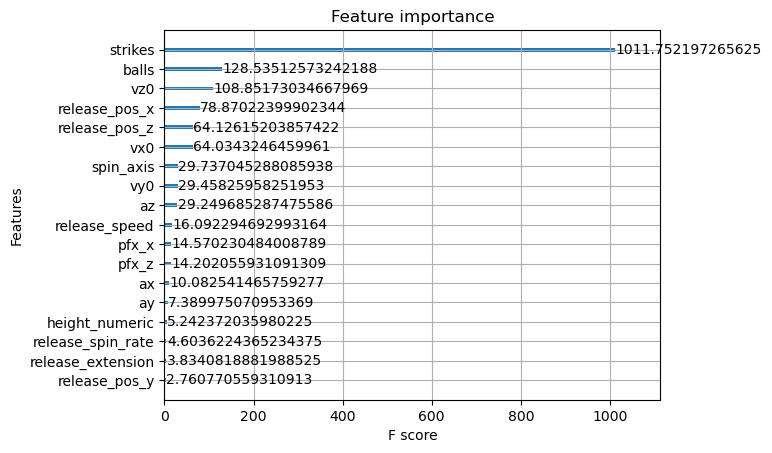

In [23]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

## Testing Data Set Predictions

In [24]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'balls', 'strikes',
       'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'release_spin_rate', 'release_extension', 'release_pos_y', 'spin_axis',
       'height_numeric'],
      dtype='object')

In [25]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [26]:
y_pred = final_model.predict(predictions)

In [27]:
testing_identifiers['xswing'] = y_pred

C:\Users\clayton.thompson\AppData\Local\Temp\ipykernel_19408\4232688072.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_identifiers['xswing'] = y_pred


In [28]:
num_nans = testing_identifiers['xswing'].isna().sum()
print(f"Number of NaNs in 'xswing': {num_nans}")


Number of NaNs in 'xswing': 0


In [29]:
len(testing_identifiers)

811776

In [30]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/swing_2022&3_xswing.csv")